In [1]:
import torch
#collections是python一个内置模块，提供了一些有用的数据结构
from collections import OrderedDict  #这个类是字典dict的一个子类，用于创建有序的字典。普通字典中元素顺序是无序的，在OrderedDict中元素的顺序是有序的，元素的顺序是按照它们被添加到字典中的顺序决定的。

from pyDOE import lhs #`pyDOE`是一个Python库，用于设计实验。它提供了一些函数来生成各种设计，如因子设计、拉丁超立方设计等。`lhs`是库中的一个函数，全名为"Latin Hypercube Sampling"，拉丁超立方采样。这是一种统计方法，用于生成一个近似均匀分布的多维样本点集。它在参数空间中生成一个非常均匀的样本，这对于高维数值优化问题非常有用，因为它可以更好地覆盖参数空间。
import numpy as np
import matplotlib.pyplot as plt
import scipy.io #导入了scipy库中的io模块。scipy.io模块包含了一些用于文件输入/输出的函数，例如读取和写入.mat文件（MATLAB格式）
from scipy.interpolate import griddata #`scipy.interpolate`是`scipy`库中的一个模块，提供了许多插值工具，用于在给定的离散数据点之间进行插值和拟合。`griddata`是这个模块中的一个函数，用于在无规则的数据点上进行插值。

import random

import skopt #用于优化问题的库，特别是机器学习中的超参数优化
from distutils.version import LooseVersion #distutils是Python的一个标准库，用于构建和安装Python包。LooseVersion是一个类，用于比较版本号

from pyDOE import lhs #`pyDOE`是一个Python库，用于设计实验。它提供了一些函数来生成各种设计，如因子设计、拉丁超立方设计等。`lhs`是库中的一个函数，全名为"Latin Hypercube Sampling"，拉丁超立方采样。这是一种统计方法，用于生成一个近似均匀分布的多维样本点集。它在参数空间中生成一个非常均匀的样本，这对于高维数值优化问题非常有用，因为它可以更好地覆盖参数空间。


from mpl_toolkits.axes_grid1 import make_axes_locatable #`mpl_toolkits.axes_grid1`是`matplotlib`库的一个模块，提供了一些高级的工具来控制matplotlib图形中的坐标轴和颜色条。`make_axes_locatable`是模块中的一个函数，用于创建一个可分割的坐标轴。可以在这个坐标轴的四个方向（上、下、左、右）添加新的坐标轴或颜色条。
import matplotlib.gridspec as gridspec #是`matplotlib`库的一个模块，用于创建一个网格布局来放置子图。在`matplotlib`中可以创建一个或多个子图（subplot），每个子图都有自己的坐标轴，并可以在其中绘制图形。`gridspec`模块提供了一个灵活的方式来创建和放置子图。
import time #一个内置模块，用于处理时间相关的操作。


from tqdm import tqdm #一个快速，可扩展的python进度条库，可以在python长循环中添加一个进度提示信息，用户只需要封装任意的迭代器tqdm(iterator)。

import os
import pickle

import timeit #用于计时和测量小段代码的执行时间
import seaborn as sns  # 导入seaborn库用于绘制密度图
import pandas as pd #一个用于数据操作和分析的库，提供了数据结构和数据分析工具，特别是用于处理表格数据（类似于Excel中的数据表）

In [2]:
num_gpus = torch.cuda.device_count()
print('Number of available GPUs: ', num_gpus)

for i in range(num_gpus):
    torch.cuda.set_device(i)
    allocated = torch.cuda.memory_allocated()
    reserved = torch.cuda.memory_reserved()
    print('GPU {}: {}, Allocated: {}, Reserved: {}'.format(i, torch.cuda.get_device_name(i), allocated, reserved))

Number of available GPUs:  2
GPU 0: NVIDIA GeForce RTX 4090, Allocated: 0, Reserved: 0
GPU 1: NVIDIA GeForce RTX 4090, Allocated: 0, Reserved: 0


In [3]:
torch.cuda.set_device(0) #设置当前使用的GPU设备。这里设置为1号GPU设备（第二块显卡）。

# CUDA support 

#设置pytorch的设备，代表了在哪里执行张量积算，设备可以是cpu或者cuda（gpu），并将这个做运算的设备对象存储在变量device中，后续张量计算回在这个设备上执行
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [4]:
# the deep neural network
class DNN(torch.nn.Module):
    #第一个方法
    def __init__(self, layers):
        super(DNN, self).__init__() #调用父类的__init__方法进行初始化
        
        # parameters
        self.depth = len(layers) - 1 #定义名为depth的属性，表示神经网络的深度，等于层数-1
        
        # set up layer order dict
        self.activation = torch.nn.Tanh #设置激活函数为tanh
         
        layer_list = list() #定义一个空列表layer_list
        for i in range(self.depth - 1):  #循环depth次
            #将每一层（全连接层）添加到layer_list中
            layer_list.append(
                ('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1]))
            )
            #将每一层的激活函数添加到layer_list中
            layer_list.append(('activation_%d' % i, self.activation()))

        #循环结束后，将最后一层的线性变换添加到layer_list中（激活函数为softmax）
        layer_list.append(
            ('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1]))
        )
        #输出层的激活函数为tanh
        layer_list.append(('activation_%d' % (self.depth - 1), torch.nn.Softmax(dim=1)))  

        #然后使用OrderedDict将layer_list中的元素转换为有序字典
        layerDict = OrderedDict(layer_list)
        
        # deploy layers，将layerDict转换为一个神经网络模型，赋值给self.layers
        self.layers = torch.nn.Sequential(layerDict) #layers，长度为2*depth，包含了所有的线性变换和激活函数，奇数索引为线性变换(权重矩阵)，偶数索引为激活函数
    
    #第二个方法，定义了模型的前向传播过程
    def forward(self, x):  #接收输入x
        out = self.layers(x) #将输入x传入神经网络模型self.layers中，得到输出out
        return out #返回输出out
    
    # # 新增方法，获取最后一个隐藏层的输出
    # def hidden_output(self, x):
    #     # 遍历每一层，直到最后一个隐藏层
    #     for i in range(self.depth - 1):
    #         # 获取当前层的线性变换
    #         x = self.layers[i*2](x)
    #         # 获取当前层的激活函数
    #         x = self.layers[i*2 + 1](x)
    #     # 返回最后一个隐藏层的输出
    #     return x

    # 新增方法，循环传递输入
    def hidden_forward(self, x, num_cycles):
        # 将输入传递到最后一个隐藏层，x为最后一个隐藏层的输出
        for i in range(self.depth - 1):
            x = self.layers[i*2](x)
            x = self.layers[i*2 + 1](x)
        
        # 将最后一个隐藏层的输出作为输入传递到第一个隐藏层中，重复num_cycles次
        for _ in range(num_cycles):
            for i in range(1, self.depth - 1): #最开始的x为最后一个隐藏层的输出，然后从第一个隐藏层开始传递
                x = self.layers[i*2](x)
                x = self.layers[i*2 + 1](x)
        hidden_output = x
        
        return hidden_output

In [5]:
# the physics-guided neural network
class PhysicsInformedNN():
    # Initialize the class
    def __init__(self, X_u, u, X_f, layers, lb, ub): #这个类包含的第一个方法__init__，这是一个特殊的方法，也就是这个类的构造函数，用于初始化新创建的对象，接受了几个参数

        mu_x, sigma_x = X_f.mean(0), X_f.std(0) #计算X_u的均值和标准差
        X_u = (X_u - mu_x) / sigma_x #对X_u进行标准化
        X_f = (X_f - mu_x) / sigma_x #对X_f进行标准化

        self.mu_x = torch.tensor(mu_x).float().to(device) #创建一个pytorch张量（数据来源于mu_x），并将其转换为浮点类型，最后将张量移动到指定的设备上
        self.sigma_x = torch.tensor(sigma_x).float().to(device) #创建一个pytorch张量（数据来源于sigma_x），并将其转换为浮点类型，最后将张量移动到指定的设备上

        # boundary conditions
        #将传入的lb和ub参数的值存储在实例中，以便后续使用。这样可以在类的其他方法中通过self.lb和self.ub来访问这些值。
        self.lb = torch.tensor(lb).float().to(device) #创建一个pytorch张量（数据来源于lb），并将其转换为浮点类型，最后将张量移动到指定的设备上
        self.ub = torch.tensor(ub).float().to(device)
        
        # data
        #初边界点数据
        self.X_u = torch.tensor(X_u, requires_grad=True).float().to(device)
        #初边界点真实数据
        self.u = torch.tensor(u).float().to(device)
        #配位点数据
        self.X_f = torch.tensor(X_f, requires_grad=True).float().to(device)
        # #测试点数据
        # self.X_star = torch.tensor(X_star).float().to(device)
        # #测试点真实数据
        # self.u_star = torch.tensor(u_star).float().to(device)
        
        self.layers = layers
        
        # deep neural networks
        self.dnn = DNN(layers).to(device) #创建一个DNN类的实例，传入layers参数来实现神经网络的初始化，然后将这个实例移动到指定的设备上
        
        # optimizers: using the same settings
        #创建优化器，括号内为要优化的参数，使用Adam优化方法
        self.optimizer_Adam = torch.optim.Adam(self.dnn.parameters(), eps = 1e-8) 


        self.iter = 0 #记录迭代次数 

        self.loss_value = [] #创建一个空列表，用于存储损失值

        self.test_error = [] #创建一个空列表，用于存储测试误差
        self.test_error_mse = [] #创建一个空列表，用于存储测试误差
        self.test_error_mae = [] #创建一个空列表，用于存储测试误差


    #主动学习更新配位点数据    
    def update_data(self, X_u, u, X_f):
        mu_x, sigma_x = X_f.mean(0), X_f.std(0)
        X_u = (X_u - mu_x) / sigma_x
        X_f = (X_f - mu_x) / sigma_x

        self.mu_x = torch.tensor(mu_x).float().to(device)
        self.sigma_x = torch.tensor(sigma_x).float().to(device)
        
        self.X_u = torch.tensor(X_u, requires_grad=True).float().to(device)
        self.u = torch.tensor(u).float().to(device)
        self.X_f = torch.tensor(X_f, requires_grad=True).float().to(device)
        
    #定义了一个名为net_u的函数/方法，用于计算神经网络的输出。这个方法接受两个参数，分别是x和t，其中x是输入数据，t是时间数据。最后返回神经网络的输出。     
    def net_u(self, x):  
        u = self.dnn(x)  #（第一个参数将输入的两个参数x和t在第二个维度（列）上进行拼接，形成一个新的张量）调用DNN，根据两个参数权重和偏置，以及新得到的张量，计算神经网络的输出u
        return u
    
    #定义了一个名为net_f的函数/方法，用于计算论文中的f。这个方法接受两个参数，分别是x和t，其中x是输入数据，t是时间数据。最后返回计算得到的f。
    def net_f(self, x):
        """ The pytorch autograd version of calculating residual """
        u = self.net_u(x) #调用上面的net_u函数，计算神经网络的输出u
        u1 = u[:, 0:1] #取u的第一列，对应状态1
        u2 = u[:, 1:2] #取u的第二列，对应状态2
        u3 = u[:, 2:3] #取u的第三列，对应状态3

        u_x_1 = torch.autograd.grad(
            u1, x, #输入的张量，要计算u1关于x的导数
            grad_outputs=torch.ones_like(u1), #生成一个与u1形状相同，所有元素均为1的张量，这个参数用于指定向量-雅可比积的像两部分
            retain_graph=True, #表示计算完梯度之后保留计算图若需要多次计算梯度，则需要设置改参数为True
            create_graph=True #创建梯度的计算图，使我们能够计算高阶导数
        )[0] #这个函数的返回值是一个元组，其中包含了每个输入张量的梯度。这里只关心第一个输入张量u1的梯度，所以我们使用[0]来获取这个梯度。？？？？又说只有一个梯度
        u_x_2 = torch.autograd.grad(
            u2, x, #输入的张量，要计算u2关于x的导数
            grad_outputs=torch.ones_like(u2), #生成一个与u2形状相同，所有元素均为1的张量，这个参数用于指定向量-雅可比积的像两部分
            retain_graph=True, #表示计算完梯度之后保留计算图若需要多次计算梯度，则需要设置改参数为True
            create_graph=True #创建梯度的计算图，使我们能够计算高阶导数
        )[0] #这个函数的返回值是一个元组，其中包含了每个输入张量的梯度。这里只关心第一个输入张量u2的梯度，所以我们使用[0]来获取这个梯度。？？？？又说只有一个梯度
        u_x_3 = torch.autograd.grad(
            u3, x, #输入的张量，要计算u3关于x的导数
            grad_outputs=torch.ones_like(u3), #生成一个与u3形状相同，所有元素均为1的张量，这个参数用于指定向量-雅可比积的像两部分
            retain_graph=True, #表示计算完梯度之后保留计算图若需要多次计算梯度，则需要设置改参数为True
            create_graph=True #创建梯度的计算图，使我们能够计算高阶导数
        )[0] #这个函数的返回值是一个元组，其中包含了每个输入张量的梯度。这里只关心第一个输入张量u3的梯度，所以我们使用[0]来获取这个梯度。？？？？又说只有一个梯度

        #归一化
        u_x_1 = u_x_1 / self.sigma_x
        u_x_2 = u_x_2 / self.sigma_x
        u_x_3 = u_x_3 / self.sigma_x
        
        #计算残差
        xx = x * self.sigma_x + self.mu_x
        residual_1 = u_x_1-(-2.572e-4*xx*u1)
        residual_2 = u_x_2-(1.12e-4*xx*u1-2.012e-4*xx*u2)
        residual_3 = u_x_3-(1.452e-4*xx*u1+2.012e-4*xx*u2)    

        loss_1 = torch.mean(residual_1 ** 2)
        loss_2 = torch.mean(residual_2 ** 2)
        loss_3 = torch.mean(residual_3 ** 2)

        loss_f = loss_1 + loss_2 + loss_3
        return loss_f, residual_1+residual_2+residual_3
    
      
    
    def train(self, nIter):


        #使用Adam优化器优化nIter次
        for epoch in tqdm(range(nIter), desc='Adam'):
            self.dnn.train() #将神经网络设置为训练模式而不是评估模式
            u_pred = self.net_u(self.X_u) #调用之前定义的函数，传入初值得到神经网络的输出u

            loss_u = torch.mean((self.u - u_pred) ** 2) #计算初值的损失函数
            loss_f, _ = self.net_f(self.X_f) #计算残差的损失函数
            

            loss = loss_u + loss_f
            
            # Backward and optimize
            self.optimizer_Adam.zero_grad() #清除该优化器之前计算的梯度（在PyTorch中，梯度会累积，所以在每次新的优化迭代之前，我们需要清除之前的梯度）
            loss.backward() #被调用以计算损失函数关于神经网络参数的梯度。这个梯度将被用于优化器来更新神经网络参数
            self.optimizer_Adam.step()  #使用之前的优化器self.optimizer_Adam，调用step方法(执行一步优化算法)，传入损失函数self.loss_func，进行优化
            
            #record the loss value
            self.loss_value.append(loss) #将计算得到的loss值添加到self.loss_value列表中

            # # record the test error
            # self.dnn.eval() #将神经网络切换为评估模式
            # with torch.no_grad():
            #     u_real_pred = self.net_u(self.x_star, self.t_star) #调用之前定义的函数，传入参数得到神经网络的输出u


            # error_test = torch.norm(self.u_star-u_real_pred,2)/torch.norm(self.u_star,2)

            # self.test_error.append(error_test)

            # # 计算 MAE和MSE
            # mae = torch.mean(torch.abs(self.u_star - u_real_pred))
            # mse = torch.mean((self.u_star - u_real_pred) ** 2)
            # # 记录 MAE 和 MSE
            # self.test_error_mae.append(mae)
            # self.test_error_mse.append(mse)


  

    def predict(self, X):
        x = torch.tensor(X, requires_grad=True).float().to(device) #从输入中得到x和t（第一列和第二列），是张量，需要计算梯度，转换为浮点数类型，并将张量移动到指定设备上
        mu, sigma = self.mu_x, self.sigma_x
        x = (x - mu) / sigma

        self.dnn.eval() #将神经网络切换为评估模式
        u = self.net_u(x) #调用之前定义的函数得到神经网络的输出u,以及f
        _, f = self.net_f(x)
        u = u.detach().cpu().numpy() #将张量u和f先从计算图中分离出来，然后转换为numpy数组，最后将这个数组移动到cpu上
        f = f.detach().cpu().numpy()
        return u, f
    

    def hidden_predict(self, x, num_cycles):
        x = torch.tensor(x, requires_grad=True).float().to(device) #从输入中得到x和t（第一列和第二列），是张量，需要计算梯度，转换为浮点数类型，并将张量移动到指定设备上
        mu, sigma = self.mu_x, self.sigma_x
        x = (x - mu) / sigma

        self.dnn.eval()
        hidden_output = self.dnn.hidden_forward(x, num_cycles)
        hidden_output = hidden_output.detach().cpu().numpy()
        return hidden_output

In [6]:
#定义设置随机数种子的函数，第一个参数seed表示种子；第二个参数用来设置CUDA的卷积操作是否确定性，默认为False，表示没有确定性
def set_seed(seed):
    # torch.manual_seed(seed) #设置pytorch的CPU随机数生成器的种子
    # torch.cuda.manual_seed_all(seed) #设置putorch的所有GPU随机数生成器的种子
    # np.random.seed(seed) #设置numpy的随机数生成器的种子
    # random.seed(seed) #设置python的内置随机数生成器的种子
    # torch.backends.cudnn.deterministic = deterministic #True会让CUDA的卷积操作变得确定性，即对于相同的输入，每次运行会得到相同的结果，False则相反
    """
    设置PyTorch的随机种子, 用于生成随机数. 通过设置相同的种子, 可以确保每次运行时生成的随机数序列相同
    """
    torch.manual_seed(seed)
 
    """
    设置PyTorch在所有可用的CUDA设备上的随机种子. 如果在使用GPU进行计算, 这个设置可以确保在不同的GPU上生成的随机数序列相同
    """
    torch.cuda.manual_seed_all(seed)
 
    """
    设置PyTorch在当前CUDA设备上的随机种子. 它与上一行代码的作用类似, 但只影响当前设备
    """
    torch.cuda.manual_seed(seed)
 
    """
    设置NumPy的随机种子, 用于生成随机数. 通过设置相同的种子，可以确保在使用NumPy的随机函数时生成的随机数序列相同
    """
    np.random.seed(seed)
    
    """
    设置Python内置的随机函数的种子. Python的random模块提供了许多随机函数, 包括生成随机数、打乱列表等. 通过设置相同的种子, 可以确保使用这些随机函数时生成的随机数序列相同
    """
    random.seed(seed)
    
    """
    设置Python的哈希种子 (哈希函数被广泛用于数据结构 (如字典和集合) 的实现，以及一些内部操作 (如查找和比较)). 通过设置相同的种子, 可以确保在不同的运行中生成的哈希结果相同
    """
    # os.environ["PYTHONHASHSEED"] = str(seed)
    
    """
    该设置确保每次运行代码时, cuDNN的计算结果是确定性的, 即相同的输入会产生相同的输出, 这是通过禁用一些非确定性的算法来实现的, 例如在卷积操作中使用的算法. 这样做可以保证模型的训练和推理在相同的硬件和软件环境下是可复现的, 即每次运行代码时的结果都相同. 但是, 这可能会导致一些性能上的损失, 因为禁用了一些优化的非确定性算法
    """
    torch.backends.cudnn.deterministic = True
    
    """
    该设置禁用了cuDNN的自动优化过程. 当它被设置为False时, PyTorch不会在每次运行时重新寻找最优的算法配置, 而是使用固定的算法配置. 这样做可以确保每次运行代码时的性能是一致的, 但可能会导致一些性能上的损失
    """
    torch.backends.cudnn.benchmark = False



In [7]:
#RAR-G方法，对1000个点，先选择10个点训练500次，然后每500次迭代重采样100个点，选出其中残差最大的10个点添加到训练点中；最后总共有1000个点，共训练10000次
seeds = [0, 1, 12, 33, 123, 321, 1234, 4321, 12345, 54321] #生成10个随机种子
# seeds = [0]
#设置噪声水平为0
noise = 0.0        

#读取真实解(基于MCS方法得到的解)
MCS_solution_df = pd.read_csv('MCS_non_homo_300.csv')
MCS_solution_df.columns = ['time', 'state_0', 'state_1', 'state_2']

MCS_solution_df.drop(labels='time', inplace=True, axis = 1)


N_u = 1
N_f = 200

#定义一个列表layers，其中包含了神经网络的层数和每一层的神经元数量
layers = [1, 50, 50, 3]

lb  = np.array([0.0])              # t的左边界
ub  = np.array([300.0])          # t的右边界

# Define the initial MSS state
X_u = np.array([[0]])
u = np.array([[1,0,0]])          # 初始真实状态
# X_f = np.linspace(lb, ub, N_f)     # 配位点位置，0~60000的5000个点

error_y = [] #创建一个空列表，用于存储误差值
error_mae = [] #创建一个空列表，用于存储MAE值
error_mse = [] #创建一个空列表，用于存储MSE值
chaoss = [] #创建一个空列表，用于存储chaos值
residuals = [] #创建一个空列表，用于存储residual值

i = 0 #初始化i为0

# # 创建文件夹
# model_dir = 'Adam+LBFGS+LHS(5000)'
# if not os.path.exists(model_dir):
#     os.makedirs(model_dir)

for seed in seeds:
    set_seed(seed) #设置随机数种子

    N_f_1 = N_f // 100 #先拿50个点训练
    X_f_train = lb + (ub - lb) * lhs(1, N_f_1) #生成N_f个随机点
    nIter = 150000 #设置迭代次数为10000

    #创建PINN模型并输入各种参数     
    model = PhysicsInformedNN(X_u, u, X_f_train, layers, lb, ub)

    #获取当前时间并赋值给start_time  
    start_time = time.time()   
    #开始训练模型            
    model.train(nIter//100)


    for iter in range(nIter//100+1, nIter+1, nIter//100): #每800次迭代
        N_f_new = N_f_1 * 10 #重新采样500个点
        X_f_train_new = lb + (ub - lb) * lhs(1, N_f_new) #生成N_f_new个随机点

        #计算残差
        _, residual = model.predict(X_f_train_new)
        abs_residual = np.abs(residual)
        abs_residual = abs_residual.flatten()
        #对abs_residual进行归一化
        abs_residual = abs_residual / np.linalg.norm(abs_residual)


        #计算混沌度
        y_chaos = model.hidden_predict(X_f_train_new, 100)
        x_ssss = X_f_train_new + np.random.normal(0, 0.001)
        y_chaos_ssss = model.hidden_predict(x_ssss, 100)
        chaos = np.linalg.norm(y_chaos - y_chaos_ssss,axis=1)
        #对chaos进行归一化
        epsilon = 1e-10
        norm_chaos = np.linalg.norm(chaos)
        if norm_chaos > epsilon:
            chaos = chaos / norm_chaos
        else:
            chaos = np.zeros_like(chaos)


        #计算信息量
        xinxi = 0.3 * abs_residual + 0.7 * chaos

        #选出信息量最大的10个点
        # 找出绝对值最大的10个值的索引
        topk_indices = np.argpartition(xinxi, -N_f_1)[-N_f_1:] #该函数会对数组进行排序，使得指定的k个最大值出现在数组的最后k给位置上，并获取最后1000个元素

        # 使用这些索引来提取对应的数据
        X_f_train_topk = X_f_train_new[topk_indices]

        X_f_train = np.vstack((X_f_train, X_f_train_topk)) #与之前的训练数据合并

        # 更新模型中的X_f_train数据
        model.update_data(X_u, u, X_f_train)

        # 在更新数据后的模型上进行训练500次
        model.train(nIter//100)

    # print(X_f_train.shape)
    # 更新模型中的X_f_train数据
    model.update_data(X_u, u, X_f_train)

    #训练结束后获取当前时间并减去start_time，得到训练时间并赋值给elapsed
    elapsed = time.time() - start_time
    #打印训练所花时间                
    print('Training time: %.4f' % (elapsed))

    #真实值
    mu, sigma = model.mu_x, model.sigma_x

    # up = 80000
    n_star = 300+1
    x_star = np.linspace(lb, ub, n_star)[1:] #N_star = x_star.shape[0] 
    y_pred, _ = model.predict(x_star)
    y_star = MCS_solution_df


    #计算误差（基于2范数）        
    error_y.append(np.linalg.norm(y_star-y_pred,2)/np.linalg.norm(y_star,2)) #计算误差，然后将误差添加到error_u列表中             
    # 计算 MAE 和 MSE
    mae = np.mean(np.abs(y_star - y_pred))
    mse = np.mean((y_star - y_pred) ** 2)
    # 记录 MAE 和 MSE
    error_mae.append(mae)
    error_mse.append(mse)


    #计算混沌度
    y_chaos = model.hidden_predict(x_star, 100)
    # print(y_chaos)
    x_sss = x_star + np.random.normal(0, 0.001)
    y_chaos_sss = model.hidden_predict(x_sss, 100)
    chaos = np.linalg.norm(y_chaos - y_chaos_sss,axis=1).sum()
    chaoss.append(chaos)

    #计算残差

    _, residual = model.predict(x_star)
    residual = residual.flatten()
    residual = np.abs(residual)
    residual = residual.sum()
    residuals.append(residual)

    i+=1 #i加1
    print(f'当前为第{i}次循环，种子为{seed}')
    print('Error y : %e' % (np.linalg.norm(y_star-y_pred,2)/np.linalg.norm(y_star,2))) #打印误差  
    print('MAE: %e' % mae) #打印MAE
    print('MSE: %e' % mse) #打印MSE
    print('Chaos: %e' % chaos) #打印混沌度
    print('Residual: %e' % residual) #打印残差
    # # 保存模型到文件夹
    # model_path = os.path.join(model_dir, f'model_{i}_seed_{seed}.pkl')
    # with open(model_path, 'wb') as f:
    #     pickle.dump(model, f)


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   0%|          | 1/1500 [00:00<02:39,  9.38it/s]

Adam:   2%|▏         | 31/1500 [00:00<00:08, 174.77it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:05, 261.10it/s]

Adam:   6%|▋         | 95/1500 [00:00<00:05, 247.89it/s]

Adam:   8%|▊         | 121/1500 [00:00<00:05, 244.89it/s]

Adam:  11%|█         | 160/1500 [00:00<00:04, 291.57it/s]

Adam:  13%|█▎        | 197/1500 [00:00<00:04, 315.71it/s]

Adam:  16%|█▌        | 241/1500 [00:00<00:03, 352.85it/s]

Adam:  18%|█▊        | 277/1500 [00:00<00:03, 351.70it/s]

Adam:  21%|██        | 313/1500 [00:01<00:03, 350.73it/s]

Adam:  24%|██▍       | 366/1500 [00:01<00:02, 400.75it/s]

Adam:  27%|██▋       | 407/1500 [00:01<00:03, 359.35it/s]

Adam:  30%|██▉       | 444/1500 [00:01<00:03, 330.70it/s]

Adam:  32%|███▏      | 480/1500 [00:01<00:03, 336.33it/s]

Adam:  34%|███▍      | 515/1500 [00:01<00:03, 305.12it/s]

Adam:  36%|███▋      | 547/1500 [00:01<00:03, 304.56it/s]

Adam:  39%|███▊      | 579/1500 [00:01<00:03, 298.71it/s]

Adam:  41%|████      | 610/1500 [00:02<00:03, 285.72it/s]

Adam:  43%|████▎     | 649/1500 [00:02<00:02, 313.31it/s]

Adam:  46%|████▋     | 695/1500 [00:02<00:02, 352.53it/s]

Adam:  49%|████▉     | 735/1500 [00:02<00:02, 365.27it/s]

Adam:  52%|█████▏    | 773/1500 [00:02<00:02, 336.60it/s]

Adam:  54%|█████▍    | 808/1500 [00:02<00:02, 335.26it/s]

Adam:  57%|█████▋    | 851/1500 [00:02<00:01, 359.90it/s]

Adam:  60%|█████▉    | 894/1500 [00:02<00:01, 379.20it/s]

Adam:  62%|██████▏   | 933/1500 [00:02<00:01, 362.83it/s]

Adam:  65%|██████▍   | 970/1500 [00:03<00:01, 327.55it/s]

Adam:  67%|██████▋   | 1004/1500 [00:03<00:01, 325.82it/s]

Adam:  70%|██████▉   | 1043/1500 [00:03<00:01, 342.56it/s]

Adam:  73%|███████▎  | 1091/1500 [00:03<00:01, 376.76it/s]

Adam:  75%|███████▌  | 1130/1500 [00:03<00:01, 350.21it/s]

Adam:  78%|███████▊  | 1166/1500 [00:03<00:01, 327.55it/s]

Adam:  80%|████████  | 1200/1500 [00:03<00:00, 320.59it/s]

Adam:  82%|████████▏ | 1233/1500 [00:03<00:00, 319.02it/s]

Adam:  84%|████████▍ | 1266/1500 [00:03<00:00, 293.26it/s]

Adam:  87%|████████▋ | 1306/1500 [00:04<00:00, 318.09it/s]

Adam:  90%|████████▉ | 1349/1500 [00:04<00:00, 347.70it/s]

Adam:  93%|█████████▎| 1392/1500 [00:04<00:00, 369.80it/s]

Adam:  95%|█████████▌| 1430/1500 [00:04<00:00, 371.79it/s]

Adam:  98%|█████████▊| 1473/1500 [00:04<00:00, 386.92it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 330.96it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 23/1500 [00:00<00:06, 224.37it/s]

Adam:   4%|▎         | 56/1500 [00:00<00:05, 285.20it/s]

Adam:   8%|▊         | 114/1500 [00:00<00:03, 418.07it/s]

Adam:  10%|█         | 157/1500 [00:00<00:03, 420.38it/s]

Adam:  13%|█▎        | 200/1500 [00:00<00:03, 413.49it/s]

Adam:  16%|█▌        | 242/1500 [00:00<00:03, 342.49it/s]

Adam:  19%|█▊        | 279/1500 [00:00<00:03, 311.89it/s]

Adam:  21%|██        | 313/1500 [00:00<00:03, 317.88it/s]

Adam:  23%|██▎       | 346/1500 [00:01<00:04, 283.70it/s]

Adam:  25%|██▌       | 376/1500 [00:01<00:04, 268.38it/s]

Adam:  27%|██▋       | 404/1500 [00:01<00:04, 262.15it/s]

Adam:  30%|███       | 450/1500 [00:01<00:03, 312.53it/s]

Adam:  33%|███▎      | 490/1500 [00:01<00:03, 334.15it/s]

Adam:  35%|███▌      | 526/1500 [00:01<00:02, 337.68it/s]

Adam:  37%|███▋      | 561/1500 [00:01<00:02, 317.79it/s]

Adam:  41%|████      | 612/1500 [00:01<00:02, 369.89it/s]

Adam:  44%|████▍     | 662/1500 [00:01<00:02, 405.11it/s]

Adam:  47%|████▋     | 704/1500 [00:02<00:02, 355.10it/s]

Adam:  49%|████▉     | 742/1500 [00:02<00:02, 338.13it/s]

Adam:  52%|█████▏    | 778/1500 [00:02<00:02, 308.15it/s]

Adam:  55%|█████▍    | 819/1500 [00:02<00:02, 332.38it/s]

Adam:  57%|█████▋    | 862/1500 [00:02<00:01, 357.59it/s]

Adam:  60%|██████    | 904/1500 [00:02<00:01, 373.30it/s]

Adam:  63%|██████▎   | 943/1500 [00:02<00:01, 336.58it/s]

Adam:  65%|██████▌   | 978/1500 [00:02<00:01, 304.00it/s]

Adam:  67%|██████▋   | 1010/1500 [00:03<00:01, 285.53it/s]

Adam:  70%|███████   | 1055/1500 [00:03<00:01, 325.58it/s]

Adam:  73%|███████▎  | 1089/1500 [00:03<00:01, 307.19it/s]

Adam:  76%|███████▌  | 1133/1500 [00:03<00:01, 340.52it/s]

Adam:  78%|███████▊  | 1169/1500 [00:03<00:01, 304.02it/s]

Adam:  81%|████████▏ | 1220/1500 [00:03<00:00, 354.82it/s]

Adam:  84%|████████▍ | 1258/1500 [00:03<00:00, 337.16it/s]

Adam:  86%|████████▋ | 1294/1500 [00:03<00:00, 310.82it/s]

Adam:  88%|████████▊ | 1327/1500 [00:04<00:00, 313.05it/s]

Adam:  92%|█████████▏| 1381/1500 [00:04<00:00, 371.63it/s]

Adam:  96%|█████████▌| 1434/1500 [00:04<00:00, 414.80it/s]

Adam:  98%|█████████▊| 1477/1500 [00:04<00:00, 345.41it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 331.78it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 38/1500 [00:00<00:03, 375.17it/s]

Adam:   5%|▌         | 78/1500 [00:00<00:03, 387.30it/s]

Adam:   8%|▊         | 117/1500 [00:00<00:03, 352.90it/s]

Adam:  11%|█         | 158/1500 [00:00<00:03, 370.01it/s]

Adam:  14%|█▍        | 217/1500 [00:00<00:02, 445.06it/s]

Adam:  18%|█▊        | 273/1500 [00:00<00:02, 481.58it/s]

Adam:  22%|██▏       | 324/1500 [00:00<00:02, 490.58it/s]

Adam:  25%|██▍       | 374/1500 [00:00<00:02, 442.87it/s]

Adam:  28%|██▊       | 420/1500 [00:00<00:02, 425.75it/s]

Adam:  31%|███       | 464/1500 [00:01<00:02, 407.37it/s]

Adam:  34%|███▎      | 506/1500 [00:01<00:02, 347.33it/s]

Adam:  36%|███▌      | 543/1500 [00:01<00:02, 350.30it/s]

Adam:  39%|███▊      | 580/1500 [00:01<00:02, 332.13it/s]

Adam:  41%|████      | 615/1500 [00:01<00:02, 321.49it/s]

Adam:  43%|████▎     | 648/1500 [00:01<00:02, 296.61it/s]

Adam:  45%|████▌     | 679/1500 [00:01<00:02, 298.27it/s]

Adam:  49%|████▊     | 728/1500 [00:01<00:02, 348.16it/s]

Adam:  51%|█████     | 764/1500 [00:02<00:02, 330.27it/s]

Adam:  53%|█████▎    | 798/1500 [00:02<00:02, 321.88it/s]

Adam:  56%|█████▌    | 842/1500 [00:02<00:01, 352.85it/s]

Adam:  59%|█████▉    | 888/1500 [00:02<00:01, 381.37it/s]

Adam:  62%|██████▏   | 934/1500 [00:02<00:01, 402.97it/s]

Adam:  65%|██████▌   | 975/1500 [00:02<00:01, 388.29it/s]

Adam:  68%|██████▊   | 1015/1500 [00:02<00:01, 368.12it/s]

Adam:  70%|███████   | 1053/1500 [00:02<00:01, 328.40it/s]

Adam:  72%|███████▏  | 1087/1500 [00:03<00:01, 298.49it/s]

Adam:  75%|███████▍  | 1120/1500 [00:03<00:01, 303.40it/s]

Adam:  77%|███████▋  | 1152/1500 [00:03<00:01, 281.64it/s]

Adam:  79%|███████▊  | 1181/1500 [00:03<00:01, 267.43it/s]

Adam:  81%|████████  | 1209/1500 [00:03<00:01, 258.83it/s]

Adam:  82%|████████▏ | 1236/1500 [00:03<00:01, 255.94it/s]

Adam:  84%|████████▍ | 1262/1500 [00:03<00:00, 247.19it/s]

Adam:  86%|████████▌ | 1287/1500 [00:03<00:00, 238.30it/s]

Adam:  87%|████████▋ | 1311/1500 [00:03<00:00, 233.96it/s]

Adam:  89%|████████▉ | 1335/1500 [00:04<00:00, 234.58it/s]

Adam:  91%|█████████ | 1360/1500 [00:04<00:00, 238.06it/s]

Adam:  93%|█████████▎| 1391/1500 [00:04<00:00, 257.26it/s]

Adam:  96%|█████████▋| 1444/1500 [00:04<00:00, 334.63it/s]

Adam:  99%|█████████▉| 1484/1500 [00:04<00:00, 350.00it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 330.85it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 24/1500 [00:00<00:06, 238.36it/s]

Adam:   3%|▎         | 48/1500 [00:00<00:06, 234.27it/s]

Adam:   6%|▌         | 87/1500 [00:00<00:04, 302.86it/s]

Adam:   8%|▊         | 118/1500 [00:00<00:04, 291.34it/s]

Adam:  10%|▉         | 148/1500 [00:00<00:05, 259.67it/s]

Adam:  12%|█▏        | 178/1500 [00:00<00:04, 270.57it/s]

Adam:  14%|█▍        | 210/1500 [00:00<00:04, 284.05it/s]

Adam:  16%|█▌        | 239/1500 [00:00<00:04, 265.85it/s]

Adam:  18%|█▊        | 275/1500 [00:00<00:04, 291.71it/s]

Adam:  20%|██        | 305/1500 [00:01<00:04, 276.16it/s]

Adam:  22%|██▏       | 334/1500 [00:01<00:04, 274.94it/s]

Adam:  25%|██▍       | 370/1500 [00:01<00:03, 298.77it/s]

Adam:  27%|██▋       | 401/1500 [00:01<00:03, 275.16it/s]

Adam:  29%|██▊       | 430/1500 [00:01<00:03, 269.16it/s]

Adam:  31%|███       | 458/1500 [00:01<00:04, 252.16it/s]

Adam:  32%|███▏      | 484/1500 [00:01<00:04, 246.58it/s]

Adam:  34%|███▍      | 517/1500 [00:01<00:03, 268.28it/s]

Adam:  36%|███▋      | 545/1500 [00:02<00:03, 256.16it/s]

Adam:  38%|███▊      | 575/1500 [00:02<00:03, 267.05it/s]

Adam:  40%|████      | 605/1500 [00:02<00:03, 274.20it/s]

Adam:  42%|████▏     | 633/1500 [00:02<00:03, 267.75it/s]

Adam:  44%|████▍     | 660/1500 [00:02<00:03, 265.58it/s]

Adam:  47%|████▋     | 698/1500 [00:02<00:02, 296.02it/s]

Adam:  49%|████▊     | 731/1500 [00:02<00:02, 304.30it/s]

Adam:  51%|█████     | 762/1500 [00:02<00:02, 304.77it/s]

Adam:  53%|█████▎    | 793/1500 [00:02<00:02, 291.67it/s]

Adam:  55%|█████▍    | 823/1500 [00:02<00:02, 290.59it/s]

Adam:  57%|█████▋    | 854/1500 [00:03<00:02, 296.09it/s]

Adam:  59%|█████▉    | 884/1500 [00:03<00:02, 297.09it/s]

Adam:  62%|██████▏   | 930/1500 [00:03<00:01, 340.71it/s]

Adam:  64%|██████▍   | 965/1500 [00:03<00:01, 315.07it/s]

Adam:  67%|██████▋   | 999/1500 [00:03<00:01, 320.96it/s]

Adam:  69%|██████▉   | 1036/1500 [00:03<00:01, 332.04it/s]

Adam:  71%|███████▏  | 1070/1500 [00:03<00:01, 314.98it/s]

Adam:  73%|███████▎  | 1102/1500 [00:03<00:01, 308.35it/s]

Adam:  76%|███████▌  | 1136/1500 [00:03<00:01, 313.68it/s]

Adam:  78%|███████▊  | 1169/1500 [00:04<00:01, 318.26it/s]

Adam:  80%|████████  | 1201/1500 [00:04<00:00, 303.93it/s]

Adam:  82%|████████▏ | 1232/1500 [00:04<00:00, 288.18it/s]

Adam:  84%|████████▍ | 1262/1500 [00:04<00:00, 289.86it/s]

Adam:  86%|████████▌ | 1292/1500 [00:04<00:00, 288.48it/s]

Adam:  89%|████████▉ | 1336/1500 [00:04<00:00, 331.19it/s]

Adam:  91%|█████████▏| 1370/1500 [00:04<00:00, 316.07it/s]

Adam:  95%|█████████▍| 1418/1500 [00:04<00:00, 360.31it/s]

Adam:  97%|█████████▋| 1461/1500 [00:04<00:00, 377.83it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 367.16it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 298.25it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 39/1500 [00:00<00:03, 387.20it/s]

Adam:   6%|▌         | 85/1500 [00:00<00:03, 428.16it/s]

Adam:   9%|▊         | 128/1500 [00:00<00:03, 413.99it/s]

Adam:  11%|█▏        | 170/1500 [00:00<00:03, 363.79it/s]

Adam:  14%|█▍        | 208/1500 [00:00<00:03, 360.53it/s]

Adam:  16%|█▋        | 245/1500 [00:00<00:03, 328.49it/s]

Adam:  19%|█▊        | 279/1500 [00:00<00:03, 318.19it/s]

Adam:  21%|██        | 316/1500 [00:00<00:03, 331.87it/s]

Adam:  23%|██▎       | 350/1500 [00:01<00:03, 316.41it/s]

Adam:  25%|██▌       | 382/1500 [00:01<00:03, 297.07it/s]

Adam:  28%|██▊       | 413/1500 [00:01<00:03, 294.66it/s]

Adam:  30%|███       | 452/1500 [00:01<00:03, 320.44it/s]

Adam:  33%|███▎      | 489/1500 [00:01<00:03, 333.81it/s]

Adam:  35%|███▌      | 525/1500 [00:01<00:02, 340.79it/s]

Adam:  37%|███▋      | 560/1500 [00:01<00:03, 311.26it/s]

Adam:  39%|███▉      | 592/1500 [00:01<00:02, 304.85it/s]

Adam:  42%|████▏     | 637/1500 [00:01<00:02, 343.15it/s]

Adam:  45%|████▍     | 672/1500 [00:02<00:02, 319.50it/s]

Adam:  47%|████▋     | 705/1500 [00:02<00:02, 318.52it/s]

Adam:  51%|█████     | 761/1500 [00:02<00:01, 384.99it/s]

Adam:  54%|█████▎    | 803/1500 [00:02<00:01, 394.82it/s]

Adam:  56%|█████▋    | 844/1500 [00:02<00:01, 390.30it/s]

Adam:  59%|█████▉    | 884/1500 [00:02<00:01, 356.72it/s]

Adam:  61%|██████▏   | 921/1500 [00:02<00:01, 307.51it/s]

Adam:  64%|██████▎   | 954/1500 [00:02<00:01, 286.03it/s]

Adam:  66%|██████▋   | 997/1500 [00:02<00:01, 318.45it/s]

Adam:  69%|██████▊   | 1031/1500 [00:03<00:01, 280.12it/s]

Adam:  71%|███████   | 1061/1500 [00:03<00:01, 268.75it/s]

Adam:  73%|███████▎  | 1089/1500 [00:03<00:01, 270.56it/s]

Adam:  75%|███████▌  | 1126/1500 [00:03<00:01, 295.50it/s]

Adam:  78%|███████▊  | 1167/1500 [00:03<00:01, 326.25it/s]

Adam:  80%|████████  | 1201/1500 [00:03<00:00, 305.00it/s]

Adam:  82%|████████▏ | 1234/1500 [00:03<00:00, 309.92it/s]

Adam:  85%|████████▍ | 1271/1500 [00:03<00:00, 325.43it/s]

Adam:  88%|████████▊ | 1325/1500 [00:04<00:00, 385.89it/s]

Adam:  91%|█████████ | 1365/1500 [00:04<00:00, 381.89it/s]

Adam:  94%|█████████▎| 1404/1500 [00:04<00:00, 322.49it/s]

Adam:  96%|█████████▌| 1443/1500 [00:04<00:00, 338.61it/s]

Adam:  99%|█████████▊| 1479/1500 [00:04<00:00, 340.84it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 331.51it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 49/1500 [00:00<00:02, 484.04it/s]

Adam:   7%|▋         | 98/1500 [00:00<00:04, 337.49it/s]

Adam:   9%|▉         | 142/1500 [00:00<00:03, 373.07it/s]

Adam:  12%|█▏        | 182/1500 [00:00<00:04, 322.97it/s]

Adam:  14%|█▍        | 217/1500 [00:00<00:04, 312.51it/s]

Adam:  18%|█▊        | 266/1500 [00:00<00:03, 361.09it/s]

Adam:  20%|██        | 304/1500 [00:00<00:03, 346.66it/s]

Adam:  23%|██▎       | 340/1500 [00:00<00:03, 331.82it/s]

Adam:  25%|██▍       | 374/1500 [00:01<00:03, 300.94it/s]

Adam:  27%|██▋       | 407/1500 [00:01<00:03, 308.18it/s]

Adam:  31%|███       | 462/1500 [00:01<00:02, 372.44it/s]

Adam:  34%|███▎      | 506/1500 [00:01<00:02, 390.71it/s]

Adam:  37%|███▋      | 551/1500 [00:01<00:02, 406.64it/s]

Adam:  40%|███▉      | 594/1500 [00:01<00:02, 411.83it/s]

Adam:  42%|████▏     | 636/1500 [00:01<00:02, 399.81it/s]

Adam:  45%|████▌     | 677/1500 [00:01<00:02, 373.68it/s]

Adam:  48%|████▊     | 715/1500 [00:02<00:02, 339.06it/s]

Adam:  51%|█████     | 762/1500 [00:02<00:01, 372.07it/s]

Adam:  53%|█████▎    | 801/1500 [00:02<00:01, 369.15it/s]

Adam:  56%|█████▌    | 839/1500 [00:02<00:01, 331.08it/s]

Adam:  58%|█████▊    | 874/1500 [00:02<00:01, 316.83it/s]

Adam:  60%|██████    | 907/1500 [00:02<00:01, 309.76it/s]

Adam:  64%|██████▎   | 953/1500 [00:02<00:01, 346.96it/s]

Adam:  66%|██████▌   | 993/1500 [00:02<00:01, 360.72it/s]

Adam:  69%|██████▊   | 1030/1500 [00:02<00:01, 321.65it/s]

Adam:  72%|███████▏  | 1087/1500 [00:03<00:01, 385.91it/s]

Adam:  76%|███████▌  | 1139/1500 [00:03<00:00, 420.98it/s]

Adam:  79%|███████▉  | 1183/1500 [00:03<00:00, 370.79it/s]

Adam:  83%|████████▎ | 1244/1500 [00:03<00:00, 431.80it/s]

Adam:  87%|████████▋ | 1301/1500 [00:03<00:00, 468.39it/s]

Adam:  90%|█████████ | 1350/1500 [00:03<00:00, 377.29it/s]

Adam:  93%|█████████▎| 1392/1500 [00:03<00:00, 338.61it/s]

Adam:  95%|█████████▌| 1430/1500 [00:04<00:00, 321.46it/s]

Adam:  98%|█████████▊| 1465/1500 [00:04<00:00, 318.43it/s]

Adam: 100%|█████████▉| 1499/1500 [00:04<00:00, 287.62it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 351.06it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 25/1500 [00:00<00:05, 248.25it/s]

Adam:   3%|▎         | 50/1500 [00:00<00:05, 242.69it/s]

Adam:   5%|▌         | 75/1500 [00:00<00:06, 236.73it/s]

Adam:   8%|▊         | 116/1500 [00:00<00:04, 302.81it/s]

Adam:  10%|▉         | 147/1500 [00:00<00:04, 289.51it/s]

Adam:  12%|█▏        | 177/1500 [00:00<00:04, 269.19it/s]

Adam:  15%|█▌        | 225/1500 [00:00<00:03, 331.88it/s]

Adam:  18%|█▊        | 263/1500 [00:00<00:03, 343.01it/s]

Adam:  20%|█▉        | 298/1500 [00:00<00:03, 342.70it/s]

Adam:  22%|██▏       | 333/1500 [00:01<00:03, 313.27it/s]

Adam:  24%|██▍       | 366/1500 [00:01<00:03, 315.21it/s]

Adam:  27%|██▋       | 403/1500 [00:01<00:03, 329.28it/s]

Adam:  29%|██▉       | 437/1500 [00:01<00:03, 297.49it/s]

Adam:  31%|███▏      | 470/1500 [00:01<00:03, 305.80it/s]

Adam:  33%|███▎      | 502/1500 [00:01<00:03, 302.56it/s]

Adam:  36%|███▌      | 538/1500 [00:01<00:03, 318.16it/s]

Adam:  39%|███▉      | 583/1500 [00:01<00:02, 353.49it/s]

Adam:  42%|████▏     | 626/1500 [00:01<00:02, 373.91it/s]

Adam:  45%|████▌     | 681/1500 [00:02<00:01, 422.27it/s]

Adam:  48%|████▊     | 724/1500 [00:02<00:01, 403.75it/s]

Adam:  51%|█████     | 765/1500 [00:02<00:02, 343.91it/s]

Adam:  53%|█████▎    | 802/1500 [00:02<00:02, 345.36it/s]

Adam:  57%|█████▋    | 849/1500 [00:02<00:01, 377.44it/s]

Adam:  60%|██████    | 905/1500 [00:02<00:01, 426.12it/s]

Adam:  63%|██████▎   | 949/1500 [00:02<00:01, 428.77it/s]

Adam:  66%|██████▌   | 993/1500 [00:02<00:01, 395.04it/s]

Adam:  69%|██████▉   | 1038/1500 [00:02<00:01, 409.72it/s]

Adam:  72%|███████▏  | 1080/1500 [00:03<00:01, 394.83it/s]

Adam:  75%|███████▍  | 1121/1500 [00:03<00:01, 353.24it/s]

Adam:  77%|███████▋  | 1158/1500 [00:03<00:00, 343.14it/s]

Adam:  80%|███████▉  | 1194/1500 [00:03<00:00, 314.54it/s]

Adam:  82%|████████▏ | 1229/1500 [00:03<00:00, 322.06it/s]

Adam:  85%|████████▌ | 1277/1500 [00:03<00:00, 363.41it/s]

Adam:  88%|████████▊ | 1319/1500 [00:03<00:00, 376.64it/s]

Adam:  91%|█████████ | 1358/1500 [00:03<00:00, 379.43it/s]

Adam:  93%|█████████▎| 1397/1500 [00:04<00:00, 352.31it/s]

Adam:  96%|█████████▌| 1433/1500 [00:04<00:00, 335.20it/s]

Adam:  98%|█████████▊| 1468/1500 [00:04<00:00, 310.25it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 288.47it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 339.11it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 24/1500 [00:00<00:06, 238.27it/s]

Adam:   4%|▍         | 63/1500 [00:00<00:04, 320.91it/s]

Adam:   8%|▊         | 115/1500 [00:00<00:03, 407.80it/s]

Adam:  10%|█         | 156/1500 [00:00<00:03, 383.18it/s]

Adam:  13%|█▎        | 195/1500 [00:00<00:04, 317.79it/s]

Adam:  15%|█▌        | 229/1500 [00:00<00:04, 312.66it/s]

Adam:  17%|█▋        | 262/1500 [00:00<00:04, 306.25it/s]

Adam:  21%|██        | 308/1500 [00:00<00:03, 347.38it/s]

Adam:  23%|██▎       | 344/1500 [00:01<00:03, 296.59it/s]

Adam:  25%|██▌       | 376/1500 [00:01<00:03, 294.93it/s]

Adam:  28%|██▊       | 413/1500 [00:01<00:03, 313.67it/s]

Adam:  31%|███       | 467/1500 [00:01<00:02, 374.32it/s]

Adam:  34%|███▍      | 514/1500 [00:01<00:02, 400.07it/s]

Adam:  37%|███▋      | 556/1500 [00:01<00:02, 336.25it/s]

Adam:  40%|███▉      | 593/1500 [00:01<00:02, 320.85it/s]

Adam:  42%|████▏     | 627/1500 [00:01<00:02, 293.69it/s]

Adam:  44%|████▍     | 666/1500 [00:02<00:02, 315.38it/s]

Adam:  47%|████▋     | 699/1500 [00:02<00:02, 310.62it/s]

Adam:  50%|████▉     | 749/1500 [00:02<00:02, 360.19it/s]

Adam:  53%|█████▎    | 788/1500 [00:02<00:01, 366.14it/s]

Adam:  55%|█████▌    | 832/1500 [00:02<00:01, 383.32it/s]

Adam:  58%|█████▊    | 872/1500 [00:02<00:01, 330.97it/s]

Adam:  60%|██████    | 907/1500 [00:02<00:01, 321.67it/s]

Adam:  63%|██████▎   | 941/1500 [00:02<00:01, 319.51it/s]

Adam:  66%|██████▌   | 983/1500 [00:02<00:01, 345.36it/s]

Adam:  68%|██████▊   | 1022/1500 [00:03<00:01, 356.70it/s]

Adam:  72%|███████▏  | 1081/1500 [00:03<00:00, 421.44it/s]

Adam:  75%|███████▌  | 1125/1500 [00:03<00:00, 419.52it/s]

Adam:  78%|███████▊  | 1168/1500 [00:03<00:00, 363.67it/s]

Adam:  80%|████████  | 1207/1500 [00:03<00:00, 360.83it/s]

Adam:  83%|████████▎ | 1250/1500 [00:03<00:00, 379.20it/s]

Adam:  86%|████████▌ | 1289/1500 [00:03<00:00, 348.70it/s]

Adam:  88%|████████▊ | 1325/1500 [00:03<00:00, 311.38it/s]

Adam:  91%|█████████ | 1358/1500 [00:04<00:00, 280.72it/s]

Adam:  93%|█████████▎| 1397/1500 [00:04<00:00, 305.67it/s]

Adam:  96%|█████████▌| 1438/1500 [00:04<00:00, 331.16it/s]

Adam:  99%|█████████▉| 1484/1500 [00:04<00:00, 363.11it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 339.32it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 39/1500 [00:00<00:03, 387.76it/s]

Adam:   5%|▌         | 81/1500 [00:00<00:03, 400.88it/s]

Adam:   8%|▊         | 122/1500 [00:00<00:03, 347.41it/s]

Adam:  11%|█         | 158/1500 [00:00<00:03, 346.59it/s]

Adam:  13%|█▎        | 201/1500 [00:00<00:03, 372.01it/s]

Adam:  17%|█▋        | 259/1500 [00:00<00:02, 434.36it/s]

Adam:  20%|██        | 303/1500 [00:00<00:03, 378.61it/s]

Adam:  23%|██▎       | 343/1500 [00:00<00:03, 340.20it/s]

Adam:  25%|██▌       | 379/1500 [00:01<00:03, 328.53it/s]

Adam:  29%|██▊       | 430/1500 [00:01<00:02, 374.68it/s]

Adam:  32%|███▏      | 474/1500 [00:01<00:02, 391.78it/s]

Adam:  34%|███▍      | 515/1500 [00:01<00:02, 372.65it/s]

Adam:  37%|███▋      | 554/1500 [00:01<00:02, 355.19it/s]

Adam:  40%|███▉      | 596/1500 [00:01<00:02, 370.63it/s]

Adam:  42%|████▏     | 634/1500 [00:01<00:02, 323.16it/s]

Adam:  45%|████▍     | 668/1500 [00:01<00:02, 294.16it/s]

Adam:  47%|████▋     | 699/1500 [00:02<00:02, 283.15it/s]

Adam:  49%|████▉     | 732/1500 [00:02<00:02, 294.23it/s]

Adam:  51%|█████     | 767/1500 [00:02<00:02, 308.26it/s]

Adam:  53%|█████▎    | 799/1500 [00:02<00:02, 301.30it/s]

Adam:  55%|█████▌    | 830/1500 [00:02<00:02, 282.32it/s]

Adam:  58%|█████▊    | 870/1500 [00:02<00:02, 310.96it/s]

Adam:  60%|██████    | 902/1500 [00:02<00:02, 285.11it/s]

Adam:  62%|██████▏   | 932/1500 [00:02<00:02, 265.68it/s]

Adam:  65%|██████▍   | 969/1500 [00:02<00:01, 290.45it/s]

Adam:  67%|██████▋   | 1006/1500 [00:03<00:01, 309.84it/s]

Adam:  70%|██████▉   | 1044/1500 [00:03<00:01, 328.11it/s]

Adam:  72%|███████▏  | 1078/1500 [00:03<00:01, 310.29it/s]

Adam:  74%|███████▍  | 1112/1500 [00:03<00:01, 315.87it/s]

Adam:  76%|███████▋  | 1145/1500 [00:03<00:01, 310.51it/s]

Adam:  78%|███████▊  | 1177/1500 [00:03<00:01, 300.73it/s]

Adam:  81%|████████  | 1211/1500 [00:03<00:00, 311.09it/s]

Adam:  83%|████████▎ | 1243/1500 [00:03<00:00, 310.54it/s]

Adam:  85%|████████▌ | 1275/1500 [00:03<00:00, 292.00it/s]

Adam:  87%|████████▋ | 1306/1500 [00:04<00:00, 295.17it/s]

Adam:  91%|█████████ | 1361/1500 [00:04<00:00, 366.33it/s]

Adam:  94%|█████████▍| 1409/1500 [00:04<00:00, 398.72it/s]

Adam:  97%|█████████▋| 1450/1500 [00:04<00:00, 397.73it/s]

Adam:  99%|█████████▉| 1491/1500 [00:04<00:00, 337.07it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 330.65it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 56/1500 [00:00<00:02, 553.73it/s]

Adam:   7%|▋         | 112/1500 [00:00<00:02, 479.52it/s]

Adam:  11%|█         | 161/1500 [00:00<00:02, 468.93it/s]

Adam:  14%|█▍        | 209/1500 [00:00<00:03, 415.26it/s]

Adam:  17%|█▋        | 252/1500 [00:00<00:03, 319.05it/s]

Adam:  19%|█▉        | 287/1500 [00:00<00:04, 295.89it/s]

Adam:  22%|██▏       | 330/1500 [00:00<00:03, 328.06it/s]

Adam:  24%|██▍       | 366/1500 [00:01<00:03, 296.66it/s]

Adam:  27%|██▋       | 398/1500 [00:01<00:04, 275.04it/s]

Adam:  29%|██▉       | 436/1500 [00:01<00:03, 300.11it/s]

Adam:  31%|███       | 468/1500 [00:01<00:03, 279.25it/s]

Adam:  33%|███▎      | 498/1500 [00:01<00:03, 262.46it/s]

Adam:  35%|███▌      | 527/1500 [00:01<00:03, 268.14it/s]

Adam:  37%|███▋      | 558/1500 [00:01<00:03, 277.42it/s]

Adam:  40%|████      | 607/1500 [00:01<00:02, 334.25it/s]

Adam:  44%|████▎     | 654/1500 [00:01<00:02, 371.38it/s]

Adam:  46%|████▌     | 693/1500 [00:02<00:02, 348.62it/s]

Adam:  49%|████▊     | 729/1500 [00:02<00:02, 338.11it/s]

Adam:  51%|█████     | 764/1500 [00:02<00:02, 337.79it/s]

Adam:  53%|█████▎    | 800/1500 [00:02<00:02, 343.43it/s]

Adam:  56%|█████▌    | 835/1500 [00:02<00:02, 326.94it/s]

Adam:  58%|█████▊    | 869/1500 [00:02<00:01, 324.83it/s]

Adam:  60%|██████    | 907/1500 [00:02<00:01, 337.21it/s]

Adam:  63%|██████▎   | 941/1500 [00:02<00:01, 322.28it/s]

Adam:  65%|██████▍   | 974/1500 [00:02<00:01, 311.56it/s]

Adam:  67%|██████▋   | 1006/1500 [00:03<00:01, 276.42it/s]

Adam:  69%|██████▉   | 1041/1500 [00:03<00:01, 294.94it/s]

Adam:  72%|███████▏  | 1073/1500 [00:03<00:01, 300.66it/s]

Adam:  74%|███████▎  | 1105/1500 [00:03<00:01, 302.66it/s]

Adam:  76%|███████▋  | 1146/1500 [00:03<00:01, 332.18it/s]

Adam:  79%|███████▊  | 1180/1500 [00:03<00:01, 317.32it/s]

Adam:  81%|████████  | 1213/1500 [00:03<00:01, 286.45it/s]

Adam:  84%|████████▎ | 1256/1500 [00:03<00:00, 324.03it/s]

Adam:  86%|████████▋ | 1297/1500 [00:04<00:00, 346.15it/s]

Adam:  89%|████████▉ | 1333/1500 [00:04<00:00, 340.98it/s]

Adam:  92%|█████████▏| 1377/1500 [00:04<00:00, 366.81it/s]

Adam:  94%|█████████▍| 1415/1500 [00:04<00:00, 333.65it/s]

Adam:  97%|█████████▋| 1450/1500 [00:04<00:00, 320.20it/s]

Adam:  99%|█████████▉| 1483/1500 [00:04<00:00, 296.87it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 321.91it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 39/1500 [00:00<00:03, 378.54it/s]

Adam:   5%|▌         | 77/1500 [00:00<00:03, 358.76it/s]

Adam:   8%|▊         | 113/1500 [00:00<00:04, 333.62it/s]

Adam:  10%|▉         | 147/1500 [00:00<00:04, 324.10it/s]

Adam:  13%|█▎        | 189/1500 [00:00<00:03, 353.42it/s]

Adam:  15%|█▌        | 225/1500 [00:00<00:03, 339.24it/s]

Adam:  18%|█▊        | 268/1500 [00:00<00:03, 362.19it/s]

Adam:  21%|██▏       | 320/1500 [00:00<00:02, 407.12it/s]

Adam:  24%|██▍       | 367/1500 [00:00<00:02, 420.55it/s]

Adam:  27%|██▋       | 410/1500 [00:01<00:02, 364.07it/s]

Adam:  30%|██▉       | 448/1500 [00:01<00:03, 331.70it/s]

Adam:  32%|███▏      | 483/1500 [00:01<00:03, 298.97it/s]

Adam:  34%|███▍      | 515/1500 [00:01<00:03, 279.35it/s]

Adam:  36%|███▋      | 547/1500 [00:01<00:03, 288.66it/s]

Adam:  39%|███▊      | 578/1500 [00:01<00:03, 291.52it/s]

Adam:  41%|████▏     | 622/1500 [00:01<00:02, 329.84it/s]

Adam:  44%|████▍     | 660/1500 [00:01<00:02, 341.66it/s]

Adam:  46%|████▋     | 695/1500 [00:02<00:02, 337.87it/s]

Adam:  49%|████▊     | 730/1500 [00:02<00:02, 300.71it/s]

Adam:  51%|█████     | 762/1500 [00:02<00:02, 288.30it/s]

Adam:  53%|█████▎    | 792/1500 [00:02<00:02, 277.44it/s]

Adam:  55%|█████▍    | 821/1500 [00:02<00:02, 258.78it/s]

Adam:  57%|█████▋    | 848/1500 [00:02<00:02, 247.80it/s]

Adam:  59%|█████▊    | 878/1500 [00:02<00:02, 259.64it/s]

Adam:  60%|██████    | 906/1500 [00:02<00:02, 262.34it/s]

Adam:  62%|██████▏   | 935/1500 [00:03<00:02, 269.77it/s]

Adam:  64%|██████▍   | 963/1500 [00:03<00:01, 270.60it/s]

Adam:  66%|██████▌   | 991/1500 [00:03<00:01, 266.45it/s]

Adam:  68%|██████▊   | 1023/1500 [00:03<00:01, 281.02it/s]

Adam:  71%|███████▏  | 1070/1500 [00:03<00:01, 334.35it/s]

Adam:  74%|███████▎  | 1104/1500 [00:03<00:01, 324.68it/s]

Adam:  76%|███████▌  | 1141/1500 [00:03<00:01, 337.07it/s]

Adam:  79%|███████▉  | 1183/1500 [00:03<00:00, 359.38it/s]

Adam:  81%|████████▏ | 1220/1500 [00:03<00:00, 334.14it/s]

Adam:  84%|████████▍ | 1257/1500 [00:03<00:00, 343.41it/s]

Adam:  86%|████████▌ | 1292/1500 [00:04<00:00, 300.73it/s]

Adam:  88%|████████▊ | 1324/1500 [00:04<00:00, 286.66it/s]

Adam:  91%|█████████ | 1367/1500 [00:04<00:00, 322.33it/s]

Adam:  95%|█████████▍| 1418/1500 [00:04<00:00, 370.77it/s]

Adam:  97%|█████████▋| 1459/1500 [00:04<00:00, 379.73it/s]

Adam: 100%|█████████▉| 1498/1500 [00:04<00:00, 362.67it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 320.54it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 39/1500 [00:00<00:03, 373.27it/s]

Adam:   5%|▌         | 77/1500 [00:00<00:04, 295.21it/s]

Adam:   7%|▋         | 108/1500 [00:00<00:05, 263.63it/s]

Adam:   9%|▉         | 138/1500 [00:00<00:04, 273.60it/s]

Adam:  11%|█         | 168/1500 [00:00<00:04, 280.80it/s]

Adam:  13%|█▎        | 199/1500 [00:00<00:04, 289.18it/s]

Adam:  16%|█▌        | 233/1500 [00:00<00:04, 300.82it/s]

Adam:  18%|█▊        | 264/1500 [00:00<00:04, 283.91it/s]

Adam:  20%|█▉        | 293/1500 [00:01<00:04, 266.27it/s]

Adam:  22%|██▏       | 323/1500 [00:01<00:04, 273.70it/s]

Adam:  24%|██▎       | 353/1500 [00:01<00:04, 279.90it/s]

Adam:  25%|██▌       | 382/1500 [00:01<00:04, 269.06it/s]

Adam:  29%|██▊       | 428/1500 [00:01<00:03, 322.31it/s]

Adam:  31%|███       | 461/1500 [00:01<00:03, 309.32it/s]

Adam:  34%|███▍      | 511/1500 [00:01<00:02, 360.63it/s]

Adam:  37%|███▋      | 548/1500 [00:01<00:02, 355.66it/s]

Adam:  39%|███▉      | 589/1500 [00:01<00:02, 369.26it/s]

Adam:  42%|████▏     | 627/1500 [00:02<00:02, 348.14it/s]

Adam:  44%|████▍     | 663/1500 [00:02<00:02, 302.73it/s]

Adam:  46%|████▋     | 696/1500 [00:02<00:02, 306.81it/s]

Adam:  50%|████▉     | 743/1500 [00:02<00:02, 349.38it/s]

Adam:  53%|█████▎    | 799/1500 [00:02<00:01, 404.25it/s]

Adam:  56%|█████▌    | 841/1500 [00:02<00:01, 384.49it/s]

Adam:  59%|█████▉    | 883/1500 [00:02<00:01, 391.65it/s]

Adam:  62%|██████▏   | 929/1500 [00:02<00:01, 408.93it/s]

Adam:  65%|██████▍   | 971/1500 [00:02<00:01, 374.20it/s]

Adam:  67%|██████▋   | 1010/1500 [00:03<00:01, 323.24it/s]

Adam:  70%|███████   | 1055/1500 [00:03<00:01, 352.57it/s]

Adam:  73%|███████▎  | 1093/1500 [00:03<00:01, 310.24it/s]

Adam:  75%|███████▌  | 1126/1500 [00:03<00:01, 311.26it/s]

Adam:  77%|███████▋  | 1159/1500 [00:03<00:01, 301.95it/s]

Adam:  80%|████████  | 1200/1500 [00:03<00:00, 326.91it/s]

Adam:  82%|████████▏ | 1235/1500 [00:03<00:00, 333.04it/s]

Adam:  85%|████████▍ | 1270/1500 [00:03<00:00, 334.67it/s]

Adam:  88%|████████▊ | 1316/1500 [00:04<00:00, 367.47it/s]

Adam:  90%|█████████ | 1354/1500 [00:04<00:00, 338.78it/s]

Adam:  93%|█████████▎| 1392/1500 [00:04<00:00, 349.93it/s]

Adam:  95%|█████████▌| 1431/1500 [00:04<00:00, 356.84it/s]

Adam:  98%|█████████▊| 1470/1500 [00:04<00:00, 365.38it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 328.68it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 34/1500 [00:00<00:04, 337.31it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:04, 328.43it/s]

Adam:   7%|▋         | 104/1500 [00:00<00:04, 340.11it/s]

Adam:   9%|▉         | 139/1500 [00:00<00:04, 292.15it/s]

Adam:  12%|█▏        | 185/1500 [00:00<00:03, 345.55it/s]

Adam:  15%|█▌        | 229/1500 [00:00<00:03, 374.01it/s]

Adam:  18%|█▊        | 274/1500 [00:00<00:03, 394.68it/s]

Adam:  21%|██        | 315/1500 [00:00<00:03, 350.86it/s]

Adam:  23%|██▎       | 352/1500 [00:01<00:03, 344.59it/s]

Adam:  26%|██▋       | 397/1500 [00:01<00:02, 372.20it/s]

Adam:  29%|██▉       | 436/1500 [00:01<00:02, 364.63it/s]

Adam:  32%|███▏      | 474/1500 [00:01<00:02, 347.23it/s]

Adam:  34%|███▍      | 512/1500 [00:01<00:02, 355.84it/s]

Adam:  37%|███▋      | 558/1500 [00:01<00:02, 383.51it/s]

Adam:  41%|████      | 611/1500 [00:01<00:02, 423.71it/s]

Adam:  44%|████▎     | 654/1500 [00:01<00:02, 407.49it/s]

Adam:  46%|████▋     | 696/1500 [00:01<00:02, 350.07it/s]

Adam:  49%|████▉     | 733/1500 [00:02<00:02, 312.46it/s]

Adam:  51%|█████     | 766/1500 [00:02<00:02, 282.89it/s]

Adam:  53%|█████▎    | 796/1500 [00:02<00:02, 270.74it/s]

Adam:  55%|█████▍    | 824/1500 [00:02<00:02, 263.33it/s]

Adam:  57%|█████▋    | 853/1500 [00:02<00:02, 269.73it/s]

Adam:  59%|█████▊    | 881/1500 [00:02<00:02, 268.86it/s]

Adam:  61%|██████    | 915/1500 [00:02<00:02, 287.74it/s]

Adam:  63%|██████▎   | 945/1500 [00:02<00:01, 277.80it/s]

Adam:  66%|██████▋   | 995/1500 [00:02<00:01, 338.42it/s]

Adam:  69%|██████▊   | 1030/1500 [00:03<00:01, 322.19it/s]

Adam:  71%|███████   | 1063/1500 [00:03<00:01, 305.25it/s]

Adam:  73%|███████▎  | 1095/1500 [00:03<00:01, 270.87it/s]

Adam:  75%|███████▍  | 1124/1500 [00:03<00:01, 259.98it/s]

Adam:  77%|███████▋  | 1155/1500 [00:03<00:01, 271.67it/s]

Adam:  79%|███████▉  | 1183/1500 [00:03<00:01, 254.32it/s]

Adam:  81%|████████  | 1209/1500 [00:03<00:01, 241.40it/s]

Adam:  82%|████████▏ | 1236/1500 [00:03<00:01, 246.15it/s]

Adam:  85%|████████▌ | 1275/1500 [00:04<00:00, 284.35it/s]

Adam:  88%|████████▊ | 1318/1500 [00:04<00:00, 323.76it/s]

Adam:  90%|█████████ | 1352/1500 [00:04<00:00, 325.23it/s]

Adam:  92%|█████████▏| 1386/1500 [00:04<00:00, 322.85it/s]

Adam:  95%|█████████▍| 1419/1500 [00:04<00:00, 294.79it/s]

Adam:  97%|█████████▋| 1450/1500 [00:04<00:00, 276.42it/s]

Adam:  99%|█████████▊| 1479/1500 [00:04<00:00, 263.27it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 307.49it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 24/1500 [00:00<00:06, 233.19it/s]

Adam:   4%|▍         | 66/1500 [00:00<00:04, 341.64it/s]

Adam:   8%|▊         | 113/1500 [00:00<00:03, 396.09it/s]

Adam:  10%|█         | 157/1500 [00:00<00:03, 412.79it/s]

Adam:  14%|█▎        | 204/1500 [00:00<00:03, 430.03it/s]

Adam:  17%|█▋        | 248/1500 [00:00<00:03, 400.45it/s]

Adam:  19%|█▉        | 289/1500 [00:00<00:03, 327.80it/s]

Adam:  22%|██▏       | 324/1500 [00:00<00:03, 323.54it/s]

Adam:  24%|██▍       | 358/1500 [00:01<00:03, 289.23it/s]

Adam:  26%|██▌       | 389/1500 [00:01<00:03, 279.76it/s]

Adam:  28%|██▊       | 418/1500 [00:01<00:04, 269.81it/s]

Adam:  31%|███       | 463/1500 [00:01<00:03, 314.91it/s]

Adam:  34%|███▍      | 510/1500 [00:01<00:02, 354.43it/s]

Adam:  36%|███▋      | 547/1500 [00:01<00:02, 322.19it/s]

Adam:  39%|███▊      | 581/1500 [00:01<00:02, 316.88it/s]

Adam:  41%|████      | 614/1500 [00:01<00:03, 283.11it/s]

Adam:  43%|████▎     | 644/1500 [00:02<00:03, 273.50it/s]

Adam:  45%|████▌     | 678/1500 [00:02<00:02, 289.29it/s]

Adam:  47%|████▋     | 708/1500 [00:02<00:02, 272.83it/s]

Adam:  49%|████▉     | 736/1500 [00:02<00:02, 266.03it/s]

Adam:  51%|█████▏    | 769/1500 [00:02<00:02, 282.86it/s]

Adam:  54%|█████▍    | 810/1500 [00:02<00:02, 316.22it/s]

Adam:  56%|█████▌    | 843/1500 [00:02<00:02, 283.41it/s]

Adam:  59%|█████▊    | 878/1500 [00:02<00:02, 300.13it/s]

Adam:  61%|██████    | 909/1500 [00:02<00:02, 275.98it/s]

Adam:  63%|██████▎   | 941/1500 [00:03<00:01, 287.03it/s]

Adam:  65%|██████▌   | 979/1500 [00:03<00:01, 310.78it/s]

Adam:  68%|██████▊   | 1013/1500 [00:03<00:01, 318.60it/s]

Adam:  70%|██████▉   | 1048/1500 [00:03<00:01, 327.16it/s]

Adam:  72%|███████▏  | 1082/1500 [00:03<00:01, 299.55it/s]

Adam:  75%|███████▍  | 1122/1500 [00:03<00:01, 326.28it/s]

Adam:  78%|███████▊  | 1167/1500 [00:03<00:00, 360.64it/s]

Adam:  81%|████████▏ | 1220/1500 [00:03<00:00, 406.98it/s]

Adam:  84%|████████▍ | 1262/1500 [00:03<00:00, 358.15it/s]

Adam:  87%|████████▋ | 1300/1500 [00:04<00:00, 324.16it/s]

Adam:  89%|████████▉ | 1334/1500 [00:04<00:00, 303.60it/s]

Adam:  91%|█████████ | 1366/1500 [00:04<00:00, 304.76it/s]

Adam:  93%|█████████▎| 1400/1500 [00:04<00:00, 309.73it/s]

Adam:  96%|█████████▌| 1437/1500 [00:04<00:00, 323.45it/s]

Adam:  98%|█████████▊| 1470/1500 [00:04<00:00, 316.72it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 313.96it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 33/1500 [00:00<00:04, 328.42it/s]

Adam:   4%|▍         | 66/1500 [00:00<00:04, 294.78it/s]

Adam:   8%|▊         | 113/1500 [00:00<00:03, 367.20it/s]

Adam:  11%|█         | 168/1500 [00:00<00:03, 434.77it/s]

Adam:  14%|█▍        | 216/1500 [00:00<00:02, 449.28it/s]

Adam:  17%|█▋        | 262/1500 [00:00<00:03, 401.63it/s]

Adam:  20%|██        | 305/1500 [00:00<00:02, 409.53it/s]

Adam:  23%|██▎       | 347/1500 [00:00<00:02, 410.68it/s]

Adam:  26%|██▌       | 389/1500 [00:00<00:02, 388.48it/s]

Adam:  29%|██▊       | 429/1500 [00:01<00:03, 356.59it/s]

Adam:  31%|███       | 466/1500 [00:01<00:03, 330.21it/s]

Adam:  34%|███▎      | 506/1500 [00:01<00:02, 346.62it/s]

Adam:  36%|███▌      | 542/1500 [00:01<00:02, 347.30it/s]

Adam:  39%|███▉      | 582/1500 [00:01<00:02, 359.57it/s]

Adam:  42%|████▏     | 624/1500 [00:01<00:02, 371.94it/s]

Adam:  44%|████▍     | 662/1500 [00:01<00:02, 342.02it/s]

Adam:  46%|████▋     | 697/1500 [00:01<00:02, 326.07it/s]

Adam:  49%|████▊     | 731/1500 [00:02<00:02, 318.39it/s]

Adam:  51%|█████▏    | 772/1500 [00:02<00:02, 340.64it/s]

Adam:  55%|█████▍    | 820/1500 [00:02<00:01, 376.99it/s]

Adam:  57%|█████▋    | 859/1500 [00:02<00:01, 322.79it/s]

Adam:  60%|█████▉    | 893/1500 [00:02<00:01, 306.95it/s]

Adam:  62%|██████▏   | 925/1500 [00:02<00:02, 282.48it/s]

Adam:  64%|██████▎   | 955/1500 [00:02<00:02, 271.77it/s]

Adam:  66%|██████▌   | 986/1500 [00:02<00:01, 280.60it/s]

Adam:  68%|██████▊   | 1015/1500 [00:02<00:01, 279.44it/s]

Adam:  70%|██████▉   | 1044/1500 [00:03<00:01, 273.65it/s]

Adam:  72%|███████▏  | 1074/1500 [00:03<00:01, 280.68it/s]

Adam:  75%|███████▍  | 1123/1500 [00:03<00:01, 337.82it/s]

Adam:  77%|███████▋  | 1162/1500 [00:03<00:00, 352.06it/s]

Adam:  80%|████████  | 1202/1500 [00:03<00:00, 365.46it/s]

Adam:  83%|████████▎ | 1242/1500 [00:03<00:00, 373.79it/s]

Adam:  85%|████████▌ | 1280/1500 [00:03<00:00, 375.03it/s]

Adam:  88%|████████▊ | 1318/1500 [00:03<00:00, 362.96it/s]

Adam:  90%|█████████ | 1355/1500 [00:03<00:00, 349.89it/s]

Adam:  93%|█████████▎| 1391/1500 [00:04<00:00, 352.31it/s]

Adam:  95%|█████████▌| 1431/1500 [00:04<00:00, 364.90it/s]

Adam:  98%|█████████▊| 1468/1500 [00:04<00:00, 320.38it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 342.21it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 23/1500 [00:00<00:06, 226.50it/s]

Adam:   3%|▎         | 48/1500 [00:00<00:06, 238.08it/s]

Adam:   5%|▍         | 73/1500 [00:00<00:05, 243.28it/s]

Adam:   8%|▊         | 115/1500 [00:00<00:04, 310.91it/s]

Adam:  11%|█         | 168/1500 [00:00<00:03, 387.25it/s]

Adam:  14%|█▍        | 209/1500 [00:00<00:03, 391.57it/s]

Adam:  17%|█▋        | 249/1500 [00:00<00:03, 332.48it/s]

Adam:  19%|█▉        | 284/1500 [00:00<00:03, 336.33it/s]

Adam:  21%|██▏       | 320/1500 [00:00<00:03, 342.95it/s]

Adam:  25%|██▍       | 369/1500 [00:01<00:02, 384.68it/s]

Adam:  27%|██▋       | 410/1500 [00:01<00:02, 389.57it/s]

Adam:  30%|███       | 450/1500 [00:01<00:03, 329.50it/s]

Adam:  32%|███▏      | 487/1500 [00:01<00:02, 339.39it/s]

Adam:  35%|███▍      | 523/1500 [00:01<00:03, 305.95it/s]

Adam:  37%|███▋      | 556/1500 [00:01<00:03, 291.57it/s]

Adam:  39%|███▉      | 587/1500 [00:01<00:03, 282.83it/s]

Adam:  41%|████      | 616/1500 [00:01<00:03, 277.02it/s]

Adam:  43%|████▎     | 645/1500 [00:02<00:03, 266.77it/s]

Adam:  45%|████▌     | 680/1500 [00:02<00:02, 285.28it/s]

Adam:  47%|████▋     | 712/1500 [00:02<00:02, 293.23it/s]

Adam:  51%|█████     | 759/1500 [00:02<00:02, 341.44it/s]

Adam:  54%|█████▍    | 808/1500 [00:02<00:01, 382.82it/s]

Adam:  56%|█████▋    | 847/1500 [00:02<00:02, 316.86it/s]

Adam:  59%|█████▊    | 881/1500 [00:02<00:02, 284.41it/s]

Adam:  61%|██████    | 912/1500 [00:02<00:02, 273.01it/s]

Adam:  63%|██████▎   | 941/1500 [00:03<00:02, 262.94it/s]

Adam:  65%|██████▍   | 972/1500 [00:03<00:01, 273.72it/s]

Adam:  67%|██████▋   | 1005/1500 [00:03<00:01, 286.41it/s]

Adam:  69%|██████▉   | 1035/1500 [00:03<00:01, 266.44it/s]

Adam:  71%|███████   | 1063/1500 [00:03<00:01, 258.01it/s]

Adam:  74%|███████▍  | 1110/1500 [00:03<00:01, 313.35it/s]

Adam:  77%|███████▋  | 1151/1500 [00:03<00:01, 339.09it/s]

Adam:  79%|███████▉  | 1186/1500 [00:03<00:00, 331.74it/s]

Adam:  81%|████████▏ | 1220/1500 [00:03<00:00, 322.83it/s]

Adam:  84%|████████▎ | 1253/1500 [00:04<00:00, 292.00it/s]

Adam:  86%|████████▌ | 1287/1500 [00:04<00:00, 303.38it/s]

Adam:  88%|████████▊ | 1319/1500 [00:04<00:00, 301.23it/s]

Adam:  90%|█████████ | 1350/1500 [00:04<00:00, 293.92it/s]

Adam:  92%|█████████▏| 1382/1500 [00:04<00:00, 300.60it/s]

Adam:  94%|█████████▍| 1413/1500 [00:04<00:00, 294.77it/s]

Adam:  98%|█████████▊| 1466/1500 [00:04<00:00, 360.65it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 309.58it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 25/1500 [00:00<00:06, 241.95it/s]

Adam:   4%|▍         | 58/1500 [00:00<00:04, 290.85it/s]

Adam:   6%|▌         | 88/1500 [00:00<00:05, 255.58it/s]

Adam:   8%|▊         | 115/1500 [00:00<00:05, 238.88it/s]

Adam:   9%|▉         | 140/1500 [00:00<00:05, 238.62it/s]

Adam:  11%|█▏        | 170/1500 [00:00<00:05, 256.68it/s]

Adam:  13%|█▎        | 196/1500 [00:00<00:05, 255.56it/s]

Adam:  15%|█▌        | 228/1500 [00:00<00:04, 274.12it/s]

Adam:  17%|█▋        | 259/1500 [00:00<00:04, 284.04it/s]

Adam:  20%|██        | 306/1500 [00:01<00:03, 339.19it/s]

Adam:  24%|██▍       | 358/1500 [00:01<00:02, 392.03it/s]

Adam:  27%|██▋       | 398/1500 [00:01<00:02, 393.67it/s]

Adam:  29%|██▉       | 438/1500 [00:01<00:03, 348.44it/s]

Adam:  33%|███▎      | 489/1500 [00:01<00:02, 390.24it/s]

Adam:  35%|███▌      | 530/1500 [00:01<00:02, 385.76it/s]

Adam:  38%|███▊      | 570/1500 [00:01<00:02, 350.47it/s]

Adam:  40%|████      | 607/1500 [00:01<00:02, 330.31it/s]

Adam:  43%|████▎     | 650/1500 [00:02<00:02, 355.77it/s]

Adam:  46%|████▌     | 691/1500 [00:02<00:02, 369.34it/s]

Adam:  49%|████▊     | 731/1500 [00:02<00:02, 376.70it/s]

Adam:  52%|█████▏    | 774/1500 [00:02<00:01, 391.51it/s]

Adam:  55%|█████▌    | 825/1500 [00:02<00:01, 424.58it/s]

Adam:  58%|█████▊    | 868/1500 [00:02<00:01, 341.75it/s]

Adam:  60%|██████    | 906/1500 [00:02<00:01, 307.76it/s]

Adam:  63%|██████▎   | 941/1500 [00:02<00:01, 316.25it/s]

Adam:  65%|██████▌   | 975/1500 [00:02<00:01, 295.19it/s]

Adam:  67%|██████▋   | 1006/1500 [00:03<00:01, 279.37it/s]

Adam:  70%|███████   | 1050/1500 [00:03<00:01, 317.59it/s]

Adam:  72%|███████▏  | 1086/1500 [00:03<00:01, 327.39it/s]

Adam:  75%|███████▍  | 1120/1500 [00:03<00:01, 303.44it/s]

Adam:  77%|███████▋  | 1152/1500 [00:03<00:01, 293.34it/s]

Adam:  79%|███████▉  | 1183/1500 [00:03<00:01, 282.42it/s]

Adam:  82%|████████▏ | 1226/1500 [00:03<00:00, 320.29it/s]

Adam:  84%|████████▍ | 1259/1500 [00:03<00:00, 303.24it/s]

Adam:  86%|████████▌ | 1291/1500 [00:04<00:00, 280.82it/s]

Adam:  88%|████████▊ | 1320/1500 [00:04<00:00, 272.37it/s]

Adam:  90%|████████▉ | 1348/1500 [00:04<00:00, 266.52it/s]

Adam:  92%|█████████▏| 1379/1500 [00:04<00:00, 277.16it/s]

Adam:  94%|█████████▍| 1414/1500 [00:04<00:00, 296.70it/s]

Adam:  96%|█████████▋| 1446/1500 [00:04<00:00, 301.18it/s]

Adam:  98%|█████████▊| 1477/1500 [00:04<00:00, 288.66it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 315.28it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 44/1500 [00:00<00:03, 438.74it/s]

Adam:   6%|▌         | 88/1500 [00:00<00:03, 434.45it/s]

Adam:   9%|▉         | 132/1500 [00:00<00:03, 396.91it/s]

Adam:  12%|█▏        | 174/1500 [00:00<00:03, 403.11it/s]

Adam:  14%|█▍        | 215/1500 [00:00<00:03, 365.44it/s]

Adam:  17%|█▋        | 253/1500 [00:00<00:03, 323.96it/s]

Adam:  19%|█▉        | 287/1500 [00:00<00:03, 321.54it/s]

Adam:  22%|██▏       | 323/1500 [00:00<00:03, 330.98it/s]

Adam:  24%|██▍       | 357/1500 [00:01<00:03, 295.25it/s]

Adam:  26%|██▌       | 388/1500 [00:01<00:04, 275.73it/s]

Adam:  28%|██▊       | 427/1500 [00:01<00:03, 304.98it/s]

Adam:  31%|███       | 468/1500 [00:01<00:03, 331.84it/s]

Adam:  34%|███▎      | 503/1500 [00:01<00:03, 322.10it/s]

Adam:  36%|███▋      | 546/1500 [00:01<00:02, 351.06it/s]

Adam:  39%|███▉      | 582/1500 [00:01<00:02, 344.17it/s]

Adam:  41%|████      | 617/1500 [00:01<00:02, 297.45it/s]

Adam:  44%|████▍     | 667/1500 [00:01<00:02, 348.86it/s]

Adam:  48%|████▊     | 715/1500 [00:02<00:02, 382.36it/s]

Adam:  50%|█████     | 755/1500 [00:02<00:02, 350.62it/s]

Adam:  53%|█████▎    | 792/1500 [00:02<00:02, 311.09it/s]

Adam:  55%|█████▌    | 825/1500 [00:02<00:02, 307.80it/s]

Adam:  57%|█████▋    | 857/1500 [00:02<00:02, 286.08it/s]

Adam:  60%|█████▉    | 893/1500 [00:02<00:01, 304.42it/s]

Adam:  63%|██████▎   | 940/1500 [00:02<00:01, 346.24it/s]

Adam:  65%|██████▌   | 976/1500 [00:02<00:01, 332.82it/s]

Adam:  67%|██████▋   | 1011/1500 [00:03<00:01, 295.26it/s]

Adam:  69%|██████▉   | 1042/1500 [00:03<00:01, 286.78it/s]

Adam:  71%|███████▏  | 1072/1500 [00:03<00:01, 265.22it/s]

Adam:  73%|███████▎  | 1101/1500 [00:03<00:01, 270.32it/s]

Adam:  75%|███████▌  | 1129/1500 [00:03<00:01, 259.72it/s]

Adam:  78%|███████▊  | 1164/1500 [00:03<00:01, 283.01it/s]

Adam:  80%|███████▉  | 1193/1500 [00:03<00:01, 268.31it/s]

Adam:  81%|████████▏ | 1221/1500 [00:03<00:01, 259.09it/s]

Adam:  83%|████████▎ | 1248/1500 [00:04<00:01, 247.77it/s]

Adam:  85%|████████▌ | 1279/1500 [00:04<00:00, 264.24it/s]

Adam:  87%|████████▋ | 1307/1500 [00:04<00:00, 267.32it/s]

Adam:  90%|█████████ | 1355/1500 [00:04<00:00, 326.71it/s]

Adam:  93%|█████████▎| 1389/1500 [00:04<00:00, 314.02it/s]

Adam:  95%|█████████▍| 1421/1500 [00:04<00:00, 285.19it/s]

Adam:  97%|█████████▋| 1451/1500 [00:04<00:00, 269.44it/s]

Adam:  99%|█████████▊| 1479/1500 [00:04<00:00, 269.69it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 307.73it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 34/1500 [00:00<00:04, 334.16it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:05, 285.44it/s]

Adam:   6%|▋         | 97/1500 [00:00<00:04, 281.64it/s]

Adam:   8%|▊         | 126/1500 [00:00<00:04, 283.46it/s]

Adam:  10%|█         | 155/1500 [00:00<00:05, 266.35it/s]

Adam:  12%|█▏        | 182/1500 [00:00<00:05, 251.12it/s]

Adam:  15%|█▍        | 221/1500 [00:00<00:04, 291.25it/s]

Adam:  17%|█▋        | 251/1500 [00:00<00:04, 280.61it/s]

Adam:  19%|█▊        | 280/1500 [00:01<00:04, 269.93it/s]

Adam:  21%|██        | 308/1500 [00:01<00:04, 270.37it/s]

Adam:  23%|██▎       | 344/1500 [00:01<00:03, 294.21it/s]

Adam:  25%|██▍       | 374/1500 [00:01<00:03, 294.24it/s]

Adam:  27%|██▋       | 404/1500 [00:01<00:03, 283.05it/s]

Adam:  29%|██▉       | 433/1500 [00:01<00:03, 268.11it/s]

Adam:  31%|███       | 463/1500 [00:01<00:03, 275.83it/s]

Adam:  33%|███▎      | 491/1500 [00:01<00:03, 267.22it/s]

Adam:  35%|███▍      | 518/1500 [00:01<00:03, 252.49it/s]

Adam:  36%|███▋      | 544/1500 [00:02<00:03, 247.13it/s]

Adam:  38%|███▊      | 573/1500 [00:02<00:03, 258.25it/s]

Adam:  40%|████      | 607/1500 [00:02<00:03, 279.53it/s]

Adam:  42%|████▏     | 636/1500 [00:02<00:03, 256.89it/s]

Adam:  45%|████▍     | 671/1500 [00:02<00:02, 281.04it/s]

Adam:  48%|████▊     | 718/1500 [00:02<00:02, 331.97it/s]

Adam:  50%|█████     | 752/1500 [00:02<00:02, 297.26it/s]

Adam:  52%|█████▏    | 783/1500 [00:02<00:02, 277.22it/s]

Adam:  54%|█████▍    | 812/1500 [00:02<00:02, 270.82it/s]

Adam:  57%|█████▋    | 851/1500 [00:03<00:02, 300.96it/s]

Adam:  60%|██████    | 905/1500 [00:03<00:01, 363.79it/s]

Adam:  63%|██████▎   | 943/1500 [00:03<00:01, 324.07it/s]

Adam:  65%|██████▌   | 977/1500 [00:03<00:01, 295.64it/s]

Adam:  68%|██████▊   | 1026/1500 [00:03<00:01, 343.14it/s]

Adam:  71%|███████▏  | 1071/1500 [00:03<00:01, 369.77it/s]

Adam:  74%|███████▍  | 1110/1500 [00:03<00:01, 366.31it/s]

Adam:  77%|███████▋  | 1148/1500 [00:03<00:01, 315.42it/s]

Adam:  79%|███████▉  | 1184/1500 [00:04<00:00, 324.61it/s]

Adam:  82%|████████▏ | 1223/1500 [00:04<00:00, 341.57it/s]

Adam:  84%|████████▍ | 1259/1500 [00:04<00:00, 314.87it/s]

Adam:  86%|████████▌ | 1292/1500 [00:04<00:00, 317.63it/s]

Adam:  88%|████████▊ | 1325/1500 [00:04<00:00, 307.47it/s]

Adam:  91%|█████████ | 1367/1500 [00:04<00:00, 337.73it/s]

Adam:  95%|█████████▍| 1423/1500 [00:04<00:00, 399.13it/s]

Adam:  98%|█████████▊| 1464/1500 [00:04<00:00, 348.72it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 305.51it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 49/1500 [00:00<00:02, 484.74it/s]

Adam:   7%|▋         | 98/1500 [00:00<00:03, 391.59it/s]

Adam:   9%|▉         | 139/1500 [00:00<00:04, 292.11it/s]

Adam:  11%|█▏        | 171/1500 [00:00<00:04, 272.49it/s]

Adam:  13%|█▎        | 200/1500 [00:00<00:04, 271.60it/s]

Adam:  15%|█▌        | 228/1500 [00:00<00:04, 260.25it/s]

Adam:  18%|█▊        | 266/1500 [00:00<00:04, 291.60it/s]

Adam:  20%|█▉        | 299/1500 [00:00<00:03, 302.10it/s]

Adam:  22%|██▏       | 330/1500 [00:01<00:04, 273.04it/s]

Adam:  24%|██▍       | 360/1500 [00:01<00:04, 280.03it/s]

Adam:  26%|██▌       | 389/1500 [00:01<00:04, 262.26it/s]

Adam:  28%|██▊       | 416/1500 [00:01<00:04, 261.84it/s]

Adam:  30%|███       | 456/1500 [00:01<00:03, 299.54it/s]

Adam:  33%|███▎      | 492/1500 [00:01<00:03, 315.98it/s]

Adam:  35%|███▌      | 528/1500 [00:01<00:02, 328.47it/s]

Adam:  37%|███▋      | 562/1500 [00:01<00:02, 315.93it/s]

Adam:  41%|████      | 609/1500 [00:01<00:02, 356.86it/s]

Adam:  43%|████▎     | 646/1500 [00:02<00:02, 332.29it/s]

Adam:  45%|████▌     | 680/1500 [00:02<00:02, 331.47it/s]

Adam:  48%|████▊     | 714/1500 [00:02<00:02, 308.00it/s]

Adam:  50%|█████     | 753/1500 [00:02<00:02, 329.69it/s]

Adam:  53%|█████▎    | 791/1500 [00:02<00:02, 342.84it/s]

Adam:  55%|█████▌    | 827/1500 [00:02<00:01, 347.46it/s]

Adam:  58%|█████▊    | 865/1500 [00:02<00:01, 355.42it/s]

Adam:  60%|██████    | 901/1500 [00:02<00:01, 344.45it/s]

Adam:  62%|██████▏   | 936/1500 [00:03<00:01, 314.87it/s]

Adam:  65%|██████▍   | 969/1500 [00:03<00:01, 288.87it/s]

Adam:  67%|██████▋   | 1000/1500 [00:03<00:01, 294.31it/s]

Adam:  69%|██████▉   | 1034/1500 [00:03<00:01, 303.55it/s]

Adam:  71%|███████   | 1065/1500 [00:03<00:01, 301.98it/s]

Adam:  73%|███████▎  | 1096/1500 [00:03<00:01, 292.69it/s]

Adam:  75%|███████▌  | 1126/1500 [00:03<00:01, 274.02it/s]

Adam:  77%|███████▋  | 1156/1500 [00:03<00:01, 280.61it/s]

Adam:  79%|███████▉  | 1186/1500 [00:03<00:01, 285.48it/s]

Adam:  83%|████████▎ | 1238/1500 [00:03<00:00, 350.57it/s]

Adam:  86%|████████▌ | 1285/1500 [00:04<00:00, 384.42it/s]

Adam:  88%|████████▊ | 1324/1500 [00:04<00:00, 364.95it/s]

Adam:  91%|█████████ | 1361/1500 [00:04<00:00, 319.63it/s]

Adam:  93%|█████████▎| 1395/1500 [00:04<00:00, 299.77it/s]

Adam:  95%|█████████▌| 1426/1500 [00:04<00:00, 287.87it/s]

Adam:  98%|█████████▊| 1468/1500 [00:04<00:00, 318.82it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 311.23it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 37/1500 [00:00<00:04, 362.71it/s]

Adam:   5%|▍         | 74/1500 [00:00<00:05, 266.75it/s]

Adam:   7%|▋         | 103/1500 [00:00<00:05, 250.72it/s]

Adam:   9%|▉         | 138/1500 [00:00<00:04, 281.05it/s]

Adam:  11%|█         | 168/1500 [00:00<00:04, 273.02it/s]

Adam:  13%|█▎        | 196/1500 [00:00<00:04, 261.85it/s]

Adam:  15%|█▍        | 223/1500 [00:00<00:04, 259.41it/s]

Adam:  17%|█▋        | 256/1500 [00:00<00:04, 276.75it/s]

Adam:  20%|█▉        | 294/1500 [00:01<00:03, 303.33it/s]

Adam:  22%|██▏       | 325/1500 [00:01<00:04, 277.87it/s]

Adam:  24%|██▎       | 354/1500 [00:01<00:04, 265.39it/s]

Adam:  25%|██▌       | 381/1500 [00:01<00:04, 253.40it/s]

Adam:  28%|██▊       | 413/1500 [00:01<00:04, 271.14it/s]

Adam:  30%|██▉       | 445/1500 [00:01<00:03, 281.11it/s]

Adam:  32%|███▏      | 481/1500 [00:01<00:03, 301.75it/s]

Adam:  34%|███▍      | 512/1500 [00:01<00:03, 291.13it/s]

Adam:  36%|███▌      | 542/1500 [00:01<00:03, 282.96it/s]

Adam:  38%|███▊      | 571/1500 [00:02<00:03, 278.41it/s]

Adam:  41%|████      | 610/1500 [00:02<00:02, 309.53it/s]

Adam:  43%|████▎     | 642/1500 [00:02<00:02, 310.77it/s]

Adam:  45%|████▍     | 674/1500 [00:02<00:02, 310.66it/s]

Adam:  48%|████▊     | 716/1500 [00:02<00:02, 339.90it/s]

Adam:  50%|█████     | 751/1500 [00:02<00:02, 314.78it/s]

Adam:  52%|█████▏    | 785/1500 [00:02<00:02, 320.81it/s]

Adam:  55%|█████▍    | 818/1500 [00:02<00:02, 301.91it/s]

Adam:  57%|█████▋    | 855/1500 [00:02<00:02, 319.28it/s]

Adam:  59%|█████▉    | 888/1500 [00:03<00:02, 303.78it/s]

Adam:  62%|██████▏   | 929/1500 [00:03<00:01, 331.17it/s]

Adam:  64%|██████▍   | 963/1500 [00:03<00:01, 297.44it/s]

Adam:  66%|██████▋   | 994/1500 [00:03<00:01, 272.56it/s]

Adam:  68%|██████▊   | 1023/1500 [00:03<00:01, 255.75it/s]

Adam:  70%|███████   | 1050/1500 [00:03<00:01, 256.91it/s]

Adam:  72%|███████▏  | 1077/1500 [00:03<00:01, 255.77it/s]

Adam:  74%|███████▎  | 1103/1500 [00:03<00:01, 243.18it/s]

Adam:  75%|███████▌  | 1128/1500 [00:04<00:01, 239.10it/s]

Adam:  77%|███████▋  | 1153/1500 [00:04<00:01, 233.08it/s]

Adam:  79%|███████▉  | 1182/1500 [00:04<00:01, 247.86it/s]

Adam:  83%|████████▎ | 1239/1500 [00:04<00:00, 337.69it/s]

Adam:  85%|████████▌ | 1279/1500 [00:04<00:00, 353.96it/s]

Adam:  88%|████████▊ | 1318/1500 [00:04<00:00, 363.64it/s]

Adam:  90%|█████████ | 1357/1500 [00:04<00:00, 370.50it/s]

Adam:  93%|█████████▎| 1397/1500 [00:04<00:00, 378.13it/s]

Adam:  96%|█████████▌| 1438/1500 [00:04<00:00, 386.04it/s]

Adam:  99%|█████████▉| 1486/1500 [00:04<00:00, 410.80it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 300.80it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 30/1500 [00:00<00:04, 298.10it/s]

Adam:   6%|▌         | 89/1500 [00:00<00:03, 468.35it/s]

Adam:   9%|▉         | 136/1500 [00:00<00:04, 336.97it/s]

Adam:  12%|█▏        | 173/1500 [00:00<00:04, 326.73it/s]

Adam:  14%|█▍        | 208/1500 [00:00<00:04, 290.87it/s]

Adam:  16%|█▌        | 239/1500 [00:00<00:04, 277.41it/s]

Adam:  18%|█▊        | 268/1500 [00:00<00:04, 258.44it/s]

Adam:  21%|██▏       | 319/1500 [00:01<00:03, 321.64it/s]

Adam:  24%|██▎       | 353/1500 [00:01<00:03, 319.32it/s]

Adam:  26%|██▌       | 387/1500 [00:01<00:03, 289.13it/s]

Adam:  28%|██▊       | 418/1500 [00:01<00:04, 269.93it/s]

Adam:  30%|██▉       | 446/1500 [00:01<00:04, 257.96it/s]

Adam:  32%|███▏      | 473/1500 [00:01<00:04, 252.41it/s]

Adam:  34%|███▍      | 516/1500 [00:01<00:03, 297.99it/s]

Adam:  37%|███▋      | 555/1500 [00:01<00:02, 321.32it/s]

Adam:  39%|███▉      | 589/1500 [00:01<00:02, 306.08it/s]

Adam:  42%|████▏     | 634/1500 [00:02<00:02, 343.13it/s]

Adam:  45%|████▍     | 670/1500 [00:02<00:02, 334.11it/s]

Adam:  48%|████▊     | 720/1500 [00:02<00:02, 379.23it/s]

Adam:  51%|█████     | 759/1500 [00:02<00:01, 382.24it/s]

Adam:  53%|█████▎    | 798/1500 [00:02<00:01, 374.59it/s]

Adam:  56%|█████▌    | 838/1500 [00:02<00:01, 377.30it/s]

Adam:  58%|█████▊    | 877/1500 [00:02<00:01, 358.91it/s]

Adam:  61%|██████    | 914/1500 [00:02<00:01, 312.68it/s]

Adam:  64%|██████▎   | 956/1500 [00:02<00:01, 337.98it/s]

Adam:  66%|██████▌   | 992/1500 [00:03<00:01, 315.86it/s]

Adam:  68%|██████▊   | 1025/1500 [00:03<00:01, 310.79it/s]

Adam:  71%|███████▏  | 1071/1500 [00:03<00:01, 349.18it/s]

Adam:  74%|███████▍  | 1109/1500 [00:03<00:01, 357.53it/s]

Adam:  76%|███████▋  | 1146/1500 [00:03<00:01, 313.32it/s]

Adam:  79%|███████▊  | 1179/1500 [00:03<00:01, 297.63it/s]

Adam:  81%|████████▏ | 1222/1500 [00:03<00:00, 330.04it/s]

Adam:  84%|████████▍ | 1257/1500 [00:03<00:00, 306.96it/s]

Adam:  86%|████████▌ | 1289/1500 [00:04<00:00, 287.52it/s]

Adam:  88%|████████▊ | 1325/1500 [00:04<00:00, 305.73it/s]

Adam:  91%|█████████ | 1364/1500 [00:04<00:00, 327.54it/s]

Adam:  93%|█████████▎| 1398/1500 [00:04<00:00, 322.46it/s]

Adam:  96%|█████████▌| 1434/1500 [00:04<00:00, 330.78it/s]

Adam:  98%|█████████▊| 1468/1500 [00:04<00:00, 301.35it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 319.83it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 52/1500 [00:00<00:02, 515.70it/s]

Adam:   7%|▋         | 104/1500 [00:00<00:03, 351.21it/s]

Adam:  10%|▉         | 143/1500 [00:00<00:04, 316.72it/s]

Adam:  12%|█▏        | 177/1500 [00:00<00:04, 289.92it/s]

Adam:  14%|█▍        | 207/1500 [00:00<00:04, 271.24it/s]

Adam:  16%|█▌        | 238/1500 [00:00<00:04, 278.91it/s]

Adam:  18%|█▊        | 267/1500 [00:00<00:04, 263.84it/s]

Adam:  21%|██        | 312/1500 [00:01<00:03, 313.84it/s]

Adam:  23%|██▎       | 345/1500 [00:01<00:03, 316.08it/s]

Adam:  25%|██▌       | 378/1500 [00:01<00:03, 289.22it/s]

Adam:  27%|██▋       | 408/1500 [00:01<00:03, 280.51it/s]

Adam:  29%|██▉       | 437/1500 [00:01<00:03, 282.88it/s]

Adam:  31%|███       | 466/1500 [00:01<00:03, 265.32it/s]

Adam:  33%|███▎      | 493/1500 [00:01<00:04, 251.66it/s]

Adam:  35%|███▍      | 519/1500 [00:01<00:03, 252.50it/s]

Adam:  38%|███▊      | 573/1500 [00:01<00:02, 330.93it/s]

Adam:  41%|████      | 610/1500 [00:02<00:02, 338.06it/s]

Adam:  43%|████▎     | 652/1500 [00:02<00:02, 360.21it/s]

Adam:  46%|████▌     | 692/1500 [00:02<00:02, 368.01it/s]

Adam:  49%|████▊     | 730/1500 [00:02<00:02, 307.53it/s]

Adam:  51%|█████     | 763/1500 [00:02<00:02, 285.13it/s]

Adam:  54%|█████▍    | 814/1500 [00:02<00:02, 341.11it/s]

Adam:  57%|█████▋    | 853/1500 [00:02<00:01, 352.31it/s]

Adam:  59%|█████▉    | 890/1500 [00:02<00:01, 318.63it/s]

Adam:  62%|██████▏   | 936/1500 [00:02<00:01, 354.12it/s]

Adam:  65%|██████▍   | 974/1500 [00:03<00:01, 337.17it/s]

Adam:  67%|██████▋   | 1010/1500 [00:03<00:01, 305.43it/s]

Adam:  69%|██████▉   | 1042/1500 [00:03<00:01, 273.09it/s]

Adam:  72%|███████▏  | 1076/1500 [00:03<00:01, 287.46it/s]

Adam:  74%|███████▍  | 1109/1500 [00:03<00:01, 297.51it/s]

Adam:  76%|███████▌  | 1142/1500 [00:03<00:01, 306.05it/s]

Adam:  78%|███████▊  | 1174/1500 [00:03<00:01, 285.87it/s]

Adam:  80%|████████  | 1204/1500 [00:03<00:01, 281.43it/s]

Adam:  82%|████████▏ | 1233/1500 [00:04<00:00, 269.90it/s]

Adam:  84%|████████▍ | 1261/1500 [00:04<00:00, 267.19it/s]

Adam:  86%|████████▋ | 1294/1500 [00:04<00:00, 282.46it/s]

Adam:  88%|████████▊ | 1323/1500 [00:04<00:00, 264.18it/s]

Adam:  90%|█████████ | 1350/1500 [00:04<00:00, 257.79it/s]

Adam:  92%|█████████▏| 1377/1500 [00:04<00:00, 254.33it/s]

Adam:  94%|█████████▎| 1403/1500 [00:04<00:00, 241.49it/s]

Adam:  95%|█████████▌| 1430/1500 [00:04<00:00, 248.49it/s]

Adam:  97%|█████████▋| 1462/1500 [00:04<00:00, 268.37it/s]

Adam: 100%|█████████▉| 1498/1500 [00:05<00:00, 291.56it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 295.42it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 27/1500 [00:00<00:05, 269.10it/s]

Adam:   4%|▎         | 54/1500 [00:00<00:05, 245.30it/s]

Adam:   6%|▌         | 87/1500 [00:00<00:05, 279.15it/s]

Adam:   8%|▊         | 127/1500 [00:00<00:04, 323.83it/s]

Adam:  11%|█         | 160/1500 [00:00<00:04, 323.85it/s]

Adam:  13%|█▎        | 193/1500 [00:00<00:04, 297.73it/s]

Adam:  15%|█▌        | 231/1500 [00:00<00:03, 321.05it/s]

Adam:  18%|█▊        | 264/1500 [00:00<00:04, 289.65it/s]

Adam:  21%|██        | 314/1500 [00:00<00:03, 346.49it/s]

Adam:  24%|██▍       | 367/1500 [00:01<00:02, 396.25it/s]

Adam:  28%|██▊       | 419/1500 [00:01<00:02, 430.98it/s]

Adam:  31%|███       | 464/1500 [00:01<00:03, 333.93it/s]

Adam:  33%|███▎      | 502/1500 [00:01<00:03, 314.43it/s]

Adam:  36%|███▌      | 537/1500 [00:01<00:03, 301.58it/s]

Adam:  38%|███▊      | 570/1500 [00:01<00:03, 302.63it/s]

Adam:  41%|████      | 610/1500 [00:01<00:02, 325.39it/s]

Adam:  43%|████▎     | 645/1500 [00:01<00:02, 328.91it/s]

Adam:  45%|████▌     | 679/1500 [00:02<00:02, 324.12it/s]

Adam:  48%|████▊     | 716/1500 [00:02<00:02, 336.01it/s]

Adam:  50%|█████     | 751/1500 [00:02<00:02, 296.43it/s]

Adam:  52%|█████▏    | 782/1500 [00:02<00:02, 270.77it/s]

Adam:  55%|█████▍    | 820/1500 [00:02<00:02, 296.59it/s]

Adam:  57%|█████▋    | 855/1500 [00:02<00:02, 307.46it/s]

Adam:  60%|█████▉    | 893/1500 [00:02<00:01, 325.35it/s]

Adam:  62%|██████▏   | 927/1500 [00:02<00:01, 309.35it/s]

Adam:  65%|██████▍   | 972/1500 [00:03<00:01, 347.28it/s]

Adam:  68%|██████▊   | 1023/1500 [00:03<00:01, 391.73it/s]

Adam:  71%|███████▏  | 1072/1500 [00:03<00:01, 418.18it/s]

Adam:  74%|███████▍  | 1115/1500 [00:03<00:00, 387.85it/s]

Adam:  77%|███████▋  | 1155/1500 [00:03<00:01, 342.38it/s]

Adam:  79%|███████▉  | 1191/1500 [00:03<00:00, 325.11it/s]

Adam:  82%|████████▏ | 1225/1500 [00:03<00:00, 311.88it/s]

Adam:  84%|████████▍ | 1261/1500 [00:03<00:00, 322.90it/s]

Adam:  86%|████████▋ | 1294/1500 [00:03<00:00, 323.27it/s]

Adam:  89%|████████▉ | 1338/1500 [00:04<00:00, 352.55it/s]

Adam:  92%|█████████▏| 1374/1500 [00:04<00:00, 332.73it/s]

Adam:  94%|█████████▍| 1408/1500 [00:04<00:00, 301.87it/s]

Adam:  97%|█████████▋| 1451/1500 [00:04<00:00, 333.92it/s]

Adam:  99%|█████████▉| 1491/1500 [00:04<00:00, 349.94it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 328.92it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 30/1500 [00:00<00:04, 297.82it/s]

Adam:   5%|▍         | 73/1500 [00:00<00:03, 373.04it/s]

Adam:   8%|▊         | 113/1500 [00:00<00:03, 384.14it/s]

Adam:  10%|█         | 152/1500 [00:00<00:04, 333.39it/s]

Adam:  14%|█▎        | 206/1500 [00:00<00:03, 397.11it/s]

Adam:  16%|█▋        | 247/1500 [00:00<00:03, 342.48it/s]

Adam:  20%|██        | 304/1500 [00:00<00:02, 405.22it/s]

Adam:  24%|██▍       | 358/1500 [00:00<00:02, 441.52it/s]

Adam:  27%|██▋       | 405/1500 [00:01<00:02, 374.39it/s]

Adam:  30%|██▉       | 446/1500 [00:01<00:03, 333.68it/s]

Adam:  32%|███▏      | 482/1500 [00:01<00:02, 339.34it/s]

Adam:  35%|███▍      | 524/1500 [00:01<00:02, 358.67it/s]

Adam:  37%|███▋      | 562/1500 [00:01<00:02, 344.67it/s]

Adam:  40%|███▉      | 598/1500 [00:01<00:02, 346.16it/s]

Adam:  43%|████▎     | 645/1500 [00:01<00:02, 379.71it/s]

Adam:  46%|████▌     | 684/1500 [00:01<00:02, 332.73it/s]

Adam:  48%|████▊     | 719/1500 [00:02<00:02, 290.67it/s]

Adam:  50%|█████     | 750/1500 [00:02<00:02, 280.46it/s]

Adam:  52%|█████▏    | 780/1500 [00:02<00:02, 280.18it/s]

Adam:  55%|█████▍    | 819/1500 [00:02<00:02, 307.78it/s]

Adam:  57%|█████▋    | 851/1500 [00:02<00:02, 300.03it/s]

Adam:  60%|██████    | 903/1500 [00:02<00:01, 359.05it/s]

Adam:  64%|██████▎   | 955/1500 [00:02<00:01, 402.77it/s]

Adam:  66%|██████▋   | 997/1500 [00:02<00:01, 395.93it/s]

Adam:  69%|██████▉   | 1038/1500 [00:02<00:01, 359.78it/s]

Adam:  72%|███████▏  | 1076/1500 [00:03<00:01, 350.92it/s]

Adam:  74%|███████▍  | 1112/1500 [00:03<00:01, 324.77it/s]

Adam:  76%|███████▋  | 1146/1500 [00:03<00:01, 300.19it/s]

Adam:  79%|███████▊  | 1180/1500 [00:03<00:01, 309.71it/s]

Adam:  81%|████████  | 1213/1500 [00:03<00:00, 313.82it/s]

Adam:  83%|████████▎ | 1245/1500 [00:03<00:00, 288.18it/s]

Adam:  85%|████████▌ | 1280/1500 [00:03<00:00, 304.16it/s]

Adam:  88%|████████▊ | 1321/1500 [00:03<00:00, 330.98it/s]

Adam:  91%|█████████ | 1367/1500 [00:03<00:00, 365.72it/s]

Adam:  94%|█████████▍| 1408/1500 [00:04<00:00, 377.29it/s]

Adam:  97%|█████████▋| 1448/1500 [00:04<00:00, 382.12it/s]

Adam:  99%|█████████▉| 1487/1500 [00:04<00:00, 341.03it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 341.12it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 30/1500 [00:00<00:04, 299.74it/s]

Adam:   5%|▌         | 77/1500 [00:00<00:03, 398.96it/s]

Adam:   9%|▊         | 129/1500 [00:00<00:03, 452.18it/s]

Adam:  12%|█▏        | 176/1500 [00:00<00:02, 457.87it/s]

Adam:  15%|█▍        | 222/1500 [00:00<00:03, 369.06it/s]

Adam:  17%|█▋        | 262/1500 [00:00<00:03, 320.50it/s]

Adam:  20%|██        | 303/1500 [00:00<00:03, 342.65it/s]

Adam:  23%|██▎       | 340/1500 [00:00<00:03, 305.88it/s]

Adam:  25%|██▍       | 373/1500 [00:01<00:03, 310.79it/s]

Adam:  27%|██▋       | 412/1500 [00:01<00:03, 327.95it/s]

Adam:  30%|██▉       | 446/1500 [00:01<00:03, 293.24it/s]

Adam:  32%|███▏      | 477/1500 [00:01<00:03, 282.06it/s]

Adam:  35%|███▍      | 524/1500 [00:01<00:02, 328.97it/s]

Adam:  37%|███▋      | 561/1500 [00:01<00:02, 339.63it/s]

Adam:  40%|███▉      | 597/1500 [00:01<00:03, 296.23it/s]

Adam:  42%|████▏     | 632/1500 [00:01<00:02, 309.04it/s]

Adam:  44%|████▍     | 665/1500 [00:02<00:02, 284.65it/s]

Adam:  46%|████▋     | 695/1500 [00:02<00:03, 267.02it/s]

Adam:  49%|████▊     | 729/1500 [00:02<00:02, 284.45it/s]

Adam:  51%|█████     | 759/1500 [00:02<00:02, 276.43it/s]

Adam:  53%|█████▎    | 801/1500 [00:02<00:02, 311.01it/s]

Adam:  56%|█████▌    | 839/1500 [00:02<00:02, 329.71it/s]

Adam:  58%|█████▊    | 874/1500 [00:02<00:01, 332.48it/s]

Adam:  61%|██████    | 908/1500 [00:02<00:01, 306.71it/s]

Adam:  63%|██████▎   | 940/1500 [00:02<00:01, 295.91it/s]

Adam:  65%|██████▍   | 973/1500 [00:03<00:01, 302.59it/s]

Adam:  67%|██████▋   | 1004/1500 [00:03<00:01, 296.90it/s]

Adam:  69%|██████▉   | 1034/1500 [00:03<00:01, 296.04it/s]

Adam:  71%|███████▏  | 1071/1500 [00:03<00:01, 314.68it/s]

Adam:  74%|███████▎  | 1103/1500 [00:03<00:01, 313.09it/s]

Adam:  76%|███████▌  | 1140/1500 [00:03<00:01, 325.87it/s]

Adam:  78%|███████▊  | 1173/1500 [00:03<00:01, 296.96it/s]

Adam:  80%|████████  | 1204/1500 [00:03<00:01, 280.29it/s]

Adam:  83%|████████▎ | 1239/1500 [00:03<00:00, 297.93it/s]

Adam:  85%|████████▍ | 1273/1500 [00:04<00:00, 307.10it/s]

Adam:  87%|████████▋ | 1310/1500 [00:04<00:00, 324.65it/s]

Adam:  90%|████████▉ | 1343/1500 [00:04<00:00, 290.81it/s]

Adam:  92%|█████████▏| 1373/1500 [00:04<00:00, 283.22it/s]

Adam:  93%|█████████▎| 1402/1500 [00:04<00:00, 263.83it/s]

Adam:  95%|█████████▌| 1432/1500 [00:04<00:00, 271.70it/s]

Adam:  98%|█████████▊| 1466/1500 [00:04<00:00, 289.48it/s]

Adam: 100%|█████████▉| 1496/1500 [00:04<00:00, 285.08it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 307.48it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 36/1500 [00:00<00:04, 353.43it/s]

Adam:   6%|▌         | 89/1500 [00:00<00:03, 450.69it/s]

Adam:   9%|▉         | 135/1500 [00:00<00:04, 326.76it/s]

Adam:  11%|█▏        | 171/1500 [00:00<00:04, 286.22it/s]

Adam:  13%|█▎        | 202/1500 [00:00<00:04, 264.24it/s]

Adam:  16%|█▋        | 247/1500 [00:00<00:04, 312.79it/s]

Adam:  19%|█▉        | 285/1500 [00:00<00:03, 329.62it/s]

Adam:  21%|██▏       | 320/1500 [00:01<00:03, 304.28it/s]

Adam:  25%|██▍       | 371/1500 [00:01<00:03, 358.21it/s]

Adam:  27%|██▋       | 411/1500 [00:01<00:02, 369.57it/s]

Adam:  30%|███       | 457/1500 [00:01<00:02, 394.51it/s]

Adam:  33%|███▎      | 498/1500 [00:01<00:02, 350.48it/s]

Adam:  36%|███▌      | 535/1500 [00:01<00:03, 319.26it/s]

Adam:  38%|███▊      | 569/1500 [00:01<00:03, 294.05it/s]

Adam:  41%|████▏     | 621/1500 [00:01<00:02, 348.32it/s]

Adam:  44%|████▍     | 658/1500 [00:01<00:02, 331.48it/s]

Adam:  46%|████▌     | 693/1500 [00:02<00:02, 291.66it/s]

Adam:  48%|████▊     | 724/1500 [00:02<00:02, 291.27it/s]

Adam:  51%|█████     | 762/1500 [00:02<00:02, 312.22it/s]

Adam:  53%|█████▎    | 795/1500 [00:02<00:02, 314.03it/s]

Adam:  56%|█████▌    | 835/1500 [00:02<00:01, 336.89it/s]

Adam:  58%|█████▊    | 871/1500 [00:02<00:01, 341.74it/s]

Adam:  60%|██████    | 906/1500 [00:02<00:01, 312.49it/s]

Adam:  64%|██████▎   | 955/1500 [00:02<00:01, 360.29it/s]

Adam:  66%|██████▌   | 993/1500 [00:03<00:01, 333.07it/s]

Adam:  69%|██████▊   | 1028/1500 [00:03<00:01, 306.92it/s]

Adam:  72%|███████▏  | 1077/1500 [00:03<00:01, 352.64it/s]

Adam:  74%|███████▍  | 1114/1500 [00:03<00:01, 317.89it/s]

Adam:  77%|███████▋  | 1148/1500 [00:03<00:01, 310.41it/s]

Adam:  79%|███████▊  | 1181/1500 [00:03<00:01, 295.41it/s]

Adam:  81%|████████  | 1212/1500 [00:03<00:01, 269.82it/s]

Adam:  83%|████████▎ | 1240/1500 [00:03<00:00, 268.26it/s]

Adam:  85%|████████▌ | 1276/1500 [00:04<00:00, 291.55it/s]

Adam:  87%|████████▋ | 1306/1500 [00:04<00:00, 290.10it/s]

Adam:  91%|█████████ | 1358/1500 [00:04<00:00, 350.79it/s]

Adam:  93%|█████████▎| 1394/1500 [00:04<00:00, 307.19it/s]

Adam:  95%|█████████▌| 1427/1500 [00:04<00:00, 309.99it/s]

Adam:  97%|█████████▋| 1460/1500 [00:04<00:00, 286.38it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 318.75it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 25/1500 [00:00<00:06, 240.53it/s]

Adam:   3%|▎         | 50/1500 [00:00<00:06, 231.38it/s]

Adam:   6%|▌         | 89/1500 [00:00<00:04, 299.30it/s]

Adam:   9%|▊         | 128/1500 [00:00<00:04, 332.56it/s]

Adam:  11%|█         | 165/1500 [00:00<00:03, 344.74it/s]

Adam:  14%|█▍        | 208/1500 [00:00<00:03, 369.74it/s]

Adam:  16%|█▋        | 246/1500 [00:00<00:03, 319.56it/s]

Adam:  19%|█▊        | 280/1500 [00:00<00:03, 307.95it/s]

Adam:  21%|██▏       | 319/1500 [00:00<00:03, 329.77it/s]

Adam:  25%|██▌       | 378/1500 [00:01<00:02, 401.25it/s]

Adam:  28%|██▊       | 420/1500 [00:01<00:02, 381.83it/s]

Adam:  31%|███       | 460/1500 [00:01<00:02, 381.24it/s]

Adam:  33%|███▎      | 499/1500 [00:01<00:02, 349.16it/s]

Adam:  36%|███▌      | 538/1500 [00:01<00:02, 358.34it/s]

Adam:  38%|███▊      | 575/1500 [00:01<00:02, 359.33it/s]

Adam:  41%|████      | 612/1500 [00:01<00:02, 348.78it/s]

Adam:  43%|████▎     | 648/1500 [00:01<00:02, 332.56it/s]

Adam:  45%|████▌     | 682/1500 [00:02<00:02, 304.86it/s]

Adam:  48%|████▊     | 714/1500 [00:02<00:02, 307.06it/s]

Adam:  50%|████▉     | 746/1500 [00:02<00:02, 297.86it/s]

Adam:  53%|█████▎    | 798/1500 [00:02<00:01, 357.28it/s]

Adam:  56%|█████▌    | 840/1500 [00:02<00:01, 373.93it/s]

Adam:  59%|█████▊    | 879/1500 [00:02<00:01, 352.96it/s]

Adam:  61%|██████    | 918/1500 [00:02<00:01, 360.02it/s]

Adam:  64%|██████▎   | 955/1500 [00:02<00:01, 333.96it/s]

Adam:  67%|██████▋   | 1006/1500 [00:02<00:01, 381.34it/s]

Adam:  70%|██████▉   | 1046/1500 [00:03<00:01, 374.90it/s]

Adam:  73%|███████▎  | 1090/1500 [00:03<00:01, 392.37it/s]

Adam:  75%|███████▌  | 1130/1500 [00:03<00:00, 380.13it/s]

Adam:  78%|███████▊  | 1169/1500 [00:03<00:01, 326.82it/s]

Adam:  80%|████████  | 1206/1500 [00:03<00:00, 336.63it/s]

Adam:  83%|████████▎ | 1252/1500 [00:03<00:00, 369.45it/s]

Adam:  86%|████████▌ | 1291/1500 [00:03<00:00, 312.04it/s]

Adam:  88%|████████▊ | 1325/1500 [00:03<00:00, 284.76it/s]

Adam:  90%|█████████ | 1356/1500 [00:04<00:00, 262.52it/s]

Adam:  92%|█████████▏| 1385/1500 [00:04<00:00, 268.69it/s]

Adam:  96%|█████████▋| 1445/1500 [00:04<00:00, 350.71it/s]

Adam: 100%|█████████▉| 1493/1500 [00:04<00:00, 383.46it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 341.46it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 25/1500 [00:00<00:06, 245.46it/s]

Adam:   3%|▎         | 50/1500 [00:00<00:06, 237.80it/s]

Adam:   5%|▌         | 78/1500 [00:00<00:05, 255.42it/s]

Adam:   8%|▊         | 121/1500 [00:00<00:04, 321.58it/s]

Adam:  11%|█         | 159/1500 [00:00<00:03, 340.62it/s]

Adam:  13%|█▎        | 198/1500 [00:00<00:03, 353.83it/s]

Adam:  16%|█▌        | 234/1500 [00:00<00:03, 320.48it/s]

Adam:  19%|█▉        | 285/1500 [00:00<00:03, 375.30it/s]

Adam:  22%|██▏       | 326/1500 [00:00<00:03, 381.17it/s]

Adam:  24%|██▍       | 365/1500 [00:01<00:03, 375.96it/s]

Adam:  27%|██▋       | 404/1500 [00:01<00:03, 360.05it/s]

Adam:  30%|██▉       | 449/1500 [00:01<00:02, 384.24it/s]

Adam:  33%|███▎      | 488/1500 [00:01<00:02, 353.47it/s]

Adam:  35%|███▌      | 525/1500 [00:01<00:02, 327.52it/s]

Adam:  38%|███▊      | 565/1500 [00:01<00:02, 344.58it/s]

Adam:  40%|████      | 602/1500 [00:01<00:02, 351.47it/s]

Adam:  43%|████▎     | 638/1500 [00:01<00:02, 324.59it/s]

Adam:  45%|████▌     | 676/1500 [00:01<00:02, 336.17it/s]

Adam:  47%|████▋     | 711/1500 [00:02<00:02, 295.21it/s]

Adam:  50%|████▉     | 748/1500 [00:02<00:02, 311.79it/s]

Adam:  52%|█████▏    | 785/1500 [00:02<00:02, 324.55it/s]

Adam:  55%|█████▍    | 819/1500 [00:02<00:02, 292.75it/s]

Adam:  57%|█████▋    | 858/1500 [00:02<00:02, 317.41it/s]

Adam:  59%|█████▉    | 891/1500 [00:02<00:01, 305.11it/s]

Adam:  62%|██████▏   | 923/1500 [00:02<00:02, 281.53it/s]

Adam:  63%|██████▎   | 952/1500 [00:02<00:02, 269.73it/s]

Adam:  66%|██████▌   | 990/1500 [00:03<00:01, 297.55it/s]

Adam:  68%|██████▊   | 1023/1500 [00:03<00:01, 305.93it/s]

Adam:  70%|███████   | 1055/1500 [00:03<00:01, 300.38it/s]

Adam:  72%|███████▏  | 1086/1500 [00:03<00:01, 287.60it/s]

Adam:  75%|███████▍  | 1124/1500 [00:03<00:01, 312.77it/s]

Adam:  77%|███████▋  | 1156/1500 [00:03<00:01, 282.53it/s]

Adam:  80%|███████▉  | 1194/1500 [00:03<00:00, 308.11it/s]

Adam:  82%|████████▏ | 1226/1500 [00:03<00:00, 306.65it/s]

Adam:  84%|████████▍ | 1258/1500 [00:03<00:00, 295.31it/s]

Adam:  86%|████████▌ | 1289/1500 [00:04<00:00, 273.69it/s]

Adam:  89%|████████▉ | 1336/1500 [00:04<00:00, 321.69it/s]

Adam:  92%|█████████▏| 1376/1500 [00:04<00:00, 341.54it/s]

Adam:  95%|█████████▌| 1430/1500 [00:04<00:00, 395.53it/s]

Adam:  98%|█████████▊| 1471/1500 [00:04<00:00, 381.50it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 327.94it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 40/1500 [00:00<00:03, 390.51it/s]

Adam:   5%|▌         | 80/1500 [00:00<00:03, 384.68it/s]

Adam:   9%|▉         | 133/1500 [00:00<00:03, 447.97it/s]

Adam:  12%|█▏        | 178/1500 [00:00<00:04, 320.76it/s]

Adam:  14%|█▍        | 216/1500 [00:00<00:03, 336.18it/s]

Adam:  17%|█▋        | 258/1500 [00:00<00:03, 359.32it/s]

Adam:  20%|█▉        | 297/1500 [00:00<00:03, 333.25it/s]

Adam:  22%|██▏       | 333/1500 [00:00<00:03, 335.34it/s]

Adam:  26%|██▌       | 385/1500 [00:01<00:02, 385.25it/s]

Adam:  29%|██▉       | 442/1500 [00:01<00:02, 437.05it/s]

Adam:  33%|███▎      | 488/1500 [00:01<00:02, 397.25it/s]

Adam:  35%|███▌      | 530/1500 [00:01<00:02, 346.11it/s]

Adam:  38%|███▊      | 572/1500 [00:01<00:02, 363.35it/s]

Adam:  41%|████      | 611/1500 [00:01<00:02, 336.73it/s]

Adam:  43%|████▎     | 647/1500 [00:01<00:02, 326.54it/s]

Adam:  45%|████▌     | 681/1500 [00:01<00:02, 299.06it/s]

Adam:  48%|████▊     | 723/1500 [00:02<00:02, 327.53it/s]

Adam:  52%|█████▏    | 774/1500 [00:02<00:01, 374.79it/s]

Adam:  55%|█████▌    | 828/1500 [00:02<00:01, 419.00it/s]

Adam:  58%|█████▊    | 872/1500 [00:02<00:01, 370.87it/s]

Adam:  61%|██████    | 912/1500 [00:02<00:01, 361.41it/s]

Adam:  65%|██████▍   | 968/1500 [00:02<00:01, 411.47it/s]

Adam:  67%|██████▋   | 1011/1500 [00:02<00:01, 346.44it/s]

Adam:  70%|██████▉   | 1049/1500 [00:02<00:01, 350.36it/s]

Adam:  72%|███████▏  | 1086/1500 [00:03<00:01, 308.76it/s]

Adam:  75%|███████▍  | 1119/1500 [00:03<00:01, 306.23it/s]

Adam:  77%|███████▋  | 1151/1500 [00:03<00:01, 295.14it/s]

Adam:  80%|███████▉  | 1199/1500 [00:03<00:00, 341.05it/s]

Adam:  82%|████████▏ | 1235/1500 [00:03<00:00, 325.96it/s]

Adam:  85%|████████▍ | 1269/1500 [00:03<00:00, 287.65it/s]

Adam:  87%|████████▋ | 1300/1500 [00:03<00:00, 276.74it/s]

Adam:  89%|████████▊ | 1329/1500 [00:03<00:00, 270.53it/s]

Adam:  92%|█████████▏| 1375/1500 [00:04<00:00, 317.22it/s]

Adam:  94%|█████████▍| 1408/1500 [00:04<00:00, 282.90it/s]

Adam:  96%|█████████▌| 1438/1500 [00:04<00:00, 281.40it/s]

Adam:  98%|█████████▊| 1468/1500 [00:04<00:00, 280.02it/s]

Adam: 100%|█████████▉| 1497/1500 [00:04<00:00, 262.34it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 331.02it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 31/1500 [00:00<00:04, 306.29it/s]

Adam:   6%|▌         | 86/1500 [00:00<00:03, 447.87it/s]

Adam:   9%|▊         | 131/1500 [00:00<00:03, 415.26it/s]

Adam:  12%|█▏        | 173/1500 [00:00<00:03, 369.09it/s]

Adam:  14%|█▍        | 211/1500 [00:00<00:03, 360.44it/s]

Adam:  17%|█▋        | 248/1500 [00:00<00:03, 332.37it/s]

Adam:  19%|█▉        | 283/1500 [00:00<00:03, 333.81it/s]

Adam:  21%|██        | 317/1500 [00:00<00:04, 291.67it/s]

Adam:  24%|██▍       | 358/1500 [00:01<00:03, 321.80it/s]

Adam:  26%|██▌       | 392/1500 [00:01<00:03, 322.76it/s]

Adam:  29%|██▉       | 434/1500 [00:01<00:03, 349.68it/s]

Adam:  33%|███▎      | 491/1500 [00:01<00:02, 409.71it/s]

Adam:  36%|███▌      | 537/1500 [00:01<00:02, 423.13it/s]

Adam:  40%|███▉      | 593/1500 [00:01<00:01, 462.63it/s]

Adam:  43%|████▎     | 640/1500 [00:01<00:01, 463.49it/s]

Adam:  46%|████▌     | 687/1500 [00:01<00:02, 375.56it/s]

Adam:  49%|████▊     | 728/1500 [00:01<00:02, 335.61it/s]

Adam:  51%|█████     | 765/1500 [00:02<00:02, 302.33it/s]

Adam:  53%|█████▎    | 798/1500 [00:02<00:02, 272.75it/s]

Adam:  56%|█████▌    | 834/1500 [00:02<00:02, 290.28it/s]

Adam:  58%|█████▊    | 865/1500 [00:02<00:02, 266.84it/s]

Adam:  60%|█████▉    | 893/1500 [00:02<00:02, 248.83it/s]

Adam:  62%|██████▏   | 924/1500 [00:02<00:02, 260.79it/s]

Adam:  63%|██████▎   | 951/1500 [00:02<00:02, 255.58it/s]

Adam:  65%|██████▌   | 978/1500 [00:03<00:02, 257.29it/s]

Adam:  67%|██████▋   | 1005/1500 [00:03<00:02, 243.94it/s]

Adam:  69%|██████▊   | 1030/1500 [00:03<00:01, 242.19it/s]

Adam:  71%|███████   | 1063/1500 [00:03<00:01, 265.54it/s]

Adam:  73%|███████▎  | 1101/1500 [00:03<00:01, 295.43it/s]

Adam:  76%|███████▌  | 1133/1500 [00:03<00:01, 301.69it/s]

Adam:  78%|███████▊  | 1174/1500 [00:03<00:00, 332.41it/s]

Adam:  81%|████████  | 1217/1500 [00:03<00:00, 358.52it/s]

Adam:  84%|████████▎ | 1254/1500 [00:03<00:00, 348.37it/s]

Adam:  86%|████████▌ | 1290/1500 [00:04<00:00, 308.33it/s]

Adam:  89%|████████▉ | 1339/1500 [00:04<00:00, 354.82it/s]

Adam:  92%|█████████▏| 1376/1500 [00:04<00:00, 351.70it/s]

Adam:  94%|█████████▍| 1415/1500 [00:04<00:00, 361.28it/s]

Adam:  97%|█████████▋| 1452/1500 [00:04<00:00, 311.75it/s]

Adam:  99%|█████████▉| 1485/1500 [00:04<00:00, 304.08it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 322.40it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 26/1500 [00:00<00:05, 257.62it/s]

Adam:   3%|▎         | 52/1500 [00:00<00:05, 246.33it/s]

Adam:   6%|▌         | 86/1500 [00:00<00:04, 286.61it/s]

Adam:   8%|▊         | 115/1500 [00:00<00:05, 264.56it/s]

Adam:   9%|▉         | 142/1500 [00:00<00:05, 244.90it/s]

Adam:  12%|█▏        | 174/1500 [00:00<00:04, 267.25it/s]

Adam:  15%|█▌        | 230/1500 [00:00<00:03, 355.06it/s]

Adam:  18%|█▊        | 267/1500 [00:00<00:03, 313.76it/s]

Adam:  20%|██        | 303/1500 [00:01<00:03, 325.94it/s]

Adam:  22%|██▏       | 337/1500 [00:01<00:03, 309.64it/s]

Adam:  25%|██▍       | 369/1500 [00:01<00:03, 289.08it/s]

Adam:  27%|██▋       | 399/1500 [00:01<00:03, 281.19it/s]

Adam:  29%|██▉       | 440/1500 [00:01<00:03, 314.65it/s]

Adam:  33%|███▎      | 488/1500 [00:01<00:02, 356.95it/s]

Adam:  35%|███▌      | 525/1500 [00:01<00:03, 323.07it/s]

Adam:  38%|███▊      | 567/1500 [00:01<00:02, 347.59it/s]

Adam:  40%|████      | 603/1500 [00:01<00:02, 344.55it/s]

Adam:  43%|████▎     | 639/1500 [00:02<00:02, 347.86it/s]

Adam:  45%|████▌     | 681/1500 [00:02<00:02, 364.19it/s]

Adam:  48%|████▊     | 718/1500 [00:02<00:02, 312.45it/s]

Adam:  50%|█████     | 751/1500 [00:02<00:02, 312.98it/s]

Adam:  53%|█████▎    | 797/1500 [00:02<00:01, 352.24it/s]

Adam:  56%|█████▌    | 834/1500 [00:02<00:01, 349.86it/s]

Adam:  58%|█████▊    | 870/1500 [00:02<00:01, 330.24it/s]

Adam:  60%|██████    | 904/1500 [00:02<00:01, 328.44it/s]

Adam:  63%|██████▎   | 943/1500 [00:02<00:01, 344.11it/s]

Adam:  65%|██████▌   | 979/1500 [00:03<00:01, 347.12it/s]

Adam:  68%|██████▊   | 1015/1500 [00:03<00:01, 346.24it/s]

Adam:  70%|███████   | 1050/1500 [00:03<00:01, 329.46it/s]

Adam:  72%|███████▏  | 1087/1500 [00:03<00:01, 339.98it/s]

Adam:  75%|███████▍  | 1122/1500 [00:03<00:01, 302.37it/s]

Adam:  77%|███████▋  | 1159/1500 [00:03<00:01, 317.43it/s]

Adam:  80%|███████▉  | 1194/1500 [00:03<00:00, 325.43it/s]

Adam:  82%|████████▏ | 1234/1500 [00:03<00:00, 344.83it/s]

Adam:  86%|████████▌ | 1283/1500 [00:03<00:00, 384.64it/s]

Adam:  88%|████████▊ | 1323/1500 [00:04<00:00, 346.71it/s]

Adam:  91%|█████████▏| 1370/1500 [00:04<00:00, 379.50it/s]

Adam:  94%|█████████▍| 1410/1500 [00:04<00:00, 366.91it/s]

Adam:  98%|█████████▊| 1467/1500 [00:04<00:00, 422.38it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 337.56it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 51/1500 [00:00<00:02, 501.64it/s]

Adam:   7%|▋         | 102/1500 [00:00<00:04, 304.14it/s]

Adam:   9%|▉         | 137/1500 [00:00<00:04, 301.81it/s]

Adam:  13%|█▎        | 188/1500 [00:00<00:03, 366.17it/s]

Adam:  16%|█▌        | 241/1500 [00:00<00:03, 415.96it/s]

Adam:  20%|█▉        | 297/1500 [00:00<00:02, 457.84it/s]

Adam:  23%|██▎       | 348/1500 [00:00<00:02, 473.43it/s]

Adam:  27%|██▋       | 399/1500 [00:00<00:02, 483.69it/s]

Adam:  30%|███       | 455/1500 [00:01<00:02, 505.87it/s]

Adam:  34%|███▍      | 510/1500 [00:01<00:01, 517.32it/s]

Adam:  38%|███▊      | 567/1500 [00:01<00:01, 530.26it/s]

Adam:  41%|████▏     | 621/1500 [00:01<00:01, 444.71it/s]

Adam:  45%|████▍     | 669/1500 [00:01<00:01, 423.31it/s]

Adam:  48%|████▊     | 714/1500 [00:01<00:01, 430.01it/s]

Adam:  51%|█████     | 759/1500 [00:01<00:01, 419.88it/s]

Adam:  53%|█████▎    | 802/1500 [00:01<00:01, 386.79it/s]

Adam:  56%|█████▌    | 842/1500 [00:02<00:01, 370.07it/s]

Adam:  59%|█████▉    | 883/1500 [00:02<00:01, 380.34it/s]

Adam:  61%|██████▏   | 922/1500 [00:02<00:01, 376.88it/s]

Adam:  64%|██████▍   | 961/1500 [00:02<00:01, 357.07it/s]

Adam:  67%|██████▋   | 999/1500 [00:02<00:01, 362.18it/s]

Adam:  69%|██████▉   | 1036/1500 [00:02<00:01, 352.37it/s]

Adam:  71%|███████▏  | 1072/1500 [00:02<00:01, 307.76it/s]

Adam:  74%|███████▍  | 1109/1500 [00:02<00:01, 323.08it/s]

Adam:  77%|███████▋  | 1153/1500 [00:02<00:00, 353.89it/s]

Adam:  81%|████████  | 1212/1500 [00:03<00:00, 417.38it/s]

Adam:  85%|████████▍ | 1268/1500 [00:03<00:00, 454.82it/s]

Adam:  88%|████████▊ | 1315/1500 [00:03<00:00, 414.79it/s]

Adam:  91%|█████████ | 1358/1500 [00:03<00:00, 366.89it/s]

Adam:  93%|█████████▎| 1397/1500 [00:03<00:00, 324.36it/s]

Adam:  95%|█████████▌| 1432/1500 [00:03<00:00, 303.78it/s]

Adam:  98%|█████████▊| 1472/1500 [00:03<00:00, 325.10it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 384.83it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 29/1500 [00:00<00:05, 289.03it/s]

Adam:   6%|▌         | 87/1500 [00:00<00:03, 458.78it/s]

Adam:   9%|▉         | 133/1500 [00:00<00:04, 317.81it/s]

Adam:  11%|█▏        | 169/1500 [00:00<00:04, 290.56it/s]

Adam:  13%|█▎        | 201/1500 [00:00<00:04, 295.44it/s]

Adam:  16%|█▌        | 233/1500 [00:00<00:04, 282.71it/s]

Adam:  18%|█▊        | 263/1500 [00:00<00:04, 262.23it/s]

Adam:  21%|██        | 309/1500 [00:01<00:03, 313.49it/s]

Adam:  24%|██▍       | 363/1500 [00:01<00:03, 375.26it/s]

Adam:  27%|██▋       | 403/1500 [00:01<00:02, 375.28it/s]

Adam:  31%|███       | 459/1500 [00:01<00:02, 426.98it/s]

Adam:  34%|███▎      | 504/1500 [00:01<00:02, 406.51it/s]

Adam:  36%|███▋      | 546/1500 [00:01<00:02, 361.01it/s]

Adam:  39%|███▉      | 584/1500 [00:01<00:02, 318.73it/s]

Adam:  41%|████      | 618/1500 [00:01<00:03, 288.42it/s]

Adam:  43%|████▎     | 649/1500 [00:02<00:02, 284.15it/s]

Adam:  45%|████▌     | 679/1500 [00:02<00:03, 268.05it/s]

Adam:  47%|████▋     | 708/1500 [00:02<00:02, 272.38it/s]

Adam:  49%|████▉     | 740/1500 [00:02<00:02, 284.51it/s]

Adam:  53%|█████▎    | 796/1500 [00:02<00:01, 358.78it/s]

Adam:  56%|█████▋    | 846/1500 [00:02<00:01, 397.56it/s]

Adam:  59%|█████▉    | 887/1500 [00:02<00:01, 351.79it/s]

Adam:  63%|██████▎   | 943/1500 [00:02<00:01, 406.25it/s]

Adam:  67%|██████▋   | 1002/1500 [00:02<00:01, 454.61it/s]

Adam:  70%|███████   | 1050/1500 [00:03<00:01, 374.45it/s]

Adam:  73%|███████▎  | 1091/1500 [00:03<00:01, 362.59it/s]

Adam:  75%|███████▌  | 1130/1500 [00:03<00:01, 318.44it/s]

Adam:  78%|███████▊  | 1165/1500 [00:03<00:01, 305.91it/s]

Adam:  80%|████████  | 1200/1500 [00:03<00:00, 314.16it/s]

Adam:  82%|████████▏ | 1233/1500 [00:03<00:00, 293.93it/s]

Adam:  84%|████████▍ | 1264/1500 [00:03<00:00, 279.41it/s]

Adam:  86%|████████▌ | 1293/1500 [00:03<00:00, 279.61it/s]

Adam:  89%|████████▊ | 1328/1500 [00:04<00:00, 296.86it/s]

Adam:  91%|█████████ | 1359/1500 [00:04<00:00, 273.90it/s]

Adam:  93%|█████████▎| 1388/1500 [00:04<00:00, 267.90it/s]

Adam:  95%|█████████▍| 1420/1500 [00:04<00:00, 280.85it/s]

Adam:  97%|█████████▋| 1453/1500 [00:04<00:00, 292.65it/s]

Adam:  99%|█████████▉| 1485/1500 [00:04<00:00, 299.98it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 320.56it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 23/1500 [00:00<00:06, 229.52it/s]

Adam:   3%|▎         | 51/1500 [00:00<00:05, 255.83it/s]

Adam:   5%|▌         | 77/1500 [00:00<00:05, 244.55it/s]

Adam:   7%|▋         | 102/1500 [00:00<00:05, 242.82it/s]

Adam:   8%|▊         | 127/1500 [00:00<00:05, 234.25it/s]

Adam:  11%|█         | 162/1500 [00:00<00:04, 269.08it/s]

Adam:  13%|█▎        | 194/1500 [00:00<00:04, 282.23it/s]

Adam:  15%|█▍        | 224/1500 [00:00<00:04, 287.03it/s]

Adam:  17%|█▋        | 258/1500 [00:00<00:04, 302.92it/s]

Adam:  19%|█▉        | 289/1500 [00:01<00:04, 290.33it/s]

Adam:  21%|██▏       | 319/1500 [00:01<00:04, 277.28it/s]

Adam:  23%|██▎       | 352/1500 [00:01<00:03, 291.26it/s]

Adam:  25%|██▌       | 382/1500 [00:01<00:04, 273.80it/s]

Adam:  29%|██▉       | 434/1500 [00:01<00:03, 341.05it/s]

Adam:  32%|███▏      | 486/1500 [00:01<00:02, 391.51it/s]

Adam:  35%|███▌      | 527/1500 [00:01<00:02, 352.33it/s]

Adam:  38%|███▊      | 564/1500 [00:01<00:02, 315.81it/s]

Adam:  40%|███▉      | 598/1500 [00:02<00:02, 312.47it/s]

Adam:  42%|████▏     | 631/1500 [00:02<00:02, 310.38it/s]

Adam:  44%|████▍     | 663/1500 [00:02<00:02, 287.82it/s]

Adam:  47%|████▋     | 709/1500 [00:02<00:02, 331.45it/s]

Adam:  50%|████▉     | 746/1500 [00:02<00:02, 341.73it/s]

Adam:  52%|█████▏    | 782/1500 [00:02<00:02, 321.98it/s]

Adam:  54%|█████▍    | 815/1500 [00:02<00:02, 302.78it/s]

Adam:  57%|█████▋    | 849/1500 [00:02<00:02, 312.28it/s]

Adam:  59%|█████▉    | 882/1500 [00:02<00:01, 314.24it/s]

Adam:  61%|██████    | 915/1500 [00:03<00:01, 318.43it/s]

Adam:  64%|██████▍   | 967/1500 [00:03<00:01, 373.60it/s]

Adam:  67%|██████▋   | 1005/1500 [00:03<00:01, 362.90it/s]

Adam:  69%|██████▉   | 1042/1500 [00:03<00:01, 347.36it/s]

Adam:  72%|███████▏  | 1078/1500 [00:03<00:01, 342.03it/s]

Adam:  74%|███████▍  | 1113/1500 [00:03<00:01, 292.06it/s]

Adam:  76%|███████▋  | 1144/1500 [00:03<00:01, 273.93it/s]

Adam:  78%|███████▊  | 1173/1500 [00:03<00:01, 267.43it/s]

Adam:  80%|████████  | 1201/1500 [00:03<00:01, 259.48it/s]

Adam:  82%|████████▏ | 1233/1500 [00:04<00:00, 273.12it/s]

Adam:  84%|████████▍ | 1263/1500 [00:04<00:00, 278.49it/s]

Adam:  86%|████████▌ | 1292/1500 [00:04<00:00, 280.82it/s]

Adam:  89%|████████▊ | 1328/1500 [00:04<00:00, 303.08it/s]

Adam:  92%|█████████▏| 1381/1500 [00:04<00:00, 366.94it/s]

Adam:  95%|█████████▍| 1419/1500 [00:04<00:00, 352.46it/s]

Adam:  97%|█████████▋| 1455/1500 [00:04<00:00, 350.80it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 312.55it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 58/1500 [00:00<00:02, 572.15it/s]

Adam:   8%|▊         | 116/1500 [00:00<00:02, 522.84it/s]

Adam:  11%|█▏        | 169/1500 [00:00<00:02, 449.15it/s]

Adam:  14%|█▍        | 215/1500 [00:00<00:03, 371.40it/s]

Adam:  17%|█▋        | 254/1500 [00:00<00:03, 334.55it/s]

Adam:  19%|█▉        | 289/1500 [00:00<00:03, 328.13it/s]

Adam:  22%|██▏       | 333/1500 [00:00<00:03, 358.14it/s]

Adam:  25%|██▌       | 382/1500 [00:00<00:02, 394.39it/s]

Adam:  28%|██▊       | 423/1500 [00:01<00:02, 359.53it/s]

Adam:  31%|███       | 461/1500 [00:01<00:03, 302.54it/s]

Adam:  33%|███▎      | 494/1500 [00:01<00:03, 290.38it/s]

Adam:  36%|███▌      | 534/1500 [00:01<00:03, 316.88it/s]

Adam:  38%|███▊      | 568/1500 [00:01<00:03, 293.18it/s]

Adam:  40%|████      | 600/1500 [00:01<00:03, 298.26it/s]

Adam:  42%|████▏     | 631/1500 [00:01<00:02, 300.14it/s]

Adam:  44%|████▍     | 662/1500 [00:01<00:02, 287.19it/s]

Adam:  47%|████▋     | 704/1500 [00:02<00:02, 321.90it/s]

Adam:  51%|█████     | 760/1500 [00:02<00:01, 387.19it/s]

Adam:  54%|█████▍    | 817/1500 [00:02<00:01, 437.64it/s]

Adam:  57%|█████▋    | 862/1500 [00:02<00:01, 392.76it/s]

Adam:  60%|██████    | 906/1500 [00:02<00:01, 403.92it/s]

Adam:  63%|██████▎   | 948/1500 [00:02<00:01, 399.19it/s]

Adam:  66%|██████▌   | 989/1500 [00:02<00:01, 339.87it/s]

Adam:  68%|██████▊   | 1025/1500 [00:02<00:01, 321.41it/s]

Adam:  71%|███████   | 1059/1500 [00:03<00:01, 310.30it/s]

Adam:  73%|███████▎  | 1091/1500 [00:03<00:01, 298.93it/s]

Adam:  75%|███████▍  | 1122/1500 [00:03<00:01, 286.73it/s]

Adam:  77%|███████▋  | 1157/1500 [00:03<00:01, 301.87it/s]

Adam:  79%|███████▉  | 1188/1500 [00:03<00:01, 287.57it/s]

Adam:  81%|████████  | 1218/1500 [00:03<00:00, 287.12it/s]

Adam:  84%|████████▍ | 1266/1500 [00:03<00:00, 337.11it/s]

Adam:  87%|████████▋ | 1301/1500 [00:03<00:00, 324.96it/s]

Adam:  90%|█████████ | 1354/1500 [00:03<00:00, 380.40it/s]

Adam:  93%|█████████▎| 1395/1500 [00:04<00:00, 388.52it/s]

Adam:  96%|█████████▌| 1435/1500 [00:04<00:00, 368.63it/s]

Adam:  98%|█████████▊| 1473/1500 [00:04<00:00, 316.18it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 337.21it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 43/1500 [00:00<00:03, 418.74it/s]

Adam:   6%|▌         | 85/1500 [00:00<00:04, 327.01it/s]

Adam:   9%|▊         | 130/1500 [00:00<00:03, 374.45it/s]

Adam:  11%|█▏        | 169/1500 [00:00<00:03, 369.72it/s]

Adam:  14%|█▍        | 207/1500 [00:00<00:03, 371.98it/s]

Adam:  16%|█▋        | 245/1500 [00:00<00:03, 351.11it/s]

Adam:  19%|█▊        | 281/1500 [00:00<00:03, 305.39it/s]

Adam:  21%|██        | 315/1500 [00:00<00:03, 313.08it/s]

Adam:  23%|██▎       | 349/1500 [00:01<00:03, 320.23it/s]

Adam:  25%|██▌       | 382/1500 [00:01<00:03, 303.21it/s]

Adam:  28%|██▊       | 413/1500 [00:01<00:03, 272.65it/s]

Adam:  31%|███       | 458/1500 [00:01<00:03, 318.43it/s]

Adam:  34%|███▍      | 516/1500 [00:01<00:02, 388.48it/s]

Adam:  38%|███▊      | 572/1500 [00:01<00:02, 434.50it/s]

Adam:  41%|████      | 617/1500 [00:01<00:02, 381.38it/s]

Adam:  44%|████▍     | 658/1500 [00:01<00:02, 342.00it/s]

Adam:  46%|████▋     | 695/1500 [00:02<00:02, 331.62it/s]

Adam:  49%|████▉     | 741/1500 [00:02<00:02, 361.29it/s]

Adam:  52%|█████▏    | 784/1500 [00:02<00:01, 377.94it/s]

Adam:  55%|█████▍    | 824/1500 [00:02<00:01, 369.98it/s]

Adam:  57%|█████▋    | 862/1500 [00:02<00:01, 359.31it/s]

Adam:  60%|█████▉    | 899/1500 [00:02<00:01, 338.83it/s]

Adam:  62%|██████▏   | 934/1500 [00:02<00:01, 292.74it/s]

Adam:  64%|██████▍   | 965/1500 [00:02<00:01, 275.12it/s]

Adam:  66%|██████▋   | 994/1500 [00:03<00:01, 264.33it/s]

Adam:  69%|██████▊   | 1028/1500 [00:03<00:01, 280.30it/s]

Adam:  70%|███████   | 1057/1500 [00:03<00:01, 272.85it/s]

Adam:  72%|███████▏  | 1085/1500 [00:03<00:01, 265.93it/s]

Adam:  75%|███████▍  | 1123/1500 [00:03<00:01, 296.11it/s]

Adam:  77%|███████▋  | 1154/1500 [00:03<00:01, 295.81it/s]

Adam:  79%|███████▉  | 1184/1500 [00:03<00:01, 275.73it/s]

Adam:  81%|████████▏ | 1221/1500 [00:03<00:00, 301.23it/s]

Adam:  83%|████████▎ | 1252/1500 [00:03<00:00, 295.07it/s]

Adam:  86%|████████▌ | 1291/1500 [00:03<00:00, 319.80it/s]

Adam:  88%|████████▊ | 1324/1500 [00:04<00:00, 301.23it/s]

Adam:  90%|█████████ | 1355/1500 [00:04<00:00, 298.40it/s]

Adam:  93%|█████████▎| 1392/1500 [00:04<00:00, 317.63it/s]

Adam:  95%|█████████▌| 1431/1500 [00:04<00:00, 336.30it/s]

Adam:  98%|█████████▊| 1477/1500 [00:04<00:00, 371.03it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 328.10it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 30/1500 [00:00<00:05, 289.62it/s]

Adam:   4%|▍         | 60/1500 [00:00<00:04, 294.60it/s]

Adam:   6%|▌         | 90/1500 [00:00<00:04, 285.04it/s]

Adam:   8%|▊         | 126/1500 [00:00<00:04, 313.22it/s]

Adam:  11%|█         | 162/1500 [00:00<00:04, 329.18it/s]

Adam:  13%|█▎        | 196/1500 [00:00<00:04, 321.03it/s]

Adam:  15%|█▌        | 229/1500 [00:00<00:04, 276.96it/s]

Adam:  19%|█▉        | 285/1500 [00:00<00:03, 353.98it/s]

Adam:  22%|██▏       | 326/1500 [00:00<00:03, 367.62it/s]

Adam:  24%|██▍       | 365/1500 [00:01<00:03, 320.94it/s]

Adam:  27%|██▋       | 411/1500 [00:01<00:03, 355.14it/s]

Adam:  30%|██▉       | 449/1500 [00:01<00:03, 333.66it/s]

Adam:  32%|███▏      | 484/1500 [00:01<00:03, 298.58it/s]

Adam:  35%|███▌      | 525/1500 [00:01<00:02, 325.45it/s]

Adam:  37%|███▋      | 560/1500 [00:01<00:03, 310.28it/s]

Adam:  40%|███▉      | 593/1500 [00:01<00:03, 301.25it/s]

Adam:  42%|████▏     | 624/1500 [00:02<00:03, 275.98it/s]

Adam:  44%|████▎     | 653/1500 [00:02<00:03, 258.83it/s]

Adam:  45%|████▌     | 680/1500 [00:02<00:03, 251.91it/s]

Adam:  47%|████▋     | 712/1500 [00:02<00:02, 268.76it/s]

Adam:  51%|█████     | 765/1500 [00:02<00:02, 337.26it/s]

Adam:  54%|█████▍    | 813/1500 [00:02<00:01, 375.26it/s]

Adam:  57%|█████▋    | 852/1500 [00:02<00:01, 327.42it/s]

Adam:  59%|█████▉    | 887/1500 [00:02<00:01, 307.79it/s]

Adam:  61%|██████▏   | 920/1500 [00:02<00:02, 289.67it/s]

Adam:  64%|██████▍   | 963/1500 [00:03<00:01, 323.95it/s]

Adam:  67%|██████▋   | 1005/1500 [00:03<00:01, 346.41it/s]

Adam:  69%|██████▉   | 1041/1500 [00:03<00:01, 336.39it/s]

Adam:  72%|███████▏  | 1077/1500 [00:03<00:01, 341.66it/s]

Adam:  74%|███████▍  | 1112/1500 [00:03<00:01, 332.01it/s]

Adam:  76%|███████▋  | 1146/1500 [00:03<00:01, 288.10it/s]

Adam:  78%|███████▊  | 1177/1500 [00:03<00:01, 272.07it/s]

Adam:  81%|████████▏ | 1221/1500 [00:03<00:00, 314.36it/s]

Adam:  84%|████████▎ | 1254/1500 [00:04<00:00, 280.75it/s]

Adam:  86%|████████▌ | 1289/1500 [00:04<00:00, 297.75it/s]

Adam:  88%|████████▊ | 1321/1500 [00:04<00:00, 279.18it/s]

Adam:  90%|█████████ | 1351/1500 [00:04<00:00, 276.14it/s]

Adam:  92%|█████████▏| 1380/1500 [00:04<00:00, 259.72it/s]

Adam:  94%|█████████▍| 1407/1500 [00:04<00:00, 250.81it/s]

Adam:  96%|█████████▌| 1433/1500 [00:04<00:00, 243.74it/s]

Adam:  97%|█████████▋| 1459/1500 [00:04<00:00, 247.05it/s]

Adam:  99%|█████████▉| 1488/1500 [00:04<00:00, 258.76it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 299.88it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   1%|▏         | 22/1500 [00:00<00:06, 213.52it/s]

Adam:   4%|▍         | 59/1500 [00:00<00:04, 301.44it/s]

Adam:   6%|▌         | 90/1500 [00:00<00:04, 296.37it/s]

Adam:   8%|▊         | 124/1500 [00:00<00:04, 311.81it/s]

Adam:  10%|█         | 156/1500 [00:00<00:04, 299.93it/s]

Adam:  13%|█▎        | 195/1500 [00:00<00:03, 327.38it/s]

Adam:  15%|█▌        | 228/1500 [00:00<00:03, 324.80it/s]

Adam:  17%|█▋        | 261/1500 [00:00<00:04, 303.83it/s]

Adam:  19%|█▉        | 292/1500 [00:00<00:04, 281.94it/s]

Adam:  21%|██▏       | 321/1500 [00:01<00:04, 282.68it/s]

Adam:  23%|██▎       | 350/1500 [00:01<00:04, 264.29it/s]

Adam:  25%|██▌       | 381/1500 [00:01<00:04, 275.86it/s]

Adam:  28%|██▊       | 424/1500 [00:01<00:03, 316.58it/s]

Adam:  30%|███       | 457/1500 [00:01<00:03, 313.19it/s]

Adam:  33%|███▎      | 495/1500 [00:01<00:03, 330.43it/s]

Adam:  36%|███▌      | 536/1500 [00:01<00:02, 351.72it/s]

Adam:  38%|███▊      | 572/1500 [00:01<00:02, 323.05it/s]

Adam:  41%|████      | 616/1500 [00:01<00:02, 354.43it/s]

Adam:  45%|████▍     | 669/1500 [00:02<00:02, 401.86it/s]

Adam:  48%|████▊     | 721/1500 [00:02<00:01, 435.57it/s]

Adam:  51%|█████     | 766/1500 [00:02<00:01, 374.59it/s]

Adam:  54%|█████▎    | 806/1500 [00:02<00:02, 322.21it/s]

Adam:  56%|█████▌    | 841/1500 [00:02<00:02, 287.55it/s]

Adam:  58%|█████▊    | 874/1500 [00:02<00:02, 294.33it/s]

Adam:  60%|██████    | 906/1500 [00:02<00:02, 276.52it/s]

Adam:  63%|██████▎   | 947/1500 [00:02<00:01, 307.32it/s]

Adam:  65%|██████▌   | 980/1500 [00:03<00:01, 282.92it/s]

Adam:  68%|██████▊   | 1013/1500 [00:03<00:01, 294.00it/s]

Adam:  70%|██████▉   | 1044/1500 [00:03<00:01, 272.13it/s]

Adam:  72%|███████▏  | 1073/1500 [00:03<00:01, 270.95it/s]

Adam:  73%|███████▎  | 1101/1500 [00:03<00:01, 261.26it/s]

Adam:  76%|███████▌  | 1138/1500 [00:03<00:01, 289.59it/s]

Adam:  79%|███████▊  | 1179/1500 [00:03<00:01, 320.35it/s]

Adam:  81%|████████▏ | 1222/1500 [00:03<00:00, 350.02it/s]

Adam:  85%|████████▌ | 1281/1500 [00:04<00:00, 418.13it/s]

Adam:  88%|████████▊ | 1324/1500 [00:04<00:00, 417.66it/s]

Adam:  91%|█████████ | 1367/1500 [00:04<00:00, 358.72it/s]

Adam:  94%|█████████▍| 1408/1500 [00:04<00:00, 370.02it/s]

Adam:  96%|█████████▋| 1447/1500 [00:04<00:00, 372.47it/s]

Adam:  99%|█████████▉| 1486/1500 [00:04<00:00, 338.26it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 322.78it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 26/1500 [00:00<00:05, 255.47it/s]

Adam:   5%|▍         | 72/1500 [00:00<00:03, 374.44it/s]

Adam:   7%|▋         | 110/1500 [00:00<00:03, 371.52it/s]

Adam:  10%|▉         | 148/1500 [00:00<00:04, 326.43it/s]

Adam:  12%|█▏        | 182/1500 [00:00<00:04, 295.25it/s]

Adam:  14%|█▍        | 213/1500 [00:00<00:04, 278.09it/s]

Adam:  16%|█▌        | 242/1500 [00:00<00:04, 271.15it/s]

Adam:  18%|█▊        | 274/1500 [00:00<00:04, 283.01it/s]

Adam:  20%|██        | 303/1500 [00:01<00:04, 261.95it/s]

Adam:  22%|██▏       | 330/1500 [00:01<00:04, 250.46it/s]

Adam:  25%|██▍       | 371/1500 [00:01<00:03, 292.45it/s]

Adam:  27%|██▋       | 405/1500 [00:01<00:03, 304.63it/s]

Adam:  29%|██▉       | 439/1500 [00:01<00:03, 312.78it/s]

Adam:  31%|███▏      | 471/1500 [00:01<00:03, 301.29it/s]

Adam:  34%|███▍      | 509/1500 [00:01<00:03, 322.17it/s]

Adam:  36%|███▌      | 542/1500 [00:01<00:03, 306.93it/s]

Adam:  38%|███▊      | 574/1500 [00:01<00:03, 285.73it/s]

Adam:  40%|████      | 607/1500 [00:02<00:03, 296.37it/s]

Adam:  43%|████▎     | 645/1500 [00:02<00:02, 317.35it/s]

Adam:  46%|████▌     | 686/1500 [00:02<00:02, 341.74it/s]

Adam:  48%|████▊     | 721/1500 [00:02<00:02, 294.49it/s]

Adam:  51%|█████     | 766/1500 [00:02<00:02, 333.62it/s]

Adam:  53%|█████▎    | 801/1500 [00:02<00:02, 303.66it/s]

Adam:  56%|█████▌    | 833/1500 [00:02<00:02, 305.44it/s]

Adam:  58%|█████▊    | 865/1500 [00:02<00:02, 291.23it/s]

Adam:  60%|█████▉    | 896/1500 [00:02<00:02, 294.48it/s]

Adam:  62%|██████▏   | 927/1500 [00:03<00:01, 296.35it/s]

Adam:  64%|██████▍   | 958/1500 [00:03<00:01, 298.23it/s]

Adam:  66%|██████▌   | 989/1500 [00:03<00:01, 292.04it/s]

Adam:  68%|██████▊   | 1025/1500 [00:03<00:01, 310.09it/s]

Adam:  70%|███████   | 1057/1500 [00:03<00:01, 295.21it/s]

Adam:  72%|███████▏  | 1087/1500 [00:03<00:01, 276.59it/s]

Adam:  75%|███████▍  | 1124/1500 [00:03<00:01, 300.21it/s]

Adam:  77%|███████▋  | 1155/1500 [00:03<00:01, 297.58it/s]

Adam:  80%|███████▉  | 1199/1500 [00:03<00:00, 336.53it/s]

Adam:  83%|████████▎ | 1252/1500 [00:04<00:00, 390.91it/s]

Adam:  86%|████████▌ | 1292/1500 [00:04<00:00, 393.43it/s]

Adam:  89%|████████▉ | 1332/1500 [00:04<00:00, 352.24it/s]

Adam:  91%|█████████▏| 1369/1500 [00:04<00:00, 333.29it/s]

Adam:  94%|█████████▎| 1404/1500 [00:04<00:00, 314.26it/s]

Adam:  96%|█████████▌| 1437/1500 [00:04<00:00, 302.34it/s]

Adam:  98%|█████████▊| 1468/1500 [00:04<00:00, 292.26it/s]

Adam: 100%|█████████▉| 1498/1500 [00:04<00:00, 271.03it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 304.19it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 34/1500 [00:00<00:04, 331.32it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:05, 268.84it/s]

Adam:   7%|▋         | 100/1500 [00:00<00:04, 288.18it/s]

Adam:   9%|▊         | 130/1500 [00:00<00:05, 260.53it/s]

Adam:  11%|█         | 158/1500 [00:00<00:05, 264.17it/s]

Adam:  13%|█▎        | 196/1500 [00:00<00:04, 299.54it/s]

Adam:  15%|█▌        | 227/1500 [00:00<00:04, 279.82it/s]

Adam:  17%|█▋        | 256/1500 [00:00<00:04, 281.19it/s]

Adam:  20%|█▉        | 297/1500 [00:01<00:03, 317.35it/s]

Adam:  22%|██▏       | 336/1500 [00:01<00:03, 337.84it/s]

Adam:  25%|██▍       | 371/1500 [00:01<00:03, 307.52it/s]

Adam:  27%|██▋       | 403/1500 [00:01<00:03, 306.04it/s]

Adam:  29%|██▉       | 435/1500 [00:01<00:03, 290.14it/s]

Adam:  31%|███▏      | 469/1500 [00:01<00:03, 300.53it/s]

Adam:  34%|███▎      | 505/1500 [00:01<00:03, 316.73it/s]

Adam:  36%|███▌      | 538/1500 [00:01<00:03, 297.00it/s]

Adam:  38%|███▊      | 569/1500 [00:01<00:03, 289.85it/s]

Adam:  41%|████      | 608/1500 [00:02<00:02, 316.74it/s]

Adam:  43%|████▎     | 641/1500 [00:02<00:02, 293.32it/s]

Adam:  45%|████▍     | 671/1500 [00:02<00:02, 295.07it/s]

Adam:  47%|████▋     | 701/1500 [00:02<00:02, 278.79it/s]

Adam:  49%|████▊     | 730/1500 [00:02<00:02, 280.26it/s]

Adam:  51%|█████     | 767/1500 [00:02<00:02, 303.92it/s]

Adam:  53%|█████▎    | 800/1500 [00:02<00:02, 309.39it/s]

Adam:  55%|█████▌    | 832/1500 [00:02<00:02, 295.11it/s]

Adam:  58%|█████▊    | 864/1500 [00:02<00:02, 301.37it/s]

Adam:  60%|█████▉    | 895/1500 [00:03<00:02, 297.34it/s]

Adam:  62%|██████▏   | 927/1500 [00:03<00:01, 303.77it/s]

Adam:  64%|██████▍   | 958/1500 [00:03<00:01, 295.07it/s]

Adam:  66%|██████▌   | 988/1500 [00:03<00:01, 280.38it/s]

Adam:  68%|██████▊   | 1017/1500 [00:03<00:01, 264.46it/s]

Adam:  70%|███████   | 1054/1500 [00:03<00:01, 290.41it/s]

Adam:  72%|███████▏  | 1084/1500 [00:03<00:01, 290.68it/s]

Adam:  74%|███████▍  | 1114/1500 [00:03<00:01, 277.82it/s]

Adam:  76%|███████▌  | 1143/1500 [00:03<00:01, 278.54it/s]

Adam:  80%|████████  | 1202/1500 [00:04<00:00, 364.70it/s]

Adam:  83%|████████▎ | 1252/1500 [00:04<00:00, 401.47it/s]

Adam:  86%|████████▋ | 1294/1500 [00:04<00:00, 405.10it/s]

Adam:  89%|████████▉ | 1335/1500 [00:04<00:00, 385.84it/s]

Adam:  92%|█████████▏| 1375/1500 [00:04<00:00, 378.10it/s]

Adam:  94%|█████████▍| 1414/1500 [00:04<00:00, 324.25it/s]

Adam:  97%|█████████▋| 1448/1500 [00:04<00:00, 297.64it/s]

Adam:  99%|█████████▊| 1479/1500 [00:04<00:00, 271.90it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 301.08it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 29/1500 [00:00<00:05, 282.94it/s]

Adam:   4%|▍         | 58/1500 [00:00<00:05, 270.30it/s]

Adam:   6%|▌         | 93/1500 [00:00<00:04, 303.72it/s]

Adam:   8%|▊         | 124/1500 [00:00<00:04, 297.73it/s]

Adam:  10%|█         | 154/1500 [00:00<00:04, 285.53it/s]

Adam:  12%|█▏        | 183/1500 [00:00<00:04, 270.49it/s]

Adam:  14%|█▍        | 214/1500 [00:00<00:04, 281.34it/s]

Adam:  16%|█▌        | 243/1500 [00:00<00:04, 268.25it/s]

Adam:  18%|█▊        | 271/1500 [00:00<00:04, 261.28it/s]

Adam:  20%|█▉        | 298/1500 [00:01<00:04, 256.75it/s]

Adam:  22%|██▏       | 324/1500 [00:01<00:04, 242.97it/s]

Adam:  24%|██▍       | 357/1500 [00:01<00:04, 267.01it/s]

Adam:  26%|██▌       | 390/1500 [00:01<00:03, 283.47it/s]

Adam:  28%|██▊       | 426/1500 [00:01<00:03, 305.27it/s]

Adam:  31%|███       | 464/1500 [00:01<00:03, 326.68it/s]

Adam:  34%|███▍      | 510/1500 [00:01<00:02, 364.16it/s]

Adam:  37%|███▋      | 552/1500 [00:01<00:02, 377.58it/s]

Adam:  39%|███▉      | 590/1500 [00:01<00:02, 350.68it/s]

Adam:  42%|████▏     | 632/1500 [00:02<00:02, 368.66it/s]

Adam:  45%|████▍     | 674/1500 [00:02<00:02, 379.38it/s]

Adam:  48%|████▊     | 713/1500 [00:02<00:02, 323.21it/s]

Adam:  50%|████▉     | 747/1500 [00:02<00:02, 308.53it/s]

Adam:  52%|█████▏    | 779/1500 [00:02<00:02, 308.83it/s]

Adam:  54%|█████▍    | 811/1500 [00:02<00:02, 284.02it/s]

Adam:  56%|█████▌    | 841/1500 [00:02<00:02, 274.74it/s]

Adam:  58%|█████▊    | 870/1500 [00:02<00:02, 278.08it/s]

Adam:  60%|█████▉    | 899/1500 [00:03<00:02, 279.65it/s]

Adam:  62%|██████▏   | 934/1500 [00:03<00:01, 297.75it/s]

Adam:  64%|██████▍   | 965/1500 [00:03<00:01, 281.75it/s]

Adam:  66%|██████▋   | 994/1500 [00:03<00:01, 260.12it/s]

Adam:  68%|██████▊   | 1021/1500 [00:03<00:01, 258.75it/s]

Adam:  71%|███████   | 1061/1500 [00:03<00:01, 295.53it/s]

Adam:  73%|███████▎  | 1096/1500 [00:03<00:01, 309.34it/s]

Adam:  75%|███████▌  | 1128/1500 [00:03<00:01, 276.39it/s]

Adam:  77%|███████▋  | 1157/1500 [00:03<00:01, 263.26it/s]

Adam:  79%|███████▉  | 1186/1500 [00:04<00:01, 268.48it/s]

Adam:  82%|████████▏ | 1223/1500 [00:04<00:00, 295.78it/s]

Adam:  84%|████████▍ | 1263/1500 [00:04<00:00, 322.80it/s]

Adam:  87%|████████▋ | 1309/1500 [00:04<00:00, 359.45it/s]

Adam:  90%|█████████ | 1354/1500 [00:04<00:00, 383.74it/s]

Adam:  93%|█████████▎| 1393/1500 [00:04<00:00, 368.34it/s]

Adam:  95%|█████████▌| 1431/1500 [00:04<00:00, 319.95it/s]

Adam:  98%|█████████▊| 1465/1500 [00:04<00:00, 290.42it/s]

Adam: 100%|█████████▉| 1496/1500 [00:05<00:00, 275.46it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 298.76it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 26/1500 [00:00<00:05, 255.78it/s]

Adam:   6%|▌         | 83/1500 [00:00<00:03, 438.04it/s]

Adam:   8%|▊         | 127/1500 [00:00<00:04, 308.77it/s]

Adam:  11%|█         | 162/1500 [00:00<00:04, 270.23it/s]

Adam:  13%|█▎        | 198/1500 [00:00<00:04, 294.45it/s]

Adam:  15%|█▌        | 230/1500 [00:00<00:04, 269.81it/s]

Adam:  17%|█▋        | 259/1500 [00:00<00:04, 259.93it/s]

Adam:  19%|█▉        | 286/1500 [00:01<00:04, 245.39it/s]

Adam:  21%|██        | 312/1500 [00:01<00:04, 242.25it/s]

Adam:  24%|██▍       | 362/1500 [00:01<00:03, 310.14it/s]

Adam:  27%|██▋       | 400/1500 [00:01<00:03, 327.32it/s]

Adam:  29%|██▉       | 437/1500 [00:01<00:03, 336.94it/s]

Adam:  31%|███▏      | 472/1500 [00:01<00:03, 311.14it/s]

Adam:  34%|███▎      | 506/1500 [00:01<00:03, 317.62it/s]

Adam:  36%|███▌      | 539/1500 [00:01<00:03, 304.85it/s]

Adam:  38%|███▊      | 571/1500 [00:01<00:03, 299.04it/s]

Adam:  40%|████      | 602/1500 [00:02<00:03, 269.07it/s]

Adam:  42%|████▏     | 635/1500 [00:02<00:03, 284.51it/s]

Adam:  45%|████▍     | 673/1500 [00:02<00:02, 309.64it/s]

Adam:  47%|████▋     | 712/1500 [00:02<00:02, 331.32it/s]

Adam:  50%|█████     | 751/1500 [00:02<00:02, 346.48it/s]

Adam:  52%|█████▏    | 787/1500 [00:02<00:02, 310.91it/s]

Adam:  55%|█████▍    | 820/1500 [00:02<00:02, 298.44it/s]

Adam:  57%|█████▋    | 851/1500 [00:02<00:02, 295.20it/s]

Adam:  59%|█████▉    | 882/1500 [00:02<00:02, 280.77it/s]

Adam:  61%|██████    | 911/1500 [00:03<00:02, 267.50it/s]

Adam:  63%|██████▎   | 939/1500 [00:03<00:02, 254.11it/s]

Adam:  65%|██████▍   | 970/1500 [00:03<00:01, 267.02it/s]

Adam:  67%|██████▋   | 998/1500 [00:03<00:02, 248.79it/s]

Adam:  69%|██████▉   | 1042/1500 [00:03<00:01, 296.64it/s]

Adam:  72%|███████▏  | 1073/1500 [00:03<00:01, 276.33it/s]

Adam:  74%|███████▎  | 1105/1500 [00:03<00:01, 286.53it/s]

Adam:  77%|███████▋  | 1152/1500 [00:03<00:01, 336.19it/s]

Adam:  79%|███████▉  | 1190/1500 [00:03<00:00, 346.34it/s]

Adam:  82%|████████▏ | 1226/1500 [00:04<00:00, 337.28it/s]

Adam:  84%|████████▍ | 1261/1500 [00:04<00:00, 317.17it/s]

Adam:  86%|████████▋ | 1294/1500 [00:04<00:00, 288.04it/s]

Adam:  90%|████████▉ | 1349/1500 [00:04<00:00, 354.44it/s]

Adam:  92%|█████████▏| 1386/1500 [00:04<00:00, 353.29it/s]

Adam:  95%|█████████▍| 1423/1500 [00:04<00:00, 321.51it/s]

Adam:  97%|█████████▋| 1457/1500 [00:04<00:00, 300.60it/s]

Adam: 100%|█████████▉| 1495/1500 [00:04<00:00, 320.37it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 301.87it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 37/1500 [00:00<00:04, 357.27it/s]

Adam:   5%|▍         | 73/1500 [00:00<00:04, 343.37it/s]

Adam:   7%|▋         | 112/1500 [00:00<00:03, 359.66it/s]

Adam:  10%|█         | 152/1500 [00:00<00:03, 372.76it/s]

Adam:  13%|█▎        | 190/1500 [00:00<00:03, 345.57it/s]

Adam:  15%|█▌        | 225/1500 [00:00<00:04, 296.78it/s]

Adam:  17%|█▋        | 256/1500 [00:00<00:04, 294.94it/s]

Adam:  20%|█▉        | 299/1500 [00:00<00:03, 332.35it/s]

Adam:  23%|██▎       | 339/1500 [00:01<00:03, 349.09it/s]

Adam:  25%|██▌       | 375/1500 [00:01<00:03, 308.21it/s]

Adam:  28%|██▊       | 426/1500 [00:01<00:03, 357.56it/s]

Adam:  31%|███       | 464/1500 [00:01<00:03, 314.28it/s]

Adam:  34%|███▍      | 512/1500 [00:01<00:02, 355.76it/s]

Adam:  37%|███▋      | 553/1500 [00:01<00:02, 369.31it/s]

Adam:  39%|███▉      | 592/1500 [00:01<00:02, 330.02it/s]

Adam:  42%|████▏     | 627/1500 [00:01<00:02, 319.93it/s]

Adam:  44%|████▍     | 661/1500 [00:02<00:02, 312.02it/s]

Adam:  46%|████▋     | 694/1500 [00:02<00:02, 293.47it/s]

Adam:  49%|████▊     | 728/1500 [00:02<00:02, 303.49it/s]

Adam:  51%|█████     | 762/1500 [00:02<00:02, 311.58it/s]

Adam:  53%|█████▎    | 794/1500 [00:02<00:02, 287.62it/s]

Adam:  55%|█████▍    | 824/1500 [00:02<00:02, 284.82it/s]

Adam:  58%|█████▊    | 865/1500 [00:02<00:01, 317.50it/s]

Adam:  61%|██████    | 909/1500 [00:02<00:01, 351.46it/s]

Adam:  63%|██████▎   | 945/1500 [00:02<00:01, 351.03it/s]

Adam:  65%|██████▌   | 981/1500 [00:03<00:01, 310.01it/s]

Adam:  68%|██████▊   | 1020/1500 [00:03<00:01, 330.14it/s]

Adam:  70%|███████   | 1055/1500 [00:03<00:01, 335.45it/s]

Adam:  73%|███████▎  | 1099/1500 [00:03<00:01, 363.51it/s]

Adam:  76%|███████▌  | 1137/1500 [00:03<00:01, 307.31it/s]

Adam:  78%|███████▊  | 1170/1500 [00:03<00:01, 288.08it/s]

Adam:  80%|████████  | 1201/1500 [00:03<00:01, 273.50it/s]

Adam:  82%|████████▏ | 1230/1500 [00:03<00:00, 273.04it/s]

Adam:  84%|████████▍ | 1259/1500 [00:03<00:00, 275.51it/s]

Adam:  86%|████████▌ | 1288/1500 [00:04<00:00, 275.10it/s]

Adam:  88%|████████▊ | 1316/1500 [00:04<00:00, 268.69it/s]

Adam:  90%|████████▉ | 1345/1500 [00:04<00:00, 272.98it/s]

Adam:  92%|█████████▏| 1373/1500 [00:04<00:00, 271.46it/s]

Adam:  93%|█████████▎| 1401/1500 [00:04<00:00, 266.24it/s]

Adam:  96%|█████████▌| 1436/1500 [00:04<00:00, 288.34it/s]

Adam:  98%|█████████▊| 1466/1500 [00:04<00:00, 277.72it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 312.35it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 36/1500 [00:00<00:04, 348.84it/s]

Adam:   5%|▌         | 81/1500 [00:00<00:03, 401.72it/s]

Adam:   8%|▊         | 122/1500 [00:00<00:04, 318.00it/s]

Adam:  10%|█         | 156/1500 [00:00<00:04, 290.24it/s]

Adam:  14%|█▎        | 203/1500 [00:00<00:03, 343.23it/s]

Adam:  16%|█▌        | 240/1500 [00:00<00:03, 342.02it/s]

Adam:  20%|█▉        | 296/1500 [00:00<00:02, 403.73it/s]

Adam:  23%|██▎       | 338/1500 [00:00<00:03, 331.03it/s]

Adam:  25%|██▍       | 374/1500 [00:01<00:03, 313.36it/s]

Adam:  28%|██▊       | 416/1500 [00:01<00:03, 339.53it/s]

Adam:  30%|███       | 452/1500 [00:01<00:03, 308.19it/s]

Adam:  33%|███▎      | 499/1500 [00:01<00:02, 347.56it/s]

Adam:  36%|███▌      | 536/1500 [00:01<00:02, 332.20it/s]

Adam:  38%|███▊      | 571/1500 [00:01<00:02, 323.71it/s]

Adam:  40%|████      | 605/1500 [00:01<00:02, 308.08it/s]

Adam:  44%|████▎     | 655/1500 [00:01<00:02, 354.94it/s]

Adam:  46%|████▌     | 692/1500 [00:02<00:02, 343.19it/s]

Adam:  49%|████▉     | 732/1500 [00:02<00:02, 357.47it/s]

Adam:  51%|█████▏    | 769/1500 [00:02<00:02, 322.64it/s]

Adam:  54%|█████▎    | 803/1500 [00:02<00:02, 317.93it/s]

Adam:  56%|█████▌    | 836/1500 [00:02<00:02, 304.23it/s]

Adam:  58%|█████▊    | 867/1500 [00:02<00:02, 280.32it/s]

Adam:  61%|██████    | 917/1500 [00:02<00:01, 336.26it/s]

Adam:  65%|██████▍   | 969/1500 [00:02<00:01, 383.29it/s]

Adam:  67%|██████▋   | 1010/1500 [00:02<00:01, 387.03it/s]

Adam:  71%|███████   | 1061/1500 [00:03<00:01, 420.41it/s]

Adam:  74%|███████▍  | 1116/1500 [00:03<00:00, 453.39it/s]

Adam:  78%|███████▊  | 1163/1500 [00:03<00:00, 388.24it/s]

Adam:  80%|████████  | 1204/1500 [00:03<00:00, 369.21it/s]

Adam:  83%|████████▎ | 1243/1500 [00:03<00:00, 323.82it/s]

Adam:  85%|████████▌ | 1278/1500 [00:03<00:00, 302.81it/s]

Adam:  87%|████████▋ | 1310/1500 [00:03<00:00, 274.55it/s]

Adam:  89%|████████▉ | 1339/1500 [00:04<00:00, 258.22it/s]

Adam:  91%|█████████ | 1366/1500 [00:04<00:00, 245.87it/s]

Adam:  94%|█████████▍| 1417/1500 [00:04<00:00, 309.13it/s]

Adam:  97%|█████████▋| 1462/1500 [00:04<00:00, 343.92it/s]

Adam: 100%|█████████▉| 1499/1500 [00:04<00:00, 311.47it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 331.37it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 40/1500 [00:00<00:03, 394.86it/s]

Adam:   5%|▌         | 80/1500 [00:00<00:04, 287.87it/s]

Adam:   9%|▉         | 136/1500 [00:00<00:03, 388.23it/s]

Adam:  12%|█▏        | 178/1500 [00:00<00:03, 330.81it/s]

Adam:  14%|█▍        | 214/1500 [00:00<00:04, 315.92it/s]

Adam:  17%|█▋        | 248/1500 [00:00<00:04, 303.67it/s]

Adam:  19%|█▉        | 284/1500 [00:00<00:03, 317.91it/s]

Adam:  22%|██▏       | 330/1500 [00:00<00:03, 355.99it/s]

Adam:  24%|██▍       | 367/1500 [00:01<00:03, 297.27it/s]

Adam:  27%|██▋       | 399/1500 [00:01<00:04, 270.93it/s]

Adam:  29%|██▊       | 428/1500 [00:01<00:04, 254.26it/s]

Adam:  31%|███       | 463/1500 [00:01<00:03, 275.13it/s]

Adam:  33%|███▎      | 492/1500 [00:01<00:03, 270.35it/s]

Adam:  35%|███▍      | 520/1500 [00:01<00:03, 268.66it/s]

Adam:  37%|███▋      | 548/1500 [00:01<00:03, 267.11it/s]

Adam:  38%|███▊      | 576/1500 [00:01<00:03, 263.80it/s]

Adam:  40%|████      | 603/1500 [00:02<00:03, 256.63it/s]

Adam:  42%|████▏     | 629/1500 [00:02<00:03, 245.66it/s]

Adam:  46%|████▌     | 688/1500 [00:02<00:02, 338.62it/s]

Adam:  50%|████▉     | 744/1500 [00:02<00:01, 400.29it/s]

Adam:  53%|█████▎    | 792/1500 [00:02<00:01, 421.51it/s]

Adam:  56%|█████▌    | 835/1500 [00:02<00:01, 414.86it/s]

Adam:  59%|█████▊    | 878/1500 [00:02<00:01, 359.57it/s]

Adam:  61%|██████▏   | 922/1500 [00:02<00:01, 378.25it/s]

Adam:  64%|██████▍   | 962/1500 [00:03<00:01, 333.44it/s]

Adam:  67%|██████▋   | 998/1500 [00:03<00:01, 333.82it/s]

Adam:  69%|██████▉   | 1033/1500 [00:03<00:01, 314.43it/s]

Adam:  71%|███████   | 1066/1500 [00:03<00:01, 294.19it/s]

Adam:  73%|███████▎  | 1097/1500 [00:03<00:01, 295.87it/s]

Adam:  76%|███████▌  | 1137/1500 [00:03<00:01, 322.13it/s]

Adam:  78%|███████▊  | 1174/1500 [00:03<00:00, 333.44it/s]

Adam:  81%|████████  | 1208/1500 [00:03<00:00, 333.33it/s]

Adam:  84%|████████▎ | 1256/1500 [00:03<00:00, 373.14it/s]

Adam:  86%|████████▋ | 1294/1500 [00:04<00:00, 239.43it/s]

Adam:  89%|████████▊ | 1329/1500 [00:04<00:00, 260.88it/s]

Adam:  91%|█████████ | 1361/1500 [00:04<00:00, 264.79it/s]

Adam:  93%|█████████▎| 1392/1500 [00:04<00:00, 256.09it/s]

Adam:  95%|█████████▍| 1421/1500 [00:04<00:00, 252.15it/s]

Adam:  97%|█████████▋| 1461/1500 [00:04<00:00, 287.08it/s]

Adam: 100%|█████████▉| 1498/1500 [00:04<00:00, 307.57it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 307.00it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 36/1500 [00:00<00:04, 348.67it/s]

Adam:   5%|▍         | 71/1500 [00:00<00:05, 278.91it/s]

Adam:   8%|▊         | 126/1500 [00:00<00:03, 386.29it/s]

Adam:  11%|█         | 167/1500 [00:00<00:03, 355.00it/s]

Adam:  14%|█▎        | 204/1500 [00:00<00:04, 298.73it/s]

Adam:  16%|█▌        | 236/1500 [00:00<00:04, 283.63it/s]

Adam:  18%|█▊        | 270/1500 [00:00<00:04, 296.40it/s]

Adam:  20%|██        | 301/1500 [00:00<00:04, 283.65it/s]

Adam:  22%|██▏       | 331/1500 [00:01<00:04, 286.79it/s]

Adam:  24%|██▍       | 365/1500 [00:01<00:03, 300.31it/s]

Adam:  28%|██▊       | 419/1500 [00:01<00:02, 366.74it/s]

Adam:  31%|███       | 468/1500 [00:01<00:02, 399.40it/s]

Adam:  34%|███▍      | 509/1500 [00:01<00:02, 394.61it/s]

Adam:  37%|███▋      | 549/1500 [00:01<00:02, 383.04it/s]

Adam:  39%|███▉      | 588/1500 [00:01<00:02, 378.58it/s]

Adam:  42%|████▏     | 627/1500 [00:01<00:02, 332.41it/s]

Adam:  44%|████▍     | 666/1500 [00:01<00:02, 346.42it/s]

Adam:  47%|████▋     | 712/1500 [00:02<00:02, 376.79it/s]

Adam:  50%|█████     | 752/1500 [00:02<00:01, 379.63it/s]

Adam:  53%|█████▎    | 791/1500 [00:02<00:02, 334.40it/s]

Adam:  55%|█████▌    | 826/1500 [00:02<00:02, 317.80it/s]

Adam:  58%|█████▊    | 869/1500 [00:02<00:01, 346.22it/s]

Adam:  62%|██████▏   | 924/1500 [00:02<00:01, 400.57it/s]

Adam:  64%|██████▍   | 966/1500 [00:02<00:01, 357.18it/s]

Adam:  67%|██████▋   | 1010/1500 [00:02<00:01, 377.51it/s]

Adam:  71%|███████   | 1064/1500 [00:03<00:01, 420.88it/s]

Adam:  74%|███████▍  | 1108/1500 [00:03<00:01, 380.43it/s]

Adam:  77%|███████▋  | 1148/1500 [00:03<00:00, 354.48it/s]

Adam:  80%|███████▉  | 1198/1500 [00:03<00:00, 391.58it/s]

Adam:  83%|████████▎ | 1239/1500 [00:03<00:00, 389.84it/s]

Adam:  86%|████████▌ | 1288/1500 [00:03<00:00, 415.97it/s]

Adam:  89%|████████▊ | 1331/1500 [00:03<00:00, 370.18it/s]

Adam:  91%|█████████▏| 1370/1500 [00:03<00:00, 359.98it/s]

Adam:  94%|█████████▍| 1414/1500 [00:03<00:00, 380.03it/s]

Adam:  98%|█████████▊| 1463/1500 [00:04<00:00, 407.95it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 359.42it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 23/1500 [00:00<00:06, 228.03it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:04, 349.79it/s]

Adam:   7%|▋         | 103/1500 [00:00<00:04, 321.80it/s]

Adam:   9%|▉         | 140/1500 [00:00<00:04, 339.68it/s]

Adam:  12%|█▏        | 175/1500 [00:00<00:03, 342.60it/s]

Adam:  14%|█▍        | 210/1500 [00:00<00:03, 343.71it/s]

Adam:  16%|█▋        | 245/1500 [00:00<00:04, 288.11it/s]

Adam:  19%|█▊        | 280/1500 [00:00<00:04, 304.83it/s]

Adam:  21%|██        | 312/1500 [00:00<00:03, 300.33it/s]

Adam:  23%|██▎       | 343/1500 [00:01<00:03, 295.89it/s]

Adam:  25%|██▍       | 374/1500 [00:01<00:03, 282.86it/s]

Adam:  28%|██▊       | 414/1500 [00:01<00:03, 313.76it/s]

Adam:  30%|███       | 452/1500 [00:01<00:03, 331.20it/s]

Adam:  32%|███▏      | 486/1500 [00:01<00:03, 329.88it/s]

Adam:  35%|███▍      | 520/1500 [00:01<00:03, 300.86it/s]

Adam:  37%|███▋      | 561/1500 [00:01<00:02, 328.31it/s]

Adam:  40%|███▉      | 595/1500 [00:01<00:02, 321.24it/s]

Adam:  43%|████▎     | 640/1500 [00:01<00:02, 356.36it/s]

Adam:  45%|████▌     | 677/1500 [00:02<00:02, 356.62it/s]

Adam:  49%|████▊     | 730/1500 [00:02<00:01, 406.05it/s]

Adam:  51%|█████▏    | 772/1500 [00:02<00:01, 366.06it/s]

Adam:  54%|█████▍    | 810/1500 [00:02<00:01, 346.80it/s]

Adam:  57%|█████▋    | 855/1500 [00:02<00:01, 372.34it/s]

Adam:  60%|█████▉    | 894/1500 [00:02<00:01, 364.66it/s]

Adam:  63%|██████▎   | 943/1500 [00:02<00:01, 399.06it/s]

Adam:  66%|██████▌   | 984/1500 [00:02<00:01, 332.73it/s]

Adam:  68%|██████▊   | 1020/1500 [00:03<00:01, 320.04it/s]

Adam:  70%|███████   | 1054/1500 [00:03<00:01, 313.72it/s]

Adam:  72%|███████▏  | 1087/1500 [00:03<00:01, 285.71it/s]

Adam:  75%|███████▍  | 1123/1500 [00:03<00:01, 302.90it/s]

Adam:  77%|███████▋  | 1155/1500 [00:03<00:01, 306.23it/s]

Adam:  80%|████████  | 1201/1500 [00:03<00:00, 345.44it/s]

Adam:  82%|████████▏ | 1237/1500 [00:03<00:00, 318.80it/s]

Adam:  85%|████████▌ | 1277/1500 [00:03<00:00, 337.71it/s]

Adam:  87%|████████▋ | 1312/1500 [00:04<00:00, 302.40it/s]

Adam:  90%|█████████ | 1351/1500 [00:04<00:00, 322.53it/s]

Adam:  92%|█████████▏| 1386/1500 [00:04<00:00, 327.99it/s]

Adam:  95%|█████████▍| 1420/1500 [00:04<00:00, 324.90it/s]

Adam:  97%|█████████▋| 1454/1500 [00:04<00:00, 308.86it/s]

Adam:  99%|█████████▉| 1486/1500 [00:04<00:00, 292.02it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 324.03it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 27/1500 [00:00<00:05, 257.64it/s]

Adam:   4%|▎         | 53/1500 [00:00<00:06, 232.69it/s]

Adam:   6%|▌         | 92/1500 [00:00<00:04, 296.56it/s]

Adam:   8%|▊         | 124/1500 [00:00<00:04, 302.61it/s]

Adam:  10%|█         | 157/1500 [00:00<00:04, 311.71it/s]

Adam:  13%|█▎        | 189/1500 [00:00<00:04, 291.44it/s]

Adam:  16%|█▌        | 240/1500 [00:00<00:03, 356.57it/s]

Adam:  19%|█▊        | 279/1500 [00:00<00:03, 364.04it/s]

Adam:  21%|██▏       | 320/1500 [00:00<00:03, 376.28it/s]

Adam:  24%|██▍       | 358/1500 [00:01<00:03, 326.81it/s]

Adam:  26%|██▋       | 397/1500 [00:01<00:03, 342.29it/s]

Adam:  29%|██▉       | 433/1500 [00:01<00:03, 303.34it/s]

Adam:  31%|███       | 465/1500 [00:01<00:03, 304.20it/s]

Adam:  34%|███▍      | 507/1500 [00:01<00:02, 333.21it/s]

Adam:  36%|███▌      | 542/1500 [00:01<00:03, 300.58it/s]

Adam:  38%|███▊      | 574/1500 [00:01<00:03, 285.68it/s]

Adam:  40%|████      | 607/1500 [00:01<00:03, 295.33it/s]

Adam:  43%|████▎     | 641/1500 [00:02<00:02, 306.89it/s]

Adam:  46%|████▋     | 696/1500 [00:02<00:02, 371.91it/s]

Adam:  49%|████▉     | 735/1500 [00:02<00:02, 336.14it/s]

Adam:  51%|█████▏    | 772/1500 [00:02<00:02, 343.95it/s]

Adam:  54%|█████▍    | 815/1500 [00:02<00:01, 365.90it/s]

Adam:  57%|█████▋    | 853/1500 [00:02<00:01, 352.10it/s]

Adam:  59%|█████▉    | 889/1500 [00:02<00:01, 315.67it/s]

Adam:  61%|██████▏   | 922/1500 [00:02<00:01, 296.52it/s]

Adam:  64%|██████▎   | 953/1500 [00:03<00:01, 280.23it/s]

Adam:  67%|██████▋   | 1001/1500 [00:03<00:01, 330.68it/s]

Adam:  69%|██████▉   | 1039/1500 [00:03<00:01, 340.58it/s]

Adam:  73%|███████▎  | 1093/1500 [00:03<00:01, 394.72it/s]

Adam:  76%|███████▌  | 1134/1500 [00:03<00:01, 362.06it/s]

Adam:  78%|███████▊  | 1172/1500 [00:03<00:00, 335.13it/s]

Adam:  82%|████████▏ | 1227/1500 [00:03<00:00, 387.15it/s]

Adam:  85%|████████▍ | 1268/1500 [00:03<00:00, 334.74it/s]

Adam:  87%|████████▋ | 1304/1500 [00:03<00:00, 310.66it/s]

Adam:  91%|█████████ | 1359/1500 [00:04<00:00, 367.14it/s]

Adam:  93%|█████████▎| 1399/1500 [00:04<00:00, 366.06it/s]

Adam:  96%|█████████▌| 1438/1500 [00:04<00:00, 365.68it/s]

Adam:  98%|█████████▊| 1476/1500 [00:04<00:00, 365.91it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 333.41it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 44/1500 [00:00<00:03, 421.24it/s]

Adam:   6%|▌         | 87/1500 [00:00<00:04, 299.34it/s]

Adam:   8%|▊         | 126/1500 [00:00<00:04, 327.47it/s]

Adam:  11%|█         | 168/1500 [00:00<00:03, 355.44it/s]

Adam:  14%|█▎        | 205/1500 [00:00<00:03, 354.06it/s]

Adam:  16%|█▌        | 242/1500 [00:00<00:03, 355.77it/s]

Adam:  19%|█▊        | 279/1500 [00:00<00:03, 354.77it/s]

Adam:  22%|██▏       | 333/1500 [00:00<00:02, 409.81it/s]

Adam:  26%|██▌       | 388/1500 [00:01<00:02, 450.44it/s]

Adam:  29%|██▉       | 434/1500 [00:01<00:02, 416.45it/s]

Adam:  32%|███▏      | 477/1500 [00:01<00:02, 366.83it/s]

Adam:  35%|███▍      | 519/1500 [00:01<00:02, 380.30it/s]

Adam:  37%|███▋      | 559/1500 [00:01<00:02, 370.54it/s]

Adam:  40%|███▉      | 597/1500 [00:01<00:02, 333.91it/s]

Adam:  42%|████▏     | 633/1500 [00:01<00:02, 339.42it/s]

Adam:  45%|████▍     | 668/1500 [00:01<00:02, 326.41it/s]

Adam:  47%|████▋     | 706/1500 [00:01<00:02, 338.91it/s]

Adam:  50%|█████     | 750/1500 [00:02<00:02, 365.96it/s]

Adam:  53%|█████▎    | 788/1500 [00:02<00:01, 356.30it/s]

Adam:  55%|█████▌    | 825/1500 [00:02<00:02, 313.27it/s]

Adam:  57%|█████▋    | 858/1500 [00:02<00:02, 289.96it/s]

Adam:  60%|██████    | 903/1500 [00:02<00:01, 328.71it/s]

Adam:  63%|██████▎   | 938/1500 [00:02<00:01, 333.73it/s]

Adam:  65%|██████▍   | 973/1500 [00:02<00:01, 318.43it/s]

Adam:  68%|██████▊   | 1026/1500 [00:02<00:01, 374.97it/s]

Adam:  71%|███████   | 1065/1500 [00:03<00:01, 361.50it/s]

Adam:  74%|███████▍  | 1112/1500 [00:03<00:01, 386.82it/s]

Adam:  77%|███████▋  | 1152/1500 [00:03<00:00, 360.88it/s]

Adam:  79%|███████▉  | 1189/1500 [00:03<00:00, 314.65it/s]

Adam:  81%|████████▏ | 1222/1500 [00:03<00:00, 303.45it/s]

Adam:  84%|████████▍ | 1261/1500 [00:03<00:00, 322.80it/s]

Adam:  86%|████████▋ | 1295/1500 [00:03<00:00, 299.50it/s]

Adam:  88%|████████▊ | 1326/1500 [00:03<00:00, 272.85it/s]

Adam:  90%|█████████ | 1355/1500 [00:04<00:00, 270.98it/s]

Adam:  93%|█████████▎| 1393/1500 [00:04<00:00, 298.75it/s]

Adam:  96%|█████████▌| 1441/1500 [00:04<00:00, 346.28it/s]

Adam:  98%|█████████▊| 1477/1500 [00:04<00:00, 324.74it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 340.99it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 35/1500 [00:00<00:04, 349.84it/s]

Adam:   5%|▍         | 70/1500 [00:00<00:05, 266.70it/s]

Adam:   7%|▋         | 98/1500 [00:00<00:05, 259.95it/s]

Adam:   9%|▊         | 131/1500 [00:00<00:04, 283.01it/s]

Adam:  11%|█         | 161/1500 [00:00<00:04, 288.23it/s]

Adam:  14%|█▍        | 209/1500 [00:00<00:03, 347.84it/s]

Adam:  18%|█▊        | 268/1500 [00:00<00:02, 423.60it/s]

Adam:  21%|██        | 312/1500 [00:00<00:02, 426.41it/s]

Adam:  24%|██▎       | 356/1500 [00:01<00:03, 346.99it/s]

Adam:  26%|██▋       | 394/1500 [00:01<00:03, 297.58it/s]

Adam:  28%|██▊       | 427/1500 [00:01<00:03, 284.39it/s]

Adam:  31%|███       | 458/1500 [00:01<00:03, 267.90it/s]

Adam:  32%|███▏      | 487/1500 [00:01<00:03, 268.42it/s]

Adam:  35%|███▍      | 519/1500 [00:01<00:03, 280.49it/s]

Adam:  37%|███▋      | 548/1500 [00:01<00:03, 270.25it/s]

Adam:  38%|███▊      | 576/1500 [00:01<00:03, 262.39it/s]

Adam:  40%|████      | 603/1500 [00:02<00:03, 248.96it/s]

Adam:  42%|████▏     | 632/1500 [00:02<00:03, 257.72it/s]

Adam:  44%|████▍     | 659/1500 [00:02<00:03, 248.59it/s]

Adam:  46%|████▌     | 687/1500 [00:02<00:03, 256.20it/s]

Adam:  48%|████▊     | 725/1500 [00:02<00:02, 289.03it/s]

Adam:  51%|█████▏    | 771/1500 [00:02<00:02, 337.04it/s]

Adam:  54%|█████▍    | 813/1500 [00:02<00:01, 360.52it/s]

Adam:  58%|█████▊    | 869/1500 [00:02<00:01, 418.46it/s]

Adam:  61%|██████    | 912/1500 [00:02<00:01, 384.71it/s]

Adam:  63%|██████▎   | 952/1500 [00:03<00:01, 324.58it/s]

Adam:  66%|██████▋   | 995/1500 [00:03<00:01, 350.29it/s]

Adam:  69%|██████▉   | 1035/1500 [00:03<00:01, 361.83it/s]

Adam:  72%|███████▏  | 1074/1500 [00:03<00:01, 367.75it/s]

Adam:  75%|███████▍  | 1121/1500 [00:03<00:00, 393.57it/s]

Adam:  77%|███████▋  | 1162/1500 [00:03<00:00, 361.21it/s]

Adam:  80%|████████  | 1200/1500 [00:03<00:00, 356.04it/s]

Adam:  82%|████████▏ | 1237/1500 [00:03<00:00, 324.91it/s]

Adam:  85%|████████▍ | 1272/1500 [00:03<00:00, 329.47it/s]

Adam:  87%|████████▋ | 1306/1500 [00:04<00:00, 301.60it/s]

Adam:  89%|████████▉ | 1337/1500 [00:04<00:00, 284.34it/s]

Adam:  91%|█████████ | 1367/1500 [00:04<00:00, 286.38it/s]

Adam:  93%|█████████▎| 1399/1500 [00:04<00:00, 292.62it/s]

Adam:  95%|█████████▌| 1429/1500 [00:04<00:00, 274.70it/s]

Adam:  97%|█████████▋| 1457/1500 [00:04<00:00, 268.92it/s]

Adam:  99%|█████████▉| 1488/1500 [00:04<00:00, 279.28it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 311.90it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 39/1500 [00:00<00:03, 384.58it/s]

Adam:   5%|▌         | 78/1500 [00:00<00:04, 302.11it/s]

Adam:   7%|▋         | 110/1500 [00:00<00:04, 282.94it/s]

Adam:   9%|▉         | 139/1500 [00:00<00:04, 278.93it/s]

Adam:  11%|█         | 168/1500 [00:00<00:05, 259.45it/s]

Adam:  14%|█▎        | 203/1500 [00:00<00:04, 285.63it/s]

Adam:  16%|█▌        | 233/1500 [00:00<00:04, 286.74it/s]

Adam:  18%|█▊        | 267/1500 [00:00<00:04, 300.95it/s]

Adam:  20%|█▉        | 298/1500 [00:01<00:04, 292.27it/s]

Adam:  23%|██▎       | 344/1500 [00:01<00:03, 338.26it/s]

Adam:  25%|██▌       | 379/1500 [00:01<00:03, 328.35it/s]

Adam:  28%|██▊       | 413/1500 [00:01<00:03, 287.48it/s]

Adam:  30%|██▉       | 443/1500 [00:01<00:03, 269.64it/s]

Adam:  32%|███▏      | 482/1500 [00:01<00:03, 299.67it/s]

Adam:  34%|███▍      | 514/1500 [00:01<00:03, 293.01it/s]

Adam:  36%|███▋      | 545/1500 [00:01<00:03, 271.87it/s]

Adam:  38%|███▊      | 573/1500 [00:01<00:03, 271.58it/s]

Adam:  42%|████▏     | 631/1500 [00:02<00:02, 353.11it/s]

Adam:  45%|████▍     | 668/1500 [00:02<00:02, 327.80it/s]

Adam:  47%|████▋     | 702/1500 [00:02<00:02, 305.72it/s]

Adam:  49%|████▉     | 734/1500 [00:02<00:02, 309.30it/s]

Adam:  51%|█████▏    | 772/1500 [00:02<00:02, 326.71it/s]

Adam:  54%|█████▎    | 806/1500 [00:02<00:02, 316.31it/s]

Adam:  56%|█████▌    | 839/1500 [00:02<00:02, 309.22it/s]

Adam:  59%|█████▊    | 881/1500 [00:02<00:01, 336.67it/s]

Adam:  61%|██████    | 916/1500 [00:03<00:01, 297.90it/s]

Adam:  64%|██████▍   | 963/1500 [00:03<00:01, 342.34it/s]

Adam:  67%|██████▋   | 999/1500 [00:03<00:01, 317.48it/s]

Adam:  69%|██████▉   | 1042/1500 [00:03<00:01, 346.29it/s]

Adam:  72%|███████▏  | 1078/1500 [00:03<00:01, 331.45it/s]

Adam:  75%|███████▍  | 1121/1500 [00:03<00:01, 357.80it/s]

Adam:  78%|███████▊  | 1170/1500 [00:03<00:00, 393.46it/s]

Adam:  81%|████████  | 1211/1500 [00:03<00:00, 322.89it/s]

Adam:  83%|████████▎ | 1246/1500 [00:03<00:00, 313.24it/s]

Adam:  85%|████████▌ | 1280/1500 [00:04<00:00, 313.93it/s]

Adam:  88%|████████▊ | 1321/1500 [00:04<00:00, 336.76it/s]

Adam:  91%|█████████▏| 1370/1500 [00:04<00:00, 377.97it/s]

Adam:  95%|█████████▍| 1418/1500 [00:04<00:00, 404.16it/s]

Adam:  97%|█████████▋| 1460/1500 [00:04<00:00, 396.70it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 319.73it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 47/1500 [00:00<00:03, 466.83it/s]

Adam:   6%|▋         | 94/1500 [00:00<00:03, 458.77it/s]

Adam:   9%|▉         | 140/1500 [00:00<00:03, 409.64it/s]

Adam:  12%|█▏        | 184/1500 [00:00<00:03, 418.37it/s]

Adam:  15%|█▌        | 227/1500 [00:00<00:03, 421.70it/s]

Adam:  18%|█▊        | 270/1500 [00:00<00:02, 415.08it/s]

Adam:  21%|██        | 312/1500 [00:00<00:02, 403.84it/s]

Adam:  24%|██▎       | 353/1500 [00:00<00:02, 393.90it/s]

Adam:  26%|██▌       | 393/1500 [00:01<00:03, 339.48it/s]

Adam:  29%|██▊       | 429/1500 [00:01<00:03, 313.26it/s]

Adam:  31%|███▏      | 470/1500 [00:01<00:03, 335.85it/s]

Adam:  34%|███▍      | 509/1500 [00:01<00:02, 347.12it/s]

Adam:  36%|███▋      | 545/1500 [00:01<00:03, 316.74it/s]

Adam:  39%|███▊      | 578/1500 [00:01<00:03, 305.36it/s]

Adam:  41%|████▏     | 620/1500 [00:01<00:02, 335.13it/s]

Adam:  44%|████▎     | 655/1500 [00:01<00:02, 331.76it/s]

Adam:  47%|████▋     | 699/1500 [00:01<00:02, 360.92it/s]

Adam:  49%|████▉     | 742/1500 [00:02<00:02, 378.56it/s]

Adam:  52%|█████▏    | 787/1500 [00:02<00:01, 397.77it/s]

Adam:  55%|█████▌    | 828/1500 [00:02<00:01, 369.40it/s]

Adam:  58%|█████▊    | 866/1500 [00:02<00:01, 328.68it/s]

Adam:  60%|██████    | 901/1500 [00:02<00:01, 334.00it/s]

Adam:  62%|██████▏   | 936/1500 [00:02<00:01, 304.57it/s]

Adam:  65%|██████▍   | 970/1500 [00:02<00:01, 312.54it/s]

Adam:  67%|██████▋   | 1012/1500 [00:02<00:01, 340.53it/s]

Adam:  70%|███████   | 1057/1500 [00:02<00:01, 370.59it/s]

Adam:  73%|███████▎  | 1097/1500 [00:03<00:01, 377.22it/s]

Adam:  76%|███████▌  | 1136/1500 [00:03<00:00, 375.52it/s]

Adam:  78%|███████▊  | 1175/1500 [00:03<00:00, 375.07it/s]

Adam:  81%|████████  | 1213/1500 [00:03<00:00, 347.89it/s]

Adam:  83%|████████▎ | 1249/1500 [00:03<00:00, 338.57it/s]

Adam:  86%|████████▌ | 1287/1500 [00:03<00:00, 348.52it/s]

Adam:  89%|████████▊ | 1331/1500 [00:03<00:00, 372.67it/s]

Adam:  91%|█████████▏| 1369/1500 [00:03<00:00, 366.25it/s]

Adam:  94%|█████████▎| 1406/1500 [00:03<00:00, 353.43it/s]

Adam:  96%|█████████▌| 1442/1500 [00:04<00:00, 297.49it/s]

Adam:  99%|█████████▊| 1480/1500 [00:04<00:00, 315.99it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 350.81it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 41/1500 [00:00<00:03, 405.54it/s]

Adam:   6%|▌         | 87/1500 [00:00<00:03, 432.60it/s]

Adam:   9%|▊         | 131/1500 [00:00<00:03, 353.45it/s]

Adam:  11%|█▏        | 172/1500 [00:00<00:03, 372.84it/s]

Adam:  14%|█▍        | 211/1500 [00:00<00:04, 306.94it/s]

Adam:  16%|█▋        | 244/1500 [00:00<00:04, 307.41it/s]

Adam:  18%|█▊        | 277/1500 [00:00<00:03, 308.25it/s]

Adam:  21%|██▏       | 320/1500 [00:00<00:03, 340.87it/s]

Adam:  24%|██▍       | 357/1500 [00:01<00:03, 347.52it/s]

Adam:  26%|██▌       | 393/1500 [00:01<00:03, 341.56it/s]

Adam:  29%|██▊       | 428/1500 [00:01<00:03, 337.25it/s]

Adam:  31%|███       | 463/1500 [00:01<00:03, 322.05it/s]

Adam:  34%|███▍      | 513/1500 [00:01<00:02, 371.19it/s]

Adam:  37%|███▋      | 551/1500 [00:01<00:02, 347.81it/s]

Adam:  39%|███▉      | 589/1500 [00:01<00:02, 355.20it/s]

Adam:  42%|████▏     | 626/1500 [00:01<00:02, 352.54it/s]

Adam:  44%|████▍     | 665/1500 [00:01<00:02, 362.26it/s]

Adam:  47%|████▋     | 704/1500 [00:02<00:02, 369.79it/s]

Adam:  50%|█████     | 750/1500 [00:02<00:01, 393.52it/s]

Adam:  53%|█████▎    | 790/1500 [00:02<00:01, 370.97it/s]

Adam:  55%|█████▌    | 828/1500 [00:02<00:01, 369.36it/s]

Adam:  58%|█████▊    | 866/1500 [00:02<00:01, 359.97it/s]

Adam:  60%|██████    | 903/1500 [00:02<00:01, 311.67it/s]

Adam:  62%|██████▏   | 936/1500 [00:02<00:01, 292.80it/s]

Adam:  65%|██████▌   | 980/1500 [00:02<00:01, 329.35it/s]

Adam:  69%|██████▊   | 1028/1500 [00:02<00:01, 368.69it/s]

Adam:  71%|███████   | 1067/1500 [00:03<00:01, 343.04it/s]

Adam:  74%|███████▎  | 1103/1500 [00:03<00:01, 293.23it/s]

Adam:  76%|███████▌  | 1135/1500 [00:03<00:01, 279.99it/s]

Adam:  79%|███████▉  | 1182/1500 [00:03<00:00, 325.28it/s]

Adam:  82%|████████▏ | 1230/1500 [00:03<00:00, 363.84it/s]

Adam:  85%|████████▍ | 1269/1500 [00:03<00:00, 319.75it/s]

Adam:  87%|████████▋ | 1304/1500 [00:03<00:00, 315.06it/s]

Adam:  89%|████████▉ | 1337/1500 [00:03<00:00, 311.48it/s]

Adam:  91%|█████████▏| 1370/1500 [00:04<00:00, 299.71it/s]

Adam:  93%|█████████▎| 1401/1500 [00:04<00:00, 284.84it/s]

Adam:  95%|█████████▌| 1430/1500 [00:04<00:00, 281.96it/s]

Adam:  99%|█████████▊| 1478/1500 [00:04<00:00, 331.92it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 332.35it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 33/1500 [00:00<00:04, 324.67it/s]

Adam:   4%|▍         | 66/1500 [00:00<00:05, 285.43it/s]

Adam:   7%|▋         | 100/1500 [00:00<00:04, 308.03it/s]

Adam:   9%|▉         | 136/1500 [00:00<00:04, 327.49it/s]

Adam:  11%|█▏        | 170/1500 [00:00<00:04, 330.04it/s]

Adam:  15%|█▍        | 220/1500 [00:00<00:03, 385.65it/s]

Adam:  17%|█▋        | 262/1500 [00:00<00:03, 391.73it/s]

Adam:  20%|██        | 302/1500 [00:00<00:03, 380.78it/s]

Adam:  24%|██▍       | 361/1500 [00:00<00:02, 442.01it/s]

Adam:  28%|██▊       | 415/1500 [00:01<00:02, 470.56it/s]

Adam:  31%|███       | 463/1500 [00:01<00:02, 431.30it/s]

Adam:  34%|███▍      | 507/1500 [00:01<00:02, 422.31it/s]

Adam:  37%|███▋      | 550/1500 [00:01<00:02, 350.41it/s]

Adam:  39%|███▉      | 588/1500 [00:01<00:02, 309.98it/s]

Adam:  41%|████▏     | 622/1500 [00:01<00:02, 297.44it/s]

Adam:  44%|████▍     | 658/1500 [00:01<00:02, 312.05it/s]

Adam:  47%|████▋     | 702/1500 [00:01<00:02, 343.63it/s]

Adam:  49%|████▉     | 738/1500 [00:02<00:02, 345.46it/s]

Adam:  53%|█████▎    | 794/1500 [00:02<00:01, 403.33it/s]

Adam:  57%|█████▋    | 853/1500 [00:02<00:01, 454.82it/s]

Adam:  61%|██████    | 913/1500 [00:02<00:01, 495.29it/s]

Adam:  64%|██████▍   | 964/1500 [00:02<00:01, 434.12it/s]

Adam:  67%|██████▋   | 1010/1500 [00:02<00:01, 424.15it/s]

Adam:  70%|███████   | 1054/1500 [00:02<00:01, 402.35it/s]

Adam:  74%|███████▍  | 1112/1500 [00:02<00:00, 447.92it/s]

Adam:  77%|███████▋  | 1159/1500 [00:03<00:00, 376.45it/s]

Adam:  80%|████████  | 1202/1500 [00:03<00:00, 388.15it/s]

Adam:  83%|████████▎ | 1243/1500 [00:03<00:00, 385.56it/s]

Adam:  86%|████████▌ | 1284/1500 [00:03<00:00, 368.89it/s]

Adam:  88%|████████▊ | 1322/1500 [00:03<00:00, 355.69it/s]

Adam:  91%|█████████ | 1359/1500 [00:03<00:00, 305.23it/s]

Adam:  93%|█████████▎| 1392/1500 [00:03<00:00, 295.70it/s]

Adam:  95%|█████████▌| 1426/1500 [00:03<00:00, 303.89it/s]

Adam:  97%|█████████▋| 1458/1500 [00:03<00:00, 297.14it/s]

Adam:  99%|█████████▉| 1489/1500 [00:04<00:00, 279.33it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 360.50it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 39/1500 [00:00<00:03, 387.18it/s]

Adam:   5%|▌         | 78/1500 [00:00<00:04, 307.60it/s]

Adam:   7%|▋         | 110/1500 [00:00<00:04, 311.99it/s]

Adam:  10%|█         | 156/1500 [00:00<00:03, 364.57it/s]

Adam:  13%|█▎        | 194/1500 [00:00<00:04, 320.73it/s]

Adam:  15%|█▌        | 231/1500 [00:00<00:03, 333.80it/s]

Adam:  18%|█▊        | 266/1500 [00:00<00:03, 331.66it/s]

Adam:  20%|██        | 300/1500 [00:00<00:03, 303.70it/s]

Adam:  22%|██▏       | 332/1500 [00:01<00:03, 307.87it/s]

Adam:  25%|██▌       | 375/1500 [00:01<00:03, 339.04it/s]

Adam:  27%|██▋       | 410/1500 [00:01<00:03, 317.15it/s]

Adam:  30%|██▉       | 443/1500 [00:01<00:03, 289.68it/s]

Adam:  32%|███▏      | 477/1500 [00:01<00:03, 299.25it/s]

Adam:  35%|███▍      | 522/1500 [00:01<00:02, 339.76it/s]

Adam:  37%|███▋      | 557/1500 [00:01<00:02, 323.99it/s]

Adam:  39%|███▉      | 591/1500 [00:01<00:02, 303.50it/s]

Adam:  42%|████▏     | 623/1500 [00:01<00:02, 292.78it/s]

Adam:  45%|████▍     | 673/1500 [00:02<00:02, 346.66it/s]

Adam:  48%|████▊     | 724/1500 [00:02<00:01, 388.55it/s]

Adam:  51%|█████     | 764/1500 [00:02<00:02, 346.91it/s]

Adam:  53%|█████▎    | 801/1500 [00:02<00:02, 308.96it/s]

Adam:  56%|█████▌    | 834/1500 [00:02<00:02, 310.91it/s]

Adam:  59%|█████▊    | 881/1500 [00:02<00:01, 351.74it/s]

Adam:  62%|██████▏   | 929/1500 [00:02<00:01, 385.74it/s]

Adam:  65%|██████▍   | 969/1500 [00:02<00:01, 384.55it/s]

Adam:  67%|██████▋   | 1009/1500 [00:03<00:01, 375.85it/s]

Adam:  70%|██████▉   | 1048/1500 [00:03<00:01, 327.34it/s]

Adam:  72%|███████▏  | 1083/1500 [00:03<00:01, 329.38it/s]

Adam:  75%|███████▍  | 1122/1500 [00:03<00:01, 343.90it/s]

Adam:  78%|███████▊  | 1163/1500 [00:03<00:00, 360.25it/s]

Adam:  80%|████████  | 1200/1500 [00:03<00:00, 333.76it/s]

Adam:  82%|████████▏ | 1235/1500 [00:03<00:00, 315.37it/s]

Adam:  85%|████████▍ | 1268/1500 [00:03<00:00, 294.30it/s]

Adam:  87%|████████▋ | 1299/1500 [00:03<00:00, 284.53it/s]

Adam:  90%|████████▉ | 1347/1500 [00:04<00:00, 331.96it/s]

Adam:  92%|█████████▏| 1384/1500 [00:04<00:00, 342.12it/s]

Adam:  95%|█████████▍| 1419/1500 [00:04<00:00, 339.75it/s]

Adam:  97%|█████████▋| 1454/1500 [00:04<00:00, 298.33it/s]

Adam: 100%|█████████▉| 1493/1500 [00:04<00:00, 321.42it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 328.76it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 30/1500 [00:00<00:05, 290.86it/s]

Adam:   4%|▍         | 60/1500 [00:00<00:05, 264.79it/s]

Adam:   6%|▌         | 87/1500 [00:00<00:05, 241.94it/s]

Adam:   7%|▋         | 112/1500 [00:00<00:06, 230.93it/s]

Adam:  10%|▉         | 144/1500 [00:00<00:05, 257.93it/s]

Adam:  12%|█▏        | 183/1500 [00:00<00:04, 299.01it/s]

Adam:  14%|█▍        | 214/1500 [00:00<00:04, 296.66it/s]

Adam:  16%|█▋        | 247/1500 [00:00<00:04, 305.43it/s]

Adam:  19%|█▊        | 278/1500 [00:00<00:04, 290.83it/s]

Adam:  21%|██        | 308/1500 [00:01<00:04, 290.40it/s]

Adam:  23%|██▎       | 338/1500 [00:01<00:04, 287.18it/s]

Adam:  24%|██▍       | 367/1500 [00:01<00:04, 275.68it/s]

Adam:  26%|██▋       | 395/1500 [00:01<00:04, 273.40it/s]

Adam:  28%|██▊       | 425/1500 [00:01<00:03, 279.75it/s]

Adam:  30%|███       | 454/1500 [00:01<00:03, 276.02it/s]

Adam:  32%|███▏      | 485/1500 [00:01<00:03, 285.18it/s]

Adam:  36%|███▌      | 541/1500 [00:01<00:02, 364.04it/s]

Adam:  40%|███▉      | 597/1500 [00:01<00:02, 416.87it/s]

Adam:  43%|████▎     | 639/1500 [00:02<00:02, 398.40it/s]

Adam:  45%|████▌     | 680/1500 [00:02<00:02, 391.40it/s]

Adam:  48%|████▊     | 720/1500 [00:02<00:02, 348.67it/s]

Adam:  50%|█████     | 756/1500 [00:02<00:02, 341.80it/s]

Adam:  53%|█████▎    | 794/1500 [00:02<00:02, 351.72it/s]

Adam:  56%|█████▋    | 846/1500 [00:02<00:01, 395.08it/s]

Adam:  59%|█████▉    | 887/1500 [00:02<00:01, 332.29it/s]

Adam:  62%|██████▏   | 923/1500 [00:02<00:01, 297.54it/s]

Adam:  64%|██████▎   | 955/1500 [00:03<00:01, 297.95it/s]

Adam:  66%|██████▌   | 990/1500 [00:03<00:01, 309.30it/s]

Adam:  69%|██████▊   | 1030/1500 [00:03<00:01, 330.89it/s]

Adam:  71%|███████   | 1065/1500 [00:03<00:01, 327.31it/s]

Adam:  75%|███████▍  | 1124/1500 [00:03<00:00, 398.98it/s]

Adam:  78%|███████▊  | 1176/1500 [00:03<00:00, 430.64it/s]

Adam:  82%|████████▏ | 1228/1500 [00:03<00:00, 453.19it/s]

Adam:  85%|████████▌ | 1275/1500 [00:03<00:00, 396.29it/s]

Adam:  88%|████████▊ | 1317/1500 [00:03<00:00, 395.43it/s]

Adam:  91%|█████████ | 1358/1500 [00:04<00:00, 368.47it/s]

Adam:  93%|█████████▎| 1396/1500 [00:04<00:00, 368.59it/s]

Adam:  96%|█████████▌| 1434/1500 [00:04<00:00, 315.98it/s]

Adam:  98%|█████████▊| 1468/1500 [00:04<00:00, 303.81it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 281.54it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 326.00it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 25/1500 [00:00<00:05, 247.14it/s]

Adam:   4%|▍         | 59/1500 [00:00<00:04, 300.73it/s]

Adam:   6%|▌         | 90/1500 [00:00<00:04, 293.13it/s]

Adam:   8%|▊         | 120/1500 [00:00<00:04, 278.76it/s]

Adam:  10%|▉         | 148/1500 [00:00<00:05, 266.56it/s]

Adam:  12%|█▏        | 180/1500 [00:00<00:04, 281.65it/s]

Adam:  14%|█▍        | 209/1500 [00:00<00:04, 279.93it/s]

Adam:  16%|█▌        | 238/1500 [00:00<00:04, 255.09it/s]

Adam:  18%|█▊        | 268/1500 [00:00<00:04, 264.76it/s]

Adam:  20%|██        | 305/1500 [00:01<00:04, 294.46it/s]

Adam:  22%|██▏       | 336/1500 [00:01<00:03, 296.05it/s]

Adam:  25%|██▍       | 371/1500 [00:01<00:03, 310.38it/s]

Adam:  27%|██▋       | 403/1500 [00:01<00:03, 301.54it/s]

Adam:  29%|██▉       | 434/1500 [00:01<00:03, 297.24it/s]

Adam:  31%|███       | 464/1500 [00:01<00:03, 277.07it/s]

Adam:  33%|███▎      | 493/1500 [00:01<00:03, 269.46it/s]

Adam:  35%|███▍      | 521/1500 [00:01<00:03, 258.88it/s]

Adam:  37%|███▋      | 549/1500 [00:01<00:03, 263.98it/s]

Adam:  38%|███▊      | 577/1500 [00:02<00:03, 267.32it/s]

Adam:  40%|████      | 604/1500 [00:02<00:03, 253.04it/s]

Adam:  42%|████▏     | 635/1500 [00:02<00:03, 266.46it/s]

Adam:  44%|████▍     | 663/1500 [00:02<00:03, 267.78it/s]

Adam:  47%|████▋     | 700/1500 [00:02<00:02, 296.59it/s]

Adam:  49%|████▉     | 740/1500 [00:02<00:02, 324.71it/s]

Adam:  52%|█████▏    | 773/1500 [00:02<00:02, 302.96it/s]

Adam:  54%|█████▎    | 804/1500 [00:02<00:02, 285.26it/s]

Adam:  56%|█████▌    | 834/1500 [00:02<00:02, 287.16it/s]

Adam:  58%|█████▊    | 864/1500 [00:03<00:02, 264.90it/s]

Adam:  60%|█████▉    | 898/1500 [00:03<00:02, 284.49it/s]

Adam:  63%|██████▎   | 943/1500 [00:03<00:01, 326.23it/s]

Adam:  65%|██████▌   | 977/1500 [00:03<00:01, 296.58it/s]

Adam:  67%|██████▋   | 1008/1500 [00:03<00:01, 285.47it/s]

Adam:  69%|██████▉   | 1042/1500 [00:03<00:01, 299.54it/s]

Adam:  73%|███████▎  | 1093/1500 [00:03<00:01, 354.96it/s]

Adam:  75%|███████▌  | 1130/1500 [00:03<00:01, 333.15it/s]

Adam:  78%|███████▊  | 1165/1500 [00:04<00:01, 298.88it/s]

Adam:  80%|███████▉  | 1196/1500 [00:04<00:01, 279.52it/s]

Adam:  82%|████████▏ | 1225/1500 [00:04<00:01, 272.83it/s]

Adam:  84%|████████▎ | 1253/1500 [00:04<00:00, 272.91it/s]

Adam:  86%|████████▋ | 1295/1500 [00:04<00:00, 311.11it/s]

Adam:  89%|████████▊ | 1330/1500 [00:04<00:00, 321.42it/s]

Adam:  91%|█████████ | 1363/1500 [00:04<00:00, 289.73it/s]

Adam:  93%|█████████▎| 1393/1500 [00:04<00:00, 287.93it/s]

Adam:  95%|█████████▍| 1423/1500 [00:04<00:00, 289.34it/s]

Adam:  98%|█████████▊| 1469/1500 [00:05<00:00, 336.06it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 293.77it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 58/1500 [00:00<00:02, 576.47it/s]

Adam:   8%|▊         | 116/1500 [00:00<00:02, 465.24it/s]

Adam:  11%|█         | 164/1500 [00:00<00:03, 339.77it/s]

Adam:  13%|█▎        | 202/1500 [00:00<00:04, 309.44it/s]

Adam:  16%|█▌        | 237/1500 [00:00<00:03, 319.20it/s]

Adam:  18%|█▊        | 271/1500 [00:00<00:03, 316.12it/s]

Adam:  22%|██▏       | 325/1500 [00:00<00:03, 375.11it/s]

Adam:  24%|██▍       | 365/1500 [00:01<00:03, 346.22it/s]

Adam:  27%|██▋       | 401/1500 [00:01<00:03, 305.84it/s]

Adam:  29%|██▉       | 434/1500 [00:01<00:03, 306.71it/s]

Adam:  31%|███       | 466/1500 [00:01<00:03, 290.75it/s]

Adam:  33%|███▎      | 496/1500 [00:01<00:03, 269.81it/s]

Adam:  35%|███▍      | 524/1500 [00:01<00:03, 272.34it/s]

Adam:  37%|███▋      | 552/1500 [00:01<00:03, 267.52it/s]

Adam:  39%|███▉      | 585/1500 [00:01<00:03, 283.63it/s]

Adam:  41%|████      | 614/1500 [00:01<00:03, 272.52it/s]

Adam:  43%|████▎     | 642/1500 [00:02<00:03, 261.64it/s]

Adam:  45%|████▌     | 678/1500 [00:02<00:02, 288.02it/s]

Adam:  47%|████▋     | 708/1500 [00:02<00:02, 290.72it/s]

Adam:  50%|████▉     | 745/1500 [00:02<00:02, 312.60it/s]

Adam:  53%|█████▎    | 791/1500 [00:02<00:02, 352.33it/s]

Adam:  55%|█████▌    | 827/1500 [00:02<00:02, 307.63it/s]

Adam:  58%|█████▊    | 874/1500 [00:02<00:01, 350.38it/s]

Adam:  61%|██████    | 911/1500 [00:02<00:01, 343.91it/s]

Adam:  63%|██████▎   | 951/1500 [00:02<00:01, 357.40it/s]

Adam:  66%|██████▌   | 988/1500 [00:03<00:01, 330.45it/s]

Adam:  68%|██████▊   | 1022/1500 [00:03<00:01, 320.09it/s]

Adam:  70%|███████   | 1055/1500 [00:03<00:01, 317.68it/s]

Adam:  73%|███████▎  | 1088/1500 [00:03<00:01, 288.99it/s]

Adam:  75%|███████▍  | 1118/1500 [00:03<00:01, 274.63it/s]

Adam:  78%|███████▊  | 1172/1500 [00:03<00:00, 343.21it/s]

Adam:  81%|████████▏ | 1221/1500 [00:03<00:00, 382.76it/s]

Adam:  84%|████████▍ | 1263/1500 [00:03<00:00, 391.31it/s]

Adam:  87%|████████▋ | 1304/1500 [00:04<00:00, 367.84it/s]

Adam:  89%|████████▉ | 1342/1500 [00:04<00:00, 326.27it/s]

Adam:  92%|█████████▏| 1377/1500 [00:04<00:00, 292.04it/s]

Adam:  95%|█████████▍| 1419/1500 [00:04<00:00, 321.36it/s]

Adam:  97%|█████████▋| 1455/1500 [00:04<00:00, 329.38it/s]

Adam:  99%|█████████▉| 1490/1500 [00:04<00:00, 284.81it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 316.53it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 27/1500 [00:00<00:05, 263.54it/s]

Adam:   5%|▌         | 80/1500 [00:00<00:03, 414.49it/s]

Adam:   8%|▊         | 122/1500 [00:00<00:04, 335.13it/s]

Adam:  11%|█         | 160/1500 [00:00<00:03, 349.42it/s]

Adam:  13%|█▎        | 198/1500 [00:00<00:03, 358.73it/s]

Adam:  16%|█▌        | 235/1500 [00:00<00:03, 338.02it/s]

Adam:  19%|█▊        | 279/1500 [00:00<00:03, 366.75it/s]

Adam:  21%|██▏       | 319/1500 [00:00<00:03, 376.60it/s]

Adam:  24%|██▍       | 358/1500 [00:00<00:03, 369.61it/s]

Adam:  26%|██▋       | 396/1500 [00:01<00:03, 353.83it/s]

Adam:  29%|██▉       | 432/1500 [00:01<00:03, 351.58it/s]

Adam:  31%|███       | 468/1500 [00:01<00:03, 306.22it/s]

Adam:  33%|███▎      | 500/1500 [00:01<00:03, 305.54it/s]

Adam:  35%|███▌      | 532/1500 [00:01<00:03, 303.10it/s]

Adam:  38%|███▊      | 563/1500 [00:01<00:03, 303.26it/s]

Adam:  40%|███▉      | 599/1500 [00:01<00:02, 318.29it/s]

Adam:  42%|████▏     | 632/1500 [00:01<00:02, 300.98it/s]

Adam:  44%|████▍     | 663/1500 [00:02<00:02, 293.71it/s]

Adam:  46%|████▋     | 695/1500 [00:02<00:02, 300.19it/s]

Adam:  50%|████▉     | 746/1500 [00:02<00:02, 358.44it/s]

Adam:  52%|█████▏    | 783/1500 [00:02<00:02, 324.10it/s]

Adam:  54%|█████▍    | 817/1500 [00:02<00:02, 327.02it/s]

Adam:  57%|█████▋    | 851/1500 [00:02<00:02, 303.52it/s]

Adam:  59%|█████▉    | 883/1500 [00:02<00:02, 291.76it/s]

Adam:  62%|██████▏   | 928/1500 [00:02<00:01, 333.47it/s]

Adam:  65%|██████▌   | 976/1500 [00:02<00:01, 372.51it/s]

Adam:  68%|██████▊   | 1024/1500 [00:03<00:01, 401.44it/s]

Adam:  71%|███████   | 1065/1500 [00:03<00:01, 337.44it/s]

Adam:  73%|███████▎  | 1101/1500 [00:03<00:01, 294.10it/s]

Adam:  76%|███████▌  | 1133/1500 [00:03<00:01, 290.85it/s]

Adam:  78%|███████▊  | 1164/1500 [00:03<00:01, 284.66it/s]

Adam:  80%|███████▉  | 1194/1500 [00:03<00:01, 262.40it/s]

Adam:  81%|████████▏ | 1222/1500 [00:03<00:01, 254.46it/s]

Adam:  85%|████████▌ | 1279/1500 [00:03<00:00, 332.73it/s]

Adam:  88%|████████▊ | 1315/1500 [00:04<00:00, 306.52it/s]

Adam:  91%|█████████ | 1367/1500 [00:04<00:00, 359.67it/s]

Adam:  94%|█████████▍| 1414/1500 [00:04<00:00, 387.47it/s]

Adam:  97%|█████████▋| 1455/1500 [00:04<00:00, 361.25it/s]

Adam: 100%|█████████▉| 1495/1500 [00:04<00:00, 369.70it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 330.61it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 31/1500 [00:00<00:04, 302.92it/s]

Adam:   4%|▍         | 62/1500 [00:00<00:05, 275.20it/s]

Adam:   6%|▌         | 90/1500 [00:00<00:05, 267.21it/s]

Adam:   8%|▊         | 118/1500 [00:00<00:05, 270.15it/s]

Adam:  10%|█         | 157/1500 [00:00<00:04, 310.41it/s]

Adam:  13%|█▎        | 198/1500 [00:00<00:03, 340.84it/s]

Adam:  16%|█▌        | 233/1500 [00:00<00:03, 321.24it/s]

Adam:  19%|█▊        | 278/1500 [00:00<00:03, 358.29it/s]

Adam:  22%|██▏       | 325/1500 [00:00<00:03, 389.45it/s]

Adam:  24%|██▍       | 365/1500 [00:01<00:02, 385.00it/s]

Adam:  27%|██▋       | 404/1500 [00:01<00:03, 356.46it/s]

Adam:  29%|██▉       | 441/1500 [00:01<00:03, 352.35it/s]

Adam:  32%|███▏      | 477/1500 [00:01<00:02, 349.71it/s]

Adam:  34%|███▍      | 513/1500 [00:01<00:03, 301.90it/s]

Adam:  36%|███▋      | 545/1500 [00:01<00:03, 292.22it/s]

Adam:  39%|███▉      | 583/1500 [00:01<00:02, 314.23it/s]

Adam:  43%|████▎     | 639/1500 [00:01<00:02, 380.58it/s]

Adam:  46%|████▌     | 688/1500 [00:01<00:01, 410.12it/s]

Adam:  49%|████▊     | 731/1500 [00:02<00:02, 380.19it/s]

Adam:  51%|█████▏    | 771/1500 [00:02<00:01, 371.76it/s]

Adam:  54%|█████▍    | 810/1500 [00:02<00:01, 352.28it/s]

Adam:  56%|█████▋    | 846/1500 [00:02<00:01, 342.09it/s]

Adam:  60%|█████▉    | 898/1500 [00:02<00:01, 388.88it/s]

Adam:  63%|██████▎   | 938/1500 [00:02<00:01, 342.42it/s]

Adam:  65%|██████▍   | 974/1500 [00:02<00:01, 313.55it/s]

Adam:  67%|██████▋   | 1007/1500 [00:02<00:01, 307.91it/s]

Adam:  70%|██████▉   | 1047/1500 [00:03<00:01, 329.72it/s]

Adam:  72%|███████▏  | 1081/1500 [00:03<00:01, 287.71it/s]

Adam:  74%|███████▍  | 1112/1500 [00:03<00:01, 271.59it/s]

Adam:  76%|███████▌  | 1142/1500 [00:03<00:01, 277.98it/s]

Adam:  80%|███████▉  | 1198/1500 [00:03<00:00, 350.90it/s]

Adam:  83%|████████▎ | 1251/1500 [00:03<00:00, 399.27it/s]

Adam:  87%|████████▋ | 1304/1500 [00:03<00:00, 431.58it/s]

Adam:  90%|████████▉ | 1349/1500 [00:03<00:00, 415.05it/s]

Adam:  93%|█████████▎| 1392/1500 [00:04<00:00, 414.80it/s]

Adam:  96%|█████████▌| 1435/1500 [00:04<00:00, 389.74it/s]

Adam:  98%|█████████▊| 1475/1500 [00:04<00:00, 371.62it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 346.01it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 27/1500 [00:00<00:05, 267.25it/s]

Adam:   5%|▍         | 70/1500 [00:00<00:03, 362.29it/s]

Adam:   7%|▋         | 107/1500 [00:00<00:04, 322.34it/s]

Adam:   9%|▉         | 140/1500 [00:00<00:04, 300.40it/s]

Adam:  11%|█▏        | 171/1500 [00:00<00:04, 277.42it/s]

Adam:  13%|█▎        | 200/1500 [00:00<00:04, 280.01it/s]

Adam:  16%|█▌        | 239/1500 [00:00<00:04, 312.03it/s]

Adam:  18%|█▊        | 271/1500 [00:00<00:04, 291.11it/s]

Adam:  20%|██        | 301/1500 [00:01<00:04, 286.48it/s]

Adam:  23%|██▎       | 341/1500 [00:01<00:03, 316.20it/s]

Adam:  25%|██▍       | 374/1500 [00:01<00:03, 301.94it/s]

Adam:  27%|██▋       | 408/1500 [00:01<00:03, 309.66it/s]

Adam:  29%|██▉       | 440/1500 [00:01<00:03, 300.04it/s]

Adam:  31%|███▏      | 471/1500 [00:01<00:03, 284.94it/s]

Adam:  33%|███▎      | 500/1500 [00:01<00:03, 277.92it/s]

Adam:  35%|███▌      | 531/1500 [00:01<00:03, 286.47it/s]

Adam:  37%|███▋      | 560/1500 [00:01<00:03, 274.31it/s]

Adam:  39%|███▉      | 588/1500 [00:02<00:03, 262.52it/s]

Adam:  41%|████      | 615/1500 [00:02<00:03, 255.81it/s]

Adam:  43%|████▎     | 641/1500 [00:02<00:03, 253.51it/s]

Adam:  44%|████▍     | 667/1500 [00:02<00:03, 254.61it/s]

Adam:  46%|████▌     | 693/1500 [00:02<00:03, 253.93it/s]

Adam:  49%|████▊     | 729/1500 [00:02<00:02, 282.87it/s]

Adam:  51%|█████     | 758/1500 [00:02<00:02, 271.80it/s]

Adam:  54%|█████▍    | 812/1500 [00:02<00:01, 346.40it/s]

Adam:  58%|█████▊    | 863/1500 [00:02<00:01, 392.33it/s]

Adam:  60%|██████    | 903/1500 [00:03<00:01, 345.11it/s]

Adam:  63%|██████▎   | 939/1500 [00:03<00:01, 329.52it/s]

Adam:  65%|██████▍   | 974/1500 [00:03<00:01, 331.87it/s]

Adam:  67%|██████▋   | 1008/1500 [00:03<00:01, 294.11it/s]

Adam:  69%|██████▉   | 1039/1500 [00:03<00:01, 277.15it/s]

Adam:  71%|███████   | 1068/1500 [00:03<00:01, 271.29it/s]

Adam:  73%|███████▎  | 1096/1500 [00:03<00:01, 269.69it/s]

Adam:  75%|███████▍  | 1124/1500 [00:03<00:01, 257.78it/s]

Adam:  78%|███████▊  | 1170/1500 [00:03<00:01, 310.28it/s]

Adam:  81%|████████  | 1208/1500 [00:04<00:00, 326.11it/s]

Adam:  83%|████████▎ | 1242/1500 [00:04<00:00, 323.42it/s]

Adam:  85%|████████▌ | 1280/1500 [00:04<00:00, 338.30it/s]

Adam:  88%|████████▊ | 1315/1500 [00:04<00:00, 305.04it/s]

Adam:  90%|████████▉ | 1349/1500 [00:04<00:00, 311.94it/s]

Adam:  92%|█████████▏| 1381/1500 [00:04<00:00, 298.66it/s]

Adam:  94%|█████████▍| 1414/1500 [00:04<00:00, 304.76it/s]

Adam:  96%|█████████▋| 1445/1500 [00:04<00:00, 294.59it/s]

Adam:  98%|█████████▊| 1475/1500 [00:04<00:00, 274.70it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 294.57it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   1%|▏         | 22/1500 [00:00<00:06, 216.53it/s]

Adam:   3%|▎         | 44/1500 [00:00<00:06, 215.92it/s]

Adam:   5%|▍         | 74/1500 [00:00<00:05, 249.29it/s]

Adam:   8%|▊         | 116/1500 [00:00<00:04, 313.77it/s]

Adam:  11%|█         | 159/1500 [00:00<00:03, 353.86it/s]

Adam:  13%|█▎        | 200/1500 [00:00<00:03, 372.45it/s]

Adam:  16%|█▋        | 247/1500 [00:00<00:03, 403.66it/s]

Adam:  19%|█▉        | 288/1500 [00:00<00:03, 392.17it/s]

Adam:  22%|██▏       | 328/1500 [00:00<00:03, 326.47it/s]

Adam:  24%|██▍       | 363/1500 [00:01<00:03, 308.31it/s]

Adam:  26%|██▋       | 396/1500 [00:01<00:03, 285.78it/s]

Adam:  28%|██▊       | 426/1500 [00:01<00:04, 265.24it/s]

Adam:  30%|███       | 454/1500 [00:01<00:04, 256.18it/s]

Adam:  32%|███▏      | 481/1500 [00:01<00:04, 252.29it/s]

Adam:  35%|███▌      | 525/1500 [00:01<00:03, 299.65it/s]

Adam:  37%|███▋      | 559/1500 [00:01<00:03, 307.08it/s]

Adam:  41%|████      | 612/1500 [00:01<00:02, 367.56it/s]

Adam:  44%|████▎     | 655/1500 [00:02<00:02, 384.81it/s]

Adam:  47%|████▋     | 711/1500 [00:02<00:01, 433.81it/s]

Adam:  51%|█████▏    | 770/1500 [00:02<00:01, 478.10it/s]

Adam:  55%|█████▍    | 819/1500 [00:02<00:01, 473.23it/s]

Adam:  58%|█████▊    | 867/1500 [00:02<00:01, 433.16it/s]

Adam:  61%|██████    | 912/1500 [00:02<00:01, 342.39it/s]

Adam:  63%|██████▎   | 950/1500 [00:02<00:01, 315.17it/s]

Adam:  66%|██████▋   | 994/1500 [00:02<00:01, 343.29it/s]

Adam:  69%|██████▊   | 1031/1500 [00:03<00:01, 345.46it/s]

Adam:  72%|███████▏  | 1082/1500 [00:03<00:01, 384.26it/s]

Adam:  75%|███████▍  | 1123/1500 [00:03<00:01, 355.05it/s]

Adam:  77%|███████▋  | 1161/1500 [00:03<00:01, 336.64it/s]

Adam:  80%|███████▉  | 1196/1500 [00:03<00:00, 328.01it/s]

Adam:  83%|████████▎ | 1240/1500 [00:03<00:00, 356.14it/s]

Adam:  85%|████████▌ | 1277/1500 [00:03<00:00, 335.55it/s]

Adam:  87%|████████▋ | 1312/1500 [00:03<00:00, 296.97it/s]

Adam:  90%|████████▉ | 1343/1500 [00:04<00:00, 287.26it/s]

Adam:  93%|█████████▎| 1388/1500 [00:04<00:00, 328.33it/s]

Adam:  95%|█████████▍| 1423/1500 [00:04<00:00, 321.94it/s]

Adam:  97%|█████████▋| 1457/1500 [00:04<00:00, 324.88it/s]

Adam: 100%|█████████▉| 1494/1500 [00:04<00:00, 334.28it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 336.43it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 26/1500 [00:00<00:05, 255.84it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:04, 350.57it/s]

Adam:   7%|▋         | 104/1500 [00:00<00:05, 277.60it/s]

Adam:   9%|▉         | 134/1500 [00:00<00:04, 284.71it/s]

Adam:  11%|█▏        | 171/1500 [00:00<00:04, 310.20it/s]

Adam:  14%|█▎        | 203/1500 [00:00<00:04, 286.61it/s]

Adam:  16%|█▌        | 233/1500 [00:00<00:04, 262.45it/s]

Adam:  17%|█▋        | 262/1500 [00:00<00:04, 266.64it/s]

Adam:  20%|█▉        | 293/1500 [00:01<00:04, 277.64it/s]

Adam:  22%|██▏       | 328/1500 [00:01<00:03, 297.28it/s]

Adam:  25%|██▍       | 372/1500 [00:01<00:03, 338.15it/s]

Adam:  28%|██▊       | 413/1500 [00:01<00:03, 357.72it/s]

Adam:  31%|███       | 459/1500 [00:01<00:02, 387.17it/s]

Adam:  33%|███▎      | 499/1500 [00:01<00:03, 331.34it/s]

Adam:  36%|███▋      | 544/1500 [00:01<00:02, 362.05it/s]

Adam:  39%|███▉      | 587/1500 [00:01<00:02, 376.86it/s]

Adam:  42%|████▏     | 626/1500 [00:01<00:02, 359.62it/s]

Adam:  45%|████▍     | 668/1500 [00:02<00:02, 375.79it/s]

Adam:  47%|████▋     | 709/1500 [00:02<00:02, 384.53it/s]

Adam:  50%|████▉     | 749/1500 [00:02<00:01, 387.82it/s]

Adam:  53%|█████▎    | 789/1500 [00:02<00:01, 364.56it/s]

Adam:  55%|█████▌    | 832/1500 [00:02<00:01, 382.48it/s]

Adam:  58%|█████▊    | 871/1500 [00:02<00:01, 375.92it/s]

Adam:  61%|██████    | 909/1500 [00:02<00:01, 368.20it/s]

Adam:  63%|██████▎   | 947/1500 [00:02<00:01, 317.94it/s]

Adam:  65%|██████▌   | 981/1500 [00:02<00:01, 297.38it/s]

Adam:  68%|██████▊   | 1019/1500 [00:03<00:01, 317.47it/s]

Adam:  71%|███████   | 1060/1500 [00:03<00:01, 341.59it/s]

Adam:  73%|███████▎  | 1096/1500 [00:03<00:01, 332.65it/s]

Adam:  75%|███████▌  | 1131/1500 [00:03<00:01, 292.51it/s]

Adam:  77%|███████▋  | 1162/1500 [00:03<00:01, 273.70it/s]

Adam:  80%|████████  | 1205/1500 [00:03<00:00, 311.36it/s]

Adam:  83%|████████▎ | 1238/1500 [00:03<00:00, 313.76it/s]

Adam:  85%|████████▌ | 1279/1500 [00:03<00:00, 336.48it/s]

Adam:  88%|████████▊ | 1314/1500 [00:04<00:00, 294.19it/s]

Adam:  90%|████████▉ | 1345/1500 [00:04<00:00, 274.10it/s]

Adam:  92%|█████████▏| 1387/1500 [00:04<00:00, 310.04it/s]

Adam:  95%|█████████▌| 1426/1500 [00:04<00:00, 330.74it/s]

Adam:  97%|█████████▋| 1461/1500 [00:04<00:00, 331.70it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 328.90it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 40/1500 [00:00<00:03, 388.03it/s]

Adam:   5%|▌         | 79/1500 [00:00<00:04, 299.87it/s]

Adam:   8%|▊         | 116/1500 [00:00<00:04, 322.33it/s]

Adam:  10%|█         | 150/1500 [00:00<00:04, 289.49it/s]

Adam:  13%|█▎        | 188/1500 [00:00<00:04, 313.92it/s]

Adam:  15%|█▍        | 221/1500 [00:00<00:04, 286.16it/s]

Adam:  17%|█▋        | 251/1500 [00:00<00:04, 270.32it/s]

Adam:  19%|█▊        | 279/1500 [00:00<00:04, 266.32it/s]

Adam:  22%|██▏       | 327/1500 [00:01<00:03, 323.87it/s]

Adam:  25%|██▍       | 372/1500 [00:01<00:03, 357.58it/s]

Adam:  29%|██▊       | 429/1500 [00:01<00:02, 417.81it/s]

Adam:  32%|███▏      | 474/1500 [00:01<00:02, 425.57it/s]

Adam:  35%|███▍      | 518/1500 [00:01<00:02, 417.72it/s]

Adam:  37%|███▋      | 561/1500 [00:01<00:02, 376.79it/s]

Adam:  40%|████      | 600/1500 [00:01<00:02, 366.39it/s]

Adam:  43%|████▎     | 638/1500 [00:01<00:02, 319.06it/s]

Adam:  45%|████▍     | 672/1500 [00:02<00:02, 286.47it/s]

Adam:  47%|████▋     | 710/1500 [00:02<00:02, 307.59it/s]

Adam:  50%|████▉     | 743/1500 [00:02<00:02, 282.36it/s]

Adam:  52%|█████▏    | 773/1500 [00:02<00:02, 274.54it/s]

Adam:  53%|█████▎    | 802/1500 [00:02<00:02, 276.06it/s]

Adam:  55%|█████▌    | 831/1500 [00:02<00:02, 273.51it/s]

Adam:  58%|█████▊    | 866/1500 [00:02<00:02, 293.73it/s]

Adam:  60%|█████▉    | 896/1500 [00:02<00:02, 272.59it/s]

Adam:  63%|██████▎   | 940/1500 [00:02<00:01, 317.37it/s]

Adam:  65%|██████▍   | 973/1500 [00:03<00:01, 311.98it/s]

Adam:  67%|██████▋   | 1005/1500 [00:03<00:01, 293.77it/s]

Adam:  69%|██████▉   | 1035/1500 [00:03<00:01, 287.43it/s]

Adam:  71%|███████   | 1065/1500 [00:03<00:01, 262.98it/s]

Adam:  74%|███████▎  | 1103/1500 [00:03<00:01, 293.11it/s]

Adam:  76%|███████▌  | 1143/1500 [00:03<00:01, 321.61it/s]

Adam:  79%|███████▊  | 1178/1500 [00:03<00:00, 327.24it/s]

Adam:  81%|████████  | 1212/1500 [00:03<00:00, 328.91it/s]

Adam:  83%|████████▎ | 1250/1500 [00:03<00:00, 343.48it/s]

Adam:  86%|████████▌ | 1285/1500 [00:04<00:00, 312.33it/s]

Adam:  88%|████████▊ | 1318/1500 [00:04<00:00, 288.50it/s]

Adam:  90%|█████████ | 1352/1500 [00:04<00:00, 299.39it/s]

Adam:  92%|█████████▏| 1383/1500 [00:04<00:00, 280.44it/s]

Adam:  94%|█████████▍| 1413/1500 [00:04<00:00, 285.57it/s]

Adam:  96%|█████████▌| 1443/1500 [00:04<00:00, 286.17it/s]

Adam:  98%|█████████▊| 1472/1500 [00:04<00:00, 273.46it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 308.08it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 39/1500 [00:00<00:03, 379.78it/s]

Adam:   5%|▌         | 80/1500 [00:00<00:03, 395.49it/s]

Adam:   8%|▊         | 120/1500 [00:00<00:03, 351.95it/s]

Adam:  10%|█         | 156/1500 [00:00<00:04, 304.78it/s]

Adam:  13%|█▎        | 188/1500 [00:00<00:04, 283.09it/s]

Adam:  14%|█▍        | 217/1500 [00:00<00:04, 271.58it/s]

Adam:  17%|█▋        | 255/1500 [00:00<00:04, 300.25it/s]

Adam:  19%|█▉        | 286/1500 [00:00<00:04, 271.28it/s]

Adam:  21%|██        | 318/1500 [00:01<00:04, 282.28it/s]

Adam:  23%|██▎       | 347/1500 [00:01<00:04, 282.15it/s]

Adam:  25%|██▌       | 379/1500 [00:01<00:03, 291.61it/s]

Adam:  28%|██▊       | 417/1500 [00:01<00:03, 316.07it/s]

Adam:  30%|███       | 455/1500 [00:01<00:03, 334.46it/s]

Adam:  33%|███▎      | 489/1500 [00:01<00:03, 298.35it/s]

Adam:  35%|███▌      | 530/1500 [00:01<00:02, 328.17it/s]

Adam:  38%|███▊      | 577/1500 [00:01<00:02, 366.38it/s]

Adam:  41%|████      | 615/1500 [00:01<00:02, 356.01it/s]

Adam:  45%|████▍     | 671/1500 [00:02<00:02, 412.37it/s]

Adam:  48%|████▊     | 714/1500 [00:02<00:02, 364.37it/s]

Adam:  50%|█████     | 753/1500 [00:02<00:02, 363.07it/s]

Adam:  53%|█████▎    | 796/1500 [00:02<00:01, 379.19it/s]

Adam:  56%|█████▌    | 836/1500 [00:02<00:01, 383.36it/s]

Adam:  59%|█████▊    | 881/1500 [00:02<00:01, 398.06it/s]

Adam:  61%|██████▏   | 922/1500 [00:02<00:01, 353.47it/s]

Adam:  64%|██████▍   | 959/1500 [00:02<00:01, 334.28it/s]

Adam:  66%|██████▋   | 994/1500 [00:03<00:01, 300.42it/s]

Adam:  68%|██████▊   | 1026/1500 [00:03<00:01, 300.55it/s]

Adam:  70%|███████   | 1057/1500 [00:03<00:01, 293.25it/s]

Adam:  72%|███████▏  | 1087/1500 [00:03<00:01, 294.86it/s]

Adam:  74%|███████▍  | 1117/1500 [00:03<00:01, 287.57it/s]

Adam:  77%|███████▋  | 1158/1500 [00:03<00:01, 319.38it/s]

Adam:  80%|███████▉  | 1193/1500 [00:03<00:00, 326.57it/s]

Adam:  82%|████████▏ | 1234/1500 [00:03<00:00, 347.27it/s]

Adam:  85%|████████▍ | 1270/1500 [00:03<00:00, 350.72it/s]

Adam:  87%|████████▋ | 1306/1500 [00:03<00:00, 324.89it/s]

Adam:  91%|█████████ | 1359/1500 [00:04<00:00, 380.87it/s]

Adam:  94%|█████████▍| 1417/1500 [00:04<00:00, 434.63it/s]

Adam:  98%|█████████▊| 1463/1500 [00:04<00:00, 441.05it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 339.75it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 43/1500 [00:00<00:03, 421.59it/s]

Adam:   6%|▌         | 86/1500 [00:00<00:04, 318.11it/s]

Adam:   8%|▊         | 120/1500 [00:00<00:04, 281.67it/s]

Adam:  10%|█         | 151/1500 [00:00<00:04, 290.14it/s]

Adam:  13%|█▎        | 189/1500 [00:00<00:04, 315.02it/s]

Adam:  15%|█▌        | 226/1500 [00:00<00:03, 331.26it/s]

Adam:  19%|█▊        | 279/1500 [00:00<00:03, 390.08it/s]

Adam:  21%|██▏       | 319/1500 [00:00<00:03, 386.47it/s]

Adam:  24%|██▍       | 359/1500 [00:01<00:03, 346.22it/s]

Adam:  26%|██▋       | 395/1500 [00:01<00:03, 306.19it/s]

Adam:  28%|██▊       | 427/1500 [00:01<00:03, 299.71it/s]

Adam:  31%|███       | 468/1500 [00:01<00:03, 328.05it/s]

Adam:  33%|███▎      | 502/1500 [00:01<00:03, 305.93it/s]

Adam:  36%|███▌      | 534/1500 [00:01<00:03, 308.79it/s]

Adam:  39%|███▉      | 587/1500 [00:01<00:02, 367.70it/s]

Adam:  42%|████▏     | 626/1500 [00:01<00:02, 372.02it/s]

Adam:  45%|████▍     | 668/1500 [00:01<00:02, 384.78it/s]

Adam:  47%|████▋     | 708/1500 [00:02<00:02, 349.37it/s]

Adam:  50%|████▉     | 744/1500 [00:02<00:02, 326.90it/s]

Adam:  52%|█████▏    | 783/1500 [00:02<00:02, 341.73it/s]

Adam:  56%|█████▌    | 833/1500 [00:02<00:01, 384.61it/s]

Adam:  58%|█████▊    | 877/1500 [00:02<00:01, 399.08it/s]

Adam:  61%|██████    | 918/1500 [00:02<00:01, 361.25it/s]

Adam:  64%|██████▎   | 956/1500 [00:02<00:01, 346.06it/s]

Adam:  66%|██████▌   | 992/1500 [00:02<00:01, 348.53it/s]

Adam:  69%|██████▊   | 1028/1500 [00:03<00:01, 317.91it/s]

Adam:  71%|███████   | 1061/1500 [00:03<00:01, 288.41it/s]

Adam:  73%|███████▎  | 1091/1500 [00:03<00:01, 281.08it/s]

Adam:  75%|███████▍  | 1124/1500 [00:03<00:01, 290.52it/s]

Adam:  78%|███████▊  | 1169/1500 [00:03<00:00, 332.15it/s]

Adam:  80%|████████  | 1204/1500 [00:03<00:00, 315.35it/s]

Adam:  82%|████████▏ | 1237/1500 [00:03<00:00, 314.71it/s]

Adam:  85%|████████▍ | 1269/1500 [00:03<00:00, 281.83it/s]

Adam:  87%|████████▋ | 1300/1500 [00:03<00:00, 289.09it/s]

Adam:  90%|████████▉ | 1345/1500 [00:04<00:00, 332.08it/s]

Adam:  93%|█████████▎| 1388/1500 [00:04<00:00, 358.25it/s]

Adam:  95%|█████████▌| 1425/1500 [00:04<00:00, 355.43it/s]

Adam:  97%|█████████▋| 1462/1500 [00:04<00:00, 345.63it/s]

Adam: 100%|█████████▉| 1498/1500 [00:04<00:00, 317.69it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 330.63it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 41/1500 [00:00<00:03, 400.44it/s]

Adam:   5%|▌         | 82/1500 [00:00<00:03, 370.94it/s]

Adam:   8%|▊         | 126/1500 [00:00<00:03, 400.70it/s]

Adam:  11%|█         | 167/1500 [00:00<00:03, 338.98it/s]

Adam:  14%|█▎        | 206/1500 [00:00<00:03, 351.89it/s]

Adam:  16%|█▌        | 243/1500 [00:00<00:03, 318.62it/s]

Adam:  18%|█▊        | 276/1500 [00:00<00:04, 289.92it/s]

Adam:  20%|██        | 307/1500 [00:00<00:04, 292.01it/s]

Adam:  22%|██▏       | 337/1500 [00:01<00:04, 284.19it/s]

Adam:  25%|██▌       | 381/1500 [00:01<00:03, 326.74it/s]

Adam:  29%|██▉       | 440/1500 [00:01<00:02, 398.97it/s]

Adam:  32%|███▏      | 482/1500 [00:01<00:02, 402.14it/s]

Adam:  35%|███▍      | 524/1500 [00:01<00:02, 365.51it/s]

Adam:  37%|███▋      | 562/1500 [00:01<00:02, 355.77it/s]

Adam:  40%|███▉      | 599/1500 [00:01<00:02, 358.31it/s]

Adam:  43%|████▎     | 639/1500 [00:01<00:02, 367.34it/s]

Adam:  45%|████▌     | 677/1500 [00:01<00:02, 363.78it/s]

Adam:  48%|████▊     | 714/1500 [00:02<00:02, 320.10it/s]

Adam:  50%|████▉     | 748/1500 [00:02<00:02, 318.77it/s]

Adam:  53%|█████▎    | 796/1500 [00:02<00:01, 361.12it/s]

Adam:  56%|█████▌    | 834/1500 [00:02<00:01, 358.44it/s]

Adam:  58%|█████▊    | 871/1500 [00:02<00:01, 332.99it/s]

Adam:  60%|██████    | 906/1500 [00:02<00:01, 330.02it/s]

Adam:  64%|██████▎   | 956/1500 [00:02<00:01, 375.33it/s]

Adam:  66%|██████▋   | 995/1500 [00:02<00:01, 328.63it/s]

Adam:  69%|██████▉   | 1039/1500 [00:02<00:01, 357.13it/s]

Adam:  72%|███████▏  | 1077/1500 [00:03<00:01, 330.69it/s]

Adam:  74%|███████▍  | 1112/1500 [00:03<00:01, 322.71it/s]

Adam:  77%|███████▋  | 1155/1500 [00:03<00:00, 348.46it/s]

Adam:  79%|███████▉  | 1191/1500 [00:03<00:00, 322.99it/s]

Adam:  82%|████████▏ | 1225/1500 [00:03<00:00, 323.44it/s]

Adam:  84%|████████▍ | 1258/1500 [00:03<00:00, 310.61it/s]

Adam:  86%|████████▌ | 1290/1500 [00:03<00:00, 299.79it/s]

Adam:  88%|████████▊ | 1321/1500 [00:03<00:00, 278.90it/s]

Adam:  90%|█████████ | 1350/1500 [00:04<00:00, 273.04it/s]

Adam:  93%|█████████▎| 1388/1500 [00:04<00:00, 297.90it/s]

Adam:  95%|█████████▍| 1419/1500 [00:04<00:00, 286.32it/s]

Adam:  97%|█████████▋| 1448/1500 [00:04<00:00, 269.81it/s]

Adam:  98%|█████████▊| 1476/1500 [00:04<00:00, 265.65it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 324.22it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 23/1500 [00:00<00:06, 223.84it/s]

Adam:   3%|▎         | 46/1500 [00:00<00:06, 224.10it/s]

Adam:   5%|▍         | 69/1500 [00:00<00:06, 222.91it/s]

Adam:   6%|▌         | 92/1500 [00:00<00:06, 221.73it/s]

Adam:   8%|▊         | 123/1500 [00:00<00:05, 252.29it/s]

Adam:  12%|█▏        | 180/1500 [00:00<00:03, 358.15it/s]

Adam:  15%|█▍        | 220/1500 [00:00<00:03, 369.10it/s]

Adam:  17%|█▋        | 258/1500 [00:00<00:03, 329.69it/s]

Adam:  21%|██        | 309/1500 [00:00<00:03, 379.53it/s]

Adam:  23%|██▎       | 350/1500 [00:01<00:02, 385.30it/s]

Adam:  26%|██▌       | 390/1500 [00:01<00:03, 314.67it/s]

Adam:  28%|██▊       | 424/1500 [00:01<00:03, 288.96it/s]

Adam:  31%|███       | 461/1500 [00:01<00:03, 308.65it/s]

Adam:  33%|███▎      | 495/1500 [00:01<00:03, 314.76it/s]

Adam:  36%|███▌      | 539/1500 [00:01<00:02, 347.69it/s]

Adam:  38%|███▊      | 576/1500 [00:01<00:02, 347.61it/s]

Adam:  41%|████      | 612/1500 [00:01<00:02, 333.28it/s]

Adam:  43%|████▎     | 647/1500 [00:02<00:02, 336.32it/s]

Adam:  45%|████▌     | 682/1500 [00:02<00:02, 295.49it/s]

Adam:  48%|████▊     | 715/1500 [00:02<00:02, 302.35it/s]

Adam:  50%|████▉     | 749/1500 [00:02<00:02, 312.29it/s]

Adam:  53%|█████▎    | 790/1500 [00:02<00:02, 337.78it/s]

Adam:  55%|█████▌    | 825/1500 [00:02<00:02, 336.85it/s]

Adam:  58%|█████▊    | 863/1500 [00:02<00:01, 347.19it/s]

Adam:  60%|█████▉    | 899/1500 [00:02<00:01, 346.75it/s]

Adam:  62%|██████▏   | 934/1500 [00:02<00:01, 336.37it/s]

Adam:  65%|██████▍   | 968/1500 [00:03<00:01, 331.31it/s]

Adam:  67%|██████▋   | 1002/1500 [00:03<00:01, 308.67it/s]

Adam:  69%|██████▉   | 1034/1500 [00:03<00:01, 311.29it/s]

Adam:  71%|███████   | 1066/1500 [00:03<00:01, 280.24it/s]

Adam:  73%|███████▎  | 1095/1500 [00:03<00:01, 258.35it/s]

Adam:  75%|███████▌  | 1126/1500 [00:03<00:01, 270.68it/s]

Adam:  77%|███████▋  | 1154/1500 [00:03<00:01, 259.85it/s]

Adam:  79%|███████▉  | 1188/1500 [00:03<00:01, 280.50it/s]

Adam:  81%|████████  | 1217/1500 [00:03<00:01, 269.59it/s]

Adam:  83%|████████▎ | 1245/1500 [00:04<00:00, 264.73it/s]

Adam:  86%|████████▋ | 1297/1500 [00:04<00:00, 334.25it/s]

Adam:  89%|████████▉ | 1332/1500 [00:04<00:00, 300.16it/s]

Adam:  91%|█████████ | 1364/1500 [00:04<00:00, 285.77it/s]

Adam:  93%|█████████▎| 1397/1500 [00:04<00:00, 294.92it/s]

Adam:  95%|█████████▌| 1428/1500 [00:04<00:00, 276.27it/s]

Adam:  97%|█████████▋| 1457/1500 [00:04<00:00, 259.92it/s]

Adam:  99%|█████████▉| 1484/1500 [00:04<00:00, 255.25it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 302.54it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 37/1500 [00:00<00:04, 365.20it/s]

Adam:   5%|▍         | 74/1500 [00:00<00:04, 307.36it/s]

Adam:   8%|▊         | 114/1500 [00:00<00:04, 344.54it/s]

Adam:  10%|█         | 150/1500 [00:00<00:03, 344.66it/s]

Adam:  12%|█▏        | 185/1500 [00:00<00:04, 325.66it/s]

Adam:  15%|█▍        | 223/1500 [00:00<00:03, 339.94it/s]

Adam:  17%|█▋        | 258/1500 [00:00<00:03, 323.21it/s]

Adam:  21%|██        | 313/1500 [00:00<00:03, 388.79it/s]

Adam:  24%|██▎       | 353/1500 [00:01<00:03, 364.43it/s]

Adam:  26%|██▌       | 391/1500 [00:01<00:03, 322.99it/s]

Adam:  28%|██▊       | 425/1500 [00:01<00:03, 310.19it/s]

Adam:  31%|███       | 466/1500 [00:01<00:03, 333.51it/s]

Adam:  33%|███▎      | 501/1500 [00:01<00:03, 289.18it/s]

Adam:  35%|███▌      | 532/1500 [00:01<00:03, 287.67it/s]

Adam:  38%|███▊      | 572/1500 [00:01<00:02, 315.95it/s]

Adam:  41%|████      | 609/1500 [00:01<00:02, 330.03it/s]

Adam:  43%|████▎     | 643/1500 [00:02<00:02, 290.40it/s]

Adam:  45%|████▍     | 674/1500 [00:02<00:02, 293.68it/s]

Adam:  47%|████▋     | 705/1500 [00:02<00:02, 287.21it/s]

Adam:  49%|████▉     | 738/1500 [00:02<00:02, 296.15it/s]

Adam:  51%|█████▏    | 769/1500 [00:02<00:02, 284.99it/s]

Adam:  54%|█████▍    | 809/1500 [00:02<00:02, 314.63it/s]

Adam:  56%|█████▌    | 842/1500 [00:02<00:02, 308.28it/s]

Adam:  58%|█████▊    | 874/1500 [00:02<00:02, 291.28it/s]

Adam:  61%|██████    | 908/1500 [00:02<00:01, 302.39it/s]

Adam:  63%|██████▎   | 948/1500 [00:02<00:01, 325.98it/s]

Adam:  65%|██████▌   | 981/1500 [00:03<00:01, 301.42it/s]

Adam:  68%|██████▊   | 1019/1500 [00:03<00:01, 321.25it/s]

Adam:  70%|███████   | 1057/1500 [00:03<00:01, 337.07it/s]

Adam:  73%|███████▎  | 1092/1500 [00:03<00:01, 291.49it/s]

Adam:  75%|███████▍  | 1123/1500 [00:03<00:01, 272.88it/s]

Adam:  77%|███████▋  | 1152/1500 [00:03<00:01, 272.14it/s]

Adam:  79%|███████▉  | 1182/1500 [00:03<00:01, 277.19it/s]

Adam:  81%|████████  | 1211/1500 [00:03<00:01, 255.79it/s]

Adam:  83%|████████▎ | 1246/1500 [00:04<00:00, 278.31it/s]

Adam:  85%|████████▌ | 1275/1500 [00:04<00:00, 272.56it/s]

Adam:  87%|████████▋ | 1306/1500 [00:04<00:00, 280.68it/s]

Adam:  89%|████████▉ | 1337/1500 [00:04<00:00, 288.32it/s]

Adam:  92%|█████████▏| 1382/1500 [00:04<00:00, 333.82it/s]

Adam:  94%|█████████▍| 1416/1500 [00:04<00:00, 314.54it/s]

Adam:  97%|█████████▋| 1448/1500 [00:04<00:00, 304.66it/s]

Adam:  99%|█████████▉| 1490/1500 [00:04<00:00, 334.82it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 308.99it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 23/1500 [00:00<00:06, 221.60it/s]

Adam:   4%|▎         | 54/1500 [00:00<00:05, 270.41it/s]

Adam:   6%|▌         | 84/1500 [00:00<00:05, 282.68it/s]

Adam:   8%|▊         | 113/1500 [00:00<00:04, 282.27it/s]

Adam:   9%|▉         | 142/1500 [00:00<00:05, 263.89it/s]

Adam:  12%|█▏        | 173/1500 [00:00<00:04, 277.81it/s]

Adam:  13%|█▎        | 201/1500 [00:00<00:04, 276.62it/s]

Adam:  16%|█▌        | 242/1500 [00:00<00:03, 316.05it/s]

Adam:  18%|█▊        | 274/1500 [00:00<00:03, 306.95it/s]

Adam:  21%|██        | 317/1500 [00:01<00:03, 342.33it/s]

Adam:  23%|██▎       | 352/1500 [00:01<00:03, 313.68it/s]

Adam:  26%|██▋       | 396/1500 [00:01<00:03, 347.66it/s]

Adam:  29%|██▉       | 432/1500 [00:01<00:03, 312.95it/s]

Adam:  31%|███       | 465/1500 [00:01<00:03, 301.30it/s]

Adam:  34%|███▎      | 505/1500 [00:01<00:03, 326.09it/s]

Adam:  37%|███▋      | 548/1500 [00:01<00:02, 353.75it/s]

Adam:  39%|███▉      | 585/1500 [00:01<00:02, 353.73it/s]

Adam:  41%|████▏     | 621/1500 [00:01<00:02, 327.81it/s]

Adam:  44%|████▎     | 655/1500 [00:02<00:02, 293.97it/s]

Adam:  46%|████▌     | 686/1500 [00:02<00:03, 269.29it/s]

Adam:  48%|████▊     | 714/1500 [00:02<00:02, 267.11it/s]

Adam:  49%|████▉     | 742/1500 [00:02<00:02, 262.86it/s]

Adam:  51%|█████▏    | 769/1500 [00:02<00:02, 251.49it/s]

Adam:  54%|█████▎    | 804/1500 [00:02<00:02, 275.71it/s]

Adam:  56%|█████▌    | 833/1500 [00:02<00:02, 267.93it/s]

Adam:  57%|█████▋    | 861/1500 [00:02<00:02, 254.83it/s]

Adam:  59%|█████▉    | 891/1500 [00:03<00:02, 265.22it/s]

Adam:  62%|██████▏   | 927/1500 [00:03<00:01, 289.64it/s]

Adam:  64%|██████▍   | 957/1500 [00:03<00:01, 272.90it/s]

Adam:  67%|██████▋   | 1006/1500 [00:03<00:01, 331.18it/s]

Adam:  70%|███████   | 1051/1500 [00:03<00:01, 362.27it/s]

Adam:  73%|███████▎  | 1089/1500 [00:03<00:01, 327.85it/s]

Adam:  75%|███████▍  | 1124/1500 [00:03<00:01, 333.35it/s]

Adam:  78%|███████▊  | 1172/1500 [00:03<00:00, 372.28it/s]

Adam:  81%|████████  | 1211/1500 [00:03<00:00, 340.61it/s]

Adam:  83%|████████▎ | 1247/1500 [00:04<00:00, 341.42it/s]

Adam:  86%|████████▌ | 1290/1500 [00:04<00:00, 364.23it/s]

Adam:  89%|████████▉ | 1338/1500 [00:04<00:00, 393.88it/s]

Adam:  92%|█████████▏| 1379/1500 [00:04<00:00, 327.15it/s]

Adam:  94%|█████████▍| 1415/1500 [00:04<00:00, 283.04it/s]

Adam:  96%|█████████▋| 1446/1500 [00:04<00:00, 281.21it/s]

Adam:  99%|█████████▉| 1490/1500 [00:04<00:00, 318.76it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 308.46it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 34/1500 [00:00<00:04, 331.67it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:04, 289.18it/s]

Adam:   7%|▋         | 98/1500 [00:00<00:04, 283.05it/s]

Adam:   8%|▊         | 127/1500 [00:00<00:05, 263.16it/s]

Adam:  11%|█         | 160/1500 [00:00<00:04, 283.91it/s]

Adam:  13%|█▎        | 196/1500 [00:00<00:04, 306.70it/s]

Adam:  15%|█▌        | 228/1500 [00:00<00:04, 283.22it/s]

Adam:  18%|█▊        | 263/1500 [00:00<00:04, 301.60it/s]

Adam:  20%|██        | 305/1500 [00:00<00:03, 334.41it/s]

Adam:  23%|██▎       | 348/1500 [00:01<00:03, 361.59it/s]

Adam:  26%|██▌       | 385/1500 [00:01<00:03, 355.16it/s]

Adam:  28%|██▊       | 421/1500 [00:01<00:03, 307.08it/s]

Adam:  30%|███       | 454/1500 [00:01<00:03, 277.53it/s]

Adam:  33%|███▎      | 491/1500 [00:01<00:03, 299.99it/s]

Adam:  35%|███▌      | 527/1500 [00:01<00:03, 315.21it/s]

Adam:  37%|███▋      | 560/1500 [00:01<00:03, 299.16it/s]

Adam:  39%|███▉      | 591/1500 [00:01<00:03, 277.11it/s]

Adam:  43%|████▎     | 642/1500 [00:02<00:02, 336.00it/s]

Adam:  46%|████▌     | 688/1500 [00:02<00:02, 367.63it/s]

Adam:  49%|████▉     | 733/1500 [00:02<00:01, 388.69it/s]

Adam:  52%|█████▏    | 773/1500 [00:02<00:02, 324.56it/s]

Adam:  54%|█████▍    | 808/1500 [00:02<00:02, 293.37it/s]

Adam:  57%|█████▋    | 850/1500 [00:02<00:02, 323.52it/s]

Adam:  59%|█████▉    | 885/1500 [00:02<00:02, 304.72it/s]

Adam:  62%|██████▏   | 926/1500 [00:02<00:01, 328.09it/s]

Adam:  64%|██████▍   | 961/1500 [00:03<00:01, 324.31it/s]

Adam:  67%|██████▋   | 1005/1500 [00:03<00:01, 354.53it/s]

Adam:  70%|██████▉   | 1049/1500 [00:03<00:01, 377.25it/s]

Adam:  73%|███████▎  | 1088/1500 [00:03<00:01, 369.59it/s]

Adam:  75%|███████▌  | 1126/1500 [00:03<00:01, 314.45it/s]

Adam:  77%|███████▋  | 1160/1500 [00:03<00:01, 308.71it/s]

Adam:  80%|███████▉  | 1193/1500 [00:03<00:01, 295.20it/s]

Adam:  82%|████████▏ | 1224/1500 [00:03<00:01, 273.91it/s]

Adam:  84%|████████▎ | 1253/1500 [00:04<00:00, 263.13it/s]

Adam:  85%|████████▌ | 1280/1500 [00:04<00:00, 253.31it/s]

Adam:  88%|████████▊ | 1321/1500 [00:04<00:00, 292.06it/s]

Adam:  91%|█████████ | 1358/1500 [00:04<00:00, 312.17it/s]

Adam:  93%|█████████▎| 1390/1500 [00:04<00:00, 285.62it/s]

Adam:  95%|█████████▌| 1430/1500 [00:04<00:00, 315.12it/s]

Adam:  98%|█████████▊| 1468/1500 [00:04<00:00, 328.78it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 310.38it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 40/1500 [00:00<00:03, 394.46it/s]

Adam:   5%|▌         | 80/1500 [00:00<00:03, 392.69it/s]

Adam:   8%|▊         | 120/1500 [00:00<00:03, 364.33it/s]

Adam:  11%|█         | 167/1500 [00:00<00:03, 403.33it/s]

Adam:  15%|█▍        | 224/1500 [00:00<00:02, 458.54it/s]

Adam:  18%|█▊        | 271/1500 [00:00<00:03, 408.06it/s]

Adam:  21%|██        | 313/1500 [00:00<00:02, 404.05it/s]

Adam:  24%|██▎       | 355/1500 [00:00<00:03, 335.32it/s]

Adam:  26%|██▋       | 396/1500 [00:01<00:03, 353.63it/s]

Adam:  29%|██▉       | 434/1500 [00:01<00:02, 355.36it/s]

Adam:  31%|███▏      | 471/1500 [00:01<00:02, 352.62it/s]

Adam:  34%|███▍      | 508/1500 [00:01<00:03, 315.32it/s]

Adam:  36%|███▌      | 542/1500 [00:01<00:02, 321.57it/s]

Adam:  38%|███▊      | 576/1500 [00:01<00:03, 301.83it/s]

Adam:  40%|████      | 607/1500 [00:01<00:02, 300.00it/s]

Adam:  43%|████▎     | 638/1500 [00:01<00:03, 270.52it/s]

Adam:  45%|████▌     | 679/1500 [00:01<00:02, 305.91it/s]

Adam:  47%|████▋     | 711/1500 [00:02<00:02, 282.92it/s]

Adam:  50%|████▉     | 747/1500 [00:02<00:02, 301.88it/s]

Adam:  52%|█████▏    | 779/1500 [00:02<00:02, 289.60it/s]

Adam:  54%|█████▍    | 809/1500 [00:02<00:02, 269.47it/s]

Adam:  56%|█████▌    | 837/1500 [00:02<00:02, 256.17it/s]

Adam:  58%|█████▊    | 870/1500 [00:02<00:02, 273.73it/s]

Adam:  60%|██████    | 901/1500 [00:02<00:02, 280.33it/s]

Adam:  62%|██████▏   | 930/1500 [00:02<00:02, 270.92it/s]

Adam:  64%|██████▍   | 958/1500 [00:03<00:02, 270.82it/s]

Adam:  66%|██████▌   | 986/1500 [00:03<00:01, 266.31it/s]

Adam:  68%|██████▊   | 1024/1500 [00:03<00:01, 295.10it/s]

Adam:  70%|███████   | 1054/1500 [00:03<00:01, 296.19it/s]

Adam:  72%|███████▏  | 1084/1500 [00:03<00:01, 282.29it/s]

Adam:  74%|███████▍  | 1113/1500 [00:03<00:01, 271.52it/s]

Adam:  76%|███████▌  | 1141/1500 [00:03<00:01, 266.34it/s]

Adam:  78%|███████▊  | 1168/1500 [00:03<00:01, 261.29it/s]

Adam:  80%|███████▉  | 1195/1500 [00:03<00:01, 250.00it/s]

Adam:  82%|████████▏ | 1232/1500 [00:04<00:00, 281.26it/s]

Adam:  85%|████████▍ | 1269/1500 [00:04<00:00, 302.75it/s]

Adam:  87%|████████▋ | 1300/1500 [00:04<00:00, 303.74it/s]

Adam:  89%|████████▉ | 1332/1500 [00:04<00:00, 304.82it/s]

Adam:  91%|█████████ | 1363/1500 [00:04<00:00, 301.61it/s]

Adam:  93%|█████████▎| 1394/1500 [00:04<00:00, 274.53it/s]

Adam:  95%|█████████▍| 1422/1500 [00:04<00:00, 259.09it/s]

Adam:  97%|█████████▋| 1449/1500 [00:04<00:00, 256.78it/s]

Adam:  99%|█████████▉| 1483/1500 [00:04<00:00, 279.11it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 304.03it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 32/1500 [00:00<00:04, 314.97it/s]

Adam:   4%|▍         | 64/1500 [00:00<00:05, 261.04it/s]

Adam:   6%|▌         | 91/1500 [00:00<00:05, 255.99it/s]

Adam:   9%|▊         | 130/1500 [00:00<00:04, 300.83it/s]

Adam:  11%|█         | 161/1500 [00:00<00:04, 301.53it/s]

Adam:  14%|█▍        | 214/1500 [00:00<00:03, 374.72it/s]

Adam:  17%|█▋        | 253/1500 [00:00<00:03, 372.96it/s]

Adam:  20%|█▉        | 295/1500 [00:00<00:03, 386.85it/s]

Adam:  23%|██▎       | 339/1500 [00:00<00:02, 399.84it/s]

Adam:  25%|██▌       | 380/1500 [00:01<00:03, 351.89it/s]

Adam:  28%|██▊       | 417/1500 [00:01<00:03, 328.56it/s]

Adam:  30%|███       | 451/1500 [00:01<00:03, 314.23it/s]

Adam:  33%|███▎      | 490/1500 [00:01<00:03, 334.12it/s]

Adam:  36%|███▌      | 535/1500 [00:01<00:02, 363.31it/s]

Adam:  38%|███▊      | 573/1500 [00:01<00:02, 314.90it/s]

Adam:  40%|████      | 607/1500 [00:01<00:02, 298.95it/s]

Adam:  43%|████▎     | 652/1500 [00:01<00:02, 335.95it/s]

Adam:  46%|████▋     | 697/1500 [00:02<00:02, 365.54it/s]

Adam:  49%|████▉     | 736/1500 [00:02<00:02, 371.51it/s]

Adam:  52%|█████▏    | 778/1500 [00:02<00:01, 382.80it/s]

Adam:  55%|█████▍    | 822/1500 [00:02<00:01, 399.03it/s]

Adam:  58%|█████▊    | 863/1500 [00:02<00:01, 390.41it/s]

Adam:  60%|██████    | 903/1500 [00:02<00:01, 349.60it/s]

Adam:  63%|██████▎   | 942/1500 [00:02<00:01, 359.83it/s]

Adam:  65%|██████▌   | 979/1500 [00:02<00:01, 347.98it/s]

Adam:  68%|██████▊   | 1015/1500 [00:02<00:01, 324.66it/s]

Adam:  70%|██████▉   | 1049/1500 [00:03<00:01, 323.24it/s]

Adam:  72%|███████▏  | 1082/1500 [00:03<00:01, 280.71it/s]

Adam:  74%|███████▍  | 1112/1500 [00:03<00:01, 277.34it/s]

Adam:  77%|███████▋  | 1153/1500 [00:03<00:01, 309.23it/s]

Adam:  79%|███████▉  | 1185/1500 [00:03<00:01, 301.66it/s]

Adam:  81%|████████▏ | 1220/1500 [00:03<00:00, 314.09it/s]

Adam:  85%|████████▍ | 1273/1500 [00:03<00:00, 373.55it/s]

Adam:  88%|████████▊ | 1326/1500 [00:03<00:00, 417.55it/s]

Adam:  91%|█████████▏| 1369/1500 [00:04<00:00, 362.08it/s]

Adam:  94%|█████████▍| 1408/1500 [00:04<00:00, 360.06it/s]

Adam:  97%|█████████▋| 1449/1500 [00:04<00:00, 372.20it/s]

Adam:  99%|█████████▉| 1488/1500 [00:04<00:00, 361.72it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 341.81it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 37/1500 [00:00<00:04, 363.19it/s]

Adam:   5%|▍         | 74/1500 [00:00<00:05, 269.09it/s]

Adam:   8%|▊         | 115/1500 [00:00<00:04, 321.28it/s]

Adam:  10%|█         | 156/1500 [00:00<00:03, 350.45it/s]

Adam:  13%|█▎        | 193/1500 [00:00<00:03, 336.12it/s]

Adam:  15%|█▌        | 228/1500 [00:00<00:04, 303.28it/s]

Adam:  17%|█▋        | 260/1500 [00:00<00:04, 293.08it/s]

Adam:  19%|█▉        | 292/1500 [00:00<00:04, 299.76it/s]

Adam:  22%|██▏       | 324/1500 [00:01<00:03, 304.70it/s]

Adam:  24%|██▍       | 357/1500 [00:01<00:03, 311.42it/s]

Adam:  26%|██▌       | 389/1500 [00:01<00:03, 306.48it/s]

Adam:  28%|██▊       | 420/1500 [00:01<00:03, 291.74it/s]

Adam:  30%|███       | 450/1500 [00:01<00:03, 276.22it/s]

Adam:  33%|███▎      | 489/1500 [00:01<00:03, 307.07it/s]

Adam:  35%|███▍      | 521/1500 [00:01<00:03, 295.73it/s]

Adam:  37%|███▋      | 556/1500 [00:01<00:03, 310.53it/s]

Adam:  40%|███▉      | 597/1500 [00:01<00:02, 336.32it/s]

Adam:  42%|████▏     | 632/1500 [00:02<00:03, 285.39it/s]

Adam:  44%|████▍     | 663/1500 [00:02<00:02, 290.62it/s]

Adam:  46%|████▋     | 694/1500 [00:02<00:02, 279.35it/s]

Adam:  48%|████▊     | 723/1500 [00:02<00:02, 278.47it/s]

Adam:  50%|█████     | 753/1500 [00:02<00:02, 283.32it/s]

Adam:  52%|█████▏    | 782/1500 [00:02<00:02, 270.46it/s]

Adam:  54%|█████▍    | 815/1500 [00:02<00:02, 286.24it/s]

Adam:  56%|█████▋    | 845/1500 [00:02<00:02, 265.47it/s]

Adam:  58%|█████▊    | 873/1500 [00:02<00:02, 258.88it/s]

Adam:  61%|██████    | 915/1500 [00:03<00:01, 302.22it/s]

Adam:  63%|██████▎   | 946/1500 [00:03<00:01, 286.06it/s]

Adam:  65%|██████▌   | 976/1500 [00:03<00:01, 273.56it/s]

Adam:  67%|██████▋   | 1004/1500 [00:03<00:01, 266.30it/s]

Adam:  69%|██████▊   | 1031/1500 [00:03<00:01, 266.14it/s]

Adam:  71%|███████   | 1061/1500 [00:03<00:01, 272.81it/s]

Adam:  73%|███████▎  | 1094/1500 [00:03<00:01, 288.00it/s]

Adam:  75%|███████▍  | 1124/1500 [00:03<00:01, 291.22it/s]

Adam:  77%|███████▋  | 1154/1500 [00:03<00:01, 290.96it/s]

Adam:  79%|███████▉  | 1184/1500 [00:04<00:01, 272.06it/s]

Adam:  81%|████████  | 1212/1500 [00:04<00:01, 263.89it/s]

Adam:  83%|████████▎ | 1245/1500 [00:04<00:00, 281.72it/s]

Adam:  86%|████████▌ | 1292/1500 [00:04<00:00, 332.78it/s]

Adam:  88%|████████▊ | 1326/1500 [00:04<00:00, 327.64it/s]

Adam:  91%|█████████ | 1360/1500 [00:04<00:00, 308.97it/s]

Adam:  93%|█████████▎| 1392/1500 [00:04<00:00, 295.24it/s]

Adam:  95%|█████████▍| 1422/1500 [00:04<00:00, 290.93it/s]

Adam:  98%|█████████▊| 1466/1500 [00:04<00:00, 331.21it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 323.92it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 296.05it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 37/1500 [00:00<00:04, 364.91it/s]

Adam:   5%|▍         | 74/1500 [00:00<00:04, 297.11it/s]

Adam:   7%|▋         | 105/1500 [00:00<00:04, 296.16it/s]

Adam:   9%|▉         | 136/1500 [00:00<00:04, 275.17it/s]

Adam:  12%|█▏        | 184/1500 [00:00<00:03, 338.27it/s]

Adam:  15%|█▍        | 219/1500 [00:00<00:03, 337.89it/s]

Adam:  17%|█▋        | 254/1500 [00:00<00:04, 294.85it/s]

Adam:  19%|█▉        | 286/1500 [00:00<00:04, 301.61it/s]

Adam:  21%|██▏       | 320/1500 [00:01<00:03, 310.69it/s]

Adam:  23%|██▎       | 352/1500 [00:01<00:03, 296.44it/s]

Adam:  26%|██▌       | 392/1500 [00:01<00:03, 324.91it/s]

Adam:  28%|██▊       | 426/1500 [00:01<00:03, 327.49it/s]

Adam:  31%|███       | 460/1500 [00:01<00:03, 311.52it/s]

Adam:  34%|███▍      | 517/1500 [00:01<00:02, 383.04it/s]

Adam:  37%|███▋      | 557/1500 [00:01<00:02, 374.98it/s]

Adam:  40%|███▉      | 596/1500 [00:01<00:02, 322.79it/s]

Adam:  42%|████▏     | 630/1500 [00:01<00:02, 304.65it/s]

Adam:  44%|████▍     | 662/1500 [00:02<00:02, 307.65it/s]

Adam:  46%|████▋     | 696/1500 [00:02<00:02, 316.05it/s]

Adam:  49%|████▊     | 729/1500 [00:02<00:02, 306.49it/s]

Adam:  51%|█████▏    | 772/1500 [00:02<00:02, 339.49it/s]

Adam:  54%|█████▍    | 807/1500 [00:02<00:02, 323.87it/s]

Adam:  56%|█████▌    | 842/1500 [00:02<00:01, 329.11it/s]

Adam:  59%|█████▉    | 892/1500 [00:02<00:01, 375.05it/s]

Adam:  62%|██████▏   | 931/1500 [00:02<00:01, 338.88it/s]

Adam:  64%|██████▍   | 966/1500 [00:03<00:01, 309.96it/s]

Adam:  67%|██████▋   | 998/1500 [00:03<00:01, 307.89it/s]

Adam:  70%|██████▉   | 1043/1500 [00:03<00:01, 344.09it/s]

Adam:  72%|███████▏  | 1082/1500 [00:03<00:01, 355.63it/s]

Adam:  75%|███████▍  | 1119/1500 [00:03<00:01, 320.14it/s]

Adam:  77%|███████▋  | 1153/1500 [00:03<00:01, 307.30it/s]

Adam:  79%|███████▉  | 1192/1500 [00:03<00:00, 328.09it/s]

Adam:  82%|████████▏ | 1234/1500 [00:03<00:00, 352.37it/s]

Adam:  85%|████████▍ | 1271/1500 [00:03<00:00, 356.07it/s]

Adam:  87%|████████▋ | 1308/1500 [00:04<00:00, 298.76it/s]

Adam:  89%|████████▉ | 1340/1500 [00:04<00:00, 280.65it/s]

Adam:  91%|█████████▏| 1372/1500 [00:04<00:00, 290.42it/s]

Adam:  94%|█████████▍| 1413/1500 [00:04<00:00, 320.47it/s]

Adam:  96%|█████████▋| 1447/1500 [00:04<00:00, 306.17it/s]

Adam:  99%|█████████▊| 1479/1500 [00:04<00:00, 294.70it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 317.67it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 30/1500 [00:00<00:05, 289.86it/s]

Adam:   4%|▍         | 59/1500 [00:00<00:05, 283.79it/s]

Adam:   6%|▋         | 95/1500 [00:00<00:04, 313.16it/s]

Adam:   8%|▊         | 127/1500 [00:00<00:04, 301.07it/s]

Adam:  11%|█         | 168/1500 [00:00<00:03, 337.55it/s]

Adam:  14%|█▍        | 207/1500 [00:00<00:03, 354.62it/s]

Adam:  16%|█▋        | 245/1500 [00:00<00:03, 358.08it/s]

Adam:  19%|█▉        | 289/1500 [00:00<00:03, 383.03it/s]

Adam:  22%|██▏       | 328/1500 [00:00<00:03, 343.97it/s]

Adam:  24%|██▍       | 364/1500 [00:01<00:03, 317.78it/s]

Adam:  27%|██▋       | 409/1500 [00:01<00:03, 351.85it/s]

Adam:  30%|███       | 450/1500 [00:01<00:02, 366.46it/s]

Adam:  33%|███▎      | 488/1500 [00:01<00:02, 349.70it/s]

Adam:  35%|███▍      | 524/1500 [00:01<00:03, 300.67it/s]

Adam:  37%|███▋      | 556/1500 [00:01<00:03, 277.65it/s]

Adam:  40%|███▉      | 599/1500 [00:01<00:02, 314.14it/s]

Adam:  42%|████▏     | 633/1500 [00:01<00:03, 275.23it/s]

Adam:  44%|████▍     | 663/1500 [00:02<00:03, 276.32it/s]

Adam:  46%|████▌     | 692/1500 [00:02<00:03, 256.34it/s]

Adam:  48%|████▊     | 725/1500 [00:02<00:02, 272.73it/s]

Adam:  50%|█████     | 754/1500 [00:02<00:02, 267.67it/s]

Adam:  53%|█████▎    | 788/1500 [00:02<00:02, 285.79it/s]

Adam:  56%|█████▌    | 833/1500 [00:02<00:02, 329.31it/s]

Adam:  58%|█████▊    | 867/1500 [00:02<00:02, 296.12it/s]

Adam:  60%|██████    | 906/1500 [00:02<00:01, 320.52it/s]

Adam:  63%|██████▎   | 941/1500 [00:03<00:01, 327.73it/s]

Adam:  66%|██████▋   | 996/1500 [00:03<00:01, 389.28it/s]

Adam:  69%|██████▉   | 1041/1500 [00:03<00:01, 402.16it/s]

Adam:  72%|███████▏  | 1082/1500 [00:03<00:01, 364.90it/s]

Adam:  75%|███████▌  | 1125/1500 [00:03<00:00, 380.31it/s]

Adam:  78%|███████▊  | 1164/1500 [00:03<00:00, 381.09it/s]

Adam:  80%|████████  | 1203/1500 [00:03<00:00, 331.62it/s]

Adam:  83%|████████▎ | 1241/1500 [00:03<00:00, 343.27it/s]

Adam:  85%|████████▌ | 1279/1500 [00:03<00:00, 350.98it/s]

Adam:  88%|████████▊ | 1316/1500 [00:04<00:00, 326.74it/s]

Adam:  90%|█████████ | 1350/1500 [00:04<00:00, 313.22it/s]

Adam:  92%|█████████▏| 1382/1500 [00:04<00:00, 294.00it/s]

Adam:  94%|█████████▍| 1412/1500 [00:04<00:00, 289.09it/s]

Adam:  96%|█████████▌| 1442/1500 [00:04<00:00, 276.80it/s]

Adam:  98%|█████████▊| 1470/1500 [00:04<00:00, 269.17it/s]

Adam: 100%|█████████▉| 1498/1500 [00:04<00:00, 270.81it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 316.90it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 30/1500 [00:00<00:04, 294.51it/s]

Adam:   4%|▍         | 60/1500 [00:00<00:05, 252.03it/s]

Adam:   6%|▌         | 89/1500 [00:00<00:05, 266.32it/s]

Adam:   8%|▊         | 116/1500 [00:00<00:05, 264.85it/s]

Adam:  11%|█         | 163/1500 [00:00<00:04, 331.39it/s]

Adam:  13%|█▎        | 197/1500 [00:00<00:04, 323.23it/s]

Adam:  16%|█▌        | 241/1500 [00:00<00:03, 357.10it/s]

Adam:  19%|█▊        | 281/1500 [00:00<00:03, 369.61it/s]

Adam:  21%|██▏       | 319/1500 [00:00<00:03, 342.81it/s]

Adam:  24%|██▍       | 365/1500 [00:01<00:03, 374.44it/s]

Adam:  27%|██▋       | 404/1500 [00:01<00:03, 341.34it/s]

Adam:  29%|██▉       | 440/1500 [00:01<00:03, 310.92it/s]

Adam:  32%|███▏      | 486/1500 [00:01<00:02, 348.26it/s]

Adam:  36%|███▌      | 536/1500 [00:01<00:02, 386.30it/s]

Adam:  38%|███▊      | 576/1500 [00:01<00:02, 353.72it/s]

Adam:  41%|████      | 613/1500 [00:01<00:02, 313.95it/s]

Adam:  43%|████▎     | 646/1500 [00:01<00:02, 292.64it/s]

Adam:  46%|████▌     | 690/1500 [00:02<00:02, 328.54it/s]

Adam:  49%|████▉     | 736/1500 [00:02<00:02, 361.75it/s]

Adam:  52%|█████▏    | 774/1500 [00:02<00:02, 310.26it/s]

Adam:  54%|█████▍    | 814/1500 [00:02<00:02, 331.49it/s]

Adam:  57%|█████▋    | 860/1500 [00:02<00:01, 364.20it/s]

Adam:  60%|██████    | 903/1500 [00:02<00:01, 380.10it/s]

Adam:  63%|██████▎   | 943/1500 [00:02<00:01, 367.27it/s]

Adam:  65%|██████▌   | 981/1500 [00:02<00:01, 331.33it/s]

Adam:  68%|██████▊   | 1016/1500 [00:03<00:01, 331.02it/s]

Adam:  70%|███████   | 1050/1500 [00:03<00:01, 295.43it/s]

Adam:  73%|███████▎  | 1088/1500 [00:03<00:01, 316.80it/s]

Adam:  76%|███████▌  | 1142/1500 [00:03<00:00, 374.43it/s]

Adam:  79%|███████▊  | 1181/1500 [00:03<00:00, 347.35it/s]

Adam:  82%|████████▏ | 1228/1500 [00:03<00:00, 378.84it/s]

Adam:  85%|████████▍ | 1268/1500 [00:03<00:00, 348.54it/s]

Adam:  87%|████████▋ | 1305/1500 [00:03<00:00, 330.15it/s]

Adam:  89%|████████▉ | 1339/1500 [00:04<00:00, 299.00it/s]

Adam:  93%|█████████▎| 1395/1500 [00:04<00:00, 362.11it/s]

Adam:  96%|█████████▌| 1434/1500 [00:04<00:00, 335.83it/s]

Adam:  98%|█████████▊| 1470/1500 [00:04<00:00, 306.47it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 331.30it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 28/1500 [00:00<00:05, 278.75it/s]

Adam:   4%|▎         | 56/1500 [00:00<00:06, 238.68it/s]

Adam:   5%|▌         | 82/1500 [00:00<00:05, 246.02it/s]

Adam:   8%|▊         | 124/1500 [00:00<00:04, 309.53it/s]

Adam:  10%|█         | 156/1500 [00:00<00:04, 308.17it/s]

Adam:  13%|█▎        | 188/1500 [00:00<00:04, 299.81it/s]

Adam:  15%|█▍        | 219/1500 [00:00<00:04, 268.50it/s]

Adam:  18%|█▊        | 270/1500 [00:00<00:03, 335.36it/s]

Adam:  21%|██        | 318/1500 [00:00<00:03, 376.22it/s]

Adam:  24%|██▍       | 357/1500 [00:01<00:03, 346.21it/s]

Adam:  26%|██▌       | 393/1500 [00:01<00:03, 346.75it/s]

Adam:  29%|██▊       | 429/1500 [00:01<00:03, 319.28it/s]

Adam:  31%|███       | 462/1500 [00:01<00:03, 317.61it/s]

Adam:  33%|███▎      | 495/1500 [00:01<00:03, 288.31it/s]

Adam:  35%|███▌      | 525/1500 [00:01<00:03, 285.53it/s]

Adam:  37%|███▋      | 555/1500 [00:01<00:03, 281.53it/s]

Adam:  39%|███▉      | 584/1500 [00:01<00:03, 267.55it/s]

Adam:  41%|████      | 612/1500 [00:02<00:03, 264.09it/s]

Adam:  43%|████▎     | 643/1500 [00:02<00:03, 276.38it/s]

Adam:  45%|████▍     | 671/1500 [00:02<00:03, 264.42it/s]

Adam:  48%|████▊     | 713/1500 [00:02<00:02, 305.64it/s]

Adam:  50%|█████     | 754/1500 [00:02<00:02, 334.79it/s]

Adam:  53%|█████▎    | 794/1500 [00:02<00:02, 351.40it/s]

Adam:  56%|█████▌    | 839/1500 [00:02<00:01, 378.21it/s]

Adam:  59%|█████▊    | 878/1500 [00:02<00:01, 328.56it/s]

Adam:  61%|██████    | 913/1500 [00:02<00:01, 320.57it/s]

Adam:  63%|██████▎   | 947/1500 [00:03<00:01, 309.88it/s]

Adam:  66%|██████▌   | 988/1500 [00:03<00:01, 335.60it/s]

Adam:  68%|██████▊   | 1024/1500 [00:03<00:01, 342.03it/s]

Adam:  71%|███████   | 1061/1500 [00:03<00:01, 349.51it/s]

Adam:  73%|███████▎  | 1097/1500 [00:03<00:01, 307.01it/s]

Adam:  76%|███████▌  | 1137/1500 [00:03<00:01, 330.83it/s]

Adam:  78%|███████▊  | 1176/1500 [00:03<00:00, 346.45it/s]

Adam:  81%|████████  | 1215/1500 [00:03<00:00, 358.50it/s]

Adam:  83%|████████▎ | 1252/1500 [00:03<00:00, 337.94it/s]

Adam:  86%|████████▌ | 1287/1500 [00:04<00:00, 319.13it/s]

Adam:  88%|████████▊ | 1320/1500 [00:04<00:00, 283.56it/s]

Adam:  91%|█████████ | 1358/1500 [00:04<00:00, 307.63it/s]

Adam:  93%|█████████▎| 1393/1500 [00:04<00:00, 318.47it/s]

Adam:  95%|█████████▌| 1428/1500 [00:04<00:00, 325.55it/s]

Adam:  97%|█████████▋| 1462/1500 [00:04<00:00, 305.56it/s]

Adam: 100%|█████████▉| 1494/1500 [00:04<00:00, 274.48it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 309.90it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 24/1500 [00:00<00:06, 232.49it/s]

Adam:   4%|▎         | 56/1500 [00:00<00:05, 282.15it/s]

Adam:   7%|▋         | 98/1500 [00:00<00:04, 343.16it/s]

Adam:  10%|▉         | 145/1500 [00:00<00:03, 390.85it/s]

Adam:  13%|█▎        | 199/1500 [00:00<00:02, 442.23it/s]

Adam:  16%|█▋        | 244/1500 [00:00<00:03, 393.24it/s]

Adam:  19%|█▉        | 285/1500 [00:00<00:03, 350.48it/s]

Adam:  21%|██▏       | 322/1500 [00:00<00:03, 354.64it/s]

Adam:  25%|██▌       | 375/1500 [00:00<00:02, 401.02it/s]

Adam:  28%|██▊       | 417/1500 [00:01<00:03, 325.09it/s]

Adam:  30%|███       | 453/1500 [00:01<00:03, 307.66it/s]

Adam:  32%|███▏      | 486/1500 [00:01<00:03, 292.09it/s]

Adam:  35%|███▍      | 519/1500 [00:01<00:03, 298.26it/s]

Adam:  37%|███▋      | 550/1500 [00:01<00:03, 290.37it/s]

Adam:  39%|███▊      | 580/1500 [00:01<00:03, 270.27it/s]

Adam:  41%|████      | 608/1500 [00:01<00:03, 265.88it/s]

Adam:  42%|████▏     | 635/1500 [00:02<00:03, 255.11it/s]

Adam:  44%|████▍     | 661/1500 [00:02<00:03, 249.92it/s]

Adam:  46%|████▌     | 688/1500 [00:02<00:03, 254.49it/s]

Adam:  48%|████▊     | 720/1500 [00:02<00:02, 269.43it/s]

Adam:  50%|████▉     | 748/1500 [00:02<00:02, 269.52it/s]

Adam:  52%|█████▏    | 777/1500 [00:02<00:02, 274.36it/s]

Adam:  55%|█████▍    | 820/1500 [00:02<00:02, 317.30it/s]

Adam:  58%|█████▊    | 874/1500 [00:02<00:01, 381.78it/s]

Adam:  61%|██████▏   | 919/1500 [00:02<00:01, 400.91it/s]

Adam:  64%|██████▍   | 960/1500 [00:02<00:01, 355.99it/s]

Adam:  67%|██████▋   | 998/1500 [00:03<00:01, 362.36it/s]

Adam:  69%|██████▉   | 1036/1500 [00:03<00:01, 352.55it/s]

Adam:  71%|███████▏  | 1072/1500 [00:03<00:01, 345.96it/s]

Adam:  74%|███████▍  | 1108/1500 [00:03<00:01, 316.22it/s]

Adam:  76%|███████▌  | 1141/1500 [00:03<00:01, 279.98it/s]

Adam:  78%|███████▊  | 1175/1500 [00:03<00:01, 294.37it/s]

Adam:  81%|████████  | 1209/1500 [00:03<00:00, 305.49it/s]

Adam:  83%|████████▎ | 1241/1500 [00:03<00:00, 302.52it/s]

Adam:  86%|████████▌ | 1284/1500 [00:04<00:00, 335.75it/s]

Adam:  88%|████████▊ | 1319/1500 [00:04<00:00, 333.01it/s]

Adam:  90%|█████████ | 1353/1500 [00:04<00:00, 306.53it/s]

Adam:  93%|█████████▎| 1395/1500 [00:04<00:00, 335.21it/s]

Adam:  95%|█████████▌| 1430/1500 [00:04<00:00, 330.08it/s]

Adam:  98%|█████████▊| 1469/1500 [00:04<00:00, 345.89it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 320.29it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 25/1500 [00:00<00:05, 249.49it/s]

Adam:   3%|▎         | 50/1500 [00:00<00:05, 247.42it/s]

Adam:   6%|▋         | 94/1500 [00:00<00:04, 333.72it/s]

Adam:  10%|█         | 150/1500 [00:00<00:03, 422.17it/s]

Adam:  13%|█▎        | 193/1500 [00:00<00:03, 364.22it/s]

Adam:  15%|█▌        | 231/1500 [00:00<00:04, 305.47it/s]

Adam:  18%|█▊        | 264/1500 [00:00<00:04, 271.79it/s]

Adam:  20%|█▉        | 293/1500 [00:00<00:04, 274.12it/s]

Adam:  22%|██▏       | 324/1500 [00:01<00:04, 282.52it/s]

Adam:  24%|██▎       | 354/1500 [00:01<00:04, 273.45it/s]

Adam:  27%|██▋       | 404/1500 [00:01<00:03, 333.65it/s]

Adam:  29%|██▉       | 440/1500 [00:01<00:03, 339.37it/s]

Adam:  32%|███▏      | 479/1500 [00:01<00:02, 353.16it/s]

Adam:  34%|███▍      | 516/1500 [00:01<00:02, 334.99it/s]

Adam:  37%|███▋      | 551/1500 [00:01<00:02, 325.98it/s]

Adam:  39%|███▉      | 585/1500 [00:01<00:02, 310.82it/s]

Adam:  41%|████▏     | 619/1500 [00:01<00:02, 316.71it/s]

Adam:  44%|████▎     | 656/1500 [00:02<00:02, 329.40it/s]

Adam:  46%|████▌     | 690/1500 [00:02<00:02, 327.80it/s]

Adam:  49%|████▊     | 728/1500 [00:02<00:02, 340.77it/s]

Adam:  51%|█████     | 763/1500 [00:02<00:02, 328.13it/s]

Adam:  53%|█████▎    | 797/1500 [00:02<00:02, 301.85it/s]

Adam:  55%|█████▌    | 828/1500 [00:02<00:02, 299.14it/s]

Adam:  58%|█████▊    | 866/1500 [00:02<00:01, 320.72it/s]

Adam:  60%|█████▉    | 899/1500 [00:02<00:01, 322.20it/s]

Adam:  62%|██████▏   | 933/1500 [00:02<00:01, 325.85it/s]

Adam:  64%|██████▍   | 966/1500 [00:03<00:01, 322.79it/s]

Adam:  67%|██████▋   | 1003/1500 [00:03<00:01, 336.00it/s]

Adam:  70%|███████   | 1055/1500 [00:03<00:01, 389.40it/s]

Adam:  73%|███████▎  | 1095/1500 [00:03<00:01, 365.68it/s]

Adam:  76%|███████▌  | 1133/1500 [00:03<00:01, 315.91it/s]

Adam:  78%|███████▊  | 1175/1500 [00:03<00:00, 341.87it/s]

Adam:  81%|████████  | 1211/1500 [00:03<00:00, 316.81it/s]

Adam:  84%|████████▍ | 1260/1500 [00:03<00:00, 360.46it/s]

Adam:  87%|████████▋ | 1298/1500 [00:03<00:00, 332.27it/s]

Adam:  89%|████████▉ | 1333/1500 [00:04<00:00, 317.03it/s]

Adam:  91%|█████████ | 1366/1500 [00:04<00:00, 303.45it/s]

Adam:  94%|█████████▎| 1406/1500 [00:04<00:00, 327.48it/s]

Adam:  96%|█████████▌| 1440/1500 [00:04<00:00, 315.53it/s]

Adam:  98%|█████████▊| 1473/1500 [00:04<00:00, 294.93it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 321.70it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 26/1500 [00:00<00:05, 252.53it/s]

Adam:   3%|▎         | 52/1500 [00:00<00:05, 255.20it/s]

Adam:   6%|▋         | 95/1500 [00:00<00:04, 331.73it/s]

Adam:   9%|▉         | 135/1500 [00:00<00:03, 356.22it/s]

Adam:  11%|█▏        | 171/1500 [00:00<00:03, 338.44it/s]

Adam:  14%|█▍        | 209/1500 [00:00<00:03, 349.61it/s]

Adam:  16%|█▋        | 245/1500 [00:00<00:03, 315.64it/s]

Adam:  19%|█▊        | 279/1500 [00:00<00:03, 321.36it/s]

Adam:  21%|██        | 314/1500 [00:00<00:03, 327.70it/s]

Adam:  23%|██▎       | 348/1500 [00:01<00:03, 316.20it/s]

Adam:  26%|██▌       | 388/1500 [00:01<00:03, 339.44it/s]

Adam:  28%|██▊       | 423/1500 [00:01<00:03, 332.18it/s]

Adam:  30%|███       | 457/1500 [00:01<00:03, 298.62it/s]

Adam:  33%|███▎      | 488/1500 [00:01<00:03, 271.96it/s]

Adam:  34%|███▍      | 517/1500 [00:01<00:03, 252.14it/s]

Adam:  36%|███▌      | 543/1500 [00:01<00:03, 242.06it/s]

Adam:  38%|███▊      | 572/1500 [00:01<00:03, 252.48it/s]

Adam:  40%|███▉      | 599/1500 [00:02<00:03, 256.59it/s]

Adam:  42%|████▏     | 637/1500 [00:02<00:02, 290.31it/s]

Adam:  45%|████▍     | 671/1500 [00:02<00:02, 301.62it/s]

Adam:  48%|████▊     | 718/1500 [00:02<00:02, 349.46it/s]

Adam:  50%|█████     | 754/1500 [00:02<00:02, 340.32it/s]

Adam:  53%|█████▎    | 789/1500 [00:02<00:02, 306.50it/s]

Adam:  55%|█████▍    | 821/1500 [00:02<00:02, 278.95it/s]

Adam:  57%|█████▋    | 852/1500 [00:02<00:02, 285.62it/s]

Adam:  59%|█████▉    | 890/1500 [00:02<00:01, 308.60it/s]

Adam:  61%|██████▏   | 922/1500 [00:03<00:02, 283.30it/s]

Adam:  64%|██████▍   | 960/1500 [00:03<00:01, 307.95it/s]

Adam:  66%|██████▌   | 993/1500 [00:03<00:01, 311.27it/s]

Adam:  68%|██████▊   | 1025/1500 [00:03<00:01, 311.23it/s]

Adam:  70%|███████   | 1057/1500 [00:03<00:01, 286.01it/s]

Adam:  73%|███████▎  | 1098/1500 [00:03<00:01, 317.22it/s]

Adam:  76%|███████▋  | 1144/1500 [00:03<00:00, 356.58it/s]

Adam:  79%|███████▊  | 1181/1500 [00:03<00:00, 344.68it/s]

Adam:  82%|████████▏ | 1234/1500 [00:03<00:00, 396.09it/s]

Adam:  85%|████████▌ | 1275/1500 [00:04<00:00, 354.00it/s]

Adam:  88%|████████▊ | 1318/1500 [00:04<00:00, 372.27it/s]

Adam:  91%|█████████ | 1368/1500 [00:04<00:00, 405.41it/s]

Adam:  94%|█████████▍| 1410/1500 [00:04<00:00, 408.50it/s]

Adam:  97%|█████████▋| 1452/1500 [00:04<00:00, 359.28it/s]

Adam:  99%|█████████▉| 1491/1500 [00:04<00:00, 366.34it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 320.74it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 24/1500 [00:00<00:06, 236.02it/s]

Adam:   4%|▍         | 58/1500 [00:00<00:04, 294.49it/s]

Adam:   6%|▌         | 89/1500 [00:00<00:04, 299.30it/s]

Adam:   8%|▊         | 126/1500 [00:00<00:04, 325.17it/s]

Adam:  11%|█         | 159/1500 [00:00<00:04, 306.40it/s]

Adam:  13%|█▎        | 192/1500 [00:00<00:04, 312.77it/s]

Adam:  15%|█▍        | 224/1500 [00:00<00:04, 312.22it/s]

Adam:  17%|█▋        | 256/1500 [00:00<00:04, 283.10it/s]

Adam:  19%|█▉        | 285/1500 [00:00<00:04, 269.35it/s]

Adam:  21%|██        | 316/1500 [00:01<00:04, 280.05it/s]

Adam:  24%|██▍       | 365/1500 [00:01<00:03, 339.00it/s]

Adam:  27%|██▋       | 402/1500 [00:01<00:03, 347.71it/s]

Adam:  29%|██▉       | 438/1500 [00:01<00:03, 318.59it/s]

Adam:  32%|███▏      | 473/1500 [00:01<00:03, 323.75it/s]

Adam:  34%|███▎      | 506/1500 [00:01<00:03, 321.60it/s]

Adam:  36%|███▌      | 539/1500 [00:01<00:03, 302.03it/s]

Adam:  38%|███▊      | 570/1500 [00:01<00:03, 282.58it/s]

Adam:  40%|███▉      | 599/1500 [00:01<00:03, 275.66it/s]

Adam:  42%|████▏     | 629/1500 [00:02<00:03, 282.02it/s]

Adam:  44%|████▍     | 660/1500 [00:02<00:02, 289.40it/s]

Adam:  46%|████▌     | 690/1500 [00:02<00:02, 287.08it/s]

Adam:  48%|████▊     | 719/1500 [00:02<00:02, 271.08it/s]

Adam:  50%|████▉     | 747/1500 [00:02<00:02, 266.90it/s]

Adam:  52%|█████▏    | 779/1500 [00:02<00:02, 280.57it/s]

Adam:  54%|█████▍    | 817/1500 [00:02<00:02, 308.30it/s]

Adam:  57%|█████▋    | 849/1500 [00:02<00:02, 280.87it/s]

Adam:  59%|█████▊    | 878/1500 [00:02<00:02, 269.38it/s]

Adam:  60%|██████    | 906/1500 [00:03<00:02, 263.88it/s]

Adam:  64%|██████▍   | 958/1500 [00:03<00:01, 330.20it/s]

Adam:  66%|██████▌   | 992/1500 [00:03<00:01, 302.98it/s]

Adam:  68%|██████▊   | 1024/1500 [00:03<00:01, 302.93it/s]

Adam:  70%|███████   | 1055/1500 [00:03<00:01, 273.21it/s]

Adam:  72%|███████▏  | 1084/1500 [00:03<00:01, 261.10it/s]

Adam:  74%|███████▍  | 1111/1500 [00:03<00:01, 258.39it/s]

Adam:  76%|███████▌  | 1139/1500 [00:03<00:01, 261.94it/s]

Adam:  78%|███████▊  | 1166/1500 [00:04<00:01, 262.81it/s]

Adam:  80%|███████▉  | 1193/1500 [00:04<00:01, 255.54it/s]

Adam:  81%|████████▏ | 1219/1500 [00:04<00:01, 250.68it/s]

Adam:  84%|████████▍ | 1257/1500 [00:04<00:00, 286.66it/s]

Adam:  86%|████████▌ | 1286/1500 [00:04<00:00, 271.74it/s]

Adam:  88%|████████▊ | 1316/1500 [00:04<00:00, 279.07it/s]

Adam:  90%|████████▉ | 1345/1500 [00:04<00:00, 261.30it/s]

Adam:  91%|█████████▏| 1372/1500 [00:04<00:00, 256.54it/s]

Adam:  93%|█████████▎| 1400/1500 [00:04<00:00, 260.71it/s]

Adam:  95%|█████████▌| 1427/1500 [00:05<00:00, 256.57it/s]

Adam:  97%|█████████▋| 1461/1500 [00:05<00:00, 276.97it/s]

Adam:  99%|█████████▉| 1489/1500 [00:05<00:00, 276.47it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 284.13it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 33/1500 [00:00<00:04, 323.24it/s]

Adam:   4%|▍         | 66/1500 [00:00<00:04, 318.35it/s]

Adam:   7%|▋         | 98/1500 [00:00<00:05, 262.23it/s]

Adam:   9%|▉         | 142/1500 [00:00<00:04, 322.22it/s]

Adam:  12%|█▏        | 184/1500 [00:00<00:03, 352.10it/s]

Adam:  15%|█▍        | 221/1500 [00:00<00:04, 313.59it/s]

Adam:  17%|█▋        | 254/1500 [00:00<00:04, 288.99it/s]

Adam:  20%|█▉        | 296/1500 [00:00<00:03, 322.77it/s]

Adam:  22%|██▏       | 330/1500 [00:01<00:03, 326.06it/s]

Adam:  24%|██▍       | 364/1500 [00:01<00:03, 306.79it/s]

Adam:  27%|██▋       | 399/1500 [00:01<00:03, 317.75it/s]

Adam:  29%|██▉       | 432/1500 [00:01<00:03, 303.21it/s]

Adam:  31%|███       | 463/1500 [00:01<00:03, 288.45it/s]

Adam:  33%|███▎      | 493/1500 [00:01<00:03, 285.24it/s]

Adam:  35%|███▍      | 522/1500 [00:01<00:03, 277.00it/s]

Adam:  37%|███▋      | 555/1500 [00:01<00:03, 289.78it/s]

Adam:  39%|███▉      | 588/1500 [00:01<00:03, 299.49it/s]

Adam:  42%|████▏     | 630/1500 [00:02<00:02, 333.49it/s]

Adam:  44%|████▍     | 664/1500 [00:02<00:02, 292.96it/s]

Adam:  47%|████▋     | 710/1500 [00:02<00:02, 336.81it/s]

Adam:  51%|█████     | 759/1500 [00:02<00:01, 378.30it/s]

Adam:  53%|█████▎    | 799/1500 [00:02<00:01, 364.81it/s]

Adam:  56%|█████▌    | 840/1500 [00:02<00:01, 375.74it/s]

Adam:  59%|█████▉    | 884/1500 [00:02<00:01, 392.94it/s]

Adam:  62%|██████▏   | 924/1500 [00:02<00:01, 392.03it/s]

Adam:  64%|██████▍   | 964/1500 [00:02<00:01, 363.43it/s]

Adam:  67%|██████▋   | 1002/1500 [00:03<00:01, 335.19it/s]

Adam:  70%|██████▉   | 1044/1500 [00:03<00:01, 354.70it/s]

Adam:  73%|███████▎  | 1090/1500 [00:03<00:01, 382.07it/s]

Adam:  75%|███████▌  | 1130/1500 [00:03<00:01, 357.30it/s]

Adam:  78%|███████▊  | 1167/1500 [00:03<00:01, 319.87it/s]

Adam:  80%|████████  | 1201/1500 [00:03<00:01, 293.59it/s]

Adam:  83%|████████▎ | 1251/1500 [00:03<00:00, 343.19it/s]

Adam:  86%|████████▌ | 1288/1500 [00:03<00:00, 305.91it/s]

Adam:  88%|████████▊ | 1321/1500 [00:04<00:00, 296.10it/s]

Adam:  91%|█████████ | 1360/1500 [00:04<00:00, 318.28it/s]

Adam:  93%|█████████▎| 1394/1500 [00:04<00:00, 306.21it/s]

Adam:  95%|█████████▌| 1426/1500 [00:04<00:00, 292.76it/s]

Adam:  98%|█████████▊| 1470/1500 [00:04<00:00, 331.14it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 323.65it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 46/1500 [00:00<00:03, 444.38it/s]

Adam:   6%|▌         | 91/1500 [00:00<00:04, 298.98it/s]

Adam:   8%|▊         | 124/1500 [00:00<00:05, 274.88it/s]

Adam:  10%|█         | 153/1500 [00:00<00:05, 264.92it/s]

Adam:  12%|█▏        | 181/1500 [00:00<00:05, 252.40it/s]

Adam:  14%|█▍        | 207/1500 [00:00<00:05, 252.67it/s]

Adam:  16%|█▌        | 234/1500 [00:00<00:04, 256.45it/s]

Adam:  17%|█▋        | 260/1500 [00:00<00:05, 246.49it/s]

Adam:  19%|█▉        | 285/1500 [00:01<00:05, 236.68it/s]

Adam:  21%|██        | 316/1500 [00:01<00:04, 256.69it/s]

Adam:  24%|██▎       | 355/1500 [00:01<00:03, 294.05it/s]

Adam:  26%|██▌       | 387/1500 [00:01<00:03, 298.88it/s]

Adam:  28%|██▊       | 418/1500 [00:01<00:03, 289.82it/s]

Adam:  31%|███       | 461/1500 [00:01<00:03, 329.38it/s]

Adam:  34%|███▍      | 507/1500 [00:01<00:02, 365.75it/s]

Adam:  36%|███▋      | 545/1500 [00:01<00:02, 366.89it/s]

Adam:  39%|███▉      | 582/1500 [00:01<00:02, 309.63it/s]

Adam:  41%|████      | 617/1500 [00:02<00:02, 318.40it/s]

Adam:  44%|████▍     | 657/1500 [00:02<00:02, 338.47it/s]

Adam:  46%|████▋     | 695/1500 [00:02<00:02, 349.20it/s]

Adam:  49%|████▊     | 731/1500 [00:02<00:02, 319.65it/s]

Adam:  52%|█████▏    | 787/1500 [00:02<00:01, 382.66it/s]

Adam:  55%|█████▌    | 827/1500 [00:02<00:02, 333.69it/s]

Adam:  58%|█████▊    | 863/1500 [00:02<00:02, 297.54it/s]

Adam:  60%|█████▉    | 895/1500 [00:02<00:02, 278.46it/s]

Adam:  62%|██████▏   | 925/1500 [00:03<00:02, 283.07it/s]

Adam:  64%|██████▍   | 964/1500 [00:03<00:01, 309.63it/s]

Adam:  67%|██████▋   | 1004/1500 [00:03<00:01, 331.94it/s]

Adam:  69%|██████▉   | 1039/1500 [00:03<00:01, 336.17it/s]

Adam:  72%|███████▏  | 1074/1500 [00:03<00:01, 305.61it/s]

Adam:  74%|███████▎  | 1106/1500 [00:03<00:01, 271.46it/s]

Adam:  76%|███████▌  | 1135/1500 [00:03<00:01, 254.51it/s]

Adam:  78%|███████▊  | 1174/1500 [00:03<00:01, 287.98it/s]

Adam:  81%|████████  | 1209/1500 [00:04<00:00, 301.25it/s]

Adam:  83%|████████▎ | 1250/1500 [00:04<00:00, 330.55it/s]

Adam:  86%|████████▌ | 1285/1500 [00:04<00:00, 321.91it/s]

Adam:  88%|████████▊ | 1318/1500 [00:04<00:00, 297.50it/s]

Adam:  90%|████████▉ | 1349/1500 [00:04<00:00, 290.27it/s]

Adam:  92%|█████████▏| 1385/1500 [00:04<00:00, 307.46it/s]

Adam:  95%|█████████▍| 1420/1500 [00:04<00:00, 317.79it/s]

Adam:  97%|█████████▋| 1458/1500 [00:04<00:00, 333.07it/s]

Adam:  99%|█████████▉| 1492/1500 [00:04<00:00, 316.39it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 303.44it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 24/1500 [00:00<00:06, 238.78it/s]

Adam:   4%|▍         | 59/1500 [00:00<00:04, 303.54it/s]

Adam:   8%|▊         | 114/1500 [00:00<00:03, 415.67it/s]

Adam:  11%|█         | 158/1500 [00:00<00:03, 421.65it/s]

Adam:  13%|█▎        | 201/1500 [00:00<00:03, 337.45it/s]

Adam:  16%|█▌        | 237/1500 [00:00<00:04, 305.04it/s]

Adam:  18%|█▊        | 272/1500 [00:00<00:03, 314.77it/s]

Adam:  22%|██▏       | 326/1500 [00:00<00:03, 376.11it/s]

Adam:  26%|██▌       | 384/1500 [00:01<00:02, 432.12it/s]

Adam:  29%|██▊       | 430/1500 [00:01<00:02, 422.61it/s]

Adam:  32%|███▏      | 474/1500 [00:01<00:02, 382.92it/s]

Adam:  34%|███▍      | 514/1500 [00:01<00:02, 364.27it/s]

Adam:  37%|███▋      | 552/1500 [00:01<00:02, 359.35it/s]

Adam:  39%|███▉      | 589/1500 [00:01<00:02, 312.81it/s]

Adam:  41%|████▏     | 622/1500 [00:01<00:02, 296.63it/s]

Adam:  44%|████▍     | 660/1500 [00:01<00:02, 316.20it/s]

Adam:  46%|████▌     | 693/1500 [00:02<00:02, 289.54it/s]

Adam:  48%|████▊     | 723/1500 [00:02<00:02, 279.38it/s]

Adam:  51%|█████     | 767/1500 [00:02<00:02, 319.19it/s]

Adam:  54%|█████▍    | 809/1500 [00:02<00:02, 344.63it/s]

Adam:  57%|█████▋    | 858/1500 [00:02<00:01, 381.26it/s]

Adam:  60%|█████▉    | 898/1500 [00:02<00:01, 353.06it/s]

Adam:  63%|██████▎   | 939/1500 [00:02<00:01, 367.09it/s]

Adam:  65%|██████▌   | 977/1500 [00:02<00:01, 330.38it/s]

Adam:  67%|██████▋   | 1012/1500 [00:02<00:01, 325.45it/s]

Adam:  70%|██████▉   | 1046/1500 [00:03<00:01, 288.99it/s]

Adam:  72%|███████▏  | 1081/1500 [00:03<00:01, 301.55it/s]

Adam:  74%|███████▍  | 1113/1500 [00:03<00:01, 280.21it/s]

Adam:  77%|███████▋  | 1152/1500 [00:03<00:01, 307.97it/s]

Adam:  80%|████████  | 1201/1500 [00:03<00:00, 355.30it/s]

Adam:  83%|████████▎ | 1238/1500 [00:03<00:00, 315.45it/s]

Adam:  85%|████████▍ | 1272/1500 [00:03<00:00, 304.52it/s]

Adam:  87%|████████▋ | 1304/1500 [00:03<00:00, 279.88it/s]

Adam:  89%|████████▉ | 1333/1500 [00:04<00:00, 276.05it/s]

Adam:  91%|█████████ | 1364/1500 [00:04<00:00, 283.51it/s]

Adam:  93%|█████████▎| 1397/1500 [00:04<00:00, 294.50it/s]

Adam:  95%|█████████▌| 1432/1500 [00:04<00:00, 305.73it/s]

Adam:  98%|█████████▊| 1463/1500 [00:04<00:00, 295.42it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 326.91it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 27/1500 [00:00<00:05, 258.93it/s]

Adam:   4%|▍         | 67/1500 [00:00<00:04, 337.24it/s]

Adam:   7%|▋         | 101/1500 [00:00<00:04, 308.48it/s]

Adam:   9%|▉         | 133/1500 [00:00<00:04, 280.44it/s]

Adam:  11%|█         | 166/1500 [00:00<00:04, 295.63it/s]

Adam:  13%|█▎        | 202/1500 [00:00<00:04, 315.78it/s]

Adam:  16%|█▌        | 235/1500 [00:00<00:04, 299.38it/s]

Adam:  18%|█▊        | 269/1500 [00:00<00:03, 308.95it/s]

Adam:  20%|██        | 304/1500 [00:00<00:03, 317.55it/s]

Adam:  22%|██▏       | 337/1500 [00:01<00:03, 292.68it/s]

Adam:  25%|██▍       | 371/1500 [00:01<00:03, 302.83it/s]

Adam:  27%|██▋       | 404/1500 [00:01<00:03, 309.26it/s]

Adam:  30%|██▉       | 447/1500 [00:01<00:03, 341.75it/s]

Adam:  33%|███▎      | 490/1500 [00:01<00:02, 366.22it/s]

Adam:  35%|███▌      | 527/1500 [00:01<00:02, 326.07it/s]

Adam:  37%|███▋      | 561/1500 [00:01<00:03, 299.43it/s]

Adam:  40%|████      | 600/1500 [00:01<00:02, 322.67it/s]

Adam:  42%|████▏     | 635/1500 [00:02<00:02, 329.34it/s]

Adam:  46%|████▌     | 683/1500 [00:02<00:02, 370.10it/s]

Adam:  48%|████▊     | 721/1500 [00:02<00:02, 372.58it/s]

Adam:  51%|█████     | 759/1500 [00:02<00:01, 374.42it/s]

Adam:  53%|█████▎    | 797/1500 [00:02<00:02, 336.84it/s]

Adam:  56%|█████▋    | 847/1500 [00:02<00:01, 379.51it/s]

Adam:  59%|█████▉    | 887/1500 [00:02<00:01, 375.01it/s]

Adam:  62%|██████▏   | 926/1500 [00:02<00:01, 378.35it/s]

Adam:  64%|██████▍   | 965/1500 [00:02<00:01, 338.33it/s]

Adam:  67%|██████▋   | 1011/1500 [00:03<00:01, 369.31it/s]

Adam:  70%|███████   | 1050/1500 [00:03<00:01, 320.17it/s]

Adam:  72%|███████▏  | 1084/1500 [00:03<00:01, 288.18it/s]

Adam:  76%|███████▌  | 1133/1500 [00:03<00:01, 336.21it/s]

Adam:  78%|███████▊  | 1169/1500 [00:03<00:01, 325.50it/s]

Adam:  80%|████████  | 1204/1500 [00:03<00:00, 324.92it/s]

Adam:  83%|████████▎ | 1238/1500 [00:03<00:00, 326.37it/s]

Adam:  85%|████████▍ | 1272/1500 [00:03<00:00, 299.90it/s]

Adam:  87%|████████▋ | 1303/1500 [00:04<00:00, 280.68it/s]

Adam:  89%|████████▉ | 1333/1500 [00:04<00:00, 282.84it/s]

Adam:  91%|█████████ | 1362/1500 [00:04<00:00, 270.49it/s]

Adam:  93%|█████████▎| 1401/1500 [00:04<00:00, 300.28it/s]

Adam:  95%|█████████▌| 1432/1500 [00:04<00:00, 286.30it/s]

Adam:  99%|█████████▉| 1487/1500 [00:04<00:00, 356.26it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 326.33it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 38/1500 [00:00<00:03, 365.70it/s]

Adam:   5%|▌         | 75/1500 [00:00<00:04, 320.83it/s]

Adam:   8%|▊         | 116/1500 [00:00<00:03, 351.75it/s]

Adam:  10%|█         | 152/1500 [00:00<00:04, 295.95it/s]

Adam:  12%|█▏        | 183/1500 [00:00<00:04, 297.03it/s]

Adam:  14%|█▍        | 214/1500 [00:00<00:04, 280.24it/s]

Adam:  16%|█▌        | 243/1500 [00:00<00:04, 262.07it/s]

Adam:  18%|█▊        | 270/1500 [00:00<00:04, 260.26it/s]

Adam:  22%|██▏       | 327/1500 [00:01<00:03, 346.51it/s]

Adam:  24%|██▍       | 365/1500 [00:01<00:03, 355.00it/s]

Adam:  27%|██▋       | 402/1500 [00:01<00:03, 350.97it/s]

Adam:  29%|██▉       | 438/1500 [00:01<00:03, 344.05it/s]

Adam:  32%|███▏      | 473/1500 [00:01<00:03, 306.59it/s]

Adam:  34%|███▎      | 505/1500 [00:01<00:03, 282.52it/s]

Adam:  36%|███▋      | 547/1500 [00:01<00:03, 317.06it/s]

Adam:  39%|███▊      | 580/1500 [00:01<00:02, 311.68it/s]

Adam:  41%|████      | 616/1500 [00:01<00:02, 323.15it/s]

Adam:  43%|████▎     | 649/1500 [00:02<00:02, 310.37it/s]

Adam:  45%|████▌     | 681/1500 [00:02<00:02, 296.37it/s]

Adam:  48%|████▊     | 714/1500 [00:02<00:02, 303.03it/s]

Adam:  51%|█████     | 763/1500 [00:02<00:02, 353.66it/s]

Adam:  53%|█████▎    | 799/1500 [00:02<00:02, 332.21it/s]

Adam:  56%|█████▌    | 834/1500 [00:02<00:01, 334.30it/s]

Adam:  59%|█████▉    | 886/1500 [00:02<00:01, 385.84it/s]

Adam:  63%|██████▎   | 942/1500 [00:02<00:01, 433.96it/s]

Adam:  66%|██████▌   | 987/1500 [00:02<00:01, 418.93it/s]

Adam:  69%|██████▉   | 1035/1500 [00:03<00:01, 435.16it/s]

Adam:  73%|███████▎  | 1088/1500 [00:03<00:00, 462.16it/s]

Adam:  76%|███████▌  | 1135/1500 [00:03<00:00, 410.18it/s]

Adam:  79%|███████▊  | 1178/1500 [00:03<00:00, 359.83it/s]

Adam:  81%|████████  | 1216/1500 [00:03<00:00, 318.95it/s]

Adam:  83%|████████▎ | 1250/1500 [00:03<00:00, 294.63it/s]

Adam:  86%|████████▌ | 1289/1500 [00:03<00:00, 316.07it/s]

Adam:  88%|████████▊ | 1325/1500 [00:03<00:00, 323.98it/s]

Adam:  91%|█████████ | 1359/1500 [00:04<00:00, 303.90it/s]

Adam:  93%|█████████▎| 1391/1500 [00:04<00:00, 275.37it/s]

Adam:  95%|█████████▍| 1420/1500 [00:04<00:00, 278.22it/s]

Adam:  97%|█████████▋| 1455/1500 [00:04<00:00, 295.27it/s]

Adam:  99%|█████████▉| 1486/1500 [00:04<00:00, 285.75it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 326.46it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 27/1500 [00:00<00:05, 255.95it/s]

Adam:   4%|▍         | 63/1500 [00:00<00:04, 315.03it/s]

Adam:   6%|▋         | 95/1500 [00:00<00:05, 269.89it/s]

Adam:   9%|▊         | 130/1500 [00:00<00:04, 297.21it/s]

Adam:  11%|█         | 161/1500 [00:00<00:04, 272.04it/s]

Adam:  13%|█▎        | 189/1500 [00:00<00:05, 261.31it/s]

Adam:  16%|█▋        | 245/1500 [00:00<00:03, 348.03it/s]

Adam:  20%|██        | 303/1500 [00:00<00:02, 414.31it/s]

Adam:  23%|██▎       | 346/1500 [00:01<00:02, 412.48it/s]

Adam:  26%|██▌       | 389/1500 [00:01<00:02, 412.89it/s]

Adam:  29%|██▉       | 434/1500 [00:01<00:02, 421.40it/s]

Adam:  32%|███▏      | 477/1500 [00:01<00:02, 350.84it/s]

Adam:  34%|███▍      | 515/1500 [00:01<00:03, 316.48it/s]

Adam:  37%|███▋      | 550/1500 [00:01<00:02, 323.44it/s]

Adam:  39%|███▉      | 584/1500 [00:01<00:03, 295.39it/s]

Adam:  41%|████      | 615/1500 [00:01<00:03, 285.41it/s]

Adam:  44%|████▍     | 665/1500 [00:01<00:02, 339.92it/s]

Adam:  48%|████▊     | 714/1500 [00:02<00:02, 379.49it/s]

Adam:  50%|█████     | 754/1500 [00:02<00:01, 379.26it/s]

Adam:  53%|█████▎    | 794/1500 [00:02<00:02, 352.31it/s]

Adam:  56%|█████▌    | 841/1500 [00:02<00:01, 383.71it/s]

Adam:  59%|█████▉    | 891/1500 [00:02<00:01, 414.04it/s]

Adam:  62%|██████▏   | 934/1500 [00:02<00:01, 341.43it/s]

Adam:  65%|██████▍   | 971/1500 [00:02<00:01, 332.22it/s]

Adam:  67%|██████▋   | 1008/1500 [00:02<00:01, 338.08it/s]

Adam:  70%|██████▉   | 1044/1500 [00:03<00:01, 334.74it/s]

Adam:  73%|███████▎  | 1088/1500 [00:03<00:01, 362.18it/s]

Adam:  75%|███████▌  | 1127/1500 [00:03<00:01, 368.33it/s]

Adam:  78%|███████▊  | 1169/1500 [00:03<00:00, 379.38it/s]

Adam:  81%|████████  | 1208/1500 [00:03<00:00, 367.05it/s]

Adam:  83%|████████▎ | 1246/1500 [00:03<00:00, 326.74it/s]

Adam:  85%|████████▌ | 1280/1500 [00:03<00:00, 287.24it/s]

Adam:  87%|████████▋ | 1311/1500 [00:03<00:00, 280.54it/s]

Adam:  89%|████████▉ | 1340/1500 [00:04<00:00, 261.16it/s]

Adam:  91%|█████████ | 1367/1500 [00:04<00:00, 254.23it/s]

Adam:  93%|█████████▎| 1394/1500 [00:04<00:00, 255.73it/s]

Adam:  95%|█████████▍| 1420/1500 [00:04<00:00, 251.86it/s]

Adam:  99%|█████████▊| 1478/1500 [00:04<00:00, 339.54it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 331.94it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 29/1500 [00:00<00:05, 286.23it/s]

Adam:   4%|▍         | 58/1500 [00:00<00:05, 245.34it/s]

Adam:   7%|▋         | 105/1500 [00:00<00:04, 337.13it/s]

Adam:   9%|▉         | 140/1500 [00:00<00:04, 302.75it/s]

Adam:  12%|█▏        | 177/1500 [00:00<00:04, 322.33it/s]

Adam:  14%|█▍        | 211/1500 [00:00<00:04, 310.09it/s]

Adam:  16%|█▌        | 243/1500 [00:00<00:04, 309.13it/s]

Adam:  19%|█▉        | 284/1500 [00:00<00:03, 337.40it/s]

Adam:  21%|██▏       | 319/1500 [00:01<00:03, 309.83it/s]

Adam:  23%|██▎       | 351/1500 [00:01<00:04, 280.52it/s]

Adam:  26%|██▌       | 389/1500 [00:01<00:03, 304.47it/s]

Adam:  28%|██▊       | 421/1500 [00:01<00:03, 293.25it/s]

Adam:  30%|███       | 451/1500 [00:01<00:03, 283.53it/s]

Adam:  32%|███▏      | 480/1500 [00:01<00:03, 267.88it/s]

Adam:  34%|███▍      | 508/1500 [00:01<00:03, 256.97it/s]

Adam:  36%|███▌      | 540/1500 [00:01<00:03, 271.14it/s]

Adam:  39%|███▊      | 581/1500 [00:01<00:02, 307.25it/s]

Adam:  41%|████      | 613/1500 [00:02<00:03, 267.64it/s]

Adam:  43%|████▎     | 641/1500 [00:02<00:03, 269.26it/s]

Adam:  45%|████▍     | 669/1500 [00:02<00:03, 257.90it/s]

Adam:  47%|████▋     | 709/1500 [00:02<00:02, 294.56it/s]

Adam:  49%|████▉     | 740/1500 [00:02<00:02, 289.20it/s]

Adam:  52%|█████▏    | 773/1500 [00:02<00:02, 298.45it/s]

Adam:  54%|█████▎    | 805/1500 [00:02<00:02, 303.82it/s]

Adam:  56%|█████▋    | 847/1500 [00:02<00:01, 335.93it/s]

Adam:  59%|█████▊    | 881/1500 [00:02<00:01, 329.06it/s]

Adam:  61%|██████    | 915/1500 [00:03<00:02, 285.74it/s]

Adam:  64%|██████▍   | 960/1500 [00:03<00:01, 327.34it/s]

Adam:  67%|██████▋   | 1002/1500 [00:03<00:01, 351.86it/s]

Adam:  69%|██████▉   | 1039/1500 [00:03<00:01, 300.16it/s]

Adam:  72%|███████▏  | 1074/1500 [00:03<00:01, 312.14it/s]

Adam:  74%|███████▍  | 1115/1500 [00:03<00:01, 336.76it/s]

Adam:  77%|███████▋  | 1151/1500 [00:03<00:01, 297.59it/s]

Adam:  79%|███████▉  | 1185/1500 [00:03<00:01, 306.60it/s]

Adam:  82%|████████▏ | 1233/1500 [00:04<00:00, 348.94it/s]

Adam:  85%|████████▍ | 1270/1500 [00:04<00:00, 301.99it/s]

Adam:  87%|████████▋ | 1303/1500 [00:04<00:00, 281.23it/s]

Adam:  90%|████████▉ | 1345/1500 [00:04<00:00, 314.04it/s]

Adam:  93%|█████████▎| 1395/1500 [00:04<00:00, 361.75it/s]

Adam:  96%|█████████▌| 1441/1500 [00:04<00:00, 387.18it/s]

Adam:  99%|█████████▉| 1482/1500 [00:04<00:00, 343.70it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 308.25it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 25/1500 [00:00<00:05, 248.78it/s]

Adam:   3%|▎         | 50/1500 [00:00<00:06, 229.31it/s]

Adam:   5%|▍         | 74/1500 [00:00<00:06, 231.63it/s]

Adam:   7%|▋         | 107/1500 [00:00<00:05, 268.88it/s]

Adam:   9%|▉         | 137/1500 [00:00<00:04, 279.28it/s]

Adam:  11%|█         | 166/1500 [00:00<00:04, 275.37it/s]

Adam:  13%|█▎        | 194/1500 [00:00<00:05, 249.98it/s]

Adam:  15%|█▍        | 220/1500 [00:00<00:05, 239.23it/s]

Adam:  16%|█▋        | 245/1500 [00:00<00:05, 241.66it/s]

Adam:  18%|█▊        | 276/1500 [00:01<00:04, 261.22it/s]

Adam:  21%|██        | 318/1500 [00:01<00:03, 305.16it/s]

Adam:  24%|██▎       | 355/1500 [00:01<00:03, 322.30it/s]

Adam:  26%|██▌       | 388/1500 [00:01<00:03, 313.18it/s]

Adam:  29%|██▉       | 433/1500 [00:01<00:03, 352.35it/s]

Adam:  32%|███▏      | 483/1500 [00:01<00:02, 393.34it/s]

Adam:  35%|███▍      | 523/1500 [00:01<00:02, 353.19it/s]

Adam:  37%|███▋      | 560/1500 [00:01<00:02, 347.01it/s]

Adam:  40%|███▉      | 596/1500 [00:01<00:02, 318.30it/s]

Adam:  42%|████▏     | 629/1500 [00:02<00:02, 308.87it/s]

Adam:  44%|████▍     | 661/1500 [00:02<00:02, 293.81it/s]

Adam:  47%|████▋     | 709/1500 [00:02<00:02, 341.58it/s]

Adam:  50%|████▉     | 747/1500 [00:02<00:02, 349.19it/s]

Adam:  52%|█████▏    | 783/1500 [00:02<00:02, 322.84it/s]

Adam:  55%|█████▌    | 829/1500 [00:02<00:01, 356.37it/s]

Adam:  58%|█████▊    | 866/1500 [00:02<00:01, 339.94it/s]

Adam:  60%|██████    | 901/1500 [00:02<00:01, 324.92it/s]

Adam:  62%|██████▏   | 935/1500 [00:03<00:01, 296.38it/s]

Adam:  64%|██████▍   | 966/1500 [00:03<00:01, 272.12it/s]

Adam:  67%|██████▋   | 1000/1500 [00:03<00:01, 287.48it/s]

Adam:  69%|██████▉   | 1037/1500 [00:03<00:01, 308.04it/s]

Adam:  71%|███████▏  | 1069/1500 [00:03<00:01, 290.90it/s]

Adam:  74%|███████▍  | 1113/1500 [00:03<00:01, 330.25it/s]

Adam:  76%|███████▋  | 1147/1500 [00:03<00:01, 313.75it/s]

Adam:  79%|███████▉  | 1182/1500 [00:03<00:00, 319.66it/s]

Adam:  81%|████████  | 1215/1500 [00:03<00:00, 286.59it/s]

Adam:  83%|████████▎ | 1248/1500 [00:04<00:00, 296.14it/s]

Adam:  85%|████████▌ | 1279/1500 [00:04<00:00, 281.05it/s]

Adam:  87%|████████▋ | 1311/1500 [00:04<00:00, 290.81it/s]

Adam:  89%|████████▉ | 1341/1500 [00:04<00:00, 277.00it/s]

Adam:  91%|█████████▏| 1370/1500 [00:04<00:00, 260.19it/s]

Adam:  93%|█████████▎| 1397/1500 [00:04<00:00, 247.61it/s]

Adam:  95%|█████████▍| 1423/1500 [00:04<00:00, 242.73it/s]

Adam:  98%|█████████▊| 1465/1500 [00:04<00:00, 289.44it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 301.50it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 52/1500 [00:00<00:02, 513.67it/s]

Adam:   7%|▋         | 104/1500 [00:00<00:03, 356.84it/s]

Adam:  10%|▉         | 143/1500 [00:00<00:04, 297.58it/s]

Adam:  12%|█▏        | 175/1500 [00:00<00:04, 268.34it/s]

Adam:  14%|█▎        | 205/1500 [00:00<00:04, 276.71it/s]

Adam:  16%|█▌        | 234/1500 [00:00<00:04, 276.72it/s]

Adam:  18%|█▊        | 263/1500 [00:00<00:04, 276.15it/s]

Adam:  19%|█▉        | 292/1500 [00:01<00:04, 253.06it/s]

Adam:  21%|██        | 318/1500 [00:01<00:04, 249.72it/s]

Adam:  23%|██▎       | 350/1500 [00:01<00:04, 267.53it/s]

Adam:  27%|██▋       | 399/1500 [00:01<00:03, 327.82it/s]

Adam:  29%|██▉       | 442/1500 [00:01<00:02, 355.59it/s]

Adam:  32%|███▏      | 479/1500 [00:01<00:03, 335.83it/s]

Adam:  34%|███▍      | 514/1500 [00:01<00:03, 322.62it/s]

Adam:  36%|███▋      | 547/1500 [00:01<00:03, 316.78it/s]

Adam:  39%|███▉      | 588/1500 [00:01<00:02, 342.04it/s]

Adam:  42%|████▏     | 623/1500 [00:02<00:02, 326.58it/s]

Adam:  44%|████▍     | 657/1500 [00:02<00:02, 291.06it/s]

Adam:  46%|████▌     | 688/1500 [00:02<00:02, 289.56it/s]

Adam:  48%|████▊     | 727/1500 [00:02<00:02, 313.07it/s]

Adam:  51%|█████     | 759/1500 [00:02<00:02, 299.64it/s]

Adam:  53%|█████▎    | 790/1500 [00:02<00:02, 288.50it/s]

Adam:  55%|█████▍    | 820/1500 [00:02<00:02, 267.93it/s]

Adam:  57%|█████▋    | 856/1500 [00:02<00:02, 290.98it/s]

Adam:  60%|█████▉    | 894/1500 [00:02<00:01, 313.99it/s]

Adam:  62%|██████▏   | 927/1500 [00:03<00:01, 316.05it/s]

Adam:  64%|██████▍   | 960/1500 [00:03<00:01, 278.84it/s]

Adam:  66%|██████▌   | 989/1500 [00:03<00:01, 274.15it/s]

Adam:  68%|██████▊   | 1018/1500 [00:03<00:01, 274.40it/s]

Adam:  70%|██████▉   | 1048/1500 [00:03<00:01, 280.10it/s]

Adam:  72%|███████▏  | 1077/1500 [00:03<00:01, 266.58it/s]

Adam:  75%|███████▌  | 1130/1500 [00:03<00:01, 338.03it/s]

Adam:  79%|███████▉  | 1183/1500 [00:03<00:00, 391.32it/s]

Adam:  82%|████████▏ | 1224/1500 [00:04<00:00, 336.46it/s]

Adam:  84%|████████▍ | 1260/1500 [00:04<00:00, 297.93it/s]

Adam:  86%|████████▌ | 1293/1500 [00:04<00:00, 302.66it/s]

Adam:  89%|████████▉ | 1333/1500 [00:04<00:00, 326.96it/s]

Adam:  91%|█████████ | 1368/1500 [00:04<00:00, 321.15it/s]

Adam:  93%|█████████▎| 1402/1500 [00:04<00:00, 309.63it/s]

Adam:  96%|█████████▌| 1434/1500 [00:04<00:00, 292.41it/s]

Adam:  98%|█████████▊| 1468/1500 [00:04<00:00, 303.04it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 305.12it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 60/1500 [00:00<00:02, 599.91it/s]

Adam:   8%|▊         | 120/1500 [00:00<00:03, 389.71it/s]

Adam:  11%|█         | 164/1500 [00:00<00:04, 300.87it/s]

Adam:  13%|█▎        | 198/1500 [00:00<00:04, 310.44it/s]

Adam:  16%|█▌        | 235/1500 [00:00<00:03, 326.69it/s]

Adam:  18%|█▊        | 273/1500 [00:00<00:03, 341.67it/s]

Adam:  21%|██        | 314/1500 [00:00<00:03, 360.84it/s]

Adam:  24%|██▍       | 360/1500 [00:00<00:02, 389.61it/s]

Adam:  27%|██▋       | 401/1500 [00:01<00:03, 324.77it/s]

Adam:  29%|██▉       | 436/1500 [00:01<00:03, 305.86it/s]

Adam:  31%|███▏      | 469/1500 [00:01<00:03, 299.34it/s]

Adam:  34%|███▍      | 517/1500 [00:01<00:02, 344.84it/s]

Adam:  38%|███▊      | 569/1500 [00:01<00:02, 389.54it/s]

Adam:  41%|████      | 616/1500 [00:01<00:02, 411.29it/s]

Adam:  44%|████▍     | 659/1500 [00:01<00:02, 382.69it/s]

Adam:  48%|████▊     | 714/1500 [00:01<00:01, 425.93it/s]

Adam:  51%|█████     | 758/1500 [00:02<00:02, 350.82it/s]

Adam:  53%|█████▎    | 797/1500 [00:02<00:02, 346.92it/s]

Adam:  56%|█████▌    | 843/1500 [00:02<00:01, 372.15it/s]

Adam:  59%|█████▉    | 883/1500 [00:02<00:01, 374.24it/s]

Adam:  61%|██████▏   | 922/1500 [00:02<00:01, 321.88it/s]

Adam:  64%|██████▍   | 957/1500 [00:02<00:01, 282.95it/s]

Adam:  66%|██████▌   | 988/1500 [00:02<00:01, 265.86it/s]

Adam:  68%|██████▊   | 1016/1500 [00:03<00:01, 254.88it/s]

Adam:  70%|██████▉   | 1043/1500 [00:03<00:01, 247.76it/s]

Adam:  72%|███████▏  | 1079/1500 [00:03<00:01, 274.94it/s]

Adam:  74%|███████▍  | 1116/1500 [00:03<00:01, 298.27it/s]

Adam:  77%|███████▋  | 1158/1500 [00:03<00:01, 329.13it/s]

Adam:  80%|████████  | 1201/1500 [00:03<00:00, 355.97it/s]

Adam:  83%|████████▎ | 1238/1500 [00:03<00:00, 340.72it/s]

Adam:  85%|████████▍ | 1273/1500 [00:03<00:00, 336.18it/s]

Adam:  88%|████████▊ | 1315/1500 [00:03<00:00, 358.47it/s]

Adam:  90%|█████████ | 1352/1500 [00:04<00:00, 328.80it/s]

Adam:  93%|█████████▎| 1399/1500 [00:04<00:00, 365.49it/s]

Adam:  96%|█████████▌| 1437/1500 [00:04<00:00, 340.15it/s]

Adam:  98%|█████████▊| 1476/1500 [00:04<00:00, 353.11it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 339.18it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 34/1500 [00:00<00:04, 333.22it/s]

Adam:   5%|▌         | 78/1500 [00:00<00:03, 391.70it/s]

Adam:   8%|▊         | 124/1500 [00:00<00:03, 421.46it/s]

Adam:  11%|█▏        | 171/1500 [00:00<00:03, 436.09it/s]

Adam:  15%|█▍        | 223/1500 [00:00<00:02, 464.41it/s]

Adam:  18%|█▊        | 276/1500 [00:00<00:02, 484.58it/s]

Adam:  22%|██▏       | 325/1500 [00:00<00:02, 474.23it/s]

Adam:  25%|██▍       | 373/1500 [00:00<00:02, 428.38it/s]

Adam:  28%|██▊       | 421/1500 [00:00<00:02, 442.43it/s]

Adam:  31%|███       | 466/1500 [00:01<00:02, 384.10it/s]

Adam:  34%|███▍      | 507/1500 [00:01<00:02, 384.92it/s]

Adam:  36%|███▋      | 547/1500 [00:01<00:02, 361.79it/s]

Adam:  39%|███▉      | 585/1500 [00:01<00:03, 304.74it/s]

Adam:  42%|████▏     | 623/1500 [00:01<00:02, 322.26it/s]

Adam:  44%|████▍     | 662/1500 [00:01<00:02, 338.28it/s]

Adam:  47%|████▋     | 698/1500 [00:01<00:02, 319.52it/s]

Adam:  49%|████▉     | 737/1500 [00:01<00:02, 336.84it/s]

Adam:  51%|█████▏    | 772/1500 [00:02<00:02, 320.70it/s]

Adam:  54%|█████▎    | 805/1500 [00:02<00:02, 299.26it/s]

Adam:  56%|█████▌    | 837/1500 [00:02<00:02, 303.39it/s]

Adam:  58%|█████▊    | 868/1500 [00:02<00:02, 289.14it/s]

Adam:  60%|█████▉    | 898/1500 [00:02<00:02, 285.84it/s]

Adam:  62%|██████▏   | 929/1500 [00:02<00:01, 290.57it/s]

Adam:  64%|██████▍   | 960/1500 [00:02<00:01, 295.69it/s]

Adam:  67%|██████▋   | 1010/1500 [00:02<00:01, 353.33it/s]

Adam:  70%|██████▉   | 1046/1500 [00:02<00:01, 317.39it/s]

Adam:  72%|███████▏  | 1079/1500 [00:03<00:01, 311.21it/s]

Adam:  74%|███████▍  | 1112/1500 [00:03<00:01, 315.07it/s]

Adam:  77%|███████▋  | 1148/1500 [00:03<00:01, 325.74it/s]

Adam:  79%|███████▉  | 1192/1500 [00:03<00:00, 357.86it/s]

Adam:  82%|████████▏ | 1229/1500 [00:03<00:00, 307.48it/s]

Adam:  84%|████████▍ | 1262/1500 [00:03<00:00, 295.71it/s]

Adam:  86%|████████▌ | 1293/1500 [00:03<00:00, 291.60it/s]

Adam:  88%|████████▊ | 1323/1500 [00:03<00:00, 272.34it/s]

Adam:  90%|█████████ | 1352/1500 [00:04<00:00, 275.02it/s]

Adam:  92%|█████████▏| 1382/1500 [00:04<00:00, 280.03it/s]

Adam:  94%|█████████▍| 1416/1500 [00:04<00:00, 294.84it/s]

Adam:  96%|█████████▋| 1446/1500 [00:04<00:00, 275.00it/s]

Adam:  99%|█████████▊| 1478/1500 [00:04<00:00, 285.45it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 332.04it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 39/1500 [00:00<00:03, 386.36it/s]

Adam:   5%|▌         | 78/1500 [00:00<00:04, 286.94it/s]

Adam:   7%|▋         | 109/1500 [00:00<00:05, 267.90it/s]

Adam:   9%|▉         | 137/1500 [00:00<00:05, 261.62it/s]

Adam:  11%|█         | 164/1500 [00:00<00:05, 248.89it/s]

Adam:  13%|█▎        | 194/1500 [00:00<00:04, 262.07it/s]

Adam:  15%|█▍        | 221/1500 [00:00<00:04, 256.75it/s]

Adam:  17%|█▋        | 249/1500 [00:00<00:04, 261.93it/s]

Adam:  18%|█▊        | 276/1500 [00:01<00:04, 249.15it/s]

Adam:  21%|██        | 318/1500 [00:01<00:04, 295.41it/s]

Adam:  24%|██▎       | 356/1500 [00:01<00:03, 319.52it/s]

Adam:  26%|██▌       | 389/1500 [00:01<00:03, 315.40it/s]

Adam:  30%|██▉       | 448/1500 [00:01<00:02, 393.34it/s]

Adam:  33%|███▎      | 488/1500 [00:01<00:02, 395.16it/s]

Adam:  35%|███▌      | 528/1500 [00:01<00:02, 362.67it/s]

Adam:  38%|███▊      | 571/1500 [00:01<00:02, 379.69it/s]

Adam:  41%|████      | 610/1500 [00:01<00:02, 381.82it/s]

Adam:  43%|████▎     | 649/1500 [00:02<00:02, 361.37it/s]

Adam:  46%|████▌     | 686/1500 [00:02<00:02, 337.06it/s]

Adam:  48%|████▊     | 721/1500 [00:02<00:02, 335.60it/s]

Adam:  50%|█████     | 755/1500 [00:02<00:02, 321.56it/s]

Adam:  53%|█████▎    | 788/1500 [00:02<00:02, 294.21it/s]

Adam:  55%|█████▍    | 823/1500 [00:02<00:02, 307.45it/s]

Adam:  57%|█████▋    | 855/1500 [00:02<00:02, 286.38it/s]

Adam:  59%|█████▉    | 885/1500 [00:02<00:02, 270.28it/s]

Adam:  62%|██████▏   | 927/1500 [00:02<00:01, 308.98it/s]

Adam:  65%|██████▍   | 974/1500 [00:03<00:01, 352.11it/s]

Adam:  67%|██████▋   | 1011/1500 [00:03<00:01, 340.94it/s]

Adam:  70%|██████▉   | 1046/1500 [00:03<00:01, 333.98it/s]

Adam:  72%|███████▏  | 1080/1500 [00:03<00:01, 314.22it/s]

Adam:  74%|███████▍  | 1112/1500 [00:03<00:01, 298.54it/s]

Adam:  78%|███████▊  | 1166/1500 [00:03<00:00, 361.75it/s]

Adam:  80%|████████  | 1204/1500 [00:03<00:00, 327.45it/s]

Adam:  83%|████████▎ | 1238/1500 [00:03<00:00, 310.22it/s]

Adam:  85%|████████▌ | 1277/1500 [00:04<00:00, 328.66it/s]

Adam:  88%|████████▊ | 1317/1500 [00:04<00:00, 347.37it/s]

Adam:  90%|█████████ | 1353/1500 [00:04<00:00, 328.46it/s]

Adam:  92%|█████████▏| 1387/1500 [00:04<00:00, 299.67it/s]

Adam:  95%|█████████▍| 1418/1500 [00:04<00:00, 273.66it/s]

Adam:  98%|█████████▊| 1470/1500 [00:04<00:00, 335.13it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 318.09it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 25/1500 [00:00<00:06, 242.71it/s]

Adam:   4%|▍         | 60/1500 [00:00<00:04, 301.71it/s]

Adam:   6%|▌         | 91/1500 [00:00<00:05, 270.94it/s]

Adam:   8%|▊         | 119/1500 [00:00<00:05, 259.49it/s]

Adam:  10%|█         | 157/1500 [00:00<00:04, 298.33it/s]

Adam:  13%|█▎        | 188/1500 [00:00<00:04, 271.99it/s]

Adam:  14%|█▍        | 216/1500 [00:00<00:05, 254.07it/s]

Adam:  16%|█▌        | 242/1500 [00:00<00:05, 241.68it/s]

Adam:  18%|█▊        | 267/1500 [00:01<00:05, 241.70it/s]

Adam:  20%|█▉        | 296/1500 [00:01<00:04, 254.25it/s]

Adam:  22%|██▏       | 327/1500 [00:01<00:04, 269.53it/s]

Adam:  25%|██▍       | 368/1500 [00:01<00:03, 309.39it/s]

Adam:  27%|██▋       | 412/1500 [00:01<00:03, 347.17it/s]

Adam:  30%|██▉       | 448/1500 [00:01<00:03, 334.59it/s]

Adam:  32%|███▏      | 486/1500 [00:01<00:02, 345.10it/s]

Adam:  35%|███▌      | 526/1500 [00:01<00:02, 360.73it/s]

Adam:  38%|███▊      | 563/1500 [00:01<00:02, 359.25it/s]

Adam:  40%|████      | 600/1500 [00:01<00:02, 340.38it/s]

Adam:  42%|████▏     | 635/1500 [00:02<00:02, 311.30it/s]

Adam:  44%|████▍     | 667/1500 [00:02<00:02, 305.45it/s]

Adam:  47%|████▋     | 710/1500 [00:02<00:02, 335.78it/s]

Adam:  50%|████▉     | 745/1500 [00:02<00:02, 296.10it/s]

Adam:  52%|█████▏    | 776/1500 [00:02<00:02, 271.48it/s]

Adam:  54%|█████▍    | 813/1500 [00:02<00:02, 295.28it/s]

Adam:  57%|█████▋    | 851/1500 [00:02<00:02, 315.17it/s]

Adam:  59%|█████▉    | 884/1500 [00:02<00:02, 306.85it/s]

Adam:  61%|██████▏   | 921/1500 [00:03<00:01, 320.80it/s]

Adam:  64%|██████▎   | 954/1500 [00:03<00:01, 303.96it/s]

Adam:  66%|██████▌   | 988/1500 [00:03<00:01, 313.66it/s]

Adam:  69%|██████▊   | 1028/1500 [00:03<00:01, 337.38it/s]

Adam:  71%|███████   | 1063/1500 [00:03<00:01, 329.47it/s]

Adam:  73%|███████▎  | 1102/1500 [00:03<00:01, 344.82it/s]

Adam:  76%|███████▌  | 1137/1500 [00:03<00:01, 345.74it/s]

Adam:  78%|███████▊  | 1172/1500 [00:03<00:01, 298.13it/s]

Adam:  81%|████████  | 1209/1500 [00:03<00:00, 315.25it/s]

Adam:  84%|████████▎ | 1253/1500 [00:04<00:00, 348.92it/s]

Adam:  87%|████████▋ | 1300/1500 [00:04<00:00, 381.72it/s]

Adam:  89%|████████▉ | 1340/1500 [00:04<00:00, 372.14it/s]

Adam:  92%|█████████▏| 1378/1500 [00:04<00:00, 309.68it/s]

Adam:  94%|█████████▍| 1412/1500 [00:04<00:00, 313.54it/s]

Adam:  97%|█████████▋| 1450/1500 [00:04<00:00, 329.34it/s]

Adam:  99%|█████████▉| 1485/1500 [00:04<00:00, 306.11it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 309.99it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   1%|▏         | 22/1500 [00:00<00:06, 213.28it/s]

Adam:   4%|▎         | 56/1500 [00:00<00:05, 280.57it/s]

Adam:   6%|▌         | 92/1500 [00:00<00:04, 314.77it/s]

Adam:   9%|▉         | 141/1500 [00:00<00:03, 381.10it/s]

Adam:  12%|█▏        | 180/1500 [00:00<00:03, 374.32it/s]

Adam:  15%|█▌        | 227/1500 [00:00<00:03, 402.49it/s]

Adam:  18%|█▊        | 268/1500 [00:00<00:03, 393.17it/s]

Adam:  21%|██        | 308/1500 [00:00<00:03, 381.79it/s]

Adam:  23%|██▎       | 347/1500 [00:00<00:03, 357.31it/s]

Adam:  26%|██▌       | 384/1500 [00:01<00:03, 338.08it/s]

Adam:  28%|██▊       | 419/1500 [00:01<00:03, 338.34it/s]

Adam:  30%|███       | 454/1500 [00:01<00:03, 332.04it/s]

Adam:  33%|███▎      | 488/1500 [00:01<00:03, 325.54it/s]

Adam:  35%|███▍      | 524/1500 [00:01<00:02, 332.07it/s]

Adam:  37%|███▋      | 558/1500 [00:01<00:03, 287.99it/s]

Adam:  39%|███▉      | 588/1500 [00:01<00:03, 289.80it/s]

Adam:  42%|████▏     | 633/1500 [00:01<00:02, 331.24it/s]

Adam:  45%|████▍     | 668/1500 [00:01<00:02, 335.24it/s]

Adam:  47%|████▋     | 709/1500 [00:02<00:02, 356.07it/s]

Adam:  50%|█████     | 752/1500 [00:02<00:01, 376.09it/s]

Adam:  53%|█████▎    | 802/1500 [00:02<00:01, 409.19it/s]

Adam:  56%|█████▋    | 844/1500 [00:02<00:01, 352.10it/s]

Adam:  59%|█████▊    | 881/1500 [00:02<00:01, 315.69it/s]

Adam:  61%|██████    | 915/1500 [00:02<00:02, 290.33it/s]

Adam:  63%|██████▎   | 946/1500 [00:02<00:01, 288.54it/s]

Adam:  66%|██████▌   | 989/1500 [00:02<00:01, 324.02it/s]

Adam:  69%|██████▉   | 1035/1500 [00:03<00:01, 359.80it/s]

Adam:  72%|███████▏  | 1073/1500 [00:03<00:01, 338.15it/s]

Adam:  74%|███████▍  | 1109/1500 [00:03<00:01, 343.55it/s]

Adam:  78%|███████▊  | 1167/1500 [00:03<00:00, 407.18it/s]

Adam:  81%|████████  | 1217/1500 [00:03<00:00, 431.03it/s]

Adam:  84%|████████▍ | 1261/1500 [00:03<00:00, 410.07it/s]

Adam:  87%|████████▋ | 1303/1500 [00:03<00:00, 392.38it/s]

Adam:  90%|█████████ | 1350/1500 [00:03<00:00, 410.83it/s]

Adam:  93%|█████████▎| 1392/1500 [00:03<00:00, 339.82it/s]

Adam:  95%|█████████▌| 1429/1500 [00:04<00:00, 328.18it/s]

Adam:  98%|█████████▊| 1464/1500 [00:04<00:00, 301.63it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 344.64it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 40/1500 [00:00<00:03, 398.27it/s]

Adam:   5%|▌         | 80/1500 [00:00<00:04, 324.25it/s]

Adam:   8%|▊         | 114/1500 [00:00<00:04, 283.09it/s]

Adam:  10%|▉         | 144/1500 [00:00<00:04, 272.10it/s]

Adam:  11%|█▏        | 172/1500 [00:00<00:04, 274.48it/s]

Adam:  13%|█▎        | 200/1500 [00:00<00:04, 264.77it/s]

Adam:  15%|█▌        | 227/1500 [00:00<00:04, 261.77it/s]

Adam:  18%|█▊        | 276/1500 [00:00<00:03, 328.56it/s]

Adam:  22%|██▏       | 323/1500 [00:01<00:03, 369.95it/s]

Adam:  24%|██▍       | 361/1500 [00:01<00:03, 332.80it/s]

Adam:  26%|██▋       | 396/1500 [00:01<00:03, 285.53it/s]

Adam:  29%|██▉       | 437/1500 [00:01<00:03, 315.44it/s]

Adam:  32%|███▏      | 476/1500 [00:01<00:03, 333.51it/s]

Adam:  35%|███▍      | 524/1500 [00:01<00:02, 372.92it/s]

Adam:  38%|███▊      | 563/1500 [00:01<00:03, 311.85it/s]

Adam:  40%|███▉      | 597/1500 [00:01<00:02, 303.32it/s]

Adam:  42%|████▏     | 630/1500 [00:02<00:02, 302.15it/s]

Adam:  44%|████▍     | 662/1500 [00:02<00:02, 294.77it/s]

Adam:  46%|████▌     | 693/1500 [00:02<00:02, 289.20it/s]

Adam:  48%|████▊     | 723/1500 [00:02<00:02, 262.02it/s]

Adam:  50%|█████     | 750/1500 [00:02<00:02, 255.24it/s]

Adam:  52%|█████▏    | 783/1500 [00:02<00:02, 273.17it/s]

Adam:  54%|█████▍    | 811/1500 [00:02<00:02, 264.94it/s]

Adam:  56%|█████▌    | 838/1500 [00:02<00:02, 261.10it/s]

Adam:  59%|█████▊    | 880/1500 [00:02<00:02, 302.24it/s]

Adam:  61%|██████    | 911/1500 [00:03<00:02, 289.67it/s]

Adam:  64%|██████▍   | 960/1500 [00:03<00:01, 343.50it/s]

Adam:  66%|██████▋   | 996/1500 [00:03<00:01, 335.93it/s]

Adam:  70%|███████   | 1053/1500 [00:03<00:01, 399.56it/s]

Adam:  73%|███████▎  | 1094/1500 [00:03<00:01, 378.09it/s]

Adam:  76%|███████▌  | 1133/1500 [00:03<00:00, 369.08it/s]

Adam:  78%|███████▊  | 1175/1500 [00:03<00:00, 380.69it/s]

Adam:  81%|████████  | 1214/1500 [00:03<00:00, 318.28it/s]

Adam:  83%|████████▎ | 1248/1500 [00:04<00:00, 302.77it/s]

Adam:  85%|████████▌ | 1280/1500 [00:04<00:00, 285.48it/s]

Adam:  88%|████████▊ | 1318/1500 [00:04<00:00, 307.89it/s]

Adam:  91%|█████████ | 1359/1500 [00:04<00:00, 333.54it/s]

Adam:  94%|█████████▎| 1403/1500 [00:04<00:00, 360.75it/s]

Adam:  96%|█████████▌| 1441/1500 [00:04<00:00, 341.44it/s]

Adam:  98%|█████████▊| 1477/1500 [00:04<00:00, 304.46it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 311.79it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 25/1500 [00:00<00:05, 246.83it/s]

Adam:   4%|▎         | 54/1500 [00:00<00:05, 271.75it/s]

Adam:   6%|▌         | 93/1500 [00:00<00:04, 324.13it/s]

Adam:   8%|▊         | 126/1500 [00:00<00:04, 285.59it/s]

Adam:  10%|█         | 156/1500 [00:00<00:04, 288.31it/s]

Adam:  12%|█▏        | 186/1500 [00:00<00:04, 275.79it/s]

Adam:  14%|█▍        | 214/1500 [00:00<00:04, 261.78it/s]

Adam:  16%|█▋        | 246/1500 [00:00<00:04, 277.21it/s]

Adam:  18%|█▊        | 275/1500 [00:01<00:04, 256.32it/s]

Adam:  20%|██        | 305/1500 [00:01<00:04, 267.23it/s]

Adam:  23%|██▎       | 342/1500 [00:01<00:03, 293.54it/s]

Adam:  25%|██▌       | 380/1500 [00:01<00:03, 317.20it/s]

Adam:  28%|██▊       | 413/1500 [00:01<00:03, 305.36it/s]

Adam:  30%|██▉       | 444/1500 [00:01<00:03, 285.84it/s]

Adam:  32%|███▏      | 478/1500 [00:01<00:03, 297.75it/s]

Adam:  34%|███▍      | 509/1500 [00:01<00:03, 290.15it/s]

Adam:  37%|███▋      | 558/1500 [00:01<00:02, 342.99it/s]

Adam:  40%|███▉      | 593/1500 [00:01<00:02, 329.63it/s]

Adam:  42%|████▏     | 637/1500 [00:02<00:02, 360.31it/s]

Adam:  45%|████▍     | 674/1500 [00:02<00:02, 349.86it/s]

Adam:  47%|████▋     | 710/1500 [00:02<00:02, 344.11it/s]

Adam:  50%|█████     | 753/1500 [00:02<00:02, 367.89it/s]

Adam:  53%|█████▎    | 791/1500 [00:02<00:02, 349.54it/s]

Adam:  55%|█████▌    | 829/1500 [00:02<00:01, 354.18it/s]

Adam:  58%|█████▊    | 865/1500 [00:02<00:02, 301.25it/s]

Adam:  60%|█████▉    | 897/1500 [00:02<00:02, 297.44it/s]

Adam:  63%|██████▎   | 945/1500 [00:03<00:01, 344.14it/s]

Adam:  66%|██████▌   | 992/1500 [00:03<00:01, 378.26it/s]

Adam:  70%|███████   | 1050/1500 [00:03<00:01, 432.52it/s]

Adam:  73%|███████▎  | 1095/1500 [00:03<00:01, 400.78it/s]

Adam:  76%|███████▌  | 1137/1500 [00:03<00:00, 369.82it/s]

Adam:  78%|███████▊  | 1176/1500 [00:03<00:00, 373.84it/s]

Adam:  81%|████████  | 1215/1500 [00:03<00:00, 376.89it/s]

Adam:  84%|████████▎ | 1254/1500 [00:03<00:00, 352.58it/s]

Adam:  86%|████████▌ | 1290/1500 [00:03<00:00, 344.72it/s]

Adam:  88%|████████▊ | 1327/1500 [00:04<00:00, 350.02it/s]

Adam:  91%|█████████ | 1367/1500 [00:04<00:00, 361.38it/s]

Adam:  94%|█████████▎| 1404/1500 [00:04<00:00, 315.09it/s]

Adam:  96%|█████████▋| 1444/1500 [00:04<00:00, 336.23it/s]

Adam: 100%|█████████▉| 1493/1500 [00:04<00:00, 374.23it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 331.22it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 24/1500 [00:00<00:06, 235.62it/s]

Adam:   3%|▎         | 48/1500 [00:00<00:06, 222.80it/s]

Adam:   6%|▌         | 92/1500 [00:00<00:04, 317.90it/s]

Adam:   9%|▊         | 131/1500 [00:00<00:03, 345.17it/s]

Adam:  12%|█▏        | 173/1500 [00:00<00:03, 370.29it/s]

Adam:  14%|█▍        | 211/1500 [00:00<00:04, 305.54it/s]

Adam:  17%|█▋        | 250/1500 [00:00<00:03, 328.12it/s]

Adam:  19%|█▉        | 285/1500 [00:00<00:04, 290.10it/s]

Adam:  21%|██        | 316/1500 [00:01<00:04, 277.46it/s]

Adam:  24%|██▎       | 356/1500 [00:01<00:03, 308.57it/s]

Adam:  26%|██▋       | 395/1500 [00:01<00:03, 329.60it/s]

Adam:  29%|██▉       | 438/1500 [00:01<00:02, 357.26it/s]

Adam:  32%|███▏      | 480/1500 [00:01<00:02, 375.02it/s]

Adam:  35%|███▍      | 519/1500 [00:01<00:03, 314.69it/s]

Adam:  37%|███▋      | 562/1500 [00:01<00:02, 342.78it/s]

Adam:  41%|████      | 618/1500 [00:01<00:02, 400.07it/s]

Adam:  44%|████▍     | 661/1500 [00:01<00:02, 378.12it/s]

Adam:  47%|████▋     | 701/1500 [00:02<00:02, 362.36it/s]

Adam:  49%|████▉     | 739/1500 [00:02<00:02, 364.81it/s]

Adam:  52%|█████▏    | 777/1500 [00:02<00:02, 356.59it/s]

Adam:  54%|█████▍    | 814/1500 [00:02<00:01, 352.18it/s]

Adam:  57%|█████▋    | 850/1500 [00:02<00:02, 316.99it/s]

Adam:  59%|█████▉    | 883/1500 [00:02<00:02, 279.37it/s]

Adam:  61%|██████▏   | 919/1500 [00:02<00:01, 296.93it/s]

Adam:  63%|██████▎   | 950/1500 [00:02<00:02, 271.22it/s]

Adam:  65%|██████▌   | 979/1500 [00:03<00:01, 260.54it/s]

Adam:  67%|██████▋   | 1010/1500 [00:03<00:01, 271.12it/s]

Adam:  69%|██████▉   | 1042/1500 [00:03<00:01, 283.02it/s]

Adam:  71%|███████▏  | 1072/1500 [00:03<00:01, 285.70it/s]

Adam:  73%|███████▎  | 1102/1500 [00:03<00:01, 279.64it/s]

Adam:  76%|███████▌  | 1141/1500 [00:03<00:01, 308.94it/s]

Adam:  78%|███████▊  | 1173/1500 [00:03<00:01, 300.75it/s]

Adam:  80%|████████  | 1205/1500 [00:03<00:00, 304.49it/s]

Adam:  82%|████████▏ | 1236/1500 [00:03<00:00, 299.07it/s]

Adam:  84%|████████▍ | 1267/1500 [00:04<00:00, 278.04it/s]

Adam:  87%|████████▋ | 1312/1500 [00:04<00:00, 322.16it/s]

Adam:  90%|████████▉ | 1345/1500 [00:04<00:00, 296.15it/s]

Adam:  92%|█████████▏| 1376/1500 [00:04<00:00, 268.03it/s]

Adam:  94%|█████████▍| 1412/1500 [00:04<00:00, 289.94it/s]

Adam:  96%|█████████▌| 1443/1500 [00:04<00:00, 293.03it/s]

Adam:  98%|█████████▊| 1474/1500 [00:04<00:00, 283.69it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 309.82it/s]

Training time: 468.4570
当前为第1次循环，种子为0
Error y : 4.528351e-04
MAE: 1.379334e-04
MSE: 4.311899e-08
Chaos: 1.364401e-04
Residual: 4.716396e-07


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   0%|          | 2/1500 [00:00<01:20, 18.70it/s]

Adam:   2%|▏         | 36/1500 [00:00<00:07, 201.22it/s]

Adam:   4%|▍         | 65/1500 [00:00<00:05, 240.73it/s]

Adam:   6%|▋         | 94/1500 [00:00<00:05, 259.15it/s]

Adam:   8%|▊         | 121/1500 [00:00<00:05, 262.68it/s]

Adam:  12%|█▏        | 174/1500 [00:00<00:03, 351.90it/s]

Adam:  14%|█▍        | 210/1500 [00:00<00:03, 343.81it/s]

Adam:  16%|█▋        | 245/1500 [00:00<00:04, 312.79it/s]

Adam:  18%|█▊        | 277/1500 [00:00<00:04, 285.73it/s]

Adam:  21%|██        | 315/1500 [00:01<00:03, 309.70it/s]

Adam:  24%|██▍       | 362/1500 [00:01<00:03, 351.01it/s]

Adam:  27%|██▋       | 398/1500 [00:01<00:03, 319.01it/s]

Adam:  29%|██▊       | 431/1500 [00:01<00:03, 298.34it/s]

Adam:  32%|███▏      | 478/1500 [00:01<00:02, 342.98it/s]

Adam:  35%|███▍      | 522/1500 [00:01<00:02, 365.96it/s]

Adam:  37%|███▋      | 560/1500 [00:01<00:02, 331.00it/s]

Adam:  40%|███▉      | 595/1500 [00:01<00:02, 305.70it/s]

Adam:  42%|████▏     | 627/1500 [00:02<00:03, 284.15it/s]

Adam:  44%|████▍     | 657/1500 [00:02<00:02, 287.65it/s]

Adam:  46%|████▌     | 688/1500 [00:02<00:02, 290.75it/s]

Adam:  48%|████▊     | 723/1500 [00:02<00:02, 303.50it/s]

Adam:  50%|█████     | 754/1500 [00:02<00:02, 274.93it/s]

Adam:  52%|█████▏    | 783/1500 [00:02<00:02, 274.98it/s]

Adam:  54%|█████▍    | 812/1500 [00:02<00:02, 267.72it/s]

Adam:  56%|█████▌    | 840/1500 [00:02<00:02, 256.67it/s]

Adam:  58%|█████▊    | 868/1500 [00:02<00:02, 262.03it/s]

Adam:  60%|█████▉    | 897/1500 [00:03<00:02, 269.25it/s]

Adam:  62%|██████▏   | 925/1500 [00:03<00:02, 262.64it/s]

Adam:  64%|██████▍   | 960/1500 [00:03<00:01, 285.66it/s]

Adam:  66%|██████▌   | 989/1500 [00:03<00:01, 271.03it/s]

Adam:  68%|██████▊   | 1024/1500 [00:03<00:01, 290.17it/s]

Adam:  71%|███████   | 1058/1500 [00:03<00:01, 303.12it/s]

Adam:  73%|███████▎  | 1092/1500 [00:03<00:01, 313.67it/s]

Adam:  76%|███████▌  | 1136/1500 [00:03<00:01, 349.87it/s]

Adam:  79%|███████▉  | 1182/1500 [00:03<00:00, 381.45it/s]

Adam:  81%|████████▏ | 1221/1500 [00:04<00:00, 339.37it/s]

Adam:  84%|████████▍ | 1264/1500 [00:04<00:00, 362.26it/s]

Adam:  87%|████████▋ | 1311/1500 [00:04<00:00, 392.01it/s]

Adam:  90%|█████████ | 1352/1500 [00:04<00:00, 379.93it/s]

Adam:  93%|█████████▎| 1391/1500 [00:04<00:00, 356.43it/s]

Adam:  95%|█████████▌| 1428/1500 [00:04<00:00, 335.65it/s]

Adam:  98%|█████████▊| 1463/1500 [00:04<00:00, 309.83it/s]

Adam: 100%|█████████▉| 1495/1500 [00:04<00:00, 306.63it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 307.20it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 27/1500 [00:00<00:05, 261.08it/s]

Adam:   4%|▍         | 59/1500 [00:00<00:04, 293.34it/s]

Adam:   6%|▋         | 96/1500 [00:00<00:04, 326.17it/s]

Adam:  10%|▉         | 146/1500 [00:00<00:03, 393.43it/s]

Adam:  12%|█▏        | 186/1500 [00:00<00:03, 393.07it/s]

Adam:  15%|█▌        | 229/1500 [00:00<00:03, 404.36it/s]

Adam:  18%|█▊        | 270/1500 [00:00<00:03, 359.35it/s]

Adam:  20%|██        | 307/1500 [00:00<00:03, 317.30it/s]

Adam:  23%|██▎       | 340/1500 [00:01<00:03, 314.45it/s]

Adam:  25%|██▍       | 373/1500 [00:01<00:03, 291.91it/s]

Adam:  27%|██▋       | 407/1500 [00:01<00:03, 302.78it/s]

Adam:  31%|███       | 458/1500 [00:01<00:02, 356.21it/s]

Adam:  33%|███▎      | 495/1500 [00:01<00:03, 329.91it/s]

Adam:  35%|███▌      | 529/1500 [00:01<00:03, 313.76it/s]

Adam:  39%|███▊      | 581/1500 [00:01<00:02, 367.36it/s]

Adam:  41%|████▏     | 619/1500 [00:01<00:02, 347.68it/s]

Adam:  44%|████▎     | 655/1500 [00:01<00:02, 326.61it/s]

Adam:  46%|████▌     | 689/1500 [00:02<00:02, 289.10it/s]

Adam:  48%|████▊     | 722/1500 [00:02<00:02, 297.54it/s]

Adam:  50%|█████     | 753/1500 [00:02<00:02, 286.70it/s]

Adam:  52%|█████▏    | 783/1500 [00:02<00:02, 284.76it/s]

Adam:  54%|█████▍    | 812/1500 [00:02<00:02, 282.19it/s]

Adam:  57%|█████▋    | 848/1500 [00:02<00:02, 300.16it/s]

Adam:  59%|█████▊    | 879/1500 [00:02<00:02, 277.71it/s]

Adam:  62%|██████▏   | 926/1500 [00:02<00:01, 328.75it/s]

Adam:  65%|██████▍   | 972/1500 [00:02<00:01, 361.02it/s]

Adam:  67%|██████▋   | 1009/1500 [00:03<00:01, 311.14it/s]

Adam:  69%|██████▉   | 1042/1500 [00:03<00:01, 297.70it/s]

Adam:  72%|███████▏  | 1083/1500 [00:03<00:01, 325.10it/s]

Adam:  75%|███████▍  | 1120/1500 [00:03<00:01, 336.15it/s]

Adam:  77%|███████▋  | 1157/1500 [00:03<00:00, 344.89it/s]

Adam:  80%|███████▉  | 1195/1500 [00:03<00:00, 352.89it/s]

Adam:  82%|████████▏ | 1231/1500 [00:03<00:00, 337.38it/s]

Adam:  85%|████████▍ | 1272/1500 [00:03<00:00, 356.06it/s]

Adam:  87%|████████▋ | 1309/1500 [00:03<00:00, 358.52it/s]

Adam:  90%|████████▉ | 1346/1500 [00:04<00:00, 305.79it/s]

Adam:  92%|█████████▏| 1386/1500 [00:04<00:00, 328.33it/s]

Adam:  95%|█████████▍| 1421/1500 [00:04<00:00, 317.28it/s]

Adam:  98%|█████████▊| 1469/1500 [00:04<00:00, 359.30it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 329.30it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 25/1500 [00:00<00:06, 245.06it/s]

Adam:   4%|▎         | 56/1500 [00:00<00:05, 281.12it/s]

Adam:   6%|▌         | 85/1500 [00:00<00:05, 256.21it/s]

Adam:   8%|▊         | 127/1500 [00:00<00:04, 315.59it/s]

Adam:  11%|█         | 162/1500 [00:00<00:04, 325.09it/s]

Adam:  14%|█▎        | 206/1500 [00:00<00:03, 360.82it/s]

Adam:  16%|█▋        | 245/1500 [00:00<00:03, 369.72it/s]

Adam:  19%|█▉        | 284/1500 [00:00<00:03, 375.76it/s]

Adam:  21%|██▏       | 322/1500 [00:01<00:03, 308.67it/s]

Adam:  24%|██▍       | 362/1500 [00:01<00:03, 331.84it/s]

Adam:  27%|██▋       | 405/1500 [00:01<00:03, 358.35it/s]

Adam:  30%|██▉       | 443/1500 [00:01<00:03, 319.52it/s]

Adam:  32%|███▏      | 477/1500 [00:01<00:03, 292.08it/s]

Adam:  34%|███▍      | 508/1500 [00:01<00:03, 273.98it/s]

Adam:  36%|███▌      | 537/1500 [00:01<00:03, 266.61it/s]

Adam:  38%|███▊      | 569/1500 [00:01<00:03, 279.26it/s]

Adam:  40%|████      | 606/1500 [00:01<00:02, 301.50it/s]

Adam:  42%|████▏     | 637/1500 [00:02<00:02, 290.87it/s]

Adam:  45%|████▍     | 669/1500 [00:02<00:02, 296.12it/s]

Adam:  48%|████▊     | 718/1500 [00:02<00:02, 349.96it/s]

Adam:  50%|█████     | 754/1500 [00:02<00:02, 348.04it/s]

Adam:  53%|█████▎    | 795/1500 [00:02<00:01, 364.48it/s]

Adam:  56%|█████▌    | 835/1500 [00:02<00:01, 373.26it/s]

Adam:  58%|█████▊    | 873/1500 [00:02<00:01, 368.07it/s]

Adam:  61%|██████    | 911/1500 [00:02<00:01, 315.99it/s]

Adam:  63%|██████▎   | 945/1500 [00:02<00:01, 319.66it/s]

Adam:  65%|██████▌   | 979/1500 [00:03<00:01, 321.37it/s]

Adam:  67%|██████▋   | 1012/1500 [00:03<00:01, 315.95it/s]

Adam:  70%|██████▉   | 1045/1500 [00:03<00:01, 291.52it/s]

Adam:  72%|███████▏  | 1075/1500 [00:03<00:01, 281.93it/s]

Adam:  74%|███████▎  | 1106/1500 [00:03<00:01, 288.57it/s]

Adam:  76%|███████▌  | 1136/1500 [00:03<00:01, 272.35it/s]

Adam:  78%|███████▊  | 1171/1500 [00:03<00:01, 291.70it/s]

Adam:  80%|████████  | 1205/1500 [00:03<00:00, 302.44it/s]

Adam:  82%|████████▏ | 1236/1500 [00:03<00:00, 279.97it/s]

Adam:  84%|████████▍ | 1265/1500 [00:04<00:00, 264.92it/s]

Adam:  87%|████████▋ | 1300/1500 [00:04<00:00, 284.52it/s]

Adam:  89%|████████▊ | 1329/1500 [00:04<00:00, 269.36it/s]

Adam:  91%|█████████ | 1367/1500 [00:04<00:00, 299.03it/s]

Adam:  93%|█████████▎| 1399/1500 [00:04<00:00, 304.34it/s]

Adam:  96%|█████████▌| 1436/1500 [00:04<00:00, 320.31it/s]

Adam:  98%|█████████▊| 1469/1500 [00:04<00:00, 314.92it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 311.67it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 39/1500 [00:00<00:03, 378.54it/s]

Adam:   5%|▌         | 77/1500 [00:00<00:04, 321.21it/s]

Adam:   8%|▊         | 120/1500 [00:00<00:03, 360.35it/s]

Adam:  10%|█         | 157/1500 [00:00<00:03, 350.11it/s]

Adam:  13%|█▎        | 193/1500 [00:00<00:03, 344.59it/s]

Adam:  15%|█▌        | 228/1500 [00:00<00:04, 312.31it/s]

Adam:  19%|█▊        | 280/1500 [00:00<00:03, 371.73it/s]

Adam:  21%|██▏       | 319/1500 [00:00<00:03, 341.93it/s]

Adam:  24%|██▎       | 355/1500 [00:01<00:03, 320.82it/s]

Adam:  26%|██▌       | 388/1500 [00:01<00:03, 299.79it/s]

Adam:  28%|██▊       | 419/1500 [00:01<00:03, 299.75it/s]

Adam:  30%|███       | 450/1500 [00:01<00:03, 299.27it/s]

Adam:  32%|███▏      | 481/1500 [00:01<00:03, 297.86it/s]

Adam:  34%|███▍      | 511/1500 [00:01<00:03, 268.11it/s]

Adam:  36%|███▌      | 539/1500 [00:01<00:03, 255.67it/s]

Adam:  38%|███▊      | 565/1500 [00:01<00:03, 252.16it/s]

Adam:  40%|███▉      | 599/1500 [00:01<00:03, 274.23it/s]

Adam:  42%|████▏     | 627/1500 [00:02<00:03, 262.28it/s]

Adam:  44%|████▍     | 665/1500 [00:02<00:02, 292.45it/s]

Adam:  46%|████▋     | 696/1500 [00:02<00:02, 295.86it/s]

Adam:  48%|████▊     | 726/1500 [00:02<00:02, 283.35it/s]

Adam:  51%|█████     | 758/1500 [00:02<00:02, 292.08it/s]

Adam:  53%|█████▎    | 788/1500 [00:02<00:02, 290.36it/s]

Adam:  55%|█████▌    | 829/1500 [00:02<00:02, 320.10it/s]

Adam:  58%|█████▊    | 869/1500 [00:02<00:01, 341.56it/s]

Adam:  62%|██████▏   | 927/1500 [00:02<00:01, 408.32it/s]

Adam:  65%|██████▍   | 969/1500 [00:03<00:01, 391.98it/s]

Adam:  67%|██████▋   | 1009/1500 [00:03<00:01, 350.28it/s]

Adam:  70%|██████▉   | 1045/1500 [00:03<00:01, 306.85it/s]

Adam:  72%|███████▏  | 1078/1500 [00:03<00:01, 296.08it/s]

Adam:  75%|███████▍  | 1118/1500 [00:03<00:01, 320.64it/s]

Adam:  77%|███████▋  | 1161/1500 [00:03<00:00, 349.22it/s]

Adam:  81%|████████  | 1210/1500 [00:03<00:00, 386.94it/s]

Adam:  83%|████████▎ | 1250/1500 [00:03<00:00, 389.50it/s]

Adam:  86%|████████▌ | 1290/1500 [00:04<00:00, 334.85it/s]

Adam:  88%|████████▊ | 1326/1500 [00:04<00:00, 320.64it/s]

Adam:  91%|█████████▏| 1371/1500 [00:04<00:00, 353.75it/s]

Adam:  94%|█████████▍| 1408/1500 [00:04<00:00, 328.26it/s]

Adam:  98%|█████████▊| 1463/1500 [00:04<00:00, 384.53it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 329.49it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 33/1500 [00:00<00:04, 323.51it/s]

Adam:   5%|▍         | 74/1500 [00:00<00:03, 371.21it/s]

Adam:   8%|▊         | 120/1500 [00:00<00:03, 408.99it/s]

Adam:  11%|█         | 163/1500 [00:00<00:03, 415.56it/s]

Adam:  14%|█▎        | 205/1500 [00:00<00:03, 354.71it/s]

Adam:  16%|█▌        | 242/1500 [00:00<00:03, 321.47it/s]

Adam:  18%|█▊        | 276/1500 [00:00<00:03, 320.82it/s]

Adam:  21%|██▏       | 321/1500 [00:00<00:03, 356.99it/s]

Adam:  24%|██▍       | 358/1500 [00:01<00:03, 316.73it/s]

Adam:  26%|██▌       | 392/1500 [00:01<00:03, 283.88it/s]

Adam:  29%|██▊       | 428/1500 [00:01<00:03, 301.10it/s]

Adam:  31%|███       | 460/1500 [00:01<00:03, 275.78it/s]

Adam:  33%|███▎      | 498/1500 [00:01<00:03, 301.79it/s]

Adam:  35%|███▌      | 530/1500 [00:01<00:03, 304.42it/s]

Adam:  38%|███▊      | 566/1500 [00:01<00:02, 319.25it/s]

Adam:  41%|████      | 614/1500 [00:01<00:02, 361.66it/s]

Adam:  44%|████▎     | 653/1500 [00:01<00:02, 367.93it/s]

Adam:  47%|████▋     | 700/1500 [00:02<00:02, 396.44it/s]

Adam:  49%|████▉     | 741/1500 [00:02<00:01, 394.90it/s]

Adam:  52%|█████▏    | 781/1500 [00:02<00:02, 359.11it/s]

Adam:  55%|█████▍    | 818/1500 [00:02<00:01, 350.65it/s]

Adam:  57%|█████▋    | 854/1500 [00:02<00:01, 344.09it/s]

Adam:  60%|█████▉    | 895/1500 [00:02<00:01, 361.05it/s]

Adam:  62%|██████▏   | 932/1500 [00:02<00:01, 348.83it/s]

Adam:  65%|██████▍   | 973/1500 [00:02<00:01, 362.96it/s]

Adam:  67%|██████▋   | 1010/1500 [00:02<00:01, 326.49it/s]

Adam:  70%|██████▉   | 1044/1500 [00:03<00:01, 299.53it/s]

Adam:  72%|███████▏  | 1075/1500 [00:03<00:01, 278.18it/s]

Adam:  74%|███████▎  | 1104/1500 [00:03<00:01, 267.93it/s]

Adam:  76%|███████▌  | 1143/1500 [00:03<00:01, 298.49it/s]

Adam:  78%|███████▊  | 1174/1500 [00:03<00:01, 288.07it/s]

Adam:  82%|████████▏ | 1228/1500 [00:03<00:00, 354.34it/s]

Adam:  84%|████████▍ | 1265/1500 [00:03<00:00, 342.90it/s]

Adam:  87%|████████▋ | 1301/1500 [00:03<00:00, 318.34it/s]

Adam:  89%|████████▉ | 1335/1500 [00:04<00:00, 321.27it/s]

Adam:  91%|█████████ | 1368/1500 [00:04<00:00, 283.22it/s]

Adam:  93%|█████████▎| 1398/1500 [00:04<00:00, 270.77it/s]

Adam:  95%|█████████▌| 1427/1500 [00:04<00:00, 274.56it/s]

Adam:  97%|█████████▋| 1458/1500 [00:04<00:00, 283.31it/s]

Adam:  99%|█████████▉| 1487/1500 [00:04<00:00, 266.35it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 320.25it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 36/1500 [00:00<00:04, 355.12it/s]

Adam:   6%|▌         | 85/1500 [00:00<00:03, 424.60it/s]

Adam:   9%|▊         | 128/1500 [00:00<00:04, 320.68it/s]

Adam:  11%|█         | 163/1500 [00:00<00:04, 314.10it/s]

Adam:  13%|█▎        | 196/1500 [00:00<00:04, 282.23it/s]

Adam:  15%|█▌        | 226/1500 [00:00<00:04, 285.95it/s]

Adam:  17%|█▋        | 262/1500 [00:00<00:04, 306.23it/s]

Adam:  20%|█▉        | 294/1500 [00:00<00:03, 302.70it/s]

Adam:  22%|██▏       | 332/1500 [00:01<00:03, 321.34it/s]

Adam:  24%|██▍       | 365/1500 [00:01<00:03, 298.05it/s]

Adam:  26%|██▋       | 396/1500 [00:01<00:03, 281.45it/s]

Adam:  29%|██▊       | 430/1500 [00:01<00:03, 295.97it/s]

Adam:  31%|███       | 461/1500 [00:01<00:03, 293.57it/s]

Adam:  33%|███▎      | 491/1500 [00:01<00:03, 284.23it/s]

Adam:  35%|███▌      | 527/1500 [00:01<00:03, 303.82it/s]

Adam:  37%|███▋      | 558/1500 [00:01<00:03, 282.76it/s]

Adam:  40%|███▉      | 597/1500 [00:01<00:02, 310.72it/s]

Adam:  44%|████▎     | 655/1500 [00:02<00:02, 384.06it/s]

Adam:  46%|████▋     | 695/1500 [00:02<00:02, 331.18it/s]

Adam:  49%|████▊     | 730/1500 [00:02<00:02, 293.03it/s]

Adam:  51%|█████▏    | 769/1500 [00:02<00:02, 315.47it/s]

Adam:  54%|█████▎    | 806/1500 [00:02<00:02, 327.92it/s]

Adam:  56%|█████▌    | 841/1500 [00:02<00:02, 300.48it/s]

Adam:  59%|█████▉    | 888/1500 [00:02<00:01, 343.61it/s]

Adam:  62%|██████▏   | 932/1500 [00:02<00:01, 367.94it/s]

Adam:  65%|██████▍   | 971/1500 [00:03<00:01, 316.00it/s]

Adam:  67%|██████▋   | 1005/1500 [00:03<00:01, 319.51it/s]

Adam:  69%|██████▉   | 1039/1500 [00:03<00:01, 305.48it/s]

Adam:  71%|███████▏  | 1071/1500 [00:03<00:01, 276.90it/s]

Adam:  73%|███████▎  | 1100/1500 [00:03<00:01, 259.88it/s]

Adam:  75%|███████▌  | 1127/1500 [00:03<00:01, 257.98it/s]

Adam:  77%|███████▋  | 1155/1500 [00:03<00:01, 262.34it/s]

Adam:  79%|███████▉  | 1187/1500 [00:03<00:01, 276.90it/s]

Adam:  82%|████████▏ | 1224/1500 [00:04<00:00, 302.38it/s]

Adam:  84%|████████▍ | 1266/1500 [00:04<00:00, 334.36it/s]

Adam:  87%|████████▋ | 1303/1500 [00:04<00:00, 340.00it/s]

Adam:  89%|████████▉ | 1338/1500 [00:04<00:00, 300.46it/s]

Adam:  92%|█████████▏| 1382/1500 [00:04<00:00, 337.18it/s]

Adam:  95%|█████████▍| 1420/1500 [00:04<00:00, 347.51it/s]

Adam:  98%|█████████▊| 1476/1500 [00:04<00:00, 405.83it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 318.56it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 38/1500 [00:00<00:03, 378.86it/s]

Adam:   5%|▌         | 76/1500 [00:00<00:04, 322.66it/s]

Adam:   7%|▋         | 109/1500 [00:00<00:05, 264.85it/s]

Adam:   9%|▉         | 137/1500 [00:00<00:05, 260.28it/s]

Adam:  11%|█         | 168/1500 [00:00<00:04, 274.88it/s]

Adam:  13%|█▎        | 197/1500 [00:00<00:04, 261.85it/s]

Adam:  16%|█▌        | 243/1500 [00:00<00:03, 316.30it/s]

Adam:  18%|█▊        | 276/1500 [00:00<00:04, 280.98it/s]

Adam:  20%|██        | 306/1500 [00:01<00:04, 272.74it/s]

Adam:  23%|██▎       | 341/1500 [00:01<00:03, 293.19it/s]

Adam:  25%|██▍       | 372/1500 [00:01<00:03, 286.63it/s]

Adam:  27%|██▋       | 402/1500 [00:01<00:03, 277.09it/s]

Adam:  29%|██▊       | 431/1500 [00:01<00:04, 258.08it/s]

Adam:  31%|███       | 459/1500 [00:01<00:03, 260.74it/s]

Adam:  33%|███▎      | 492/1500 [00:01<00:03, 278.51it/s]

Adam:  35%|███▍      | 521/1500 [00:01<00:03, 259.42it/s]

Adam:  37%|███▋      | 548/1500 [00:01<00:03, 256.25it/s]

Adam:  38%|███▊      | 576/1500 [00:02<00:03, 261.65it/s]

Adam:  40%|████      | 603/1500 [00:02<00:03, 255.40it/s]

Adam:  42%|████▏     | 631/1500 [00:02<00:03, 260.21it/s]

Adam:  44%|████▍     | 658/1500 [00:02<00:03, 262.47it/s]

Adam:  46%|████▌     | 685/1500 [00:02<00:03, 256.37it/s]

Adam:  48%|████▊     | 721/1500 [00:02<00:02, 284.53it/s]

Adam:  50%|█████     | 750/1500 [00:02<00:02, 283.13it/s]

Adam:  53%|█████▎    | 793/1500 [00:02<00:02, 323.85it/s]

Adam:  55%|█████▌    | 826/1500 [00:02<00:02, 298.98it/s]

Adam:  57%|█████▋    | 857/1500 [00:03<00:02, 282.40it/s]

Adam:  59%|█████▉    | 886/1500 [00:03<00:02, 276.32it/s]

Adam:  61%|██████    | 914/1500 [00:03<00:02, 255.16it/s]

Adam:  63%|██████▎   | 940/1500 [00:03<00:02, 250.96it/s]

Adam:  65%|██████▍   | 968/1500 [00:03<00:02, 257.61it/s]

Adam:  66%|██████▋   | 995/1500 [00:03<00:02, 244.80it/s]

Adam:  68%|██████▊   | 1022/1500 [00:03<00:01, 249.45it/s]

Adam:  70%|███████   | 1054/1500 [00:03<00:01, 268.31it/s]

Adam:  73%|███████▎  | 1093/1500 [00:03<00:01, 302.19it/s]

Adam:  75%|███████▌  | 1131/1500 [00:04<00:01, 322.45it/s]

Adam:  78%|███████▊  | 1164/1500 [00:04<00:01, 300.54it/s]

Adam:  80%|███████▉  | 1195/1500 [00:04<00:01, 285.83it/s]

Adam:  83%|████████▎ | 1247/1500 [00:04<00:00, 348.46it/s]

Adam:  87%|████████▋ | 1304/1500 [00:04<00:00, 410.14it/s]

Adam:  90%|████████▉ | 1347/1500 [00:04<00:00, 384.43it/s]

Adam:  92%|█████████▏| 1387/1500 [00:04<00:00, 332.14it/s]

Adam:  95%|█████████▍| 1423/1500 [00:04<00:00, 318.54it/s]

Adam:  97%|█████████▋| 1457/1500 [00:05<00:00, 304.41it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 291.02it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 29/1500 [00:00<00:05, 276.90it/s]

Adam:   4%|▍         | 57/1500 [00:00<00:05, 252.92it/s]

Adam:   6%|▌         | 83/1500 [00:00<00:05, 238.04it/s]

Adam:   8%|▊         | 115/1500 [00:00<00:05, 264.11it/s]

Adam:   9%|▉         | 142/1500 [00:00<00:05, 263.40it/s]

Adam:  12%|█▏        | 187/1500 [00:00<00:04, 322.38it/s]

Adam:  16%|█▋        | 244/1500 [00:00<00:03, 398.43it/s]

Adam:  19%|█▉        | 285/1500 [00:00<00:03, 364.84it/s]

Adam:  22%|██▏       | 330/1500 [00:00<00:03, 388.52it/s]

Adam:  25%|██▌       | 377/1500 [00:01<00:02, 411.34it/s]

Adam:  28%|██▊       | 419/1500 [00:01<00:02, 410.16it/s]

Adam:  31%|███       | 461/1500 [00:01<00:02, 385.30it/s]

Adam:  34%|███▎      | 504/1500 [00:01<00:02, 394.11it/s]

Adam:  36%|███▋      | 544/1500 [00:01<00:02, 333.41it/s]

Adam:  39%|███▊      | 580/1500 [00:01<00:02, 331.10it/s]

Adam:  41%|████      | 615/1500 [00:01<00:02, 318.64it/s]

Adam:  43%|████▎     | 648/1500 [00:01<00:02, 311.85it/s]

Adam:  46%|████▌     | 686/1500 [00:02<00:02, 329.35it/s]

Adam:  48%|████▊     | 720/1500 [00:02<00:02, 309.99it/s]

Adam:  50%|█████     | 752/1500 [00:02<00:02, 282.27it/s]

Adam:  52%|█████▏    | 781/1500 [00:02<00:02, 275.44it/s]

Adam:  55%|█████▍    | 824/1500 [00:02<00:02, 313.73it/s]

Adam:  57%|█████▋    | 857/1500 [00:02<00:02, 287.80it/s]

Adam:  59%|█████▉    | 887/1500 [00:02<00:02, 286.27it/s]

Adam:  61%|██████    | 918/1500 [00:02<00:02, 290.24it/s]

Adam:  63%|██████▎   | 948/1500 [00:02<00:01, 290.39it/s]

Adam:  65%|██████▌   | 978/1500 [00:03<00:01, 272.34it/s]

Adam:  68%|██████▊   | 1016/1500 [00:03<00:01, 300.58it/s]

Adam:  70%|██████▉   | 1047/1500 [00:03<00:01, 274.00it/s]

Adam:  73%|███████▎  | 1095/1500 [00:03<00:01, 327.65it/s]

Adam:  76%|███████▌  | 1135/1500 [00:03<00:01, 347.15it/s]

Adam:  79%|███████▊  | 1181/1500 [00:03<00:00, 378.77it/s]

Adam:  81%|████████▏ | 1220/1500 [00:03<00:00, 353.73it/s]

Adam:  84%|████████▍ | 1257/1500 [00:03<00:00, 353.26it/s]

Adam:  86%|████████▌ | 1293/1500 [00:03<00:00, 338.28it/s]

Adam:  89%|████████▉ | 1333/1500 [00:04<00:00, 353.92it/s]

Adam:  91%|█████████▏| 1369/1500 [00:04<00:00, 322.74it/s]

Adam:  94%|█████████▎| 1403/1500 [00:04<00:00, 312.30it/s]

Adam:  96%|█████████▌| 1435/1500 [00:04<00:00, 286.02it/s]

Adam:  98%|█████████▊| 1473/1500 [00:04<00:00, 308.54it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 322.21it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 27/1500 [00:00<00:05, 264.39it/s]

Adam:   5%|▌         | 81/1500 [00:00<00:03, 421.26it/s]

Adam:   8%|▊         | 124/1500 [00:00<00:03, 408.39it/s]

Adam:  11%|█         | 165/1500 [00:00<00:04, 327.02it/s]

Adam:  13%|█▎        | 202/1500 [00:00<00:03, 339.34it/s]

Adam:  16%|█▌        | 238/1500 [00:00<00:03, 321.12it/s]

Adam:  18%|█▊        | 272/1500 [00:00<00:03, 318.02it/s]

Adam:  20%|██        | 305/1500 [00:00<00:04, 288.99it/s]

Adam:  23%|██▎       | 341/1500 [00:01<00:03, 306.79it/s]

Adam:  25%|██▍       | 373/1500 [00:01<00:03, 296.00it/s]

Adam:  27%|██▋       | 404/1500 [00:01<00:03, 297.40it/s]

Adam:  29%|██▉       | 441/1500 [00:01<00:03, 316.73it/s]

Adam:  32%|███▏      | 474/1500 [00:01<00:03, 286.42it/s]

Adam:  34%|███▎      | 504/1500 [00:01<00:03, 289.53it/s]

Adam:  36%|███▌      | 539/1500 [00:01<00:03, 303.09it/s]

Adam:  38%|███▊      | 570/1500 [00:01<00:03, 291.09it/s]

Adam:  40%|████      | 603/1500 [00:01<00:02, 301.08it/s]

Adam:  44%|████▍     | 660/1500 [00:02<00:02, 375.97it/s]

Adam:  47%|████▋     | 708/1500 [00:02<00:01, 403.38it/s]

Adam:  51%|█████     | 766/1500 [00:02<00:01, 453.58it/s]

Adam:  54%|█████▍    | 812/1500 [00:02<00:01, 444.12it/s]

Adam:  57%|█████▋    | 857/1500 [00:02<00:01, 390.77it/s]

Adam:  60%|█████▉    | 898/1500 [00:02<00:01, 352.60it/s]

Adam:  62%|██████▏   | 935/1500 [00:02<00:01, 345.15it/s]

Adam:  65%|██████▍   | 971/1500 [00:02<00:01, 298.88it/s]

Adam:  67%|██████▋   | 1007/1500 [00:03<00:01, 313.22it/s]

Adam:  70%|██████▉   | 1046/1500 [00:03<00:01, 331.62it/s]

Adam:  72%|███████▏  | 1081/1500 [00:03<00:01, 321.21it/s]

Adam:  75%|███████▌  | 1130/1500 [00:03<00:01, 365.22it/s]

Adam:  78%|███████▊  | 1168/1500 [00:03<00:00, 356.60it/s]

Adam:  81%|████████  | 1208/1500 [00:03<00:00, 365.11it/s]

Adam:  83%|████████▎ | 1246/1500 [00:03<00:00, 337.78it/s]

Adam:  85%|████████▌ | 1281/1500 [00:03<00:00, 327.84it/s]

Adam:  88%|████████▊ | 1315/1500 [00:03<00:00, 312.27it/s]

Adam:  90%|████████▉ | 1347/1500 [00:04<00:00, 302.27it/s]

Adam:  92%|█████████▏| 1378/1500 [00:04<00:00, 285.00it/s]

Adam:  94%|█████████▍| 1407/1500 [00:04<00:00, 275.60it/s]

Adam:  97%|█████████▋| 1452/1500 [00:04<00:00, 321.88it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 335.02it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 40/1500 [00:00<00:03, 393.38it/s]

Adam:   6%|▌         | 87/1500 [00:00<00:03, 433.37it/s]

Adam:   9%|▊         | 131/1500 [00:00<00:03, 359.65it/s]

Adam:  12%|█▏        | 176/1500 [00:00<00:03, 390.40it/s]

Adam:  14%|█▍        | 217/1500 [00:00<00:03, 394.00it/s]

Adam:  18%|█▊        | 263/1500 [00:00<00:02, 413.72it/s]

Adam:  20%|██        | 305/1500 [00:00<00:03, 396.67it/s]

Adam:  23%|██▎       | 346/1500 [00:00<00:03, 338.25it/s]

Adam:  26%|██▌       | 390/1500 [00:01<00:03, 360.99it/s]

Adam:  29%|██▊       | 428/1500 [00:01<00:03, 306.71it/s]

Adam:  31%|███▏      | 471/1500 [00:01<00:03, 334.25it/s]

Adam:  34%|███▍      | 511/1500 [00:01<00:02, 349.78it/s]

Adam:  37%|███▋      | 561/1500 [00:01<00:02, 387.84it/s]

Adam:  40%|████      | 602/1500 [00:01<00:02, 378.24it/s]

Adam:  43%|████▎     | 641/1500 [00:01<00:02, 322.76it/s]

Adam:  45%|████▌     | 676/1500 [00:01<00:02, 315.25it/s]

Adam:  47%|████▋     | 709/1500 [00:02<00:02, 308.06it/s]

Adam:  49%|████▉     | 741/1500 [00:02<00:02, 276.66it/s]

Adam:  51%|█████▏    | 770/1500 [00:02<00:02, 271.65it/s]

Adam:  54%|█████▍    | 815/1500 [00:02<00:02, 316.40it/s]

Adam:  57%|█████▋    | 848/1500 [00:02<00:02, 288.70it/s]

Adam:  59%|█████▉    | 886/1500 [00:02<00:01, 307.89it/s]

Adam:  61%|██████    | 918/1500 [00:02<00:02, 276.03it/s]

Adam:  63%|██████▎   | 947/1500 [00:02<00:02, 269.44it/s]

Adam:  66%|██████▌   | 989/1500 [00:03<00:01, 306.19it/s]

Adam:  69%|██████▊   | 1030/1500 [00:03<00:01, 333.08it/s]

Adam:  71%|███████   | 1067/1500 [00:03<00:01, 341.78it/s]

Adam:  73%|███████▎  | 1102/1500 [00:03<00:01, 342.16it/s]

Adam:  77%|███████▋  | 1152/1500 [00:03<00:00, 383.21it/s]

Adam:  79%|███████▉  | 1191/1500 [00:03<00:00, 339.42it/s]

Adam:  82%|████████▏ | 1227/1500 [00:03<00:00, 340.76it/s]

Adam:  84%|████████▍ | 1262/1500 [00:03<00:00, 330.41it/s]

Adam:  86%|████████▋ | 1296/1500 [00:03<00:00, 309.31it/s]

Adam:  89%|████████▊ | 1328/1500 [00:04<00:00, 311.95it/s]

Adam:  91%|█████████ | 1363/1500 [00:04<00:00, 320.57it/s]

Adam:  93%|█████████▎| 1396/1500 [00:04<00:00, 306.23it/s]

Adam:  95%|█████████▌| 1427/1500 [00:04<00:00, 294.42it/s]

Adam:  97%|█████████▋| 1460/1500 [00:04<00:00, 302.61it/s]

Adam: 100%|█████████▉| 1498/1500 [00:04<00:00, 322.84it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 329.45it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   1%|▏         | 22/1500 [00:00<00:06, 219.21it/s]

Adam:   4%|▎         | 54/1500 [00:00<00:05, 275.23it/s]

Adam:   5%|▌         | 82/1500 [00:00<00:05, 253.31it/s]

Adam:   8%|▊         | 120/1500 [00:00<00:04, 299.96it/s]

Adam:  11%|█         | 159/1500 [00:00<00:04, 327.24it/s]

Adam:  13%|█▎        | 197/1500 [00:00<00:03, 342.02it/s]

Adam:  16%|█▌        | 238/1500 [00:00<00:03, 361.78it/s]

Adam:  18%|█▊        | 275/1500 [00:00<00:03, 346.77it/s]

Adam:  21%|██        | 310/1500 [00:00<00:03, 320.67it/s]

Adam:  24%|██▍       | 358/1500 [00:01<00:03, 365.48it/s]

Adam:  26%|██▋       | 396/1500 [00:01<00:02, 369.41it/s]

Adam:  29%|██▉       | 436/1500 [00:01<00:02, 377.24it/s]

Adam:  32%|███▏      | 475/1500 [00:01<00:02, 361.97it/s]

Adam:  34%|███▍      | 512/1500 [00:01<00:02, 345.45it/s]

Adam:  37%|███▋      | 549/1500 [00:01<00:02, 349.46it/s]

Adam:  39%|███▉      | 585/1500 [00:01<00:03, 303.09it/s]

Adam:  41%|████      | 617/1500 [00:01<00:02, 307.42it/s]

Adam:  43%|████▎     | 649/1500 [00:02<00:02, 290.72it/s]

Adam:  45%|████▌     | 679/1500 [00:02<00:02, 279.43it/s]

Adam:  48%|████▊     | 720/1500 [00:02<00:02, 313.11it/s]

Adam:  51%|█████     | 765/1500 [00:02<00:02, 347.78it/s]

Adam:  53%|█████▎    | 801/1500 [00:02<00:02, 318.34it/s]

Adam:  56%|█████▌    | 834/1500 [00:02<00:02, 285.36it/s]

Adam:  58%|█████▊    | 864/1500 [00:02<00:02, 272.00it/s]

Adam:  60%|█████▉    | 899/1500 [00:02<00:02, 289.57it/s]

Adam:  62%|██████▏   | 931/1500 [00:02<00:01, 296.02it/s]

Adam:  65%|██████▌   | 979/1500 [00:03<00:01, 345.41it/s]

Adam:  68%|██████▊   | 1015/1500 [00:03<00:01, 297.31it/s]

Adam:  70%|██████▉   | 1047/1500 [00:03<00:01, 281.65it/s]

Adam:  72%|███████▏  | 1077/1500 [00:03<00:01, 278.26it/s]

Adam:  74%|███████▎  | 1106/1500 [00:03<00:01, 274.24it/s]

Adam:  76%|███████▌  | 1138/1500 [00:03<00:01, 285.05it/s]

Adam:  78%|███████▊  | 1168/1500 [00:03<00:01, 277.30it/s]

Adam:  80%|████████  | 1200/1500 [00:03<00:01, 287.66it/s]

Adam:  84%|████████▎ | 1255/1500 [00:03<00:00, 360.93it/s]

Adam:  87%|████████▋ | 1300/1500 [00:04<00:00, 385.33it/s]

Adam:  89%|████████▉ | 1340/1500 [00:04<00:00, 366.23it/s]

Adam:  92%|█████████▏| 1380/1500 [00:04<00:00, 374.74it/s]

Adam:  95%|█████████▍| 1418/1500 [00:04<00:00, 372.33it/s]

Adam:  97%|█████████▋| 1456/1500 [00:04<00:00, 315.46it/s]

Adam:  99%|█████████▉| 1490/1500 [00:04<00:00, 309.47it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 318.71it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 32/1500 [00:00<00:04, 313.51it/s]

Adam:   4%|▍         | 64/1500 [00:00<00:04, 310.20it/s]

Adam:   6%|▋         | 96/1500 [00:00<00:05, 280.07it/s]

Adam:   8%|▊         | 125/1500 [00:00<00:05, 267.15it/s]

Adam:  11%|█         | 168/1500 [00:00<00:04, 318.65it/s]

Adam:  15%|█▍        | 220/1500 [00:00<00:03, 381.85it/s]

Adam:  17%|█▋        | 259/1500 [00:00<00:03, 366.75it/s]

Adam:  20%|█▉        | 297/1500 [00:00<00:03, 317.53it/s]

Adam:  22%|██▏       | 331/1500 [00:01<00:03, 295.62it/s]

Adam:  24%|██▍       | 362/1500 [00:01<00:03, 297.70it/s]

Adam:  26%|██▌       | 393/1500 [00:01<00:03, 281.40it/s]

Adam:  28%|██▊       | 422/1500 [00:01<00:04, 263.67it/s]

Adam:  30%|██▉       | 449/1500 [00:01<00:04, 260.02it/s]

Adam:  32%|███▏      | 476/1500 [00:01<00:04, 253.16it/s]

Adam:  33%|███▎      | 502/1500 [00:01<00:04, 248.81it/s]

Adam:  36%|███▌      | 537/1500 [00:01<00:03, 275.07it/s]

Adam:  38%|███▊      | 574/1500 [00:01<00:03, 300.98it/s]

Adam:  40%|████      | 605/1500 [00:02<00:03, 289.90it/s]

Adam:  43%|████▎     | 650/1500 [00:02<00:02, 334.47it/s]

Adam:  46%|████▌     | 688/1500 [00:02<00:02, 344.31it/s]

Adam:  48%|████▊     | 723/1500 [00:02<00:02, 337.45it/s]

Adam:  51%|█████▏    | 771/1500 [00:02<00:01, 377.06it/s]

Adam:  54%|█████▍    | 810/1500 [00:02<00:01, 370.77it/s]

Adam:  57%|█████▋    | 848/1500 [00:02<00:02, 325.91it/s]

Adam:  59%|█████▉    | 882/1500 [00:02<00:02, 299.39it/s]

Adam:  62%|██████▏   | 930/1500 [00:02<00:01, 344.43it/s]

Adam:  64%|██████▍   | 966/1500 [00:03<00:01, 318.93it/s]

Adam:  67%|██████▋   | 1005/1500 [00:03<00:01, 335.27it/s]

Adam:  70%|██████▉   | 1048/1500 [00:03<00:01, 358.65it/s]

Adam:  72%|███████▏  | 1085/1500 [00:03<00:01, 312.85it/s]

Adam:  75%|███████▍  | 1123/1500 [00:03<00:01, 329.25it/s]

Adam:  77%|███████▋  | 1158/1500 [00:03<00:01, 308.54it/s]

Adam:  80%|███████▉  | 1199/1500 [00:03<00:00, 334.64it/s]

Adam:  82%|████████▏ | 1234/1500 [00:03<00:00, 302.47it/s]

Adam:  84%|████████▍ | 1266/1500 [00:04<00:00, 281.17it/s]

Adam:  86%|████████▋ | 1296/1500 [00:04<00:00, 263.02it/s]

Adam:  88%|████████▊ | 1324/1500 [00:04<00:00, 249.13it/s]

Adam:  90%|█████████ | 1350/1500 [00:04<00:00, 243.24it/s]

Adam:  93%|█████████▎| 1393/1500 [00:04<00:00, 290.24it/s]

Adam:  96%|█████████▌| 1433/1500 [00:04<00:00, 318.19it/s]

Adam:  98%|█████████▊| 1469/1500 [00:04<00:00, 326.90it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 307.18it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 44/1500 [00:00<00:03, 433.03it/s]

Adam:   6%|▌         | 88/1500 [00:00<00:04, 318.38it/s]

Adam:   8%|▊         | 122/1500 [00:00<00:04, 323.74it/s]

Adam:  10%|█         | 156/1500 [00:00<00:04, 281.42it/s]

Adam:  12%|█▏        | 186/1500 [00:00<00:04, 284.03it/s]

Adam:  14%|█▍        | 216/1500 [00:00<00:04, 261.80it/s]

Adam:  16%|█▌        | 243/1500 [00:00<00:04, 260.51it/s]

Adam:  19%|█▉        | 285/1500 [00:00<00:03, 305.01it/s]

Adam:  22%|██▏       | 324/1500 [00:01<00:03, 324.91it/s]

Adam:  24%|██▍       | 358/1500 [00:01<00:03, 295.63it/s]

Adam:  28%|██▊       | 414/1500 [00:01<00:02, 366.49it/s]

Adam:  30%|███       | 453/1500 [00:01<00:02, 355.24it/s]

Adam:  33%|███▎      | 490/1500 [00:01<00:02, 351.16it/s]

Adam:  35%|███▌      | 526/1500 [00:01<00:02, 326.00it/s]

Adam:  37%|███▋      | 562/1500 [00:01<00:02, 334.59it/s]

Adam:  40%|███▉      | 599/1500 [00:01<00:02, 343.23it/s]

Adam:  42%|████▏     | 637/1500 [00:01<00:02, 349.91it/s]

Adam:  45%|████▍     | 673/1500 [00:02<00:02, 338.91it/s]

Adam:  47%|████▋     | 708/1500 [00:02<00:02, 333.71it/s]

Adam:  49%|████▉     | 742/1500 [00:02<00:02, 321.09it/s]

Adam:  52%|█████▏    | 775/1500 [00:02<00:02, 317.07it/s]

Adam:  54%|█████▍    | 807/1500 [00:02<00:02, 306.20it/s]

Adam:  57%|█████▋    | 848/1500 [00:02<00:01, 333.61it/s]

Adam:  59%|█████▉    | 888/1500 [00:02<00:01, 352.15it/s]

Adam:  62%|██████▏   | 924/1500 [00:02<00:01, 307.31it/s]

Adam:  64%|██████▎   | 956/1500 [00:03<00:01, 287.92it/s]

Adam:  66%|██████▌   | 986/1500 [00:03<00:01, 273.27it/s]

Adam:  68%|██████▊   | 1014/1500 [00:03<00:01, 255.84it/s]

Adam:  70%|███████   | 1050/1500 [00:03<00:01, 281.99it/s]

Adam:  72%|███████▏  | 1080/1500 [00:03<00:01, 272.25it/s]

Adam:  74%|███████▍  | 1113/1500 [00:03<00:01, 286.68it/s]

Adam:  77%|███████▋  | 1149/1500 [00:03<00:01, 306.24it/s]

Adam:  79%|███████▊  | 1181/1500 [00:03<00:01, 308.52it/s]

Adam:  81%|████████  | 1213/1500 [00:03<00:01, 275.86it/s]

Adam:  83%|████████▎ | 1242/1500 [00:04<00:00, 261.64it/s]

Adam:  86%|████████▌ | 1283/1500 [00:04<00:00, 300.40it/s]

Adam:  88%|████████▊ | 1322/1500 [00:04<00:00, 323.33it/s]

Adam:  90%|█████████ | 1356/1500 [00:04<00:00, 313.12it/s]

Adam:  93%|█████████▎| 1389/1500 [00:04<00:00, 290.05it/s]

Adam:  95%|█████████▌| 1431/1500 [00:04<00:00, 322.76it/s]

Adam:  98%|█████████▊| 1467/1500 [00:04<00:00, 331.76it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 308.23it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 29/1500 [00:00<00:05, 286.44it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:04, 340.95it/s]

Adam:   7%|▋         | 103/1500 [00:00<00:04, 316.01it/s]

Adam:   9%|▉         | 135/1500 [00:00<00:04, 293.01it/s]

Adam:  11%|█         | 168/1500 [00:00<00:04, 303.91it/s]

Adam:  15%|█▍        | 222/1500 [00:00<00:03, 378.31it/s]

Adam:  17%|█▋        | 261/1500 [00:00<00:03, 343.50it/s]

Adam:  20%|█▉        | 297/1500 [00:00<00:03, 312.09it/s]

Adam:  22%|██▏       | 330/1500 [00:01<00:03, 301.28it/s]

Adam:  24%|██▍       | 361/1500 [00:01<00:04, 284.71it/s]

Adam:  26%|██▌       | 390/1500 [00:01<00:04, 276.86it/s]

Adam:  29%|██▉       | 433/1500 [00:01<00:03, 317.74it/s]

Adam:  33%|███▎      | 488/1500 [00:01<00:02, 380.77it/s]

Adam:  36%|███▌      | 533/1500 [00:01<00:02, 397.36it/s]

Adam:  38%|███▊      | 574/1500 [00:01<00:02, 338.25it/s]

Adam:  41%|████      | 610/1500 [00:01<00:02, 317.49it/s]

Adam:  43%|████▎     | 652/1500 [00:01<00:02, 342.96it/s]

Adam:  46%|████▋     | 696/1500 [00:02<00:02, 367.71it/s]

Adam:  49%|████▉     | 735/1500 [00:02<00:02, 325.10it/s]

Adam:  51%|█████▏    | 772/1500 [00:02<00:02, 334.45it/s]

Adam:  54%|█████▍    | 807/1500 [00:02<00:02, 310.04it/s]

Adam:  56%|█████▋    | 846/1500 [00:02<00:01, 330.45it/s]

Adam:  59%|█████▊    | 881/1500 [00:02<00:01, 334.44it/s]

Adam:  61%|██████    | 916/1500 [00:02<00:01, 324.68it/s]

Adam:  63%|██████▎   | 950/1500 [00:02<00:01, 324.24it/s]

Adam:  66%|██████▌   | 983/1500 [00:03<00:01, 315.39it/s]

Adam:  68%|██████▊   | 1015/1500 [00:03<00:01, 297.47it/s]

Adam:  70%|███████   | 1051/1500 [00:03<00:01, 313.36it/s]

Adam:  73%|███████▎  | 1089/1500 [00:03<00:01, 330.33it/s]

Adam:  75%|███████▍  | 1123/1500 [00:03<00:01, 303.46it/s]

Adam:  78%|███████▊  | 1164/1500 [00:03<00:01, 331.81it/s]

Adam:  80%|███████▉  | 1198/1500 [00:03<00:00, 321.96it/s]

Adam:  82%|████████▏ | 1231/1500 [00:03<00:00, 320.67it/s]

Adam:  84%|████████▍ | 1264/1500 [00:03<00:00, 290.15it/s]

Adam:  86%|████████▋ | 1294/1500 [00:04<00:00, 282.84it/s]

Adam:  88%|████████▊ | 1323/1500 [00:04<00:00, 271.86it/s]

Adam:  91%|█████████ | 1368/1500 [00:04<00:00, 318.84it/s]

Adam:  95%|█████████▌| 1425/1500 [00:04<00:00, 387.08it/s]

Adam:  98%|█████████▊| 1469/1500 [00:04<00:00, 399.27it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 326.03it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   1%|▏         | 22/1500 [00:00<00:06, 216.09it/s]

Adam:   3%|▎         | 47/1500 [00:00<00:06, 232.86it/s]

Adam:   5%|▍         | 71/1500 [00:00<00:06, 234.20it/s]

Adam:   8%|▊         | 120/1500 [00:00<00:04, 332.74it/s]

Adam:  11%|█▏        | 172/1500 [00:00<00:03, 399.10it/s]

Adam:  14%|█▍        | 212/1500 [00:00<00:03, 365.23it/s]

Adam:  17%|█▋        | 250/1500 [00:00<00:04, 309.68it/s]

Adam:  19%|█▉        | 283/1500 [00:00<00:04, 286.49it/s]

Adam:  21%|██▏       | 321/1500 [00:01<00:03, 310.47it/s]

Adam:  25%|██▍       | 369/1500 [00:01<00:03, 352.88it/s]

Adam:  27%|██▋       | 406/1500 [00:01<00:03, 305.57it/s]

Adam:  29%|██▉       | 439/1500 [00:01<00:03, 288.36it/s]

Adam:  32%|███▏      | 476/1500 [00:01<00:03, 307.09it/s]

Adam:  34%|███▍      | 515/1500 [00:01<00:02, 328.74it/s]

Adam:  37%|███▋      | 550/1500 [00:01<00:03, 308.44it/s]

Adam:  40%|███▉      | 593/1500 [00:01<00:02, 337.83it/s]

Adam:  42%|████▏     | 628/1500 [00:02<00:02, 312.50it/s]

Adam:  44%|████▍     | 661/1500 [00:02<00:02, 301.33it/s]

Adam:  46%|████▌     | 692/1500 [00:02<00:02, 285.40it/s]

Adam:  48%|████▊     | 722/1500 [00:02<00:02, 263.06it/s]

Adam:  50%|█████     | 757/1500 [00:02<00:02, 284.82it/s]

Adam:  53%|█████▎    | 788/1500 [00:02<00:02, 290.34it/s]

Adam:  55%|█████▍    | 818/1500 [00:02<00:02, 282.62it/s]

Adam:  58%|█████▊    | 875/1500 [00:02<00:01, 360.06it/s]

Adam:  62%|██████▏   | 924/1500 [00:02<00:01, 396.01it/s]

Adam:  65%|██████▌   | 981/1500 [00:03<00:01, 443.56it/s]

Adam:  68%|██████▊   | 1027/1500 [00:03<00:01, 361.89it/s]

Adam:  71%|███████   | 1067/1500 [00:03<00:01, 310.02it/s]

Adam:  74%|███████▍  | 1109/1500 [00:03<00:01, 334.91it/s]

Adam:  76%|███████▋  | 1146/1500 [00:03<00:01, 323.43it/s]

Adam:  79%|███████▉  | 1188/1500 [00:03<00:00, 347.16it/s]

Adam:  82%|████████▏ | 1225/1500 [00:03<00:00, 331.32it/s]

Adam:  84%|████████▍ | 1260/1500 [00:03<00:00, 321.61it/s]

Adam:  86%|████████▋ | 1294/1500 [00:04<00:00, 323.42it/s]

Adam:  89%|████████▊ | 1328/1500 [00:04<00:00, 295.33it/s]

Adam:  92%|█████████▏| 1376/1500 [00:04<00:00, 340.61it/s]

Adam:  94%|█████████▍| 1412/1500 [00:04<00:00, 322.84it/s]

Adam:  97%|█████████▋| 1451/1500 [00:04<00:00, 337.46it/s]

Adam:  99%|█████████▉| 1486/1500 [00:04<00:00, 318.54it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 321.11it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 26/1500 [00:00<00:05, 256.48it/s]

Adam:   3%|▎         | 52/1500 [00:00<00:05, 250.85it/s]

Adam:   5%|▌         | 78/1500 [00:00<00:06, 234.05it/s]

Adam:   8%|▊         | 113/1500 [00:00<00:05, 275.92it/s]

Adam:   9%|▉         | 141/1500 [00:00<00:04, 273.74it/s]

Adam:  12%|█▏        | 177/1500 [00:00<00:04, 301.57it/s]

Adam:  14%|█▍        | 209/1500 [00:00<00:04, 306.46it/s]

Adam:  16%|█▌        | 240/1500 [00:00<00:04, 290.97it/s]

Adam:  18%|█▊        | 270/1500 [00:00<00:04, 280.65it/s]

Adam:  20%|██        | 304/1500 [00:01<00:04, 296.38it/s]

Adam:  22%|██▏       | 334/1500 [00:01<00:04, 268.12it/s]

Adam:  24%|██▍       | 362/1500 [00:01<00:04, 269.01it/s]

Adam:  27%|██▋       | 402/1500 [00:01<00:03, 303.32it/s]

Adam:  30%|██▉       | 444/1500 [00:01<00:03, 333.25it/s]

Adam:  32%|███▏      | 478/1500 [00:01<00:03, 304.27it/s]

Adam:  35%|███▍      | 518/1500 [00:01<00:02, 328.99it/s]

Adam:  37%|███▋      | 552/1500 [00:01<00:02, 321.19it/s]

Adam:  39%|███▉      | 585/1500 [00:01<00:02, 306.27it/s]

Adam:  41%|████▏     | 621/1500 [00:02<00:02, 320.11it/s]

Adam:  45%|████▍     | 671/1500 [00:02<00:02, 370.01it/s]

Adam:  47%|████▋     | 709/1500 [00:02<00:02, 369.96it/s]

Adam:  50%|████▉     | 747/1500 [00:02<00:02, 338.09it/s]

Adam:  53%|█████▎    | 790/1500 [00:02<00:01, 361.74it/s]

Adam:  55%|█████▌    | 827/1500 [00:02<00:01, 340.38it/s]

Adam:  57%|█████▋    | 862/1500 [00:02<00:01, 336.50it/s]

Adam:  61%|██████    | 913/1500 [00:02<00:01, 383.82it/s]

Adam:  64%|██████▎   | 953/1500 [00:03<00:01, 346.56it/s]

Adam:  66%|██████▋   | 994/1500 [00:03<00:01, 362.62it/s]

Adam:  69%|██████▉   | 1032/1500 [00:03<00:01, 346.96it/s]

Adam:  71%|███████   | 1068/1500 [00:03<00:01, 335.44it/s]

Adam:  74%|███████▎  | 1103/1500 [00:03<00:01, 312.36it/s]

Adam:  76%|███████▌  | 1135/1500 [00:03<00:01, 284.26it/s]

Adam:  78%|███████▊  | 1165/1500 [00:03<00:01, 263.59it/s]

Adam:  80%|████████  | 1203/1500 [00:03<00:01, 289.42it/s]

Adam:  82%|████████▏ | 1233/1500 [00:03<00:00, 282.23it/s]

Adam:  84%|████████▍ | 1262/1500 [00:04<00:00, 274.27it/s]

Adam:  86%|████████▌ | 1290/1500 [00:04<00:00, 253.98it/s]

Adam:  89%|████████▊ | 1328/1500 [00:04<00:00, 286.36it/s]

Adam:  91%|█████████ | 1358/1500 [00:04<00:00, 271.29it/s]

Adam:  92%|█████████▏| 1386/1500 [00:04<00:00, 272.64it/s]

Adam:  95%|█████████▍| 1419/1500 [00:04<00:00, 285.25it/s]

Adam:  97%|█████████▋| 1452/1500 [00:04<00:00, 297.45it/s]

Adam: 100%|█████████▉| 1497/1500 [00:04<00:00, 340.86it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 309.06it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 40/1500 [00:00<00:03, 388.45it/s]

Adam:   5%|▌         | 79/1500 [00:00<00:04, 315.93it/s]

Adam:   7%|▋         | 112/1500 [00:00<00:04, 304.95it/s]

Adam:  10%|▉         | 147/1500 [00:00<00:04, 317.14it/s]

Adam:  12%|█▏        | 180/1500 [00:00<00:04, 299.23it/s]

Adam:  14%|█▍        | 211/1500 [00:00<00:04, 271.20it/s]

Adam:  16%|█▋        | 245/1500 [00:00<00:04, 290.27it/s]

Adam:  18%|█▊        | 275/1500 [00:00<00:04, 283.40it/s]

Adam:  22%|██▏       | 330/1500 [00:01<00:03, 358.46it/s]

Adam:  24%|██▍       | 367/1500 [00:01<00:03, 343.20it/s]

Adam:  27%|██▋       | 403/1500 [00:01<00:03, 301.95it/s]

Adam:  30%|██▉       | 443/1500 [00:01<00:03, 327.04it/s]

Adam:  32%|███▏      | 478/1500 [00:01<00:03, 325.53it/s]

Adam:  34%|███▍      | 512/1500 [00:01<00:03, 288.63it/s]

Adam:  36%|███▌      | 543/1500 [00:01<00:03, 268.95it/s]

Adam:  38%|███▊      | 573/1500 [00:01<00:03, 275.77it/s]

Adam:  40%|████      | 607/1500 [00:02<00:03, 290.79it/s]

Adam:  42%|████▏     | 637/1500 [00:02<00:03, 274.97it/s]

Adam:  45%|████▌     | 682/1500 [00:02<00:02, 320.34it/s]

Adam:  48%|████▊     | 715/1500 [00:02<00:02, 314.90it/s]

Adam:  51%|█████     | 764/1500 [00:02<00:02, 361.68it/s]

Adam:  53%|█████▎    | 801/1500 [00:02<00:02, 322.09it/s]

Adam:  56%|█████▋    | 847/1500 [00:02<00:01, 357.92it/s]

Adam:  59%|█████▉    | 885/1500 [00:02<00:01, 323.90it/s]

Adam:  61%|██████▏   | 919/1500 [00:02<00:01, 318.28it/s]

Adam:  63%|██████▎   | 952/1500 [00:03<00:01, 288.51it/s]

Adam:  65%|██████▌   | 982/1500 [00:03<00:01, 279.67it/s]

Adam:  67%|██████▋   | 1011/1500 [00:03<00:01, 265.06it/s]

Adam:  69%|██████▉   | 1038/1500 [00:03<00:01, 263.46it/s]

Adam:  71%|███████   | 1065/1500 [00:03<00:01, 255.98it/s]

Adam:  73%|███████▎  | 1096/1500 [00:03<00:01, 269.65it/s]

Adam:  75%|███████▍  | 1124/1500 [00:03<00:01, 260.14it/s]

Adam:  77%|███████▋  | 1158/1500 [00:03<00:01, 281.90it/s]

Adam:  80%|███████▉  | 1195/1500 [00:03<00:00, 305.94it/s]

Adam:  82%|████████▏ | 1226/1500 [00:04<00:00, 286.13it/s]

Adam:  84%|████████▎ | 1256/1500 [00:04<00:00, 271.88it/s]

Adam:  86%|████████▋ | 1295/1500 [00:04<00:00, 302.72it/s]

Adam:  88%|████████▊ | 1326/1500 [00:04<00:00, 282.51it/s]

Adam:  91%|█████████ | 1364/1500 [00:04<00:00, 308.49it/s]

Adam:  93%|█████████▎| 1396/1500 [00:04<00:00, 280.25it/s]

Adam:  95%|█████████▌| 1425/1500 [00:04<00:00, 269.45it/s]

Adam:  98%|█████████▊| 1468/1500 [00:04<00:00, 311.66it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 298.51it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 28/1500 [00:00<00:05, 266.99it/s]

Adam:   4%|▎         | 55/1500 [00:00<00:05, 248.00it/s]

Adam:   7%|▋         | 101/1500 [00:00<00:04, 335.37it/s]

Adam:   9%|▉         | 135/1500 [00:00<00:04, 296.29it/s]

Adam:  11%|█         | 166/1500 [00:00<00:04, 273.20it/s]

Adam:  13%|█▎        | 194/1500 [00:00<00:04, 263.36it/s]

Adam:  15%|█▍        | 221/1500 [00:00<00:05, 254.37it/s]

Adam:  17%|█▋        | 250/1500 [00:00<00:04, 264.03it/s]

Adam:  20%|█▉        | 296/1500 [00:01<00:03, 320.20it/s]

Adam:  23%|██▎       | 340/1500 [00:01<00:03, 353.89it/s]

Adam:  25%|██▌       | 380/1500 [00:01<00:03, 367.00it/s]

Adam:  28%|██▊       | 418/1500 [00:01<00:02, 368.25it/s]

Adam:  30%|███       | 456/1500 [00:01<00:03, 343.56it/s]

Adam:  33%|███▎      | 491/1500 [00:01<00:03, 293.30it/s]

Adam:  36%|███▌      | 539/1500 [00:01<00:02, 340.27it/s]

Adam:  38%|███▊      | 575/1500 [00:01<00:02, 327.67it/s]

Adam:  41%|████      | 610/1500 [00:01<00:02, 306.85it/s]

Adam:  43%|████▎     | 642/1500 [00:02<00:02, 291.72it/s]

Adam:  45%|████▍     | 672/1500 [00:02<00:02, 279.21it/s]

Adam:  47%|████▋     | 701/1500 [00:02<00:03, 263.13it/s]

Adam:  49%|████▉     | 733/1500 [00:02<00:02, 275.69it/s]

Adam:  51%|█████     | 762/1500 [00:02<00:02, 268.21it/s]

Adam:  54%|█████▎    | 805/1500 [00:02<00:02, 311.08it/s]

Adam:  56%|█████▌    | 842/1500 [00:02<00:02, 325.39it/s]

Adam:  58%|█████▊    | 877/1500 [00:02<00:01, 331.49it/s]

Adam:  61%|██████    | 913/1500 [00:02<00:01, 338.40it/s]

Adam:  63%|██████▎   | 948/1500 [00:03<00:01, 340.60it/s]

Adam:  67%|██████▋   | 1004/1500 [00:03<00:01, 403.56it/s]

Adam:  70%|██████▉   | 1046/1500 [00:03<00:01, 406.12it/s]

Adam:  72%|███████▏  | 1087/1500 [00:03<00:01, 354.43it/s]

Adam:  75%|███████▍  | 1124/1500 [00:03<00:01, 313.07it/s]

Adam:  77%|███████▋  | 1159/1500 [00:03<00:01, 318.71it/s]

Adam:  80%|███████▉  | 1193/1500 [00:03<00:00, 308.86it/s]

Adam:  82%|████████▏ | 1228/1500 [00:03<00:00, 319.42it/s]

Adam:  85%|████████▍ | 1268/1500 [00:03<00:00, 341.08it/s]

Adam:  87%|████████▋ | 1303/1500 [00:04<00:00, 329.53it/s]

Adam:  90%|█████████ | 1353/1500 [00:04<00:00, 375.93it/s]

Adam:  93%|█████████▎| 1392/1500 [00:04<00:00, 326.59it/s]

Adam:  95%|█████████▌| 1427/1500 [00:04<00:00, 306.27it/s]

Adam:  97%|█████████▋| 1459/1500 [00:04<00:00, 290.13it/s]

Adam:  99%|█████████▉| 1489/1500 [00:04<00:00, 290.01it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 314.14it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 32/1500 [00:00<00:04, 316.58it/s]

Adam:   5%|▌         | 80/1500 [00:00<00:03, 411.51it/s]

Adam:   8%|▊         | 122/1500 [00:00<00:03, 368.28it/s]

Adam:  11%|█         | 164/1500 [00:00<00:03, 383.56it/s]

Adam:  14%|█▎        | 203/1500 [00:00<00:03, 325.26it/s]

Adam:  16%|█▌        | 237/1500 [00:00<00:03, 328.10it/s]

Adam:  20%|█▉        | 296/1500 [00:00<00:02, 403.13it/s]

Adam:  23%|██▎       | 338/1500 [00:00<00:02, 401.21it/s]

Adam:  25%|██▌       | 380/1500 [00:01<00:03, 320.01it/s]

Adam:  28%|██▊       | 416/1500 [00:01<00:03, 319.80it/s]

Adam:  30%|███       | 451/1500 [00:01<00:03, 321.67it/s]

Adam:  32%|███▏      | 485/1500 [00:01<00:03, 291.75it/s]

Adam:  34%|███▍      | 516/1500 [00:01<00:03, 290.34it/s]

Adam:  36%|███▋      | 546/1500 [00:01<00:03, 276.10it/s]

Adam:  39%|███▉      | 585/1500 [00:01<00:03, 304.04it/s]

Adam:  42%|████▏     | 626/1500 [00:01<00:02, 331.83it/s]

Adam:  44%|████▍     | 664/1500 [00:01<00:02, 343.08it/s]

Adam:  47%|████▋     | 700/1500 [00:02<00:02, 301.37it/s]

Adam:  49%|████▉     | 733/1500 [00:02<00:02, 306.18it/s]

Adam:  51%|█████▏    | 770/1500 [00:02<00:02, 322.43it/s]

Adam:  55%|█████▍    | 820/1500 [00:02<00:01, 370.86it/s]

Adam:  57%|█████▋    | 859/1500 [00:02<00:01, 365.48it/s]

Adam:  60%|█████▉    | 897/1500 [00:02<00:01, 314.01it/s]

Adam:  63%|██████▎   | 945/1500 [00:02<00:01, 355.15it/s]

Adam:  66%|██████▌   | 983/1500 [00:02<00:01, 358.69it/s]

Adam:  69%|██████▊   | 1031/1500 [00:03<00:01, 390.19it/s]

Adam:  71%|███████▏  | 1072/1500 [00:03<00:01, 344.84it/s]

Adam:  74%|███████▍  | 1109/1500 [00:03<00:01, 346.26it/s]

Adam:  76%|███████▋  | 1145/1500 [00:03<00:01, 349.39it/s]

Adam:  79%|███████▉  | 1185/1500 [00:03<00:00, 361.48it/s]

Adam:  82%|████████▏ | 1228/1500 [00:03<00:00, 379.34it/s]

Adam:  85%|████████▌ | 1282/1500 [00:03<00:00, 422.55it/s]

Adam:  88%|████████▊ | 1325/1500 [00:03<00:00, 354.64it/s]

Adam:  91%|█████████ | 1363/1500 [00:03<00:00, 340.95it/s]

Adam:  93%|█████████▎| 1399/1500 [00:04<00:00, 331.32it/s]

Adam:  96%|█████████▌| 1434/1500 [00:04<00:00, 267.17it/s]

Adam:  98%|█████████▊| 1465/1500 [00:04<00:00, 274.56it/s]

Adam: 100%|█████████▉| 1495/1500 [00:04<00:00, 277.91it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 331.95it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 38/1500 [00:00<00:03, 369.96it/s]

Adam:   5%|▌         | 75/1500 [00:00<00:05, 279.50it/s]

Adam:   7%|▋         | 105/1500 [00:00<00:05, 274.99it/s]

Adam:  10%|▉         | 146/1500 [00:00<00:04, 320.53it/s]

Adam:  12%|█▏        | 182/1500 [00:00<00:03, 331.73it/s]

Adam:  15%|█▍        | 222/1500 [00:00<00:03, 350.33it/s]

Adam:  17%|█▋        | 258/1500 [00:00<00:03, 327.79it/s]

Adam:  19%|█▉        | 292/1500 [00:00<00:03, 312.84it/s]

Adam:  22%|██▏       | 324/1500 [00:01<00:03, 304.72it/s]

Adam:  24%|██▎       | 355/1500 [00:01<00:03, 299.56it/s]

Adam:  26%|██▌       | 390/1500 [00:01<00:03, 313.61it/s]

Adam:  28%|██▊       | 422/1500 [00:01<00:03, 312.96it/s]

Adam:  30%|███       | 454/1500 [00:01<00:03, 296.31it/s]

Adam:  32%|███▏      | 486/1500 [00:01<00:03, 302.18it/s]

Adam:  34%|███▍      | 517/1500 [00:01<00:03, 283.13it/s]

Adam:  36%|███▋      | 546/1500 [00:01<00:03, 281.81it/s]

Adam:  39%|███▉      | 586/1500 [00:01<00:02, 314.76it/s]

Adam:  42%|████▏     | 631/1500 [00:01<00:02, 352.68it/s]

Adam:  45%|████▍     | 674/1500 [00:02<00:02, 374.76it/s]

Adam:  48%|████▊     | 724/1500 [00:02<00:01, 410.60it/s]

Adam:  51%|█████     | 766/1500 [00:02<00:01, 376.96it/s]

Adam:  54%|█████▎    | 805/1500 [00:02<00:01, 379.32it/s]

Adam:  57%|█████▋    | 852/1500 [00:02<00:01, 404.90it/s]

Adam:  60%|█████▉    | 894/1500 [00:02<00:01, 366.06it/s]

Adam:  62%|██████▏   | 932/1500 [00:02<00:01, 360.85it/s]

Adam:  65%|██████▍   | 969/1500 [00:02<00:01, 334.53it/s]

Adam:  67%|██████▋   | 1008/1500 [00:03<00:01, 348.70it/s]

Adam:  70%|██████▉   | 1049/1500 [00:03<00:01, 364.54it/s]

Adam:  72%|███████▏  | 1087/1500 [00:03<00:01, 360.84it/s]

Adam:  75%|███████▍  | 1124/1500 [00:03<00:01, 361.83it/s]

Adam:  78%|███████▊  | 1172/1500 [00:03<00:00, 395.24it/s]

Adam:  81%|████████  | 1212/1500 [00:03<00:00, 323.95it/s]

Adam:  83%|████████▎ | 1248/1500 [00:03<00:00, 330.42it/s]

Adam:  86%|████████▌ | 1283/1500 [00:03<00:00, 287.80it/s]

Adam:  88%|████████▊ | 1314/1500 [00:03<00:00, 278.79it/s]

Adam:  90%|████████▉ | 1344/1500 [00:04<00:00, 263.57it/s]

Adam:  91%|█████████▏| 1372/1500 [00:04<00:00, 251.10it/s]

Adam:  94%|█████████▎| 1405/1500 [00:04<00:00, 268.51it/s]

Adam:  96%|█████████▌| 1433/1500 [00:04<00:00, 255.63it/s]

Adam:  97%|█████████▋| 1460/1500 [00:04<00:00, 257.10it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 322.27it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 31/1500 [00:00<00:04, 307.22it/s]

Adam:   4%|▍         | 62/1500 [00:00<00:05, 256.38it/s]

Adam:   6%|▌         | 89/1500 [00:00<00:05, 254.33it/s]

Adam:   8%|▊         | 127/1500 [00:00<00:04, 298.34it/s]

Adam:  11%|█▏        | 169/1500 [00:00<00:03, 337.21it/s]

Adam:  14%|█▍        | 207/1500 [00:00<00:03, 349.32it/s]

Adam:  16%|█▌        | 243/1500 [00:00<00:04, 309.23it/s]

Adam:  18%|█▊        | 275/1500 [00:00<00:04, 283.47it/s]

Adam:  21%|██        | 310/1500 [00:01<00:03, 299.83it/s]

Adam:  23%|██▎       | 341/1500 [00:01<00:04, 269.92it/s]

Adam:  25%|██▍       | 369/1500 [00:01<00:04, 266.16it/s]

Adam:  27%|██▋       | 401/1500 [00:01<00:03, 279.69it/s]

Adam:  29%|██▉       | 436/1500 [00:01<00:03, 296.51it/s]

Adam:  32%|███▏      | 481/1500 [00:01<00:03, 338.82it/s]

Adam:  35%|███▍      | 520/1500 [00:01<00:02, 351.50it/s]

Adam:  37%|███▋      | 556/1500 [00:01<00:02, 318.09it/s]

Adam:  39%|███▉      | 589/1500 [00:01<00:02, 312.17it/s]

Adam:  42%|████▏     | 631/1500 [00:02<00:02, 340.96it/s]

Adam:  46%|████▌     | 691/1500 [00:02<00:01, 411.97it/s]

Adam:  49%|████▉     | 734/1500 [00:02<00:02, 348.66it/s]

Adam:  51%|█████▏    | 772/1500 [00:02<00:02, 334.68it/s]

Adam:  55%|█████▌    | 825/1500 [00:02<00:01, 382.27it/s]

Adam:  58%|█████▊    | 866/1500 [00:02<00:01, 349.26it/s]

Adam:  60%|██████    | 903/1500 [00:02<00:01, 346.51it/s]

Adam:  64%|██████▎   | 955/1500 [00:02<00:01, 390.62it/s]

Adam:  66%|██████▋   | 997/1500 [00:02<00:01, 395.68it/s]

Adam:  69%|██████▉   | 1038/1500 [00:03<00:01, 345.26it/s]

Adam:  72%|███████▏  | 1075/1500 [00:03<00:01, 332.78it/s]

Adam:  75%|███████▍  | 1122/1500 [00:03<00:01, 366.79it/s]

Adam:  77%|███████▋  | 1161/1500 [00:03<00:00, 351.04it/s]

Adam:  80%|███████▉  | 1198/1500 [00:03<00:00, 337.00it/s]

Adam:  82%|████████▏ | 1233/1500 [00:03<00:00, 303.03it/s]

Adam:  84%|████████▍ | 1265/1500 [00:03<00:00, 306.44it/s]

Adam:  87%|████████▋ | 1305/1500 [00:03<00:00, 327.57it/s]

Adam:  89%|████████▉ | 1339/1500 [00:04<00:00, 324.07it/s]

Adam:  91%|█████████▏| 1372/1500 [00:04<00:00, 313.37it/s]

Adam:  94%|█████████▍| 1412/1500 [00:04<00:00, 336.65it/s]

Adam:  96%|█████████▋| 1447/1500 [00:04<00:00, 325.94it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 332.68it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 37/1500 [00:00<00:04, 363.98it/s]

Adam:   5%|▍         | 74/1500 [00:00<00:04, 332.37it/s]

Adam:   7%|▋         | 108/1500 [00:00<00:04, 311.54it/s]

Adam:  10%|▉         | 144/1500 [00:00<00:04, 328.18it/s]

Adam:  13%|█▎        | 189/1500 [00:00<00:03, 367.59it/s]

Adam:  16%|█▌        | 243/1500 [00:00<00:02, 423.03it/s]

Adam:  19%|█▉        | 286/1500 [00:00<00:02, 412.31it/s]

Adam:  22%|██▏       | 328/1500 [00:00<00:03, 344.33it/s]

Adam:  25%|██▌       | 376/1500 [00:01<00:02, 380.05it/s]

Adam:  28%|██▊       | 416/1500 [00:01<00:03, 351.04it/s]

Adam:  30%|███       | 453/1500 [00:01<00:03, 348.15it/s]

Adam:  33%|███▎      | 489/1500 [00:01<00:03, 330.80it/s]

Adam:  35%|███▍      | 523/1500 [00:01<00:03, 305.81it/s]

Adam:  37%|███▋      | 555/1500 [00:01<00:03, 293.14it/s]

Adam:  39%|███▉      | 585/1500 [00:01<00:03, 281.31it/s]

Adam:  41%|████      | 614/1500 [00:01<00:03, 276.31it/s]

Adam:  43%|████▎     | 642/1500 [00:01<00:03, 259.33it/s]

Adam:  45%|████▍     | 669/1500 [00:02<00:03, 252.82it/s]

Adam:  48%|████▊     | 721/1500 [00:02<00:02, 323.23it/s]

Adam:  51%|█████     | 758/1500 [00:02<00:02, 334.72it/s]

Adam:  53%|█████▎    | 793/1500 [00:02<00:02, 332.63it/s]

Adam:  55%|█████▌    | 827/1500 [00:02<00:02, 316.58it/s]

Adam:  58%|█████▊    | 871/1500 [00:02<00:01, 348.33it/s]

Adam:  60%|██████    | 907/1500 [00:02<00:01, 324.03it/s]

Adam:  63%|██████▎   | 946/1500 [00:02<00:01, 338.55it/s]

Adam:  65%|██████▌   | 981/1500 [00:03<00:01, 297.82it/s]

Adam:  67%|██████▋   | 1012/1500 [00:03<00:01, 280.92it/s]

Adam:  71%|███████   | 1060/1500 [00:03<00:01, 331.00it/s]

Adam:  73%|███████▎  | 1095/1500 [00:03<00:01, 321.86it/s]

Adam:  75%|███████▌  | 1129/1500 [00:03<00:01, 311.64it/s]

Adam:  77%|███████▋  | 1161/1500 [00:03<00:01, 307.65it/s]

Adam:  80%|████████  | 1202/1500 [00:03<00:00, 334.84it/s]

Adam:  84%|████████▍ | 1258/1500 [00:03<00:00, 397.56it/s]

Adam:  88%|████████▊ | 1318/1500 [00:03<00:00, 453.72it/s]

Adam:  92%|█████████▏| 1375/1500 [00:04<00:00, 485.62it/s]

Adam:  95%|█████████▌| 1426/1500 [00:04<00:00, 492.14it/s]

Adam:  98%|█████████▊| 1476/1500 [00:04<00:00, 479.19it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 347.70it/s]


/tmp/ipykernel_1414704/843650153.py:66: RuntimeWarning: divide by zero encountered in divide
  abs_residual = abs_residual / np.linalg.norm(abs_residual)
/tmp/ipykernel_1414704/843650153.py:66: RuntimeWarning: invalid value encountered in divide
  abs_residual = abs_residual / np.linalg.norm(abs_residual)


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 23/1500 [00:00<00:06, 226.19it/s]

Adam:   3%|▎         | 48/1500 [00:00<00:06, 235.71it/s]

Adam:   5%|▍         | 74/1500 [00:00<00:05, 243.09it/s]

Adam:   7%|▋         | 103/1500 [00:00<00:05, 259.36it/s]

Adam:   9%|▉         | 132/1500 [00:00<00:05, 267.40it/s]

Adam:  11%|█         | 161/1500 [00:00<00:04, 273.18it/s]

Adam:  13%|█▎        | 189/1500 [00:00<00:05, 251.75it/s]

Adam:  15%|█▌        | 228/1500 [00:00<00:04, 291.42it/s]

Adam:  18%|█▊        | 268/1500 [00:00<00:03, 323.48it/s]

Adam:  20%|██        | 306/1500 [00:01<00:03, 337.27it/s]

Adam:  23%|██▎       | 344/1500 [00:01<00:03, 348.63it/s]

Adam:  25%|██▌       | 382/1500 [00:01<00:03, 356.58it/s]

Adam:  28%|██▊       | 418/1500 [00:01<00:03, 333.53it/s]

Adam:  31%|███       | 458/1500 [00:01<00:02, 350.97it/s]

Adam:  33%|███▎      | 494/1500 [00:01<00:03, 314.14it/s]

Adam:  36%|███▌      | 537/1500 [00:01<00:02, 343.74it/s]

Adam:  39%|███▉      | 585/1500 [00:01<00:02, 378.96it/s]

Adam:  42%|████▏     | 624/1500 [00:01<00:02, 339.89it/s]

Adam:  45%|████▍     | 670/1500 [00:02<00:02, 370.28it/s]

Adam:  48%|████▊     | 720/1500 [00:02<00:01, 403.95it/s]

Adam:  51%|█████     | 762/1500 [00:02<00:01, 392.41it/s]

Adam:  54%|█████▎    | 803/1500 [00:02<00:01, 357.80it/s]

Adam:  56%|█████▌    | 840/1500 [00:02<00:01, 348.48it/s]

Adam:  58%|█████▊    | 876/1500 [00:02<00:02, 301.69it/s]

Adam:  61%|██████    | 908/1500 [00:02<00:02, 291.83it/s]

Adam:  63%|██████▎   | 942/1500 [00:02<00:01, 303.78it/s]

Adam:  65%|██████▍   | 974/1500 [00:03<00:01, 298.60it/s]

Adam:  67%|██████▋   | 1005/1500 [00:03<00:01, 299.65it/s]

Adam:  69%|██████▉   | 1036/1500 [00:03<00:01, 275.91it/s]

Adam:  71%|███████   | 1065/1500 [00:03<00:01, 258.24it/s]

Adam:  73%|███████▎  | 1092/1500 [00:03<00:01, 261.21it/s]

Adam:  75%|███████▌  | 1130/1500 [00:03<00:01, 290.29it/s]

Adam:  78%|███████▊  | 1163/1500 [00:03<00:01, 301.17it/s]

Adam:  80%|███████▉  | 1194/1500 [00:03<00:01, 288.97it/s]

Adam:  82%|████████▏ | 1235/1500 [00:03<00:00, 320.78it/s]

Adam:  85%|████████▍ | 1268/1500 [00:04<00:00, 281.81it/s]

Adam:  87%|████████▋ | 1298/1500 [00:04<00:00, 261.28it/s]

Adam:  89%|████████▉ | 1334/1500 [00:04<00:00, 285.61it/s]

Adam:  91%|█████████ | 1364/1500 [00:04<00:00, 274.96it/s]

Adam:  93%|█████████▎| 1394/1500 [00:04<00:00, 279.99it/s]

Adam:  96%|█████████▋| 1445/1500 [00:04<00:00, 342.20it/s]

Adam:  99%|█████████▊| 1481/1500 [00:04<00:00, 341.46it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 310.97it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 27/1500 [00:00<00:05, 269.94it/s]

Adam:   4%|▎         | 55/1500 [00:00<00:05, 275.81it/s]

Adam:   6%|▌         | 83/1500 [00:00<00:05, 262.99it/s]

Adam:   8%|▊         | 116/1500 [00:00<00:04, 283.73it/s]

Adam:  10%|▉         | 145/1500 [00:00<00:05, 267.04it/s]

Adam:  12%|█▏        | 180/1500 [00:00<00:04, 292.63it/s]

Adam:  15%|█▌        | 229/1500 [00:00<00:03, 352.88it/s]

Adam:  18%|█▊        | 274/1500 [00:00<00:03, 381.25it/s]

Adam:  21%|██▏       | 319/1500 [00:00<00:02, 401.62it/s]

Adam:  24%|██▍       | 360/1500 [00:01<00:02, 396.27it/s]

Adam:  27%|██▋       | 400/1500 [00:01<00:02, 395.35it/s]

Adam:  29%|██▉       | 440/1500 [00:01<00:03, 318.28it/s]

Adam:  32%|███▏      | 484/1500 [00:01<00:02, 348.07it/s]

Adam:  36%|███▌      | 533/1500 [00:01<00:02, 382.87it/s]

Adam:  38%|███▊      | 574/1500 [00:01<00:02, 381.28it/s]

Adam:  41%|████      | 614/1500 [00:01<00:02, 335.89it/s]

Adam:  43%|████▎     | 650/1500 [00:01<00:02, 328.44it/s]

Adam:  46%|████▌     | 685/1500 [00:02<00:02, 325.19it/s]

Adam:  48%|████▊     | 719/1500 [00:02<00:02, 320.69it/s]

Adam:  50%|█████     | 752/1500 [00:02<00:02, 315.70it/s]

Adam:  52%|█████▏    | 784/1500 [00:02<00:02, 288.49it/s]

Adam:  55%|█████▍    | 820/1500 [00:02<00:02, 306.46it/s]

Adam:  57%|█████▋    | 852/1500 [00:02<00:02, 300.83it/s]

Adam:  59%|█████▉    | 892/1500 [00:02<00:01, 324.68it/s]

Adam:  62%|██████▏   | 925/1500 [00:02<00:01, 320.48it/s]

Adam:  64%|██████▍   | 966/1500 [00:02<00:01, 342.75it/s]

Adam:  67%|██████▋   | 1001/1500 [00:03<00:01, 319.56it/s]

Adam:  69%|██████▉   | 1034/1500 [00:03<00:01, 297.11it/s]

Adam:  71%|███████   | 1065/1500 [00:03<00:01, 280.42it/s]

Adam:  73%|███████▎  | 1094/1500 [00:03<00:01, 264.13it/s]

Adam:  75%|███████▌  | 1131/1500 [00:03<00:01, 291.23it/s]

Adam:  78%|███████▊  | 1165/1500 [00:03<00:01, 302.79it/s]

Adam:  80%|███████▉  | 1196/1500 [00:03<00:01, 291.42it/s]

Adam:  82%|████████▏ | 1230/1500 [00:03<00:00, 303.44it/s]

Adam:  85%|████████▍ | 1269/1500 [00:03<00:00, 326.83it/s]

Adam:  87%|████████▋ | 1303/1500 [00:04<00:00, 284.51it/s]

Adam:  90%|████████▉ | 1345/1500 [00:04<00:00, 318.64it/s]

Adam:  93%|█████████▎| 1388/1500 [00:04<00:00, 348.53it/s]

Adam:  95%|█████████▌| 1425/1500 [00:04<00:00, 310.20it/s]

Adam:  97%|█████████▋| 1460/1500 [00:04<00:00, 319.76it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 322.96it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 34/1500 [00:00<00:04, 330.07it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:05, 275.23it/s]

Adam:   7%|▋         | 105/1500 [00:00<00:04, 312.28it/s]

Adam:  10%|▉         | 148/1500 [00:00<00:03, 354.57it/s]

Adam:  13%|█▎        | 194/1500 [00:00<00:03, 387.26it/s]

Adam:  16%|█▌        | 234/1500 [00:00<00:03, 370.34it/s]

Adam:  18%|█▊        | 277/1500 [00:00<00:03, 384.65it/s]

Adam:  21%|██        | 316/1500 [00:00<00:03, 371.46it/s]

Adam:  25%|██▍       | 368/1500 [00:00<00:02, 413.69it/s]

Adam:  28%|██▊       | 423/1500 [00:01<00:02, 450.65it/s]

Adam:  31%|███▏      | 469/1500 [00:01<00:02, 403.00it/s]

Adam:  34%|███▍      | 511/1500 [00:01<00:02, 396.04it/s]

Adam:  37%|███▋      | 552/1500 [00:01<00:02, 378.47it/s]

Adam:  41%|████      | 608/1500 [00:01<00:02, 426.24it/s]

Adam:  43%|████▎     | 652/1500 [00:01<00:02, 395.88it/s]

Adam:  46%|████▌     | 693/1500 [00:01<00:02, 332.92it/s]

Adam:  49%|████▊     | 729/1500 [00:01<00:02, 325.95it/s]

Adam:  51%|█████     | 763/1500 [00:02<00:02, 310.38it/s]

Adam:  54%|█████▎    | 806/1500 [00:02<00:02, 339.26it/s]

Adam:  57%|█████▋    | 857/1500 [00:02<00:01, 383.00it/s]

Adam:  60%|█████▉    | 897/1500 [00:02<00:01, 340.93it/s]

Adam:  62%|██████▏   | 933/1500 [00:02<00:01, 315.19it/s]

Adam:  65%|██████▍   | 974/1500 [00:02<00:01, 337.73it/s]

Adam:  67%|██████▋   | 1010/1500 [00:02<00:01, 308.43it/s]

Adam:  71%|███████   | 1059/1500 [00:02<00:01, 353.56it/s]

Adam:  73%|███████▎  | 1097/1500 [00:03<00:01, 359.30it/s]

Adam:  76%|███████▌  | 1135/1500 [00:03<00:01, 345.70it/s]

Adam:  79%|███████▉  | 1188/1500 [00:03<00:00, 395.15it/s]

Adam:  82%|████████▏ | 1229/1500 [00:03<00:00, 348.22it/s]

Adam:  84%|████████▍ | 1266/1500 [00:03<00:00, 350.48it/s]

Adam:  87%|████████▋ | 1303/1500 [00:03<00:00, 348.45it/s]

Adam:  89%|████████▉ | 1342/1500 [00:03<00:00, 358.18it/s]

Adam:  92%|█████████▏| 1379/1500 [00:03<00:00, 333.71it/s]

Adam:  94%|█████████▍| 1414/1500 [00:03<00:00, 308.59it/s]

Adam:  96%|█████████▋| 1446/1500 [00:04<00:00, 281.30it/s]

Adam:  98%|█████████▊| 1475/1500 [00:04<00:00, 263.71it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 345.24it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   1%|▏         | 22/1500 [00:00<00:06, 219.05it/s]

Adam:   3%|▎         | 45/1500 [00:00<00:06, 220.98it/s]

Adam:   5%|▌         | 79/1500 [00:00<00:05, 272.39it/s]

Adam:   7%|▋         | 107/1500 [00:00<00:05, 263.48it/s]

Adam:   9%|▉         | 134/1500 [00:00<00:05, 260.89it/s]

Adam:  11%|█         | 161/1500 [00:00<00:05, 254.01it/s]

Adam:  12%|█▏        | 187/1500 [00:00<00:05, 250.27it/s]

Adam:  15%|█▍        | 224/1500 [00:00<00:04, 286.13it/s]

Adam:  19%|█▉        | 282/1500 [00:00<00:03, 373.45it/s]

Adam:  21%|██▏       | 320/1500 [00:01<00:03, 372.57it/s]

Adam:  24%|██▍       | 358/1500 [00:01<00:03, 316.74it/s]

Adam:  26%|██▌       | 392/1500 [00:01<00:03, 281.36it/s]

Adam:  29%|██▉       | 435/1500 [00:01<00:03, 316.90it/s]

Adam:  31%|███▏      | 469/1500 [00:01<00:03, 314.59it/s]

Adam:  34%|███▎      | 504/1500 [00:01<00:03, 323.83it/s]

Adam:  36%|███▌      | 538/1500 [00:01<00:03, 299.36it/s]

Adam:  38%|███▊      | 569/1500 [00:01<00:03, 299.09it/s]

Adam:  40%|████      | 600/1500 [00:02<00:03, 290.45it/s]

Adam:  42%|████▏     | 630/1500 [00:02<00:03, 269.15it/s]

Adam:  44%|████▍     | 662/1500 [00:02<00:02, 281.74it/s]

Adam:  46%|████▌     | 691/1500 [00:02<00:02, 275.33it/s]

Adam:  48%|████▊     | 719/1500 [00:02<00:02, 263.87it/s]

Adam:  50%|████▉     | 746/1500 [00:02<00:03, 247.48it/s]

Adam:  51%|█████▏    | 772/1500 [00:02<00:02, 248.49it/s]

Adam:  53%|█████▎    | 801/1500 [00:02<00:02, 258.65it/s]

Adam:  55%|█████▌    | 830/1500 [00:02<00:02, 266.41it/s]

Adam:  57%|█████▋    | 857/1500 [00:03<00:02, 259.18it/s]

Adam:  59%|█████▉    | 884/1500 [00:03<00:02, 257.72it/s]

Adam:  61%|██████    | 910/1500 [00:03<00:02, 252.00it/s]

Adam:  63%|██████▎   | 938/1500 [00:03<00:02, 259.66it/s]

Adam:  65%|██████▌   | 978/1500 [00:03<00:01, 297.76it/s]

Adam:  67%|██████▋   | 1012/1500 [00:03<00:01, 308.84it/s]

Adam:  71%|███████   | 1061/1500 [00:03<00:01, 360.23it/s]

Adam:  74%|███████▎  | 1103/1500 [00:03<00:01, 376.78it/s]

Adam:  76%|███████▌  | 1141/1500 [00:03<00:01, 354.96it/s]

Adam:  78%|███████▊  | 1177/1500 [00:04<00:01, 315.10it/s]

Adam:  81%|████████  | 1210/1500 [00:04<00:01, 286.34it/s]

Adam:  83%|████████▎ | 1240/1500 [00:04<00:00, 267.34it/s]

Adam:  85%|████████▍ | 1268/1500 [00:04<00:00, 250.84it/s]

Adam:  86%|████████▋ | 1294/1500 [00:04<00:00, 250.22it/s]

Adam:  88%|████████▊ | 1320/1500 [00:04<00:00, 243.22it/s]

Adam:  90%|████████▉ | 1346/1500 [00:04<00:00, 246.93it/s]

Adam:  92%|█████████▏| 1387/1500 [00:04<00:00, 291.29it/s]

Adam:  95%|█████████▌| 1429/1500 [00:04<00:00, 325.80it/s]

Adam:  98%|█████████▊| 1463/1500 [00:05<00:00, 326.85it/s]

Adam: 100%|█████████▉| 1497/1500 [00:05<00:00, 299.63it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 288.04it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 27/1500 [00:00<00:05, 266.20it/s]

Adam:   4%|▍         | 58/1500 [00:00<00:05, 285.07it/s]

Adam:   6%|▌         | 87/1500 [00:00<00:05, 251.94it/s]

Adam:   9%|▊         | 130/1500 [00:00<00:04, 314.20it/s]

Adam:  11%|█         | 163/1500 [00:00<00:04, 294.30it/s]

Adam:  13%|█▎        | 195/1500 [00:00<00:04, 300.47it/s]

Adam:  16%|█▌        | 243/1500 [00:00<00:03, 353.38it/s]

Adam:  20%|██        | 301/1500 [00:00<00:02, 419.45it/s]

Adam:  23%|██▎       | 346/1500 [00:00<00:02, 424.80it/s]

Adam:  26%|██▌       | 389/1500 [00:01<00:03, 356.74it/s]

Adam:  28%|██▊       | 427/1500 [00:01<00:03, 332.13it/s]

Adam:  31%|███       | 462/1500 [00:01<00:03, 326.07it/s]

Adam:  34%|███▎      | 505/1500 [00:01<00:02, 352.25it/s]

Adam:  36%|███▌      | 542/1500 [00:01<00:03, 311.97it/s]

Adam:  38%|███▊      | 575/1500 [00:01<00:03, 286.28it/s]

Adam:  41%|████      | 612/1500 [00:01<00:02, 304.45it/s]

Adam:  43%|████▎     | 648/1500 [00:01<00:02, 316.81it/s]

Adam:  45%|████▌     | 681/1500 [00:02<00:02, 302.99it/s]

Adam:  48%|████▊     | 713/1500 [00:02<00:02, 305.65it/s]

Adam:  50%|████▉     | 745/1500 [00:02<00:02, 276.25it/s]

Adam:  52%|█████▏    | 774/1500 [00:02<00:02, 269.66it/s]

Adam:  54%|█████▎    | 805/1500 [00:02<00:02, 279.29it/s]

Adam:  56%|█████▌    | 834/1500 [00:02<00:02, 275.15it/s]

Adam:  58%|█████▊    | 866/1500 [00:02<00:02, 286.96it/s]

Adam:  60%|█████▉    | 896/1500 [00:02<00:02, 262.20it/s]

Adam:  62%|██████▏   | 929/1500 [00:03<00:02, 278.52it/s]

Adam:  64%|██████▍   | 961/1500 [00:03<00:01, 288.70it/s]

Adam:  66%|██████▋   | 997/1500 [00:03<00:01, 304.97it/s]

Adam:  69%|██████▊   | 1028/1500 [00:03<00:01, 290.89it/s]

Adam:  71%|███████   | 1063/1500 [00:03<00:01, 304.22it/s]

Adam:  73%|███████▎  | 1094/1500 [00:03<00:01, 286.97it/s]

Adam:  76%|███████▌  | 1140/1500 [00:03<00:01, 332.16it/s]

Adam:  78%|███████▊  | 1174/1500 [00:03<00:01, 315.51it/s]

Adam:  80%|████████  | 1207/1500 [00:03<00:00, 301.43it/s]

Adam:  83%|████████▎ | 1247/1500 [00:04<00:00, 327.47it/s]

Adam:  86%|████████▌ | 1283/1500 [00:04<00:00, 333.45it/s]

Adam:  88%|████████▊ | 1317/1500 [00:04<00:00, 328.22it/s]

Adam:  90%|█████████ | 1351/1500 [00:04<00:00, 294.68it/s]

Adam:  92%|█████████▏| 1382/1500 [00:04<00:00, 279.40it/s]

Adam:  94%|█████████▍| 1411/1500 [00:04<00:00, 259.46it/s]

Adam:  96%|█████████▌| 1438/1500 [00:04<00:00, 248.26it/s]

Adam:  98%|█████████▊| 1467/1500 [00:04<00:00, 257.76it/s]

Adam: 100%|█████████▉| 1494/1500 [00:04<00:00, 249.82it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 299.96it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 38/1500 [00:00<00:03, 373.61it/s]

Adam:   6%|▌         | 88/1500 [00:00<00:03, 445.58it/s]

Adam:   9%|▉         | 138/1500 [00:00<00:02, 467.67it/s]

Adam:  12%|█▏        | 185/1500 [00:00<00:03, 417.41it/s]

Adam:  16%|█▌        | 236/1500 [00:00<00:02, 444.94it/s]

Adam:  19%|█▉        | 282/1500 [00:00<00:03, 404.33it/s]

Adam:  22%|██▏       | 324/1500 [00:00<00:02, 397.74it/s]

Adam:  24%|██▍       | 365/1500 [00:00<00:03, 373.66it/s]

Adam:  27%|██▋       | 403/1500 [00:01<00:03, 320.04it/s]

Adam:  29%|██▉       | 437/1500 [00:01<00:03, 305.32it/s]

Adam:  31%|███▏      | 471/1500 [00:01<00:03, 310.79it/s]

Adam:  34%|███▎      | 503/1500 [00:01<00:03, 311.76it/s]

Adam:  36%|███▌      | 537/1500 [00:01<00:03, 315.43it/s]

Adam:  38%|███▊      | 569/1500 [00:01<00:03, 284.89it/s]

Adam:  40%|███▉      | 599/1500 [00:01<00:03, 266.87it/s]

Adam:  42%|████▏     | 630/1500 [00:01<00:03, 277.86it/s]

Adam:  45%|████▌     | 678/1500 [00:01<00:02, 331.61it/s]

Adam:  48%|████▊     | 726/1500 [00:02<00:02, 369.22it/s]

Adam:  51%|█████     | 765/1500 [00:02<00:01, 374.59it/s]

Adam:  54%|█████▍    | 808/1500 [00:02<00:01, 389.84it/s]

Adam:  57%|█████▋    | 848/1500 [00:02<00:01, 341.58it/s]

Adam:  59%|█████▉    | 884/1500 [00:02<00:01, 338.27it/s]

Adam:  61%|██████▏   | 919/1500 [00:02<00:01, 311.65it/s]

Adam:  63%|██████▎   | 952/1500 [00:02<00:01, 295.63it/s]

Adam:  66%|██████▋   | 994/1500 [00:02<00:01, 326.84it/s]

Adam:  69%|██████▊   | 1029/1500 [00:03<00:01, 332.72it/s]

Adam:  72%|███████▏  | 1074/1500 [00:03<00:01, 361.34it/s]

Adam:  74%|███████▍  | 1111/1500 [00:03<00:01, 355.60it/s]

Adam:  77%|███████▋  | 1160/1500 [00:03<00:00, 391.99it/s]

Adam:  80%|████████  | 1200/1500 [00:03<00:00, 372.52it/s]

Adam:  83%|████████▎ | 1238/1500 [00:03<00:00, 369.04it/s]

Adam:  85%|████████▌ | 1276/1500 [00:03<00:00, 351.40it/s]

Adam:  89%|████████▉ | 1334/1500 [00:03<00:00, 414.27it/s]

Adam:  92%|█████████▏| 1379/1500 [00:03<00:00, 422.23it/s]

Adam:  95%|█████████▍| 1422/1500 [00:04<00:00, 370.22it/s]

Adam:  98%|█████████▊| 1463/1500 [00:04<00:00, 378.89it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 355.45it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 33/1500 [00:00<00:04, 325.30it/s]

Adam:   4%|▍         | 66/1500 [00:00<00:05, 260.42it/s]

Adam:   6%|▌         | 93/1500 [00:00<00:05, 250.78it/s]

Adam:   8%|▊         | 119/1500 [00:00<00:05, 252.45it/s]

Adam:  10%|█         | 154/1500 [00:00<00:04, 284.08it/s]

Adam:  13%|█▎        | 200/1500 [00:00<00:03, 338.50it/s]

Adam:  16%|█▌        | 239/1500 [00:00<00:03, 354.05it/s]

Adam:  18%|█▊        | 276/1500 [00:00<00:03, 355.61it/s]

Adam:  21%|██        | 312/1500 [00:01<00:03, 317.28it/s]

Adam:  24%|██▍       | 360/1500 [00:01<00:03, 361.96it/s]

Adam:  27%|██▋       | 398/1500 [00:01<00:03, 332.02it/s]

Adam:  29%|██▉       | 433/1500 [00:01<00:03, 313.32it/s]

Adam:  31%|███▏      | 469/1500 [00:01<00:03, 323.52it/s]

Adam:  34%|███▎      | 503/1500 [00:01<00:03, 305.28it/s]

Adam:  36%|███▌      | 537/1500 [00:01<00:03, 312.73it/s]

Adam:  38%|███▊      | 569/1500 [00:01<00:03, 302.65it/s]

Adam:  41%|████      | 609/1500 [00:01<00:02, 328.54it/s]

Adam:  43%|████▎     | 643/1500 [00:02<00:02, 326.47it/s]

Adam:  45%|████▌     | 676/1500 [00:02<00:02, 293.53it/s]

Adam:  47%|████▋     | 707/1500 [00:02<00:02, 277.77it/s]

Adam:  49%|████▉     | 736/1500 [00:02<00:02, 273.95it/s]

Adam:  51%|█████     | 764/1500 [00:02<00:02, 271.93it/s]

Adam:  53%|█████▎    | 792/1500 [00:02<00:02, 266.76it/s]

Adam:  56%|█████▌    | 836/1500 [00:02<00:02, 313.40it/s]

Adam:  58%|█████▊    | 868/1500 [00:02<00:02, 313.12it/s]

Adam:  60%|██████    | 900/1500 [00:02<00:02, 289.68it/s]

Adam:  62%|██████▏   | 930/1500 [00:03<00:02, 277.01it/s]

Adam:  65%|██████▍   | 974/1500 [00:03<00:01, 317.63it/s]

Adam:  67%|██████▋   | 1007/1500 [00:03<00:01, 311.50it/s]

Adam:  70%|██████▉   | 1047/1500 [00:03<00:01, 335.86it/s]

Adam:  73%|███████▎  | 1090/1500 [00:03<00:01, 362.38it/s]

Adam:  75%|███████▌  | 1127/1500 [00:03<00:01, 345.35it/s]

Adam:  78%|███████▊  | 1163/1500 [00:03<00:01, 333.21it/s]

Adam:  80%|███████▉  | 1197/1500 [00:03<00:01, 301.82it/s]

Adam:  82%|████████▏ | 1229/1500 [00:03<00:00, 304.71it/s]

Adam:  84%|████████▍ | 1261/1500 [00:04<00:00, 299.01it/s]

Adam:  86%|████████▌ | 1292/1500 [00:04<00:00, 299.59it/s]

Adam:  89%|████████▊ | 1329/1500 [00:04<00:00, 317.55it/s]

Adam:  91%|█████████ | 1362/1500 [00:04<00:00, 285.85it/s]

Adam:  93%|█████████▎| 1392/1500 [00:04<00:00, 282.38it/s]

Adam:  95%|█████████▍| 1421/1500 [00:04<00:00, 276.31it/s]

Adam:  97%|█████████▋| 1452/1500 [00:04<00:00, 285.19it/s]

Adam:  99%|█████████▊| 1481/1500 [00:04<00:00, 274.77it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 305.17it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 28/1500 [00:00<00:05, 274.14it/s]

Adam:   4%|▍         | 61/1500 [00:00<00:04, 303.68it/s]

Adam:   6%|▋         | 95/1500 [00:00<00:04, 319.54it/s]

Adam:   9%|▊         | 130/1500 [00:00<00:04, 331.38it/s]

Adam:  11%|█         | 164/1500 [00:00<00:03, 334.37it/s]

Adam:  13%|█▎        | 200/1500 [00:00<00:03, 342.98it/s]

Adam:  16%|█▌        | 235/1500 [00:00<00:03, 318.73it/s]

Adam:  18%|█▊        | 274/1500 [00:00<00:03, 338.43it/s]

Adam:  21%|██        | 316/1500 [00:00<00:03, 362.67it/s]

Adam:  24%|██▎       | 353/1500 [00:01<00:03, 316.42it/s]

Adam:  26%|██▌       | 386/1500 [00:01<00:03, 303.32it/s]

Adam:  29%|██▊       | 429/1500 [00:01<00:03, 335.40it/s]

Adam:  31%|███       | 464/1500 [00:01<00:03, 305.45it/s]

Adam:  33%|███▎      | 497/1500 [00:01<00:03, 311.52it/s]

Adam:  35%|███▌      | 529/1500 [00:01<00:03, 296.51it/s]

Adam:  37%|███▋      | 560/1500 [00:01<00:03, 281.12it/s]

Adam:  39%|███▉      | 589/1500 [00:01<00:03, 279.68it/s]

Adam:  41%|████      | 618/1500 [00:02<00:03, 270.02it/s]

Adam:  43%|████▎     | 646/1500 [00:02<00:03, 272.59it/s]

Adam:  45%|████▍     | 674/1500 [00:02<00:03, 266.63it/s]

Adam:  48%|████▊     | 719/1500 [00:02<00:02, 317.08it/s]

Adam:  50%|█████     | 757/1500 [00:02<00:02, 332.84it/s]

Adam:  53%|█████▎    | 791/1500 [00:02<00:02, 303.65it/s]

Adam:  55%|█████▍    | 824/1500 [00:02<00:02, 308.94it/s]

Adam:  57%|█████▋    | 856/1500 [00:02<00:02, 308.67it/s]

Adam:  59%|█████▉    | 888/1500 [00:02<00:02, 300.68it/s]

Adam:  61%|██████▏   | 919/1500 [00:03<00:02, 277.23it/s]

Adam:  64%|██████▎   | 954/1500 [00:03<00:01, 294.88it/s]

Adam:  66%|██████▌   | 985/1500 [00:03<00:01, 282.91it/s]

Adam:  68%|██████▊   | 1014/1500 [00:03<00:01, 277.51it/s]

Adam:  71%|███████▏  | 1069/1500 [00:03<00:01, 351.82it/s]

Adam:  74%|███████▎  | 1106/1500 [00:03<00:01, 342.97it/s]

Adam:  76%|███████▌  | 1141/1500 [00:03<00:01, 342.37it/s]

Adam:  79%|███████▉  | 1185/1500 [00:03<00:00, 368.93it/s]

Adam:  82%|████████▏ | 1223/1500 [00:03<00:00, 310.71it/s]

Adam:  84%|████████▎ | 1256/1500 [00:04<00:00, 305.89it/s]

Adam:  86%|████████▌ | 1288/1500 [00:04<00:00, 287.66it/s]

Adam:  88%|████████▊ | 1318/1500 [00:04<00:00, 273.52it/s]

Adam:  90%|█████████ | 1350/1500 [00:04<00:00, 284.29it/s]

Adam:  93%|█████████▎| 1398/1500 [00:04<00:00, 335.15it/s]

Adam:  96%|█████████▌| 1433/1500 [00:04<00:00, 325.20it/s]

Adam:  98%|█████████▊| 1471/1500 [00:04<00:00, 336.45it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 311.06it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 40/1500 [00:00<00:03, 395.20it/s]

Adam:   5%|▌         | 80/1500 [00:00<00:04, 314.21it/s]

Adam:   8%|▊         | 113/1500 [00:00<00:04, 296.80it/s]

Adam:  10%|▉         | 145/1500 [00:00<00:04, 303.02it/s]

Adam:  12%|█▏        | 178/1500 [00:00<00:04, 311.18it/s]

Adam:  14%|█▍        | 210/1500 [00:00<00:04, 313.13it/s]

Adam:  16%|█▌        | 242/1500 [00:00<00:04, 313.97it/s]

Adam:  18%|█▊        | 274/1500 [00:00<00:04, 294.36it/s]

Adam:  21%|██        | 308/1500 [00:00<00:03, 305.90it/s]

Adam:  23%|██▎       | 345/1500 [00:01<00:03, 321.78it/s]

Adam:  25%|██▌       | 378/1500 [00:01<00:03, 318.02it/s]

Adam:  28%|██▊       | 418/1500 [00:01<00:03, 340.43it/s]

Adam:  30%|███       | 454/1500 [00:01<00:03, 341.85it/s]

Adam:  33%|███▎      | 489/1500 [00:01<00:03, 332.75it/s]

Adam:  35%|███▌      | 531/1500 [00:01<00:02, 353.65it/s]

Adam:  38%|███▊      | 567/1500 [00:01<00:02, 352.47it/s]

Adam:  40%|████      | 603/1500 [00:01<00:02, 340.07it/s]

Adam:  43%|████▎     | 638/1500 [00:01<00:02, 324.26it/s]

Adam:  45%|████▍     | 671/1500 [00:02<00:02, 307.50it/s]

Adam:  48%|████▊     | 718/1500 [00:02<00:02, 350.48it/s]

Adam:  50%|█████     | 754/1500 [00:02<00:02, 304.19it/s]

Adam:  52%|█████▏    | 786/1500 [00:02<00:02, 297.34it/s]

Adam:  54%|█████▍    | 817/1500 [00:02<00:02, 271.42it/s]

Adam:  57%|█████▋    | 854/1500 [00:02<00:02, 295.94it/s]

Adam:  59%|█████▉    | 886/1500 [00:02<00:02, 301.18it/s]

Adam:  62%|██████▏   | 934/1500 [00:02<00:01, 348.66it/s]

Adam:  66%|██████▌   | 985/1500 [00:03<00:01, 392.38it/s]

Adam:  68%|██████▊   | 1026/1500 [00:03<00:01, 360.89it/s]

Adam:  71%|███████   | 1064/1500 [00:03<00:01, 329.20it/s]

Adam:  75%|███████▍  | 1118/1500 [00:03<00:00, 382.37it/s]

Adam:  77%|███████▋  | 1160/1500 [00:03<00:00, 390.84it/s]

Adam:  80%|████████  | 1201/1500 [00:03<00:00, 381.15it/s]

Adam:  83%|████████▎ | 1241/1500 [00:03<00:00, 386.01it/s]

Adam:  86%|████████▌ | 1288/1500 [00:03<00:00, 407.08it/s]

Adam:  89%|████████▊ | 1330/1500 [00:03<00:00, 354.84it/s]

Adam:  92%|█████████▏| 1375/1500 [00:04<00:00, 377.02it/s]

Adam:  94%|█████████▍| 1415/1500 [00:04<00:00, 337.09it/s]

Adam:  97%|█████████▋| 1451/1500 [00:04<00:00, 324.77it/s]

Adam:  99%|█████████▉| 1491/1500 [00:04<00:00, 343.03it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 335.73it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 25/1500 [00:00<00:05, 246.98it/s]

Adam:   3%|▎         | 50/1500 [00:00<00:06, 229.81it/s]

Adam:   5%|▌         | 78/1500 [00:00<00:05, 251.07it/s]

Adam:   8%|▊         | 118/1500 [00:00<00:04, 306.03it/s]

Adam:  11%|█         | 158/1500 [00:00<00:03, 338.66it/s]

Adam:  13%|█▎        | 197/1500 [00:00<00:03, 353.13it/s]

Adam:  16%|█▌        | 233/1500 [00:00<00:03, 345.66it/s]

Adam:  18%|█▊        | 268/1500 [00:00<00:03, 319.74it/s]

Adam:  21%|██▏       | 320/1500 [00:00<00:03, 376.27it/s]

Adam:  24%|██▍       | 366/1500 [00:01<00:02, 396.78it/s]

Adam:  27%|██▋       | 407/1500 [00:01<00:02, 368.52it/s]

Adam:  30%|██▉       | 445/1500 [00:01<00:03, 346.87it/s]

Adam:  32%|███▏      | 483/1500 [00:01<00:02, 355.75it/s]

Adam:  35%|███▍      | 520/1500 [00:01<00:02, 339.46it/s]

Adam:  37%|███▋      | 555/1500 [00:01<00:03, 307.93it/s]

Adam:  39%|███▉      | 587/1500 [00:01<00:03, 282.19it/s]

Adam:  41%|████▏     | 620/1500 [00:01<00:03, 293.15it/s]

Adam:  43%|████▎     | 652/1500 [00:02<00:02, 299.55it/s]

Adam:  46%|████▌     | 683/1500 [00:02<00:02, 284.70it/s]

Adam:  47%|████▋     | 712/1500 [00:02<00:02, 275.52it/s]

Adam:  49%|████▉     | 740/1500 [00:02<00:02, 276.71it/s]

Adam:  51%|█████     | 768/1500 [00:02<00:02, 261.00it/s]

Adam:  53%|█████▎    | 795/1500 [00:02<00:02, 248.52it/s]

Adam:  56%|█████▌    | 841/1500 [00:02<00:02, 305.14it/s]

Adam:  58%|█████▊    | 873/1500 [00:02<00:02, 296.38it/s]

Adam:  60%|██████    | 904/1500 [00:02<00:02, 275.08it/s]

Adam:  62%|██████▏   | 933/1500 [00:03<00:02, 268.63it/s]

Adam:  64%|██████▍   | 961/1500 [00:03<00:02, 263.70it/s]

Adam:  66%|██████▌   | 993/1500 [00:03<00:01, 275.86it/s]

Adam:  68%|██████▊   | 1026/1500 [00:03<00:01, 289.27it/s]

Adam:  72%|███████▏  | 1074/1500 [00:03<00:01, 339.51it/s]

Adam:  74%|███████▍  | 1109/1500 [00:03<00:01, 306.39it/s]

Adam:  76%|███████▌  | 1141/1500 [00:03<00:01, 306.49it/s]

Adam:  78%|███████▊  | 1173/1500 [00:03<00:01, 295.90it/s]

Adam:  80%|████████  | 1204/1500 [00:03<00:01, 273.92it/s]

Adam:  82%|████████▏ | 1232/1500 [00:04<00:01, 261.30it/s]

Adam:  85%|████████▌ | 1275/1500 [00:04<00:00, 304.28it/s]

Adam:  88%|████████▊ | 1327/1500 [00:04<00:00, 362.70it/s]

Adam:  91%|█████████ | 1365/1500 [00:04<00:00, 366.17it/s]

Adam:  94%|█████████▎| 1405/1500 [00:04<00:00, 374.62it/s]

Adam:  96%|█████████▋| 1444/1500 [00:04<00:00, 356.04it/s]

Adam:  99%|█████████▊| 1481/1500 [00:04<00:00, 345.76it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 311.57it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 28/1500 [00:00<00:05, 276.37it/s]

Adam:   4%|▍         | 60/1500 [00:00<00:04, 301.83it/s]

Adam:   7%|▋         | 99/1500 [00:00<00:04, 340.43it/s]

Adam:   9%|▉         | 134/1500 [00:00<00:04, 332.07it/s]

Adam:  11%|█         | 168/1500 [00:00<00:04, 332.44it/s]

Adam:  13%|█▎        | 202/1500 [00:00<00:04, 292.66it/s]

Adam:  16%|█▌        | 233/1500 [00:00<00:04, 272.18it/s]

Adam:  17%|█▋        | 261/1500 [00:00<00:04, 260.34it/s]

Adam:  19%|█▉        | 288/1500 [00:01<00:04, 262.68it/s]

Adam:  21%|██▏       | 321/1500 [00:01<00:04, 278.34it/s]

Adam:  23%|██▎       | 350/1500 [00:01<00:04, 281.18it/s]

Adam:  25%|██▌       | 379/1500 [00:01<00:03, 281.39it/s]

Adam:  28%|██▊       | 413/1500 [00:01<00:03, 295.33it/s]

Adam:  30%|██▉       | 443/1500 [00:01<00:03, 293.91it/s]

Adam:  32%|███▏      | 473/1500 [00:01<00:03, 275.91it/s]

Adam:  33%|███▎      | 501/1500 [00:01<00:03, 264.42it/s]

Adam:  36%|███▌      | 534/1500 [00:01<00:03, 282.22it/s]

Adam:  38%|███▊      | 576/1500 [00:01<00:02, 319.54it/s]

Adam:  41%|████▏     | 620/1500 [00:02<00:02, 353.37it/s]

Adam:  45%|████▌     | 678/1500 [00:02<00:01, 417.63it/s]

Adam:  49%|████▉     | 737/1500 [00:02<00:01, 467.07it/s]

Adam:  52%|█████▏    | 785/1500 [00:02<00:01, 467.58it/s]

Adam:  56%|█████▌    | 833/1500 [00:02<00:01, 433.79it/s]

Adam:  59%|█████▊    | 878/1500 [00:02<00:01, 354.92it/s]

Adam:  61%|██████    | 917/1500 [00:02<00:01, 344.44it/s]

Adam:  64%|██████▎   | 954/1500 [00:02<00:01, 344.80it/s]

Adam:  66%|██████▌   | 990/1500 [00:03<00:01, 319.80it/s]

Adam:  68%|██████▊   | 1024/1500 [00:03<00:01, 311.62it/s]

Adam:  70%|███████   | 1056/1500 [00:03<00:01, 297.93it/s]

Adam:  72%|███████▏  | 1087/1500 [00:03<00:01, 277.54it/s]

Adam:  74%|███████▍  | 1116/1500 [00:03<00:01, 278.02it/s]

Adam:  77%|███████▋  | 1152/1500 [00:03<00:01, 298.84it/s]

Adam:  79%|███████▉  | 1183/1500 [00:03<00:01, 286.77it/s]

Adam:  81%|████████  | 1213/1500 [00:03<00:01, 272.85it/s]

Adam:  83%|████████▎ | 1241/1500 [00:03<00:00, 263.79it/s]

Adam:  85%|████████▍ | 1268/1500 [00:04<00:00, 259.28it/s]

Adam:  87%|████████▋ | 1301/1500 [00:04<00:00, 277.45it/s]

Adam:  89%|████████▉ | 1339/1500 [00:04<00:00, 303.59it/s]

Adam:  91%|█████████▏| 1370/1500 [00:04<00:00, 272.01it/s]

Adam:  93%|█████████▎| 1398/1500 [00:04<00:00, 272.48it/s]

Adam:  96%|█████████▌| 1441/1500 [00:04<00:00, 315.40it/s]

Adam:  99%|█████████▉| 1486/1500 [00:04<00:00, 352.63it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 313.01it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 25/1500 [00:00<00:05, 248.68it/s]

Adam:   4%|▍         | 62/1500 [00:00<00:04, 319.37it/s]

Adam:   6%|▋         | 94/1500 [00:00<00:04, 285.93it/s]

Adam:   9%|▊         | 129/1500 [00:00<00:04, 308.58it/s]

Adam:  11%|█         | 163/1500 [00:00<00:04, 316.31it/s]

Adam:  13%|█▎        | 195/1500 [00:00<00:04, 286.62it/s]

Adam:  16%|█▋        | 245/1500 [00:00<00:03, 349.41it/s]

Adam:  20%|██        | 302/1500 [00:00<00:02, 411.99it/s]

Adam:  23%|██▎       | 349/1500 [00:00<00:02, 428.97it/s]

Adam:  26%|██▌       | 393/1500 [00:01<00:02, 431.98it/s]

Adam:  29%|██▉       | 437/1500 [00:01<00:02, 388.97it/s]

Adam:  32%|███▏      | 478/1500 [00:01<00:03, 338.14it/s]

Adam:  35%|███▌      | 527/1500 [00:01<00:02, 376.17it/s]

Adam:  38%|███▊      | 567/1500 [00:01<00:02, 333.35it/s]

Adam:  40%|████      | 603/1500 [00:01<00:02, 317.23it/s]

Adam:  44%|████▎     | 655/1500 [00:01<00:02, 363.84it/s]

Adam:  46%|████▋     | 694/1500 [00:02<00:02, 324.70it/s]

Adam:  49%|████▊     | 729/1500 [00:02<00:02, 328.25it/s]

Adam:  51%|█████     | 764/1500 [00:02<00:02, 330.43it/s]

Adam:  54%|█████▍    | 810/1500 [00:02<00:01, 363.60it/s]

Adam:  58%|█████▊    | 864/1500 [00:02<00:01, 410.76it/s]

Adam:  60%|██████    | 907/1500 [00:02<00:01, 371.61it/s]

Adam:  63%|██████▎   | 950/1500 [00:02<00:01, 385.05it/s]

Adam:  66%|██████▌   | 990/1500 [00:02<00:01, 342.49it/s]

Adam:  68%|██████▊   | 1026/1500 [00:02<00:01, 318.05it/s]

Adam:  71%|███████   | 1060/1500 [00:03<00:01, 283.14it/s]

Adam:  73%|███████▎  | 1090/1500 [00:03<00:01, 262.61it/s]

Adam:  75%|███████▍  | 1123/1500 [00:03<00:01, 277.09it/s]

Adam:  78%|███████▊  | 1164/1500 [00:03<00:01, 309.70it/s]

Adam:  81%|████████  | 1215/1500 [00:03<00:00, 361.06it/s]

Adam:  84%|████████▎ | 1253/1500 [00:03<00:00, 357.76it/s]

Adam:  86%|████████▌ | 1290/1500 [00:03<00:00, 312.72it/s]

Adam:  88%|████████▊ | 1323/1500 [00:03<00:00, 305.36it/s]

Adam:  90%|█████████ | 1355/1500 [00:04<00:00, 299.86it/s]

Adam:  93%|█████████▎| 1392/1500 [00:04<00:00, 317.43it/s]

Adam:  95%|█████████▌| 1430/1500 [00:04<00:00, 331.22it/s]

Adam:  98%|█████████▊| 1464/1500 [00:04<00:00, 332.73it/s]

Adam: 100%|█████████▉| 1498/1500 [00:04<00:00, 326.46it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 336.04it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 26/1500 [00:00<00:05, 254.18it/s]

Adam:   5%|▍         | 72/1500 [00:00<00:03, 368.26it/s]

Adam:   7%|▋         | 109/1500 [00:00<00:03, 368.57it/s]

Adam:  10%|█         | 156/1500 [00:00<00:03, 403.10it/s]

Adam:  13%|█▎        | 197/1500 [00:00<00:04, 315.07it/s]

Adam:  15%|█▌        | 231/1500 [00:00<00:04, 301.69it/s]

Adam:  18%|█▊        | 263/1500 [00:00<00:04, 302.24it/s]

Adam:  20%|█▉        | 295/1500 [00:00<00:04, 283.55it/s]

Adam:  23%|██▎       | 341/1500 [00:01<00:03, 330.51it/s]

Adam:  25%|██▌       | 380/1500 [00:01<00:03, 346.43it/s]

Adam:  28%|██▊       | 416/1500 [00:01<00:03, 299.50it/s]

Adam:  30%|██▉       | 448/1500 [00:01<00:03, 276.05it/s]

Adam:  33%|███▎      | 502/1500 [00:01<00:02, 341.24it/s]

Adam:  37%|███▋      | 551/1500 [00:01<00:02, 378.36it/s]

Adam:  39%|███▉      | 591/1500 [00:01<00:02, 365.43it/s]

Adam:  42%|████▏     | 630/1500 [00:01<00:02, 363.32it/s]

Adam:  45%|████▍     | 668/1500 [00:02<00:02, 326.59it/s]

Adam:  47%|████▋     | 702/1500 [00:02<00:02, 318.18it/s]

Adam:  49%|████▉     | 735/1500 [00:02<00:02, 290.70it/s]

Adam:  52%|█████▏    | 773/1500 [00:02<00:02, 309.38it/s]

Adam:  54%|█████▎    | 805/1500 [00:02<00:02, 303.58it/s]

Adam:  56%|█████▌    | 836/1500 [00:02<00:02, 294.61it/s]

Adam:  58%|█████▊    | 866/1500 [00:02<00:02, 294.75it/s]

Adam:  60%|██████    | 901/1500 [00:02<00:01, 308.33it/s]

Adam:  62%|██████▏   | 933/1500 [00:02<00:01, 298.30it/s]

Adam:  64%|██████▍   | 966/1500 [00:03<00:01, 306.42it/s]

Adam:  67%|██████▋   | 1002/1500 [00:03<00:01, 321.24it/s]

Adam:  69%|██████▉   | 1035/1500 [00:03<00:01, 293.44it/s]

Adam:  71%|███████   | 1065/1500 [00:03<00:01, 276.65it/s]

Adam:  73%|███████▎  | 1097/1500 [00:03<00:01, 288.06it/s]

Adam:  76%|███████▌  | 1136/1500 [00:03<00:01, 315.42it/s]

Adam:  78%|███████▊  | 1171/1500 [00:03<00:01, 322.93it/s]

Adam:  80%|████████  | 1204/1500 [00:03<00:01, 290.34it/s]

Adam:  83%|████████▎ | 1250/1500 [00:03<00:00, 334.43it/s]

Adam:  87%|████████▋ | 1308/1500 [00:04<00:00, 400.47it/s]

Adam:  90%|█████████ | 1350/1500 [00:04<00:00, 390.98it/s]

Adam:  93%|█████████▎| 1391/1500 [00:04<00:00, 375.12it/s]

Adam:  95%|█████████▌| 1430/1500 [00:04<00:00, 366.74it/s]

Adam:  98%|█████████▊| 1468/1500 [00:04<00:00, 315.14it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 321.55it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 54/1500 [00:00<00:02, 532.45it/s]

Adam:   7%|▋         | 109/1500 [00:00<00:02, 536.91it/s]

Adam:  11%|█         | 163/1500 [00:00<00:03, 432.65it/s]

Adam:  14%|█▍        | 209/1500 [00:00<00:03, 327.26it/s]

Adam:  16%|█▋        | 246/1500 [00:00<00:04, 298.46it/s]

Adam:  19%|█▊        | 279/1500 [00:00<00:04, 286.00it/s]

Adam:  21%|██        | 309/1500 [00:00<00:04, 280.10it/s]

Adam:  24%|██▎       | 354/1500 [00:01<00:03, 322.60it/s]

Adam:  26%|██▌       | 392/1500 [00:01<00:03, 334.96it/s]

Adam:  28%|██▊       | 427/1500 [00:01<00:03, 317.62it/s]

Adam:  31%|███       | 466/1500 [00:01<00:03, 336.60it/s]

Adam:  33%|███▎      | 501/1500 [00:01<00:03, 322.53it/s]

Adam:  36%|███▌      | 535/1500 [00:01<00:02, 327.02it/s]

Adam:  38%|███▊      | 569/1500 [00:01<00:03, 305.92it/s]

Adam:  41%|████      | 617/1500 [00:01<00:02, 351.37it/s]

Adam:  44%|████▎     | 653/1500 [00:01<00:02, 317.12it/s]

Adam:  46%|████▌     | 686/1500 [00:02<00:02, 306.01it/s]

Adam:  48%|████▊     | 718/1500 [00:02<00:02, 284.74it/s]

Adam:  51%|█████     | 758/1500 [00:02<00:02, 313.66it/s]

Adam:  53%|█████▎    | 791/1500 [00:02<00:02, 284.96it/s]

Adam:  55%|█████▍    | 821/1500 [00:02<00:02, 268.15it/s]

Adam:  57%|█████▋    | 849/1500 [00:02<00:02, 260.97it/s]

Adam:  58%|█████▊    | 876/1500 [00:02<00:02, 256.99it/s]

Adam:  60%|██████    | 903/1500 [00:02<00:02, 255.38it/s]

Adam:  62%|██████▏   | 929/1500 [00:03<00:02, 253.25it/s]

Adam:  64%|██████▎   | 955/1500 [00:03<00:02, 243.37it/s]

Adam:  66%|██████▌   | 991/1500 [00:03<00:01, 275.19it/s]

Adam:  68%|██████▊   | 1019/1500 [00:03<00:01, 270.34it/s]

Adam:  71%|███████   | 1060/1500 [00:03<00:01, 308.09it/s]

Adam:  73%|███████▎  | 1092/1500 [00:03<00:01, 290.84it/s]

Adam:  75%|███████▌  | 1127/1500 [00:03<00:01, 306.76it/s]

Adam:  78%|███████▊  | 1166/1500 [00:03<00:01, 328.50it/s]

Adam:  80%|████████  | 1202/1500 [00:03<00:00, 335.13it/s]

Adam:  83%|████████▎ | 1243/1500 [00:03<00:00, 356.58it/s]

Adam:  86%|████████▌ | 1284/1500 [00:04<00:00, 371.50it/s]

Adam:  88%|████████▊ | 1322/1500 [00:04<00:00, 332.85it/s]

Adam:  90%|█████████ | 1357/1500 [00:04<00:00, 333.95it/s]

Adam:  93%|█████████▎| 1392/1500 [00:04<00:00, 303.90it/s]

Adam:  95%|█████████▍| 1424/1500 [00:04<00:00, 295.99it/s]

Adam:  98%|█████████▊| 1470/1500 [00:04<00:00, 339.15it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 311.00it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 24/1500 [00:00<00:06, 230.00it/s]

Adam:   4%|▎         | 56/1500 [00:00<00:05, 279.97it/s]

Adam:   6%|▋         | 94/1500 [00:00<00:04, 321.00it/s]

Adam:   8%|▊         | 127/1500 [00:00<00:04, 293.21it/s]

Adam:  11%|█         | 163/1500 [00:00<00:04, 315.08it/s]

Adam:  15%|█▍        | 220/1500 [00:00<00:03, 396.66it/s]

Adam:  17%|█▋        | 261/1500 [00:00<00:03, 320.58it/s]

Adam:  20%|█▉        | 296/1500 [00:00<00:04, 296.96it/s]

Adam:  22%|██▏       | 335/1500 [00:01<00:03, 320.55it/s]

Adam:  25%|██▍       | 369/1500 [00:01<00:03, 297.34it/s]

Adam:  27%|██▋       | 407/1500 [00:01<00:03, 318.03it/s]

Adam:  29%|██▉       | 441/1500 [00:01<00:03, 290.11it/s]

Adam:  32%|███▏      | 480/1500 [00:01<00:03, 314.58it/s]

Adam:  35%|███▍      | 519/1500 [00:01<00:02, 331.38it/s]

Adam:  37%|███▋      | 554/1500 [00:01<00:02, 335.96it/s]

Adam:  39%|███▉      | 589/1500 [00:01<00:03, 300.51it/s]

Adam:  41%|████▏     | 621/1500 [00:02<00:03, 276.92it/s]

Adam:  44%|████▍     | 664/1500 [00:02<00:02, 314.41it/s]

Adam:  46%|████▋     | 697/1500 [00:02<00:02, 288.33it/s]

Adam:  49%|████▊     | 728/1500 [00:02<00:02, 282.08it/s]

Adam:  51%|█████▏    | 769/1500 [00:02<00:02, 313.29it/s]

Adam:  53%|█████▎    | 802/1500 [00:02<00:02, 310.09it/s]

Adam:  56%|█████▌    | 834/1500 [00:02<00:02, 278.42it/s]

Adam:  58%|█████▊    | 863/1500 [00:02<00:02, 268.38it/s]

Adam:  59%|█████▉    | 892/1500 [00:02<00:02, 271.80it/s]

Adam:  62%|██████▏   | 923/1500 [00:03<00:02, 280.83it/s]

Adam:  64%|██████▎   | 955/1500 [00:03<00:01, 290.05it/s]

Adam:  66%|██████▌   | 993/1500 [00:03<00:01, 313.56it/s]

Adam:  68%|██████▊   | 1025/1500 [00:03<00:01, 290.94it/s]

Adam:  72%|███████▏  | 1075/1500 [00:03<00:01, 347.97it/s]

Adam:  75%|███████▍  | 1121/1500 [00:03<00:01, 377.41it/s]

Adam:  77%|███████▋  | 1160/1500 [00:03<00:00, 356.51it/s]

Adam:  80%|███████▉  | 1197/1500 [00:03<00:00, 325.53it/s]

Adam:  82%|████████▏ | 1231/1500 [00:04<00:00, 294.49it/s]

Adam:  84%|████████▍ | 1262/1500 [00:04<00:00, 285.79it/s]

Adam:  87%|████████▋ | 1306/1500 [00:04<00:00, 325.20it/s]

Adam:  89%|████████▉ | 1341/1500 [00:04<00:00, 331.32it/s]

Adam:  92%|█████████▏| 1381/1500 [00:04<00:00, 349.65it/s]

Adam:  95%|█████████▌| 1427/1500 [00:04<00:00, 379.91it/s]

Adam:  98%|█████████▊| 1466/1500 [00:04<00:00, 358.99it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 314.84it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 24/1500 [00:00<00:06, 230.85it/s]

Adam:   3%|▎         | 49/1500 [00:00<00:06, 239.72it/s]

Adam:   5%|▌         | 76/1500 [00:00<00:05, 249.24it/s]

Adam:   8%|▊         | 124/1500 [00:00<00:04, 337.94it/s]

Adam:  11%|█         | 158/1500 [00:00<00:04, 308.23it/s]

Adam:  13%|█▎        | 192/1500 [00:00<00:04, 316.97it/s]

Adam:  15%|█▌        | 226/1500 [00:00<00:03, 322.23it/s]

Adam:  17%|█▋        | 259/1500 [00:00<00:04, 301.86it/s]

Adam:  20%|█▉        | 296/1500 [00:00<00:03, 319.64it/s]

Adam:  22%|██▏       | 335/1500 [00:01<00:03, 339.91it/s]

Adam:  25%|██▌       | 375/1500 [00:01<00:03, 357.44it/s]

Adam:  27%|██▋       | 412/1500 [00:01<00:03, 351.15it/s]

Adam:  30%|███       | 451/1500 [00:01<00:02, 360.17it/s]

Adam:  33%|███▎      | 488/1500 [00:01<00:03, 299.70it/s]

Adam:  35%|███▍      | 520/1500 [00:01<00:03, 303.49it/s]

Adam:  37%|███▋      | 552/1500 [00:01<00:03, 289.99it/s]

Adam:  39%|███▉      | 585/1500 [00:01<00:03, 300.56it/s]

Adam:  42%|████▏     | 633/1500 [00:01<00:02, 348.51it/s]

Adam:  45%|████▌     | 676/1500 [00:02<00:02, 370.73it/s]

Adam:  48%|████▊     | 720/1500 [00:02<00:02, 389.39it/s]

Adam:  51%|█████     | 760/1500 [00:02<00:01, 384.45it/s]

Adam:  54%|█████▍    | 809/1500 [00:02<00:01, 413.25it/s]

Adam:  57%|█████▋    | 851/1500 [00:02<00:01, 351.10it/s]

Adam:  61%|██████    | 910/1500 [00:02<00:01, 411.50it/s]

Adam:  64%|██████▍   | 957/1500 [00:02<00:01, 424.69it/s]

Adam:  67%|██████▋   | 1002/1500 [00:02<00:01, 405.68it/s]

Adam:  70%|██████▉   | 1044/1500 [00:03<00:01, 375.89it/s]

Adam:  72%|███████▏  | 1083/1500 [00:03<00:01, 343.59it/s]

Adam:  75%|███████▍  | 1119/1500 [00:03<00:01, 330.40it/s]

Adam:  77%|███████▋  | 1153/1500 [00:03<00:01, 315.45it/s]

Adam:  79%|███████▉  | 1186/1500 [00:03<00:01, 298.09it/s]

Adam:  81%|████████  | 1217/1500 [00:03<00:01, 279.69it/s]

Adam:  84%|████████▍ | 1260/1500 [00:03<00:00, 316.07it/s]

Adam:  87%|████████▋ | 1300/1500 [00:03<00:00, 336.13it/s]

Adam:  89%|████████▉ | 1335/1500 [00:04<00:00, 285.54it/s]

Adam:  91%|█████████ | 1366/1500 [00:04<00:00, 272.81it/s]

Adam:  93%|█████████▎| 1395/1500 [00:04<00:00, 258.18it/s]

Adam:  95%|█████████▍| 1422/1500 [00:04<00:00, 248.89it/s]

Adam:  97%|█████████▋| 1448/1500 [00:04<00:00, 251.37it/s]

Adam:  98%|█████████▊| 1474/1500 [00:04<00:00, 246.22it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 321.11it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 26/1500 [00:00<00:05, 254.17it/s]

Adam:   4%|▍         | 66/1500 [00:00<00:04, 332.52it/s]

Adam:   7%|▋         | 100/1500 [00:00<00:04, 298.22it/s]

Adam:   9%|▉         | 139/1500 [00:00<00:04, 329.57it/s]

Adam:  12%|█▏        | 173/1500 [00:00<00:04, 315.95it/s]

Adam:  15%|█▍        | 221/1500 [00:00<00:03, 367.40it/s]

Adam:  17%|█▋        | 259/1500 [00:00<00:03, 313.31it/s]

Adam:  20%|█▉        | 293/1500 [00:00<00:03, 319.78it/s]

Adam:  23%|██▎       | 340/1500 [00:01<00:03, 359.49it/s]

Adam:  26%|██▌       | 387/1500 [00:01<00:02, 388.51it/s]

Adam:  28%|██▊       | 427/1500 [00:01<00:02, 384.73it/s]

Adam:  31%|███       | 467/1500 [00:01<00:02, 384.02it/s]

Adam:  34%|███▎      | 506/1500 [00:01<00:02, 369.58it/s]

Adam:  36%|███▋      | 545/1500 [00:01<00:02, 373.44it/s]

Adam:  39%|███▉      | 583/1500 [00:01<00:02, 334.82it/s]

Adam:  41%|████      | 618/1500 [00:01<00:02, 336.58it/s]

Adam:  44%|████▍     | 665/1500 [00:01<00:02, 369.96it/s]

Adam:  47%|████▋     | 703/1500 [00:02<00:02, 355.90it/s]

Adam:  51%|█████     | 762/1500 [00:02<00:01, 419.74it/s]

Adam:  54%|█████▎    | 805/1500 [00:02<00:01, 413.66it/s]

Adam:  56%|█████▋    | 847/1500 [00:02<00:01, 341.89it/s]

Adam:  59%|█████▉    | 884/1500 [00:02<00:02, 303.20it/s]

Adam:  61%|██████    | 917/1500 [00:02<00:02, 282.96it/s]

Adam:  63%|██████▎   | 949/1500 [00:02<00:01, 290.27it/s]

Adam:  66%|██████▌   | 989/1500 [00:02<00:01, 317.05it/s]

Adam:  68%|██████▊   | 1023/1500 [00:02<00:01, 322.73it/s]

Adam:  71%|███████   | 1064/1500 [00:03<00:01, 345.78it/s]

Adam:  73%|███████▎  | 1100/1500 [00:03<00:01, 298.91it/s]

Adam:  75%|███████▌  | 1132/1500 [00:03<00:01, 291.58it/s]

Adam:  78%|███████▊  | 1163/1500 [00:03<00:01, 271.26it/s]

Adam:  81%|████████  | 1211/1500 [00:03<00:00, 323.65it/s]

Adam:  84%|████████▎ | 1256/1500 [00:03<00:00, 355.64it/s]

Adam:  86%|████████▋ | 1294/1500 [00:03<00:00, 360.18it/s]

Adam:  89%|████████▉ | 1332/1500 [00:03<00:00, 349.21it/s]

Adam:  91%|█████████ | 1368/1500 [00:04<00:00, 302.74it/s]

Adam:  93%|█████████▎| 1400/1500 [00:04<00:00, 303.39it/s]

Adam:  95%|█████████▌| 1432/1500 [00:04<00:00, 305.16it/s]

Adam:  98%|█████████▊| 1464/1500 [00:04<00:00, 296.97it/s]

Adam: 100%|█████████▉| 1496/1500 [00:04<00:00, 302.54it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 330.65it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 35/1500 [00:00<00:04, 346.77it/s]

Adam:   5%|▌         | 75/1500 [00:00<00:03, 374.36it/s]

Adam:   8%|▊         | 113/1500 [00:00<00:03, 347.63it/s]

Adam:  10%|▉         | 148/1500 [00:00<00:04, 313.91it/s]

Adam:  12%|█▏        | 181/1500 [00:00<00:04, 318.25it/s]

Adam:  15%|█▌        | 231/1500 [00:00<00:03, 373.56it/s]

Adam:  18%|█▊        | 269/1500 [00:00<00:03, 316.48it/s]

Adam:  22%|██▏       | 324/1500 [00:00<00:03, 379.54it/s]

Adam:  24%|██▍       | 365/1500 [00:01<00:03, 348.29it/s]

Adam:  27%|██▋       | 409/1500 [00:01<00:02, 371.93it/s]

Adam:  30%|██▉       | 448/1500 [00:01<00:03, 344.81it/s]

Adam:  32%|███▏      | 484/1500 [00:01<00:03, 312.39it/s]

Adam:  35%|███▍      | 518/1500 [00:01<00:03, 319.02it/s]

Adam:  37%|███▋      | 551/1500 [00:01<00:03, 311.97it/s]

Adam:  39%|███▉      | 583/1500 [00:01<00:03, 296.95it/s]

Adam:  41%|████      | 614/1500 [00:01<00:03, 292.99it/s]

Adam:  44%|████▎     | 654/1500 [00:01<00:02, 320.32it/s]

Adam:  46%|████▌     | 687/1500 [00:02<00:02, 305.31it/s]

Adam:  48%|████▊     | 726/1500 [00:02<00:02, 327.11it/s]

Adam:  51%|█████     | 761/1500 [00:02<00:02, 331.41it/s]

Adam:  53%|█████▎    | 795/1500 [00:02<00:02, 331.20it/s]

Adam:  55%|█████▌    | 829/1500 [00:02<00:02, 310.84it/s]

Adam:  58%|█████▊    | 865/1500 [00:02<00:01, 324.39it/s]

Adam:  60%|█████▉    | 898/1500 [00:02<00:02, 298.34it/s]

Adam:  62%|██████▏   | 935/1500 [00:02<00:01, 316.05it/s]

Adam:  65%|██████▍   | 968/1500 [00:02<00:01, 297.13it/s]

Adam:  67%|██████▋   | 999/1500 [00:03<00:01, 281.28it/s]

Adam:  69%|██████▊   | 1029/1500 [00:03<00:01, 286.00it/s]

Adam:  71%|███████   | 1068/1500 [00:03<00:01, 312.76it/s]

Adam:  73%|███████▎  | 1100/1500 [00:03<00:01, 280.45it/s]

Adam:  76%|███████▌  | 1142/1500 [00:03<00:01, 315.34it/s]

Adam:  78%|███████▊  | 1175/1500 [00:03<00:01, 286.78it/s]

Adam:  80%|████████  | 1205/1500 [00:03<00:01, 288.72it/s]

Adam:  83%|████████▎ | 1238/1500 [00:03<00:00, 298.52it/s]

Adam:  86%|████████▋ | 1296/1500 [00:04<00:00, 375.09it/s]

Adam:  89%|████████▉ | 1335/1500 [00:04<00:00, 366.80it/s]

Adam:  92%|█████████▏| 1373/1500 [00:04<00:00, 357.95it/s]

Adam:  94%|█████████▍| 1410/1500 [00:04<00:00, 306.56it/s]

Adam:  96%|█████████▋| 1444/1500 [00:04<00:00, 314.18it/s]

Adam:  98%|█████████▊| 1477/1500 [00:04<00:00, 293.83it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 317.64it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 24/1500 [00:00<00:06, 229.02it/s]

Adam:   3%|▎         | 49/1500 [00:00<00:06, 239.19it/s]

Adam:   6%|▌         | 91/1500 [00:00<00:04, 318.84it/s]

Adam:   8%|▊         | 123/1500 [00:00<00:04, 315.62it/s]

Adam:  11%|█▏        | 172/1500 [00:00<00:03, 375.80it/s]

Adam:  14%|█▍        | 215/1500 [00:00<00:03, 390.89it/s]

Adam:  17%|█▋        | 258/1500 [00:00<00:03, 401.45it/s]

Adam:  20%|█▉        | 299/1500 [00:00<00:03, 377.44it/s]

Adam:  23%|██▎       | 338/1500 [00:00<00:03, 370.89it/s]

Adam:  25%|██▌       | 376/1500 [00:01<00:03, 308.65it/s]

Adam:  27%|██▋       | 409/1500 [00:01<00:03, 296.86it/s]

Adam:  29%|██▉       | 440/1500 [00:01<00:03, 270.85it/s]

Adam:  32%|███▏      | 474/1500 [00:01<00:03, 287.72it/s]

Adam:  35%|███▍      | 521/1500 [00:01<00:02, 334.43it/s]

Adam:  37%|███▋      | 556/1500 [00:01<00:02, 326.52it/s]

Adam:  39%|███▉      | 590/1500 [00:01<00:03, 301.45it/s]

Adam:  41%|████▏     | 622/1500 [00:01<00:03, 285.68it/s]

Adam:  43%|████▎     | 652/1500 [00:02<00:03, 279.58it/s]

Adam:  45%|████▌     | 681/1500 [00:02<00:02, 273.37it/s]

Adam:  47%|████▋     | 712/1500 [00:02<00:02, 282.32it/s]

Adam:  49%|████▉     | 741/1500 [00:02<00:02, 268.44it/s]

Adam:  52%|█████▏    | 781/1500 [00:02<00:02, 302.21it/s]

Adam:  56%|█████▌    | 839/1500 [00:02<00:01, 378.53it/s]

Adam:  59%|█████▉    | 889/1500 [00:02<00:01, 412.84it/s]

Adam:  62%|██████▏   | 932/1500 [00:02<00:01, 389.47it/s]

Adam:  65%|██████▍   | 972/1500 [00:02<00:01, 340.06it/s]

Adam:  67%|██████▋   | 1008/1500 [00:03<00:01, 330.99it/s]

Adam:  70%|██████▉   | 1043/1500 [00:03<00:01, 303.06it/s]

Adam:  72%|███████▏  | 1075/1500 [00:03<00:01, 297.56it/s]

Adam:  74%|███████▍  | 1117/1500 [00:03<00:01, 328.05it/s]

Adam:  77%|███████▋  | 1156/1500 [00:03<00:01, 343.47it/s]

Adam:  79%|███████▉  | 1192/1500 [00:03<00:00, 333.14it/s]

Adam:  82%|████████▏ | 1231/1500 [00:03<00:00, 346.51it/s]

Adam:  84%|████████▍ | 1267/1500 [00:03<00:00, 322.22it/s]

Adam:  87%|████████▋ | 1300/1500 [00:04<00:00, 309.39it/s]

Adam:  89%|████████▉ | 1336/1500 [00:04<00:00, 322.40it/s]

Adam:  92%|█████████▏| 1378/1500 [00:04<00:00, 346.76it/s]

Adam:  95%|█████████▌| 1432/1500 [00:04<00:00, 400.48it/s]

Adam:  98%|█████████▊| 1473/1500 [00:04<00:00, 372.64it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 331.33it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 35/1500 [00:00<00:04, 343.45it/s]

Adam:   5%|▍         | 70/1500 [00:00<00:04, 313.89it/s]

Adam:   7%|▋         | 102/1500 [00:00<00:04, 280.86it/s]

Adam:   9%|▊         | 131/1500 [00:00<00:05, 265.61it/s]

Adam:  11%|█         | 164/1500 [00:00<00:04, 285.78it/s]

Adam:  14%|█▎        | 205/1500 [00:00<00:04, 323.64it/s]

Adam:  17%|█▋        | 260/1500 [00:00<00:03, 392.85it/s]

Adam:  20%|██        | 301/1500 [00:00<00:03, 371.26it/s]

Adam:  24%|██▍       | 360/1500 [00:00<00:02, 432.97it/s]

Adam:  27%|██▋       | 405/1500 [00:01<00:02, 368.60it/s]

Adam:  30%|███       | 451/1500 [00:01<00:02, 391.54it/s]

Adam:  33%|███▎      | 493/1500 [00:01<00:02, 344.94it/s]

Adam:  36%|███▌      | 537/1500 [00:01<00:02, 367.29it/s]

Adam:  38%|███▊      | 576/1500 [00:01<00:03, 307.41it/s]

Adam:  41%|████      | 610/1500 [00:01<00:03, 287.69it/s]

Adam:  43%|████▎     | 641/1500 [00:01<00:03, 277.47it/s]

Adam:  45%|████▍     | 672/1500 [00:02<00:02, 284.92it/s]

Adam:  47%|████▋     | 702/1500 [00:02<00:02, 277.92it/s]

Adam:  50%|████▉     | 748/1500 [00:02<00:02, 325.02it/s]

Adam:  52%|█████▏    | 782/1500 [00:02<00:02, 322.08it/s]

Adam:  54%|█████▍    | 816/1500 [00:02<00:02, 290.30it/s]

Adam:  56%|█████▋    | 847/1500 [00:02<00:02, 290.10it/s]

Adam:  58%|█████▊    | 877/1500 [00:02<00:02, 290.41it/s]

Adam:  60%|██████    | 907/1500 [00:02<00:02, 284.93it/s]

Adam:  62%|██████▏   | 936/1500 [00:02<00:02, 270.06it/s]

Adam:  65%|██████▍   | 973/1500 [00:03<00:01, 296.27it/s]

Adam:  68%|██████▊   | 1016/1500 [00:03<00:01, 332.48it/s]

Adam:  71%|███████   | 1064/1500 [00:03<00:01, 372.53it/s]

Adam:  75%|███████▍  | 1122/1500 [00:03<00:00, 431.19it/s]

Adam:  78%|███████▊  | 1166/1500 [00:03<00:00, 374.56it/s]

Adam:  80%|████████  | 1206/1500 [00:03<00:00, 342.43it/s]

Adam:  83%|████████▎ | 1242/1500 [00:03<00:00, 339.58it/s]

Adam:  86%|████████▌ | 1288/1500 [00:03<00:00, 370.16it/s]

Adam:  88%|████████▊ | 1327/1500 [00:04<00:00, 350.02it/s]

Adam:  91%|█████████ | 1363/1500 [00:04<00:00, 352.42it/s]

Adam:  93%|█████████▎| 1399/1500 [00:04<00:00, 326.90it/s]

Adam:  96%|█████████▌| 1439/1500 [00:04<00:00, 345.55it/s]

Adam:  99%|█████████▉| 1490/1500 [00:04<00:00, 389.45it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 335.09it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 33/1500 [00:00<00:04, 328.07it/s]

Adam:   5%|▍         | 69/1500 [00:00<00:04, 344.46it/s]

Adam:   7%|▋         | 108/1500 [00:00<00:03, 363.57it/s]

Adam:  10%|▉         | 149/1500 [00:00<00:03, 378.39it/s]

Adam:  12%|█▏        | 187/1500 [00:00<00:03, 361.41it/s]

Adam:  15%|█▍        | 224/1500 [00:00<00:03, 340.89it/s]

Adam:  17%|█▋        | 259/1500 [00:00<00:04, 296.07it/s]

Adam:  19%|█▉        | 290/1500 [00:00<00:04, 279.92it/s]

Adam:  21%|██▏       | 319/1500 [00:01<00:04, 265.61it/s]

Adam:  23%|██▎       | 347/1500 [00:01<00:04, 251.34it/s]

Adam:  25%|██▌       | 380/1500 [00:01<00:04, 269.00it/s]

Adam:  27%|██▋       | 410/1500 [00:01<00:03, 274.84it/s]

Adam:  29%|██▉       | 438/1500 [00:01<00:04, 265.20it/s]

Adam:  31%|███       | 465/1500 [00:01<00:03, 260.90it/s]

Adam:  33%|███▎      | 493/1500 [00:01<00:03, 265.58it/s]

Adam:  35%|███▍      | 520/1500 [00:01<00:03, 253.74it/s]

Adam:  37%|███▋      | 553/1500 [00:01<00:03, 272.94it/s]

Adam:  40%|███▉      | 594/1500 [00:02<00:02, 309.80it/s]

Adam:  42%|████▏     | 626/1500 [00:02<00:03, 278.62it/s]

Adam:  44%|████▍     | 665/1500 [00:02<00:02, 305.77it/s]

Adam:  46%|████▋     | 697/1500 [00:02<00:02, 283.73it/s]

Adam:  49%|████▉     | 741/1500 [00:02<00:02, 324.64it/s]

Adam:  53%|█████▎    | 788/1500 [00:02<00:01, 364.10it/s]

Adam:  55%|█████▌    | 826/1500 [00:02<00:01, 350.18it/s]

Adam:  57%|█████▋    | 862/1500 [00:02<00:01, 320.68it/s]

Adam:  60%|█████▉    | 896/1500 [00:02<00:02, 299.10it/s]

Adam:  62%|██████▏   | 927/1500 [00:03<00:02, 273.43it/s]

Adam:  64%|██████▎   | 956/1500 [00:03<00:01, 274.68it/s]

Adam:  67%|██████▋   | 1002/1500 [00:03<00:01, 322.87it/s]

Adam:  69%|██████▉   | 1036/1500 [00:03<00:01, 309.81it/s]

Adam:  71%|███████   | 1068/1500 [00:03<00:01, 291.08it/s]

Adam:  73%|███████▎  | 1098/1500 [00:03<00:01, 276.87it/s]

Adam:  75%|███████▌  | 1132/1500 [00:03<00:01, 292.30it/s]

Adam:  78%|███████▊  | 1172/1500 [00:03<00:01, 321.14it/s]

Adam:  80%|████████  | 1205/1500 [00:04<00:00, 300.45it/s]

Adam:  83%|████████▎ | 1238/1500 [00:04<00:00, 306.85it/s]

Adam:  85%|████████▍ | 1270/1500 [00:04<00:00, 300.21it/s]

Adam:  88%|████████▊ | 1321/1500 [00:04<00:00, 356.05it/s]

Adam:  91%|█████████ | 1358/1500 [00:04<00:00, 350.57it/s]

Adam:  93%|█████████▎| 1394/1500 [00:04<00:00, 310.69it/s]

Adam:  95%|█████████▌| 1430/1500 [00:04<00:00, 322.14it/s]

Adam:  99%|█████████▊| 1479/1500 [00:04<00:00, 367.37it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 306.06it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 47/1500 [00:00<00:03, 457.32it/s]

Adam:   7%|▋         | 100/1500 [00:00<00:02, 498.98it/s]

Adam:  10%|█         | 150/1500 [00:00<00:02, 453.66it/s]

Adam:  13%|█▎        | 196/1500 [00:00<00:03, 424.56it/s]

Adam:  16%|█▌        | 239/1500 [00:00<00:03, 390.94it/s]

Adam:  19%|█▊        | 279/1500 [00:00<00:03, 327.30it/s]

Adam:  21%|██        | 314/1500 [00:00<00:03, 324.35it/s]

Adam:  23%|██▎       | 348/1500 [00:00<00:03, 314.59it/s]

Adam:  25%|██▌       | 381/1500 [00:01<00:03, 303.13it/s]

Adam:  28%|██▊       | 423/1500 [00:01<00:03, 332.33it/s]

Adam:  31%|███       | 461/1500 [00:01<00:03, 344.75it/s]

Adam:  33%|███▎      | 497/1500 [00:01<00:02, 344.44it/s]

Adam:  35%|███▌      | 532/1500 [00:01<00:02, 324.36it/s]

Adam:  39%|███▉      | 583/1500 [00:01<00:02, 374.81it/s]

Adam:  41%|████▏     | 622/1500 [00:01<00:02, 329.03it/s]

Adam:  44%|████▍     | 657/1500 [00:01<00:02, 324.53it/s]

Adam:  46%|████▌     | 691/1500 [00:02<00:02, 310.22it/s]

Adam:  49%|████▉     | 741/1500 [00:02<00:02, 359.50it/s]

Adam:  53%|█████▎    | 797/1500 [00:02<00:01, 412.80it/s]

Adam:  56%|█████▌    | 840/1500 [00:02<00:02, 325.00it/s]

Adam:  58%|█████▊    | 877/1500 [00:02<00:02, 297.62it/s]

Adam:  61%|██████    | 910/1500 [00:02<00:02, 275.13it/s]

Adam:  64%|██████▍   | 957/1500 [00:02<00:01, 319.58it/s]

Adam:  67%|██████▋   | 998/1500 [00:02<00:01, 341.38it/s]

Adam:  69%|██████▉   | 1035/1500 [00:03<00:01, 331.81it/s]

Adam:  72%|███████▏  | 1085/1500 [00:03<00:01, 374.16it/s]

Adam:  75%|███████▌  | 1130/1500 [00:03<00:00, 392.51it/s]

Adam:  78%|███████▊  | 1173/1500 [00:03<00:00, 402.85it/s]

Adam:  82%|████████▏ | 1226/1500 [00:03<00:00, 437.62it/s]

Adam:  85%|████████▍ | 1271/1500 [00:03<00:00, 387.96it/s]

Adam:  87%|████████▋ | 1312/1500 [00:03<00:00, 359.70it/s]

Adam:  90%|█████████ | 1350/1500 [00:03<00:00, 345.96it/s]

Adam:  92%|█████████▏| 1386/1500 [00:04<00:00, 298.40it/s]

Adam:  95%|█████████▍| 1418/1500 [00:04<00:00, 300.44it/s]

Adam:  97%|█████████▋| 1456/1500 [00:04<00:00, 319.24it/s]

Adam:  99%|█████████▉| 1490/1500 [00:04<00:00, 288.10it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 340.29it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 23/1500 [00:00<00:06, 220.42it/s]

Adam:   4%|▍         | 61/1500 [00:00<00:04, 307.83it/s]

Adam:   6%|▌         | 92/1500 [00:00<00:04, 285.69it/s]

Adam:   8%|▊         | 121/1500 [00:00<00:05, 262.48it/s]

Adam:  10%|▉         | 148/1500 [00:00<00:05, 249.00it/s]

Adam:  12%|█▏        | 185/1500 [00:00<00:04, 285.72it/s]

Adam:  16%|█▌        | 240/1500 [00:00<00:03, 364.36it/s]

Adam:  20%|██        | 300/1500 [00:00<00:02, 434.03it/s]

Adam:  23%|██▎       | 347/1500 [00:00<00:02, 440.88it/s]

Adam:  26%|██▌       | 392/1500 [00:01<00:02, 419.93it/s]

Adam:  29%|██▉       | 435/1500 [00:01<00:02, 357.68it/s]

Adam:  32%|███▏      | 473/1500 [00:01<00:03, 303.57it/s]

Adam:  34%|███▍      | 511/1500 [00:01<00:03, 319.79it/s]

Adam:  36%|███▋      | 546/1500 [00:01<00:02, 322.21it/s]

Adam:  39%|███▉      | 592/1500 [00:01<00:02, 356.61it/s]

Adam:  42%|████▏     | 630/1500 [00:01<00:02, 340.05it/s]

Adam:  45%|████▍     | 671/1500 [00:01<00:02, 358.27it/s]

Adam:  47%|████▋     | 708/1500 [00:02<00:02, 308.55it/s]

Adam:  49%|████▉     | 741/1500 [00:02<00:02, 294.16it/s]

Adam:  51%|█████▏    | 772/1500 [00:02<00:02, 291.61it/s]

Adam:  53%|█████▎    | 802/1500 [00:02<00:02, 284.03it/s]

Adam:  57%|█████▋    | 856/1500 [00:02<00:01, 350.53it/s]

Adam:  60%|█████▉    | 893/1500 [00:02<00:01, 326.14it/s]

Adam:  62%|██████▏   | 927/1500 [00:02<00:01, 287.97it/s]

Adam:  64%|██████▍   | 958/1500 [00:02<00:01, 282.49it/s]

Adam:  66%|██████▌   | 988/1500 [00:03<00:01, 282.79it/s]

Adam:  68%|██████▊   | 1017/1500 [00:03<00:01, 270.70it/s]

Adam:  70%|██████▉   | 1045/1500 [00:03<00:01, 258.03it/s]

Adam:  73%|███████▎  | 1099/1500 [00:03<00:01, 329.90it/s]

Adam:  76%|███████▌  | 1134/1500 [00:03<00:01, 326.87it/s]

Adam:  79%|███████▊  | 1179/1500 [00:03<00:00, 359.94it/s]

Adam:  81%|████████  | 1216/1500 [00:03<00:00, 313.16it/s]

Adam:  83%|████████▎ | 1249/1500 [00:03<00:00, 316.07it/s]

Adam:  85%|████████▌ | 1282/1500 [00:04<00:00, 296.04it/s]

Adam:  88%|████████▊ | 1316/1500 [00:04<00:00, 306.79it/s]

Adam:  90%|█████████ | 1355/1500 [00:04<00:00, 328.49it/s]

Adam:  93%|█████████▎| 1400/1500 [00:04<00:00, 362.12it/s]

Adam:  97%|█████████▋| 1459/1500 [00:04<00:00, 425.91it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 332.47it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 27/1500 [00:00<00:05, 260.20it/s]

Adam:   4%|▎         | 54/1500 [00:00<00:05, 247.33it/s]

Adam:   7%|▋         | 99/1500 [00:00<00:04, 335.05it/s]

Adam:  10%|█         | 155/1500 [00:00<00:03, 419.64it/s]

Adam:  13%|█▎        | 198/1500 [00:00<00:03, 369.66it/s]

Adam:  16%|█▌        | 237/1500 [00:00<00:03, 328.78it/s]

Adam:  19%|█▉        | 286/1500 [00:00<00:03, 372.24it/s]

Adam:  22%|██▏       | 325/1500 [00:00<00:03, 332.97it/s]

Adam:  24%|██▍       | 366/1500 [00:01<00:03, 353.07it/s]

Adam:  27%|██▋       | 403/1500 [00:01<00:03, 335.12it/s]

Adam:  29%|██▉       | 438/1500 [00:01<00:03, 328.89it/s]

Adam:  31%|███▏      | 472/1500 [00:01<00:03, 310.55it/s]

Adam:  34%|███▍      | 516/1500 [00:01<00:02, 343.75it/s]

Adam:  37%|███▋      | 552/1500 [00:01<00:03, 305.31it/s]

Adam:  39%|███▉      | 584/1500 [00:01<00:03, 302.43it/s]

Adam:  42%|████▏     | 628/1500 [00:01<00:02, 336.89it/s]

Adam:  44%|████▍     | 663/1500 [00:01<00:02, 330.39it/s]

Adam:  47%|████▋     | 705/1500 [00:02<00:02, 354.11it/s]

Adam:  49%|████▉     | 742/1500 [00:02<00:02, 349.88it/s]

Adam:  52%|█████▏    | 787/1500 [00:02<00:01, 377.79it/s]

Adam:  55%|█████▌    | 826/1500 [00:02<00:01, 349.87it/s]

Adam:  57%|█████▋    | 862/1500 [00:02<00:01, 335.00it/s]

Adam:  60%|█████▉    | 899/1500 [00:02<00:01, 343.90it/s]

Adam:  62%|██████▏   | 934/1500 [00:02<00:01, 320.33it/s]

Adam:  64%|██████▍   | 967/1500 [00:02<00:01, 285.52it/s]

Adam:  67%|██████▋   | 998/1500 [00:03<00:01, 290.91it/s]

Adam:  69%|██████▊   | 1028/1500 [00:03<00:01, 267.52it/s]

Adam:  70%|███████   | 1056/1500 [00:03<00:01, 268.57it/s]

Adam:  73%|███████▎  | 1092/1500 [00:03<00:01, 292.83it/s]

Adam:  75%|███████▍  | 1122/1500 [00:03<00:01, 265.47it/s]

Adam:  77%|███████▋  | 1150/1500 [00:03<00:01, 262.91it/s]

Adam:  79%|███████▉  | 1192/1500 [00:03<00:01, 304.42it/s]

Adam:  82%|████████▏ | 1224/1500 [00:03<00:00, 294.95it/s]

Adam:  84%|████████▎ | 1255/1500 [00:03<00:00, 283.12it/s]

Adam:  87%|████████▋ | 1304/1500 [00:04<00:00, 338.63it/s]

Adam:  89%|████████▉ | 1339/1500 [00:04<00:00, 332.86it/s]

Adam:  92%|█████████▏| 1373/1500 [00:04<00:00, 310.82it/s]

Adam:  94%|█████████▎| 1405/1500 [00:04<00:00, 298.28it/s]

Adam:  96%|█████████▌| 1436/1500 [00:04<00:00, 270.05it/s]

Adam:  99%|█████████▉| 1488/1500 [00:04<00:00, 333.45it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 320.19it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 26/1500 [00:00<00:05, 250.31it/s]

Adam:   4%|▍         | 66/1500 [00:00<00:04, 334.41it/s]

Adam:   7%|▋         | 111/1500 [00:00<00:03, 385.38it/s]

Adam:  10%|█         | 150/1500 [00:00<00:03, 352.78it/s]

Adam:  13%|█▎        | 188/1500 [00:00<00:03, 361.64it/s]

Adam:  15%|█▌        | 225/1500 [00:00<00:03, 363.49it/s]

Adam:  18%|█▊        | 265/1500 [00:00<00:03, 371.42it/s]

Adam:  20%|██        | 303/1500 [00:00<00:03, 352.21it/s]

Adam:  23%|██▎       | 345/1500 [00:00<00:03, 367.59it/s]

Adam:  26%|██▌       | 384/1500 [00:01<00:02, 373.34it/s]

Adam:  28%|██▊       | 427/1500 [00:01<00:02, 389.96it/s]

Adam:  31%|███       | 467/1500 [00:01<00:03, 331.25it/s]

Adam:  33%|███▎      | 502/1500 [00:01<00:03, 323.10it/s]

Adam:  36%|███▌      | 536/1500 [00:01<00:03, 312.70it/s]

Adam:  38%|███▊      | 569/1500 [00:01<00:02, 316.44it/s]

Adam:  40%|████      | 602/1500 [00:01<00:03, 278.86it/s]

Adam:  43%|████▎     | 642/1500 [00:01<00:02, 309.39it/s]

Adam:  45%|████▌     | 675/1500 [00:02<00:02, 288.81it/s]

Adam:  48%|████▊     | 727/1500 [00:02<00:02, 347.33it/s]

Adam:  51%|█████     | 764/1500 [00:02<00:02, 314.65it/s]

Adam:  55%|█████▍    | 821/1500 [00:02<00:01, 378.34it/s]

Adam:  57%|█████▋    | 861/1500 [00:02<00:01, 360.81it/s]

Adam:  60%|█████▉    | 899/1500 [00:02<00:01, 356.40it/s]

Adam:  63%|██████▎   | 939/1500 [00:02<00:01, 366.94it/s]

Adam:  65%|██████▌   | 977/1500 [00:02<00:01, 367.96it/s]

Adam:  68%|██████▊   | 1024/1500 [00:02<00:01, 395.20it/s]

Adam:  71%|███████   | 1065/1500 [00:03<00:01, 391.53it/s]

Adam:  74%|███████▎  | 1105/1500 [00:03<00:01, 341.12it/s]

Adam:  76%|███████▌  | 1141/1500 [00:03<00:01, 314.82it/s]

Adam:  79%|███████▊  | 1180/1500 [00:03<00:00, 332.69it/s]

Adam:  82%|████████▏ | 1231/1500 [00:03<00:00, 378.73it/s]

Adam:  86%|████████▌ | 1287/1500 [00:03<00:00, 427.82it/s]

Adam:  89%|████████▉ | 1332/1500 [00:03<00:00, 365.68it/s]

Adam:  91%|█████████▏| 1372/1500 [00:03<00:00, 313.72it/s]

Adam:  94%|█████████▍| 1407/1500 [00:04<00:00, 284.50it/s]

Adam:  97%|█████████▋| 1460/1500 [00:04<00:00, 339.73it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 348.44it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 56/1500 [00:00<00:02, 539.39it/s]

Adam:   7%|▋         | 110/1500 [00:00<00:03, 386.38it/s]

Adam:  10%|█         | 153/1500 [00:00<00:03, 401.58it/s]

Adam:  13%|█▎        | 195/1500 [00:00<00:03, 373.73it/s]

Adam:  16%|█▌        | 234/1500 [00:00<00:03, 322.29it/s]

Adam:  18%|█▊        | 275/1500 [00:00<00:03, 342.67it/s]

Adam:  21%|██        | 311/1500 [00:00<00:03, 323.56it/s]

Adam:  23%|██▎       | 345/1500 [00:01<00:03, 289.78it/s]

Adam:  25%|██▌       | 375/1500 [00:01<00:03, 281.61it/s]

Adam:  27%|██▋       | 407/1500 [00:01<00:03, 290.88it/s]

Adam:  29%|██▉       | 441/1500 [00:01<00:03, 304.05it/s]

Adam:  31%|███▏      | 472/1500 [00:01<00:03, 282.71it/s]

Adam:  34%|███▍      | 510/1500 [00:01<00:03, 308.61it/s]

Adam:  36%|███▌      | 542/1500 [00:01<00:03, 306.74it/s]

Adam:  38%|███▊      | 574/1500 [00:01<00:02, 309.96it/s]

Adam:  41%|████▏     | 621/1500 [00:01<00:02, 353.79it/s]

Adam:  44%|████▍     | 657/1500 [00:02<00:02, 319.50it/s]

Adam:  46%|████▌     | 690/1500 [00:02<00:02, 295.25it/s]

Adam:  48%|████▊     | 725/1500 [00:02<00:02, 309.33it/s]

Adam:  50%|█████     | 757/1500 [00:02<00:02, 291.97it/s]

Adam:  54%|█████▎    | 805/1500 [00:02<00:02, 340.22it/s]

Adam:  56%|█████▌    | 841/1500 [00:02<00:02, 316.58it/s]

Adam:  58%|█████▊    | 875/1500 [00:02<00:01, 321.86it/s]

Adam:  61%|██████    | 908/1500 [00:02<00:01, 311.07it/s]

Adam:  63%|██████▎   | 941/1500 [00:02<00:01, 314.64it/s]

Adam:  65%|██████▍   | 973/1500 [00:03<00:01, 302.85it/s]

Adam:  67%|██████▋   | 1004/1500 [00:03<00:01, 272.68it/s]

Adam:  69%|██████▉   | 1035/1500 [00:03<00:01, 281.46it/s]

Adam:  72%|███████▏  | 1080/1500 [00:03<00:01, 325.03it/s]

Adam:  74%|███████▍  | 1117/1500 [00:03<00:01, 336.03it/s]

Adam:  77%|███████▋  | 1156/1500 [00:03<00:00, 350.98it/s]

Adam:  79%|███████▉  | 1192/1500 [00:03<00:00, 317.61it/s]

Adam:  82%|████████▏ | 1229/1500 [00:03<00:00, 329.02it/s]

Adam:  84%|████████▍ | 1266/1500 [00:03<00:00, 337.55it/s]

Adam:  87%|████████▋ | 1301/1500 [00:04<00:00, 308.62it/s]

Adam:  89%|████████▉ | 1333/1500 [00:04<00:00, 276.55it/s]

Adam:  91%|█████████ | 1362/1500 [00:04<00:00, 263.03it/s]

Adam:  93%|█████████▎| 1393/1500 [00:04<00:00, 274.56it/s]

Adam:  95%|█████████▍| 1422/1500 [00:04<00:00, 276.94it/s]

Adam:  98%|█████████▊| 1472/1500 [00:04<00:00, 337.04it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 316.56it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 58/1500 [00:00<00:02, 573.00it/s]

Adam:   8%|▊         | 116/1500 [00:00<00:02, 541.95it/s]

Adam:  11%|█▏        | 171/1500 [00:00<00:02, 475.59it/s]

Adam:  15%|█▍        | 220/1500 [00:00<00:03, 336.72it/s]

Adam:  17%|█▋        | 259/1500 [00:00<00:04, 300.75it/s]

Adam:  20%|██        | 307/1500 [00:00<00:03, 343.62it/s]

Adam:  23%|██▎       | 345/1500 [00:00<00:03, 326.39it/s]

Adam:  25%|██▌       | 380/1500 [00:01<00:03, 322.63it/s]

Adam:  28%|██▊       | 414/1500 [00:01<00:03, 316.28it/s]

Adam:  30%|██▉       | 447/1500 [00:01<00:03, 290.78it/s]

Adam:  33%|███▎      | 492/1500 [00:01<00:03, 330.67it/s]

Adam:  35%|███▌      | 529/1500 [00:01<00:02, 339.69it/s]

Adam:  38%|███▊      | 565/1500 [00:01<00:03, 311.03it/s]

Adam:  40%|███▉      | 598/1500 [00:01<00:02, 308.68it/s]

Adam:  42%|████▏     | 632/1500 [00:01<00:02, 315.36it/s]

Adam:  45%|████▍     | 668/1500 [00:01<00:02, 324.53it/s]

Adam:  47%|████▋     | 708/1500 [00:02<00:02, 345.68it/s]

Adam:  50%|████▉     | 744/1500 [00:02<00:02, 317.81it/s]

Adam:  52%|█████▏    | 778/1500 [00:02<00:02, 323.35it/s]

Adam:  54%|█████▍    | 815/1500 [00:02<00:02, 334.77it/s]

Adam:  57%|█████▋    | 849/1500 [00:02<00:02, 299.19it/s]

Adam:  59%|█████▉    | 885/1500 [00:02<00:01, 313.44it/s]

Adam:  61%|██████    | 918/1500 [00:02<00:01, 296.71it/s]

Adam:  63%|██████▎   | 949/1500 [00:02<00:01, 295.48it/s]

Adam:  65%|██████▌   | 980/1500 [00:03<00:01, 280.85it/s]

Adam:  67%|██████▋   | 1012/1500 [00:03<00:01, 290.72it/s]

Adam:  70%|██████▉   | 1043/1500 [00:03<00:01, 293.85it/s]

Adam:  72%|███████▏  | 1075/1500 [00:03<00:01, 300.94it/s]

Adam:  75%|███████▍  | 1120/1500 [00:03<00:01, 342.42it/s]

Adam:  77%|███████▋  | 1155/1500 [00:03<00:01, 301.38it/s]

Adam:  80%|███████▉  | 1199/1500 [00:03<00:00, 337.75it/s]

Adam:  82%|████████▏ | 1234/1500 [00:03<00:00, 330.27it/s]

Adam:  85%|████████▍ | 1268/1500 [00:03<00:00, 300.74it/s]

Adam:  87%|████████▋ | 1304/1500 [00:04<00:00, 315.11it/s]

Adam:  89%|████████▉ | 1337/1500 [00:04<00:00, 306.00it/s]

Adam:  91%|█████████▏| 1369/1500 [00:04<00:00, 284.46it/s]

Adam:  94%|█████████▎| 1403/1500 [00:04<00:00, 297.93it/s]

Adam:  96%|█████████▌| 1434/1500 [00:04<00:00, 288.00it/s]

Adam:  98%|█████████▊| 1464/1500 [00:04<00:00, 275.40it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 318.75it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 42/1500 [00:00<00:03, 401.71it/s]

Adam:   6%|▌         | 83/1500 [00:00<00:03, 397.33it/s]

Adam:   8%|▊         | 123/1500 [00:00<00:03, 362.19it/s]

Adam:  11%|█▏        | 170/1500 [00:00<00:03, 396.69it/s]

Adam:  14%|█▍        | 211/1500 [00:00<00:03, 374.24it/s]

Adam:  17%|█▋        | 249/1500 [00:00<00:03, 346.47it/s]

Adam:  20%|█▉        | 293/1500 [00:00<00:03, 371.37it/s]

Adam:  23%|██▎       | 347/1500 [00:00<00:02, 417.62it/s]

Adam:  26%|██▌       | 390/1500 [00:01<00:03, 337.38it/s]

Adam:  29%|██▉       | 439/1500 [00:01<00:02, 374.61it/s]

Adam:  32%|███▏      | 480/1500 [00:01<00:03, 318.30it/s]

Adam:  35%|███▍      | 519/1500 [00:01<00:02, 334.98it/s]

Adam:  37%|███▋      | 556/1500 [00:01<00:02, 333.96it/s]

Adam:  39%|███▉      | 592/1500 [00:01<00:02, 325.81it/s]

Adam:  42%|████▏     | 629/1500 [00:01<00:02, 336.23it/s]

Adam:  45%|████▍     | 668/1500 [00:01<00:02, 349.17it/s]

Adam:  47%|████▋     | 704/1500 [00:02<00:02, 310.02it/s]

Adam:  50%|████▉     | 746/1500 [00:02<00:02, 336.87it/s]

Adam:  52%|█████▏    | 782/1500 [00:02<00:02, 341.11it/s]

Adam:  55%|█████▍    | 818/1500 [00:02<00:02, 292.91it/s]

Adam:  57%|█████▋    | 858/1500 [00:02<00:02, 319.60it/s]

Adam:  59%|█████▉    | 892/1500 [00:02<00:02, 299.18it/s]

Adam:  62%|██████▏   | 924/1500 [00:02<00:02, 282.64it/s]

Adam:  64%|██████▎   | 954/1500 [00:02<00:02, 268.08it/s]

Adam:  66%|██████▌   | 992/1500 [00:02<00:01, 294.48it/s]

Adam:  68%|██████▊   | 1023/1500 [00:03<00:01, 286.78it/s]

Adam:  71%|███████▏  | 1072/1500 [00:03<00:01, 340.71it/s]

Adam:  74%|███████▍  | 1113/1500 [00:03<00:01, 359.43it/s]

Adam:  77%|███████▋  | 1150/1500 [00:03<00:01, 326.91it/s]

Adam:  79%|███████▉  | 1184/1500 [00:03<00:00, 322.38it/s]

Adam:  82%|████████▏ | 1224/1500 [00:03<00:00, 342.56it/s]

Adam:  84%|████████▍ | 1260/1500 [00:03<00:00, 325.27it/s]

Adam:  87%|████████▋ | 1308/1500 [00:03<00:00, 366.48it/s]

Adam:  90%|████████▉ | 1346/1500 [00:03<00:00, 360.37it/s]

Adam:  92%|█████████▏| 1383/1500 [00:04<00:00, 357.67it/s]

Adam:  96%|█████████▌| 1438/1500 [00:04<00:00, 410.12it/s]

Adam: 100%|█████████▉| 1494/1500 [00:04<00:00, 451.98it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 347.57it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 48/1500 [00:00<00:03, 473.90it/s]

Adam:   6%|▋         | 96/1500 [00:00<00:03, 414.43it/s]

Adam:   9%|▉         | 138/1500 [00:00<00:03, 410.78it/s]

Adam:  13%|█▎        | 194/1500 [00:00<00:02, 463.74it/s]

Adam:  16%|█▌        | 242/1500 [00:00<00:02, 467.60it/s]

Adam:  19%|█▉        | 290/1500 [00:00<00:03, 344.23it/s]

Adam:  22%|██▏       | 329/1500 [00:00<00:03, 314.20it/s]

Adam:  24%|██▍       | 364/1500 [00:01<00:03, 310.01it/s]

Adam:  27%|██▋       | 398/1500 [00:01<00:03, 292.01it/s]

Adam:  29%|██▉       | 439/1500 [00:01<00:03, 320.11it/s]

Adam:  32%|███▏      | 473/1500 [00:01<00:03, 309.56it/s]

Adam:  34%|███▎      | 506/1500 [00:01<00:03, 282.61it/s]

Adam:  36%|███▌      | 536/1500 [00:01<00:03, 265.21it/s]

Adam:  38%|███▊      | 568/1500 [00:01<00:03, 278.45it/s]

Adam:  41%|████      | 612/1500 [00:01<00:02, 320.72it/s]

Adam:  44%|████▍     | 664/1500 [00:01<00:02, 373.56it/s]

Adam:  47%|████▋     | 703/1500 [00:02<00:02, 368.97it/s]

Adam:  49%|████▉     | 741/1500 [00:02<00:02, 322.46it/s]

Adam:  52%|█████▏    | 775/1500 [00:02<00:02, 320.81it/s]

Adam:  54%|█████▍    | 809/1500 [00:02<00:02, 311.19it/s]

Adam:  56%|█████▌    | 841/1500 [00:02<00:02, 312.87it/s]

Adam:  59%|█████▉    | 882/1500 [00:02<00:01, 336.85it/s]

Adam:  62%|██████▏   | 929/1500 [00:02<00:01, 373.23it/s]

Adam:  65%|██████▍   | 971/1500 [00:02<00:01, 382.94it/s]

Adam:  67%|██████▋   | 1010/1500 [00:02<00:01, 357.59it/s]

Adam:  70%|██████▉   | 1047/1500 [00:03<00:01, 353.61it/s]

Adam:  72%|███████▏  | 1083/1500 [00:03<00:01, 352.18it/s]

Adam:  75%|███████▍  | 1119/1500 [00:03<00:01, 336.53it/s]

Adam:  77%|███████▋  | 1159/1500 [00:03<00:00, 351.13it/s]

Adam:  80%|███████▉  | 1195/1500 [00:03<00:00, 330.99it/s]

Adam:  82%|████████▏ | 1229/1500 [00:03<00:00, 327.52it/s]

Adam:  84%|████████▍ | 1262/1500 [00:03<00:00, 305.72it/s]

Adam:  86%|████████▌ | 1293/1500 [00:03<00:00, 283.15it/s]

Adam:  89%|████████▉ | 1332/1500 [00:03<00:00, 310.13it/s]

Adam:  91%|█████████▏| 1371/1500 [00:04<00:00, 329.58it/s]

Adam:  94%|█████████▎| 1405/1500 [00:04<00:00, 298.40it/s]

Adam:  96%|█████████▌| 1436/1500 [00:04<00:00, 285.90it/s]

Adam:  98%|█████████▊| 1471/1500 [00:04<00:00, 300.48it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 328.20it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 33/1500 [00:00<00:04, 323.75it/s]

Adam:   5%|▌         | 80/1500 [00:00<00:03, 405.75it/s]

Adam:   9%|▊         | 128/1500 [00:00<00:03, 436.79it/s]

Adam:  12%|█▏        | 176/1500 [00:00<00:02, 450.18it/s]

Adam:  15%|█▍        | 222/1500 [00:00<00:02, 430.11it/s]

Adam:  18%|█▊        | 266/1500 [00:00<00:02, 416.37it/s]

Adam:  21%|██        | 308/1500 [00:00<00:03, 380.90it/s]

Adam:  23%|██▎       | 348/1500 [00:00<00:02, 385.85it/s]

Adam:  26%|██▌       | 387/1500 [00:00<00:03, 362.90it/s]

Adam:  28%|██▊       | 424/1500 [00:01<00:03, 343.61it/s]

Adam:  31%|███       | 459/1500 [00:01<00:03, 336.70it/s]

Adam:  33%|███▎      | 493/1500 [00:01<00:02, 336.47it/s]

Adam:  35%|███▌      | 527/1500 [00:01<00:02, 335.02it/s]

Adam:  37%|███▋      | 561/1500 [00:01<00:03, 305.91it/s]

Adam:  40%|████      | 601/1500 [00:01<00:02, 329.86it/s]

Adam:  43%|████▎     | 643/1500 [00:01<00:02, 351.72it/s]

Adam:  45%|████▌     | 679/1500 [00:01<00:02, 331.41it/s]

Adam:  48%|████▊     | 713/1500 [00:01<00:02, 325.00it/s]

Adam:  50%|████▉     | 746/1500 [00:02<00:02, 291.34it/s]

Adam:  52%|█████▏    | 776/1500 [00:02<00:02, 267.17it/s]

Adam:  54%|█████▎    | 804/1500 [00:02<00:02, 256.36it/s]

Adam:  57%|█████▋    | 849/1500 [00:02<00:02, 303.84it/s]

Adam:  59%|█████▉    | 887/1500 [00:02<00:01, 322.13it/s]

Adam:  62%|██████▏   | 930/1500 [00:02<00:01, 351.16it/s]

Adam:  64%|██████▍   | 967/1500 [00:02<00:01, 309.32it/s]

Adam:  67%|██████▋   | 1000/1500 [00:02<00:01, 314.41it/s]

Adam:  70%|██████▉   | 1045/1500 [00:03<00:01, 348.99it/s]

Adam:  72%|███████▏  | 1082/1500 [00:03<00:01, 345.00it/s]

Adam:  75%|███████▌  | 1127/1500 [00:03<00:01, 372.55it/s]

Adam:  78%|███████▊  | 1165/1500 [00:03<00:00, 354.36it/s]

Adam:  80%|████████  | 1202/1500 [00:03<00:00, 332.47it/s]

Adam:  83%|████████▎ | 1243/1500 [00:03<00:00, 353.13it/s]

Adam:  85%|████████▌ | 1280/1500 [00:03<00:00, 348.39it/s]

Adam:  88%|████████▊ | 1318/1500 [00:03<00:00, 355.82it/s]

Adam:  90%|█████████ | 1355/1500 [00:03<00:00, 359.23it/s]

Adam:  93%|█████████▎| 1392/1500 [00:04<00:00, 357.22it/s]

Adam:  96%|█████████▌| 1436/1500 [00:04<00:00, 379.32it/s]

Adam:  98%|█████████▊| 1475/1500 [00:04<00:00, 335.20it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 345.47it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 35/1500 [00:00<00:04, 336.11it/s]

Adam:   5%|▍         | 69/1500 [00:00<00:05, 282.88it/s]

Adam:   7%|▋         | 109/1500 [00:00<00:04, 328.91it/s]

Adam:  10%|▉         | 144/1500 [00:00<00:04, 336.04it/s]

Adam:  12%|█▏        | 179/1500 [00:00<00:04, 297.88it/s]

Adam:  14%|█▍        | 210/1500 [00:00<00:04, 269.17it/s]

Adam:  16%|█▋        | 245/1500 [00:00<00:04, 289.68it/s]

Adam:  18%|█▊        | 275/1500 [00:00<00:04, 274.60it/s]

Adam:  20%|██        | 304/1500 [00:01<00:04, 263.75it/s]

Adam:  22%|██▏       | 331/1500 [00:01<00:04, 257.01it/s]

Adam:  24%|██▍       | 361/1500 [00:01<00:04, 265.96it/s]

Adam:  27%|██▋       | 398/1500 [00:01<00:03, 292.93it/s]

Adam:  29%|██▉       | 435/1500 [00:01<00:03, 313.57it/s]

Adam:  31%|███       | 468/1500 [00:01<00:03, 314.74it/s]

Adam:  33%|███▎      | 500/1500 [00:01<00:03, 279.49it/s]

Adam:  35%|███▌      | 529/1500 [00:01<00:03, 275.72it/s]

Adam:  37%|███▋      | 558/1500 [00:01<00:03, 266.29it/s]

Adam:  39%|███▉      | 586/1500 [00:02<00:03, 262.47it/s]

Adam:  43%|████▎     | 640/1500 [00:02<00:02, 336.85it/s]

Adam:  46%|████▌     | 685/1500 [00:02<00:02, 366.98it/s]

Adam:  48%|████▊     | 723/1500 [00:02<00:02, 356.53it/s]

Adam:  51%|█████     | 760/1500 [00:02<00:02, 354.72it/s]

Adam:  53%|█████▎    | 796/1500 [00:02<00:02, 341.29it/s]

Adam:  56%|█████▌    | 834/1500 [00:02<00:01, 350.92it/s]

Adam:  58%|█████▊    | 870/1500 [00:02<00:02, 307.27it/s]

Adam:  60%|██████    | 902/1500 [00:02<00:02, 292.87it/s]

Adam:  63%|██████▎   | 942/1500 [00:03<00:01, 320.22it/s]

Adam:  66%|██████▋   | 994/1500 [00:03<00:01, 373.16it/s]

Adam:  70%|███████   | 1053/1500 [00:03<00:01, 432.36it/s]

Adam:  74%|███████▍  | 1107/1500 [00:03<00:00, 460.13it/s]

Adam:  77%|███████▋  | 1155/1500 [00:03<00:00, 380.91it/s]

Adam:  80%|███████▉  | 1197/1500 [00:03<00:00, 343.55it/s]

Adam:  82%|████████▏ | 1234/1500 [00:03<00:00, 302.15it/s]

Adam:  84%|████████▍ | 1267/1500 [00:04<00:00, 292.20it/s]

Adam:  87%|████████▋ | 1306/1500 [00:04<00:00, 312.42it/s]

Adam:  89%|████████▉ | 1339/1500 [00:04<00:00, 303.37it/s]

Adam:  91%|█████████▏| 1371/1500 [00:04<00:00, 285.04it/s]

Adam:  94%|█████████▍| 1413/1500 [00:04<00:00, 318.09it/s]

Adam:  96%|█████████▋| 1446/1500 [00:04<00:00, 317.07it/s]

Adam: 100%|█████████▉| 1493/1500 [00:04<00:00, 356.99it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 319.83it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 25/1500 [00:00<00:06, 243.13it/s]

Adam:   5%|▌         | 77/1500 [00:00<00:03, 402.72it/s]

Adam:   9%|▊         | 129/1500 [00:00<00:03, 453.98it/s]

Adam:  12%|█▏        | 175/1500 [00:00<00:03, 374.04it/s]

Adam:  14%|█▍        | 215/1500 [00:00<00:03, 352.58it/s]

Adam:  17%|█▋        | 252/1500 [00:00<00:03, 353.59it/s]

Adam:  19%|█▉        | 289/1500 [00:00<00:03, 337.43it/s]

Adam:  22%|██▏       | 325/1500 [00:00<00:03, 342.72it/s]

Adam:  24%|██▍       | 360/1500 [00:01<00:03, 327.01it/s]

Adam:  26%|██▋       | 394/1500 [00:01<00:03, 303.79it/s]

Adam:  29%|██▉       | 440/1500 [00:01<00:03, 344.42it/s]

Adam:  33%|███▎      | 497/1500 [00:01<00:02, 405.99it/s]

Adam:  36%|███▌      | 539/1500 [00:01<00:02, 355.73it/s]

Adam:  38%|███▊      | 577/1500 [00:01<00:02, 326.57it/s]

Adam:  41%|████      | 612/1500 [00:01<00:02, 298.48it/s]

Adam:  43%|████▎     | 644/1500 [00:01<00:03, 283.68it/s]

Adam:  46%|████▌     | 683/1500 [00:02<00:02, 309.24it/s]

Adam:  48%|████▊     | 716/1500 [00:02<00:02, 311.78it/s]

Adam:  51%|█████     | 765/1500 [00:02<00:02, 359.59it/s]

Adam:  55%|█████▍    | 819/1500 [00:02<00:01, 409.28it/s]

Adam:  57%|█████▋    | 862/1500 [00:02<00:01, 345.83it/s]

Adam:  60%|██████    | 900/1500 [00:02<00:01, 328.08it/s]

Adam:  62%|██████▏   | 935/1500 [00:02<00:01, 307.87it/s]

Adam:  65%|██████▍   | 968/1500 [00:02<00:01, 301.66it/s]

Adam:  67%|██████▋   | 1000/1500 [00:03<00:01, 299.70it/s]

Adam:  69%|██████▊   | 1031/1500 [00:03<00:01, 291.66it/s]

Adam:  71%|███████▏  | 1071/1500 [00:03<00:01, 317.75it/s]

Adam:  74%|███████▎  | 1104/1500 [00:03<00:01, 293.96it/s]

Adam:  76%|███████▌  | 1135/1500 [00:03<00:01, 295.20it/s]

Adam:  78%|███████▊  | 1165/1500 [00:03<00:01, 287.45it/s]

Adam:  81%|████████  | 1208/1500 [00:03<00:00, 323.54it/s]

Adam:  83%|████████▎ | 1241/1500 [00:03<00:00, 286.75it/s]

Adam:  85%|████████▍ | 1271/1500 [00:03<00:00, 273.43it/s]

Adam:  87%|████████▋ | 1305/1500 [00:04<00:00, 290.24it/s]

Adam:  89%|████████▉ | 1335/1500 [00:04<00:00, 269.64it/s]

Adam:  92%|█████████▏| 1380/1500 [00:04<00:00, 315.67it/s]

Adam:  94%|█████████▍| 1413/1500 [00:04<00:00, 279.43it/s]

Adam:  96%|█████████▌| 1443/1500 [00:04<00:00, 261.09it/s]

Adam:  98%|█████████▊| 1471/1500 [00:04<00:00, 264.25it/s]

Adam: 100%|█████████▉| 1499/1500 [00:04<00:00, 256.62it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 313.24it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 57/1500 [00:00<00:02, 561.59it/s]

Adam:   8%|▊         | 114/1500 [00:00<00:03, 424.68it/s]

Adam:  11%|█         | 159/1500 [00:00<00:03, 345.55it/s]

Adam:  13%|█▎        | 196/1500 [00:00<00:04, 311.71it/s]

Adam:  15%|█▌        | 229/1500 [00:00<00:04, 313.12it/s]

Adam:  17%|█▋        | 262/1500 [00:00<00:04, 299.18it/s]

Adam:  20%|█▉        | 298/1500 [00:00<00:03, 315.36it/s]

Adam:  22%|██▏       | 337/1500 [00:00<00:03, 335.74it/s]

Adam:  26%|██▌       | 385/1500 [00:01<00:02, 375.01it/s]

Adam:  28%|██▊       | 424/1500 [00:01<00:02, 376.51it/s]

Adam:  31%|███       | 463/1500 [00:01<00:03, 319.64it/s]

Adam:  33%|███▎      | 497/1500 [00:01<00:03, 297.61it/s]

Adam:  36%|███▌      | 537/1500 [00:01<00:02, 321.14it/s]

Adam:  38%|███▊      | 571/1500 [00:01<00:02, 321.87it/s]

Adam:  40%|████      | 605/1500 [00:01<00:02, 321.01it/s]

Adam:  43%|████▎     | 638/1500 [00:01<00:02, 305.88it/s]

Adam:  45%|████▍     | 674/1500 [00:02<00:02, 316.97it/s]

Adam:  47%|████▋     | 707/1500 [00:02<00:02, 320.18it/s]

Adam:  50%|█████     | 757/1500 [00:02<00:02, 369.56it/s]

Adam:  53%|█████▎    | 795/1500 [00:02<00:02, 332.63it/s]

Adam:  57%|█████▋    | 852/1500 [00:02<00:01, 396.07it/s]

Adam:  60%|█████▉    | 894/1500 [00:02<00:01, 357.21it/s]

Adam:  62%|██████▏   | 932/1500 [00:02<00:01, 343.90it/s]

Adam:  65%|██████▌   | 978/1500 [00:02<00:01, 373.93it/s]

Adam:  68%|██████▊   | 1017/1500 [00:03<00:01, 329.27it/s]

Adam:  71%|███████   | 1063/1500 [00:03<00:01, 359.18it/s]

Adam:  73%|███████▎  | 1101/1500 [00:03<00:01, 350.03it/s]

Adam:  76%|███████▌  | 1138/1500 [00:03<00:01, 313.39it/s]

Adam:  78%|███████▊  | 1171/1500 [00:03<00:01, 300.14it/s]

Adam:  82%|████████▏ | 1226/1500 [00:03<00:00, 360.01it/s]

Adam:  84%|████████▍ | 1264/1500 [00:03<00:00, 320.07it/s]

Adam:  87%|████████▋ | 1298/1500 [00:03<00:00, 318.53it/s]

Adam:  90%|████████▉ | 1349/1500 [00:03<00:00, 367.42it/s]

Adam:  93%|█████████▎| 1393/1500 [00:04<00:00, 385.46it/s]

Adam:  96%|█████████▌| 1433/1500 [00:04<00:00, 370.19it/s]

Adam:  98%|█████████▊| 1471/1500 [00:04<00:00, 323.67it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 335.70it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 26/1500 [00:00<00:05, 249.32it/s]

Adam:   3%|▎         | 51/1500 [00:00<00:06, 236.74it/s]

Adam:   5%|▌         | 78/1500 [00:00<00:05, 250.02it/s]

Adam:   8%|▊         | 122/1500 [00:00<00:04, 322.54it/s]

Adam:  11%|█▏        | 171/1500 [00:00<00:03, 381.56it/s]

Adam:  14%|█▍        | 210/1500 [00:00<00:03, 364.11it/s]

Adam:  17%|█▋        | 255/1500 [00:00<00:03, 386.35it/s]

Adam:  20%|█▉        | 294/1500 [00:00<00:03, 354.30it/s]

Adam:  23%|██▎       | 339/1500 [00:00<00:03, 379.26it/s]

Adam:  25%|██▌       | 378/1500 [00:01<00:03, 312.63it/s]

Adam:  27%|██▋       | 412/1500 [00:01<00:03, 287.01it/s]

Adam:  30%|██▉       | 443/1500 [00:01<00:03, 292.35it/s]

Adam:  32%|███▏      | 474/1500 [00:01<00:03, 276.18it/s]

Adam:  34%|███▍      | 509/1500 [00:01<00:03, 293.61it/s]

Adam:  36%|███▋      | 547/1500 [00:01<00:03, 316.60it/s]

Adam:  39%|███▊      | 580/1500 [00:01<00:03, 296.74it/s]

Adam:  41%|████      | 611/1500 [00:01<00:03, 274.10it/s]

Adam:  43%|████▎     | 642/1500 [00:02<00:03, 283.31it/s]

Adam:  45%|████▌     | 676/1500 [00:02<00:02, 295.17it/s]

Adam:  47%|████▋     | 707/1500 [00:02<00:02, 290.49it/s]

Adam:  49%|████▉     | 737/1500 [00:02<00:02, 276.36it/s]

Adam:  51%|█████     | 765/1500 [00:02<00:02, 258.89it/s]

Adam:  53%|█████▎    | 792/1500 [00:02<00:02, 250.16it/s]

Adam:  55%|█████▍    | 821/1500 [00:02<00:02, 259.99it/s]

Adam:  57%|█████▋    | 854/1500 [00:02<00:02, 278.69it/s]

Adam:  59%|█████▉    | 887/1500 [00:02<00:02, 290.56it/s]

Adam:  62%|██████▏   | 927/1500 [00:03<00:01, 320.66it/s]

Adam:  64%|██████▍   | 960/1500 [00:03<00:01, 315.10it/s]

Adam:  66%|██████▋   | 997/1500 [00:03<00:01, 330.08it/s]

Adam:  70%|██████▉   | 1044/1500 [00:03<00:01, 369.31it/s]

Adam:  73%|███████▎  | 1100/1500 [00:03<00:00, 422.29it/s]

Adam:  76%|███████▌  | 1143/1500 [00:03<00:00, 379.00it/s]

Adam:  79%|███████▉  | 1182/1500 [00:03<00:00, 338.49it/s]

Adam:  81%|████████  | 1218/1500 [00:03<00:00, 329.59it/s]

Adam:  83%|████████▎ | 1252/1500 [00:04<00:00, 302.47it/s]

Adam:  86%|████████▌ | 1284/1500 [00:04<00:00, 285.88it/s]

Adam:  88%|████████▊ | 1326/1500 [00:04<00:00, 318.47it/s]

Adam:  91%|█████████ | 1359/1500 [00:04<00:00, 308.00it/s]

Adam:  93%|█████████▎| 1391/1500 [00:04<00:00, 283.81it/s]

Adam:  95%|█████████▍| 1421/1500 [00:04<00:00, 278.01it/s]

Adam:  98%|█████████▊| 1464/1500 [00:04<00:00, 316.03it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 310.92it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 36/1500 [00:00<00:04, 358.84it/s]

Adam:   5%|▍         | 72/1500 [00:00<00:04, 289.08it/s]

Adam:   7%|▋         | 102/1500 [00:00<00:05, 272.40it/s]

Adam:   9%|▊         | 130/1500 [00:00<00:05, 250.83it/s]

Adam:  11%|█         | 160/1500 [00:00<00:05, 265.13it/s]

Adam:  13%|█▎        | 199/1500 [00:00<00:04, 302.25it/s]

Adam:  16%|█▌        | 235/1500 [00:00<00:03, 318.07it/s]

Adam:  18%|█▊        | 268/1500 [00:00<00:03, 316.84it/s]

Adam:  20%|██        | 301/1500 [00:01<00:04, 287.58it/s]

Adam:  22%|██▏       | 331/1500 [00:01<00:04, 283.36it/s]

Adam:  25%|██▍       | 372/1500 [00:01<00:03, 317.65it/s]

Adam:  27%|██▋       | 405/1500 [00:01<00:03, 293.49it/s]

Adam:  29%|██▉       | 436/1500 [00:01<00:03, 297.26it/s]

Adam:  31%|███▏      | 471/1500 [00:01<00:03, 311.28it/s]

Adam:  34%|███▎      | 503/1500 [00:01<00:03, 288.23it/s]

Adam:  36%|███▌      | 541/1500 [00:01<00:03, 309.78it/s]

Adam:  39%|███▊      | 581/1500 [00:01<00:02, 334.41it/s]

Adam:  42%|████▏     | 633/1500 [00:02<00:02, 386.22it/s]

Adam:  45%|████▍     | 673/1500 [00:02<00:02, 367.85it/s]

Adam:  47%|████▋     | 711/1500 [00:02<00:02, 330.15it/s]

Adam:  50%|████▉     | 746/1500 [00:02<00:02, 299.52it/s]

Adam:  52%|█████▏    | 785/1500 [00:02<00:02, 321.78it/s]

Adam:  55%|█████▍    | 819/1500 [00:02<00:02, 297.41it/s]

Adam:  57%|█████▋    | 850/1500 [00:02<00:02, 296.98it/s]

Adam:  60%|█████▉    | 898/1500 [00:02<00:01, 344.18it/s]

Adam:  63%|██████▎   | 951/1500 [00:02<00:01, 394.06it/s]

Adam:  66%|██████▌   | 992/1500 [00:03<00:01, 398.46it/s]

Adam:  70%|██████▉   | 1045/1500 [00:03<00:01, 435.46it/s]

Adam:  73%|███████▎  | 1090/1500 [00:03<00:00, 429.68it/s]

Adam:  76%|███████▌  | 1138/1500 [00:03<00:00, 443.33it/s]

Adam:  79%|███████▉  | 1183/1500 [00:03<00:00, 371.76it/s]

Adam:  82%|████████▏ | 1223/1500 [00:03<00:00, 348.45it/s]

Adam:  84%|████████▍ | 1260/1500 [00:03<00:00, 314.24it/s]

Adam:  86%|████████▋ | 1295/1500 [00:03<00:00, 321.63it/s]

Adam:  89%|████████▊ | 1329/1500 [00:04<00:00, 300.53it/s]

Adam:  91%|█████████ | 1361/1500 [00:04<00:00, 275.56it/s]

Adam:  93%|█████████▎| 1390/1500 [00:04<00:00, 269.88it/s]

Adam:  95%|█████████▍| 1418/1500 [00:04<00:00, 258.18it/s]

Adam:  96%|█████████▋| 1445/1500 [00:04<00:00, 260.13it/s]

Adam:  98%|█████████▊| 1476/1500 [00:04<00:00, 272.31it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 315.10it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 28/1500 [00:00<00:05, 276.01it/s]

Adam:   4%|▎         | 56/1500 [00:00<00:05, 246.94it/s]

Adam:   6%|▌         | 84/1500 [00:00<00:05, 258.39it/s]

Adam:   9%|▉         | 141/1500 [00:00<00:03, 375.23it/s]

Adam:  12%|█▏        | 180/1500 [00:00<00:03, 337.58it/s]

Adam:  15%|█▍        | 219/1500 [00:00<00:03, 349.55it/s]

Adam:  17%|█▋        | 255/1500 [00:00<00:03, 349.67it/s]

Adam:  19%|█▉        | 291/1500 [00:00<00:03, 311.26it/s]

Adam:  22%|██▏       | 324/1500 [00:01<00:03, 313.22it/s]

Adam:  24%|██▍       | 357/1500 [00:01<00:03, 311.37it/s]

Adam:  26%|██▌       | 389/1500 [00:01<00:03, 291.74it/s]

Adam:  28%|██▊       | 419/1500 [00:01<00:03, 282.34it/s]

Adam:  30%|██▉       | 448/1500 [00:01<00:03, 269.58it/s]

Adam:  32%|███▏      | 476/1500 [00:01<00:04, 253.66it/s]

Adam:  34%|███▍      | 515/1500 [00:01<00:03, 289.35it/s]

Adam:  37%|███▋      | 560/1500 [00:01<00:02, 331.84it/s]

Adam:  40%|███▉      | 596/1500 [00:01<00:02, 339.02it/s]

Adam:  43%|████▎     | 638/1500 [00:02<00:02, 359.43it/s]

Adam:  45%|████▌     | 675/1500 [00:02<00:02, 351.50it/s]

Adam:  47%|████▋     | 711/1500 [00:02<00:02, 329.28it/s]

Adam:  51%|█████     | 761/1500 [00:02<00:01, 375.79it/s]

Adam:  53%|█████▎    | 800/1500 [00:02<00:02, 342.31it/s]

Adam:  56%|█████▌    | 836/1500 [00:02<00:02, 297.70it/s]

Adam:  58%|█████▊    | 872/1500 [00:02<00:02, 312.40it/s]

Adam:  61%|██████    | 918/1500 [00:02<00:01, 349.22it/s]

Adam:  64%|██████▍   | 958/1500 [00:02<00:01, 361.76it/s]

Adam:  67%|██████▋   | 999/1500 [00:03<00:01, 373.48it/s]

Adam:  69%|██████▉   | 1038/1500 [00:03<00:01, 376.66it/s]

Adam:  72%|███████▏  | 1077/1500 [00:03<00:01, 378.40it/s]

Adam:  74%|███████▍  | 1116/1500 [00:03<00:01, 325.94it/s]

Adam:  77%|███████▋  | 1151/1500 [00:03<00:01, 311.69it/s]

Adam:  79%|███████▉  | 1184/1500 [00:03<00:01, 287.60it/s]

Adam:  81%|████████  | 1214/1500 [00:03<00:00, 286.85it/s]

Adam:  83%|████████▎ | 1244/1500 [00:03<00:00, 276.51it/s]

Adam:  85%|████████▌ | 1282/1500 [00:04<00:00, 302.44it/s]

Adam:  88%|████████▊ | 1313/1500 [00:04<00:00, 290.20it/s]

Adam:  90%|████████▉ | 1345/1500 [00:04<00:00, 297.75it/s]

Adam:  92%|█████████▏| 1376/1500 [00:04<00:00, 276.90it/s]

Adam:  94%|█████████▎| 1405/1500 [00:04<00:00, 274.27it/s]

Adam:  96%|█████████▋| 1444/1500 [00:04<00:00, 304.98it/s]

Adam:  98%|█████████▊| 1476/1500 [00:04<00:00, 277.81it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 315.01it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 42/1500 [00:00<00:03, 403.25it/s]

Adam:   6%|▌         | 83/1500 [00:00<00:04, 316.15it/s]

Adam:   8%|▊         | 116/1500 [00:00<00:05, 265.13it/s]

Adam:  10%|▉         | 144/1500 [00:00<00:05, 251.85it/s]

Adam:  12%|█▏        | 182/1500 [00:00<00:04, 288.80it/s]

Adam:  15%|█▍        | 222/1500 [00:00<00:03, 321.73it/s]

Adam:  17%|█▋        | 260/1500 [00:00<00:03, 337.19it/s]

Adam:  20%|██        | 302/1500 [00:00<00:03, 358.26it/s]

Adam:  23%|██▎       | 339/1500 [00:01<00:03, 321.90it/s]

Adam:  25%|██▍       | 373/1500 [00:01<00:03, 298.98it/s]

Adam:  27%|██▋       | 412/1500 [00:01<00:03, 321.51it/s]

Adam:  30%|███       | 457/1500 [00:01<00:02, 354.61it/s]

Adam:  33%|███▎      | 494/1500 [00:01<00:03, 313.33it/s]

Adam:  35%|███▌      | 527/1500 [00:01<00:03, 289.00it/s]

Adam:  38%|███▊      | 569/1500 [00:01<00:02, 320.67it/s]

Adam:  40%|████      | 603/1500 [00:01<00:03, 298.00it/s]

Adam:  43%|████▎     | 640/1500 [00:02<00:02, 314.92it/s]

Adam:  46%|████▌     | 684/1500 [00:02<00:02, 348.09it/s]

Adam:  49%|████▊     | 728/1500 [00:02<00:02, 372.65it/s]

Adam:  51%|█████     | 767/1500 [00:02<00:02, 359.68it/s]

Adam:  54%|█████▎    | 804/1500 [00:02<00:02, 327.63it/s]

Adam:  56%|█████▌    | 842/1500 [00:02<00:01, 340.47it/s]

Adam:  58%|█████▊    | 877/1500 [00:02<00:02, 302.58it/s]

Adam:  61%|██████    | 911/1500 [00:02<00:01, 311.08it/s]

Adam:  63%|██████▎   | 944/1500 [00:02<00:01, 309.05it/s]

Adam:  66%|██████▌   | 987/1500 [00:03<00:01, 340.91it/s]

Adam:  68%|██████▊   | 1024/1500 [00:03<00:01, 348.41it/s]

Adam:  71%|███████   | 1063/1500 [00:03<00:01, 357.71it/s]

Adam:  74%|███████▎  | 1106/1500 [00:03<00:01, 376.28it/s]

Adam:  76%|███████▋  | 1144/1500 [00:03<00:00, 373.28it/s]

Adam:  79%|███████▉  | 1182/1500 [00:03<00:00, 324.44it/s]

Adam:  81%|████████  | 1216/1500 [00:03<00:00, 296.87it/s]

Adam:  84%|████████▍ | 1261/1500 [00:03<00:00, 335.09it/s]

Adam:  87%|████████▋ | 1305/1500 [00:03<00:00, 361.30it/s]

Adam:  90%|████████▉ | 1343/1500 [00:04<00:00, 358.81it/s]

Adam:  92%|█████████▏| 1380/1500 [00:04<00:00, 331.35it/s]

Adam:  94%|█████████▍| 1415/1500 [00:04<00:00, 313.17it/s]

Adam:  97%|█████████▋| 1448/1500 [00:04<00:00, 291.05it/s]

Adam:  99%|█████████▊| 1478/1500 [00:04<00:00, 275.78it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 321.79it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 23/1500 [00:00<00:06, 225.68it/s]

Adam:   4%|▎         | 54/1500 [00:00<00:05, 274.61it/s]

Adam:   6%|▋         | 96/1500 [00:00<00:04, 335.49it/s]

Adam:   9%|▊         | 130/1500 [00:00<00:04, 303.92it/s]

Adam:  11%|█         | 161/1500 [00:00<00:04, 276.47it/s]

Adam:  13%|█▎        | 190/1500 [00:00<00:04, 265.31it/s]

Adam:  14%|█▍        | 217/1500 [00:00<00:04, 258.27it/s]

Adam:  16%|█▋        | 245/1500 [00:00<00:04, 262.99it/s]

Adam:  18%|█▊        | 277/1500 [00:01<00:04, 277.24it/s]

Adam:  21%|██        | 308/1500 [00:01<00:04, 285.16it/s]

Adam:  22%|██▏       | 337/1500 [00:01<00:04, 276.81it/s]

Adam:  24%|██▍       | 366/1500 [00:01<00:04, 278.96it/s]

Adam:  26%|██▋       | 395/1500 [00:01<00:04, 268.99it/s]

Adam:  28%|██▊       | 423/1500 [00:01<00:04, 265.95it/s]

Adam:  30%|███       | 454/1500 [00:01<00:03, 275.75it/s]

Adam:  33%|███▎      | 491/1500 [00:01<00:03, 301.18it/s]

Adam:  35%|███▌      | 525/1500 [00:01<00:03, 311.46it/s]

Adam:  37%|███▋      | 560/1500 [00:01<00:02, 322.00it/s]

Adam:  40%|████      | 606/1500 [00:02<00:02, 360.50it/s]

Adam:  43%|████▎     | 645/1500 [00:02<00:02, 367.71it/s]

Adam:  45%|████▌     | 682/1500 [00:02<00:02, 348.15it/s]

Adam:  48%|████▊     | 718/1500 [00:02<00:02, 349.59it/s]

Adam:  50%|█████     | 757/1500 [00:02<00:02, 359.77it/s]

Adam:  53%|█████▎    | 797/1500 [00:02<00:01, 370.65it/s]

Adam:  57%|█████▋    | 853/1500 [00:02<00:01, 424.61it/s]

Adam:  60%|█████▉    | 896/1500 [00:02<00:01, 410.25it/s]

Adam:  63%|██████▎   | 938/1500 [00:02<00:01, 343.77it/s]

Adam:  65%|██████▌   | 975/1500 [00:03<00:01, 315.64it/s]

Adam:  67%|██████▋   | 1009/1500 [00:03<00:01, 306.48it/s]

Adam:  69%|██████▉   | 1041/1500 [00:03<00:01, 301.41it/s]

Adam:  72%|███████▏  | 1083/1500 [00:03<00:01, 330.10it/s]

Adam:  74%|███████▍  | 1117/1500 [00:03<00:01, 313.19it/s]

Adam:  77%|███████▋  | 1149/1500 [00:03<00:01, 300.14it/s]

Adam:  79%|███████▊  | 1180/1500 [00:03<00:01, 282.93it/s]

Adam:  81%|████████  | 1213/1500 [00:03<00:00, 293.36it/s]

Adam:  84%|████████▍ | 1260/1500 [00:04<00:00, 340.19it/s]

Adam:  87%|████████▋ | 1309/1500 [00:04<00:00, 379.47it/s]

Adam:  90%|████████▉ | 1348/1500 [00:04<00:00, 359.68it/s]

Adam:  93%|█████████▎| 1398/1500 [00:04<00:00, 396.07it/s]

Adam:  96%|█████████▌| 1439/1500 [00:04<00:00, 367.16it/s]

Adam:  98%|█████████▊| 1477/1500 [00:04<00:00, 349.62it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 322.62it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 36/1500 [00:00<00:04, 357.28it/s]

Adam:   5%|▍         | 74/1500 [00:00<00:03, 368.34it/s]

Adam:   8%|▊         | 122/1500 [00:00<00:03, 415.93it/s]

Adam:  11%|█         | 164/1500 [00:00<00:03, 389.50it/s]

Adam:  14%|█▎        | 204/1500 [00:00<00:03, 361.79it/s]

Adam:  16%|█▌        | 241/1500 [00:00<00:04, 309.77it/s]

Adam:  18%|█▊        | 274/1500 [00:00<00:04, 305.14it/s]

Adam:  20%|██        | 307/1500 [00:00<00:03, 309.62it/s]

Adam:  24%|██▎       | 355/1500 [00:01<00:03, 356.13it/s]

Adam:  26%|██▌       | 392/1500 [00:01<00:03, 321.23it/s]

Adam:  28%|██▊       | 426/1500 [00:01<00:03, 302.62it/s]

Adam:  31%|███       | 458/1500 [00:01<00:03, 274.85it/s]

Adam:  33%|███▎      | 488/1500 [00:01<00:03, 278.85it/s]

Adam:  34%|███▍      | 517/1500 [00:01<00:03, 265.84it/s]

Adam:  37%|███▋      | 549/1500 [00:01<00:03, 278.06it/s]

Adam:  39%|███▉      | 588/1500 [00:01<00:02, 307.64it/s]

Adam:  43%|████▎     | 645/1500 [00:01<00:02, 380.50it/s]

Adam:  46%|████▌     | 685/1500 [00:02<00:02, 322.77it/s]

Adam:  48%|████▊     | 720/1500 [00:02<00:02, 308.75it/s]

Adam:  50%|█████     | 753/1500 [00:02<00:02, 292.21it/s]

Adam:  53%|█████▎    | 793/1500 [00:02<00:02, 317.58it/s]

Adam:  57%|█████▋    | 849/1500 [00:02<00:01, 380.85it/s]

Adam:  59%|█████▉    | 889/1500 [00:02<00:01, 381.98it/s]

Adam:  62%|██████▏   | 929/1500 [00:02<00:01, 318.81it/s]

Adam:  64%|██████▍   | 964/1500 [00:03<00:01, 288.50it/s]

Adam:  68%|██████▊   | 1017/1500 [00:03<00:01, 343.24it/s]

Adam:  70%|███████   | 1055/1500 [00:03<00:01, 305.01it/s]

Adam:  73%|███████▎  | 1102/1500 [00:03<00:01, 343.30it/s]

Adam:  76%|███████▌  | 1141/1500 [00:03<00:01, 354.42it/s]

Adam:  79%|███████▉  | 1185/1500 [00:03<00:00, 376.93it/s]

Adam:  82%|████████▏ | 1228/1500 [00:03<00:00, 390.99it/s]

Adam:  85%|████████▍ | 1269/1500 [00:03<00:00, 371.83it/s]

Adam:  87%|████████▋ | 1308/1500 [00:03<00:00, 365.82it/s]

Adam:  90%|████████▉ | 1346/1500 [00:04<00:00, 328.77it/s]

Adam:  92%|█████████▏| 1380/1500 [00:04<00:00, 290.87it/s]

Adam:  94%|█████████▍| 1411/1500 [00:04<00:00, 276.11it/s]

Adam:  96%|█████████▌| 1440/1500 [00:04<00:00, 260.67it/s]

Adam:  98%|█████████▊| 1467/1500 [00:04<00:00, 255.72it/s]

Adam: 100%|█████████▉| 1493/1500 [00:04<00:00, 244.38it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 315.98it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 25/1500 [00:00<00:06, 245.65it/s]

Adam:   5%|▌         | 75/1500 [00:00<00:03, 391.07it/s]

Adam:   9%|▉         | 133/1500 [00:00<00:02, 474.35it/s]

Adam:  12%|█▏        | 181/1500 [00:00<00:03, 412.71it/s]

Adam:  15%|█▍        | 224/1500 [00:00<00:03, 334.25it/s]

Adam:  17%|█▋        | 260/1500 [00:00<00:03, 326.67it/s]

Adam:  20%|█▉        | 295/1500 [00:00<00:03, 313.52it/s]

Adam:  22%|██▏       | 328/1500 [00:00<00:03, 298.18it/s]

Adam:  24%|██▍       | 359/1500 [00:01<00:04, 276.91it/s]

Adam:  27%|██▋       | 402/1500 [00:01<00:03, 316.06it/s]

Adam:  30%|██▉       | 444/1500 [00:01<00:03, 343.65it/s]

Adam:  32%|███▏      | 480/1500 [00:01<00:03, 325.61it/s]

Adam:  35%|███▌      | 528/1500 [00:01<00:02, 365.81it/s]

Adam:  39%|███▉      | 585/1500 [00:01<00:02, 421.78it/s]

Adam:  42%|████▏     | 629/1500 [00:01<00:02, 418.91it/s]

Adam:  45%|████▍     | 672/1500 [00:01<00:02, 391.07it/s]

Adam:  47%|████▋     | 712/1500 [00:02<00:02, 357.82it/s]

Adam:  51%|█████     | 758/1500 [00:02<00:01, 384.08it/s]

Adam:  53%|█████▎    | 798/1500 [00:02<00:01, 378.45it/s]

Adam:  56%|█████▌    | 837/1500 [00:02<00:01, 332.56it/s]

Adam:  58%|█████▊    | 872/1500 [00:02<00:01, 330.54it/s]

Adam:  60%|██████    | 906/1500 [00:02<00:01, 312.80it/s]

Adam:  63%|██████▎   | 938/1500 [00:02<00:01, 293.16it/s]

Adam:  65%|██████▍   | 969/1500 [00:02<00:01, 296.57it/s]

Adam:  67%|██████▋   | 1000/1500 [00:02<00:01, 278.88it/s]

Adam:  70%|███████   | 1055/1500 [00:03<00:01, 347.77it/s]

Adam:  73%|███████▎  | 1091/1500 [00:03<00:01, 339.05it/s]

Adam:  75%|███████▌  | 1126/1500 [00:03<00:01, 328.86it/s]

Adam:  77%|███████▋  | 1160/1500 [00:03<00:01, 302.68it/s]

Adam:  81%|████████  | 1210/1500 [00:03<00:00, 351.44it/s]

Adam:  83%|████████▎ | 1247/1500 [00:03<00:00, 346.55it/s]

Adam:  86%|████████▌ | 1283/1500 [00:03<00:00, 329.19it/s]

Adam:  88%|████████▊ | 1317/1500 [00:03<00:00, 319.20it/s]

Adam:  90%|█████████ | 1353/1500 [00:03<00:00, 330.13it/s]

Adam:  93%|█████████▎| 1395/1500 [00:04<00:00, 351.41it/s]

Adam:  95%|█████████▌| 1431/1500 [00:04<00:00, 304.19it/s]

Adam:  98%|█████████▊| 1474/1500 [00:04<00:00, 333.29it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 338.86it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 32/1500 [00:00<00:04, 310.70it/s]

Adam:   4%|▍         | 64/1500 [00:00<00:04, 303.95it/s]

Adam:   6%|▋         | 95/1500 [00:00<00:04, 296.55it/s]

Adam:   9%|▉         | 132/1500 [00:00<00:04, 321.81it/s]

Adam:  11%|█▏        | 172/1500 [00:00<00:03, 346.64it/s]

Adam:  14%|█▍        | 210/1500 [00:00<00:03, 354.69it/s]

Adam:  17%|█▋        | 250/1500 [00:00<00:03, 368.49it/s]

Adam:  20%|█▉        | 295/1500 [00:00<00:03, 391.58it/s]

Adam:  22%|██▏       | 335/1500 [00:00<00:03, 336.50it/s]

Adam:  25%|██▍       | 370/1500 [00:01<00:03, 322.95it/s]

Adam:  28%|██▊       | 425/1500 [00:01<00:02, 382.73it/s]

Adam:  32%|███▏      | 476/1500 [00:01<00:02, 416.06it/s]

Adam:  35%|███▍      | 519/1500 [00:01<00:02, 349.96it/s]

Adam:  37%|███▋      | 557/1500 [00:01<00:02, 353.71it/s]

Adam:  40%|███▉      | 595/1500 [00:01<00:02, 310.82it/s]

Adam:  42%|████▏     | 629/1500 [00:01<00:02, 300.83it/s]

Adam:  44%|████▍     | 661/1500 [00:01<00:02, 295.19it/s]

Adam:  46%|████▋     | 697/1500 [00:02<00:02, 310.49it/s]

Adam:  49%|████▊     | 729/1500 [00:02<00:02, 281.74it/s]

Adam:  51%|█████     | 759/1500 [00:02<00:02, 272.99it/s]

Adam:  52%|█████▏    | 787/1500 [00:02<00:02, 256.83it/s]

Adam:  55%|█████▍    | 822/1500 [00:02<00:02, 280.44it/s]

Adam:  57%|█████▋    | 851/1500 [00:02<00:02, 276.64it/s]

Adam:  59%|█████▊    | 880/1500 [00:02<00:02, 265.75it/s]

Adam:  61%|██████    | 916/1500 [00:02<00:02, 290.09it/s]

Adam:  63%|██████▎   | 946/1500 [00:02<00:01, 292.54it/s]

Adam:  66%|██████▌   | 986/1500 [00:03<00:01, 322.62it/s]

Adam:  68%|██████▊   | 1019/1500 [00:03<00:01, 312.62it/s]

Adam:  70%|███████   | 1051/1500 [00:03<00:01, 302.17it/s]

Adam:  72%|███████▏  | 1082/1500 [00:03<00:01, 275.60it/s]

Adam:  74%|███████▍  | 1111/1500 [00:03<00:01, 260.11it/s]

Adam:  76%|███████▋  | 1144/1500 [00:03<00:01, 277.62it/s]

Adam:  78%|███████▊  | 1173/1500 [00:03<00:01, 258.95it/s]

Adam:  80%|████████  | 1200/1500 [00:03<00:01, 254.33it/s]

Adam:  82%|████████▏ | 1227/1500 [00:04<00:01, 255.57it/s]

Adam:  84%|████████▍ | 1260/1500 [00:04<00:00, 273.26it/s]

Adam:  86%|████████▌ | 1288/1500 [00:04<00:00, 265.29it/s]

Adam:  88%|████████▊ | 1321/1500 [00:04<00:00, 282.22it/s]

Adam:  90%|█████████ | 1350/1500 [00:04<00:00, 267.40it/s]

Adam:  92%|█████████▏| 1384/1500 [00:04<00:00, 287.05it/s]

Adam:  94%|█████████▍| 1416/1500 [00:04<00:00, 294.11it/s]

Adam:  96%|█████████▋| 1446/1500 [00:04<00:00, 275.99it/s]

Adam:  99%|█████████▊| 1481/1500 [00:04<00:00, 293.73it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 300.12it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 24/1500 [00:00<00:06, 239.89it/s]

Adam:   3%|▎         | 49/1500 [00:00<00:05, 244.73it/s]

Adam:   5%|▍         | 74/1500 [00:00<00:05, 242.31it/s]

Adam:   7%|▋         | 101/1500 [00:00<00:05, 251.58it/s]

Adam:   8%|▊         | 127/1500 [00:00<00:05, 238.24it/s]

Adam:  11%|█         | 167/1500 [00:00<00:04, 288.44it/s]

Adam:  13%|█▎        | 197/1500 [00:00<00:04, 277.13it/s]

Adam:  16%|█▌        | 236/1500 [00:00<00:04, 309.39it/s]

Adam:  19%|█▊        | 279/1500 [00:00<00:03, 343.57it/s]

Adam:  21%|██        | 314/1500 [00:01<00:03, 323.11it/s]

Adam:  24%|██▎       | 356/1500 [00:01<00:03, 349.00it/s]

Adam:  26%|██▌       | 392/1500 [00:01<00:03, 310.86it/s]

Adam:  28%|██▊       | 425/1500 [00:01<00:03, 279.46it/s]

Adam:  30%|███       | 455/1500 [00:01<00:03, 281.24it/s]

Adam:  34%|███▍      | 509/1500 [00:01<00:02, 348.46it/s]

Adam:  36%|███▋      | 546/1500 [00:01<00:02, 334.21it/s]

Adam:  39%|███▊      | 581/1500 [00:01<00:03, 295.89it/s]

Adam:  41%|████      | 614/1500 [00:02<00:02, 304.31it/s]

Adam:  43%|████▎     | 646/1500 [00:02<00:03, 279.05it/s]

Adam:  45%|████▌     | 676/1500 [00:02<00:02, 283.55it/s]

Adam:  48%|████▊     | 722/1500 [00:02<00:02, 329.52it/s]

Adam:  50%|█████     | 757/1500 [00:02<00:02, 333.50it/s]

Adam:  53%|█████▎    | 792/1500 [00:02<00:02, 334.28it/s]

Adam:  55%|█████▌    | 827/1500 [00:02<00:02, 322.36it/s]

Adam:  57%|█████▋    | 860/1500 [00:02<00:02, 287.11it/s]

Adam:  59%|█████▉    | 890/1500 [00:02<00:02, 268.65it/s]

Adam:  62%|██████▏   | 929/1500 [00:03<00:01, 298.54it/s]

Adam:  64%|██████▍   | 960/1500 [00:03<00:01, 279.25it/s]

Adam:  66%|██████▌   | 989/1500 [00:03<00:01, 272.31it/s]

Adam:  68%|██████▊   | 1024/1500 [00:03<00:01, 291.20it/s]

Adam:  72%|███████▏  | 1075/1500 [00:03<00:01, 350.51it/s]

Adam:  74%|███████▍  | 1112/1500 [00:03<00:01, 312.04it/s]

Adam:  76%|███████▋  | 1145/1500 [00:03<00:01, 288.50it/s]

Adam:  79%|███████▉  | 1185/1500 [00:03<00:00, 315.50it/s]

Adam:  83%|████████▎ | 1243/1500 [00:04<00:00, 385.35it/s]

Adam:  87%|████████▋ | 1300/1500 [00:04<00:00, 434.60it/s]

Adam:  90%|█████████ | 1352/1500 [00:04<00:00, 457.38it/s]

Adam:  93%|█████████▎| 1400/1500 [00:04<00:00, 382.77it/s]

Adam:  96%|█████████▌| 1442/1500 [00:04<00:00, 359.56it/s]

Adam:  99%|█████████▊| 1481/1500 [00:04<00:00, 354.52it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 317.54it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 27/1500 [00:00<00:05, 262.20it/s]

Adam:   4%|▎         | 54/1500 [00:00<00:05, 265.06it/s]

Adam:   6%|▋         | 95/1500 [00:00<00:04, 328.87it/s]

Adam:   9%|▉         | 135/1500 [00:00<00:03, 355.36it/s]

Adam:  11%|█▏        | 171/1500 [00:00<00:04, 330.93it/s]

Adam:  14%|█▎        | 205/1500 [00:00<00:04, 287.91it/s]

Adam:  16%|█▌        | 235/1500 [00:00<00:04, 291.32it/s]

Adam:  18%|█▊        | 265/1500 [00:00<00:04, 278.87it/s]

Adam:  20%|██        | 303/1500 [00:00<00:03, 304.52it/s]

Adam:  22%|██▏       | 335/1500 [00:01<00:03, 306.66it/s]

Adam:  25%|██▌       | 375/1500 [00:01<00:03, 332.45it/s]

Adam:  29%|██▊       | 431/1500 [00:01<00:02, 398.39it/s]

Adam:  31%|███▏      | 472/1500 [00:01<00:03, 331.38it/s]

Adam:  34%|███▍      | 508/1500 [00:01<00:03, 316.39it/s]

Adam:  36%|███▌      | 542/1500 [00:01<00:03, 287.00it/s]

Adam:  38%|███▊      | 573/1500 [00:01<00:03, 269.11it/s]

Adam:  40%|████      | 605/1500 [00:01<00:03, 280.68it/s]

Adam:  42%|████▏     | 637/1500 [00:02<00:02, 290.76it/s]

Adam:  45%|████▍     | 669/1500 [00:02<00:02, 296.10it/s]

Adam:  47%|████▋     | 700/1500 [00:02<00:02, 297.58it/s]

Adam:  50%|████▉     | 748/1500 [00:02<00:02, 348.23it/s]

Adam:  54%|█████▎    | 805/1500 [00:02<00:01, 411.61it/s]

Adam:  56%|█████▋    | 847/1500 [00:02<00:01, 391.79it/s]

Adam:  59%|█████▉    | 887/1500 [00:02<00:01, 348.19it/s]

Adam:  62%|██████▏   | 924/1500 [00:02<00:01, 336.42it/s]

Adam:  65%|██████▌   | 975/1500 [00:02<00:01, 380.72it/s]

Adam:  68%|██████▊   | 1015/1500 [00:03<00:01, 350.51it/s]

Adam:  70%|███████   | 1052/1500 [00:03<00:01, 328.44it/s]

Adam:  73%|███████▎  | 1092/1500 [00:03<00:01, 343.32it/s]

Adam:  75%|███████▌  | 1128/1500 [00:03<00:01, 308.76it/s]

Adam:  77%|███████▋  | 1160/1500 [00:03<00:01, 285.06it/s]

Adam:  79%|███████▉  | 1190/1500 [00:03<00:01, 263.96it/s]

Adam:  81%|████████  | 1218/1500 [00:03<00:01, 252.52it/s]

Adam:  83%|████████▎ | 1247/1500 [00:04<00:00, 259.48it/s]

Adam:  86%|████████▌ | 1285/1500 [00:04<00:00, 289.56it/s]

Adam:  88%|████████▊ | 1315/1500 [00:04<00:00, 267.80it/s]

Adam:  90%|████████▉ | 1348/1500 [00:04<00:00, 282.18it/s]

Adam:  92%|█████████▏| 1377/1500 [00:04<00:00, 278.13it/s]

Adam:  94%|█████████▍| 1415/1500 [00:04<00:00, 305.70it/s]

Adam:  98%|█████████▊| 1470/1500 [00:04<00:00, 374.33it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 315.43it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   1%|▏         | 22/1500 [00:00<00:06, 212.75it/s]

Adam:   3%|▎         | 47/1500 [00:00<00:06, 230.94it/s]

Adam:   6%|▌         | 84/1500 [00:00<00:04, 293.25it/s]

Adam:   8%|▊         | 114/1500 [00:00<00:05, 273.53it/s]

Adam:   9%|▉         | 142/1500 [00:00<00:05, 253.06it/s]

Adam:  12%|█▏        | 178/1500 [00:00<00:04, 281.44it/s]

Adam:  14%|█▍        | 216/1500 [00:00<00:04, 310.38it/s]

Adam:  17%|█▋        | 256/1500 [00:00<00:03, 334.14it/s]

Adam:  19%|█▉        | 291/1500 [00:00<00:03, 337.75it/s]

Adam:  22%|██▏       | 328/1500 [00:01<00:03, 344.39it/s]

Adam:  24%|██▍       | 363/1500 [00:01<00:03, 312.74it/s]

Adam:  26%|██▋       | 395/1500 [00:01<00:03, 279.05it/s]

Adam:  29%|██▉       | 433/1500 [00:01<00:03, 303.22it/s]

Adam:  31%|███▏      | 469/1500 [00:01<00:03, 318.51it/s]

Adam:  34%|███▍      | 511/1500 [00:01<00:02, 345.22it/s]

Adam:  37%|███▋      | 549/1500 [00:01<00:02, 353.78it/s]

Adam:  39%|███▉      | 585/1500 [00:01<00:02, 312.47it/s]

Adam:  41%|████      | 618/1500 [00:02<00:02, 316.11it/s]

Adam:  44%|████▍     | 662/1500 [00:02<00:02, 348.99it/s]

Adam:  47%|████▋     | 698/1500 [00:02<00:02, 294.49it/s]

Adam:  49%|████▊     | 730/1500 [00:02<00:02, 269.31it/s]

Adam:  51%|█████     | 759/1500 [00:02<00:02, 272.03it/s]

Adam:  54%|█████▎    | 805/1500 [00:02<00:02, 318.80it/s]

Adam:  57%|█████▋    | 856/1500 [00:02<00:01, 369.45it/s]

Adam:  60%|█████▉    | 895/1500 [00:02<00:01, 359.04it/s]

Adam:  62%|██████▏   | 933/1500 [00:03<00:01, 314.50it/s]

Adam:  64%|██████▍   | 967/1500 [00:03<00:01, 296.12it/s]

Adam:  67%|██████▋   | 998/1500 [00:03<00:01, 295.83it/s]

Adam:  69%|██████▊   | 1029/1500 [00:03<00:01, 276.75it/s]

Adam:  71%|███████   | 1060/1500 [00:03<00:01, 284.77it/s]

Adam:  73%|███████▎  | 1090/1500 [00:03<00:01, 272.61it/s]

Adam:  75%|███████▍  | 1118/1500 [00:03<00:01, 254.35it/s]

Adam:  76%|███████▋  | 1144/1500 [00:03<00:01, 254.00it/s]

Adam:  78%|███████▊  | 1173/1500 [00:03<00:01, 261.74it/s]

Adam:  80%|████████  | 1200/1500 [00:04<00:01, 250.06it/s]

Adam:  82%|████████▏ | 1226/1500 [00:04<00:01, 242.20it/s]

Adam:  83%|████████▎ | 1251/1500 [00:04<00:01, 238.35it/s]

Adam:  85%|████████▌ | 1278/1500 [00:04<00:00, 246.02it/s]

Adam:  87%|████████▋ | 1309/1500 [00:04<00:00, 260.69it/s]

Adam:  89%|████████▉ | 1336/1500 [00:04<00:00, 248.57it/s]

Adam:  91%|█████████▏| 1369/1500 [00:04<00:00, 268.93it/s]

Adam:  94%|█████████▍| 1415/1500 [00:04<00:00, 321.98it/s]

Adam:  97%|█████████▋| 1448/1500 [00:04<00:00, 293.72it/s]

Adam:  99%|█████████▉| 1488/1500 [00:05<00:00, 322.14it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 294.68it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 24/1500 [00:00<00:06, 232.21it/s]

Adam:   4%|▍         | 60/1500 [00:00<00:04, 303.80it/s]

Adam:   6%|▋         | 95/1500 [00:00<00:04, 324.09it/s]

Adam:   9%|▊         | 128/1500 [00:00<00:04, 288.33it/s]

Adam:  11%|█         | 158/1500 [00:00<00:04, 268.69it/s]

Adam:  12%|█▏        | 186/1500 [00:00<00:05, 253.91it/s]

Adam:  14%|█▍        | 212/1500 [00:00<00:05, 250.54it/s]

Adam:  16%|█▌        | 242/1500 [00:00<00:04, 263.56it/s]

Adam:  18%|█▊        | 270/1500 [00:00<00:04, 268.01it/s]

Adam:  21%|██▏       | 320/1500 [00:01<00:03, 335.57it/s]

Adam:  24%|██▎       | 355/1500 [00:01<00:03, 329.15it/s]

Adam:  26%|██▌       | 393/1500 [00:01<00:03, 339.84it/s]

Adam:  29%|██▊       | 428/1500 [00:01<00:03, 311.07it/s]

Adam:  31%|███▏      | 471/1500 [00:01<00:03, 342.37it/s]

Adam:  34%|███▎      | 506/1500 [00:01<00:03, 305.01it/s]

Adam:  36%|███▌      | 538/1500 [00:01<00:03, 296.50it/s]

Adam:  38%|███▊      | 569/1500 [00:01<00:03, 287.46it/s]

Adam:  40%|████      | 607/1500 [00:02<00:02, 310.91it/s]

Adam:  44%|████▍     | 657/1500 [00:02<00:02, 362.41it/s]

Adam:  46%|████▋     | 696/1500 [00:02<00:02, 367.50it/s]

Adam:  49%|████▉     | 734/1500 [00:02<00:02, 349.73it/s]

Adam:  52%|█████▏    | 774/1500 [00:02<00:02, 361.13it/s]

Adam:  54%|█████▍    | 811/1500 [00:02<00:01, 356.86it/s]

Adam:  57%|█████▋    | 848/1500 [00:02<00:01, 342.14it/s]

Adam:  59%|█████▉    | 883/1500 [00:02<00:01, 321.80it/s]

Adam:  62%|██████▏   | 925/1500 [00:02<00:01, 347.60it/s]

Adam:  64%|██████▍   | 961/1500 [00:03<00:01, 341.53it/s]

Adam:  66%|██████▋   | 996/1500 [00:03<00:01, 319.74it/s]

Adam:  69%|██████▊   | 1029/1500 [00:03<00:01, 292.36it/s]

Adam:  71%|███████   | 1059/1500 [00:03<00:01, 290.93it/s]

Adam:  73%|███████▎  | 1097/1500 [00:03<00:01, 312.85it/s]

Adam:  75%|███████▌  | 1132/1500 [00:03<00:01, 322.22it/s]

Adam:  78%|███████▊  | 1165/1500 [00:03<00:01, 302.31it/s]

Adam:  80%|███████▉  | 1196/1500 [00:03<00:01, 297.10it/s]

Adam:  82%|████████▏ | 1227/1500 [00:03<00:00, 286.36it/s]

Adam:  84%|████████▍ | 1263/1500 [00:04<00:00, 305.41it/s]

Adam:  86%|████████▋ | 1297/1500 [00:04<00:00, 311.44it/s]

Adam:  89%|████████▊ | 1329/1500 [00:04<00:00, 286.34it/s]

Adam:  91%|█████████ | 1367/1500 [00:04<00:00, 310.96it/s]

Adam:  93%|█████████▎| 1399/1500 [00:04<00:00, 313.10it/s]

Adam:  95%|█████████▌| 1431/1500 [00:04<00:00, 298.13it/s]

Adam:  98%|█████████▊| 1465/1500 [00:04<00:00, 309.42it/s]

Adam: 100%|█████████▉| 1499/1500 [00:04<00:00, 316.88it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 311.75it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 26/1500 [00:00<00:05, 258.21it/s]

Adam:   4%|▍         | 60/1500 [00:00<00:04, 303.74it/s]

Adam:   6%|▌         | 91/1500 [00:00<00:04, 294.51it/s]

Adam:   8%|▊         | 121/1500 [00:00<00:04, 282.72it/s]

Adam:  11%|█         | 168/1500 [00:00<00:03, 346.63it/s]

Adam:  14%|█▎        | 204/1500 [00:00<00:03, 345.73it/s]

Adam:  16%|█▋        | 244/1500 [00:00<00:03, 361.51it/s]

Adam:  19%|█▊        | 281/1500 [00:00<00:03, 331.53it/s]

Adam:  21%|██        | 317/1500 [00:00<00:03, 337.75it/s]

Adam:  23%|██▎       | 352/1500 [00:01<00:04, 286.70it/s]

Adam:  26%|██▌       | 383/1500 [00:01<00:03, 286.10it/s]

Adam:  28%|██▊       | 423/1500 [00:01<00:03, 315.07it/s]

Adam:  30%|███       | 456/1500 [00:01<00:03, 295.11it/s]

Adam:  33%|███▎      | 494/1500 [00:01<00:03, 315.89it/s]

Adam:  36%|███▌      | 534/1500 [00:01<00:02, 337.27it/s]

Adam:  38%|███▊      | 569/1500 [00:01<00:02, 314.20it/s]

Adam:  40%|████      | 602/1500 [00:01<00:03, 297.46it/s]

Adam:  42%|████▏     | 633/1500 [00:02<00:03, 281.39it/s]

Adam:  44%|████▍     | 662/1500 [00:02<00:03, 261.20it/s]

Adam:  46%|████▌     | 689/1500 [00:02<00:03, 254.15it/s]

Adam:  48%|████▊     | 717/1500 [00:02<00:03, 260.33it/s]

Adam:  50%|█████     | 754/1500 [00:02<00:02, 288.34it/s]

Adam:  53%|█████▎    | 789/1500 [00:02<00:02, 303.25it/s]

Adam:  55%|█████▍    | 820/1500 [00:02<00:02, 284.28it/s]

Adam:  57%|█████▋    | 849/1500 [00:02<00:02, 283.32it/s]

Adam:  60%|█████▉    | 894/1500 [00:02<00:01, 328.92it/s]

Adam:  62%|██████▏   | 928/1500 [00:03<00:01, 304.19it/s]

Adam:  65%|██████▍   | 971/1500 [00:03<00:01, 336.29it/s]

Adam:  67%|██████▋   | 1008/1500 [00:03<00:01, 344.49it/s]

Adam:  70%|██████▉   | 1044/1500 [00:03<00:01, 326.50it/s]

Adam:  72%|███████▏  | 1078/1500 [00:03<00:01, 302.61it/s]

Adam:  74%|███████▍  | 1109/1500 [00:03<00:01, 281.03it/s]

Adam:  77%|███████▋  | 1154/1500 [00:03<00:01, 324.39it/s]

Adam:  79%|███████▉  | 1188/1500 [00:03<00:01, 293.46it/s]

Adam:  81%|████████▏ | 1219/1500 [00:04<00:00, 293.58it/s]

Adam:  84%|████████▍ | 1257/1500 [00:04<00:00, 315.84it/s]

Adam:  86%|████████▌ | 1290/1500 [00:04<00:00, 294.46it/s]

Adam:  89%|████████▊ | 1330/1500 [00:04<00:00, 322.05it/s]

Adam:  91%|█████████ | 1364/1500 [00:04<00:00, 295.89it/s]

Adam:  93%|█████████▎| 1395/1500 [00:04<00:00, 282.72it/s]

Adam:  95%|█████████▍| 1424/1500 [00:04<00:00, 277.04it/s]

Adam:  97%|█████████▋| 1454/1500 [00:04<00:00, 280.14it/s]

Adam:  99%|█████████▉| 1490/1500 [00:04<00:00, 301.14it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 301.94it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 25/1500 [00:00<00:05, 248.91it/s]

Adam:   4%|▍         | 65/1500 [00:00<00:04, 334.60it/s]

Adam:   7%|▋         | 99/1500 [00:00<00:04, 336.00it/s]

Adam:   9%|▉         | 136/1500 [00:00<00:03, 349.29it/s]

Adam:  12%|█▏        | 183/1500 [00:00<00:03, 391.43it/s]

Adam:  15%|█▌        | 229/1500 [00:00<00:03, 413.58it/s]

Adam:  18%|█▊        | 272/1500 [00:00<00:02, 418.39it/s]

Adam:  21%|██        | 314/1500 [00:00<00:03, 348.88it/s]

Adam:  23%|██▎       | 351/1500 [00:00<00:03, 344.22it/s]

Adam:  26%|██▌       | 393/1500 [00:01<00:03, 363.69it/s]

Adam:  29%|██▊       | 431/1500 [00:01<00:03, 344.86it/s]

Adam:  32%|███▏      | 484/1500 [00:01<00:02, 394.48it/s]

Adam:  35%|███▌      | 527/1500 [00:01<00:02, 402.41it/s]

Adam:  38%|███▊      | 569/1500 [00:01<00:02, 374.04it/s]

Adam:  41%|████      | 608/1500 [00:01<00:02, 352.33it/s]

Adam:  43%|████▎     | 645/1500 [00:01<00:02, 346.39it/s]

Adam:  46%|████▌     | 683/1500 [00:01<00:02, 353.92it/s]

Adam:  48%|████▊     | 719/1500 [00:01<00:02, 347.97it/s]

Adam:  51%|█████     | 761/1500 [00:02<00:02, 364.27it/s]

Adam:  53%|█████▎    | 798/1500 [00:02<00:01, 356.31it/s]

Adam:  56%|█████▋    | 845/1500 [00:02<00:01, 388.36it/s]

Adam:  59%|█████▉    | 885/1500 [00:02<00:01, 343.39it/s]

Adam:  61%|██████▏   | 922/1500 [00:02<00:01, 349.04it/s]

Adam:  64%|██████▍   | 958/1500 [00:02<00:01, 331.24it/s]

Adam:  67%|██████▋   | 1004/1500 [00:02<00:01, 365.22it/s]

Adam:  69%|██████▉   | 1042/1500 [00:02<00:01, 335.64it/s]

Adam:  72%|███████▏  | 1077/1500 [00:03<00:01, 322.63it/s]

Adam:  76%|███████▌  | 1133/1500 [00:03<00:00, 385.02it/s]

Adam:  78%|███████▊  | 1173/1500 [00:03<00:00, 364.96it/s]

Adam:  81%|████████  | 1211/1500 [00:03<00:00, 356.04it/s]

Adam:  83%|████████▎ | 1248/1500 [00:03<00:00, 319.67it/s]

Adam:  85%|████████▌ | 1281/1500 [00:03<00:00, 298.04it/s]

Adam:  87%|████████▋ | 1312/1500 [00:03<00:00, 285.45it/s]

Adam:  89%|████████▉ | 1342/1500 [00:03<00:00, 283.45it/s]

Adam:  91%|█████████▏| 1371/1500 [00:03<00:00, 269.57it/s]

Adam:  94%|█████████▍| 1409/1500 [00:04<00:00, 296.93it/s]

Adam:  96%|█████████▌| 1441/1500 [00:04<00:00, 301.76it/s]

Adam:  98%|█████████▊| 1472/1500 [00:04<00:00, 278.46it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 339.01it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 26/1500 [00:00<00:05, 257.28it/s]

Adam:   4%|▎         | 54/1500 [00:00<00:05, 266.89it/s]

Adam:   6%|▌         | 83/1500 [00:00<00:05, 275.24it/s]

Adam:   7%|▋         | 111/1500 [00:00<00:05, 253.22it/s]

Adam:  10%|█         | 156/1500 [00:00<00:04, 318.06it/s]

Adam:  13%|█▎        | 197/1500 [00:00<00:03, 346.18it/s]

Adam:  16%|█▌        | 233/1500 [00:00<00:03, 328.24it/s]

Adam:  18%|█▊        | 267/1500 [00:00<00:04, 301.77it/s]

Adam:  21%|██        | 312/1500 [00:00<00:03, 341.50it/s]

Adam:  23%|██▎       | 350/1500 [00:01<00:03, 351.25it/s]

Adam:  26%|██▌       | 386/1500 [00:01<00:03, 314.04it/s]

Adam:  28%|██▊       | 423/1500 [00:01<00:03, 327.10it/s]

Adam:  30%|███       | 457/1500 [00:01<00:03, 301.58it/s]

Adam:  33%|███▎      | 496/1500 [00:01<00:03, 324.00it/s]

Adam:  36%|███▌      | 535/1500 [00:01<00:02, 340.81it/s]

Adam:  38%|███▊      | 572/1500 [00:01<00:02, 347.39it/s]

Adam:  41%|████      | 608/1500 [00:01<00:02, 342.20it/s]

Adam:  43%|████▎     | 643/1500 [00:01<00:02, 330.62it/s]

Adam:  46%|████▌     | 686/1500 [00:02<00:02, 355.67it/s]

Adam:  48%|████▊     | 722/1500 [00:02<00:02, 308.25it/s]

Adam:  51%|█████     | 760/1500 [00:02<00:02, 326.53it/s]

Adam:  54%|█████▍    | 808/1500 [00:02<00:01, 364.02it/s]

Adam:  56%|█████▋    | 846/1500 [00:02<00:02, 324.85it/s]

Adam:  59%|█████▉    | 888/1500 [00:02<00:01, 348.23it/s]

Adam:  62%|██████▏   | 925/1500 [00:02<00:01, 340.65it/s]

Adam:  64%|██████▍   | 961/1500 [00:02<00:01, 323.10it/s]

Adam:  66%|██████▋   | 997/1500 [00:03<00:01, 330.93it/s]

Adam:  69%|██████▊   | 1031/1500 [00:03<00:01, 328.76it/s]

Adam:  71%|███████▏  | 1072/1500 [00:03<00:01, 350.00it/s]

Adam:  75%|███████▍  | 1122/1500 [00:03<00:00, 391.35it/s]

Adam:  77%|███████▋  | 1162/1500 [00:03<00:01, 319.47it/s]

Adam:  80%|███████▉  | 1197/1500 [00:03<00:00, 309.43it/s]

Adam:  82%|████████▏ | 1236/1500 [00:03<00:00, 327.41it/s]

Adam:  85%|████████▍ | 1271/1500 [00:03<00:00, 291.84it/s]

Adam:  87%|████████▋ | 1302/1500 [00:04<00:00, 269.35it/s]

Adam:  89%|████████▉ | 1337/1500 [00:04<00:00, 287.34it/s]

Adam:  92%|█████████▏| 1374/1500 [00:04<00:00, 307.31it/s]

Adam:  94%|█████████▎| 1406/1500 [00:04<00:00, 279.24it/s]

Adam:  96%|█████████▌| 1436/1500 [00:04<00:00, 269.10it/s]

Adam:  98%|█████████▊| 1464/1500 [00:04<00:00, 270.93it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 318.68it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 34/1500 [00:00<00:04, 330.95it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:04, 297.65it/s]

Adam:   7%|▋         | 98/1500 [00:00<00:05, 271.12it/s]

Adam:  10%|▉         | 143/1500 [00:00<00:04, 334.13it/s]

Adam:  12%|█▏        | 178/1500 [00:00<00:04, 303.61it/s]

Adam:  16%|█▌        | 236/1500 [00:00<00:03, 386.62it/s]

Adam:  19%|█▉        | 289/1500 [00:00<00:02, 425.55it/s]

Adam:  22%|██▏       | 333/1500 [00:00<00:03, 357.95it/s]

Adam:  25%|██▍       | 372/1500 [00:01<00:03, 308.93it/s]

Adam:  27%|██▋       | 406/1500 [00:01<00:03, 282.34it/s]

Adam:  29%|██▉       | 441/1500 [00:01<00:03, 295.97it/s]

Adam:  32%|███▏      | 473/1500 [00:01<00:03, 269.61it/s]

Adam:  33%|███▎      | 502/1500 [00:01<00:03, 268.58it/s]

Adam:  37%|███▋      | 551/1500 [00:01<00:02, 322.84it/s]

Adam:  39%|███▉      | 585/1500 [00:01<00:02, 315.18it/s]

Adam:  42%|████▏     | 629/1500 [00:01<00:02, 348.35it/s]

Adam:  44%|████▍     | 666/1500 [00:02<00:02, 336.75it/s]

Adam:  47%|████▋     | 701/1500 [00:02<00:02, 287.74it/s]

Adam:  49%|████▉     | 736/1500 [00:02<00:02, 302.32it/s]

Adam:  52%|█████▏    | 773/1500 [00:02<00:02, 319.19it/s]

Adam:  54%|█████▍    | 808/1500 [00:02<00:02, 324.34it/s]

Adam:  56%|█████▌    | 842/1500 [00:02<00:02, 325.64it/s]

Adam:  60%|█████▉    | 894/1500 [00:02<00:01, 379.62it/s]

Adam:  62%|██████▏   | 933/1500 [00:02<00:01, 354.20it/s]

Adam:  65%|██████▍   | 970/1500 [00:03<00:01, 306.71it/s]

Adam:  67%|██████▋   | 1003/1500 [00:03<00:01, 286.37it/s]

Adam:  69%|██████▉   | 1038/1500 [00:03<00:01, 301.27it/s]

Adam:  72%|███████▏  | 1074/1500 [00:03<00:01, 313.79it/s]

Adam:  74%|███████▍  | 1107/1500 [00:03<00:01, 306.15it/s]

Adam:  76%|███████▋  | 1147/1500 [00:03<00:01, 331.03it/s]

Adam:  79%|███████▊  | 1181/1500 [00:03<00:00, 323.70it/s]

Adam:  83%|████████▎ | 1239/1500 [00:03<00:00, 394.09it/s]

Adam:  86%|████████▋ | 1297/1500 [00:03<00:00, 446.42it/s]

Adam:  90%|████████▉ | 1343/1500 [00:04<00:00, 377.25it/s]

Adam:  92%|█████████▏| 1384/1500 [00:04<00:00, 347.10it/s]

Adam:  96%|█████████▌| 1442/1500 [00:04<00:00, 404.10it/s]

Adam:  99%|█████████▉| 1485/1500 [00:04<00:00, 399.39it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 334.30it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 27/1500 [00:00<00:05, 267.54it/s]

Adam:   4%|▍         | 63/1500 [00:00<00:04, 318.93it/s]

Adam:   6%|▋         | 95/1500 [00:00<00:05, 280.27it/s]

Adam:   8%|▊         | 124/1500 [00:00<00:05, 261.68it/s]

Adam:  11%|█         | 163/1500 [00:00<00:04, 301.70it/s]

Adam:  13%|█▎        | 194/1500 [00:00<00:04, 300.27it/s]

Adam:  15%|█▌        | 229/1500 [00:00<00:04, 315.28it/s]

Adam:  18%|█▊        | 263/1500 [00:00<00:03, 321.44it/s]

Adam:  20%|██        | 304/1500 [00:00<00:03, 347.78it/s]

Adam:  23%|██▎       | 340/1500 [00:01<00:03, 331.85it/s]

Adam:  25%|██▌       | 377/1500 [00:01<00:03, 342.40it/s]

Adam:  28%|██▊       | 417/1500 [00:01<00:03, 357.83it/s]

Adam:  30%|███       | 454/1500 [00:01<00:02, 361.20it/s]

Adam:  33%|███▎      | 497/1500 [00:01<00:02, 379.43it/s]

Adam:  36%|███▌      | 536/1500 [00:01<00:02, 329.08it/s]

Adam:  38%|███▊      | 571/1500 [00:01<00:03, 308.69it/s]

Adam:  41%|████▏     | 619/1500 [00:01<00:02, 352.03it/s]

Adam:  44%|████▍     | 665/1500 [00:01<00:02, 378.37it/s]

Adam:  47%|████▋     | 705/1500 [00:02<00:02, 332.40it/s]

Adam:  49%|████▉     | 740/1500 [00:02<00:02, 316.16it/s]

Adam:  52%|█████▏    | 782/1500 [00:02<00:02, 341.06it/s]

Adam:  55%|█████▍    | 818/1500 [00:02<00:02, 317.17it/s]

Adam:  57%|█████▋    | 851/1500 [00:02<00:02, 307.25it/s]

Adam:  60%|█████▉    | 899/1500 [00:02<00:01, 350.56it/s]

Adam:  62%|██████▏   | 936/1500 [00:02<00:01, 330.64it/s]

Adam:  65%|██████▍   | 970/1500 [00:02<00:01, 323.05it/s]

Adam:  67%|██████▋   | 1009/1500 [00:03<00:01, 337.69it/s]

Adam:  70%|██████▉   | 1044/1500 [00:03<00:01, 307.31it/s]

Adam:  72%|███████▏  | 1081/1500 [00:03<00:01, 323.09it/s]

Adam:  75%|███████▌  | 1129/1500 [00:03<00:01, 364.50it/s]

Adam:  78%|███████▊  | 1167/1500 [00:03<00:00, 334.47it/s]

Adam:  80%|████████  | 1202/1500 [00:03<00:00, 321.16it/s]

Adam:  83%|████████▎ | 1240/1500 [00:03<00:00, 335.00it/s]

Adam:  85%|████████▌ | 1275/1500 [00:03<00:00, 337.48it/s]

Adam:  89%|████████▊ | 1331/1500 [00:03<00:00, 398.23it/s]

Adam:  91%|█████████▏| 1372/1500 [00:04<00:00, 372.94it/s]

Adam:  94%|█████████▍| 1411/1500 [00:04<00:00, 353.87it/s]

Adam:  97%|█████████▋| 1448/1500 [00:04<00:00, 308.17it/s]

Adam:  99%|█████████▉| 1489/1500 [00:04<00:00, 332.65it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 333.39it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 41/1500 [00:00<00:03, 400.50it/s]

Adam:   5%|▌         | 82/1500 [00:00<00:03, 381.56it/s]

Adam:   8%|▊         | 121/1500 [00:00<00:04, 312.15it/s]

Adam:  11%|█         | 160/1500 [00:00<00:04, 334.18it/s]

Adam:  13%|█▎        | 195/1500 [00:00<00:04, 284.72it/s]

Adam:  15%|█▌        | 226/1500 [00:00<00:04, 290.58it/s]

Adam:  18%|█▊        | 263/1500 [00:00<00:03, 309.27it/s]

Adam:  20%|██        | 301/1500 [00:00<00:03, 327.27it/s]

Adam:  22%|██▏       | 335/1500 [00:01<00:03, 305.04it/s]

Adam:  25%|██▍       | 370/1500 [00:01<00:03, 314.24it/s]

Adam:  27%|██▋       | 403/1500 [00:01<00:03, 299.84it/s]

Adam:  29%|██▉       | 437/1500 [00:01<00:03, 308.28it/s]

Adam:  31%|███▏      | 469/1500 [00:01<00:03, 282.32it/s]

Adam:  33%|███▎      | 498/1500 [00:01<00:03, 282.75it/s]

Adam:  35%|███▌      | 528/1500 [00:01<00:03, 287.46it/s]

Adam:  39%|███▉      | 587/1500 [00:01<00:02, 371.15it/s]

Adam:  42%|████▏     | 625/1500 [00:01<00:02, 346.88it/s]

Adam:  44%|████▍     | 661/1500 [00:02<00:02, 321.00it/s]

Adam:  48%|████▊     | 715/1500 [00:02<00:02, 378.37it/s]

Adam:  51%|█████     | 763/1500 [00:02<00:01, 405.61it/s]

Adam:  54%|█████▎    | 805/1500 [00:02<00:01, 401.87it/s]

Adam:  56%|█████▋    | 847/1500 [00:02<00:01, 343.45it/s]

Adam:  59%|█████▉    | 885/1500 [00:02<00:01, 352.30it/s]

Adam:  61%|██████▏   | 922/1500 [00:02<00:01, 347.24it/s]

Adam:  64%|██████▍   | 967/1500 [00:02<00:01, 374.71it/s]

Adam:  67%|██████▋   | 1006/1500 [00:03<00:01, 354.48it/s]

Adam:  71%|███████   | 1061/1500 [00:03<00:01, 407.30it/s]

Adam:  74%|███████▎  | 1106/1500 [00:03<00:00, 418.85it/s]

Adam:  77%|███████▋  | 1149/1500 [00:03<00:00, 384.80it/s]

Adam:  79%|███████▉  | 1189/1500 [00:03<00:00, 323.97it/s]

Adam:  82%|████████▏ | 1224/1500 [00:03<00:00, 297.72it/s]

Adam:  84%|████████▎ | 1256/1500 [00:03<00:00, 276.61it/s]

Adam:  86%|████████▌ | 1285/1500 [00:03<00:00, 278.72it/s]

Adam:  88%|████████▊ | 1319/1500 [00:04<00:00, 291.25it/s]

Adam:  90%|████████▉ | 1349/1500 [00:04<00:00, 271.60it/s]

Adam:  92%|█████████▏| 1379/1500 [00:04<00:00, 276.00it/s]

Adam:  94%|█████████▍| 1408/1500 [00:04<00:00, 275.12it/s]

Adam:  96%|█████████▌| 1436/1500 [00:04<00:00, 272.08it/s]

Adam:  99%|█████████▊| 1481/1500 [00:04<00:00, 320.04it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 325.76it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 33/1500 [00:00<00:04, 322.11it/s]

Adam:   4%|▍         | 66/1500 [00:00<00:05, 243.09it/s]

Adam:   6%|▌         | 92/1500 [00:00<00:05, 240.04it/s]

Adam:   8%|▊         | 118/1500 [00:00<00:05, 246.05it/s]

Adam:  10%|▉         | 147/1500 [00:00<00:05, 258.72it/s]

Adam:  12%|█▏        | 178/1500 [00:00<00:04, 273.48it/s]

Adam:  14%|█▎        | 206/1500 [00:00<00:05, 253.40it/s]

Adam:  16%|█▌        | 238/1500 [00:00<00:04, 269.79it/s]

Adam:  18%|█▊        | 266/1500 [00:01<00:04, 267.88it/s]

Adam:  20%|█▉        | 294/1500 [00:01<00:04, 262.66it/s]

Adam:  23%|██▎       | 344/1500 [00:01<00:03, 329.02it/s]

Adam:  25%|██▌       | 378/1500 [00:01<00:03, 308.49it/s]

Adam:  27%|██▋       | 410/1500 [00:01<00:03, 305.64it/s]

Adam:  29%|██▉       | 441/1500 [00:01<00:03, 274.18it/s]

Adam:  31%|███▏      | 470/1500 [00:01<00:03, 269.93it/s]

Adam:  33%|███▎      | 498/1500 [00:01<00:03, 254.89it/s]

Adam:  35%|███▌      | 530/1500 [00:01<00:03, 271.42it/s]

Adam:  38%|███▊      | 570/1500 [00:02<00:03, 306.20it/s]

Adam:  40%|████      | 602/1500 [00:02<00:03, 279.86it/s]

Adam:  42%|████▏     | 631/1500 [00:02<00:03, 262.93it/s]

Adam:  44%|████▍     | 658/1500 [00:02<00:03, 249.25it/s]

Adam:  46%|████▌     | 687/1500 [00:02<00:03, 259.59it/s]

Adam:  49%|████▉     | 734/1500 [00:02<00:02, 315.73it/s]

Adam:  51%|█████▏    | 769/1500 [00:02<00:02, 324.41it/s]

Adam:  54%|█████▎    | 803/1500 [00:02<00:02, 302.28it/s]

Adam:  56%|█████▌    | 834/1500 [00:03<00:02, 275.64it/s]

Adam:  58%|█████▊    | 863/1500 [00:03<00:02, 267.93it/s]

Adam:  60%|██████    | 902/1500 [00:03<00:01, 299.01it/s]

Adam:  63%|██████▎   | 944/1500 [00:03<00:01, 331.66it/s]

Adam:  66%|██████▌   | 987/1500 [00:03<00:01, 356.79it/s]

Adam:  68%|██████▊   | 1024/1500 [00:03<00:01, 317.00it/s]

Adam:  70%|███████   | 1057/1500 [00:03<00:01, 284.01it/s]

Adam:  73%|███████▎  | 1088/1500 [00:03<00:01, 289.85it/s]

Adam:  75%|███████▍  | 1119/1500 [00:03<00:01, 261.85it/s]

Adam:  76%|███████▋  | 1147/1500 [00:04<00:01, 250.32it/s]

Adam:  79%|███████▊  | 1179/1500 [00:04<00:01, 265.36it/s]

Adam:  80%|████████  | 1207/1500 [00:04<00:01, 256.63it/s]

Adam:  82%|████████▏ | 1234/1500 [00:04<00:01, 242.15it/s]

Adam:  84%|████████▍ | 1260/1500 [00:04<00:00, 245.98it/s]

Adam:  86%|████████▌ | 1289/1500 [00:04<00:00, 257.38it/s]

Adam:  88%|████████▊ | 1316/1500 [00:04<00:00, 252.42it/s]

Adam:  89%|████████▉ | 1342/1500 [00:04<00:00, 248.25it/s]

Adam:  91%|█████████ | 1368/1500 [00:04<00:00, 241.81it/s]

Adam:  93%|█████████▎| 1393/1500 [00:05<00:00, 233.49it/s]

Adam:  94%|█████████▍| 1417/1500 [00:05<00:00, 232.80it/s]

Adam:  96%|█████████▌| 1442/1500 [00:05<00:00, 235.84it/s]

Adam:  98%|█████████▊| 1472/1500 [00:05<00:00, 253.25it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 273.22it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 29/1500 [00:00<00:05, 278.28it/s]

Adam:   5%|▍         | 69/1500 [00:00<00:04, 346.35it/s]

Adam:   8%|▊         | 113/1500 [00:00<00:03, 386.05it/s]

Adam:  11%|█         | 160/1500 [00:00<00:03, 417.81it/s]

Adam:  13%|█▎        | 202/1500 [00:00<00:03, 358.29it/s]

Adam:  16%|█▌        | 240/1500 [00:00<00:03, 338.63it/s]

Adam:  18%|█▊        | 275/1500 [00:00<00:04, 292.43it/s]

Adam:  20%|██        | 306/1500 [00:00<00:04, 285.97it/s]

Adam:  22%|██▏       | 336/1500 [00:01<00:04, 287.42it/s]

Adam:  24%|██▍       | 366/1500 [00:01<00:04, 265.49it/s]

Adam:  26%|██▋       | 394/1500 [00:01<00:04, 259.39it/s]

Adam:  29%|██▉       | 441/1500 [00:01<00:03, 314.14it/s]

Adam:  32%|███▏      | 474/1500 [00:01<00:03, 282.90it/s]

Adam:  34%|███▎      | 504/1500 [00:01<00:03, 285.28it/s]

Adam:  36%|███▌      | 542/1500 [00:01<00:03, 309.34it/s]

Adam:  38%|███▊      | 574/1500 [00:01<00:03, 300.99it/s]

Adam:  41%|████      | 608/1500 [00:01<00:02, 309.51it/s]

Adam:  43%|████▎     | 640/1500 [00:02<00:02, 292.29it/s]

Adam:  46%|████▌     | 691/1500 [00:02<00:02, 351.56it/s]

Adam:  49%|████▉     | 734/1500 [00:02<00:02, 371.48it/s]

Adam:  52%|█████▏    | 783/1500 [00:02<00:01, 403.03it/s]

Adam:  55%|█████▌    | 829/1500 [00:02<00:01, 419.27it/s]

Adam:  58%|█████▊    | 872/1500 [00:02<00:01, 414.73it/s]

Adam:  61%|██████    | 914/1500 [00:02<00:01, 396.62it/s]

Adam:  64%|██████▎   | 956/1500 [00:02<00:01, 400.71it/s]

Adam:  67%|██████▋   | 999/1500 [00:02<00:01, 406.32it/s]

Adam:  69%|██████▉   | 1040/1500 [00:03<00:01, 393.41it/s]

Adam:  72%|███████▏  | 1080/1500 [00:03<00:01, 364.26it/s]

Adam:  75%|███████▌  | 1130/1500 [00:03<00:00, 399.81it/s]

Adam:  78%|███████▊  | 1171/1500 [00:03<00:00, 368.29it/s]

Adam:  81%|████████  | 1209/1500 [00:03<00:00, 337.30it/s]

Adam:  83%|████████▎ | 1251/1500 [00:03<00:00, 358.50it/s]

Adam:  86%|████████▌ | 1288/1500 [00:03<00:00, 347.82it/s]

Adam:  88%|████████▊ | 1324/1500 [00:03<00:00, 327.62it/s]

Adam:  91%|█████████ | 1364/1500 [00:03<00:00, 344.66it/s]

Adam:  93%|█████████▎| 1400/1500 [00:04<00:00, 312.17it/s]

Adam:  96%|█████████▌| 1435/1500 [00:04<00:00, 321.10it/s]

Adam:  98%|█████████▊| 1468/1500 [00:04<00:00, 305.61it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 282.76it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 333.98it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 45/1500 [00:00<00:03, 442.97it/s]

Adam:   6%|▌         | 90/1500 [00:00<00:04, 338.36it/s]

Adam:   8%|▊         | 126/1500 [00:00<00:04, 318.13it/s]

Adam:  11%|█         | 159/1500 [00:00<00:04, 291.37it/s]

Adam:  13%|█▎        | 195/1500 [00:00<00:04, 309.75it/s]

Adam:  16%|█▌        | 241/1500 [00:00<00:03, 352.19it/s]

Adam:  19%|█▊        | 278/1500 [00:00<00:03, 327.75it/s]

Adam:  21%|██        | 312/1500 [00:00<00:03, 310.58it/s]

Adam:  23%|██▎       | 344/1500 [00:01<00:03, 312.55it/s]

Adam:  26%|██▌       | 383/1500 [00:01<00:03, 332.36it/s]

Adam:  28%|██▊       | 417/1500 [00:01<00:03, 306.24it/s]

Adam:  30%|██▉       | 449/1500 [00:01<00:03, 295.15it/s]

Adam:  33%|███▎      | 488/1500 [00:01<00:03, 319.68it/s]

Adam:  36%|███▌      | 535/1500 [00:01<00:02, 361.20it/s]

Adam:  38%|███▊      | 577/1500 [00:01<00:02, 377.27it/s]

Adam:  41%|████      | 616/1500 [00:01<00:02, 338.79it/s]

Adam:  44%|████▍     | 660/1500 [00:01<00:02, 364.72it/s]

Adam:  47%|████▋     | 711/1500 [00:02<00:01, 401.89it/s]

Adam:  50%|█████     | 753/1500 [00:02<00:02, 348.99it/s]

Adam:  53%|█████▎    | 790/1500 [00:02<00:02, 335.02it/s]

Adam:  55%|█████▌    | 825/1500 [00:02<00:02, 320.34it/s]

Adam:  57%|█████▋    | 860/1500 [00:02<00:01, 326.43it/s]

Adam:  60%|█████▉    | 894/1500 [00:02<00:01, 312.64it/s]

Adam:  62%|██████▏   | 926/1500 [00:02<00:02, 284.10it/s]

Adam:  64%|██████▎   | 956/1500 [00:02<00:01, 286.83it/s]

Adam:  67%|██████▋   | 1001/1500 [00:03<00:01, 327.58it/s]

Adam:  69%|██████▉   | 1035/1500 [00:03<00:01, 291.65it/s]

Adam:  71%|███████   | 1066/1500 [00:03<00:01, 270.95it/s]

Adam:  74%|███████▍  | 1112/1500 [00:03<00:01, 317.55it/s]

Adam:  76%|███████▋  | 1146/1500 [00:03<00:01, 314.17it/s]

Adam:  79%|███████▊  | 1180/1500 [00:03<00:01, 319.96it/s]

Adam:  81%|████████  | 1213/1500 [00:03<00:00, 291.53it/s]

Adam:  83%|████████▎ | 1244/1500 [00:03<00:00, 292.30it/s]

Adam:  85%|████████▌ | 1280/1500 [00:03<00:00, 308.48it/s]

Adam:  87%|████████▋ | 1312/1500 [00:04<00:00, 280.86it/s]

Adam:  89%|████████▉ | 1341/1500 [00:04<00:00, 263.80it/s]

Adam:  93%|█████████▎| 1391/1500 [00:04<00:00, 322.83it/s]

Adam:  96%|█████████▋| 1445/1500 [00:04<00:00, 381.13it/s]

Adam:  99%|█████████▉| 1485/1500 [00:04<00:00, 374.82it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 323.70it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 51/1500 [00:00<00:02, 502.26it/s]

Adam:   7%|▋         | 102/1500 [00:00<00:02, 481.38it/s]

Adam:  10%|█         | 151/1500 [00:00<00:03, 383.32it/s]

Adam:  13%|█▎        | 192/1500 [00:00<00:03, 335.25it/s]

Adam:  15%|█▌        | 228/1500 [00:00<00:03, 324.40it/s]

Adam:  17%|█▋        | 262/1500 [00:00<00:04, 297.53it/s]

Adam:  20%|█▉        | 293/1500 [00:00<00:04, 273.15it/s]

Adam:  21%|██▏       | 321/1500 [00:01<00:04, 263.98it/s]

Adam:  24%|██▍       | 357/1500 [00:01<00:03, 288.45it/s]

Adam:  26%|██▌       | 387/1500 [00:01<00:04, 266.32it/s]

Adam:  28%|██▊       | 415/1500 [00:01<00:04, 257.57it/s]

Adam:  30%|███       | 456/1500 [00:01<00:03, 296.52it/s]

Adam:  32%|███▏      | 487/1500 [00:01<00:03, 298.69it/s]

Adam:  35%|███▍      | 518/1500 [00:01<00:03, 299.56it/s]

Adam:  38%|███▊      | 564/1500 [00:01<00:02, 343.85it/s]

Adam:  41%|████      | 611/1500 [00:01<00:02, 376.30it/s]

Adam:  43%|████▎     | 650/1500 [00:02<00:02, 338.33it/s]

Adam:  47%|████▋     | 698/1500 [00:02<00:02, 373.97it/s]

Adam:  50%|████▉     | 746/1500 [00:02<00:01, 399.86it/s]

Adam:  52%|█████▏    | 787/1500 [00:02<00:02, 351.34it/s]

Adam:  55%|█████▌    | 826/1500 [00:02<00:01, 359.32it/s]

Adam:  58%|█████▊    | 864/1500 [00:02<00:01, 352.62it/s]

Adam:  60%|██████    | 901/1500 [00:02<00:01, 346.80it/s]

Adam:  62%|██████▏   | 937/1500 [00:02<00:01, 326.84it/s]

Adam:  65%|██████▍   | 971/1500 [00:02<00:01, 296.61it/s]

Adam:  67%|██████▋   | 1002/1500 [00:03<00:01, 300.01it/s]

Adam:  69%|██████▉   | 1038/1500 [00:03<00:01, 315.44it/s]

Adam:  72%|███████▏  | 1079/1500 [00:03<00:01, 339.90it/s]

Adam:  74%|███████▍  | 1114/1500 [00:03<00:01, 313.49it/s]

Adam:  76%|███████▋  | 1147/1500 [00:03<00:01, 315.61it/s]

Adam:  79%|███████▉  | 1183/1500 [00:03<00:00, 324.35it/s]

Adam:  81%|████████  | 1216/1500 [00:03<00:00, 294.86it/s]

Adam:  83%|████████▎ | 1249/1500 [00:03<00:00, 304.12it/s]

Adam:  85%|████████▌ | 1281/1500 [00:03<00:00, 290.46it/s]

Adam:  88%|████████▊ | 1326/1500 [00:04<00:00, 333.52it/s]

Adam:  91%|█████████ | 1362/1500 [00:04<00:00, 336.92it/s]

Adam:  93%|█████████▎| 1397/1500 [00:04<00:00, 334.87it/s]

Adam:  96%|█████████▌| 1438/1500 [00:04<00:00, 355.48it/s]

Adam:  98%|█████████▊| 1474/1500 [00:04<00:00, 335.52it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 322.89it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 27/1500 [00:00<00:05, 268.82it/s]

Adam:   4%|▍         | 60/1500 [00:00<00:04, 299.63it/s]

Adam:   6%|▌         | 91/1500 [00:00<00:04, 298.74it/s]

Adam:   8%|▊         | 126/1500 [00:00<00:04, 315.50it/s]

Adam:  11%|█         | 158/1500 [00:00<00:04, 275.99it/s]

Adam:  12%|█▏        | 187/1500 [00:00<00:04, 272.40it/s]

Adam:  15%|█▍        | 221/1500 [00:00<00:04, 290.74it/s]

Adam:  17%|█▋        | 251/1500 [00:00<00:04, 268.11it/s]

Adam:  20%|█▉        | 295/1500 [00:00<00:03, 315.75it/s]

Adam:  22%|██▏       | 328/1500 [00:01<00:03, 294.13it/s]

Adam:  24%|██▍       | 359/1500 [00:01<00:04, 273.23it/s]

Adam:  26%|██▌       | 391/1500 [00:01<00:03, 282.93it/s]

Adam:  28%|██▊       | 420/1500 [00:01<00:04, 263.56it/s]

Adam:  31%|███       | 463/1500 [00:01<00:03, 305.64it/s]

Adam:  34%|███▍      | 510/1500 [00:01<00:02, 349.29it/s]

Adam:  36%|███▋      | 547/1500 [00:01<00:02, 351.78it/s]

Adam:  39%|███▉      | 583/1500 [00:01<00:02, 349.47it/s]

Adam:  41%|████▏     | 619/1500 [00:02<00:02, 334.44it/s]

Adam:  44%|████▍     | 661/1500 [00:02<00:02, 356.90it/s]

Adam:  47%|████▋     | 698/1500 [00:02<00:02, 325.61it/s]

Adam:  49%|████▉     | 732/1500 [00:02<00:02, 320.32it/s]

Adam:  52%|█████▏    | 787/1500 [00:02<00:01, 382.36it/s]

Adam:  55%|█████▌    | 827/1500 [00:02<00:01, 381.12it/s]

Adam:  58%|█████▊    | 866/1500 [00:02<00:01, 324.34it/s]

Adam:  60%|██████    | 901/1500 [00:02<00:02, 290.13it/s]

Adam:  62%|██████▏   | 932/1500 [00:03<00:02, 268.43it/s]

Adam:  65%|██████▌   | 977/1500 [00:03<00:01, 310.07it/s]

Adam:  68%|██████▊   | 1017/1500 [00:03<00:01, 331.39it/s]

Adam:  70%|███████   | 1052/1500 [00:03<00:01, 325.71it/s]

Adam:  72%|███████▏  | 1086/1500 [00:03<00:01, 290.97it/s]

Adam:  74%|███████▍  | 1117/1500 [00:03<00:01, 271.64it/s]

Adam:  77%|███████▋  | 1149/1500 [00:03<00:01, 281.23it/s]

Adam:  79%|███████▉  | 1184/1500 [00:03<00:01, 298.76it/s]

Adam:  82%|████████▏ | 1230/1500 [00:03<00:00, 341.44it/s]

Adam:  86%|████████▌ | 1286/1500 [00:04<00:00, 402.31it/s]

Adam:  90%|████████▉ | 1343/1500 [00:04<00:00, 449.05it/s]

Adam:  93%|█████████▎| 1389/1500 [00:04<00:00, 416.47it/s]

Adam:  95%|█████████▌| 1432/1500 [00:04<00:00, 402.26it/s]

Adam:  98%|█████████▊| 1474/1500 [00:04<00:00, 377.43it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 327.01it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 30/1500 [00:00<00:04, 295.69it/s]

Adam:   4%|▍         | 60/1500 [00:00<00:05, 285.74it/s]

Adam:   6%|▋         | 96/1500 [00:00<00:04, 316.94it/s]

Adam:   9%|▊         | 128/1500 [00:00<00:04, 306.18it/s]

Adam:  11%|█         | 159/1500 [00:00<00:04, 291.33it/s]

Adam:  13%|█▎        | 189/1500 [00:00<00:04, 286.59it/s]

Adam:  16%|█▌        | 237/1500 [00:00<00:03, 345.51it/s]

Adam:  19%|█▉        | 284/1500 [00:00<00:03, 382.89it/s]

Adam:  22%|██▏       | 323/1500 [00:00<00:03, 376.47it/s]

Adam:  24%|██▍       | 361/1500 [00:01<00:03, 349.87it/s]

Adam:  26%|██▋       | 397/1500 [00:01<00:03, 341.33it/s]

Adam:  29%|██▉       | 432/1500 [00:01<00:03, 322.81it/s]

Adam:  31%|███▏      | 469/1500 [00:01<00:03, 331.61it/s]

Adam:  34%|███▎      | 503/1500 [00:01<00:03, 288.20it/s]

Adam:  36%|███▌      | 533/1500 [00:01<00:03, 283.70it/s]

Adam:  39%|███▊      | 578/1500 [00:01<00:02, 326.08it/s]

Adam:  41%|████      | 612/1500 [00:01<00:02, 311.25it/s]

Adam:  44%|████▎     | 653/1500 [00:02<00:02, 336.86it/s]

Adam:  46%|████▌     | 688/1500 [00:02<00:02, 312.90it/s]

Adam:  48%|████▊     | 723/1500 [00:02<00:02, 320.60it/s]

Adam:  51%|█████     | 761/1500 [00:02<00:02, 335.18it/s]

Adam:  53%|█████▎    | 799/1500 [00:02<00:02, 347.61it/s]

Adam:  56%|█████▌    | 835/1500 [00:02<00:02, 318.01it/s]

Adam:  58%|█████▊    | 868/1500 [00:02<00:02, 310.16it/s]

Adam:  61%|██████    | 908/1500 [00:02<00:01, 333.29it/s]

Adam:  63%|██████▎   | 945/1500 [00:02<00:01, 342.04it/s]

Adam:  66%|██████▋   | 996/1500 [00:03<00:01, 388.32it/s]

Adam:  69%|██████▉   | 1036/1500 [00:03<00:01, 333.40it/s]

Adam:  71%|███████▏  | 1072/1500 [00:03<00:01, 331.42it/s]

Adam:  74%|███████▍  | 1107/1500 [00:03<00:01, 289.37it/s]

Adam:  76%|███████▌  | 1138/1500 [00:03<00:01, 283.56it/s]

Adam:  78%|███████▊  | 1171/1500 [00:03<00:01, 294.28it/s]

Adam:  80%|████████  | 1202/1500 [00:03<00:01, 283.46it/s]

Adam:  82%|████████▏ | 1232/1500 [00:03<00:00, 270.49it/s]

Adam:  84%|████████▍ | 1260/1500 [00:04<00:00, 263.13it/s]

Adam:  86%|████████▌ | 1287/1500 [00:04<00:00, 250.33it/s]

Adam:  88%|████████▊ | 1317/1500 [00:04<00:00, 263.05it/s]

Adam:  90%|█████████ | 1350/1500 [00:04<00:00, 280.56it/s]

Adam:  93%|█████████▎| 1393/1500 [00:04<00:00, 322.12it/s]

Adam:  96%|█████████▌| 1439/1500 [00:04<00:00, 358.78it/s]

Adam:  98%|█████████▊| 1476/1500 [00:04<00:00, 354.98it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 319.26it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 23/1500 [00:00<00:06, 229.89it/s]

Adam:   3%|▎         | 46/1500 [00:00<00:06, 228.78it/s]

Adam:   5%|▌         | 79/1500 [00:00<00:05, 273.96it/s]

Adam:   7%|▋         | 107/1500 [00:00<00:05, 257.59it/s]

Adam:  10%|▉         | 147/1500 [00:00<00:04, 305.72it/s]

Adam:  12%|█▏        | 178/1500 [00:00<00:04, 293.54it/s]

Adam:  14%|█▍        | 208/1500 [00:00<00:04, 276.67it/s]

Adam:  16%|█▌        | 236/1500 [00:00<00:04, 275.75it/s]

Adam:  18%|█▊        | 264/1500 [00:00<00:04, 273.19it/s]

Adam:  19%|█▉        | 292/1500 [00:01<00:04, 256.80it/s]

Adam:  21%|██        | 318/1500 [00:01<00:04, 244.11it/s]

Adam:  23%|██▎       | 343/1500 [00:01<00:04, 243.82it/s]

Adam:  25%|██▍       | 369/1500 [00:01<00:04, 247.21it/s]

Adam:  27%|██▋       | 401/1500 [00:01<00:04, 265.97it/s]

Adam:  29%|██▊       | 430/1500 [00:01<00:03, 271.75it/s]

Adam:  31%|███       | 458/1500 [00:01<00:03, 263.36it/s]

Adam:  33%|███▎      | 500/1500 [00:01<00:03, 307.17it/s]

Adam:  36%|███▌      | 539/1500 [00:01<00:02, 331.09it/s]

Adam:  38%|███▊      | 573/1500 [00:02<00:03, 304.51it/s]

Adam:  40%|████      | 605/1500 [00:02<00:03, 289.49it/s]

Adam:  44%|████▍     | 662/1500 [00:02<00:02, 364.70it/s]

Adam:  47%|████▋     | 700/1500 [00:02<00:02, 365.73it/s]

Adam:  49%|████▉     | 738/1500 [00:02<00:02, 327.62it/s]

Adam:  52%|█████▏    | 773/1500 [00:02<00:02, 308.44it/s]

Adam:  54%|█████▍    | 808/1500 [00:02<00:02, 316.53it/s]

Adam:  56%|█████▌    | 843/1500 [00:02<00:02, 324.20it/s]

Adam:  59%|█████▉    | 882/1500 [00:02<00:01, 341.68it/s]

Adam:  62%|██████▏   | 924/1500 [00:03<00:01, 360.26it/s]

Adam:  64%|██████▍   | 967/1500 [00:03<00:01, 378.69it/s]

Adam:  68%|██████▊   | 1018/1500 [00:03<00:01, 416.25it/s]

Adam:  71%|███████   | 1061/1500 [00:03<00:01, 351.01it/s]

Adam:  73%|███████▎  | 1099/1500 [00:03<00:01, 352.52it/s]

Adam:  76%|███████▌  | 1137/1500 [00:03<00:01, 358.59it/s]

Adam:  78%|███████▊  | 1174/1500 [00:03<00:00, 344.76it/s]

Adam:  81%|████████▏ | 1222/1500 [00:03<00:00, 380.02it/s]

Adam:  84%|████████▍ | 1261/1500 [00:04<00:00, 356.14it/s]

Adam:  87%|████████▋ | 1299/1500 [00:04<00:00, 361.34it/s]

Adam:  89%|████████▉ | 1336/1500 [00:04<00:00, 330.87it/s]

Adam:  91%|█████████▏| 1370/1500 [00:04<00:00, 307.36it/s]

Adam:  94%|█████████▍| 1414/1500 [00:04<00:00, 340.03it/s]

Adam:  97%|█████████▋| 1451/1500 [00:04<00:00, 346.37it/s]

Adam:  99%|█████████▉| 1487/1500 [00:04<00:00, 324.72it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 315.71it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 24/1500 [00:00<00:06, 237.47it/s]

Adam:   4%|▍         | 61/1500 [00:00<00:04, 310.98it/s]

Adam:   6%|▋         | 95/1500 [00:00<00:04, 321.84it/s]

Adam:   9%|▊         | 128/1500 [00:00<00:04, 307.76it/s]

Adam:  11%|█         | 167/1500 [00:00<00:03, 334.97it/s]

Adam:  13%|█▎        | 201/1500 [00:00<00:04, 309.68it/s]

Adam:  16%|█▌        | 233/1500 [00:00<00:04, 276.80it/s]

Adam:  17%|█▋        | 262/1500 [00:00<00:04, 271.69it/s]

Adam:  19%|█▉        | 290/1500 [00:01<00:04, 254.02it/s]

Adam:  21%|██▏       | 320/1500 [00:01<00:04, 266.15it/s]

Adam:  23%|██▎       | 352/1500 [00:01<00:04, 279.48it/s]

Adam:  25%|██▌       | 381/1500 [00:01<00:04, 273.24it/s]

Adam:  27%|██▋       | 409/1500 [00:01<00:04, 271.25it/s]

Adam:  30%|██▉       | 449/1500 [00:01<00:03, 306.20it/s]

Adam:  32%|███▏      | 482/1500 [00:01<00:03, 310.40it/s]

Adam:  34%|███▍      | 514/1500 [00:01<00:03, 285.83it/s]

Adam:  36%|███▋      | 544/1500 [00:01<00:03, 282.63it/s]

Adam:  38%|███▊      | 573/1500 [00:02<00:03, 281.34it/s]

Adam:  40%|████      | 602/1500 [00:02<00:03, 282.17it/s]

Adam:  42%|████▏     | 634/1500 [00:02<00:02, 292.17it/s]

Adam:  44%|████▍     | 665/1500 [00:02<00:02, 294.76it/s]

Adam:  47%|████▋     | 700/1500 [00:02<00:02, 309.81it/s]

Adam:  50%|█████     | 755/1500 [00:02<00:01, 379.61it/s]

Adam:  53%|█████▎    | 794/1500 [00:02<00:01, 360.43it/s]

Adam:  55%|█████▌    | 831/1500 [00:02<00:02, 320.76it/s]

Adam:  58%|█████▊    | 866/1500 [00:02<00:01, 327.92it/s]

Adam:  60%|██████    | 900/1500 [00:02<00:01, 329.85it/s]

Adam:  62%|██████▏   | 934/1500 [00:03<00:01, 292.91it/s]

Adam:  64%|██████▍   | 965/1500 [00:03<00:01, 274.51it/s]

Adam:  66%|██████▋   | 994/1500 [00:03<00:01, 264.89it/s]

Adam:  68%|██████▊   | 1022/1500 [00:03<00:01, 262.48it/s]

Adam:  70%|██████▉   | 1049/1500 [00:03<00:01, 262.16it/s]

Adam:  72%|███████▏  | 1086/1500 [00:03<00:01, 288.89it/s]

Adam:  74%|███████▍  | 1116/1500 [00:03<00:01, 264.42it/s]

Adam:  76%|███████▋  | 1147/1500 [00:03<00:01, 275.33it/s]

Adam:  78%|███████▊  | 1176/1500 [00:04<00:01, 262.94it/s]

Adam:  80%|████████  | 1203/1500 [00:04<00:01, 263.42it/s]

Adam:  82%|████████▏ | 1230/1500 [00:04<00:01, 253.20it/s]

Adam:  84%|████████▍ | 1257/1500 [00:04<00:00, 256.55it/s]

Adam:  86%|████████▌ | 1283/1500 [00:04<00:00, 255.57it/s]

Adam:  87%|████████▋ | 1309/1500 [00:04<00:00, 248.52it/s]

Adam:  89%|████████▉ | 1334/1500 [00:04<00:00, 241.46it/s]

Adam:  91%|█████████ | 1367/1500 [00:04<00:00, 263.27it/s]

Adam:  93%|█████████▎| 1402/1500 [00:04<00:00, 286.43it/s]

Adam:  95%|█████████▌| 1431/1500 [00:05<00:00, 271.93it/s]

Adam:  97%|█████████▋| 1459/1500 [00:05<00:00, 262.92it/s]

Adam:  99%|█████████▉| 1486/1500 [00:05<00:00, 245.48it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 281.01it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 24/1500 [00:00<00:06, 230.48it/s]

Adam:   4%|▎         | 56/1500 [00:00<00:05, 279.66it/s]

Adam:   6%|▌         | 85/1500 [00:00<00:05, 246.91it/s]

Adam:   8%|▊         | 125/1500 [00:00<00:04, 301.25it/s]

Adam:  12%|█▏        | 174/1500 [00:00<00:03, 362.92it/s]

Adam:  14%|█▍        | 213/1500 [00:00<00:03, 371.18it/s]

Adam:  17%|█▋        | 251/1500 [00:00<00:03, 356.68it/s]

Adam:  19%|█▉        | 288/1500 [00:00<00:03, 333.74it/s]

Adam:  21%|██▏       | 322/1500 [00:01<00:03, 312.29it/s]

Adam:  24%|██▍       | 364/1500 [00:01<00:03, 340.67it/s]

Adam:  27%|██▋       | 399/1500 [00:01<00:03, 322.90it/s]

Adam:  29%|██▉       | 437/1500 [00:01<00:03, 336.44it/s]

Adam:  32%|███▏      | 476/1500 [00:01<00:02, 349.42it/s]

Adam:  34%|███▍      | 512/1500 [00:01<00:02, 349.13it/s]

Adam:  37%|███▋      | 548/1500 [00:01<00:03, 297.01it/s]

Adam:  39%|███▉      | 587/1500 [00:01<00:02, 320.49it/s]

Adam:  41%|████▏     | 621/1500 [00:01<00:02, 308.50it/s]

Adam:  44%|████▎     | 653/1500 [00:02<00:03, 212.98it/s]

Adam:  46%|████▌     | 688/1500 [00:02<00:03, 239.98it/s]

Adam:  48%|████▊     | 717/1500 [00:02<00:03, 245.34it/s]

Adam:  50%|████▉     | 745/1500 [00:02<00:03, 240.82it/s]

Adam:  51%|█████▏    | 772/1500 [00:02<00:02, 245.19it/s]

Adam:  53%|█████▎    | 799/1500 [00:02<00:02, 244.59it/s]

Adam:  56%|█████▌    | 833/1500 [00:02<00:02, 269.00it/s]

Adam:  57%|█████▋    | 861/1500 [00:02<00:02, 261.71it/s]

Adam:  59%|█████▉    | 888/1500 [00:03<00:02, 251.78it/s]

Adam:  61%|██████    | 918/1500 [00:03<00:02, 261.65it/s]

Adam:  63%|██████▎   | 952/1500 [00:03<00:01, 281.71it/s]

Adam:  66%|██████▌   | 987/1500 [00:03<00:01, 299.57it/s]

Adam:  68%|██████▊   | 1020/1500 [00:03<00:01, 307.51it/s]

Adam:  71%|███████   | 1060/1500 [00:03<00:01, 332.48it/s]

Adam:  73%|███████▎  | 1094/1500 [00:03<00:01, 292.96it/s]

Adam:  75%|███████▌  | 1125/1500 [00:03<00:01, 285.41it/s]

Adam:  77%|███████▋  | 1155/1500 [00:03<00:01, 268.50it/s]

Adam:  79%|███████▉  | 1189/1500 [00:04<00:01, 283.72it/s]

Adam:  81%|████████  | 1218/1500 [00:04<00:01, 281.17it/s]

Adam:  83%|████████▎ | 1247/1500 [00:04<00:00, 263.71it/s]

Adam:  85%|████████▌ | 1275/1500 [00:04<00:00, 267.16it/s]

Adam:  87%|████████▋ | 1305/1500 [00:04<00:00, 274.64it/s]

Adam:  89%|████████▉ | 1338/1500 [00:04<00:00, 289.66it/s]

Adam:  91%|█████████ | 1368/1500 [00:04<00:00, 291.00it/s]

Adam:  93%|█████████▎| 1400/1500 [00:04<00:00, 299.37it/s]

Adam:  95%|█████████▌| 1431/1500 [00:04<00:00, 288.19it/s]

Adam:  97%|█████████▋| 1461/1500 [00:05<00:00, 270.04it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 290.38it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 28/1500 [00:00<00:05, 278.99it/s]

Adam:   4%|▍         | 57/1500 [00:00<00:05, 281.21it/s]

Adam:   6%|▋         | 95/1500 [00:00<00:04, 323.62it/s]

Adam:   9%|▊         | 128/1500 [00:00<00:04, 282.96it/s]

Adam:  10%|█         | 157/1500 [00:00<00:05, 255.31it/s]

Adam:  12%|█▏        | 187/1500 [00:00<00:04, 266.44it/s]

Adam:  15%|█▍        | 224/1500 [00:00<00:04, 295.11it/s]

Adam:  18%|█▊        | 263/1500 [00:00<00:03, 320.06it/s]

Adam:  20%|██        | 305/1500 [00:00<00:03, 348.34it/s]

Adam:  23%|██▎       | 344/1500 [00:01<00:03, 360.30it/s]

Adam:  26%|██▌       | 389/1500 [00:01<00:02, 383.28it/s]

Adam:  29%|██▊       | 428/1500 [00:01<00:03, 331.24it/s]

Adam:  31%|███       | 465/1500 [00:01<00:03, 341.07it/s]

Adam:  33%|███▎      | 501/1500 [00:01<00:02, 342.92it/s]

Adam:  36%|███▌      | 537/1500 [00:01<00:03, 311.17it/s]

Adam:  39%|███▊      | 578/1500 [00:01<00:02, 335.75it/s]

Adam:  41%|████      | 613/1500 [00:01<00:02, 327.49it/s]

Adam:  43%|████▎     | 647/1500 [00:02<00:02, 314.05it/s]

Adam:  45%|████▌     | 679/1500 [00:02<00:02, 304.38it/s]

Adam:  48%|████▊     | 714/1500 [00:02<00:02, 315.34it/s]

Adam:  50%|█████     | 750/1500 [00:02<00:02, 324.13it/s]

Adam:  53%|█████▎    | 792/1500 [00:02<00:02, 350.01it/s]

Adam:  56%|█████▌    | 835/1500 [00:02<00:01, 370.53it/s]

Adam:  58%|█████▊    | 873/1500 [00:02<00:01, 363.34it/s]

Adam:  61%|██████    | 910/1500 [00:02<00:01, 324.11it/s]

Adam:  63%|██████▎   | 952/1500 [00:02<00:01, 346.20it/s]

Adam:  66%|██████▌   | 988/1500 [00:03<00:01, 306.66it/s]

Adam:  68%|██████▊   | 1020/1500 [00:03<00:01, 285.51it/s]

Adam:  70%|███████   | 1050/1500 [00:03<00:01, 271.67it/s]

Adam:  72%|███████▏  | 1084/1500 [00:03<00:01, 288.36it/s]

Adam:  74%|███████▍  | 1114/1500 [00:03<00:01, 280.61it/s]

Adam:  77%|███████▋  | 1158/1500 [00:03<00:01, 322.57it/s]

Adam:  80%|████████  | 1204/1500 [00:03<00:00, 356.50it/s]

Adam:  83%|████████▎ | 1241/1500 [00:03<00:00, 322.80it/s]

Adam:  86%|████████▌ | 1290/1500 [00:03<00:00, 366.30it/s]

Adam:  89%|████████▊ | 1330/1500 [00:04<00:00, 372.19it/s]

Adam:  91%|█████████▏| 1369/1500 [00:04<00:00, 332.24it/s]

Adam:  94%|█████████▎| 1404/1500 [00:04<00:00, 326.21it/s]

Adam:  96%|█████████▌| 1438/1500 [00:04<00:00, 298.58it/s]

Adam:  98%|█████████▊| 1469/1500 [00:04<00:00, 292.92it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 319.66it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 26/1500 [00:00<00:05, 254.41it/s]

Adam:   3%|▎         | 52/1500 [00:00<00:06, 234.24it/s]

Adam:   5%|▌         | 78/1500 [00:00<00:05, 244.61it/s]

Adam:   7%|▋         | 111/1500 [00:00<00:05, 276.46it/s]

Adam:  10%|▉         | 144/1500 [00:00<00:04, 292.45it/s]

Adam:  13%|█▎        | 191/1500 [00:00<00:03, 350.54it/s]

Adam:  15%|█▌        | 227/1500 [00:00<00:03, 346.18it/s]

Adam:  17%|█▋        | 262/1500 [00:00<00:04, 302.88it/s]

Adam:  20%|█▉        | 294/1500 [00:00<00:03, 304.34it/s]

Adam:  22%|██▏       | 326/1500 [00:01<00:04, 275.64it/s]

Adam:  24%|██▎       | 355/1500 [00:01<00:04, 271.01it/s]

Adam:  26%|██▋       | 395/1500 [00:01<00:03, 305.27it/s]

Adam:  29%|██▉       | 437/1500 [00:01<00:03, 336.08it/s]

Adam:  33%|███▎      | 488/1500 [00:01<00:02, 383.20it/s]

Adam:  35%|███▌      | 531/1500 [00:01<00:02, 395.69it/s]

Adam:  38%|███▊      | 572/1500 [00:01<00:02, 349.20it/s]

Adam:  41%|████      | 609/1500 [00:01<00:02, 328.07it/s]

Adam:  44%|████▎     | 653/1500 [00:02<00:02, 355.73it/s]

Adam:  46%|████▋     | 694/1500 [00:02<00:02, 370.08it/s]

Adam:  49%|████▉     | 732/1500 [00:02<00:02, 360.41it/s]

Adam:  51%|█████▏    | 769/1500 [00:02<00:02, 316.01it/s]

Adam:  53%|█████▎    | 802/1500 [00:02<00:02, 290.95it/s]

Adam:  56%|█████▌    | 833/1500 [00:02<00:02, 275.94it/s]

Adam:  58%|█████▊    | 863/1500 [00:02<00:02, 280.57it/s]

Adam:  60%|██████    | 902/1500 [00:02<00:01, 307.94it/s]

Adam:  62%|██████▏   | 934/1500 [00:02<00:01, 286.33it/s]

Adam:  64%|██████▍   | 964/1500 [00:03<00:01, 286.87it/s]

Adam:  66%|██████▋   | 994/1500 [00:03<00:01, 279.58it/s]

Adam:  68%|██████▊   | 1023/1500 [00:03<00:01, 274.44it/s]

Adam:  71%|███████   | 1067/1500 [00:03<00:01, 319.76it/s]

Adam:  73%|███████▎  | 1100/1500 [00:03<00:01, 320.94it/s]

Adam:  76%|███████▌  | 1133/1500 [00:03<00:01, 294.84it/s]

Adam:  78%|███████▊  | 1164/1500 [00:03<00:01, 287.68it/s]

Adam:  80%|████████  | 1207/1500 [00:03<00:00, 324.83it/s]

Adam:  83%|████████▎ | 1241/1500 [00:04<00:00, 297.47it/s]

Adam:  85%|████████▍ | 1273/1500 [00:04<00:00, 303.13it/s]

Adam:  88%|████████▊ | 1314/1500 [00:04<00:00, 332.01it/s]

Adam:  90%|████████▉ | 1348/1500 [00:04<00:00, 322.94it/s]

Adam:  92%|█████████▏| 1381/1500 [00:04<00:00, 317.12it/s]

Adam:  94%|█████████▍| 1414/1500 [00:04<00:00, 314.69it/s]

Adam:  97%|█████████▋| 1452/1500 [00:04<00:00, 331.61it/s]

Adam:  99%|█████████▉| 1487/1500 [00:04<00:00, 336.51it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 313.20it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   1%|▏         | 22/1500 [00:00<00:06, 211.35it/s]

Adam:   3%|▎         | 45/1500 [00:00<00:06, 219.71it/s]

Adam:   5%|▍         | 71/1500 [00:00<00:06, 235.51it/s]

Adam:   6%|▋         | 97/1500 [00:00<00:05, 244.40it/s]

Adam:   8%|▊         | 122/1500 [00:00<00:05, 234.77it/s]

Adam:  10%|█         | 156/1500 [00:00<00:05, 267.11it/s]

Adam:  13%|█▎        | 190/1500 [00:00<00:04, 289.94it/s]

Adam:  15%|█▍        | 220/1500 [00:00<00:04, 274.16it/s]

Adam:  17%|█▋        | 251/1500 [00:00<00:04, 282.42it/s]

Adam:  20%|█▉        | 299/1500 [00:01<00:03, 339.01it/s]

Adam:  23%|██▎       | 339/1500 [00:01<00:03, 354.50it/s]

Adam:  25%|██▌       | 375/1500 [00:01<00:03, 331.58it/s]

Adam:  27%|██▋       | 409/1500 [00:01<00:03, 327.93it/s]

Adam:  30%|██▉       | 443/1500 [00:01<00:03, 304.07it/s]

Adam:  32%|███▏      | 474/1500 [00:01<00:03, 285.41it/s]

Adam:  34%|███▎      | 503/1500 [00:01<00:03, 285.79it/s]

Adam:  37%|███▋      | 549/1500 [00:01<00:02, 332.10it/s]

Adam:  39%|███▉      | 583/1500 [00:01<00:02, 328.31it/s]

Adam:  41%|████      | 617/1500 [00:02<00:02, 329.74it/s]

Adam:  43%|████▎     | 651/1500 [00:02<00:02, 319.07it/s]

Adam:  46%|████▌     | 684/1500 [00:02<00:02, 302.03it/s]

Adam:  49%|████▉     | 734/1500 [00:02<00:02, 354.16it/s]

Adam:  51%|█████▏    | 771/1500 [00:02<00:02, 343.75it/s]

Adam:  54%|█████▍    | 810/1500 [00:02<00:01, 356.29it/s]

Adam:  57%|█████▋    | 849/1500 [00:02<00:01, 365.61it/s]

Adam:  59%|█████▉    | 886/1500 [00:02<00:01, 361.90it/s]

Adam:  62%|██████▏   | 923/1500 [00:02<00:01, 331.07it/s]

Adam:  64%|██████▍   | 957/1500 [00:03<00:01, 307.87it/s]

Adam:  66%|██████▌   | 989/1500 [00:03<00:01, 289.66it/s]

Adam:  70%|██████▉   | 1044/1500 [00:03<00:01, 356.17it/s]

Adam:  72%|███████▏  | 1083/1500 [00:03<00:01, 363.88it/s]

Adam:  75%|███████▍  | 1121/1500 [00:03<00:01, 320.36it/s]

Adam:  77%|███████▋  | 1155/1500 [00:03<00:01, 323.43it/s]

Adam:  79%|███████▉  | 1189/1500 [00:03<00:01, 309.77it/s]

Adam:  82%|████████▏ | 1228/1500 [00:03<00:00, 328.40it/s]

Adam:  85%|████████▌ | 1275/1500 [00:03<00:00, 366.29it/s]

Adam:  88%|████████▊ | 1313/1500 [00:04<00:00, 331.52it/s]

Adam:  90%|████████▉ | 1348/1500 [00:04<00:00, 318.41it/s]

Adam:  93%|█████████▎| 1388/1500 [00:04<00:00, 338.91it/s]

Adam:  95%|█████████▌| 1430/1500 [00:04<00:00, 359.20it/s]

Adam:  98%|█████████▊| 1467/1500 [00:04<00:00, 353.42it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 324.23it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 48/1500 [00:00<00:03, 473.67it/s]

Adam:   6%|▋         | 96/1500 [00:00<00:04, 320.28it/s]

Adam:   9%|▊         | 131/1500 [00:00<00:04, 275.57it/s]

Adam:  11%|█         | 161/1500 [00:00<00:04, 275.47it/s]

Adam:  13%|█▎        | 202/1500 [00:00<00:04, 314.43it/s]

Adam:  16%|█▌        | 235/1500 [00:00<00:04, 285.63it/s]

Adam:  18%|█▊        | 265/1500 [00:00<00:04, 262.89it/s]

Adam:  20%|█▉        | 293/1500 [00:01<00:04, 260.20it/s]

Adam:  23%|██▎       | 338/1500 [00:01<00:03, 309.38it/s]

Adam:  26%|██▌       | 389/1500 [00:01<00:03, 361.19it/s]

Adam:  28%|██▊       | 427/1500 [00:01<00:03, 319.85it/s]

Adam:  31%|███       | 463/1500 [00:01<00:03, 327.57it/s]

Adam:  33%|███▎      | 498/1500 [00:01<00:03, 300.73it/s]

Adam:  35%|███▌      | 530/1500 [00:01<00:03, 288.25it/s]

Adam:  38%|███▊      | 577/1500 [00:01<00:02, 334.40it/s]

Adam:  41%|████▏     | 621/1500 [00:01<00:02, 362.13it/s]

Adam:  44%|████▍     | 659/1500 [00:02<00:02, 332.85it/s]

Adam:  47%|████▋     | 702/1500 [00:02<00:02, 357.36it/s]

Adam:  49%|████▉     | 739/1500 [00:02<00:02, 348.69it/s]

Adam:  52%|█████▏    | 775/1500 [00:02<00:02, 310.84it/s]

Adam:  54%|█████▍    | 808/1500 [00:02<00:02, 301.19it/s]

Adam:  56%|█████▌    | 839/1500 [00:02<00:02, 294.31it/s]

Adam:  59%|█████▉    | 889/1500 [00:02<00:01, 348.31it/s]

Adam:  62%|██████▏   | 928/1500 [00:02<00:01, 358.82it/s]

Adam:  64%|██████▍   | 965/1500 [00:03<00:01, 330.48it/s]

Adam:  67%|██████▋   | 999/1500 [00:03<00:01, 313.82it/s]

Adam:  69%|██████▉   | 1032/1500 [00:03<00:01, 291.20it/s]

Adam:  71%|███████   | 1062/1500 [00:03<00:01, 280.17it/s]

Adam:  73%|███████▎  | 1091/1500 [00:03<00:01, 278.84it/s]

Adam:  75%|███████▍  | 1122/1500 [00:03<00:01, 285.42it/s]

Adam:  77%|███████▋  | 1151/1500 [00:03<00:01, 282.23it/s]

Adam:  79%|███████▉  | 1189/1500 [00:03<00:01, 306.36it/s]

Adam:  81%|████████▏ | 1220/1500 [00:03<00:01, 278.39it/s]

Adam:  83%|████████▎ | 1249/1500 [00:04<00:00, 278.33it/s]

Adam:  85%|████████▌ | 1278/1500 [00:04<00:00, 264.61it/s]

Adam:  88%|████████▊ | 1317/1500 [00:04<00:00, 298.18it/s]

Adam:  90%|████████▉ | 1348/1500 [00:04<00:00, 270.25it/s]

Adam:  93%|█████████▎| 1389/1500 [00:04<00:00, 306.08it/s]

Adam:  95%|█████████▌| 1425/1500 [00:04<00:00, 320.50it/s]

Adam:  97%|█████████▋| 1458/1500 [00:04<00:00, 299.66it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 309.46it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 46/1500 [00:00<00:03, 458.02it/s]

Adam:   6%|▌         | 92/1500 [00:00<00:04, 345.96it/s]

Adam:   9%|▊         | 129/1500 [00:00<00:04, 332.46it/s]

Adam:  12%|█▏        | 174/1500 [00:00<00:03, 369.61it/s]

Adam:  14%|█▍        | 212/1500 [00:00<00:03, 344.59it/s]

Adam:  17%|█▋        | 248/1500 [00:00<00:04, 308.79it/s]

Adam:  19%|█▊        | 280/1500 [00:01<00:12, 99.91it/s] 

Adam:  20%|██        | 303/1500 [00:01<00:11, 107.63it/s]

Adam:  23%|██▎       | 338/1500 [00:01<00:08, 138.71it/s]

Adam:  25%|██▌       | 378/1500 [00:01<00:06, 179.36it/s]

Adam:  28%|██▊       | 422/1500 [00:02<00:04, 226.27it/s]

Adam:  30%|███       | 456/1500 [00:02<00:04, 234.73it/s]

Adam:  33%|███▎      | 489/1500 [00:02<00:03, 254.61it/s]

Adam:  35%|███▌      | 527/1500 [00:02<00:03, 281.62it/s]

Adam:  37%|███▋      | 561/1500 [00:02<00:03, 270.61it/s]

Adam:  39%|███▉      | 592/1500 [00:02<00:03, 277.80it/s]

Adam:  42%|████▏     | 623/1500 [00:02<00:03, 275.42it/s]

Adam:  44%|████▎     | 654/1500 [00:02<00:02, 283.76it/s]

Adam:  46%|████▋     | 696/1500 [00:02<00:02, 319.60it/s]

Adam:  49%|████▊     | 730/1500 [00:03<00:02, 300.69it/s]

Adam:  51%|█████     | 762/1500 [00:03<00:02, 304.68it/s]

Adam:  53%|█████▎    | 794/1500 [00:03<00:02, 284.85it/s]

Adam:  55%|█████▍    | 824/1500 [00:03<00:02, 274.87it/s]

Adam:  57%|█████▋    | 858/1500 [00:03<00:02, 291.63it/s]

Adam:  59%|█████▉    | 888/1500 [00:03<00:02, 269.10it/s]

Adam:  62%|██████▏   | 933/1500 [00:03<00:01, 315.80it/s]

Adam:  65%|██████▍   | 973/1500 [00:03<00:01, 338.35it/s]

Adam:  67%|██████▋   | 1008/1500 [00:04<00:01, 318.21it/s]

Adam:  69%|██████▉   | 1041/1500 [00:04<00:01, 286.56it/s]

Adam:  71%|███████▏  | 1071/1500 [00:04<00:01, 265.06it/s]

Adam:  74%|███████▍  | 1108/1500 [00:04<00:01, 290.46it/s]

Adam:  76%|███████▌  | 1139/1500 [00:04<00:01, 289.93it/s]

Adam:  78%|███████▊  | 1169/1500 [00:04<00:01, 271.03it/s]

Adam:  80%|███████▉  | 1197/1500 [00:04<00:01, 273.29it/s]

Adam:  82%|████████▏ | 1225/1500 [00:04<00:01, 267.91it/s]

Adam:  84%|████████▍ | 1266/1500 [00:04<00:00, 306.62it/s]

Adam:  87%|████████▋ | 1303/1500 [00:05<00:00, 324.39it/s]

Adam:  90%|█████████ | 1352/1500 [00:05<00:00, 371.17it/s]

Adam:  93%|█████████▎| 1400/1500 [00:05<00:00, 401.46it/s]

Adam:  96%|█████████▌| 1441/1500 [00:05<00:00, 335.73it/s]

Adam:  98%|█████████▊| 1477/1500 [00:05<00:00, 309.50it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 265.85it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 23/1500 [00:00<00:06, 228.80it/s]

Adam:   3%|▎         | 48/1500 [00:00<00:06, 240.87it/s]

Adam:   5%|▌         | 75/1500 [00:00<00:05, 253.21it/s]

Adam:   7%|▋         | 112/1500 [00:00<00:04, 294.18it/s]

Adam:  10%|█         | 153/1500 [00:00<00:04, 333.55it/s]

Adam:  13%|█▎        | 190/1500 [00:00<00:03, 343.09it/s]

Adam:  15%|█▌        | 225/1500 [00:00<00:04, 302.53it/s]

Adam:  18%|█▊        | 273/1500 [00:00<00:03, 353.09it/s]

Adam:  21%|██        | 318/1500 [00:00<00:03, 378.77it/s]

Adam:  24%|██▍       | 357/1500 [00:01<00:03, 311.84it/s]

Adam:  26%|██▋       | 396/1500 [00:01<00:03, 329.95it/s]

Adam:  29%|██▊       | 431/1500 [00:01<00:03, 317.91it/s]

Adam:  31%|███       | 465/1500 [00:01<00:03, 318.40it/s]

Adam:  33%|███▎      | 499/1500 [00:01<00:03, 321.72it/s]

Adam:  35%|███▌      | 532/1500 [00:01<00:03, 291.47it/s]

Adam:  39%|███▊      | 581/1500 [00:01<00:02, 342.53it/s]

Adam:  41%|████▏     | 621/1500 [00:01<00:02, 357.11it/s]

Adam:  45%|████▍     | 673/1500 [00:02<00:02, 401.39it/s]

Adam:  48%|████▊     | 715/1500 [00:02<00:02, 391.18it/s]

Adam:  50%|█████     | 755/1500 [00:02<00:01, 373.49it/s]

Adam:  53%|█████▎    | 798/1500 [00:02<00:01, 388.78it/s]

Adam:  56%|█████▌    | 838/1500 [00:02<00:01, 354.98it/s]

Adam:  59%|█████▉    | 891/1500 [00:02<00:01, 399.75it/s]

Adam:  63%|██████▎   | 942/1500 [00:02<00:01, 427.23it/s]

Adam:  66%|██████▌   | 986/1500 [00:02<00:01, 419.45it/s]

Adam:  69%|██████▉   | 1036/1500 [00:02<00:01, 442.06it/s]

Adam:  72%|███████▏  | 1081/1500 [00:03<00:01, 377.75it/s]

Adam:  75%|███████▍  | 1121/1500 [00:03<00:01, 331.40it/s]

Adam:  77%|███████▋  | 1159/1500 [00:03<00:00, 342.30it/s]

Adam:  80%|████████  | 1206/1500 [00:03<00:00, 374.01it/s]

Adam:  83%|████████▎ | 1246/1500 [00:03<00:00, 347.71it/s]

Adam:  86%|████████▌ | 1283/1500 [00:03<00:00, 338.15it/s]

Adam:  88%|████████▊ | 1318/1500 [00:03<00:00, 338.12it/s]

Adam:  90%|█████████ | 1353/1500 [00:03<00:00, 325.97it/s]

Adam:  92%|█████████▏| 1387/1500 [00:04<00:00, 291.72it/s]

Adam:  95%|█████████▍| 1418/1500 [00:04<00:00, 272.55it/s]

Adam:  98%|█████████▊| 1476/1500 [00:04<00:00, 348.08it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 347.10it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 35/1500 [00:00<00:04, 335.54it/s]

Adam:   5%|▌         | 76/1500 [00:00<00:03, 378.01it/s]

Adam:   8%|▊         | 117/1500 [00:00<00:03, 392.13it/s]

Adam:  11%|█▏        | 172/1500 [00:00<00:02, 452.88it/s]

Adam:  15%|█▌        | 226/1500 [00:00<00:02, 481.94it/s]

Adam:  18%|█▊        | 275/1500 [00:00<00:02, 471.71it/s]

Adam:  22%|██▏       | 323/1500 [00:00<00:02, 403.23it/s]

Adam:  24%|██▍       | 365/1500 [00:00<00:03, 325.03it/s]

Adam:  27%|██▋       | 401/1500 [00:01<00:03, 324.30it/s]

Adam:  29%|██▉       | 436/1500 [00:01<00:03, 322.99it/s]

Adam:  32%|███▏      | 474/1500 [00:01<00:03, 334.98it/s]

Adam:  34%|███▍      | 517/1500 [00:01<00:02, 359.25it/s]

Adam:  37%|███▋      | 555/1500 [00:01<00:03, 309.98it/s]

Adam:  40%|████      | 600/1500 [00:01<00:02, 343.88it/s]

Adam:  42%|████▏     | 637/1500 [00:01<00:02, 308.88it/s]

Adam:  45%|████▍     | 670/1500 [00:01<00:02, 301.69it/s]

Adam:  47%|████▋     | 702/1500 [00:02<00:02, 273.51it/s]

Adam:  49%|████▊     | 731/1500 [00:02<00:02, 274.78it/s]

Adam:  51%|█████     | 760/1500 [00:02<00:02, 270.25it/s]

Adam:  53%|█████▎    | 788/1500 [00:02<00:02, 264.16it/s]

Adam:  54%|█████▍    | 815/1500 [00:02<00:02, 264.78it/s]

Adam:  57%|█████▋    | 856/1500 [00:02<00:02, 301.21it/s]

Adam:  59%|█████▉    | 887/1500 [00:02<00:02, 299.93it/s]

Adam:  61%|██████    | 918/1500 [00:02<00:02, 280.43it/s]

Adam:  64%|██████▎   | 956/1500 [00:02<00:01, 306.42it/s]

Adam:  66%|██████▌   | 988/1500 [00:03<00:01, 305.14it/s]

Adam:  68%|██████▊   | 1019/1500 [00:03<00:01, 273.40it/s]

Adam:  70%|███████   | 1056/1500 [00:03<00:01, 297.86it/s]

Adam:  73%|███████▎  | 1099/1500 [00:03<00:01, 332.34it/s]

Adam:  76%|███████▌  | 1143/1500 [00:03<00:00, 360.27it/s]

Adam:  79%|███████▊  | 1180/1500 [00:03<00:01, 308.97it/s]

Adam:  81%|████████  | 1213/1500 [00:03<00:01, 278.55it/s]

Adam:  83%|████████▎ | 1243/1500 [00:03<00:00, 267.08it/s]

Adam:  85%|████████▍ | 1274/1500 [00:04<00:00, 276.76it/s]

Adam:  87%|████████▋ | 1304/1500 [00:04<00:00, 282.10it/s]

Adam:  90%|████████▉ | 1346/1500 [00:04<00:00, 317.82it/s]

Adam:  92%|█████████▏| 1382/1500 [00:04<00:00, 327.25it/s]

Adam:  95%|█████████▍| 1423/1500 [00:04<00:00, 349.53it/s]

Adam:  98%|█████████▊| 1471/1500 [00:04<00:00, 384.76it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 322.71it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   1%|▏         | 22/1500 [00:00<00:06, 214.78it/s]

Adam:   4%|▍         | 59/1500 [00:00<00:04, 304.30it/s]

Adam:   6%|▌         | 90/1500 [00:00<00:05, 277.82it/s]

Adam:   9%|▊         | 130/1500 [00:00<00:04, 322.58it/s]

Adam:  12%|█▏        | 179/1500 [00:00<00:03, 376.96it/s]

Adam:  16%|█▌        | 234/1500 [00:00<00:02, 433.13it/s]

Adam:  19%|█▊        | 278/1500 [00:00<00:03, 379.42it/s]

Adam:  21%|██        | 318/1500 [00:00<00:03, 332.42it/s]

Adam:  24%|██▎       | 353/1500 [00:01<00:03, 336.01it/s]

Adam:  26%|██▌       | 388/1500 [00:01<00:03, 327.90it/s]

Adam:  28%|██▊       | 422/1500 [00:01<00:03, 318.00it/s]

Adam:  31%|███       | 459/1500 [00:01<00:03, 330.96it/s]

Adam:  33%|███▎      | 493/1500 [00:01<00:03, 324.88it/s]

Adam:  35%|███▌      | 526/1500 [00:01<00:03, 280.74it/s]

Adam:  37%|███▋      | 560/1500 [00:01<00:03, 295.79it/s]

Adam:  39%|███▉      | 591/1500 [00:01<00:03, 294.10it/s]

Adam:  41%|████▏     | 622/1500 [00:01<00:03, 276.22it/s]

Adam:  43%|████▎     | 651/1500 [00:02<00:03, 269.65it/s]

Adam:  45%|████▌     | 679/1500 [00:02<00:03, 258.49it/s]

Adam:  47%|████▋     | 706/1500 [00:02<00:03, 250.22it/s]

Adam:  50%|████▉     | 745/1500 [00:02<00:02, 285.87it/s]

Adam:  52%|█████▏    | 784/1500 [00:02<00:02, 313.65it/s]

Adam:  54%|█████▍    | 817/1500 [00:02<00:02, 317.05it/s]

Adam:  57%|█████▋    | 850/1500 [00:02<00:02, 277.53it/s]

Adam:  59%|█████▊    | 879/1500 [00:02<00:02, 270.24it/s]

Adam:  61%|██████    | 916/1500 [00:02<00:01, 295.59it/s]

Adam:  64%|██████▎   | 955/1500 [00:03<00:01, 321.32it/s]

Adam:  66%|██████▌   | 988/1500 [00:03<00:01, 288.18it/s]

Adam:  68%|██████▊   | 1025/1500 [00:03<00:01, 308.03it/s]

Adam:  71%|███████   | 1060/1500 [00:03<00:01, 316.84it/s]

Adam:  73%|███████▎  | 1093/1500 [00:03<00:01, 302.40it/s]

Adam:  75%|███████▌  | 1131/1500 [00:03<00:01, 321.65it/s]

Adam:  78%|███████▊  | 1164/1500 [00:03<00:01, 304.60it/s]

Adam:  81%|████████  | 1210/1500 [00:03<00:00, 346.13it/s]

Adam:  84%|████████▎ | 1253/1500 [00:03<00:00, 369.39it/s]

Adam:  86%|████████▌ | 1291/1500 [00:04<00:00, 369.08it/s]

Adam:  89%|████████▊ | 1329/1500 [00:04<00:00, 353.93it/s]

Adam:  91%|█████████ | 1365/1500 [00:04<00:00, 316.99it/s]

Adam:  93%|█████████▎| 1398/1500 [00:04<00:00, 312.06it/s]

Adam:  97%|█████████▋| 1456/1500 [00:04<00:00, 382.27it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 322.58it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 42/1500 [00:00<00:03, 411.13it/s]

Adam:   6%|▌         | 84/1500 [00:00<00:05, 275.68it/s]

Adam:   8%|▊         | 115/1500 [00:00<00:05, 266.32it/s]

Adam:  11%|█         | 164/1500 [00:00<00:03, 335.59it/s]

Adam:  14%|█▍        | 209/1500 [00:00<00:03, 368.15it/s]

Adam:  17%|█▋        | 248/1500 [00:00<00:03, 350.67it/s]

Adam:  19%|█▉        | 285/1500 [00:00<00:03, 313.67it/s]

Adam:  21%|██        | 318/1500 [00:01<00:03, 302.06it/s]

Adam:  23%|██▎       | 350/1500 [00:01<00:03, 295.74it/s]

Adam:  25%|██▌       | 381/1500 [00:01<00:03, 288.80it/s]

Adam:  27%|██▋       | 411/1500 [00:01<00:03, 280.11it/s]

Adam:  30%|███       | 453/1500 [00:01<00:03, 317.39it/s]

Adam:  33%|███▎      | 492/1500 [00:01<00:02, 337.17it/s]

Adam:  35%|███▌      | 532/1500 [00:01<00:02, 354.45it/s]

Adam:  39%|███▉      | 588/1500 [00:01<00:02, 413.52it/s]

Adam:  42%|████▏     | 637/1500 [00:01<00:01, 434.42it/s]

Adam:  45%|████▌     | 681/1500 [00:01<00:02, 400.27it/s]

Adam:  48%|████▊     | 725/1500 [00:02<00:01, 407.58it/s]

Adam:  51%|█████     | 767/1500 [00:02<00:01, 401.45it/s]

Adam:  54%|█████▍    | 810/1500 [00:02<00:01, 408.09it/s]

Adam:  57%|█████▋    | 852/1500 [00:02<00:01, 332.64it/s]

Adam:  59%|█████▉    | 888/1500 [00:02<00:02, 294.69it/s]

Adam:  61%|██████▏   | 920/1500 [00:02<00:02, 284.96it/s]

Adam:  63%|██████▎   | 950/1500 [00:02<00:02, 263.76it/s]

Adam:  65%|██████▌   | 978/1500 [00:03<00:01, 264.73it/s]

Adam:  67%|██████▋   | 1006/1500 [00:03<00:01, 254.12it/s]

Adam:  69%|██████▉   | 1032/1500 [00:03<00:01, 243.27it/s]

Adam:  71%|███████▏  | 1071/1500 [00:03<00:01, 280.13it/s]

Adam:  74%|███████▍  | 1107/1500 [00:03<00:01, 300.25it/s]

Adam:  76%|███████▌  | 1138/1500 [00:03<00:01, 299.35it/s]

Adam:  78%|███████▊  | 1169/1500 [00:03<00:01, 283.99it/s]

Adam:  80%|███████▉  | 1198/1500 [00:03<00:01, 273.87it/s]

Adam:  82%|████████▏ | 1226/1500 [00:03<00:01, 261.64it/s]

Adam:  84%|████████▍ | 1259/1500 [00:04<00:00, 278.71it/s]

Adam:  86%|████████▌ | 1288/1500 [00:04<00:00, 269.10it/s]

Adam:  88%|████████▊ | 1316/1500 [00:04<00:00, 260.03it/s]

Adam:  90%|████████▉ | 1345/1500 [00:04<00:00, 267.34it/s]

Adam:  92%|█████████▏| 1382/1500 [00:04<00:00, 295.01it/s]

Adam:  95%|█████████▌| 1432/1500 [00:04<00:00, 352.25it/s]

Adam:  98%|█████████▊| 1468/1500 [00:04<00:00, 340.99it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 312.90it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 46/1500 [00:00<00:03, 457.68it/s]

Adam:   6%|▌         | 92/1500 [00:00<00:03, 382.64it/s]

Adam:   9%|▉         | 132/1500 [00:00<00:04, 317.74it/s]

Adam:  11%|█         | 167/1500 [00:00<00:04, 326.36it/s]

Adam:  13%|█▎        | 201/1500 [00:00<00:04, 317.83it/s]

Adam:  16%|█▌        | 234/1500 [00:00<00:04, 286.28it/s]

Adam:  18%|█▊        | 264/1500 [00:00<00:04, 273.32it/s]

Adam:  20%|█▉        | 296/1500 [00:00<00:04, 284.88it/s]

Adam:  22%|██▏       | 328/1500 [00:01<00:04, 292.86it/s]

Adam:  24%|██▍       | 358/1500 [00:01<00:04, 272.64it/s]

Adam:  26%|██▌       | 386/1500 [00:01<00:04, 264.37it/s]

Adam:  28%|██▊       | 413/1500 [00:01<00:04, 264.64it/s]

Adam:  29%|██▉       | 440/1500 [00:01<00:04, 250.29it/s]

Adam:  31%|███       | 466/1500 [00:01<00:04, 235.41it/s]

Adam:  33%|███▎      | 490/1500 [00:01<00:04, 231.22it/s]

Adam:  35%|███▍      | 519/1500 [00:01<00:03, 245.87it/s]

Adam:  37%|███▋      | 558/1500 [00:01<00:03, 285.89it/s]

Adam:  39%|███▉      | 588/1500 [00:02<00:03, 279.24it/s]

Adam:  41%|████      | 617/1500 [00:02<00:03, 262.08it/s]

Adam:  43%|████▎     | 644/1500 [00:02<00:03, 258.74it/s]

Adam:  45%|████▌     | 680/1500 [00:02<00:02, 286.36it/s]

Adam:  47%|████▋     | 710/1500 [00:02<00:02, 278.74it/s]

Adam:  49%|████▉     | 739/1500 [00:02<00:02, 279.28it/s]

Adam:  53%|█████▎    | 788/1500 [00:02<00:02, 337.45it/s]

Adam:  56%|█████▌    | 840/1500 [00:02<00:01, 389.55it/s]

Adam:  59%|█████▊    | 881/1500 [00:02<00:01, 393.83it/s]

Adam:  61%|██████▏   | 921/1500 [00:03<00:01, 361.12it/s]

Adam:  64%|██████▍   | 967/1500 [00:03<00:01, 388.19it/s]

Adam:  67%|██████▋   | 1009/1500 [00:03<00:01, 393.36it/s]

Adam:  70%|██████▉   | 1049/1500 [00:03<00:01, 344.20it/s]

Adam:  72%|███████▏  | 1085/1500 [00:03<00:01, 340.70it/s]

Adam:  75%|███████▍  | 1121/1500 [00:03<00:01, 322.29it/s]

Adam:  77%|███████▋  | 1155/1500 [00:03<00:01, 296.43it/s]

Adam:  80%|███████▉  | 1193/1500 [00:03<00:00, 314.65it/s]

Adam:  82%|████████▏ | 1226/1500 [00:04<00:00, 303.30it/s]

Adam:  84%|████████▍ | 1263/1500 [00:04<00:00, 317.91it/s]

Adam:  86%|████████▋ | 1296/1500 [00:04<00:00, 285.51it/s]

Adam:  89%|████████▊ | 1330/1500 [00:04<00:00, 297.16it/s]

Adam:  91%|█████████ | 1363/1500 [00:04<00:00, 303.88it/s]

Adam:  94%|█████████▍| 1409/1500 [00:04<00:00, 345.96it/s]

Adam:  96%|█████████▋| 1445/1500 [00:04<00:00, 317.42it/s]

Adam:  99%|█████████▊| 1480/1500 [00:04<00:00, 323.28it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 305.21it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 37/1500 [00:00<00:04, 365.63it/s]

Adam:   5%|▍         | 74/1500 [00:00<00:04, 296.54it/s]

Adam:   7%|▋         | 107/1500 [00:00<00:04, 308.97it/s]

Adam:   9%|▉         | 139/1500 [00:00<00:04, 278.39it/s]

Adam:  12%|█▏        | 187/1500 [00:00<00:03, 341.53it/s]

Adam:  15%|█▍        | 223/1500 [00:00<00:04, 312.08it/s]

Adam:  17%|█▋        | 261/1500 [00:00<00:03, 330.93it/s]

Adam:  20%|█▉        | 296/1500 [00:00<00:03, 319.63it/s]

Adam:  22%|██▏       | 329/1500 [00:01<00:03, 305.39it/s]

Adam:  24%|██▍       | 361/1500 [00:01<00:03, 290.96it/s]

Adam:  26%|██▌       | 391/1500 [00:01<00:04, 268.10it/s]

Adam:  28%|██▊       | 419/1500 [00:01<00:04, 252.85it/s]

Adam:  30%|███       | 453/1500 [00:01<00:03, 272.67it/s]

Adam:  33%|███▎      | 497/1500 [00:01<00:03, 314.13it/s]

Adam:  35%|███▌      | 530/1500 [00:01<00:03, 317.65it/s]

Adam:  38%|███▊      | 568/1500 [00:01<00:02, 331.21it/s]

Adam:  40%|████      | 605/1500 [00:01<00:02, 341.91it/s]

Adam:  44%|████▍     | 657/1500 [00:02<00:02, 390.97it/s]

Adam:  46%|████▋     | 697/1500 [00:02<00:02, 325.18it/s]

Adam:  49%|████▉     | 733/1500 [00:02<00:02, 332.37it/s]

Adam:  52%|█████▏    | 783/1500 [00:02<00:01, 375.62it/s]

Adam:  55%|█████▍    | 823/1500 [00:02<00:02, 329.58it/s]

Adam:  57%|█████▋    | 858/1500 [00:02<00:02, 319.76it/s]

Adam:  60%|██████    | 903/1500 [00:02<00:01, 352.84it/s]

Adam:  63%|██████▎   | 942/1500 [00:02<00:01, 362.51it/s]

Adam:  65%|██████▌   | 980/1500 [00:03<00:01, 302.55it/s]

Adam:  68%|██████▊   | 1013/1500 [00:03<00:01, 282.04it/s]

Adam:  70%|██████▉   | 1043/1500 [00:03<00:01, 266.79it/s]

Adam:  71%|███████▏  | 1071/1500 [00:03<00:01, 256.79it/s]

Adam:  74%|███████▎  | 1105/1500 [00:03<00:01, 277.10it/s]

Adam:  76%|███████▌  | 1141/1500 [00:03<00:01, 295.35it/s]

Adam:  78%|███████▊  | 1172/1500 [00:03<00:01, 271.63it/s]

Adam:  81%|████████  | 1210/1500 [00:03<00:00, 297.67it/s]

Adam:  83%|████████▎ | 1247/1500 [00:04<00:00, 315.94it/s]

Adam:  86%|████████▌ | 1290/1500 [00:04<00:00, 345.57it/s]

Adam:  90%|████████▉ | 1345/1500 [00:04<00:00, 402.14it/s]

Adam:  93%|█████████▎| 1395/1500 [00:04<00:00, 429.75it/s]

Adam:  96%|█████████▌| 1439/1500 [00:04<00:00, 373.74it/s]

Adam:  99%|█████████▊| 1479/1500 [00:04<00:00, 346.29it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 321.83it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 41/1500 [00:00<00:03, 403.63it/s]

Adam:   6%|▋         | 95/1500 [00:00<00:02, 480.27it/s]

Adam:  10%|▉         | 145/1500 [00:00<00:02, 488.73it/s]

Adam:  13%|█▎        | 194/1500 [00:00<00:03, 396.80it/s]

Adam:  16%|█▌        | 236/1500 [00:00<00:03, 324.39it/s]

Adam:  18%|█▊        | 272/1500 [00:00<00:03, 323.34it/s]

Adam:  20%|██        | 307/1500 [00:00<00:03, 329.09it/s]

Adam:  24%|██▎       | 353/1500 [00:00<00:03, 364.40it/s]

Adam:  26%|██▋       | 395/1500 [00:01<00:02, 379.76it/s]

Adam:  29%|██▉       | 435/1500 [00:01<00:03, 344.33it/s]

Adam:  31%|███▏      | 471/1500 [00:01<00:03, 322.08it/s]

Adam:  34%|███▍      | 513/1500 [00:01<00:02, 346.54it/s]

Adam:  37%|███▋      | 558/1500 [00:01<00:02, 372.85it/s]

Adam:  40%|███▉      | 597/1500 [00:01<00:02, 364.88it/s]

Adam:  42%|████▏     | 635/1500 [00:01<00:02, 316.69it/s]

Adam:  45%|████▍     | 670/1500 [00:01<00:02, 322.93it/s]

Adam:  47%|████▋     | 710/1500 [00:02<00:02, 343.28it/s]

Adam:  50%|████▉     | 746/1500 [00:02<00:02, 312.19it/s]

Adam:  52%|█████▏    | 779/1500 [00:02<00:02, 308.42it/s]

Adam:  54%|█████▍    | 811/1500 [00:02<00:02, 308.58it/s]

Adam:  56%|█████▌    | 843/1500 [00:02<00:02, 299.92it/s]

Adam:  58%|█████▊    | 874/1500 [00:02<00:02, 272.53it/s]

Adam:  60%|██████    | 902/1500 [00:02<00:02, 270.74it/s]

Adam:  63%|██████▎   | 941/1500 [00:02<00:01, 301.41it/s]

Adam:  66%|██████▌   | 985/1500 [00:02<00:01, 337.77it/s]

Adam:  68%|██████▊   | 1020/1500 [00:03<00:01, 326.33it/s]

Adam:  71%|███████   | 1061/1500 [00:03<00:01, 348.44it/s]

Adam:  73%|███████▎  | 1097/1500 [00:03<00:01, 307.14it/s]

Adam:  76%|███████▋  | 1147/1500 [00:03<00:00, 356.20it/s]

Adam:  79%|███████▉  | 1186/1500 [00:03<00:00, 363.64it/s]

Adam:  82%|████████▏ | 1227/1500 [00:03<00:00, 374.14it/s]

Adam:  84%|████████▍ | 1266/1500 [00:03<00:00, 371.60it/s]

Adam:  87%|████████▋ | 1304/1500 [00:03<00:00, 335.89it/s]

Adam:  89%|████████▉ | 1339/1500 [00:03<00:00, 308.93it/s]

Adam:  92%|█████████▏| 1382/1500 [00:04<00:00, 336.50it/s]

Adam:  94%|█████████▍| 1417/1500 [00:04<00:00, 312.69it/s]

Adam:  97%|█████████▋| 1450/1500 [00:04<00:00, 285.88it/s]

Adam:  99%|█████████▊| 1480/1500 [00:04<00:00, 281.21it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 331.21it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 47/1500 [00:00<00:03, 469.88it/s]

Adam:   6%|▋         | 94/1500 [00:00<00:03, 398.82it/s]

Adam:   9%|▉         | 135/1500 [00:00<00:04, 316.00it/s]

Adam:  11%|█▏        | 169/1500 [00:00<00:04, 300.57it/s]

Adam:  13%|█▎        | 200/1500 [00:00<00:04, 269.95it/s]

Adam:  15%|█▌        | 228/1500 [00:00<00:04, 266.28it/s]

Adam:  18%|█▊        | 268/1500 [00:00<00:04, 301.72it/s]

Adam:  20%|██        | 306/1500 [00:00<00:03, 322.66it/s]

Adam:  23%|██▎       | 340/1500 [00:01<00:03, 310.85it/s]

Adam:  25%|██▍       | 372/1500 [00:01<00:03, 305.22it/s]

Adam:  28%|██▊       | 423/1500 [00:01<00:02, 361.41it/s]

Adam:  31%|███       | 460/1500 [00:01<00:02, 350.77it/s]

Adam:  33%|███▎      | 496/1500 [00:01<00:03, 303.55it/s]

Adam:  35%|███▌      | 528/1500 [00:01<00:03, 293.05it/s]

Adam:  37%|███▋      | 559/1500 [00:01<00:03, 279.27it/s]

Adam:  39%|███▉      | 588/1500 [00:01<00:03, 269.05it/s]

Adam:  41%|████      | 617/1500 [00:02<00:03, 272.57it/s]

Adam:  43%|████▎     | 645/1500 [00:02<00:03, 262.45it/s]

Adam:  45%|████▍     | 672/1500 [00:02<00:03, 255.31it/s]

Adam:  47%|████▋     | 709/1500 [00:02<00:02, 283.57it/s]

Adam:  49%|████▉     | 738/1500 [00:02<00:02, 261.44it/s]

Adam:  51%|█████     | 765/1500 [00:02<00:02, 245.79it/s]

Adam:  53%|█████▎    | 790/1500 [00:02<00:02, 244.72it/s]

Adam:  54%|█████▍    | 815/1500 [00:02<00:02, 233.47it/s]

Adam:  56%|█████▋    | 844/1500 [00:02<00:02, 247.48it/s]

Adam:  58%|█████▊    | 871/1500 [00:03<00:02, 251.56it/s]

Adam:  60%|██████    | 906/1500 [00:03<00:02, 277.37it/s]

Adam:  63%|██████▎   | 946/1500 [00:03<00:01, 312.04it/s]

Adam:  67%|██████▋   | 998/1500 [00:03<00:01, 369.69it/s]

Adam:  69%|██████▉   | 1036/1500 [00:03<00:01, 343.12it/s]

Adam:  71%|███████▏  | 1071/1500 [00:03<00:01, 339.78it/s]

Adam:  74%|███████▍  | 1109/1500 [00:03<00:01, 347.86it/s]

Adam:  76%|███████▋  | 1145/1500 [00:03<00:01, 340.44it/s]

Adam:  80%|████████  | 1200/1500 [00:03<00:00, 397.91it/s]

Adam:  83%|████████▎ | 1241/1500 [00:04<00:00, 398.23it/s]

Adam:  85%|████████▌ | 1282/1500 [00:04<00:00, 369.10it/s]

Adam:  88%|████████▊ | 1320/1500 [00:04<00:00, 334.19it/s]

Adam:  90%|█████████ | 1355/1500 [00:04<00:00, 295.01it/s]

Adam:  92%|█████████▏| 1386/1500 [00:04<00:00, 271.78it/s]

Adam:  94%|█████████▍| 1415/1500 [00:04<00:00, 269.35it/s]

Adam:  96%|█████████▌| 1443/1500 [00:04<00:00, 262.27it/s]

Adam:  99%|█████████▉| 1488/1500 [00:04<00:00, 308.44it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 301.34it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 27/1500 [00:00<00:05, 265.20it/s]

Adam:   4%|▎         | 54/1500 [00:00<00:05, 259.81it/s]

Adam:   5%|▌         | 80/1500 [00:00<00:06, 235.34it/s]

Adam:   7%|▋         | 107/1500 [00:00<00:05, 246.85it/s]

Adam:   9%|▉         | 139/1500 [00:00<00:05, 268.87it/s]

Adam:  11%|█         | 167/1500 [00:00<00:05, 250.64it/s]

Adam:  14%|█▎        | 206/1500 [00:00<00:04, 290.09it/s]

Adam:  16%|█▌        | 236/1500 [00:00<00:04, 272.56it/s]

Adam:  19%|█▊        | 278/1500 [00:00<00:03, 313.46it/s]

Adam:  21%|██        | 314/1500 [00:01<00:03, 325.65it/s]

Adam:  23%|██▎       | 348/1500 [00:01<00:03, 305.03it/s]

Adam:  25%|██▌       | 380/1500 [00:01<00:03, 289.28it/s]

Adam:  28%|██▊       | 416/1500 [00:01<00:03, 305.27it/s]

Adam:  30%|██▉       | 448/1500 [00:01<00:03, 292.67it/s]

Adam:  32%|███▏      | 478/1500 [00:01<00:03, 273.40it/s]

Adam:  34%|███▍      | 514/1500 [00:01<00:03, 293.13it/s]

Adam:  36%|███▋      | 544/1500 [00:01<00:03, 292.32it/s]

Adam:  39%|███▉      | 583/1500 [00:02<00:02, 317.26it/s]

Adam:  41%|████      | 616/1500 [00:02<00:02, 295.32it/s]

Adam:  43%|████▎     | 647/1500 [00:02<00:03, 269.99it/s]

Adam:  45%|████▌     | 676/1500 [00:02<00:03, 272.94it/s]

Adam:  47%|████▋     | 704/1500 [00:02<00:02, 270.26it/s]

Adam:  49%|████▉     | 732/1500 [00:02<00:02, 263.54it/s]

Adam:  51%|█████▏    | 770/1500 [00:02<00:02, 294.14it/s]

Adam:  53%|█████▎    | 800/1500 [00:02<00:02, 291.25it/s]

Adam:  56%|█████▌    | 838/1500 [00:02<00:02, 316.19it/s]

Adam:  58%|█████▊    | 870/1500 [00:03<00:02, 280.83it/s]

Adam:  60%|█████▉    | 899/1500 [00:03<00:02, 266.19it/s]

Adam:  62%|██████▏   | 927/1500 [00:03<00:02, 259.47it/s]

Adam:  64%|██████▍   | 958/1500 [00:03<00:01, 271.19it/s]

Adam:  67%|██████▋   | 1002/1500 [00:03<00:01, 316.96it/s]

Adam:  69%|██████▉   | 1041/1500 [00:03<00:01, 333.26it/s]

Adam:  72%|███████▏  | 1075/1500 [00:03<00:01, 324.29it/s]

Adam:  74%|███████▍  | 1108/1500 [00:03<00:01, 314.09it/s]

Adam:  76%|███████▌  | 1140/1500 [00:03<00:01, 311.34it/s]

Adam:  79%|███████▉  | 1185/1500 [00:04<00:00, 346.77it/s]

Adam:  81%|████████▏ | 1220/1500 [00:04<00:00, 332.94it/s]

Adam:  84%|████████▎ | 1254/1500 [00:04<00:00, 329.24it/s]

Adam:  87%|████████▋ | 1304/1500 [00:04<00:00, 377.14it/s]

Adam:  90%|████████▉ | 1343/1500 [00:04<00:00, 318.24it/s]

Adam:  92%|█████████▏| 1377/1500 [00:04<00:00, 295.31it/s]

Adam:  96%|█████████▌| 1434/1500 [00:04<00:00, 363.05it/s]

Adam:  99%|█████████▉| 1490/1500 [00:04<00:00, 413.21it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 307.20it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 56/1500 [00:00<00:02, 557.02it/s]

Adam:   7%|▋         | 112/1500 [00:00<00:04, 306.99it/s]

Adam:  10%|▉         | 149/1500 [00:00<00:04, 304.85it/s]

Adam:  13%|█▎        | 197/1500 [00:00<00:03, 356.59it/s]

Adam:  17%|█▋        | 251/1500 [00:00<00:03, 410.54it/s]

Adam:  20%|█▉        | 298/1500 [00:00<00:02, 427.88it/s]

Adam:  23%|██▎       | 344/1500 [00:00<00:03, 365.49it/s]

Adam:  26%|██▌       | 384/1500 [00:01<00:03, 362.76it/s]

Adam:  28%|██▊       | 423/1500 [00:01<00:03, 349.17it/s]

Adam:  31%|███       | 460/1500 [00:01<00:03, 310.68it/s]

Adam:  33%|███▎      | 493/1500 [00:01<00:03, 279.65it/s]

Adam:  35%|███▍      | 523/1500 [00:01<00:03, 272.07it/s]

Adam:  37%|███▋      | 555/1500 [00:01<00:03, 282.59it/s]

Adam:  39%|███▉      | 592/1500 [00:01<00:03, 302.34it/s]

Adam:  42%|████▏     | 624/1500 [00:01<00:03, 280.06it/s]

Adam:  44%|████▎     | 653/1500 [00:02<00:02, 282.54it/s]

Adam:  45%|████▌     | 682/1500 [00:02<00:02, 281.13it/s]

Adam:  47%|████▋     | 711/1500 [00:02<00:02, 272.29it/s]

Adam:  49%|████▉     | 739/1500 [00:02<00:03, 251.83it/s]

Adam:  51%|█████     | 765/1500 [00:02<00:02, 249.08it/s]

Adam:  53%|█████▎    | 798/1500 [00:02<00:02, 270.72it/s]

Adam:  56%|█████▌    | 833/1500 [00:02<00:02, 292.07it/s]

Adam:  58%|█████▊    | 863/1500 [00:02<00:02, 278.18it/s]

Adam:  60%|█████▉    | 897/1500 [00:02<00:02, 293.71it/s]

Adam:  62%|██████▏   | 927/1500 [00:03<00:01, 294.38it/s]

Adam:  65%|██████▍   | 970/1500 [00:03<00:01, 332.32it/s]

Adam:  68%|██████▊   | 1015/1500 [00:03<00:01, 366.25it/s]

Adam:  70%|███████   | 1052/1500 [00:03<00:01, 310.54it/s]

Adam:  72%|███████▏  | 1085/1500 [00:03<00:01, 290.77it/s]

Adam:  74%|███████▍  | 1116/1500 [00:03<00:01, 276.18it/s]

Adam:  76%|███████▋  | 1145/1500 [00:03<00:01, 276.80it/s]

Adam:  78%|███████▊  | 1174/1500 [00:03<00:01, 263.83it/s]

Adam:  80%|████████  | 1201/1500 [00:03<00:01, 262.62it/s]

Adam:  82%|████████▏ | 1233/1500 [00:04<00:00, 275.57it/s]

Adam:  84%|████████▍ | 1261/1500 [00:04<00:00, 275.78it/s]

Adam:  86%|████████▌ | 1289/1500 [00:04<00:00, 269.61it/s]

Adam:  88%|████████▊ | 1327/1500 [00:04<00:00, 300.46it/s]

Adam:  91%|█████████ | 1358/1500 [00:04<00:00, 280.94it/s]

Adam:  92%|█████████▏| 1387/1500 [00:04<00:00, 265.19it/s]

Adam:  95%|█████████▌| 1428/1500 [00:04<00:00, 303.51it/s]

Adam:  97%|█████████▋| 1460/1500 [00:04<00:00, 297.11it/s]

Adam: 100%|█████████▉| 1493/1500 [00:04<00:00, 304.20it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 301.35it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 28/1500 [00:00<00:05, 272.96it/s]

Adam:   4%|▎         | 56/1500 [00:00<00:05, 260.08it/s]

Adam:   7%|▋         | 104/1500 [00:00<00:03, 355.22it/s]

Adam:  10%|█         | 153/1500 [00:00<00:03, 406.75it/s]

Adam:  14%|█▍        | 209/1500 [00:00<00:02, 460.55it/s]

Adam:  17%|█▋        | 256/1500 [00:00<00:02, 421.54it/s]

Adam:  20%|█▉        | 299/1500 [00:00<00:03, 395.56it/s]

Adam:  23%|██▎       | 340/1500 [00:00<00:03, 321.68it/s]

Adam:  25%|██▌       | 375/1500 [00:01<00:03, 313.68it/s]

Adam:  27%|██▋       | 408/1500 [00:01<00:03, 280.67it/s]

Adam:  29%|██▉       | 438/1500 [00:01<00:03, 278.33it/s]

Adam:  31%|███       | 467/1500 [00:01<00:03, 272.80it/s]

Adam:  33%|███▎      | 498/1500 [00:01<00:03, 280.55it/s]

Adam:  36%|███▌      | 542/1500 [00:01<00:02, 322.43it/s]

Adam:  39%|███▉      | 584/1500 [00:01<00:02, 349.37it/s]

Adam:  41%|████▏     | 620/1500 [00:01<00:02, 312.58it/s]

Adam:  44%|████▍     | 660/1500 [00:01<00:02, 335.65it/s]

Adam:  46%|████▋     | 695/1500 [00:02<00:02, 300.30it/s]

Adam:  48%|████▊     | 727/1500 [00:02<00:02, 300.37it/s]

Adam:  51%|█████▏    | 770/1500 [00:02<00:02, 331.38it/s]

Adam:  54%|█████▎    | 805/1500 [00:02<00:02, 324.95it/s]

Adam:  56%|█████▌    | 841/1500 [00:02<00:01, 332.36it/s]

Adam:  58%|█████▊    | 875/1500 [00:02<00:02, 298.90it/s]

Adam:  61%|██████    | 915/1500 [00:02<00:01, 324.33it/s]

Adam:  64%|██████▍   | 962/1500 [00:02<00:01, 362.30it/s]

Adam:  67%|██████▋   | 1001/1500 [00:03<00:01, 368.45it/s]

Adam:  69%|██████▉   | 1039/1500 [00:03<00:01, 332.40it/s]

Adam:  72%|███████▏  | 1075/1500 [00:03<00:01, 337.78it/s]

Adam:  74%|███████▍  | 1117/1500 [00:03<00:01, 359.23it/s]

Adam:  77%|███████▋  | 1154/1500 [00:03<00:00, 361.61it/s]

Adam:  79%|███████▉  | 1191/1500 [00:03<00:00, 346.78it/s]

Adam:  82%|████████▏ | 1227/1500 [00:03<00:00, 347.12it/s]

Adam:  84%|████████▍ | 1263/1500 [00:03<00:00, 331.88it/s]

Adam:  86%|████████▋ | 1297/1500 [00:03<00:00, 308.84it/s]

Adam:  89%|████████▉ | 1333/1500 [00:04<00:00, 319.53it/s]

Adam:  92%|█████████▏| 1373/1500 [00:04<00:00, 341.10it/s]

Adam:  94%|█████████▍| 1408/1500 [00:04<00:00, 326.53it/s]

Adam:  96%|█████████▌| 1442/1500 [00:04<00:00, 285.40it/s]

Adam:  98%|█████████▊| 1472/1500 [00:04<00:00, 276.75it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 324.66it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 23/1500 [00:00<00:06, 222.63it/s]

Adam:   3%|▎         | 46/1500 [00:00<00:06, 214.88it/s]

Adam:   6%|▌         | 84/1500 [00:00<00:04, 287.06it/s]

Adam:   8%|▊         | 115/1500 [00:00<00:04, 294.57it/s]

Adam:  10%|▉         | 145/1500 [00:00<00:04, 271.46it/s]

Adam:  12%|█▏        | 173/1500 [00:00<00:05, 255.34it/s]

Adam:  14%|█▍        | 207/1500 [00:00<00:04, 280.36it/s]

Adam:  16%|█▌        | 239/1500 [00:00<00:04, 290.68it/s]

Adam:  19%|█▉        | 291/1500 [00:00<00:03, 357.35it/s]

Adam:  22%|██▏       | 332/1500 [00:01<00:03, 369.77it/s]

Adam:  25%|██▍       | 370/1500 [00:01<00:03, 321.60it/s]

Adam:  27%|██▋       | 406/1500 [00:01<00:03, 330.15it/s]

Adam:  29%|██▉       | 441/1500 [00:01<00:03, 328.08it/s]

Adam:  32%|███▏      | 475/1500 [00:01<00:03, 323.43it/s]

Adam:  34%|███▍      | 508/1500 [00:01<00:03, 297.37it/s]

Adam:  36%|███▌      | 539/1500 [00:01<00:03, 297.91it/s]

Adam:  39%|███▉      | 585/1500 [00:01<00:02, 341.65it/s]

Adam:  41%|████▏     | 620/1500 [00:02<00:02, 303.27it/s]

Adam:  43%|████▎     | 652/1500 [00:02<00:03, 273.16it/s]

Adam:  45%|████▌     | 681/1500 [00:02<00:03, 260.93it/s]

Adam:  47%|████▋     | 708/1500 [00:02<00:03, 249.47it/s]

Adam:  49%|████▉     | 736/1500 [00:02<00:02, 255.90it/s]

Adam:  51%|█████     | 763/1500 [00:02<00:02, 259.48it/s]

Adam:  53%|█████▎    | 790/1500 [00:02<00:02, 247.60it/s]

Adam:  54%|█████▍    | 816/1500 [00:02<00:02, 244.46it/s]

Adam:  57%|█████▋    | 849/1500 [00:02<00:02, 266.97it/s]

Adam:  58%|█████▊    | 877/1500 [00:03<00:02, 264.25it/s]

Adam:  60%|██████    | 904/1500 [00:03<00:02, 264.04it/s]

Adam:  63%|██████▎   | 951/1500 [00:03<00:01, 321.65it/s]

Adam:  66%|██████▋   | 994/1500 [00:03<00:01, 348.46it/s]

Adam:  69%|██████▊   | 1030/1500 [00:03<00:01, 343.79it/s]

Adam:  71%|███████   | 1065/1500 [00:03<00:01, 323.54it/s]

Adam:  73%|███████▎  | 1098/1500 [00:03<00:01, 322.89it/s]

Adam:  76%|███████▌  | 1140/1500 [00:03<00:01, 346.10it/s]

Adam:  78%|███████▊  | 1175/1500 [00:03<00:01, 323.90it/s]

Adam:  81%|████████  | 1208/1500 [00:04<00:00, 311.89it/s]

Adam:  83%|████████▎ | 1240/1500 [00:04<00:00, 302.18it/s]

Adam:  85%|████████▍ | 1274/1500 [00:04<00:00, 310.77it/s]

Adam:  88%|████████▊ | 1316/1500 [00:04<00:00, 341.24it/s]

Adam:  90%|█████████ | 1354/1500 [00:04<00:00, 347.96it/s]

Adam:  93%|█████████▎| 1390/1500 [00:04<00:00, 333.21it/s]

Adam:  95%|█████████▍| 1424/1500 [00:04<00:00, 331.83it/s]

Adam:  97%|█████████▋| 1458/1500 [00:04<00:00, 300.83it/s]

Adam:  99%|█████████▉| 1489/1500 [00:04<00:00, 300.67it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 300.52it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 35/1500 [00:00<00:04, 347.36it/s]

Adam:   5%|▍         | 71/1500 [00:00<00:04, 352.78it/s]

Adam:   7%|▋         | 107/1500 [00:00<00:04, 346.28it/s]

Adam:  10%|▉         | 146/1500 [00:00<00:03, 361.76it/s]

Adam:  12%|█▏        | 183/1500 [00:00<00:04, 319.18it/s]

Adam:  14%|█▍        | 216/1500 [00:00<00:04, 284.94it/s]

Adam:  16%|█▋        | 246/1500 [00:00<00:04, 266.66it/s]

Adam:  18%|█▊        | 274/1500 [00:00<00:04, 266.41it/s]

Adam:  20%|██        | 302/1500 [00:01<00:04, 268.20it/s]

Adam:  22%|██▏       | 330/1500 [00:01<00:04, 257.75it/s]

Adam:  24%|██▍       | 357/1500 [00:01<00:04, 250.19it/s]

Adam:  26%|██▌       | 383/1500 [00:01<00:04, 241.26it/s]

Adam:  28%|██▊       | 422/1500 [00:01<00:03, 281.28it/s]

Adam:  30%|███       | 456/1500 [00:01<00:03, 297.35it/s]

Adam:  32%|███▏      | 487/1500 [00:01<00:03, 298.91it/s]

Adam:  35%|███▌      | 525/1500 [00:01<00:03, 322.14it/s]

Adam:  37%|███▋      | 558/1500 [00:01<00:03, 285.43it/s]

Adam:  40%|████      | 602/1500 [00:02<00:02, 326.39it/s]

Adam:  43%|████▎     | 649/1500 [00:02<00:02, 364.61it/s]

Adam:  46%|████▌     | 687/1500 [00:02<00:02, 313.85it/s]

Adam:  48%|████▊     | 721/1500 [00:02<00:02, 298.50it/s]

Adam:  50%|█████     | 753/1500 [00:02<00:02, 275.89it/s]

Adam:  52%|█████▏    | 782/1500 [00:02<00:02, 272.18it/s]

Adam:  55%|█████▍    | 824/1500 [00:02<00:02, 309.10it/s]

Adam:  58%|█████▊    | 875/1500 [00:02<00:01, 361.70it/s]

Adam:  62%|██████▏   | 928/1500 [00:02<00:01, 404.97it/s]

Adam:  65%|██████▍   | 970/1500 [00:03<00:01, 367.03it/s]

Adam:  68%|██████▊   | 1018/1500 [00:03<00:01, 395.60it/s]

Adam:  71%|███████   | 1059/1500 [00:03<00:01, 352.70it/s]

Adam:  73%|███████▎  | 1096/1500 [00:03<00:01, 312.15it/s]

Adam:  76%|███████▌  | 1137/1500 [00:03<00:01, 335.86it/s]

Adam:  78%|███████▊  | 1176/1500 [00:03<00:00, 347.92it/s]

Adam:  81%|████████  | 1213/1500 [00:03<00:00, 346.53it/s]

Adam:  83%|████████▎ | 1249/1500 [00:03<00:00, 312.60it/s]

Adam:  86%|████████▌ | 1285/1500 [00:04<00:00, 322.93it/s]

Adam:  88%|████████▊ | 1319/1500 [00:04<00:00, 294.77it/s]

Adam:  91%|█████████ | 1362/1500 [00:04<00:00, 329.01it/s]

Adam:  93%|█████████▎| 1397/1500 [00:04<00:00, 291.87it/s]

Adam:  95%|█████████▌| 1432/1500 [00:04<00:00, 305.77it/s]

Adam:  99%|█████████▉| 1488/1500 [00:04<00:00, 371.65it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 318.76it/s]

Training time: 472.6886
当前为第2次循环，种子为1
Error y : 8.407449e-01
MAE: 2.177927e-01
MSE: 1.420982e-01
Chaos: 7.229974e-06
Residual: 1.112802e-11


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 25/1500 [00:00<00:05, 247.49it/s]

Adam:   3%|▎         | 51/1500 [00:00<00:05, 253.97it/s]

Adam:   5%|▌         | 77/1500 [00:00<00:05, 251.05it/s]

Adam:   7%|▋         | 111/1500 [00:00<00:04, 284.29it/s]

Adam:  10%|█         | 151/1500 [00:00<00:04, 325.44it/s]

Adam:  12%|█▏        | 184/1500 [00:00<00:04, 321.00it/s]

Adam:  15%|█▍        | 224/1500 [00:00<00:03, 346.01it/s]

Adam:  18%|█▊        | 263/1500 [00:00<00:03, 357.92it/s]

Adam:  20%|█▉        | 299/1500 [00:00<00:03, 308.82it/s]

Adam:  22%|██▏       | 332/1500 [00:01<00:04, 282.42it/s]

Adam:  24%|██▍       | 362/1500 [00:01<00:04, 262.48it/s]

Adam:  26%|██▌       | 390/1500 [00:01<00:04, 264.67it/s]

Adam:  29%|██▉       | 437/1500 [00:01<00:03, 317.32it/s]

Adam:  32%|███▏      | 480/1500 [00:01<00:02, 346.80it/s]

Adam:  35%|███▍      | 518/1500 [00:01<00:02, 355.19it/s]

Adam:  37%|███▋      | 555/1500 [00:01<00:03, 305.81it/s]

Adam:  39%|███▉      | 588/1500 [00:01<00:03, 300.41it/s]

Adam:  41%|████▏     | 620/1500 [00:02<00:03, 280.31it/s]

Adam:  45%|████▍     | 668/1500 [00:02<00:02, 330.02it/s]

Adam:  47%|████▋     | 703/1500 [00:02<00:02, 334.18it/s]

Adam:  49%|████▉     | 738/1500 [00:02<00:02, 325.20it/s]

Adam:  51%|█████▏    | 772/1500 [00:02<00:02, 326.81it/s]

Adam:  54%|█████▎    | 806/1500 [00:02<00:02, 311.53it/s]

Adam:  56%|█████▌    | 841/1500 [00:02<00:02, 320.84it/s]

Adam:  59%|█████▉    | 884/1500 [00:02<00:01, 350.61it/s]

Adam:  62%|██████▏   | 933/1500 [00:02<00:01, 388.88it/s]

Adam:  65%|██████▌   | 979/1500 [00:03<00:01, 408.28it/s]

Adam:  68%|██████▊   | 1021/1500 [00:03<00:01, 406.44it/s]

Adam:  71%|███████   | 1062/1500 [00:03<00:01, 374.50it/s]

Adam:  73%|███████▎  | 1101/1500 [00:03<00:01, 328.25it/s]

Adam:  76%|███████▌  | 1136/1500 [00:03<00:01, 333.75it/s]

Adam:  79%|███████▊  | 1181/1500 [00:03<00:00, 363.89it/s]

Adam:  81%|████████▏ | 1219/1500 [00:03<00:00, 341.16it/s]

Adam:  85%|████████▍ | 1269/1500 [00:03<00:00, 383.18it/s]

Adam:  88%|████████▊ | 1325/1500 [00:03<00:00, 430.26it/s]

Adam:  91%|█████████▏| 1370/1500 [00:04<00:00, 422.85it/s]

Adam:  94%|█████████▍| 1414/1500 [00:04<00:00, 405.90it/s]

Adam:  97%|█████████▋| 1456/1500 [00:04<00:00, 374.33it/s]

Adam: 100%|█████████▉| 1495/1500 [00:04<00:00, 339.05it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 335.81it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 28/1500 [00:00<00:05, 276.98it/s]

Adam:   4%|▎         | 56/1500 [00:00<00:05, 247.39it/s]

Adam:   7%|▋         | 108/1500 [00:00<00:03, 360.64it/s]

Adam:  10%|▉         | 145/1500 [00:00<00:04, 321.96it/s]

Adam:  13%|█▎        | 195/1500 [00:00<00:03, 377.34it/s]

Adam:  17%|█▋        | 250/1500 [00:00<00:02, 429.34it/s]

Adam:  20%|█▉        | 295/1500 [00:00<00:02, 422.88it/s]

Adam:  23%|██▎       | 339/1500 [00:00<00:02, 396.98it/s]

Adam:  25%|██▌       | 381/1500 [00:01<00:02, 401.94it/s]

Adam:  28%|██▊       | 422/1500 [00:01<00:02, 384.06it/s]

Adam:  31%|███       | 461/1500 [00:01<00:02, 367.36it/s]

Adam:  33%|███▎      | 499/1500 [00:01<00:02, 350.63it/s]

Adam:  36%|███▌      | 535/1500 [00:01<00:02, 338.00it/s]

Adam:  39%|███▊      | 579/1500 [00:01<00:02, 365.57it/s]

Adam:  42%|████▏     | 623/1500 [00:01<00:02, 385.40it/s]

Adam:  44%|████▍     | 663/1500 [00:01<00:02, 359.25it/s]

Adam:  47%|████▋     | 701/1500 [00:01<00:02, 362.10it/s]

Adam:  49%|████▉     | 738/1500 [00:02<00:02, 327.47it/s]

Adam:  51%|█████▏    | 772/1500 [00:02<00:02, 323.50it/s]

Adam:  54%|█████▎    | 805/1500 [00:02<00:02, 314.35it/s]

Adam:  56%|█████▌    | 837/1500 [00:02<00:02, 284.47it/s]

Adam:  58%|█████▊    | 867/1500 [00:02<00:02, 280.92it/s]

Adam:  60%|██████    | 902/1500 [00:02<00:01, 299.16it/s]

Adam:  62%|██████▏   | 933/1500 [00:02<00:02, 270.11it/s]

Adam:  64%|██████▍   | 961/1500 [00:02<00:02, 268.42it/s]

Adam:  68%|██████▊   | 1016/1500 [00:02<00:01, 342.44it/s]

Adam:  72%|███████▏  | 1073/1500 [00:03<00:01, 405.12it/s]

Adam:  74%|███████▍  | 1115/1500 [00:03<00:01, 372.36it/s]

Adam:  78%|███████▊  | 1164/1500 [00:03<00:00, 403.22it/s]

Adam:  81%|████████▏ | 1221/1500 [00:03<00:00, 448.83it/s]

Adam:  85%|████████▍ | 1268/1500 [00:03<00:00, 368.70it/s]

Adam:  87%|████████▋ | 1312/1500 [00:03<00:00, 385.39it/s]

Adam:  91%|█████████ | 1364/1500 [00:03<00:00, 415.70it/s]

Adam:  94%|█████████▍| 1408/1500 [00:03<00:00, 379.12it/s]

Adam:  97%|█████████▋| 1448/1500 [00:04<00:00, 374.92it/s]

Adam:  99%|█████████▉| 1487/1500 [00:04<00:00, 367.23it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 358.69it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 40/1500 [00:00<00:03, 395.48it/s]

Adam:   6%|▌         | 84/1500 [00:00<00:03, 419.04it/s]

Adam:   8%|▊         | 126/1500 [00:00<00:03, 369.67it/s]

Adam:  11%|█         | 164/1500 [00:00<00:04, 331.06it/s]

Adam:  13%|█▎        | 198/1500 [00:00<00:03, 327.29it/s]

Adam:  15%|█▌        | 232/1500 [00:00<00:04, 296.61it/s]

Adam:  18%|█▊        | 270/1500 [00:00<00:03, 317.36it/s]

Adam:  21%|██        | 314/1500 [00:00<00:03, 350.25it/s]

Adam:  23%|██▎       | 350/1500 [00:01<00:03, 323.21it/s]

Adam:  26%|██▌       | 384/1500 [00:01<00:03, 293.33it/s]

Adam:  28%|██▊       | 415/1500 [00:01<00:04, 269.12it/s]

Adam:  30%|██▉       | 449/1500 [00:01<00:03, 286.08it/s]

Adam:  33%|███▎      | 501/1500 [00:01<00:02, 347.14it/s]

Adam:  36%|███▌      | 538/1500 [00:01<00:02, 330.42it/s]

Adam:  38%|███▊      | 573/1500 [00:01<00:03, 289.54it/s]

Adam:  40%|████      | 604/1500 [00:01<00:03, 272.71it/s]

Adam:  44%|████▎     | 655/1500 [00:02<00:02, 330.77it/s]

Adam:  48%|████▊     | 713/1500 [00:02<00:01, 393.90it/s]

Adam:  51%|█████     | 765/1500 [00:02<00:01, 427.38it/s]

Adam:  54%|█████▍    | 810/1500 [00:02<00:01, 368.52it/s]

Adam:  57%|█████▋    | 850/1500 [00:02<00:01, 334.46it/s]

Adam:  59%|█████▉    | 886/1500 [00:02<00:02, 303.66it/s]

Adam:  61%|██████▏   | 919/1500 [00:02<00:01, 298.87it/s]

Adam:  63%|██████▎   | 951/1500 [00:02<00:01, 276.85it/s]

Adam:  66%|██████▌   | 985/1500 [00:03<00:01, 291.12it/s]

Adam:  68%|██████▊   | 1023/1500 [00:03<00:01, 312.33it/s]

Adam:  70%|███████   | 1056/1500 [00:03<00:01, 292.67it/s]

Adam:  72%|███████▏  | 1087/1500 [00:03<00:01, 267.83it/s]

Adam:  76%|███████▌  | 1135/1500 [00:03<00:01, 319.92it/s]

Adam:  79%|███████▉  | 1183/1500 [00:03<00:00, 360.66it/s]

Adam:  81%|████████▏ | 1221/1500 [00:03<00:00, 334.84it/s]

Adam:  84%|████████▎ | 1256/1500 [00:03<00:00, 319.79it/s]

Adam:  86%|████████▌ | 1289/1500 [00:04<00:00, 319.29it/s]

Adam:  89%|████████▊ | 1330/1500 [00:04<00:00, 342.66it/s]

Adam:  91%|█████████ | 1367/1500 [00:04<00:00, 349.81it/s]

Adam:  95%|█████████▍| 1421/1500 [00:04<00:00, 401.72it/s]

Adam:  98%|█████████▊| 1477/1500 [00:04<00:00, 444.56it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 335.77it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 51/1500 [00:00<00:02, 507.44it/s]

Adam:   7%|▋         | 102/1500 [00:00<00:03, 433.69it/s]

Adam:  10%|▉         | 147/1500 [00:00<00:03, 350.88it/s]

Adam:  12%|█▏        | 185/1500 [00:00<00:03, 358.04it/s]

Adam:  15%|█▍        | 222/1500 [00:00<00:03, 326.66it/s]

Adam:  17%|█▋        | 256/1500 [00:00<00:04, 298.25it/s]

Adam:  19%|█▉        | 287/1500 [00:00<00:04, 285.07it/s]

Adam:  22%|██▏       | 325/1500 [00:00<00:03, 309.00it/s]

Adam:  24%|██▍       | 362/1500 [00:01<00:03, 323.45it/s]

Adam:  26%|██▋       | 395/1500 [00:01<00:03, 292.16it/s]

Adam:  28%|██▊       | 426/1500 [00:01<00:03, 289.89it/s]

Adam:  30%|███       | 457/1500 [00:01<00:03, 294.29it/s]

Adam:  32%|███▏      | 487/1500 [00:01<00:03, 281.13it/s]

Adam:  34%|███▍      | 516/1500 [00:01<00:03, 263.00it/s]

Adam:  36%|███▌      | 543/1500 [00:01<00:03, 254.59it/s]

Adam:  38%|███▊      | 569/1500 [00:01<00:03, 254.82it/s]

Adam:  40%|████      | 604/1500 [00:02<00:03, 279.43it/s]

Adam:  42%|████▏     | 633/1500 [00:02<00:03, 275.66it/s]

Adam:  44%|████▍     | 667/1500 [00:02<00:02, 291.63it/s]

Adam:  48%|████▊     | 715/1500 [00:02<00:02, 343.91it/s]

Adam:  50%|█████     | 751/1500 [00:02<00:02, 344.25it/s]

Adam:  52%|█████▏    | 786/1500 [00:02<00:02, 338.18it/s]

Adam:  55%|█████▍    | 821/1500 [00:02<00:02, 321.31it/s]

Adam:  57%|█████▋    | 860/1500 [00:02<00:01, 339.85it/s]

Adam:  60%|█████▉    | 895/1500 [00:02<00:01, 329.68it/s]

Adam:  63%|██████▎   | 940/1500 [00:02<00:01, 362.77it/s]

Adam:  65%|██████▌   | 977/1500 [00:03<00:01, 344.87it/s]

Adam:  68%|██████▊   | 1014/1500 [00:03<00:01, 351.85it/s]

Adam:  70%|███████   | 1050/1500 [00:03<00:01, 300.98it/s]

Adam:  72%|███████▏  | 1082/1500 [00:03<00:01, 279.22it/s]

Adam:  75%|███████▍  | 1123/1500 [00:03<00:01, 310.07it/s]

Adam:  77%|███████▋  | 1156/1500 [00:03<00:01, 311.79it/s]

Adam:  80%|███████▉  | 1198/1500 [00:03<00:00, 340.48it/s]

Adam:  83%|████████▎ | 1238/1500 [00:03<00:00, 354.76it/s]

Adam:  85%|████████▌ | 1275/1500 [00:04<00:00, 352.10it/s]

Adam:  88%|████████▊ | 1327/1500 [00:04<00:00, 397.38it/s]

Adam:  92%|█████████▏| 1374/1500 [00:04<00:00, 416.15it/s]

Adam:  94%|█████████▍| 1417/1500 [00:04<00:00, 359.72it/s]

Adam:  97%|█████████▋| 1455/1500 [00:04<00:00, 355.92it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 329.20it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 53/1500 [00:00<00:02, 528.31it/s]

Adam:   7%|▋         | 106/1500 [00:00<00:03, 364.43it/s]

Adam:  10%|▉         | 146/1500 [00:00<00:03, 354.32it/s]

Adam:  12%|█▏        | 183/1500 [00:00<00:03, 356.02it/s]

Adam:  15%|█▍        | 220/1500 [00:00<00:04, 308.41it/s]

Adam:  17%|█▋        | 254/1500 [00:00<00:03, 316.84it/s]

Adam:  19%|█▉        | 287/1500 [00:00<00:04, 294.69it/s]

Adam:  22%|██▏       | 325/1500 [00:00<00:03, 316.72it/s]

Adam:  24%|██▍       | 358/1500 [00:01<00:03, 313.83it/s]

Adam:  27%|██▋       | 411/1500 [00:01<00:02, 373.71it/s]

Adam:  30%|███       | 450/1500 [00:01<00:03, 321.30it/s]

Adam:  32%|███▏      | 484/1500 [00:01<00:03, 302.90it/s]

Adam:  36%|███▌      | 534/1500 [00:01<00:02, 352.35it/s]

Adam:  40%|███▉      | 593/1500 [00:01<00:02, 414.08it/s]

Adam:  42%|████▏     | 637/1500 [00:01<00:02, 377.55it/s]

Adam:  45%|████▌     | 677/1500 [00:01<00:02, 333.53it/s]

Adam:  48%|████▊     | 716/1500 [00:02<00:02, 344.07it/s]

Adam:  51%|█████     | 766/1500 [00:02<00:01, 383.30it/s]

Adam:  54%|█████▍    | 807/1500 [00:02<00:01, 351.88it/s]

Adam:  56%|█████▋    | 844/1500 [00:02<00:01, 331.04it/s]

Adam:  59%|█████▊    | 879/1500 [00:02<00:02, 308.51it/s]

Adam:  61%|██████    | 911/1500 [00:02<00:01, 310.22it/s]

Adam:  63%|██████▎   | 943/1500 [00:02<00:01, 304.93it/s]

Adam:  65%|██████▍   | 974/1500 [00:02<00:01, 298.30it/s]

Adam:  67%|██████▋   | 1005/1500 [00:03<00:01, 298.61it/s]

Adam:  69%|██████▉   | 1036/1500 [00:03<00:01, 280.67it/s]

Adam:  71%|███████▏  | 1069/1500 [00:03<00:01, 293.04it/s]

Adam:  73%|███████▎  | 1099/1500 [00:03<00:01, 289.44it/s]

Adam:  75%|███████▌  | 1129/1500 [00:03<00:01, 284.47it/s]

Adam:  78%|███████▊  | 1172/1500 [00:03<00:01, 323.64it/s]

Adam:  81%|████████  | 1212/1500 [00:03<00:00, 341.86it/s]

Adam:  83%|████████▎ | 1247/1500 [00:03<00:00, 307.30it/s]

Adam:  86%|████████▋ | 1295/1500 [00:03<00:00, 351.31it/s]

Adam:  89%|████████▉ | 1332/1500 [00:04<00:00, 336.36it/s]

Adam:  91%|█████████ | 1367/1500 [00:04<00:00, 334.05it/s]

Adam:  93%|█████████▎| 1401/1500 [00:04<00:00, 319.14it/s]

Adam:  96%|█████████▌| 1434/1500 [00:04<00:00, 304.36it/s]

Adam:  98%|█████████▊| 1475/1500 [00:04<00:00, 331.32it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 329.75it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 28/1500 [00:00<00:05, 269.87it/s]

Adam:   4%|▎         | 55/1500 [00:00<00:05, 258.11it/s]

Adam:   6%|▋         | 97/1500 [00:00<00:04, 329.01it/s]

Adam:   9%|▊         | 131/1500 [00:00<00:04, 297.95it/s]

Adam:  11%|█         | 162/1500 [00:00<00:04, 282.65it/s]

Adam:  13%|█▎        | 191/1500 [00:00<00:04, 280.60it/s]

Adam:  16%|█▌        | 237/1500 [00:00<00:03, 332.98it/s]

Adam:  18%|█▊        | 276/1500 [00:00<00:03, 348.98it/s]

Adam:  22%|██▏       | 326/1500 [00:00<00:02, 393.20it/s]

Adam:  24%|██▍       | 366/1500 [00:01<00:03, 339.80it/s]

Adam:  27%|██▋       | 402/1500 [00:01<00:03, 311.86it/s]

Adam:  29%|██▉       | 435/1500 [00:01<00:03, 310.77it/s]

Adam:  32%|███▏      | 485/1500 [00:01<00:02, 358.93it/s]

Adam:  36%|███▌      | 542/1500 [00:01<00:02, 415.42it/s]

Adam:  39%|███▉      | 590/1500 [00:01<00:02, 431.57it/s]

Adam:  42%|████▏     | 635/1500 [00:01<00:02, 339.74it/s]

Adam:  45%|████▍     | 673/1500 [00:02<00:02, 317.93it/s]

Adam:  47%|████▋     | 708/1500 [00:02<00:02, 295.18it/s]

Adam:  49%|████▉     | 741/1500 [00:02<00:02, 303.16it/s]

Adam:  52%|█████▏    | 773/1500 [00:02<00:02, 291.76it/s]

Adam:  54%|█████▎    | 806/1500 [00:02<00:02, 300.74it/s]

Adam:  56%|█████▌    | 837/1500 [00:02<00:02, 279.40it/s]

Adam:  58%|█████▊    | 866/1500 [00:02<00:02, 268.79it/s]

Adam:  60%|██████    | 902/1500 [00:02<00:02, 292.10it/s]

Adam:  62%|██████▏   | 932/1500 [00:02<00:02, 278.27it/s]

Adam:  64%|██████▍   | 967/1500 [00:03<00:01, 295.79it/s]

Adam:  67%|██████▋   | 1006/1500 [00:03<00:01, 321.43it/s]

Adam:  70%|███████   | 1056/1500 [00:03<00:01, 369.33it/s]

Adam:  73%|███████▎  | 1101/1500 [00:03<00:01, 389.35it/s]

Adam:  76%|███████▌  | 1141/1500 [00:03<00:01, 325.67it/s]

Adam:  78%|███████▊  | 1176/1500 [00:03<00:01, 299.81it/s]

Adam:  81%|████████  | 1208/1500 [00:03<00:01, 278.35it/s]

Adam:  83%|████████▎ | 1238/1500 [00:03<00:00, 280.64it/s]

Adam:  85%|████████▍ | 1272/1500 [00:04<00:00, 293.41it/s]

Adam:  87%|████████▋ | 1303/1500 [00:04<00:00, 288.45it/s]

Adam:  89%|████████▉ | 1333/1500 [00:04<00:00, 284.58it/s]

Adam:  91%|█████████ | 1362/1500 [00:04<00:00, 264.86it/s]

Adam:  93%|█████████▎| 1389/1500 [00:04<00:00, 249.40it/s]

Adam:  94%|█████████▍| 1416/1500 [00:04<00:00, 254.23it/s]

Adam:  97%|█████████▋| 1459/1500 [00:04<00:00, 301.66it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 331.13it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 312.22it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 25/1500 [00:00<00:06, 241.46it/s]

Adam:   3%|▎         | 52/1500 [00:00<00:05, 254.36it/s]

Adam:   5%|▌         | 78/1500 [00:00<00:05, 248.38it/s]

Adam:   8%|▊         | 115/1500 [00:00<00:04, 293.88it/s]

Adam:  10%|▉         | 145/1500 [00:00<00:05, 267.22it/s]

Adam:  12%|█▏        | 174/1500 [00:00<00:04, 272.96it/s]

Adam:  14%|█▍        | 209/1500 [00:00<00:04, 292.97it/s]

Adam:  16%|█▌        | 239/1500 [00:00<00:04, 277.46it/s]

Adam:  18%|█▊        | 268/1500 [00:00<00:04, 259.98it/s]

Adam:  20%|██        | 306/1500 [00:01<00:04, 291.62it/s]

Adam:  22%|██▏       | 336/1500 [00:01<00:04, 276.17it/s]

Adam:  26%|██▌       | 387/1500 [00:01<00:03, 339.86it/s]

Adam:  30%|██▉       | 445/1500 [00:01<00:02, 406.45it/s]

Adam:  33%|███▎      | 491/1500 [00:01<00:02, 417.60it/s]

Adam:  36%|███▌      | 534/1500 [00:01<00:02, 332.04it/s]

Adam:  38%|███▊      | 571/1500 [00:01<00:02, 328.83it/s]

Adam:  41%|████      | 614/1500 [00:01<00:02, 351.86it/s]

Adam:  43%|████▎     | 652/1500 [00:02<00:02, 319.78it/s]

Adam:  47%|████▋     | 698/1500 [00:02<00:02, 354.14it/s]

Adam:  50%|████▉     | 743/1500 [00:02<00:01, 378.97it/s]

Adam:  52%|█████▏    | 783/1500 [00:02<00:02, 343.96it/s]

Adam:  55%|█████▍    | 820/1500 [00:02<00:02, 336.68it/s]

Adam:  57%|█████▋    | 855/1500 [00:02<00:02, 294.04it/s]

Adam:  59%|█████▉    | 890/1500 [00:02<00:01, 305.11it/s]

Adam:  62%|██████▏   | 927/1500 [00:02<00:01, 321.54it/s]

Adam:  64%|██████▍   | 965/1500 [00:03<00:01, 335.44it/s]

Adam:  67%|██████▋   | 1000/1500 [00:03<00:01, 310.13it/s]

Adam:  69%|██████▉   | 1038/1500 [00:03<00:01, 326.68it/s]

Adam:  71%|███████▏  | 1072/1500 [00:03<00:01, 317.84it/s]

Adam:  74%|███████▍  | 1111/1500 [00:03<00:01, 336.10it/s]

Adam:  76%|███████▋  | 1146/1500 [00:03<00:01, 327.70it/s]

Adam:  79%|███████▉  | 1186/1500 [00:03<00:00, 347.02it/s]

Adam:  81%|████████▏ | 1222/1500 [00:03<00:00, 320.30it/s]

Adam:  84%|████████▎ | 1255/1500 [00:03<00:00, 321.68it/s]

Adam:  86%|████████▌ | 1288/1500 [00:04<00:00, 298.22it/s]

Adam:  89%|████████▊ | 1329/1500 [00:04<00:00, 327.93it/s]

Adam:  92%|█████████▏| 1376/1500 [00:04<00:00, 365.50it/s]

Adam:  94%|█████████▍| 1414/1500 [00:04<00:00, 359.89it/s]

Adam:  98%|█████████▊| 1469/1500 [00:04<00:00, 412.65it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 331.26it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 30/1500 [00:00<00:05, 292.80it/s]

Adam:   4%|▍         | 60/1500 [00:00<00:05, 284.10it/s]

Adam:   6%|▌         | 89/1500 [00:00<00:05, 258.99it/s]

Adam:   9%|▉         | 135/1500 [00:00<00:04, 332.05it/s]

Adam:  11%|█▏        | 172/1500 [00:00<00:03, 340.41it/s]

Adam:  14%|█▍        | 207/1500 [00:00<00:04, 300.28it/s]

Adam:  16%|█▌        | 239/1500 [00:00<00:04, 276.92it/s]

Adam:  18%|█▊        | 268/1500 [00:00<00:04, 267.39it/s]

Adam:  20%|█▉        | 296/1500 [00:01<00:04, 258.18it/s]

Adam:  22%|██▏       | 323/1500 [00:01<00:04, 247.67it/s]

Adam:  23%|██▎       | 350/1500 [00:01<00:04, 253.48it/s]

Adam:  25%|██▌       | 376/1500 [00:01<00:04, 245.95it/s]

Adam:  28%|██▊       | 413/1500 [00:01<00:03, 280.05it/s]

Adam:  30%|███       | 454/1500 [00:01<00:03, 315.72it/s]

Adam:  32%|███▏      | 487/1500 [00:01<00:03, 298.00it/s]

Adam:  35%|███▍      | 518/1500 [00:01<00:03, 285.02it/s]

Adam:  36%|███▋      | 547/1500 [00:01<00:03, 270.96it/s]

Adam:  39%|███▉      | 587/1500 [00:02<00:03, 303.87it/s]

Adam:  42%|████▏     | 628/1500 [00:02<00:02, 333.00it/s]

Adam:  45%|████▌     | 676/1500 [00:02<00:02, 374.22it/s]

Adam:  48%|████▊     | 715/1500 [00:02<00:02, 337.76it/s]

Adam:  50%|█████     | 750/1500 [00:02<00:02, 295.47it/s]

Adam:  52%|█████▏    | 782/1500 [00:02<00:02, 281.07it/s]

Adam:  56%|█████▌    | 835/1500 [00:02<00:01, 342.16it/s]

Adam:  58%|█████▊    | 872/1500 [00:02<00:01, 339.59it/s]

Adam:  61%|██████    | 915/1500 [00:03<00:01, 363.21it/s]

Adam:  64%|██████▎   | 953/1500 [00:03<00:01, 323.84it/s]

Adam:  66%|██████▌   | 987/1500 [00:03<00:01, 295.16it/s]

Adam:  68%|██████▊   | 1020/1500 [00:03<00:01, 302.27it/s]

Adam:  70%|███████   | 1052/1500 [00:03<00:01, 279.11it/s]

Adam:  72%|███████▏  | 1081/1500 [00:03<00:01, 271.46it/s]

Adam:  75%|███████▍  | 1118/1500 [00:03<00:01, 295.51it/s]

Adam:  77%|███████▋  | 1149/1500 [00:03<00:01, 294.79it/s]

Adam:  80%|███████▉  | 1196/1500 [00:03<00:00, 341.28it/s]

Adam:  83%|████████▎ | 1241/1500 [00:04<00:00, 370.64it/s]

Adam:  86%|████████▌ | 1289/1500 [00:04<00:00, 401.17it/s]

Adam:  89%|████████▊ | 1330/1500 [00:04<00:00, 344.00it/s]

Adam:  91%|█████████ | 1367/1500 [00:04<00:00, 332.59it/s]

Adam:  94%|█████████▍| 1407/1500 [00:04<00:00, 348.59it/s]

Adam:  97%|█████████▋| 1448/1500 [00:04<00:00, 365.00it/s]

Adam:  99%|█████████▉| 1488/1500 [00:04<00:00, 372.98it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 314.64it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 44/1500 [00:00<00:03, 434.99it/s]

Adam:   6%|▌         | 88/1500 [00:00<00:04, 347.16it/s]

Adam:   8%|▊         | 125/1500 [00:00<00:03, 354.65it/s]

Adam:  11%|█         | 162/1500 [00:00<00:04, 301.56it/s]

Adam:  14%|█▍        | 215/1500 [00:00<00:03, 368.96it/s]

Adam:  18%|█▊        | 268/1500 [00:00<00:02, 412.08it/s]

Adam:  21%|██        | 311/1500 [00:00<00:03, 346.58it/s]

Adam:  23%|██▎       | 349/1500 [00:00<00:03, 341.80it/s]

Adam:  26%|██▋       | 394/1500 [00:01<00:02, 368.88it/s]

Adam:  29%|██▉       | 438/1500 [00:01<00:02, 387.23it/s]

Adam:  32%|███▏      | 479/1500 [00:01<00:02, 360.68it/s]

Adam:  34%|███▍      | 517/1500 [00:01<00:02, 365.15it/s]

Adam:  37%|███▋      | 555/1500 [00:01<00:02, 368.32it/s]

Adam:  40%|███▉      | 593/1500 [00:01<00:02, 310.62it/s]

Adam:  42%|████▏     | 626/1500 [00:01<00:03, 288.97it/s]

Adam:  44%|████▍     | 663/1500 [00:01<00:02, 308.88it/s]

Adam:  48%|████▊     | 713/1500 [00:02<00:02, 357.90it/s]

Adam:  50%|█████     | 751/1500 [00:02<00:02, 355.01it/s]

Adam:  53%|█████▎    | 797/1500 [00:02<00:01, 382.41it/s]

Adam:  56%|█████▌    | 837/1500 [00:02<00:02, 326.71it/s]

Adam:  58%|█████▊    | 872/1500 [00:02<00:01, 324.59it/s]

Adam:  60%|██████    | 906/1500 [00:02<00:01, 318.57it/s]

Adam:  63%|██████▎   | 939/1500 [00:02<00:01, 319.50it/s]

Adam:  65%|██████▌   | 976/1500 [00:02<00:01, 333.28it/s]

Adam:  67%|██████▋   | 1010/1500 [00:02<00:01, 324.80it/s]

Adam:  70%|██████▉   | 1043/1500 [00:03<00:01, 295.96it/s]

Adam:  72%|███████▏  | 1074/1500 [00:03<00:01, 279.83it/s]

Adam:  74%|███████▎  | 1106/1500 [00:03<00:01, 288.14it/s]

Adam:  76%|███████▌  | 1138/1500 [00:03<00:01, 296.49it/s]

Adam:  78%|███████▊  | 1174/1500 [00:03<00:01, 313.04it/s]

Adam:  81%|████████  | 1216/1500 [00:03<00:00, 342.26it/s]

Adam:  83%|████████▎ | 1251/1500 [00:03<00:00, 343.84it/s]

Adam:  86%|████████▌ | 1286/1500 [00:03<00:00, 320.19it/s]

Adam:  88%|████████▊ | 1327/1500 [00:03<00:00, 343.30it/s]

Adam:  91%|█████████ | 1366/1500 [00:04<00:00, 353.07it/s]

Adam:  93%|█████████▎| 1402/1500 [00:04<00:00, 326.97it/s]

Adam:  96%|█████████▌| 1436/1500 [00:04<00:00, 297.46it/s]

Adam:  98%|█████████▊| 1467/1500 [00:04<00:00, 281.15it/s]

Adam: 100%|█████████▉| 1496/1500 [00:04<00:00, 264.20it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 326.71it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   1%|▏         | 22/1500 [00:00<00:06, 219.87it/s]

Adam:   3%|▎         | 49/1500 [00:00<00:05, 245.73it/s]

Adam:   5%|▌         | 80/1500 [00:00<00:05, 271.61it/s]

Adam:   8%|▊         | 117/1500 [00:00<00:04, 309.21it/s]

Adam:  10%|▉         | 148/1500 [00:00<00:04, 278.00it/s]

Adam:  12%|█▏        | 182/1500 [00:00<00:04, 295.66it/s]

Adam:  15%|█▍        | 223/1500 [00:00<00:03, 329.18it/s]

Adam:  18%|█▊        | 264/1500 [00:00<00:03, 351.51it/s]

Adam:  20%|██        | 300/1500 [00:00<00:03, 347.17it/s]

Adam:  23%|██▎       | 352/1500 [00:01<00:02, 397.27it/s]

Adam:  26%|██▌       | 393/1500 [00:01<00:02, 400.84it/s]

Adam:  30%|██▉       | 443/1500 [00:01<00:02, 427.83it/s]

Adam:  34%|███▎      | 503/1500 [00:01<00:02, 477.79it/s]

Adam:  37%|███▋      | 551/1500 [00:01<00:02, 396.59it/s]

Adam:  40%|███▉      | 595/1500 [00:01<00:02, 406.56it/s]

Adam:  43%|████▎     | 638/1500 [00:01<00:02, 374.61it/s]

Adam:  45%|████▌     | 678/1500 [00:01<00:02, 370.39it/s]

Adam:  48%|████▊     | 717/1500 [00:02<00:02, 341.82it/s]

Adam:  50%|█████     | 753/1500 [00:02<00:02, 317.08it/s]

Adam:  52%|█████▏    | 786/1500 [00:02<00:02, 315.24it/s]

Adam:  55%|█████▍    | 819/1500 [00:02<00:02, 289.63it/s]

Adam:  57%|█████▋    | 862/1500 [00:02<00:01, 324.24it/s]

Adam:  61%|██████    | 909/1500 [00:02<00:01, 362.61it/s]

Adam:  63%|██████▎   | 947/1500 [00:02<00:01, 365.65it/s]

Adam:  66%|██████▌   | 985/1500 [00:02<00:01, 326.29it/s]

Adam:  68%|██████▊   | 1019/1500 [00:02<00:01, 293.01it/s]

Adam:  70%|███████   | 1050/1500 [00:03<00:01, 274.46it/s]

Adam:  72%|███████▏  | 1081/1500 [00:03<00:01, 282.30it/s]

Adam:  74%|███████▍  | 1113/1500 [00:03<00:01, 291.10it/s]

Adam:  77%|███████▋  | 1148/1500 [00:03<00:01, 306.73it/s]

Adam:  79%|███████▊  | 1180/1500 [00:03<00:01, 295.95it/s]

Adam:  82%|████████▏ | 1235/1500 [00:03<00:00, 365.27it/s]

Adam:  85%|████████▍ | 1273/1500 [00:03<00:00, 365.23it/s]

Adam:  87%|████████▋ | 1311/1500 [00:03<00:00, 342.88it/s]

Adam:  90%|████████▉ | 1346/1500 [00:04<00:00, 301.39it/s]

Adam:  92%|█████████▏| 1378/1500 [00:04<00:00, 285.52it/s]

Adam:  94%|█████████▍| 1408/1500 [00:04<00:00, 266.78it/s]

Adam:  96%|█████████▌| 1436/1500 [00:04<00:00, 258.21it/s]

Adam:  99%|█████████▉| 1486/1500 [00:04<00:00, 318.86it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 330.56it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 59/1500 [00:00<00:02, 583.05it/s]

Adam:   8%|▊         | 118/1500 [00:00<00:02, 546.63it/s]

Adam:  12%|█▏        | 173/1500 [00:00<00:03, 430.40it/s]

Adam:  15%|█▍        | 221/1500 [00:00<00:02, 444.97it/s]

Adam:  18%|█▊        | 268/1500 [00:00<00:03, 388.71it/s]

Adam:  21%|██        | 309/1500 [00:00<00:03, 338.25it/s]

Adam:  23%|██▎       | 345/1500 [00:00<00:03, 327.05it/s]

Adam:  26%|██▌       | 385/1500 [00:01<00:03, 344.36it/s]

Adam:  28%|██▊       | 421/1500 [00:01<00:03, 326.31it/s]

Adam:  30%|███       | 455/1500 [00:01<00:03, 321.66it/s]

Adam:  33%|███▎      | 488/1500 [00:01<00:03, 312.67it/s]

Adam:  35%|███▍      | 520/1500 [00:01<00:03, 295.74it/s]

Adam:  37%|███▋      | 551/1500 [00:01<00:03, 298.08it/s]

Adam:  39%|███▉      | 582/1500 [00:01<00:03, 271.95it/s]

Adam:  41%|████      | 610/1500 [00:01<00:03, 258.46it/s]

Adam:  42%|████▏     | 637/1500 [00:01<00:03, 258.78it/s]

Adam:  45%|████▍     | 673/1500 [00:02<00:02, 284.48it/s]

Adam:  47%|████▋     | 702/1500 [00:02<00:02, 278.75it/s]

Adam:  49%|████▉     | 732/1500 [00:02<00:02, 284.29it/s]

Adam:  51%|█████▏    | 771/1500 [00:02<00:02, 312.69it/s]

Adam:  54%|█████▍    | 809/1500 [00:02<00:02, 330.97it/s]

Adam:  57%|█████▋    | 851/1500 [00:02<00:01, 356.78it/s]

Adam:  60%|█████▉    | 896/1500 [00:02<00:01, 383.64it/s]

Adam:  62%|██████▏   | 935/1500 [00:02<00:01, 378.55it/s]

Adam:  65%|██████▍   | 974/1500 [00:02<00:01, 345.16it/s]

Adam:  67%|██████▋   | 1010/1500 [00:03<00:01, 309.26it/s]

Adam:  69%|██████▉   | 1042/1500 [00:03<00:01, 298.66it/s]

Adam:  72%|███████▏  | 1073/1500 [00:03<00:01, 299.13it/s]

Adam:  74%|███████▎  | 1104/1500 [00:03<00:01, 283.57it/s]

Adam:  76%|███████▌  | 1135/1500 [00:03<00:01, 290.16it/s]

Adam:  79%|███████▊  | 1180/1500 [00:03<00:00, 330.08it/s]

Adam:  81%|████████▏ | 1219/1500 [00:03<00:00, 346.38it/s]

Adam:  84%|████████▎ | 1255/1500 [00:03<00:00, 336.43it/s]

Adam:  86%|████████▌ | 1293/1500 [00:03<00:00, 348.48it/s]

Adam:  89%|████████▊ | 1329/1500 [00:04<00:00, 298.10it/s]

Adam:  92%|█████████▏| 1375/1500 [00:04<00:00, 337.85it/s]

Adam:  96%|█████████▌| 1433/1500 [00:04<00:00, 402.36it/s]

Adam:  98%|█████████▊| 1476/1500 [00:04<00:00, 402.27it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 333.19it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 23/1500 [00:00<00:06, 226.25it/s]

Adam:   5%|▍         | 68/1500 [00:00<00:04, 356.34it/s]

Adam:   8%|▊         | 119/1500 [00:00<00:03, 422.41it/s]

Adam:  11%|█         | 162/1500 [00:00<00:03, 406.39it/s]

Adam:  14%|█▎        | 203/1500 [00:00<00:03, 403.47it/s]

Adam:  16%|█▋        | 244/1500 [00:00<00:03, 351.19it/s]

Adam:  19%|█▊        | 281/1500 [00:00<00:03, 310.65it/s]

Adam:  22%|██▏       | 332/1500 [00:00<00:03, 362.46it/s]

Adam:  25%|██▍       | 373/1500 [00:01<00:03, 372.61it/s]

Adam:  27%|██▋       | 412/1500 [00:01<00:02, 371.08it/s]

Adam:  30%|███       | 451/1500 [00:01<00:03, 338.19it/s]

Adam:  33%|███▎      | 496/1500 [00:01<00:02, 366.94it/s]

Adam:  36%|███▋      | 546/1500 [00:01<00:02, 402.43it/s]

Adam:  39%|███▉      | 588/1500 [00:01<00:02, 355.87it/s]

Adam:  42%|████▏     | 626/1500 [00:01<00:02, 342.46it/s]

Adam:  44%|████▍     | 662/1500 [00:01<00:02, 320.36it/s]

Adam:  46%|████▋     | 695/1500 [00:01<00:02, 309.83it/s]

Adam:  49%|████▊     | 729/1500 [00:02<00:02, 316.54it/s]

Adam:  51%|█████▏    | 771/1500 [00:02<00:02, 343.71it/s]

Adam:  54%|█████▍    | 811/1500 [00:02<00:01, 357.71it/s]

Adam:  57%|█████▋    | 848/1500 [00:02<00:02, 313.55it/s]

Adam:  59%|█████▊    | 881/1500 [00:02<00:02, 283.14it/s]

Adam:  61%|██████    | 911/1500 [00:02<00:02, 265.98it/s]

Adam:  63%|██████▎   | 952/1500 [00:02<00:01, 300.28it/s]

Adam:  67%|██████▋   | 1005/1500 [00:02<00:01, 358.09it/s]

Adam:  71%|███████   | 1058/1500 [00:03<00:01, 404.30it/s]

Adam:  74%|███████▍  | 1107/1500 [00:03<00:00, 427.34it/s]

Adam:  77%|███████▋  | 1152/1500 [00:03<00:00, 385.09it/s]

Adam:  81%|████████  | 1208/1500 [00:03<00:00, 428.71it/s]

Adam:  84%|████████▎ | 1253/1500 [00:03<00:00, 377.04it/s]

Adam:  86%|████████▌ | 1293/1500 [00:03<00:00, 368.15it/s]

Adam:  89%|████████▉ | 1332/1500 [00:03<00:00, 333.09it/s]

Adam:  91%|█████████ | 1367/1500 [00:03<00:00, 300.21it/s]

Adam:  94%|█████████▍| 1412/1500 [00:04<00:00, 335.50it/s]

Adam:  97%|█████████▋| 1448/1500 [00:04<00:00, 318.16it/s]

Adam:  99%|█████████▉| 1482/1500 [00:04<00:00, 303.08it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 343.45it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 29/1500 [00:00<00:05, 284.44it/s]

Adam:   4%|▍         | 65/1500 [00:00<00:04, 327.45it/s]

Adam:   7%|▋         | 98/1500 [00:00<00:04, 319.80it/s]

Adam:  10%|█         | 151/1500 [00:00<00:03, 396.00it/s]

Adam:  13%|█▎        | 191/1500 [00:00<00:03, 389.07it/s]

Adam:  15%|█▌        | 230/1500 [00:00<00:03, 352.55it/s]

Adam:  18%|█▊        | 266/1500 [00:00<00:03, 350.88it/s]

Adam:  20%|██        | 302/1500 [00:00<00:03, 325.76it/s]

Adam:  22%|██▏       | 336/1500 [00:00<00:03, 318.85it/s]

Adam:  25%|██▌       | 379/1500 [00:01<00:03, 349.20it/s]

Adam:  28%|██▊       | 415/1500 [00:01<00:03, 295.94it/s]

Adam:  30%|██▉       | 447/1500 [00:01<00:03, 286.12it/s]

Adam:  32%|███▏      | 477/1500 [00:01<00:03, 274.73it/s]

Adam:  34%|███▎      | 506/1500 [00:01<00:03, 277.80it/s]

Adam:  36%|███▌      | 535/1500 [00:01<00:03, 262.27it/s]

Adam:  38%|███▊      | 574/1500 [00:01<00:03, 293.47it/s]

Adam:  40%|████      | 605/1500 [00:01<00:03, 281.86it/s]

Adam:  42%|████▏     | 634/1500 [00:02<00:03, 263.19it/s]

Adam:  44%|████▍     | 661/1500 [00:02<00:03, 253.97it/s]

Adam:  46%|████▋     | 697/1500 [00:02<00:02, 281.22it/s]

Adam:  48%|████▊     | 726/1500 [00:02<00:02, 275.29it/s]

Adam:  51%|█████     | 764/1500 [00:02<00:02, 303.99it/s]

Adam:  53%|█████▎    | 798/1500 [00:02<00:02, 313.02it/s]

Adam:  55%|█████▌    | 830/1500 [00:02<00:02, 290.37it/s]

Adam:  58%|█████▊    | 868/1500 [00:02<00:02, 314.54it/s]

Adam:  60%|██████    | 903/1500 [00:02<00:01, 324.10it/s]

Adam:  62%|██████▏   | 936/1500 [00:03<00:01, 315.29it/s]

Adam:  65%|██████▍   | 968/1500 [00:03<00:01, 305.61it/s]

Adam:  67%|██████▋   | 1009/1500 [00:03<00:01, 332.91it/s]

Adam:  70%|██████▉   | 1048/1500 [00:03<00:01, 347.53it/s]

Adam:  72%|███████▏  | 1084/1500 [00:03<00:01, 311.59it/s]

Adam:  74%|███████▍  | 1117/1500 [00:03<00:01, 309.20it/s]

Adam:  78%|███████▊  | 1173/1500 [00:03<00:00, 375.08it/s]

Adam:  82%|████████▏ | 1228/1500 [00:03<00:00, 423.36it/s]

Adam:  85%|████████▌ | 1275/1500 [00:03<00:00, 435.38it/s]

Adam:  88%|████████▊ | 1320/1500 [00:04<00:00, 395.32it/s]

Adam:  91%|█████████ | 1361/1500 [00:04<00:00, 342.22it/s]

Adam:  93%|█████████▎| 1398/1500 [00:04<00:00, 310.50it/s]

Adam:  96%|█████████▌| 1439/1500 [00:04<00:00, 334.37it/s]

Adam:  99%|█████████▉| 1486/1500 [00:04<00:00, 368.26it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 324.10it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 37/1500 [00:00<00:04, 360.10it/s]

Adam:   5%|▍         | 74/1500 [00:00<00:05, 276.90it/s]

Adam:   8%|▊         | 119/1500 [00:00<00:04, 343.43it/s]

Adam:  10%|█         | 156/1500 [00:00<00:04, 308.10it/s]

Adam:  13%|█▎        | 189/1500 [00:00<00:04, 296.29it/s]

Adam:  15%|█▍        | 220/1500 [00:00<00:04, 298.22it/s]

Adam:  17%|█▋        | 251/1500 [00:00<00:04, 286.04it/s]

Adam:  20%|█▉        | 295/1500 [00:00<00:03, 328.71it/s]

Adam:  22%|██▏       | 333/1500 [00:01<00:03, 341.31it/s]

Adam:  25%|██▍       | 368/1500 [00:01<00:03, 300.00it/s]

Adam:  27%|██▋       | 400/1500 [00:01<00:03, 277.41it/s]

Adam:  29%|██▊       | 429/1500 [00:01<00:03, 271.77it/s]

Adam:  31%|███       | 466/1500 [00:01<00:03, 296.06it/s]

Adam:  33%|███▎      | 497/1500 [00:01<00:03, 283.24it/s]

Adam:  35%|███▌      | 526/1500 [00:01<00:03, 265.27it/s]

Adam:  38%|███▊      | 566/1500 [00:01<00:03, 300.09it/s]

Adam:  41%|████      | 613/1500 [00:01<00:02, 345.95it/s]

Adam:  43%|████▎     | 649/1500 [00:02<00:02, 349.03it/s]

Adam:  46%|████▌     | 685/1500 [00:02<00:02, 300.36it/s]

Adam:  48%|████▊     | 719/1500 [00:02<00:02, 309.88it/s]

Adam:  50%|█████     | 752/1500 [00:02<00:02, 290.99it/s]

Adam:  52%|█████▏    | 783/1500 [00:02<00:02, 293.68it/s]

Adam:  54%|█████▍    | 814/1500 [00:02<00:02, 280.12it/s]

Adam:  57%|█████▋    | 853/1500 [00:02<00:02, 307.77it/s]

Adam:  59%|█████▉    | 885/1500 [00:02<00:02, 304.69it/s]

Adam:  61%|██████▏   | 922/1500 [00:03<00:01, 322.20it/s]

Adam:  64%|██████▍   | 962/1500 [00:03<00:01, 342.01it/s]

Adam:  67%|██████▋   | 1008/1500 [00:03<00:01, 375.75it/s]

Adam:  70%|██████▉   | 1047/1500 [00:03<00:01, 343.95it/s]

Adam:  72%|███████▏  | 1083/1500 [00:03<00:01, 303.41it/s]

Adam:  74%|███████▍  | 1117/1500 [00:03<00:01, 311.56it/s]

Adam:  78%|███████▊  | 1171/1500 [00:03<00:00, 371.97it/s]

Adam:  81%|████████  | 1210/1500 [00:03<00:00, 327.33it/s]

Adam:  83%|████████▎ | 1245/1500 [00:04<00:00, 308.03it/s]

Adam:  86%|████████▌ | 1291/1500 [00:04<00:00, 343.89it/s]

Adam:  88%|████████▊ | 1327/1500 [00:04<00:00, 317.75it/s]

Adam:  91%|█████████ | 1361/1500 [00:04<00:00, 320.96it/s]

Adam:  93%|█████████▎| 1395/1500 [00:04<00:00, 295.55it/s]

Adam:  96%|█████████▌| 1442/1500 [00:04<00:00, 338.26it/s]

Adam: 100%|█████████▉| 1496/1500 [00:04<00:00, 391.23it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 319.09it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 58/1500 [00:00<00:02, 578.01it/s]

Adam:   8%|▊         | 116/1500 [00:00<00:02, 570.73it/s]

Adam:  12%|█▏        | 174/1500 [00:00<00:02, 481.93it/s]

Adam:  15%|█▍        | 224/1500 [00:00<00:03, 405.47it/s]

Adam:  18%|█▊        | 267/1500 [00:00<00:03, 339.34it/s]

Adam:  20%|██        | 304/1500 [00:00<00:03, 306.45it/s]

Adam:  23%|██▎       | 338/1500 [00:00<00:03, 314.39it/s]

Adam:  25%|██▍       | 371/1500 [00:01<00:03, 300.74it/s]

Adam:  27%|██▋       | 402/1500 [00:01<00:03, 296.68it/s]

Adam:  29%|██▉       | 434/1500 [00:01<00:03, 302.62it/s]

Adam:  31%|███       | 465/1500 [00:01<00:03, 290.11it/s]

Adam:  33%|███▎      | 497/1500 [00:01<00:03, 296.27it/s]

Adam:  35%|███▌      | 527/1500 [00:01<00:03, 288.01it/s]

Adam:  38%|███▊      | 567/1500 [00:01<00:02, 317.66it/s]

Adam:  40%|████      | 605/1500 [00:01<00:02, 333.32it/s]

Adam:  43%|████▎     | 639/1500 [00:01<00:02, 291.72it/s]

Adam:  45%|████▍     | 670/1500 [00:02<00:03, 272.90it/s]

Adam:  47%|████▋     | 699/1500 [00:02<00:03, 257.13it/s]

Adam:  49%|████▊     | 731/1500 [00:02<00:02, 272.66it/s]

Adam:  51%|█████     | 760/1500 [00:02<00:02, 254.74it/s]

Adam:  52%|█████▏    | 787/1500 [00:02<00:02, 243.90it/s]

Adam:  55%|█████▍    | 823/1500 [00:02<00:02, 273.24it/s]

Adam:  57%|█████▋    | 860/1500 [00:02<00:02, 298.34it/s]

Adam:  60%|██████    | 901/1500 [00:02<00:01, 327.51it/s]

Adam:  62%|██████▏   | 935/1500 [00:03<00:01, 305.74it/s]

Adam:  65%|██████▍   | 973/1500 [00:03<00:01, 325.87it/s]

Adam:  67%|██████▋   | 1007/1500 [00:03<00:01, 298.19it/s]

Adam:  70%|██████▉   | 1043/1500 [00:03<00:01, 312.76it/s]

Adam:  72%|███████▏  | 1087/1500 [00:03<00:01, 344.56it/s]

Adam:  75%|███████▍  | 1123/1500 [00:03<00:01, 302.73it/s]

Adam:  77%|███████▋  | 1155/1500 [00:03<00:01, 295.10it/s]

Adam:  80%|████████  | 1204/1500 [00:03<00:00, 345.43it/s]

Adam:  83%|████████▎ | 1240/1500 [00:03<00:00, 345.80it/s]

Adam:  85%|████████▌ | 1276/1500 [00:04<00:00, 325.99it/s]

Adam:  87%|████████▋ | 1310/1500 [00:04<00:00, 317.85it/s]

Adam:  90%|████████▉ | 1346/1500 [00:04<00:00, 325.64it/s]

Adam:  92%|█████████▏| 1380/1500 [00:04<00:00, 320.20it/s]

Adam:  95%|█████████▌| 1426/1500 [00:04<00:00, 356.51it/s]

Adam:  98%|█████████▊| 1463/1500 [00:04<00:00, 316.32it/s]

Adam: 100%|█████████▉| 1496/1500 [00:04<00:00, 295.72it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 314.29it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   1%|▏         | 22/1500 [00:00<00:06, 217.66it/s]

Adam:   4%|▍         | 62/1500 [00:00<00:04, 322.98it/s]

Adam:   6%|▋         | 96/1500 [00:00<00:04, 326.05it/s]

Adam:   9%|▊         | 131/1500 [00:00<00:04, 332.16it/s]

Adam:  11%|█         | 165/1500 [00:00<00:04, 303.92it/s]

Adam:  13%|█▎        | 199/1500 [00:00<00:04, 312.96it/s]

Adam:  15%|█▌        | 231/1500 [00:00<00:04, 309.32it/s]

Adam:  18%|█▊        | 264/1500 [00:00<00:03, 314.50it/s]

Adam:  20%|██        | 304/1500 [00:00<00:03, 339.67it/s]

Adam:  23%|██▎       | 339/1500 [00:01<00:03, 324.46it/s]

Adam:  25%|██▍       | 372/1500 [00:01<00:03, 317.60it/s]

Adam:  27%|██▋       | 404/1500 [00:01<00:03, 295.37it/s]

Adam:  29%|██▉       | 437/1500 [00:01<00:03, 302.95it/s]

Adam:  32%|███▏      | 479/1500 [00:01<00:03, 335.80it/s]

Adam:  35%|███▍      | 521/1500 [00:01<00:02, 359.44it/s]

Adam:  37%|███▋      | 558/1500 [00:01<00:02, 332.16it/s]

Adam:  39%|███▉      | 592/1500 [00:01<00:03, 296.62it/s]

Adam:  42%|████▏     | 623/1500 [00:02<00:03, 285.94it/s]

Adam:  44%|████▍     | 662/1500 [00:02<00:02, 311.97it/s]

Adam:  47%|████▋     | 707/1500 [00:02<00:02, 347.33it/s]

Adam:  50%|████▉     | 743/1500 [00:02<00:02, 317.70it/s]

Adam:  52%|█████▏    | 776/1500 [00:02<00:02, 299.60it/s]

Adam:  54%|█████▍    | 809/1500 [00:02<00:02, 307.48it/s]

Adam:  56%|█████▌    | 841/1500 [00:02<00:02, 306.55it/s]

Adam:  58%|█████▊    | 876/1500 [00:02<00:01, 315.60it/s]

Adam:  61%|██████    | 908/1500 [00:02<00:01, 303.43it/s]

Adam:  63%|██████▎   | 939/1500 [00:03<00:01, 281.08it/s]

Adam:  66%|██████▌   | 986/1500 [00:03<00:01, 329.82it/s]

Adam:  68%|██████▊   | 1027/1500 [00:03<00:01, 351.10it/s]

Adam:  71%|███████   | 1063/1500 [00:03<00:01, 342.73it/s]

Adam:  74%|███████▍  | 1114/1500 [00:03<00:00, 388.10it/s]

Adam:  77%|███████▋  | 1154/1500 [00:03<00:00, 388.26it/s]

Adam:  80%|███████▉  | 1194/1500 [00:03<00:00, 353.43it/s]

Adam:  83%|████████▎ | 1246/1500 [00:03<00:00, 398.15it/s]

Adam:  87%|████████▋ | 1301/1500 [00:03<00:00, 438.29it/s]

Adam:  90%|████████▉ | 1346/1500 [00:03<00:00, 434.22it/s]

Adam:  93%|█████████▎| 1391/1500 [00:04<00:00, 418.51it/s]

Adam:  96%|█████████▌| 1434/1500 [00:04<00:00, 389.58it/s]

Adam:  98%|█████████▊| 1475/1500 [00:04<00:00, 392.96it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 337.31it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 37/1500 [00:00<00:04, 359.86it/s]

Adam:   5%|▌         | 79/1500 [00:00<00:03, 394.15it/s]

Adam:   8%|▊         | 119/1500 [00:00<00:03, 359.87it/s]

Adam:  10%|█         | 156/1500 [00:00<00:04, 293.77it/s]

Adam:  12%|█▏        | 187/1500 [00:00<00:04, 297.50it/s]

Adam:  16%|█▌        | 240/1500 [00:00<00:03, 366.20it/s]

Adam:  20%|█▉        | 298/1500 [00:00<00:02, 429.04it/s]

Adam:  23%|██▎       | 343/1500 [00:00<00:02, 409.80it/s]

Adam:  26%|██▌       | 386/1500 [00:01<00:02, 387.25it/s]

Adam:  28%|██▊       | 426/1500 [00:01<00:02, 385.77it/s]

Adam:  31%|███       | 467/1500 [00:01<00:02, 392.37it/s]

Adam:  34%|███▍      | 507/1500 [00:01<00:02, 376.71it/s]

Adam:  36%|███▋      | 546/1500 [00:01<00:02, 323.56it/s]

Adam:  39%|███▊      | 580/1500 [00:01<00:02, 313.58it/s]

Adam:  41%|████      | 613/1500 [00:01<00:02, 309.33it/s]

Adam:  43%|████▎     | 645/1500 [00:01<00:02, 297.85it/s]

Adam:  45%|████▌     | 676/1500 [00:01<00:02, 287.78it/s]

Adam:  47%|████▋     | 706/1500 [00:02<00:02, 265.18it/s]

Adam:  49%|████▉     | 733/1500 [00:02<00:02, 260.87it/s]

Adam:  51%|█████     | 764/1500 [00:02<00:02, 273.81it/s]

Adam:  54%|█████▎    | 803/1500 [00:02<00:02, 303.37it/s]

Adam:  56%|█████▌    | 839/1500 [00:02<00:02, 318.58it/s]

Adam:  58%|█████▊    | 872/1500 [00:02<00:02, 305.20it/s]

Adam:  60%|██████    | 903/1500 [00:02<00:02, 276.62it/s]

Adam:  62%|██████▏   | 932/1500 [00:02<00:02, 258.27it/s]

Adam:  64%|██████▍   | 964/1500 [00:03<00:01, 273.11it/s]

Adam:  66%|██████▌   | 992/1500 [00:03<00:01, 270.83it/s]

Adam:  68%|██████▊   | 1025/1500 [00:03<00:01, 284.96it/s]

Adam:  70%|███████   | 1054/1500 [00:03<00:01, 282.05it/s]

Adam:  73%|███████▎  | 1093/1500 [00:03<00:01, 311.18it/s]

Adam:  76%|███████▌  | 1139/1500 [00:03<00:01, 353.24it/s]

Adam:  78%|███████▊  | 1176/1500 [00:03<00:00, 357.61it/s]

Adam:  81%|████████  | 1213/1500 [00:03<00:00, 360.98it/s]

Adam:  83%|████████▎ | 1250/1500 [00:03<00:00, 355.74it/s]

Adam:  86%|████████▌ | 1286/1500 [00:03<00:00, 323.88it/s]

Adam:  88%|████████▊ | 1320/1500 [00:04<00:00, 311.15it/s]

Adam:  90%|█████████ | 1352/1500 [00:04<00:00, 310.37it/s]

Adam:  93%|█████████▎| 1395/1500 [00:04<00:00, 341.23it/s]

Adam:  95%|█████████▌| 1430/1500 [00:04<00:00, 333.14it/s]

Adam:  98%|█████████▊| 1466/1500 [00:04<00:00, 340.38it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 324.24it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 30/1500 [00:00<00:04, 294.65it/s]

Adam:   4%|▍         | 60/1500 [00:00<00:05, 253.50it/s]

Adam:   7%|▋         | 99/1500 [00:00<00:04, 310.06it/s]

Adam:  10%|▉         | 144/1500 [00:00<00:03, 361.77it/s]

Adam:  13%|█▎        | 197/1500 [00:00<00:03, 418.75it/s]

Adam:  16%|█▌        | 240/1500 [00:00<00:03, 340.05it/s]

Adam:  18%|█▊        | 277/1500 [00:00<00:03, 346.82it/s]

Adam:  22%|██▏       | 325/1500 [00:00<00:03, 384.23it/s]

Adam:  24%|██▍       | 366/1500 [00:01<00:03, 361.02it/s]

Adam:  27%|██▋       | 404/1500 [00:01<00:03, 348.01it/s]

Adam:  29%|██▉       | 441/1500 [00:01<00:02, 353.54it/s]

Adam:  33%|███▎      | 488/1500 [00:01<00:02, 383.86it/s]

Adam:  35%|███▌      | 528/1500 [00:01<00:02, 362.86it/s]

Adam:  38%|███▊      | 565/1500 [00:01<00:02, 314.77it/s]

Adam:  40%|████      | 607/1500 [00:01<00:02, 341.17it/s]

Adam:  43%|████▎     | 645/1500 [00:01<00:02, 350.62it/s]

Adam:  45%|████▌     | 682/1500 [00:02<00:02, 303.44it/s]

Adam:  48%|████▊     | 715/1500 [00:02<00:02, 305.50it/s]

Adam:  50%|████▉     | 747/1500 [00:02<00:02, 300.26it/s]

Adam:  53%|█████▎    | 792/1500 [00:02<00:02, 336.74it/s]

Adam:  55%|█████▌    | 827/1500 [00:02<00:02, 305.01it/s]

Adam:  57%|█████▋    | 859/1500 [00:02<00:02, 276.72it/s]

Adam:  59%|█████▉    | 888/1500 [00:02<00:02, 279.22it/s]

Adam:  61%|██████    | 917/1500 [00:02<00:02, 262.74it/s]

Adam:  63%|██████▎   | 952/1500 [00:02<00:01, 285.15it/s]

Adam:  66%|██████▌   | 990/1500 [00:03<00:01, 310.57it/s]

Adam:  70%|██████▉   | 1044/1500 [00:03<00:01, 373.41it/s]

Adam:  72%|███████▏  | 1083/1500 [00:03<00:01, 345.54it/s]

Adam:  75%|███████▍  | 1119/1500 [00:03<00:01, 301.17it/s]

Adam:  77%|███████▋  | 1151/1500 [00:03<00:01, 286.17it/s]

Adam:  79%|███████▊  | 1181/1500 [00:03<00:01, 289.21it/s]

Adam:  82%|████████▏ | 1224/1500 [00:03<00:00, 324.90it/s]

Adam:  84%|████████▍ | 1258/1500 [00:03<00:00, 316.35it/s]

Adam:  87%|████████▋ | 1305/1500 [00:03<00:00, 355.22it/s]

Adam:  89%|████████▉ | 1342/1500 [00:04<00:00, 318.02it/s]

Adam:  92%|█████████▏| 1382/1500 [00:04<00:00, 339.22it/s]

Adam:  95%|█████████▍| 1418/1500 [00:04<00:00, 334.63it/s]

Adam:  97%|█████████▋| 1453/1500 [00:04<00:00, 309.86it/s]

Adam:  99%|█████████▉| 1489/1500 [00:04<00:00, 321.51it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 325.91it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 60/1500 [00:00<00:02, 599.37it/s]

Adam:   8%|▊         | 120/1500 [00:00<00:03, 355.81it/s]

Adam:  11%|█         | 161/1500 [00:00<00:04, 322.95it/s]

Adam:  13%|█▎        | 196/1500 [00:00<00:04, 323.99it/s]

Adam:  17%|█▋        | 254/1500 [00:00<00:03, 396.65it/s]

Adam:  20%|█▉        | 297/1500 [00:00<00:03, 392.53it/s]

Adam:  23%|██▎       | 345/1500 [00:00<00:02, 417.28it/s]

Adam:  27%|██▋       | 399/1500 [00:00<00:02, 447.94it/s]

Adam:  30%|██▉       | 446/1500 [00:01<00:02, 368.66it/s]

Adam:  32%|███▏      | 486/1500 [00:01<00:02, 348.48it/s]

Adam:  35%|███▌      | 528/1500 [00:01<00:02, 365.31it/s]

Adam:  38%|███▊      | 567/1500 [00:01<00:02, 314.18it/s]

Adam:  40%|████      | 602/1500 [00:01<00:02, 320.10it/s]

Adam:  42%|████▏     | 636/1500 [00:01<00:02, 305.50it/s]

Adam:  45%|████▍     | 668/1500 [00:01<00:02, 305.45it/s]

Adam:  47%|████▋     | 701/1500 [00:02<00:02, 311.75it/s]

Adam:  49%|████▉     | 737/1500 [00:02<00:02, 323.21it/s]

Adam:  53%|█████▎    | 791/1500 [00:02<00:01, 382.61it/s]

Adam:  56%|█████▌    | 841/1500 [00:02<00:01, 415.04it/s]

Adam:  59%|█████▉    | 884/1500 [00:02<00:01, 358.37it/s]

Adam:  61%|██████▏   | 922/1500 [00:02<00:01, 347.99it/s]

Adam:  64%|██████▍   | 960/1500 [00:02<00:01, 356.14it/s]

Adam:  67%|██████▋   | 1000/1500 [00:02<00:01, 364.95it/s]

Adam:  69%|██████▉   | 1038/1500 [00:02<00:01, 330.25it/s]

Adam:  72%|███████▏  | 1073/1500 [00:03<00:01, 328.91it/s]

Adam:  74%|███████▍  | 1107/1500 [00:03<00:01, 304.60it/s]

Adam:  76%|███████▋  | 1144/1500 [00:03<00:01, 321.31it/s]

Adam:  78%|███████▊  | 1177/1500 [00:03<00:01, 319.13it/s]

Adam:  81%|████████  | 1210/1500 [00:03<00:00, 320.84it/s]

Adam:  83%|████████▎ | 1243/1500 [00:03<00:00, 290.23it/s]

Adam:  85%|████████▍ | 1273/1500 [00:03<00:00, 277.00it/s]

Adam:  87%|████████▋ | 1308/1500 [00:03<00:00, 295.66it/s]

Adam:  89%|████████▉ | 1339/1500 [00:03<00:00, 296.95it/s]

Adam:  91%|█████████▏| 1370/1500 [00:04<00:00, 290.66it/s]

Adam:  94%|█████████▍| 1415/1500 [00:04<00:00, 332.18it/s]

Adam:  97%|█████████▋| 1453/1500 [00:04<00:00, 345.07it/s]

Adam:  99%|█████████▉| 1488/1500 [00:04<00:00, 336.33it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 340.90it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 26/1500 [00:00<00:05, 254.59it/s]

Adam:   3%|▎         | 52/1500 [00:00<00:05, 250.66it/s]

Adam:   7%|▋         | 102/1500 [00:00<00:03, 359.44it/s]

Adam:   9%|▉         | 139/1500 [00:00<00:04, 320.63it/s]

Adam:  11%|█▏        | 172/1500 [00:00<00:04, 287.58it/s]

Adam:  14%|█▍        | 208/1500 [00:00<00:04, 307.15it/s]

Adam:  16%|█▌        | 240/1500 [00:00<00:04, 310.23it/s]

Adam:  19%|█▊        | 281/1500 [00:00<00:03, 336.69it/s]

Adam:  21%|██        | 316/1500 [00:00<00:03, 335.76it/s]

Adam:  23%|██▎       | 350/1500 [00:01<00:03, 304.23it/s]

Adam:  25%|██▌       | 382/1500 [00:01<00:03, 305.59it/s]

Adam:  28%|██▊       | 414/1500 [00:01<00:03, 294.91it/s]

Adam:  30%|██▉       | 446/1500 [00:01<00:03, 300.76it/s]

Adam:  32%|███▏      | 477/1500 [00:01<00:03, 283.29it/s]

Adam:  34%|███▍      | 514/1500 [00:01<00:03, 306.46it/s]

Adam:  36%|███▋      | 546/1500 [00:01<00:03, 291.26it/s]

Adam:  38%|███▊      | 577/1500 [00:01<00:03, 294.64it/s]

Adam:  41%|████      | 613/1500 [00:02<00:02, 311.39it/s]

Adam:  43%|████▎     | 645/1500 [00:02<00:02, 287.74it/s]

Adam:  45%|████▌     | 675/1500 [00:02<00:02, 284.12it/s]

Adam:  47%|████▋     | 705/1500 [00:02<00:02, 285.52it/s]

Adam:  50%|████▉     | 744/1500 [00:02<00:02, 312.09it/s]

Adam:  52%|█████▏    | 776/1500 [00:02<00:02, 296.89it/s]

Adam:  55%|█████▌    | 831/1500 [00:02<00:01, 365.98it/s]

Adam:  58%|█████▊    | 869/1500 [00:02<00:01, 368.72it/s]

Adam:  60%|██████    | 907/1500 [00:02<00:01, 355.36it/s]

Adam:  63%|██████▎   | 943/1500 [00:03<00:01, 334.24it/s]

Adam:  66%|██████▌   | 992/1500 [00:03<00:01, 375.39it/s]

Adam:  69%|██████▊   | 1031/1500 [00:03<00:01, 358.48it/s]

Adam:  72%|███████▏  | 1084/1500 [00:03<00:01, 404.75it/s]

Adam:  75%|███████▌  | 1126/1500 [00:03<00:00, 386.48it/s]

Adam:  78%|███████▊  | 1166/1500 [00:03<00:00, 337.60it/s]

Adam:  80%|████████  | 1202/1500 [00:03<00:00, 316.46it/s]

Adam:  82%|████████▏ | 1235/1500 [00:03<00:00, 315.93it/s]

Adam:  85%|████████▍ | 1268/1500 [00:03<00:00, 314.56it/s]

Adam:  88%|████████▊ | 1317/1500 [00:04<00:00, 360.76it/s]

Adam:  90%|█████████ | 1356/1500 [00:04<00:00, 368.44it/s]

Adam:  94%|█████████▎| 1405/1500 [00:04<00:00, 398.79it/s]

Adam:  96%|█████████▋| 1446/1500 [00:04<00:00, 366.26it/s]

Adam: 100%|█████████▉| 1496/1500 [00:04<00:00, 401.45it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 332.70it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 46/1500 [00:00<00:03, 452.17it/s]

Adam:   6%|▌         | 92/1500 [00:00<00:03, 394.52it/s]

Adam:   9%|▉         | 132/1500 [00:00<00:04, 332.68it/s]

Adam:  12%|█▏        | 180/1500 [00:00<00:03, 376.75it/s]

Adam:  15%|█▍        | 219/1500 [00:00<00:03, 378.41it/s]

Adam:  18%|█▊        | 273/1500 [00:00<00:02, 426.77it/s]

Adam:  21%|██        | 317/1500 [00:00<00:02, 401.60it/s]

Adam:  24%|██▍       | 358/1500 [00:00<00:02, 384.79it/s]

Adam:  27%|██▋       | 398/1500 [00:01<00:03, 332.49it/s]

Adam:  29%|██▉       | 433/1500 [00:01<00:03, 325.57it/s]

Adam:  31%|███       | 467/1500 [00:01<00:03, 328.61it/s]

Adam:  33%|███▎      | 501/1500 [00:01<00:03, 323.60it/s]

Adam:  36%|███▌      | 534/1500 [00:01<00:03, 286.31it/s]

Adam:  38%|███▊      | 574/1500 [00:01<00:02, 315.41it/s]

Adam:  42%|████▏     | 633/1500 [00:01<00:02, 387.87it/s]

Adam:  45%|████▍     | 674/1500 [00:01<00:02, 352.39it/s]

Adam:  48%|████▊     | 714/1500 [00:02<00:02, 362.15it/s]

Adam:  50%|█████     | 752/1500 [00:02<00:02, 321.61it/s]

Adam:  52%|█████▏    | 786/1500 [00:02<00:02, 303.33it/s]

Adam:  55%|█████▍    | 823/1500 [00:02<00:02, 319.43it/s]

Adam:  57%|█████▋    | 857/1500 [00:02<00:02, 314.52it/s]

Adam:  60%|██████    | 904/1500 [00:02<00:01, 355.69it/s]

Adam:  63%|██████▎   | 941/1500 [00:02<00:01, 341.27it/s]

Adam:  65%|██████▌   | 976/1500 [00:02<00:01, 328.23it/s]

Adam:  67%|██████▋   | 1010/1500 [00:02<00:01, 329.62it/s]

Adam:  70%|██████▉   | 1044/1500 [00:03<00:01, 296.76it/s]

Adam:  72%|███████▏  | 1075/1500 [00:03<00:01, 300.04it/s]

Adam:  74%|███████▎  | 1106/1500 [00:03<00:01, 276.54it/s]

Adam:  76%|███████▌  | 1135/1500 [00:03<00:01, 271.12it/s]

Adam:  78%|███████▊  | 1165/1500 [00:03<00:01, 277.90it/s]

Adam:  80%|███████▉  | 1199/1500 [00:03<00:01, 293.58it/s]

Adam:  83%|████████▎ | 1245/1500 [00:03<00:00, 338.42it/s]

Adam:  85%|████████▌ | 1280/1500 [00:03<00:00, 338.29it/s]

Adam:  88%|████████▊ | 1315/1500 [00:03<00:00, 328.42it/s]

Adam:  90%|████████▉ | 1349/1500 [00:04<00:00, 310.45it/s]

Adam:  93%|█████████▎| 1395/1500 [00:04<00:00, 349.61it/s]

Adam:  95%|█████████▌| 1431/1500 [00:04<00:00, 306.32it/s]

Adam:  99%|█████████▉| 1489/1500 [00:04<00:00, 376.95it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 337.06it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 50/1500 [00:00<00:02, 489.96it/s]

Adam:   7%|▋         | 99/1500 [00:00<00:02, 467.36it/s]

Adam:  10%|▉         | 146/1500 [00:00<00:03, 444.46it/s]

Adam:  13%|█▎        | 191/1500 [00:00<00:03, 392.65it/s]

Adam:  15%|█▌        | 231/1500 [00:00<00:03, 386.07it/s]

Adam:  18%|█▊        | 271/1500 [00:00<00:03, 342.85it/s]

Adam:  20%|██        | 307/1500 [00:00<00:03, 318.93it/s]

Adam:  23%|██▎       | 340/1500 [00:00<00:03, 312.02it/s]

Adam:  25%|██▍       | 372/1500 [00:01<00:03, 310.61it/s]

Adam:  27%|██▋       | 404/1500 [00:01<00:03, 308.19it/s]

Adam:  29%|██▉       | 435/1500 [00:01<00:03, 304.10it/s]

Adam:  31%|███       | 466/1500 [00:01<00:03, 282.41it/s]

Adam:  33%|███▎      | 495/1500 [00:01<00:03, 269.79it/s]

Adam:  35%|███▍      | 523/1500 [00:01<00:03, 261.30it/s]

Adam:  37%|███▋      | 550/1500 [00:01<00:03, 253.07it/s]

Adam:  38%|███▊      | 577/1500 [00:01<00:03, 257.24it/s]

Adam:  41%|████      | 613/1500 [00:01<00:03, 285.75it/s]

Adam:  43%|████▎     | 645/1500 [00:02<00:02, 292.67it/s]

Adam:  46%|████▌     | 687/1500 [00:02<00:02, 328.51it/s]

Adam:  48%|████▊     | 722/1500 [00:02<00:02, 333.74it/s]

Adam:  50%|█████     | 756/1500 [00:02<00:02, 298.49it/s]

Adam:  53%|█████▎    | 788/1500 [00:02<00:02, 302.21it/s]

Adam:  55%|█████▍    | 819/1500 [00:02<00:02, 281.19it/s]

Adam:  58%|█████▊    | 866/1500 [00:02<00:01, 330.58it/s]

Adam:  61%|██████    | 913/1500 [00:02<00:01, 366.79it/s]

Adam:  63%|██████▎   | 951/1500 [00:02<00:01, 352.15it/s]

Adam:  66%|██████▌   | 987/1500 [00:03<00:01, 342.61it/s]

Adam:  68%|██████▊   | 1022/1500 [00:03<00:01, 313.38it/s]

Adam:  70%|███████   | 1055/1500 [00:03<00:01, 293.74it/s]

Adam:  72%|███████▏  | 1086/1500 [00:03<00:01, 287.55it/s]

Adam:  75%|███████▍  | 1119/1500 [00:03<00:01, 297.16it/s]

Adam:  77%|███████▋  | 1150/1500 [00:03<00:01, 299.89it/s]

Adam:  79%|███████▊  | 1181/1500 [00:03<00:01, 288.83it/s]

Adam:  81%|████████  | 1211/1500 [00:03<00:01, 282.99it/s]

Adam:  83%|████████▎ | 1249/1500 [00:03<00:00, 308.93it/s]

Adam:  86%|████████▋ | 1296/1500 [00:04<00:00, 353.58it/s]

Adam:  90%|████████▉ | 1345/1500 [00:04<00:00, 392.71it/s]

Adam:  92%|█████████▏| 1385/1500 [00:04<00:00, 367.46it/s]

Adam:  95%|█████████▍| 1423/1500 [00:04<00:00, 352.71it/s]

Adam:  97%|█████████▋| 1459/1500 [00:04<00:00, 303.32it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 320.58it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 48/1500 [00:00<00:03, 472.48it/s]

Adam:   7%|▋         | 100/1500 [00:00<00:02, 498.66it/s]

Adam:  11%|█         | 159/1500 [00:00<00:02, 537.93it/s]

Adam:  14%|█▍        | 213/1500 [00:00<00:02, 463.36it/s]

Adam:  17%|█▋        | 261/1500 [00:00<00:02, 426.83it/s]

Adam:  20%|██        | 305/1500 [00:00<00:03, 350.87it/s]

Adam:  23%|██▎       | 343/1500 [00:00<00:03, 320.19it/s]

Adam:  25%|██▌       | 377/1500 [00:01<00:03, 293.47it/s]

Adam:  27%|██▋       | 408/1500 [00:01<00:03, 292.53it/s]

Adam:  30%|██▉       | 449/1500 [00:01<00:03, 321.96it/s]

Adam:  32%|███▏      | 485/1500 [00:01<00:03, 331.88it/s]

Adam:  36%|███▌      | 539/1500 [00:01<00:02, 387.88it/s]

Adam:  39%|███▉      | 591/1500 [00:01<00:02, 424.03it/s]

Adam:  42%|████▏     | 635/1500 [00:01<00:02, 425.01it/s]

Adam:  45%|████▌     | 679/1500 [00:01<00:02, 399.81it/s]

Adam:  48%|████▊     | 720/1500 [00:01<00:02, 376.20it/s]

Adam:  51%|█████     | 759/1500 [00:02<00:02, 340.17it/s]

Adam:  53%|█████▎    | 795/1500 [00:02<00:02, 327.52it/s]

Adam:  55%|█████▌    | 829/1500 [00:02<00:02, 315.38it/s]

Adam:  57%|█████▋    | 861/1500 [00:02<00:02, 304.22it/s]

Adam:  59%|█████▉    | 892/1500 [00:02<00:02, 285.88it/s]

Adam:  63%|██████▎   | 944/1500 [00:02<00:01, 346.53it/s]

Adam:  65%|██████▌   | 980/1500 [00:02<00:01, 336.21it/s]

Adam:  68%|██████▊   | 1018/1500 [00:02<00:01, 347.50it/s]

Adam:  70%|███████   | 1054/1500 [00:03<00:01, 302.65it/s]

Adam:  72%|███████▏  | 1086/1500 [00:03<00:01, 291.09it/s]

Adam:  74%|███████▍  | 1117/1500 [00:03<00:01, 284.51it/s]

Adam:  76%|███████▋  | 1147/1500 [00:03<00:01, 267.28it/s]

Adam:  79%|███████▉  | 1188/1500 [00:03<00:01, 302.13it/s]

Adam:  82%|████████▏ | 1237/1500 [00:03<00:00, 352.10it/s]

Adam:  86%|████████▌ | 1289/1500 [00:03<00:00, 397.97it/s]

Adam:  89%|████████▉ | 1333/1500 [00:03<00:00, 405.14it/s]

Adam:  92%|█████████▏| 1375/1500 [00:03<00:00, 325.40it/s]

Adam:  94%|█████████▍| 1411/1500 [00:04<00:00, 298.29it/s]

Adam:  96%|█████████▋| 1444/1500 [00:04<00:00, 293.76it/s]

Adam:  98%|█████████▊| 1475/1500 [00:04<00:00, 281.76it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 337.95it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 32/1500 [00:00<00:04, 316.03it/s]

Adam:   4%|▍         | 64/1500 [00:00<00:05, 257.24it/s]

Adam:   6%|▌         | 93/1500 [00:00<00:05, 267.66it/s]

Adam:   8%|▊         | 121/1500 [00:00<00:05, 267.26it/s]

Adam:  10%|█         | 155/1500 [00:00<00:04, 290.36it/s]

Adam:  12%|█▏        | 185/1500 [00:00<00:04, 268.82it/s]

Adam:  14%|█▍        | 213/1500 [00:00<00:05, 248.81it/s]

Adam:  16%|█▌        | 239/1500 [00:00<00:05, 241.73it/s]

Adam:  18%|█▊        | 264/1500 [00:01<00:05, 240.97it/s]

Adam:  19%|█▉        | 289/1500 [00:01<00:05, 240.47it/s]

Adam:  21%|██        | 316/1500 [00:01<00:04, 247.80it/s]

Adam:  23%|██▎       | 343/1500 [00:01<00:04, 252.06it/s]

Adam:  25%|██▍       | 369/1500 [00:01<00:04, 244.68it/s]

Adam:  26%|██▋       | 394/1500 [00:01<00:04, 242.16it/s]

Adam:  29%|██▉       | 434/1500 [00:01<00:03, 285.01it/s]

Adam:  31%|███▏      | 472/1500 [00:01<00:03, 309.75it/s]

Adam:  34%|███▎      | 504/1500 [00:01<00:03, 309.74it/s]

Adam:  36%|███▋      | 545/1500 [00:01<00:02, 334.64it/s]

Adam:  39%|███▊      | 579/1500 [00:02<00:02, 318.84it/s]

Adam:  41%|████      | 612/1500 [00:02<00:02, 298.40it/s]

Adam:  43%|████▎     | 643/1500 [00:02<00:03, 281.78it/s]

Adam:  45%|████▍     | 672/1500 [00:02<00:02, 280.69it/s]

Adam:  47%|████▋     | 701/1500 [00:02<00:02, 271.61it/s]

Adam:  49%|████▊     | 729/1500 [00:02<00:02, 273.41it/s]

Adam:  51%|█████     | 763/1500 [00:02<00:02, 290.75it/s]

Adam:  54%|█████▍    | 807/1500 [00:02<00:02, 331.50it/s]

Adam:  56%|█████▌    | 843/1500 [00:02<00:01, 339.44it/s]

Adam:  60%|█████▉    | 893/1500 [00:03<00:01, 385.52it/s]

Adam:  62%|██████▏   | 932/1500 [00:03<00:01, 322.22it/s]

Adam:  64%|██████▍   | 967/1500 [00:03<00:01, 284.32it/s]

Adam:  67%|██████▋   | 998/1500 [00:03<00:01, 287.68it/s]

Adam:  69%|██████▉   | 1039/1500 [00:03<00:01, 317.15it/s]

Adam:  72%|███████▏  | 1073/1500 [00:03<00:01, 296.14it/s]

Adam:  74%|███████▍  | 1107/1500 [00:03<00:01, 307.10it/s]

Adam:  76%|███████▌  | 1139/1500 [00:03<00:01, 302.61it/s]

Adam:  79%|███████▉  | 1184/1500 [00:04<00:00, 342.67it/s]

Adam:  83%|████████▎ | 1238/1500 [00:04<00:00, 396.39it/s]

Adam:  85%|████████▌ | 1279/1500 [00:04<00:00, 335.39it/s]

Adam:  88%|████████▊ | 1315/1500 [00:04<00:00, 295.92it/s]

Adam:  90%|████████▉ | 1347/1500 [00:04<00:00, 298.45it/s]

Adam:  92%|█████████▏| 1379/1500 [00:04<00:00, 279.98it/s]

Adam:  94%|█████████▍| 1409/1500 [00:04<00:00, 267.00it/s]

Adam:  96%|█████████▌| 1437/1500 [00:04<00:00, 258.45it/s]

Adam:  98%|█████████▊| 1464/1500 [00:05<00:00, 252.23it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 290.75it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 24/1500 [00:00<00:06, 233.53it/s]

Adam:   3%|▎         | 48/1500 [00:00<00:06, 231.97it/s]

Adam:   5%|▍         | 72/1500 [00:00<00:06, 227.76it/s]

Adam:   6%|▋         | 95/1500 [00:00<00:06, 224.99it/s]

Adam:   8%|▊         | 125/1500 [00:00<00:05, 251.13it/s]

Adam:  10%|█         | 154/1500 [00:00<00:05, 262.81it/s]

Adam:  13%|█▎        | 189/1500 [00:00<00:04, 288.98it/s]

Adam:  15%|█▍        | 218/1500 [00:00<00:04, 273.60it/s]

Adam:  17%|█▋        | 251/1500 [00:00<00:04, 290.30it/s]

Adam:  19%|█▊        | 281/1500 [00:01<00:04, 279.41it/s]

Adam:  21%|██        | 311/1500 [00:01<00:04, 285.35it/s]

Adam:  23%|██▎       | 349/1500 [00:01<00:03, 310.93it/s]

Adam:  25%|██▌       | 381/1500 [00:01<00:03, 296.28it/s]

Adam:  27%|██▋       | 411/1500 [00:01<00:03, 281.81it/s]

Adam:  30%|███       | 451/1500 [00:01<00:03, 313.21it/s]

Adam:  33%|███▎      | 493/1500 [00:01<00:02, 342.62it/s]

Adam:  35%|███▌      | 528/1500 [00:01<00:03, 293.98it/s]

Adam:  38%|███▊      | 577/1500 [00:01<00:02, 343.80it/s]

Adam:  41%|████▏     | 619/1500 [00:02<00:02, 362.59it/s]

Adam:  44%|████▍     | 657/1500 [00:02<00:02, 352.88it/s]

Adam:  47%|████▋     | 706/1500 [00:02<00:02, 389.09it/s]

Adam:  50%|████▉     | 746/1500 [00:02<00:02, 350.60it/s]

Adam:  52%|█████▏    | 783/1500 [00:02<00:02, 310.49it/s]

Adam:  54%|█████▍    | 816/1500 [00:02<00:02, 295.51it/s]

Adam:  56%|█████▋    | 847/1500 [00:02<00:02, 285.76it/s]

Adam:  59%|█████▉    | 885/1500 [00:02<00:01, 308.90it/s]

Adam:  61%|██████    | 917/1500 [00:03<00:01, 303.62it/s]

Adam:  65%|██████▍   | 968/1500 [00:03<00:01, 355.56it/s]

Adam:  67%|██████▋   | 1005/1500 [00:03<00:01, 310.40it/s]

Adam:  69%|██████▉   | 1038/1500 [00:03<00:01, 292.25it/s]

Adam:  72%|███████▏  | 1080/1500 [00:03<00:01, 323.44it/s]

Adam:  76%|███████▌  | 1133/1500 [00:03<00:00, 377.68it/s]

Adam:  78%|███████▊  | 1173/1500 [00:03<00:00, 369.95it/s]

Adam:  81%|████████  | 1212/1500 [00:03<00:00, 314.59it/s]

Adam:  84%|████████▎ | 1256/1500 [00:04<00:00, 344.79it/s]

Adam:  86%|████████▌ | 1293/1500 [00:04<00:00, 334.24it/s]

Adam:  89%|████████▉ | 1339/1500 [00:04<00:00, 366.64it/s]

Adam:  92%|█████████▏| 1378/1500 [00:04<00:00, 318.53it/s]

Adam:  94%|█████████▍| 1412/1500 [00:04<00:00, 310.74it/s]

Adam:  96%|█████████▋| 1445/1500 [00:04<00:00, 296.89it/s]

Adam:  98%|█████████▊| 1476/1500 [00:04<00:00, 291.22it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 309.13it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 43/1500 [00:00<00:03, 425.43it/s]

Adam:   6%|▌         | 86/1500 [00:00<00:04, 351.09it/s]

Adam:   8%|▊         | 122/1500 [00:00<00:04, 344.46it/s]

Adam:  11%|█         | 160/1500 [00:00<00:03, 355.89it/s]

Adam:  14%|█▍        | 216/1500 [00:00<00:03, 424.57it/s]

Adam:  17%|█▋        | 260/1500 [00:00<00:03, 394.58it/s]

Adam:  20%|██        | 301/1500 [00:00<00:03, 397.61it/s]

Adam:  23%|██▎       | 342/1500 [00:00<00:03, 376.82it/s]

Adam:  26%|██▌       | 384/1500 [00:00<00:02, 386.97it/s]

Adam:  28%|██▊       | 424/1500 [00:01<00:03, 332.80it/s]

Adam:  31%|███       | 466/1500 [00:01<00:02, 354.16it/s]

Adam:  34%|███▍      | 510/1500 [00:01<00:02, 376.99it/s]

Adam:  37%|███▋      | 549/1500 [00:01<00:02, 343.49it/s]

Adam:  39%|███▉      | 590/1500 [00:01<00:02, 359.48it/s]

Adam:  42%|████▏     | 634/1500 [00:01<00:02, 379.98it/s]

Adam:  45%|████▍     | 673/1500 [00:01<00:02, 357.21it/s]

Adam:  47%|████▋     | 710/1500 [00:01<00:02, 353.76it/s]

Adam:  50%|████▉     | 746/1500 [00:02<00:02, 354.48it/s]

Adam:  52%|█████▏    | 782/1500 [00:02<00:02, 335.71it/s]

Adam:  55%|█████▍    | 818/1500 [00:02<00:02, 339.80it/s]

Adam:  57%|█████▋    | 853/1500 [00:02<00:02, 319.49it/s]

Adam:  59%|█████▉    | 886/1500 [00:02<00:02, 287.30it/s]

Adam:  61%|██████    | 916/1500 [00:02<00:02, 267.17it/s]

Adam:  63%|██████▎   | 945/1500 [00:02<00:02, 272.73it/s]

Adam:  65%|██████▌   | 981/1500 [00:02<00:01, 295.31it/s]

Adam:  67%|██████▋   | 1012/1500 [00:02<00:01, 294.74it/s]

Adam:  70%|███████   | 1057/1500 [00:03<00:01, 336.65it/s]

Adam:  73%|███████▎  | 1092/1500 [00:03<00:01, 306.95it/s]

Adam:  75%|███████▍  | 1124/1500 [00:03<00:01, 295.09it/s]

Adam:  77%|███████▋  | 1156/1500 [00:03<00:01, 301.65it/s]

Adam:  79%|███████▉  | 1190/1500 [00:03<00:00, 311.11it/s]

Adam:  81%|████████▏ | 1222/1500 [00:03<00:00, 310.52it/s]

Adam:  84%|████████▍ | 1259/1500 [00:03<00:00, 325.94it/s]

Adam:  86%|████████▋ | 1296/1500 [00:03<00:00, 337.92it/s]

Adam:  89%|████████▉ | 1337/1500 [00:03<00:00, 356.69it/s]

Adam:  92%|█████████▏| 1373/1500 [00:04<00:00, 339.20it/s]

Adam:  94%|█████████▍| 1408/1500 [00:04<00:00, 310.36it/s]

Adam:  96%|█████████▋| 1445/1500 [00:04<00:00, 325.95it/s]

Adam:  99%|█████████▊| 1479/1500 [00:04<00:00, 325.63it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 336.68it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 27/1500 [00:00<00:05, 269.13it/s]

Adam:   4%|▎         | 54/1500 [00:00<00:05, 265.46it/s]

Adam:   6%|▌         | 85/1500 [00:00<00:05, 282.58it/s]

Adam:   9%|▉         | 133/1500 [00:00<00:03, 357.07it/s]

Adam:  12%|█▏        | 177/1500 [00:00<00:03, 383.69it/s]

Adam:  14%|█▍        | 216/1500 [00:00<00:03, 355.44it/s]

Adam:  17%|█▋        | 252/1500 [00:00<00:03, 313.33it/s]

Adam:  19%|█▉        | 285/1500 [00:00<00:04, 292.03it/s]

Adam:  21%|██▏       | 322/1500 [00:01<00:03, 312.00it/s]

Adam:  24%|██▎       | 355/1500 [00:01<00:03, 311.01it/s]

Adam:  27%|██▋       | 401/1500 [00:01<00:03, 350.94it/s]

Adam:  29%|██▉       | 441/1500 [00:01<00:02, 364.16it/s]

Adam:  32%|███▏      | 479/1500 [00:01<00:03, 319.82it/s]

Adam:  34%|███▍      | 513/1500 [00:01<00:03, 299.49it/s]

Adam:  36%|███▋      | 545/1500 [00:01<00:03, 300.12it/s]

Adam:  38%|███▊      | 576/1500 [00:01<00:03, 284.91it/s]

Adam:  41%|████      | 612/1500 [00:01<00:02, 303.73it/s]

Adam:  43%|████▎     | 644/1500 [00:02<00:02, 296.20it/s]

Adam:  46%|████▋     | 696/1500 [00:02<00:02, 355.49it/s]

Adam:  49%|████▉     | 733/1500 [00:02<00:02, 309.49it/s]

Adam:  51%|█████▏    | 771/1500 [00:02<00:02, 325.58it/s]

Adam:  54%|█████▍    | 808/1500 [00:02<00:02, 334.41it/s]

Adam:  56%|█████▌    | 843/1500 [00:02<00:02, 305.21it/s]

Adam:  59%|█████▉    | 889/1500 [00:02<00:01, 343.73it/s]

Adam:  62%|██████▏   | 934/1500 [00:02<00:01, 368.71it/s]

Adam:  65%|██████▍   | 972/1500 [00:03<00:01, 333.58it/s]

Adam:  67%|██████▋   | 1008/1500 [00:03<00:01, 336.55it/s]

Adam:  70%|███████   | 1054/1500 [00:03<00:01, 369.44it/s]

Adam:  74%|███████▍  | 1109/1500 [00:03<00:00, 415.75it/s]

Adam:  77%|███████▋  | 1152/1500 [00:03<00:00, 360.75it/s]

Adam:  79%|███████▉  | 1190/1500 [00:03<00:00, 338.08it/s]

Adam:  82%|████████▏ | 1226/1500 [00:03<00:00, 313.38it/s]

Adam:  84%|████████▍ | 1259/1500 [00:03<00:00, 293.82it/s]

Adam:  86%|████████▌ | 1290/1500 [00:03<00:00, 289.24it/s]

Adam:  89%|████████▉ | 1335/1500 [00:04<00:00, 329.26it/s]

Adam:  91%|█████████▏| 1369/1500 [00:04<00:00, 321.40it/s]

Adam:  93%|█████████▎| 1402/1500 [00:04<00:00, 284.41it/s]

Adam:  96%|█████████▌| 1436/1500 [00:04<00:00, 296.10it/s]

Adam:  98%|█████████▊| 1467/1500 [00:04<00:00, 293.51it/s]

Adam: 100%|█████████▉| 1497/1500 [00:04<00:00, 273.96it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 318.77it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 33/1500 [00:00<00:04, 329.69it/s]

Adam:   4%|▍         | 66/1500 [00:00<00:05, 256.77it/s]

Adam:   6%|▌         | 93/1500 [00:00<00:05, 243.88it/s]

Adam:   9%|▉         | 135/1500 [00:00<00:04, 303.30it/s]

Adam:  13%|█▎        | 191/1500 [00:00<00:03, 386.93it/s]

Adam:  16%|█▌        | 233/1500 [00:00<00:03, 396.86it/s]

Adam:  18%|█▊        | 274/1500 [00:00<00:03, 351.17it/s]

Adam:  21%|██        | 311/1500 [00:00<00:03, 297.70it/s]

Adam:  23%|██▎       | 343/1500 [00:01<00:04, 274.29it/s]

Adam:  25%|██▍       | 372/1500 [00:01<00:04, 272.41it/s]

Adam:  27%|██▋       | 409/1500 [00:01<00:03, 296.81it/s]

Adam:  31%|███       | 458/1500 [00:01<00:03, 346.12it/s]

Adam:  33%|███▎      | 495/1500 [00:01<00:02, 336.76it/s]

Adam:  36%|███▌      | 541/1500 [00:01<00:02, 366.81it/s]

Adam:  39%|███▊      | 579/1500 [00:01<00:02, 353.04it/s]

Adam:  41%|████      | 616/1500 [00:01<00:02, 349.37it/s]

Adam:  43%|████▎     | 652/1500 [00:02<00:02, 326.20it/s]

Adam:  46%|████▌     | 686/1500 [00:02<00:02, 307.92it/s]

Adam:  49%|████▉     | 734/1500 [00:02<00:02, 352.92it/s]

Adam:  51%|█████▏    | 771/1500 [00:02<00:02, 347.11it/s]

Adam:  54%|█████▍    | 807/1500 [00:02<00:02, 317.79it/s]

Adam:  56%|█████▌    | 840/1500 [00:02<00:02, 319.18it/s]

Adam:  58%|█████▊    | 873/1500 [00:02<00:02, 299.19it/s]

Adam:  60%|██████    | 904/1500 [00:02<00:02, 288.08it/s]

Adam:  63%|██████▎   | 943/1500 [00:02<00:01, 312.96it/s]

Adam:  65%|██████▌   | 975/1500 [00:03<00:01, 313.51it/s]

Adam:  67%|██████▋   | 1011/1500 [00:03<00:01, 323.20it/s]

Adam:  70%|██████▉   | 1044/1500 [00:03<00:01, 289.38it/s]

Adam:  72%|███████▏  | 1081/1500 [00:03<00:01, 309.89it/s]

Adam:  75%|███████▍  | 1123/1500 [00:03<00:01, 339.82it/s]

Adam:  77%|███████▋  | 1158/1500 [00:03<00:01, 297.14it/s]

Adam:  80%|████████  | 1204/1500 [00:03<00:00, 337.43it/s]

Adam:  83%|████████▎ | 1240/1500 [00:03<00:00, 329.95it/s]

Adam:  86%|████████▌ | 1283/1500 [00:03<00:00, 354.04it/s]

Adam:  89%|████████▊ | 1330/1500 [00:04<00:00, 385.97it/s]

Adam:  91%|█████████▏| 1370/1500 [00:04<00:00, 334.81it/s]

Adam:  94%|█████████▍| 1413/1500 [00:04<00:00, 359.27it/s]

Adam:  97%|█████████▋| 1451/1500 [00:04<00:00, 322.30it/s]

Adam:  99%|█████████▉| 1485/1500 [00:04<00:00, 315.58it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 322.42it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 27/1500 [00:00<00:05, 268.12it/s]

Adam:   5%|▍         | 74/1500 [00:00<00:03, 382.96it/s]

Adam:   8%|▊         | 115/1500 [00:00<00:03, 391.01it/s]

Adam:  10%|█         | 155/1500 [00:00<00:03, 379.75it/s]

Adam:  13%|█▎        | 194/1500 [00:00<00:03, 359.73it/s]

Adam:  16%|█▌        | 234/1500 [00:00<00:03, 366.67it/s]

Adam:  18%|█▊        | 271/1500 [00:00<00:03, 332.07it/s]

Adam:  21%|██▏       | 319/1500 [00:00<00:03, 373.59it/s]

Adam:  24%|██▍       | 358/1500 [00:00<00:03, 357.13it/s]

Adam:  26%|██▋       | 395/1500 [00:01<00:03, 305.43it/s]

Adam:  29%|██▊       | 429/1500 [00:01<00:03, 311.10it/s]

Adam:  31%|███       | 462/1500 [00:01<00:03, 314.73it/s]

Adam:  33%|███▎      | 495/1500 [00:01<00:03, 309.68it/s]

Adam:  36%|███▌      | 536/1500 [00:01<00:02, 333.97it/s]

Adam:  38%|███▊      | 572/1500 [00:01<00:02, 340.51it/s]

Adam:  41%|████▏     | 620/1500 [00:01<00:02, 378.92it/s]

Adam:  45%|████▍     | 673/1500 [00:01<00:01, 421.43it/s]

Adam:  48%|████▊     | 718/1500 [00:01<00:01, 427.65it/s]

Adam:  51%|█████     | 762/1500 [00:02<00:01, 397.39it/s]

Adam:  54%|█████▎    | 803/1500 [00:02<00:01, 396.06it/s]

Adam:  56%|█████▋    | 844/1500 [00:02<00:01, 388.29it/s]

Adam:  59%|█████▉    | 884/1500 [00:02<00:01, 376.65it/s]

Adam:  61%|██████▏   | 922/1500 [00:02<00:01, 362.89it/s]

Adam:  64%|██████▍   | 959/1500 [00:02<00:01, 354.13it/s]

Adam:  66%|██████▋   | 996/1500 [00:02<00:01, 358.48it/s]

Adam:  69%|██████▉   | 1036/1500 [00:02<00:01, 369.67it/s]

Adam:  72%|███████▏  | 1077/1500 [00:02<00:01, 380.29it/s]

Adam:  74%|███████▍  | 1116/1500 [00:03<00:01, 347.02it/s]

Adam:  77%|███████▋  | 1152/1500 [00:03<00:00, 348.19it/s]

Adam:  80%|████████  | 1201/1500 [00:03<00:00, 386.89it/s]

Adam:  83%|████████▎ | 1241/1500 [00:03<00:00, 357.38it/s]

Adam:  85%|████████▌ | 1278/1500 [00:03<00:00, 310.41it/s]

Adam:  88%|████████▊ | 1313/1500 [00:03<00:00, 319.64it/s]

Adam:  90%|█████████ | 1353/1500 [00:03<00:00, 338.50it/s]

Adam:  93%|█████████▎| 1392/1500 [00:03<00:00, 352.01it/s]

Adam:  95%|█████████▌| 1429/1500 [00:04<00:00, 352.84it/s]

Adam:  98%|█████████▊| 1465/1500 [00:04<00:00, 314.51it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 353.15it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 25/1500 [00:00<00:05, 246.09it/s]

Adam:   4%|▍         | 62/1500 [00:00<00:04, 312.88it/s]

Adam:   6%|▋         | 94/1500 [00:00<00:05, 259.83it/s]

Adam:   8%|▊         | 121/1500 [00:00<00:05, 259.80it/s]

Adam:  11%|█         | 165/1500 [00:00<00:04, 318.57it/s]

Adam:  13%|█▎        | 198/1500 [00:00<00:04, 293.65it/s]

Adam:  15%|█▌        | 229/1500 [00:00<00:04, 283.24it/s]

Adam:  18%|█▊        | 265/1500 [00:00<00:04, 304.96it/s]

Adam:  20%|█▉        | 297/1500 [00:01<00:04, 288.28it/s]

Adam:  22%|██▏       | 327/1500 [00:01<00:04, 278.34it/s]

Adam:  24%|██▎       | 356/1500 [00:01<00:04, 275.38it/s]

Adam:  26%|██▌       | 391/1500 [00:01<00:03, 295.60it/s]

Adam:  28%|██▊       | 423/1500 [00:01<00:03, 299.61it/s]

Adam:  30%|███       | 454/1500 [00:01<00:03, 290.52it/s]

Adam:  32%|███▏      | 484/1500 [00:01<00:03, 273.43it/s]

Adam:  34%|███▍      | 512/1500 [00:01<00:03, 268.13it/s]

Adam:  37%|███▋      | 562/1500 [00:01<00:02, 329.19it/s]

Adam:  40%|███▉      | 596/1500 [00:02<00:02, 315.21it/s]

Adam:  42%|████▏     | 628/1500 [00:02<00:02, 315.48it/s]

Adam:  45%|████▌     | 680/1500 [00:02<00:02, 370.73it/s]

Adam:  48%|████▊     | 723/1500 [00:02<00:02, 387.11it/s]

Adam:  51%|█████     | 763/1500 [00:02<00:02, 331.90it/s]

Adam:  53%|█████▎    | 798/1500 [00:02<00:02, 324.13it/s]

Adam:  55%|█████▌    | 832/1500 [00:02<00:02, 305.81it/s]

Adam:  58%|█████▊    | 864/1500 [00:02<00:02, 281.36it/s]

Adam:  60%|██████    | 904/1500 [00:02<00:01, 311.15it/s]

Adam:  62%|██████▏   | 937/1500 [00:03<00:01, 296.20it/s]

Adam:  65%|██████▍   | 968/1500 [00:03<00:01, 288.08it/s]

Adam:  67%|██████▋   | 998/1500 [00:03<00:01, 285.27it/s]

Adam:  69%|██████▉   | 1033/1500 [00:03<00:01, 302.53it/s]

Adam:  71%|███████   | 1064/1500 [00:03<00:01, 278.19it/s]

Adam:  74%|███████▍  | 1117/1500 [00:03<00:01, 343.94it/s]

Adam:  77%|███████▋  | 1153/1500 [00:03<00:01, 314.51it/s]

Adam:  79%|███████▉  | 1186/1500 [00:03<00:01, 307.38it/s]

Adam:  82%|████████▏ | 1233/1500 [00:04<00:00, 347.66it/s]

Adam:  85%|████████▍ | 1269/1500 [00:04<00:00, 318.31it/s]

Adam:  87%|████████▋ | 1302/1500 [00:04<00:00, 297.53it/s]

Adam:  90%|█████████ | 1352/1500 [00:04<00:00, 347.32it/s]

Adam:  93%|█████████▎| 1389/1500 [00:04<00:00, 335.36it/s]

Adam:  95%|█████████▍| 1424/1500 [00:04<00:00, 332.12it/s]

Adam:  97%|█████████▋| 1461/1500 [00:04<00:00, 340.53it/s]

Adam: 100%|█████████▉| 1499/1500 [00:04<00:00, 350.11it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 310.69it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 43/1500 [00:00<00:03, 421.63it/s]

Adam:   6%|▌         | 86/1500 [00:00<00:03, 403.88it/s]

Adam:   8%|▊         | 127/1500 [00:00<00:03, 372.09it/s]

Adam:  11%|█         | 165/1500 [00:00<00:03, 353.17it/s]

Adam:  13%|█▎        | 201/1500 [00:00<00:04, 313.76it/s]

Adam:  16%|█▌        | 233/1500 [00:00<00:04, 308.25it/s]

Adam:  18%|█▊        | 265/1500 [00:00<00:04, 290.57it/s]

Adam:  20%|█▉        | 295/1500 [00:00<00:04, 277.89it/s]

Adam:  22%|██▏       | 323/1500 [00:01<00:04, 259.85it/s]

Adam:  23%|██▎       | 350/1500 [00:01<00:04, 255.98it/s]

Adam:  26%|██▌       | 384/1500 [00:01<00:04, 278.27it/s]

Adam:  29%|██▉       | 433/1500 [00:01<00:03, 337.07it/s]

Adam:  32%|███▏      | 483/1500 [00:01<00:02, 381.23it/s]

Adam:  35%|███▌      | 527/1500 [00:01<00:02, 395.73it/s]

Adam:  38%|███▊      | 568/1500 [00:01<00:02, 346.12it/s]

Adam:  40%|████      | 605/1500 [00:01<00:02, 315.46it/s]

Adam:  43%|████▎     | 647/1500 [00:01<00:02, 341.65it/s]

Adam:  46%|████▌     | 683/1500 [00:02<00:02, 340.04it/s]

Adam:  48%|████▊     | 719/1500 [00:02<00:02, 314.70it/s]

Adam:  50%|█████     | 752/1500 [00:02<00:02, 284.96it/s]

Adam:  52%|█████▏    | 782/1500 [00:02<00:02, 276.23it/s]

Adam:  54%|█████▍    | 811/1500 [00:02<00:02, 270.61it/s]

Adam:  56%|█████▌    | 840/1500 [00:02<00:02, 274.12it/s]

Adam:  58%|█████▊    | 874/1500 [00:02<00:02, 291.26it/s]

Adam:  62%|██████▏   | 923/1500 [00:02<00:01, 346.04it/s]

Adam:  64%|██████▍   | 959/1500 [00:03<00:01, 305.58it/s]

Adam:  66%|██████▌   | 991/1500 [00:03<00:01, 305.64it/s]

Adam:  69%|██████▉   | 1032/1500 [00:03<00:01, 332.01it/s]

Adam:  71%|███████   | 1067/1500 [00:03<00:01, 320.00it/s]

Adam:  75%|███████▌  | 1128/1500 [00:03<00:00, 397.81it/s]

Adam:  78%|███████▊  | 1169/1500 [00:03<00:01, 326.18it/s]

Adam:  80%|████████  | 1205/1500 [00:03<00:00, 331.48it/s]

Adam:  83%|████████▎ | 1241/1500 [00:03<00:00, 326.10it/s]

Adam:  85%|████████▌ | 1276/1500 [00:04<00:00, 306.56it/s]

Adam:  87%|████████▋ | 1309/1500 [00:04<00:00, 312.46it/s]

Adam:  90%|████████▉ | 1346/1500 [00:04<00:00, 326.89it/s]

Adam:  92%|█████████▏| 1380/1500 [00:04<00:00, 326.79it/s]

Adam:  95%|█████████▍| 1423/1500 [00:04<00:00, 352.25it/s]

Adam:  97%|█████████▋| 1459/1500 [00:04<00:00, 344.57it/s]

Adam: 100%|█████████▉| 1494/1500 [00:04<00:00, 330.15it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 321.23it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 28/1500 [00:00<00:05, 277.03it/s]

Adam:   4%|▎         | 56/1500 [00:00<00:05, 257.71it/s]

Adam:   6%|▌         | 91/1500 [00:00<00:04, 293.42it/s]

Adam:   9%|▉         | 135/1500 [00:00<00:03, 347.97it/s]

Adam:  11%|█▏        | 171/1500 [00:00<00:04, 308.51it/s]

Adam:  14%|█▎        | 203/1500 [00:00<00:04, 311.17it/s]

Adam:  16%|█▌        | 242/1500 [00:00<00:03, 331.15it/s]

Adam:  20%|█▉        | 294/1500 [00:00<00:03, 385.92it/s]

Adam:  22%|██▏       | 334/1500 [00:01<00:03, 343.91it/s]

Adam:  25%|██▍       | 370/1500 [00:01<00:03, 342.75it/s]

Adam:  29%|██▊       | 430/1500 [00:01<00:02, 413.27it/s]

Adam:  32%|███▏      | 473/1500 [00:01<00:02, 405.83it/s]

Adam:  34%|███▍      | 515/1500 [00:01<00:02, 354.77it/s]

Adam:  37%|███▋      | 553/1500 [00:01<00:02, 339.54it/s]

Adam:  40%|███▉      | 598/1500 [00:01<00:02, 366.21it/s]

Adam:  42%|████▏     | 636/1500 [00:01<00:02, 365.06it/s]

Adam:  45%|████▍     | 674/1500 [00:01<00:02, 335.29it/s]

Adam:  47%|████▋     | 709/1500 [00:02<00:02, 335.15it/s]

Adam:  50%|████▉     | 744/1500 [00:02<00:02, 306.12it/s]

Adam:  52%|█████▏    | 778/1500 [00:02<00:02, 312.86it/s]

Adam:  55%|█████▍    | 820/1500 [00:02<00:01, 341.41it/s]

Adam:  58%|█████▊    | 876/1500 [00:02<00:01, 401.49it/s]

Adam:  61%|██████    | 918/1500 [00:02<00:01, 396.58it/s]

Adam:  65%|██████▍   | 972/1500 [00:02<00:01, 436.70it/s]

Adam:  68%|██████▊   | 1017/1500 [00:02<00:01, 409.49it/s]

Adam:  71%|███████   | 1059/1500 [00:02<00:01, 408.94it/s]

Adam:  73%|███████▎  | 1101/1500 [00:03<00:01, 369.03it/s]

Adam:  76%|███████▌  | 1139/1500 [00:03<00:01, 323.90it/s]

Adam:  78%|███████▊  | 1173/1500 [00:03<00:01, 318.05it/s]

Adam:  80%|████████  | 1206/1500 [00:03<00:01, 293.38it/s]

Adam:  83%|████████▎ | 1249/1500 [00:03<00:00, 327.29it/s]

Adam:  86%|████████▌ | 1283/1500 [00:03<00:00, 320.06it/s]

Adam:  88%|████████▊ | 1316/1500 [00:03<00:00, 289.95it/s]

Adam:  90%|████████▉ | 1346/1500 [00:03<00:00, 266.36it/s]

Adam:  92%|█████████▏| 1374/1500 [00:04<00:00, 269.50it/s]

Adam:  95%|█████████▍| 1424/1500 [00:04<00:00, 328.50it/s]

Adam:  97%|█████████▋| 1459/1500 [00:04<00:00, 319.56it/s]

Adam:  99%|█████████▉| 1492/1500 [00:04<00:00, 291.42it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 335.17it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 33/1500 [00:00<00:04, 324.73it/s]

Adam:   4%|▍         | 66/1500 [00:00<00:05, 264.37it/s]

Adam:   7%|▋         | 105/1500 [00:00<00:04, 313.71it/s]

Adam:   9%|▉         | 138/1500 [00:00<00:04, 311.88it/s]

Adam:  13%|█▎        | 191/1500 [00:00<00:03, 384.23it/s]

Adam:  15%|█▌        | 231/1500 [00:00<00:03, 325.78it/s]

Adam:  18%|█▊        | 266/1500 [00:00<00:04, 304.56it/s]

Adam:  20%|█▉        | 298/1500 [00:00<00:04, 276.15it/s]

Adam:  22%|██▏       | 334/1500 [00:01<00:03, 296.80it/s]

Adam:  24%|██▍       | 365/1500 [00:01<00:03, 291.48it/s]

Adam:  27%|██▋       | 403/1500 [00:01<00:03, 314.50it/s]

Adam:  29%|██▉       | 436/1500 [00:01<00:03, 294.46it/s]

Adam:  31%|███       | 467/1500 [00:01<00:03, 284.06it/s]

Adam:  34%|███▎      | 505/1500 [00:01<00:03, 306.84it/s]

Adam:  36%|███▌      | 537/1500 [00:01<00:03, 282.52it/s]

Adam:  38%|███▊      | 574/1500 [00:01<00:03, 304.12it/s]

Adam:  42%|████▏     | 623/1500 [00:01<00:02, 353.77it/s]

Adam:  45%|████▍     | 674/1500 [00:02<00:02, 395.12it/s]

Adam:  48%|████▊     | 715/1500 [00:02<00:02, 332.55it/s]

Adam:  50%|█████     | 751/1500 [00:02<00:02, 328.66it/s]

Adam:  54%|█████▍    | 807/1500 [00:02<00:01, 386.32it/s]

Adam:  57%|█████▋    | 848/1500 [00:02<00:01, 327.35it/s]

Adam:  59%|█████▉    | 884/1500 [00:02<00:01, 313.92it/s]

Adam:  62%|██████▏   | 925/1500 [00:02<00:01, 336.88it/s]

Adam:  65%|██████▍   | 968/1500 [00:02<00:01, 360.00it/s]

Adam:  68%|██████▊   | 1019/1500 [00:03<00:01, 399.96it/s]

Adam:  71%|███████   | 1061/1500 [00:03<00:01, 338.62it/s]

Adam:  73%|███████▎  | 1098/1500 [00:03<00:01, 324.12it/s]

Adam:  76%|███████▌  | 1133/1500 [00:03<00:01, 320.66it/s]

Adam:  78%|███████▊  | 1167/1500 [00:03<00:01, 306.04it/s]

Adam:  80%|███████▉  | 1199/1500 [00:03<00:01, 294.56it/s]

Adam:  82%|████████▏ | 1230/1500 [00:03<00:00, 288.48it/s]

Adam:  84%|████████▍ | 1266/1500 [00:03<00:00, 303.91it/s]

Adam:  86%|████████▋ | 1297/1500 [00:04<00:00, 283.17it/s]

Adam:  89%|████████▉ | 1337/1500 [00:04<00:00, 312.73it/s]

Adam:  91%|█████████▏| 1369/1500 [00:04<00:00, 302.78it/s]

Adam:  94%|█████████▍| 1407/1500 [00:04<00:00, 322.88it/s]

Adam:  96%|█████████▋| 1447/1500 [00:04<00:00, 343.20it/s]

Adam:  99%|█████████▉| 1482/1500 [00:04<00:00, 304.23it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 319.27it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 42/1500 [00:00<00:03, 419.34it/s]

Adam:   6%|▌         | 84/1500 [00:00<00:04, 289.22it/s]

Adam:   8%|▊         | 116/1500 [00:00<00:04, 280.12it/s]

Adam:  10%|▉         | 146/1500 [00:00<00:05, 258.24it/s]

Adam:  12%|█▏        | 173/1500 [00:00<00:05, 244.16it/s]

Adam:  13%|█▎        | 198/1500 [00:00<00:05, 241.85it/s]

Adam:  15%|█▍        | 223/1500 [00:00<00:05, 239.87it/s]

Adam:  17%|█▋        | 261/1500 [00:00<00:04, 276.97it/s]

Adam:  20%|█▉        | 297/1500 [00:01<00:04, 299.63it/s]

Adam:  22%|██▏       | 333/1500 [00:01<00:03, 313.95it/s]

Adam:  24%|██▍       | 365/1500 [00:01<00:03, 293.56it/s]

Adam:  26%|██▋       | 395/1500 [00:01<00:03, 287.45it/s]

Adam:  28%|██▊       | 425/1500 [00:01<00:03, 269.83it/s]

Adam:  31%|███       | 459/1500 [00:01<00:03, 288.57it/s]

Adam:  33%|███▎      | 497/1500 [00:01<00:03, 310.36it/s]

Adam:  36%|███▌      | 537/1500 [00:01<00:02, 335.31it/s]

Adam:  38%|███▊      | 576/1500 [00:01<00:02, 350.98it/s]

Adam:  41%|████      | 612/1500 [00:02<00:02, 308.84it/s]

Adam:  43%|████▎     | 645/1500 [00:02<00:03, 282.91it/s]

Adam:  45%|████▌     | 675/1500 [00:02<00:02, 278.81it/s]

Adam:  47%|████▋     | 704/1500 [00:02<00:02, 272.23it/s]

Adam:  49%|████▉     | 732/1500 [00:02<00:02, 267.41it/s]

Adam:  51%|█████     | 760/1500 [00:02<00:02, 261.02it/s]

Adam:  53%|█████▎    | 791/1500 [00:02<00:02, 273.87it/s]

Adam:  55%|█████▌    | 825/1500 [00:02<00:02, 292.03it/s]

Adam:  58%|█████▊    | 875/1500 [00:02<00:01, 349.13it/s]

Adam:  61%|██████    | 911/1500 [00:03<00:01, 299.27it/s]

Adam:  63%|██████▎   | 943/1500 [00:03<00:01, 298.23it/s]

Adam:  65%|██████▌   | 980/1500 [00:03<00:01, 315.81it/s]

Adam:  68%|██████▊   | 1027/1500 [00:03<00:01, 356.87it/s]

Adam:  71%|███████▏  | 1070/1500 [00:03<00:01, 376.83it/s]

Adam:  74%|███████▍  | 1109/1500 [00:03<00:01, 333.78it/s]

Adam:  76%|███████▋  | 1144/1500 [00:03<00:01, 313.35it/s]

Adam:  79%|███████▊  | 1181/1500 [00:03<00:00, 327.68it/s]

Adam:  81%|████████▏ | 1220/1500 [00:04<00:00, 344.03it/s]

Adam:  84%|████████▎ | 1256/1500 [00:04<00:00, 322.93it/s]

Adam:  86%|████████▌ | 1290/1500 [00:04<00:00, 289.59it/s]

Adam:  88%|████████▊ | 1321/1500 [00:04<00:00, 279.78it/s]

Adam:  90%|█████████ | 1350/1500 [00:04<00:00, 268.21it/s]

Adam:  93%|█████████▎| 1397/1500 [00:04<00:00, 319.72it/s]

Adam:  95%|█████████▌| 1431/1500 [00:04<00:00, 293.40it/s]

Adam:  97%|█████████▋| 1462/1500 [00:04<00:00, 295.31it/s]

Adam: 100%|█████████▉| 1493/1500 [00:05<00:00, 285.79it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 296.83it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 23/1500 [00:00<00:06, 226.63it/s]

Adam:   3%|▎         | 49/1500 [00:00<00:05, 244.20it/s]

Adam:   5%|▌         | 78/1500 [00:00<00:05, 260.97it/s]

Adam:   7%|▋         | 105/1500 [00:00<00:05, 258.53it/s]

Adam:   9%|▉         | 137/1500 [00:00<00:04, 279.82it/s]

Adam:  12%|█▏        | 177/1500 [00:00<00:04, 319.39it/s]

Adam:  14%|█▍        | 210/1500 [00:00<00:04, 318.40it/s]

Adam:  16%|█▌        | 242/1500 [00:00<00:04, 313.60it/s]

Adam:  18%|█▊        | 275/1500 [00:00<00:03, 317.04it/s]

Adam:  20%|██        | 307/1500 [00:01<00:04, 295.68it/s]

Adam:  23%|██▎       | 339/1500 [00:01<00:03, 300.26it/s]

Adam:  25%|██▍       | 370/1500 [00:01<00:03, 283.55it/s]

Adam:  27%|██▋       | 399/1500 [00:01<00:03, 283.80it/s]

Adam:  30%|██▉       | 443/1500 [00:01<00:03, 325.13it/s]

Adam:  32%|███▏      | 476/1500 [00:01<00:03, 313.32it/s]

Adam:  34%|███▍      | 508/1500 [00:01<00:03, 312.77it/s]

Adam:  36%|███▌      | 540/1500 [00:01<00:03, 307.52it/s]

Adam:  38%|███▊      | 571/1500 [00:01<00:03, 288.88it/s]

Adam:  40%|████      | 601/1500 [00:02<00:03, 291.74it/s]

Adam:  42%|████▏     | 631/1500 [00:02<00:03, 278.65it/s]

Adam:  44%|████▍     | 660/1500 [00:02<00:03, 274.58it/s]

Adam:  46%|████▌     | 688/1500 [00:02<00:03, 260.67it/s]

Adam:  48%|████▊     | 715/1500 [00:02<00:03, 249.75it/s]

Adam:  51%|█████     | 758/1500 [00:02<00:02, 297.77it/s]

Adam:  53%|█████▎    | 790/1500 [00:02<00:02, 303.91it/s]

Adam:  56%|█████▌    | 837/1500 [00:02<00:01, 350.69it/s]

Adam:  58%|█████▊    | 873/1500 [00:02<00:01, 338.87it/s]

Adam:  61%|██████    | 908/1500 [00:03<00:02, 293.22it/s]

Adam:  63%|██████▎   | 939/1500 [00:03<00:01, 284.85it/s]

Adam:  65%|██████▍   | 971/1500 [00:03<00:01, 291.65it/s]

Adam:  67%|██████▋   | 1009/1500 [00:03<00:01, 315.18it/s]

Adam:  70%|███████   | 1057/1500 [00:03<00:01, 359.62it/s]

Adam:  73%|███████▎  | 1094/1500 [00:03<00:01, 336.33it/s]

Adam:  75%|███████▌  | 1129/1500 [00:03<00:01, 337.08it/s]

Adam:  78%|███████▊  | 1164/1500 [00:03<00:01, 297.18it/s]

Adam:  80%|███████▉  | 1195/1500 [00:03<00:01, 291.09it/s]

Adam:  82%|████████▏ | 1225/1500 [00:04<00:00, 289.77it/s]

Adam:  84%|████████▍ | 1257/1500 [00:04<00:00, 295.49it/s]

Adam:  86%|████████▌ | 1287/1500 [00:04<00:00, 280.17it/s]

Adam:  88%|████████▊ | 1323/1500 [00:04<00:00, 300.09it/s]

Adam:  90%|█████████ | 1354/1500 [00:04<00:00, 296.90it/s]

Adam:  92%|█████████▏| 1384/1500 [00:04<00:00, 278.94it/s]

Adam:  94%|█████████▍| 1413/1500 [00:04<00:00, 271.90it/s]

Adam:  96%|█████████▌| 1443/1500 [00:04<00:00, 276.13it/s]

Adam:  98%|█████████▊| 1471/1500 [00:04<00:00, 274.03it/s]

Adam: 100%|█████████▉| 1499/1500 [00:05<00:00, 272.87it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 294.91it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 30/1500 [00:00<00:05, 288.68it/s]

Adam:   4%|▍         | 59/1500 [00:00<00:05, 251.51it/s]

Adam:   6%|▌         | 85/1500 [00:00<00:05, 241.33it/s]

Adam:   7%|▋         | 110/1500 [00:00<00:05, 234.31it/s]

Adam:   9%|▉         | 134/1500 [00:00<00:05, 234.86it/s]

Adam:  12%|█▏        | 174/1500 [00:00<00:04, 286.48it/s]

Adam:  14%|█▎        | 206/1500 [00:00<00:04, 296.43it/s]

Adam:  16%|█▌        | 236/1500 [00:00<00:04, 290.50it/s]

Adam:  18%|█▊        | 266/1500 [00:00<00:04, 270.38it/s]

Adam:  21%|██▏       | 320/1500 [00:01<00:03, 345.55it/s]

Adam:  24%|██▍       | 362/1500 [00:01<00:03, 366.27it/s]

Adam:  27%|██▋       | 400/1500 [00:01<00:03, 334.50it/s]

Adam:  29%|██▉       | 435/1500 [00:01<00:03, 308.74it/s]

Adam:  31%|███       | 467/1500 [00:01<00:03, 289.89it/s]

Adam:  34%|███▎      | 505/1500 [00:01<00:03, 312.97it/s]

Adam:  36%|███▌      | 538/1500 [00:01<00:03, 290.36it/s]

Adam:  38%|███▊      | 568/1500 [00:01<00:03, 280.90it/s]

Adam:  40%|████      | 606/1500 [00:02<00:02, 305.05it/s]

Adam:  43%|████▎     | 638/1500 [00:02<00:02, 300.46it/s]

Adam:  45%|████▍     | 670/1500 [00:02<00:02, 303.72it/s]

Adam:  47%|████▋     | 701/1500 [00:02<00:02, 304.06it/s]

Adam:  49%|████▉     | 732/1500 [00:02<00:02, 285.81it/s]

Adam:  51%|█████     | 761/1500 [00:02<00:02, 272.38it/s]

Adam:  53%|█████▎    | 791/1500 [00:02<00:02, 277.60it/s]

Adam:  55%|█████▍    | 820/1500 [00:02<00:02, 269.95it/s]

Adam:  57%|█████▋    | 861/1500 [00:02<00:02, 306.51it/s]

Adam:  60%|█████▉    | 893/1500 [00:03<00:02, 276.22it/s]

Adam:  63%|██████▎   | 946/1500 [00:03<00:01, 342.04it/s]

Adam:  65%|██████▌   | 982/1500 [00:03<00:01, 343.64it/s]

Adam:  68%|██████▊   | 1018/1500 [00:03<00:01, 310.46it/s]

Adam:  70%|███████   | 1051/1500 [00:03<00:01, 290.15it/s]

Adam:  72%|███████▏  | 1081/1500 [00:03<00:01, 292.50it/s]

Adam:  75%|███████▌  | 1126/1500 [00:03<00:01, 332.10it/s]

Adam:  77%|███████▋  | 1161/1500 [00:03<00:01, 298.24it/s]

Adam:  81%|████████  | 1209/1500 [00:04<00:00, 343.92it/s]

Adam:  83%|████████▎ | 1249/1500 [00:04<00:00, 357.86it/s]

Adam:  86%|████████▌ | 1286/1500 [00:04<00:00, 329.04it/s]

Adam:  88%|████████▊ | 1321/1500 [00:04<00:00, 325.41it/s]

Adam:  90%|█████████ | 1355/1500 [00:04<00:00, 321.83it/s]

Adam:  93%|█████████▎| 1390/1500 [00:04<00:00, 329.16it/s]

Adam:  95%|█████████▍| 1424/1500 [00:04<00:00, 288.24it/s]

Adam:  97%|█████████▋| 1454/1500 [00:04<00:00, 287.75it/s]

Adam:  99%|█████████▉| 1484/1500 [00:04<00:00, 279.12it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 300.29it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 40/1500 [00:00<00:03, 396.23it/s]

Adam:   5%|▌         | 80/1500 [00:00<00:04, 335.55it/s]

Adam:   8%|▊         | 115/1500 [00:00<00:04, 286.85it/s]

Adam:  10%|▉         | 147/1500 [00:00<00:04, 297.07it/s]

Adam:  14%|█▎        | 204/1500 [00:00<00:03, 383.91it/s]

Adam:  17%|█▋        | 262/1500 [00:00<00:02, 444.08it/s]

Adam:  21%|██        | 308/1500 [00:00<00:03, 380.24it/s]

Adam:  23%|██▎       | 349/1500 [00:01<00:03, 330.86it/s]

Adam:  26%|██▌       | 385/1500 [00:01<00:03, 309.27it/s]

Adam:  28%|██▊       | 418/1500 [00:01<00:03, 306.66it/s]

Adam:  30%|███       | 454/1500 [00:01<00:03, 318.88it/s]

Adam:  32%|███▏      | 487/1500 [00:01<00:03, 315.40it/s]

Adam:  35%|███▍      | 520/1500 [00:01<00:03, 294.61it/s]

Adam:  37%|███▋      | 551/1500 [00:01<00:03, 277.74it/s]

Adam:  40%|████      | 600/1500 [00:01<00:02, 331.95it/s]

Adam:  42%|████▏     | 636/1500 [00:01<00:02, 337.84it/s]

Adam:  45%|████▍     | 671/1500 [00:02<00:02, 301.19it/s]

Adam:  47%|████▋     | 703/1500 [00:02<00:02, 294.46it/s]

Adam:  50%|█████     | 752/1500 [00:02<00:02, 344.27it/s]

Adam:  53%|█████▎    | 788/1500 [00:02<00:02, 327.99it/s]

Adam:  55%|█████▍    | 822/1500 [00:02<00:02, 286.52it/s]

Adam:  57%|█████▋    | 853/1500 [00:02<00:02, 288.40it/s]

Adam:  59%|█████▉    | 883/1500 [00:02<00:02, 288.25it/s]

Adam:  61%|██████    | 915/1500 [00:02<00:01, 295.07it/s]

Adam:  63%|██████▎   | 946/1500 [00:02<00:01, 290.50it/s]

Adam:  65%|██████▌   | 976/1500 [00:03<00:01, 288.43it/s]

Adam:  67%|██████▋   | 1006/1500 [00:03<00:01, 275.74it/s]

Adam:  69%|██████▉   | 1034/1500 [00:03<00:01, 264.06it/s]

Adam:  71%|███████   | 1065/1500 [00:03<00:01, 275.34it/s]

Adam:  73%|███████▎  | 1093/1500 [00:03<00:01, 258.71it/s]

Adam:  76%|███████▌  | 1137/1500 [00:03<00:01, 307.66it/s]

Adam:  78%|███████▊  | 1173/1500 [00:03<00:01, 320.60it/s]

Adam:  81%|████████  | 1208/1500 [00:03<00:00, 325.63it/s]

Adam:  83%|████████▎ | 1241/1500 [00:04<00:00, 291.52it/s]

Adam:  85%|████████▍ | 1273/1500 [00:04<00:00, 296.93it/s]

Adam:  87%|████████▋ | 1305/1500 [00:04<00:00, 303.11it/s]

Adam:  90%|█████████ | 1350/1500 [00:04<00:00, 342.63it/s]

Adam:  92%|█████████▏| 1385/1500 [00:04<00:00, 341.15it/s]

Adam:  95%|█████████▍| 1420/1500 [00:04<00:00, 319.11it/s]

Adam:  97%|█████████▋| 1453/1500 [00:04<00:00, 317.76it/s]

Adam:  99%|█████████▉| 1486/1500 [00:04<00:00, 282.42it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 309.53it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 24/1500 [00:00<00:06, 238.53it/s]

Adam:   4%|▍         | 60/1500 [00:00<00:04, 308.45it/s]

Adam:   6%|▌         | 91/1500 [00:00<00:04, 287.02it/s]

Adam:   8%|▊         | 120/1500 [00:00<00:04, 280.99it/s]

Adam:  10%|▉         | 149/1500 [00:00<00:04, 273.29it/s]

Adam:  12%|█▏        | 178/1500 [00:00<00:04, 275.99it/s]

Adam:  14%|█▍        | 207/1500 [00:00<00:04, 276.53it/s]

Adam:  16%|█▌        | 236/1500 [00:00<00:04, 279.24it/s]

Adam:  19%|█▉        | 286/1500 [00:00<00:03, 346.04it/s]

Adam:  21%|██▏       | 321/1500 [00:01<00:03, 311.38it/s]

Adam:  24%|██▎       | 353/1500 [00:01<00:03, 290.06it/s]

Adam:  26%|██▌       | 383/1500 [00:01<00:04, 273.31it/s]

Adam:  27%|██▋       | 411/1500 [00:01<00:04, 268.97it/s]

Adam:  29%|██▉       | 439/1500 [00:01<00:04, 258.35it/s]

Adam:  31%|███       | 466/1500 [00:01<00:04, 254.17it/s]

Adam:  33%|███▎      | 492/1500 [00:01<00:04, 239.84it/s]

Adam:  35%|███▌      | 530/1500 [00:01<00:03, 275.84it/s]

Adam:  38%|███▊      | 570/1500 [00:02<00:03, 309.40it/s]

Adam:  40%|████      | 602/1500 [00:02<00:03, 289.59it/s]

Adam:  42%|████▏     | 632/1500 [00:02<00:02, 291.78it/s]

Adam:  44%|████▍     | 662/1500 [00:02<00:02, 287.15it/s]

Adam:  46%|████▋     | 696/1500 [00:02<00:02, 301.62it/s]

Adam:  48%|████▊     | 727/1500 [00:02<00:02, 275.23it/s]

Adam:  51%|█████     | 759/1500 [00:02<00:02, 285.24it/s]

Adam:  54%|█████▎    | 803/1500 [00:02<00:02, 326.74it/s]

Adam:  57%|█████▋    | 861/1500 [00:02<00:01, 397.65it/s]

Adam:  60%|██████    | 902/1500 [00:03<00:01, 376.15it/s]

Adam:  63%|██████▎   | 941/1500 [00:03<00:01, 331.79it/s]

Adam:  65%|██████▌   | 976/1500 [00:03<00:01, 318.57it/s]

Adam:  69%|██████▉   | 1036/1500 [00:03<00:01, 390.88it/s]

Adam:  72%|███████▏  | 1078/1500 [00:03<00:01, 394.83it/s]

Adam:  75%|███████▍  | 1119/1500 [00:03<00:01, 376.41it/s]

Adam:  78%|███████▊  | 1163/1500 [00:03<00:00, 389.65it/s]

Adam:  80%|████████  | 1203/1500 [00:03<00:00, 365.92it/s]

Adam:  83%|████████▎ | 1241/1500 [00:03<00:00, 335.19it/s]

Adam:  85%|████████▌ | 1276/1500 [00:04<00:00, 309.16it/s]

Adam:  89%|████████▊ | 1328/1500 [00:04<00:00, 361.07it/s]

Adam:  92%|█████████▏| 1380/1500 [00:04<00:00, 401.61it/s]

Adam:  95%|█████████▍| 1422/1500 [00:04<00:00, 328.46it/s]

Adam:  98%|█████████▊| 1469/1500 [00:04<00:00, 358.86it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 315.89it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 23/1500 [00:00<00:06, 222.86it/s]

Adam:   4%|▎         | 55/1500 [00:00<00:05, 272.03it/s]

Adam:   6%|▌         | 88/1500 [00:00<00:04, 297.25it/s]

Adam:   8%|▊         | 120/1500 [00:00<00:04, 305.69it/s]

Adam:  10%|█         | 157/1500 [00:00<00:04, 326.77it/s]

Adam:  13%|█▎        | 199/1500 [00:00<00:03, 357.91it/s]

Adam:  16%|█▌        | 235/1500 [00:00<00:03, 349.39it/s]

Adam:  18%|█▊        | 271/1500 [00:00<00:03, 332.14it/s]

Adam:  20%|██        | 305/1500 [00:00<00:03, 310.94it/s]

Adam:  22%|██▏       | 337/1500 [00:01<00:03, 312.07it/s]

Adam:  25%|██▍       | 369/1500 [00:01<00:03, 296.28it/s]

Adam:  27%|██▋       | 399/1500 [00:01<00:04, 275.00it/s]

Adam:  28%|██▊       | 427/1500 [00:01<00:04, 259.58it/s]

Adam:  30%|███       | 454/1500 [00:01<00:04, 249.57it/s]

Adam:  32%|███▏      | 480/1500 [00:01<00:04, 249.17it/s]

Adam:  34%|███▍      | 510/1500 [00:01<00:03, 261.73it/s]

Adam:  36%|███▌      | 537/1500 [00:01<00:03, 257.29it/s]

Adam:  38%|███▊      | 563/1500 [00:01<00:03, 252.09it/s]

Adam:  39%|███▉      | 592/1500 [00:02<00:03, 261.58it/s]

Adam:  42%|████▏     | 623/1500 [00:02<00:03, 275.35it/s]

Adam:  45%|████▍     | 674/1500 [00:02<00:02, 342.06it/s]

Adam:  49%|████▊     | 729/1500 [00:02<00:01, 401.71it/s]

Adam:  52%|█████▏    | 776/1500 [00:02<00:01, 420.88it/s]

Adam:  55%|█████▌    | 830/1500 [00:02<00:01, 455.02it/s]

Adam:  58%|█████▊    | 876/1500 [00:02<00:01, 399.85it/s]

Adam:  61%|██████    | 918/1500 [00:02<00:01, 329.99it/s]

Adam:  64%|██████▎   | 954/1500 [00:03<00:01, 331.32it/s]

Adam:  66%|██████▌   | 990/1500 [00:03<00:01, 326.57it/s]

Adam:  69%|██████▉   | 1036/1500 [00:03<00:01, 359.67it/s]

Adam:  72%|███████▏  | 1074/1500 [00:03<00:01, 313.35it/s]

Adam:  74%|███████▍  | 1117/1500 [00:03<00:01, 341.59it/s]

Adam:  77%|███████▋  | 1154/1500 [00:03<00:01, 345.90it/s]

Adam:  79%|███████▉  | 1190/1500 [00:03<00:01, 303.60it/s]

Adam:  82%|████████▏ | 1223/1500 [00:03<00:00, 292.50it/s]

Adam:  84%|████████▎ | 1254/1500 [00:04<00:00, 271.95it/s]

Adam:  86%|████████▌ | 1283/1500 [00:04<00:00, 263.76it/s]

Adam:  89%|████████▉ | 1332/1500 [00:04<00:00, 318.36it/s]

Adam:  91%|█████████ | 1366/1500 [00:04<00:00, 291.14it/s]

Adam:  93%|█████████▎| 1398/1500 [00:04<00:00, 296.26it/s]

Adam:  95%|█████████▌| 1431/1500 [00:04<00:00, 304.91it/s]

Adam:  98%|█████████▊| 1463/1500 [00:04<00:00, 306.49it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 324.19it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 312.52it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 38/1500 [00:00<00:03, 374.20it/s]

Adam:   6%|▌         | 86/1500 [00:00<00:03, 427.95it/s]

Adam:   9%|▊         | 129/1500 [00:00<00:03, 365.58it/s]

Adam:  11%|█         | 167/1500 [00:00<00:04, 301.75it/s]

Adam:  14%|█▎        | 206/1500 [00:00<00:03, 324.68it/s]

Adam:  16%|█▌        | 240/1500 [00:00<00:04, 285.67it/s]

Adam:  18%|█▊        | 274/1500 [00:00<00:04, 299.77it/s]

Adam:  21%|██        | 309/1500 [00:00<00:03, 310.22it/s]

Adam:  24%|██▍       | 358/1500 [00:01<00:03, 360.13it/s]

Adam:  28%|██▊       | 413/1500 [00:01<00:02, 413.88it/s]

Adam:  30%|███       | 456/1500 [00:01<00:02, 367.23it/s]

Adam:  33%|███▎      | 495/1500 [00:01<00:03, 322.48it/s]

Adam:  36%|███▋      | 544/1500 [00:01<00:02, 362.42it/s]

Adam:  39%|███▉      | 586/1500 [00:01<00:02, 375.65it/s]

Adam:  42%|████▏     | 626/1500 [00:01<00:02, 346.94it/s]

Adam:  44%|████▍     | 663/1500 [00:01<00:02, 346.52it/s]

Adam:  47%|████▋     | 699/1500 [00:02<00:02, 318.33it/s]

Adam:  49%|████▉     | 734/1500 [00:02<00:02, 325.69it/s]

Adam:  51%|█████▏    | 772/1500 [00:02<00:02, 337.37it/s]

Adam:  54%|█████▍    | 809/1500 [00:02<00:02, 345.13it/s]

Adam:  56%|█████▋    | 845/1500 [00:02<00:01, 343.70it/s]

Adam:  59%|█████▊    | 880/1500 [00:02<00:01, 319.89it/s]

Adam:  61%|██████    | 913/1500 [00:02<00:01, 296.13it/s]

Adam:  63%|██████▎   | 944/1500 [00:02<00:01, 287.70it/s]

Adam:  66%|██████▌   | 984/1500 [00:02<00:01, 316.03it/s]

Adam:  68%|██████▊   | 1017/1500 [00:03<00:01, 289.36it/s]

Adam:  70%|██████▉   | 1047/1500 [00:03<00:01, 267.90it/s]

Adam:  72%|███████▏  | 1077/1500 [00:03<00:01, 275.97it/s]

Adam:  74%|███████▎  | 1106/1500 [00:03<00:01, 264.72it/s]

Adam:  76%|███████▋  | 1145/1500 [00:03<00:01, 297.84it/s]

Adam:  79%|███████▊  | 1180/1500 [00:03<00:01, 310.28it/s]

Adam:  81%|████████  | 1212/1500 [00:03<00:01, 277.24it/s]

Adam:  83%|████████▎ | 1241/1500 [00:03<00:00, 265.51it/s]

Adam:  85%|████████▍ | 1269/1500 [00:04<00:00, 255.19it/s]

Adam:  87%|████████▋ | 1309/1500 [00:04<00:00, 291.86it/s]

Adam:  89%|████████▉ | 1340/1500 [00:04<00:00, 267.60it/s]

Adam:  91%|█████████▏| 1371/1500 [00:04<00:00, 276.46it/s]

Adam:  93%|█████████▎| 1400/1500 [00:04<00:00, 257.35it/s]

Adam:  95%|█████████▌| 1427/1500 [00:04<00:00, 255.02it/s]

Adam:  97%|█████████▋| 1453/1500 [00:04<00:00, 244.36it/s]

Adam: 100%|█████████▉| 1494/1500 [00:04<00:00, 287.99it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 308.88it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 27/1500 [00:00<00:05, 265.01it/s]

Adam:   4%|▎         | 54/1500 [00:00<00:06, 235.48it/s]

Adam:   5%|▌         | 80/1500 [00:00<00:05, 245.18it/s]

Adam:   7%|▋         | 110/1500 [00:00<00:05, 264.62it/s]

Adam:   9%|▉         | 140/1500 [00:00<00:04, 274.35it/s]

Adam:  11%|█         | 168/1500 [00:00<00:05, 258.76it/s]

Adam:  13%|█▎        | 202/1500 [00:00<00:04, 283.17it/s]

Adam:  16%|█▋        | 244/1500 [00:00<00:03, 321.04it/s]

Adam:  18%|█▊        | 277/1500 [00:00<00:03, 321.78it/s]

Adam:  21%|██▏       | 320/1500 [00:01<00:03, 351.40it/s]

Adam:  24%|██▎       | 356/1500 [00:01<00:03, 320.24it/s]

Adam:  26%|██▌       | 389/1500 [00:01<00:03, 316.62it/s]

Adam:  28%|██▊       | 422/1500 [00:01<00:03, 300.29it/s]

Adam:  31%|███       | 462/1500 [00:01<00:03, 327.12it/s]

Adam:  34%|███▍      | 516/1500 [00:01<00:02, 386.43it/s]

Adam:  37%|███▋      | 556/1500 [00:01<00:02, 373.17it/s]

Adam:  40%|████      | 601/1500 [00:01<00:02, 392.88it/s]

Adam:  43%|████▎     | 651/1500 [00:01<00:02, 422.72it/s]

Adam:  46%|████▋     | 694/1500 [00:02<00:02, 401.86it/s]

Adam:  49%|████▉     | 735/1500 [00:02<00:02, 358.80it/s]

Adam:  51%|█████▏    | 772/1500 [00:02<00:02, 342.86it/s]

Adam:  54%|█████▍    | 809/1500 [00:02<00:01, 348.24it/s]

Adam:  56%|█████▋    | 845/1500 [00:02<00:01, 327.93it/s]

Adam:  60%|██████    | 900/1500 [00:02<00:01, 385.57it/s]

Adam:  63%|██████▎   | 940/1500 [00:02<00:01, 354.22it/s]

Adam:  66%|██████▌   | 986/1500 [00:02<00:01, 380.85it/s]

Adam:  68%|██████▊   | 1026/1500 [00:03<00:01, 333.04it/s]

Adam:  71%|███████   | 1062/1500 [00:03<00:01, 296.19it/s]

Adam:  73%|███████▎  | 1097/1500 [00:03<00:01, 306.19it/s]

Adam:  75%|███████▌  | 1130/1500 [00:03<00:01, 278.37it/s]

Adam:  77%|███████▋  | 1160/1500 [00:03<00:01, 273.67it/s]

Adam:  80%|███████▉  | 1194/1500 [00:03<00:01, 289.93it/s]

Adam:  82%|████████▏ | 1224/1500 [00:03<00:00, 280.02it/s]

Adam:  84%|████████▎ | 1253/1500 [00:03<00:00, 271.14it/s]

Adam:  85%|████████▌ | 1281/1500 [00:04<00:00, 265.73it/s]

Adam:  87%|████████▋ | 1308/1500 [00:04<00:00, 251.33it/s]

Adam:  89%|████████▉ | 1334/1500 [00:04<00:00, 250.73it/s]

Adam:  91%|█████████▏| 1370/1500 [00:04<00:00, 277.83it/s]

Adam:  94%|█████████▍| 1407/1500 [00:04<00:00, 301.49it/s]

Adam:  96%|█████████▌| 1438/1500 [00:04<00:00, 297.98it/s]

Adam:  98%|█████████▊| 1469/1500 [00:04<00:00, 285.30it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 315.81it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 27/1500 [00:00<00:05, 268.60it/s]

Adam:   4%|▍         | 65/1500 [00:00<00:04, 329.09it/s]

Adam:   7%|▋         | 98/1500 [00:00<00:04, 312.78it/s]

Adam:   9%|▊         | 131/1500 [00:00<00:04, 316.90it/s]

Adam:  12%|█▏        | 179/1500 [00:00<00:03, 373.88it/s]

Adam:  16%|█▌        | 234/1500 [00:00<00:02, 429.99it/s]

Adam:  19%|█▊        | 278/1500 [00:00<00:03, 366.68it/s]

Adam:  21%|██        | 317/1500 [00:00<00:03, 328.15it/s]

Adam:  23%|██▎       | 352/1500 [00:01<00:03, 317.90it/s]

Adam:  26%|██▌       | 385/1500 [00:01<00:03, 295.18it/s]

Adam:  29%|██▊       | 429/1500 [00:01<00:03, 328.50it/s]

Adam:  31%|███       | 463/1500 [00:01<00:03, 297.06it/s]

Adam:  33%|███▎      | 494/1500 [00:01<00:03, 298.94it/s]

Adam:  35%|███▌      | 525/1500 [00:01<00:03, 274.34it/s]

Adam:  38%|███▊      | 566/1500 [00:01<00:03, 307.25it/s]

Adam:  40%|███▉      | 598/1500 [00:01<00:03, 292.06it/s]

Adam:  44%|████▎     | 655/1500 [00:01<00:02, 363.95it/s]

Adam:  46%|████▋     | 696/1500 [00:02<00:02, 375.27it/s]

Adam:  50%|█████     | 750/1500 [00:02<00:01, 420.29it/s]

Adam:  53%|█████▎    | 794/1500 [00:02<00:01, 404.09it/s]

Adam:  56%|█████▌    | 836/1500 [00:02<00:01, 355.00it/s]

Adam:  58%|█████▊    | 874/1500 [00:02<00:01, 322.94it/s]

Adam:  61%|██████    | 918/1500 [00:02<00:01, 351.14it/s]

Adam:  64%|██████▎   | 955/1500 [00:02<00:01, 351.69it/s]

Adam:  66%|██████▋   | 994/1500 [00:02<00:01, 361.00it/s]

Adam:  69%|██████▊   | 1031/1500 [00:03<00:01, 334.76it/s]

Adam:  72%|███████▏  | 1073/1500 [00:03<00:01, 354.87it/s]

Adam:  74%|███████▍  | 1110/1500 [00:03<00:01, 310.60it/s]

Adam:  76%|███████▌  | 1143/1500 [00:03<00:01, 294.05it/s]

Adam:  78%|███████▊  | 1176/1500 [00:03<00:01, 302.04it/s]

Adam:  81%|████████  | 1211/1500 [00:03<00:00, 313.72it/s]

Adam:  83%|████████▎ | 1246/1500 [00:03<00:00, 322.72it/s]

Adam:  85%|████████▌ | 1282/1500 [00:03<00:00, 331.69it/s]

Adam:  88%|████████▊ | 1321/1500 [00:03<00:00, 345.60it/s]

Adam:  91%|█████████ | 1359/1500 [00:04<00:00, 351.22it/s]

Adam:  93%|█████████▎| 1398/1500 [00:04<00:00, 361.92it/s]

Adam:  96%|█████████▌| 1435/1500 [00:04<00:00, 317.26it/s]

Adam:  98%|█████████▊| 1476/1500 [00:04<00:00, 338.59it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 333.09it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 30/1500 [00:00<00:05, 289.99it/s]

Adam:   5%|▌         | 76/1500 [00:00<00:03, 387.13it/s]

Adam:   8%|▊         | 115/1500 [00:00<00:04, 335.64it/s]

Adam:  10%|█         | 150/1500 [00:00<00:04, 305.60it/s]

Adam:  12%|█▏        | 182/1500 [00:00<00:04, 298.69it/s]

Adam:  14%|█▍        | 215/1500 [00:00<00:04, 307.96it/s]

Adam:  17%|█▋        | 249/1500 [00:00<00:03, 316.25it/s]

Adam:  19%|█▊        | 281/1500 [00:00<00:04, 295.16it/s]

Adam:  23%|██▎       | 340/1500 [00:01<00:03, 377.89it/s]

Adam:  25%|██▌       | 379/1500 [00:01<00:03, 330.78it/s]

Adam:  28%|██▊       | 414/1500 [00:01<00:03, 296.17it/s]

Adam:  31%|███       | 461/1500 [00:01<00:03, 336.55it/s]

Adam:  33%|███▎      | 497/1500 [00:01<00:02, 340.83it/s]

Adam:  36%|███▌      | 543/1500 [00:01<00:02, 371.84it/s]

Adam:  39%|███▉      | 582/1500 [00:01<00:02, 321.25it/s]

Adam:  41%|████      | 617/1500 [00:01<00:02, 306.98it/s]

Adam:  43%|████▎     | 650/1500 [00:02<00:02, 304.84it/s]

Adam:  45%|████▌     | 682/1500 [00:02<00:02, 307.86it/s]

Adam:  48%|████▊     | 716/1500 [00:02<00:02, 313.59it/s]

Adam:  50%|█████     | 755/1500 [00:02<00:02, 334.63it/s]

Adam:  54%|█████▍    | 810/1500 [00:02<00:01, 395.26it/s]

Adam:  57%|█████▋    | 851/1500 [00:02<00:01, 344.93it/s]

Adam:  59%|█████▉    | 888/1500 [00:02<00:01, 307.40it/s]

Adam:  61%|██████▏   | 921/1500 [00:02<00:01, 295.03it/s]

Adam:  63%|██████▎   | 952/1500 [00:02<00:01, 296.49it/s]

Adam:  66%|██████▌   | 983/1500 [00:03<00:01, 270.23it/s]

Adam:  68%|██████▊   | 1016/1500 [00:03<00:01, 284.43it/s]

Adam:  71%|███████▏  | 1070/1500 [00:03<00:01, 351.41it/s]

Adam:  74%|███████▍  | 1107/1500 [00:03<00:01, 319.09it/s]

Adam:  76%|███████▌  | 1141/1500 [00:03<00:01, 302.21it/s]

Adam:  79%|███████▊  | 1180/1500 [00:03<00:00, 323.83it/s]

Adam:  81%|████████  | 1214/1500 [00:03<00:00, 293.56it/s]

Adam:  83%|████████▎ | 1248/1500 [00:03<00:00, 303.61it/s]

Adam:  85%|████████▌ | 1280/1500 [00:04<00:00, 287.25it/s]

Adam:  87%|████████▋ | 1310/1500 [00:04<00:00, 269.94it/s]

Adam:  89%|████████▉ | 1338/1500 [00:04<00:00, 255.75it/s]

Adam:  92%|█████████▏| 1375/1500 [00:04<00:00, 284.45it/s]

Adam:  94%|█████████▎| 1405/1500 [00:04<00:00, 285.23it/s]

Adam:  96%|█████████▌| 1435/1500 [00:04<00:00, 284.25it/s]

Adam:  98%|█████████▊| 1470/1500 [00:04<00:00, 301.91it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 314.30it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 33/1500 [00:00<00:04, 321.10it/s]

Adam:   4%|▍         | 66/1500 [00:00<00:04, 288.48it/s]

Adam:   6%|▋         | 96/1500 [00:00<00:05, 274.62it/s]

Adam:   9%|▉         | 138/1500 [00:00<00:04, 324.15it/s]

Adam:  11%|█▏        | 171/1500 [00:00<00:04, 304.24it/s]

Adam:  15%|█▍        | 219/1500 [00:00<00:03, 356.55it/s]

Adam:  17%|█▋        | 256/1500 [00:00<00:03, 328.61it/s]

Adam:  20%|█▉        | 299/1500 [00:00<00:03, 357.42it/s]

Adam:  22%|██▏       | 336/1500 [00:01<00:03, 330.95it/s]

Adam:  26%|██▌       | 384/1500 [00:01<00:03, 371.20it/s]

Adam:  28%|██▊       | 423/1500 [00:01<00:03, 344.69it/s]

Adam:  31%|███       | 459/1500 [00:01<00:03, 341.13it/s]

Adam:  33%|███▎      | 494/1500 [00:01<00:03, 308.26it/s]

Adam:  35%|███▌      | 526/1500 [00:01<00:03, 281.82it/s]

Adam:  37%|███▋      | 556/1500 [00:01<00:03, 267.29it/s]

Adam:  40%|███▉      | 596/1500 [00:01<00:03, 299.60it/s]

Adam:  42%|████▏     | 630/1500 [00:01<00:02, 310.03it/s]

Adam:  45%|████▍     | 672/1500 [00:02<00:02, 338.75it/s]

Adam:  47%|████▋     | 707/1500 [00:02<00:02, 314.33it/s]

Adam:  49%|████▉     | 740/1500 [00:02<00:02, 296.79it/s]

Adam:  51%|█████▏    | 771/1500 [00:02<00:02, 271.05it/s]

Adam:  53%|█████▎    | 799/1500 [00:02<00:02, 269.74it/s]

Adam:  57%|█████▋    | 854/1500 [00:02<00:01, 343.40it/s]

Adam:  59%|█████▉    | 890/1500 [00:02<00:01, 333.65it/s]

Adam:  62%|██████▏   | 925/1500 [00:02<00:01, 308.37it/s]

Adam:  64%|██████▍   | 957/1500 [00:03<00:01, 289.41it/s]

Adam:  67%|██████▋   | 1001/1500 [00:03<00:01, 327.60it/s]

Adam:  70%|███████   | 1054/1500 [00:03<00:01, 380.05it/s]

Adam:  74%|███████▍  | 1107/1500 [00:03<00:00, 419.85it/s]

Adam:  77%|███████▋  | 1162/1500 [00:03<00:00, 455.26it/s]

Adam:  81%|████████▏ | 1222/1500 [00:03<00:00, 495.38it/s]

Adam:  85%|████████▍ | 1274/1500 [00:03<00:00, 501.86it/s]

Adam:  88%|████████▊ | 1325/1500 [00:03<00:00, 451.04it/s]

Adam:  91%|█████████▏| 1372/1500 [00:03<00:00, 388.78it/s]

Adam:  94%|█████████▍| 1415/1500 [00:04<00:00, 397.65it/s]

Adam:  97%|█████████▋| 1457/1500 [00:04<00:00, 352.76it/s]

Adam: 100%|█████████▉| 1495/1500 [00:04<00:00, 323.48it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 340.92it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 33/1500 [00:00<00:04, 329.07it/s]

Adam:   4%|▍         | 66/1500 [00:00<00:04, 315.55it/s]

Adam:   7%|▋         | 99/1500 [00:00<00:04, 321.23it/s]

Adam:  10%|▉         | 143/1500 [00:00<00:03, 366.77it/s]

Adam:  12%|█▏        | 180/1500 [00:00<00:03, 331.47it/s]

Adam:  14%|█▍        | 214/1500 [00:00<00:04, 281.00it/s]

Adam:  16%|█▋        | 244/1500 [00:00<00:04, 258.01it/s]

Adam:  18%|█▊        | 271/1500 [00:00<00:04, 259.33it/s]

Adam:  22%|██▏       | 324/1500 [00:01<00:03, 330.69it/s]

Adam:  24%|██▍       | 359/1500 [00:01<00:03, 313.76it/s]

Adam:  26%|██▌       | 392/1500 [00:01<00:03, 313.30it/s]

Adam:  28%|██▊       | 425/1500 [00:01<00:03, 287.45it/s]

Adam:  30%|███       | 455/1500 [00:01<00:03, 266.17it/s]

Adam:  34%|███▍      | 508/1500 [00:01<00:02, 332.67it/s]

Adam:  36%|███▋      | 544/1500 [00:01<00:02, 337.81it/s]

Adam:  39%|███▉      | 591/1500 [00:01<00:02, 373.39it/s]

Adam:  43%|████▎     | 644/1500 [00:01<00:02, 416.63it/s]

Adam:  46%|████▋     | 695/1500 [00:02<00:01, 441.69it/s]

Adam:  50%|█████     | 751/1500 [00:02<00:01, 474.45it/s]

Adam:  53%|█████▎    | 800/1500 [00:02<00:01, 442.10it/s]

Adam:  56%|█████▋    | 846/1500 [00:02<00:01, 410.37it/s]

Adam:  59%|█████▉    | 889/1500 [00:02<00:01, 367.55it/s]

Adam:  62%|██████▏   | 928/1500 [00:02<00:01, 333.04it/s]

Adam:  64%|██████▍   | 963/1500 [00:02<00:01, 322.15it/s]

Adam:  66%|██████▋   | 997/1500 [00:02<00:01, 288.20it/s]

Adam:  68%|██████▊   | 1027/1500 [00:03<00:01, 278.44it/s]

Adam:  70%|███████   | 1056/1500 [00:03<00:01, 265.92it/s]

Adam:  72%|███████▏  | 1083/1500 [00:03<00:01, 253.65it/s]

Adam:  74%|███████▍  | 1117/1500 [00:03<00:01, 273.80it/s]

Adam:  76%|███████▋  | 1145/1500 [00:03<00:01, 274.78it/s]

Adam:  79%|███████▉  | 1189/1500 [00:03<00:00, 319.33it/s]

Adam:  83%|████████▎ | 1238/1500 [00:03<00:00, 366.12it/s]

Adam:  85%|████████▌ | 1277/1500 [00:03<00:00, 371.97it/s]

Adam:  88%|████████▊ | 1315/1500 [00:04<00:00, 313.86it/s]

Adam:  90%|█████████ | 1353/1500 [00:04<00:00, 330.52it/s]

Adam:  93%|█████████▎| 1395/1500 [00:04<00:00, 353.16it/s]

Adam:  97%|█████████▋| 1450/1500 [00:04<00:00, 407.52it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 340.14it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 60/1500 [00:00<00:02, 592.12it/s]

Adam:   8%|▊         | 120/1500 [00:00<00:03, 412.91it/s]

Adam:  11%|█         | 165/1500 [00:00<00:04, 332.97it/s]

Adam:  13%|█▎        | 201/1500 [00:00<00:04, 321.35it/s]

Adam:  16%|█▌        | 235/1500 [00:00<00:04, 304.27it/s]

Adam:  18%|█▊        | 267/1500 [00:00<00:04, 300.52it/s]

Adam:  21%|██        | 313/1500 [00:00<00:03, 343.30it/s]

Adam:  23%|██▎       | 349/1500 [00:01<00:03, 326.91it/s]

Adam:  27%|██▋       | 407/1500 [00:01<00:02, 394.55it/s]

Adam:  30%|██▉       | 448/1500 [00:01<00:02, 375.47it/s]

Adam:  32%|███▏      | 487/1500 [00:01<00:02, 361.58it/s]

Adam:  35%|███▍      | 524/1500 [00:01<00:02, 332.45it/s]

Adam:  37%|███▋      | 562/1500 [00:01<00:02, 343.47it/s]

Adam:  40%|███▉      | 598/1500 [00:01<00:02, 346.74it/s]

Adam:  42%|████▏     | 634/1500 [00:01<00:02, 305.00it/s]

Adam:  44%|████▍     | 666/1500 [00:01<00:02, 307.54it/s]

Adam:  47%|████▋     | 698/1500 [00:02<00:02, 282.78it/s]

Adam:  49%|████▊     | 728/1500 [00:02<00:02, 286.97it/s]

Adam:  51%|█████     | 758/1500 [00:02<00:02, 283.78it/s]

Adam:  52%|█████▏    | 787/1500 [00:02<00:02, 276.77it/s]

Adam:  54%|█████▍    | 815/1500 [00:02<00:02, 267.64it/s]

Adam:  56%|█████▌    | 842/1500 [00:02<00:02, 257.91it/s]

Adam:  58%|█████▊    | 874/1500 [00:02<00:02, 273.47it/s]

Adam:  60%|██████    | 902/1500 [00:02<00:02, 275.02it/s]

Adam:  62%|██████▏   | 930/1500 [00:02<00:02, 273.46it/s]

Adam:  64%|██████▍   | 958/1500 [00:03<00:01, 271.81it/s]

Adam:  66%|██████▌   | 986/1500 [00:03<00:01, 273.04it/s]

Adam:  68%|██████▊   | 1018/1500 [00:03<00:01, 285.90it/s]

Adam:  70%|███████   | 1054/1500 [00:03<00:01, 306.30it/s]

Adam:  72%|███████▏  | 1085/1500 [00:03<00:01, 278.19it/s]

Adam:  75%|███████▌  | 1128/1500 [00:03<00:01, 319.24it/s]

Adam:  78%|███████▊  | 1172/1500 [00:03<00:00, 350.76it/s]

Adam:  81%|████████  | 1208/1500 [00:03<00:00, 333.88it/s]

Adam:  84%|████████▍ | 1259/1500 [00:03<00:00, 382.25it/s]

Adam:  87%|████████▋ | 1302/1500 [00:04<00:00, 391.55it/s]

Adam:  89%|████████▉ | 1342/1500 [00:04<00:00, 323.61it/s]

Adam:  92%|█████████▏| 1377/1500 [00:04<00:00, 301.57it/s]

Adam:  95%|█████████▍| 1422/1500 [00:04<00:00, 337.45it/s]

Adam:  97%|█████████▋| 1458/1500 [00:04<00:00, 294.59it/s]

Adam:  99%|█████████▉| 1490/1500 [00:04<00:00, 284.88it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 313.76it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 27/1500 [00:00<00:05, 266.94it/s]

Adam:   5%|▍         | 71/1500 [00:00<00:03, 364.30it/s]

Adam:   7%|▋         | 112/1500 [00:00<00:03, 380.82it/s]

Adam:  10%|█         | 151/1500 [00:00<00:04, 312.21it/s]

Adam:  12%|█▏        | 184/1500 [00:00<00:04, 281.99it/s]

Adam:  14%|█▍        | 215/1500 [00:00<00:04, 289.68it/s]

Adam:  18%|█▊        | 267/1500 [00:00<00:03, 355.55it/s]

Adam:  20%|██        | 305/1500 [00:00<00:03, 311.50it/s]

Adam:  23%|██▎       | 338/1500 [00:01<00:04, 289.28it/s]

Adam:  25%|██▍       | 369/1500 [00:01<00:04, 277.70it/s]

Adam:  27%|██▋       | 400/1500 [00:01<00:03, 285.54it/s]

Adam:  30%|███       | 454/1500 [00:01<00:02, 352.05it/s]

Adam:  33%|███▎      | 491/1500 [00:01<00:03, 327.86it/s]

Adam:  35%|███▌      | 525/1500 [00:01<00:03, 295.64it/s]

Adam:  37%|███▋      | 556/1500 [00:01<00:03, 285.94it/s]

Adam:  40%|███▉      | 594/1500 [00:01<00:02, 309.51it/s]

Adam:  42%|████▏     | 626/1500 [00:02<00:02, 305.57it/s]

Adam:  44%|████▍     | 659/1500 [00:02<00:02, 311.65it/s]

Adam:  48%|████▊     | 714/1500 [00:02<00:02, 377.39it/s]

Adam:  51%|█████     | 762/1500 [00:02<00:01, 404.96it/s]

Adam:  54%|█████▎    | 804/1500 [00:02<00:02, 329.47it/s]

Adam:  56%|█████▋    | 844/1500 [00:02<00:01, 346.57it/s]

Adam:  59%|█████▊    | 881/1500 [00:02<00:01, 311.42it/s]

Adam:  61%|██████    | 916/1500 [00:02<00:01, 320.46it/s]

Adam:  63%|██████▎   | 950/1500 [00:02<00:01, 323.28it/s]

Adam:  66%|██████▌   | 984/1500 [00:03<00:01, 324.92it/s]

Adam:  68%|██████▊   | 1018/1500 [00:03<00:01, 309.04it/s]

Adam:  71%|███████▏  | 1071/1500 [00:03<00:01, 367.70it/s]

Adam:  74%|███████▍  | 1109/1500 [00:03<00:01, 318.39it/s]

Adam:  76%|███████▌  | 1143/1500 [00:03<00:01, 302.65it/s]

Adam:  79%|███████▊  | 1179/1500 [00:03<00:01, 315.46it/s]

Adam:  81%|████████  | 1212/1500 [00:03<00:00, 291.90it/s]

Adam:  83%|████████▎ | 1243/1500 [00:03<00:00, 281.84it/s]

Adam:  85%|████████▍ | 1272/1500 [00:04<00:00, 272.62it/s]

Adam:  88%|████████▊ | 1319/1500 [00:04<00:00, 323.44it/s]

Adam:  90%|█████████ | 1353/1500 [00:04<00:00, 288.69it/s]

Adam:  93%|█████████▎| 1391/1500 [00:04<00:00, 309.65it/s]

Adam:  95%|█████████▍| 1424/1500 [00:04<00:00, 278.51it/s]

Adam:  97%|█████████▋| 1454/1500 [00:04<00:00, 272.54it/s]

Adam: 100%|█████████▉| 1498/1500 [00:04<00:00, 314.69it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 313.39it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 23/1500 [00:00<00:06, 225.57it/s]

Adam:   3%|▎         | 49/1500 [00:00<00:05, 243.24it/s]

Adam:   5%|▍         | 74/1500 [00:00<00:06, 235.14it/s]

Adam:   7%|▋         | 99/1500 [00:00<00:05, 239.04it/s]

Adam:   8%|▊         | 127/1500 [00:00<00:05, 251.85it/s]

Adam:  11%|█         | 160/1500 [00:00<00:04, 277.58it/s]

Adam:  13%|█▎        | 196/1500 [00:00<00:04, 300.50it/s]

Adam:  15%|█▌        | 227/1500 [00:00<00:04, 295.90it/s]

Adam:  19%|█▉        | 286/1500 [00:00<00:03, 384.92it/s]

Adam:  23%|██▎       | 344/1500 [00:01<00:02, 440.95it/s]

Adam:  26%|██▋       | 397/1500 [00:01<00:02, 465.72it/s]

Adam:  30%|██▉       | 444/1500 [00:01<00:02, 409.55it/s]

Adam:  32%|███▏      | 487/1500 [00:01<00:03, 336.25it/s]

Adam:  35%|███▍      | 524/1500 [00:01<00:03, 325.19it/s]

Adam:  37%|███▋      | 559/1500 [00:01<00:02, 316.01it/s]

Adam:  39%|███▉      | 592/1500 [00:01<00:02, 315.61it/s]

Adam:  42%|████▏     | 634/1500 [00:01<00:02, 342.74it/s]

Adam:  45%|████▌     | 681/1500 [00:02<00:02, 376.59it/s]

Adam:  48%|████▊     | 720/1500 [00:02<00:02, 374.63it/s]

Adam:  51%|█████     | 759/1500 [00:02<00:02, 310.48it/s]

Adam:  53%|█████▎    | 799/1500 [00:02<00:02, 331.75it/s]

Adam:  56%|█████▌    | 835/1500 [00:02<00:02, 309.90it/s]

Adam:  58%|█████▊    | 872/1500 [00:02<00:01, 323.07it/s]

Adam:  61%|██████▏   | 921/1500 [00:02<00:01, 366.69it/s]

Adam:  65%|██████▍   | 969/1500 [00:02<00:01, 395.44it/s]

Adam:  67%|██████▋   | 1010/1500 [00:02<00:01, 396.11it/s]

Adam:  70%|███████   | 1051/1500 [00:03<00:01, 384.90it/s]

Adam:  73%|███████▎  | 1091/1500 [00:03<00:01, 354.42it/s]

Adam:  75%|███████▌  | 1128/1500 [00:03<00:01, 309.71it/s]

Adam:  79%|███████▊  | 1179/1500 [00:03<00:00, 358.98it/s]

Adam:  82%|████████▏ | 1229/1500 [00:03<00:00, 395.41it/s]

Adam:  85%|████████▌ | 1281/1500 [00:03<00:00, 428.88it/s]

Adam:  89%|████████▊ | 1330/1500 [00:03<00:00, 444.84it/s]

Adam:  92%|█████████▏| 1386/1500 [00:03<00:00, 476.13it/s]

Adam:  96%|█████████▌| 1436/1500 [00:03<00:00, 482.81it/s]

Adam:  99%|█████████▉| 1486/1500 [00:04<00:00, 421.58it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 361.69it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 51/1500 [00:00<00:02, 501.69it/s]

Adam:   7%|▋         | 102/1500 [00:00<00:04, 331.98it/s]

Adam:   9%|▉         | 139/1500 [00:00<00:04, 286.69it/s]

Adam:  12%|█▏        | 181/1500 [00:00<00:04, 324.46it/s]

Adam:  14%|█▍        | 216/1500 [00:00<00:04, 296.44it/s]

Adam:  17%|█▋        | 248/1500 [00:00<00:04, 296.29it/s]

Adam:  19%|█▊        | 279/1500 [00:00<00:04, 267.45it/s]

Adam:  21%|██        | 312/1500 [00:01<00:04, 283.09it/s]

Adam:  23%|██▎       | 342/1500 [00:01<00:04, 259.75it/s]

Adam:  25%|██▌       | 377/1500 [00:01<00:03, 282.44it/s]

Adam:  29%|██▊       | 429/1500 [00:01<00:03, 345.86it/s]

Adam:  31%|███       | 466/1500 [00:01<00:03, 326.70it/s]

Adam:  33%|███▎      | 500/1500 [00:01<00:03, 326.47it/s]

Adam:  36%|███▌      | 534/1500 [00:01<00:03, 318.05it/s]

Adam:  39%|███▊      | 580/1500 [00:01<00:02, 356.78it/s]

Adam:  41%|████▏     | 619/1500 [00:01<00:02, 363.38it/s]

Adam:  44%|████▎     | 656/1500 [00:02<00:02, 350.58it/s]

Adam:  47%|████▋     | 700/1500 [00:02<00:02, 375.38it/s]

Adam:  49%|████▉     | 739/1500 [00:02<00:02, 320.92it/s]

Adam:  52%|█████▏    | 776/1500 [00:02<00:02, 331.52it/s]

Adam:  54%|█████▍    | 817/1500 [00:02<00:01, 351.74it/s]

Adam:  57%|█████▋    | 854/1500 [00:02<00:02, 309.89it/s]

Adam:  59%|█████▉    | 887/1500 [00:02<00:01, 311.48it/s]

Adam:  62%|██████▏   | 928/1500 [00:02<00:01, 334.99it/s]

Adam:  64%|██████▍   | 963/1500 [00:03<00:01, 309.59it/s]

Adam:  66%|██████▋   | 997/1500 [00:03<00:01, 317.51it/s]

Adam:  69%|██████▉   | 1034/1500 [00:03<00:01, 329.41it/s]

Adam:  71%|███████▏  | 1071/1500 [00:03<00:01, 339.81it/s]

Adam:  74%|███████▍  | 1116/1500 [00:03<00:01, 367.44it/s]

Adam:  77%|███████▋  | 1154/1500 [00:03<00:00, 364.27it/s]

Adam:  79%|███████▉  | 1191/1500 [00:03<00:01, 308.35it/s]

Adam:  82%|████████▏ | 1232/1500 [00:03<00:00, 332.68it/s]

Adam:  85%|████████▌ | 1275/1500 [00:03<00:00, 357.76it/s]

Adam:  88%|████████▊ | 1313/1500 [00:04<00:00, 314.93it/s]

Adam:  90%|█████████ | 1350/1500 [00:04<00:00, 327.74it/s]

Adam:  93%|█████████▎| 1395/1500 [00:04<00:00, 357.84it/s]

Adam:  96%|█████████▌| 1433/1500 [00:04<00:00, 349.97it/s]

Adam:  98%|█████████▊| 1469/1500 [00:04<00:00, 345.80it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 327.95it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 23/1500 [00:00<00:06, 226.43it/s]

Adam:   3%|▎         | 50/1500 [00:00<00:05, 251.18it/s]

Adam:   5%|▌         | 76/1500 [00:00<00:05, 255.11it/s]

Adam:   7%|▋         | 106/1500 [00:00<00:05, 271.35it/s]

Adam:   9%|▉         | 138/1500 [00:00<00:04, 287.30it/s]

Adam:  11%|█         | 167/1500 [00:00<00:04, 273.54it/s]

Adam:  15%|█▍        | 219/1500 [00:00<00:03, 350.31it/s]

Adam:  17%|█▋        | 255/1500 [00:00<00:03, 341.75it/s]

Adam:  20%|█▉        | 298/1500 [00:00<00:03, 367.49it/s]

Adam:  22%|██▏       | 336/1500 [00:01<00:03, 338.43it/s]

Adam:  25%|██▌       | 378/1500 [00:01<00:03, 357.65it/s]

Adam:  28%|██▊       | 415/1500 [00:01<00:03, 310.04it/s]

Adam:  30%|██▉       | 448/1500 [00:01<00:03, 305.77it/s]

Adam:  32%|███▏      | 480/1500 [00:01<00:03, 289.86it/s]

Adam:  34%|███▍      | 510/1500 [00:01<00:03, 287.02it/s]

Adam:  36%|███▌      | 540/1500 [00:01<00:03, 289.42it/s]

Adam:  38%|███▊      | 570/1500 [00:01<00:03, 280.93it/s]

Adam:  40%|███▉      | 599/1500 [00:02<00:03, 260.38it/s]

Adam:  42%|████▏     | 626/1500 [00:02<00:03, 248.43it/s]

Adam:  43%|████▎     | 652/1500 [00:02<00:03, 235.10it/s]

Adam:  45%|████▌     | 676/1500 [00:02<00:03, 234.51it/s]

Adam:  47%|████▋     | 710/1500 [00:02<00:03, 261.52it/s]

Adam:  49%|████▉     | 739/1500 [00:02<00:02, 267.55it/s]

Adam:  51%|█████     | 767/1500 [00:02<00:02, 246.81it/s]

Adam:  53%|█████▎    | 793/1500 [00:02<00:02, 250.10it/s]

Adam:  55%|█████▍    | 819/1500 [00:02<00:02, 235.81it/s]

Adam:  56%|█████▋    | 846/1500 [00:03<00:02, 244.91it/s]

Adam:  58%|█████▊    | 873/1500 [00:03<00:02, 251.40it/s]

Adam:  61%|██████    | 912/1500 [00:03<00:02, 290.25it/s]

Adam:  63%|██████▎   | 942/1500 [00:03<00:02, 278.05it/s]

Adam:  65%|██████▍   | 971/1500 [00:03<00:01, 267.08it/s]

Adam:  67%|██████▋   | 1001/1500 [00:03<00:01, 276.01it/s]

Adam:  69%|██████▊   | 1029/1500 [00:03<00:01, 252.59it/s]

Adam:  71%|███████   | 1065/1500 [00:03<00:01, 280.74it/s]

Adam:  73%|███████▎  | 1101/1500 [00:03<00:01, 301.88it/s]

Adam:  76%|███████▋  | 1146/1500 [00:04<00:01, 343.68it/s]

Adam:  79%|███████▉  | 1182/1500 [00:04<00:01, 309.22it/s]

Adam:  81%|████████  | 1215/1500 [00:04<00:00, 305.10it/s]

Adam:  83%|████████▎ | 1247/1500 [00:04<00:00, 285.49it/s]

Adam:  86%|████████▌ | 1289/1500 [00:04<00:00, 320.71it/s]

Adam:  88%|████████▊ | 1323/1500 [00:04<00:00, 324.85it/s]

Adam:  91%|█████████▏| 1371/1500 [00:04<00:00, 366.65it/s]

Adam:  95%|█████████▍| 1422/1500 [00:04<00:00, 406.79it/s]

Adam:  98%|█████████▊| 1464/1500 [00:04<00:00, 395.46it/s]

Adam: 100%|██████████| 1500/1500 [00:05<00:00, 299.57it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 29/1500 [00:00<00:05, 288.10it/s]

Adam:   4%|▍         | 58/1500 [00:00<00:05, 287.15it/s]

Adam:   6%|▌         | 87/1500 [00:00<00:04, 284.68it/s]

Adam:   8%|▊         | 120/1500 [00:00<00:04, 299.72it/s]

Adam:  11%|█▏        | 169/1500 [00:00<00:03, 365.80it/s]

Adam:  15%|█▍        | 219/1500 [00:00<00:03, 408.08it/s]

Adam:  18%|█▊        | 269/1500 [00:00<00:02, 437.49it/s]

Adam:  21%|██        | 316/1500 [00:00<00:02, 445.07it/s]

Adam:  25%|██▍       | 370/1500 [00:00<00:02, 470.92it/s]

Adam:  28%|██▊       | 418/1500 [00:01<00:02, 466.98it/s]

Adam:  32%|███▏      | 476/1500 [00:01<00:02, 500.91it/s]

Adam:  35%|███▌      | 527/1500 [00:01<00:02, 478.36it/s]

Adam:  38%|███▊      | 576/1500 [00:01<00:02, 448.37it/s]

Adam:  41%|████▏     | 622/1500 [00:01<00:01, 451.52it/s]

Adam:  45%|████▌     | 678/1500 [00:01<00:01, 480.56it/s]

Adam:  48%|████▊     | 727/1500 [00:01<00:01, 439.56it/s]

Adam:  51%|█████▏    | 772/1500 [00:01<00:01, 403.92it/s]

Adam:  54%|█████▍    | 814/1500 [00:01<00:01, 357.96it/s]

Adam:  57%|█████▋    | 852/1500 [00:02<00:01, 342.29it/s]

Adam:  59%|█████▉    | 888/1500 [00:02<00:01, 332.86it/s]

Adam:  63%|██████▎   | 941/1500 [00:02<00:01, 381.74it/s]

Adam:  65%|██████▌   | 981/1500 [00:02<00:01, 373.30it/s]

Adam:  68%|██████▊   | 1020/1500 [00:02<00:01, 343.85it/s]

Adam:  72%|███████▏  | 1074/1500 [00:02<00:01, 392.68it/s]

Adam:  74%|███████▍  | 1115/1500 [00:02<00:01, 369.46it/s]

Adam:  77%|███████▋  | 1154/1500 [00:02<00:01, 332.35it/s]

Adam:  79%|███████▉  | 1190/1500 [00:03<00:00, 336.27it/s]

Adam:  82%|████████▏ | 1225/1500 [00:03<00:00, 304.97it/s]

Adam:  84%|████████▍ | 1257/1500 [00:03<00:00, 306.30it/s]

Adam:  87%|████████▋ | 1300/1500 [00:03<00:00, 337.67it/s]

Adam:  89%|████████▉ | 1335/1500 [00:03<00:00, 332.45it/s]

Adam:  92%|█████████▏| 1385/1500 [00:03<00:00, 376.90it/s]

Adam:  96%|█████████▋| 1445/1500 [00:03<00:00, 439.59it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 392.62it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 38/1500 [00:00<00:03, 377.16it/s]

Adam:   5%|▌         | 76/1500 [00:00<00:04, 293.09it/s]

Adam:   8%|▊         | 118/1500 [00:00<00:04, 340.20it/s]

Adam:  10%|█         | 154/1500 [00:00<00:04, 312.75it/s]

Adam:  13%|█▎        | 196/1500 [00:00<00:03, 346.01it/s]

Adam:  15%|█▌        | 232/1500 [00:00<00:03, 335.87it/s]

Adam:  18%|█▊        | 276/1500 [00:00<00:03, 364.99it/s]

Adam:  21%|██        | 314/1500 [00:00<00:03, 350.69it/s]

Adam:  23%|██▎       | 351/1500 [00:01<00:03, 355.76it/s]

Adam:  27%|██▋       | 407/1500 [00:01<00:02, 413.41it/s]

Adam:  30%|██▉       | 449/1500 [00:01<00:02, 415.32it/s]

Adam:  33%|███▎      | 491/1500 [00:01<00:02, 411.39it/s]

Adam:  36%|███▌      | 533/1500 [00:01<00:02, 380.74it/s]

Adam:  38%|███▊      | 572/1500 [00:01<00:02, 332.46it/s]

Adam:  40%|████      | 607/1500 [00:01<00:02, 331.10it/s]

Adam:  44%|████▍     | 661/1500 [00:01<00:02, 384.56it/s]

Adam:  47%|████▋     | 701/1500 [00:01<00:02, 357.04it/s]

Adam:  49%|████▉     | 738/1500 [00:02<00:02, 324.43it/s]

Adam:  51%|█████▏    | 772/1500 [00:02<00:02, 318.19it/s]

Adam:  54%|█████▎    | 805/1500 [00:02<00:02, 282.83it/s]

Adam:  56%|█████▌    | 835/1500 [00:02<00:02, 266.20it/s]

Adam:  58%|█████▊    | 863/1500 [00:02<00:02, 252.86it/s]

Adam:  60%|██████    | 900/1500 [00:02<00:02, 280.84it/s]

Adam:  62%|██████▏   | 930/1500 [00:02<00:02, 284.36it/s]

Adam:  64%|██████▍   | 966/1500 [00:02<00:01, 304.03it/s]

Adam:  67%|██████▋   | 998/1500 [00:03<00:01, 279.70it/s]

Adam:  69%|██████▉   | 1033/1500 [00:03<00:01, 296.99it/s]

Adam:  71%|███████▏  | 1071/1500 [00:03<00:01, 319.32it/s]

Adam:  74%|███████▎  | 1104/1500 [00:03<00:01, 295.46it/s]

Adam:  76%|███████▌  | 1141/1500 [00:03<00:01, 313.96it/s]

Adam:  78%|███████▊  | 1174/1500 [00:03<00:01, 317.48it/s]

Adam:  81%|████████  | 1209/1500 [00:03<00:00, 325.21it/s]

Adam:  84%|████████▍ | 1261/1500 [00:03<00:00, 379.83it/s]

Adam:  87%|████████▋ | 1300/1500 [00:03<00:00, 344.44it/s]

Adam:  89%|████████▉ | 1336/1500 [00:04<00:00, 315.63it/s]

Adam:  91%|█████████▏| 1369/1500 [00:04<00:00, 303.19it/s]

Adam:  93%|█████████▎| 1401/1500 [00:04<00:00, 300.51it/s]

Adam:  95%|█████████▌| 1432/1500 [00:04<00:00, 288.17it/s]

Adam:  99%|█████████▉| 1486/1500 [00:04<00:00, 354.11it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 329.88it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 53/1500 [00:00<00:02, 517.59it/s]

Adam:   7%|▋         | 105/1500 [00:00<00:02, 471.33it/s]

Adam:  10%|█         | 153/1500 [00:00<00:03, 417.73it/s]

Adam:  13%|█▎        | 196/1500 [00:00<00:03, 386.51it/s]

Adam:  17%|█▋        | 252/1500 [00:00<00:02, 439.80it/s]

Adam:  20%|█▉        | 297/1500 [00:00<00:02, 441.49it/s]

Adam:  23%|██▎       | 342/1500 [00:00<00:03, 376.12it/s]

Adam:  25%|██▌       | 382/1500 [00:00<00:03, 342.70it/s]

Adam:  28%|██▊       | 424/1500 [00:01<00:02, 359.71it/s]

Adam:  31%|███       | 462/1500 [00:01<00:03, 340.98it/s]

Adam:  34%|███▍      | 507/1500 [00:01<00:02, 368.24it/s]

Adam:  37%|███▋      | 548/1500 [00:01<00:02, 376.27it/s]

Adam:  39%|███▉      | 587/1500 [00:01<00:02, 340.69it/s]

Adam:  42%|████▏     | 630/1500 [00:01<00:02, 363.03it/s]

Adam:  45%|████▍     | 669/1500 [00:01<00:02, 368.93it/s]

Adam:  48%|████▊     | 715/1500 [00:01<00:01, 394.08it/s]

Adam:  50%|█████     | 756/1500 [00:02<00:02, 322.36it/s]

Adam:  53%|█████▎    | 793/1500 [00:02<00:02, 332.47it/s]

Adam:  56%|█████▌    | 833/1500 [00:02<00:01, 349.79it/s]

Adam:  58%|█████▊    | 872/1500 [00:02<00:01, 357.73it/s]

Adam:  61%|██████    | 910/1500 [00:02<00:01, 323.17it/s]

Adam:  63%|██████▎   | 944/1500 [00:02<00:01, 303.31it/s]

Adam:  66%|██████▋   | 997/1500 [00:02<00:01, 360.13it/s]

Adam:  69%|██████▉   | 1041/1500 [00:02<00:01, 380.57it/s]

Adam:  72%|███████▏  | 1083/1500 [00:02<00:01, 390.79it/s]

Adam:  76%|███████▌  | 1134/1500 [00:03<00:00, 423.03it/s]

Adam:  79%|███████▊  | 1180/1500 [00:03<00:00, 431.93it/s]

Adam:  82%|████████▏ | 1224/1500 [00:03<00:00, 401.74it/s]

Adam:  84%|████████▍ | 1266/1500 [00:03<00:00, 386.28it/s]

Adam:  87%|████████▋ | 1306/1500 [00:03<00:00, 360.16it/s]

Adam:  90%|████████▉ | 1343/1500 [00:03<00:00, 301.81it/s]

Adam:  92%|█████████▏| 1375/1500 [00:03<00:00, 282.30it/s]

Adam:  94%|█████████▎| 1405/1500 [00:03<00:00, 260.73it/s]

Adam:  96%|█████████▋| 1445/1500 [00:04<00:00, 293.41it/s]

Adam:  98%|█████████▊| 1476/1500 [00:04<00:00, 286.81it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 353.66it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 31/1500 [00:00<00:04, 303.70it/s]

Adam:   5%|▍         | 70/1500 [00:00<00:04, 346.69it/s]

Adam:   7%|▋         | 105/1500 [00:00<00:04, 318.48it/s]

Adam:   9%|▉         | 138/1500 [00:00<00:04, 312.13it/s]

Adam:  11%|█▏        | 170/1500 [00:00<00:04, 304.79it/s]

Adam:  14%|█▍        | 209/1500 [00:00<00:03, 329.23it/s]

Adam:  16%|█▋        | 245/1500 [00:00<00:03, 338.49it/s]

Adam:  19%|█▊        | 280/1500 [00:00<00:03, 322.08it/s]

Adam:  21%|██        | 316/1500 [00:00<00:03, 330.95it/s]

Adam:  23%|██▎       | 350/1500 [00:01<00:04, 279.43it/s]

Adam:  25%|██▌       | 380/1500 [00:01<00:04, 273.60it/s]

Adam:  27%|██▋       | 409/1500 [00:01<00:04, 258.42it/s]

Adam:  29%|██▉       | 438/1500 [00:01<00:04, 264.93it/s]

Adam:  32%|███▏      | 485/1500 [00:01<00:03, 317.84it/s]

Adam:  35%|███▍      | 518/1500 [00:01<00:03, 319.64it/s]

Adam:  38%|███▊      | 572/1500 [00:01<00:02, 381.54it/s]

Adam:  41%|████      | 612/1500 [00:01<00:02, 339.85it/s]

Adam:  43%|████▎     | 648/1500 [00:02<00:02, 311.20it/s]

Adam:  45%|████▌     | 681/1500 [00:02<00:02, 287.84it/s]

Adam:  47%|████▋     | 711/1500 [00:02<00:02, 284.58it/s]

Adam:  50%|█████     | 752/1500 [00:02<00:02, 315.77it/s]

Adam:  52%|█████▏    | 785/1500 [00:02<00:02, 307.30it/s]

Adam:  55%|█████▌    | 832/1500 [00:02<00:01, 348.48it/s]

Adam:  59%|█████▊    | 881/1500 [00:02<00:01, 386.21it/s]

Adam:  62%|██████▏   | 928/1500 [00:02<00:01, 408.56it/s]

Adam:  65%|██████▌   | 975/1500 [00:02<00:01, 425.70it/s]

Adam:  68%|██████▊   | 1021/1500 [00:03<00:01, 432.89it/s]

Adam:  72%|███████▏  | 1075/1500 [00:03<00:00, 462.08it/s]

Adam:  75%|███████▍  | 1122/1500 [00:03<00:00, 387.65it/s]

Adam:  78%|███████▊  | 1164/1500 [00:03<00:00, 336.39it/s]

Adam:  80%|████████  | 1201/1500 [00:03<00:00, 318.64it/s]

Adam:  82%|████████▏ | 1235/1500 [00:03<00:00, 303.50it/s]

Adam:  85%|████████▌ | 1275/1500 [00:03<00:00, 326.95it/s]

Adam:  88%|████████▊ | 1324/1500 [00:03<00:00, 367.46it/s]

Adam:  91%|█████████ | 1366/1500 [00:04<00:00, 380.57it/s]

Adam:  94%|█████████▎| 1406/1500 [00:04<00:00, 375.96it/s]

Adam:  96%|█████████▋| 1445/1500 [00:04<00:00, 355.61it/s]

Adam:  99%|█████████▉| 1482/1500 [00:04<00:00, 341.59it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 336.40it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 39/1500 [00:00<00:03, 385.19it/s]

Adam:   5%|▌         | 82/1500 [00:00<00:03, 405.34it/s]

Adam:   8%|▊         | 123/1500 [00:00<00:03, 366.74it/s]

Adam:  11%|█         | 168/1500 [00:00<00:03, 395.53it/s]

Adam:  14%|█▍        | 208/1500 [00:00<00:03, 326.18it/s]

Adam:  17%|█▋        | 253/1500 [00:00<00:03, 361.04it/s]

Adam:  20%|█▉        | 299/1500 [00:00<00:03, 388.08it/s]

Adam:  23%|██▎       | 343/1500 [00:00<00:02, 400.11it/s]

Adam:  26%|██▌       | 391/1500 [00:00<00:02, 423.19it/s]

Adam:  29%|██▉       | 435/1500 [00:01<00:02, 398.43it/s]

Adam:  32%|███▏      | 476/1500 [00:01<00:02, 382.59it/s]

Adam:  34%|███▍      | 515/1500 [00:01<00:02, 353.23it/s]

Adam:  37%|███▋      | 552/1500 [00:01<00:02, 343.93it/s]

Adam:  40%|███▉      | 594/1500 [00:01<00:02, 361.48it/s]

Adam:  42%|████▏     | 631/1500 [00:01<00:02, 339.18it/s]

Adam:  44%|████▍     | 666/1500 [00:01<00:02, 299.03it/s]

Adam:  46%|████▋     | 697/1500 [00:01<00:02, 290.11it/s]

Adam:  49%|████▊     | 729/1500 [00:02<00:02, 296.92it/s]

Adam:  51%|█████     | 764/1500 [00:02<00:02, 309.96it/s]

Adam:  53%|█████▎    | 796/1500 [00:02<00:02, 304.45it/s]

Adam:  55%|█████▌    | 827/1500 [00:02<00:02, 303.79it/s]

Adam:  57%|█████▋    | 861/1500 [00:02<00:02, 313.28it/s]

Adam:  60%|█████▉    | 894/1500 [00:02<00:01, 317.74it/s]

Adam:  62%|██████▏   | 929/1500 [00:02<00:01, 324.33it/s]

Adam:  64%|██████▍   | 962/1500 [00:02<00:01, 297.38it/s]

Adam:  66%|██████▌   | 993/1500 [00:02<00:01, 276.45it/s]

Adam:  68%|██████▊   | 1025/1500 [00:03<00:01, 286.52it/s]

Adam:  70%|███████   | 1057/1500 [00:03<00:01, 294.61it/s]

Adam:  73%|███████▎  | 1097/1500 [00:03<00:01, 322.18it/s]

Adam:  75%|███████▌  | 1130/1500 [00:03<00:01, 290.53it/s]

Adam:  78%|███████▊  | 1163/1500 [00:03<00:01, 300.52it/s]

Adam:  80%|███████▉  | 1199/1500 [00:03<00:00, 313.82it/s]

Adam:  82%|████████▏ | 1231/1500 [00:03<00:00, 310.07it/s]

Adam:  84%|████████▍ | 1263/1500 [00:03<00:00, 312.56it/s]

Adam:  87%|████████▋ | 1303/1500 [00:03<00:00, 335.46it/s]

Adam:  89%|████████▉ | 1342/1500 [00:04<00:00, 349.42it/s]

Adam:  93%|█████████▎| 1390/1500 [00:04<00:00, 387.36it/s]

Adam:  95%|█████████▌| 1429/1500 [00:04<00:00, 386.48it/s]

Adam:  98%|█████████▊| 1468/1500 [00:04<00:00, 352.55it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 333.24it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 28/1500 [00:00<00:05, 272.23it/s]

Adam:   4%|▍         | 64/1500 [00:00<00:04, 319.13it/s]

Adam:   6%|▋         | 96/1500 [00:00<00:04, 318.42it/s]

Adam:   9%|▊         | 131/1500 [00:00<00:04, 328.17it/s]

Adam:  12%|█▏        | 179/1500 [00:00<00:03, 379.85it/s]

Adam:  14%|█▍        | 217/1500 [00:00<00:03, 358.22it/s]

Adam:  17%|█▋        | 254/1500 [00:00<00:03, 354.89it/s]

Adam:  19%|█▉        | 290/1500 [00:00<00:03, 340.69it/s]

Adam:  22%|██▏       | 325/1500 [00:00<00:03, 341.12it/s]

Adam:  25%|██▍       | 368/1500 [00:01<00:03, 364.92it/s]

Adam:  27%|██▋       | 408/1500 [00:01<00:02, 374.81it/s]

Adam:  30%|███       | 455/1500 [00:01<00:02, 402.69it/s]

Adam:  34%|███▍      | 507/1500 [00:01<00:02, 436.85it/s]

Adam:  37%|███▋      | 551/1500 [00:01<00:02, 422.22it/s]

Adam:  40%|███▉      | 594/1500 [00:01<00:02, 422.89it/s]

Adam:  42%|████▏     | 637/1500 [00:01<00:02, 336.53it/s]

Adam:  45%|████▍     | 674/1500 [00:01<00:02, 287.97it/s]

Adam:  48%|████▊     | 723/1500 [00:02<00:02, 333.51it/s]

Adam:  51%|█████▏    | 770/1500 [00:02<00:01, 366.93it/s]

Adam:  54%|█████▍    | 816/1500 [00:02<00:01, 388.79it/s]

Adam:  57%|█████▋    | 858/1500 [00:02<00:01, 392.75it/s]

Adam:  60%|██████    | 901/1500 [00:02<00:01, 402.97it/s]

Adam:  63%|██████▎   | 945/1500 [00:02<00:01, 412.52it/s]

Adam:  66%|██████▌   | 988/1500 [00:02<00:01, 347.71it/s]

Adam:  68%|██████▊   | 1026/1500 [00:02<00:01, 354.00it/s]

Adam:  71%|███████   | 1065/1500 [00:02<00:01, 362.25it/s]

Adam:  74%|███████▍  | 1109/1500 [00:03<00:01, 382.90it/s]

Adam:  77%|███████▋  | 1149/1500 [00:03<00:01, 347.76it/s]

Adam:  79%|███████▉  | 1188/1500 [00:03<00:00, 355.76it/s]

Adam:  82%|████████▏ | 1225/1500 [00:03<00:00, 335.39it/s]

Adam:  85%|████████▍ | 1269/1500 [00:03<00:00, 361.91it/s]

Adam:  87%|████████▋ | 1307/1500 [00:03<00:00, 357.45it/s]

Adam:  90%|█████████ | 1352/1500 [00:03<00:00, 382.62it/s]

Adam:  93%|█████████▎| 1391/1500 [00:03<00:00, 370.46it/s]

Adam:  95%|█████████▌| 1429/1500 [00:03<00:00, 338.11it/s]

Adam:  98%|█████████▊| 1464/1500 [00:04<00:00, 315.71it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 360.66it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 45/1500 [00:00<00:03, 447.96it/s]

Adam:   6%|▋         | 94/1500 [00:00<00:02, 471.32it/s]

Adam:   9%|▉         | 142/1500 [00:00<00:03, 414.13it/s]

Adam:  12%|█▏        | 186/1500 [00:00<00:03, 420.24it/s]

Adam:  15%|█▌        | 229/1500 [00:00<00:03, 389.65it/s]

Adam:  18%|█▊        | 269/1500 [00:00<00:03, 349.28it/s]

Adam:  20%|██        | 305/1500 [00:00<00:03, 347.41it/s]

Adam:  23%|██▎       | 352/1500 [00:00<00:03, 380.72it/s]

Adam:  27%|██▋       | 402/1500 [00:01<00:02, 412.86it/s]

Adam:  30%|██▉       | 445/1500 [00:01<00:02, 366.97it/s]

Adam:  32%|███▏      | 484/1500 [00:01<00:02, 364.34it/s]

Adam:  35%|███▌      | 525/1500 [00:01<00:02, 375.04it/s]

Adam:  38%|███▊      | 564/1500 [00:01<00:02, 373.39it/s]

Adam:  40%|████      | 606/1500 [00:01<00:02, 385.29it/s]

Adam:  43%|████▎     | 645/1500 [00:01<00:02, 374.03it/s]

Adam:  46%|████▌     | 684/1500 [00:01<00:02, 378.29it/s]

Adam:  48%|████▊     | 727/1500 [00:01<00:01, 390.59it/s]

Adam:  52%|█████▏    | 773/1500 [00:01<00:01, 410.07it/s]

Adam:  54%|█████▍    | 815/1500 [00:02<00:01, 406.46it/s]

Adam:  57%|█████▋    | 856/1500 [00:02<00:01, 401.07it/s]

Adam:  60%|██████    | 903/1500 [00:02<00:01, 418.78it/s]

Adam:  63%|██████▎   | 949/1500 [00:02<00:01, 429.30it/s]

Adam:  66%|██████▌   | 993/1500 [00:02<00:01, 388.82it/s]

Adam:  69%|██████▉   | 1035/1500 [00:02<00:01, 395.35it/s]

Adam:  72%|███████▏  | 1076/1500 [00:02<00:01, 350.89it/s]

Adam:  75%|███████▍  | 1118/1500 [00:02<00:01, 368.57it/s]

Adam:  77%|███████▋  | 1160/1500 [00:02<00:00, 382.36it/s]

Adam:  80%|████████  | 1203/1500 [00:03<00:00, 394.79it/s]

Adam:  84%|████████▍ | 1257/1500 [00:03<00:00, 434.51it/s]

Adam:  87%|████████▋ | 1309/1500 [00:03<00:00, 457.08it/s]

Adam:  90%|█████████ | 1356/1500 [00:03<00:00, 393.28it/s]

Adam:  93%|█████████▎| 1398/1500 [00:03<00:00, 398.77it/s]

Adam:  96%|█████████▌| 1440/1500 [00:03<00:00, 400.04it/s]

Adam:  99%|█████████▉| 1485/1500 [00:03<00:00, 412.57it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 395.75it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 55/1500 [00:00<00:02, 547.54it/s]

Adam:   7%|▋         | 110/1500 [00:00<00:02, 511.46it/s]

Adam:  11%|█         | 162/1500 [00:00<00:03, 409.23it/s]

Adam:  14%|█▎        | 205/1500 [00:00<00:03, 366.85it/s]

Adam:  16%|█▌        | 243/1500 [00:00<00:03, 367.57it/s]

Adam:  20%|█▉        | 295/1500 [00:00<00:02, 411.70it/s]

Adam:  23%|██▎       | 338/1500 [00:00<00:02, 404.37it/s]

Adam:  26%|██▌       | 387/1500 [00:00<00:02, 427.84it/s]

Adam:  29%|██▉       | 435/1500 [00:01<00:02, 442.02it/s]

Adam:  33%|███▎      | 488/1500 [00:01<00:02, 466.13it/s]

Adam:  36%|███▌      | 537/1500 [00:01<00:02, 473.13it/s]

Adam:  39%|███▉      | 585/1500 [00:01<00:02, 442.39it/s]

Adam:  43%|████▎     | 640/1500 [00:01<00:01, 471.33it/s]

Adam:  46%|████▋     | 694/1500 [00:01<00:01, 489.76it/s]

Adam:  50%|████▉     | 744/1500 [00:01<00:01, 476.78it/s]

Adam:  53%|█████▎    | 793/1500 [00:01<00:01, 447.32it/s]

Adam:  56%|█████▌    | 839/1500 [00:01<00:01, 429.93it/s]

Adam:  59%|█████▉    | 883/1500 [00:02<00:01, 405.82it/s]

Adam:  62%|██████▏   | 925/1500 [00:02<00:01, 395.01it/s]

Adam:  64%|██████▍   | 967/1500 [00:02<00:01, 398.71it/s]

Adam:  67%|██████▋   | 1008/1500 [00:02<00:01, 395.08it/s]

Adam:  70%|██████▉   | 1049/1500 [00:02<00:01, 398.30it/s]

Adam:  73%|███████▎  | 1097/1500 [00:02<00:00, 420.55it/s]

Adam:  76%|███████▌  | 1140/1500 [00:02<00:00, 365.84it/s]

Adam:  79%|███████▉  | 1182/1500 [00:02<00:00, 379.51it/s]

Adam:  81%|████████▏ | 1222/1500 [00:02<00:00, 365.33it/s]

Adam:  84%|████████▍ | 1262/1500 [00:03<00:00, 374.06it/s]

Adam:  87%|████████▋ | 1301/1500 [00:03<00:00, 375.78it/s]

Adam:  90%|████████▉ | 1346/1500 [00:03<00:00, 396.13it/s]

Adam:  93%|█████████▎| 1389/1500 [00:03<00:00, 404.36it/s]

Adam:  95%|█████████▌| 1430/1500 [00:03<00:00, 389.20it/s]

Adam:  98%|█████████▊| 1470/1500 [00:03<00:00, 381.78it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 414.10it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 57/1500 [00:00<00:02, 564.14it/s]

Adam:   8%|▊         | 114/1500 [00:00<00:03, 406.72it/s]

Adam:  11%|█         | 158/1500 [00:00<00:03, 384.68it/s]

Adam:  14%|█▍        | 213/1500 [00:00<00:02, 436.56it/s]

Adam:  18%|█▊        | 268/1500 [00:00<00:02, 471.05it/s]

Adam:  21%|██        | 317/1500 [00:00<00:02, 450.33it/s]

Adam:  25%|██▍       | 370/1500 [00:00<00:02, 471.19it/s]

Adam:  28%|██▊       | 419/1500 [00:00<00:02, 435.62it/s]

Adam:  31%|███       | 467/1500 [00:01<00:02, 447.07it/s]

Adam:  34%|███▍      | 513/1500 [00:01<00:02, 441.16it/s]

Adam:  37%|███▋      | 558/1500 [00:01<00:02, 424.14it/s]

Adam:  40%|████      | 601/1500 [00:01<00:02, 399.28it/s]

Adam:  43%|████▎     | 642/1500 [00:01<00:02, 395.89it/s]

Adam:  46%|████▌     | 686/1500 [00:01<00:02, 405.90it/s]

Adam:  48%|████▊     | 727/1500 [00:01<00:01, 391.08it/s]

Adam:  51%|█████     | 767/1500 [00:01<00:01, 392.50it/s]

Adam:  54%|█████▍    | 807/1500 [00:01<00:01, 381.45it/s]

Adam:  56%|█████▋    | 847/1500 [00:02<00:01, 386.32it/s]

Adam:  60%|█████▉    | 894/1500 [00:02<00:01, 408.49it/s]

Adam:  62%|██████▏   | 936/1500 [00:02<00:01, 410.56it/s]

Adam:  65%|██████▌   | 980/1500 [00:02<00:01, 418.83it/s]

Adam:  68%|██████▊   | 1025/1500 [00:02<00:01, 426.57it/s]

Adam:  71%|███████   | 1068/1500 [00:02<00:01, 417.26it/s]

Adam:  75%|███████▍  | 1120/1500 [00:02<00:00, 442.62it/s]

Adam:  78%|███████▊  | 1165/1500 [00:02<00:00, 428.76it/s]

Adam:  81%|████████  | 1218/1500 [00:02<00:00, 456.25it/s]

Adam:  84%|████████▍ | 1264/1500 [00:02<00:00, 417.66it/s]

Adam:  88%|████████▊ | 1317/1500 [00:03<00:00, 446.46it/s]

Adam:  91%|█████████ | 1364/1500 [00:03<00:00, 451.86it/s]

Adam:  94%|█████████▍| 1412/1500 [00:03<00:00, 458.95it/s]

Adam:  97%|█████████▋| 1459/1500 [00:03<00:00, 434.75it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 425.46it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 46/1500 [00:00<00:03, 456.56it/s]

Adam:   6%|▌         | 92/1500 [00:00<00:03, 447.82it/s]

Adam:   9%|▉         | 137/1500 [00:00<00:03, 395.06it/s]

Adam:  12%|█▏        | 185/1500 [00:00<00:03, 423.77it/s]

Adam:  16%|█▌        | 234/1500 [00:00<00:02, 445.97it/s]

Adam:  19%|█▊        | 280/1500 [00:00<00:02, 417.57it/s]

Adam:  22%|██▏       | 323/1500 [00:00<00:02, 410.80it/s]

Adam:  25%|██▌       | 378/1500 [00:00<00:02, 449.66it/s]

Adam:  29%|██▉       | 432/1500 [00:00<00:02, 476.09it/s]

Adam:  32%|███▏      | 485/1500 [00:01<00:02, 489.91it/s]

Adam:  36%|███▌      | 538/1500 [00:01<00:01, 501.49it/s]

Adam:  39%|███▉      | 589/1500 [00:01<00:01, 499.92it/s]

Adam:  43%|████▎     | 645/1500 [00:01<00:01, 517.24it/s]

Adam:  46%|████▋     | 697/1500 [00:01<00:01, 488.62it/s]

Adam:  50%|█████     | 752/1500 [00:01<00:01, 503.83it/s]

Adam:  54%|█████▎    | 803/1500 [00:01<00:01, 498.95it/s]

Adam:  57%|█████▋    | 857/1500 [00:01<00:01, 508.44it/s]

Adam:  61%|██████    | 909/1500 [00:01<00:01, 502.09it/s]

Adam:  64%|██████▍   | 960/1500 [00:02<00:01, 473.34it/s]

Adam:  67%|██████▋   | 1008/1500 [00:02<00:01, 459.32it/s]

Adam:  70%|███████   | 1055/1500 [00:02<00:01, 439.35it/s]

Adam:  73%|███████▎  | 1100/1500 [00:02<00:00, 431.61it/s]

Adam:  76%|███████▋  | 1144/1500 [00:02<00:00, 398.08it/s]

Adam:  79%|███████▉  | 1192/1500 [00:02<00:00, 419.44it/s]

Adam:  82%|████████▏ | 1235/1500 [00:02<00:00, 387.23it/s]

Adam:  85%|████████▌ | 1282/1500 [00:02<00:00, 408.95it/s]

Adam:  89%|████████▉ | 1340/1500 [00:02<00:00, 453.75it/s]

Adam:  92%|█████████▏| 1387/1500 [00:03<00:00, 445.66it/s]

Adam:  96%|█████████▌| 1433/1500 [00:03<00:00, 431.46it/s]

Adam:  99%|█████████▉| 1485/1500 [00:03<00:00, 453.94it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 454.14it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 33/1500 [00:00<00:04, 327.23it/s]

Adam:   5%|▌         | 79/1500 [00:00<00:03, 402.42it/s]

Adam:   9%|▉         | 133/1500 [00:00<00:02, 463.88it/s]

Adam:  12%|█▏        | 180/1500 [00:00<00:03, 391.36it/s]

Adam:  15%|█▍        | 224/1500 [00:00<00:03, 406.86it/s]

Adam:  18%|█▊        | 272/1500 [00:00<00:02, 427.30it/s]

Adam:  21%|██▏       | 320/1500 [00:00<00:02, 443.07it/s]

Adam:  25%|██▍       | 368/1500 [00:00<00:02, 453.71it/s]

Adam:  28%|██▊       | 416/1500 [00:00<00:02, 460.10it/s]

Adam:  31%|███       | 466/1500 [00:01<00:02, 469.43it/s]

Adam:  34%|███▍      | 514/1500 [00:01<00:02, 461.69it/s]

Adam:  37%|███▋      | 561/1500 [00:01<00:02, 415.73it/s]

Adam:  40%|████      | 604/1500 [00:01<00:02, 344.68it/s]

Adam:  43%|████▎     | 649/1500 [00:01<00:02, 370.29it/s]

Adam:  46%|████▋     | 697/1500 [00:01<00:02, 397.29it/s]

Adam:  49%|████▉     | 739/1500 [00:01<00:01, 390.15it/s]

Adam:  52%|█████▏    | 780/1500 [00:01<00:01, 376.97it/s]

Adam:  55%|█████▌    | 825/1500 [00:02<00:01, 394.69it/s]

Adam:  58%|█████▊    | 866/1500 [00:02<00:01, 359.18it/s]

Adam:  60%|██████    | 904/1500 [00:02<00:01, 336.57it/s]

Adam:  63%|██████▎   | 939/1500 [00:02<00:01, 299.87it/s]

Adam:  65%|██████▍   | 971/1500 [00:02<00:01, 279.68it/s]

Adam:  67%|██████▋   | 1000/1500 [00:02<00:01, 278.31it/s]

Adam:  69%|██████▉   | 1039/1500 [00:02<00:01, 305.90it/s]

Adam:  71%|███████▏  | 1071/1500 [00:02<00:01, 288.72it/s]

Adam:  74%|███████▍  | 1109/1500 [00:03<00:01, 311.76it/s]

Adam:  76%|███████▌  | 1142/1500 [00:03<00:01, 313.34it/s]

Adam:  78%|███████▊  | 1177/1500 [00:03<00:01, 322.14it/s]

Adam:  81%|████████  | 1212/1500 [00:03<00:00, 327.14it/s]

Adam:  83%|████████▎ | 1246/1500 [00:03<00:00, 325.35it/s]

Adam:  85%|████████▌ | 1279/1500 [00:03<00:00, 320.82it/s]

Adam:  88%|████████▊ | 1322/1500 [00:03<00:00, 351.78it/s]

Adam:  91%|█████████ | 1358/1500 [00:03<00:00, 341.08it/s]

Adam:  93%|█████████▎| 1393/1500 [00:03<00:00, 334.24it/s]

Adam:  95%|█████████▌| 1427/1500 [00:03<00:00, 324.64it/s]

Adam:  97%|█████████▋| 1461/1500 [00:04<00:00, 326.71it/s]

Adam: 100%|█████████▉| 1498/1500 [00:04<00:00, 337.65it/s]

Adam: 100%|██████████| 1500/1500 [00:04<00:00, 358.99it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 45/1500 [00:00<00:03, 447.51it/s]

Adam:   6%|▋         | 95/1500 [00:00<00:02, 475.56it/s]

Adam:  10%|▉         | 143/1500 [00:00<00:03, 427.30it/s]

Adam:  12%|█▏        | 187/1500 [00:00<00:03, 427.19it/s]

Adam:  16%|█▌        | 235/1500 [00:00<00:02, 441.49it/s]

Adam:  19%|█▊        | 280/1500 [00:00<00:02, 422.56it/s]

Adam:  22%|██▏       | 323/1500 [00:00<00:03, 379.30it/s]

Adam:  24%|██▍       | 362/1500 [00:00<00:03, 355.77it/s]

Adam:  27%|██▋       | 399/1500 [00:01<00:03, 332.00it/s]

Adam:  30%|██▉       | 446/1500 [00:01<00:02, 367.24it/s]

Adam:  32%|███▏      | 484/1500 [00:01<00:02, 350.07it/s]

Adam:  35%|███▍      | 522/1500 [00:01<00:02, 357.22it/s]

Adam:  37%|███▋      | 560/1500 [00:01<00:02, 362.67it/s]

Adam:  40%|███▉      | 599/1500 [00:01<00:02, 368.56it/s]

Adam:  43%|████▎     | 643/1500 [00:01<00:02, 388.76it/s]

Adam:  46%|████▋     | 697/1500 [00:01<00:01, 431.97it/s]

Adam:  49%|████▉     | 741/1500 [00:01<00:01, 432.49it/s]

Adam:  53%|█████▎    | 792/1500 [00:01<00:01, 453.50it/s]

Adam:  56%|█████▋    | 847/1500 [00:02<00:01, 480.70it/s]

Adam:  60%|██████    | 903/1500 [00:02<00:01, 503.75it/s]

Adam:  64%|██████▎   | 954/1500 [00:02<00:01, 483.52it/s]

Adam:  67%|██████▋   | 1009/1500 [00:02<00:00, 501.09it/s]

Adam:  71%|███████   | 1060/1500 [00:02<00:00, 486.05it/s]

Adam:  74%|███████▍  | 1115/1500 [00:02<00:00, 499.88it/s]

Adam:  78%|███████▊  | 1166/1500 [00:02<00:00, 486.98it/s]

Adam:  81%|████████  | 1215/1500 [00:02<00:00, 482.72it/s]

Adam:  85%|████████▍ | 1268/1500 [00:02<00:00, 493.18it/s]

Adam:  88%|████████▊ | 1318/1500 [00:03<00:00, 465.42it/s]

Adam:  91%|█████████▏| 1369/1500 [00:03<00:00, 477.46it/s]

Adam:  95%|█████████▍| 1418/1500 [00:03<00:00, 480.44it/s]

Adam:  98%|█████████▊| 1467/1500 [00:03<00:00, 470.19it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 437.34it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 54/1500 [00:00<00:02, 535.00it/s]

Adam:   7%|▋         | 108/1500 [00:00<00:02, 521.08it/s]

Adam:  11%|█         | 161/1500 [00:00<00:02, 469.91it/s]

Adam:  14%|█▍        | 216/1500 [00:00<00:02, 497.09it/s]

Adam:  18%|█▊        | 267/1500 [00:00<00:02, 482.94it/s]

Adam:  21%|██▏       | 322/1500 [00:00<00:02, 504.13it/s]

Adam:  25%|██▌       | 378/1500 [00:00<00:02, 521.00it/s]

Adam:  29%|██▉       | 433/1500 [00:00<00:02, 528.16it/s]

Adam:  33%|███▎      | 489/1500 [00:00<00:01, 536.34it/s]

Adam:  36%|███▌      | 543/1500 [00:01<00:01, 520.87it/s]

Adam:  40%|███▉      | 596/1500 [00:01<00:01, 520.53it/s]

Adam:  43%|████▎     | 652/1500 [00:01<00:01, 528.64it/s]

Adam:  47%|████▋     | 705/1500 [00:01<00:01, 512.47it/s]

Adam:  50%|█████     | 757/1500 [00:01<00:01, 437.26it/s]

Adam:  54%|█████▎    | 803/1500 [00:01<00:01, 435.55it/s]

Adam:  57%|█████▋    | 857/1500 [00:01<00:01, 462.21it/s]

Adam:  60%|██████    | 905/1500 [00:01<00:01, 456.30it/s]

Adam:  64%|██████▎   | 953/1500 [00:01<00:01, 462.24it/s]

Adam:  67%|██████▋   | 1005/1500 [00:02<00:01, 477.07it/s]

Adam:  71%|███████   | 1058/1500 [00:02<00:00, 490.02it/s]

Adam:  74%|███████▍  | 1114/1500 [00:02<00:00, 507.84it/s]

Adam:  78%|███████▊  | 1167/1500 [00:02<00:00, 512.82it/s]

Adam:  81%|████████▏ | 1219/1500 [00:02<00:00, 485.66it/s]

Adam:  85%|████████▍ | 1269/1500 [00:02<00:00, 470.83it/s]

Adam:  88%|████████▊ | 1318/1500 [00:02<00:00, 476.09it/s]

Adam:  91%|█████████ | 1366/1500 [00:02<00:00, 467.02it/s]

Adam:  94%|█████████▍| 1413/1500 [00:02<00:00, 462.25it/s]

Adam:  97%|█████████▋| 1460/1500 [00:03<00:00, 462.42it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 485.95it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 54/1500 [00:00<00:02, 538.23it/s]

Adam:   7%|▋         | 108/1500 [00:00<00:03, 457.07it/s]

Adam:  10%|█         | 155/1500 [00:00<00:03, 427.22it/s]

Adam:  13%|█▎        | 199/1500 [00:00<00:03, 420.81it/s]

Adam:  16%|█▋        | 244/1500 [00:00<00:02, 426.67it/s]

Adam:  19%|█▉        | 287/1500 [00:00<00:02, 419.24it/s]

Adam:  22%|██▏       | 330/1500 [00:00<00:02, 399.29it/s]

Adam:  25%|██▌       | 381/1500 [00:00<00:02, 429.47it/s]

Adam:  28%|██▊       | 427/1500 [00:00<00:02, 438.07it/s]

Adam:  31%|███▏      | 472/1500 [00:01<00:02, 438.68it/s]

Adam:  35%|███▍      | 519/1500 [00:01<00:02, 445.42it/s]

Adam:  38%|███▊      | 565/1500 [00:01<00:02, 447.22it/s]

Adam:  41%|████      | 610/1500 [00:01<00:02, 423.56it/s]

Adam:  44%|████▎     | 653/1500 [00:01<00:02, 410.41it/s]

Adam:  47%|████▋     | 703/1500 [00:01<00:01, 433.95it/s]

Adam:  50%|█████     | 754/1500 [00:01<00:01, 453.68it/s]

Adam:  54%|█████▎    | 805/1500 [00:01<00:01, 467.21it/s]

Adam:  57%|█████▋    | 852/1500 [00:01<00:01, 463.53it/s]

Adam:  60%|█████▉    | 899/1500 [00:02<00:01, 450.89it/s]

Adam:  64%|██████▎   | 953/1500 [00:02<00:01, 473.93it/s]

Adam:  67%|██████▋   | 1003/1500 [00:02<00:01, 479.87it/s]

Adam:  70%|███████   | 1052/1500 [00:02<00:01, 432.18it/s]

Adam:  73%|███████▎  | 1097/1500 [00:02<00:00, 431.11it/s]

Adam:  76%|███████▌  | 1143/1500 [00:02<00:00, 436.61it/s]

Adam:  79%|███████▉  | 1191/1500 [00:02<00:00, 447.24it/s]

Adam:  83%|████████▎ | 1240/1500 [00:02<00:00, 458.34it/s]

Adam:  86%|████████▌ | 1288/1500 [00:02<00:00, 459.63it/s]

Adam:  89%|████████▉ | 1335/1500 [00:03<00:00, 450.92it/s]

Adam:  92%|█████████▏| 1382/1500 [00:03<00:00, 455.06it/s]

Adam:  95%|█████████▌| 1428/1500 [00:03<00:00, 441.71it/s]

Adam:  99%|█████████▊| 1481/1500 [00:03<00:00, 465.01it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 446.40it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 47/1500 [00:00<00:03, 464.35it/s]

Adam:   6%|▋         | 94/1500 [00:00<00:03, 437.25it/s]

Adam:  10%|▉         | 146/1500 [00:00<00:02, 468.59it/s]

Adam:  13%|█▎        | 195/1500 [00:00<00:02, 475.77it/s]

Adam:  16%|█▋        | 247/1500 [00:00<00:02, 489.31it/s]

Adam:  20%|█▉        | 299/1500 [00:00<00:02, 498.97it/s]

Adam:  23%|██▎       | 349/1500 [00:00<00:02, 484.37it/s]

Adam:  27%|██▋       | 398/1500 [00:00<00:02, 445.47it/s]

Adam:  30%|██▉       | 444/1500 [00:00<00:02, 448.96it/s]

Adam:  33%|███▎      | 490/1500 [00:01<00:02, 443.18it/s]

Adam:  36%|███▌      | 535/1500 [00:01<00:02, 427.03it/s]

Adam:  39%|███▉      | 586/1500 [00:01<00:02, 449.00it/s]

Adam:  42%|████▏     | 632/1500 [00:01<00:01, 440.93it/s]

Adam:  46%|████▌     | 685/1500 [00:01<00:01, 466.02it/s]

Adam:  49%|████▉     | 732/1500 [00:01<00:01, 437.42it/s]

Adam:  52%|█████▏    | 777/1500 [00:01<00:01, 421.81it/s]

Adam:  55%|█████▍    | 822/1500 [00:01<00:01, 428.98it/s]

Adam:  58%|█████▊    | 873/1500 [00:01<00:01, 451.66it/s]

Adam:  61%|██████▏   | 919/1500 [00:02<00:01, 436.74it/s]

Adam:  65%|██████▍   | 970/1500 [00:02<00:01, 456.71it/s]

Adam:  68%|██████▊   | 1020/1500 [00:02<00:01, 465.73it/s]

Adam:  71%|███████   | 1067/1500 [00:02<00:00, 449.02it/s]

Adam:  74%|███████▍  | 1117/1500 [00:02<00:00, 461.35it/s]

Adam:  78%|███████▊  | 1167/1500 [00:02<00:00, 471.54it/s]

Adam:  81%|████████▏ | 1222/1500 [00:02<00:00, 493.41it/s]

Adam:  85%|████████▌ | 1277/1500 [00:02<00:00, 507.30it/s]

Adam:  89%|████████▊ | 1329/1500 [00:02<00:00, 508.87it/s]

Adam:  92%|█████████▏| 1382/1500 [00:02<00:00, 514.44it/s]

Adam:  96%|█████████▌| 1436/1500 [00:03<00:00, 519.59it/s]

Adam:  99%|█████████▉| 1489/1500 [00:03<00:00, 481.27it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 466.21it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 51/1500 [00:00<00:02, 506.57it/s]

Adam:   7%|▋         | 108/1500 [00:00<00:02, 538.14it/s]

Adam:  11%|█         | 163/1500 [00:00<00:02, 539.65it/s]

Adam:  14%|█▍        | 217/1500 [00:00<00:02, 538.10it/s]

Adam:  18%|█▊        | 271/1500 [00:00<00:03, 368.23it/s]

Adam:  21%|██        | 316/1500 [00:00<00:03, 389.16it/s]

Adam:  24%|██▍       | 360/1500 [00:00<00:03, 377.75it/s]

Adam:  27%|██▋       | 401/1500 [00:00<00:02, 376.85it/s]

Adam:  29%|██▉       | 441/1500 [00:01<00:02, 367.26it/s]

Adam:  32%|███▏      | 486/1500 [00:01<00:02, 388.06it/s]

Adam:  36%|███▌      | 536/1500 [00:01<00:02, 418.36it/s]

Adam:  39%|███▉      | 588/1500 [00:01<00:02, 447.17it/s]

Adam:  42%|████▏     | 635/1500 [00:01<00:01, 451.53it/s]

Adam:  46%|████▌     | 688/1500 [00:01<00:01, 471.75it/s]

Adam:  49%|████▉     | 740/1500 [00:01<00:01, 484.67it/s]

Adam:  53%|█████▎    | 794/1500 [00:01<00:01, 498.81it/s]

Adam:  56%|█████▋    | 845/1500 [00:01<00:01, 464.00it/s]

Adam:  60%|█████▉    | 893/1500 [00:02<00:01, 462.84it/s]

Adam:  63%|██████▎   | 945/1500 [00:02<00:01, 477.04it/s]

Adam:  66%|██████▋   | 994/1500 [00:02<00:01, 459.29it/s]

Adam:  70%|██████▉   | 1046/1500 [00:02<00:00, 475.65it/s]

Adam:  73%|███████▎  | 1097/1500 [00:02<00:00, 485.17it/s]

Adam:  77%|███████▋  | 1148/1500 [00:02<00:00, 490.32it/s]

Adam:  80%|███████▉  | 1198/1500 [00:02<00:00, 457.02it/s]

Adam:  83%|████████▎ | 1250/1500 [00:02<00:00, 473.21it/s]

Adam:  87%|████████▋ | 1298/1500 [00:02<00:00, 473.65it/s]

Adam:  90%|████████▉ | 1346/1500 [00:02<00:00, 458.64it/s]

Adam:  93%|█████████▎| 1399/1500 [00:03<00:00, 477.28it/s]

Adam:  97%|█████████▋| 1448/1500 [00:03<00:00, 473.98it/s]

Adam: 100%|█████████▉| 1498/1500 [00:03<00:00, 479.88it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 454.75it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 43/1500 [00:00<00:03, 422.87it/s]

Adam:   6%|▌         | 86/1500 [00:00<00:03, 406.45it/s]

Adam:   9%|▊         | 128/1500 [00:00<00:03, 411.49it/s]

Adam:  11%|█▏        | 171/1500 [00:00<00:03, 414.50it/s]

Adam:  14%|█▍        | 213/1500 [00:00<00:03, 407.64it/s]

Adam:  17%|█▋        | 254/1500 [00:00<00:03, 393.32it/s]

Adam:  20%|██        | 302/1500 [00:00<00:02, 418.62it/s]

Adam:  23%|██▎       | 347/1500 [00:00<00:02, 426.03it/s]

Adam:  26%|██▌       | 392/1500 [00:00<00:02, 432.81it/s]

Adam:  29%|██▉       | 436/1500 [00:01<00:02, 434.05it/s]

Adam:  32%|███▏      | 482/1500 [00:01<00:02, 441.21it/s]

Adam:  36%|███▌      | 537/1500 [00:01<00:02, 472.97it/s]

Adam:  39%|███▉      | 585/1500 [00:01<00:01, 473.79it/s]

Adam:  42%|████▏     | 635/1500 [00:01<00:01, 480.84it/s]

Adam:  46%|████▌     | 688/1500 [00:01<00:01, 493.15it/s]

Adam:  49%|████▉     | 738/1500 [00:01<00:01, 468.20it/s]

Adam:  53%|█████▎    | 790/1500 [00:01<00:01, 482.59it/s]

Adam:  56%|█████▌    | 839/1500 [00:01<00:01, 478.55it/s]

Adam:  59%|█████▉    | 890/1500 [00:01<00:01, 486.86it/s]

Adam:  63%|██████▎   | 939/1500 [00:02<00:01, 457.79it/s]

Adam:  66%|██████▌   | 987/1500 [00:02<00:01, 462.17it/s]

Adam:  70%|██████▉   | 1044/1500 [00:02<00:00, 490.81it/s]

Adam:  73%|███████▎  | 1094/1500 [00:02<00:00, 481.16it/s]

Adam:  76%|███████▌  | 1143/1500 [00:02<00:00, 462.41it/s]

Adam:  79%|███████▉  | 1190/1500 [00:02<00:00, 449.55it/s]

Adam:  83%|████████▎ | 1241/1500 [00:02<00:00, 465.80it/s]

Adam:  86%|████████▌ | 1288/1500 [00:02<00:00, 461.17it/s]

Adam:  89%|████████▉ | 1341/1500 [00:02<00:00, 479.37it/s]

Adam:  93%|█████████▎| 1390/1500 [00:03<00:00, 481.29it/s]

Adam:  96%|█████████▌| 1439/1500 [00:03<00:00, 470.35it/s]

Adam:  99%|█████████▉| 1488/1500 [00:03<00:00, 474.57it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 459.05it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 48/1500 [00:00<00:03, 479.46it/s]

Adam:   7%|▋         | 98/1500 [00:00<00:02, 488.04it/s]

Adam:  10%|▉         | 147/1500 [00:00<00:02, 469.99it/s]

Adam:  13%|█▎        | 201/1500 [00:00<00:02, 493.84it/s]

Adam:  17%|█▋        | 251/1500 [00:00<00:02, 476.31it/s]

Adam:  20%|██        | 300/1500 [00:00<00:02, 479.72it/s]

Adam:  23%|██▎       | 349/1500 [00:00<00:02, 476.03it/s]

Adam:  27%|██▋       | 400/1500 [00:00<00:02, 484.93it/s]

Adam:  30%|██▉       | 449/1500 [00:00<00:02, 461.29it/s]

Adam:  33%|███▎      | 501/1500 [00:01<00:02, 477.50it/s]

Adam:  37%|███▋      | 553/1500 [00:01<00:01, 487.78it/s]

Adam:  40%|████      | 605/1500 [00:01<00:01, 495.99it/s]

Adam:  44%|████▎     | 656/1500 [00:01<00:01, 499.45it/s]

Adam:  48%|████▊     | 713/1500 [00:01<00:01, 518.37it/s]

Adam:  51%|█████     | 765/1500 [00:01<00:01, 514.61it/s]

Adam:  54%|█████▍    | 817/1500 [00:01<00:01, 504.51it/s]

Adam:  58%|█████▊    | 868/1500 [00:01<00:01, 505.58it/s]

Adam:  61%|██████▏   | 919/1500 [00:01<00:01, 499.10it/s]

Adam:  65%|██████▍   | 970/1500 [00:01<00:01, 500.68it/s]

Adam:  68%|██████▊   | 1021/1500 [00:02<00:00, 499.22it/s]

Adam:  71%|███████▏  | 1072/1500 [00:02<00:00, 501.00it/s]

Adam:  75%|███████▍  | 1123/1500 [00:02<00:00, 502.46it/s]

Adam:  78%|███████▊  | 1177/1500 [00:02<00:00, 510.90it/s]

Adam:  82%|████████▏ | 1229/1500 [00:02<00:00, 508.35it/s]

Adam:  85%|████████▌ | 1281/1500 [00:02<00:00, 510.51it/s]

Adam:  89%|████████▉ | 1333/1500 [00:02<00:00, 506.00it/s]

Adam:  92%|█████████▏| 1384/1500 [00:02<00:00, 505.17it/s]

Adam:  96%|█████████▌| 1435/1500 [00:02<00:00, 480.55it/s]

Adam:  99%|█████████▉| 1487/1500 [00:03<00:00, 489.24it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 492.16it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 50/1500 [00:00<00:02, 490.24it/s]

Adam:   7%|▋         | 100/1500 [00:00<00:03, 453.06it/s]

Adam:  10%|█         | 153/1500 [00:00<00:02, 484.92it/s]

Adam:  13%|█▎        | 202/1500 [00:00<00:02, 482.66it/s]

Adam:  17%|█▋        | 251/1500 [00:00<00:02, 484.08it/s]

Adam:  20%|██        | 301/1500 [00:00<00:02, 488.45it/s]

Adam:  24%|██▎       | 353/1500 [00:00<00:02, 495.58it/s]

Adam:  27%|██▋       | 407/1500 [00:00<00:02, 506.93it/s]

Adam:  31%|███       | 458/1500 [00:00<00:02, 491.04it/s]

Adam:  34%|███▍      | 508/1500 [00:01<00:02, 485.62it/s]

Adam:  37%|███▋      | 559/1500 [00:01<00:01, 492.81it/s]

Adam:  41%|████      | 612/1500 [00:01<00:01, 503.06it/s]

Adam:  44%|████▍     | 663/1500 [00:01<00:01, 488.55it/s]

Adam:  48%|████▊     | 715/1500 [00:01<00:01, 496.41it/s]

Adam:  51%|█████     | 768/1500 [00:01<00:01, 504.73it/s]

Adam:  55%|█████▍    | 820/1500 [00:01<00:01, 508.81it/s]

Adam:  58%|█████▊    | 871/1500 [00:01<00:01, 508.46it/s]

Adam:  62%|██████▏   | 924/1500 [00:01<00:01, 514.49it/s]

Adam:  65%|██████▌   | 976/1500 [00:01<00:01, 514.57it/s]

Adam:  69%|██████▊   | 1030/1500 [00:02<00:00, 519.10it/s]

Adam:  72%|███████▏  | 1082/1500 [00:02<00:00, 513.93it/s]

Adam:  76%|███████▌  | 1134/1500 [00:02<00:00, 511.63it/s]

Adam:  79%|███████▉  | 1186/1500 [00:02<00:00, 509.69it/s]

Adam:  83%|████████▎ | 1238/1500 [00:02<00:00, 512.18it/s]

Adam:  86%|████████▌ | 1291/1500 [00:02<00:00, 517.42it/s]

Adam:  90%|████████▉ | 1343/1500 [00:02<00:00, 517.04it/s]

Adam:  93%|█████████▎| 1395/1500 [00:02<00:00, 516.32it/s]

Adam:  97%|█████████▋| 1448/1500 [00:02<00:00, 518.39it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 496.94it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 501.92it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 51/1500 [00:00<00:02, 502.03it/s]

Adam:   7%|▋         | 102/1500 [00:00<00:02, 481.62it/s]

Adam:  10%|█         | 153/1500 [00:00<00:02, 492.82it/s]

Adam:  14%|█▎        | 206/1500 [00:00<00:02, 506.64it/s]

Adam:  17%|█▋        | 257/1500 [00:00<00:02, 482.49it/s]

Adam:  21%|██        | 308/1500 [00:00<00:02, 490.28it/s]

Adam:  24%|██▍       | 358/1500 [00:00<00:02, 492.41it/s]

Adam:  27%|██▋       | 410/1500 [00:00<00:02, 500.31it/s]

Adam:  31%|███       | 461/1500 [00:00<00:02, 483.45it/s]

Adam:  34%|███▍      | 510/1500 [00:01<00:02, 478.63it/s]

Adam:  37%|███▋      | 560/1500 [00:01<00:01, 481.63it/s]

Adam:  41%|████      | 611/1500 [00:01<00:01, 489.22it/s]

Adam:  44%|████▍     | 662/1500 [00:01<00:01, 495.37it/s]

Adam:  48%|████▊     | 713/1500 [00:01<00:01, 497.23it/s]

Adam:  51%|█████     | 766/1500 [00:01<00:01, 504.63it/s]

Adam:  54%|█████▍    | 817/1500 [00:01<00:01, 505.13it/s]

Adam:  58%|█████▊    | 868/1500 [00:01<00:01, 506.00it/s]

Adam:  61%|██████▏   | 922/1500 [00:01<00:01, 513.98it/s]

Adam:  65%|██████▌   | 975/1500 [00:01<00:01, 517.38it/s]

Adam:  68%|██████▊   | 1027/1500 [00:02<00:00, 516.89it/s]

Adam:  72%|███████▏  | 1079/1500 [00:02<00:00, 509.38it/s]

Adam:  75%|███████▌  | 1132/1500 [00:02<00:00, 515.07it/s]

Adam:  79%|███████▉  | 1185/1500 [00:02<00:00, 516.91it/s]

Adam:  82%|████████▏ | 1237/1500 [00:02<00:00, 504.86it/s]

Adam:  86%|████████▌ | 1290/1500 [00:02<00:00, 511.18it/s]

Adam:  89%|████████▉ | 1342/1500 [00:02<00:00, 510.56it/s]

Adam:  93%|█████████▎| 1397/1500 [00:02<00:00, 519.73it/s]

Adam:  97%|█████████▋| 1450/1500 [00:02<00:00, 508.60it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 498.80it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 48/1500 [00:00<00:03, 464.43it/s]

Adam:   7%|▋         | 103/1500 [00:00<00:02, 511.58it/s]

Adam:  10%|█         | 155/1500 [00:00<00:02, 496.05it/s]

Adam:  14%|█▍        | 209/1500 [00:00<00:02, 509.45it/s]

Adam:  18%|█▊        | 264/1500 [00:00<00:02, 521.43it/s]

Adam:  21%|██        | 317/1500 [00:00<00:02, 518.45it/s]

Adam:  25%|██▍       | 369/1500 [00:00<00:02, 515.10it/s]

Adam:  28%|██▊       | 421/1500 [00:00<00:02, 506.92it/s]

Adam:  31%|███▏      | 472/1500 [00:00<00:02, 504.22it/s]

Adam:  35%|███▍      | 523/1500 [00:01<00:01, 503.01it/s]

Adam:  38%|███▊      | 575/1500 [00:01<00:01, 506.87it/s]

Adam:  42%|████▏     | 629/1500 [00:01<00:01, 513.92it/s]

Adam:  45%|████▌     | 681/1500 [00:01<00:01, 500.50it/s]

Adam:  49%|████▉     | 734/1500 [00:01<00:01, 507.39it/s]

Adam:  52%|█████▏    | 785/1500 [00:01<00:01, 484.79it/s]

Adam:  56%|█████▌    | 836/1500 [00:01<00:01, 490.99it/s]

Adam:  59%|█████▉    | 887/1500 [00:01<00:01, 496.02it/s]

Adam:  62%|██████▏   | 937/1500 [00:01<00:01, 496.87it/s]

Adam:  66%|██████▌   | 988/1500 [00:01<00:01, 498.84it/s]

Adam:  69%|██████▉   | 1038/1500 [00:02<00:00, 484.35it/s]

Adam:  72%|███████▏  | 1087/1500 [00:02<00:00, 474.76it/s]

Adam:  76%|███████▌  | 1138/1500 [00:02<00:00, 484.86it/s]

Adam:  79%|███████▉  | 1190/1500 [00:02<00:00, 493.95it/s]

Adam:  83%|████████▎ | 1243/1500 [00:02<00:00, 501.62it/s]

Adam:  86%|████████▋ | 1294/1500 [00:02<00:00, 503.98it/s]

Adam:  90%|████████▉ | 1345/1500 [00:02<00:00, 496.68it/s]

Adam:  93%|█████████▎| 1395/1500 [00:02<00:00, 484.60it/s]

Adam:  96%|█████████▋| 1444/1500 [00:02<00:00, 479.82it/s]

Adam: 100%|█████████▉| 1493/1500 [00:03<00:00, 471.19it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 495.18it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 46/1500 [00:00<00:03, 453.38it/s]

Adam:   6%|▌         | 92/1500 [00:00<00:03, 430.05it/s]

Adam:  10%|▉         | 143/1500 [00:00<00:02, 461.30it/s]

Adam:  13%|█▎        | 195/1500 [00:00<00:02, 480.69it/s]

Adam:  16%|█▋        | 245/1500 [00:00<00:02, 484.74it/s]

Adam:  20%|█▉        | 296/1500 [00:00<00:02, 490.96it/s]

Adam:  23%|██▎       | 346/1500 [00:00<00:02, 470.19it/s]

Adam:  26%|██▋       | 394/1500 [00:00<00:02, 457.73it/s]

Adam:  29%|██▉       | 440/1500 [00:00<00:02, 418.63it/s]

Adam:  33%|███▎      | 492/1500 [00:01<00:02, 444.69it/s]

Adam:  36%|███▌      | 539/1500 [00:01<00:02, 450.98it/s]

Adam:  39%|███▉      | 587/1500 [00:01<00:02, 455.03it/s]

Adam:  42%|████▏     | 634/1500 [00:01<00:01, 458.53it/s]

Adam:  45%|████▌     | 681/1500 [00:01<00:01, 459.81it/s]

Adam:  49%|████▊     | 729/1500 [00:01<00:01, 463.80it/s]

Adam:  52%|█████▏    | 776/1500 [00:01<00:01, 453.38it/s]

Adam:  55%|█████▍    | 822/1500 [00:01<00:01, 450.26it/s]

Adam:  58%|█████▊    | 868/1500 [00:01<00:01, 431.03it/s]

Adam:  61%|██████▏   | 919/1500 [00:02<00:01, 452.55it/s]

Adam:  65%|██████▍   | 972/1500 [00:02<00:01, 472.34it/s]

Adam:  68%|██████▊   | 1023/1500 [00:02<00:00, 481.33it/s]

Adam:  72%|███████▏  | 1075/1500 [00:02<00:00, 490.62it/s]

Adam:  75%|███████▌  | 1127/1500 [00:02<00:00, 497.96it/s]

Adam:  78%|███████▊  | 1177/1500 [00:02<00:00, 469.62it/s]

Adam:  82%|████████▏ | 1231/1500 [00:02<00:00, 487.87it/s]

Adam:  85%|████████▌ | 1281/1500 [00:02<00:00, 487.66it/s]

Adam:  89%|████████▉ | 1333/1500 [00:02<00:00, 495.39it/s]

Adam:  92%|█████████▏| 1384/1500 [00:02<00:00, 497.38it/s]

Adam:  96%|█████████▌| 1434/1500 [00:03<00:00, 496.07it/s]

Adam:  99%|█████████▉| 1484/1500 [00:03<00:00, 495.52it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 470.12it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 49/1500 [00:00<00:02, 485.77it/s]

Adam:   7%|▋         | 102/1500 [00:00<00:02, 509.04it/s]

Adam:  10%|█         | 153/1500 [00:00<00:02, 504.25it/s]

Adam:  14%|█▎        | 204/1500 [00:00<00:02, 462.85it/s]

Adam:  17%|█▋        | 255/1500 [00:00<00:02, 476.77it/s]

Adam:  20%|██        | 305/1500 [00:00<00:02, 483.82it/s]

Adam:  24%|██▎       | 354/1500 [00:00<00:02, 483.46it/s]

Adam:  27%|██▋       | 403/1500 [00:00<00:02, 479.48it/s]

Adam:  30%|███       | 457/1500 [00:00<00:02, 497.59it/s]

Adam:  34%|███▍      | 508/1500 [00:01<00:01, 499.35it/s]

Adam:  38%|███▊      | 563/1500 [00:01<00:01, 512.69it/s]

Adam:  41%|████      | 615/1500 [00:01<00:01, 508.79it/s]

Adam:  44%|████▍     | 666/1500 [00:01<00:01, 507.57it/s]

Adam:  48%|████▊     | 721/1500 [00:01<00:01, 518.21it/s]

Adam:  52%|█████▏    | 773/1500 [00:01<00:01, 504.35it/s]

Adam:  55%|█████▌    | 825/1500 [00:01<00:01, 507.73it/s]

Adam:  58%|█████▊    | 876/1500 [00:01<00:01, 493.93it/s]

Adam:  62%|██████▏   | 929/1500 [00:01<00:01, 502.69it/s]

Adam:  65%|██████▌   | 982/1500 [00:01<00:01, 510.42it/s]

Adam:  69%|██████▉   | 1034/1500 [00:02<00:00, 495.32it/s]

Adam:  72%|███████▏  | 1084/1500 [00:02<00:00, 474.92it/s]

Adam:  76%|███████▌  | 1135/1500 [00:02<00:00, 483.63it/s]

Adam:  79%|███████▉  | 1184/1500 [00:02<00:00, 479.18it/s]

Adam:  82%|████████▏ | 1233/1500 [00:02<00:00, 481.94it/s]

Adam:  86%|████████▌ | 1285/1500 [00:02<00:00, 493.03it/s]

Adam:  89%|████████▉ | 1336/1500 [00:02<00:00, 496.12it/s]

Adam:  93%|█████████▎| 1388/1500 [00:02<00:00, 502.89it/s]

Adam:  96%|█████████▌| 1439/1500 [00:02<00:00, 503.92it/s]

Adam:  99%|█████████▉| 1491/1500 [00:03<00:00, 508.06it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 496.74it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 47/1500 [00:00<00:03, 469.69it/s]

Adam:   6%|▋         | 95/1500 [00:00<00:02, 474.53it/s]

Adam:  10%|▉         | 147/1500 [00:00<00:02, 495.03it/s]

Adam:  13%|█▎        | 199/1500 [00:00<00:02, 502.58it/s]

Adam:  17%|█▋        | 250/1500 [00:00<00:02, 505.14it/s]

Adam:  20%|██        | 303/1500 [00:00<00:02, 510.33it/s]

Adam:  24%|██▎       | 355/1500 [00:00<00:02, 513.03it/s]

Adam:  27%|██▋       | 407/1500 [00:00<00:02, 488.32it/s]

Adam:  31%|███       | 458/1500 [00:00<00:02, 493.13it/s]

Adam:  34%|███▍      | 508/1500 [00:01<00:02, 487.91it/s]

Adam:  37%|███▋      | 559/1500 [00:01<00:01, 492.68it/s]

Adam:  41%|████      | 610/1500 [00:01<00:01, 495.45it/s]

Adam:  44%|████▍     | 663/1500 [00:01<00:01, 504.90it/s]

Adam:  48%|████▊     | 715/1500 [00:01<00:01, 508.52it/s]

Adam:  51%|█████     | 766/1500 [00:01<00:01, 474.84it/s]

Adam:  54%|█████▍    | 814/1500 [00:01<00:01, 465.07it/s]

Adam:  58%|█████▊    | 863/1500 [00:01<00:01, 471.91it/s]

Adam:  61%|██████    | 912/1500 [00:01<00:01, 474.87it/s]

Adam:  64%|██████▍   | 960/1500 [00:01<00:01, 473.35it/s]

Adam:  67%|██████▋   | 1008/1500 [00:02<00:01, 464.49it/s]

Adam:  71%|███████   | 1059/1500 [00:02<00:00, 475.76it/s]

Adam:  74%|███████▍  | 1111/1500 [00:02<00:00, 487.87it/s]

Adam:  77%|███████▋  | 1161/1500 [00:02<00:00, 491.17it/s]

Adam:  81%|████████  | 1215/1500 [00:02<00:00, 505.03it/s]

Adam:  84%|████████▍ | 1266/1500 [00:02<00:00, 495.30it/s]

Adam:  88%|████████▊ | 1319/1500 [00:02<00:00, 503.93it/s]

Adam:  91%|█████████▏| 1370/1500 [00:02<00:00, 496.90it/s]

Adam:  95%|█████████▍| 1422/1500 [00:02<00:00, 502.13it/s]

Adam:  98%|█████████▊| 1473/1500 [00:03<00:00, 491.43it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 491.55it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 53/1500 [00:00<00:02, 526.31it/s]

Adam:   7%|▋         | 106/1500 [00:00<00:03, 456.86it/s]

Adam:  10%|█         | 157/1500 [00:00<00:02, 478.82it/s]

Adam:  14%|█▍        | 210/1500 [00:00<00:02, 496.74it/s]

Adam:  17%|█▋        | 261/1500 [00:00<00:02, 482.65it/s]

Adam:  21%|██        | 310/1500 [00:00<00:02, 481.26it/s]

Adam:  24%|██▍       | 359/1500 [00:00<00:02, 475.80it/s]

Adam:  27%|██▋       | 410/1500 [00:00<00:02, 484.32it/s]

Adam:  31%|███       | 461/1500 [00:00<00:02, 490.35it/s]

Adam:  34%|███▍      | 511/1500 [00:01<00:02, 491.09it/s]

Adam:  38%|███▊      | 563/1500 [00:01<00:01, 497.59it/s]

Adam:  41%|████      | 614/1500 [00:01<00:01, 499.85it/s]

Adam:  44%|████▍     | 665/1500 [00:01<00:01, 490.55it/s]

Adam:  48%|████▊     | 715/1500 [00:01<00:01, 488.25it/s]

Adam:  51%|█████     | 764/1500 [00:01<00:01, 473.36it/s]

Adam:  54%|█████▍    | 816/1500 [00:01<00:01, 484.67it/s]

Adam:  58%|█████▊    | 867/1500 [00:01<00:01, 491.03it/s]

Adam:  61%|██████▏   | 919/1500 [00:01<00:01, 497.96it/s]

Adam:  65%|██████▍   | 969/1500 [00:01<00:01, 485.46it/s]

Adam:  68%|██████▊   | 1018/1500 [00:02<00:01, 449.51it/s]

Adam:  71%|███████   | 1064/1500 [00:02<00:00, 446.95it/s]

Adam:  74%|███████▍  | 1110/1500 [00:02<00:00, 447.44it/s]

Adam:  77%|███████▋  | 1162/1500 [00:02<00:00, 466.72it/s]

Adam:  81%|████████  | 1209/1500 [00:02<00:00, 466.54it/s]

Adam:  84%|████████▎ | 1256/1500 [00:02<00:00, 445.94it/s]

Adam:  87%|████████▋ | 1302/1500 [00:02<00:00, 449.56it/s]

Adam:  90%|████████▉ | 1349/1500 [00:02<00:00, 454.40it/s]

Adam:  93%|█████████▎| 1402/1500 [00:02<00:00, 474.35it/s]

Adam:  97%|█████████▋| 1452/1500 [00:03<00:00, 481.19it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 476.46it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 48/1500 [00:00<00:03, 476.72it/s]

Adam:   6%|▋         | 96/1500 [00:00<00:03, 444.52it/s]

Adam:   9%|▉         | 141/1500 [00:00<00:03, 437.91it/s]

Adam:  13%|█▎        | 190/1500 [00:00<00:02, 453.67it/s]

Adam:  16%|█▌        | 242/1500 [00:00<00:02, 475.44it/s]

Adam:  19%|█▉        | 290/1500 [00:00<00:02, 466.78it/s]

Adam:  22%|██▏       | 337/1500 [00:00<00:02, 465.85it/s]

Adam:  26%|██▌       | 384/1500 [00:00<00:02, 450.45it/s]

Adam:  29%|██▉       | 435/1500 [00:00<00:02, 466.08it/s]

Adam:  32%|███▏      | 486/1500 [00:01<00:02, 477.08it/s]

Adam:  36%|███▌      | 536/1500 [00:01<00:01, 482.38it/s]

Adam:  39%|███▉      | 586/1500 [00:01<00:01, 487.42it/s]

Adam:  43%|████▎     | 638/1500 [00:01<00:01, 496.11it/s]

Adam:  46%|████▌     | 688/1500 [00:01<00:01, 490.68it/s]

Adam:  49%|████▉     | 738/1500 [00:01<00:01, 492.94it/s]

Adam:  53%|█████▎    | 789/1500 [00:01<00:01, 497.67it/s]

Adam:  56%|█████▌    | 839/1500 [00:01<00:01, 465.69it/s]

Adam:  59%|█████▉    | 890/1500 [00:01<00:01, 476.09it/s]

Adam:  63%|██████▎   | 940/1500 [00:01<00:01, 481.47it/s]

Adam:  66%|██████▌   | 991/1500 [00:02<00:01, 487.04it/s]

Adam:  70%|██████▉   | 1043/1500 [00:02<00:00, 495.86it/s]

Adam:  73%|███████▎  | 1094/1500 [00:02<00:00, 499.06it/s]

Adam:  76%|███████▋  | 1145/1500 [00:02<00:00, 485.73it/s]

Adam:  80%|███████▉  | 1195/1500 [00:02<00:00, 488.63it/s]

Adam:  83%|████████▎ | 1244/1500 [00:02<00:00, 475.17it/s]

Adam:  86%|████████▌ | 1292/1500 [00:02<00:00, 448.07it/s]

Adam:  90%|████████▉ | 1344/1500 [00:02<00:00, 468.12it/s]

Adam:  93%|█████████▎| 1395/1500 [00:02<00:00, 477.56it/s]

Adam:  96%|█████████▋| 1444/1500 [00:03<00:00, 453.87it/s]

Adam: 100%|█████████▉| 1493/1500 [00:03<00:00, 460.34it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 473.25it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 47/1500 [00:00<00:03, 463.67it/s]

Adam:   6%|▋         | 97/1500 [00:00<00:02, 483.28it/s]

Adam:  10%|▉         | 146/1500 [00:00<00:02, 477.52it/s]

Adam:  13%|█▎        | 194/1500 [00:00<00:02, 477.46it/s]

Adam:  16%|█▌        | 242/1500 [00:00<00:02, 460.85it/s]

Adam:  20%|█▉        | 293/1500 [00:00<00:02, 476.59it/s]

Adam:  23%|██▎       | 343/1500 [00:00<00:02, 481.84it/s]

Adam:  26%|██▌       | 392/1500 [00:00<00:02, 472.22it/s]

Adam:  29%|██▉       | 440/1500 [00:00<00:02, 440.15it/s]

Adam:  32%|███▏      | 485/1500 [00:01<00:02, 442.72it/s]

Adam:  36%|███▌      | 533/1500 [00:01<00:02, 449.39it/s]

Adam:  39%|███▊      | 579/1500 [00:01<00:02, 448.25it/s]

Adam:  42%|████▏     | 628/1500 [00:01<00:01, 459.63it/s]

Adam:  45%|████▌     | 679/1500 [00:01<00:01, 474.18it/s]

Adam:  49%|████▉     | 732/1500 [00:01<00:01, 489.17it/s]

Adam:  52%|█████▏    | 782/1500 [00:01<00:01, 478.10it/s]

Adam:  55%|█████▌    | 832/1500 [00:01<00:01, 483.82it/s]

Adam:  59%|█████▉    | 883/1500 [00:01<00:01, 490.14it/s]

Adam:  62%|██████▏   | 933/1500 [00:01<00:01, 487.33it/s]

Adam:  65%|██████▌   | 982/1500 [00:02<00:01, 472.69it/s]

Adam:  69%|██████▊   | 1030/1500 [00:02<00:01, 466.67it/s]

Adam:  72%|███████▏  | 1079/1500 [00:02<00:00, 471.25it/s]

Adam:  75%|███████▌  | 1130/1500 [00:02<00:00, 480.86it/s]

Adam:  79%|███████▊  | 1181/1500 [00:02<00:00, 487.25it/s]

Adam:  82%|████████▏ | 1230/1500 [00:02<00:00, 477.60it/s]

Adam:  85%|████████▌ | 1278/1500 [00:02<00:00, 457.27it/s]

Adam:  89%|████████▊ | 1330/1500 [00:02<00:00, 472.54it/s]

Adam:  92%|█████████▏| 1378/1500 [00:02<00:00, 469.59it/s]

Adam:  95%|█████████▌| 1430/1500 [00:03<00:00, 483.66it/s]

Adam:  99%|█████████▊| 1479/1500 [00:03<00:00, 481.02it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 472.44it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 42/1500 [00:00<00:03, 417.39it/s]

Adam:   6%|▌         | 88/1500 [00:00<00:03, 438.29it/s]

Adam:   9%|▉         | 139/1500 [00:00<00:02, 467.90it/s]

Adam:  12%|█▏        | 186/1500 [00:00<00:02, 466.78it/s]

Adam:  16%|█▌        | 234/1500 [00:00<00:02, 470.27it/s]

Adam:  19%|█▉        | 284/1500 [00:00<00:02, 476.40it/s]

Adam:  22%|██▏       | 332/1500 [00:00<00:02, 471.21it/s]

Adam:  25%|██▌       | 380/1500 [00:00<00:02, 456.58it/s]

Adam:  29%|██▉       | 433/1500 [00:00<00:02, 477.21it/s]

Adam:  32%|███▏      | 481/1500 [00:01<00:02, 469.90it/s]

Adam:  35%|███▌      | 532/1500 [00:01<00:02, 481.22it/s]

Adam:  39%|███▉      | 583/1500 [00:01<00:01, 488.41it/s]

Adam:  42%|████▏     | 634/1500 [00:01<00:01, 493.76it/s]

Adam:  46%|████▌     | 685/1500 [00:01<00:01, 498.08it/s]

Adam:  49%|████▉     | 738/1500 [00:01<00:01, 506.46it/s]

Adam:  53%|█████▎    | 789/1500 [00:01<00:01, 496.99it/s]

Adam:  56%|█████▌    | 840/1500 [00:01<00:01, 499.88it/s]

Adam:  59%|█████▉    | 891/1500 [00:01<00:01, 499.74it/s]

Adam:  63%|██████▎   | 944/1500 [00:01<00:01, 505.77it/s]

Adam:  66%|██████▋   | 995/1500 [00:02<00:01, 485.06it/s]

Adam:  70%|██████▉   | 1046/1500 [00:02<00:00, 491.09it/s]

Adam:  73%|███████▎  | 1097/1500 [00:02<00:00, 494.93it/s]

Adam:  76%|███████▋  | 1147/1500 [00:02<00:00, 488.01it/s]

Adam:  80%|███████▉  | 1198/1500 [00:02<00:00, 492.14it/s]

Adam:  83%|████████▎ | 1250/1500 [00:02<00:00, 499.11it/s]

Adam:  87%|████████▋ | 1303/1500 [00:02<00:00, 507.89it/s]

Adam:  90%|█████████ | 1354/1500 [00:02<00:00, 474.03it/s]

Adam:  94%|█████████▎| 1405/1500 [00:02<00:00, 483.89it/s]

Adam:  97%|█████████▋| 1456/1500 [00:02<00:00, 490.92it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 486.30it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 50/1500 [00:00<00:02, 499.94it/s]

Adam:   7%|▋         | 100/1500 [00:00<00:03, 462.85it/s]

Adam:  10%|▉         | 148/1500 [00:00<00:02, 469.08it/s]

Adam:  13%|█▎        | 196/1500 [00:00<00:02, 467.62it/s]

Adam:  17%|█▋        | 248/1500 [00:00<00:02, 482.75it/s]

Adam:  20%|█▉        | 297/1500 [00:00<00:02, 460.58it/s]

Adam:  23%|██▎       | 345/1500 [00:00<00:02, 464.11it/s]

Adam:  26%|██▋       | 395/1500 [00:00<00:02, 473.28it/s]

Adam:  30%|██▉       | 445/1500 [00:00<00:02, 479.55it/s]

Adam:  33%|███▎      | 494/1500 [00:01<00:02, 466.44it/s]

Adam:  36%|███▋      | 544/1500 [00:01<00:02, 475.96it/s]

Adam:  39%|███▉      | 592/1500 [00:01<00:01, 461.12it/s]

Adam:  43%|████▎     | 639/1500 [00:01<00:01, 457.14it/s]

Adam:  46%|████▌     | 689/1500 [00:01<00:01, 468.97it/s]

Adam:  49%|████▉     | 740/1500 [00:01<00:01, 480.93it/s]

Adam:  53%|█████▎    | 789/1500 [00:01<00:01, 469.40it/s]

Adam:  56%|█████▌    | 841/1500 [00:01<00:01, 482.46it/s]

Adam:  59%|█████▉    | 891/1500 [00:01<00:01, 486.87it/s]

Adam:  63%|██████▎   | 942/1500 [00:01<00:01, 491.43it/s]

Adam:  66%|██████▌   | 992/1500 [00:02<00:01, 493.11it/s]

Adam:  70%|██████▉   | 1044/1500 [00:02<00:00, 500.49it/s]

Adam:  73%|███████▎  | 1097/1500 [00:02<00:00, 508.90it/s]

Adam:  77%|███████▋  | 1153/1500 [00:02<00:00, 521.45it/s]

Adam:  80%|████████  | 1206/1500 [00:02<00:00, 517.53it/s]

Adam:  84%|████████▍ | 1258/1500 [00:02<00:00, 509.11it/s]

Adam:  87%|████████▋ | 1309/1500 [00:02<00:00, 503.35it/s]

Adam:  91%|█████████ | 1360/1500 [00:02<00:00, 503.60it/s]

Adam:  94%|█████████▍| 1411/1500 [00:02<00:00, 492.86it/s]

Adam:  97%|█████████▋| 1461/1500 [00:03<00:00, 492.66it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 484.75it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 55/1500 [00:00<00:02, 549.63it/s]

Adam:   7%|▋         | 110/1500 [00:00<00:02, 489.00it/s]

Adam:  11%|█         | 161/1500 [00:00<00:02, 494.01it/s]

Adam:  14%|█▍        | 211/1500 [00:00<00:02, 487.51it/s]

Adam:  17%|█▋        | 260/1500 [00:00<00:02, 482.45it/s]

Adam:  21%|██        | 309/1500 [00:00<00:02, 478.51it/s]

Adam:  24%|██▍       | 357/1500 [00:00<00:02, 476.11it/s]

Adam:  27%|██▋       | 405/1500 [00:00<00:02, 460.67it/s]

Adam:  30%|███       | 457/1500 [00:00<00:02, 476.85it/s]

Adam:  34%|███▎      | 505/1500 [00:01<00:02, 462.74it/s]

Adam:  37%|███▋      | 555/1500 [00:01<00:02, 470.77it/s]

Adam:  40%|████      | 605/1500 [00:01<00:01, 477.50it/s]

Adam:  44%|████▍     | 657/1500 [00:01<00:01, 488.05it/s]

Adam:  47%|████▋     | 706/1500 [00:01<00:01, 483.51it/s]

Adam:  50%|█████     | 757/1500 [00:01<00:01, 489.85it/s]

Adam:  54%|█████▍    | 808/1500 [00:01<00:01, 493.55it/s]

Adam:  57%|█████▋    | 858/1500 [00:01<00:01, 482.41it/s]

Adam:  61%|██████    | 908/1500 [00:01<00:01, 487.25it/s]

Adam:  64%|██████▍   | 959/1500 [00:01<00:01, 492.45it/s]

Adam:  67%|██████▋   | 1009/1500 [00:02<00:00, 492.93it/s]

Adam:  71%|███████   | 1059/1500 [00:02<00:00, 486.70it/s]

Adam:  74%|███████▍  | 1111/1500 [00:02<00:00, 494.89it/s]

Adam:  77%|███████▋  | 1161/1500 [00:02<00:00, 495.51it/s]

Adam:  81%|████████  | 1213/1500 [00:02<00:00, 500.03it/s]

Adam:  84%|████████▍ | 1264/1500 [00:02<00:00, 499.84it/s]

Adam:  88%|████████▊ | 1314/1500 [00:02<00:00, 481.63it/s]

Adam:  91%|█████████ | 1363/1500 [00:02<00:00, 479.55it/s]

Adam:  94%|█████████▍| 1412/1500 [00:02<00:00, 473.85it/s]

Adam:  97%|█████████▋| 1461/1500 [00:03<00:00, 475.10it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 483.08it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 52/1500 [00:00<00:02, 511.86it/s]

Adam:   7%|▋         | 104/1500 [00:00<00:02, 497.86it/s]

Adam:  10%|█         | 154/1500 [00:00<00:02, 487.24it/s]

Adam:  14%|█▎        | 203/1500 [00:00<00:02, 485.90it/s]

Adam:  17%|█▋        | 252/1500 [00:00<00:02, 484.14it/s]

Adam:  20%|██        | 301/1500 [00:00<00:02, 466.34it/s]

Adam:  23%|██▎       | 352/1500 [00:00<00:02, 478.50it/s]

Adam:  27%|██▋       | 401/1500 [00:00<00:02, 481.12it/s]

Adam:  30%|███       | 450/1500 [00:00<00:02, 483.64it/s]

Adam:  33%|███▎      | 499/1500 [00:01<00:02, 456.97it/s]

Adam:  37%|███▋      | 553/1500 [00:01<00:01, 478.73it/s]

Adam:  40%|████      | 602/1500 [00:01<00:01, 470.56it/s]

Adam:  43%|████▎     | 650/1500 [00:01<00:01, 443.98it/s]

Adam:  47%|████▋     | 700/1500 [00:01<00:01, 457.59it/s]

Adam:  50%|█████     | 751/1500 [00:01<00:01, 471.84it/s]

Adam:  53%|█████▎    | 799/1500 [00:01<00:01, 470.08it/s]

Adam:  57%|█████▋    | 848/1500 [00:01<00:01, 474.19it/s]

Adam:  60%|█████▉    | 896/1500 [00:01<00:01, 468.70it/s]

Adam:  63%|██████▎   | 947/1500 [00:01<00:01, 479.06it/s]

Adam:  67%|██████▋   | 1001/1500 [00:02<00:01, 495.85it/s]

Adam:  70%|███████   | 1051/1500 [00:02<00:00, 494.12it/s]

Adam:  74%|███████▎  | 1104/1500 [00:02<00:00, 502.59it/s]

Adam:  77%|███████▋  | 1155/1500 [00:02<00:00, 496.38it/s]

Adam:  80%|████████  | 1205/1500 [00:02<00:00, 474.27it/s]

Adam:  84%|████████▎ | 1256/1500 [00:02<00:00, 483.85it/s]

Adam:  87%|████████▋ | 1307/1500 [00:02<00:00, 489.33it/s]

Adam:  90%|█████████ | 1357/1500 [00:02<00:00, 477.34it/s]

Adam:  94%|█████████▎| 1405/1500 [00:02<00:00, 471.81it/s]

Adam:  97%|█████████▋| 1456/1500 [00:03<00:00, 482.59it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 479.35it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 54/1500 [00:00<00:02, 529.73it/s]

Adam:   7%|▋         | 107/1500 [00:00<00:02, 520.15it/s]

Adam:  11%|█         | 160/1500 [00:00<00:02, 492.20it/s]

Adam:  14%|█▍        | 210/1500 [00:00<00:02, 494.06it/s]

Adam:  17%|█▋        | 260/1500 [00:00<00:02, 493.72it/s]

Adam:  21%|██        | 310/1500 [00:00<00:02, 479.21it/s]

Adam:  24%|██▍       | 365/1500 [00:00<00:02, 500.59it/s]

Adam:  28%|██▊       | 417/1500 [00:00<00:02, 503.47it/s]

Adam:  31%|███       | 468/1500 [00:00<00:02, 474.39it/s]

Adam:  35%|███▍      | 518/1500 [00:01<00:02, 479.53it/s]

Adam:  38%|███▊      | 569/1500 [00:01<00:01, 485.93it/s]

Adam:  41%|████▏     | 620/1500 [00:01<00:01, 490.20it/s]

Adam:  45%|████▍     | 671/1500 [00:01<00:01, 494.74it/s]

Adam:  48%|████▊     | 721/1500 [00:01<00:01, 493.43it/s]

Adam:  51%|█████▏    | 771/1500 [00:01<00:01, 489.94it/s]

Adam:  55%|█████▍    | 821/1500 [00:01<00:01, 487.70it/s]

Adam:  58%|█████▊    | 873/1500 [00:01<00:01, 494.98it/s]

Adam:  62%|██████▏   | 927/1500 [00:01<00:01, 507.58it/s]

Adam:  65%|██████▌   | 980/1500 [00:01<00:01, 514.11it/s]

Adam:  69%|██████▉   | 1032/1500 [00:02<00:00, 507.80it/s]

Adam:  72%|███████▏  | 1083/1500 [00:02<00:00, 507.56it/s]

Adam:  76%|███████▌  | 1134/1500 [00:02<00:00, 507.45it/s]

Adam:  79%|███████▉  | 1185/1500 [00:02<00:00, 487.20it/s]

Adam:  82%|████████▏ | 1234/1500 [00:02<00:00, 486.16it/s]

Adam:  86%|████████▌ | 1284/1500 [00:02<00:00, 487.01it/s]

Adam:  89%|████████▉ | 1335/1500 [00:02<00:00, 491.84it/s]

Adam:  92%|█████████▏| 1387/1500 [00:02<00:00, 499.71it/s]

Adam:  96%|█████████▌| 1440/1500 [00:02<00:00, 507.99it/s]

Adam:  99%|█████████▉| 1491/1500 [00:03<00:00, 486.33it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 494.44it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 53/1500 [00:00<00:02, 527.54it/s]

Adam:   7%|▋         | 106/1500 [00:00<00:02, 480.63it/s]

Adam:  11%|█         | 159/1500 [00:00<00:02, 501.87it/s]

Adam:  14%|█▍        | 210/1500 [00:00<00:02, 491.40it/s]

Adam:  17%|█▋        | 260/1500 [00:00<00:02, 483.35it/s]

Adam:  21%|██        | 309/1500 [00:00<00:02, 482.60it/s]

Adam:  24%|██▍       | 358/1500 [00:00<00:02, 483.81it/s]

Adam:  27%|██▋       | 407/1500 [00:00<00:02, 485.26it/s]

Adam:  30%|███       | 456/1500 [00:00<00:02, 468.04it/s]

Adam:  34%|███▎      | 504/1500 [00:01<00:02, 468.86it/s]

Adam:  37%|███▋      | 555/1500 [00:01<00:01, 480.91it/s]

Adam:  40%|████      | 604/1500 [00:01<00:02, 447.09it/s]

Adam:  43%|████▎     | 650/1500 [00:01<00:01, 441.18it/s]

Adam:  47%|████▋     | 699/1500 [00:01<00:01, 453.47it/s]

Adam:  50%|████▉     | 745/1500 [00:01<00:01, 451.68it/s]

Adam:  53%|█████▎    | 799/1500 [00:01<00:01, 475.50it/s]

Adam:  56%|█████▋    | 847/1500 [00:01<00:01, 473.76it/s]

Adam:  60%|█████▉    | 898/1500 [00:01<00:01, 482.95it/s]

Adam:  63%|██████▎   | 948/1500 [00:01<00:01, 487.44it/s]

Adam:  67%|██████▋   | 1000/1500 [00:02<00:01, 496.28it/s]

Adam:  70%|███████   | 1051/1500 [00:02<00:00, 497.50it/s]

Adam:  74%|███████▎  | 1103/1500 [00:02<00:00, 502.54it/s]

Adam:  77%|███████▋  | 1154/1500 [00:02<00:00, 488.24it/s]

Adam:  80%|████████  | 1205/1500 [00:02<00:00, 493.85it/s]

Adam:  84%|████████▎ | 1255/1500 [00:02<00:00, 484.11it/s]

Adam:  87%|████████▋ | 1305/1500 [00:02<00:00, 486.90it/s]

Adam:  91%|█████████ | 1359/1500 [00:02<00:00, 499.14it/s]

Adam:  94%|█████████▍| 1410/1500 [00:02<00:00, 500.16it/s]

Adam:  97%|█████████▋| 1462/1500 [00:03<00:00, 503.45it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 481.13it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 41/1500 [00:00<00:03, 407.79it/s]

Adam:   6%|▌         | 93/1500 [00:00<00:02, 472.66it/s]

Adam:  10%|▉         | 147/1500 [00:00<00:02, 500.21it/s]

Adam:  13%|█▎        | 198/1500 [00:00<00:02, 502.25it/s]

Adam:  17%|█▋        | 249/1500 [00:00<00:02, 481.94it/s]

Adam:  20%|██        | 301/1500 [00:00<00:02, 492.12it/s]

Adam:  23%|██▎       | 352/1500 [00:00<00:02, 497.67it/s]

Adam:  27%|██▋       | 404/1500 [00:00<00:02, 502.66it/s]

Adam:  30%|███       | 455/1500 [00:00<00:02, 504.87it/s]

Adam:  34%|███▎      | 506/1500 [00:01<00:01, 503.40it/s]

Adam:  37%|███▋      | 557/1500 [00:01<00:01, 494.15it/s]

Adam:  40%|████      | 607/1500 [00:01<00:01, 495.21it/s]

Adam:  44%|████▍     | 657/1500 [00:01<00:01, 494.57it/s]

Adam:  47%|████▋     | 707/1500 [00:01<00:01, 481.67it/s]

Adam:  50%|█████     | 756/1500 [00:01<00:01, 466.02it/s]

Adam:  54%|█████▍    | 807/1500 [00:01<00:01, 476.03it/s]

Adam:  57%|█████▋    | 858/1500 [00:01<00:01, 484.21it/s]

Adam:  61%|██████    | 908/1500 [00:01<00:01, 486.41it/s]

Adam:  64%|██████▍   | 957/1500 [00:01<00:01, 472.32it/s]

Adam:  67%|██████▋   | 1010/1500 [00:02<00:01, 486.73it/s]

Adam:  71%|███████   | 1059/1500 [00:02<00:00, 481.36it/s]

Adam:  74%|███████▍  | 1108/1500 [00:02<00:00, 466.46it/s]

Adam:  77%|███████▋  | 1158/1500 [00:02<00:00, 474.73it/s]

Adam:  81%|████████  | 1209/1500 [00:02<00:00, 483.35it/s]

Adam:  84%|████████▍ | 1261/1500 [00:02<00:00, 492.34it/s]

Adam:  87%|████████▋ | 1311/1500 [00:02<00:00, 476.24it/s]

Adam:  91%|█████████ | 1362/1500 [00:02<00:00, 484.36it/s]

Adam:  94%|█████████▍| 1415/1500 [00:02<00:00, 496.52it/s]

Adam:  98%|█████████▊| 1466/1500 [00:03<00:00, 500.25it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 487.72it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 50/1500 [00:00<00:02, 492.25it/s]

Adam:   7%|▋         | 100/1500 [00:00<00:02, 490.08it/s]

Adam:  10%|█         | 150/1500 [00:00<00:02, 489.39it/s]

Adam:  13%|█▎        | 202/1500 [00:00<00:02, 499.82it/s]

Adam:  17%|█▋        | 252/1500 [00:00<00:02, 488.41it/s]

Adam:  20%|██        | 302/1500 [00:00<00:02, 490.91it/s]

Adam:  24%|██▎       | 353/1500 [00:00<00:02, 495.52it/s]

Adam:  27%|██▋       | 407/1500 [00:00<00:02, 508.39it/s]

Adam:  31%|███       | 463/1500 [00:00<00:01, 521.32it/s]

Adam:  34%|███▍      | 516/1500 [00:01<00:01, 519.23it/s]

Adam:  38%|███▊      | 568/1500 [00:01<00:01, 516.36it/s]

Adam:  41%|████▏     | 621/1500 [00:01<00:01, 520.22it/s]

Adam:  45%|████▌     | 675/1500 [00:01<00:01, 525.75it/s]

Adam:  49%|████▊     | 730/1500 [00:01<00:01, 530.02it/s]

Adam:  52%|█████▏    | 784/1500 [00:01<00:01, 522.16it/s]

Adam:  56%|█████▌    | 837/1500 [00:01<00:01, 521.37it/s]

Adam:  59%|█████▉    | 890/1500 [00:01<00:01, 522.44it/s]

Adam:  63%|██████▎   | 943/1500 [00:01<00:01, 517.14it/s]

Adam:  66%|██████▋   | 995/1500 [00:01<00:00, 512.10it/s]

Adam:  70%|██████▉   | 1047/1500 [00:02<00:00, 505.68it/s]

Adam:  73%|███████▎  | 1098/1500 [00:02<00:00, 490.75it/s]

Adam:  77%|███████▋  | 1148/1500 [00:02<00:00, 492.97it/s]

Adam:  80%|████████  | 1202/1500 [00:02<00:00, 505.96it/s]

Adam:  84%|████████▎ | 1253/1500 [00:02<00:00, 498.07it/s]

Adam:  87%|████████▋ | 1303/1500 [00:02<00:00, 476.61it/s]

Adam:  90%|█████████ | 1355/1500 [00:02<00:00, 487.42it/s]

Adam:  94%|█████████▎| 1406/1500 [00:02<00:00, 490.92it/s]

Adam:  97%|█████████▋| 1460/1500 [00:02<00:00, 503.85it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 506.41it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 51/1500 [00:00<00:02, 508.01it/s]

Adam:   7%|▋         | 102/1500 [00:00<00:02, 492.83it/s]

Adam:  10%|█         | 152/1500 [00:00<00:02, 479.88it/s]

Adam:  14%|█▎        | 204/1500 [00:00<00:02, 492.52it/s]

Adam:  17%|█▋        | 256/1500 [00:00<00:02, 499.70it/s]

Adam:  20%|██        | 307/1500 [00:00<00:02, 441.81it/s]

Adam:  24%|██▍       | 358/1500 [00:00<00:02, 459.31it/s]

Adam:  27%|██▋       | 410/1500 [00:00<00:02, 475.50it/s]

Adam:  31%|███       | 461/1500 [00:00<00:02, 483.15it/s]

Adam:  34%|███▍      | 510/1500 [00:01<00:02, 478.43it/s]

Adam:  37%|███▋      | 559/1500 [00:01<00:01, 480.41it/s]

Adam:  41%|████      | 610/1500 [00:01<00:01, 488.64it/s]

Adam:  44%|████▍     | 660/1500 [00:01<00:01, 491.61it/s]

Adam:  47%|████▋     | 710/1500 [00:01<00:01, 474.63it/s]

Adam:  51%|█████     | 759/1500 [00:01<00:01, 476.40it/s]

Adam:  54%|█████▍    | 807/1500 [00:01<00:01, 475.77it/s]

Adam:  57%|█████▋    | 855/1500 [00:01<00:01, 476.53it/s]

Adam:  60%|██████    | 905/1500 [00:01<00:01, 481.81it/s]

Adam:  64%|██████▎   | 955/1500 [00:01<00:01, 487.13it/s]

Adam:  67%|██████▋   | 1008/1500 [00:02<00:00, 497.58it/s]

Adam:  71%|███████   | 1058/1500 [00:02<00:00, 497.95it/s]

Adam:  74%|███████▍  | 1110/1500 [00:02<00:00, 501.67it/s]

Adam:  77%|███████▋  | 1162/1500 [00:02<00:00, 505.27it/s]

Adam:  81%|████████  | 1214/1500 [00:02<00:00, 507.46it/s]

Adam:  84%|████████▍ | 1265/1500 [00:02<00:00, 493.74it/s]

Adam:  88%|████████▊ | 1315/1500 [00:02<00:00, 452.92it/s]

Adam:  91%|█████████ | 1361/1500 [00:02<00:00, 452.70it/s]

Adam:  94%|█████████▍| 1410/1500 [00:02<00:00, 460.43it/s]

Adam:  97%|█████████▋| 1461/1500 [00:03<00:00, 474.52it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 480.23it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 46/1500 [00:00<00:03, 454.68it/s]

Adam:   6%|▋         | 95/1500 [00:00<00:02, 470.48it/s]

Adam:  10%|▉         | 147/1500 [00:00<00:02, 489.59it/s]

Adam:  13%|█▎        | 199/1500 [00:00<00:02, 501.33it/s]

Adam:  17%|█▋        | 250/1500 [00:00<00:02, 496.89it/s]

Adam:  20%|██        | 304/1500 [00:00<00:02, 508.52it/s]

Adam:  24%|██▎       | 355/1500 [00:00<00:02, 460.26it/s]

Adam:  27%|██▋       | 405/1500 [00:00<00:02, 471.27it/s]

Adam:  30%|███       | 453/1500 [00:00<00:02, 449.25it/s]

Adam:  34%|███▎      | 505/1500 [00:01<00:02, 468.07it/s]

Adam:  37%|███▋      | 557/1500 [00:01<00:01, 482.07it/s]

Adam:  41%|████      | 610/1500 [00:01<00:01, 494.94it/s]

Adam:  44%|████▍     | 660/1500 [00:01<00:01, 475.56it/s]

Adam:  47%|████▋     | 710/1500 [00:01<00:01, 482.43it/s]

Adam:  51%|█████     | 760/1500 [00:01<00:01, 486.01it/s]

Adam:  54%|█████▍    | 812/1500 [00:01<00:01, 494.76it/s]

Adam:  57%|█████▋    | 862/1500 [00:01<00:01, 492.66it/s]

Adam:  61%|██████    | 913/1500 [00:01<00:01, 497.27it/s]

Adam:  64%|██████▍   | 964/1500 [00:01<00:01, 499.24it/s]

Adam:  68%|██████▊   | 1018/1500 [00:02<00:00, 510.14it/s]

Adam:  71%|███████▏  | 1070/1500 [00:02<00:00, 500.12it/s]

Adam:  75%|███████▍  | 1121/1500 [00:02<00:00, 475.57it/s]

Adam:  78%|███████▊  | 1169/1500 [00:02<00:00, 475.17it/s]

Adam:  81%|████████  | 1217/1500 [00:02<00:00, 467.86it/s]

Adam:  84%|████████▍ | 1266/1500 [00:02<00:00, 473.12it/s]

Adam:  88%|████████▊ | 1314/1500 [00:02<00:00, 455.21it/s]

Adam:  91%|█████████ | 1365/1500 [00:02<00:00, 470.08it/s]

Adam:  94%|█████████▍| 1413/1500 [00:02<00:00, 470.76it/s]

Adam:  98%|█████████▊| 1464/1500 [00:03<00:00, 479.39it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 481.74it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 53/1500 [00:00<00:02, 523.78it/s]

Adam:   7%|▋         | 106/1500 [00:00<00:02, 513.98it/s]

Adam:  11%|█         | 158/1500 [00:00<00:02, 503.54it/s]

Adam:  14%|█▍        | 211/1500 [00:00<00:02, 512.76it/s]

Adam:  18%|█▊        | 263/1500 [00:00<00:02, 466.98it/s]

Adam:  21%|██        | 314/1500 [00:00<00:02, 477.86it/s]

Adam:  24%|██▍       | 363/1500 [00:00<00:02, 470.46it/s]

Adam:  27%|██▋       | 411/1500 [00:00<00:02, 452.87it/s]

Adam:  31%|███       | 463/1500 [00:00<00:02, 470.48it/s]

Adam:  34%|███▍      | 512/1500 [00:01<00:02, 473.75it/s]

Adam:  37%|███▋      | 561/1500 [00:01<00:01, 476.14it/s]

Adam:  41%|████      | 611/1500 [00:01<00:01, 479.96it/s]

Adam:  44%|████▍     | 660/1500 [00:01<00:01, 480.78it/s]

Adam:  47%|████▋     | 709/1500 [00:01<00:01, 477.06it/s]

Adam:  51%|█████     | 760/1500 [00:01<00:01, 486.03it/s]

Adam:  54%|█████▍    | 811/1500 [00:01<00:01, 490.44it/s]

Adam:  57%|█████▋    | 861/1500 [00:01<00:01, 486.84it/s]

Adam:  61%|██████    | 911/1500 [00:01<00:01, 490.16it/s]

Adam:  64%|██████▍   | 963/1500 [00:01<00:01, 496.88it/s]

Adam:  68%|██████▊   | 1013/1500 [00:02<00:00, 491.63it/s]

Adam:  71%|███████   | 1064/1500 [00:02<00:00, 495.10it/s]

Adam:  74%|███████▍  | 1117/1500 [00:02<00:00, 504.20it/s]

Adam:  78%|███████▊  | 1168/1500 [00:02<00:00, 504.99it/s]

Adam:  81%|████████▏ | 1219/1500 [00:02<00:00, 483.40it/s]

Adam:  85%|████████▍ | 1268/1500 [00:02<00:00, 482.86it/s]

Adam:  88%|████████▊ | 1321/1500 [00:02<00:00, 494.05it/s]

Adam:  91%|█████████▏| 1371/1500 [00:02<00:00, 494.03it/s]

Adam:  95%|█████████▍| 1421/1500 [00:02<00:00, 486.35it/s]

Adam:  98%|█████████▊| 1470/1500 [00:03<00:00, 487.06it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 485.87it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 53/1500 [00:00<00:02, 523.72it/s]

Adam:   7%|▋         | 106/1500 [00:00<00:02, 500.66it/s]

Adam:  11%|█         | 158/1500 [00:00<00:02, 506.53it/s]

Adam:  14%|█▍        | 209/1500 [00:00<00:02, 492.39it/s]

Adam:  17%|█▋        | 259/1500 [00:00<00:02, 467.57it/s]

Adam:  20%|██        | 306/1500 [00:00<00:02, 465.68it/s]

Adam:  24%|██▍       | 359/1500 [00:00<00:02, 483.92it/s]

Adam:  27%|██▋       | 410/1500 [00:00<00:02, 491.75it/s]

Adam:  31%|███       | 463/1500 [00:00<00:02, 503.22it/s]

Adam:  34%|███▍      | 515/1500 [00:01<00:01, 505.68it/s]

Adam:  38%|███▊      | 568/1500 [00:01<00:01, 510.99it/s]

Adam:  41%|████▏     | 620/1500 [00:01<00:01, 500.77it/s]

Adam:  45%|████▍     | 672/1500 [00:01<00:01, 503.53it/s]

Adam:  48%|████▊     | 723/1500 [00:01<00:01, 502.90it/s]

Adam:  52%|█████▏    | 774/1500 [00:01<00:01, 483.56it/s]

Adam:  55%|█████▍    | 823/1500 [00:01<00:01, 425.12it/s]

Adam:  58%|█████▊    | 869/1500 [00:01<00:01, 433.34it/s]

Adam:  61%|██████▏   | 922/1500 [00:01<00:01, 458.15it/s]

Adam:  65%|██████▍   | 973/1500 [00:02<00:01, 471.11it/s]

Adam:  68%|██████▊   | 1024/1500 [00:02<00:00, 480.15it/s]

Adam:  72%|███████▏  | 1073/1500 [00:02<00:00, 477.67it/s]

Adam:  75%|███████▍  | 1123/1500 [00:02<00:00, 483.29it/s]

Adam:  78%|███████▊  | 1175/1500 [00:02<00:00, 493.41it/s]

Adam:  82%|████████▏ | 1225/1500 [00:02<00:00, 488.35it/s]

Adam:  85%|████████▌ | 1276/1500 [00:02<00:00, 492.00it/s]

Adam:  88%|████████▊ | 1327/1500 [00:02<00:00, 495.04it/s]

Adam:  92%|█████████▏| 1377/1500 [00:02<00:00, 492.13it/s]

Adam:  95%|█████████▌| 1427/1500 [00:02<00:00, 478.09it/s]

Adam:  98%|█████████▊| 1475/1500 [00:03<00:00, 472.45it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 482.32it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 52/1500 [00:00<00:02, 513.56it/s]

Adam:   7%|▋         | 104/1500 [00:00<00:02, 481.06it/s]

Adam:  10%|█         | 153/1500 [00:00<00:02, 478.02it/s]

Adam:  14%|█▎        | 203/1500 [00:00<00:02, 484.39it/s]

Adam:  17%|█▋        | 253/1500 [00:00<00:02, 488.84it/s]

Adam:  20%|██        | 307/1500 [00:00<00:02, 504.65it/s]

Adam:  24%|██▍       | 358/1500 [00:00<00:02, 501.31it/s]

Adam:  27%|██▋       | 409/1500 [00:00<00:02, 491.03it/s]

Adam:  31%|███       | 462/1500 [00:00<00:02, 502.78it/s]

Adam:  34%|███▍      | 513/1500 [00:01<00:01, 496.30it/s]

Adam:  38%|███▊      | 565/1500 [00:01<00:01, 502.43it/s]

Adam:  41%|████      | 616/1500 [00:01<00:01, 501.15it/s]

Adam:  44%|████▍     | 667/1500 [00:01<00:01, 501.38it/s]

Adam:  48%|████▊     | 718/1500 [00:01<00:01, 500.84it/s]

Adam:  51%|█████▏    | 769/1500 [00:01<00:01, 499.84it/s]

Adam:  55%|█████▍    | 821/1500 [00:01<00:01, 504.55it/s]

Adam:  58%|█████▊    | 872/1500 [00:01<00:01, 497.52it/s]

Adam:  62%|██████▏   | 924/1500 [00:01<00:01, 503.96it/s]

Adam:  65%|██████▌   | 976/1500 [00:01<00:01, 507.57it/s]

Adam:  68%|██████▊   | 1027/1500 [00:02<00:00, 476.87it/s]

Adam:  72%|███████▏  | 1078/1500 [00:02<00:00, 485.08it/s]

Adam:  75%|███████▌  | 1129/1500 [00:02<00:00, 490.00it/s]

Adam:  79%|███████▊  | 1181/1500 [00:02<00:00, 496.38it/s]

Adam:  82%|████████▏ | 1234/1500 [00:02<00:00, 505.05it/s]

Adam:  86%|████████▌ | 1287/1500 [00:02<00:00, 510.75it/s]

Adam:  89%|████████▉ | 1339/1500 [00:02<00:00, 506.58it/s]

Adam:  93%|█████████▎| 1390/1500 [00:02<00:00, 506.87it/s]

Adam:  96%|█████████▌| 1441/1500 [00:02<00:00, 506.32it/s]

Adam: 100%|█████████▉| 1493/1500 [00:02<00:00, 508.06it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 499.44it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 48/1500 [00:00<00:03, 469.58it/s]

Adam:   6%|▋         | 95/1500 [00:00<00:03, 457.26it/s]

Adam:  10%|▉         | 144/1500 [00:00<00:02, 469.40it/s]

Adam:  13%|█▎        | 191/1500 [00:00<00:02, 443.33it/s]

Adam:  16%|█▌        | 236/1500 [00:00<00:02, 427.71it/s]

Adam:  19%|█▉        | 288/1500 [00:00<00:02, 456.94it/s]

Adam:  23%|██▎       | 340/1500 [00:00<00:02, 474.45it/s]

Adam:  26%|██▌       | 391/1500 [00:00<00:02, 483.49it/s]

Adam:  29%|██▉       | 442/1500 [00:00<00:02, 489.70it/s]

Adam:  33%|███▎      | 493/1500 [00:01<00:02, 494.55it/s]

Adam:  36%|███▌      | 543/1500 [00:01<00:01, 493.79it/s]

Adam:  40%|███▉      | 594/1500 [00:01<00:01, 496.77it/s]

Adam:  43%|████▎     | 644/1500 [00:01<00:01, 469.51it/s]

Adam:  46%|████▌     | 692/1500 [00:01<00:01, 453.85it/s]

Adam:  50%|████▉     | 744/1500 [00:01<00:01, 470.87it/s]

Adam:  53%|█████▎    | 795/1500 [00:01<00:01, 481.16it/s]

Adam:  56%|█████▋    | 844/1500 [00:01<00:01, 483.19it/s]

Adam:  60%|█████▉    | 893/1500 [00:01<00:01, 484.82it/s]

Adam:  63%|██████▎   | 944/1500 [00:01<00:01, 490.97it/s]

Adam:  67%|██████▋   | 998/1500 [00:02<00:00, 503.32it/s]

Adam:  70%|██████▉   | 1049/1500 [00:02<00:00, 488.90it/s]

Adam:  73%|███████▎  | 1099/1500 [00:02<00:00, 461.28it/s]

Adam:  77%|███████▋  | 1152/1500 [00:02<00:00, 479.03it/s]

Adam:  80%|████████  | 1204/1500 [00:02<00:00, 489.55it/s]

Adam:  84%|████████▎ | 1254/1500 [00:02<00:00, 490.74it/s]

Adam:  87%|████████▋ | 1307/1500 [00:02<00:00, 501.52it/s]

Adam:  91%|█████████ | 1358/1500 [00:02<00:00, 491.55it/s]

Adam:  94%|█████████▍| 1410/1500 [00:02<00:00, 499.55it/s]

Adam:  97%|█████████▋| 1461/1500 [00:03<00:00, 497.43it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 478.89it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 51/1500 [00:00<00:02, 504.21it/s]

Adam:   7%|▋         | 102/1500 [00:00<00:03, 406.76it/s]

Adam:  10%|▉         | 149/1500 [00:00<00:03, 431.23it/s]

Adam:  14%|█▍        | 208/1500 [00:00<00:02, 486.33it/s]

Adam:  18%|█▊        | 268/1500 [00:00<00:02, 523.80it/s]

Adam:  22%|██▏       | 329/1500 [00:00<00:02, 551.65it/s]

Adam:  26%|██▌       | 388/1500 [00:00<00:01, 561.69it/s]

Adam:  30%|███       | 450/1500 [00:00<00:01, 578.28it/s]

Adam:  34%|███▍      | 511/1500 [00:00<00:01, 586.79it/s]

Adam:  38%|███▊      | 572/1500 [00:01<00:01, 592.35it/s]

Adam:  42%|████▏     | 633/1500 [00:01<00:01, 595.59it/s]

Adam:  46%|████▋     | 696/1500 [00:01<00:01, 603.67it/s]

Adam:  51%|█████     | 758/1500 [00:01<00:01, 608.56it/s]

Adam:  55%|█████▍    | 821/1500 [00:01<00:01, 613.92it/s]

Adam:  59%|█████▉    | 884/1500 [00:01<00:01, 615.86it/s]

Adam:  63%|██████▎   | 946/1500 [00:01<00:00, 600.23it/s]

Adam:  67%|██████▋   | 1007/1500 [00:01<00:00, 574.95it/s]

Adam:  71%|███████▏  | 1070/1500 [00:01<00:00, 590.41it/s]

Adam:  75%|███████▌  | 1131/1500 [00:01<00:00, 593.35it/s]

Adam:  79%|███████▉  | 1191/1500 [00:02<00:00, 581.36it/s]

Adam:  84%|████████▎ | 1253/1500 [00:02<00:00, 591.59it/s]

Adam:  88%|████████▊ | 1313/1500 [00:02<00:00, 583.96it/s]

Adam:  91%|█████████▏| 1372/1500 [00:02<00:00, 569.88it/s]

Adam:  96%|█████████▌| 1436/1500 [00:02<00:00, 587.55it/s]

Adam: 100%|█████████▉| 1499/1500 [00:02<00:00, 598.70it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 574.47it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 63/1500 [00:00<00:02, 625.18it/s]

Adam:   8%|▊         | 126/1500 [00:00<00:02, 605.60it/s]

Adam:  12%|█▏        | 187/1500 [00:00<00:02, 604.14it/s]

Adam:  17%|█▋        | 248/1500 [00:00<00:02, 596.35it/s]

Adam:  21%|██        | 308/1500 [00:00<00:02, 564.82it/s]

Adam:  25%|██▍       | 369/1500 [00:00<00:01, 577.70it/s]

Adam:  28%|██▊       | 427/1500 [00:00<00:01, 543.45it/s]

Adam:  33%|███▎      | 490/1500 [00:00<00:01, 568.58it/s]

Adam:  37%|███▋      | 548/1500 [00:00<00:01, 570.36it/s]

Adam:  40%|████      | 606/1500 [00:01<00:01, 527.85it/s]

Adam:  44%|████▍     | 660/1500 [00:01<00:01, 529.30it/s]

Adam:  48%|████▊     | 715/1500 [00:01<00:01, 534.77it/s]

Adam:  52%|█████▏    | 774/1500 [00:01<00:01, 549.33it/s]

Adam:  56%|█████▌    | 835/1500 [00:01<00:01, 566.01it/s]

Adam:  59%|█████▉    | 892/1500 [00:01<00:01, 546.60it/s]

Adam:  63%|██████▎   | 947/1500 [00:01<00:01, 523.36it/s]

Adam:  67%|██████▋   | 1000/1500 [00:01<00:00, 513.06it/s]

Adam:  70%|███████   | 1052/1500 [00:01<00:00, 486.81it/s]

Adam:  73%|███████▎  | 1102/1500 [00:02<00:00, 459.26it/s]

Adam:  77%|███████▋  | 1149/1500 [00:02<00:00, 455.45it/s]

Adam:  80%|███████▉  | 1198/1500 [00:02<00:00, 463.23it/s]

Adam:  83%|████████▎ | 1247/1500 [00:02<00:00, 469.37it/s]

Adam:  86%|████████▋ | 1295/1500 [00:02<00:00, 471.70it/s]

Adam:  90%|████████▉ | 1347/1500 [00:02<00:00, 482.97it/s]

Adam:  93%|█████████▎| 1400/1500 [00:02<00:00, 496.54it/s]

Adam:  97%|█████████▋| 1450/1500 [00:02<00:00, 486.25it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 487.83it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 519.63it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 50/1500 [00:00<00:02, 490.35it/s]

Adam:   7%|▋         | 100/1500 [00:00<00:02, 473.57it/s]

Adam:  10%|█         | 150/1500 [00:00<00:02, 483.79it/s]

Adam:  13%|█▎        | 201/1500 [00:00<00:02, 490.19it/s]

Adam:  17%|█▋        | 251/1500 [00:00<00:02, 489.41it/s]

Adam:  20%|██        | 301/1500 [00:00<00:02, 490.48it/s]

Adam:  24%|██▎       | 355/1500 [00:00<00:02, 504.00it/s]

Adam:  27%|██▋       | 406/1500 [00:00<00:02, 502.40it/s]

Adam:  30%|███       | 457/1500 [00:00<00:02, 500.99it/s]

Adam:  34%|███▍      | 508/1500 [00:01<00:02, 491.31it/s]

Adam:  37%|███▋      | 558/1500 [00:01<00:01, 477.34it/s]

Adam:  41%|████      | 610/1500 [00:01<00:01, 489.48it/s]

Adam:  44%|████▍     | 663/1500 [00:01<00:01, 500.18it/s]

Adam:  48%|████▊     | 714/1500 [00:01<00:01, 502.51it/s]

Adam:  51%|█████     | 768/1500 [00:01<00:01, 512.63it/s]

Adam:  55%|█████▍    | 823/1500 [00:01<00:01, 521.84it/s]

Adam:  58%|█████▊    | 876/1500 [00:01<00:01, 504.61it/s]

Adam:  62%|██████▏   | 927/1500 [00:01<00:01, 496.16it/s]

Adam:  65%|██████▌   | 980/1500 [00:01<00:01, 505.59it/s]

Adam:  69%|██████▊   | 1031/1500 [00:02<00:00, 506.12it/s]

Adam:  72%|███████▏  | 1082/1500 [00:02<00:00, 504.43it/s]

Adam:  76%|███████▌  | 1136/1500 [00:02<00:00, 513.42it/s]

Adam:  79%|███████▉  | 1188/1500 [00:02<00:00, 502.25it/s]

Adam:  83%|████████▎ | 1239/1500 [00:02<00:00, 500.26it/s]

Adam:  86%|████████▌ | 1290/1500 [00:02<00:00, 492.70it/s]

Adam:  89%|████████▉ | 1340/1500 [00:02<00:00, 481.15it/s]

Adam:  93%|█████████▎| 1392/1500 [00:02<00:00, 489.63it/s]

Adam:  96%|█████████▌| 1443/1500 [00:02<00:00, 495.53it/s]

Adam: 100%|█████████▉| 1495/1500 [00:03<00:00, 500.80it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 498.12it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 53/1500 [00:00<00:02, 521.90it/s]

Adam:   7%|▋         | 106/1500 [00:00<00:02, 519.57it/s]

Adam:  11%|█         | 158/1500 [00:00<00:02, 482.24it/s]

Adam:  14%|█▍        | 207/1500 [00:00<00:02, 462.89it/s]

Adam:  17%|█▋        | 256/1500 [00:00<00:02, 470.00it/s]

Adam:  20%|██        | 306/1500 [00:00<00:02, 479.21it/s]

Adam:  24%|██▍       | 357/1500 [00:00<00:02, 487.16it/s]

Adam:  27%|██▋       | 407/1500 [00:00<00:02, 489.24it/s]

Adam:  30%|███       | 457/1500 [00:00<00:02, 469.89it/s]

Adam:  34%|███▎      | 505/1500 [00:01<00:02, 453.17it/s]

Adam:  37%|███▋      | 551/1500 [00:01<00:02, 451.52it/s]

Adam:  40%|████      | 601/1500 [00:01<00:01, 465.41it/s]

Adam:  44%|████▎     | 653/1500 [00:01<00:01, 479.15it/s]

Adam:  47%|████▋     | 706/1500 [00:01<00:01, 493.40it/s]

Adam:  50%|█████     | 757/1500 [00:01<00:01, 496.36it/s]

Adam:  54%|█████▍    | 810/1500 [00:01<00:01, 504.50it/s]

Adam:  57%|█████▋    | 861/1500 [00:01<00:01, 489.26it/s]

Adam:  61%|██████    | 911/1500 [00:01<00:01, 489.47it/s]

Adam:  64%|██████▍   | 962/1500 [00:01<00:01, 494.14it/s]

Adam:  67%|██████▋   | 1012/1500 [00:02<00:00, 489.50it/s]

Adam:  71%|███████   | 1062/1500 [00:02<00:00, 489.50it/s]

Adam:  74%|███████▍  | 1114/1500 [00:02<00:00, 497.54it/s]

Adam:  78%|███████▊  | 1167/1500 [00:02<00:00, 506.42it/s]

Adam:  81%|████████  | 1218/1500 [00:02<00:00, 504.30it/s]

Adam:  85%|████████▍ | 1270/1500 [00:02<00:00, 507.92it/s]

Adam:  88%|████████▊ | 1321/1500 [00:02<00:00, 495.99it/s]

Adam:  91%|█████████▏| 1372/1500 [00:02<00:00, 498.79it/s]

Adam:  95%|█████████▍| 1422/1500 [00:02<00:00, 493.41it/s]

Adam:  98%|█████████▊| 1473/1500 [00:03<00:00, 496.24it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 488.49it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 52/1500 [00:00<00:02, 517.71it/s]

Adam:   7%|▋         | 106/1500 [00:00<00:02, 525.29it/s]

Adam:  11%|█         | 159/1500 [00:00<00:02, 516.19it/s]

Adam:  14%|█▍        | 211/1500 [00:00<00:02, 485.88it/s]

Adam:  17%|█▋        | 260/1500 [00:00<00:02, 467.06it/s]

Adam:  21%|██        | 311/1500 [00:00<00:02, 477.75it/s]

Adam:  24%|██▍       | 362/1500 [00:00<00:02, 485.26it/s]

Adam:  27%|██▋       | 412/1500 [00:00<00:02, 488.18it/s]

Adam:  31%|███       | 464/1500 [00:00<00:02, 495.57it/s]

Adam:  34%|███▍      | 516/1500 [00:01<00:01, 500.22it/s]

Adam:  38%|███▊      | 567/1500 [00:01<00:01, 472.48it/s]

Adam:  41%|████      | 615/1500 [00:01<00:01, 451.19it/s]

Adam:  44%|████▍     | 665/1500 [00:01<00:01, 463.94it/s]

Adam:  48%|████▊     | 715/1500 [00:01<00:01, 474.22it/s]

Adam:  51%|█████     | 763/1500 [00:01<00:01, 461.09it/s]

Adam:  54%|█████▍    | 810/1500 [00:01<00:01, 441.38it/s]

Adam:  57%|█████▋    | 857/1500 [00:01<00:01, 447.93it/s]

Adam:  61%|██████    | 909/1500 [00:01<00:01, 468.01it/s]

Adam:  64%|██████▍   | 961/1500 [00:02<00:01, 479.37it/s]

Adam:  67%|██████▋   | 1010/1500 [00:02<00:01, 458.75it/s]

Adam:  71%|███████   | 1063/1500 [00:02<00:00, 476.38it/s]

Adam:  74%|███████▍  | 1115/1500 [00:02<00:00, 487.67it/s]

Adam:  78%|███████▊  | 1166/1500 [00:02<00:00, 492.66it/s]

Adam:  81%|████████  | 1216/1500 [00:02<00:00, 485.54it/s]

Adam:  84%|████████▍ | 1266/1500 [00:02<00:00, 488.23it/s]

Adam:  88%|████████▊ | 1315/1500 [00:02<00:00, 466.23it/s]

Adam:  91%|█████████ | 1362/1500 [00:02<00:00, 464.69it/s]

Adam:  94%|█████████▍| 1411/1500 [00:02<00:00, 469.63it/s]

Adam:  97%|█████████▋| 1460/1500 [00:03<00:00, 475.26it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 473.93it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 45/1500 [00:00<00:03, 445.80it/s]

Adam:   6%|▋         | 94/1500 [00:00<00:03, 467.05it/s]

Adam:   9%|▉         | 141/1500 [00:00<00:02, 464.61it/s]

Adam:  13%|█▎        | 192/1500 [00:00<00:02, 479.93it/s]

Adam:  16%|█▌        | 243/1500 [00:00<00:02, 488.09it/s]

Adam:  19%|█▉        | 292/1500 [00:00<00:02, 482.55it/s]

Adam:  23%|██▎       | 344/1500 [00:00<00:02, 493.34it/s]

Adam:  26%|██▋       | 394/1500 [00:00<00:02, 487.82it/s]

Adam:  30%|██▉       | 444/1500 [00:00<00:02, 490.99it/s]

Adam:  33%|███▎      | 494/1500 [00:01<00:02, 487.06it/s]

Adam:  36%|███▋      | 547/1500 [00:01<00:01, 498.42it/s]

Adam:  40%|███▉      | 597/1500 [00:01<00:01, 474.22it/s]

Adam:  43%|████▎     | 648/1500 [00:01<00:01, 482.74it/s]

Adam:  47%|████▋     | 700/1500 [00:01<00:01, 491.65it/s]

Adam:  50%|█████     | 752/1500 [00:01<00:01, 497.68it/s]

Adam:  54%|█████▎    | 803/1500 [00:01<00:01, 498.49it/s]

Adam:  57%|█████▋    | 853/1500 [00:01<00:01, 455.92it/s]

Adam:  60%|██████    | 900/1500 [00:01<00:01, 458.71it/s]

Adam:  63%|██████▎   | 947/1500 [00:01<00:01, 454.65it/s]

Adam:  67%|██████▋   | 998/1500 [00:02<00:01, 468.61it/s]

Adam:  70%|██████▉   | 1049/1500 [00:02<00:00, 480.35it/s]

Adam:  73%|███████▎  | 1100/1500 [00:02<00:00, 486.59it/s]

Adam:  77%|███████▋  | 1151/1500 [00:02<00:00, 492.73it/s]

Adam:  80%|████████  | 1204/1500 [00:02<00:00, 501.57it/s]

Adam:  84%|████████▎ | 1256/1500 [00:02<00:00, 505.46it/s]

Adam:  87%|████████▋ | 1307/1500 [00:02<00:00, 483.57it/s]

Adam:  91%|█████████ | 1360/1500 [00:02<00:00, 495.52it/s]

Adam:  94%|█████████▍| 1411/1500 [00:02<00:00, 498.53it/s]

Adam:  97%|█████████▋| 1462/1500 [00:03<00:00, 493.53it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 484.13it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 50/1500 [00:00<00:02, 496.76it/s]

Adam:   7%|▋         | 100/1500 [00:00<00:02, 467.21it/s]

Adam:  10%|▉         | 147/1500 [00:00<00:02, 458.97it/s]

Adam:  13%|█▎        | 199/1500 [00:00<00:02, 480.03it/s]

Adam:  17%|█▋        | 248/1500 [00:00<00:02, 475.90it/s]

Adam:  20%|█▉        | 296/1500 [00:00<00:02, 470.74it/s]

Adam:  23%|██▎       | 347/1500 [00:00<00:02, 482.44it/s]

Adam:  26%|██▋       | 396/1500 [00:00<00:02, 478.37it/s]

Adam:  30%|██▉       | 448/1500 [00:00<00:02, 489.22it/s]

Adam:  33%|███▎      | 499/1500 [00:01<00:02, 494.92it/s]

Adam:  37%|███▋      | 549/1500 [00:01<00:01, 478.34it/s]

Adam:  40%|████      | 600/1500 [00:01<00:01, 486.62it/s]

Adam:  43%|████▎     | 651/1500 [00:01<00:01, 491.67it/s]

Adam:  47%|████▋     | 701/1500 [00:01<00:01, 452.06it/s]

Adam:  50%|████▉     | 747/1500 [00:01<00:01, 442.67it/s]

Adam:  53%|█████▎    | 798/1500 [00:01<00:01, 460.25it/s]

Adam:  56%|█████▋    | 845/1500 [00:01<00:01, 460.00it/s]

Adam:  60%|█████▉    | 898/1500 [00:01<00:01, 477.67it/s]

Adam:  63%|██████▎   | 947/1500 [00:02<00:01, 443.69it/s]

Adam:  66%|██████▋   | 994/1500 [00:02<00:01, 450.90it/s]

Adam:  70%|██████▉   | 1044/1500 [00:02<00:00, 464.45it/s]

Adam:  73%|███████▎  | 1095/1500 [00:02<00:00, 473.76it/s]

Adam:  76%|███████▋  | 1146/1500 [00:02<00:00, 481.77it/s]

Adam:  80%|███████▉  | 1196/1500 [00:02<00:00, 486.97it/s]

Adam:  83%|████████▎ | 1247/1500 [00:02<00:00, 493.19it/s]

Adam:  86%|████████▋ | 1297/1500 [00:02<00:00, 485.21it/s]

Adam:  90%|████████▉ | 1346/1500 [00:02<00:00, 468.91it/s]

Adam:  93%|█████████▎| 1394/1500 [00:02<00:00, 470.58it/s]

Adam:  96%|█████████▋| 1446/1500 [00:03<00:00, 482.37it/s]

Adam: 100%|█████████▉| 1495/1500 [00:03<00:00, 484.28it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 474.48it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 51/1500 [00:00<00:02, 505.93it/s]

Adam:   7%|▋         | 104/1500 [00:00<00:02, 515.71it/s]

Adam:  10%|█         | 156/1500 [00:00<00:02, 514.43it/s]

Adam:  14%|█▍        | 208/1500 [00:00<00:02, 482.13it/s]

Adam:  17%|█▋        | 257/1500 [00:00<00:02, 463.62it/s]

Adam:  20%|██        | 304/1500 [00:00<00:02, 458.04it/s]

Adam:  24%|██▎       | 355/1500 [00:00<00:02, 472.25it/s]

Adam:  27%|██▋       | 406/1500 [00:00<00:02, 483.46it/s]

Adam:  30%|███       | 456/1500 [00:00<00:02, 488.28it/s]

Adam:  34%|███▍      | 509/1500 [00:01<00:01, 498.75it/s]

Adam:  37%|███▋      | 559/1500 [00:01<00:01, 486.60it/s]

Adam:  41%|████      | 608/1500 [00:01<00:01, 479.57it/s]

Adam:  44%|████▍     | 659/1500 [00:01<00:01, 487.46it/s]

Adam:  47%|████▋     | 708/1500 [00:01<00:01, 477.88it/s]

Adam:  50%|█████     | 756/1500 [00:01<00:01, 469.90it/s]

Adam:  54%|█████▎    | 806/1500 [00:01<00:01, 476.91it/s]

Adam:  57%|█████▋    | 854/1500 [00:01<00:01, 474.37it/s]

Adam:  60%|██████    | 902/1500 [00:01<00:01, 467.01it/s]

Adam:  63%|██████▎   | 949/1500 [00:01<00:01, 445.98it/s]

Adam:  67%|██████▋   | 1001/1500 [00:02<00:01, 465.98it/s]

Adam:  70%|██████▉   | 1049/1500 [00:02<00:00, 465.83it/s]

Adam:  73%|███████▎  | 1102/1500 [00:02<00:00, 482.09it/s]

Adam:  77%|███████▋  | 1153/1500 [00:02<00:00, 488.95it/s]

Adam:  80%|████████  | 1203/1500 [00:02<00:00, 487.28it/s]

Adam:  84%|████████▎ | 1253/1500 [00:02<00:00, 490.76it/s]

Adam:  87%|████████▋ | 1303/1500 [00:02<00:00, 460.73it/s]

Adam:  90%|█████████ | 1350/1500 [00:02<00:00, 452.51it/s]

Adam:  93%|█████████▎| 1396/1500 [00:02<00:00, 454.03it/s]

Adam:  96%|█████████▌| 1442/1500 [00:03<00:00, 451.33it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 487.14it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 476.59it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 60/1500 [00:00<00:02, 591.16it/s]

Adam:   8%|▊         | 121/1500 [00:00<00:02, 600.83it/s]

Adam:  12%|█▏        | 184/1500 [00:00<00:02, 611.41it/s]

Adam:  16%|█▋        | 246/1500 [00:00<00:02, 609.38it/s]

Adam:  21%|██        | 311/1500 [00:00<00:01, 621.34it/s]

Adam:  25%|██▍       | 374/1500 [00:00<00:01, 603.23it/s]

Adam:  29%|██▉       | 435/1500 [00:00<00:01, 543.12it/s]

Adam:  33%|███▎      | 491/1500 [00:00<00:01, 506.46it/s]

Adam:  36%|███▋      | 546/1500 [00:00<00:01, 517.32it/s]

Adam:  41%|████      | 610/1500 [00:01<00:01, 550.11it/s]

Adam:  45%|████▍     | 670/1500 [00:01<00:01, 561.63it/s]

Adam:  49%|████▊     | 731/1500 [00:01<00:01, 573.57it/s]

Adam:  53%|█████▎    | 795/1500 [00:01<00:01, 591.95it/s]

Adam:  57%|█████▋    | 858/1500 [00:01<00:01, 601.57it/s]

Adam:  61%|██████▏   | 919/1500 [00:01<00:01, 555.36it/s]

Adam:  65%|██████▌   | 978/1500 [00:01<00:00, 564.40it/s]

Adam:  69%|██████▉   | 1039/1500 [00:01<00:00, 577.13it/s]

Adam:  73%|███████▎  | 1099/1500 [00:01<00:00, 583.71it/s]

Adam:  77%|███████▋  | 1160/1500 [00:02<00:00, 589.33it/s]

Adam:  81%|████████▏ | 1220/1500 [00:02<00:00, 568.74it/s]

Adam:  85%|████████▌ | 1280/1500 [00:02<00:00, 576.93it/s]

Adam:  89%|████████▉ | 1339/1500 [00:02<00:00, 579.15it/s]

Adam:  93%|█████████▎| 1398/1500 [00:02<00:00, 560.57it/s]

Adam:  97%|█████████▋| 1455/1500 [00:02<00:00, 535.78it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 567.02it/s]

Training time: 397.4353
当前为第3次循环，种子为12
Error y : 5.073316e-04
MAE: 1.572504e-04
MSE: 5.339535e-08
Chaos: 1.622448e-04
Residual: 3.717632e-07


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   0%|          | 1/1500 [00:00<13:57,  1.79it/s]

Adam:   4%|▎         | 56/1500 [00:00<00:12, 113.35it/s]

Adam:   7%|▋         | 100/1500 [00:00<00:07, 186.25it/s]

Adam:  11%|█         | 158/1500 [00:00<00:04, 281.80it/s]

Adam:  14%|█▍        | 216/1500 [00:00<00:03, 358.13it/s]

Adam:  18%|█▊        | 273/1500 [00:01<00:02, 413.40it/s]

Adam:  22%|██▏       | 329/1500 [00:01<00:02, 453.66it/s]

Adam:  26%|██▌       | 383/1500 [00:01<00:02, 477.49it/s]

Adam:  29%|██▉       | 437/1500 [00:01<00:02, 494.64it/s]

Adam:  33%|███▎      | 491/1500 [00:01<00:02, 500.67it/s]

Adam:  36%|███▋      | 544/1500 [00:01<00:01, 487.81it/s]

Adam:  40%|███▉      | 597/1500 [00:01<00:01, 499.03it/s]

Adam:  43%|████▎     | 652/1500 [00:01<00:01, 509.74it/s]

Adam:  47%|████▋     | 705/1500 [00:01<00:01, 465.94it/s]

Adam:  51%|█████     | 758/1500 [00:02<00:01, 483.19it/s]

Adam:  54%|█████▍    | 808/1500 [00:02<00:01, 483.75it/s]

Adam:  57%|█████▋    | 861/1500 [00:02<00:01, 494.82it/s]

Adam:  61%|██████    | 912/1500 [00:02<00:01, 479.30it/s]

Adam:  64%|██████▍   | 961/1500 [00:02<00:01, 480.66it/s]

Adam:  67%|██████▋   | 1012/1500 [00:02<00:00, 488.29it/s]

Adam:  71%|███████   | 1062/1500 [00:02<00:00, 485.36it/s]

Adam:  74%|███████▍  | 1111/1500 [00:02<00:00, 474.56it/s]

Adam:  78%|███████▊  | 1164/1500 [00:02<00:00, 489.21it/s]

Adam:  81%|████████  | 1214/1500 [00:02<00:00, 485.22it/s]

Adam:  85%|████████▍ | 1268/1500 [00:03<00:00, 499.69it/s]

Adam:  88%|████████▊ | 1319/1500 [00:03<00:00, 476.15it/s]

Adam:  91%|█████████▏| 1372/1500 [00:03<00:00, 490.06it/s]

Adam:  95%|█████████▌| 1427/1500 [00:03<00:00, 506.27it/s]

Adam:  99%|█████████▊| 1481/1500 [00:03<00:00, 514.08it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 425.98it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 39/1500 [00:00<00:03, 385.69it/s]

Adam:   6%|▌         | 90/1500 [00:00<00:03, 455.22it/s]

Adam:  10%|▉         | 143/1500 [00:00<00:02, 486.78it/s]

Adam:  13%|█▎        | 198/1500 [00:00<00:02, 511.37it/s]

Adam:  17%|█▋        | 251/1500 [00:00<00:02, 516.51it/s]

Adam:  20%|██        | 306/1500 [00:00<00:02, 527.69it/s]

Adam:  24%|██▍       | 359/1500 [00:00<00:02, 503.22it/s]

Adam:  27%|██▋       | 410/1500 [00:00<00:02, 503.79it/s]

Adam:  31%|███       | 461/1500 [00:00<00:02, 483.37it/s]

Adam:  34%|███▍      | 514/1500 [00:01<00:01, 494.74it/s]

Adam:  38%|███▊      | 572/1500 [00:01<00:01, 517.78it/s]

Adam:  42%|████▏     | 627/1500 [00:01<00:01, 527.26it/s]

Adam:  45%|████▌     | 682/1500 [00:01<00:01, 531.94it/s]

Adam:  49%|████▉     | 736/1500 [00:01<00:01, 529.66it/s]

Adam:  53%|█████▎    | 790/1500 [00:01<00:01, 497.20it/s]

Adam:  56%|█████▌    | 841/1500 [00:01<00:01, 490.51it/s]

Adam:  60%|█████▉    | 895/1500 [00:01<00:01, 503.72it/s]

Adam:  63%|██████▎   | 946/1500 [00:01<00:01, 498.68it/s]

Adam:  66%|██████▋   | 997/1500 [00:01<00:01, 495.51it/s]

Adam:  70%|███████   | 1054/1500 [00:02<00:00, 514.46it/s]

Adam:  74%|███████▎  | 1106/1500 [00:02<00:00, 491.04it/s]

Adam:  77%|███████▋  | 1158/1500 [00:02<00:00, 496.61it/s]

Adam:  81%|████████  | 1210/1500 [00:02<00:00, 502.60it/s]

Adam:  84%|████████▍ | 1261/1500 [00:02<00:00, 483.11it/s]

Adam:  87%|████████▋ | 1310/1500 [00:02<00:00, 482.42it/s]

Adam:  91%|█████████ | 1367/1500 [00:02<00:00, 504.95it/s]

Adam:  95%|█████████▍| 1423/1500 [00:02<00:00, 520.13it/s]

Adam:  99%|█████████▊| 1480/1500 [00:02<00:00, 532.93it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 503.58it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 47/1500 [00:00<00:03, 460.80it/s]

Adam:   6%|▋         | 96/1500 [00:00<00:02, 477.79it/s]

Adam:  10%|▉         | 149/1500 [00:00<00:02, 500.85it/s]

Adam:  13%|█▎        | 200/1500 [00:00<00:02, 481.12it/s]

Adam:  17%|█▋        | 256/1500 [00:00<00:02, 508.52it/s]

Adam:  21%|██        | 308/1500 [00:00<00:02, 507.69it/s]

Adam:  24%|██▍       | 363/1500 [00:00<00:02, 518.94it/s]

Adam:  28%|██▊       | 415/1500 [00:00<00:02, 496.09it/s]

Adam:  31%|███       | 465/1500 [00:00<00:02, 469.68it/s]

Adam:  34%|███▍      | 516/1500 [00:01<00:02, 480.36it/s]

Adam:  38%|███▊      | 567/1500 [00:01<00:01, 487.81it/s]

Adam:  41%|████▏     | 620/1500 [00:01<00:01, 500.05it/s]

Adam:  45%|████▍     | 671/1500 [00:01<00:01, 499.96it/s]

Adam:  48%|████▊     | 722/1500 [00:01<00:01, 496.05it/s]

Adam:  51%|█████▏    | 772/1500 [00:01<00:01, 472.08it/s]

Adam:  55%|█████▍    | 821/1500 [00:01<00:01, 476.06it/s]

Adam:  58%|█████▊    | 874/1500 [00:01<00:01, 489.31it/s]

Adam:  62%|██████▏   | 924/1500 [00:01<00:01, 486.13it/s]

Adam:  65%|██████▌   | 979/1500 [00:01<00:01, 503.24it/s]

Adam:  69%|██████▊   | 1030/1500 [00:02<00:00, 500.86it/s]

Adam:  72%|███████▏  | 1081/1500 [00:02<00:00, 474.88it/s]

Adam:  76%|███████▌  | 1137/1500 [00:02<00:00, 497.78it/s]

Adam:  79%|███████▉  | 1192/1500 [00:02<00:00, 511.28it/s]

Adam:  83%|████████▎ | 1244/1500 [00:02<00:00, 485.00it/s]

Adam:  86%|████████▌ | 1293/1500 [00:02<00:00, 459.18it/s]

Adam:  90%|████████▉ | 1345/1500 [00:02<00:00, 474.44it/s]

Adam:  93%|█████████▎| 1400/1500 [00:02<00:00, 495.34it/s]

Adam:  97%|█████████▋| 1455/1500 [00:02<00:00, 510.54it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 493.89it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 53/1500 [00:00<00:02, 529.17it/s]

Adam:   7%|▋         | 107/1500 [00:00<00:02, 535.37it/s]

Adam:  11%|█         | 161/1500 [00:00<00:02, 534.34it/s]

Adam:  15%|█▍        | 218/1500 [00:00<00:02, 547.08it/s]

Adam:  18%|█▊        | 273/1500 [00:00<00:02, 496.97it/s]

Adam:  22%|██▏       | 324/1500 [00:00<00:02, 485.07it/s]

Adam:  25%|██▌       | 375/1500 [00:00<00:02, 491.42it/s]

Adam:  28%|██▊       | 425/1500 [00:00<00:02, 478.73it/s]

Adam:  32%|███▏      | 478/1500 [00:00<00:02, 491.21it/s]

Adam:  35%|███▌      | 528/1500 [00:01<00:01, 490.37it/s]

Adam:  39%|███▉      | 584/1500 [00:01<00:01, 510.77it/s]

Adam:  42%|████▏     | 636/1500 [00:01<00:01, 513.37it/s]

Adam:  46%|████▌     | 693/1500 [00:01<00:01, 529.15it/s]

Adam:  50%|████▉     | 749/1500 [00:01<00:01, 537.94it/s]

Adam:  54%|█████▎    | 804/1500 [00:01<00:01, 539.26it/s]

Adam:  57%|█████▋    | 860/1500 [00:01<00:01, 544.70it/s]

Adam:  61%|██████    | 915/1500 [00:01<00:01, 543.23it/s]

Adam:  65%|██████▍   | 970/1500 [00:01<00:01, 526.05it/s]

Adam:  68%|██████▊   | 1026/1500 [00:01<00:00, 533.67it/s]

Adam:  72%|███████▏  | 1084/1500 [00:02<00:00, 544.90it/s]

Adam:  76%|███████▌  | 1139/1500 [00:02<00:00, 541.26it/s]

Adam:  80%|███████▉  | 1194/1500 [00:02<00:00, 493.97it/s]

Adam:  83%|████████▎ | 1245/1500 [00:02<00:00, 498.35it/s]

Adam:  87%|████████▋ | 1298/1500 [00:02<00:00, 506.72it/s]

Adam:  90%|█████████ | 1354/1500 [00:02<00:00, 520.58it/s]

Adam:  94%|█████████▍| 1407/1500 [00:02<00:00, 508.27it/s]

Adam:  97%|█████████▋| 1462/1500 [00:02<00:00, 518.07it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 518.43it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 53/1500 [00:00<00:02, 522.49it/s]

Adam:   7%|▋         | 106/1500 [00:00<00:02, 491.14it/s]

Adam:  10%|█         | 156/1500 [00:00<00:02, 484.44it/s]

Adam:  14%|█▎        | 206/1500 [00:00<00:02, 490.07it/s]

Adam:  17%|█▋        | 257/1500 [00:00<00:02, 495.90it/s]

Adam:  21%|██        | 308/1500 [00:00<00:02, 497.63it/s]

Adam:  24%|██▍       | 364/1500 [00:00<00:02, 517.26it/s]

Adam:  28%|██▊       | 416/1500 [00:00<00:02, 511.43it/s]

Adam:  31%|███▏      | 472/1500 [00:00<00:01, 522.62it/s]

Adam:  35%|███▌      | 525/1500 [00:01<00:01, 501.79it/s]

Adam:  38%|███▊      | 576/1500 [00:01<00:01, 499.08it/s]

Adam:  42%|████▏     | 634/1500 [00:01<00:01, 519.76it/s]

Adam:  46%|████▌     | 690/1500 [00:01<00:01, 530.83it/s]

Adam:  50%|████▉     | 744/1500 [00:01<00:01, 531.73it/s]

Adam:  53%|█████▎    | 799/1500 [00:01<00:01, 534.49it/s]

Adam:  57%|█████▋    | 853/1500 [00:01<00:01, 515.57it/s]

Adam:  60%|██████    | 905/1500 [00:01<00:01, 502.44it/s]

Adam:  64%|██████▎   | 956/1500 [00:01<00:01, 501.27it/s]

Adam:  67%|██████▋   | 1007/1500 [00:01<00:00, 501.55it/s]

Adam:  71%|███████   | 1058/1500 [00:02<00:00, 495.13it/s]

Adam:  74%|███████▍  | 1114/1500 [00:02<00:00, 511.29it/s]

Adam:  78%|███████▊  | 1168/1500 [00:02<00:00, 517.38it/s]

Adam:  81%|████████▏ | 1222/1500 [00:02<00:00, 523.74it/s]

Adam:  85%|████████▌ | 1279/1500 [00:02<00:00, 535.33it/s]

Adam:  89%|████████▉ | 1333/1500 [00:02<00:00, 535.92it/s]

Adam:  92%|█████████▏| 1387/1500 [00:02<00:00, 526.98it/s]

Adam:  96%|█████████▌| 1440/1500 [00:02<00:00, 516.19it/s]

Adam: 100%|█████████▉| 1493/1500 [00:02<00:00, 519.26it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 514.01it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 47/1500 [00:00<00:03, 468.85it/s]

Adam:   7%|▋         | 100/1500 [00:00<00:02, 497.07it/s]

Adam:  10%|█         | 150/1500 [00:00<00:02, 489.64it/s]

Adam:  13%|█▎        | 200/1500 [00:00<00:02, 493.32it/s]

Adam:  17%|█▋        | 250/1500 [00:00<00:02, 475.23it/s]

Adam:  20%|██        | 304/1500 [00:00<00:02, 495.77it/s]

Adam:  24%|██▎       | 356/1500 [00:00<00:02, 502.63it/s]

Adam:  27%|██▋       | 407/1500 [00:00<00:02, 494.31it/s]

Adam:  31%|███       | 463/1500 [00:00<00:02, 513.59it/s]

Adam:  35%|███▍      | 520/1500 [00:01<00:01, 528.23it/s]

Adam:  38%|███▊      | 574/1500 [00:01<00:01, 531.59it/s]

Adam:  42%|████▏     | 628/1500 [00:01<00:01, 529.48it/s]

Adam:  45%|████▌     | 681/1500 [00:01<00:01, 525.35it/s]

Adam:  49%|████▉     | 734/1500 [00:01<00:01, 517.13it/s]

Adam:  52%|█████▏    | 786/1500 [00:01<00:01, 515.55it/s]

Adam:  56%|█████▌    | 839/1500 [00:01<00:01, 517.86it/s]

Adam:  59%|█████▉    | 891/1500 [00:01<00:01, 517.70it/s]

Adam:  63%|██████▎   | 943/1500 [00:01<00:01, 478.60it/s]

Adam:  66%|██████▋   | 994/1500 [00:01<00:01, 487.05it/s]

Adam:  70%|██████▉   | 1047/1500 [00:02<00:00, 496.69it/s]

Adam:  73%|███████▎  | 1101/1500 [00:02<00:00, 507.54it/s]

Adam:  77%|███████▋  | 1156/1500 [00:02<00:00, 517.89it/s]

Adam:  81%|████████  | 1209/1500 [00:02<00:00, 519.94it/s]

Adam:  84%|████████▍ | 1262/1500 [00:02<00:00, 505.69it/s]

Adam:  88%|████████▊ | 1318/1500 [00:02<00:00, 519.79it/s]

Adam:  91%|█████████▏| 1371/1500 [00:02<00:00, 511.29it/s]

Adam:  95%|█████████▌| 1425/1500 [00:02<00:00, 517.61it/s]

Adam:  98%|█████████▊| 1477/1500 [00:02<00:00, 510.06it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 506.64it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 47/1500 [00:00<00:03, 468.49it/s]

Adam:   7%|▋         | 99/1500 [00:00<00:02, 494.84it/s]

Adam:  10%|█         | 153/1500 [00:00<00:02, 514.03it/s]

Adam:  14%|█▎        | 205/1500 [00:00<00:02, 462.96it/s]

Adam:  17%|█▋        | 252/1500 [00:00<00:02, 441.65it/s]

Adam:  20%|█▉        | 299/1500 [00:00<00:02, 447.19it/s]

Adam:  23%|██▎       | 351/1500 [00:00<00:02, 467.46it/s]

Adam:  27%|██▋       | 406/1500 [00:00<00:02, 490.49it/s]

Adam:  30%|███       | 457/1500 [00:00<00:02, 493.82it/s]

Adam:  34%|███▍      | 507/1500 [00:01<00:02, 489.41it/s]

Adam:  37%|███▋      | 557/1500 [00:01<00:01, 483.30it/s]

Adam:  40%|████      | 606/1500 [00:01<00:01, 452.76it/s]

Adam:  44%|████▎     | 656/1500 [00:01<00:01, 464.49it/s]

Adam:  48%|████▊     | 715/1500 [00:01<00:01, 497.98it/s]

Adam:  51%|█████     | 766/1500 [00:01<00:01, 500.27it/s]

Adam:  55%|█████▍    | 821/1500 [00:01<00:01, 513.09it/s]

Adam:  58%|█████▊    | 877/1500 [00:01<00:01, 524.82it/s]

Adam:  62%|██████▏   | 930/1500 [00:01<00:01, 490.45it/s]

Adam:  65%|██████▌   | 980/1500 [00:02<00:01, 485.48it/s]

Adam:  69%|██████▊   | 1029/1500 [00:02<00:00, 478.67it/s]

Adam:  72%|███████▏  | 1078/1500 [00:02<00:00, 472.90it/s]

Adam:  75%|███████▌  | 1128/1500 [00:02<00:00, 478.79it/s]

Adam:  79%|███████▊  | 1181/1500 [00:02<00:00, 492.57it/s]

Adam:  82%|████████▏ | 1237/1500 [00:02<00:00, 511.50it/s]

Adam:  86%|████████▌ | 1291/1500 [00:02<00:00, 518.32it/s]

Adam:  90%|████████▉ | 1343/1500 [00:02<00:00, 507.25it/s]

Adam:  93%|█████████▎| 1399/1500 [00:02<00:00, 520.71it/s]

Adam:  97%|█████████▋| 1452/1500 [00:02<00:00, 515.20it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 492.98it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 53/1500 [00:00<00:02, 524.80it/s]

Adam:   7%|▋         | 108/1500 [00:00<00:02, 537.53it/s]

Adam:  11%|█         | 162/1500 [00:00<00:02, 519.68it/s]

Adam:  14%|█▍        | 215/1500 [00:00<00:02, 463.79it/s]

Adam:  18%|█▊        | 263/1500 [00:00<00:02, 464.69it/s]

Adam:  21%|██        | 317/1500 [00:00<00:02, 486.59it/s]

Adam:  25%|██▍       | 368/1500 [00:00<00:02, 491.19it/s]

Adam:  28%|██▊       | 422/1500 [00:00<00:02, 503.24it/s]

Adam:  32%|███▏      | 476/1500 [00:00<00:02, 511.56it/s]

Adam:  35%|███▌      | 530/1500 [00:01<00:01, 518.25it/s]

Adam:  39%|███▉      | 582/1500 [00:01<00:01, 504.72it/s]

Adam:  42%|████▏     | 636/1500 [00:01<00:01, 514.66it/s]

Adam:  46%|████▌     | 688/1500 [00:01<00:01, 502.04it/s]

Adam:  49%|████▉     | 739/1500 [00:01<00:01, 481.16it/s]

Adam:  53%|█████▎    | 788/1500 [00:01<00:01, 459.35it/s]

Adam:  56%|█████▌    | 840/1500 [00:01<00:01, 474.39it/s]

Adam:  59%|█████▉    | 891/1500 [00:01<00:01, 484.32it/s]

Adam:  63%|██████▎   | 940/1500 [00:01<00:01, 482.46it/s]

Adam:  66%|██████▌   | 993/1500 [00:02<00:01, 491.12it/s]

Adam:  70%|██████▉   | 1046/1500 [00:02<00:00, 501.50it/s]

Adam:  74%|███████▎  | 1105/1500 [00:02<00:00, 525.76it/s]

Adam:  77%|███████▋  | 1158/1500 [00:02<00:00, 507.00it/s]

Adam:  81%|████████  | 1210/1500 [00:02<00:00, 509.20it/s]

Adam:  84%|████████▍ | 1262/1500 [00:02<00:00, 485.27it/s]

Adam:  88%|████████▊ | 1317/1500 [00:02<00:00, 501.00it/s]

Adam:  91%|█████████ | 1368/1500 [00:02<00:00, 493.81it/s]

Adam:  95%|█████████▍| 1419/1500 [00:02<00:00, 495.72it/s]

Adam:  98%|█████████▊| 1471/1500 [00:02<00:00, 500.31it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 496.01it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 49/1500 [00:00<00:02, 487.23it/s]

Adam:   7%|▋         | 100/1500 [00:00<00:02, 496.26it/s]

Adam:  10%|█         | 150/1500 [00:00<00:02, 467.69it/s]

Adam:  13%|█▎        | 202/1500 [00:00<00:02, 485.15it/s]

Adam:  17%|█▋        | 251/1500 [00:00<00:02, 473.20it/s]

Adam:  20%|██        | 304/1500 [00:00<00:02, 489.04it/s]

Adam:  24%|██▍       | 358/1500 [00:00<00:02, 504.10it/s]

Adam:  27%|██▋       | 409/1500 [00:00<00:02, 495.17it/s]

Adam:  31%|███       | 461/1500 [00:00<00:02, 499.13it/s]

Adam:  34%|███▍      | 513/1500 [00:01<00:01, 502.98it/s]

Adam:  38%|███▊      | 568/1500 [00:01<00:01, 514.42it/s]

Adam:  41%|████▏     | 622/1500 [00:01<00:01, 520.16it/s]

Adam:  45%|████▌     | 675/1500 [00:01<00:01, 510.75it/s]

Adam:  48%|████▊     | 727/1500 [00:01<00:01, 501.96it/s]

Adam:  52%|█████▏    | 778/1500 [00:01<00:01, 499.98it/s]

Adam:  55%|█████▌    | 832/1500 [00:01<00:01, 510.25it/s]

Adam:  59%|█████▉    | 889/1500 [00:01<00:01, 524.86it/s]

Adam:  63%|██████▎   | 944/1500 [00:01<00:01, 527.46it/s]

Adam:  66%|██████▋   | 997/1500 [00:01<00:00, 515.08it/s]

Adam:  70%|███████   | 1053/1500 [00:02<00:00, 527.54it/s]

Adam:  74%|███████▎  | 1106/1500 [00:02<00:00, 517.51it/s]

Adam:  77%|███████▋  | 1158/1500 [00:02<00:00, 471.42it/s]

Adam:  81%|████████  | 1210/1500 [00:02<00:00, 483.51it/s]

Adam:  84%|████████▍ | 1259/1500 [00:02<00:00, 453.89it/s]

Adam:  87%|████████▋ | 1311/1500 [00:02<00:00, 471.31it/s]

Adam:  91%|█████████ | 1359/1500 [00:02<00:00, 469.02it/s]

Adam:  94%|█████████▍| 1410/1500 [00:02<00:00, 478.27it/s]

Adam:  97%|█████████▋| 1459/1500 [00:02<00:00, 478.23it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 493.47it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 50/1500 [00:00<00:02, 497.48it/s]

Adam:   7%|▋         | 100/1500 [00:00<00:03, 463.19it/s]

Adam:  10%|█         | 153/1500 [00:00<00:02, 489.62it/s]

Adam:  14%|█▍        | 208/1500 [00:00<00:02, 511.39it/s]

Adam:  17%|█▋        | 262/1500 [00:00<00:02, 521.37it/s]

Adam:  21%|██        | 315/1500 [00:00<00:02, 513.09it/s]

Adam:  24%|██▍       | 367/1500 [00:00<00:02, 489.26it/s]

Adam:  28%|██▊       | 417/1500 [00:00<00:02, 490.24it/s]

Adam:  31%|███       | 467/1500 [00:00<00:02, 490.05it/s]

Adam:  35%|███▍      | 519/1500 [00:01<00:01, 498.01it/s]

Adam:  38%|███▊      | 571/1500 [00:01<00:01, 501.85it/s]

Adam:  42%|████▏     | 626/1500 [00:01<00:01, 515.49it/s]

Adam:  45%|████▌     | 679/1500 [00:01<00:01, 518.05it/s]

Adam:  49%|████▉     | 734/1500 [00:01<00:01, 526.83it/s]

Adam:  52%|█████▏    | 787/1500 [00:01<00:01, 515.48it/s]

Adam:  56%|█████▌    | 843/1500 [00:01<00:01, 526.10it/s]

Adam:  60%|█████▉    | 897/1500 [00:01<00:01, 529.17it/s]

Adam:  63%|██████▎   | 950/1500 [00:01<00:01, 515.82it/s]

Adam:  67%|██████▋   | 1002/1500 [00:01<00:00, 510.36it/s]

Adam:  70%|███████   | 1054/1500 [00:02<00:00, 490.32it/s]

Adam:  74%|███████▍  | 1107/1500 [00:02<00:00, 500.01it/s]

Adam:  77%|███████▋  | 1161/1500 [00:02<00:00, 510.37it/s]

Adam:  81%|████████  | 1213/1500 [00:02<00:00, 510.07it/s]

Adam:  84%|████████▍ | 1266/1500 [00:02<00:00, 513.55it/s]

Adam:  88%|████████▊ | 1318/1500 [00:02<00:00, 511.25it/s]

Adam:  91%|█████████▏| 1372/1500 [00:02<00:00, 518.00it/s]

Adam:  95%|█████████▍| 1424/1500 [00:02<00:00, 499.36it/s]

Adam:  99%|█████████▊| 1478/1500 [00:02<00:00, 510.06it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 508.05it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 56/1500 [00:00<00:02, 554.42it/s]

Adam:   8%|▊         | 113/1500 [00:00<00:02, 558.44it/s]

Adam:  11%|█▏        | 169/1500 [00:00<00:02, 553.35it/s]

Adam:  15%|█▌        | 225/1500 [00:00<00:02, 537.02it/s]

Adam:  19%|█▊        | 279/1500 [00:00<00:02, 468.42it/s]

Adam:  22%|██▏       | 328/1500 [00:00<00:02, 460.77it/s]

Adam:  25%|██▌       | 378/1500 [00:00<00:02, 472.08it/s]

Adam:  29%|██▊       | 431/1500 [00:00<00:02, 487.78it/s]

Adam:  32%|███▏      | 484/1500 [00:00<00:02, 498.43it/s]

Adam:  36%|███▌      | 535/1500 [00:01<00:01, 484.90it/s]

Adam:  39%|███▉      | 589/1500 [00:01<00:01, 500.88it/s]

Adam:  43%|████▎     | 643/1500 [00:01<00:01, 511.76it/s]

Adam:  47%|████▋     | 698/1500 [00:01<00:01, 521.35it/s]

Adam:  50%|█████     | 751/1500 [00:01<00:01, 508.33it/s]

Adam:  54%|█████▎    | 803/1500 [00:01<00:01, 495.68it/s]

Adam:  57%|█████▋    | 853/1500 [00:01<00:01, 483.36it/s]

Adam:  60%|██████    | 906/1500 [00:01<00:01, 495.06it/s]

Adam:  64%|██████▍   | 960/1500 [00:01<00:01, 507.34it/s]

Adam:  67%|██████▋   | 1011/1500 [00:02<00:00, 490.10it/s]

Adam:  71%|███████   | 1063/1500 [00:02<00:00, 498.66it/s]

Adam:  74%|███████▍  | 1115/1500 [00:02<00:00, 502.49it/s]

Adam:  78%|███████▊  | 1166/1500 [00:02<00:00, 492.36it/s]

Adam:  81%|████████  | 1216/1500 [00:02<00:00, 492.13it/s]

Adam:  84%|████████▍ | 1266/1500 [00:02<00:00, 483.94it/s]

Adam:  88%|████████▊ | 1315/1500 [00:02<00:00, 477.76it/s]

Adam:  91%|█████████ | 1363/1500 [00:02<00:00, 465.77it/s]

Adam:  94%|█████████▍| 1410/1500 [00:02<00:00, 464.38it/s]

Adam:  97%|█████████▋| 1462/1500 [00:02<00:00, 478.14it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 492.52it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 48/1500 [00:00<00:03, 476.29it/s]

Adam:   7%|▋         | 102/1500 [00:00<00:02, 508.65it/s]

Adam:  10%|█         | 154/1500 [00:00<00:02, 510.16it/s]

Adam:  14%|█▎        | 206/1500 [00:00<00:02, 499.19it/s]

Adam:  17%|█▋        | 256/1500 [00:00<00:02, 491.01it/s]

Adam:  21%|██        | 310/1500 [00:00<00:02, 505.12it/s]

Adam:  24%|██▍       | 361/1500 [00:00<00:02, 485.92it/s]

Adam:  27%|██▋       | 410/1500 [00:00<00:02, 477.63it/s]

Adam:  31%|███       | 458/1500 [00:00<00:02, 478.30it/s]

Adam:  34%|███▎      | 506/1500 [00:01<00:02, 477.86it/s]

Adam:  37%|███▋      | 554/1500 [00:01<00:01, 477.94it/s]

Adam:  40%|████      | 602/1500 [00:01<00:01, 475.75it/s]

Adam:  43%|████▎     | 650/1500 [00:01<00:01, 460.36it/s]

Adam:  46%|████▋     | 697/1500 [00:01<00:01, 436.42it/s]

Adam:  49%|████▉     | 741/1500 [00:01<00:01, 409.88it/s]

Adam:  52%|█████▏    | 784/1500 [00:01<00:01, 414.97it/s]

Adam:  56%|█████▌    | 837/1500 [00:01<00:01, 446.48it/s]

Adam:  59%|█████▉    | 892/1500 [00:01<00:01, 475.66it/s]

Adam:  63%|██████▎   | 950/1500 [00:02<00:01, 503.30it/s]

Adam:  67%|██████▋   | 1003/1500 [00:02<00:00, 509.94it/s]

Adam:  70%|███████   | 1056/1500 [00:02<00:00, 515.24it/s]

Adam:  74%|███████▍  | 1108/1500 [00:02<00:00, 510.45it/s]

Adam:  77%|███████▋  | 1160/1500 [00:02<00:00, 497.62it/s]

Adam:  81%|████████  | 1214/1500 [00:02<00:00, 508.36it/s]

Adam:  85%|████████▍ | 1269/1500 [00:02<00:00, 518.81it/s]

Adam:  88%|████████▊ | 1322/1500 [00:02<00:00, 515.61it/s]

Adam:  92%|█████████▏| 1374/1500 [00:02<00:00, 505.77it/s]

Adam:  95%|█████████▌| 1425/1500 [00:02<00:00, 485.02it/s]

Adam:  99%|█████████▊| 1480/1500 [00:03<00:00, 502.77it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 484.60it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 50/1500 [00:00<00:02, 494.96it/s]

Adam:   7%|▋         | 104/1500 [00:00<00:02, 520.00it/s]

Adam:  11%|█         | 159/1500 [00:00<00:02, 532.47it/s]

Adam:  14%|█▍        | 213/1500 [00:00<00:02, 532.95it/s]

Adam:  18%|█▊        | 267/1500 [00:00<00:02, 512.94it/s]

Adam:  21%|██▏       | 319/1500 [00:00<00:02, 487.89it/s]

Adam:  25%|██▍       | 370/1500 [00:00<00:02, 493.57it/s]

Adam:  28%|██▊       | 423/1500 [00:00<00:02, 502.82it/s]

Adam:  32%|███▏      | 479/1500 [00:00<00:01, 519.10it/s]

Adam:  35%|███▌      | 532/1500 [00:01<00:01, 489.44it/s]

Adam:  39%|███▉      | 586/1500 [00:01<00:01, 501.87it/s]

Adam:  42%|████▏     | 637/1500 [00:01<00:01, 487.71it/s]

Adam:  46%|████▌     | 687/1500 [00:01<00:01, 483.11it/s]

Adam:  49%|████▉     | 740/1500 [00:01<00:01, 495.89it/s]

Adam:  53%|█████▎    | 792/1500 [00:01<00:01, 501.43it/s]

Adam:  56%|█████▌    | 843/1500 [00:01<00:01, 496.95it/s]

Adam:  60%|█████▉    | 893/1500 [00:01<00:01, 481.76it/s]

Adam:  63%|██████▎   | 942/1500 [00:01<00:01, 479.43it/s]

Adam:  66%|██████▌   | 992/1500 [00:01<00:01, 483.35it/s]

Adam:  70%|██████▉   | 1045/1500 [00:02<00:00, 496.18it/s]

Adam:  73%|███████▎  | 1099/1500 [00:02<00:00, 507.32it/s]

Adam:  77%|███████▋  | 1150/1500 [00:02<00:00, 499.73it/s]

Adam:  80%|████████  | 1201/1500 [00:02<00:00, 479.19it/s]

Adam:  83%|████████▎ | 1252/1500 [00:02<00:00, 487.12it/s]

Adam:  87%|████████▋ | 1307/1500 [00:02<00:00, 503.36it/s]

Adam:  91%|█████████ | 1358/1500 [00:02<00:00, 479.13it/s]

Adam:  94%|█████████▍| 1407/1500 [00:02<00:00, 471.08it/s]

Adam:  97%|█████████▋| 1460/1500 [00:02<00:00, 487.08it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 494.99it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 52/1500 [00:00<00:02, 517.30it/s]

Adam:   7%|▋         | 104/1500 [00:00<00:02, 498.45it/s]

Adam:  11%|█         | 159/1500 [00:00<00:02, 519.60it/s]

Adam:  14%|█▍        | 212/1500 [00:00<00:02, 488.34it/s]

Adam:  17%|█▋        | 262/1500 [00:00<00:02, 469.85it/s]

Adam:  21%|██        | 310/1500 [00:00<00:02, 466.45it/s]

Adam:  24%|██▍       | 357/1500 [00:00<00:02, 466.21it/s]

Adam:  27%|██▋       | 409/1500 [00:00<00:02, 482.11it/s]

Adam:  31%|███       | 462/1500 [00:00<00:02, 495.51it/s]

Adam:  34%|███▍      | 513/1500 [00:01<00:01, 497.67it/s]

Adam:  38%|███▊      | 563/1500 [00:01<00:01, 479.45it/s]

Adam:  41%|████      | 616/1500 [00:01<00:01, 491.86it/s]

Adam:  45%|████▍     | 669/1500 [00:01<00:01, 502.79it/s]

Adam:  48%|████▊     | 720/1500 [00:01<00:01, 491.54it/s]

Adam:  51%|█████▏    | 770/1500 [00:01<00:01, 459.74it/s]

Adam:  55%|█████▍    | 824/1500 [00:01<00:01, 479.98it/s]

Adam:  58%|█████▊    | 873/1500 [00:01<00:01, 476.91it/s]

Adam:  61%|██████▏   | 922/1500 [00:01<00:01, 456.40it/s]

Adam:  65%|██████▍   | 968/1500 [00:02<00:01, 449.44it/s]

Adam:  68%|██████▊   | 1022/1500 [00:02<00:01, 472.68it/s]

Adam:  71%|███████▏  | 1071/1500 [00:02<00:00, 476.28it/s]

Adam:  75%|███████▍  | 1121/1500 [00:02<00:00, 482.19it/s]

Adam:  78%|███████▊  | 1173/1500 [00:02<00:00, 491.22it/s]

Adam:  82%|████████▏ | 1226/1500 [00:02<00:00, 500.75it/s]

Adam:  85%|████████▌ | 1279/1500 [00:02<00:00, 509.33it/s]

Adam:  89%|████████▉ | 1335/1500 [00:02<00:00, 523.36it/s]

Adam:  93%|█████████▎| 1390/1500 [00:02<00:00, 531.12it/s]

Adam:  96%|█████████▋| 1444/1500 [00:02<00:00, 532.21it/s]

Adam: 100%|█████████▉| 1499/1500 [00:03<00:00, 533.02it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 493.00it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 53/1500 [00:00<00:02, 524.60it/s]

Adam:   7%|▋         | 106/1500 [00:00<00:02, 524.06it/s]

Adam:  11%|█         | 159/1500 [00:00<00:02, 487.22it/s]

Adam:  14%|█▍        | 209/1500 [00:00<00:02, 479.71it/s]

Adam:  17%|█▋        | 258/1500 [00:00<00:02, 463.18it/s]

Adam:  21%|██        | 309/1500 [00:00<00:02, 473.63it/s]

Adam:  24%|██▍       | 357/1500 [00:00<00:02, 473.86it/s]

Adam:  27%|██▋       | 410/1500 [00:00<00:02, 490.04it/s]

Adam:  31%|███       | 464/1500 [00:00<00:02, 504.79it/s]

Adam:  34%|███▍      | 516/1500 [00:01<00:01, 508.92it/s]

Adam:  38%|███▊      | 567/1500 [00:01<00:01, 497.86it/s]

Adam:  41%|████      | 617/1500 [00:01<00:01, 474.41it/s]

Adam:  44%|████▍     | 665/1500 [00:01<00:01, 471.33it/s]

Adam:  48%|████▊     | 713/1500 [00:01<00:01, 473.48it/s]

Adam:  51%|█████     | 766/1500 [00:01<00:01, 485.87it/s]

Adam:  54%|█████▍    | 815/1500 [00:01<00:01, 453.02it/s]

Adam:  58%|█████▊    | 870/1500 [00:01<00:01, 478.72it/s]

Adam:  61%|██████▏   | 919/1500 [00:01<00:01, 480.67it/s]

Adam:  65%|██████▍   | 968/1500 [00:02<00:01, 464.92it/s]

Adam:  68%|██████▊   | 1022/1500 [00:02<00:00, 484.48it/s]

Adam:  72%|███████▏  | 1074/1500 [00:02<00:00, 494.19it/s]

Adam:  75%|███████▍  | 1124/1500 [00:02<00:00, 492.59it/s]

Adam:  78%|███████▊  | 1174/1500 [00:02<00:00, 493.15it/s]

Adam:  82%|████████▏ | 1224/1500 [00:02<00:00, 490.68it/s]

Adam:  85%|████████▍ | 1274/1500 [00:02<00:00, 468.35it/s]

Adam:  88%|████████▊ | 1325/1500 [00:02<00:00, 477.05it/s]

Adam:  92%|█████████▏| 1375/1500 [00:02<00:00, 481.22it/s]

Adam:  95%|█████████▌| 1427/1500 [00:02<00:00, 491.79it/s]

Adam:  99%|█████████▊| 1481/1500 [00:03<00:00, 505.17it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 486.23it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 49/1500 [00:00<00:02, 485.25it/s]

Adam:   7%|▋         | 98/1500 [00:00<00:02, 483.56it/s]

Adam:  10%|▉         | 149/1500 [00:00<00:02, 494.74it/s]

Adam:  14%|█▎        | 203/1500 [00:00<00:02, 511.02it/s]

Adam:  17%|█▋        | 255/1500 [00:00<00:02, 492.11it/s]

Adam:  20%|██        | 307/1500 [00:00<00:02, 499.34it/s]

Adam:  24%|██▍       | 360/1500 [00:00<00:02, 506.94it/s]

Adam:  28%|██▊       | 413/1500 [00:00<00:02, 511.16it/s]

Adam:  31%|███       | 466/1500 [00:00<00:02, 514.60it/s]

Adam:  35%|███▍      | 518/1500 [00:01<00:01, 511.89it/s]

Adam:  38%|███▊      | 571/1500 [00:01<00:01, 516.36it/s]

Adam:  42%|████▏     | 626/1500 [00:01<00:01, 525.71it/s]

Adam:  45%|████▌     | 679/1500 [00:01<00:01, 526.06it/s]

Adam:  49%|████▉     | 732/1500 [00:01<00:01, 511.18it/s]

Adam:  52%|█████▏    | 784/1500 [00:01<00:01, 499.52it/s]

Adam:  56%|█████▌    | 835/1500 [00:01<00:01, 477.72it/s]

Adam:  59%|█████▉    | 888/1500 [00:01<00:01, 490.78it/s]

Adam:  63%|██████▎   | 944/1500 [00:01<00:01, 510.14it/s]

Adam:  67%|██████▋   | 1001/1500 [00:01<00:00, 525.23it/s]

Adam:  70%|███████   | 1055/1500 [00:02<00:00, 528.33it/s]

Adam:  74%|███████▍  | 1111/1500 [00:02<00:00, 535.97it/s]

Adam:  78%|███████▊  | 1166/1500 [00:02<00:00, 539.93it/s]

Adam:  81%|████████▏ | 1221/1500 [00:02<00:00, 524.15it/s]

Adam:  85%|████████▌ | 1275/1500 [00:02<00:00, 526.60it/s]

Adam:  89%|████████▊ | 1328/1500 [00:02<00:00, 517.73it/s]

Adam:  92%|█████████▏| 1381/1500 [00:02<00:00, 520.01it/s]

Adam:  96%|█████████▌| 1434/1500 [00:02<00:00, 516.76it/s]

Adam:  99%|█████████▉| 1486/1500 [00:02<00:00, 502.16it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 511.69it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 53/1500 [00:00<00:02, 522.74it/s]

Adam:   7%|▋         | 106/1500 [00:00<00:02, 503.59it/s]

Adam:  10%|█         | 157/1500 [00:00<00:02, 503.59it/s]

Adam:  14%|█▍        | 208/1500 [00:00<00:02, 501.47it/s]

Adam:  17%|█▋        | 259/1500 [00:00<00:02, 501.25it/s]

Adam:  21%|██        | 311/1500 [00:00<00:02, 504.62it/s]

Adam:  24%|██▍       | 366/1500 [00:00<00:02, 518.46it/s]

Adam:  28%|██▊       | 420/1500 [00:00<00:02, 524.52it/s]

Adam:  32%|███▏      | 473/1500 [00:00<00:02, 510.20it/s]

Adam:  35%|███▌      | 528/1500 [00:01<00:01, 520.35it/s]

Adam:  39%|███▉      | 582/1500 [00:01<00:01, 525.39it/s]

Adam:  42%|████▏     | 635/1500 [00:01<00:01, 524.04it/s]

Adam:  46%|████▌     | 688/1500 [00:01<00:01, 521.45it/s]

Adam:  49%|████▉     | 741/1500 [00:01<00:01, 518.05it/s]

Adam:  53%|█████▎    | 793/1500 [00:01<00:01, 510.17it/s]

Adam:  56%|█████▋    | 845/1500 [00:01<00:01, 510.65it/s]

Adam:  60%|█████▉    | 897/1500 [00:01<00:01, 491.31it/s]

Adam:  63%|██████▎   | 947/1500 [00:01<00:01, 482.31it/s]

Adam:  67%|██████▋   | 998/1500 [00:01<00:01, 489.53it/s]

Adam:  70%|██████▉   | 1048/1500 [00:02<00:00, 490.48it/s]

Adam:  73%|███████▎  | 1098/1500 [00:02<00:00, 492.19it/s]

Adam:  77%|███████▋  | 1149/1500 [00:02<00:00, 496.74it/s]

Adam:  80%|████████  | 1203/1500 [00:02<00:00, 508.32it/s]

Adam:  84%|████████▎ | 1256/1500 [00:02<00:00, 514.72it/s]

Adam:  87%|████████▋ | 1310/1500 [00:02<00:00, 521.27it/s]

Adam:  91%|█████████ | 1363/1500 [00:02<00:00, 522.90it/s]

Adam:  94%|█████████▍| 1416/1500 [00:02<00:00, 509.62it/s]

Adam:  98%|█████████▊| 1473/1500 [00:02<00:00, 525.50it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 509.72it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 48/1500 [00:00<00:03, 476.56it/s]

Adam:   7%|▋         | 99/1500 [00:00<00:02, 491.84it/s]

Adam:  10%|█         | 150/1500 [00:00<00:02, 497.48it/s]

Adam:  13%|█▎        | 201/1500 [00:00<00:02, 500.70it/s]

Adam:  17%|█▋        | 252/1500 [00:00<00:02, 477.65it/s]

Adam:  20%|██        | 303/1500 [00:00<00:02, 487.03it/s]

Adam:  24%|██▍       | 358/1500 [00:00<00:02, 504.63it/s]

Adam:  27%|██▋       | 409/1500 [00:00<00:02, 499.47it/s]

Adam:  31%|███       | 464/1500 [00:00<00:02, 514.58it/s]

Adam:  34%|███▍      | 516/1500 [00:01<00:01, 512.67it/s]

Adam:  38%|███▊      | 568/1500 [00:01<00:01, 484.76it/s]

Adam:  41%|████      | 617/1500 [00:01<00:01, 474.46it/s]

Adam:  44%|████▍     | 666/1500 [00:01<00:01, 476.56it/s]

Adam:  48%|████▊     | 718/1500 [00:01<00:01, 486.44it/s]

Adam:  51%|█████▏    | 769/1500 [00:01<00:01, 493.09it/s]

Adam:  55%|█████▍    | 819/1500 [00:01<00:01, 472.75it/s]

Adam:  58%|█████▊    | 876/1500 [00:01<00:01, 498.46it/s]

Adam:  62%|██████▏   | 929/1500 [00:01<00:01, 507.09it/s]

Adam:  65%|██████▌   | 980/1500 [00:01<00:01, 505.18it/s]

Adam:  69%|██████▉   | 1033/1500 [00:02<00:00, 509.59it/s]

Adam:  72%|███████▏  | 1087/1500 [00:02<00:00, 515.92it/s]

Adam:  76%|███████▌  | 1139/1500 [00:02<00:00, 501.88it/s]

Adam:  79%|███████▉  | 1190/1500 [00:02<00:00, 501.13it/s]

Adam:  83%|████████▎ | 1241/1500 [00:02<00:00, 491.30it/s]

Adam:  86%|████████▌ | 1291/1500 [00:02<00:00, 474.36it/s]

Adam:  89%|████████▉ | 1339/1500 [00:02<00:00, 461.14it/s]

Adam:  93%|█████████▎| 1388/1500 [00:02<00:00, 469.12it/s]

Adam:  96%|█████████▌| 1436/1500 [00:02<00:00, 468.07it/s]

Adam:  99%|█████████▉| 1487/1500 [00:03<00:00, 478.66it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 489.35it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 47/1500 [00:00<00:03, 466.00it/s]

Adam:   7%|▋         | 100/1500 [00:00<00:02, 497.54it/s]

Adam:  10%|█         | 152/1500 [00:00<00:02, 504.76it/s]

Adam:  14%|█▎        | 206/1500 [00:00<00:02, 517.84it/s]

Adam:  17%|█▋        | 258/1500 [00:00<00:02, 490.42it/s]

Adam:  21%|██        | 308/1500 [00:00<00:02, 480.62it/s]

Adam:  24%|██▍       | 357/1500 [00:00<00:02, 480.67it/s]

Adam:  27%|██▋       | 408/1500 [00:00<00:02, 488.82it/s]

Adam:  30%|███       | 457/1500 [00:00<00:02, 480.78it/s]

Adam:  34%|███▎      | 506/1500 [00:01<00:02, 470.72it/s]

Adam:  37%|███▋      | 558/1500 [00:01<00:01, 483.86it/s]

Adam:  41%|████      | 608/1500 [00:01<00:01, 487.67it/s]

Adam:  44%|████▍     | 660/1500 [00:01<00:01, 495.17it/s]

Adam:  47%|████▋     | 712/1500 [00:01<00:01, 501.05it/s]

Adam:  51%|█████     | 766/1500 [00:01<00:01, 510.95it/s]

Adam:  55%|█████▍    | 818/1500 [00:01<00:01, 510.15it/s]

Adam:  58%|█████▊    | 870/1500 [00:01<00:01, 511.35it/s]

Adam:  61%|██████▏   | 922/1500 [00:01<00:01, 485.15it/s]

Adam:  65%|██████▍   | 972/1500 [00:01<00:01, 485.63it/s]

Adam:  68%|██████▊   | 1024/1500 [00:02<00:00, 494.59it/s]

Adam:  72%|███████▏  | 1078/1500 [00:02<00:00, 506.31it/s]

Adam:  75%|███████▌  | 1129/1500 [00:02<00:00, 500.08it/s]

Adam:  79%|███████▊  | 1180/1500 [00:02<00:00, 455.71it/s]

Adam:  82%|████████▏ | 1235/1500 [00:02<00:00, 479.89it/s]

Adam:  86%|████████▌ | 1286/1500 [00:02<00:00, 487.30it/s]

Adam:  90%|████████▉ | 1344/1500 [00:02<00:00, 512.27it/s]

Adam:  93%|█████████▎| 1398/1500 [00:02<00:00, 520.17it/s]

Adam:  97%|█████████▋| 1451/1500 [00:02<00:00, 520.19it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 495.24it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 53/1500 [00:00<00:02, 522.48it/s]

Adam:   7%|▋         | 107/1500 [00:00<00:02, 527.34it/s]

Adam:  11%|█         | 160/1500 [00:00<00:02, 505.96it/s]

Adam:  14%|█▍        | 214/1500 [00:00<00:02, 516.70it/s]

Adam:  18%|█▊        | 266/1500 [00:00<00:02, 510.01it/s]

Adam:  21%|██▏       | 320/1500 [00:00<00:02, 516.89it/s]

Adam:  25%|██▍       | 372/1500 [00:00<00:02, 512.45it/s]

Adam:  28%|██▊       | 427/1500 [00:00<00:02, 522.27it/s]

Adam:  32%|███▏      | 483/1500 [00:00<00:01, 531.19it/s]

Adam:  36%|███▌      | 537/1500 [00:01<00:01, 516.39it/s]

Adam:  39%|███▉      | 589/1500 [00:01<00:01, 511.72it/s]

Adam:  43%|████▎     | 644/1500 [00:01<00:01, 521.34it/s]

Adam:  46%|████▋     | 697/1500 [00:01<00:01, 507.61it/s]

Adam:  50%|████▉     | 748/1500 [00:01<00:01, 507.30it/s]

Adam:  53%|█████▎    | 799/1500 [00:01<00:01, 489.94it/s]

Adam:  57%|█████▋    | 856/1500 [00:01<00:01, 512.69it/s]

Adam:  61%|██████    | 909/1500 [00:01<00:01, 517.01it/s]

Adam:  64%|██████▍   | 961/1500 [00:01<00:01, 479.62it/s]

Adam:  67%|██████▋   | 1012/1500 [00:01<00:01, 485.93it/s]

Adam:  71%|███████   | 1065/1500 [00:02<00:00, 498.02it/s]

Adam:  74%|███████▍  | 1116/1500 [00:02<00:00, 498.51it/s]

Adam:  78%|███████▊  | 1169/1500 [00:02<00:00, 507.59it/s]

Adam:  81%|████████▏ | 1220/1500 [00:02<00:00, 503.90it/s]

Adam:  85%|████████▌ | 1275/1500 [00:02<00:00, 517.41it/s]

Adam:  89%|████████▉ | 1335/1500 [00:02<00:00, 539.89it/s]

Adam:  93%|█████████▎| 1390/1500 [00:02<00:00, 522.16it/s]

Adam:  96%|█████████▌| 1443/1500 [00:02<00:00, 514.26it/s]

Adam: 100%|█████████▉| 1498/1500 [00:02<00:00, 521.76it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 512.09it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 56/1500 [00:00<00:02, 559.77it/s]

Adam:   8%|▊         | 113/1500 [00:00<00:02, 563.90it/s]

Adam:  11%|█▏        | 170/1500 [00:00<00:02, 519.49it/s]

Adam:  15%|█▌        | 226/1500 [00:00<00:02, 531.07it/s]

Adam:  19%|█▊        | 280/1500 [00:00<00:02, 533.51it/s]

Adam:  22%|██▏       | 334/1500 [00:00<00:02, 531.97it/s]

Adam:  26%|██▌       | 388/1500 [00:00<00:02, 532.54it/s]

Adam:  29%|██▉       | 442/1500 [00:00<00:02, 521.43it/s]

Adam:  33%|███▎      | 495/1500 [00:00<00:01, 523.59it/s]

Adam:  37%|███▋      | 548/1500 [00:01<00:01, 524.34it/s]

Adam:  40%|████      | 601/1500 [00:01<00:01, 489.62it/s]

Adam:  43%|████▎     | 651/1500 [00:01<00:01, 472.95it/s]

Adam:  47%|████▋     | 704/1500 [00:01<00:01, 488.84it/s]

Adam:  50%|█████     | 755/1500 [00:01<00:01, 494.05it/s]

Adam:  54%|█████▍    | 807/1500 [00:01<00:01, 501.19it/s]

Adam:  57%|█████▋    | 861/1500 [00:01<00:01, 510.40it/s]

Adam:  61%|██████    | 914/1500 [00:01<00:01, 515.18it/s]

Adam:  64%|██████▍   | 966/1500 [00:01<00:01, 513.03it/s]

Adam:  68%|██████▊   | 1018/1500 [00:01<00:00, 507.14it/s]

Adam:  71%|███████▏  | 1070/1500 [00:02<00:00, 509.57it/s]

Adam:  75%|███████▌  | 1125/1500 [00:02<00:00, 519.20it/s]

Adam:  78%|███████▊  | 1177/1500 [00:02<00:00, 495.07it/s]

Adam:  82%|████████▏ | 1227/1500 [00:02<00:00, 481.46it/s]

Adam:  85%|████████▌ | 1280/1500 [00:02<00:00, 493.19it/s]

Adam:  89%|████████▉ | 1332/1500 [00:02<00:00, 498.88it/s]

Adam:  92%|█████████▏| 1383/1500 [00:02<00:00, 487.29it/s]

Adam:  96%|█████████▌| 1435/1500 [00:02<00:00, 495.85it/s]

Adam:  99%|█████████▉| 1486/1500 [00:02<00:00, 498.15it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 507.19it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 46/1500 [00:00<00:03, 452.16it/s]

Adam:   7%|▋         | 98/1500 [00:00<00:02, 489.06it/s]

Adam:  10%|▉         | 149/1500 [00:00<00:02, 496.66it/s]

Adam:  13%|█▎        | 201/1500 [00:00<00:02, 504.94it/s]

Adam:  17%|█▋        | 254/1500 [00:00<00:02, 510.52it/s]

Adam:  20%|██        | 306/1500 [00:00<00:02, 504.49it/s]

Adam:  24%|██▍       | 357/1500 [00:00<00:02, 490.19it/s]

Adam:  27%|██▋       | 409/1500 [00:00<00:02, 498.77it/s]

Adam:  31%|███       | 459/1500 [00:00<00:02, 498.34it/s]

Adam:  34%|███▍      | 509/1500 [00:01<00:02, 480.90it/s]

Adam:  37%|███▋      | 560/1500 [00:01<00:01, 489.00it/s]

Adam:  41%|████      | 610/1500 [00:01<00:01, 472.96it/s]

Adam:  44%|████▍     | 658/1500 [00:01<00:01, 457.76it/s]

Adam:  47%|████▋     | 711/1500 [00:01<00:01, 478.13it/s]

Adam:  51%|█████     | 760/1500 [00:01<00:01, 477.34it/s]

Adam:  54%|█████▍    | 813/1500 [00:01<00:01, 491.56it/s]

Adam:  58%|█████▊    | 869/1500 [00:01<00:01, 511.47it/s]

Adam:  61%|██████▏   | 921/1500 [00:01<00:01, 497.23it/s]

Adam:  65%|██████▌   | 976/1500 [00:01<00:01, 512.34it/s]

Adam:  69%|██████▊   | 1028/1500 [00:02<00:00, 498.69it/s]

Adam:  72%|███████▏  | 1079/1500 [00:02<00:00, 470.65it/s]

Adam:  75%|███████▌  | 1127/1500 [00:02<00:00, 454.95it/s]

Adam:  79%|███████▉  | 1183/1500 [00:02<00:00, 483.51it/s]

Adam:  82%|████████▏ | 1233/1500 [00:02<00:00, 486.18it/s]

Adam:  86%|████████▌ | 1289/1500 [00:02<00:00, 505.90it/s]

Adam:  89%|████████▉ | 1340/1500 [00:02<00:00, 498.72it/s]

Adam:  93%|█████████▎| 1391/1500 [00:02<00:00, 493.10it/s]

Adam:  96%|█████████▌| 1443/1500 [00:02<00:00, 499.58it/s]

Adam: 100%|█████████▉| 1494/1500 [00:03<00:00, 480.01it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 488.15it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 54/1500 [00:00<00:02, 535.77it/s]

Adam:   7%|▋         | 108/1500 [00:00<00:02, 517.93it/s]

Adam:  11%|█         | 163/1500 [00:00<00:02, 527.83it/s]

Adam:  14%|█▍        | 216/1500 [00:00<00:02, 476.40it/s]

Adam:  18%|█▊        | 265/1500 [00:00<00:02, 461.84it/s]

Adam:  21%|██        | 318/1500 [00:00<00:02, 481.27it/s]

Adam:  24%|██▍       | 367/1500 [00:00<00:02, 471.46it/s]

Adam:  28%|██▊       | 420/1500 [00:00<00:02, 488.74it/s]

Adam:  31%|███▏      | 471/1500 [00:00<00:02, 493.01it/s]

Adam:  35%|███▍      | 524/1500 [00:01<00:01, 502.73it/s]

Adam:  38%|███▊      | 576/1500 [00:01<00:01, 506.45it/s]

Adam:  42%|████▏     | 627/1500 [00:01<00:01, 498.29it/s]

Adam:  46%|████▌     | 684/1500 [00:01<00:01, 517.12it/s]

Adam:  49%|████▉     | 736/1500 [00:01<00:01, 511.25it/s]

Adam:  53%|█████▎    | 788/1500 [00:01<00:01, 512.09it/s]

Adam:  56%|█████▌    | 840/1500 [00:01<00:01, 513.46it/s]

Adam:  59%|█████▉    | 892/1500 [00:01<00:01, 515.38it/s]

Adam:  63%|██████▎   | 945/1500 [00:01<00:01, 519.52it/s]

Adam:  66%|██████▋   | 997/1500 [00:01<00:00, 514.98it/s]

Adam:  70%|███████   | 1050/1500 [00:02<00:00, 518.53it/s]

Adam:  73%|███████▎  | 1102/1500 [00:02<00:00, 479.74it/s]

Adam:  77%|███████▋  | 1154/1500 [00:02<00:00, 489.65it/s]

Adam:  80%|████████  | 1204/1500 [00:02<00:00, 484.06it/s]

Adam:  84%|████████▍ | 1257/1500 [00:02<00:00, 495.33it/s]

Adam:  87%|████████▋ | 1308/1500 [00:02<00:00, 496.79it/s]

Adam:  91%|█████████ | 1362/1500 [00:02<00:00, 508.35it/s]

Adam:  95%|█████████▍| 1420/1500 [00:02<00:00, 527.28it/s]

Adam:  98%|█████████▊| 1473/1500 [00:02<00:00, 515.06it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 501.59it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 42/1500 [00:00<00:03, 418.29it/s]

Adam:   6%|▋         | 95/1500 [00:00<00:02, 480.57it/s]

Adam:  10%|▉         | 144/1500 [00:00<00:02, 481.42it/s]

Adam:  13%|█▎        | 200/1500 [00:00<00:02, 509.31it/s]

Adam:  17%|█▋        | 251/1500 [00:00<00:02, 491.44it/s]

Adam:  20%|██        | 303/1500 [00:00<00:02, 499.84it/s]

Adam:  24%|██▍       | 358/1500 [00:00<00:02, 514.69it/s]

Adam:  27%|██▋       | 410/1500 [00:00<00:02, 514.12it/s]

Adam:  31%|███       | 462/1500 [00:00<00:02, 508.09it/s]

Adam:  34%|███▍      | 515/1500 [00:01<00:01, 513.30it/s]

Adam:  38%|███▊      | 567/1500 [00:01<00:01, 491.32it/s]

Adam:  41%|████      | 617/1500 [00:01<00:01, 486.45it/s]

Adam:  44%|████▍     | 666/1500 [00:01<00:01, 477.36it/s]

Adam:  48%|████▊     | 714/1500 [00:01<00:01, 467.81it/s]

Adam:  51%|█████     | 767/1500 [00:01<00:01, 485.53it/s]

Adam:  55%|█████▍    | 819/1500 [00:01<00:01, 494.82it/s]

Adam:  58%|█████▊    | 871/1500 [00:01<00:01, 500.52it/s]

Adam:  62%|██████▏   | 925/1500 [00:01<00:01, 511.12it/s]

Adam:  65%|██████▌   | 977/1500 [00:01<00:01, 513.10it/s]

Adam:  69%|██████▊   | 1029/1500 [00:02<00:00, 511.61it/s]

Adam:  72%|███████▏  | 1081/1500 [00:02<00:00, 510.04it/s]

Adam:  76%|███████▌  | 1133/1500 [00:02<00:00, 503.00it/s]

Adam:  79%|███████▉  | 1186/1500 [00:02<00:00, 510.77it/s]

Adam:  83%|████████▎ | 1238/1500 [00:02<00:00, 500.60it/s]

Adam:  86%|████████▌ | 1289/1500 [00:02<00:00, 498.76it/s]

Adam:  89%|████████▉ | 1342/1500 [00:02<00:00, 505.41it/s]

Adam:  93%|█████████▎| 1394/1500 [00:02<00:00, 509.11it/s]

Adam:  96%|█████████▋| 1445/1500 [00:02<00:00, 498.55it/s]

Adam: 100%|█████████▉| 1495/1500 [00:02<00:00, 495.10it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 498.03it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 51/1500 [00:00<00:02, 505.58it/s]

Adam:   7%|▋         | 103/1500 [00:00<00:02, 508.58it/s]

Adam:  10%|█         | 154/1500 [00:00<00:02, 459.22it/s]

Adam:  14%|█▍        | 208/1500 [00:00<00:02, 482.85it/s]

Adam:  17%|█▋        | 260/1500 [00:00<00:02, 493.59it/s]

Adam:  21%|██        | 310/1500 [00:00<00:02, 481.95it/s]

Adam:  24%|██▍       | 359/1500 [00:00<00:02, 479.85it/s]

Adam:  27%|██▋       | 408/1500 [00:00<00:02, 481.16it/s]

Adam:  31%|███       | 458/1500 [00:00<00:02, 485.45it/s]

Adam:  34%|███▍      | 509/1500 [00:01<00:02, 491.85it/s]

Adam:  37%|███▋      | 559/1500 [00:01<00:01, 487.41it/s]

Adam:  41%|████      | 608/1500 [00:01<00:01, 483.71it/s]

Adam:  44%|████▍     | 657/1500 [00:01<00:01, 471.90it/s]

Adam:  47%|████▋     | 708/1500 [00:01<00:01, 481.80it/s]

Adam:  51%|█████     | 762/1500 [00:01<00:01, 496.44it/s]

Adam:  54%|█████▍    | 817/1500 [00:01<00:01, 511.73it/s]

Adam:  58%|█████▊    | 869/1500 [00:01<00:01, 506.47it/s]

Adam:  61%|██████▏   | 920/1500 [00:01<00:01, 484.35it/s]

Adam:  65%|██████▍   | 969/1500 [00:01<00:01, 484.49it/s]

Adam:  68%|██████▊   | 1018/1500 [00:02<00:01, 473.44it/s]

Adam:  71%|███████   | 1066/1500 [00:02<00:00, 473.18it/s]

Adam:  74%|███████▍  | 1114/1500 [00:02<00:00, 474.02it/s]

Adam:  78%|███████▊  | 1163/1500 [00:02<00:00, 476.88it/s]

Adam:  81%|████████  | 1215/1500 [00:02<00:00, 487.23it/s]

Adam:  85%|████████▍ | 1268/1500 [00:02<00:00, 499.37it/s]

Adam:  88%|████████▊ | 1323/1500 [00:02<00:00, 513.19it/s]

Adam:  92%|█████████▏| 1377/1500 [00:02<00:00, 518.19it/s]

Adam:  95%|█████████▌| 1431/1500 [00:02<00:00, 523.05it/s]

Adam:  99%|█████████▉| 1484/1500 [00:03<00:00, 520.07it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 491.56it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 44/1500 [00:00<00:03, 438.07it/s]

Adam:   6%|▋         | 95/1500 [00:00<00:02, 479.11it/s]

Adam:  10%|▉         | 146/1500 [00:00<00:02, 492.06it/s]

Adam:  13%|█▎        | 198/1500 [00:00<00:02, 500.55it/s]

Adam:  17%|█▋        | 250/1500 [00:00<00:02, 506.20it/s]

Adam:  20%|██        | 305/1500 [00:00<00:02, 520.16it/s]

Adam:  24%|██▍       | 358/1500 [00:00<00:02, 519.84it/s]

Adam:  27%|██▋       | 412/1500 [00:00<00:02, 523.37it/s]

Adam:  31%|███       | 465/1500 [00:00<00:02, 514.59it/s]

Adam:  35%|███▍      | 520/1500 [00:01<00:01, 523.78it/s]

Adam:  38%|███▊      | 573/1500 [00:01<00:01, 494.89it/s]

Adam:  42%|████▏     | 623/1500 [00:01<00:01, 486.91it/s]

Adam:  45%|████▌     | 675/1500 [00:01<00:01, 496.08it/s]

Adam:  48%|████▊     | 727/1500 [00:01<00:01, 500.67it/s]

Adam:  52%|█████▏    | 783/1500 [00:01<00:01, 516.43it/s]

Adam:  56%|█████▌    | 836/1500 [00:01<00:01, 518.84it/s]

Adam:  59%|█████▉    | 889/1500 [00:01<00:01, 520.13it/s]

Adam:  63%|██████▎   | 942/1500 [00:01<00:01, 507.01it/s]

Adam:  66%|██████▋   | 996/1500 [00:01<00:00, 514.42it/s]

Adam:  70%|██████▉   | 1048/1500 [00:02<00:00, 515.78it/s]

Adam:  73%|███████▎  | 1102/1500 [00:02<00:00, 521.15it/s]

Adam:  77%|███████▋  | 1155/1500 [00:02<00:00, 511.17it/s]

Adam:  80%|████████  | 1207/1500 [00:02<00:00, 509.43it/s]

Adam:  84%|████████▍ | 1262/1500 [00:02<00:00, 519.59it/s]

Adam:  88%|████████▊ | 1317/1500 [00:02<00:00, 525.90it/s]

Adam:  91%|█████████▏| 1370/1500 [00:02<00:00, 522.64it/s]

Adam:  95%|█████████▍| 1423/1500 [00:02<00:00, 476.99it/s]

Adam:  98%|█████████▊| 1477/1500 [00:02<00:00, 493.96it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 507.57it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 51/1500 [00:00<00:02, 502.55it/s]

Adam:   7%|▋         | 102/1500 [00:00<00:02, 474.27it/s]

Adam:  10%|█         | 155/1500 [00:00<00:02, 497.07it/s]

Adam:  14%|█▍        | 209/1500 [00:00<00:02, 512.36it/s]

Adam:  18%|█▊        | 263/1500 [00:00<00:02, 516.69it/s]

Adam:  21%|██        | 315/1500 [00:00<00:02, 487.72it/s]

Adam:  25%|██▍       | 368/1500 [00:00<00:02, 500.25it/s]

Adam:  28%|██▊       | 423/1500 [00:00<00:02, 515.42it/s]

Adam:  32%|███▏      | 475/1500 [00:00<00:01, 516.23it/s]

Adam:  35%|███▌      | 531/1500 [00:01<00:01, 528.22it/s]

Adam:  39%|███▉      | 588/1500 [00:01<00:01, 540.48it/s]

Adam:  43%|████▎     | 643/1500 [00:01<00:01, 536.04it/s]

Adam:  46%|████▋     | 697/1500 [00:01<00:01, 523.84it/s]

Adam:  50%|█████     | 750/1500 [00:01<00:01, 497.58it/s]

Adam:  53%|█████▎    | 801/1500 [00:01<00:01, 486.77it/s]

Adam:  57%|█████▋    | 850/1500 [00:01<00:01, 472.93it/s]

Adam:  60%|██████    | 901/1500 [00:01<00:01, 480.99it/s]

Adam:  64%|██████▎   | 953/1500 [00:01<00:01, 490.39it/s]

Adam:  67%|██████▋   | 1003/1500 [00:02<00:01, 484.22it/s]

Adam:  70%|███████   | 1052/1500 [00:02<00:00, 478.94it/s]

Adam:  73%|███████▎  | 1100/1500 [00:02<00:00, 469.72it/s]

Adam:  77%|███████▋  | 1149/1500 [00:02<00:00, 473.48it/s]

Adam:  80%|███████▉  | 1197/1500 [00:02<00:00, 468.56it/s]

Adam:  83%|████████▎ | 1244/1500 [00:02<00:00, 464.08it/s]

Adam:  86%|████████▌ | 1291/1500 [00:02<00:00, 460.72it/s]

Adam:  89%|████████▉ | 1341/1500 [00:02<00:00, 470.51it/s]

Adam:  93%|█████████▎| 1392/1500 [00:02<00:00, 481.99it/s]

Adam:  96%|█████████▌| 1442/1500 [00:02<00:00, 486.96it/s]

Adam: 100%|█████████▉| 1496/1500 [00:03<00:00, 500.86it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 493.35it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 46/1500 [00:00<00:03, 455.48it/s]

Adam:   7%|▋         | 102/1500 [00:00<00:02, 512.35it/s]

Adam:  11%|█         | 158/1500 [00:00<00:02, 530.01it/s]

Adam:  14%|█▍        | 211/1500 [00:00<00:02, 492.39it/s]

Adam:  18%|█▊        | 266/1500 [00:00<00:02, 509.39it/s]

Adam:  21%|██        | 318/1500 [00:00<00:02, 493.40it/s]

Adam:  25%|██▍       | 374/1500 [00:00<00:02, 513.53it/s]

Adam:  28%|██▊       | 426/1500 [00:00<00:02, 470.53it/s]

Adam:  32%|███▏      | 478/1500 [00:00<00:02, 482.92it/s]

Adam:  35%|███▌      | 529/1500 [00:01<00:01, 487.97it/s]

Adam:  39%|███▊      | 580/1500 [00:01<00:01, 492.78it/s]

Adam:  42%|████▏     | 630/1500 [00:01<00:01, 486.83it/s]

Adam:  45%|████▌     | 679/1500 [00:01<00:01, 440.54it/s]

Adam:  49%|████▊     | 728/1500 [00:01<00:01, 453.18it/s]

Adam:  52%|█████▏    | 775/1500 [00:01<00:01, 451.04it/s]

Adam:  55%|█████▍    | 821/1500 [00:01<00:01, 436.45it/s]

Adam:  58%|█████▊    | 877/1500 [00:01<00:01, 471.00it/s]

Adam:  62%|██████▏   | 928/1500 [00:01<00:01, 481.02it/s]

Adam:  65%|██████▌   | 979/1500 [00:02<00:01, 486.38it/s]

Adam:  69%|██████▊   | 1028/1500 [00:02<00:00, 473.25it/s]

Adam:  72%|███████▏  | 1076/1500 [00:02<00:00, 460.33it/s]

Adam:  75%|███████▍  | 1123/1500 [00:02<00:00, 461.33it/s]

Adam:  78%|███████▊  | 1175/1500 [00:02<00:00, 478.15it/s]

Adam:  82%|████████▏ | 1230/1500 [00:02<00:00, 498.29it/s]

Adam:  85%|████████▌ | 1281/1500 [00:02<00:00, 496.12it/s]

Adam:  89%|████████▊ | 1331/1500 [00:02<00:00, 492.51it/s]

Adam:  92%|█████████▏| 1384/1500 [00:02<00:00, 502.03it/s]

Adam:  96%|█████████▌| 1435/1500 [00:02<00:00, 501.68it/s]

Adam:  99%|█████████▉| 1490/1500 [00:03<00:00, 514.16it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 485.19it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 43/1500 [00:00<00:03, 426.76it/s]

Adam:   6%|▌         | 86/1500 [00:00<00:03, 426.03it/s]

Adam:   9%|▊         | 130/1500 [00:00<00:03, 429.34it/s]

Adam:  12%|█▏        | 182/1500 [00:00<00:02, 464.34it/s]

Adam:  15%|█▌        | 229/1500 [00:00<00:02, 441.89it/s]

Adam:  18%|█▊        | 274/1500 [00:00<00:02, 426.50it/s]

Adam:  22%|██▏       | 330/1500 [00:00<00:02, 466.10it/s]

Adam:  26%|██▌       | 383/1500 [00:00<00:02, 483.68it/s]

Adam:  29%|██▉       | 432/1500 [00:00<00:02, 482.90it/s]

Adam:  32%|███▏      | 485/1500 [00:01<00:02, 496.53it/s]

Adam:  36%|███▌      | 538/1500 [00:01<00:01, 504.56it/s]

Adam:  39%|███▉      | 589/1500 [00:01<00:01, 503.75it/s]

Adam:  43%|████▎     | 640/1500 [00:01<00:01, 505.48it/s]

Adam:  46%|████▌     | 691/1500 [00:01<00:01, 464.26it/s]

Adam:  50%|████▉     | 744/1500 [00:01<00:01, 482.45it/s]

Adam:  53%|█████▎    | 796/1500 [00:01<00:01, 492.23it/s]

Adam:  57%|█████▋    | 849/1500 [00:01<00:01, 502.72it/s]

Adam:  60%|██████    | 905/1500 [00:01<00:01, 517.51it/s]

Adam:  64%|██████▍   | 958/1500 [00:01<00:01, 510.22it/s]

Adam:  67%|██████▋   | 1010/1500 [00:02<00:00, 512.59it/s]

Adam:  71%|███████   | 1062/1500 [00:02<00:00, 486.66it/s]

Adam:  74%|███████▍  | 1112/1500 [00:02<00:00, 466.76it/s]

Adam:  77%|███████▋  | 1160/1500 [00:02<00:00, 461.01it/s]

Adam:  80%|████████  | 1207/1500 [00:02<00:00, 459.22it/s]

Adam:  84%|████████▎ | 1254/1500 [00:02<00:00, 459.97it/s]

Adam:  87%|████████▋ | 1306/1500 [00:02<00:00, 474.40it/s]

Adam:  90%|█████████ | 1357/1500 [00:02<00:00, 482.95it/s]

Adam:  94%|█████████▍| 1409/1500 [00:02<00:00, 492.17it/s]

Adam:  97%|█████████▋| 1462/1500 [00:03<00:00, 501.05it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 483.02it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 53/1500 [00:00<00:02, 520.90it/s]

Adam:   7%|▋         | 106/1500 [00:00<00:02, 474.50it/s]

Adam:  10%|█         | 154/1500 [00:00<00:02, 471.52it/s]

Adam:  13%|█▎        | 202/1500 [00:00<00:02, 472.08it/s]

Adam:  17%|█▋        | 250/1500 [00:00<00:02, 471.79it/s]

Adam:  20%|█▉        | 298/1500 [00:00<00:02, 468.03it/s]

Adam:  23%|██▎       | 348/1500 [00:00<00:02, 477.17it/s]

Adam:  27%|██▋       | 402/1500 [00:00<00:02, 494.63it/s]

Adam:  30%|███       | 456/1500 [00:00<00:02, 507.61it/s]

Adam:  34%|███▍      | 507/1500 [00:01<00:02, 494.21it/s]

Adam:  37%|███▋      | 560/1500 [00:01<00:01, 504.19it/s]

Adam:  41%|████      | 615/1500 [00:01<00:01, 515.69it/s]

Adam:  44%|████▍     | 667/1500 [00:01<00:01, 516.80it/s]

Adam:  48%|████▊     | 719/1500 [00:01<00:01, 510.89it/s]

Adam:  51%|█████▏    | 771/1500 [00:01<00:01, 506.13it/s]

Adam:  55%|█████▍    | 822/1500 [00:01<00:01, 481.90it/s]

Adam:  58%|█████▊    | 871/1500 [00:01<00:01, 473.83it/s]

Adam:  62%|██████▏   | 925/1500 [00:01<00:01, 491.24it/s]

Adam:  65%|██████▌   | 976/1500 [00:01<00:01, 493.64it/s]

Adam:  69%|██████▊   | 1030/1500 [00:02<00:00, 504.79it/s]

Adam:  72%|███████▏  | 1081/1500 [00:02<00:00, 499.42it/s]

Adam:  76%|███████▌  | 1133/1500 [00:02<00:00, 504.47it/s]

Adam:  79%|███████▉  | 1185/1500 [00:02<00:00, 508.38it/s]

Adam:  82%|████████▏ | 1236/1500 [00:02<00:00, 504.40it/s]

Adam:  86%|████████▌ | 1287/1500 [00:02<00:00, 493.98it/s]

Adam:  89%|████████▉ | 1337/1500 [00:02<00:00, 480.72it/s]

Adam:  92%|█████████▏| 1386/1500 [00:02<00:00, 475.45it/s]

Adam:  96%|█████████▌| 1439/1500 [00:02<00:00, 488.57it/s]

Adam: 100%|█████████▉| 1494/1500 [00:03<00:00, 505.46it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 494.62it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 42/1500 [00:00<00:03, 413.41it/s]

Adam:   6%|▋         | 95/1500 [00:00<00:02, 481.11it/s]

Adam:  10%|▉         | 144/1500 [00:00<00:03, 435.16it/s]

Adam:  13%|█▎        | 193/1500 [00:00<00:02, 453.89it/s]

Adam:  16%|█▋        | 245/1500 [00:00<00:02, 473.07it/s]

Adam:  20%|█▉        | 293/1500 [00:00<00:02, 466.66it/s]

Adam:  23%|██▎       | 345/1500 [00:00<00:02, 480.89it/s]

Adam:  27%|██▋       | 399/1500 [00:00<00:02, 496.29it/s]

Adam:  30%|███       | 453/1500 [00:00<00:02, 507.55it/s]

Adam:  34%|███▎      | 504/1500 [00:01<00:01, 499.86it/s]

Adam:  38%|███▊      | 563/1500 [00:01<00:01, 525.33it/s]

Adam:  41%|████      | 616/1500 [00:01<00:01, 510.25it/s]

Adam:  45%|████▍     | 670/1500 [00:01<00:01, 517.47it/s]

Adam:  48%|████▊     | 723/1500 [00:01<00:01, 519.55it/s]

Adam:  52%|█████▏    | 776/1500 [00:01<00:01, 509.46it/s]

Adam:  55%|█████▌    | 828/1500 [00:01<00:01, 470.20it/s]

Adam:  58%|█████▊    | 876/1500 [00:01<00:01, 455.15it/s]

Adam:  62%|██████▏   | 925/1500 [00:01<00:01, 462.80it/s]

Adam:  65%|██████▌   | 978/1500 [00:02<00:01, 479.70it/s]

Adam:  69%|██████▊   | 1031/1500 [00:02<00:00, 493.81it/s]

Adam:  72%|███████▏  | 1083/1500 [00:02<00:00, 500.88it/s]

Adam:  76%|███████▌  | 1138/1500 [00:02<00:00, 513.93it/s]

Adam:  79%|███████▉  | 1190/1500 [00:02<00:00, 509.92it/s]

Adam:  83%|████████▎ | 1242/1500 [00:02<00:00, 488.01it/s]

Adam:  86%|████████▌ | 1293/1500 [00:02<00:00, 494.02it/s]

Adam:  90%|████████▉ | 1345/1500 [00:02<00:00, 498.72it/s]

Adam:  93%|█████████▎| 1396/1500 [00:02<00:00, 501.63it/s]

Adam:  96%|█████████▋| 1447/1500 [00:02<00:00, 490.14it/s]

Adam: 100%|█████████▉| 1497/1500 [00:03<00:00, 479.48it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 488.69it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 51/1500 [00:00<00:02, 508.46it/s]

Adam:   7%|▋         | 103/1500 [00:00<00:02, 511.97it/s]

Adam:  10%|█         | 155/1500 [00:00<00:02, 503.75it/s]

Adam:  14%|█▎        | 206/1500 [00:00<00:02, 496.15it/s]

Adam:  17%|█▋        | 260/1500 [00:00<00:02, 507.41it/s]

Adam:  21%|██        | 311/1500 [00:00<00:02, 506.13it/s]

Adam:  24%|██▍       | 362/1500 [00:00<00:02, 504.43it/s]

Adam:  28%|██▊       | 416/1500 [00:00<00:02, 515.49it/s]

Adam:  31%|███       | 468/1500 [00:00<00:02, 504.17it/s]

Adam:  35%|███▍      | 519/1500 [00:01<00:01, 493.57it/s]

Adam:  38%|███▊      | 569/1500 [00:01<00:01, 475.93it/s]

Adam:  41%|████      | 617/1500 [00:01<00:01, 459.64it/s]

Adam:  44%|████▍     | 665/1500 [00:01<00:01, 463.96it/s]

Adam:  47%|████▋     | 712/1500 [00:01<00:01, 445.90it/s]

Adam:  51%|█████     | 765/1500 [00:01<00:01, 467.55it/s]

Adam:  54%|█████▍    | 814/1500 [00:01<00:01, 472.16it/s]

Adam:  58%|█████▊    | 867/1500 [00:01<00:01, 488.21it/s]

Adam:  61%|██████▏   | 920/1500 [00:01<00:01, 499.74it/s]

Adam:  65%|██████▍   | 971/1500 [00:01<00:01, 494.42it/s]

Adam:  68%|██████▊   | 1025/1500 [00:02<00:00, 506.89it/s]

Adam:  72%|███████▏  | 1076/1500 [00:02<00:00, 501.48it/s]

Adam:  75%|███████▌  | 1127/1500 [00:02<00:00, 476.89it/s]

Adam:  78%|███████▊  | 1175/1500 [00:02<00:00, 477.45it/s]

Adam:  82%|████████▏ | 1225/1500 [00:02<00:00, 479.68it/s]

Adam:  85%|████████▌ | 1280/1500 [00:02<00:00, 499.46it/s]

Adam:  89%|████████▊ | 1331/1500 [00:02<00:00, 501.09it/s]

Adam:  92%|█████████▏| 1382/1500 [00:02<00:00, 502.79it/s]

Adam:  96%|█████████▌| 1435/1500 [00:02<00:00, 509.58it/s]

Adam:  99%|█████████▉| 1487/1500 [00:03<00:00, 487.58it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 489.62it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 41/1500 [00:00<00:03, 407.93it/s]

Adam:   6%|▌         | 89/1500 [00:00<00:03, 449.63it/s]

Adam:  10%|▉         | 144/1500 [00:00<00:02, 494.66it/s]

Adam:  13%|█▎        | 194/1500 [00:00<00:02, 484.48it/s]

Adam:  17%|█▋        | 249/1500 [00:00<00:02, 506.12it/s]

Adam:  20%|██        | 300/1500 [00:00<00:02, 505.33it/s]

Adam:  23%|██▎       | 351/1500 [00:00<00:02, 486.00it/s]

Adam:  27%|██▋       | 406/1500 [00:00<00:02, 503.41it/s]

Adam:  31%|███       | 461/1500 [00:00<00:02, 515.32it/s]

Adam:  34%|███▍      | 513/1500 [00:01<00:01, 515.15it/s]

Adam:  38%|███▊      | 565/1500 [00:01<00:01, 486.72it/s]

Adam:  41%|████      | 615/1500 [00:01<00:01, 475.57it/s]

Adam:  45%|████▍     | 669/1500 [00:01<00:01, 489.29it/s]

Adam:  48%|████▊     | 719/1500 [00:01<00:01, 476.57it/s]

Adam:  51%|█████     | 767/1500 [00:01<00:01, 471.99it/s]

Adam:  55%|█████▍    | 818/1500 [00:01<00:01, 481.11it/s]

Adam:  58%|█████▊    | 867/1500 [00:01<00:01, 483.49it/s]

Adam:  61%|██████    | 917/1500 [00:01<00:01, 486.68it/s]

Adam:  64%|██████▍   | 967/1500 [00:01<00:01, 488.72it/s]

Adam:  68%|██████▊   | 1016/1500 [00:02<00:00, 484.52it/s]

Adam:  71%|███████▏  | 1070/1500 [00:02<00:00, 500.53it/s]

Adam:  75%|███████▍  | 1121/1500 [00:02<00:00, 498.36it/s]

Adam:  78%|███████▊  | 1174/1500 [00:02<00:00, 507.35it/s]

Adam:  82%|████████▏ | 1227/1500 [00:02<00:00, 512.39it/s]

Adam:  85%|████████▌ | 1279/1500 [00:02<00:00, 498.10it/s]

Adam:  89%|████████▊ | 1330/1500 [00:02<00:00, 500.79it/s]

Adam:  92%|█████████▏| 1381/1500 [00:02<00:00, 497.16it/s]

Adam:  95%|█████████▌| 1431/1500 [00:02<00:00, 483.22it/s]

Adam:  99%|█████████▉| 1484/1500 [00:03<00:00, 494.50it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 490.74it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 49/1500 [00:00<00:03, 482.79it/s]

Adam:   7%|▋         | 99/1500 [00:00<00:02, 491.96it/s]

Adam:  10%|█         | 151/1500 [00:00<00:02, 503.68it/s]

Adam:  14%|█▎        | 205/1500 [00:00<00:02, 515.52it/s]

Adam:  17%|█▋        | 257/1500 [00:00<00:02, 497.48it/s]

Adam:  20%|██        | 307/1500 [00:00<00:02, 488.73it/s]

Adam:  24%|██▎       | 356/1500 [00:00<00:02, 480.94it/s]

Adam:  27%|██▋       | 405/1500 [00:00<00:02, 472.07it/s]

Adam:  30%|███       | 453/1500 [00:00<00:02, 471.14it/s]

Adam:  33%|███▎      | 501/1500 [00:01<00:02, 472.32it/s]

Adam:  37%|███▋      | 550/1500 [00:01<00:01, 476.30it/s]

Adam:  40%|███▉      | 599/1500 [00:01<00:01, 479.50it/s]

Adam:  43%|████▎     | 650/1500 [00:01<00:01, 487.92it/s]

Adam:  47%|████▋     | 699/1500 [00:01<00:01, 482.88it/s]

Adam:  50%|████▉     | 748/1500 [00:01<00:01, 470.76it/s]

Adam:  54%|█████▎    | 803/1500 [00:01<00:01, 493.58it/s]

Adam:  57%|█████▋    | 858/1500 [00:01<00:01, 508.67it/s]

Adam:  61%|██████    | 909/1500 [00:01<00:01, 502.08it/s]

Adam:  64%|██████▍   | 963/1500 [00:01<00:01, 512.06it/s]

Adam:  68%|██████▊   | 1016/1500 [00:02<00:00, 516.32it/s]

Adam:  71%|███████   | 1068/1500 [00:02<00:00, 507.90it/s]

Adam:  75%|███████▍  | 1119/1500 [00:02<00:00, 503.53it/s]

Adam:  78%|███████▊  | 1172/1500 [00:02<00:00, 510.43it/s]

Adam:  82%|████████▏ | 1224/1500 [00:02<00:00, 508.64it/s]

Adam:  85%|████████▌ | 1280/1500 [00:02<00:00, 523.65it/s]

Adam:  89%|████████▉ | 1333/1500 [00:02<00:00, 488.96it/s]

Adam:  92%|█████████▏| 1383/1500 [00:02<00:00, 476.66it/s]

Adam:  96%|█████████▌| 1436/1500 [00:02<00:00, 489.06it/s]

Adam:  99%|█████████▉| 1490/1500 [00:03<00:00, 502.98it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 492.58it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 47/1500 [00:00<00:03, 468.48it/s]

Adam:   6%|▋         | 94/1500 [00:00<00:03, 400.14it/s]

Adam:   9%|▉         | 140/1500 [00:00<00:03, 425.09it/s]

Adam:  13%|█▎        | 193/1500 [00:00<00:02, 460.73it/s]

Adam:  16%|█▌        | 242/1500 [00:00<00:02, 470.27it/s]

Adam:  20%|█▉        | 293/1500 [00:00<00:02, 482.25it/s]

Adam:  23%|██▎       | 348/1500 [00:00<00:02, 501.76it/s]

Adam:  27%|██▋       | 399/1500 [00:00<00:02, 486.20it/s]

Adam:  30%|██▉       | 448/1500 [00:00<00:02, 486.65it/s]

Adam:  33%|███▎      | 497/1500 [00:01<00:02, 481.50it/s]

Adam:  36%|███▋      | 547/1500 [00:01<00:01, 482.73it/s]

Adam:  40%|███▉      | 599/1500 [00:01<00:01, 492.41it/s]

Adam:  43%|████▎     | 650/1500 [00:01<00:01, 495.17it/s]

Adam:  47%|████▋     | 700/1500 [00:01<00:01, 492.83it/s]

Adam:  50%|█████     | 750/1500 [00:01<00:01, 494.25it/s]

Adam:  53%|█████▎    | 800/1500 [00:01<00:01, 487.83it/s]

Adam:  57%|█████▋    | 849/1500 [00:01<00:01, 471.78it/s]

Adam:  60%|██████    | 901/1500 [00:01<00:01, 482.99it/s]

Adam:  63%|██████▎   | 952/1500 [00:01<00:01, 488.54it/s]

Adam:  67%|██████▋   | 1010/1500 [00:02<00:00, 513.04it/s]

Adam:  71%|███████   | 1062/1500 [00:02<00:00, 510.28it/s]

Adam:  74%|███████▍  | 1114/1500 [00:02<00:00, 507.54it/s]

Adam:  78%|███████▊  | 1167/1500 [00:02<00:00, 513.44it/s]

Adam:  81%|████████▏ | 1221/1500 [00:02<00:00, 519.57it/s]

Adam:  85%|████████▌ | 1276/1500 [00:02<00:00, 527.74it/s]

Adam:  89%|████████▉ | 1332/1500 [00:02<00:00, 534.80it/s]

Adam:  92%|█████████▏| 1387/1500 [00:02<00:00, 536.72it/s]

Adam:  96%|█████████▌| 1441/1500 [00:02<00:00, 527.16it/s]

Adam: 100%|█████████▉| 1494/1500 [00:03<00:00, 514.06it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 495.45it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 53/1500 [00:00<00:02, 518.31it/s]

Adam:   7%|▋         | 106/1500 [00:00<00:02, 521.06it/s]

Adam:  11%|█         | 162/1500 [00:00<00:02, 537.55it/s]

Adam:  14%|█▍        | 216/1500 [00:00<00:02, 515.57it/s]

Adam:  18%|█▊        | 269/1500 [00:00<00:02, 517.74it/s]

Adam:  22%|██▏       | 323/1500 [00:00<00:02, 521.66it/s]

Adam:  25%|██▌       | 378/1500 [00:00<00:02, 528.90it/s]

Adam:  29%|██▊       | 431/1500 [00:00<00:02, 526.53it/s]

Adam:  32%|███▏      | 486/1500 [00:00<00:01, 533.28it/s]

Adam:  36%|███▌      | 540/1500 [00:01<00:01, 532.25it/s]

Adam:  40%|███▉      | 597/1500 [00:01<00:01, 542.99it/s]

Adam:  43%|████▎     | 652/1500 [00:01<00:01, 517.68it/s]

Adam:  47%|████▋     | 705/1500 [00:01<00:01, 512.94it/s]

Adam:  51%|█████     | 760/1500 [00:01<00:01, 522.24it/s]

Adam:  54%|█████▍    | 813/1500 [00:01<00:01, 502.39it/s]

Adam:  58%|█████▊    | 864/1500 [00:01<00:01, 492.51it/s]

Adam:  61%|██████    | 916/1500 [00:01<00:01, 498.39it/s]

Adam:  64%|██████▍   | 966/1500 [00:01<00:01, 493.80it/s]

Adam:  68%|██████▊   | 1016/1500 [00:01<00:00, 490.00it/s]

Adam:  71%|███████   | 1067/1500 [00:02<00:00, 495.47it/s]

Adam:  74%|███████▍  | 1117/1500 [00:02<00:00, 493.04it/s]

Adam:  78%|███████▊  | 1168/1500 [00:02<00:00, 497.28it/s]

Adam:  81%|████████  | 1218/1500 [00:02<00:00, 489.61it/s]

Adam:  85%|████████▍ | 1268/1500 [00:02<00:00, 492.18it/s]

Adam:  88%|████████▊ | 1318/1500 [00:02<00:00, 483.74it/s]

Adam:  91%|█████████ | 1367/1500 [00:02<00:00, 479.00it/s]

Adam:  95%|█████████▍| 1418/1500 [00:02<00:00, 487.13it/s]

Adam:  98%|█████████▊| 1467/1500 [00:02<00:00, 476.13it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 504.45it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 50/1500 [00:00<00:02, 493.12it/s]

Adam:   7%|▋         | 102/1500 [00:00<00:02, 505.59it/s]

Adam:  10%|█         | 153/1500 [00:00<00:02, 478.69it/s]

Adam:  14%|█▎        | 203/1500 [00:00<00:02, 482.57it/s]

Adam:  17%|█▋        | 257/1500 [00:00<00:02, 501.71it/s]

Adam:  21%|██        | 312/1500 [00:00<00:02, 515.97it/s]

Adam:  25%|██▍       | 369/1500 [00:00<00:02, 531.02it/s]

Adam:  28%|██▊       | 423/1500 [00:00<00:02, 519.76it/s]

Adam:  32%|███▏      | 480/1500 [00:00<00:01, 532.49it/s]

Adam:  36%|███▌      | 534/1500 [00:01<00:01, 521.38it/s]

Adam:  39%|███▉      | 587/1500 [00:01<00:01, 519.15it/s]

Adam:  43%|████▎     | 639/1500 [00:01<00:01, 460.26it/s]

Adam:  46%|████▌     | 687/1500 [00:01<00:01, 452.48it/s]

Adam:  49%|████▉     | 742/1500 [00:01<00:01, 476.93it/s]

Adam:  53%|█████▎    | 795/1500 [00:01<00:01, 490.67it/s]

Adam:  57%|█████▋    | 848/1500 [00:01<00:01, 499.50it/s]

Adam:  60%|██████    | 900/1500 [00:01<00:01, 503.19it/s]

Adam:  64%|██████▎   | 955/1500 [00:01<00:01, 515.68it/s]

Adam:  67%|██████▋   | 1007/1500 [00:02<00:00, 503.21it/s]

Adam:  71%|███████   | 1061/1500 [00:02<00:00, 511.42it/s]

Adam:  74%|███████▍  | 1114/1500 [00:02<00:00, 515.36it/s]

Adam:  78%|███████▊  | 1166/1500 [00:02<00:00, 515.63it/s]

Adam:  81%|████████▏ | 1220/1500 [00:02<00:00, 519.18it/s]

Adam:  85%|████████▍ | 1272/1500 [00:02<00:00, 495.62it/s]

Adam:  88%|████████▊ | 1322/1500 [00:02<00:00, 473.23it/s]

Adam:  92%|█████████▏| 1373/1500 [00:02<00:00, 482.83it/s]

Adam:  95%|█████████▌| 1428/1500 [00:02<00:00, 501.24it/s]

Adam:  99%|█████████▊| 1479/1500 [00:02<00:00, 483.82it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 498.71it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 46/1500 [00:00<00:03, 457.73it/s]

Adam:   6%|▌         | 92/1500 [00:00<00:03, 445.38it/s]

Adam:  10%|▉         | 147/1500 [00:00<00:02, 488.17it/s]

Adam:  13%|█▎        | 199/1500 [00:00<00:02, 498.20it/s]

Adam:  17%|█▋        | 249/1500 [00:00<00:02, 479.81it/s]

Adam:  20%|█▉        | 298/1500 [00:00<00:02, 453.38it/s]

Adam:  24%|██▎       | 353/1500 [00:00<00:02, 476.97it/s]

Adam:  27%|██▋       | 407/1500 [00:00<00:02, 495.06it/s]

Adam:  31%|███       | 459/1500 [00:00<00:02, 500.10it/s]

Adam:  34%|███▍      | 511/1500 [00:01<00:01, 504.15it/s]

Adam:  38%|███▊      | 564/1500 [00:01<00:01, 509.62it/s]

Adam:  41%|████▏     | 622/1500 [00:01<00:01, 529.48it/s]

Adam:  45%|████▌     | 676/1500 [00:01<00:01, 529.66it/s]

Adam:  49%|████▊     | 730/1500 [00:01<00:01, 508.84it/s]

Adam:  52%|█████▏    | 782/1500 [00:01<00:01, 499.70it/s]

Adam:  56%|█████▌    | 833/1500 [00:01<00:01, 489.13it/s]

Adam:  59%|█████▉    | 883/1500 [00:01<00:01, 489.61it/s]

Adam:  62%|██████▏   | 933/1500 [00:01<00:01, 481.47it/s]

Adam:  65%|██████▌   | 982/1500 [00:02<00:01, 476.03it/s]

Adam:  69%|██████▊   | 1030/1500 [00:02<00:00, 474.37it/s]

Adam:  72%|███████▏  | 1078/1500 [00:02<00:00, 471.95it/s]

Adam:  75%|███████▌  | 1126/1500 [00:02<00:00, 468.58it/s]

Adam:  78%|███████▊  | 1174/1500 [00:02<00:00, 471.26it/s]

Adam:  82%|████████▏ | 1225/1500 [00:02<00:00, 481.04it/s]

Adam:  85%|████████▌ | 1275/1500 [00:02<00:00, 486.61it/s]

Adam:  88%|████████▊ | 1325/1500 [00:02<00:00, 488.88it/s]

Adam:  92%|█████████▏| 1374/1500 [00:02<00:00, 470.52it/s]

Adam:  95%|█████████▌| 1429/1500 [00:02<00:00, 492.76it/s]

Adam:  99%|█████████▊| 1481/1500 [00:03<00:00, 498.26it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 489.48it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 54/1500 [00:00<00:02, 533.70it/s]

Adam:   7%|▋         | 108/1500 [00:00<00:02, 504.84it/s]

Adam:  11%|█         | 159/1500 [00:00<00:02, 501.22it/s]

Adam:  14%|█▍        | 210/1500 [00:00<00:02, 482.81it/s]

Adam:  17%|█▋        | 259/1500 [00:00<00:02, 464.35it/s]

Adam:  20%|██        | 306/1500 [00:00<00:02, 450.07it/s]

Adam:  24%|██▍       | 357/1500 [00:00<00:02, 468.40it/s]

Adam:  27%|██▋       | 407/1500 [00:00<00:02, 475.29it/s]

Adam:  30%|███       | 455/1500 [00:00<00:02, 471.60it/s]

Adam:  34%|███▎      | 503/1500 [00:01<00:02, 463.55it/s]

Adam:  37%|███▋      | 555/1500 [00:01<00:01, 478.37it/s]

Adam:  41%|████      | 608/1500 [00:01<00:01, 492.80it/s]

Adam:  44%|████▍     | 658/1500 [00:01<00:01, 487.18it/s]

Adam:  47%|████▋     | 709/1500 [00:01<00:01, 493.72it/s]

Adam:  51%|█████     | 761/1500 [00:01<00:01, 499.19it/s]

Adam:  54%|█████▍    | 811/1500 [00:01<00:01, 470.55it/s]

Adam:  57%|█████▋    | 860/1500 [00:01<00:01, 474.34it/s]

Adam:  61%|██████    | 915/1500 [00:01<00:01, 494.67it/s]

Adam:  64%|██████▍   | 965/1500 [00:02<00:01, 481.29it/s]

Adam:  68%|██████▊   | 1015/1500 [00:02<00:00, 486.12it/s]

Adam:  71%|███████   | 1067/1500 [00:02<00:00, 494.26it/s]

Adam:  74%|███████▍  | 1117/1500 [00:02<00:00, 491.40it/s]

Adam:  78%|███████▊  | 1167/1500 [00:02<00:00, 483.23it/s]

Adam:  81%|████████▏ | 1222/1500 [00:02<00:00, 500.13it/s]

Adam:  85%|████████▌ | 1276/1500 [00:02<00:00, 511.15it/s]

Adam:  89%|████████▊ | 1328/1500 [00:02<00:00, 481.95it/s]

Adam:  92%|█████████▏| 1377/1500 [00:02<00:00, 463.95it/s]

Adam:  95%|█████████▍| 1424/1500 [00:02<00:00, 458.32it/s]

Adam:  98%|█████████▊| 1476/1500 [00:03<00:00, 475.43it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 482.62it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 49/1500 [00:00<00:02, 486.48it/s]

Adam:   7%|▋         | 98/1500 [00:00<00:02, 486.14it/s]

Adam:  10%|█         | 153/1500 [00:00<00:02, 511.90it/s]

Adam:  14%|█▎        | 206/1500 [00:00<00:02, 516.05it/s]

Adam:  17%|█▋        | 259/1500 [00:00<00:02, 519.18it/s]

Adam:  21%|██        | 311/1500 [00:00<00:02, 498.28it/s]

Adam:  24%|██▍       | 361/1500 [00:00<00:02, 481.89it/s]

Adam:  27%|██▋       | 411/1500 [00:00<00:02, 487.28it/s]

Adam:  31%|███       | 464/1500 [00:00<00:02, 498.27it/s]

Adam:  34%|███▍      | 514/1500 [00:01<00:01, 498.44it/s]

Adam:  38%|███▊      | 564/1500 [00:01<00:01, 476.08it/s]

Adam:  41%|████      | 618/1500 [00:01<00:01, 493.52it/s]

Adam:  45%|████▍     | 668/1500 [00:01<00:01, 488.09it/s]

Adam:  48%|████▊     | 717/1500 [00:01<00:01, 448.75it/s]

Adam:  51%|█████     | 768/1500 [00:01<00:01, 463.22it/s]

Adam:  55%|█████▍    | 823/1500 [00:01<00:01, 486.95it/s]

Adam:  58%|█████▊    | 874/1500 [00:01<00:01, 492.28it/s]

Adam:  62%|██████▏   | 926/1500 [00:01<00:01, 499.15it/s]

Adam:  65%|██████▌   | 977/1500 [00:01<00:01, 496.27it/s]

Adam:  69%|██████▉   | 1034/1500 [00:02<00:00, 515.14it/s]

Adam:  72%|███████▏  | 1086/1500 [00:02<00:00, 509.86it/s]

Adam:  76%|███████▌  | 1142/1500 [00:02<00:00, 522.33it/s]

Adam:  80%|███████▉  | 1195/1500 [00:02<00:00, 495.93it/s]

Adam:  83%|████████▎ | 1245/1500 [00:02<00:00, 482.75it/s]

Adam:  87%|████████▋ | 1298/1500 [00:02<00:00, 494.34it/s]

Adam:  90%|█████████ | 1353/1500 [00:02<00:00, 507.89it/s]

Adam:  94%|█████████▎| 1405/1500 [00:02<00:00, 510.73it/s]

Adam:  97%|█████████▋| 1461/1500 [00:02<00:00, 520.57it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 497.48it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 46/1500 [00:00<00:03, 451.27it/s]

Adam:   6%|▋         | 96/1500 [00:00<00:02, 476.80it/s]

Adam:  10%|▉         | 148/1500 [00:00<00:02, 490.49it/s]

Adam:  13%|█▎        | 198/1500 [00:00<00:02, 491.33it/s]

Adam:  17%|█▋        | 248/1500 [00:00<00:02, 491.51it/s]

Adam:  20%|██        | 304/1500 [00:00<00:02, 510.61it/s]

Adam:  24%|██▎       | 356/1500 [00:00<00:02, 506.79it/s]

Adam:  27%|██▋       | 407/1500 [00:00<00:02, 499.15it/s]

Adam:  31%|███       | 458/1500 [00:00<00:02, 500.72it/s]

Adam:  34%|███▍      | 509/1500 [00:01<00:01, 496.28it/s]

Adam:  37%|███▋      | 560/1500 [00:01<00:01, 500.33it/s]

Adam:  41%|████      | 611/1500 [00:01<00:01, 489.06it/s]

Adam:  44%|████▍     | 665/1500 [00:01<00:01, 503.11it/s]

Adam:  48%|████▊     | 721/1500 [00:01<00:01, 518.13it/s]

Adam:  52%|█████▏    | 773/1500 [00:01<00:01, 509.74it/s]

Adam:  55%|█████▌    | 826/1500 [00:01<00:01, 515.06it/s]

Adam:  59%|█████▊    | 878/1500 [00:01<00:01, 514.16it/s]

Adam:  62%|██████▏   | 930/1500 [00:01<00:01, 478.70it/s]

Adam:  65%|██████▌   | 979/1500 [00:01<00:01, 473.31it/s]

Adam:  68%|██████▊   | 1027/1500 [00:02<00:01, 461.15it/s]

Adam:  72%|███████▏  | 1074/1500 [00:02<00:00, 442.75it/s]

Adam:  75%|███████▍  | 1123/1500 [00:02<00:00, 455.50it/s]

Adam:  78%|███████▊  | 1169/1500 [00:02<00:00, 456.77it/s]

Adam:  81%|████████▏ | 1222/1500 [00:02<00:00, 475.41it/s]

Adam:  85%|████████▍ | 1271/1500 [00:02<00:00, 478.18it/s]

Adam:  88%|████████▊ | 1319/1500 [00:02<00:00, 467.74it/s]

Adam:  91%|█████████ | 1366/1500 [00:02<00:00, 464.18it/s]

Adam:  94%|█████████▍| 1413/1500 [00:02<00:00, 464.41it/s]

Adam:  97%|█████████▋| 1460/1500 [00:03<00:00, 451.52it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 482.98it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 54/1500 [00:00<00:02, 534.53it/s]

Adam:   7%|▋         | 108/1500 [00:00<00:02, 527.90it/s]

Adam:  11%|█         | 164/1500 [00:00<00:02, 541.61it/s]

Adam:  15%|█▍        | 219/1500 [00:00<00:02, 533.94it/s]

Adam:  18%|█▊        | 273/1500 [00:00<00:02, 520.84it/s]

Adam:  22%|██▏       | 326/1500 [00:00<00:02, 514.70it/s]

Adam:  25%|██▌       | 382/1500 [00:00<00:02, 527.18it/s]

Adam:  29%|██▉       | 437/1500 [00:00<00:02, 530.21it/s]

Adam:  33%|███▎      | 491/1500 [00:00<00:01, 527.82it/s]

Adam:  36%|███▋      | 544/1500 [00:01<00:01, 520.67it/s]

Adam:  40%|███▉      | 597/1500 [00:01<00:01, 511.53it/s]

Adam:  43%|████▎     | 649/1500 [00:01<00:01, 501.17it/s]

Adam:  47%|████▋     | 702/1500 [00:01<00:01, 507.48it/s]

Adam:  50%|█████     | 753/1500 [00:01<00:01, 484.46it/s]

Adam:  54%|█████▍    | 807/1500 [00:01<00:01, 499.14it/s]

Adam:  57%|█████▋    | 858/1500 [00:01<00:01, 473.92it/s]

Adam:  61%|██████    | 911/1500 [00:01<00:01, 488.09it/s]

Adam:  64%|██████▍   | 961/1500 [00:01<00:01, 480.10it/s]

Adam:  67%|██████▋   | 1010/1500 [00:02<00:01, 433.16it/s]

Adam:  71%|███████   | 1062/1500 [00:02<00:00, 456.00it/s]

Adam:  74%|███████▍  | 1116/1500 [00:02<00:00, 478.41it/s]

Adam:  78%|███████▊  | 1166/1500 [00:02<00:00, 484.34it/s]

Adam:  81%|████████  | 1218/1500 [00:02<00:00, 492.47it/s]

Adam:  85%|████████▍ | 1272/1500 [00:02<00:00, 505.04it/s]

Adam:  88%|████████▊ | 1324/1500 [00:02<00:00, 506.81it/s]

Adam:  92%|█████████▏| 1375/1500 [00:02<00:00, 494.11it/s]

Adam:  95%|█████████▌| 1427/1500 [00:02<00:00, 500.88it/s]

Adam:  99%|█████████▊| 1479/1500 [00:02<00:00, 505.30it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 500.64it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 47/1500 [00:00<00:03, 464.33it/s]

Adam:   6%|▋         | 94/1500 [00:00<00:03, 440.50it/s]

Adam:   9%|▉         | 139/1500 [00:00<00:03, 437.33it/s]

Adam:  13%|█▎        | 191/1500 [00:00<00:02, 467.03it/s]

Adam:  16%|█▌        | 238/1500 [00:00<00:02, 462.65it/s]

Adam:  19%|█▉        | 290/1500 [00:00<00:02, 479.50it/s]

Adam:  23%|██▎       | 340/1500 [00:00<00:02, 485.00it/s]

Adam:  26%|██▌       | 389/1500 [00:00<00:02, 477.46it/s]

Adam:  29%|██▉       | 437/1500 [00:00<00:02, 472.95it/s]

Adam:  32%|███▏      | 486/1500 [00:01<00:02, 475.71it/s]

Adam:  36%|███▌      | 534/1500 [00:01<00:02, 475.54it/s]

Adam:  39%|███▉      | 585/1500 [00:01<00:01, 484.88it/s]

Adam:  43%|████▎     | 638/1500 [00:01<00:01, 496.11it/s]

Adam:  46%|████▌     | 693/1500 [00:01<00:01, 510.67it/s]

Adam:  50%|████▉     | 745/1500 [00:01<00:01, 502.90it/s]

Adam:  53%|█████▎    | 796/1500 [00:01<00:01, 503.05it/s]

Adam:  56%|█████▋    | 847/1500 [00:01<00:01, 504.62it/s]

Adam:  60%|█████▉    | 898/1500 [00:01<00:01, 504.87it/s]

Adam:  63%|██████▎   | 951/1500 [00:01<00:01, 509.90it/s]

Adam:  67%|██████▋   | 1003/1500 [00:02<00:00, 497.04it/s]

Adam:  70%|███████   | 1053/1500 [00:02<00:00, 497.37it/s]

Adam:  74%|███████▎  | 1103/1500 [00:02<00:00, 497.39it/s]

Adam:  77%|███████▋  | 1153/1500 [00:02<00:00, 493.34it/s]

Adam:  80%|████████  | 1203/1500 [00:02<00:00, 493.15it/s]

Adam:  84%|████████▎ | 1253/1500 [00:02<00:00, 491.86it/s]

Adam:  87%|████████▋ | 1303/1500 [00:02<00:00, 480.17it/s]

Adam:  90%|█████████ | 1356/1500 [00:02<00:00, 492.82it/s]

Adam:  94%|█████████▍| 1407/1500 [00:02<00:00, 497.68it/s]

Adam:  98%|█████████▊| 1463/1500 [00:02<00:00, 513.41it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 490.94it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 53/1500 [00:00<00:02, 520.75it/s]

Adam:   7%|▋         | 106/1500 [00:00<00:02, 501.78it/s]

Adam:  11%|█         | 158/1500 [00:00<00:02, 507.39it/s]

Adam:  14%|█▍        | 211/1500 [00:00<00:02, 514.75it/s]

Adam:  18%|█▊        | 263/1500 [00:00<00:02, 502.04it/s]

Adam:  21%|██        | 316/1500 [00:00<00:02, 510.84it/s]

Adam:  25%|██▍       | 368/1500 [00:00<00:02, 489.70it/s]

Adam:  28%|██▊       | 421/1500 [00:00<00:02, 499.59it/s]

Adam:  32%|███▏      | 475/1500 [00:00<00:02, 511.16it/s]

Adam:  35%|███▌      | 527/1500 [00:01<00:01, 492.53it/s]

Adam:  39%|███▊      | 581/1500 [00:01<00:01, 504.09it/s]

Adam:  42%|████▏     | 636/1500 [00:01<00:01, 516.15it/s]

Adam:  46%|████▌     | 688/1500 [00:01<00:01, 499.47it/s]

Adam:  50%|████▉     | 743/1500 [00:01<00:01, 512.73it/s]

Adam:  53%|█████▎    | 795/1500 [00:01<00:01, 475.41it/s]

Adam:  56%|█████▋    | 846/1500 [00:01<00:01, 481.29it/s]

Adam:  60%|█████▉    | 895/1500 [00:01<00:01, 465.11it/s]

Adam:  63%|██████▎   | 942/1500 [00:02<00:01, 371.38it/s]

Adam:  66%|██████▌   | 993/1500 [00:02<00:01, 404.27it/s]

Adam:  70%|██████▉   | 1045/1500 [00:02<00:01, 433.38it/s]

Adam:  73%|███████▎  | 1091/1500 [00:02<00:00, 437.23it/s]

Adam:  76%|███████▌  | 1139/1500 [00:02<00:00, 447.06it/s]

Adam:  79%|███████▉  | 1190/1500 [00:02<00:00, 464.29it/s]

Adam:  83%|████████▎ | 1242/1500 [00:02<00:00, 478.05it/s]

Adam:  86%|████████▌ | 1291/1500 [00:02<00:00, 469.05it/s]

Adam:  90%|████████▉ | 1347/1500 [00:02<00:00, 494.14it/s]

Adam:  93%|█████████▎| 1397/1500 [00:02<00:00, 480.65it/s]

Adam:  97%|█████████▋| 1451/1500 [00:03<00:00, 496.79it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 477.54it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 47/1500 [00:00<00:03, 465.37it/s]

Adam:   7%|▋         | 99/1500 [00:00<00:02, 493.45it/s]

Adam:  10%|▉         | 149/1500 [00:00<00:02, 491.83it/s]

Adam:  13%|█▎        | 202/1500 [00:00<00:02, 501.71it/s]

Adam:  17%|█▋        | 253/1500 [00:00<00:02, 498.67it/s]

Adam:  20%|██        | 303/1500 [00:00<00:02, 467.13it/s]

Adam:  23%|██▎       | 351/1500 [00:00<00:02, 461.49it/s]

Adam:  27%|██▋       | 402/1500 [00:00<00:02, 474.23it/s]

Adam:  30%|███       | 450/1500 [00:00<00:02, 441.29it/s]

Adam:  33%|███▎      | 497/1500 [00:01<00:02, 448.71it/s]

Adam:  36%|███▋      | 544/1500 [00:01<00:02, 451.99it/s]

Adam:  40%|███▉      | 595/1500 [00:01<00:01, 468.03it/s]

Adam:  43%|████▎     | 647/1500 [00:01<00:01, 481.07it/s]

Adam:  47%|████▋     | 699/1500 [00:01<00:01, 490.86it/s]

Adam:  50%|█████     | 751/1500 [00:01<00:01, 498.86it/s]

Adam:  54%|█████▎    | 804/1500 [00:01<00:01, 506.82it/s]

Adam:  57%|█████▋    | 859/1500 [00:01<00:01, 519.14it/s]

Adam:  61%|██████    | 913/1500 [00:01<00:01, 523.84it/s]

Adam:  64%|██████▍   | 966/1500 [00:01<00:01, 510.09it/s]

Adam:  68%|██████▊   | 1018/1500 [00:02<00:00, 503.36it/s]

Adam:  71%|███████▏  | 1070/1500 [00:02<00:00, 506.53it/s]

Adam:  75%|███████▍  | 1121/1500 [00:02<00:00, 487.96it/s]

Adam:  78%|███████▊  | 1170/1500 [00:02<00:00, 461.62it/s]

Adam:  81%|████████▏ | 1221/1500 [00:02<00:00, 473.12it/s]

Adam:  85%|████████▍ | 1269/1500 [00:02<00:00, 474.54it/s]

Adam:  88%|████████▊ | 1317/1500 [00:02<00:00, 453.38it/s]

Adam:  91%|█████████ | 1363/1500 [00:02<00:00, 455.19it/s]

Adam:  94%|█████████▍| 1413/1500 [00:02<00:00, 467.87it/s]

Adam:  97%|█████████▋| 1460/1500 [00:03<00:00, 467.61it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 479.98it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 51/1500 [00:00<00:02, 507.01it/s]

Adam:   7%|▋         | 102/1500 [00:00<00:02, 469.60it/s]

Adam:  11%|█         | 158/1500 [00:00<00:02, 506.22it/s]

Adam:  14%|█▍        | 214/1500 [00:00<00:02, 523.17it/s]

Adam:  18%|█▊        | 268/1500 [00:00<00:02, 526.95it/s]

Adam:  21%|██▏       | 321/1500 [00:00<00:02, 522.15it/s]

Adam:  25%|██▍       | 374/1500 [00:00<00:02, 498.90it/s]

Adam:  28%|██▊       | 425/1500 [00:00<00:02, 497.91it/s]

Adam:  32%|███▏      | 476/1500 [00:00<00:02, 500.05it/s]

Adam:  35%|███▌      | 527/1500 [00:01<00:02, 486.46it/s]

Adam:  38%|███▊      | 576/1500 [00:01<00:01, 480.30it/s]

Adam:  42%|████▏     | 629/1500 [00:01<00:01, 493.21it/s]

Adam:  45%|████▌     | 680/1500 [00:01<00:01, 497.92it/s]

Adam:  49%|████▊     | 730/1500 [00:01<00:01, 495.63it/s]

Adam:  52%|█████▏    | 780/1500 [00:01<00:01, 489.40it/s]

Adam:  55%|█████▌    | 832/1500 [00:01<00:01, 498.16it/s]

Adam:  59%|█████▉    | 882/1500 [00:01<00:01, 475.69it/s]

Adam:  62%|██████▏   | 934/1500 [00:01<00:01, 486.83it/s]

Adam:  66%|██████▌   | 983/1500 [00:01<00:01, 472.62it/s]

Adam:  69%|██████▉   | 1033/1500 [00:02<00:00, 480.10it/s]

Adam:  72%|███████▏  | 1084/1500 [00:02<00:00, 486.90it/s]

Adam:  76%|███████▌  | 1133/1500 [00:02<00:00, 477.05it/s]

Adam:  79%|███████▉  | 1183/1500 [00:02<00:00, 482.66it/s]

Adam:  82%|████████▏ | 1232/1500 [00:02<00:00, 465.59it/s]

Adam:  85%|████████▌ | 1279/1500 [00:02<00:00, 459.90it/s]

Adam:  89%|████████▊ | 1330/1500 [00:02<00:00, 473.79it/s]

Adam:  92%|█████████▏| 1378/1500 [00:02<00:00, 472.11it/s]

Adam:  95%|█████████▌| 1427/1500 [00:02<00:00, 474.82it/s]

Adam:  99%|█████████▊| 1479/1500 [00:03<00:00, 485.34it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 488.18it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 55/1500 [00:00<00:02, 549.53it/s]

Adam:   7%|▋         | 110/1500 [00:00<00:02, 547.65it/s]

Adam:  11%|█         | 165/1500 [00:00<00:02, 511.29it/s]

Adam:  14%|█▍        | 217/1500 [00:00<00:02, 510.72it/s]

Adam:  18%|█▊        | 271/1500 [00:00<00:02, 518.35it/s]

Adam:  22%|██▏       | 323/1500 [00:00<00:02, 507.53it/s]

Adam:  25%|██▌       | 376/1500 [00:00<00:02, 513.16it/s]

Adam:  29%|██▊       | 428/1500 [00:00<00:02, 511.88it/s]

Adam:  32%|███▏      | 480/1500 [00:00<00:01, 512.95it/s]

Adam:  36%|███▌      | 534/1500 [00:01<00:01, 520.35it/s]

Adam:  39%|███▉      | 587/1500 [00:01<00:01, 479.78it/s]

Adam:  43%|████▎     | 638/1500 [00:01<00:01, 487.52it/s]

Adam:  46%|████▌     | 692/1500 [00:01<00:01, 501.91it/s]

Adam:  50%|████▉     | 744/1500 [00:01<00:01, 505.66it/s]

Adam:  53%|█████▎    | 795/1500 [00:01<00:01, 500.44it/s]

Adam:  56%|█████▋    | 847/1500 [00:01<00:01, 506.09it/s]

Adam:  60%|██████    | 902/1500 [00:01<00:01, 516.47it/s]

Adam:  64%|██████▎   | 955/1500 [00:01<00:01, 518.50it/s]

Adam:  67%|██████▋   | 1008/1500 [00:01<00:00, 521.04it/s]

Adam:  71%|███████   | 1061/1500 [00:02<00:00, 518.82it/s]

Adam:  74%|███████▍  | 1116/1500 [00:02<00:00, 526.80it/s]

Adam:  78%|███████▊  | 1169/1500 [00:02<00:00, 520.32it/s]

Adam:  81%|████████▏ | 1222/1500 [00:02<00:00, 518.86it/s]

Adam:  85%|████████▍ | 1274/1500 [00:02<00:00, 518.28it/s]

Adam:  88%|████████▊ | 1326/1500 [00:02<00:00, 497.87it/s]

Adam:  92%|█████████▏| 1376/1500 [00:02<00:00, 490.66it/s]

Adam:  95%|█████████▌| 1427/1500 [00:02<00:00, 494.06it/s]

Adam:  99%|█████████▊| 1479/1500 [00:02<00:00, 500.87it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 509.26it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 56/1500 [00:00<00:02, 553.23it/s]

Adam:   7%|▋         | 112/1500 [00:00<00:02, 543.92it/s]

Adam:  11%|█         | 167/1500 [00:00<00:02, 545.37it/s]

Adam:  15%|█▍        | 223/1500 [00:00<00:02, 548.87it/s]

Adam:  19%|█▊        | 278/1500 [00:00<00:02, 530.48it/s]

Adam:  22%|██▏       | 332/1500 [00:00<00:02, 508.13it/s]

Adam:  26%|██▌       | 384/1500 [00:00<00:02, 466.53it/s]

Adam:  29%|██▉       | 432/1500 [00:00<00:02, 465.57it/s]

Adam:  32%|███▏      | 483/1500 [00:00<00:02, 477.28it/s]

Adam:  36%|███▌      | 538/1500 [00:01<00:01, 496.31it/s]

Adam:  39%|███▉      | 588/1500 [00:01<00:01, 491.41it/s]

Adam:  43%|████▎     | 638/1500 [00:01<00:01, 483.67it/s]

Adam:  46%|████▌     | 693/1500 [00:01<00:01, 502.82it/s]

Adam:  50%|████▉     | 745/1500 [00:01<00:01, 505.05it/s]

Adam:  53%|█████▎    | 796/1500 [00:01<00:01, 490.92it/s]

Adam:  56%|█████▋    | 846/1500 [00:01<00:01, 474.86it/s]

Adam:  60%|█████▉    | 897/1500 [00:01<00:01, 482.29it/s]

Adam:  63%|██████▎   | 946/1500 [00:01<00:01, 480.44it/s]

Adam:  66%|██████▋   | 995/1500 [00:02<00:01, 466.46it/s]

Adam:  70%|███████   | 1051/1500 [00:02<00:00, 491.98it/s]

Adam:  74%|███████▎  | 1103/1500 [00:02<00:00, 499.68it/s]

Adam:  77%|███████▋  | 1154/1500 [00:02<00:00, 476.86it/s]

Adam:  80%|████████  | 1203/1500 [00:02<00:00, 471.46it/s]

Adam:  84%|████████▎ | 1255/1500 [00:02<00:00, 484.60it/s]

Adam:  87%|████████▋ | 1306/1500 [00:02<00:00, 490.70it/s]

Adam:  91%|█████████ | 1360/1500 [00:02<00:00, 502.80it/s]

Adam:  94%|█████████▍| 1411/1500 [00:02<00:00, 492.67it/s]

Adam:  97%|█████████▋| 1461/1500 [00:02<00:00, 487.97it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 491.17it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 52/1500 [00:00<00:02, 515.77it/s]

Adam:   7%|▋         | 104/1500 [00:00<00:02, 516.01it/s]

Adam:  10%|█         | 157/1500 [00:00<00:02, 519.55it/s]

Adam:  14%|█▍        | 211/1500 [00:00<00:02, 527.29it/s]

Adam:  18%|█▊        | 264/1500 [00:00<00:02, 523.66it/s]

Adam:  21%|██        | 317/1500 [00:00<00:02, 514.72it/s]

Adam:  25%|██▍       | 369/1500 [00:00<00:02, 515.27it/s]

Adam:  28%|██▊       | 422/1500 [00:00<00:02, 516.44it/s]

Adam:  32%|███▏      | 475/1500 [00:00<00:01, 518.99it/s]

Adam:  35%|███▌      | 527/1500 [00:01<00:01, 518.07it/s]

Adam:  39%|███▊      | 579/1500 [00:01<00:01, 491.72it/s]

Adam:  42%|████▏     | 629/1500 [00:01<00:01, 485.43it/s]

Adam:  45%|████▌     | 678/1500 [00:01<00:01, 471.62it/s]

Adam:  49%|████▊     | 729/1500 [00:01<00:01, 480.52it/s]

Adam:  52%|█████▏    | 782/1500 [00:01<00:01, 494.63it/s]

Adam:  56%|█████▌    | 835/1500 [00:01<00:01, 504.03it/s]

Adam:  59%|█████▉    | 886/1500 [00:01<00:01, 473.18it/s]

Adam:  62%|██████▏   | 934/1500 [00:01<00:01, 468.22it/s]

Adam:  66%|██████▌   | 983/1500 [00:01<00:01, 473.37it/s]

Adam:  69%|██████▉   | 1034/1500 [00:02<00:00, 481.45it/s]

Adam:  72%|███████▏  | 1083/1500 [00:02<00:00, 476.05it/s]

Adam:  76%|███████▌  | 1135/1500 [00:02<00:00, 488.33it/s]

Adam:  79%|███████▉  | 1187/1500 [00:02<00:00, 496.37it/s]

Adam:  83%|████████▎ | 1238/1500 [00:02<00:00, 498.57it/s]

Adam:  86%|████████▌ | 1291/1500 [00:02<00:00, 505.69it/s]

Adam:  89%|████████▉ | 1342/1500 [00:02<00:00, 487.45it/s]

Adam:  93%|█████████▎| 1391/1500 [00:02<00:00, 474.69it/s]

Adam:  96%|█████████▌| 1439/1500 [00:02<00:00, 472.15it/s]

Adam:  99%|█████████▉| 1487/1500 [00:03<00:00, 451.15it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 489.59it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 53/1500 [00:00<00:02, 523.56it/s]

Adam:   7%|▋         | 106/1500 [00:00<00:02, 510.16it/s]

Adam:  11%|█         | 158/1500 [00:00<00:02, 514.51it/s]

Adam:  14%|█▍        | 213/1500 [00:00<00:02, 524.70it/s]

Adam:  18%|█▊        | 268/1500 [00:00<00:02, 531.62it/s]

Adam:  21%|██▏       | 322/1500 [00:00<00:02, 520.98it/s]

Adam:  25%|██▌       | 375/1500 [00:00<00:02, 516.50it/s]

Adam:  29%|██▉       | 433/1500 [00:00<00:01, 534.35it/s]

Adam:  32%|███▏      | 487/1500 [00:00<00:01, 524.35it/s]

Adam:  36%|███▌      | 540/1500 [00:01<00:01, 519.17it/s]

Adam:  39%|███▉      | 592/1500 [00:01<00:01, 515.30it/s]

Adam:  43%|████▎     | 644/1500 [00:01<00:01, 492.78it/s]

Adam:  47%|████▋     | 699/1500 [00:01<00:01, 508.48it/s]

Adam:  50%|█████     | 751/1500 [00:01<00:01, 507.10it/s]

Adam:  53%|█████▎    | 802/1500 [00:01<00:01, 506.23it/s]

Adam:  57%|█████▋    | 855/1500 [00:01<00:01, 510.57it/s]

Adam:  60%|██████    | 907/1500 [00:01<00:01, 500.28it/s]

Adam:  64%|██████▍   | 958/1500 [00:01<00:01, 489.66it/s]

Adam:  67%|██████▋   | 1009/1500 [00:01<00:00, 494.82it/s]

Adam:  71%|███████   | 1059/1500 [00:02<00:00, 486.77it/s]

Adam:  74%|███████▍  | 1110/1500 [00:02<00:00, 492.18it/s]

Adam:  77%|███████▋  | 1160/1500 [00:02<00:00, 493.87it/s]

Adam:  81%|████████  | 1211/1500 [00:02<00:00, 497.83it/s]

Adam:  84%|████████▍ | 1261/1500 [00:02<00:00, 492.11it/s]

Adam:  87%|████████▋ | 1311/1500 [00:02<00:00, 448.59it/s]

Adam:  91%|█████████ | 1362/1500 [00:02<00:00, 463.06it/s]

Adam:  94%|█████████▍| 1416/1500 [00:02<00:00, 482.61it/s]

Adam:  98%|█████████▊| 1466/1500 [00:02<00:00, 485.96it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 496.59it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 52/1500 [00:00<00:02, 508.72it/s]

Adam:   7%|▋         | 106/1500 [00:00<00:02, 522.26it/s]

Adam:  11%|█         | 159/1500 [00:00<00:02, 491.79it/s]

Adam:  14%|█▍        | 212/1500 [00:00<00:02, 503.83it/s]

Adam:  18%|█▊        | 263/1500 [00:00<00:02, 473.55it/s]

Adam:  21%|██        | 311/1500 [00:00<00:02, 470.94it/s]

Adam:  24%|██▍       | 361/1500 [00:00<00:02, 477.58it/s]

Adam:  27%|██▋       | 410/1500 [00:00<00:02, 479.53it/s]

Adam:  31%|███       | 459/1500 [00:00<00:02, 474.08it/s]

Adam:  34%|███▍      | 507/1500 [00:01<00:02, 449.66it/s]

Adam:  37%|███▋      | 553/1500 [00:01<00:02, 448.59it/s]

Adam:  41%|████      | 608/1500 [00:01<00:01, 477.29it/s]

Adam:  44%|████▍     | 662/1500 [00:01<00:01, 494.35it/s]

Adam:  48%|████▊     | 716/1500 [00:01<00:01, 507.07it/s]

Adam:  51%|█████     | 768/1500 [00:01<00:01, 510.15it/s]

Adam:  55%|█████▍    | 822/1500 [00:01<00:01, 517.18it/s]

Adam:  58%|█████▊    | 874/1500 [00:01<00:01, 513.08it/s]

Adam:  62%|██████▏   | 930/1500 [00:01<00:01, 524.96it/s]

Adam:  66%|██████▌   | 985/1500 [00:01<00:00, 530.16it/s]

Adam:  69%|██████▉   | 1039/1500 [00:02<00:00, 511.74it/s]

Adam:  73%|███████▎  | 1091/1500 [00:02<00:00, 513.99it/s]

Adam:  76%|███████▌  | 1143/1500 [00:02<00:00, 515.24it/s]

Adam:  80%|███████▉  | 1195/1500 [00:02<00:00, 498.82it/s]

Adam:  83%|████████▎ | 1249/1500 [00:02<00:00, 508.25it/s]

Adam:  87%|████████▋ | 1301/1500 [00:02<00:00, 509.50it/s]

Adam:  90%|█████████ | 1355/1500 [00:02<00:00, 518.07it/s]

Adam:  94%|█████████▍| 1407/1500 [00:02<00:00, 517.74it/s]

Adam:  97%|█████████▋| 1459/1500 [00:02<00:00, 517.75it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 501.03it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 54/1500 [00:00<00:02, 530.55it/s]

Adam:   7%|▋         | 108/1500 [00:00<00:02, 511.91it/s]

Adam:  11%|█         | 163/1500 [00:00<00:02, 526.88it/s]

Adam:  14%|█▍        | 216/1500 [00:00<00:02, 524.29it/s]

Adam:  18%|█▊        | 269/1500 [00:00<00:02, 513.80it/s]

Adam:  21%|██▏       | 321/1500 [00:00<00:02, 500.17it/s]

Adam:  25%|██▍       | 373/1500 [00:00<00:02, 504.21it/s]

Adam:  28%|██▊       | 424/1500 [00:00<00:02, 483.09it/s]

Adam:  32%|███▏      | 473/1500 [00:00<00:02, 465.66it/s]

Adam:  35%|███▌      | 526/1500 [00:01<00:02, 482.79it/s]

Adam:  38%|███▊      | 577/1500 [00:01<00:01, 488.57it/s]

Adam:  42%|████▏     | 627/1500 [00:01<00:01, 459.11it/s]

Adam:  45%|████▌     | 678/1500 [00:01<00:01, 472.19it/s]

Adam:  49%|████▊     | 731/1500 [00:01<00:01, 488.60it/s]

Adam:  52%|█████▏    | 782/1500 [00:01<00:01, 494.22it/s]

Adam:  55%|█████▌    | 832/1500 [00:01<00:01, 493.10it/s]

Adam:  59%|█████▉    | 882/1500 [00:01<00:01, 482.72it/s]

Adam:  62%|██████▏   | 934/1500 [00:01<00:01, 493.42it/s]

Adam:  66%|██████▌   | 988/1500 [00:01<00:01, 506.99it/s]

Adam:  70%|██████▉   | 1043/1500 [00:02<00:00, 519.64it/s]

Adam:  73%|███████▎  | 1097/1500 [00:02<00:00, 524.15it/s]

Adam:  77%|███████▋  | 1152/1500 [00:02<00:00, 529.47it/s]

Adam:  80%|████████  | 1206/1500 [00:02<00:00, 512.59it/s]

Adam:  84%|████████▍ | 1258/1500 [00:02<00:00, 477.20it/s]

Adam:  87%|████████▋ | 1308/1500 [00:02<00:00, 482.51it/s]

Adam:  91%|█████████ | 1362/1500 [00:02<00:00, 498.33it/s]

Adam:  94%|█████████▍| 1413/1500 [00:02<00:00, 486.65it/s]

Adam:  98%|█████████▊| 1463/1500 [00:02<00:00, 489.98it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 495.48it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 47/1500 [00:00<00:03, 466.83it/s]

Adam:   6%|▋         | 94/1500 [00:00<00:03, 433.34it/s]

Adam:  10%|▉         | 144/1500 [00:00<00:02, 456.87it/s]

Adam:  13%|█▎        | 192/1500 [00:00<00:02, 462.43it/s]

Adam:  16%|█▌        | 239/1500 [00:00<00:02, 457.39it/s]

Adam:  19%|█▉        | 288/1500 [00:00<00:02, 466.94it/s]

Adam:  23%|██▎       | 338/1500 [00:00<00:02, 476.99it/s]

Adam:  26%|██▌       | 392/1500 [00:00<00:02, 495.88it/s]

Adam:  30%|██▉       | 445/1500 [00:00<00:02, 504.45it/s]

Adam:  33%|███▎      | 498/1500 [00:01<00:01, 510.00it/s]

Adam:  37%|███▋      | 550/1500 [00:01<00:01, 501.39it/s]

Adam:  40%|████      | 601/1500 [00:01<00:01, 495.54it/s]

Adam:  43%|████▎     | 651/1500 [00:01<00:01, 485.14it/s]

Adam:  47%|████▋     | 703/1500 [00:01<00:01, 491.73it/s]

Adam:  50%|█████     | 753/1500 [00:01<00:01, 491.81it/s]

Adam:  54%|█████▍    | 808/1500 [00:01<00:01, 504.39it/s]

Adam:  57%|█████▋    | 860/1500 [00:01<00:01, 502.63it/s]

Adam:  61%|██████    | 911/1500 [00:01<00:01, 496.64it/s]

Adam:  64%|██████▍   | 961/1500 [00:01<00:01, 490.50it/s]

Adam:  67%|██████▋   | 1011/1500 [00:02<00:01, 483.43it/s]

Adam:  71%|███████   | 1064/1500 [00:02<00:00, 495.59it/s]

Adam:  74%|███████▍  | 1114/1500 [00:02<00:00, 482.47it/s]

Adam:  78%|███████▊  | 1163/1500 [00:02<00:00, 472.62it/s]

Adam:  81%|████████  | 1211/1500 [00:02<00:00, 451.59it/s]

Adam:  84%|████████▍ | 1258/1500 [00:02<00:00, 456.49it/s]

Adam:  87%|████████▋ | 1309/1500 [00:02<00:00, 470.02it/s]

Adam:  91%|█████████ | 1358/1500 [00:02<00:00, 475.07it/s]

Adam:  94%|█████████▎| 1406/1500 [00:02<00:00, 473.31it/s]

Adam:  97%|█████████▋| 1454/1500 [00:03<00:00, 473.11it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 479.55it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 54/1500 [00:00<00:02, 535.66it/s]

Adam:   7%|▋         | 108/1500 [00:00<00:02, 526.37it/s]

Adam:  11%|█         | 161/1500 [00:00<00:02, 505.08it/s]

Adam:  14%|█▍        | 212/1500 [00:00<00:02, 504.11it/s]

Adam:  18%|█▊        | 263/1500 [00:00<00:02, 505.30it/s]

Adam:  21%|██        | 314/1500 [00:00<00:02, 502.78it/s]

Adam:  24%|██▍       | 365/1500 [00:00<00:02, 495.05it/s]

Adam:  28%|██▊       | 418/1500 [00:00<00:02, 504.45it/s]

Adam:  31%|███▏      | 469/1500 [00:00<00:02, 503.40it/s]

Adam:  35%|███▍      | 523/1500 [00:01<00:01, 511.49it/s]

Adam:  38%|███▊      | 576/1500 [00:01<00:01, 516.63it/s]

Adam:  42%|████▏     | 628/1500 [00:01<00:01, 496.33it/s]

Adam:  45%|████▌     | 679/1500 [00:01<00:01, 498.85it/s]

Adam:  49%|████▊     | 731/1500 [00:01<00:01, 499.78it/s]

Adam:  52%|█████▏    | 782/1500 [00:01<00:01, 470.20it/s]

Adam:  55%|█████▌    | 830/1500 [00:01<00:01, 471.84it/s]

Adam:  59%|█████▉    | 882/1500 [00:01<00:01, 482.74it/s]

Adam:  62%|██████▏   | 933/1500 [00:01<00:01, 490.61it/s]

Adam:  66%|██████▌   | 983/1500 [00:02<00:01, 455.77it/s]

Adam:  69%|██████▉   | 1037/1500 [00:02<00:00, 477.70it/s]

Adam:  73%|███████▎  | 1088/1500 [00:02<00:00, 485.64it/s]

Adam:  76%|███████▌  | 1141/1500 [00:02<00:00, 495.40it/s]

Adam:  79%|███████▉  | 1191/1500 [00:02<00:00, 493.01it/s]

Adam:  83%|████████▎ | 1241/1500 [00:02<00:00, 480.14it/s]

Adam:  86%|████████▌ | 1292/1500 [00:02<00:00, 487.83it/s]

Adam:  89%|████████▉ | 1342/1500 [00:02<00:00, 490.08it/s]

Adam:  93%|█████████▎| 1392/1500 [00:02<00:00, 492.95it/s]

Adam:  96%|█████████▌| 1442/1500 [00:02<00:00, 483.50it/s]

Adam:  99%|█████████▉| 1491/1500 [00:03<00:00, 479.78it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 491.32it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 51/1500 [00:00<00:02, 504.34it/s]

Adam:   7%|▋         | 102/1500 [00:00<00:03, 464.89it/s]

Adam:  10%|█         | 154/1500 [00:00<00:02, 483.72it/s]

Adam:  14%|█▎        | 203/1500 [00:00<00:02, 483.19it/s]

Adam:  17%|█▋        | 255/1500 [00:00<00:02, 492.82it/s]

Adam:  20%|██        | 305/1500 [00:00<00:02, 473.93it/s]

Adam:  24%|██▎       | 353/1500 [00:00<00:02, 467.93it/s]

Adam:  27%|██▋       | 408/1500 [00:00<00:02, 491.50it/s]

Adam:  31%|███       | 459/1500 [00:00<00:02, 497.00it/s]

Adam:  34%|███▍      | 509/1500 [00:01<00:02, 486.00it/s]

Adam:  37%|███▋      | 558/1500 [00:01<00:01, 483.85it/s]

Adam:  41%|████      | 608/1500 [00:01<00:01, 486.48it/s]

Adam:  44%|████▍     | 657/1500 [00:01<00:01, 457.47it/s]

Adam:  47%|████▋     | 706/1500 [00:01<00:01, 462.75it/s]

Adam:  50%|█████     | 756/1500 [00:01<00:01, 472.87it/s]

Adam:  54%|█████▎    | 804/1500 [00:01<00:01, 473.21it/s]

Adam:  57%|█████▋    | 855/1500 [00:01<00:01, 481.56it/s]

Adam:  60%|██████    | 905/1500 [00:01<00:01, 484.75it/s]

Adam:  64%|██████▎   | 954/1500 [00:01<00:01, 483.12it/s]

Adam:  67%|██████▋   | 1005/1500 [00:02<00:01, 489.85it/s]

Adam:  70%|███████   | 1055/1500 [00:02<00:00, 470.97it/s]

Adam:  74%|███████▎  | 1103/1500 [00:02<00:00, 443.81it/s]

Adam:  77%|███████▋  | 1148/1500 [00:02<00:00, 440.52it/s]

Adam:  80%|████████  | 1204/1500 [00:02<00:00, 472.23it/s]

Adam:  84%|████████▍ | 1257/1500 [00:02<00:00, 486.82it/s]

Adam:  87%|████████▋ | 1306/1500 [00:02<00:00, 481.56it/s]

Adam:  90%|█████████ | 1355/1500 [00:02<00:00, 483.75it/s]

Adam:  94%|█████████▍| 1410/1500 [00:02<00:00, 501.12it/s]

Adam:  98%|█████████▊| 1465/1500 [00:03<00:00, 514.43it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 482.56it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 46/1500 [00:00<00:03, 456.09it/s]

Adam:   6%|▌         | 92/1500 [00:00<00:03, 454.91it/s]

Adam:   9%|▉         | 138/1500 [00:00<00:03, 437.20it/s]

Adam:  13%|█▎        | 191/1500 [00:00<00:02, 470.15it/s]

Adam:  16%|█▋        | 244/1500 [00:00<00:02, 490.47it/s]

Adam:  20%|█▉        | 294/1500 [00:00<00:02, 467.44it/s]

Adam:  23%|██▎       | 345/1500 [00:00<00:02, 480.50it/s]

Adam:  27%|██▋       | 398/1500 [00:00<00:02, 493.73it/s]

Adam:  30%|██▉       | 448/1500 [00:00<00:02, 487.24it/s]

Adam:  33%|███▎      | 501/1500 [00:01<00:02, 498.19it/s]

Adam:  37%|███▋      | 551/1500 [00:01<00:01, 478.31it/s]

Adam:  40%|████      | 600/1500 [00:01<00:01, 477.44it/s]

Adam:  43%|████▎     | 648/1500 [00:01<00:01, 471.90it/s]

Adam:  47%|████▋     | 702/1500 [00:01<00:01, 489.81it/s]

Adam:  50%|█████     | 756/1500 [00:01<00:01, 501.78it/s]

Adam:  54%|█████▍    | 807/1500 [00:01<00:01, 484.67it/s]

Adam:  57%|█████▋    | 861/1500 [00:01<00:01, 497.30it/s]

Adam:  61%|██████    | 911/1500 [00:01<00:01, 482.36it/s]

Adam:  64%|██████▍   | 961/1500 [00:01<00:01, 485.99it/s]

Adam:  68%|██████▊   | 1013/1500 [00:02<00:00, 493.09it/s]

Adam:  71%|███████   | 1063/1500 [00:02<00:00, 484.39it/s]

Adam:  74%|███████▍  | 1112/1500 [00:02<00:00, 445.83it/s]

Adam:  78%|███████▊  | 1163/1500 [00:02<00:00, 461.88it/s]

Adam:  81%|████████  | 1210/1500 [00:02<00:00, 452.26it/s]

Adam:  84%|████████▍ | 1266/1500 [00:02<00:00, 481.15it/s]

Adam:  88%|████████▊ | 1318/1500 [00:02<00:00, 489.93it/s]

Adam:  91%|█████████ | 1368/1500 [00:02<00:00, 486.45it/s]

Adam:  94%|█████████▍| 1417/1500 [00:02<00:00, 481.69it/s]

Adam:  98%|█████████▊| 1466/1500 [00:03<00:00, 473.38it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 479.38it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 47/1500 [00:00<00:03, 463.56it/s]

Adam:   7%|▋         | 101/1500 [00:00<00:02, 504.36it/s]

Adam:  10%|█         | 152/1500 [00:00<00:02, 490.46it/s]

Adam:  14%|█▎        | 204/1500 [00:00<00:02, 501.26it/s]

Adam:  17%|█▋        | 256/1500 [00:00<00:02, 507.08it/s]

Adam:  21%|██        | 309/1500 [00:00<00:02, 512.30it/s]

Adam:  24%|██▍       | 362/1500 [00:00<00:02, 514.92it/s]

Adam:  28%|██▊       | 415/1500 [00:00<00:02, 517.84it/s]

Adam:  31%|███       | 467/1500 [00:00<00:02, 512.90it/s]

Adam:  35%|███▍      | 520/1500 [00:01<00:01, 515.90it/s]

Adam:  38%|███▊      | 572/1500 [00:01<00:01, 516.25it/s]

Adam:  42%|████▏     | 624/1500 [00:01<00:01, 515.47it/s]

Adam:  45%|████▌     | 677/1500 [00:01<00:01, 519.15it/s]

Adam:  49%|████▊     | 729/1500 [00:01<00:01, 507.35it/s]

Adam:  52%|█████▏    | 781/1500 [00:01<00:01, 509.76it/s]

Adam:  56%|█████▌    | 833/1500 [00:01<00:01, 495.29it/s]

Adam:  59%|█████▉    | 883/1500 [00:01<00:01, 478.48it/s]

Adam:  62%|██████▏   | 934/1500 [00:01<00:01, 486.83it/s]

Adam:  66%|██████▌   | 983/1500 [00:01<00:01, 458.61it/s]

Adam:  69%|██████▉   | 1032/1500 [00:02<00:01, 464.98it/s]

Adam:  72%|███████▏  | 1084/1500 [00:02<00:00, 479.14it/s]

Adam:  76%|███████▌  | 1133/1500 [00:02<00:00, 481.79it/s]

Adam:  79%|███████▉  | 1183/1500 [00:02<00:00, 486.12it/s]

Adam:  82%|████████▏ | 1232/1500 [00:02<00:00, 461.79it/s]

Adam:  86%|████████▌ | 1284/1500 [00:02<00:00, 478.14it/s]

Adam:  89%|████████▉ | 1335/1500 [00:02<00:00, 485.90it/s]

Adam:  92%|█████████▏| 1385/1500 [00:02<00:00, 487.86it/s]

Adam:  96%|█████████▌| 1435/1500 [00:02<00:00, 489.20it/s]

Adam:  99%|█████████▉| 1485/1500 [00:03<00:00, 463.61it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 491.21it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 51/1500 [00:00<00:02, 509.10it/s]

Adam:   7%|▋         | 105/1500 [00:00<00:02, 525.76it/s]

Adam:  11%|█         | 161/1500 [00:00<00:02, 538.94it/s]

Adam:  14%|█▍        | 215/1500 [00:00<00:02, 484.11it/s]

Adam:  18%|█▊        | 265/1500 [00:00<00:02, 470.68it/s]

Adam:  21%|██        | 316/1500 [00:00<00:02, 481.63it/s]

Adam:  25%|██▍       | 371/1500 [00:00<00:02, 501.66it/s]

Adam:  28%|██▊       | 426/1500 [00:00<00:02, 515.39it/s]

Adam:  32%|███▏      | 478/1500 [00:00<00:02, 502.33it/s]

Adam:  35%|███▌      | 530/1500 [00:01<00:01, 505.19it/s]

Adam:  39%|███▉      | 583/1500 [00:01<00:01, 512.42it/s]

Adam:  42%|████▏     | 635/1500 [00:01<00:01, 514.66it/s]

Adam:  46%|████▌     | 688/1500 [00:01<00:01, 516.64it/s]

Adam:  49%|████▉     | 740/1500 [00:01<00:01, 507.12it/s]

Adam:  53%|█████▎    | 791/1500 [00:01<00:01, 503.62it/s]

Adam:  56%|█████▋    | 845/1500 [00:01<00:01, 511.83it/s]

Adam:  60%|█████▉    | 897/1500 [00:01<00:01, 507.69it/s]

Adam:  63%|██████▎   | 948/1500 [00:01<00:01, 501.76it/s]

Adam:  67%|██████▋   | 999/1500 [00:01<00:01, 490.56it/s]

Adam:  70%|███████   | 1051/1500 [00:02<00:00, 496.82it/s]

Adam:  74%|███████▎  | 1103/1500 [00:02<00:00, 501.44it/s]

Adam:  77%|███████▋  | 1155/1500 [00:02<00:00, 505.00it/s]

Adam:  80%|████████  | 1206/1500 [00:02<00:00, 489.31it/s]

Adam:  84%|████████▎ | 1256/1500 [00:02<00:00, 480.29it/s]

Adam:  87%|████████▋ | 1305/1500 [00:02<00:00, 478.98it/s]

Adam:  90%|█████████ | 1353/1500 [00:02<00:00, 474.34it/s]

Adam:  93%|█████████▎| 1401/1500 [00:02<00:00, 456.35it/s]

Adam:  97%|█████████▋| 1450/1500 [00:02<00:00, 463.99it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 495.11it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 55/1500 [00:00<00:02, 544.57it/s]

Adam:   7%|▋         | 110/1500 [00:00<00:02, 484.68it/s]

Adam:  11%|█         | 162/1500 [00:00<00:02, 499.69it/s]

Adam:  14%|█▍        | 213/1500 [00:00<00:02, 474.08it/s]

Adam:  18%|█▊        | 266/1500 [00:00<00:02, 488.91it/s]

Adam:  21%|██        | 316/1500 [00:00<00:02, 462.77it/s]

Adam:  24%|██▍       | 367/1500 [00:00<00:02, 476.49it/s]

Adam:  28%|██▊       | 419/1500 [00:00<00:02, 489.26it/s]

Adam:  31%|███▏      | 469/1500 [00:00<00:02, 491.03it/s]

Adam:  35%|███▍      | 519/1500 [00:01<00:02, 471.33it/s]

Adam:  38%|███▊      | 567/1500 [00:01<00:02, 458.36it/s]

Adam:  41%|████      | 617/1500 [00:01<00:01, 470.24it/s]

Adam:  44%|████▍     | 665/1500 [00:01<00:01, 457.89it/s]

Adam:  48%|████▊     | 713/1500 [00:01<00:01, 462.77it/s]

Adam:  51%|█████     | 763/1500 [00:01<00:01, 472.28it/s]

Adam:  55%|█████▍    | 818/1500 [00:01<00:01, 491.83it/s]

Adam:  58%|█████▊    | 868/1500 [00:01<00:01, 483.13it/s]

Adam:  61%|██████    | 917/1500 [00:01<00:01, 426.39it/s]

Adam:  64%|██████▍   | 966/1500 [00:02<00:01, 442.15it/s]

Adam:  68%|██████▊   | 1014/1500 [00:02<00:01, 450.77it/s]

Adam:  71%|███████   | 1064/1500 [00:02<00:00, 463.72it/s]

Adam:  74%|███████▍  | 1117/1500 [00:02<00:00, 480.31it/s]

Adam:  78%|███████▊  | 1166/1500 [00:02<00:00, 477.69it/s]

Adam:  81%|████████▏ | 1221/1500 [00:02<00:00, 496.30it/s]

Adam:  85%|████████▍ | 1271/1500 [00:02<00:00, 476.71it/s]

Adam:  88%|████████▊ | 1320/1500 [00:02<00:00, 467.50it/s]

Adam:  91%|█████████▏| 1371/1500 [00:02<00:00, 478.23it/s]

Adam:  95%|█████████▍| 1421/1500 [00:02<00:00, 484.01it/s]

Adam:  98%|█████████▊| 1470/1500 [00:03<00:00, 482.96it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 475.18it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 50/1500 [00:00<00:02, 490.57it/s]

Adam:   7%|▋         | 101/1500 [00:00<00:02, 498.48it/s]

Adam:  10%|█         | 151/1500 [00:00<00:02, 496.81it/s]

Adam:  14%|█▎        | 203/1500 [00:00<00:02, 503.20it/s]

Adam:  17%|█▋        | 254/1500 [00:00<00:02, 503.02it/s]

Adam:  20%|██        | 305/1500 [00:00<00:02, 502.85it/s]

Adam:  24%|██▎       | 356/1500 [00:00<00:02, 477.55it/s]

Adam:  27%|██▋       | 410/1500 [00:00<00:02, 493.89it/s]

Adam:  31%|███       | 461/1500 [00:00<00:02, 497.43it/s]

Adam:  34%|███▍      | 511/1500 [00:01<00:02, 486.04it/s]

Adam:  37%|███▋      | 561/1500 [00:01<00:01, 490.07it/s]

Adam:  41%|████      | 617/1500 [00:01<00:01, 509.41it/s]

Adam:  45%|████▍     | 669/1500 [00:01<00:01, 504.97it/s]

Adam:  48%|████▊     | 720/1500 [00:01<00:01, 491.53it/s]

Adam:  51%|█████▏    | 770/1500 [00:01<00:01, 490.54it/s]

Adam:  55%|█████▍    | 822/1500 [00:01<00:01, 498.79it/s]

Adam:  58%|█████▊    | 874/1500 [00:01<00:01, 502.31it/s]

Adam:  62%|██████▏   | 925/1500 [00:01<00:01, 500.02it/s]

Adam:  65%|██████▌   | 976/1500 [00:01<00:01, 502.79it/s]

Adam:  69%|██████▊   | 1031/1500 [00:02<00:00, 516.03it/s]

Adam:  72%|███████▏  | 1083/1500 [00:02<00:00, 506.18it/s]

Adam:  76%|███████▌  | 1134/1500 [00:02<00:00, 506.18it/s]

Adam:  79%|███████▉  | 1187/1500 [00:02<00:00, 510.17it/s]

Adam:  83%|████████▎ | 1239/1500 [00:02<00:00, 509.01it/s]

Adam:  86%|████████▌ | 1290/1500 [00:02<00:00, 507.59it/s]

Adam:  89%|████████▉ | 1341/1500 [00:02<00:00, 507.98it/s]

Adam:  93%|█████████▎| 1392/1500 [00:02<00:00, 508.12it/s]

Adam:  96%|█████████▌| 1443/1500 [00:02<00:00, 487.05it/s]

Adam:  99%|█████████▉| 1492/1500 [00:03<00:00, 470.77it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 496.91it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 46/1500 [00:00<00:03, 454.13it/s]

Adam:   7%|▋         | 98/1500 [00:00<00:02, 490.42it/s]

Adam:  10%|▉         | 149/1500 [00:00<00:02, 499.21it/s]

Adam:  13%|█▎        | 199/1500 [00:00<00:02, 476.94it/s]

Adam:  16%|█▋        | 247/1500 [00:00<00:02, 452.41it/s]

Adam:  20%|██        | 303/1500 [00:00<00:02, 485.69it/s]

Adam:  24%|██▍       | 357/1500 [00:00<00:02, 502.12it/s]

Adam:  27%|██▋       | 410/1500 [00:00<00:02, 509.04it/s]

Adam:  31%|███       | 462/1500 [00:00<00:02, 486.93it/s]

Adam:  34%|███▍      | 512/1500 [00:01<00:02, 484.22it/s]

Adam:  38%|███▊      | 563/1500 [00:01<00:01, 490.61it/s]

Adam:  41%|████      | 616/1500 [00:01<00:01, 499.77it/s]

Adam:  44%|████▍     | 667/1500 [00:01<00:01, 476.71it/s]

Adam:  48%|████▊     | 715/1500 [00:01<00:01, 475.42it/s]

Adam:  51%|█████     | 766/1500 [00:01<00:01, 485.10it/s]

Adam:  55%|█████▍    | 819/1500 [00:01<00:01, 497.64it/s]

Adam:  58%|█████▊    | 871/1500 [00:01<00:01, 502.15it/s]

Adam:  62%|██████▏   | 925/1500 [00:01<00:01, 508.78it/s]

Adam:  65%|██████▌   | 976/1500 [00:02<00:01, 465.26it/s]

Adam:  68%|██████▊   | 1025/1500 [00:02<00:01, 469.78it/s]

Adam:  72%|███████▏  | 1073/1500 [00:02<00:00, 450.71it/s]

Adam:  75%|███████▍  | 1119/1500 [00:02<00:00, 447.36it/s]

Adam:  78%|███████▊  | 1168/1500 [00:02<00:00, 455.03it/s]

Adam:  81%|████████▏ | 1219/1500 [00:02<00:00, 469.03it/s]

Adam:  85%|████████▍ | 1273/1500 [00:02<00:00, 488.40it/s]

Adam:  88%|████████▊ | 1323/1500 [00:02<00:00, 474.92it/s]

Adam:  92%|█████████▏| 1374/1500 [00:02<00:00, 484.62it/s]

Adam:  95%|█████████▍| 1423/1500 [00:02<00:00, 484.72it/s]

Adam:  98%|█████████▊| 1474/1500 [00:03<00:00, 491.82it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 482.54it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 53/1500 [00:00<00:02, 526.49it/s]

Adam:   7%|▋         | 108/1500 [00:00<00:02, 535.36it/s]

Adam:  11%|█         | 162/1500 [00:00<00:02, 526.65it/s]

Adam:  14%|█▍        | 215/1500 [00:00<00:02, 517.48it/s]

Adam:  18%|█▊        | 270/1500 [00:00<00:02, 528.69it/s]

Adam:  22%|██▏       | 323/1500 [00:00<00:02, 517.00it/s]

Adam:  25%|██▌       | 375/1500 [00:00<00:02, 502.76it/s]

Adam:  29%|██▊       | 429/1500 [00:00<00:02, 511.54it/s]

Adam:  32%|███▏      | 481/1500 [00:00<00:01, 513.96it/s]

Adam:  36%|███▌      | 533/1500 [00:01<00:01, 500.67it/s]

Adam:  39%|███▉      | 584/1500 [00:01<00:01, 498.70it/s]

Adam:  42%|████▏     | 637/1500 [00:01<00:01, 506.90it/s]

Adam:  46%|████▌     | 688/1500 [00:01<00:01, 479.81it/s]

Adam:  49%|████▉     | 737/1500 [00:01<00:01, 476.48it/s]

Adam:  52%|█████▏    | 787/1500 [00:01<00:01, 478.55it/s]

Adam:  56%|█████▌    | 836/1500 [00:01<00:01, 475.80it/s]

Adam:  59%|█████▉    | 887/1500 [00:01<00:01, 484.34it/s]

Adam:  63%|██████▎   | 940/1500 [00:01<00:01, 496.14it/s]

Adam:  66%|██████▌   | 990/1500 [00:01<00:01, 493.26it/s]

Adam:  69%|██████▉   | 1040/1500 [00:02<00:00, 475.79it/s]

Adam:  73%|███████▎  | 1092/1500 [00:02<00:00, 486.58it/s]

Adam:  76%|███████▋  | 1145/1500 [00:02<00:00, 496.52it/s]

Adam:  80%|███████▉  | 1199/1500 [00:02<00:00, 509.13it/s]

Adam:  83%|████████▎ | 1251/1500 [00:02<00:00, 489.38it/s]

Adam:  87%|████████▋ | 1304/1500 [00:02<00:00, 499.61it/s]

Adam:  90%|█████████ | 1355/1500 [00:02<00:00, 481.91it/s]

Adam:  94%|█████████▎| 1406/1500 [00:02<00:00, 489.23it/s]

Adam:  97%|█████████▋| 1456/1500 [00:02<00:00, 480.27it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 495.86it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 54/1500 [00:00<00:02, 534.39it/s]

Adam:   7%|▋         | 108/1500 [00:00<00:02, 536.15it/s]

Adam:  11%|█         | 162/1500 [00:00<00:02, 494.40it/s]

Adam:  14%|█▍        | 212/1500 [00:00<00:02, 494.59it/s]

Adam:  17%|█▋        | 262/1500 [00:00<00:02, 463.19it/s]

Adam:  21%|██        | 309/1500 [00:00<00:02, 451.61it/s]

Adam:  24%|██▎       | 356/1500 [00:00<00:02, 456.05it/s]

Adam:  27%|██▋       | 405/1500 [00:00<00:02, 466.28it/s]

Adam:  30%|███       | 457/1500 [00:00<00:02, 481.51it/s]

Adam:  34%|███▍      | 508/1500 [00:01<00:02, 489.73it/s]

Adam:  37%|███▋      | 560/1500 [00:01<00:01, 498.05it/s]

Adam:  41%|████      | 610/1500 [00:01<00:01, 497.90it/s]

Adam:  44%|████▍     | 660/1500 [00:01<00:01, 471.50it/s]

Adam:  47%|████▋     | 711/1500 [00:01<00:01, 482.30it/s]

Adam:  51%|█████     | 763/1500 [00:01<00:01, 491.35it/s]

Adam:  54%|█████▍    | 815/1500 [00:01<00:01, 498.63it/s]

Adam:  58%|█████▊    | 869/1500 [00:01<00:01, 508.75it/s]

Adam:  61%|██████▏   | 922/1500 [00:01<00:01, 513.60it/s]

Adam:  65%|██████▍   | 974/1500 [00:01<00:01, 497.25it/s]

Adam:  68%|██████▊   | 1024/1500 [00:02<00:00, 483.92it/s]

Adam:  72%|███████▏  | 1073/1500 [00:02<00:00, 474.41it/s]

Adam:  75%|███████▌  | 1127/1500 [00:02<00:00, 490.98it/s]

Adam:  78%|███████▊  | 1177/1500 [00:02<00:00, 478.67it/s]

Adam:  82%|████████▏ | 1226/1500 [00:02<00:00, 479.11it/s]

Adam:  85%|████████▌ | 1280/1500 [00:02<00:00, 494.49it/s]

Adam:  89%|████████▉ | 1333/1500 [00:02<00:00, 502.50it/s]

Adam:  92%|█████████▏| 1385/1500 [00:02<00:00, 506.73it/s]

Adam:  96%|█████████▌| 1436/1500 [00:02<00:00, 477.60it/s]

Adam:  99%|█████████▉| 1489/1500 [00:03<00:00, 490.00it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 488.15it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 50/1500 [00:00<00:02, 493.43it/s]

Adam:   7%|▋         | 100/1500 [00:00<00:03, 449.55it/s]

Adam:  10%|█         | 155/1500 [00:00<00:02, 489.67it/s]

Adam:  14%|█▎        | 205/1500 [00:00<00:02, 480.35it/s]

Adam:  17%|█▋        | 255/1500 [00:00<00:02, 485.37it/s]

Adam:  20%|██        | 305/1500 [00:00<00:02, 490.19it/s]

Adam:  24%|██▎       | 355/1500 [00:00<00:02, 492.72it/s]

Adam:  27%|██▋       | 407/1500 [00:00<00:02, 499.46it/s]

Adam:  31%|███       | 461/1500 [00:00<00:02, 510.72it/s]

Adam:  34%|███▍      | 513/1500 [00:01<00:01, 500.12it/s]

Adam:  38%|███▊      | 564/1500 [00:01<00:01, 502.88it/s]

Adam:  41%|████      | 615/1500 [00:01<00:01, 470.57it/s]

Adam:  44%|████▍     | 665/1500 [00:01<00:01, 476.87it/s]

Adam:  48%|████▊     | 714/1500 [00:01<00:01, 472.86it/s]

Adam:  51%|█████     | 762/1500 [00:01<00:01, 470.67it/s]

Adam:  54%|█████▍    | 815/1500 [00:01<00:01, 485.66it/s]

Adam:  58%|█████▊    | 864/1500 [00:01<00:01, 478.07it/s]

Adam:  61%|██████    | 916/1500 [00:01<00:01, 489.33it/s]

Adam:  64%|██████▍   | 967/1500 [00:01<00:01, 493.43it/s]

Adam:  68%|██████▊   | 1017/1500 [00:02<00:01, 481.88it/s]

Adam:  71%|███████   | 1066/1500 [00:02<00:00, 466.20it/s]

Adam:  74%|███████▍  | 1113/1500 [00:02<00:00, 466.76it/s]

Adam:  77%|███████▋  | 1160/1500 [00:02<00:00, 445.63it/s]

Adam:  80%|████████  | 1207/1500 [00:02<00:00, 450.27it/s]

Adam:  84%|████████▍ | 1259/1500 [00:02<00:00, 467.76it/s]

Adam:  87%|████████▋ | 1309/1500 [00:02<00:00, 474.56it/s]

Adam:  91%|█████████ | 1361/1500 [00:02<00:00, 486.84it/s]

Adam:  94%|█████████▍| 1413/1500 [00:02<00:00, 495.78it/s]

Adam:  98%|█████████▊| 1466/1500 [00:03<00:00, 503.34it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 483.34it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 43/1500 [00:00<00:03, 427.17it/s]

Adam:   6%|▌         | 90/1500 [00:00<00:03, 447.61it/s]

Adam:   9%|▉         | 137/1500 [00:00<00:02, 455.61it/s]

Adam:  13%|█▎        | 189/1500 [00:00<00:02, 479.00it/s]

Adam:  16%|█▌        | 240/1500 [00:00<00:02, 487.48it/s]

Adam:  19%|█▉        | 289/1500 [00:00<00:02, 460.57it/s]

Adam:  22%|██▏       | 337/1500 [00:00<00:02, 465.04it/s]

Adam:  26%|██▌       | 390/1500 [00:00<00:02, 483.56it/s]

Adam:  29%|██▉       | 439/1500 [00:00<00:02, 464.42it/s]

Adam:  33%|███▎      | 489/1500 [00:01<00:02, 474.09it/s]

Adam:  36%|███▌      | 540/1500 [00:01<00:01, 484.23it/s]

Adam:  39%|███▉      | 591/1500 [00:01<00:01, 489.21it/s]

Adam:  43%|████▎     | 642/1500 [00:01<00:01, 493.74it/s]

Adam:  46%|████▌     | 692/1500 [00:01<00:01, 460.32it/s]

Adam:  50%|████▉     | 743/1500 [00:01<00:01, 472.85it/s]

Adam:  53%|█████▎    | 792/1500 [00:01<00:01, 475.58it/s]

Adam:  56%|█████▌    | 843/1500 [00:01<00:01, 483.38it/s]

Adam:  60%|█████▉    | 893/1500 [00:01<00:01, 486.36it/s]

Adam:  63%|██████▎   | 945/1500 [00:01<00:01, 493.86it/s]

Adam:  66%|██████▋   | 995/1500 [00:02<00:01, 473.08it/s]

Adam:  70%|██████▉   | 1048/1500 [00:02<00:00, 488.88it/s]

Adam:  73%|███████▎  | 1100/1500 [00:02<00:00, 497.87it/s]

Adam:  77%|███████▋  | 1150/1500 [00:02<00:00, 488.02it/s]

Adam:  80%|███████▉  | 1199/1500 [00:02<00:00, 485.49it/s]

Adam:  83%|████████▎ | 1248/1500 [00:02<00:00, 483.27it/s]

Adam:  86%|████████▋ | 1297/1500 [00:02<00:00, 462.97it/s]

Adam:  90%|████████▉ | 1344/1500 [00:02<00:00, 439.39it/s]

Adam:  93%|█████████▎| 1392/1500 [00:02<00:00, 448.89it/s]

Adam:  96%|█████████▌| 1442/1500 [00:03<00:00, 462.26it/s]

Adam: 100%|█████████▉| 1495/1500 [00:03<00:00, 480.00it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 475.33it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 52/1500 [00:00<00:02, 515.62it/s]

Adam:   7%|▋         | 104/1500 [00:00<00:02, 471.20it/s]

Adam:  10%|█         | 153/1500 [00:00<00:02, 476.30it/s]

Adam:  13%|█▎        | 202/1500 [00:00<00:02, 478.96it/s]

Adam:  17%|█▋        | 253/1500 [00:00<00:02, 486.69it/s]

Adam:  20%|██        | 303/1500 [00:00<00:02, 487.70it/s]

Adam:  23%|██▎       | 352/1500 [00:00<00:02, 484.74it/s]

Adam:  27%|██▋       | 405/1500 [00:00<00:02, 496.91it/s]

Adam:  31%|███       | 459/1500 [00:00<00:02, 510.11it/s]

Adam:  34%|███▍      | 512/1500 [00:01<00:01, 514.67it/s]

Adam:  38%|███▊      | 564/1500 [00:01<00:01, 514.18it/s]

Adam:  41%|████      | 616/1500 [00:01<00:01, 503.50it/s]

Adam:  44%|████▍     | 667/1500 [00:01<00:01, 503.86it/s]

Adam:  48%|████▊     | 719/1500 [00:01<00:01, 507.59it/s]

Adam:  51%|█████▏    | 772/1500 [00:01<00:01, 514.07it/s]

Adam:  55%|█████▌    | 825/1500 [00:01<00:01, 517.65it/s]

Adam:  59%|█████▊    | 880/1500 [00:01<00:01, 525.54it/s]

Adam:  62%|██████▏   | 933/1500 [00:01<00:01, 521.60it/s]

Adam:  66%|██████▌   | 986/1500 [00:01<00:00, 516.89it/s]

Adam:  69%|██████▉   | 1038/1500 [00:02<00:00, 513.08it/s]

Adam:  73%|███████▎  | 1090/1500 [00:02<00:00, 512.43it/s]

Adam:  76%|███████▋  | 1144/1500 [00:02<00:00, 518.00it/s]

Adam:  80%|███████▉  | 1197/1500 [00:02<00:00, 519.38it/s]

Adam:  83%|████████▎ | 1249/1500 [00:02<00:00, 509.15it/s]

Adam:  87%|████████▋ | 1300/1500 [00:02<00:00, 505.75it/s]

Adam:  90%|█████████ | 1353/1500 [00:02<00:00, 511.47it/s]

Adam:  94%|█████████▎| 1405/1500 [00:02<00:00, 506.79it/s]

Adam:  97%|█████████▋| 1456/1500 [00:02<00:00, 501.57it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 504.63it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 52/1500 [00:00<00:02, 512.06it/s]

Adam:   7%|▋         | 104/1500 [00:00<00:02, 468.43it/s]

Adam:  10%|█         | 155/1500 [00:00<00:02, 485.42it/s]

Adam:  14%|█▍        | 208/1500 [00:00<00:02, 499.36it/s]

Adam:  17%|█▋        | 260/1500 [00:00<00:02, 506.57it/s]

Adam:  21%|██        | 311/1500 [00:00<00:02, 505.74it/s]

Adam:  24%|██▍       | 365/1500 [00:00<00:02, 515.75it/s]

Adam:  28%|██▊       | 421/1500 [00:00<00:02, 527.87it/s]

Adam:  32%|███▏      | 474/1500 [00:00<00:01, 523.63it/s]

Adam:  35%|███▌      | 527/1500 [00:01<00:01, 524.46it/s]

Adam:  39%|███▊      | 580/1500 [00:01<00:01, 517.92it/s]

Adam:  42%|████▏     | 632/1500 [00:01<00:01, 508.75it/s]

Adam:  46%|████▌     | 683/1500 [00:01<00:01, 508.41it/s]

Adam:  49%|████▉     | 734/1500 [00:01<00:01, 501.84it/s]

Adam:  52%|█████▏    | 787/1500 [00:01<00:01, 508.87it/s]

Adam:  56%|█████▌    | 841/1500 [00:01<00:01, 515.58it/s]

Adam:  60%|█████▉    | 893/1500 [00:01<00:01, 512.23it/s]

Adam:  63%|██████▎   | 945/1500 [00:01<00:01, 503.20it/s]

Adam:  66%|██████▋   | 996/1500 [00:01<00:01, 490.73it/s]

Adam:  70%|██████▉   | 1047/1500 [00:02<00:00, 495.48it/s]

Adam:  73%|███████▎  | 1097/1500 [00:02<00:00, 494.77it/s]

Adam:  76%|███████▋  | 1147/1500 [00:02<00:00, 481.12it/s]

Adam:  80%|███████▉  | 1196/1500 [00:02<00:00, 476.41it/s]

Adam:  83%|████████▎ | 1249/1500 [00:02<00:00, 491.61it/s]

Adam:  87%|████████▋ | 1299/1500 [00:02<00:00, 490.64it/s]

Adam:  90%|█████████ | 1350/1500 [00:02<00:00, 495.32it/s]

Adam:  93%|█████████▎| 1401/1500 [00:02<00:00, 499.41it/s]

Adam:  97%|█████████▋| 1451/1500 [00:02<00:00, 480.79it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 474.19it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 498.36it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 44/1500 [00:00<00:03, 434.40it/s]

Adam:   6%|▌         | 88/1500 [00:00<00:03, 437.35it/s]

Adam:   9%|▉         | 135/1500 [00:00<00:03, 450.20it/s]

Adam:  12%|█▏        | 182/1500 [00:00<00:02, 457.23it/s]

Adam:  16%|█▌        | 234/1500 [00:00<00:02, 478.67it/s]

Adam:  19%|█▉        | 282/1500 [00:00<00:02, 474.63it/s]

Adam:  22%|██▏       | 330/1500 [00:00<00:02, 457.92it/s]

Adam:  26%|██▌       | 384/1500 [00:00<00:02, 480.11it/s]

Adam:  29%|██▉       | 433/1500 [00:00<00:02, 481.72it/s]

Adam:  32%|███▏      | 482/1500 [00:01<00:02, 477.10it/s]

Adam:  35%|███▌      | 530/1500 [00:01<00:02, 477.10it/s]

Adam:  39%|███▊      | 581/1500 [00:01<00:01, 485.22it/s]

Adam:  42%|████▏     | 630/1500 [00:01<00:01, 486.35it/s]

Adam:  46%|████▌     | 683/1500 [00:01<00:01, 496.79it/s]

Adam:  49%|████▉     | 736/1500 [00:01<00:01, 504.12it/s]

Adam:  52%|█████▏    | 787/1500 [00:01<00:01, 502.76it/s]

Adam:  56%|█████▌    | 838/1500 [00:01<00:01, 491.78it/s]

Adam:  59%|█████▉    | 888/1500 [00:01<00:01, 490.49it/s]

Adam:  63%|██████▎   | 938/1500 [00:01<00:01, 488.69it/s]

Adam:  66%|██████▌   | 987/1500 [00:02<00:01, 470.01it/s]

Adam:  69%|██████▉   | 1035/1500 [00:02<00:01, 463.62it/s]

Adam:  72%|███████▏  | 1082/1500 [00:02<00:00, 464.89it/s]

Adam:  76%|███████▌  | 1134/1500 [00:02<00:00, 479.82it/s]

Adam:  79%|███████▉  | 1187/1500 [00:02<00:00, 492.42it/s]

Adam:  83%|████████▎ | 1240/1500 [00:02<00:00, 502.15it/s]

Adam:  86%|████████▋ | 1295/1500 [00:02<00:00, 514.72it/s]

Adam:  90%|████████▉ | 1347/1500 [00:02<00:00, 515.50it/s]

Adam:  93%|█████████▎| 1399/1500 [00:02<00:00, 500.83it/s]

Adam:  97%|█████████▋| 1452/1500 [00:02<00:00, 507.80it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 485.53it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 51/1500 [00:00<00:02, 505.27it/s]

Adam:   7%|▋         | 104/1500 [00:00<00:02, 517.89it/s]

Adam:  11%|█         | 158/1500 [00:00<00:02, 523.94it/s]

Adam:  14%|█▍        | 211/1500 [00:00<00:02, 520.35it/s]

Adam:  18%|█▊        | 264/1500 [00:00<00:02, 514.08it/s]

Adam:  21%|██        | 316/1500 [00:00<00:02, 486.94it/s]

Adam:  24%|██▍       | 365/1500 [00:00<00:02, 486.99it/s]

Adam:  28%|██▊       | 418/1500 [00:00<00:02, 497.77it/s]

Adam:  31%|███       | 468/1500 [00:00<00:02, 483.75it/s]

Adam:  35%|███▍      | 519/1500 [00:01<00:01, 490.64it/s]

Adam:  38%|███▊      | 573/1500 [00:01<00:01, 505.21it/s]

Adam:  42%|████▏     | 624/1500 [00:01<00:01, 504.15it/s]

Adam:  45%|████▌     | 675/1500 [00:01<00:01, 493.33it/s]

Adam:  48%|████▊     | 725/1500 [00:01<00:01, 474.18it/s]

Adam:  52%|█████▏    | 778/1500 [00:01<00:01, 488.94it/s]

Adam:  55%|█████▌    | 828/1500 [00:01<00:01, 488.76it/s]

Adam:  59%|█████▊    | 878/1500 [00:01<00:01, 490.36it/s]

Adam:  62%|██████▏   | 928/1500 [00:01<00:01, 490.61it/s]

Adam:  65%|██████▌   | 978/1500 [00:01<00:01, 483.94it/s]

Adam:  68%|██████▊   | 1027/1500 [00:02<00:01, 467.01it/s]

Adam:  72%|███████▏  | 1077/1500 [00:02<00:00, 473.82it/s]

Adam:  75%|███████▌  | 1128/1500 [00:02<00:00, 483.38it/s]

Adam:  79%|███████▊  | 1179/1500 [00:02<00:00, 489.03it/s]

Adam:  82%|████████▏ | 1228/1500 [00:02<00:00, 482.66it/s]

Adam:  85%|████████▌ | 1277/1500 [00:02<00:00, 483.51it/s]

Adam:  88%|████████▊ | 1326/1500 [00:02<00:00, 480.07it/s]

Adam:  92%|█████████▏| 1379/1500 [00:02<00:00, 494.27it/s]

Adam:  95%|█████████▌| 1429/1500 [00:02<00:00, 485.63it/s]

Adam:  99%|█████████▊| 1478/1500 [00:03<00:00, 475.16it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 489.70it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 51/1500 [00:00<00:02, 500.32it/s]

Adam:   7%|▋         | 102/1500 [00:00<00:02, 502.31it/s]

Adam:  10%|█         | 154/1500 [00:00<00:02, 506.38it/s]

Adam:  14%|█▎        | 205/1500 [00:00<00:02, 505.51it/s]

Adam:  17%|█▋        | 256/1500 [00:00<00:02, 488.47it/s]

Adam:  20%|██        | 305/1500 [00:00<00:02, 483.06it/s]

Adam:  24%|██▎       | 354/1500 [00:00<00:02, 476.35it/s]

Adam:  27%|██▋       | 405/1500 [00:00<00:02, 483.75it/s]

Adam:  30%|███       | 454/1500 [00:00<00:02, 475.34it/s]

Adam:  34%|███▎      | 505/1500 [00:01<00:02, 483.08it/s]

Adam:  37%|███▋      | 561/1500 [00:01<00:01, 505.60it/s]

Adam:  41%|████      | 615/1500 [00:01<00:01, 513.35it/s]

Adam:  45%|████▍     | 668/1500 [00:01<00:01, 516.53it/s]

Adam:  48%|████▊     | 720/1500 [00:01<00:01, 515.44it/s]

Adam:  51%|█████▏    | 772/1500 [00:01<00:01, 508.13it/s]

Adam:  55%|█████▍    | 823/1500 [00:01<00:01, 501.86it/s]

Adam:  58%|█████▊    | 874/1500 [00:01<00:01, 500.39it/s]

Adam:  62%|██████▏   | 931/1500 [00:01<00:01, 518.56it/s]

Adam:  66%|██████▌   | 983/1500 [00:01<00:01, 501.12it/s]

Adam:  69%|██████▉   | 1034/1500 [00:02<00:00, 500.78it/s]

Adam:  72%|███████▏  | 1085/1500 [00:02<00:00, 502.03it/s]

Adam:  76%|███████▌  | 1136/1500 [00:02<00:00, 493.65it/s]

Adam:  79%|███████▉  | 1190/1500 [00:02<00:00, 503.53it/s]

Adam:  83%|████████▎ | 1241/1500 [00:02<00:00, 497.64it/s]

Adam:  86%|████████▌ | 1291/1500 [00:02<00:00, 493.24it/s]

Adam:  89%|████████▉ | 1341/1500 [00:02<00:00, 479.66it/s]

Adam:  93%|█████████▎| 1392/1500 [00:02<00:00, 486.15it/s]

Adam:  96%|█████████▌| 1442/1500 [00:02<00:00, 488.15it/s]

Adam:  99%|█████████▉| 1491/1500 [00:03<00:00, 481.79it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 495.49it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 49/1500 [00:00<00:02, 487.44it/s]

Adam:   7%|▋         | 99/1500 [00:00<00:02, 492.69it/s]

Adam:  10%|█         | 150/1500 [00:00<00:02, 496.48it/s]

Adam:  13%|█▎        | 201/1500 [00:00<00:02, 500.35it/s]

Adam:  17%|█▋        | 252/1500 [00:00<00:02, 494.38it/s]

Adam:  20%|██        | 302/1500 [00:00<00:02, 424.24it/s]

Adam:  23%|██▎       | 352/1500 [00:00<00:02, 445.42it/s]

Adam:  27%|██▋       | 404/1500 [00:00<00:02, 466.38it/s]

Adam:  30%|███       | 452/1500 [00:00<00:02, 464.51it/s]

Adam:  33%|███▎      | 501/1500 [00:01<00:02, 471.82it/s]

Adam:  37%|███▋      | 551/1500 [00:01<00:01, 476.98it/s]

Adam:  40%|████      | 600/1500 [00:01<00:01, 465.95it/s]

Adam:  44%|████▎     | 653/1500 [00:01<00:01, 482.85it/s]

Adam:  47%|████▋     | 704/1500 [00:01<00:01, 489.36it/s]

Adam:  50%|█████     | 757/1500 [00:01<00:01, 501.08it/s]

Adam:  54%|█████▍    | 809/1500 [00:01<00:01, 505.19it/s]

Adam:  58%|█████▊    | 863/1500 [00:01<00:01, 512.85it/s]

Adam:  61%|██████    | 915/1500 [00:01<00:01, 507.16it/s]

Adam:  64%|██████▍   | 966/1500 [00:01<00:01, 495.21it/s]

Adam:  68%|██████▊   | 1018/1500 [00:02<00:00, 500.36it/s]

Adam:  71%|███████▏  | 1069/1500 [00:02<00:00, 502.10it/s]

Adam:  75%|███████▌  | 1125/1500 [00:02<00:00, 516.50it/s]

Adam:  78%|███████▊  | 1177/1500 [00:02<00:00, 499.86it/s]

Adam:  82%|████████▏ | 1228/1500 [00:02<00:00, 502.52it/s]

Adam:  85%|████████▌ | 1279/1500 [00:02<00:00, 501.59it/s]

Adam:  89%|████████▊ | 1331/1500 [00:02<00:00, 506.92it/s]

Adam:  92%|█████████▏| 1385/1500 [00:02<00:00, 513.66it/s]

Adam:  96%|█████████▌| 1437/1500 [00:02<00:00, 510.94it/s]

Adam:  99%|█████████▉| 1489/1500 [00:03<00:00, 486.95it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 489.66it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 41/1500 [00:00<00:03, 403.74it/s]

Adam:   6%|▌         | 93/1500 [00:00<00:02, 469.13it/s]

Adam:  10%|▉         | 144/1500 [00:00<00:02, 485.02it/s]

Adam:  13%|█▎        | 200/1500 [00:00<00:02, 510.93it/s]

Adam:  17%|█▋        | 254/1500 [00:00<00:02, 517.15it/s]

Adam:  20%|██        | 306/1500 [00:00<00:02, 512.62it/s]

Adam:  24%|██▍       | 358/1500 [00:00<00:02, 506.30it/s]

Adam:  27%|██▋       | 411/1500 [00:00<00:02, 511.11it/s]

Adam:  31%|███       | 463/1500 [00:00<00:02, 498.91it/s]

Adam:  34%|███▍      | 513/1500 [00:01<00:01, 496.84it/s]

Adam:  38%|███▊      | 564/1500 [00:01<00:01, 500.50it/s]

Adam:  41%|████      | 615/1500 [00:01<00:01, 501.72it/s]

Adam:  45%|████▍     | 668/1500 [00:01<00:01, 508.28it/s]

Adam:  48%|████▊     | 721/1500 [00:01<00:01, 514.33it/s]

Adam:  52%|█████▏    | 773/1500 [00:01<00:01, 512.34it/s]

Adam:  55%|█████▌    | 825/1500 [00:01<00:01, 510.64it/s]

Adam:  59%|█████▊    | 878/1500 [00:01<00:01, 513.78it/s]

Adam:  62%|██████▏   | 930/1500 [00:01<00:01, 506.11it/s]

Adam:  65%|██████▌   | 981/1500 [00:01<00:01, 505.65it/s]

Adam:  69%|██████▉   | 1032/1500 [00:02<00:00, 491.20it/s]

Adam:  72%|███████▏  | 1082/1500 [00:02<00:00, 490.79it/s]

Adam:  75%|███████▌  | 1132/1500 [00:02<00:00, 479.31it/s]

Adam:  79%|███████▊  | 1181/1500 [00:02<00:00, 475.25it/s]

Adam:  82%|████████▏ | 1230/1500 [00:02<00:00, 478.33it/s]

Adam:  85%|████████▌ | 1282/1500 [00:02<00:00, 488.11it/s]

Adam:  89%|████████▉ | 1335/1500 [00:02<00:00, 499.74it/s]

Adam:  92%|█████████▏| 1387/1500 [00:02<00:00, 503.40it/s]

Adam:  96%|█████████▌| 1441/1500 [00:02<00:00, 512.17it/s]

Adam: 100%|█████████▉| 1493/1500 [00:02<00:00, 509.83it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 500.37it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 48/1500 [00:00<00:03, 473.58it/s]

Adam:   7%|▋         | 101/1500 [00:00<00:02, 504.99it/s]

Adam:  10%|█         | 153/1500 [00:00<00:02, 510.21it/s]

Adam:  14%|█▎        | 205/1500 [00:00<00:02, 504.41it/s]

Adam:  17%|█▋        | 256/1500 [00:00<00:02, 498.70it/s]

Adam:  20%|██        | 306/1500 [00:00<00:02, 497.35it/s]

Adam:  24%|██▎       | 356/1500 [00:00<00:02, 482.06it/s]

Adam:  27%|██▋       | 407/1500 [00:00<00:02, 489.48it/s]

Adam:  30%|███       | 457/1500 [00:00<00:02, 467.83it/s]

Adam:  34%|███▎      | 505/1500 [00:01<00:02, 470.93it/s]

Adam:  37%|███▋      | 556/1500 [00:01<00:01, 480.85it/s]

Adam:  40%|████      | 605/1500 [00:01<00:01, 482.85it/s]

Adam:  44%|████▍     | 657/1500 [00:01<00:01, 491.52it/s]

Adam:  47%|████▋     | 707/1500 [00:01<00:01, 481.79it/s]

Adam:  50%|█████     | 756/1500 [00:01<00:01, 481.09it/s]

Adam:  54%|█████▎    | 805/1500 [00:01<00:01, 462.41it/s]

Adam:  57%|█████▋    | 855/1500 [00:01<00:01, 469.68it/s]

Adam:  60%|██████    | 903/1500 [00:01<00:01, 462.65it/s]

Adam:  64%|██████▎   | 954/1500 [00:01<00:01, 475.04it/s]

Adam:  67%|██████▋   | 1003/1500 [00:02<00:01, 478.74it/s]

Adam:  70%|███████   | 1055/1500 [00:02<00:00, 489.26it/s]

Adam:  74%|███████▎  | 1105/1500 [00:02<00:00, 490.21it/s]

Adam:  77%|███████▋  | 1156/1500 [00:02<00:00, 493.92it/s]

Adam:  80%|████████  | 1206/1500 [00:02<00:00, 487.76it/s]

Adam:  84%|████████▍ | 1259/1500 [00:02<00:00, 499.60it/s]

Adam:  88%|████████▊ | 1313/1500 [00:02<00:00, 510.59it/s]

Adam:  91%|█████████ | 1365/1500 [00:02<00:00, 510.79it/s]

Adam:  94%|█████████▍| 1417/1500 [00:02<00:00, 493.51it/s]

Adam:  98%|█████████▊| 1468/1500 [00:03<00:00, 496.99it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 486.24it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 47/1500 [00:00<00:03, 463.37it/s]

Adam:   6%|▋         | 96/1500 [00:00<00:02, 477.10it/s]

Adam:  10%|▉         | 144/1500 [00:00<00:02, 477.71it/s]

Adam:  13%|█▎        | 199/1500 [00:00<00:02, 503.42it/s]

Adam:  17%|█▋        | 250/1500 [00:00<00:02, 505.04it/s]

Adam:  20%|██        | 301/1500 [00:00<00:02, 483.19it/s]

Adam:  24%|██▎       | 356/1500 [00:00<00:02, 503.80it/s]

Adam:  27%|██▋       | 410/1500 [00:00<00:02, 514.45it/s]

Adam:  31%|███       | 462/1500 [00:00<00:02, 513.67it/s]

Adam:  34%|███▍      | 514/1500 [00:01<00:01, 497.84it/s]

Adam:  38%|███▊      | 564/1500 [00:01<00:01, 473.60it/s]

Adam:  41%|████      | 613/1500 [00:01<00:01, 478.23it/s]

Adam:  44%|████▍     | 666/1500 [00:01<00:01, 491.78it/s]

Adam:  48%|████▊     | 716/1500 [00:01<00:01, 472.66it/s]

Adam:  51%|█████     | 764/1500 [00:01<00:01, 463.52it/s]

Adam:  54%|█████▍    | 812/1500 [00:01<00:01, 466.00it/s]

Adam:  57%|█████▋    | 859/1500 [00:01<00:01, 456.84it/s]

Adam:  61%|██████    | 910/1500 [00:01<00:01, 469.95it/s]

Adam:  64%|██████▍   | 960/1500 [00:01<00:01, 476.32it/s]

Adam:  68%|██████▊   | 1014/1500 [00:02<00:00, 493.87it/s]

Adam:  71%|███████   | 1066/1500 [00:02<00:00, 500.33it/s]

Adam:  74%|███████▍  | 1117/1500 [00:02<00:00, 488.09it/s]

Adam:  78%|███████▊  | 1166/1500 [00:02<00:00, 483.10it/s]

Adam:  81%|████████▏ | 1219/1500 [00:02<00:00, 494.27it/s]

Adam:  85%|████████▍ | 1269/1500 [00:02<00:00, 491.67it/s]

Adam:  88%|████████▊ | 1319/1500 [00:02<00:00, 486.51it/s]

Adam:  91%|█████████ | 1368/1500 [00:02<00:00, 482.03it/s]

Adam:  94%|█████████▍| 1417/1500 [00:02<00:00, 481.65it/s]

Adam:  98%|█████████▊| 1470/1500 [00:03<00:00, 493.59it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 484.77it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 45/1500 [00:00<00:03, 441.84it/s]

Adam:   6%|▌         | 91/1500 [00:00<00:03, 445.08it/s]

Adam:   9%|▉         | 138/1500 [00:00<00:02, 454.56it/s]

Adam:  12%|█▏        | 184/1500 [00:00<00:02, 453.71it/s]

Adam:  16%|█▌        | 234/1500 [00:00<00:02, 468.09it/s]

Adam:  19%|█▊        | 281/1500 [00:00<00:02, 456.98it/s]

Adam:  22%|██▏       | 327/1500 [00:00<00:02, 451.77it/s]

Adam:  25%|██▍       | 373/1500 [00:00<00:02, 450.82it/s]

Adam:  28%|██▊       | 424/1500 [00:00<00:02, 467.23it/s]

Adam:  32%|███▏      | 478/1500 [00:01<00:02, 488.44it/s]

Adam:  36%|███▌      | 533/1500 [00:01<00:01, 505.93it/s]

Adam:  39%|███▉      | 584/1500 [00:01<00:01, 503.82it/s]

Adam:  42%|████▏     | 635/1500 [00:01<00:01, 461.76it/s]

Adam:  45%|████▌     | 682/1500 [00:01<00:01, 462.77it/s]

Adam:  49%|████▊     | 730/1500 [00:01<00:01, 465.32it/s]

Adam:  52%|█████▏    | 780/1500 [00:01<00:01, 474.28it/s]

Adam:  55%|█████▌    | 828/1500 [00:01<00:01, 465.65it/s]

Adam:  58%|█████▊    | 875/1500 [00:01<00:01, 449.34it/s]

Adam:  62%|██████▏   | 928/1500 [00:01<00:01, 469.68it/s]

Adam:  65%|██████▌   | 976/1500 [00:02<00:01, 469.08it/s]

Adam:  68%|██████▊   | 1024/1500 [00:02<00:01, 444.94it/s]

Adam:  72%|███████▏  | 1074/1500 [00:02<00:00, 459.56it/s]

Adam:  75%|███████▌  | 1125/1500 [00:02<00:00, 472.78it/s]

Adam:  78%|███████▊  | 1174/1500 [00:02<00:00, 477.52it/s]

Adam:  81%|████████▏ | 1222/1500 [00:02<00:00, 467.10it/s]

Adam:  85%|████████▍ | 1269/1500 [00:02<00:00, 433.50it/s]

Adam:  88%|████████▊ | 1315/1500 [00:02<00:00, 440.48it/s]

Adam:  91%|█████████ | 1363/1500 [00:02<00:00, 451.16it/s]

Adam:  94%|█████████▍| 1409/1500 [00:03<00:00, 448.36it/s]

Adam:  97%|█████████▋| 1459/1500 [00:03<00:00, 460.21it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 464.11it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 51/1500 [00:00<00:02, 507.36it/s]

Adam:   7%|▋         | 105/1500 [00:00<00:02, 522.32it/s]

Adam:  11%|█         | 161/1500 [00:00<00:02, 537.60it/s]

Adam:  14%|█▍        | 216/1500 [00:00<00:02, 540.25it/s]

Adam:  18%|█▊        | 271/1500 [00:00<00:02, 529.65it/s]

Adam:  22%|██▏       | 325/1500 [00:00<00:02, 518.40it/s]

Adam:  25%|██▌       | 377/1500 [00:00<00:02, 517.17it/s]

Adam:  29%|██▊       | 429/1500 [00:00<00:02, 502.18it/s]

Adam:  32%|███▏      | 480/1500 [00:00<00:02, 484.00it/s]

Adam:  35%|███▌      | 529/1500 [00:01<00:02, 464.69it/s]

Adam:  38%|███▊      | 576/1500 [00:01<00:02, 460.39it/s]

Adam:  42%|████▏     | 623/1500 [00:01<00:01, 461.38it/s]

Adam:  45%|████▍     | 673/1500 [00:01<00:01, 470.09it/s]

Adam:  48%|████▊     | 722/1500 [00:01<00:01, 475.01it/s]

Adam:  52%|█████▏    | 774/1500 [00:01<00:01, 487.36it/s]

Adam:  55%|█████▍    | 823/1500 [00:01<00:01, 456.47it/s]

Adam:  58%|█████▊    | 870/1500 [00:01<00:01, 455.44it/s]

Adam:  61%|██████▏   | 919/1500 [00:01<00:01, 464.51it/s]

Adam:  65%|██████▍   | 970/1500 [00:01<00:01, 475.78it/s]

Adam:  68%|██████▊   | 1018/1500 [00:02<00:01, 473.79it/s]

Adam:  71%|███████▏  | 1069/1500 [00:02<00:00, 482.06it/s]

Adam:  75%|███████▍  | 1118/1500 [00:02<00:00, 478.12it/s]

Adam:  78%|███████▊  | 1166/1500 [00:02<00:00, 477.50it/s]

Adam:  81%|████████▏ | 1220/1500 [00:02<00:00, 493.90it/s]

Adam:  85%|████████▍ | 1271/1500 [00:02<00:00, 497.88it/s]

Adam:  88%|████████▊ | 1321/1500 [00:02<00:00, 493.70it/s]

Adam:  92%|█████████▏| 1373/1500 [00:02<00:00, 500.33it/s]

Adam:  95%|█████████▌| 1425/1500 [00:02<00:00, 504.75it/s]

Adam:  98%|█████████▊| 1476/1500 [00:03<00:00, 501.56it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 487.25it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 51/1500 [00:00<00:02, 504.20it/s]

Adam:   7%|▋         | 104/1500 [00:00<00:02, 513.37it/s]

Adam:  10%|█         | 156/1500 [00:00<00:02, 459.45it/s]

Adam:  14%|█▍        | 208/1500 [00:00<00:02, 479.90it/s]

Adam:  17%|█▋        | 257/1500 [00:00<00:02, 482.33it/s]

Adam:  20%|██        | 307/1500 [00:00<00:02, 485.04it/s]

Adam:  24%|██▎       | 356/1500 [00:00<00:02, 473.56it/s]

Adam:  27%|██▋       | 406/1500 [00:00<00:02, 481.38it/s]

Adam:  30%|███       | 455/1500 [00:00<00:02, 478.71it/s]

Adam:  34%|███▍      | 508/1500 [00:01<00:02, 493.36it/s]

Adam:  37%|███▋      | 561/1500 [00:01<00:01, 501.87it/s]

Adam:  41%|████      | 612/1500 [00:01<00:01, 498.01it/s]

Adam:  44%|████▍     | 663/1500 [00:01<00:01, 500.11it/s]

Adam:  48%|████▊     | 714/1500 [00:01<00:01, 502.45it/s]

Adam:  51%|█████     | 767/1500 [00:01<00:01, 507.72it/s]

Adam:  55%|█████▍    | 818/1500 [00:01<00:01, 488.08it/s]

Adam:  58%|█████▊    | 873/1500 [00:01<00:01, 504.78it/s]

Adam:  62%|██████▏   | 924/1500 [00:01<00:01, 485.16it/s]

Adam:  65%|██████▌   | 975/1500 [00:01<00:01, 490.12it/s]

Adam:  68%|██████▊   | 1025/1500 [00:02<00:00, 479.11it/s]

Adam:  72%|███████▏  | 1074/1500 [00:02<00:00, 456.12it/s]

Adam:  75%|███████▍  | 1120/1500 [00:02<00:00, 450.91it/s]

Adam:  78%|███████▊  | 1170/1500 [00:02<00:00, 464.47it/s]

Adam:  81%|████████▏ | 1221/1500 [00:02<00:00, 476.18it/s]

Adam:  85%|████████▍ | 1273/1500 [00:02<00:00, 486.19it/s]

Adam:  88%|████████▊ | 1324/1500 [00:02<00:00, 490.54it/s]

Adam:  92%|█████████▏| 1374/1500 [00:02<00:00, 488.47it/s]

Adam:  95%|█████████▍| 1423/1500 [00:02<00:00, 483.04it/s]

Adam:  98%|█████████▊| 1476/1500 [00:03<00:00, 496.38it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 486.03it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 51/1500 [00:00<00:02, 506.58it/s]

Adam:   7%|▋         | 108/1500 [00:00<00:02, 534.09it/s]

Adam:  11%|█         | 162/1500 [00:00<00:02, 498.64it/s]

Adam:  14%|█▍        | 213/1500 [00:00<00:02, 489.86it/s]

Adam:  18%|█▊        | 264/1500 [00:00<00:02, 496.07it/s]

Adam:  21%|██        | 314/1500 [00:00<00:02, 471.94it/s]

Adam:  24%|██▍       | 362/1500 [00:00<00:02, 445.98it/s]

Adam:  28%|██▊       | 413/1500 [00:00<00:02, 462.96it/s]

Adam:  31%|███       | 460/1500 [00:00<00:02, 446.33it/s]

Adam:  34%|███▍      | 508/1500 [00:01<00:02, 455.84it/s]

Adam:  37%|███▋      | 554/1500 [00:01<00:02, 454.32it/s]

Adam:  40%|████      | 603/1500 [00:01<00:01, 462.70it/s]

Adam:  44%|████▎     | 654/1500 [00:01<00:01, 475.50it/s]

Adam:  47%|████▋     | 705/1500 [00:01<00:01, 484.32it/s]

Adam:  50%|█████     | 754/1500 [00:01<00:01, 481.62it/s]

Adam:  54%|█████▎    | 803/1500 [00:01<00:01, 471.48it/s]

Adam:  57%|█████▋    | 854/1500 [00:01<00:01, 481.22it/s]

Adam:  60%|██████    | 906/1500 [00:01<00:01, 491.75it/s]

Adam:  64%|██████▍   | 957/1500 [00:02<00:01, 496.90it/s]

Adam:  67%|██████▋   | 1007/1500 [00:02<00:01, 484.28it/s]

Adam:  71%|███████   | 1058/1500 [00:02<00:00, 490.54it/s]

Adam:  74%|███████▍  | 1108/1500 [00:02<00:00, 472.99it/s]

Adam:  77%|███████▋  | 1156/1500 [00:02<00:00, 434.28it/s]

Adam:  81%|████████  | 1211/1500 [00:02<00:00, 464.17it/s]

Adam:  84%|████████▍ | 1263/1500 [00:02<00:00, 478.50it/s]

Adam:  87%|████████▋ | 1312/1500 [00:02<00:00, 472.32it/s]

Adam:  91%|█████████ | 1360/1500 [00:02<00:00, 460.97it/s]

Adam:  94%|█████████▍| 1407/1500 [00:02<00:00, 444.45it/s]

Adam:  97%|█████████▋| 1452/1500 [00:03<00:00, 438.63it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 470.43it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 36/1500 [00:00<00:04, 358.16it/s]

Adam:   6%|▌         | 84/1500 [00:00<00:03, 424.79it/s]

Adam:   9%|▉         | 134/1500 [00:00<00:02, 456.36it/s]

Adam:  12%|█▏        | 186/1500 [00:00<00:02, 481.12it/s]

Adam:  16%|█▌        | 235/1500 [00:00<00:02, 479.71it/s]

Adam:  19%|█▉        | 286/1500 [00:00<00:02, 488.52it/s]

Adam:  22%|██▏       | 335/1500 [00:00<00:02, 485.90it/s]

Adam:  26%|██▌       | 384/1500 [00:00<00:02, 472.67it/s]

Adam:  29%|██▉       | 433/1500 [00:00<00:02, 477.45it/s]

Adam:  32%|███▏      | 485/1500 [00:01<00:02, 488.95it/s]

Adam:  36%|███▌      | 534/1500 [00:01<00:02, 482.46it/s]

Adam:  39%|███▉      | 586/1500 [00:01<00:01, 492.55it/s]

Adam:  42%|████▏     | 636/1500 [00:01<00:01, 472.80it/s]

Adam:  46%|████▌     | 689/1500 [00:01<00:01, 487.64it/s]

Adam:  49%|████▉     | 738/1500 [00:01<00:01, 465.48it/s]

Adam:  53%|█████▎    | 789/1500 [00:01<00:01, 475.72it/s]

Adam:  56%|█████▋    | 844/1500 [00:01<00:01, 495.75it/s]

Adam:  60%|█████▉    | 899/1500 [00:01<00:01, 508.61it/s]

Adam:  64%|██████▎   | 954/1500 [00:01<00:01, 517.85it/s]

Adam:  67%|██████▋   | 1006/1500 [00:02<00:00, 509.98it/s]

Adam:  71%|███████   | 1058/1500 [00:02<00:00, 502.81it/s]

Adam:  74%|███████▍  | 1111/1500 [00:02<00:00, 508.52it/s]

Adam:  78%|███████▊  | 1163/1500 [00:02<00:00, 511.38it/s]

Adam:  81%|████████  | 1215/1500 [00:02<00:00, 499.61it/s]

Adam:  84%|████████▍ | 1266/1500 [00:02<00:00, 460.56it/s]

Adam:  88%|████████▊ | 1317/1500 [00:02<00:00, 473.51it/s]

Adam:  91%|█████████▏| 1369/1500 [00:02<00:00, 484.67it/s]

Adam:  95%|█████████▍| 1418/1500 [00:02<00:00, 479.35it/s]

Adam:  98%|█████████▊| 1467/1500 [00:03<00:00, 480.38it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 484.26it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 52/1500 [00:00<00:02, 514.71it/s]

Adam:   7%|▋         | 104/1500 [00:00<00:02, 510.01it/s]

Adam:  10%|█         | 156/1500 [00:00<00:02, 498.85it/s]

Adam:  14%|█▍        | 208/1500 [00:00<00:02, 504.26it/s]

Adam:  17%|█▋        | 260/1500 [00:00<00:02, 508.61it/s]

Adam:  21%|██        | 311/1500 [00:00<00:02, 504.30it/s]

Adam:  24%|██▍       | 362/1500 [00:00<00:02, 501.14it/s]

Adam:  28%|██▊       | 415/1500 [00:00<00:02, 507.13it/s]

Adam:  31%|███       | 466/1500 [00:00<00:02, 503.66it/s]

Adam:  34%|███▍      | 517/1500 [00:01<00:01, 502.90it/s]

Adam:  38%|███▊      | 568/1500 [00:01<00:01, 501.10it/s]

Adam:  41%|████▏     | 620/1500 [00:01<00:01, 504.34it/s]

Adam:  45%|████▍     | 673/1500 [00:01<00:01, 511.48it/s]

Adam:  48%|████▊     | 725/1500 [00:01<00:01, 499.11it/s]

Adam:  52%|█████▏    | 778/1500 [00:01<00:01, 507.61it/s]

Adam:  55%|█████▌    | 829/1500 [00:01<00:01, 506.43it/s]

Adam:  59%|█████▊    | 881/1500 [00:01<00:01, 509.98it/s]

Adam:  62%|██████▏   | 933/1500 [00:01<00:01, 486.79it/s]

Adam:  65%|██████▌   | 982/1500 [00:01<00:01, 465.36it/s]

Adam:  69%|██████▊   | 1029/1500 [00:02<00:01, 462.25it/s]

Adam:  72%|███████▏  | 1076/1500 [00:02<00:00, 462.74it/s]

Adam:  75%|███████▌  | 1128/1500 [00:02<00:00, 478.97it/s]

Adam:  78%|███████▊  | 1177/1500 [00:02<00:00, 479.09it/s]

Adam:  82%|████████▏ | 1230/1500 [00:02<00:00, 491.19it/s]

Adam:  85%|████████▌ | 1281/1500 [00:02<00:00, 494.93it/s]

Adam:  89%|████████▉ | 1332/1500 [00:02<00:00, 496.84it/s]

Adam:  92%|█████████▏| 1384/1500 [00:02<00:00, 502.29it/s]

Adam:  96%|█████████▌| 1435/1500 [00:02<00:00, 504.52it/s]

Adam:  99%|█████████▉| 1486/1500 [00:02<00:00, 504.03it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 497.43it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 54/1500 [00:00<00:02, 532.97it/s]

Adam:   7%|▋         | 108/1500 [00:00<00:02, 522.88it/s]

Adam:  11%|█         | 161/1500 [00:00<00:02, 505.42it/s]

Adam:  14%|█▍        | 212/1500 [00:00<00:02, 502.78it/s]

Adam:  18%|█▊        | 263/1500 [00:00<00:02, 502.36it/s]

Adam:  21%|██        | 315/1500 [00:00<00:02, 505.74it/s]

Adam:  24%|██▍       | 366/1500 [00:00<00:02, 506.71it/s]

Adam:  28%|██▊       | 417/1500 [00:00<00:02, 504.62it/s]

Adam:  31%|███▏      | 469/1500 [00:00<00:02, 508.00it/s]

Adam:  35%|███▍      | 524/1500 [00:01<00:01, 517.08it/s]

Adam:  38%|███▊      | 576/1500 [00:01<00:01, 508.78it/s]

Adam:  42%|████▏     | 627/1500 [00:01<00:01, 508.09it/s]

Adam:  45%|████▌     | 678/1500 [00:01<00:01, 508.31it/s]

Adam:  49%|████▊     | 729/1500 [00:01<00:01, 500.58it/s]

Adam:  52%|█████▏    | 780/1500 [00:01<00:01, 500.36it/s]

Adam:  55%|█████▌    | 831/1500 [00:01<00:01, 502.73it/s]

Adam:  59%|█████▉    | 884/1500 [00:01<00:01, 510.23it/s]

Adam:  62%|██████▏   | 936/1500 [00:01<00:01, 497.47it/s]

Adam:  66%|██████▌   | 987/1500 [00:01<00:01, 499.21it/s]

Adam:  69%|██████▉   | 1037/1500 [00:02<00:00, 492.80it/s]

Adam:  73%|███████▎  | 1088/1500 [00:02<00:00, 495.56it/s]

Adam:  76%|███████▌  | 1140/1500 [00:02<00:00, 501.64it/s]

Adam:  80%|███████▉  | 1195/1500 [00:02<00:00, 514.68it/s]

Adam:  83%|████████▎ | 1247/1500 [00:02<00:00, 515.00it/s]

Adam:  87%|████████▋ | 1301/1500 [00:02<00:00, 521.23it/s]

Adam:  90%|█████████ | 1354/1500 [00:02<00:00, 519.93it/s]

Adam:  94%|█████████▍| 1407/1500 [00:02<00:00, 513.28it/s]

Adam:  97%|█████████▋| 1459/1500 [00:02<00:00, 488.41it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 504.29it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 51/1500 [00:00<00:02, 501.82it/s]

Adam:   7%|▋         | 102/1500 [00:00<00:02, 505.77it/s]

Adam:  10%|█         | 153/1500 [00:00<00:02, 505.75it/s]

Adam:  14%|█▎        | 204/1500 [00:00<00:02, 483.36it/s]

Adam:  17%|█▋        | 260/1500 [00:00<00:02, 508.50it/s]

Adam:  21%|██        | 312/1500 [00:00<00:02, 499.70it/s]

Adam:  24%|██▍       | 363/1500 [00:00<00:02, 502.66it/s]

Adam:  28%|██▊       | 414/1500 [00:00<00:02, 485.73it/s]

Adam:  31%|███▏      | 469/1500 [00:00<00:02, 502.73it/s]

Adam:  35%|███▍      | 524/1500 [00:01<00:01, 514.50it/s]

Adam:  38%|███▊      | 576/1500 [00:01<00:01, 499.48it/s]

Adam:  42%|████▏     | 627/1500 [00:01<00:01, 496.12it/s]

Adam:  45%|████▌     | 677/1500 [00:01<00:01, 475.49it/s]

Adam:  48%|████▊     | 725/1500 [00:01<00:01, 443.33it/s]

Adam:  52%|█████▏    | 778/1500 [00:01<00:01, 465.08it/s]

Adam:  55%|█████▌    | 831/1500 [00:01<00:01, 479.55it/s]

Adam:  59%|█████▉    | 883/1500 [00:01<00:01, 488.56it/s]

Adam:  62%|██████▏   | 935/1500 [00:01<00:01, 496.39it/s]

Adam:  66%|██████▌   | 986/1500 [00:02<00:01, 498.60it/s]

Adam:  69%|██████▉   | 1037/1500 [00:02<00:00, 498.94it/s]

Adam:  73%|███████▎  | 1088/1500 [00:02<00:00, 498.76it/s]

Adam:  76%|███████▋  | 1144/1500 [00:02<00:00, 515.35it/s]

Adam:  80%|███████▉  | 1196/1500 [00:02<00:00, 509.12it/s]

Adam:  83%|████████▎ | 1249/1500 [00:02<00:00, 514.09it/s]

Adam:  87%|████████▋ | 1301/1500 [00:02<00:00, 488.38it/s]

Adam:  90%|█████████ | 1351/1500 [00:02<00:00, 479.02it/s]

Adam:  93%|█████████▎| 1400/1500 [00:02<00:00, 480.55it/s]

Adam:  97%|█████████▋| 1449/1500 [00:02<00:00, 471.23it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 491.76it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 48/1500 [00:00<00:03, 477.98it/s]

Adam:   6%|▋         | 96/1500 [00:00<00:03, 458.04it/s]

Adam:  10%|▉         | 145/1500 [00:00<00:02, 470.05it/s]

Adam:  13%|█▎        | 193/1500 [00:00<00:02, 456.65it/s]

Adam:  16%|█▋        | 246/1500 [00:00<00:02, 479.56it/s]

Adam:  20%|█▉        | 299/1500 [00:00<00:02, 493.43it/s]

Adam:  23%|██▎       | 349/1500 [00:00<00:02, 492.12it/s]

Adam:  27%|██▋       | 399/1500 [00:00<00:02, 474.76it/s]

Adam:  30%|██▉       | 447/1500 [00:00<00:02, 460.24it/s]

Adam:  33%|███▎      | 499/1500 [00:01<00:02, 475.26it/s]

Adam:  36%|███▋      | 547/1500 [00:01<00:02, 463.16it/s]

Adam:  40%|███▉      | 594/1500 [00:01<00:01, 463.63it/s]

Adam:  43%|████▎     | 643/1500 [00:01<00:01, 471.25it/s]

Adam:  46%|████▋     | 696/1500 [00:01<00:01, 485.81it/s]

Adam:  50%|█████     | 750/1500 [00:01<00:01, 499.45it/s]

Adam:  53%|█████▎    | 801/1500 [00:01<00:01, 499.55it/s]

Adam:  57%|█████▋    | 853/1500 [00:01<00:01, 504.97it/s]

Adam:  60%|██████    | 904/1500 [00:01<00:01, 502.68it/s]

Adam:  64%|██████▍   | 957/1500 [00:01<00:01, 509.84it/s]

Adam:  67%|██████▋   | 1009/1500 [00:02<00:01, 488.36it/s]

Adam:  71%|███████   | 1059/1500 [00:02<00:00, 478.72it/s]

Adam:  74%|███████▍  | 1108/1500 [00:02<00:00, 456.02it/s]

Adam:  77%|███████▋  | 1154/1500 [00:02<00:00, 454.46it/s]

Adam:  80%|████████  | 1200/1500 [00:02<00:00, 441.33it/s]

Adam:  83%|████████▎ | 1246/1500 [00:02<00:00, 444.37it/s]

Adam:  87%|████████▋ | 1301/1500 [00:02<00:00, 473.51it/s]

Adam:  90%|█████████ | 1355/1500 [00:02<00:00, 490.55it/s]

Adam:  94%|█████████▎| 1405/1500 [00:02<00:00, 485.99it/s]

Adam:  97%|█████████▋| 1456/1500 [00:03<00:00, 490.34it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 479.16it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 36/1500 [00:00<00:04, 356.15it/s]

Adam:   6%|▌         | 88/1500 [00:00<00:03, 449.74it/s]

Adam:   9%|▉         | 135/1500 [00:00<00:02, 455.66it/s]

Adam:  12%|█▏        | 181/1500 [00:00<00:02, 451.87it/s]

Adam:  16%|█▌        | 233/1500 [00:00<00:02, 473.32it/s]

Adam:  19%|█▊        | 281/1500 [00:00<00:02, 459.41it/s]

Adam:  22%|██▏       | 332/1500 [00:00<00:02, 472.50it/s]

Adam:  26%|██▌       | 383/1500 [00:00<00:02, 483.29it/s]

Adam:  29%|██▉       | 437/1500 [00:00<00:02, 498.52it/s]

Adam:  32%|███▏      | 487/1500 [00:01<00:02, 492.98it/s]

Adam:  36%|███▌      | 537/1500 [00:01<00:01, 494.22it/s]

Adam:  39%|███▉      | 590/1500 [00:01<00:01, 502.78it/s]

Adam:  43%|████▎     | 642/1500 [00:01<00:01, 504.84it/s]

Adam:  46%|████▋     | 694/1500 [00:01<00:01, 506.61it/s]

Adam:  50%|████▉     | 746/1500 [00:01<00:01, 508.10it/s]

Adam:  53%|█████▎    | 797/1500 [00:01<00:01, 504.95it/s]

Adam:  57%|█████▋    | 850/1500 [00:01<00:01, 510.55it/s]

Adam:  60%|██████    | 904/1500 [00:01<00:01, 514.73it/s]

Adam:  64%|██████▎   | 956/1500 [00:01<00:01, 498.10it/s]

Adam:  67%|██████▋   | 1008/1500 [00:02<00:00, 501.69it/s]

Adam:  71%|███████   | 1061/1500 [00:02<00:00, 507.43it/s]

Adam:  74%|███████▍  | 1112/1500 [00:02<00:00, 485.02it/s]

Adam:  77%|███████▋  | 1161/1500 [00:02<00:00, 474.76it/s]

Adam:  81%|████████  | 1211/1500 [00:02<00:00, 480.24it/s]

Adam:  84%|████████▍ | 1260/1500 [00:02<00:00, 459.60it/s]

Adam:  87%|████████▋ | 1309/1500 [00:02<00:00, 467.59it/s]

Adam:  90%|█████████ | 1357/1500 [00:02<00:00, 465.91it/s]

Adam:  94%|█████████▍| 1407/1500 [00:02<00:00, 473.76it/s]

Adam:  97%|█████████▋| 1455/1500 [00:03<00:00, 469.11it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 484.47it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 50/1500 [00:00<00:02, 498.44it/s]

Adam:   7%|▋         | 100/1500 [00:00<00:02, 480.78it/s]

Adam:  10%|▉         | 149/1500 [00:00<00:02, 468.58it/s]

Adam:  13%|█▎        | 200/1500 [00:00<00:02, 481.59it/s]

Adam:  17%|█▋        | 249/1500 [00:00<00:02, 477.79it/s]

Adam:  20%|█▉        | 298/1500 [00:00<00:02, 480.57it/s]

Adam:  23%|██▎       | 352/1500 [00:00<00:02, 496.99it/s]

Adam:  27%|██▋       | 403/1500 [00:00<00:02, 498.73it/s]

Adam:  30%|███       | 453/1500 [00:00<00:02, 498.47it/s]

Adam:  34%|███▎      | 504/1500 [00:01<00:01, 500.89it/s]

Adam:  37%|███▋      | 555/1500 [00:01<00:01, 499.58it/s]

Adam:  40%|████      | 605/1500 [00:01<00:01, 499.66it/s]

Adam:  44%|████▎     | 655/1500 [00:01<00:01, 494.35it/s]

Adam:  47%|████▋     | 706/1500 [00:01<00:01, 498.04it/s]

Adam:  50%|█████     | 756/1500 [00:01<00:01, 491.09it/s]

Adam:  54%|█████▎    | 806/1500 [00:01<00:01, 488.72it/s]

Adam:  57%|█████▋    | 855/1500 [00:01<00:01, 466.56it/s]

Adam:  60%|██████    | 902/1500 [00:01<00:01, 467.33it/s]

Adam:  64%|██████▎   | 954/1500 [00:01<00:01, 478.02it/s]

Adam:  67%|██████▋   | 1002/1500 [00:02<00:01, 440.89it/s]

Adam:  70%|██████▉   | 1047/1500 [00:02<00:01, 434.88it/s]

Adam:  73%|███████▎  | 1092/1500 [00:02<00:00, 438.22it/s]

Adam:  76%|███████▌  | 1143/1500 [00:02<00:00, 456.77it/s]

Adam:  80%|███████▉  | 1194/1500 [00:02<00:00, 471.83it/s]

Adam:  83%|████████▎ | 1242/1500 [00:02<00:00, 457.79it/s]

Adam:  86%|████████▋ | 1296/1500 [00:02<00:00, 480.89it/s]

Adam:  90%|████████▉ | 1345/1500 [00:02<00:00, 480.20it/s]

Adam:  93%|█████████▎| 1398/1500 [00:02<00:00, 493.08it/s]

Adam:  97%|█████████▋| 1448/1500 [00:03<00:00, 493.80it/s]

Adam: 100%|█████████▉| 1499/1500 [00:03<00:00, 497.73it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 480.80it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 53/1500 [00:00<00:02, 522.68it/s]

Adam:   7%|▋         | 106/1500 [00:00<00:02, 511.37it/s]

Adam:  11%|█         | 158/1500 [00:00<00:02, 462.10it/s]

Adam:  14%|█▍        | 210/1500 [00:00<00:02, 482.57it/s]

Adam:  17%|█▋        | 259/1500 [00:00<00:02, 442.91it/s]

Adam:  20%|██        | 306/1500 [00:00<00:02, 450.30it/s]

Adam:  24%|██▎       | 353/1500 [00:00<00:02, 455.27it/s]

Adam:  27%|██▋       | 405/1500 [00:00<00:02, 473.60it/s]

Adam:  31%|███       | 458/1500 [00:00<00:02, 489.59it/s]

Adam:  34%|███▍      | 508/1500 [00:01<00:02, 485.82it/s]

Adam:  37%|███▋      | 557/1500 [00:01<00:01, 484.55it/s]

Adam:  40%|████      | 606/1500 [00:01<00:01, 452.78it/s]

Adam:  43%|████▎     | 652/1500 [00:01<00:01, 438.55it/s]

Adam:  47%|████▋     | 709/1500 [00:01<00:01, 473.91it/s]

Adam:  50%|█████     | 757/1500 [00:01<00:01, 461.81it/s]

Adam:  54%|█████▍    | 814/1500 [00:01<00:01, 492.14it/s]

Adam:  59%|█████▊    | 878/1500 [00:01<00:01, 532.52it/s]

Adam:  62%|██████▏   | 932/1500 [00:01<00:01, 534.42it/s]

Adam:  66%|██████▌   | 986/1500 [00:02<00:00, 515.11it/s]

Adam:  69%|██████▉   | 1038/1500 [00:02<00:00, 513.59it/s]

Adam:  73%|███████▎  | 1090/1500 [00:02<00:00, 510.97it/s]

Adam:  76%|███████▋  | 1144/1500 [00:02<00:00, 518.93it/s]

Adam:  80%|███████▉  | 1197/1500 [00:02<00:00, 481.81it/s]

Adam:  83%|████████▎ | 1249/1500 [00:02<00:00, 490.71it/s]

Adam:  87%|████████▋ | 1299/1500 [00:02<00:00, 486.97it/s]

Adam:  90%|████████▉ | 1349/1500 [00:02<00:00, 478.66it/s]

Adam:  93%|█████████▎| 1401/1500 [00:02<00:00, 489.18it/s]

Adam:  97%|█████████▋| 1451/1500 [00:02<00:00, 489.60it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 484.46it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 48/1500 [00:00<00:03, 472.57it/s]

Adam:   7%|▋         | 98/1500 [00:00<00:02, 483.00it/s]

Adam:  10%|█         | 151/1500 [00:00<00:02, 502.13it/s]

Adam:  13%|█▎        | 202/1500 [00:00<00:02, 502.46it/s]

Adam:  17%|█▋        | 254/1500 [00:00<00:02, 505.73it/s]

Adam:  20%|██        | 305/1500 [00:00<00:02, 497.87it/s]

Adam:  24%|██▎       | 355/1500 [00:00<00:02, 491.40it/s]

Adam:  27%|██▋       | 405/1500 [00:00<00:02, 491.17it/s]

Adam:  31%|███       | 460/1500 [00:00<00:02, 507.11it/s]

Adam:  34%|███▍      | 511/1500 [00:01<00:01, 505.99it/s]

Adam:  37%|███▋      | 562/1500 [00:01<00:01, 503.69it/s]

Adam:  41%|████      | 613/1500 [00:01<00:01, 483.90it/s]

Adam:  44%|████▍     | 663/1500 [00:01<00:01, 487.27it/s]

Adam:  47%|████▋     | 712/1500 [00:01<00:01, 470.32it/s]

Adam:  51%|█████     | 765/1500 [00:01<00:01, 486.54it/s]

Adam:  54%|█████▍    | 816/1500 [00:01<00:01, 490.99it/s]

Adam:  58%|█████▊    | 866/1500 [00:01<00:01, 488.48it/s]

Adam:  61%|██████    | 915/1500 [00:01<00:01, 480.50it/s]

Adam:  64%|██████▍   | 966/1500 [00:01<00:01, 487.51it/s]

Adam:  68%|██████▊   | 1015/1500 [00:02<00:01, 480.50it/s]

Adam:  71%|███████   | 1064/1500 [00:02<00:00, 476.86it/s]

Adam:  74%|███████▍  | 1114/1500 [00:02<00:00, 482.18it/s]

Adam:  78%|███████▊  | 1164/1500 [00:02<00:00, 486.89it/s]

Adam:  81%|████████  | 1213/1500 [00:02<00:00, 479.45it/s]

Adam:  84%|████████▍ | 1261/1500 [00:02<00:00, 479.07it/s]

Adam:  87%|████████▋ | 1311/1500 [00:02<00:00, 484.84it/s]

Adam:  91%|█████████ | 1361/1500 [00:02<00:00, 486.75it/s]

Adam:  94%|█████████▍| 1411/1500 [00:02<00:00, 489.03it/s]

Adam:  97%|█████████▋| 1460/1500 [00:02<00:00, 483.39it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 487.78it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 49/1500 [00:00<00:02, 489.22it/s]

Adam:   7%|▋         | 98/1500 [00:00<00:02, 479.49it/s]

Adam:  10%|▉         | 148/1500 [00:00<00:02, 484.42it/s]

Adam:  13%|█▎        | 200/1500 [00:00<00:02, 498.04it/s]

Adam:  17%|█▋        | 250/1500 [00:00<00:02, 495.54it/s]

Adam:  20%|██        | 300/1500 [00:00<00:02, 453.62it/s]

Adam:  23%|██▎       | 349/1500 [00:00<00:02, 462.70it/s]

Adam:  27%|██▋       | 400/1500 [00:00<00:02, 476.86it/s]

Adam:  30%|██▉       | 449/1500 [00:00<00:02, 474.71it/s]

Adam:  33%|███▎      | 501/1500 [00:01<00:02, 488.18it/s]

Adam:  37%|███▋      | 553/1500 [00:01<00:01, 497.68it/s]

Adam:  40%|████      | 603/1500 [00:01<00:01, 486.26it/s]

Adam:  43%|████▎     | 652/1500 [00:01<00:01, 484.38it/s]

Adam:  47%|████▋     | 701/1500 [00:01<00:01, 477.11it/s]

Adam:  50%|█████     | 754/1500 [00:01<00:01, 491.57it/s]

Adam:  54%|█████▍    | 808/1500 [00:01<00:01, 504.66it/s]

Adam:  58%|█████▊    | 863/1500 [00:01<00:01, 516.21it/s]

Adam:  61%|██████    | 915/1500 [00:01<00:01, 502.60it/s]

Adam:  64%|██████▍   | 966/1500 [00:01<00:01, 493.39it/s]

Adam:  68%|██████▊   | 1017/1500 [00:02<00:00, 497.81it/s]

Adam:  71%|███████▏  | 1071/1500 [00:02<00:00, 508.54it/s]

Adam:  75%|███████▍  | 1122/1500 [00:02<00:00, 506.42it/s]

Adam:  78%|███████▊  | 1173/1500 [00:02<00:00, 504.66it/s]

Adam:  82%|████████▏ | 1224/1500 [00:02<00:00, 503.82it/s]

Adam:  85%|████████▌ | 1275/1500 [00:02<00:00, 504.38it/s]

Adam:  89%|████████▊ | 1329/1500 [00:02<00:00, 514.67it/s]

Adam:  92%|█████████▏| 1381/1500 [00:02<00:00, 511.12it/s]

Adam:  96%|█████████▌| 1433/1500 [00:02<00:00, 504.08it/s]

Adam:  99%|█████████▉| 1484/1500 [00:03<00:00, 467.91it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 489.22it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 48/1500 [00:00<00:03, 478.16it/s]

Adam:   7%|▋         | 100/1500 [00:00<00:02, 497.14it/s]

Adam:  10%|█         | 151/1500 [00:00<00:02, 500.99it/s]

Adam:  14%|█▎        | 204/1500 [00:00<00:02, 509.07it/s]

Adam:  17%|█▋        | 257/1500 [00:00<00:02, 513.68it/s]

Adam:  21%|██        | 309/1500 [00:00<00:02, 505.08it/s]

Adam:  24%|██▍       | 360/1500 [00:00<00:02, 498.53it/s]

Adam:  27%|██▋       | 410/1500 [00:00<00:02, 481.59it/s]

Adam:  31%|███       | 459/1500 [00:00<00:02, 474.64it/s]

Adam:  34%|███▍      | 511/1500 [00:01<00:02, 485.66it/s]

Adam:  37%|███▋      | 562/1500 [00:01<00:01, 491.76it/s]

Adam:  41%|████      | 614/1500 [00:01<00:01, 497.51it/s]

Adam:  44%|████▍     | 666/1500 [00:01<00:01, 502.16it/s]

Adam:  48%|████▊     | 717/1500 [00:01<00:01, 496.89it/s]

Adam:  51%|█████     | 767/1500 [00:01<00:01, 489.04it/s]

Adam:  55%|█████▍    | 818/1500 [00:01<00:01, 492.82it/s]

Adam:  58%|█████▊    | 871/1500 [00:01<00:01, 501.99it/s]

Adam:  61%|██████▏   | 922/1500 [00:01<00:01, 489.98it/s]

Adam:  65%|██████▍   | 972/1500 [00:01<00:01, 479.05it/s]

Adam:  68%|██████▊   | 1020/1500 [00:02<00:01, 452.00it/s]

Adam:  71%|███████▏  | 1070/1500 [00:02<00:00, 463.56it/s]

Adam:  74%|███████▍  | 1117/1500 [00:02<00:00, 456.22it/s]

Adam:  78%|███████▊  | 1169/1500 [00:02<00:00, 472.75it/s]

Adam:  81%|████████▏ | 1219/1500 [00:02<00:00, 479.95it/s]

Adam:  85%|████████▍ | 1268/1500 [00:02<00:00, 482.75it/s]

Adam:  88%|████████▊ | 1318/1500 [00:02<00:00, 485.05it/s]

Adam:  91%|█████████▏| 1370/1500 [00:02<00:00, 495.31it/s]

Adam:  95%|█████████▍| 1422/1500 [00:02<00:00, 500.93it/s]

Adam:  98%|█████████▊| 1473/1500 [00:03<00:00, 500.81it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 489.36it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 51/1500 [00:00<00:02, 507.68it/s]

Adam:   7%|▋         | 102/1500 [00:00<00:02, 496.68it/s]

Adam:  10%|█         | 152/1500 [00:00<00:02, 474.17it/s]

Adam:  14%|█▎        | 203/1500 [00:00<00:02, 487.62it/s]

Adam:  17%|█▋        | 254/1500 [00:00<00:02, 494.58it/s]

Adam:  20%|██        | 304/1500 [00:00<00:02, 488.48it/s]

Adam:  24%|██▎       | 356/1500 [00:00<00:02, 496.50it/s]

Adam:  27%|██▋       | 406/1500 [00:00<00:02, 479.29it/s]

Adam:  30%|███       | 455/1500 [00:00<00:02, 446.85it/s]

Adam:  33%|███▎      | 501/1500 [00:01<00:02, 449.79it/s]

Adam:  37%|███▋      | 553/1500 [00:01<00:02, 467.91it/s]

Adam:  40%|████      | 601/1500 [00:01<00:01, 467.83it/s]

Adam:  43%|████▎     | 651/1500 [00:01<00:01, 477.17it/s]

Adam:  47%|████▋     | 703/1500 [00:01<00:01, 489.67it/s]

Adam:  50%|█████     | 753/1500 [00:01<00:01, 474.72it/s]

Adam:  53%|█████▎    | 801/1500 [00:01<00:01, 474.17it/s]

Adam:  57%|█████▋    | 850/1500 [00:01<00:01, 475.94it/s]

Adam:  60%|█████▉    | 898/1500 [00:01<00:01, 418.45it/s]

Adam:  63%|██████▎   | 948/1500 [00:02<00:01, 439.70it/s]

Adam:  67%|██████▋   | 1001/1500 [00:02<00:01, 463.07it/s]

Adam:  70%|███████   | 1052/1500 [00:02<00:00, 475.42it/s]

Adam:  73%|███████▎  | 1101/1500 [00:02<00:00, 467.54it/s]

Adam:  77%|███████▋  | 1150/1500 [00:02<00:00, 472.24it/s]

Adam:  80%|███████▉  | 1198/1500 [00:02<00:00, 468.63it/s]

Adam:  83%|████████▎ | 1249/1500 [00:02<00:00, 478.95it/s]

Adam:  87%|████████▋ | 1301/1500 [00:02<00:00, 488.56it/s]

Adam:  90%|█████████ | 1351/1500 [00:02<00:00, 457.82it/s]

Adam:  93%|█████████▎| 1402/1500 [00:02<00:00, 469.96it/s]

Adam:  97%|█████████▋| 1450/1500 [00:03<00:00, 471.49it/s]

Adam: 100%|█████████▉| 1498/1500 [00:03<00:00, 467.22it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 470.35it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 51/1500 [00:00<00:02, 502.86it/s]

Adam:   7%|▋         | 104/1500 [00:00<00:02, 514.51it/s]

Adam:  10%|█         | 156/1500 [00:00<00:02, 513.30it/s]

Adam:  14%|█▍        | 208/1500 [00:00<00:02, 511.12it/s]

Adam:  17%|█▋        | 261/1500 [00:00<00:02, 516.72it/s]

Adam:  21%|██        | 313/1500 [00:00<00:02, 498.62it/s]

Adam:  24%|██▍       | 363/1500 [00:00<00:02, 483.22it/s]

Adam:  27%|██▋       | 412/1500 [00:00<00:02, 476.28it/s]

Adam:  31%|███       | 464/1500 [00:00<00:02, 487.49it/s]

Adam:  34%|███▍      | 517/1500 [00:01<00:01, 497.50it/s]

Adam:  38%|███▊      | 567/1500 [00:01<00:01, 495.56it/s]

Adam:  41%|████      | 618/1500 [00:01<00:01, 499.59it/s]

Adam:  45%|████▍     | 669/1500 [00:01<00:01, 494.52it/s]

Adam:  48%|████▊     | 722/1500 [00:01<00:01, 503.18it/s]

Adam:  52%|█████▏    | 775/1500 [00:01<00:01, 510.78it/s]

Adam:  55%|█████▌    | 828/1500 [00:01<00:01, 513.59it/s]

Adam:  59%|█████▊    | 880/1500 [00:01<00:01, 510.04it/s]

Adam:  62%|██████▏   | 932/1500 [00:01<00:01, 506.96it/s]

Adam:  66%|██████▌   | 983/1500 [00:01<00:01, 505.62it/s]

Adam:  69%|██████▉   | 1034/1500 [00:02<00:00, 505.08it/s]

Adam:  72%|███████▏  | 1086/1500 [00:02<00:00, 508.46it/s]

Adam:  76%|███████▌  | 1137/1500 [00:02<00:00, 475.95it/s]

Adam:  79%|███████▉  | 1186/1500 [00:02<00:00, 470.21it/s]

Adam:  83%|████████▎ | 1238/1500 [00:02<00:00, 482.51it/s]

Adam:  86%|████████▌ | 1287/1500 [00:02<00:00, 472.17it/s]

Adam:  89%|████████▉ | 1338/1500 [00:02<00:00, 482.91it/s]

Adam:  93%|█████████▎| 1391/1500 [00:02<00:00, 494.57it/s]

Adam:  96%|█████████▋| 1444/1500 [00:02<00:00, 504.45it/s]

Adam: 100%|█████████▉| 1495/1500 [00:03<00:00, 500.67it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 497.10it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 52/1500 [00:00<00:02, 513.07it/s]

Adam:   7%|▋         | 104/1500 [00:00<00:02, 497.26it/s]

Adam:  11%|█         | 165/1500 [00:00<00:02, 545.53it/s]

Adam:  15%|█▍        | 224/1500 [00:00<00:02, 562.04it/s]

Adam:  19%|█▉        | 284/1500 [00:00<00:02, 575.05it/s]

Adam:  23%|██▎       | 342/1500 [00:00<00:02, 554.18it/s]

Adam:  27%|██▋       | 402/1500 [00:00<00:01, 567.60it/s]

Adam:  31%|███       | 459/1500 [00:00<00:01, 565.71it/s]

Adam:  35%|███▍      | 521/1500 [00:00<00:01, 580.03it/s]

Adam:  39%|███▊      | 580/1500 [00:01<00:01, 572.61it/s]

Adam:  43%|████▎     | 638/1500 [00:01<00:01, 570.04it/s]

Adam:  47%|████▋     | 699/1500 [00:01<00:01, 580.81it/s]

Adam:  51%|█████     | 760/1500 [00:01<00:01, 589.25it/s]

Adam:  55%|█████▍    | 819/1500 [00:01<00:01, 564.68it/s]

Adam:  58%|█████▊    | 876/1500 [00:01<00:01, 533.52it/s]

Adam:  63%|██████▎   | 938/1500 [00:01<00:01, 553.44it/s]

Adam:  66%|██████▋   | 997/1500 [00:01<00:00, 561.93it/s]

Adam:  70%|███████   | 1054/1500 [00:01<00:00, 544.88it/s]

Adam:  74%|███████▍  | 1109/1500 [00:01<00:00, 531.17it/s]

Adam:  78%|███████▊  | 1168/1500 [00:02<00:00, 545.27it/s]

Adam:  82%|████████▏ | 1224/1500 [00:02<00:00, 547.68it/s]

Adam:  86%|████████▌ | 1283/1500 [00:02<00:00, 558.12it/s]

Adam:  89%|████████▉ | 1339/1500 [00:02<00:00, 534.85it/s]

Adam:  93%|█████████▎| 1401/1500 [00:02<00:00, 556.34it/s]

Adam:  97%|█████████▋| 1459/1500 [00:02<00:00, 562.72it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 555.26it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 46/1500 [00:00<00:03, 459.45it/s]

Adam:   6%|▋         | 95/1500 [00:00<00:02, 469.98it/s]

Adam:  10%|▉         | 143/1500 [00:00<00:02, 472.00it/s]

Adam:  14%|█▎        | 203/1500 [00:00<00:02, 519.78it/s]

Adam:  18%|█▊        | 264/1500 [00:00<00:02, 549.20it/s]

Adam:  21%|██▏       | 319/1500 [00:00<00:02, 543.71it/s]

Adam:  25%|██▍       | 374/1500 [00:00<00:02, 534.16it/s]

Adam:  29%|██▉       | 434/1500 [00:00<00:01, 553.53it/s]

Adam:  33%|███▎      | 490/1500 [00:00<00:02, 479.01it/s]

Adam:  36%|███▌      | 540/1500 [00:01<00:02, 472.52it/s]

Adam:  39%|███▉      | 589/1500 [00:01<00:01, 463.94it/s]

Adam:  43%|████▎     | 644/1500 [00:01<00:01, 485.85it/s]

Adam:  46%|████▋     | 696/1500 [00:01<00:01, 494.17it/s]

Adam:  50%|████▉     | 746/1500 [00:01<00:01, 482.91it/s]

Adam:  53%|█████▎    | 798/1500 [00:01<00:01, 493.06it/s]

Adam:  57%|█████▋    | 848/1500 [00:01<00:01, 483.17it/s]

Adam:  60%|█████▉    | 897/1500 [00:01<00:01, 471.84it/s]

Adam:  63%|██████▎   | 947/1500 [00:01<00:01, 478.66it/s]

Adam:  67%|██████▋   | 998/1500 [00:02<00:01, 487.50it/s]

Adam:  70%|███████   | 1051/1500 [00:02<00:00, 499.79it/s]

Adam:  73%|███████▎  | 1102/1500 [00:02<00:00, 491.05it/s]

Adam:  77%|███████▋  | 1152/1500 [00:02<00:00, 479.31it/s]

Adam:  80%|████████  | 1205/1500 [00:02<00:00, 492.76it/s]

Adam:  84%|████████▎ | 1256/1500 [00:02<00:00, 495.59it/s]

Adam:  87%|████████▋ | 1306/1500 [00:02<00:00, 488.96it/s]

Adam:  90%|█████████ | 1355/1500 [00:02<00:00, 471.63it/s]

Adam:  94%|█████████▍| 1408/1500 [00:02<00:00, 488.20it/s]

Adam:  97%|█████████▋| 1459/1500 [00:02<00:00, 492.49it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 492.85it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 46/1500 [00:00<00:03, 452.03it/s]

Adam:   6%|▌         | 92/1500 [00:00<00:03, 445.46it/s]

Adam:   9%|▉         | 141/1500 [00:00<00:02, 464.50it/s]

Adam:  13%|█▎        | 188/1500 [00:00<00:02, 460.67it/s]

Adam:  16%|█▌        | 236/1500 [00:00<00:02, 466.16it/s]

Adam:  19%|█▉        | 283/1500 [00:00<00:02, 461.59it/s]

Adam:  22%|██▏       | 335/1500 [00:00<00:02, 477.86it/s]

Adam:  26%|██▌       | 387/1500 [00:00<00:02, 488.55it/s]

Adam:  29%|██▉       | 437/1500 [00:00<00:02, 489.94it/s]

Adam:  32%|███▏      | 487/1500 [00:01<00:02, 487.62it/s]

Adam:  36%|███▌      | 538/1500 [00:01<00:01, 491.75it/s]

Adam:  39%|███▉      | 591/1500 [00:01<00:01, 501.56it/s]

Adam:  43%|████▎     | 642/1500 [00:01<00:01, 502.58it/s]

Adam:  46%|████▌     | 693/1500 [00:01<00:01, 471.76it/s]

Adam:  49%|████▉     | 742/1500 [00:01<00:01, 474.52it/s]

Adam:  53%|█████▎    | 794/1500 [00:01<00:01, 486.82it/s]

Adam:  56%|█████▋    | 845/1500 [00:01<00:01, 492.11it/s]

Adam:  60%|█████▉    | 895/1500 [00:01<00:01, 480.58it/s]

Adam:  63%|██████▎   | 947/1500 [00:01<00:01, 490.78it/s]

Adam:  66%|██████▋   | 997/1500 [00:02<00:01, 477.90it/s]

Adam:  70%|██████▉   | 1047/1500 [00:02<00:00, 482.79it/s]

Adam:  73%|███████▎  | 1096/1500 [00:02<00:00, 484.82it/s]

Adam:  76%|███████▋  | 1145/1500 [00:02<00:00, 471.82it/s]

Adam:  80%|███████▉  | 1197/1500 [00:02<00:00, 485.58it/s]

Adam:  83%|████████▎ | 1249/1500 [00:02<00:00, 493.96it/s]

Adam:  87%|████████▋ | 1299/1500 [00:02<00:00, 495.67it/s]

Adam:  90%|████████▉ | 1349/1500 [00:02<00:00, 469.14it/s]

Adam:  93%|█████████▎| 1398/1500 [00:02<00:00, 473.40it/s]

Adam:  97%|█████████▋| 1449/1500 [00:03<00:00, 481.98it/s]

Adam: 100%|█████████▉| 1498/1500 [00:03<00:00, 475.63it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 480.49it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 53/1500 [00:00<00:02, 520.79it/s]

Adam:   7%|▋         | 106/1500 [00:00<00:02, 513.89it/s]

Adam:  11%|█         | 160/1500 [00:00<00:02, 524.51it/s]

Adam:  14%|█▍        | 213/1500 [00:00<00:02, 519.08it/s]

Adam:  18%|█▊        | 265/1500 [00:00<00:02, 506.62it/s]

Adam:  21%|██        | 316/1500 [00:00<00:02, 494.40it/s]

Adam:  24%|██▍       | 366/1500 [00:00<00:02, 482.51it/s]

Adam:  28%|██▊       | 415/1500 [00:00<00:02, 462.99it/s]

Adam:  31%|███       | 464/1500 [00:00<00:02, 470.54it/s]

Adam:  34%|███▍      | 514/1500 [00:01<00:02, 478.49it/s]

Adam:  38%|███▊      | 564/1500 [00:01<00:01, 483.49it/s]

Adam:  41%|████      | 615/1500 [00:01<00:01, 490.49it/s]

Adam:  44%|████▍     | 666/1500 [00:01<00:01, 494.69it/s]

Adam:  48%|████▊     | 716/1500 [00:01<00:01, 477.33it/s]

Adam:  51%|█████     | 764/1500 [00:01<00:01, 476.66it/s]

Adam:  54%|█████▍    | 815/1500 [00:01<00:01, 485.23it/s]

Adam:  58%|█████▊    | 864/1500 [00:01<00:01, 473.36it/s]

Adam:  61%|██████    | 915/1500 [00:01<00:01, 482.94it/s]

Adam:  64%|██████▍   | 965/1500 [00:01<00:01, 485.64it/s]

Adam:  68%|██████▊   | 1017/1500 [00:02<00:00, 493.12it/s]

Adam:  71%|███████▏  | 1069/1500 [00:02<00:00, 499.88it/s]

Adam:  75%|███████▍  | 1120/1500 [00:02<00:00, 496.41it/s]

Adam:  78%|███████▊  | 1170/1500 [00:02<00:00, 478.54it/s]

Adam:  81%|████████▏ | 1219/1500 [00:02<00:00, 481.30it/s]

Adam:  85%|████████▍ | 1268/1500 [00:02<00:00, 475.31it/s]

Adam:  88%|████████▊ | 1316/1500 [00:02<00:00, 458.29it/s]

Adam:  91%|█████████ | 1368/1500 [00:02<00:00, 475.50it/s]

Adam:  95%|█████████▍| 1418/1500 [00:02<00:00, 480.14it/s]

Adam:  98%|█████████▊| 1471/1500 [00:03<00:00, 492.43it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 486.61it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 38/1500 [00:00<00:03, 367.83it/s]

Adam:   6%|▌         | 87/1500 [00:00<00:03, 435.77it/s]

Adam:   9%|▉         | 136/1500 [00:00<00:02, 459.66it/s]

Adam:  12%|█▏        | 185/1500 [00:00<00:02, 469.91it/s]

Adam:  16%|█▌        | 234/1500 [00:00<00:02, 476.66it/s]

Adam:  19%|█▉        | 286/1500 [00:00<00:02, 488.25it/s]

Adam:  22%|██▏       | 335/1500 [00:00<00:02, 483.73it/s]

Adam:  26%|██▌       | 385/1500 [00:00<00:02, 488.55it/s]

Adam:  29%|██▉       | 441/1500 [00:00<00:02, 508.25it/s]

Adam:  33%|███▎      | 492/1500 [00:01<00:01, 505.34it/s]

Adam:  36%|███▋      | 544/1500 [00:01<00:01, 508.14it/s]

Adam:  40%|███▉      | 596/1500 [00:01<00:01, 511.00it/s]

Adam:  43%|████▎     | 648/1500 [00:01<00:01, 505.61it/s]

Adam:  47%|████▋     | 699/1500 [00:01<00:01, 474.08it/s]

Adam:  50%|████▉     | 747/1500 [00:01<00:01, 474.53it/s]

Adam:  53%|█████▎    | 795/1500 [00:01<00:01, 473.73it/s]

Adam:  56%|█████▌    | 843/1500 [00:01<00:01, 473.40it/s]

Adam:  60%|█████▉    | 895/1500 [00:01<00:01, 486.85it/s]

Adam:  63%|██████▎   | 945/1500 [00:01<00:01, 487.13it/s]

Adam:  66%|██████▋   | 994/1500 [00:02<00:01, 484.25it/s]

Adam:  70%|██████▉   | 1045/1500 [00:02<00:00, 490.40it/s]

Adam:  73%|███████▎  | 1096/1500 [00:02<00:00, 494.14it/s]

Adam:  76%|███████▋  | 1146/1500 [00:02<00:00, 475.82it/s]

Adam:  80%|███████▉  | 1194/1500 [00:02<00:00, 456.41it/s]

Adam:  83%|████████▎ | 1244/1500 [00:02<00:00, 468.70it/s]

Adam:  86%|████████▋ | 1295/1500 [00:02<00:00, 479.52it/s]

Adam:  90%|████████▉ | 1345/1500 [00:02<00:00, 484.85it/s]

Adam:  93%|█████████▎| 1398/1500 [00:02<00:00, 495.65it/s]

Adam:  97%|█████████▋| 1449/1500 [00:02<00:00, 498.18it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 501.53it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 485.19it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 50/1500 [00:00<00:02, 493.88it/s]

Adam:   7%|▋         | 100/1500 [00:00<00:02, 494.00it/s]

Adam:  10%|█         | 152/1500 [00:00<00:02, 504.24it/s]

Adam:  14%|█▎        | 205/1500 [00:00<00:02, 511.44it/s]

Adam:  17%|█▋        | 258/1500 [00:00<00:02, 514.71it/s]

Adam:  21%|██        | 310/1500 [00:00<00:02, 506.53it/s]

Adam:  24%|██▍       | 361/1500 [00:00<00:02, 502.24it/s]

Adam:  27%|██▋       | 412/1500 [00:00<00:02, 490.46it/s]

Adam:  31%|███       | 462/1500 [00:00<00:02, 461.34it/s]

Adam:  34%|███▍      | 515/1500 [00:01<00:02, 479.78it/s]

Adam:  38%|███▊      | 565/1500 [00:01<00:01, 485.06it/s]

Adam:  41%|████      | 617/1500 [00:01<00:01, 494.78it/s]

Adam:  44%|████▍     | 667/1500 [00:01<00:01, 477.38it/s]

Adam:  48%|████▊     | 723/1500 [00:01<00:01, 500.50it/s]

Adam:  52%|█████▏    | 774/1500 [00:01<00:01, 487.88it/s]

Adam:  55%|█████▍    | 824/1500 [00:01<00:01, 488.34it/s]

Adam:  58%|█████▊    | 874/1500 [00:01<00:01, 488.15it/s]

Adam:  62%|██████▏   | 925/1500 [00:01<00:01, 492.19it/s]

Adam:  65%|██████▌   | 975/1500 [00:01<00:01, 494.09it/s]

Adam:  69%|██████▊   | 1029/1500 [00:02<00:00, 506.91it/s]

Adam:  72%|███████▏  | 1085/1500 [00:02<00:00, 519.93it/s]

Adam:  76%|███████▌  | 1138/1500 [00:02<00:00, 521.06it/s]

Adam:  79%|███████▉  | 1191/1500 [00:02<00:00, 513.46it/s]

Adam:  83%|████████▎ | 1243/1500 [00:02<00:00, 495.31it/s]

Adam:  86%|████████▌ | 1293/1500 [00:02<00:00, 493.44it/s]

Adam:  90%|████████▉ | 1343/1500 [00:02<00:00, 468.49it/s]

Adam:  93%|█████████▎| 1395/1500 [00:02<00:00, 480.52it/s]

Adam:  97%|█████████▋| 1448/1500 [00:02<00:00, 494.36it/s]

Adam: 100%|█████████▉| 1498/1500 [00:03<00:00, 493.88it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 494.18it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 48/1500 [00:00<00:03, 475.91it/s]

Adam:   7%|▋         | 99/1500 [00:00<00:02, 493.46it/s]

Adam:  10%|▉         | 149/1500 [00:00<00:02, 467.66it/s]

Adam:  13%|█▎        | 201/1500 [00:00<00:02, 485.13it/s]

Adam:  17%|█▋        | 250/1500 [00:00<00:02, 471.69it/s]

Adam:  20%|█▉        | 298/1500 [00:00<00:02, 429.60it/s]

Adam:  23%|██▎       | 347/1500 [00:00<00:02, 445.63it/s]

Adam:  27%|██▋       | 399/1500 [00:00<00:02, 465.20it/s]

Adam:  30%|██▉       | 447/1500 [00:00<00:02, 464.28it/s]

Adam:  33%|███▎      | 499/1500 [00:01<00:02, 480.25it/s]

Adam:  37%|███▋      | 549/1500 [00:01<00:01, 483.75it/s]

Adam:  40%|███▉      | 599/1500 [00:01<00:01, 487.73it/s]

Adam:  43%|████▎     | 649/1500 [00:01<00:01, 490.75it/s]

Adam:  47%|████▋     | 699/1500 [00:01<00:01, 490.17it/s]

Adam:  50%|████▉     | 749/1500 [00:01<00:01, 492.57it/s]

Adam:  53%|█████▎    | 800/1500 [00:01<00:01, 496.25it/s]

Adam:  57%|█████▋    | 850/1500 [00:01<00:01, 489.25it/s]

Adam:  60%|█████▉    | 899/1500 [00:01<00:01, 489.12it/s]

Adam:  63%|██████▎   | 948/1500 [00:01<00:01, 477.30it/s]

Adam:  67%|██████▋   | 999/1500 [00:02<00:01, 485.16it/s]

Adam:  70%|███████   | 1050/1500 [00:02<00:00, 491.07it/s]

Adam:  73%|███████▎  | 1100/1500 [00:02<00:00, 487.30it/s]

Adam:  77%|███████▋  | 1150/1500 [00:02<00:00, 489.18it/s]

Adam:  80%|███████▉  | 1199/1500 [00:02<00:00, 473.64it/s]

Adam:  83%|████████▎ | 1250/1500 [00:02<00:00, 483.34it/s]

Adam:  87%|████████▋ | 1303/1500 [00:02<00:00, 495.77it/s]

Adam:  90%|█████████ | 1353/1500 [00:02<00:00, 471.11it/s]

Adam:  94%|█████████▎| 1403/1500 [00:02<00:00, 479.10it/s]

Adam:  97%|█████████▋| 1452/1500 [00:03<00:00, 478.85it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 480.15it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 50/1500 [00:00<00:02, 499.86it/s]

Adam:   7%|▋         | 100/1500 [00:00<00:02, 477.42it/s]

Adam:  10%|▉         | 148/1500 [00:00<00:02, 473.21it/s]

Adam:  13%|█▎        | 196/1500 [00:00<00:02, 470.57it/s]

Adam:  16%|█▋        | 244/1500 [00:00<00:02, 446.62it/s]

Adam:  20%|█▉        | 293/1500 [00:00<00:02, 458.27it/s]

Adam:  23%|██▎       | 346/1500 [00:00<00:02, 480.30it/s]

Adam:  27%|██▋       | 398/1500 [00:00<00:02, 492.01it/s]

Adam:  30%|███       | 452/1500 [00:00<00:02, 504.42it/s]

Adam:  34%|███▎      | 503/1500 [00:01<00:01, 504.11it/s]

Adam:  37%|███▋      | 557/1500 [00:01<00:01, 512.84it/s]

Adam:  41%|████      | 611/1500 [00:01<00:01, 520.47it/s]

Adam:  44%|████▍     | 664/1500 [00:01<00:01, 517.18it/s]

Adam:  48%|████▊     | 718/1500 [00:01<00:01, 521.74it/s]

Adam:  51%|█████▏    | 771/1500 [00:01<00:01, 522.66it/s]

Adam:  55%|█████▍    | 824/1500 [00:01<00:01, 517.03it/s]

Adam:  58%|█████▊    | 877/1500 [00:01<00:01, 519.56it/s]

Adam:  62%|██████▏   | 929/1500 [00:01<00:01, 509.46it/s]

Adam:  65%|██████▌   | 980/1500 [00:01<00:01, 506.24it/s]

Adam:  69%|██████▊   | 1031/1500 [00:02<00:00, 495.91it/s]

Adam:  72%|███████▏  | 1081/1500 [00:02<00:00, 486.01it/s]

Adam:  75%|███████▌  | 1131/1500 [00:02<00:00, 487.35it/s]

Adam:  79%|███████▊  | 1180/1500 [00:02<00:00, 474.97it/s]

Adam:  82%|████████▏ | 1231/1500 [00:02<00:00, 482.31it/s]

Adam:  86%|████████▌ | 1284/1500 [00:02<00:00, 495.18it/s]

Adam:  89%|████████▉ | 1335/1500 [00:02<00:00, 497.94it/s]

Adam:  92%|█████████▏| 1385/1500 [00:02<00:00, 497.83it/s]

Adam:  96%|█████████▌| 1436/1500 [00:02<00:00, 497.10it/s]

Adam:  99%|█████████▉| 1486/1500 [00:02<00:00, 495.15it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 496.01it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 40/1500 [00:00<00:03, 393.99it/s]

Adam:   6%|▌         | 88/1500 [00:00<00:03, 440.45it/s]

Adam:   9%|▉         | 139/1500 [00:00<00:02, 469.84it/s]

Adam:  13%|█▎        | 191/1500 [00:00<00:02, 488.83it/s]

Adam:  16%|█▌        | 242/1500 [00:00<00:02, 493.31it/s]

Adam:  19%|█▉        | 292/1500 [00:00<00:02, 485.93it/s]

Adam:  23%|██▎       | 345/1500 [00:00<00:02, 496.95it/s]

Adam:  26%|██▋       | 396/1500 [00:00<00:02, 498.26it/s]

Adam:  30%|██▉       | 446/1500 [00:00<00:02, 496.38it/s]

Adam:  33%|███▎      | 496/1500 [00:01<00:02, 481.23it/s]

Adam:  37%|███▋      | 558/1500 [00:01<00:01, 521.07it/s]

Adam:  41%|████      | 617/1500 [00:01<00:01, 540.40it/s]

Adam:  45%|████▍     | 672/1500 [00:01<00:01, 538.75it/s]

Adam:  48%|████▊     | 726/1500 [00:01<00:01, 517.59it/s]

Adam:  52%|█████▏    | 778/1500 [00:01<00:01, 515.45it/s]

Adam:  55%|█████▌    | 830/1500 [00:01<00:01, 506.01it/s]

Adam:  59%|█████▊    | 881/1500 [00:01<00:01, 502.93it/s]

Adam:  63%|██████▎   | 938/1500 [00:01<00:01, 520.45it/s]

Adam:  67%|██████▋   | 999/1500 [00:01<00:00, 544.51it/s]

Adam:  70%|███████   | 1054/1500 [00:02<00:00, 541.67it/s]

Adam:  74%|███████▍  | 1109/1500 [00:02<00:00, 531.85it/s]

Adam:  78%|███████▊  | 1166/1500 [00:02<00:00, 541.43it/s]

Adam:  82%|████████▏ | 1225/1500 [00:02<00:00, 550.65it/s]

Adam:  85%|████████▌ | 1281/1500 [00:02<00:00, 549.24it/s]

Adam:  89%|████████▉ | 1340/1500 [00:02<00:00, 559.43it/s]

Adam:  93%|█████████▎| 1401/1500 [00:02<00:00, 573.86it/s]

Adam:  97%|█████████▋| 1461/1500 [00:02<00:00, 580.43it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 526.30it/s]

Training time: 305.9730
当前为第4次循环，种子为33
Error y : 6.706255e-04
MAE: 2.269962e-04
MSE: 9.576363e-08
Chaos: 9.462419e-03
Residual: 4.243975e-07


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   0%|          | 4/1500 [00:00<00:38, 38.67it/s]

Adam:   1%|          | 9/1500 [00:00<00:34, 43.24it/s]

Adam:   4%|▍         | 58/1500 [00:00<00:06, 239.45it/s]

Adam:   7%|▋         | 107/1500 [00:00<00:04, 335.66it/s]

Adam:  11%|█         | 158/1500 [00:00<00:03, 396.69it/s]

Adam:  14%|█▍        | 210/1500 [00:00<00:02, 436.88it/s]

Adam:  18%|█▊        | 263/1500 [00:00<00:02, 465.45it/s]

Adam:  21%|██        | 310/1500 [00:00<00:02, 464.95it/s]

Adam:  24%|██▍       | 359/1500 [00:00<00:02, 470.54it/s]

Adam:  27%|██▋       | 410/1500 [00:01<00:02, 480.25it/s]

Adam:  31%|███       | 464/1500 [00:01<00:02, 496.50it/s]

Adam:  34%|███▍      | 517/1500 [00:01<00:01, 505.00it/s]

Adam:  38%|███▊      | 568/1500 [00:01<00:01, 498.96it/s]

Adam:  41%|████▏     | 621/1500 [00:01<00:01, 506.27it/s]

Adam:  45%|████▍     | 674/1500 [00:01<00:01, 510.88it/s]

Adam:  49%|████▊     | 728/1500 [00:01<00:01, 519.40it/s]

Adam:  52%|█████▏    | 780/1500 [00:01<00:01, 515.92it/s]

Adam:  55%|█████▌    | 832/1500 [00:01<00:01, 485.98it/s]

Adam:  59%|█████▉    | 885/1500 [00:01<00:01, 497.69it/s]

Adam:  62%|██████▏   | 936/1500 [00:02<00:01, 463.68it/s]

Adam:  66%|██████▌   | 992/1500 [00:02<00:01, 488.22it/s]

Adam:  70%|██████▉   | 1046/1500 [00:02<00:00, 499.80it/s]

Adam:  73%|███████▎  | 1097/1500 [00:02<00:00, 491.50it/s]

Adam:  77%|███████▋  | 1152/1500 [00:02<00:00, 507.37it/s]

Adam:  80%|████████  | 1204/1500 [00:02<00:00, 501.86it/s]

Adam:  84%|████████▎ | 1256/1500 [00:02<00:00, 506.33it/s]

Adam:  87%|████████▋ | 1307/1500 [00:02<00:00, 497.98it/s]

Adam:  91%|█████████ | 1362/1500 [00:02<00:00, 510.29it/s]

Adam:  94%|█████████▍| 1416/1500 [00:03<00:00, 518.76it/s]

Adam:  98%|█████████▊| 1471/1500 [00:03<00:00, 527.24it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 474.01it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 55/1500 [00:00<00:02, 541.53it/s]

Adam:   7%|▋         | 110/1500 [00:00<00:02, 507.70it/s]

Adam:  11%|█         | 162/1500 [00:00<00:02, 511.12it/s]

Adam:  14%|█▍        | 214/1500 [00:00<00:02, 494.16it/s]

Adam:  18%|█▊        | 269/1500 [00:00<00:02, 510.71it/s]

Adam:  21%|██▏       | 321/1500 [00:00<00:02, 505.39it/s]

Adam:  25%|██▌       | 376/1500 [00:00<00:02, 518.47it/s]

Adam:  29%|██▉       | 432/1500 [00:00<00:02, 529.20it/s]

Adam:  32%|███▏      | 486/1500 [00:00<00:01, 512.44it/s]

Adam:  36%|███▌      | 538/1500 [00:01<00:01, 510.77it/s]

Adam:  39%|███▉      | 590/1500 [00:01<00:01, 509.80it/s]

Adam:  43%|████▎     | 644/1500 [00:01<00:01, 514.82it/s]

Adam:  46%|████▋     | 696/1500 [00:01<00:01, 507.21it/s]

Adam:  50%|█████     | 750/1500 [00:01<00:01, 515.95it/s]

Adam:  53%|█████▎    | 802/1500 [00:01<00:01, 502.34it/s]

Adam:  57%|█████▋    | 856/1500 [00:01<00:01, 511.55it/s]

Adam:  61%|██████    | 911/1500 [00:01<00:01, 521.32it/s]

Adam:  64%|██████▍   | 964/1500 [00:01<00:01, 488.81it/s]

Adam:  68%|██████▊   | 1014/1500 [00:02<00:01, 482.89it/s]

Adam:  71%|███████   | 1063/1500 [00:02<00:00, 482.23it/s]

Adam:  74%|███████▍  | 1117/1500 [00:02<00:00, 498.53it/s]

Adam:  78%|███████▊  | 1169/1500 [00:02<00:00, 503.21it/s]

Adam:  82%|████████▏ | 1223/1500 [00:02<00:00, 513.30it/s]

Adam:  85%|████████▌ | 1278/1500 [00:02<00:00, 522.69it/s]

Adam:  89%|████████▊ | 1331/1500 [00:02<00:00, 514.14it/s]

Adam:  92%|█████████▏| 1384/1500 [00:02<00:00, 518.64it/s]

Adam:  96%|█████████▌| 1436/1500 [00:02<00:00, 488.29it/s]

Adam:  99%|█████████▉| 1492/1500 [00:02<00:00, 507.76it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 507.87it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 41/1500 [00:00<00:03, 407.77it/s]

Adam:   6%|▌         | 88/1500 [00:00<00:03, 442.74it/s]

Adam:  10%|▉         | 143/1500 [00:00<00:02, 488.30it/s]

Adam:  13%|█▎        | 194/1500 [00:00<00:02, 493.86it/s]

Adam:  16%|█▋        | 245/1500 [00:00<00:02, 499.38it/s]

Adam:  20%|██        | 304/1500 [00:00<00:02, 527.39it/s]

Adam:  24%|██▍       | 357/1500 [00:00<00:02, 516.95it/s]

Adam:  27%|██▋       | 410/1500 [00:00<00:02, 519.77it/s]

Adam:  31%|███       | 462/1500 [00:00<00:01, 519.83it/s]

Adam:  34%|███▍      | 514/1500 [00:01<00:01, 496.54it/s]

Adam:  38%|███▊      | 564/1500 [00:01<00:01, 487.47it/s]

Adam:  41%|████      | 617/1500 [00:01<00:01, 498.10it/s]

Adam:  44%|████▍     | 667/1500 [00:01<00:01, 479.78it/s]

Adam:  48%|████▊     | 718/1500 [00:01<00:01, 485.98it/s]

Adam:  51%|█████     | 767/1500 [00:01<00:01, 478.10it/s]

Adam:  54%|█████▍    | 815/1500 [00:01<00:01, 468.01it/s]

Adam:  58%|█████▊    | 867/1500 [00:01<00:01, 480.66it/s]

Adam:  61%|██████▏   | 919/1500 [00:01<00:01, 491.37it/s]

Adam:  65%|██████▍   | 971/1500 [00:01<00:01, 497.04it/s]

Adam:  68%|██████▊   | 1021/1500 [00:02<00:00, 481.07it/s]

Adam:  71%|███████▏  | 1070/1500 [00:02<00:00, 474.49it/s]

Adam:  75%|███████▍  | 1118/1500 [00:02<00:00, 468.35it/s]

Adam:  78%|███████▊  | 1172/1500 [00:02<00:00, 487.90it/s]

Adam:  81%|████████▏ | 1221/1500 [00:02<00:00, 469.01it/s]

Adam:  85%|████████▌ | 1275/1500 [00:02<00:00, 487.44it/s]

Adam:  89%|████████▊ | 1328/1500 [00:02<00:00, 495.37it/s]

Adam:  92%|█████████▏| 1378/1500 [00:02<00:00, 480.42it/s]

Adam:  95%|█████████▌| 1427/1500 [00:02<00:00, 481.63it/s]

Adam:  98%|█████████▊| 1476/1500 [00:03<00:00, 477.18it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 487.93it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 47/1500 [00:00<00:03, 465.93it/s]

Adam:   6%|▋         | 94/1500 [00:00<00:03, 461.79it/s]

Adam:  10%|▉         | 147/1500 [00:00<00:02, 492.54it/s]

Adam:  13%|█▎        | 197/1500 [00:00<00:02, 483.77it/s]

Adam:  17%|█▋        | 251/1500 [00:00<00:02, 501.59it/s]

Adam:  20%|██        | 306/1500 [00:00<00:02, 515.36it/s]

Adam:  24%|██▍       | 363/1500 [00:00<00:02, 530.60it/s]

Adam:  28%|██▊       | 418/1500 [00:00<00:02, 534.22it/s]

Adam:  31%|███▏      | 472/1500 [00:00<00:01, 527.48it/s]

Adam:  35%|███▌      | 525/1500 [00:01<00:01, 524.54it/s]

Adam:  39%|███▊      | 579/1500 [00:01<00:01, 527.93it/s]

Adam:  42%|████▏     | 632/1500 [00:01<00:01, 510.45it/s]

Adam:  46%|████▌     | 686/1500 [00:01<00:01, 518.92it/s]

Adam:  49%|████▉     | 739/1500 [00:01<00:01, 521.72it/s]

Adam:  53%|█████▎    | 793/1500 [00:01<00:01, 524.24it/s]

Adam:  57%|█████▋    | 851/1500 [00:01<00:01, 539.07it/s]

Adam:  60%|██████    | 905/1500 [00:01<00:01, 520.14it/s]

Adam:  64%|██████▍   | 958/1500 [00:01<00:01, 519.31it/s]

Adam:  67%|██████▋   | 1011/1500 [00:01<00:00, 522.33it/s]

Adam:  71%|███████   | 1064/1500 [00:02<00:00, 507.90it/s]

Adam:  75%|███████▍  | 1119/1500 [00:02<00:00, 519.70it/s]

Adam:  78%|███████▊  | 1175/1500 [00:02<00:00, 527.85it/s]

Adam:  82%|████████▏ | 1228/1500 [00:02<00:00, 515.76it/s]

Adam:  85%|████████▌ | 1280/1500 [00:02<00:00, 505.30it/s]

Adam:  89%|████████▉ | 1337/1500 [00:02<00:00, 521.43it/s]

Adam:  93%|█████████▎| 1390/1500 [00:02<00:00, 516.51it/s]

Adam:  96%|█████████▌| 1442/1500 [00:02<00:00, 500.52it/s]

Adam: 100%|█████████▉| 1494/1500 [00:02<00:00, 503.87it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 514.62it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 46/1500 [00:00<00:03, 458.04it/s]

Adam:   7%|▋         | 99/1500 [00:00<00:02, 495.89it/s]

Adam:  10%|▉         | 149/1500 [00:00<00:02, 480.60it/s]

Adam:  14%|█▎        | 204/1500 [00:00<00:02, 504.77it/s]

Adam:  17%|█▋        | 259/1500 [00:00<00:02, 517.62it/s]

Adam:  21%|██        | 311/1500 [00:00<00:02, 517.09it/s]

Adam:  24%|██▍       | 367/1500 [00:00<00:02, 529.44it/s]

Adam:  28%|██▊       | 420/1500 [00:00<00:02, 484.40it/s]

Adam:  32%|███▏      | 479/1500 [00:00<00:01, 513.01it/s]

Adam:  35%|███▌      | 531/1500 [00:01<00:01, 499.45it/s]

Adam:  39%|███▉      | 582/1500 [00:01<00:01, 498.11it/s]

Adam:  42%|████▏     | 637/1500 [00:01<00:01, 511.89it/s]

Adam:  46%|████▋     | 696/1500 [00:01<00:01, 532.11it/s]

Adam:  50%|█████     | 750/1500 [00:01<00:01, 533.23it/s]

Adam:  54%|█████▎    | 804/1500 [00:01<00:01, 528.10it/s]

Adam:  57%|█████▋    | 857/1500 [00:01<00:01, 515.60it/s]

Adam:  61%|██████    | 909/1500 [00:01<00:01, 513.30it/s]

Adam:  64%|██████▍   | 962/1500 [00:01<00:01, 517.83it/s]

Adam:  68%|██████▊   | 1017/1500 [00:01<00:00, 527.19it/s]

Adam:  71%|███████▏  | 1072/1500 [00:02<00:00, 531.02it/s]

Adam:  75%|███████▌  | 1126/1500 [00:02<00:00, 523.98it/s]

Adam:  79%|███████▊  | 1180/1500 [00:02<00:00, 526.11it/s]

Adam:  82%|████████▏ | 1237/1500 [00:02<00:00, 538.97it/s]

Adam:  86%|████████▋ | 1295/1500 [00:02<00:00, 549.68it/s]

Adam:  90%|█████████ | 1352/1500 [00:02<00:00, 552.62it/s]

Adam:  94%|█████████▍| 1408/1500 [00:02<00:00, 494.96it/s]

Adam:  97%|█████████▋| 1459/1500 [00:02<00:00, 493.10it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 514.06it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 48/1500 [00:00<00:03, 478.11it/s]

Adam:   7%|▋         | 101/1500 [00:00<00:02, 505.04it/s]

Adam:  10%|█         | 152/1500 [00:00<00:02, 495.12it/s]

Adam:  13%|█▎        | 202/1500 [00:00<00:02, 495.88it/s]

Adam:  17%|█▋        | 252/1500 [00:00<00:02, 487.63it/s]

Adam:  20%|██        | 305/1500 [00:00<00:02, 498.10it/s]

Adam:  24%|██▎       | 355/1500 [00:00<00:02, 471.71it/s]

Adam:  27%|██▋       | 410/1500 [00:00<00:02, 493.23it/s]

Adam:  31%|███       | 460/1500 [00:00<00:02, 490.39it/s]

Adam:  34%|███▍      | 510/1500 [00:01<00:02, 483.86it/s]

Adam:  38%|███▊      | 567/1500 [00:01<00:01, 508.89it/s]

Adam:  42%|████▏     | 624/1500 [00:01<00:01, 524.42it/s]

Adam:  45%|████▌     | 680/1500 [00:01<00:01, 533.93it/s]

Adam:  49%|████▉     | 734/1500 [00:01<00:01, 451.27it/s]

Adam:  53%|█████▎    | 791/1500 [00:01<00:01, 480.63it/s]

Adam:  56%|█████▌    | 843/1500 [00:01<00:01, 490.17it/s]

Adam:  60%|█████▉    | 894/1500 [00:01<00:01, 491.80it/s]

Adam:  63%|██████▎   | 947/1500 [00:01<00:01, 502.48it/s]

Adam:  67%|██████▋   | 999/1500 [00:02<00:01, 500.34it/s]

Adam:  70%|███████   | 1051/1500 [00:02<00:00, 505.58it/s]

Adam:  73%|███████▎  | 1102/1500 [00:02<00:00, 498.83it/s]

Adam:  77%|███████▋  | 1153/1500 [00:02<00:00, 472.31it/s]

Adam:  80%|████████  | 1206/1500 [00:02<00:00, 487.88it/s]

Adam:  84%|████████▎ | 1256/1500 [00:02<00:00, 485.50it/s]

Adam:  87%|████████▋ | 1309/1500 [00:02<00:00, 497.76it/s]

Adam:  91%|█████████ | 1362/1500 [00:02<00:00, 506.09it/s]

Adam:  94%|█████████▍| 1416/1500 [00:02<00:00, 515.86it/s]

Adam:  98%|█████████▊| 1469/1500 [00:02<00:00, 519.42it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 497.22it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 48/1500 [00:00<00:03, 472.27it/s]

Adam:   6%|▋         | 96/1500 [00:00<00:03, 462.64it/s]

Adam:  10%|█         | 150/1500 [00:00<00:02, 494.47it/s]

Adam:  14%|█▎        | 203/1500 [00:00<00:02, 505.75it/s]

Adam:  17%|█▋        | 256/1500 [00:00<00:02, 513.28it/s]

Adam:  21%|██        | 308/1500 [00:00<00:02, 515.31it/s]

Adam:  24%|██▍       | 360/1500 [00:00<00:02, 490.12it/s]

Adam:  28%|██▊       | 414/1500 [00:00<00:02, 503.05it/s]

Adam:  31%|███       | 467/1500 [00:00<00:02, 509.39it/s]

Adam:  35%|███▍      | 520/1500 [00:01<00:01, 515.54it/s]

Adam:  38%|███▊      | 572/1500 [00:01<00:01, 511.02it/s]

Adam:  42%|████▏     | 624/1500 [00:01<00:01, 503.83it/s]

Adam:  45%|████▌     | 680/1500 [00:01<00:01, 518.11it/s]

Adam:  49%|████▉     | 732/1500 [00:01<00:01, 516.90it/s]

Adam:  52%|█████▏    | 784/1500 [00:01<00:01, 513.08it/s]

Adam:  56%|█████▌    | 838/1500 [00:01<00:01, 519.57it/s]

Adam:  59%|█████▉    | 891/1500 [00:01<00:01, 520.70it/s]

Adam:  63%|██████▎   | 945/1500 [00:01<00:01, 525.09it/s]

Adam:  67%|██████▋   | 998/1500 [00:01<00:01, 487.34it/s]

Adam:  70%|██████▉   | 1049/1500 [00:02<00:00, 493.41it/s]

Adam:  73%|███████▎  | 1101/1500 [00:02<00:00, 500.27it/s]

Adam:  77%|███████▋  | 1157/1500 [00:02<00:00, 515.21it/s]

Adam:  81%|████████  | 1213/1500 [00:02<00:00, 527.53it/s]

Adam:  85%|████████▍ | 1268/1500 [00:02<00:00, 532.63it/s]

Adam:  88%|████████▊ | 1322/1500 [00:02<00:00, 533.21it/s]

Adam:  92%|█████████▏| 1376/1500 [00:02<00:00, 524.78it/s]

Adam:  95%|█████████▌| 1432/1500 [00:02<00:00, 534.84it/s]

Adam:  99%|█████████▉| 1488/1500 [00:02<00:00, 540.61it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 515.47it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 55/1500 [00:00<00:02, 546.50it/s]

Adam:   7%|▋         | 110/1500 [00:00<00:02, 511.30it/s]

Adam:  11%|█         | 162/1500 [00:00<00:02, 514.67it/s]

Adam:  14%|█▍        | 214/1500 [00:00<00:02, 508.29it/s]

Adam:  18%|█▊        | 265/1500 [00:00<00:02, 503.32it/s]

Adam:  21%|██        | 316/1500 [00:00<00:02, 490.98it/s]

Adam:  24%|██▍       | 366/1500 [00:00<00:02, 492.13it/s]

Adam:  28%|██▊       | 416/1500 [00:00<00:02, 484.62it/s]

Adam:  31%|███▏      | 470/1500 [00:00<00:02, 499.25it/s]

Adam:  35%|███▍      | 520/1500 [00:01<00:01, 494.59it/s]

Adam:  38%|███▊      | 570/1500 [00:01<00:02, 458.24it/s]

Adam:  41%|████▏     | 621/1500 [00:01<00:01, 472.55it/s]

Adam:  45%|████▍     | 669/1500 [00:01<00:01, 457.73it/s]

Adam:  48%|████▊     | 716/1500 [00:01<00:01, 455.32it/s]

Adam:  51%|█████     | 768/1500 [00:01<00:01, 473.63it/s]

Adam:  55%|█████▍    | 822/1500 [00:01<00:01, 491.49it/s]

Adam:  59%|█████▊    | 878/1500 [00:01<00:01, 509.11it/s]

Adam:  62%|██████▏   | 933/1500 [00:01<00:01, 520.98it/s]

Adam:  66%|██████▌   | 986/1500 [00:02<00:01, 506.95it/s]

Adam:  69%|██████▉   | 1042/1500 [00:02<00:00, 520.11it/s]

Adam:  73%|███████▎  | 1095/1500 [00:02<00:00, 513.18it/s]

Adam:  76%|███████▋  | 1147/1500 [00:02<00:00, 503.49it/s]

Adam:  80%|███████▉  | 1198/1500 [00:02<00:00, 505.25it/s]

Adam:  83%|████████▎ | 1249/1500 [00:02<00:00, 474.63it/s]

Adam:  86%|████████▋ | 1297/1500 [00:02<00:00, 473.48it/s]

Adam:  90%|█████████ | 1350/1500 [00:02<00:00, 487.23it/s]

Adam:  93%|█████████▎| 1400/1500 [00:02<00:00, 488.74it/s]

Adam:  97%|█████████▋| 1450/1500 [00:02<00:00, 484.16it/s]

Adam: 100%|█████████▉| 1499/1500 [00:03<00:00, 451.30it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 486.83it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 52/1500 [00:00<00:02, 512.29it/s]

Adam:   7%|▋         | 104/1500 [00:00<00:02, 498.66it/s]

Adam:  10%|█         | 156/1500 [00:00<00:02, 507.54it/s]

Adam:  14%|█▍        | 211/1500 [00:00<00:02, 522.04it/s]

Adam:  18%|█▊        | 264/1500 [00:00<00:02, 503.15it/s]

Adam:  21%|██        | 315/1500 [00:00<00:02, 501.84it/s]

Adam:  24%|██▍       | 366/1500 [00:00<00:02, 492.89it/s]

Adam:  28%|██▊       | 420/1500 [00:00<00:02, 507.15it/s]

Adam:  32%|███▏      | 476/1500 [00:00<00:01, 521.27it/s]

Adam:  35%|███▌      | 529/1500 [00:01<00:01, 514.95it/s]

Adam:  39%|███▊      | 581/1500 [00:01<00:01, 499.33it/s]

Adam:  42%|████▏     | 632/1500 [00:01<00:01, 499.54it/s]

Adam:  46%|████▌     | 683/1500 [00:01<00:01, 497.16it/s]

Adam:  49%|████▉     | 737/1500 [00:01<00:01, 509.63it/s]

Adam:  53%|█████▎    | 789/1500 [00:01<00:01, 500.73it/s]

Adam:  56%|█████▌    | 840/1500 [00:01<00:01, 498.11it/s]

Adam:  59%|█████▉    | 890/1500 [00:01<00:01, 489.95it/s]

Adam:  63%|██████▎   | 940/1500 [00:01<00:01, 491.88it/s]

Adam:  66%|██████▌   | 992/1500 [00:01<00:01, 498.00it/s]

Adam:  69%|██████▉   | 1042/1500 [00:02<00:00, 496.69it/s]

Adam:  73%|███████▎  | 1094/1500 [00:02<00:00, 502.86it/s]

Adam:  76%|███████▋  | 1145/1500 [00:02<00:00, 503.37it/s]

Adam:  80%|███████▉  | 1196/1500 [00:02<00:00, 488.83it/s]

Adam:  83%|████████▎ | 1245/1500 [00:02<00:00, 487.18it/s]

Adam:  86%|████████▋ | 1294/1500 [00:02<00:00, 474.89it/s]

Adam:  89%|████████▉ | 1342/1500 [00:02<00:00, 474.31it/s]

Adam:  93%|█████████▎| 1390/1500 [00:02<00:00, 464.52it/s]

Adam:  96%|█████████▌| 1440/1500 [00:02<00:00, 472.67it/s]

Adam:  99%|█████████▉| 1488/1500 [00:03<00:00, 446.60it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 490.78it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 51/1500 [00:00<00:02, 506.44it/s]

Adam:   7%|▋         | 103/1500 [00:00<00:02, 512.48it/s]

Adam:  10%|█         | 155/1500 [00:00<00:02, 504.77it/s]

Adam:  14%|█▎        | 206/1500 [00:00<00:02, 493.01it/s]

Adam:  17%|█▋        | 259/1500 [00:00<00:02, 504.94it/s]

Adam:  21%|██        | 312/1500 [00:00<00:02, 512.91it/s]

Adam:  24%|██▍       | 367/1500 [00:00<00:02, 523.21it/s]

Adam:  28%|██▊       | 420/1500 [00:00<00:02, 514.67it/s]

Adam:  31%|███▏      | 472/1500 [00:00<00:02, 503.29it/s]

Adam:  35%|███▌      | 525/1500 [00:01<00:01, 510.28it/s]

Adam:  38%|███▊      | 577/1500 [00:01<00:01, 509.11it/s]

Adam:  42%|████▏     | 628/1500 [00:01<00:01, 504.83it/s]

Adam:  45%|████▌     | 679/1500 [00:01<00:01, 486.51it/s]

Adam:  49%|████▊     | 730/1500 [00:01<00:01, 492.72it/s]

Adam:  52%|█████▏    | 785/1500 [00:01<00:01, 508.93it/s]

Adam:  56%|█████▌    | 839/1500 [00:01<00:01, 517.95it/s]

Adam:  59%|█████▉    | 891/1500 [00:01<00:01, 517.48it/s]

Adam:  63%|██████▎   | 943/1500 [00:01<00:01, 514.87it/s]

Adam:  66%|██████▋   | 995/1500 [00:01<00:01, 489.89it/s]

Adam:  70%|██████▉   | 1047/1500 [00:02<00:00, 496.97it/s]

Adam:  73%|███████▎  | 1097/1500 [00:02<00:00, 464.94it/s]

Adam:  77%|███████▋  | 1150/1500 [00:02<00:00, 480.85it/s]

Adam:  80%|███████▉  | 1199/1500 [00:02<00:00, 469.00it/s]

Adam:  83%|████████▎ | 1247/1500 [00:02<00:00, 460.65it/s]

Adam:  87%|████████▋ | 1301/1500 [00:02<00:00, 480.67it/s]

Adam:  90%|█████████ | 1351/1500 [00:02<00:00, 483.56it/s]

Adam:  93%|█████████▎| 1401/1500 [00:02<00:00, 487.74it/s]

Adam:  97%|█████████▋| 1450/1500 [00:02<00:00, 465.65it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 474.27it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 493.20it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 54/1500 [00:00<00:02, 533.94it/s]

Adam:   7%|▋         | 110/1500 [00:00<00:02, 545.14it/s]

Adam:  11%|█         | 165/1500 [00:00<00:02, 520.01it/s]

Adam:  15%|█▍        | 218/1500 [00:00<00:02, 521.24it/s]

Adam:  18%|█▊        | 271/1500 [00:00<00:02, 523.45it/s]

Adam:  22%|██▏       | 326/1500 [00:00<00:02, 530.02it/s]

Adam:  25%|██▌       | 380/1500 [00:00<00:02, 505.26it/s]

Adam:  29%|██▉       | 434/1500 [00:00<00:02, 513.76it/s]

Adam:  32%|███▏      | 486/1500 [00:00<00:01, 514.67it/s]

Adam:  36%|███▌      | 538/1500 [00:01<00:02, 471.18it/s]

Adam:  39%|███▉      | 589/1500 [00:01<00:01, 480.90it/s]

Adam:  43%|████▎     | 646/1500 [00:01<00:01, 504.42it/s]

Adam:  46%|████▋     | 697/1500 [00:01<00:01, 505.98it/s]

Adam:  50%|█████     | 750/1500 [00:01<00:01, 510.91it/s]

Adam:  54%|█████▎    | 803/1500 [00:01<00:01, 513.76it/s]

Adam:  57%|█████▋    | 855/1500 [00:01<00:01, 510.91it/s]

Adam:  60%|██████    | 907/1500 [00:01<00:01, 502.94it/s]

Adam:  64%|██████▍   | 965/1500 [00:01<00:01, 524.47it/s]

Adam:  68%|██████▊   | 1020/1500 [00:01<00:00, 527.89it/s]

Adam:  72%|███████▏  | 1073/1500 [00:02<00:00, 504.26it/s]

Adam:  75%|███████▍  | 1124/1500 [00:02<00:00, 500.25it/s]

Adam:  78%|███████▊  | 1175/1500 [00:02<00:00, 476.11it/s]

Adam:  82%|████████▏ | 1223/1500 [00:02<00:00, 457.44it/s]

Adam:  85%|████████▍ | 1274/1500 [00:02<00:00, 468.51it/s]

Adam:  88%|████████▊ | 1322/1500 [00:02<00:00, 455.38it/s]

Adam:  92%|█████████▏| 1376/1500 [00:02<00:00, 478.69it/s]

Adam:  95%|█████████▌| 1426/1500 [00:02<00:00, 482.71it/s]

Adam:  98%|█████████▊| 1475/1500 [00:02<00:00, 470.34it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 495.67it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 55/1500 [00:00<00:02, 544.69it/s]

Adam:   7%|▋         | 110/1500 [00:00<00:02, 545.10it/s]

Adam:  11%|█         | 165/1500 [00:00<00:02, 540.06it/s]

Adam:  15%|█▍        | 220/1500 [00:00<00:02, 538.31it/s]

Adam:  18%|█▊        | 274/1500 [00:00<00:02, 503.66it/s]

Adam:  22%|██▏       | 325/1500 [00:00<00:02, 488.17it/s]

Adam:  25%|██▌       | 375/1500 [00:00<00:02, 490.35it/s]

Adam:  28%|██▊       | 425/1500 [00:00<00:02, 468.17it/s]

Adam:  32%|███▏      | 474/1500 [00:00<00:02, 473.68it/s]

Adam:  35%|███▍      | 522/1500 [00:01<00:02, 475.44it/s]

Adam:  38%|███▊      | 576/1500 [00:01<00:01, 492.11it/s]

Adam:  42%|████▏     | 627/1500 [00:01<00:01, 496.23it/s]

Adam:  45%|████▌     | 679/1500 [00:01<00:01, 498.75it/s]

Adam:  49%|████▊     | 730/1500 [00:01<00:01, 501.33it/s]

Adam:  52%|█████▏    | 781/1500 [00:01<00:01, 471.99it/s]

Adam:  55%|█████▌    | 831/1500 [00:01<00:01, 477.82it/s]

Adam:  59%|█████▊    | 881/1500 [00:01<00:01, 481.22it/s]

Adam:  62%|██████▏   | 935/1500 [00:01<00:01, 497.51it/s]

Adam:  66%|██████▌   | 985/1500 [00:01<00:01, 491.66it/s]

Adam:  69%|██████▉   | 1037/1500 [00:02<00:00, 499.85it/s]

Adam:  73%|███████▎  | 1088/1500 [00:02<00:00, 492.76it/s]

Adam:  76%|███████▌  | 1138/1500 [00:02<00:00, 492.43it/s]

Adam:  79%|███████▉  | 1188/1500 [00:02<00:00, 459.79it/s]

Adam:  83%|████████▎ | 1242/1500 [00:02<00:00, 480.53it/s]

Adam:  86%|████████▋ | 1295/1500 [00:02<00:00, 493.84it/s]

Adam:  90%|█████████ | 1350/1500 [00:02<00:00, 509.54it/s]

Adam:  94%|█████████▎| 1403/1500 [00:02<00:00, 512.96it/s]

Adam:  97%|█████████▋| 1455/1500 [00:02<00:00, 507.49it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 495.06it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 51/1500 [00:00<00:02, 506.46it/s]

Adam:   7%|▋         | 102/1500 [00:00<00:02, 497.36it/s]

Adam:  10%|█         | 152/1500 [00:00<00:02, 475.93it/s]

Adam:  14%|█▎        | 206/1500 [00:00<00:02, 497.60it/s]

Adam:  17%|█▋        | 256/1500 [00:00<00:02, 494.23it/s]

Adam:  21%|██        | 309/1500 [00:00<00:02, 505.49it/s]

Adam:  24%|██▍       | 363/1500 [00:00<00:02, 513.92it/s]

Adam:  28%|██▊       | 417/1500 [00:00<00:02, 519.76it/s]

Adam:  31%|███▏      | 470/1500 [00:00<00:01, 518.91it/s]

Adam:  35%|███▌      | 527/1500 [00:01<00:01, 534.34it/s]

Adam:  39%|███▊      | 581/1500 [00:01<00:01, 528.68it/s]

Adam:  42%|████▏     | 634/1500 [00:01<00:01, 484.66it/s]

Adam:  46%|████▌     | 686/1500 [00:01<00:01, 493.16it/s]

Adam:  49%|████▉     | 740/1500 [00:01<00:01, 506.05it/s]

Adam:  53%|█████▎    | 792/1500 [00:01<00:01, 507.36it/s]

Adam:  56%|█████▋    | 845/1500 [00:01<00:01, 511.47it/s]

Adam:  60%|█████▉    | 898/1500 [00:01<00:01, 514.26it/s]

Adam:  63%|██████▎   | 950/1500 [00:01<00:01, 503.33it/s]

Adam:  67%|██████▋   | 1002/1500 [00:01<00:00, 506.43it/s]

Adam:  70%|███████   | 1053/1500 [00:02<00:00, 496.82it/s]

Adam:  74%|███████▍  | 1107/1500 [00:02<00:00, 506.61it/s]

Adam:  77%|███████▋  | 1158/1500 [00:02<00:00, 507.04it/s]

Adam:  81%|████████  | 1210/1500 [00:02<00:00, 508.20it/s]

Adam:  84%|████████▍ | 1261/1500 [00:02<00:00, 494.88it/s]

Adam:  88%|████████▊ | 1314/1500 [00:02<00:00, 502.52it/s]

Adam:  91%|█████████ | 1366/1500 [00:02<00:00, 505.55it/s]

Adam:  94%|█████████▍| 1417/1500 [00:02<00:00, 480.59it/s]

Adam:  98%|█████████▊| 1466/1500 [00:02<00:00, 482.69it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 502.32it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 51/1500 [00:00<00:02, 498.49it/s]

Adam:   7%|▋         | 105/1500 [00:00<00:02, 521.64it/s]

Adam:  11%|█         | 158/1500 [00:00<00:02, 497.37it/s]

Adam:  14%|█▍        | 209/1500 [00:00<00:02, 501.31it/s]

Adam:  17%|█▋        | 260/1500 [00:00<00:02, 499.56it/s]

Adam:  21%|██        | 313/1500 [00:00<00:02, 507.39it/s]

Adam:  24%|██▍       | 364/1500 [00:00<00:02, 505.17it/s]

Adam:  28%|██▊       | 415/1500 [00:00<00:02, 506.45it/s]

Adam:  31%|███       | 468/1500 [00:00<00:02, 511.54it/s]

Adam:  35%|███▍      | 520/1500 [00:01<00:01, 509.48it/s]

Adam:  38%|███▊      | 575/1500 [00:01<00:01, 519.46it/s]

Adam:  42%|████▏     | 627/1500 [00:01<00:01, 503.39it/s]

Adam:  45%|████▌     | 682/1500 [00:01<00:01, 516.82it/s]

Adam:  49%|████▉     | 735/1500 [00:01<00:01, 520.30it/s]

Adam:  53%|█████▎    | 790/1500 [00:01<00:01, 529.04it/s]

Adam:  56%|█████▌    | 843/1500 [00:01<00:01, 505.96it/s]

Adam:  60%|█████▉    | 896/1500 [00:01<00:01, 510.13it/s]

Adam:  63%|██████▎   | 948/1500 [00:01<00:01, 487.26it/s]

Adam:  67%|██████▋   | 998/1500 [00:01<00:01, 481.35it/s]

Adam:  70%|███████   | 1051/1500 [00:02<00:00, 493.58it/s]

Adam:  73%|███████▎  | 1101/1500 [00:02<00:00, 486.92it/s]

Adam:  77%|███████▋  | 1151/1500 [00:02<00:00, 488.45it/s]

Adam:  80%|████████  | 1200/1500 [00:02<00:00, 466.11it/s]

Adam:  83%|████████▎ | 1247/1500 [00:02<00:00, 454.66it/s]

Adam:  86%|████████▌ | 1293/1500 [00:02<00:00, 452.99it/s]

Adam:  90%|████████▉ | 1348/1500 [00:02<00:00, 479.41it/s]

Adam:  93%|█████████▎| 1399/1500 [00:02<00:00, 487.50it/s]

Adam:  97%|█████████▋| 1448/1500 [00:02<00:00, 478.94it/s]

Adam: 100%|█████████▉| 1497/1500 [00:03<00:00, 464.94it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 492.45it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 56/1500 [00:00<00:02, 554.36it/s]

Adam:   7%|▋         | 112/1500 [00:00<00:02, 534.49it/s]

Adam:  11%|█         | 166/1500 [00:00<00:02, 507.51it/s]

Adam:  14%|█▍        | 217/1500 [00:00<00:02, 500.65it/s]

Adam:  18%|█▊        | 268/1500 [00:00<00:02, 493.81it/s]

Adam:  21%|██        | 318/1500 [00:00<00:02, 489.10it/s]

Adam:  24%|██▍       | 367/1500 [00:00<00:02, 486.32it/s]

Adam:  28%|██▊       | 416/1500 [00:00<00:02, 445.23it/s]

Adam:  31%|███       | 467/1500 [00:00<00:02, 460.97it/s]

Adam:  34%|███▍      | 514/1500 [00:01<00:02, 457.98it/s]

Adam:  38%|███▊      | 565/1500 [00:01<00:01, 472.94it/s]

Adam:  41%|████      | 615/1500 [00:01<00:01, 478.52it/s]

Adam:  45%|████▍     | 669/1500 [00:01<00:01, 494.10it/s]

Adam:  48%|████▊     | 719/1500 [00:01<00:01, 486.43it/s]

Adam:  51%|█████     | 768/1500 [00:01<00:01, 486.99it/s]

Adam:  55%|█████▍    | 819/1500 [00:01<00:01, 492.33it/s]

Adam:  58%|█████▊    | 869/1500 [00:01<00:01, 472.57it/s]

Adam:  61%|██████    | 917/1500 [00:01<00:01, 469.43it/s]

Adam:  64%|██████▍   | 965/1500 [00:02<00:01, 470.21it/s]

Adam:  68%|██████▊   | 1014/1500 [00:02<00:01, 475.11it/s]

Adam:  71%|███████▏  | 1069/1500 [00:02<00:00, 495.74it/s]

Adam:  75%|███████▍  | 1123/1500 [00:02<00:00, 506.04it/s]

Adam:  78%|███████▊  | 1177/1500 [00:02<00:00, 513.38it/s]

Adam:  82%|████████▏ | 1231/1500 [00:02<00:00, 521.12it/s]

Adam:  86%|████████▌ | 1284/1500 [00:02<00:00, 501.68it/s]

Adam:  89%|████████▉ | 1335/1500 [00:02<00:00, 502.50it/s]

Adam:  92%|█████████▏| 1386/1500 [00:02<00:00, 500.77it/s]

Adam:  96%|█████████▌| 1437/1500 [00:02<00:00, 482.70it/s]

Adam:  99%|█████████▉| 1491/1500 [00:03<00:00, 498.26it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 489.52it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 57/1500 [00:00<00:02, 568.49it/s]

Adam:   8%|▊         | 114/1500 [00:00<00:02, 495.99it/s]

Adam:  11%|█▏        | 171/1500 [00:00<00:02, 525.05it/s]

Adam:  15%|█▌        | 225/1500 [00:00<00:02, 517.55it/s]

Adam:  19%|█▊        | 280/1500 [00:00<00:02, 525.88it/s]

Adam:  22%|██▏       | 333/1500 [00:00<00:02, 505.11it/s]

Adam:  26%|██▌       | 386/1500 [00:00<00:02, 510.78it/s]

Adam:  29%|██▉       | 438/1500 [00:00<00:02, 503.33it/s]

Adam:  33%|███▎      | 489/1500 [00:00<00:02, 492.43it/s]

Adam:  36%|███▌      | 543/1500 [00:01<00:01, 503.71it/s]

Adam:  40%|███▉      | 594/1500 [00:01<00:01, 503.93it/s]

Adam:  43%|████▎     | 646/1500 [00:01<00:01, 506.51it/s]

Adam:  46%|████▋     | 697/1500 [00:01<00:01, 476.12it/s]

Adam:  50%|████▉     | 745/1500 [00:01<00:01, 465.47it/s]

Adam:  53%|█████▎    | 796/1500 [00:01<00:01, 475.54it/s]

Adam:  56%|█████▋    | 844/1500 [00:01<00:01, 471.18it/s]

Adam:  60%|█████▉    | 895/1500 [00:01<00:01, 481.09it/s]

Adam:  63%|██████▎   | 946/1500 [00:01<00:01, 489.49it/s]

Adam:  67%|██████▋   | 998/1500 [00:02<00:01, 496.47it/s]

Adam:  70%|██████▉   | 1048/1500 [00:02<00:00, 483.76it/s]

Adam:  73%|███████▎  | 1097/1500 [00:02<00:00, 433.27it/s]

Adam:  76%|███████▋  | 1147/1500 [00:02<00:00, 449.56it/s]

Adam:  80%|████████  | 1204/1500 [00:02<00:00, 481.38it/s]

Adam:  84%|████████▎ | 1255/1500 [00:02<00:00, 487.37it/s]

Adam:  87%|████████▋ | 1305/1500 [00:02<00:00, 487.95it/s]

Adam:  90%|█████████ | 1355/1500 [00:02<00:00, 480.56it/s]

Adam:  94%|█████████▎| 1404/1500 [00:02<00:00, 479.52it/s]

Adam:  97%|█████████▋| 1458/1500 [00:02<00:00, 495.49it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 489.86it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 51/1500 [00:00<00:02, 504.06it/s]

Adam:   7%|▋         | 102/1500 [00:00<00:02, 476.24it/s]

Adam:  10%|█         | 150/1500 [00:00<00:02, 476.49it/s]

Adam:  14%|█▎        | 205/1500 [00:00<00:02, 502.28it/s]

Adam:  17%|█▋        | 256/1500 [00:00<00:02, 471.42it/s]

Adam:  20%|██        | 304/1500 [00:00<00:02, 452.59it/s]

Adam:  24%|██▍       | 358/1500 [00:00<00:02, 478.86it/s]

Adam:  27%|██▋       | 409/1500 [00:00<00:02, 487.83it/s]

Adam:  31%|███       | 459/1500 [00:00<00:02, 485.46it/s]

Adam:  35%|███▍      | 519/1500 [00:01<00:01, 518.08it/s]

Adam:  38%|███▊      | 573/1500 [00:01<00:01, 524.42it/s]

Adam:  42%|████▏     | 626/1500 [00:01<00:01, 525.06it/s]

Adam:  45%|████▌     | 679/1500 [00:01<00:01, 499.12it/s]

Adam:  49%|████▉     | 732/1500 [00:01<00:01, 507.87it/s]

Adam:  52%|█████▏    | 787/1500 [00:01<00:01, 519.19it/s]

Adam:  56%|█████▌    | 840/1500 [00:01<00:01, 518.48it/s]

Adam:  60%|█████▉    | 893/1500 [00:01<00:01, 514.41it/s]

Adam:  63%|██████▎   | 945/1500 [00:01<00:01, 512.44it/s]

Adam:  67%|██████▋   | 999/1500 [00:01<00:00, 518.48it/s]

Adam:  70%|███████   | 1051/1500 [00:02<00:00, 507.25it/s]

Adam:  73%|███████▎  | 1102/1500 [00:02<00:00, 402.82it/s]

Adam:  77%|███████▋  | 1157/1500 [00:02<00:00, 438.92it/s]

Adam:  81%|████████  | 1208/1500 [00:02<00:00, 456.73it/s]

Adam:  84%|████████▍ | 1257/1500 [00:02<00:00, 451.30it/s]

Adam:  87%|████████▋ | 1304/1500 [00:02<00:00, 423.02it/s]

Adam:  90%|█████████ | 1355/1500 [00:02<00:00, 445.31it/s]

Adam:  94%|█████████▍| 1409/1500 [00:02<00:00, 469.81it/s]

Adam:  97%|█████████▋| 1459/1500 [00:03<00:00, 478.04it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 480.99it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 54/1500 [00:00<00:02, 533.71it/s]

Adam:   7%|▋         | 108/1500 [00:00<00:02, 496.42it/s]

Adam:  11%|█         | 159/1500 [00:00<00:02, 501.27it/s]

Adam:  14%|█▍        | 210/1500 [00:00<00:02, 493.21it/s]

Adam:  17%|█▋        | 262/1500 [00:00<00:02, 502.49it/s]

Adam:  21%|██        | 317/1500 [00:00<00:02, 517.15it/s]

Adam:  25%|██▍       | 372/1500 [00:00<00:02, 525.49it/s]

Adam:  28%|██▊       | 425/1500 [00:00<00:02, 511.93it/s]

Adam:  32%|███▏      | 477/1500 [00:00<00:02, 505.70it/s]

Adam:  35%|███▌      | 528/1500 [00:01<00:01, 489.86it/s]

Adam:  39%|███▊      | 580/1500 [00:01<00:01, 497.29it/s]

Adam:  42%|████▏     | 630/1500 [00:01<00:01, 469.04it/s]

Adam:  45%|████▌     | 678/1500 [00:01<00:01, 470.14it/s]

Adam:  49%|████▉     | 733/1500 [00:01<00:01, 492.56it/s]

Adam:  52%|█████▏    | 783/1500 [00:01<00:01, 493.71it/s]

Adam:  56%|█████▌    | 836/1500 [00:01<00:01, 502.48it/s]

Adam:  59%|█████▉    | 890/1500 [00:01<00:01, 512.97it/s]

Adam:  63%|██████▎   | 942/1500 [00:01<00:01, 505.45it/s]

Adam:  66%|██████▌   | 993/1500 [00:01<00:01, 490.18it/s]

Adam:  70%|██████▉   | 1043/1500 [00:02<00:00, 485.16it/s]

Adam:  73%|███████▎  | 1100/1500 [00:02<00:00, 506.66it/s]

Adam:  77%|███████▋  | 1155/1500 [00:02<00:00, 516.73it/s]

Adam:  80%|████████  | 1207/1500 [00:02<00:00, 514.69it/s]

Adam:  84%|████████▍ | 1259/1500 [00:02<00:00, 496.90it/s]

Adam:  88%|████████▊ | 1314/1500 [00:02<00:00, 509.78it/s]

Adam:  91%|█████████ | 1366/1500 [00:02<00:00, 502.58it/s]

Adam:  95%|█████████▍| 1418/1500 [00:02<00:00, 506.18it/s]

Adam:  98%|█████████▊| 1469/1500 [00:02<00:00, 501.33it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 497.84it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 52/1500 [00:00<00:02, 514.72it/s]

Adam:   7%|▋         | 104/1500 [00:00<00:02, 495.25it/s]

Adam:  11%|█         | 159/1500 [00:00<00:02, 518.79it/s]

Adam:  14%|█▍        | 215/1500 [00:00<00:02, 527.34it/s]

Adam:  18%|█▊        | 268/1500 [00:00<00:02, 497.37it/s]

Adam:  21%|██▏       | 319/1500 [00:00<00:02, 463.91it/s]

Adam:  25%|██▍       | 371/1500 [00:00<00:02, 479.90it/s]

Adam:  28%|██▊       | 420/1500 [00:00<00:02, 461.90it/s]

Adam:  31%|███       | 467/1500 [00:00<00:02, 454.46it/s]

Adam:  35%|███▍      | 519/1500 [00:01<00:02, 472.42it/s]

Adam:  38%|███▊      | 567/1500 [00:01<00:01, 474.24it/s]

Adam:  41%|████      | 615/1500 [00:01<00:01, 468.99it/s]

Adam:  44%|████▍     | 663/1500 [00:01<00:01, 460.34it/s]

Adam:  48%|████▊     | 713/1500 [00:01<00:01, 470.65it/s]

Adam:  51%|█████     | 761/1500 [00:01<00:01, 455.05it/s]

Adam:  54%|█████▍    | 812/1500 [00:01<00:01, 469.79it/s]

Adam:  57%|█████▋    | 861/1500 [00:01<00:01, 474.37it/s]

Adam:  61%|██████    | 916/1500 [00:01<00:01, 493.49it/s]

Adam:  64%|██████▍   | 966/1500 [00:02<00:01, 482.66it/s]

Adam:  68%|██████▊   | 1015/1500 [00:02<00:01, 473.53it/s]

Adam:  71%|███████   | 1064/1500 [00:02<00:00, 478.10it/s]

Adam:  74%|███████▍  | 1113/1500 [00:02<00:00, 480.80it/s]

Adam:  78%|███████▊  | 1165/1500 [00:02<00:00, 491.07it/s]

Adam:  81%|████████  | 1216/1500 [00:02<00:00, 494.96it/s]

Adam:  85%|████████▍ | 1269/1500 [00:02<00:00, 504.97it/s]

Adam:  88%|████████▊ | 1320/1500 [00:02<00:00, 504.97it/s]

Adam:  91%|█████████▏| 1371/1500 [00:02<00:00, 502.85it/s]

Adam:  95%|█████████▌| 1430/1500 [00:02<00:00, 527.19it/s]

Adam:  99%|█████████▉| 1483/1500 [00:03<00:00, 518.48it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 487.61it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 53/1500 [00:00<00:02, 528.41it/s]

Adam:   7%|▋         | 108/1500 [00:00<00:02, 538.58it/s]

Adam:  11%|█         | 162/1500 [00:00<00:02, 535.44it/s]

Adam:  14%|█▍        | 216/1500 [00:00<00:02, 512.32it/s]

Adam:  18%|█▊        | 270/1500 [00:00<00:02, 519.55it/s]

Adam:  22%|██▏       | 323/1500 [00:00<00:02, 517.83it/s]

Adam:  25%|██▌       | 377/1500 [00:00<00:02, 521.92it/s]

Adam:  29%|██▊       | 430/1500 [00:00<00:02, 507.99it/s]

Adam:  32%|███▏      | 481/1500 [00:00<00:02, 504.09it/s]

Adam:  35%|███▌      | 532/1500 [00:01<00:01, 497.31it/s]

Adam:  39%|███▉      | 585/1500 [00:01<00:01, 505.35it/s]

Adam:  42%|████▏     | 636/1500 [00:01<00:01, 498.49it/s]

Adam:  46%|████▌     | 686/1500 [00:01<00:01, 489.18it/s]

Adam:  49%|████▉     | 739/1500 [00:01<00:01, 500.31it/s]

Adam:  53%|█████▎    | 790/1500 [00:01<00:01, 496.97it/s]

Adam:  56%|█████▌    | 840/1500 [00:01<00:01, 493.44it/s]

Adam:  60%|█████▉    | 895/1500 [00:01<00:01, 508.84it/s]

Adam:  63%|██████▎   | 946/1500 [00:01<00:01, 482.51it/s]

Adam:  66%|██████▋   | 995/1500 [00:01<00:01, 483.84it/s]

Adam:  70%|███████   | 1054/1500 [00:02<00:00, 512.19it/s]

Adam:  74%|███████▍  | 1108/1500 [00:02<00:00, 517.64it/s]

Adam:  77%|███████▋  | 1162/1500 [00:02<00:00, 522.28it/s]

Adam:  81%|████████  | 1215/1500 [00:02<00:00, 506.23it/s]

Adam:  84%|████████▍ | 1266/1500 [00:02<00:00, 504.59it/s]

Adam:  88%|████████▊ | 1321/1500 [00:02<00:00, 517.56it/s]

Adam:  92%|█████████▏| 1376/1500 [00:02<00:00, 524.40it/s]

Adam:  95%|█████████▌| 1429/1500 [00:02<00:00, 523.48it/s]

Adam:  99%|█████████▉| 1483/1500 [00:02<00:00, 527.34it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 511.08it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 44/1500 [00:00<00:03, 433.62it/s]

Adam:   7%|▋         | 99/1500 [00:00<00:02, 497.64it/s]

Adam:  10%|▉         | 149/1500 [00:00<00:02, 451.71it/s]

Adam:  13%|█▎        | 195/1500 [00:00<00:03, 429.75it/s]

Adam:  16%|█▋        | 244/1500 [00:00<00:02, 448.18it/s]

Adam:  20%|█▉        | 293/1500 [00:00<00:02, 460.64it/s]

Adam:  23%|██▎       | 340/1500 [00:00<00:02, 450.36it/s]

Adam:  26%|██▌       | 387/1500 [00:00<00:02, 456.14it/s]

Adam:  29%|██▉       | 433/1500 [00:00<00:02, 432.94it/s]

Adam:  32%|███▏      | 481/1500 [00:01<00:02, 445.26it/s]

Adam:  35%|███▌      | 529/1500 [00:01<00:02, 455.21it/s]

Adam:  39%|███▉      | 582/1500 [00:01<00:01, 475.98it/s]

Adam:  42%|████▏     | 631/1500 [00:01<00:01, 479.01it/s]

Adam:  45%|████▌     | 680/1500 [00:01<00:01, 468.98it/s]

Adam:  49%|████▉     | 734/1500 [00:01<00:01, 488.21it/s]

Adam:  53%|█████▎    | 788/1500 [00:01<00:01, 501.61it/s]

Adam:  56%|█████▌    | 839/1500 [00:01<00:01, 501.96it/s]

Adam:  59%|█████▉    | 890/1500 [00:01<00:01, 498.00it/s]

Adam:  63%|██████▎   | 941/1500 [00:01<00:01, 500.47it/s]

Adam:  66%|██████▋   | 996/1500 [00:02<00:00, 512.62it/s]

Adam:  70%|███████   | 1051/1500 [00:02<00:00, 521.36it/s]

Adam:  74%|███████▍  | 1107/1500 [00:02<00:00, 532.18it/s]

Adam:  77%|███████▋  | 1161/1500 [00:02<00:00, 528.47it/s]

Adam:  81%|████████  | 1214/1500 [00:02<00:00, 515.73it/s]

Adam:  85%|████████▍ | 1268/1500 [00:02<00:00, 520.68it/s]

Adam:  88%|████████▊ | 1321/1500 [00:02<00:00, 497.03it/s]

Adam:  91%|█████████▏| 1371/1500 [00:02<00:00, 480.76it/s]

Adam:  95%|█████████▍| 1420/1500 [00:02<00:00, 480.69it/s]

Adam:  98%|█████████▊| 1472/1500 [00:03<00:00, 490.86it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 484.17it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 49/1500 [00:00<00:02, 486.60it/s]

Adam:   7%|▋         | 104/1500 [00:00<00:02, 520.40it/s]

Adam:  10%|█         | 157/1500 [00:00<00:02, 472.56it/s]

Adam:  14%|█▎        | 205/1500 [00:00<00:02, 445.50it/s]

Adam:  17%|█▋        | 251/1500 [00:00<00:02, 449.44it/s]

Adam:  20%|█▉        | 297/1500 [00:00<00:02, 445.84it/s]

Adam:  23%|██▎       | 344/1500 [00:00<00:02, 451.05it/s]

Adam:  26%|██▌       | 390/1500 [00:00<00:02, 448.43it/s]

Adam:  29%|██▉       | 442/1500 [00:00<00:02, 468.63it/s]

Adam:  33%|███▎      | 489/1500 [00:01<00:02, 467.39it/s]

Adam:  36%|███▌      | 542/1500 [00:01<00:01, 483.66it/s]

Adam:  39%|███▉      | 591/1500 [00:01<00:01, 471.64it/s]

Adam:  43%|████▎     | 647/1500 [00:01<00:01, 495.14it/s]

Adam:  47%|████▋     | 700/1500 [00:01<00:01, 505.14it/s]

Adam:  50%|█████     | 751/1500 [00:01<00:01, 496.94it/s]

Adam:  53%|█████▎    | 801/1500 [00:01<00:01, 481.70it/s]

Adam:  57%|█████▋    | 850/1500 [00:01<00:01, 477.29it/s]

Adam:  60%|█████▉    | 898/1500 [00:01<00:01, 472.12it/s]

Adam:  63%|██████▎   | 947/1500 [00:01<00:01, 476.72it/s]

Adam:  66%|██████▋   | 995/1500 [00:02<00:01, 466.45it/s]

Adam:  70%|██████▉   | 1045/1500 [00:02<00:00, 474.12it/s]

Adam:  73%|███████▎  | 1094/1500 [00:02<00:00, 476.46it/s]

Adam:  76%|███████▌  | 1142/1500 [00:02<00:00, 464.22it/s]

Adam:  79%|███████▉  | 1189/1500 [00:02<00:00, 450.23it/s]

Adam:  83%|████████▎ | 1239/1500 [00:02<00:00, 463.51it/s]

Adam:  86%|████████▌ | 1292/1500 [00:02<00:00, 481.44it/s]

Adam:  89%|████████▉ | 1342/1500 [00:02<00:00, 483.15it/s]

Adam:  93%|█████████▎| 1391/1500 [00:02<00:00, 482.15it/s]

Adam:  96%|█████████▌| 1440/1500 [00:03<00:00, 483.98it/s]

Adam:  99%|█████████▉| 1491/1500 [00:03<00:00, 490.92it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 474.29it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 50/1500 [00:00<00:02, 491.38it/s]

Adam:   7%|▋         | 100/1500 [00:00<00:03, 424.05it/s]

Adam:  10%|▉         | 149/1500 [00:00<00:03, 448.63it/s]

Adam:  13%|█▎        | 198/1500 [00:00<00:02, 462.17it/s]

Adam:  17%|█▋        | 250/1500 [00:00<00:02, 481.38it/s]

Adam:  20%|██        | 302/1500 [00:00<00:02, 491.91it/s]

Adam:  23%|██▎       | 352/1500 [00:00<00:02, 488.68it/s]

Adam:  27%|██▋       | 406/1500 [00:00<00:02, 503.70it/s]

Adam:  30%|███       | 457/1500 [00:00<00:02, 494.85it/s]

Adam:  34%|███▍      | 512/1500 [00:01<00:01, 508.70it/s]

Adam:  38%|███▊      | 567/1500 [00:01<00:01, 519.68it/s]

Adam:  41%|████▏     | 621/1500 [00:01<00:01, 523.82it/s]

Adam:  45%|████▍     | 674/1500 [00:01<00:01, 516.30it/s]

Adam:  48%|████▊     | 726/1500 [00:01<00:01, 516.02it/s]

Adam:  52%|█████▏    | 778/1500 [00:01<00:01, 516.61it/s]

Adam:  55%|█████▌    | 830/1500 [00:01<00:01, 503.20it/s]

Adam:  59%|█████▊    | 881/1500 [00:01<00:01, 489.36it/s]

Adam:  62%|██████▏   | 934/1500 [00:01<00:01, 499.16it/s]

Adam:  66%|██████▌   | 988/1500 [00:01<00:01, 509.54it/s]

Adam:  69%|██████▉   | 1040/1500 [00:02<00:00, 461.57it/s]

Adam:  73%|███████▎  | 1094/1500 [00:02<00:00, 480.54it/s]

Adam:  76%|███████▋  | 1147/1500 [00:02<00:00, 493.73it/s]

Adam:  80%|████████  | 1203/1500 [00:02<00:00, 510.21it/s]

Adam:  84%|████████▎ | 1255/1500 [00:02<00:00, 496.48it/s]

Adam:  87%|████████▋ | 1309/1500 [00:02<00:00, 508.49it/s]

Adam:  91%|█████████ | 1365/1500 [00:02<00:00, 522.74it/s]

Adam:  95%|█████████▍| 1424/1500 [00:02<00:00, 540.10it/s]

Adam:  99%|█████████▊| 1480/1500 [00:02<00:00, 543.68it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 503.38it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 54/1500 [00:00<00:02, 537.63it/s]

Adam:   7%|▋         | 109/1500 [00:00<00:02, 543.49it/s]

Adam:  11%|█         | 165/1500 [00:00<00:02, 550.53it/s]

Adam:  15%|█▍        | 221/1500 [00:00<00:02, 524.48it/s]

Adam:  18%|█▊        | 274/1500 [00:00<00:02, 512.52it/s]

Adam:  22%|██▏       | 326/1500 [00:00<00:02, 511.29it/s]

Adam:  25%|██▌       | 378/1500 [00:00<00:02, 513.18it/s]

Adam:  29%|██▊       | 430/1500 [00:00<00:02, 456.10it/s]

Adam:  32%|███▏      | 481/1500 [00:00<00:02, 469.61it/s]

Adam:  36%|███▌      | 536/1500 [00:01<00:01, 491.03it/s]

Adam:  39%|███▉      | 588/1500 [00:01<00:01, 496.77it/s]

Adam:  43%|████▎     | 639/1500 [00:01<00:01, 478.73it/s]

Adam:  46%|████▌     | 688/1500 [00:01<00:01, 457.70it/s]

Adam:  49%|████▉     | 742/1500 [00:01<00:01, 480.16it/s]

Adam:  53%|█████▎    | 791/1500 [00:01<00:01, 469.93it/s]

Adam:  56%|█████▌    | 839/1500 [00:01<00:01, 466.09it/s]

Adam:  59%|█████▉    | 887/1500 [00:01<00:01, 469.86it/s]

Adam:  63%|██████▎   | 941/1500 [00:01<00:01, 488.15it/s]

Adam:  66%|██████▋   | 994/1500 [00:02<00:01, 498.12it/s]

Adam:  70%|██████▉   | 1046/1500 [00:02<00:00, 501.93it/s]

Adam:  73%|███████▎  | 1097/1500 [00:02<00:00, 495.50it/s]

Adam:  76%|███████▋  | 1147/1500 [00:02<00:00, 460.81it/s]

Adam:  80%|███████▉  | 1197/1500 [00:02<00:00, 470.49it/s]

Adam:  83%|████████▎ | 1245/1500 [00:02<00:00, 462.22it/s]

Adam:  86%|████████▋ | 1297/1500 [00:02<00:00, 478.11it/s]

Adam:  90%|█████████ | 1351/1500 [00:02<00:00, 495.46it/s]

Adam:  93%|█████████▎| 1401/1500 [00:02<00:00, 494.05it/s]

Adam:  97%|█████████▋| 1453/1500 [00:02<00:00, 501.22it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 488.00it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 52/1500 [00:00<00:02, 518.97it/s]

Adam:   7%|▋         | 104/1500 [00:00<00:02, 503.50it/s]

Adam:  10%|█         | 157/1500 [00:00<00:02, 511.87it/s]

Adam:  14%|█▍        | 209/1500 [00:00<00:02, 507.29it/s]

Adam:  17%|█▋        | 260/1500 [00:00<00:02, 507.35it/s]

Adam:  21%|██        | 315/1500 [00:00<00:02, 521.44it/s]

Adam:  25%|██▍       | 368/1500 [00:00<00:02, 519.02it/s]

Adam:  28%|██▊       | 423/1500 [00:00<00:02, 528.42it/s]

Adam:  32%|███▏      | 478/1500 [00:00<00:01, 532.37it/s]

Adam:  35%|███▌      | 532/1500 [00:01<00:01, 527.95it/s]

Adam:  39%|███▉      | 586/1500 [00:01<00:01, 530.76it/s]

Adam:  43%|████▎     | 640/1500 [00:01<00:01, 517.33it/s]

Adam:  46%|████▌     | 692/1500 [00:01<00:01, 511.88it/s]

Adam:  50%|████▉     | 744/1500 [00:01<00:01, 494.70it/s]

Adam:  53%|█████▎    | 795/1500 [00:01<00:01, 498.42it/s]

Adam:  56%|█████▋    | 847/1500 [00:01<00:01, 504.52it/s]

Adam:  60%|██████    | 902/1500 [00:01<00:01, 517.35it/s]

Adam:  64%|██████▎   | 954/1500 [00:01<00:01, 513.04it/s]

Adam:  67%|██████▋   | 1007/1500 [00:01<00:00, 516.75it/s]

Adam:  71%|███████   | 1059/1500 [00:02<00:00, 512.87it/s]

Adam:  74%|███████▍  | 1111/1500 [00:02<00:00, 511.94it/s]

Adam:  78%|███████▊  | 1163/1500 [00:02<00:00, 487.67it/s]

Adam:  81%|████████  | 1213/1500 [00:02<00:00, 483.23it/s]

Adam:  84%|████████▍ | 1267/1500 [00:02<00:00, 499.15it/s]

Adam:  88%|████████▊ | 1322/1500 [00:02<00:00, 513.14it/s]

Adam:  92%|█████████▏| 1377/1500 [00:02<00:00, 522.14it/s]

Adam:  95%|█████████▌| 1430/1500 [00:02<00:00, 520.26it/s]

Adam:  99%|█████████▉| 1483/1500 [00:02<00:00, 520.94it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 513.51it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 55/1500 [00:00<00:02, 548.17it/s]

Adam:   7%|▋         | 111/1500 [00:00<00:02, 553.28it/s]

Adam:  11%|█         | 167/1500 [00:00<00:02, 544.70it/s]

Adam:  15%|█▍        | 222/1500 [00:00<00:02, 539.14it/s]

Adam:  18%|█▊        | 276/1500 [00:00<00:02, 538.73it/s]

Adam:  22%|██▏       | 330/1500 [00:00<00:02, 515.33it/s]

Adam:  26%|██▌       | 383/1500 [00:00<00:02, 517.70it/s]

Adam:  29%|██▉       | 435/1500 [00:00<00:02, 506.59it/s]

Adam:  33%|███▎      | 488/1500 [00:00<00:01, 511.32it/s]

Adam:  36%|███▌      | 540/1500 [00:01<00:01, 499.56it/s]

Adam:  39%|███▉      | 591/1500 [00:01<00:01, 483.28it/s]

Adam:  43%|████▎     | 640/1500 [00:01<00:01, 463.38it/s]

Adam:  46%|████▌     | 688/1500 [00:01<00:01, 466.14it/s]

Adam:  49%|████▉     | 741/1500 [00:01<00:01, 484.14it/s]

Adam:  53%|█████▎    | 793/1500 [00:01<00:01, 492.35it/s]

Adam:  57%|█████▋    | 848/1500 [00:01<00:01, 507.43it/s]

Adam:  60%|██████    | 904/1500 [00:01<00:01, 521.16it/s]

Adam:  64%|██████▍   | 957/1500 [00:01<00:01, 514.98it/s]

Adam:  67%|██████▋   | 1009/1500 [00:01<00:00, 509.29it/s]

Adam:  71%|███████   | 1066/1500 [00:02<00:00, 525.78it/s]

Adam:  75%|███████▍  | 1119/1500 [00:02<00:00, 524.97it/s]

Adam:  78%|███████▊  | 1172/1500 [00:02<00:00, 524.82it/s]

Adam:  82%|████████▏ | 1225/1500 [00:02<00:00, 491.99it/s]

Adam:  85%|████████▌ | 1275/1500 [00:02<00:00, 487.94it/s]

Adam:  88%|████████▊ | 1325/1500 [00:02<00:00, 476.03it/s]

Adam:  92%|█████████▏| 1378/1500 [00:02<00:00, 488.73it/s]

Adam:  95%|█████████▌| 1428/1500 [00:02<00:00, 474.87it/s]

Adam:  98%|█████████▊| 1476/1500 [00:02<00:00, 451.67it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 496.91it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 52/1500 [00:00<00:02, 512.41it/s]

Adam:   7%|▋         | 105/1500 [00:00<00:02, 520.56it/s]

Adam:  11%|█         | 160/1500 [00:00<00:02, 530.78it/s]

Adam:  14%|█▍        | 214/1500 [00:00<00:02, 518.74it/s]

Adam:  18%|█▊        | 266/1500 [00:00<00:02, 518.60it/s]

Adam:  21%|██▏       | 319/1500 [00:00<00:02, 519.23it/s]

Adam:  25%|██▍       | 371/1500 [00:00<00:02, 488.53it/s]

Adam:  28%|██▊       | 421/1500 [00:00<00:02, 486.36it/s]

Adam:  31%|███▏      | 470/1500 [00:00<00:02, 483.53it/s]

Adam:  35%|███▌      | 528/1500 [00:01<00:01, 509.48it/s]

Adam:  39%|███▉      | 583/1500 [00:01<00:01, 519.73it/s]

Adam:  42%|████▏     | 636/1500 [00:01<00:01, 517.14it/s]

Adam:  46%|████▌     | 689/1500 [00:01<00:01, 520.92it/s]

Adam:  49%|████▉     | 742/1500 [00:01<00:01, 514.13it/s]

Adam:  53%|█████▎    | 794/1500 [00:01<00:01, 495.64it/s]

Adam:  57%|█████▋    | 849/1500 [00:01<00:01, 509.73it/s]

Adam:  60%|██████    | 901/1500 [00:01<00:01, 473.53it/s]

Adam:  64%|██████▎   | 953/1500 [00:01<00:01, 485.76it/s]

Adam:  67%|██████▋   | 1006/1500 [00:01<00:00, 497.82it/s]

Adam:  71%|███████   | 1058/1500 [00:02<00:00, 501.66it/s]

Adam:  74%|███████▍  | 1109/1500 [00:02<00:00, 482.47it/s]

Adam:  77%|███████▋  | 1159/1500 [00:02<00:00, 485.94it/s]

Adam:  81%|████████  | 1211/1500 [00:02<00:00, 495.08it/s]

Adam:  84%|████████▍ | 1266/1500 [00:02<00:00, 510.45it/s]

Adam:  88%|████████▊ | 1319/1500 [00:02<00:00, 515.97it/s]

Adam:  91%|█████████▏| 1371/1500 [00:02<00:00, 483.33it/s]

Adam:  95%|█████████▍| 1423/1500 [00:02<00:00, 492.05it/s]

Adam:  98%|█████████▊| 1473/1500 [00:02<00:00, 480.91it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 499.22it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 48/1500 [00:00<00:03, 470.25it/s]

Adam:   7%|▋         | 101/1500 [00:00<00:02, 505.03it/s]

Adam:  10%|█         | 154/1500 [00:00<00:02, 516.24it/s]

Adam:  14%|█▎        | 206/1500 [00:00<00:02, 506.89it/s]

Adam:  17%|█▋        | 258/1500 [00:00<00:02, 508.33it/s]

Adam:  21%|██        | 309/1500 [00:00<00:02, 507.44it/s]

Adam:  24%|██▍       | 362/1500 [00:00<00:02, 514.03it/s]

Adam:  28%|██▊       | 415/1500 [00:00<00:02, 516.72it/s]

Adam:  31%|███       | 467/1500 [00:00<00:02, 513.26it/s]

Adam:  35%|███▍      | 519/1500 [00:01<00:01, 503.60it/s]

Adam:  38%|███▊      | 572/1500 [00:01<00:01, 509.52it/s]

Adam:  42%|████▏     | 623/1500 [00:01<00:01, 499.89it/s]

Adam:  45%|████▌     | 677/1500 [00:01<00:01, 510.92it/s]

Adam:  49%|████▊     | 729/1500 [00:01<00:01, 510.70it/s]

Adam:  52%|█████▏    | 786/1500 [00:01<00:01, 526.37it/s]

Adam:  56%|█████▌    | 839/1500 [00:01<00:01, 526.50it/s]

Adam:  60%|█████▉    | 893/1500 [00:01<00:01, 528.23it/s]

Adam:  63%|██████▎   | 946/1500 [00:01<00:01, 528.20it/s]

Adam:  67%|██████▋   | 999/1500 [00:01<00:00, 510.40it/s]

Adam:  70%|███████   | 1051/1500 [00:02<00:00, 496.47it/s]

Adam:  73%|███████▎  | 1101/1500 [00:02<00:00, 495.82it/s]

Adam:  77%|███████▋  | 1153/1500 [00:02<00:00, 502.62it/s]

Adam:  81%|████████  | 1208/1500 [00:02<00:00, 514.53it/s]

Adam:  84%|████████▍ | 1260/1500 [00:02<00:00, 501.16it/s]

Adam:  87%|████████▋ | 1312/1500 [00:02<00:00, 506.05it/s]

Adam:  91%|█████████ | 1363/1500 [00:02<00:00, 462.52it/s]

Adam:  95%|█████████▍| 1419/1500 [00:02<00:00, 488.05it/s]

Adam:  98%|█████████▊| 1472/1500 [00:02<00:00, 497.72it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 504.90it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 51/1500 [00:00<00:02, 504.59it/s]

Adam:   7%|▋         | 103/1500 [00:00<00:02, 511.28it/s]

Adam:  10%|█         | 155/1500 [00:00<00:02, 510.28it/s]

Adam:  14%|█▍        | 209/1500 [00:00<00:02, 518.66it/s]

Adam:  17%|█▋        | 261/1500 [00:00<00:02, 516.28it/s]

Adam:  21%|██        | 313/1500 [00:00<00:02, 504.18it/s]

Adam:  24%|██▍       | 364/1500 [00:00<00:02, 478.27it/s]

Adam:  28%|██▊       | 413/1500 [00:00<00:02, 470.87it/s]

Adam:  31%|███       | 461/1500 [00:00<00:02, 465.52it/s]

Adam:  34%|███▍      | 508/1500 [00:01<00:02, 461.90it/s]

Adam:  37%|███▋      | 562/1500 [00:01<00:01, 484.59it/s]

Adam:  41%|████      | 611/1500 [00:01<00:01, 484.80it/s]

Adam:  44%|████▍     | 663/1500 [00:01<00:01, 493.41it/s]

Adam:  48%|████▊     | 713/1500 [00:01<00:01, 492.33it/s]

Adam:  51%|█████     | 763/1500 [00:01<00:01, 476.54it/s]

Adam:  54%|█████▍    | 817/1500 [00:01<00:01, 493.98it/s]

Adam:  58%|█████▊    | 867/1500 [00:01<00:01, 471.24it/s]

Adam:  61%|██████▏   | 919/1500 [00:01<00:01, 484.72it/s]

Adam:  65%|██████▍   | 972/1500 [00:01<00:01, 497.77it/s]

Adam:  68%|██████▊   | 1025/1500 [00:02<00:00, 504.59it/s]

Adam:  72%|███████▏  | 1076/1500 [00:02<00:00, 484.69it/s]

Adam:  75%|███████▌  | 1129/1500 [00:02<00:00, 495.39it/s]

Adam:  79%|███████▊  | 1179/1500 [00:02<00:00, 496.35it/s]

Adam:  82%|████████▏ | 1233/1500 [00:02<00:00, 507.78it/s]

Adam:  86%|████████▌ | 1284/1500 [00:02<00:00, 495.28it/s]

Adam:  89%|████████▉ | 1339/1500 [00:02<00:00, 509.48it/s]

Adam:  93%|█████████▎| 1391/1500 [00:02<00:00, 512.50it/s]

Adam:  96%|█████████▋| 1444/1500 [00:02<00:00, 515.71it/s]

Adam: 100%|█████████▉| 1496/1500 [00:03<00:00, 506.34it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 494.65it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 57/1500 [00:00<00:02, 565.32it/s]

Adam:   8%|▊         | 114/1500 [00:00<00:02, 509.22it/s]

Adam:  11%|█         | 166/1500 [00:00<00:02, 502.41it/s]

Adam:  14%|█▍        | 217/1500 [00:00<00:02, 475.07it/s]

Adam:  18%|█▊        | 265/1500 [00:00<00:02, 467.03it/s]

Adam:  21%|██        | 313/1500 [00:00<00:02, 468.67it/s]

Adam:  25%|██▍       | 371/1500 [00:00<00:02, 501.86it/s]

Adam:  28%|██▊       | 422/1500 [00:00<00:02, 485.19it/s]

Adam:  31%|███▏      | 471/1500 [00:00<00:02, 478.26it/s]

Adam:  35%|███▍      | 521/1500 [00:01<00:02, 483.92it/s]

Adam:  38%|███▊      | 572/1500 [00:01<00:01, 490.99it/s]

Adam:  42%|████▏     | 627/1500 [00:01<00:01, 507.20it/s]

Adam:  45%|████▌     | 680/1500 [00:01<00:01, 511.74it/s]

Adam:  49%|████▉     | 732/1500 [00:01<00:01, 509.92it/s]

Adam:  52%|█████▏    | 784/1500 [00:01<00:01, 495.44it/s]

Adam:  56%|█████▌    | 837/1500 [00:01<00:01, 503.44it/s]

Adam:  59%|█████▉    | 888/1500 [00:01<00:01, 485.24it/s]

Adam:  63%|██████▎   | 944/1500 [00:01<00:01, 504.09it/s]

Adam:  66%|██████▋   | 996/1500 [00:02<00:00, 506.95it/s]

Adam:  70%|██████▉   | 1047/1500 [00:02<00:00, 495.08it/s]

Adam:  73%|███████▎  | 1099/1500 [00:02<00:00, 500.17it/s]

Adam:  77%|███████▋  | 1152/1500 [00:02<00:00, 508.43it/s]

Adam:  80%|████████  | 1206/1500 [00:02<00:00, 515.26it/s]

Adam:  84%|████████▍ | 1258/1500 [00:02<00:00, 491.44it/s]

Adam:  87%|████████▋ | 1311/1500 [00:02<00:00, 499.39it/s]

Adam:  91%|█████████ | 1364/1500 [00:02<00:00, 507.45it/s]

Adam:  94%|█████████▍| 1416/1500 [00:02<00:00, 509.12it/s]

Adam:  98%|█████████▊| 1468/1500 [00:02<00:00, 507.33it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 498.92it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 44/1500 [00:00<00:03, 429.55it/s]

Adam:   6%|▋         | 94/1500 [00:00<00:03, 464.64it/s]

Adam:  10%|▉         | 147/1500 [00:00<00:02, 493.27it/s]

Adam:  13%|█▎        | 202/1500 [00:00<00:02, 512.76it/s]

Adam:  17%|█▋        | 254/1500 [00:00<00:02, 455.74it/s]

Adam:  20%|██        | 306/1500 [00:00<00:02, 472.94it/s]

Adam:  24%|██▎       | 355/1500 [00:00<00:02, 456.18it/s]

Adam:  27%|██▋       | 407/1500 [00:00<00:02, 473.83it/s]

Adam:  30%|███       | 455/1500 [00:00<00:02, 472.36it/s]

Adam:  34%|███▎      | 503/1500 [00:01<00:02, 458.92it/s]

Adam:  37%|███▋      | 556/1500 [00:01<00:01, 477.42it/s]

Adam:  41%|████      | 609/1500 [00:01<00:01, 492.00it/s]

Adam:  44%|████▍     | 662/1500 [00:01<00:01, 502.90it/s]

Adam:  48%|████▊     | 713/1500 [00:01<00:01, 487.90it/s]

Adam:  51%|█████     | 763/1500 [00:01<00:01, 486.36it/s]

Adam:  54%|█████▍    | 815/1500 [00:01<00:01, 494.19it/s]

Adam:  58%|█████▊    | 865/1500 [00:01<00:01, 474.96it/s]

Adam:  61%|██████    | 913/1500 [00:01<00:01, 468.69it/s]

Adam:  64%|██████▍   | 965/1500 [00:02<00:01, 480.86it/s]

Adam:  68%|██████▊   | 1019/1500 [00:02<00:00, 496.32it/s]

Adam:  72%|███████▏  | 1073/1500 [00:02<00:00, 507.64it/s]

Adam:  75%|███████▍  | 1124/1500 [00:02<00:00, 495.01it/s]

Adam:  78%|███████▊  | 1174/1500 [00:02<00:00, 481.58it/s]

Adam:  82%|████████▏ | 1228/1500 [00:02<00:00, 498.14it/s]

Adam:  86%|████████▌ | 1285/1500 [00:02<00:00, 516.89it/s]

Adam:  89%|████████▉ | 1337/1500 [00:02<00:00, 510.19it/s]

Adam:  93%|█████████▎| 1389/1500 [00:02<00:00, 502.23it/s]

Adam:  96%|█████████▌| 1440/1500 [00:02<00:00, 503.65it/s]

Adam:  99%|█████████▉| 1491/1500 [00:03<00:00, 498.59it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 487.62it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 53/1500 [00:00<00:02, 521.87it/s]

Adam:   7%|▋         | 106/1500 [00:00<00:02, 499.56it/s]

Adam:  11%|█         | 160/1500 [00:00<00:02, 516.33it/s]

Adam:  14%|█▍        | 212/1500 [00:00<00:02, 514.47it/s]

Adam:  18%|█▊        | 264/1500 [00:00<00:02, 502.07it/s]

Adam:  21%|██        | 315/1500 [00:00<00:02, 494.33it/s]

Adam:  24%|██▍       | 365/1500 [00:00<00:02, 492.66it/s]

Adam:  28%|██▊       | 418/1500 [00:00<00:02, 502.23it/s]

Adam:  32%|███▏      | 473/1500 [00:00<00:01, 515.95it/s]

Adam:  35%|███▌      | 525/1500 [00:01<00:01, 515.07it/s]

Adam:  38%|███▊      | 577/1500 [00:01<00:01, 509.71it/s]

Adam:  42%|████▏     | 629/1500 [00:01<00:01, 481.57it/s]

Adam:  45%|████▌     | 678/1500 [00:01<00:01, 461.57it/s]

Adam:  49%|████▊     | 730/1500 [00:01<00:01, 475.40it/s]

Adam:  52%|█████▏    | 778/1500 [00:01<00:01, 459.60it/s]

Adam:  55%|█████▌    | 831/1500 [00:01<00:01, 476.20it/s]

Adam:  59%|█████▉    | 884/1500 [00:01<00:01, 491.11it/s]

Adam:  62%|██████▏   | 934/1500 [00:01<00:01, 485.79it/s]

Adam:  66%|██████▌   | 983/1500 [00:02<00:01, 482.62it/s]

Adam:  69%|██████▉   | 1039/1500 [00:02<00:00, 504.49it/s]

Adam:  73%|███████▎  | 1090/1500 [00:02<00:00, 465.01it/s]

Adam:  76%|███████▋  | 1145/1500 [00:02<00:00, 486.92it/s]

Adam:  80%|███████▉  | 1195/1500 [00:02<00:00, 487.28it/s]

Adam:  83%|████████▎ | 1245/1500 [00:02<00:00, 471.69it/s]

Adam:  86%|████████▌ | 1293/1500 [00:02<00:00, 453.34it/s]

Adam:  89%|████████▉ | 1339/1500 [00:02<00:00, 443.56it/s]

Adam:  93%|█████████▎| 1393/1500 [00:02<00:00, 468.39it/s]

Adam:  96%|█████████▋| 1445/1500 [00:02<00:00, 480.51it/s]

Adam: 100%|█████████▉| 1499/1500 [00:03<00:00, 497.05it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 486.58it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 56/1500 [00:00<00:02, 556.92it/s]

Adam:   7%|▋         | 112/1500 [00:00<00:02, 545.64it/s]

Adam:  11%|█         | 167/1500 [00:00<00:02, 458.16it/s]

Adam:  14%|█▍        | 215/1500 [00:00<00:02, 446.41it/s]

Adam:  18%|█▊        | 269/1500 [00:00<00:02, 474.00it/s]

Adam:  22%|██▏       | 323/1500 [00:00<00:02, 494.29it/s]

Adam:  25%|██▍       | 374/1500 [00:00<00:02, 480.23it/s]

Adam:  28%|██▊       | 423/1500 [00:00<00:02, 473.92it/s]

Adam:  32%|███▏      | 476/1500 [00:00<00:02, 488.60it/s]

Adam:  35%|███▌      | 526/1500 [00:01<00:01, 490.62it/s]

Adam:  38%|███▊      | 576/1500 [00:01<00:01, 475.90it/s]

Adam:  42%|████▏     | 629/1500 [00:01<00:01, 489.12it/s]

Adam:  45%|████▌     | 681/1500 [00:01<00:01, 496.21it/s]

Adam:  49%|████▉     | 738/1500 [00:01<00:01, 514.80it/s]

Adam:  53%|█████▎    | 794/1500 [00:01<00:01, 527.59it/s]

Adam:  56%|█████▋    | 847/1500 [00:01<00:01, 505.33it/s]

Adam:  60%|█████▉    | 899/1500 [00:01<00:01, 508.87it/s]

Adam:  63%|██████▎   | 951/1500 [00:01<00:01, 469.21it/s]

Adam:  67%|██████▋   | 1005/1500 [00:02<00:01, 487.65it/s]

Adam:  71%|███████   | 1058/1500 [00:02<00:00, 498.70it/s]

Adam:  74%|███████▍  | 1109/1500 [00:02<00:00, 496.26it/s]

Adam:  78%|███████▊  | 1164/1500 [00:02<00:00, 511.28it/s]

Adam:  81%|████████  | 1217/1500 [00:02<00:00, 513.47it/s]

Adam:  85%|████████▍ | 1269/1500 [00:02<00:00, 511.79it/s]

Adam:  88%|████████▊ | 1322/1500 [00:02<00:00, 513.37it/s]

Adam:  92%|█████████▏| 1376/1500 [00:02<00:00, 518.79it/s]

Adam:  95%|█████████▌| 1432/1500 [00:02<00:00, 528.63it/s]

Adam:  99%|█████████▉| 1485/1500 [00:02<00:00, 516.08it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 499.75it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 54/1500 [00:00<00:02, 536.55it/s]

Adam:   7%|▋         | 108/1500 [00:00<00:02, 473.22it/s]

Adam:  10%|█         | 156/1500 [00:00<00:02, 467.97it/s]

Adam:  14%|█▎        | 204/1500 [00:00<00:02, 446.80it/s]

Adam:  17%|█▋        | 255/1500 [00:00<00:02, 464.83it/s]

Adam:  20%|██        | 307/1500 [00:00<00:02, 480.83it/s]

Adam:  24%|██▎       | 356/1500 [00:00<00:02, 453.36it/s]

Adam:  27%|██▋       | 408/1500 [00:00<00:02, 471.21it/s]

Adam:  30%|███       | 456/1500 [00:00<00:02, 473.58it/s]

Adam:  34%|███▎      | 504/1500 [00:01<00:02, 436.29it/s]

Adam:  37%|███▋      | 551/1500 [00:01<00:02, 444.41it/s]

Adam:  40%|████      | 604/1500 [00:01<00:01, 467.70it/s]

Adam:  44%|████▍     | 658/1500 [00:01<00:01, 488.23it/s]

Adam:  48%|████▊     | 713/1500 [00:01<00:01, 504.59it/s]

Adam:  51%|█████     | 767/1500 [00:01<00:01, 514.57it/s]

Adam:  55%|█████▍    | 822/1500 [00:01<00:01, 523.48it/s]

Adam:  58%|█████▊    | 875/1500 [00:01<00:01, 511.14it/s]

Adam:  62%|██████▏   | 927/1500 [00:01<00:01, 489.36it/s]

Adam:  65%|██████▌   | 977/1500 [00:02<00:01, 491.01it/s]

Adam:  69%|██████▉   | 1035/1500 [00:02<00:00, 514.92it/s]

Adam:  72%|███████▏  | 1087/1500 [00:02<00:00, 512.55it/s]

Adam:  76%|███████▌  | 1139/1500 [00:02<00:00, 512.01it/s]

Adam:  79%|███████▉  | 1191/1500 [00:02<00:00, 505.59it/s]

Adam:  83%|████████▎ | 1242/1500 [00:02<00:00, 499.50it/s]

Adam:  86%|████████▌ | 1293/1500 [00:02<00:00, 473.37it/s]

Adam:  89%|████████▉ | 1341/1500 [00:02<00:00, 471.86it/s]

Adam:  93%|█████████▎| 1389/1500 [00:02<00:00, 465.65it/s]

Adam:  96%|█████████▌| 1443/1500 [00:02<00:00, 484.80it/s]

Adam: 100%|█████████▉| 1498/1500 [00:03<00:00, 502.46it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 486.13it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 51/1500 [00:00<00:02, 507.86it/s]

Adam:   7%|▋         | 108/1500 [00:00<00:02, 540.30it/s]

Adam:  11%|█         | 163/1500 [00:00<00:02, 523.06it/s]

Adam:  14%|█▍        | 216/1500 [00:00<00:02, 518.48it/s]

Adam:  18%|█▊        | 272/1500 [00:00<00:02, 532.17it/s]

Adam:  22%|██▏       | 326/1500 [00:00<00:02, 532.35it/s]

Adam:  25%|██▌       | 382/1500 [00:00<00:02, 538.74it/s]

Adam:  29%|██▉       | 436/1500 [00:00<00:02, 513.41it/s]

Adam:  33%|███▎      | 488/1500 [00:00<00:02, 474.13it/s]

Adam:  36%|███▌      | 541/1500 [00:01<00:01, 487.45it/s]

Adam:  40%|███▉      | 596/1500 [00:01<00:01, 504.79it/s]

Adam:  43%|████▎     | 647/1500 [00:01<00:01, 491.94it/s]

Adam:  46%|████▋     | 697/1500 [00:01<00:01, 475.74it/s]

Adam:  50%|████▉     | 745/1500 [00:01<00:01, 459.91it/s]

Adam:  53%|█████▎    | 792/1500 [00:01<00:01, 458.78it/s]

Adam:  56%|█████▌    | 839/1500 [00:01<00:01, 450.86it/s]

Adam:  59%|█████▉    | 888/1500 [00:01<00:01, 461.90it/s]

Adam:  62%|██████▏   | 935/1500 [00:01<00:01, 458.46it/s]

Adam:  66%|██████▌   | 985/1500 [00:02<00:01, 470.37it/s]

Adam:  69%|██████▉   | 1033/1500 [00:02<00:01, 457.12it/s]

Adam:  72%|███████▏  | 1086/1500 [00:02<00:00, 475.44it/s]

Adam:  76%|███████▌  | 1134/1500 [00:02<00:00, 468.42it/s]

Adam:  79%|███████▊  | 1181/1500 [00:02<00:00, 458.28it/s]

Adam:  82%|████████▏ | 1227/1500 [00:02<00:00, 458.41it/s]

Adam:  85%|████████▍ | 1274/1500 [00:02<00:00, 461.64it/s]

Adam:  88%|████████▊ | 1321/1500 [00:02<00:00, 445.84it/s]

Adam:  92%|█████████▏| 1375/1500 [00:02<00:00, 471.33it/s]

Adam:  95%|█████████▍| 1423/1500 [00:02<00:00, 467.22it/s]

Adam:  98%|█████████▊| 1473/1500 [00:03<00:00, 475.34it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 479.82it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 48/1500 [00:00<00:03, 472.66it/s]

Adam:   7%|▋         | 98/1500 [00:00<00:02, 488.32it/s]

Adam:  10%|▉         | 147/1500 [00:00<00:02, 484.50it/s]

Adam:  13%|█▎        | 202/1500 [00:00<00:02, 509.21it/s]

Adam:  17%|█▋        | 253/1500 [00:00<00:02, 496.87it/s]

Adam:  20%|██        | 303/1500 [00:00<00:02, 495.02it/s]

Adam:  24%|██▎       | 354/1500 [00:00<00:02, 498.70it/s]

Adam:  27%|██▋       | 404/1500 [00:00<00:02, 489.68it/s]

Adam:  30%|███       | 454/1500 [00:00<00:02, 475.19it/s]

Adam:  34%|███▎      | 505/1500 [00:01<00:02, 484.77it/s]

Adam:  37%|███▋      | 554/1500 [00:01<00:02, 463.30it/s]

Adam:  40%|████      | 601/1500 [00:01<00:01, 460.70it/s]

Adam:  43%|████▎     | 651/1500 [00:01<00:01, 471.73it/s]

Adam:  47%|████▋     | 702/1500 [00:01<00:01, 480.61it/s]

Adam:  50%|█████     | 751/1500 [00:01<00:01, 482.82it/s]

Adam:  54%|█████▎    | 804/1500 [00:01<00:01, 494.51it/s]

Adam:  57%|█████▋    | 855/1500 [00:01<00:01, 498.82it/s]

Adam:  60%|██████    | 907/1500 [00:01<00:01, 503.35it/s]

Adam:  64%|██████▍   | 958/1500 [00:01<00:01, 497.25it/s]

Adam:  67%|██████▋   | 1010/1500 [00:02<00:00, 503.07it/s]

Adam:  71%|███████   | 1064/1500 [00:02<00:00, 513.53it/s]

Adam:  74%|███████▍  | 1116/1500 [00:02<00:00, 511.41it/s]

Adam:  78%|███████▊  | 1168/1500 [00:02<00:00, 493.13it/s]

Adam:  81%|████████  | 1218/1500 [00:02<00:00, 480.08it/s]

Adam:  85%|████████▍ | 1271/1500 [00:02<00:00, 493.34it/s]

Adam:  88%|████████▊ | 1325/1500 [00:02<00:00, 506.61it/s]

Adam:  92%|█████████▏| 1379/1500 [00:02<00:00, 514.17it/s]

Adam:  95%|█████████▌| 1431/1500 [00:02<00:00, 503.35it/s]

Adam:  99%|█████████▉| 1486/1500 [00:03<00:00, 514.65it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 494.83it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 56/1500 [00:00<00:02, 555.15it/s]

Adam:   7%|▋         | 112/1500 [00:00<00:02, 515.16it/s]

Adam:  11%|█         | 167/1500 [00:00<00:02, 526.16it/s]

Adam:  15%|█▍        | 220/1500 [00:00<00:02, 509.55it/s]

Adam:  18%|█▊        | 272/1500 [00:00<00:02, 476.31it/s]

Adam:  21%|██▏       | 322/1500 [00:00<00:02, 482.83it/s]

Adam:  25%|██▍       | 372/1500 [00:00<00:02, 486.76it/s]

Adam:  28%|██▊       | 421/1500 [00:00<00:02, 476.40it/s]

Adam:  31%|███▏      | 469/1500 [00:00<00:02, 473.83it/s]

Adam:  34%|███▍      | 517/1500 [00:01<00:02, 471.60it/s]

Adam:  38%|███▊      | 566/1500 [00:01<00:01, 476.11it/s]

Adam:  41%|████      | 614/1500 [00:01<00:02, 441.30it/s]

Adam:  44%|████▍     | 659/1500 [00:01<00:01, 442.72it/s]

Adam:  47%|████▋     | 712/1500 [00:01<00:01, 466.54it/s]

Adam:  51%|█████     | 766/1500 [00:01<00:01, 485.83it/s]

Adam:  55%|█████▍    | 820/1500 [00:01<00:01, 499.99it/s]

Adam:  58%|█████▊    | 872/1500 [00:01<00:01, 503.64it/s]

Adam:  62%|██████▏   | 923/1500 [00:01<00:01, 486.80it/s]

Adam:  65%|██████▌   | 976/1500 [00:02<00:01, 497.74it/s]

Adam:  68%|██████▊   | 1027/1500 [00:02<00:00, 500.90it/s]

Adam:  72%|███████▏  | 1078/1500 [00:02<00:00, 493.29it/s]

Adam:  75%|███████▌  | 1130/1500 [00:02<00:00, 496.19it/s]

Adam:  79%|███████▉  | 1182/1500 [00:02<00:00, 501.28it/s]

Adam:  82%|████████▏ | 1234/1500 [00:02<00:00, 504.88it/s]

Adam:  86%|████████▌ | 1288/1500 [00:02<00:00, 514.07it/s]

Adam:  89%|████████▉ | 1340/1500 [00:02<00:00, 513.68it/s]

Adam:  93%|█████████▎| 1392/1500 [00:02<00:00, 496.78it/s]

Adam:  96%|█████████▌| 1442/1500 [00:02<00:00, 464.23it/s]

Adam:  99%|█████████▉| 1489/1500 [00:03<00:00, 452.62it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 484.34it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 55/1500 [00:00<00:02, 542.40it/s]

Adam:   7%|▋         | 110/1500 [00:00<00:02, 510.44it/s]

Adam:  11%|█         | 164/1500 [00:00<00:02, 522.91it/s]

Adam:  14%|█▍        | 217/1500 [00:00<00:02, 510.47it/s]

Adam:  18%|█▊        | 269/1500 [00:00<00:02, 500.23it/s]

Adam:  21%|██▏       | 320/1500 [00:00<00:02, 475.61it/s]

Adam:  25%|██▍       | 370/1500 [00:00<00:02, 480.13it/s]

Adam:  28%|██▊       | 419/1500 [00:00<00:02, 474.38it/s]

Adam:  31%|███       | 467/1500 [00:00<00:02, 470.22it/s]

Adam:  35%|███▍      | 518/1500 [00:01<00:02, 481.57it/s]

Adam:  38%|███▊      | 573/1500 [00:01<00:01, 500.60it/s]

Adam:  42%|████▏     | 628/1500 [00:01<00:01, 514.55it/s]

Adam:  45%|████▌     | 680/1500 [00:01<00:01, 500.35it/s]

Adam:  49%|████▉     | 734/1500 [00:01<00:01, 510.51it/s]

Adam:  53%|█████▎    | 788/1500 [00:01<00:01, 516.56it/s]

Adam:  56%|█████▌    | 840/1500 [00:01<00:01, 498.66it/s]

Adam:  59%|█████▉    | 891/1500 [00:01<00:01, 486.87it/s]

Adam:  63%|██████▎   | 942/1500 [00:01<00:01, 492.89it/s]

Adam:  66%|██████▌   | 992/1500 [00:02<00:01, 480.94it/s]

Adam:  70%|██████▉   | 1044/1500 [00:02<00:00, 489.44it/s]

Adam:  73%|███████▎  | 1094/1500 [00:02<00:00, 485.69it/s]

Adam:  76%|███████▌  | 1143/1500 [00:02<00:00, 479.49it/s]

Adam:  79%|███████▉  | 1192/1500 [00:02<00:00, 480.17it/s]

Adam:  83%|████████▎ | 1241/1500 [00:02<00:00, 482.46it/s]

Adam:  86%|████████▌ | 1290/1500 [00:02<00:00, 484.64it/s]

Adam:  90%|████████▉ | 1345/1500 [00:02<00:00, 502.38it/s]

Adam:  93%|█████████▎| 1398/1500 [00:02<00:00, 508.41it/s]

Adam:  97%|█████████▋| 1449/1500 [00:02<00:00, 486.48it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 491.58it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 493.03it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 50/1500 [00:00<00:02, 495.69it/s]

Adam:   7%|▋         | 100/1500 [00:00<00:02, 479.01it/s]

Adam:  10%|▉         | 148/1500 [00:00<00:02, 457.41it/s]

Adam:  13%|█▎        | 194/1500 [00:00<00:02, 450.57it/s]

Adam:  16%|█▌        | 242/1500 [00:00<00:02, 459.72it/s]

Adam:  19%|█▉        | 289/1500 [00:00<00:02, 455.38it/s]

Adam:  23%|██▎       | 342/1500 [00:00<00:02, 476.76it/s]

Adam:  26%|██▋       | 394/1500 [00:00<00:02, 487.53it/s]

Adam:  30%|██▉       | 449/1500 [00:00<00:02, 506.36it/s]

Adam:  33%|███▎      | 500/1500 [00:01<00:02, 474.18it/s]

Adam:  37%|███▋      | 548/1500 [00:01<00:02, 443.68it/s]

Adam:  40%|████      | 600/1500 [00:01<00:01, 463.52it/s]

Adam:  44%|████▎     | 656/1500 [00:01<00:01, 489.15it/s]

Adam:  47%|████▋     | 706/1500 [00:01<00:01, 492.11it/s]

Adam:  51%|█████     | 759/1500 [00:01<00:01, 502.98it/s]

Adam:  54%|█████▍    | 810/1500 [00:01<00:01, 500.98it/s]

Adam:  57%|█████▋    | 861/1500 [00:01<00:01, 499.72it/s]

Adam:  61%|██████    | 913/1500 [00:01<00:01, 503.47it/s]

Adam:  64%|██████▍   | 964/1500 [00:01<00:01, 496.93it/s]

Adam:  68%|██████▊   | 1016/1500 [00:02<00:00, 502.49it/s]

Adam:  71%|███████   | 1067/1500 [00:02<00:00, 498.43it/s]

Adam:  75%|███████▍  | 1121/1500 [00:02<00:00, 507.91it/s]

Adam:  78%|███████▊  | 1172/1500 [00:02<00:00, 483.97it/s]

Adam:  81%|████████▏ | 1221/1500 [00:02<00:00, 458.95it/s]

Adam:  85%|████████▍ | 1274/1500 [00:02<00:00, 475.90it/s]

Adam:  88%|████████▊ | 1325/1500 [00:02<00:00, 483.50it/s]

Adam:  92%|█████████▏| 1374/1500 [00:02<00:00, 462.14it/s]

Adam:  95%|█████████▍| 1424/1500 [00:02<00:00, 470.70it/s]

Adam:  98%|█████████▊| 1476/1500 [00:03<00:00, 483.41it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 482.21it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 52/1500 [00:00<00:02, 517.74it/s]

Adam:   7%|▋         | 104/1500 [00:00<00:02, 493.82it/s]

Adam:  10%|█         | 154/1500 [00:00<00:02, 492.01it/s]

Adam:  14%|█▎        | 206/1500 [00:00<00:02, 501.77it/s]

Adam:  17%|█▋        | 257/1500 [00:00<00:02, 496.58it/s]

Adam:  21%|██        | 309/1500 [00:00<00:02, 502.71it/s]

Adam:  24%|██▍       | 360/1500 [00:00<00:02, 504.51it/s]

Adam:  27%|██▋       | 411/1500 [00:00<00:02, 468.23it/s]

Adam:  31%|███       | 463/1500 [00:00<00:02, 481.58it/s]

Adam:  34%|███▍      | 516/1500 [00:01<00:01, 493.83it/s]

Adam:  38%|███▊      | 568/1500 [00:01<00:01, 499.44it/s]

Adam:  42%|████▏     | 623/1500 [00:01<00:01, 512.59it/s]

Adam:  45%|████▌     | 677/1500 [00:01<00:01, 520.09it/s]

Adam:  49%|████▊     | 730/1500 [00:01<00:01, 516.56it/s]

Adam:  52%|█████▏    | 782/1500 [00:01<00:01, 517.28it/s]

Adam:  56%|█████▌    | 834/1500 [00:01<00:01, 512.56it/s]

Adam:  59%|█████▉    | 886/1500 [00:01<00:01, 514.57it/s]

Adam:  63%|██████▎   | 938/1500 [00:01<00:01, 482.54it/s]

Adam:  66%|██████▌   | 987/1500 [00:01<00:01, 465.91it/s]

Adam:  69%|██████▉   | 1039/1500 [00:02<00:00, 479.12it/s]

Adam:  73%|███████▎  | 1089/1500 [00:02<00:00, 484.84it/s]

Adam:  76%|███████▌  | 1138/1500 [00:02<00:00, 485.98it/s]

Adam:  79%|███████▉  | 1190/1500 [00:02<00:00, 495.47it/s]

Adam:  83%|████████▎ | 1241/1500 [00:02<00:00, 497.91it/s]

Adam:  86%|████████▌ | 1293/1500 [00:02<00:00, 502.30it/s]

Adam:  90%|████████▉ | 1344/1500 [00:02<00:00, 469.73it/s]

Adam:  93%|█████████▎| 1392/1500 [00:02<00:00, 447.72it/s]

Adam:  96%|█████████▌| 1443/1500 [00:02<00:00, 462.69it/s]

Adam: 100%|█████████▉| 1494/1500 [00:03<00:00, 474.36it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 490.19it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 44/1500 [00:00<00:03, 438.31it/s]

Adam:   6%|▋         | 94/1500 [00:00<00:02, 472.92it/s]

Adam:   9%|▉         | 142/1500 [00:00<00:03, 447.48it/s]

Adam:  13%|█▎        | 193/1500 [00:00<00:02, 470.87it/s]

Adam:  16%|█▌        | 243/1500 [00:00<00:02, 478.71it/s]

Adam:  20%|█▉        | 295/1500 [00:00<00:02, 489.25it/s]

Adam:  23%|██▎       | 348/1500 [00:00<00:02, 499.36it/s]

Adam:  27%|██▋       | 400/1500 [00:00<00:02, 505.55it/s]

Adam:  30%|███       | 451/1500 [00:00<00:02, 491.86it/s]

Adam:  34%|███▎      | 506/1500 [00:01<00:01, 506.77it/s]

Adam:  37%|███▋      | 557/1500 [00:01<00:01, 496.33it/s]

Adam:  40%|████      | 607/1500 [00:01<00:01, 482.02it/s]

Adam:  44%|████▎     | 656/1500 [00:01<00:01, 483.06it/s]

Adam:  47%|████▋     | 705/1500 [00:01<00:01, 484.18it/s]

Adam:  50%|█████     | 757/1500 [00:01<00:01, 492.84it/s]

Adam:  54%|█████▍    | 807/1500 [00:01<00:01, 468.20it/s]

Adam:  57%|█████▋    | 855/1500 [00:01<00:01, 463.74it/s]

Adam:  61%|██████    | 909/1500 [00:01<00:01, 483.03it/s]

Adam:  64%|██████▍   | 958/1500 [00:01<00:01, 468.40it/s]

Adam:  67%|██████▋   | 1006/1500 [00:02<00:01, 470.12it/s]

Adam:  70%|███████   | 1057/1500 [00:02<00:00, 480.34it/s]

Adam:  74%|███████▍  | 1109/1500 [00:02<00:00, 489.79it/s]

Adam:  77%|███████▋  | 1159/1500 [00:02<00:00, 485.84it/s]

Adam:  81%|████████  | 1208/1500 [00:02<00:00, 470.52it/s]

Adam:  84%|████████▎ | 1256/1500 [00:02<00:00, 451.48it/s]

Adam:  87%|████████▋ | 1305/1500 [00:02<00:00, 461.07it/s]

Adam:  90%|█████████ | 1357/1500 [00:02<00:00, 475.46it/s]

Adam:  94%|█████████▎| 1405/1500 [00:02<00:00, 474.41it/s]

Adam:  97%|█████████▋| 1454/1500 [00:03<00:00, 476.61it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 479.88it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 47/1500 [00:00<00:03, 463.10it/s]

Adam:   7%|▋         | 98/1500 [00:00<00:02, 486.40it/s]

Adam:  10%|█         | 151/1500 [00:00<00:02, 501.19it/s]

Adam:  14%|█▎        | 204/1500 [00:00<00:02, 509.79it/s]

Adam:  17%|█▋        | 255/1500 [00:00<00:02, 500.97it/s]

Adam:  20%|██        | 307/1500 [00:00<00:02, 507.16it/s]

Adam:  24%|██▍       | 358/1500 [00:00<00:02, 460.24it/s]

Adam:  27%|██▋       | 408/1500 [00:00<00:02, 471.53it/s]

Adam:  31%|███       | 463/1500 [00:00<00:02, 494.16it/s]

Adam:  34%|███▍      | 513/1500 [00:01<00:01, 495.27it/s]

Adam:  38%|███▊      | 563/1500 [00:01<00:01, 490.53it/s]

Adam:  41%|████      | 616/1500 [00:01<00:01, 500.15it/s]

Adam:  45%|████▍     | 669/1500 [00:01<00:01, 507.05it/s]

Adam:  48%|████▊     | 720/1500 [00:01<00:01, 494.98it/s]

Adam:  51%|█████▏    | 770/1500 [00:01<00:01, 491.44it/s]

Adam:  55%|█████▍    | 820/1500 [00:01<00:01, 483.62it/s]

Adam:  58%|█████▊    | 869/1500 [00:01<00:01, 468.84it/s]

Adam:  61%|██████▏   | 919/1500 [00:01<00:01, 476.93it/s]

Adam:  65%|██████▍   | 970/1500 [00:01<00:01, 485.92it/s]

Adam:  68%|██████▊   | 1019/1500 [00:02<00:00, 483.09it/s]

Adam:  71%|███████   | 1068/1500 [00:02<00:00, 483.50it/s]

Adam:  74%|███████▍  | 1117/1500 [00:02<00:00, 476.42it/s]

Adam:  78%|███████▊  | 1165/1500 [00:02<00:00, 472.07it/s]

Adam:  81%|████████  | 1213/1500 [00:02<00:00, 453.84it/s]

Adam:  84%|████████▍ | 1264/1500 [00:02<00:00, 469.67it/s]

Adam:  88%|████████▊ | 1319/1500 [00:02<00:00, 490.87it/s]

Adam:  91%|█████████▏| 1372/1500 [00:02<00:00, 501.47it/s]

Adam:  95%|█████████▍| 1424/1500 [00:02<00:00, 506.42it/s]

Adam:  98%|█████████▊| 1477/1500 [00:03<00:00, 511.95it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 489.79it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 54/1500 [00:00<00:02, 533.59it/s]

Adam:   7%|▋         | 108/1500 [00:00<00:02, 519.04it/s]

Adam:  11%|█         | 161/1500 [00:00<00:02, 522.40it/s]

Adam:  14%|█▍        | 214/1500 [00:00<00:02, 521.51it/s]

Adam:  18%|█▊        | 270/1500 [00:00<00:02, 533.58it/s]

Adam:  22%|██▏       | 324/1500 [00:00<00:02, 517.57it/s]

Adam:  25%|██▌       | 376/1500 [00:00<00:02, 515.59it/s]

Adam:  29%|██▊       | 431/1500 [00:00<00:02, 523.50it/s]

Adam:  32%|███▏      | 484/1500 [00:00<00:01, 519.52it/s]

Adam:  36%|███▌      | 536/1500 [00:01<00:01, 499.22it/s]

Adam:  39%|███▉      | 587/1500 [00:01<00:01, 466.10it/s]

Adam:  42%|████▏     | 635/1500 [00:01<00:01, 454.56it/s]

Adam:  46%|████▌     | 688/1500 [00:01<00:01, 475.10it/s]

Adam:  49%|████▉     | 742/1500 [00:01<00:01, 493.05it/s]

Adam:  53%|█████▎    | 792/1500 [00:01<00:01, 482.58it/s]

Adam:  56%|█████▌    | 841/1500 [00:01<00:01, 475.28it/s]

Adam:  59%|█████▉    | 892/1500 [00:01<00:01, 484.15it/s]

Adam:  63%|██████▎   | 943/1500 [00:01<00:01, 490.09it/s]

Adam:  67%|██████▋   | 999/1500 [00:01<00:00, 509.52it/s]

Adam:  70%|███████   | 1053/1500 [00:02<00:00, 517.57it/s]

Adam:  74%|███████▎  | 1105/1500 [00:02<00:00, 506.01it/s]

Adam:  77%|███████▋  | 1159/1500 [00:02<00:00, 514.22it/s]

Adam:  81%|████████  | 1211/1500 [00:02<00:00, 502.96it/s]

Adam:  84%|████████▍ | 1262/1500 [00:02<00:00, 487.36it/s]

Adam:  87%|████████▋ | 1311/1500 [00:02<00:00, 463.65it/s]

Adam:  91%|█████████ | 1358/1500 [00:02<00:00, 461.12it/s]

Adam:  94%|█████████▍| 1411/1500 [00:02<00:00, 478.48it/s]

Adam:  97%|█████████▋| 1460/1500 [00:02<00:00, 463.75it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 492.75it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 46/1500 [00:00<00:03, 457.53it/s]

Adam:   6%|▋         | 97/1500 [00:00<00:02, 485.98it/s]

Adam:  10%|█         | 150/1500 [00:00<00:02, 503.61it/s]

Adam:  14%|█▎        | 203/1500 [00:00<00:02, 511.43it/s]

Adam:  17%|█▋        | 257/1500 [00:00<00:02, 520.72it/s]

Adam:  21%|██        | 310/1500 [00:00<00:02, 500.60it/s]

Adam:  24%|██▍       | 361/1500 [00:00<00:02, 503.17it/s]

Adam:  28%|██▊       | 413/1500 [00:00<00:02, 507.58it/s]

Adam:  31%|███       | 464/1500 [00:00<00:02, 465.65it/s]

Adam:  34%|███▍      | 512/1500 [00:01<00:02, 446.48it/s]

Adam:  38%|███▊      | 566/1500 [00:01<00:01, 471.82it/s]

Adam:  41%|████▏     | 619/1500 [00:01<00:01, 483.20it/s]

Adam:  45%|████▍     | 668/1500 [00:01<00:01, 462.02it/s]

Adam:  48%|████▊     | 715/1500 [00:01<00:01, 457.24it/s]

Adam:  51%|█████     | 762/1500 [00:01<00:01, 447.56it/s]

Adam:  54%|█████▍    | 811/1500 [00:01<00:01, 459.13it/s]

Adam:  58%|█████▊    | 864/1500 [00:01<00:01, 477.11it/s]

Adam:  61%|██████    | 912/1500 [00:01<00:01, 477.77it/s]

Adam:  64%|██████▍   | 964/1500 [00:02<00:01, 487.83it/s]

Adam:  68%|██████▊   | 1013/1500 [00:02<00:01, 478.56it/s]

Adam:  71%|███████   | 1061/1500 [00:02<00:00, 477.55it/s]

Adam:  74%|███████▍  | 1110/1500 [00:02<00:00, 480.34it/s]

Adam:  77%|███████▋  | 1160/1500 [00:02<00:00, 484.17it/s]

Adam:  81%|████████  | 1209/1500 [00:02<00:00, 481.04it/s]

Adam:  84%|████████▍ | 1261/1500 [00:02<00:00, 490.45it/s]

Adam:  88%|████████▊ | 1313/1500 [00:02<00:00, 496.82it/s]

Adam:  91%|█████████ | 1363/1500 [00:02<00:00, 497.55it/s]

Adam:  94%|█████████▍| 1416/1500 [00:02<00:00, 505.73it/s]

Adam:  98%|█████████▊| 1471/1500 [00:03<00:00, 516.14it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 486.89it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 55/1500 [00:00<00:02, 543.66it/s]

Adam:   7%|▋         | 110/1500 [00:00<00:02, 515.50it/s]

Adam:  11%|█         | 165/1500 [00:00<00:02, 529.46it/s]

Adam:  15%|█▍        | 219/1500 [00:00<00:02, 532.59it/s]

Adam:  18%|█▊        | 273/1500 [00:00<00:02, 526.54it/s]

Adam:  22%|██▏       | 326/1500 [00:00<00:02, 511.83it/s]

Adam:  25%|██▌       | 381/1500 [00:00<00:02, 522.34it/s]

Adam:  29%|██▉       | 434/1500 [00:00<00:02, 512.69it/s]

Adam:  33%|███▎      | 488/1500 [00:00<00:01, 519.74it/s]

Adam:  36%|███▌      | 541/1500 [00:01<00:01, 509.33it/s]

Adam:  40%|███▉      | 593/1500 [00:01<00:01, 500.80it/s]

Adam:  43%|████▎     | 646/1500 [00:01<00:01, 508.09it/s]

Adam:  46%|████▋     | 697/1500 [00:01<00:01, 496.74it/s]

Adam:  50%|████▉     | 747/1500 [00:01<00:01, 497.07it/s]

Adam:  53%|█████▎    | 800/1500 [00:01<00:01, 504.48it/s]

Adam:  57%|█████▋    | 851/1500 [00:01<00:01, 500.33it/s]

Adam:  60%|██████    | 902/1500 [00:01<00:01, 486.28it/s]

Adam:  63%|██████▎   | 951/1500 [00:01<00:01, 477.75it/s]

Adam:  67%|██████▋   | 999/1500 [00:01<00:01, 464.22it/s]

Adam:  70%|██████▉   | 1046/1500 [00:02<00:01, 444.82it/s]

Adam:  73%|███████▎  | 1099/1500 [00:02<00:00, 466.75it/s]

Adam:  77%|███████▋  | 1157/1500 [00:02<00:00, 497.20it/s]

Adam:  81%|████████  | 1208/1500 [00:02<00:00, 480.66it/s]

Adam:  84%|████████▍ | 1260/1500 [00:02<00:00, 491.47it/s]

Adam:  87%|████████▋ | 1310/1500 [00:02<00:00, 486.10it/s]

Adam:  91%|█████████ | 1359/1500 [00:02<00:00, 482.18it/s]

Adam:  94%|█████████▍| 1408/1500 [00:02<00:00, 478.90it/s]

Adam:  97%|█████████▋| 1457/1500 [00:02<00:00, 481.69it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 493.81it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 55/1500 [00:00<00:02, 547.65it/s]

Adam:   7%|▋         | 110/1500 [00:00<00:02, 503.94it/s]

Adam:  11%|█         | 161/1500 [00:00<00:02, 487.67it/s]

Adam:  14%|█▍        | 214/1500 [00:00<00:02, 501.21it/s]

Adam:  18%|█▊        | 265/1500 [00:00<00:02, 487.22it/s]

Adam:  21%|██        | 315/1500 [00:00<00:02, 489.71it/s]

Adam:  24%|██▍       | 366/1500 [00:00<00:02, 494.86it/s]

Adam:  28%|██▊       | 420/1500 [00:00<00:02, 506.53it/s]

Adam:  31%|███▏      | 471/1500 [00:00<00:02, 500.66it/s]

Adam:  35%|███▍      | 522/1500 [00:01<00:01, 499.54it/s]

Adam:  38%|███▊      | 572/1500 [00:01<00:01, 498.75it/s]

Adam:  42%|████▏     | 624/1500 [00:01<00:01, 503.57it/s]

Adam:  45%|████▌     | 677/1500 [00:01<00:01, 511.30it/s]

Adam:  49%|████▊     | 730/1500 [00:01<00:01, 515.04it/s]

Adam:  52%|█████▏    | 782/1500 [00:01<00:01, 505.15it/s]

Adam:  56%|█████▌    | 833/1500 [00:01<00:01, 501.74it/s]

Adam:  59%|█████▉    | 886/1500 [00:01<00:01, 507.37it/s]

Adam:  62%|██████▏   | 937/1500 [00:01<00:01, 493.28it/s]

Adam:  66%|██████▌   | 987/1500 [00:01<00:01, 470.85it/s]

Adam:  69%|██████▉   | 1038/1500 [00:02<00:00, 481.83it/s]

Adam:  73%|███████▎  | 1092/1500 [00:02<00:00, 497.16it/s]

Adam:  76%|███████▌  | 1142/1500 [00:02<00:00, 495.88it/s]

Adam:  79%|███████▉  | 1192/1500 [00:02<00:00, 489.32it/s]

Adam:  83%|████████▎ | 1242/1500 [00:02<00:00, 478.46it/s]

Adam:  86%|████████▌ | 1290/1500 [00:02<00:00, 467.69it/s]

Adam:  89%|████████▉ | 1338/1500 [00:02<00:00, 469.43it/s]

Adam:  92%|█████████▏| 1386/1500 [00:02<00:00, 458.19it/s]

Adam:  96%|█████████▌| 1433/1500 [00:02<00:00, 461.31it/s]

Adam:  99%|█████████▉| 1485/1500 [00:03<00:00, 475.83it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 490.21it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 43/1500 [00:00<00:03, 429.85it/s]

Adam:   6%|▌         | 90/1500 [00:00<00:03, 449.01it/s]

Adam:   9%|▉         | 142/1500 [00:00<00:02, 476.11it/s]

Adam:  13%|█▎        | 196/1500 [00:00<00:02, 498.60it/s]

Adam:  16%|█▋        | 246/1500 [00:00<00:02, 482.92it/s]

Adam:  20%|█▉        | 295/1500 [00:00<00:02, 444.63it/s]

Adam:  23%|██▎       | 348/1500 [00:00<00:02, 469.86it/s]

Adam:  27%|██▋       | 400/1500 [00:00<00:02, 482.20it/s]

Adam:  30%|███       | 453/1500 [00:00<00:02, 495.23it/s]

Adam:  34%|███▍      | 509/1500 [00:01<00:01, 512.26it/s]

Adam:  38%|███▊      | 564/1500 [00:01<00:01, 520.73it/s]

Adam:  41%|████      | 617/1500 [00:01<00:01, 497.49it/s]

Adam:  45%|████▍     | 668/1500 [00:01<00:01, 495.58it/s]

Adam:  48%|████▊     | 722/1500 [00:01<00:01, 507.98it/s]

Adam:  52%|█████▏    | 775/1500 [00:01<00:01, 513.50it/s]

Adam:  55%|█████▌    | 829/1500 [00:01<00:01, 520.56it/s]

Adam:  59%|█████▉    | 882/1500 [00:01<00:01, 512.96it/s]

Adam:  62%|██████▏   | 934/1500 [00:01<00:01, 513.59it/s]

Adam:  66%|██████▌   | 988/1500 [00:01<00:00, 518.55it/s]

Adam:  69%|██████▉   | 1040/1500 [00:02<00:00, 517.20it/s]

Adam:  73%|███████▎  | 1092/1500 [00:02<00:00, 481.61it/s]

Adam:  76%|███████▌  | 1142/1500 [00:02<00:00, 484.07it/s]

Adam:  79%|███████▉  | 1191/1500 [00:02<00:00, 464.36it/s]

Adam:  83%|████████▎ | 1245/1500 [00:02<00:00, 483.13it/s]

Adam:  86%|████████▋ | 1296/1500 [00:02<00:00, 489.54it/s]

Adam:  90%|████████▉ | 1346/1500 [00:02<00:00, 491.59it/s]

Adam:  93%|█████████▎| 1396/1500 [00:02<00:00, 487.68it/s]

Adam:  96%|█████████▋| 1447/1500 [00:02<00:00, 491.78it/s]

Adam: 100%|█████████▉| 1497/1500 [00:03<00:00, 482.61it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 491.84it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 54/1500 [00:00<00:02, 530.97it/s]

Adam:   7%|▋         | 108/1500 [00:00<00:02, 472.27it/s]

Adam:  10%|█         | 156/1500 [00:00<00:02, 449.33it/s]

Adam:  14%|█▍        | 209/1500 [00:00<00:02, 476.70it/s]

Adam:  17%|█▋        | 258/1500 [00:00<00:02, 470.13it/s]

Adam:  21%|██        | 310/1500 [00:00<00:02, 485.03it/s]

Adam:  24%|██▍       | 359/1500 [00:00<00:02, 479.97it/s]

Adam:  28%|██▊       | 413/1500 [00:00<00:02, 497.02it/s]

Adam:  31%|███       | 463/1500 [00:00<00:02, 489.49it/s]

Adam:  34%|███▍      | 513/1500 [00:01<00:02, 479.91it/s]

Adam:  38%|███▊      | 566/1500 [00:01<00:01, 494.12it/s]

Adam:  41%|████      | 617/1500 [00:01<00:01, 495.90it/s]

Adam:  44%|████▍     | 667/1500 [00:01<00:01, 485.93it/s]

Adam:  48%|████▊     | 718/1500 [00:01<00:01, 490.84it/s]

Adam:  51%|█████▏    | 772/1500 [00:01<00:01, 505.19it/s]

Adam:  55%|█████▌    | 826/1500 [00:01<00:01, 515.46it/s]

Adam:  59%|█████▊    | 879/1500 [00:01<00:01, 518.96it/s]

Adam:  62%|██████▏   | 935/1500 [00:01<00:01, 528.58it/s]

Adam:  66%|██████▌   | 991/1500 [00:01<00:00, 537.32it/s]

Adam:  70%|██████▉   | 1045/1500 [00:02<00:00, 533.41it/s]

Adam:  73%|███████▎  | 1099/1500 [00:02<00:00, 526.12it/s]

Adam:  77%|███████▋  | 1152/1500 [00:02<00:00, 526.63it/s]

Adam:  80%|████████  | 1205/1500 [00:02<00:00, 523.45it/s]

Adam:  84%|████████▍ | 1258/1500 [00:02<00:00, 504.55it/s]

Adam:  87%|████████▋ | 1309/1500 [00:02<00:00, 495.36it/s]

Adam:  91%|█████████ | 1359/1500 [00:02<00:00, 469.08it/s]

Adam:  94%|█████████▍| 1412/1500 [00:02<00:00, 485.10it/s]

Adam:  98%|█████████▊| 1466/1500 [00:02<00:00, 499.24it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 499.54it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 46/1500 [00:00<00:03, 455.92it/s]

Adam:   6%|▋         | 95/1500 [00:00<00:02, 473.71it/s]

Adam:  10%|▉         | 146/1500 [00:00<00:02, 488.41it/s]

Adam:  13%|█▎        | 200/1500 [00:00<00:02, 507.26it/s]

Adam:  17%|█▋        | 251/1500 [00:00<00:02, 503.10it/s]

Adam:  20%|██        | 302/1500 [00:00<00:02, 497.72it/s]

Adam:  23%|██▎       | 352/1500 [00:00<00:02, 483.79it/s]

Adam:  27%|██▋       | 401/1500 [00:00<00:02, 473.14it/s]

Adam:  30%|███       | 454/1500 [00:00<00:02, 488.42it/s]

Adam:  34%|███▎      | 503/1500 [00:01<00:02, 471.89it/s]

Adam:  37%|███▋      | 556/1500 [00:01<00:01, 487.39it/s]

Adam:  40%|████      | 605/1500 [00:01<00:01, 473.44it/s]

Adam:  44%|████▎     | 655/1500 [00:01<00:01, 478.46it/s]

Adam:  47%|████▋     | 707/1500 [00:01<00:01, 487.78it/s]

Adam:  50%|█████     | 756/1500 [00:01<00:01, 484.50it/s]

Adam:  54%|█████▎    | 805/1500 [00:01<00:01, 469.76it/s]

Adam:  57%|█████▋    | 858/1500 [00:01<00:01, 485.48it/s]

Adam:  60%|██████    | 907/1500 [00:01<00:01, 482.13it/s]

Adam:  64%|██████▎   | 956/1500 [00:01<00:01, 480.54it/s]

Adam:  67%|██████▋   | 1005/1500 [00:02<00:01, 476.56it/s]

Adam:  70%|███████   | 1056/1500 [00:02<00:00, 485.87it/s]

Adam:  74%|███████▍  | 1114/1500 [00:02<00:00, 512.55it/s]

Adam:  78%|███████▊  | 1170/1500 [00:02<00:00, 525.21it/s]

Adam:  82%|████████▏ | 1223/1500 [00:02<00:00, 521.61it/s]

Adam:  85%|████████▌ | 1277/1500 [00:02<00:00, 526.07it/s]

Adam:  89%|████████▊ | 1330/1500 [00:02<00:00, 519.30it/s]

Adam:  92%|█████████▏| 1382/1500 [00:02<00:00, 517.38it/s]

Adam:  96%|█████████▌| 1434/1500 [00:02<00:00, 507.28it/s]

Adam:  99%|█████████▉| 1486/1500 [00:03<00:00, 507.30it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 493.03it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 56/1500 [00:00<00:02, 555.22it/s]

Adam:   7%|▋         | 112/1500 [00:00<00:02, 491.97it/s]

Adam:  11%|█         | 165/1500 [00:00<00:02, 507.47it/s]

Adam:  14%|█▍        | 217/1500 [00:00<00:02, 504.77it/s]

Adam:  18%|█▊        | 271/1500 [00:00<00:02, 516.61it/s]

Adam:  22%|██▏       | 323/1500 [00:00<00:02, 507.20it/s]

Adam:  25%|██▍       | 374/1500 [00:00<00:02, 494.54it/s]

Adam:  28%|██▊       | 424/1500 [00:00<00:02, 456.06it/s]

Adam:  31%|███▏      | 471/1500 [00:00<00:02, 437.37it/s]

Adam:  35%|███▍      | 518/1500 [00:01<00:02, 444.02it/s]

Adam:  38%|███▊      | 563/1500 [00:01<00:02, 420.91it/s]

Adam:  41%|████▏     | 619/1500 [00:01<00:01, 458.89it/s]

Adam:  45%|████▍     | 669/1500 [00:01<00:01, 469.65it/s]

Adam:  48%|████▊     | 717/1500 [00:01<00:01, 445.38it/s]

Adam:  51%|█████▏    | 771/1500 [00:01<00:01, 471.31it/s]

Adam:  55%|█████▍    | 819/1500 [00:01<00:01, 443.62it/s]

Adam:  58%|█████▊    | 865/1500 [00:01<00:01, 431.18it/s]

Adam:  61%|██████    | 917/1500 [00:01<00:01, 454.85it/s]

Adam:  64%|██████▍   | 964/1500 [00:02<00:01, 457.75it/s]

Adam:  68%|██████▊   | 1014/1500 [00:02<00:01, 468.68it/s]

Adam:  71%|███████   | 1062/1500 [00:02<00:00, 468.36it/s]

Adam:  74%|███████▍  | 1114/1500 [00:02<00:00, 481.54it/s]

Adam:  78%|███████▊  | 1166/1500 [00:02<00:00, 491.47it/s]

Adam:  81%|████████  | 1217/1500 [00:02<00:00, 495.64it/s]

Adam:  85%|████████▍ | 1269/1500 [00:02<00:00, 500.35it/s]

Adam:  88%|████████▊ | 1320/1500 [00:02<00:00, 488.95it/s]

Adam:  92%|█████████▏| 1374/1500 [00:02<00:00, 502.36it/s]

Adam:  95%|█████████▌| 1425/1500 [00:03<00:00, 488.05it/s]

Adam:  98%|█████████▊| 1476/1500 [00:03<00:00, 492.73it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 475.36it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 43/1500 [00:00<00:03, 422.77it/s]

Adam:   6%|▌         | 93/1500 [00:00<00:03, 465.25it/s]

Adam:   9%|▉         | 141/1500 [00:00<00:02, 470.41it/s]

Adam:  13%|█▎        | 192/1500 [00:00<00:02, 483.02it/s]

Adam:  16%|█▋        | 247/1500 [00:00<00:02, 504.12it/s]

Adam:  20%|██        | 301/1500 [00:00<00:02, 515.53it/s]

Adam:  24%|██▎       | 353/1500 [00:00<00:02, 497.73it/s]

Adam:  27%|██▋       | 403/1500 [00:00<00:02, 484.52it/s]

Adam:  30%|███       | 452/1500 [00:00<00:02, 470.42it/s]

Adam:  33%|███▎      | 500/1500 [00:01<00:02, 462.11it/s]

Adam:  37%|███▋      | 552/1500 [00:01<00:01, 478.38it/s]

Adam:  40%|████      | 604/1500 [00:01<00:01, 490.08it/s]

Adam:  44%|████▎     | 656/1500 [00:01<00:01, 498.69it/s]

Adam:  47%|████▋     | 706/1500 [00:01<00:01, 487.40it/s]

Adam:  51%|█████     | 760/1500 [00:01<00:01, 499.93it/s]

Adam:  54%|█████▍    | 811/1500 [00:01<00:01, 487.80it/s]

Adam:  58%|█████▊    | 865/1500 [00:01<00:01, 501.51it/s]

Adam:  61%|██████    | 916/1500 [00:01<00:01, 492.63it/s]

Adam:  65%|██████▍   | 969/1500 [00:01<00:01, 501.73it/s]

Adam:  68%|██████▊   | 1020/1500 [00:02<00:00, 499.41it/s]

Adam:  72%|███████▏  | 1074/1500 [00:02<00:00, 509.78it/s]

Adam:  75%|███████▌  | 1126/1500 [00:02<00:00, 511.59it/s]

Adam:  79%|███████▊  | 1179/1500 [00:02<00:00, 514.26it/s]

Adam:  82%|████████▏ | 1234/1500 [00:02<00:00, 522.71it/s]

Adam:  86%|████████▌ | 1288/1500 [00:02<00:00, 527.26it/s]

Adam:  89%|████████▉ | 1342/1500 [00:02<00:00, 528.16it/s]

Adam:  93%|█████████▎| 1395/1500 [00:02<00:00, 522.77it/s]

Adam:  97%|█████████▋| 1448/1500 [00:02<00:00, 519.63it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 500.83it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 45/1500 [00:00<00:03, 447.13it/s]

Adam:   7%|▋         | 98/1500 [00:00<00:02, 495.05it/s]

Adam:  10%|█         | 152/1500 [00:00<00:02, 515.42it/s]

Adam:  14%|█▎        | 204/1500 [00:00<00:02, 498.33it/s]

Adam:  17%|█▋        | 254/1500 [00:00<00:02, 493.53it/s]

Adam:  21%|██        | 308/1500 [00:00<00:02, 507.52it/s]

Adam:  24%|██▍       | 359/1500 [00:00<00:02, 507.89it/s]

Adam:  27%|██▋       | 411/1500 [00:00<00:02, 508.71it/s]

Adam:  31%|███       | 462/1500 [00:00<00:02, 496.99it/s]

Adam:  34%|███▍      | 513/1500 [00:01<00:01, 498.38it/s]

Adam:  38%|███▊      | 564/1500 [00:01<00:01, 500.86it/s]

Adam:  41%|████      | 618/1500 [00:01<00:01, 512.53it/s]

Adam:  45%|████▍     | 673/1500 [00:01<00:01, 523.24it/s]

Adam:  48%|████▊     | 726/1500 [00:01<00:01, 510.71it/s]

Adam:  52%|█████▏    | 781/1500 [00:01<00:01, 520.59it/s]

Adam:  56%|█████▌    | 834/1500 [00:01<00:01, 522.22it/s]

Adam:  59%|█████▉    | 887/1500 [00:01<00:01, 491.83it/s]

Adam:  62%|██████▏   | 937/1500 [00:01<00:01, 458.78it/s]

Adam:  66%|██████▌   | 985/1500 [00:01<00:01, 464.01it/s]

Adam:  69%|██████▉   | 1039/1500 [00:02<00:00, 483.82it/s]

Adam:  73%|███████▎  | 1094/1500 [00:02<00:00, 500.64it/s]

Adam:  76%|███████▋  | 1147/1500 [00:02<00:00, 507.35it/s]

Adam:  80%|███████▉  | 1199/1500 [00:02<00:00, 508.49it/s]

Adam:  83%|████████▎ | 1251/1500 [00:02<00:00, 504.16it/s]

Adam:  87%|████████▋ | 1302/1500 [00:02<00:00, 473.65it/s]

Adam:  90%|█████████ | 1353/1500 [00:02<00:00, 481.70it/s]

Adam:  94%|█████████▎| 1405/1500 [00:02<00:00, 492.00it/s]

Adam:  97%|█████████▋| 1455/1500 [00:02<00:00, 492.02it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 497.44it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 56/1500 [00:00<00:02, 555.86it/s]

Adam:   7%|▋         | 112/1500 [00:00<00:02, 539.98it/s]

Adam:  11%|█         | 167/1500 [00:00<00:02, 470.41it/s]

Adam:  14%|█▍        | 215/1500 [00:00<00:02, 456.62it/s]

Adam:  18%|█▊        | 267/1500 [00:00<00:02, 476.37it/s]

Adam:  21%|██        | 316/1500 [00:00<00:02, 480.67it/s]

Adam:  24%|██▍       | 366/1500 [00:00<00:02, 480.44it/s]

Adam:  28%|██▊       | 415/1500 [00:00<00:02, 463.05it/s]

Adam:  31%|███       | 467/1500 [00:00<00:02, 478.78it/s]

Adam:  35%|███▍      | 521/1500 [00:01<00:01, 494.23it/s]

Adam:  38%|███▊      | 571/1500 [00:01<00:01, 495.76it/s]

Adam:  41%|████▏     | 621/1500 [00:01<00:01, 479.07it/s]

Adam:  45%|████▍     | 670/1500 [00:01<00:01, 476.85it/s]

Adam:  48%|████▊     | 722/1500 [00:01<00:01, 487.98it/s]

Adam:  51%|█████▏    | 771/1500 [00:01<00:01, 479.11it/s]

Adam:  55%|█████▍    | 820/1500 [00:01<00:01, 480.57it/s]

Adam:  58%|█████▊    | 869/1500 [00:01<00:01, 477.56it/s]

Adam:  61%|██████    | 918/1500 [00:01<00:01, 480.16it/s]

Adam:  64%|██████▍   | 967/1500 [00:02<00:01, 474.54it/s]

Adam:  68%|██████▊   | 1015/1500 [00:02<00:01, 463.70it/s]

Adam:  71%|███████   | 1068/1500 [00:02<00:00, 481.45it/s]

Adam:  74%|███████▍  | 1117/1500 [00:02<00:00, 477.28it/s]

Adam:  78%|███████▊  | 1165/1500 [00:02<00:00, 458.08it/s]

Adam:  81%|████████▏ | 1220/1500 [00:02<00:00, 482.88it/s]

Adam:  85%|████████▍ | 1269/1500 [00:02<00:00, 477.10it/s]

Adam:  88%|████████▊ | 1321/1500 [00:02<00:00, 487.95it/s]

Adam:  91%|█████████▏| 1370/1500 [00:02<00:00, 484.76it/s]

Adam:  95%|█████████▍| 1419/1500 [00:02<00:00, 461.10it/s]

Adam:  98%|█████████▊| 1471/1500 [00:03<00:00, 476.02it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 475.89it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 53/1500 [00:00<00:02, 521.68it/s]

Adam:   7%|▋         | 106/1500 [00:00<00:02, 496.54it/s]

Adam:  11%|█         | 161/1500 [00:00<00:02, 516.55it/s]

Adam:  14%|█▍        | 214/1500 [00:00<00:02, 520.76it/s]

Adam:  18%|█▊        | 269/1500 [00:00<00:02, 528.70it/s]

Adam:  22%|██▏       | 324/1500 [00:00<00:02, 535.15it/s]

Adam:  25%|██▌       | 378/1500 [00:00<00:02, 532.72it/s]

Adam:  29%|██▉       | 432/1500 [00:00<00:02, 525.27it/s]

Adam:  32%|███▏      | 485/1500 [00:00<00:01, 514.61it/s]

Adam:  36%|███▌      | 537/1500 [00:01<00:01, 512.22it/s]

Adam:  39%|███▉      | 589/1500 [00:01<00:01, 478.00it/s]

Adam:  43%|████▎     | 638/1500 [00:01<00:01, 464.18it/s]

Adam:  46%|████▌     | 687/1500 [00:01<00:01, 470.70it/s]

Adam:  49%|████▉     | 738/1500 [00:01<00:01, 480.43it/s]

Adam:  53%|█████▎    | 788/1500 [00:01<00:01, 485.98it/s]

Adam:  56%|█████▌    | 837/1500 [00:01<00:01, 479.15it/s]

Adam:  59%|█████▉    | 886/1500 [00:01<00:01, 466.53it/s]

Adam:  62%|██████▏   | 933/1500 [00:01<00:01, 464.38it/s]

Adam:  66%|██████▌   | 986/1500 [00:01<00:01, 481.94it/s]

Adam:  69%|██████▉   | 1038/1500 [00:02<00:00, 493.00it/s]

Adam:  73%|███████▎  | 1090/1500 [00:02<00:00, 500.30it/s]

Adam:  76%|███████▌  | 1142/1500 [00:02<00:00, 505.51it/s]

Adam:  80%|███████▉  | 1193/1500 [00:02<00:00, 506.44it/s]

Adam:  83%|████████▎ | 1244/1500 [00:02<00:00, 484.94it/s]

Adam:  86%|████████▋ | 1294/1500 [00:02<00:00, 486.93it/s]

Adam:  90%|████████▉ | 1344/1500 [00:02<00:00, 490.36it/s]

Adam:  93%|█████████▎| 1394/1500 [00:02<00:00, 492.57it/s]

Adam:  96%|█████████▋| 1445/1500 [00:02<00:00, 496.77it/s]

Adam: 100%|█████████▉| 1496/1500 [00:03<00:00, 500.65it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 496.12it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 45/1500 [00:00<00:03, 444.66it/s]

Adam:   6%|▋         | 96/1500 [00:00<00:02, 479.58it/s]

Adam:  10%|▉         | 147/1500 [00:00<00:02, 490.54it/s]

Adam:  13%|█▎        | 199/1500 [00:00<00:02, 500.27it/s]

Adam:  17%|█▋        | 250/1500 [00:00<00:02, 492.78it/s]

Adam:  20%|██        | 301/1500 [00:00<00:02, 496.27it/s]

Adam:  23%|██▎       | 351/1500 [00:00<00:02, 472.68it/s]

Adam:  27%|██▋       | 403/1500 [00:00<00:02, 485.02it/s]

Adam:  30%|███       | 452/1500 [00:00<00:02, 484.09it/s]

Adam:  33%|███▎      | 502/1500 [00:01<00:02, 486.33it/s]

Adam:  37%|███▋      | 551/1500 [00:01<00:01, 482.46it/s]

Adam:  40%|████      | 600/1500 [00:01<00:01, 467.78it/s]

Adam:  44%|████▎     | 654/1500 [00:01<00:01, 486.94it/s]

Adam:  47%|████▋     | 703/1500 [00:01<00:01, 476.59it/s]

Adam:  50%|█████     | 753/1500 [00:01<00:01, 482.13it/s]

Adam:  53%|█████▎    | 802/1500 [00:01<00:01, 481.34it/s]

Adam:  57%|█████▋    | 855/1500 [00:01<00:01, 494.06it/s]

Adam:  60%|██████    | 905/1500 [00:01<00:01, 483.20it/s]

Adam:  64%|██████▎   | 956/1500 [00:01<00:01, 490.68it/s]

Adam:  67%|██████▋   | 1007/1500 [00:02<00:00, 495.12it/s]

Adam:  71%|███████   | 1058/1500 [00:02<00:00, 498.10it/s]

Adam:  74%|███████▍  | 1112/1500 [00:02<00:00, 510.23it/s]

Adam:  78%|███████▊  | 1166/1500 [00:02<00:00, 517.00it/s]

Adam:  81%|████████▏ | 1219/1500 [00:02<00:00, 520.09it/s]

Adam:  85%|████████▍ | 1272/1500 [00:02<00:00, 512.02it/s]

Adam:  88%|████████▊ | 1326/1500 [00:02<00:00, 519.90it/s]

Adam:  92%|█████████▏| 1379/1500 [00:02<00:00, 503.48it/s]

Adam:  95%|█████████▌| 1430/1500 [00:02<00:00, 493.53it/s]

Adam:  99%|█████████▉| 1487/1500 [00:03<00:00, 514.66it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 494.88it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 49/1500 [00:00<00:02, 485.16it/s]

Adam:   7%|▋         | 98/1500 [00:00<00:02, 469.58it/s]

Adam:  10%|▉         | 148/1500 [00:00<00:02, 479.98it/s]

Adam:  13%|█▎        | 197/1500 [00:00<00:02, 472.09it/s]

Adam:  16%|█▋        | 247/1500 [00:00<00:02, 480.98it/s]

Adam:  20%|██        | 300/1500 [00:00<00:02, 493.04it/s]

Adam:  23%|██▎       | 350/1500 [00:00<00:02, 484.58it/s]

Adam:  27%|██▋       | 399/1500 [00:00<00:02, 469.92it/s]

Adam:  30%|██▉       | 447/1500 [00:00<00:02, 462.27it/s]

Adam:  33%|███▎      | 494/1500 [00:01<00:02, 460.34it/s]

Adam:  36%|███▌      | 541/1500 [00:01<00:02, 441.14it/s]

Adam:  39%|███▉      | 588/1500 [00:01<00:02, 447.74it/s]

Adam:  43%|████▎     | 640/1500 [00:01<00:01, 466.53it/s]

Adam:  46%|████▋     | 694/1500 [00:01<00:01, 485.06it/s]

Adam:  50%|████▉     | 743/1500 [00:01<00:01, 474.18it/s]

Adam:  53%|█████▎    | 791/1500 [00:01<00:01, 465.61it/s]

Adam:  56%|█████▌    | 841/1500 [00:01<00:01, 475.34it/s]

Adam:  59%|█████▉    | 889/1500 [00:01<00:01, 457.38it/s]

Adam:  62%|██████▏   | 937/1500 [00:02<00:01, 463.78it/s]

Adam:  66%|██████▌   | 984/1500 [00:02<00:01, 452.75it/s]

Adam:  69%|██████▉   | 1040/1500 [00:02<00:00, 480.82it/s]

Adam:  73%|███████▎  | 1091/1500 [00:02<00:00, 488.87it/s]

Adam:  76%|███████▋  | 1146/1500 [00:02<00:00, 504.60it/s]

Adam:  80%|███████▉  | 1197/1500 [00:02<00:00, 492.60it/s]

Adam:  83%|████████▎ | 1252/1500 [00:02<00:00, 509.08it/s]

Adam:  87%|████████▋ | 1304/1500 [00:02<00:00, 506.59it/s]

Adam:  90%|█████████ | 1355/1500 [00:02<00:00, 496.63it/s]

Adam:  94%|█████████▎| 1405/1500 [00:02<00:00, 493.13it/s]

Adam:  97%|█████████▋| 1458/1500 [00:03<00:00, 501.96it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 481.85it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 47/1500 [00:00<00:03, 468.09it/s]

Adam:   6%|▋         | 96/1500 [00:00<00:02, 479.71it/s]

Adam:  10%|▉         | 147/1500 [00:00<00:02, 491.05it/s]

Adam:  13%|█▎        | 197/1500 [00:00<00:02, 488.82it/s]

Adam:  16%|█▋        | 247/1500 [00:00<00:02, 492.22it/s]

Adam:  20%|█▉        | 297/1500 [00:00<00:02, 474.90it/s]

Adam:  24%|██▎       | 353/1500 [00:00<00:02, 498.91it/s]

Adam:  27%|██▋       | 404/1500 [00:00<00:02, 490.59it/s]

Adam:  30%|███       | 457/1500 [00:00<00:02, 500.18it/s]

Adam:  34%|███▍      | 509/1500 [00:01<00:01, 505.63it/s]

Adam:  37%|███▋      | 560/1500 [00:01<00:01, 498.29it/s]

Adam:  41%|████      | 611/1500 [00:01<00:01, 500.54it/s]

Adam:  44%|████▍     | 662/1500 [00:01<00:01, 496.89it/s]

Adam:  47%|████▋     | 712/1500 [00:01<00:01, 494.83it/s]

Adam:  51%|█████     | 764/1500 [00:01<00:01, 499.40it/s]

Adam:  54%|█████▍    | 816/1500 [00:01<00:01, 502.74it/s]

Adam:  58%|█████▊    | 867/1500 [00:01<00:01, 496.67it/s]

Adam:  61%|██████    | 917/1500 [00:01<00:01, 463.52it/s]

Adam:  65%|██████▍   | 968/1500 [00:01<00:01, 475.84it/s]

Adam:  68%|██████▊   | 1024/1500 [00:02<00:00, 497.91it/s]

Adam:  72%|███████▏  | 1077/1500 [00:02<00:00, 505.93it/s]

Adam:  75%|███████▌  | 1128/1500 [00:02<00:00, 506.01it/s]

Adam:  79%|███████▊  | 1180/1500 [00:02<00:00, 509.18it/s]

Adam:  82%|████████▏ | 1232/1500 [00:02<00:00, 504.81it/s]

Adam:  86%|████████▌ | 1283/1500 [00:02<00:00, 459.43it/s]

Adam:  89%|████████▉ | 1333/1500 [00:02<00:00, 468.64it/s]

Adam:  92%|█████████▏| 1382/1500 [00:02<00:00, 472.34it/s]

Adam:  95%|█████████▌| 1431/1500 [00:02<00:00, 477.18it/s]

Adam:  99%|█████████▊| 1480/1500 [00:03<00:00, 476.16it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 488.76it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 52/1500 [00:00<00:02, 519.44it/s]

Adam:   7%|▋         | 106/1500 [00:00<00:02, 527.08it/s]

Adam:  11%|█         | 159/1500 [00:00<00:02, 507.38it/s]

Adam:  14%|█▍        | 210/1500 [00:00<00:02, 489.50it/s]

Adam:  17%|█▋        | 260/1500 [00:00<00:02, 484.32it/s]

Adam:  21%|██        | 309/1500 [00:00<00:02, 472.59it/s]

Adam:  24%|██▍       | 357/1500 [00:00<00:02, 460.37it/s]

Adam:  27%|██▋       | 405/1500 [00:00<00:02, 465.70it/s]

Adam:  30%|███       | 452/1500 [00:00<00:02, 446.93it/s]

Adam:  34%|███▎      | 504/1500 [00:01<00:02, 467.84it/s]

Adam:  37%|███▋      | 552/1500 [00:01<00:02, 468.45it/s]

Adam:  40%|████      | 600/1500 [00:01<00:01, 455.80it/s]

Adam:  43%|████▎     | 652/1500 [00:01<00:01, 474.03it/s]

Adam:  47%|████▋     | 707/1500 [00:01<00:01, 494.13it/s]

Adam:  50%|█████     | 757/1500 [00:01<00:01, 472.63it/s]

Adam:  54%|█████▎    | 805/1500 [00:01<00:01, 454.89it/s]

Adam:  57%|█████▋    | 852/1500 [00:01<00:01, 458.03it/s]

Adam:  60%|██████    | 907/1500 [00:01<00:01, 482.48it/s]

Adam:  64%|██████▍   | 959/1500 [00:02<00:01, 489.75it/s]

Adam:  67%|██████▋   | 1009/1500 [00:02<00:01, 482.10it/s]

Adam:  71%|███████   | 1062/1500 [00:02<00:00, 494.15it/s]

Adam:  74%|███████▍  | 1112/1500 [00:02<00:00, 485.15it/s]

Adam:  77%|███████▋  | 1161/1500 [00:02<00:00, 480.91it/s]

Adam:  81%|████████  | 1210/1500 [00:02<00:00, 470.54it/s]

Adam:  84%|████████▍ | 1258/1500 [00:02<00:00, 471.94it/s]

Adam:  87%|████████▋ | 1306/1500 [00:02<00:00, 464.00it/s]

Adam:  90%|█████████ | 1353/1500 [00:02<00:00, 462.38it/s]

Adam:  93%|█████████▎| 1402/1500 [00:02<00:00, 468.47it/s]

Adam:  97%|█████████▋| 1453/1500 [00:03<00:00, 479.52it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 475.49it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 43/1500 [00:00<00:03, 421.05it/s]

Adam:   6%|▌         | 90/1500 [00:00<00:03, 445.35it/s]

Adam:   9%|▉         | 142/1500 [00:00<00:02, 474.64it/s]

Adam:  13%|█▎        | 190/1500 [00:00<00:02, 471.96it/s]

Adam:  16%|█▌        | 241/1500 [00:00<00:02, 481.43it/s]

Adam:  20%|█▉        | 296/1500 [00:00<00:02, 502.08it/s]

Adam:  23%|██▎       | 347/1500 [00:00<00:02, 480.51it/s]

Adam:  26%|██▋       | 396/1500 [00:00<00:02, 468.81it/s]

Adam:  30%|██▉       | 445/1500 [00:00<00:02, 474.74it/s]

Adam:  33%|███▎      | 493/1500 [00:01<00:02, 475.21it/s]

Adam:  36%|███▌      | 542/1500 [00:01<00:02, 478.36it/s]

Adam:  39%|███▉      | 591/1500 [00:01<00:01, 480.85it/s]

Adam:  43%|████▎     | 645/1500 [00:01<00:01, 497.26it/s]

Adam:  47%|████▋     | 699/1500 [00:01<00:01, 509.37it/s]

Adam:  50%|█████     | 750/1500 [00:01<00:01, 508.88it/s]

Adam:  53%|█████▎    | 802/1500 [00:01<00:01, 510.25it/s]

Adam:  57%|█████▋    | 854/1500 [00:01<00:01, 509.29it/s]

Adam:  60%|██████    | 907/1500 [00:01<00:01, 514.10it/s]

Adam:  64%|██████▍   | 959/1500 [00:01<00:01, 513.01it/s]

Adam:  68%|██████▊   | 1014/1500 [00:02<00:00, 521.94it/s]

Adam:  71%|███████   | 1067/1500 [00:02<00:00, 506.08it/s]

Adam:  75%|███████▍  | 1119/1500 [00:02<00:00, 508.86it/s]

Adam:  78%|███████▊  | 1170/1500 [00:02<00:00, 504.38it/s]

Adam:  82%|████████▏ | 1223/1500 [00:02<00:00, 511.35it/s]

Adam:  85%|████████▌ | 1279/1500 [00:02<00:00, 523.43it/s]

Adam:  89%|████████▉ | 1332/1500 [00:02<00:00, 519.55it/s]

Adam:  92%|█████████▏| 1384/1500 [00:02<00:00, 496.94it/s]

Adam:  96%|█████████▌| 1434/1500 [00:02<00:00, 468.21it/s]

Adam:  99%|█████████▉| 1482/1500 [00:03<00:00, 466.67it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 492.15it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 50/1500 [00:00<00:02, 494.27it/s]

Adam:   7%|▋         | 100/1500 [00:00<00:03, 463.18it/s]

Adam:  10%|▉         | 149/1500 [00:00<00:02, 472.81it/s]

Adam:  13%|█▎        | 199/1500 [00:00<00:02, 480.14it/s]

Adam:  17%|█▋        | 250/1500 [00:00<00:02, 484.27it/s]

Adam:  20%|█▉        | 299/1500 [00:00<00:02, 478.62it/s]

Adam:  23%|██▎       | 347/1500 [00:00<00:02, 454.39it/s]

Adam:  26%|██▋       | 397/1500 [00:00<00:02, 467.90it/s]

Adam:  30%|██▉       | 449/1500 [00:00<00:02, 480.93it/s]

Adam:  33%|███▎      | 498/1500 [00:01<00:02, 472.50it/s]

Adam:  36%|███▋      | 546/1500 [00:01<00:02, 474.23it/s]

Adam:  40%|███▉      | 594/1500 [00:01<00:02, 448.94it/s]

Adam:  43%|████▎     | 640/1500 [00:01<00:01, 441.07it/s]

Adam:  46%|████▌     | 692/1500 [00:01<00:01, 461.82it/s]

Adam:  50%|████▉     | 745/1500 [00:01<00:01, 479.26it/s]

Adam:  53%|█████▎    | 794/1500 [00:01<00:01, 465.56it/s]

Adam:  56%|█████▋    | 846/1500 [00:01<00:01, 480.12it/s]

Adam:  60%|██████    | 900/1500 [00:01<00:01, 496.19it/s]

Adam:  63%|██████▎   | 950/1500 [00:02<00:01, 492.78it/s]

Adam:  67%|██████▋   | 1004/1500 [00:02<00:00, 504.54it/s]

Adam:  70%|███████   | 1057/1500 [00:02<00:00, 509.72it/s]

Adam:  74%|███████▍  | 1109/1500 [00:02<00:00, 496.14it/s]

Adam:  78%|███████▊  | 1163/1500 [00:02<00:00, 506.05it/s]

Adam:  81%|████████  | 1214/1500 [00:02<00:00, 486.26it/s]

Adam:  84%|████████▍ | 1264/1500 [00:02<00:00, 487.49it/s]

Adam:  88%|████████▊ | 1316/1500 [00:02<00:00, 496.42it/s]

Adam:  91%|█████████ | 1366/1500 [00:02<00:00, 467.64it/s]

Adam:  95%|█████████▍| 1418/1500 [00:02<00:00, 481.20it/s]

Adam:  98%|█████████▊| 1473/1500 [00:03<00:00, 498.21it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 481.49it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 41/1500 [00:00<00:03, 395.74it/s]

Adam:   6%|▋         | 95/1500 [00:00<00:02, 478.54it/s]

Adam:  10%|▉         | 143/1500 [00:00<00:02, 460.62it/s]

Adam:  13%|█▎        | 191/1500 [00:00<00:02, 464.70it/s]

Adam:  16%|█▌        | 243/1500 [00:00<00:02, 482.72it/s]

Adam:  20%|█▉        | 296/1500 [00:00<00:02, 497.44it/s]

Adam:  23%|██▎       | 346/1500 [00:00<00:02, 489.33it/s]

Adam:  26%|██▋       | 396/1500 [00:00<00:02, 460.87it/s]

Adam:  30%|███       | 450/1500 [00:00<00:02, 482.37it/s]

Adam:  33%|███▎      | 499/1500 [00:01<00:02, 475.00it/s]

Adam:  37%|███▋      | 553/1500 [00:01<00:01, 492.46it/s]

Adam:  40%|████      | 606/1500 [00:01<00:01, 502.28it/s]

Adam:  44%|████▍     | 657/1500 [00:01<00:01, 497.51it/s]

Adam:  47%|████▋     | 711/1500 [00:01<00:01, 509.55it/s]

Adam:  51%|█████     | 763/1500 [00:01<00:01, 482.11it/s]

Adam:  54%|█████▍    | 815/1500 [00:01<00:01, 491.96it/s]

Adam:  58%|█████▊    | 865/1500 [00:01<00:01, 490.82it/s]

Adam:  61%|██████    | 915/1500 [00:01<00:01, 492.20it/s]

Adam:  65%|██████▍   | 970/1500 [00:01<00:01, 506.97it/s]

Adam:  68%|██████▊   | 1021/1500 [00:02<00:00, 505.76it/s]

Adam:  71%|███████▏  | 1072/1500 [00:02<00:00, 492.76it/s]

Adam:  75%|███████▍  | 1123/1500 [00:02<00:00, 496.83it/s]

Adam:  78%|███████▊  | 1177/1500 [00:02<00:00, 507.22it/s]

Adam:  82%|████████▏ | 1229/1500 [00:02<00:00, 509.32it/s]

Adam:  86%|████████▌ | 1283/1500 [00:02<00:00, 516.25it/s]

Adam:  89%|████████▉ | 1337/1500 [00:02<00:00, 520.72it/s]

Adam:  93%|█████████▎| 1390/1500 [00:02<00:00, 523.13it/s]

Adam:  96%|█████████▌| 1443/1500 [00:02<00:00, 520.98it/s]

Adam: 100%|█████████▉| 1496/1500 [00:03<00:00, 482.91it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 492.97it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 46/1500 [00:00<00:03, 458.62it/s]

Adam:   6%|▋         | 96/1500 [00:00<00:02, 479.75it/s]

Adam:  10%|▉         | 149/1500 [00:00<00:02, 499.40it/s]

Adam:  14%|█▎        | 204/1500 [00:00<00:02, 516.88it/s]

Adam:  17%|█▋        | 257/1500 [00:00<00:02, 518.87it/s]

Adam:  21%|██        | 311/1500 [00:00<00:02, 525.31it/s]

Adam:  24%|██▍       | 366/1500 [00:00<00:02, 530.73it/s]

Adam:  28%|██▊       | 420/1500 [00:00<00:02, 515.65it/s]

Adam:  31%|███▏      | 472/1500 [00:00<00:02, 511.96it/s]

Adam:  35%|███▍      | 524/1500 [00:01<00:01, 496.87it/s]

Adam:  38%|███▊      | 577/1500 [00:01<00:01, 504.42it/s]

Adam:  42%|████▏     | 630/1500 [00:01<00:01, 511.93it/s]

Adam:  45%|████▌     | 682/1500 [00:01<00:01, 513.92it/s]

Adam:  49%|████▉     | 735/1500 [00:01<00:01, 515.93it/s]

Adam:  52%|█████▏    | 787/1500 [00:01<00:01, 494.43it/s]

Adam:  56%|█████▌    | 837/1500 [00:01<00:01, 490.64it/s]

Adam:  59%|█████▉    | 891/1500 [00:01<00:01, 502.55it/s]

Adam:  63%|██████▎   | 942/1500 [00:01<00:01, 501.62it/s]

Adam:  66%|██████▌   | 993/1500 [00:01<00:01, 486.20it/s]

Adam:  69%|██████▉   | 1042/1500 [00:02<00:01, 443.61it/s]

Adam:  73%|███████▎  | 1091/1500 [00:02<00:00, 455.72it/s]

Adam:  76%|███████▌  | 1142/1500 [00:02<00:00, 470.10it/s]

Adam:  79%|███████▉  | 1190/1500 [00:02<00:00, 462.57it/s]

Adam:  82%|████████▏ | 1237/1500 [00:02<00:00, 449.08it/s]

Adam:  86%|████████▌ | 1287/1500 [00:02<00:00, 460.78it/s]

Adam:  89%|████████▉ | 1334/1500 [00:02<00:00, 440.12it/s]

Adam:  93%|█████████▎| 1389/1500 [00:02<00:00, 468.93it/s]

Adam:  96%|█████████▌| 1437/1500 [00:02<00:00, 465.61it/s]

Adam:  99%|█████████▉| 1488/1500 [00:03<00:00, 476.87it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 487.21it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 57/1500 [00:00<00:02, 564.47it/s]

Adam:   8%|▊         | 114/1500 [00:00<00:02, 469.63it/s]

Adam:  11%|█▏        | 169/1500 [00:00<00:02, 501.27it/s]

Adam:  15%|█▍        | 221/1500 [00:00<00:02, 473.95it/s]

Adam:  18%|█▊        | 270/1500 [00:00<00:02, 477.38it/s]

Adam:  21%|██▏       | 321/1500 [00:00<00:02, 486.80it/s]

Adam:  25%|██▍       | 373/1500 [00:00<00:02, 496.23it/s]

Adam:  29%|██▊       | 429/1500 [00:00<00:02, 514.47it/s]

Adam:  32%|███▏      | 482/1500 [00:00<00:01, 517.87it/s]

Adam:  36%|███▌      | 534/1500 [00:01<00:01, 505.08it/s]

Adam:  39%|███▉      | 585/1500 [00:01<00:01, 505.52it/s]

Adam:  43%|████▎     | 638/1500 [00:01<00:01, 511.68it/s]

Adam:  46%|████▌     | 690/1500 [00:01<00:01, 504.75it/s]

Adam:  50%|████▉     | 745/1500 [00:01<00:01, 515.78it/s]

Adam:  53%|█████▎    | 797/1500 [00:01<00:01, 496.54it/s]

Adam:  56%|█████▋    | 847/1500 [00:01<00:01, 496.61it/s]

Adam:  60%|██████    | 901/1500 [00:01<00:01, 507.46it/s]

Adam:  63%|██████▎   | 952/1500 [00:01<00:01, 494.22it/s]

Adam:  67%|██████▋   | 1004/1500 [00:02<00:00, 500.45it/s]

Adam:  70%|███████   | 1055/1500 [00:02<00:00, 501.51it/s]

Adam:  74%|███████▎  | 1106/1500 [00:02<00:00, 495.38it/s]

Adam:  77%|███████▋  | 1158/1500 [00:02<00:00, 500.17it/s]

Adam:  81%|████████  | 1210/1500 [00:02<00:00, 502.98it/s]

Adam:  84%|████████▍ | 1261/1500 [00:02<00:00, 503.59it/s]

Adam:  88%|████████▊ | 1315/1500 [00:02<00:00, 512.44it/s]

Adam:  91%|█████████ | 1367/1500 [00:02<00:00, 506.09it/s]

Adam:  95%|█████████▍| 1418/1500 [00:02<00:00, 503.53it/s]

Adam:  98%|█████████▊| 1469/1500 [00:02<00:00, 500.48it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 500.85it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 51/1500 [00:00<00:02, 507.61it/s]

Adam:   7%|▋         | 103/1500 [00:00<00:02, 510.71it/s]

Adam:  10%|█         | 156/1500 [00:00<00:02, 515.08it/s]

Adam:  14%|█▍        | 210/1500 [00:00<00:02, 521.24it/s]

Adam:  18%|█▊        | 263/1500 [00:00<00:02, 504.60it/s]

Adam:  21%|██        | 314/1500 [00:00<00:02, 484.55it/s]

Adam:  24%|██▍       | 365/1500 [00:00<00:02, 489.00it/s]

Adam:  28%|██▊       | 416/1500 [00:00<00:02, 493.98it/s]

Adam:  31%|███▏      | 471/1500 [00:00<00:02, 510.72it/s]

Adam:  35%|███▍      | 523/1500 [00:01<00:01, 493.84it/s]

Adam:  38%|███▊      | 573/1500 [00:01<00:01, 463.64it/s]

Adam:  42%|████▏     | 625/1500 [00:01<00:01, 474.89it/s]

Adam:  45%|████▍     | 673/1500 [00:01<00:01, 454.57it/s]

Adam:  48%|████▊     | 723/1500 [00:01<00:01, 466.53it/s]

Adam:  52%|█████▏    | 775/1500 [00:01<00:01, 480.17it/s]

Adam:  55%|█████▍    | 824/1500 [00:01<00:01, 477.26it/s]

Adam:  58%|█████▊    | 872/1500 [00:01<00:01, 462.57it/s]

Adam:  62%|██████▏   | 925/1500 [00:01<00:01, 480.11it/s]

Adam:  65%|██████▌   | 976/1500 [00:02<00:01, 486.28it/s]

Adam:  68%|██████▊   | 1025/1500 [00:02<00:00, 485.27it/s]

Adam:  72%|███████▏  | 1078/1500 [00:02<00:00, 497.29it/s]

Adam:  76%|███████▌  | 1133/1500 [00:02<00:00, 512.63it/s]

Adam:  79%|███████▉  | 1186/1500 [00:02<00:00, 515.34it/s]

Adam:  83%|████████▎ | 1238/1500 [00:02<00:00, 506.15it/s]

Adam:  86%|████████▌ | 1289/1500 [00:02<00:00, 500.84it/s]

Adam:  89%|████████▉ | 1340/1500 [00:02<00:00, 499.45it/s]

Adam:  93%|█████████▎| 1393/1500 [00:02<00:00, 506.15it/s]

Adam:  96%|█████████▋| 1446/1500 [00:02<00:00, 511.96it/s]

Adam: 100%|█████████▉| 1498/1500 [00:03<00:00, 513.33it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 494.00it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 55/1500 [00:00<00:02, 543.91it/s]

Adam:   7%|▋         | 110/1500 [00:00<00:02, 531.17it/s]

Adam:  11%|█         | 164/1500 [00:00<00:02, 477.19it/s]

Adam:  14%|█▍        | 213/1500 [00:00<00:02, 470.40it/s]

Adam:  18%|█▊        | 266/1500 [00:00<00:02, 489.09it/s]

Adam:  21%|██▏       | 319/1500 [00:00<00:02, 501.99it/s]

Adam:  25%|██▍       | 370/1500 [00:00<00:02, 503.59it/s]

Adam:  28%|██▊       | 425/1500 [00:00<00:02, 515.65it/s]

Adam:  32%|███▏      | 477/1500 [00:00<00:02, 507.58it/s]

Adam:  35%|███▌      | 530/1500 [00:01<00:01, 511.49it/s]

Adam:  39%|███▉      | 582/1500 [00:01<00:01, 509.15it/s]

Adam:  42%|████▏     | 633/1500 [00:01<00:01, 508.47it/s]

Adam:  46%|████▌     | 684/1500 [00:01<00:01, 478.66it/s]

Adam:  49%|████▉     | 733/1500 [00:01<00:01, 477.12it/s]

Adam:  52%|█████▏    | 781/1500 [00:01<00:01, 458.76it/s]

Adam:  55%|█████▌    | 828/1500 [00:01<00:01, 447.23it/s]

Adam:  58%|█████▊    | 876/1500 [00:01<00:01, 451.89it/s]

Adam:  61%|██████▏   | 922/1500 [00:01<00:01, 448.53it/s]

Adam:  64%|██████▍   | 967/1500 [00:02<00:01, 440.45it/s]

Adam:  68%|██████▊   | 1014/1500 [00:02<00:01, 446.57it/s]

Adam:  71%|███████   | 1059/1500 [00:02<00:01, 440.39it/s]

Adam:  74%|███████▍  | 1107/1500 [00:02<00:00, 450.98it/s]

Adam:  77%|███████▋  | 1161/1500 [00:02<00:00, 474.29it/s]

Adam:  81%|████████  | 1209/1500 [00:02<00:00, 473.62it/s]

Adam:  84%|████████▍ | 1258/1500 [00:02<00:00, 477.33it/s]

Adam:  87%|████████▋ | 1306/1500 [00:02<00:00, 456.04it/s]

Adam:  90%|█████████ | 1357/1500 [00:02<00:00, 471.03it/s]

Adam:  94%|█████████▎| 1405/1500 [00:02<00:00, 455.72it/s]

Adam:  97%|█████████▋| 1455/1500 [00:03<00:00, 468.22it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 476.46it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 51/1500 [00:00<00:02, 503.32it/s]

Adam:   7%|▋         | 102/1500 [00:00<00:02, 490.44it/s]

Adam:  10%|█         | 153/1500 [00:00<00:02, 495.03it/s]

Adam:  14%|█▍        | 207/1500 [00:00<00:02, 509.87it/s]

Adam:  17%|█▋        | 259/1500 [00:00<00:02, 506.23it/s]

Adam:  21%|██        | 312/1500 [00:00<00:02, 512.73it/s]

Adam:  24%|██▍       | 364/1500 [00:00<00:02, 513.06it/s]

Adam:  28%|██▊       | 416/1500 [00:00<00:02, 509.86it/s]

Adam:  31%|███       | 467/1500 [00:00<00:02, 494.60it/s]

Adam:  35%|███▍      | 520/1500 [00:01<00:01, 505.15it/s]

Adam:  38%|███▊      | 573/1500 [00:01<00:01, 509.90it/s]

Adam:  42%|████▏     | 625/1500 [00:01<00:01, 485.79it/s]

Adam:  45%|████▌     | 675/1500 [00:01<00:01, 489.44it/s]

Adam:  48%|████▊     | 725/1500 [00:01<00:01, 482.76it/s]

Adam:  52%|█████▏    | 776/1500 [00:01<00:01, 486.79it/s]

Adam:  55%|█████▌    | 825/1500 [00:01<00:01, 472.95it/s]

Adam:  58%|█████▊    | 874/1500 [00:01<00:01, 477.70it/s]

Adam:  62%|██████▏   | 927/1500 [00:01<00:01, 491.06it/s]

Adam:  65%|██████▌   | 977/1500 [00:01<00:01, 477.24it/s]

Adam:  69%|██████▊   | 1029/1500 [00:02<00:00, 488.66it/s]

Adam:  72%|███████▏  | 1079/1500 [00:02<00:00, 490.65it/s]

Adam:  75%|███████▌  | 1130/1500 [00:02<00:00, 493.97it/s]

Adam:  79%|███████▊  | 1181/1500 [00:02<00:00, 497.73it/s]

Adam:  82%|████████▏ | 1231/1500 [00:02<00:00, 496.28it/s]

Adam:  85%|████████▌ | 1281/1500 [00:02<00:00, 494.53it/s]

Adam:  89%|████████▉ | 1332/1500 [00:02<00:00, 497.91it/s]

Adam:  92%|█████████▏| 1385/1500 [00:02<00:00, 505.09it/s]

Adam:  96%|█████████▌| 1436/1500 [00:02<00:00, 497.15it/s]

Adam:  99%|█████████▉| 1487/1500 [00:03<00:00, 498.14it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 495.31it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 51/1500 [00:00<00:02, 509.46it/s]

Adam:   7%|▋         | 102/1500 [00:00<00:02, 506.21it/s]

Adam:  10%|█         | 153/1500 [00:00<00:02, 479.38it/s]

Adam:  13%|█▎        | 202/1500 [00:00<00:02, 476.18it/s]

Adam:  17%|█▋        | 253/1500 [00:00<00:02, 485.86it/s]

Adam:  20%|██        | 303/1500 [00:00<00:02, 488.16it/s]

Adam:  23%|██▎       | 352/1500 [00:00<00:02, 470.44it/s]

Adam:  27%|██▋       | 400/1500 [00:00<00:02, 465.03it/s]

Adam:  30%|██▉       | 449/1500 [00:00<00:02, 471.95it/s]

Adam:  33%|███▎      | 497/1500 [00:01<00:02, 474.09it/s]

Adam:  36%|███▋      | 545/1500 [00:01<00:02, 458.39it/s]

Adam:  39%|███▉      | 592/1500 [00:01<00:01, 461.23it/s]

Adam:  43%|████▎     | 645/1500 [00:01<00:01, 479.37it/s]

Adam:  46%|████▋     | 694/1500 [00:01<00:01, 482.31it/s]

Adam:  50%|████▉     | 748/1500 [00:01<00:01, 498.79it/s]

Adam:  53%|█████▎    | 799/1500 [00:01<00:01, 500.52it/s]

Adam:  57%|█████▋    | 850/1500 [00:01<00:01, 500.99it/s]

Adam:  60%|██████    | 901/1500 [00:01<00:01, 487.10it/s]

Adam:  64%|██████▎   | 955/1500 [00:01<00:01, 500.73it/s]

Adam:  67%|██████▋   | 1006/1500 [00:02<00:00, 501.37it/s]

Adam:  71%|███████   | 1059/1500 [00:02<00:00, 508.89it/s]

Adam:  74%|███████▍  | 1112/1500 [00:02<00:00, 514.58it/s]

Adam:  78%|███████▊  | 1164/1500 [00:02<00:00, 501.87it/s]

Adam:  81%|████████  | 1215/1500 [00:02<00:00, 483.46it/s]

Adam:  84%|████████▍ | 1267/1500 [00:02<00:00, 491.63it/s]

Adam:  88%|████████▊ | 1317/1500 [00:02<00:00, 489.24it/s]

Adam:  91%|█████████ | 1367/1500 [00:02<00:00, 478.25it/s]

Adam:  94%|█████████▍| 1415/1500 [00:02<00:00, 468.99it/s]

Adam:  97%|█████████▋| 1462/1500 [00:03<00:00, 466.68it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 484.12it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 51/1500 [00:00<00:02, 504.55it/s]

Adam:   7%|▋         | 107/1500 [00:00<00:02, 532.95it/s]

Adam:  11%|█         | 161/1500 [00:00<00:02, 522.29it/s]

Adam:  14%|█▍        | 214/1500 [00:00<00:02, 514.29it/s]

Adam:  18%|█▊        | 266/1500 [00:00<00:02, 513.68it/s]

Adam:  21%|██        | 318/1500 [00:00<00:02, 453.03it/s]

Adam:  25%|██▍       | 369/1500 [00:00<00:02, 469.30it/s]

Adam:  28%|██▊       | 417/1500 [00:00<00:02, 463.97it/s]

Adam:  31%|███       | 468/1500 [00:00<00:02, 475.55it/s]

Adam:  35%|███▍      | 519/1500 [00:01<00:02, 485.11it/s]

Adam:  38%|███▊      | 570/1500 [00:01<00:01, 490.77it/s]

Adam:  41%|████▏     | 620/1500 [00:01<00:01, 489.76it/s]

Adam:  45%|████▍     | 672/1500 [00:01<00:01, 498.45it/s]

Adam:  48%|████▊     | 722/1500 [00:01<00:01, 477.69it/s]

Adam:  51%|█████▏    | 771/1500 [00:01<00:01, 475.13it/s]

Adam:  55%|█████▍    | 823/1500 [00:01<00:01, 487.23it/s]

Adam:  58%|█████▊    | 873/1500 [00:01<00:01, 488.96it/s]

Adam:  62%|██████▏   | 923/1500 [00:01<00:01, 486.45it/s]

Adam:  65%|██████▍   | 972/1500 [00:02<00:01, 474.42it/s]

Adam:  68%|██████▊   | 1022/1500 [00:02<00:00, 479.91it/s]

Adam:  71%|███████▏  | 1071/1500 [00:02<00:00, 482.71it/s]

Adam:  75%|███████▍  | 1122/1500 [00:02<00:00, 489.70it/s]

Adam:  78%|███████▊  | 1172/1500 [00:02<00:00, 481.48it/s]

Adam:  81%|████████▏ | 1222/1500 [00:02<00:00, 485.41it/s]

Adam:  85%|████████▍ | 1273/1500 [00:02<00:00, 492.56it/s]

Adam:  88%|████████▊ | 1323/1500 [00:02<00:00, 491.42it/s]

Adam:  92%|█████████▏| 1376/1500 [00:02<00:00, 501.28it/s]

Adam:  95%|█████████▌| 1427/1500 [00:02<00:00, 497.06it/s]

Adam:  98%|█████████▊| 1477/1500 [00:03<00:00, 477.18it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 485.96it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 52/1500 [00:00<00:02, 516.64it/s]

Adam:   7%|▋         | 104/1500 [00:00<00:02, 495.45it/s]

Adam:  10%|█         | 156/1500 [00:00<00:02, 503.95it/s]

Adam:  14%|█▍        | 207/1500 [00:00<00:02, 498.66it/s]

Adam:  17%|█▋        | 257/1500 [00:00<00:02, 478.49it/s]

Adam:  21%|██        | 309/1500 [00:00<00:02, 490.79it/s]

Adam:  24%|██▍       | 363/1500 [00:00<00:02, 503.30it/s]

Adam:  28%|██▊       | 414/1500 [00:00<00:02, 479.93it/s]

Adam:  31%|███       | 465/1500 [00:00<00:02, 487.63it/s]

Adam:  34%|███▍      | 514/1500 [00:01<00:02, 482.41it/s]

Adam:  38%|███▊      | 568/1500 [00:01<00:01, 498.56it/s]

Adam:  41%|████▏     | 619/1500 [00:01<00:01, 491.50it/s]

Adam:  45%|████▍     | 669/1500 [00:01<00:01, 492.74it/s]

Adam:  48%|████▊     | 720/1500 [00:01<00:01, 496.03it/s]

Adam:  51%|█████▏    | 770/1500 [00:01<00:01, 469.71it/s]

Adam:  55%|█████▍    | 818/1500 [00:01<00:01, 462.20it/s]

Adam:  58%|█████▊    | 871/1500 [00:01<00:01, 479.29it/s]

Adam:  61%|██████▏   | 920/1500 [00:01<00:01, 466.34it/s]

Adam:  64%|██████▍   | 967/1500 [00:02<00:01, 461.37it/s]

Adam:  68%|██████▊   | 1014/1500 [00:02<00:01, 456.15it/s]

Adam:  71%|███████   | 1065/1500 [00:02<00:00, 470.54it/s]

Adam:  74%|███████▍  | 1117/1500 [00:02<00:00, 482.13it/s]

Adam:  78%|███████▊  | 1168/1500 [00:02<00:00, 487.53it/s]

Adam:  81%|████████▏ | 1220/1500 [00:02<00:00, 494.27it/s]

Adam:  85%|████████▍ | 1271/1500 [00:02<00:00, 497.28it/s]

Adam:  88%|████████▊ | 1321/1500 [00:02<00:00, 469.27it/s]

Adam:  91%|█████████▏| 1369/1500 [00:02<00:00, 468.00it/s]

Adam:  95%|█████████▍| 1419/1500 [00:02<00:00, 473.71it/s]

Adam:  98%|█████████▊| 1469/1500 [00:03<00:00, 480.73it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 483.08it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 53/1500 [00:00<00:02, 526.47it/s]

Adam:   7%|▋         | 106/1500 [00:00<00:02, 500.05it/s]

Adam:  10%|█         | 157/1500 [00:00<00:02, 499.78it/s]

Adam:  14%|█▍        | 208/1500 [00:00<00:02, 502.60it/s]

Adam:  17%|█▋        | 259/1500 [00:00<00:02, 486.21it/s]

Adam:  21%|██        | 308/1500 [00:00<00:02, 458.31it/s]

Adam:  24%|██▍       | 358/1500 [00:00<00:02, 469.79it/s]

Adam:  27%|██▋       | 409/1500 [00:00<00:02, 479.37it/s]

Adam:  31%|███       | 463/1500 [00:00<00:02, 494.76it/s]

Adam:  34%|███▍      | 514/1500 [00:01<00:01, 498.96it/s]

Adam:  38%|███▊      | 566/1500 [00:01<00:01, 500.88it/s]

Adam:  41%|████      | 617/1500 [00:01<00:01, 499.64it/s]

Adam:  45%|████▍     | 668/1500 [00:01<00:01, 502.36it/s]

Adam:  48%|████▊     | 719/1500 [00:01<00:01, 504.60it/s]

Adam:  51%|█████▏    | 770/1500 [00:01<00:01, 504.98it/s]

Adam:  55%|█████▍    | 821/1500 [00:01<00:01, 506.23it/s]

Adam:  58%|█████▊    | 872/1500 [00:01<00:01, 471.77it/s]

Adam:  61%|██████▏   | 920/1500 [00:01<00:01, 465.99it/s]

Adam:  64%|██████▍   | 967/1500 [00:01<00:01, 459.65it/s]

Adam:  68%|██████▊   | 1015/1500 [00:02<00:01, 464.04it/s]

Adam:  71%|███████   | 1067/1500 [00:02<00:00, 479.68it/s]

Adam:  74%|███████▍  | 1116/1500 [00:02<00:00, 476.72it/s]

Adam:  78%|███████▊  | 1167/1500 [00:02<00:00, 485.18it/s]

Adam:  81%|████████  | 1217/1500 [00:02<00:00, 488.42it/s]

Adam:  84%|████████▍ | 1267/1500 [00:02<00:00, 490.90it/s]

Adam:  88%|████████▊ | 1317/1500 [00:02<00:00, 490.02it/s]

Adam:  91%|█████████ | 1367/1500 [00:02<00:00, 487.24it/s]

Adam:  95%|█████████▍| 1418/1500 [00:02<00:00, 491.96it/s]

Adam:  98%|█████████▊| 1468/1500 [00:03<00:00, 493.70it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 488.53it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 50/1500 [00:00<00:02, 494.80it/s]

Adam:   7%|▋         | 100/1500 [00:00<00:03, 459.40it/s]

Adam:  10%|▉         | 148/1500 [00:00<00:02, 463.68it/s]

Adam:  13%|█▎        | 196/1500 [00:00<00:02, 468.78it/s]

Adam:  16%|█▋        | 246/1500 [00:00<00:02, 477.43it/s]

Adam:  20%|█▉        | 294/1500 [00:00<00:02, 476.15it/s]

Adam:  23%|██▎       | 345/1500 [00:00<00:02, 484.26it/s]

Adam:  26%|██▋       | 394/1500 [00:00<00:02, 456.20it/s]

Adam:  29%|██▉       | 442/1500 [00:00<00:02, 461.49it/s]

Adam:  33%|███▎      | 494/1500 [00:01<00:02, 476.63it/s]

Adam:  36%|███▌      | 542/1500 [00:01<00:02, 469.05it/s]

Adam:  39%|███▉      | 591/1500 [00:01<00:01, 473.08it/s]

Adam:  43%|████▎     | 639/1500 [00:01<00:01, 454.45it/s]

Adam:  46%|████▌     | 690/1500 [00:01<00:01, 468.72it/s]

Adam:  50%|████▉     | 743/1500 [00:01<00:01, 485.05it/s]

Adam:  53%|█████▎    | 796/1500 [00:01<00:01, 498.12it/s]

Adam:  56%|█████▋    | 847/1500 [00:01<00:01, 499.60it/s]

Adam:  60%|█████▉    | 898/1500 [00:01<00:01, 484.92it/s]

Adam:  63%|██████▎   | 949/1500 [00:01<00:01, 489.76it/s]

Adam:  67%|██████▋   | 999/1500 [00:02<00:01, 470.16it/s]

Adam:  70%|██████▉   | 1049/1500 [00:02<00:00, 478.28it/s]

Adam:  73%|███████▎  | 1100/1500 [00:02<00:00, 485.79it/s]

Adam:  77%|███████▋  | 1149/1500 [00:02<00:00, 477.77it/s]

Adam:  80%|███████▉  | 1199/1500 [00:02<00:00, 482.01it/s]

Adam:  83%|████████▎ | 1252/1500 [00:02<00:00, 494.91it/s]

Adam:  87%|████████▋ | 1304/1500 [00:02<00:00, 500.99it/s]

Adam:  90%|█████████ | 1355/1500 [00:02<00:00, 477.00it/s]

Adam:  94%|█████████▎| 1403/1500 [00:02<00:00, 477.79it/s]

Adam:  97%|█████████▋| 1451/1500 [00:03<00:00, 468.19it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 478.41it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 50/1500 [00:00<00:02, 496.31it/s]

Adam:   7%|▋         | 100/1500 [00:00<00:03, 441.47it/s]

Adam:  10%|█         | 150/1500 [00:00<00:02, 462.97it/s]

Adam:  13%|█▎        | 198/1500 [00:00<00:02, 468.32it/s]

Adam:  16%|█▋        | 246/1500 [00:00<00:02, 465.26it/s]

Adam:  20%|█▉        | 298/1500 [00:00<00:02, 482.39it/s]

Adam:  23%|██▎       | 350/1500 [00:00<00:02, 491.74it/s]

Adam:  27%|██▋       | 400/1500 [00:00<00:02, 473.86it/s]

Adam:  30%|███       | 456/1500 [00:00<00:02, 497.46it/s]

Adam:  34%|███▍      | 507/1500 [00:01<00:01, 500.00it/s]

Adam:  37%|███▋      | 558/1500 [00:01<00:01, 501.14it/s]

Adam:  41%|████      | 609/1500 [00:01<00:01, 501.90it/s]

Adam:  44%|████▍     | 660/1500 [00:01<00:01, 500.79it/s]

Adam:  47%|████▋     | 712/1500 [00:01<00:01, 505.96it/s]

Adam:  51%|█████     | 764/1500 [00:01<00:01, 506.42it/s]

Adam:  54%|█████▍    | 815/1500 [00:01<00:01, 503.17it/s]

Adam:  58%|█████▊    | 867/1500 [00:01<00:01, 507.92it/s]

Adam:  61%|██████▏   | 919/1500 [00:01<00:01, 509.77it/s]

Adam:  65%|██████▍   | 970/1500 [00:01<00:01, 505.81it/s]

Adam:  68%|██████▊   | 1021/1500 [00:02<00:01, 478.28it/s]

Adam:  72%|███████▏  | 1075/1500 [00:02<00:00, 493.27it/s]

Adam:  75%|███████▌  | 1125/1500 [00:02<00:00, 489.33it/s]

Adam:  78%|███████▊  | 1175/1500 [00:02<00:00, 472.44it/s]

Adam:  82%|████████▏ | 1223/1500 [00:02<00:00, 464.96it/s]

Adam:  85%|████████▍ | 1270/1500 [00:02<00:00, 464.49it/s]

Adam:  88%|████████▊ | 1317/1500 [00:02<00:00, 446.76it/s]

Adam:  91%|█████████ | 1367/1500 [00:02<00:00, 461.43it/s]

Adam:  94%|█████████▍| 1414/1500 [00:02<00:00, 439.42it/s]

Adam:  98%|█████████▊| 1468/1500 [00:03<00:00, 466.12it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 481.12it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 49/1500 [00:00<00:02, 485.39it/s]

Adam:   7%|▋         | 100/1500 [00:00<00:02, 497.73it/s]

Adam:  10%|█         | 154/1500 [00:00<00:02, 513.78it/s]

Adam:  14%|█▎        | 206/1500 [00:00<00:02, 502.73it/s]

Adam:  17%|█▋        | 258/1500 [00:00<00:02, 505.02it/s]

Adam:  21%|██        | 309/1500 [00:00<00:02, 493.05it/s]

Adam:  24%|██▍       | 360/1500 [00:00<00:02, 496.47it/s]

Adam:  27%|██▋       | 411/1500 [00:00<00:02, 500.29it/s]

Adam:  31%|███       | 462/1500 [00:00<00:02, 496.05it/s]

Adam:  34%|███▍      | 512/1500 [00:01<00:02, 474.48it/s]

Adam:  37%|███▋      | 560/1500 [00:01<00:02, 469.35it/s]

Adam:  41%|████      | 608/1500 [00:01<00:01, 463.16it/s]

Adam:  44%|████▍     | 660/1500 [00:01<00:01, 477.36it/s]

Adam:  47%|████▋     | 709/1500 [00:01<00:01, 480.11it/s]

Adam:  51%|█████     | 758/1500 [00:01<00:01, 468.98it/s]

Adam:  54%|█████▍    | 808/1500 [00:01<00:01, 476.52it/s]

Adam:  57%|█████▋    | 859/1500 [00:01<00:01, 483.82it/s]

Adam:  61%|██████    | 912/1500 [00:01<00:01, 497.33it/s]

Adam:  64%|██████▍   | 962/1500 [00:01<00:01, 491.39it/s]

Adam:  67%|██████▋   | 1012/1500 [00:02<00:01, 476.51it/s]

Adam:  71%|███████   | 1060/1500 [00:02<00:00, 459.25it/s]

Adam:  74%|███████▍  | 1108/1500 [00:02<00:00, 464.99it/s]

Adam:  77%|███████▋  | 1157/1500 [00:02<00:00, 469.53it/s]

Adam:  81%|████████  | 1208/1500 [00:02<00:00, 479.57it/s]

Adam:  84%|████████▍ | 1257/1500 [00:02<00:00, 479.91it/s]

Adam:  87%|████████▋ | 1307/1500 [00:02<00:00, 484.48it/s]

Adam:  90%|█████████ | 1356/1500 [00:02<00:00, 465.22it/s]

Adam:  94%|█████████▍| 1408/1500 [00:02<00:00, 479.36it/s]

Adam:  97%|█████████▋| 1458/1500 [00:03<00:00, 484.10it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 482.56it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 34/1500 [00:00<00:04, 334.46it/s]

Adam:   5%|▌         | 82/1500 [00:00<00:03, 419.34it/s]

Adam:   9%|▉         | 142/1500 [00:00<00:02, 498.89it/s]

Adam:  13%|█▎        | 192/1500 [00:00<00:02, 494.78it/s]

Adam:  16%|█▌        | 242/1500 [00:00<00:02, 476.73it/s]

Adam:  19%|█▉        | 290/1500 [00:00<00:02, 464.83it/s]

Adam:  23%|██▎       | 346/1500 [00:00<00:02, 491.70it/s]

Adam:  26%|██▋       | 396/1500 [00:00<00:02, 493.83it/s]

Adam:  30%|██▉       | 446/1500 [00:00<00:02, 479.39it/s]

Adam:  33%|███▎      | 495/1500 [00:01<00:02, 473.14it/s]

Adam:  36%|███▌      | 543/1500 [00:01<00:02, 462.04it/s]

Adam:  39%|███▉      | 590/1500 [00:01<00:02, 454.83it/s]

Adam:  43%|████▎     | 641/1500 [00:01<00:01, 468.30it/s]

Adam:  46%|████▌     | 693/1500 [00:01<00:01, 482.01it/s]

Adam:  50%|████▉     | 746/1500 [00:01<00:01, 494.39it/s]

Adam:  53%|█████▎    | 797/1500 [00:01<00:01, 496.74it/s]

Adam:  57%|█████▋    | 850/1500 [00:01<00:01, 506.28it/s]

Adam:  60%|██████    | 901/1500 [00:01<00:01, 500.69it/s]

Adam:  63%|██████▎   | 952/1500 [00:01<00:01, 475.43it/s]

Adam:  67%|██████▋   | 1000/1500 [00:02<00:01, 459.14it/s]

Adam:  70%|██████▉   | 1047/1500 [00:02<00:00, 458.75it/s]

Adam:  73%|███████▎  | 1098/1500 [00:02<00:00, 473.03it/s]

Adam:  77%|███████▋  | 1150/1500 [00:02<00:00, 485.17it/s]

Adam:  80%|████████  | 1200/1500 [00:02<00:00, 486.80it/s]

Adam:  83%|████████▎ | 1249/1500 [00:02<00:00, 484.42it/s]

Adam:  87%|████████▋ | 1298/1500 [00:02<00:00, 483.62it/s]

Adam:  90%|████████▉ | 1348/1500 [00:02<00:00, 485.37it/s]

Adam:  93%|█████████▎| 1400/1500 [00:02<00:00, 493.87it/s]

Adam:  97%|█████████▋| 1451/1500 [00:03<00:00, 498.40it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 481.30it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 47/1500 [00:00<00:03, 463.61it/s]

Adam:   7%|▋         | 102/1500 [00:00<00:02, 509.22it/s]

Adam:  10%|█         | 154/1500 [00:00<00:02, 513.69it/s]

Adam:  14%|█▎        | 206/1500 [00:00<00:02, 494.80it/s]

Adam:  17%|█▋        | 260/1500 [00:00<00:02, 510.03it/s]

Adam:  21%|██        | 312/1500 [00:00<00:02, 507.17it/s]

Adam:  24%|██▍       | 363/1500 [00:00<00:02, 503.56it/s]

Adam:  28%|██▊       | 418/1500 [00:00<00:02, 516.28it/s]

Adam:  31%|███▏      | 470/1500 [00:00<00:02, 496.90it/s]

Adam:  35%|███▍      | 520/1500 [00:01<00:02, 486.24it/s]

Adam:  38%|███▊      | 571/1500 [00:01<00:01, 492.64it/s]

Adam:  42%|████▏     | 623/1500 [00:01<00:01, 499.78it/s]

Adam:  45%|████▍     | 674/1500 [00:01<00:01, 449.16it/s]

Adam:  48%|████▊     | 724/1500 [00:01<00:01, 462.40it/s]

Adam:  51%|█████▏    | 772/1500 [00:01<00:01, 442.41it/s]

Adam:  55%|█████▍    | 822/1500 [00:01<00:01, 457.65it/s]

Adam:  58%|█████▊    | 869/1500 [00:01<00:01, 441.90it/s]

Adam:  61%|██████▏   | 921/1500 [00:01<00:01, 461.24it/s]

Adam:  65%|██████▌   | 976/1500 [00:02<00:01, 484.29it/s]

Adam:  68%|██████▊   | 1025/1500 [00:02<00:00, 476.56it/s]

Adam:  72%|███████▏  | 1074/1500 [00:02<00:00, 478.32it/s]

Adam:  75%|███████▍  | 1123/1500 [00:02<00:00, 468.80it/s]

Adam:  78%|███████▊  | 1177/1500 [00:02<00:00, 489.06it/s]

Adam:  82%|████████▏ | 1229/1500 [00:02<00:00, 495.82it/s]

Adam:  85%|████████▌ | 1279/1500 [00:02<00:00, 489.44it/s]

Adam:  89%|████████▊ | 1331/1500 [00:02<00:00, 496.13it/s]

Adam:  92%|█████████▏| 1382/1500 [00:02<00:00, 499.38it/s]

Adam:  96%|█████████▌| 1433/1500 [00:02<00:00, 500.53it/s]

Adam:  99%|█████████▉| 1484/1500 [00:03<00:00, 487.09it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 484.41it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 48/1500 [00:00<00:03, 478.30it/s]

Adam:   6%|▋         | 96/1500 [00:00<00:02, 472.97it/s]

Adam:  10%|▉         | 145/1500 [00:00<00:02, 477.99it/s]

Adam:  13%|█▎        | 197/1500 [00:00<00:02, 491.35it/s]

Adam:  16%|█▋        | 247/1500 [00:00<00:02, 491.72it/s]

Adam:  20%|██        | 301/1500 [00:00<00:02, 505.47it/s]

Adam:  23%|██▎       | 352/1500 [00:00<00:02, 501.27it/s]

Adam:  27%|██▋       | 405/1500 [00:00<00:02, 507.88it/s]

Adam:  30%|███       | 456/1500 [00:00<00:02, 496.10it/s]

Adam:  34%|███▎      | 506/1500 [00:01<00:02, 484.05it/s]

Adam:  37%|███▋      | 555/1500 [00:01<00:02, 461.58it/s]

Adam:  40%|████      | 602/1500 [00:01<00:02, 419.60it/s]

Adam:  43%|████▎     | 652/1500 [00:01<00:01, 439.75it/s]

Adam:  47%|████▋     | 703/1500 [00:01<00:01, 458.10it/s]

Adam:  50%|█████     | 756/1500 [00:01<00:01, 478.14it/s]

Adam:  54%|█████▍    | 810/1500 [00:01<00:01, 494.96it/s]

Adam:  57%|█████▋    | 861/1500 [00:01<00:01, 496.83it/s]

Adam:  61%|██████    | 912/1500 [00:01<00:01, 481.65it/s]

Adam:  64%|██████▍   | 961/1500 [00:02<00:01, 469.54it/s]

Adam:  67%|██████▋   | 1009/1500 [00:02<00:01, 458.71it/s]

Adam:  71%|███████   | 1060/1500 [00:02<00:00, 472.99it/s]

Adam:  74%|███████▍  | 1108/1500 [00:02<00:00, 470.86it/s]

Adam:  77%|███████▋  | 1158/1500 [00:02<00:00, 477.22it/s]

Adam:  80%|████████  | 1206/1500 [00:02<00:00, 460.63it/s]

Adam:  84%|████████▍ | 1258/1500 [00:02<00:00, 476.61it/s]

Adam:  87%|████████▋ | 1309/1500 [00:02<00:00, 484.07it/s]

Adam:  91%|█████████ | 1358/1500 [00:02<00:00, 480.64it/s]

Adam:  94%|█████████▍| 1407/1500 [00:02<00:00, 472.33it/s]

Adam:  97%|█████████▋| 1455/1500 [00:03<00:00, 460.58it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 475.28it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 52/1500 [00:00<00:02, 516.31it/s]

Adam:   7%|▋         | 104/1500 [00:00<00:02, 510.47it/s]

Adam:  10%|█         | 156/1500 [00:00<00:02, 514.37it/s]

Adam:  14%|█▍        | 208/1500 [00:00<00:02, 488.62it/s]

Adam:  17%|█▋        | 258/1500 [00:00<00:02, 478.85it/s]

Adam:  20%|██        | 307/1500 [00:00<00:02, 477.78it/s]

Adam:  24%|██▍       | 359/1500 [00:00<00:02, 490.11it/s]

Adam:  27%|██▋       | 409/1500 [00:00<00:02, 482.06it/s]

Adam:  31%|███       | 458/1500 [00:00<00:02, 475.12it/s]

Adam:  34%|███▍      | 508/1500 [00:01<00:02, 482.37it/s]

Adam:  37%|███▋      | 557/1500 [00:01<00:01, 482.57it/s]

Adam:  40%|████      | 606/1500 [00:01<00:01, 481.07it/s]

Adam:  44%|████▎     | 655/1500 [00:01<00:01, 471.98it/s]

Adam:  47%|████▋     | 707/1500 [00:01<00:01, 483.56it/s]

Adam:  51%|█████     | 759/1500 [00:01<00:01, 492.64it/s]

Adam:  54%|█████▍    | 809/1500 [00:01<00:01, 494.20it/s]

Adam:  57%|█████▋    | 859/1500 [00:01<00:01, 494.29it/s]

Adam:  61%|██████    | 912/1500 [00:01<00:01, 504.80it/s]

Adam:  65%|██████▍   | 973/1500 [00:01<00:00, 535.15it/s]

Adam:  69%|██████▊   | 1029/1500 [00:02<00:00, 540.14it/s]

Adam:  72%|███████▏  | 1084/1500 [00:02<00:00, 533.44it/s]

Adam:  76%|███████▌  | 1138/1500 [00:02<00:00, 531.81it/s]

Adam:  80%|███████▉  | 1196/1500 [00:02<00:00, 544.62it/s]

Adam:  83%|████████▎ | 1251/1500 [00:02<00:00, 505.36it/s]

Adam:  87%|████████▋ | 1312/1500 [00:02<00:00, 532.78it/s]

Adam:  91%|█████████ | 1367/1500 [00:02<00:00, 531.93it/s]

Adam:  95%|█████████▍| 1421/1500 [00:02<00:00, 513.23it/s]

Adam:  98%|█████████▊| 1473/1500 [00:02<00:00, 511.29it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 504.53it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 52/1500 [00:00<00:02, 517.89it/s]

Adam:   7%|▋         | 104/1500 [00:00<00:02, 506.45it/s]

Adam:  10%|█         | 156/1500 [00:00<00:02, 508.83it/s]

Adam:  14%|█▍        | 207/1500 [00:00<00:02, 488.60it/s]

Adam:  17%|█▋        | 260/1500 [00:00<00:02, 500.51it/s]

Adam:  21%|██        | 311/1500 [00:00<00:02, 501.47it/s]

Adam:  24%|██▍       | 362/1500 [00:00<00:02, 498.11it/s]

Adam:  28%|██▊       | 414/1500 [00:00<00:02, 503.26it/s]

Adam:  31%|███       | 466/1500 [00:00<00:02, 506.37it/s]

Adam:  35%|███▍      | 518/1500 [00:01<00:01, 508.95it/s]

Adam:  38%|███▊      | 569/1500 [00:01<00:01, 482.24it/s]

Adam:  41%|████      | 618/1500 [00:01<00:01, 484.06it/s]

Adam:  44%|████▍     | 667/1500 [00:01<00:01, 470.37it/s]

Adam:  48%|████▊     | 717/1500 [00:01<00:01, 476.64it/s]

Adam:  51%|█████     | 766/1500 [00:01<00:01, 477.94it/s]

Adam:  54%|█████▍    | 814/1500 [00:01<00:01, 475.63it/s]

Adam:  57%|█████▋    | 862/1500 [00:01<00:01, 463.22it/s]

Adam:  61%|██████    | 913/1500 [00:01<00:01, 476.31it/s]

Adam:  64%|██████▍   | 961/1500 [00:01<00:01, 471.82it/s]

Adam:  67%|██████▋   | 1009/1500 [00:02<00:01, 464.19it/s]

Adam:  70%|███████   | 1056/1500 [00:02<00:00, 462.51it/s]

Adam:  74%|███████▎  | 1104/1500 [00:02<00:00, 466.16it/s]

Adam:  77%|███████▋  | 1151/1500 [00:02<00:00, 461.50it/s]

Adam:  80%|███████▉  | 1198/1500 [00:02<00:00, 458.99it/s]

Adam:  83%|████████▎ | 1244/1500 [00:02<00:00, 440.10it/s]

Adam:  86%|████████▋ | 1295/1500 [00:02<00:00, 457.92it/s]

Adam:  90%|█████████ | 1350/1500 [00:02<00:00, 483.80it/s]

Adam:  93%|█████████▎| 1401/1500 [00:02<00:00, 490.24it/s]

Adam:  97%|█████████▋| 1451/1500 [00:03<00:00, 489.21it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 480.57it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 51/1500 [00:00<00:02, 504.28it/s]

Adam:   7%|▋         | 104/1500 [00:00<00:02, 514.55it/s]

Adam:  10%|█         | 157/1500 [00:00<00:02, 517.74it/s]

Adam:  14%|█▍        | 209/1500 [00:00<00:02, 516.87it/s]

Adam:  17%|█▋        | 262/1500 [00:00<00:02, 518.45it/s]

Adam:  21%|██        | 314/1500 [00:00<00:02, 501.94it/s]

Adam:  24%|██▍       | 365/1500 [00:00<00:02, 477.68it/s]

Adam:  28%|██▊       | 414/1500 [00:00<00:02, 469.38it/s]

Adam:  31%|███       | 462/1500 [00:00<00:02, 470.43it/s]

Adam:  34%|███▍      | 510/1500 [00:01<00:02, 468.93it/s]

Adam:  37%|███▋      | 560/1500 [00:01<00:01, 476.43it/s]

Adam:  41%|████      | 612/1500 [00:01<00:01, 487.97it/s]

Adam:  44%|████▍     | 661/1500 [00:01<00:01, 463.24it/s]

Adam:  47%|████▋     | 712/1500 [00:01<00:01, 476.26it/s]

Adam:  51%|█████     | 765/1500 [00:01<00:01, 490.58it/s]

Adam:  54%|█████▍    | 815/1500 [00:01<00:01, 487.38it/s]

Adam:  58%|█████▊    | 864/1500 [00:01<00:01, 470.04it/s]

Adam:  61%|██████    | 916/1500 [00:01<00:01, 482.56it/s]

Adam:  65%|██████▍   | 968/1500 [00:01<00:01, 493.38it/s]

Adam:  68%|██████▊   | 1019/1500 [00:02<00:00, 496.20it/s]

Adam:  71%|███████▏  | 1069/1500 [00:02<00:00, 481.10it/s]

Adam:  75%|███████▌  | 1127/1500 [00:02<00:00, 509.31it/s]

Adam:  79%|███████▊  | 1179/1500 [00:02<00:00, 503.01it/s]

Adam:  82%|████████▏ | 1230/1500 [00:02<00:00, 503.60it/s]

Adam:  85%|████████▌ | 1281/1500 [00:02<00:00, 478.54it/s]

Adam:  89%|████████▊ | 1330/1500 [00:02<00:00, 477.30it/s]

Adam:  92%|█████████▏| 1378/1500 [00:02<00:00, 477.23it/s]

Adam:  95%|█████████▌| 1430/1500 [00:02<00:00, 487.45it/s]

Adam:  99%|█████████▉| 1483/1500 [00:03<00:00, 498.34it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 489.38it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 49/1500 [00:00<00:02, 486.04it/s]

Adam:   7%|▋         | 100/1500 [00:00<00:02, 495.19it/s]

Adam:  10%|█         | 150/1500 [00:00<00:02, 470.14it/s]

Adam:  13%|█▎        | 198/1500 [00:00<00:02, 463.73it/s]

Adam:  16%|█▋        | 245/1500 [00:00<00:02, 455.85it/s]

Adam:  20%|█▉        | 293/1500 [00:00<00:02, 463.70it/s]

Adam:  23%|██▎       | 340/1500 [00:00<00:02, 461.87it/s]

Adam:  26%|██▌       | 390/1500 [00:00<00:02, 471.45it/s]

Adam:  29%|██▉       | 438/1500 [00:01<00:03, 349.91it/s]

Adam:  33%|███▎      | 491/1500 [00:01<00:02, 392.24it/s]

Adam:  36%|███▌      | 543/1500 [00:01<00:02, 423.37it/s]

Adam:  40%|███▉      | 594/1500 [00:01<00:02, 444.70it/s]

Adam:  43%|████▎     | 642/1500 [00:01<00:01, 449.52it/s]

Adam:  46%|████▌     | 691/1500 [00:01<00:01, 459.04it/s]

Adam:  49%|████▉     | 742/1500 [00:01<00:01, 470.13it/s]

Adam:  53%|█████▎    | 790/1500 [00:01<00:01, 458.11it/s]

Adam:  56%|█████▌    | 842/1500 [00:01<00:01, 474.97it/s]

Adam:  60%|█████▉    | 894/1500 [00:01<00:01, 487.76it/s]

Adam:  63%|██████▎   | 944/1500 [00:02<00:01, 488.31it/s]

Adam:  67%|██████▋   | 998/1500 [00:02<00:01, 501.88it/s]

Adam:  70%|██████▉   | 1049/1500 [00:02<00:00, 502.31it/s]

Adam:  73%|███████▎  | 1100/1500 [00:02<00:00, 503.57it/s]

Adam:  77%|███████▋  | 1151/1500 [00:02<00:00, 500.02it/s]

Adam:  80%|████████  | 1206/1500 [00:02<00:00, 512.81it/s]

Adam:  84%|████████▍ | 1258/1500 [00:02<00:00, 512.27it/s]

Adam:  87%|████████▋ | 1310/1500 [00:02<00:00, 504.10it/s]

Adam:  91%|█████████ | 1361/1500 [00:02<00:00, 503.86it/s]

Adam:  94%|█████████▍| 1412/1500 [00:02<00:00, 497.62it/s]

Adam:  97%|█████████▋| 1462/1500 [00:03<00:00, 497.22it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 471.61it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 51/1500 [00:00<00:02, 502.51it/s]

Adam:   7%|▋         | 109/1500 [00:00<00:02, 543.07it/s]

Adam:  11%|█         | 164/1500 [00:00<00:02, 492.73it/s]

Adam:  14%|█▍        | 214/1500 [00:00<00:02, 485.30it/s]

Adam:  18%|█▊        | 264/1500 [00:00<00:02, 490.25it/s]

Adam:  21%|██        | 314/1500 [00:00<00:02, 485.61it/s]

Adam:  24%|██▍       | 363/1500 [00:00<00:02, 472.86it/s]

Adam:  27%|██▋       | 411/1500 [00:00<00:02, 463.36it/s]

Adam:  31%|███       | 459/1500 [00:00<00:02, 466.47it/s]

Adam:  34%|███▎      | 506/1500 [00:01<00:02, 462.91it/s]

Adam:  37%|███▋      | 558/1500 [00:01<00:01, 479.68it/s]

Adam:  41%|████      | 609/1500 [00:01<00:01, 486.32it/s]

Adam:  44%|████▍     | 658/1500 [00:01<00:01, 481.93it/s]

Adam:  47%|████▋     | 707/1500 [00:01<00:01, 479.89it/s]

Adam:  50%|█████     | 757/1500 [00:01<00:01, 484.47it/s]

Adam:  54%|█████▍    | 808/1500 [00:01<00:01, 490.94it/s]

Adam:  57%|█████▋    | 858/1500 [00:01<00:01, 480.46it/s]

Adam:  60%|██████    | 907/1500 [00:01<00:01, 454.03it/s]

Adam:  64%|██████▎   | 953/1500 [00:02<00:01, 438.63it/s]

Adam:  67%|██████▋   | 1003/1500 [00:02<00:01, 455.26it/s]

Adam:  70%|███████   | 1050/1500 [00:02<00:00, 459.03it/s]

Adam:  73%|███████▎  | 1101/1500 [00:02<00:00, 472.48it/s]

Adam:  77%|███████▋  | 1152/1500 [00:02<00:00, 481.11it/s]

Adam:  80%|████████  | 1201/1500 [00:02<00:00, 471.16it/s]

Adam:  83%|████████▎ | 1251/1500 [00:02<00:00, 477.61it/s]

Adam:  87%|████████▋ | 1301/1500 [00:02<00:00, 482.39it/s]

Adam:  90%|█████████ | 1350/1500 [00:02<00:00, 481.58it/s]

Adam:  93%|█████████▎| 1401/1500 [00:02<00:00, 488.78it/s]

Adam:  97%|█████████▋| 1453/1500 [00:03<00:00, 495.06it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 477.82it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 53/1500 [00:00<00:02, 519.75it/s]

Adam:   7%|▋         | 106/1500 [00:00<00:02, 520.70it/s]

Adam:  11%|█         | 159/1500 [00:00<00:02, 465.19it/s]

Adam:  14%|█▍        | 208/1500 [00:00<00:02, 472.15it/s]

Adam:  17%|█▋        | 258/1500 [00:00<00:02, 479.13it/s]

Adam:  21%|██        | 310/1500 [00:00<00:02, 492.22it/s]

Adam:  24%|██▍       | 360/1500 [00:00<00:02, 455.63it/s]

Adam:  27%|██▋       | 411/1500 [00:00<00:02, 467.32it/s]

Adam:  31%|███       | 459/1500 [00:00<00:02, 457.02it/s]

Adam:  34%|███▎      | 506/1500 [00:01<00:02, 446.04it/s]

Adam:  37%|███▋      | 551/1500 [00:01<00:02, 446.80it/s]

Adam:  40%|███▉      | 599/1500 [00:01<00:01, 454.63it/s]

Adam:  44%|████▎     | 653/1500 [00:01<00:01, 477.51it/s]

Adam:  47%|████▋     | 701/1500 [00:01<00:01, 474.69it/s]

Adam:  50%|█████     | 750/1500 [00:01<00:01, 477.63it/s]

Adam:  53%|█████▎    | 798/1500 [00:01<00:01, 475.27it/s]

Adam:  56%|█████▋    | 846/1500 [00:01<00:01, 468.47it/s]

Adam:  60%|█████▉    | 895/1500 [00:01<00:01, 472.69it/s]

Adam:  63%|██████▎   | 947/1500 [00:02<00:01, 485.80it/s]

Adam:  66%|██████▋   | 996/1500 [00:02<00:01, 481.80it/s]

Adam:  70%|██████▉   | 1045/1500 [00:02<00:00, 480.66it/s]

Adam:  73%|███████▎  | 1094/1500 [00:02<00:00, 476.19it/s]

Adam:  76%|███████▌  | 1142/1500 [00:02<00:00, 470.71it/s]

Adam:  79%|███████▉  | 1190/1500 [00:02<00:00, 469.75it/s]

Adam:  83%|████████▎ | 1238/1500 [00:02<00:00, 471.98it/s]

Adam:  86%|████████▌ | 1291/1500 [00:02<00:00, 487.57it/s]

Adam:  89%|████████▉ | 1340/1500 [00:02<00:00, 483.96it/s]

Adam:  93%|█████████▎| 1389/1500 [00:02<00:00, 479.14it/s]

Adam:  96%|█████████▌| 1437/1500 [00:03<00:00, 461.77it/s]

Adam:  99%|█████████▉| 1489/1500 [00:03<00:00, 478.25it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 473.59it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 47/1500 [00:00<00:03, 468.26it/s]

Adam:   6%|▋         | 96/1500 [00:00<00:02, 476.96it/s]

Adam:  10%|▉         | 144/1500 [00:00<00:02, 455.58it/s]

Adam:  13%|█▎        | 195/1500 [00:00<00:02, 474.84it/s]

Adam:  17%|█▋        | 250/1500 [00:00<00:02, 498.80it/s]

Adam:  20%|██        | 302/1500 [00:00<00:02, 504.74it/s]

Adam:  24%|██▎       | 353/1500 [00:00<00:02, 498.74it/s]

Adam:  27%|██▋       | 403/1500 [00:00<00:02, 495.99it/s]

Adam:  30%|███       | 454/1500 [00:00<00:02, 499.70it/s]

Adam:  34%|███▎      | 505/1500 [00:01<00:02, 492.14it/s]

Adam:  37%|███▋      | 556/1500 [00:01<00:01, 496.57it/s]

Adam:  40%|████      | 606/1500 [00:01<00:01, 489.38it/s]

Adam:  44%|████▎     | 655/1500 [00:01<00:01, 486.54it/s]

Adam:  47%|████▋     | 706/1500 [00:01<00:01, 490.86it/s]

Adam:  50%|█████     | 756/1500 [00:01<00:01, 465.58it/s]

Adam:  54%|█████▎    | 803/1500 [00:01<00:01, 458.88it/s]

Adam:  57%|█████▋    | 850/1500 [00:01<00:01, 461.68it/s]

Adam:  60%|██████    | 902/1500 [00:01<00:01, 476.09it/s]

Adam:  63%|██████▎   | 950/1500 [00:01<00:01, 472.76it/s]

Adam:  67%|██████▋   | 1003/1500 [00:02<00:01, 486.86it/s]

Adam:  70%|███████   | 1055/1500 [00:02<00:00, 493.74it/s]

Adam:  74%|███████▍  | 1107/1500 [00:02<00:00, 500.87it/s]

Adam:  77%|███████▋  | 1158/1500 [00:02<00:00, 476.99it/s]

Adam:  81%|████████  | 1212/1500 [00:02<00:00, 493.17it/s]

Adam:  84%|████████▍ | 1262/1500 [00:02<00:00, 490.14it/s]

Adam:  87%|████████▋ | 1312/1500 [00:02<00:00, 481.69it/s]

Adam:  91%|█████████ | 1363/1500 [00:02<00:00, 488.33it/s]

Adam:  94%|█████████▍| 1412/1500 [00:02<00:00, 469.21it/s]

Adam:  97%|█████████▋| 1460/1500 [00:03<00:00, 449.96it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 479.36it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 51/1500 [00:00<00:02, 504.00it/s]

Adam:   7%|▋         | 102/1500 [00:00<00:03, 456.46it/s]

Adam:  10%|█         | 151/1500 [00:00<00:02, 467.88it/s]

Adam:  13%|█▎        | 202/1500 [00:00<00:02, 482.36it/s]

Adam:  17%|█▋        | 251/1500 [00:00<00:02, 479.71it/s]

Adam:  20%|██        | 302/1500 [00:00<00:02, 489.38it/s]

Adam:  24%|██▎       | 356/1500 [00:00<00:02, 503.21it/s]

Adam:  27%|██▋       | 407/1500 [00:00<00:02, 492.43it/s]

Adam:  31%|███       | 459/1500 [00:00<00:02, 497.96it/s]

Adam:  34%|███▍      | 509/1500 [00:01<00:02, 481.93it/s]

Adam:  37%|███▋      | 558/1500 [00:01<00:02, 459.05it/s]

Adam:  41%|████      | 610/1500 [00:01<00:01, 475.66it/s]

Adam:  44%|████▍     | 662/1500 [00:01<00:01, 486.70it/s]

Adam:  48%|████▊     | 713/1500 [00:01<00:01, 492.87it/s]

Adam:  51%|█████     | 763/1500 [00:01<00:01, 482.36it/s]

Adam:  54%|█████▍    | 812/1500 [00:01<00:01, 479.89it/s]

Adam:  57%|█████▋    | 861/1500 [00:01<00:01, 476.78it/s]

Adam:  61%|██████    | 909/1500 [00:01<00:01, 468.08it/s]

Adam:  64%|██████▍   | 958/1500 [00:01<00:01, 474.31it/s]

Adam:  67%|██████▋   | 1006/1500 [00:02<00:01, 470.08it/s]

Adam:  71%|███████   | 1060/1500 [00:02<00:00, 488.08it/s]

Adam:  74%|███████▍  | 1109/1500 [00:02<00:00, 475.82it/s]

Adam:  77%|███████▋  | 1161/1500 [00:02<00:00, 486.44it/s]

Adam:  81%|████████  | 1210/1500 [00:02<00:00, 486.93it/s]

Adam:  84%|████████▍ | 1261/1500 [00:02<00:00, 491.40it/s]

Adam:  87%|████████▋ | 1311/1500 [00:02<00:00, 472.66it/s]

Adam:  91%|█████████ | 1362/1500 [00:02<00:00, 482.42it/s]

Adam:  94%|█████████▍| 1411/1500 [00:02<00:00, 465.98it/s]

Adam:  98%|█████████▊| 1464/1500 [00:03<00:00, 483.07it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 480.86it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 52/1500 [00:00<00:02, 515.11it/s]

Adam:   7%|▋         | 104/1500 [00:00<00:02, 492.49it/s]

Adam:  11%|█         | 159/1500 [00:00<00:02, 514.28it/s]

Adam:  14%|█▍        | 211/1500 [00:00<00:02, 510.01it/s]

Adam:  18%|█▊        | 263/1500 [00:00<00:02, 502.13it/s]

Adam:  21%|██        | 314/1500 [00:00<00:02, 476.13it/s]

Adam:  24%|██▍       | 363/1500 [00:00<00:02, 478.69it/s]

Adam:  27%|██▋       | 412/1500 [00:00<00:02, 479.25it/s]

Adam:  31%|███       | 461/1500 [00:00<00:02, 478.01it/s]

Adam:  34%|███▍      | 509/1500 [00:01<00:02, 458.47it/s]

Adam:  37%|███▋      | 558/1500 [00:01<00:02, 466.99it/s]

Adam:  41%|████      | 610/1500 [00:01<00:01, 480.91it/s]

Adam:  44%|████▍     | 663/1500 [00:01<00:01, 494.68it/s]

Adam:  48%|████▊     | 716/1500 [00:01<00:01, 503.88it/s]

Adam:  51%|█████     | 767/1500 [00:01<00:01, 486.60it/s]

Adam:  54%|█████▍    | 816/1500 [00:01<00:01, 487.45it/s]

Adam:  58%|█████▊    | 865/1500 [00:01<00:01, 472.42it/s]

Adam:  61%|██████▏   | 921/1500 [00:01<00:01, 494.84it/s]

Adam:  65%|██████▍   | 974/1500 [00:01<00:01, 504.48it/s]

Adam:  68%|██████▊   | 1026/1500 [00:02<00:00, 507.94it/s]

Adam:  72%|███████▏  | 1077/1500 [00:02<00:00, 505.09it/s]

Adam:  75%|███████▌  | 1128/1500 [00:02<00:00, 504.72it/s]

Adam:  79%|███████▊  | 1179/1500 [00:02<00:00, 495.38it/s]

Adam:  82%|████████▏ | 1230/1500 [00:02<00:00, 497.42it/s]

Adam:  85%|████████▌ | 1280/1500 [00:02<00:00, 485.42it/s]

Adam:  89%|████████▊ | 1329/1500 [00:02<00:00, 480.27it/s]

Adam:  92%|█████████▏| 1378/1500 [00:02<00:00, 475.84it/s]

Adam:  95%|█████████▌| 1426/1500 [00:02<00:00, 468.25it/s]

Adam:  98%|█████████▊| 1473/1500 [00:03<00:00, 453.67it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 484.27it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 46/1500 [00:00<00:03, 451.99it/s]

Adam:   6%|▋         | 97/1500 [00:00<00:02, 485.28it/s]

Adam:  10%|▉         | 146/1500 [00:00<00:02, 474.50it/s]

Adam:  13%|█▎        | 194/1500 [00:00<00:02, 474.04it/s]

Adam:  16%|█▋        | 244/1500 [00:00<00:02, 481.48it/s]

Adam:  20%|█▉        | 293/1500 [00:00<00:02, 480.59it/s]

Adam:  23%|██▎       | 342/1500 [00:00<00:02, 464.14it/s]

Adam:  26%|██▌       | 390/1500 [00:00<00:02, 468.63it/s]

Adam:  30%|██▉       | 447/1500 [00:00<00:02, 498.30it/s]

Adam:  33%|███▎      | 497/1500 [00:01<00:02, 478.32it/s]

Adam:  36%|███▋      | 546/1500 [00:01<00:02, 468.40it/s]

Adam:  40%|███▉      | 594/1500 [00:01<00:01, 456.98it/s]

Adam:  43%|████▎     | 644/1500 [00:01<00:01, 464.85it/s]

Adam:  46%|████▌     | 691/1500 [00:01<00:01, 462.06it/s]

Adam:  49%|████▉     | 742/1500 [00:01<00:01, 474.85it/s]

Adam:  53%|█████▎    | 794/1500 [00:01<00:01, 484.85it/s]

Adam:  56%|█████▌    | 843/1500 [00:01<00:01, 475.68it/s]

Adam:  59%|█████▉    | 891/1500 [00:01<00:01, 475.72it/s]

Adam:  63%|██████▎   | 943/1500 [00:01<00:01, 487.01it/s]

Adam:  66%|██████▌   | 992/1500 [00:02<00:01, 471.89it/s]

Adam:  70%|██████▉   | 1044/1500 [00:02<00:00, 483.41it/s]

Adam:  73%|███████▎  | 1095/1500 [00:02<00:00, 488.55it/s]

Adam:  76%|███████▋  | 1146/1500 [00:02<00:00, 492.26it/s]

Adam:  80%|███████▉  | 1196/1500 [00:02<00:00, 473.53it/s]

Adam:  83%|████████▎ | 1248/1500 [00:02<00:00, 485.83it/s]

Adam:  87%|████████▋ | 1298/1500 [00:02<00:00, 487.81it/s]

Adam:  90%|█████████ | 1351/1500 [00:02<00:00, 498.40it/s]

Adam:  94%|█████████▎| 1405/1500 [00:02<00:00, 509.04it/s]

Adam:  97%|█████████▋| 1456/1500 [00:03<00:00, 500.37it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 482.55it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 48/1500 [00:00<00:03, 475.62it/s]

Adam:   7%|▋         | 101/1500 [00:00<00:02, 503.19it/s]

Adam:  10%|█         | 154/1500 [00:00<00:02, 513.60it/s]

Adam:  14%|█▎        | 206/1500 [00:00<00:02, 475.75it/s]

Adam:  17%|█▋        | 259/1500 [00:00<00:02, 492.20it/s]

Adam:  21%|██        | 309/1500 [00:00<00:02, 484.38it/s]

Adam:  24%|██▍       | 359/1500 [00:00<00:02, 488.14it/s]

Adam:  27%|██▋       | 410/1500 [00:00<00:02, 493.02it/s]

Adam:  31%|███       | 460/1500 [00:00<00:02, 491.00it/s]

Adam:  34%|███▍      | 510/1500 [00:01<00:02, 469.85it/s]

Adam:  37%|███▋      | 558/1500 [00:01<00:01, 471.37it/s]

Adam:  41%|████      | 610/1500 [00:01<00:01, 484.42it/s]

Adam:  44%|████▍     | 662/1500 [00:01<00:01, 492.49it/s]

Adam:  47%|████▋     | 712/1500 [00:01<00:01, 488.93it/s]

Adam:  51%|█████     | 761/1500 [00:01<00:01, 478.12it/s]

Adam:  54%|█████▍    | 813/1500 [00:01<00:01, 488.67it/s]

Adam:  58%|█████▊    | 864/1500 [00:01<00:01, 493.07it/s]

Adam:  61%|██████    | 915/1500 [00:01<00:01, 495.73it/s]

Adam:  65%|██████▍   | 968/1500 [00:02<00:02, 216.82it/s]

Adam:  67%|██████▋   | 1006/1500 [00:02<00:02, 174.27it/s]

Adam:  69%|██████▉   | 1036/1500 [00:02<00:02, 178.39it/s]

Adam:  72%|███████▏  | 1085/1500 [00:03<00:01, 225.64it/s]

Adam:  75%|███████▌  | 1132/1500 [00:03<00:01, 268.74it/s]

Adam:  79%|███████▉  | 1185/1500 [00:03<00:00, 321.69it/s]

Adam:  82%|████████▏ | 1227/1500 [00:03<00:00, 331.36it/s]

Adam:  85%|████████▍ | 1268/1500 [00:03<00:00, 348.11it/s]

Adam:  88%|████████▊ | 1324/1500 [00:03<00:00, 400.12it/s]

Adam:  91%|█████████▏| 1369/1500 [00:03<00:00, 404.84it/s]

Adam:  95%|█████████▍| 1421/1500 [00:03<00:00, 434.87it/s]

Adam:  98%|█████████▊| 1472/1500 [00:03<00:00, 455.06it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 383.10it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 47/1500 [00:00<00:03, 467.80it/s]

Adam:   6%|▋         | 96/1500 [00:00<00:02, 480.54it/s]

Adam:  10%|▉         | 145/1500 [00:00<00:02, 484.75it/s]

Adam:  13%|█▎        | 194/1500 [00:00<00:02, 471.12it/s]

Adam:  16%|█▌        | 242/1500 [00:00<00:02, 473.87it/s]

Adam:  19%|█▉        | 290/1500 [00:00<00:02, 470.21it/s]

Adam:  23%|██▎       | 340/1500 [00:00<00:02, 477.77it/s]

Adam:  26%|██▌       | 391/1500 [00:00<00:02, 486.61it/s]

Adam:  29%|██▉       | 442/1500 [00:00<00:02, 491.97it/s]

Adam:  33%|███▎      | 493/1500 [00:01<00:02, 495.65it/s]

Adam:  36%|███▋      | 544/1500 [00:01<00:01, 497.99it/s]

Adam:  40%|███▉      | 598/1500 [00:01<00:01, 509.77it/s]

Adam:  43%|████▎     | 649/1500 [00:01<00:01, 505.10it/s]

Adam:  47%|████▋     | 700/1500 [00:01<00:01, 487.90it/s]

Adam:  50%|████▉     | 749/1500 [00:01<00:01, 481.19it/s]

Adam:  53%|█████▎    | 798/1500 [00:01<00:01, 473.63it/s]

Adam:  56%|█████▋    | 846/1500 [00:01<00:01, 469.69it/s]

Adam:  60%|█████▉    | 895/1500 [00:01<00:01, 473.44it/s]

Adam:  63%|██████▎   | 944/1500 [00:01<00:01, 476.70it/s]

Adam:  66%|██████▌   | 992/1500 [00:02<00:01, 435.72it/s]

Adam:  70%|██████▉   | 1043/1500 [00:02<00:01, 455.67it/s]

Adam:  73%|███████▎  | 1090/1500 [00:02<00:00, 438.67it/s]

Adam:  76%|███████▌  | 1137/1500 [00:02<00:00, 445.09it/s]

Adam:  79%|███████▉  | 1186/1500 [00:02<00:00, 456.06it/s]

Adam:  82%|████████▏ | 1232/1500 [00:02<00:00, 456.20it/s]

Adam:  85%|████████▌ | 1279/1500 [00:02<00:00, 459.91it/s]

Adam:  89%|████████▊ | 1330/1500 [00:02<00:00, 472.75it/s]

Adam:  92%|█████████▏| 1381/1500 [00:02<00:00, 482.33it/s]

Adam:  95%|█████████▌| 1431/1500 [00:03<00:00, 486.65it/s]

Adam:  99%|█████████▉| 1484/1500 [00:03<00:00, 498.40it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 477.00it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 48/1500 [00:00<00:03, 469.10it/s]

Adam:   7%|▋         | 100/1500 [00:00<00:02, 496.10it/s]

Adam:  10%|█         | 150/1500 [00:00<00:02, 490.70it/s]

Adam:  13%|█▎        | 202/1500 [00:00<00:02, 501.15it/s]

Adam:  17%|█▋        | 253/1500 [00:00<00:02, 500.31it/s]

Adam:  20%|██        | 304/1500 [00:00<00:02, 497.05it/s]

Adam:  24%|██▎       | 355/1500 [00:00<00:02, 497.46it/s]

Adam:  27%|██▋       | 405/1500 [00:00<00:02, 493.88it/s]

Adam:  30%|███       | 455/1500 [00:00<00:02, 495.21it/s]

Adam:  34%|███▎      | 506/1500 [00:01<00:01, 498.84it/s]

Adam:  37%|███▋      | 556/1500 [00:01<00:01, 492.55it/s]

Adam:  40%|████      | 606/1500 [00:01<00:01, 484.34it/s]

Adam:  44%|████▎     | 655/1500 [00:01<00:01, 482.04it/s]

Adam:  47%|████▋     | 704/1500 [00:01<00:01, 458.20it/s]

Adam:  51%|█████     | 758/1500 [00:01<00:01, 479.50it/s]

Adam:  54%|█████▍    | 809/1500 [00:01<00:01, 487.81it/s]

Adam:  57%|█████▋    | 859/1500 [00:01<00:01, 466.36it/s]

Adam:  61%|██████    | 911/1500 [00:01<00:01, 480.88it/s]

Adam:  64%|██████▍   | 960/1500 [00:01<00:01, 483.38it/s]

Adam:  67%|██████▋   | 1010/1500 [00:02<00:01, 485.36it/s]

Adam:  71%|███████   | 1059/1500 [00:02<00:00, 483.67it/s]

Adam:  74%|███████▍  | 1108/1500 [00:02<00:00, 466.52it/s]

Adam:  77%|███████▋  | 1156/1500 [00:02<00:00, 467.42it/s]

Adam:  80%|████████  | 1207/1500 [00:02<00:00, 478.19it/s]

Adam:  84%|████████▍ | 1258/1500 [00:02<00:00, 486.73it/s]

Adam:  87%|████████▋ | 1308/1500 [00:02<00:00, 490.04it/s]

Adam:  91%|█████████ | 1358/1500 [00:02<00:00, 490.90it/s]

Adam:  94%|█████████▍| 1409/1500 [00:02<00:00, 496.22it/s]

Adam:  97%|█████████▋| 1462/1500 [00:02<00:00, 504.22it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 488.83it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 46/1500 [00:00<00:03, 459.06it/s]

Adam:   7%|▋         | 98/1500 [00:00<00:02, 493.38it/s]

Adam:  10%|▉         | 148/1500 [00:00<00:02, 494.01it/s]

Adam:  13%|█▎        | 198/1500 [00:00<00:02, 476.06it/s]

Adam:  16%|█▋        | 247/1500 [00:00<00:02, 477.46it/s]

Adam:  20%|█▉        | 298/1500 [00:00<00:02, 485.50it/s]

Adam:  23%|██▎       | 348/1500 [00:00<00:02, 487.86it/s]

Adam:  27%|██▋       | 404/1500 [00:00<00:02, 509.06it/s]

Adam:  31%|███       | 460/1500 [00:00<00:01, 520.21it/s]

Adam:  34%|███▍      | 513/1500 [00:01<00:01, 500.91it/s]

Adam:  38%|███▊      | 564/1500 [00:01<00:01, 496.75it/s]

Adam:  41%|████      | 614/1500 [00:01<00:01, 473.11it/s]

Adam:  44%|████▍     | 662/1500 [00:01<00:01, 446.86it/s]

Adam:  47%|████▋     | 708/1500 [00:01<00:01, 442.58it/s]

Adam:  50%|█████     | 755/1500 [00:01<00:01, 450.01it/s]

Adam:  54%|█████▎    | 803/1500 [00:01<00:01, 458.52it/s]

Adam:  57%|█████▋    | 854/1500 [00:01<00:01, 471.39it/s]

Adam:  60%|██████    | 903/1500 [00:01<00:01, 476.03it/s]

Adam:  63%|██████▎   | 951/1500 [00:02<00:01, 452.74it/s]

Adam:  67%|██████▋   | 1003/1500 [00:02<00:01, 469.66it/s]

Adam:  70%|███████   | 1052/1500 [00:02<00:00, 474.02it/s]

Adam:  73%|███████▎  | 1100/1500 [00:02<00:00, 472.87it/s]

Adam:  77%|███████▋  | 1148/1500 [00:02<00:00, 458.65it/s]

Adam:  80%|███████▉  | 1197/1500 [00:02<00:00, 465.90it/s]

Adam:  83%|████████▎ | 1245/1500 [00:02<00:00, 467.95it/s]

Adam:  86%|████████▋ | 1294/1500 [00:02<00:00, 473.38it/s]

Adam:  90%|████████▉ | 1343/1500 [00:02<00:00, 475.67it/s]

Adam:  93%|█████████▎| 1391/1500 [00:02<00:00, 460.41it/s]

Adam:  96%|█████████▌| 1443/1500 [00:03<00:00, 476.63it/s]

Adam:  99%|█████████▉| 1491/1500 [00:03<00:00, 469.10it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 473.08it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 52/1500 [00:00<00:02, 512.07it/s]

Adam:   7%|▋         | 104/1500 [00:00<00:02, 486.30it/s]

Adam:  10%|█         | 157/1500 [00:00<00:02, 502.05it/s]

Adam:  14%|█▍        | 208/1500 [00:00<00:02, 469.34it/s]

Adam:  17%|█▋        | 256/1500 [00:00<00:02, 456.13it/s]

Adam:  20%|██        | 303/1500 [00:00<00:02, 457.77it/s]

Adam:  24%|██▎       | 353/1500 [00:00<00:02, 470.28it/s]

Adam:  27%|██▋       | 410/1500 [00:00<00:02, 498.26it/s]

Adam:  31%|███       | 461/1500 [00:00<00:02, 467.17it/s]

Adam:  34%|███▍      | 509/1500 [00:01<00:02, 462.60it/s]

Adam:  37%|███▋      | 556/1500 [00:01<00:02, 453.26it/s]

Adam:  40%|████      | 603/1500 [00:01<00:01, 456.20it/s]

Adam:  44%|████▎     | 655/1500 [00:01<00:01, 471.52it/s]

Adam:  47%|████▋     | 703/1500 [00:01<00:01, 472.16it/s]

Adam:  51%|█████     | 759/1500 [00:01<00:01, 497.75it/s]

Adam:  55%|█████▍    | 820/1500 [00:01<00:01, 529.33it/s]

Adam:  58%|█████▊    | 874/1500 [00:01<00:01, 522.78it/s]

Adam:  62%|██████▏   | 929/1500 [00:01<00:01, 526.52it/s]

Adam:  65%|██████▌   | 982/1500 [00:02<00:01, 472.12it/s]

Adam:  69%|██████▉   | 1042/1500 [00:02<00:00, 506.63it/s]

Adam:  73%|███████▎  | 1100/1500 [00:02<00:00, 526.00it/s]

Adam:  77%|███████▋  | 1160/1500 [00:02<00:00, 545.81it/s]

Adam:  81%|████████  | 1216/1500 [00:02<00:00, 537.34it/s]

Adam:  85%|████████▍ | 1271/1500 [00:02<00:00, 532.86it/s]

Adam:  89%|████████▊ | 1329/1500 [00:02<00:00, 541.21it/s]

Adam:  92%|█████████▏| 1384/1500 [00:02<00:00, 531.76it/s]

Adam:  96%|█████████▋| 1444/1500 [00:02<00:00, 549.16it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 545.14it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 504.02it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 58/1500 [00:00<00:02, 570.50it/s]

Adam:   8%|▊         | 116/1500 [00:00<00:02, 543.53it/s]

Adam:  12%|█▏        | 176/1500 [00:00<00:02, 566.43it/s]

Adam:  16%|█▌        | 233/1500 [00:00<00:02, 522.37it/s]

Adam:  20%|█▉        | 293/1500 [00:00<00:02, 547.01it/s]

Adam:  24%|██▎       | 353/1500 [00:00<00:02, 561.74it/s]

Adam:  28%|██▊       | 413/1500 [00:00<00:01, 571.38it/s]

Adam:  32%|███▏      | 473/1500 [00:00<00:01, 579.70it/s]

Adam:  35%|███▌      | 532/1500 [00:00<00:01, 567.03it/s]

Adam:  39%|███▉      | 591/1500 [00:01<00:01, 572.48it/s]

Adam:  43%|████▎     | 650/1500 [00:01<00:01, 577.13it/s]

Adam:  47%|████▋     | 710/1500 [00:01<00:01, 582.50it/s]

Adam:  51%|█████▏    | 769/1500 [00:01<00:01, 577.64it/s]

Adam:  55%|█████▌    | 827/1500 [00:01<00:01, 536.39it/s]

Adam:  59%|█████▉    | 882/1500 [00:01<00:01, 510.62it/s]

Adam:  63%|██████▎   | 941/1500 [00:01<00:01, 531.41it/s]

Adam:  66%|██████▋   | 995/1500 [00:01<00:00, 515.93it/s]

Adam:  70%|███████   | 1055/1500 [00:01<00:00, 538.20it/s]

Adam:  74%|███████▍  | 1115/1500 [00:02<00:00, 553.98it/s]

Adam:  78%|███████▊  | 1171/1500 [00:02<00:00, 542.82it/s]

Adam:  82%|████████▏ | 1231/1500 [00:02<00:00, 555.96it/s]

Adam:  86%|████████▌ | 1287/1500 [00:02<00:00, 547.81it/s]

Adam:  90%|████████▉ | 1347/1500 [00:02<00:00, 562.40it/s]

Adam:  94%|█████████▎| 1404/1500 [00:02<00:00, 551.60it/s]

Adam:  97%|█████████▋| 1460/1500 [00:02<00:00, 544.19it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 552.17it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 57/1500 [00:00<00:02, 562.31it/s]

Adam:   8%|▊         | 116/1500 [00:00<00:02, 575.45it/s]

Adam:  12%|█▏        | 174/1500 [00:00<00:02, 536.73it/s]

Adam:  15%|█▌        | 228/1500 [00:00<00:02, 521.84it/s]

Adam:  19%|█▊        | 281/1500 [00:00<00:02, 515.66it/s]

Adam:  22%|██▏       | 333/1500 [00:00<00:02, 514.00it/s]

Adam:  26%|██▌       | 385/1500 [00:00<00:02, 508.27it/s]

Adam:  29%|██▉       | 436/1500 [00:00<00:02, 503.53it/s]

Adam:  32%|███▏      | 487/1500 [00:00<00:02, 486.36it/s]

Adam:  36%|███▌      | 536/1500 [00:01<00:02, 472.78it/s]

Adam:  39%|███▉      | 586/1500 [00:01<00:01, 478.73it/s]

Adam:  43%|████▎     | 638/1500 [00:01<00:01, 488.31it/s]

Adam:  46%|████▌     | 690/1500 [00:01<00:01, 496.55it/s]

Adam:  49%|████▉     | 740/1500 [00:01<00:01, 480.56it/s]

Adam:  53%|█████▎    | 789/1500 [00:01<00:01, 466.25it/s]

Adam:  56%|█████▌    | 839/1500 [00:01<00:01, 474.81it/s]

Adam:  59%|█████▉    | 891/1500 [00:01<00:01, 485.44it/s]

Adam:  63%|██████▎   | 944/1500 [00:01<00:01, 496.44it/s]

Adam:  67%|██████▋   | 999/1500 [00:01<00:00, 509.57it/s]

Adam:  70%|███████   | 1051/1500 [00:02<00:00, 493.09it/s]

Adam:  73%|███████▎  | 1101/1500 [00:02<00:00, 470.77it/s]

Adam:  77%|███████▋  | 1149/1500 [00:02<00:00, 461.94it/s]

Adam:  80%|████████  | 1201/1500 [00:02<00:00, 478.06it/s]

Adam:  83%|████████▎ | 1252/1500 [00:02<00:00, 486.27it/s]

Adam:  87%|████████▋ | 1303/1500 [00:02<00:00, 491.10it/s]

Adam:  90%|█████████ | 1357/1500 [00:02<00:00, 504.24it/s]

Adam:  94%|█████████▍| 1408/1500 [00:02<00:00, 505.52it/s]

Adam:  97%|█████████▋| 1462/1500 [00:02<00:00, 515.50it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 496.61it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 48/1500 [00:00<00:03, 477.77it/s]

Adam:   6%|▋         | 97/1500 [00:00<00:02, 479.36it/s]

Adam:  10%|█         | 150/1500 [00:00<00:02, 499.61it/s]

Adam:  13%|█▎        | 201/1500 [00:00<00:02, 500.01it/s]

Adam:  17%|█▋        | 252/1500 [00:00<00:02, 496.62it/s]

Adam:  20%|██        | 302/1500 [00:00<00:02, 486.95it/s]

Adam:  23%|██▎       | 351/1500 [00:00<00:02, 478.06it/s]

Adam:  27%|██▋       | 399/1500 [00:00<00:02, 470.64it/s]

Adam:  30%|██▉       | 449/1500 [00:00<00:02, 478.03it/s]

Adam:  33%|███▎      | 500/1500 [00:01<00:02, 486.25it/s]

Adam:  37%|███▋      | 551/1500 [00:01<00:01, 491.50it/s]

Adam:  40%|████      | 602/1500 [00:01<00:01, 492.30it/s]

Adam:  43%|████▎     | 652/1500 [00:01<00:01, 494.41it/s]

Adam:  47%|████▋     | 702/1500 [00:01<00:01, 485.12it/s]

Adam:  50%|█████     | 751/1500 [00:01<00:01, 477.04it/s]

Adam:  54%|█████▎    | 804/1500 [00:01<00:01, 491.38it/s]

Adam:  57%|█████▋    | 856/1500 [00:01<00:01, 499.37it/s]

Adam:  60%|██████    | 907/1500 [00:01<00:01, 480.66it/s]

Adam:  64%|██████▍   | 960/1500 [00:01<00:01, 492.02it/s]

Adam:  67%|██████▋   | 1010/1500 [00:02<00:01, 471.97it/s]

Adam:  71%|███████   | 1058/1500 [00:02<00:00, 463.58it/s]

Adam:  74%|███████▍  | 1107/1500 [00:02<00:00, 470.08it/s]

Adam:  77%|███████▋  | 1155/1500 [00:02<00:00, 472.51it/s]

Adam:  81%|████████  | 1208/1500 [00:02<00:00, 488.83it/s]

Adam:  84%|████████▍ | 1261/1500 [00:02<00:00, 499.62it/s]

Adam:  87%|████████▋ | 1312/1500 [00:02<00:00, 499.34it/s]

Adam:  91%|█████████ | 1363/1500 [00:02<00:00, 501.58it/s]

Adam:  94%|█████████▍| 1414/1500 [00:02<00:00, 490.24it/s]

Adam:  98%|█████████▊| 1464/1500 [00:03<00:00, 486.29it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 485.93it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 44/1500 [00:00<00:03, 439.85it/s]

Adam:   6%|▌         | 92/1500 [00:00<00:03, 459.45it/s]

Adam:   9%|▉         | 139/1500 [00:00<00:02, 457.53it/s]

Adam:  13%|█▎        | 190/1500 [00:00<00:02, 474.69it/s]

Adam:  16%|█▌        | 238/1500 [00:00<00:02, 446.35it/s]

Adam:  19%|█▉        | 289/1500 [00:00<00:02, 465.32it/s]

Adam:  23%|██▎       | 338/1500 [00:00<00:02, 472.05it/s]

Adam:  26%|██▌       | 387/1500 [00:00<00:02, 476.54it/s]

Adam:  29%|██▉       | 439/1500 [00:00<00:02, 487.12it/s]

Adam:  33%|███▎      | 491/1500 [00:01<00:02, 494.88it/s]

Adam:  36%|███▋      | 546/1500 [00:01<00:01, 509.45it/s]

Adam:  40%|███▉      | 598/1500 [00:01<00:01, 504.36it/s]

Adam:  43%|████▎     | 649/1500 [00:01<00:01, 503.12it/s]

Adam:  47%|████▋     | 700/1500 [00:01<00:01, 499.94it/s]

Adam:  50%|█████     | 751/1500 [00:01<00:01, 500.30it/s]

Adam:  54%|█████▎    | 803/1500 [00:01<00:01, 503.20it/s]

Adam:  57%|█████▋    | 854/1500 [00:01<00:01, 489.46it/s]

Adam:  60%|██████    | 904/1500 [00:01<00:01, 490.18it/s]

Adam:  64%|██████▎   | 955/1500 [00:01<00:01, 494.71it/s]

Adam:  67%|██████▋   | 1008/1500 [00:02<00:00, 503.05it/s]

Adam:  71%|███████   | 1060/1500 [00:02<00:00, 506.62it/s]

Adam:  74%|███████▍  | 1111/1500 [00:02<00:00, 493.67it/s]

Adam:  78%|███████▊  | 1166/1500 [00:02<00:00, 508.66it/s]

Adam:  81%|████████  | 1217/1500 [00:02<00:00, 490.20it/s]

Adam:  84%|████████▍ | 1267/1500 [00:02<00:00, 482.68it/s]

Adam:  88%|████████▊ | 1316/1500 [00:02<00:00, 475.32it/s]

Adam:  91%|█████████ | 1364/1500 [00:02<00:00, 451.38it/s]

Adam:  94%|█████████▍| 1415/1500 [00:02<00:00, 466.71it/s]

Adam:  98%|█████████▊| 1464/1500 [00:03<00:00, 473.26it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 485.33it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 49/1500 [00:00<00:02, 483.89it/s]

Adam:   7%|▋         | 101/1500 [00:00<00:02, 504.22it/s]

Adam:  10%|█         | 152/1500 [00:00<00:02, 502.01it/s]

Adam:  14%|█▎        | 204/1500 [00:00<00:02, 508.01it/s]

Adam:  17%|█▋        | 257/1500 [00:00<00:02, 512.46it/s]

Adam:  21%|██        | 309/1500 [00:00<00:02, 511.94it/s]

Adam:  24%|██▍       | 361/1500 [00:00<00:02, 514.08it/s]

Adam:  28%|██▊       | 413/1500 [00:00<00:02, 515.05it/s]

Adam:  31%|███       | 465/1500 [00:00<00:02, 494.52it/s]

Adam:  34%|███▍      | 515/1500 [00:01<00:02, 481.92it/s]

Adam:  38%|███▊      | 564/1500 [00:01<00:01, 469.63it/s]

Adam:  41%|████      | 617/1500 [00:01<00:01, 485.01it/s]

Adam:  45%|████▍     | 668/1500 [00:01<00:01, 489.74it/s]

Adam:  48%|████▊     | 718/1500 [00:01<00:01, 488.57it/s]

Adam:  51%|█████▏    | 771/1500 [00:01<00:01, 499.86it/s]

Adam:  55%|█████▍    | 822/1500 [00:01<00:01, 483.51it/s]

Adam:  58%|█████▊    | 871/1500 [00:01<00:01, 478.31it/s]

Adam:  61%|██████▏   | 921/1500 [00:01<00:01, 483.05it/s]

Adam:  65%|██████▍   | 972/1500 [00:01<00:01, 487.99it/s]

Adam:  68%|██████▊   | 1021/1500 [00:02<00:00, 479.01it/s]

Adam:  71%|███████▏  | 1071/1500 [00:02<00:00, 482.69it/s]

Adam:  75%|███████▍  | 1121/1500 [00:02<00:00, 486.97it/s]

Adam:  78%|███████▊  | 1170/1500 [00:02<00:00, 469.66it/s]

Adam:  81%|████████  | 1218/1500 [00:02<00:00, 472.21it/s]

Adam:  84%|████████▍ | 1266/1500 [00:02<00:00, 465.59it/s]

Adam:  88%|████████▊ | 1316/1500 [00:02<00:00, 472.84it/s]

Adam:  91%|█████████ | 1366/1500 [00:02<00:00, 478.22it/s]

Adam:  94%|█████████▍| 1415/1500 [00:02<00:00, 479.93it/s]

Adam:  98%|█████████▊| 1466/1500 [00:03<00:00, 487.59it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 487.89it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 46/1500 [00:00<00:03, 451.21it/s]

Adam:   6%|▋         | 97/1500 [00:00<00:02, 485.42it/s]

Adam:  10%|▉         | 146/1500 [00:00<00:02, 486.11it/s]

Adam:  13%|█▎        | 195/1500 [00:00<00:02, 486.75it/s]

Adam:  16%|█▋        | 244/1500 [00:00<00:02, 487.48it/s]

Adam:  20%|█▉        | 295/1500 [00:00<00:02, 493.55it/s]

Adam:  23%|██▎       | 345/1500 [00:00<00:02, 484.27it/s]

Adam:  26%|██▋       | 395/1500 [00:00<00:02, 489.08it/s]

Adam:  30%|██▉       | 444/1500 [00:00<00:02, 474.82it/s]

Adam:  33%|███▎      | 495/1500 [00:01<00:02, 485.20it/s]

Adam:  36%|███▋      | 545/1500 [00:01<00:01, 488.70it/s]

Adam:  40%|███▉      | 594/1500 [00:01<00:01, 483.69it/s]

Adam:  43%|████▎     | 643/1500 [00:01<00:01, 477.68it/s]

Adam:  46%|████▌     | 693/1500 [00:01<00:01, 482.56it/s]

Adam:  49%|████▉     | 742/1500 [00:01<00:01, 475.40it/s]

Adam:  53%|█████▎    | 792/1500 [00:01<00:01, 480.94it/s]

Adam:  56%|█████▌    | 843/1500 [00:01<00:01, 488.90it/s]

Adam:  60%|█████▉    | 893/1500 [00:01<00:01, 491.67it/s]

Adam:  63%|██████▎   | 946/1500 [00:01<00:01, 501.56it/s]

Adam:  66%|██████▋   | 997/1500 [00:02<00:01, 500.21it/s]

Adam:  70%|██████▉   | 1048/1500 [00:02<00:00, 499.92it/s]

Adam:  73%|███████▎  | 1099/1500 [00:02<00:00, 465.69it/s]

Adam:  76%|███████▋  | 1147/1500 [00:02<00:00, 465.86it/s]

Adam:  80%|███████▉  | 1197/1500 [00:02<00:00, 473.57it/s]

Adam:  83%|████████▎ | 1245/1500 [00:02<00:00, 459.51it/s]

Adam:  86%|████████▌ | 1293/1500 [00:02<00:00, 463.24it/s]

Adam:  90%|████████▉ | 1343/1500 [00:02<00:00, 473.07it/s]

Adam:  93%|█████████▎| 1391/1500 [00:02<00:00, 456.82it/s]

Adam:  96%|█████████▌| 1442/1500 [00:03<00:00, 469.35it/s]

Adam:  99%|█████████▉| 1492/1500 [00:03<00:00, 476.63it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 479.87it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 39/1500 [00:00<00:03, 386.63it/s]

Adam:   6%|▌         | 86/1500 [00:00<00:03, 434.56it/s]

Adam:   9%|▉         | 134/1500 [00:00<00:03, 451.94it/s]

Adam:  12%|█▏        | 185/1500 [00:00<00:02, 472.90it/s]

Adam:  16%|█▌        | 236/1500 [00:00<00:02, 485.99it/s]

Adam:  19%|█▉        | 289/1500 [00:00<00:02, 500.24it/s]

Adam:  23%|██▎       | 340/1500 [00:00<00:02, 482.04it/s]

Adam:  26%|██▌       | 389/1500 [00:00<00:02, 473.66it/s]

Adam:  29%|██▉       | 441/1500 [00:00<00:02, 485.67it/s]

Adam:  33%|███▎      | 490/1500 [00:01<00:02, 483.91it/s]

Adam:  36%|███▌      | 541/1500 [00:01<00:01, 489.29it/s]

Adam:  39%|███▉      | 591/1500 [00:01<00:01, 491.11it/s]

Adam:  43%|████▎     | 641/1500 [00:01<00:01, 461.38it/s]

Adam:  46%|████▌     | 689/1500 [00:01<00:01, 466.01it/s]

Adam:  49%|████▉     | 736/1500 [00:01<00:01, 462.61it/s]

Adam:  52%|█████▏    | 785/1500 [00:01<00:01, 468.99it/s]

Adam:  56%|█████▌    | 838/1500 [00:01<00:01, 484.56it/s]

Adam:  59%|█████▉    | 889/1500 [00:01<00:01, 490.25it/s]

Adam:  63%|██████▎   | 941/1500 [00:01<00:01, 496.79it/s]

Adam:  66%|██████▌   | 992/1500 [00:02<00:01, 499.10it/s]

Adam:  70%|██████▉   | 1043/1500 [00:02<00:00, 499.84it/s]

Adam:  73%|███████▎  | 1094/1500 [00:02<00:00, 502.76it/s]

Adam:  76%|███████▋  | 1145/1500 [00:02<00:00, 472.04it/s]

Adam:  80%|███████▉  | 1194/1500 [00:02<00:00, 475.16it/s]

Adam:  83%|████████▎ | 1243/1500 [00:02<00:00, 479.43it/s]

Adam:  86%|████████▌ | 1292/1500 [00:02<00:00, 478.63it/s]

Adam:  89%|████████▉ | 1341/1500 [00:02<00:00, 467.20it/s]

Adam:  93%|█████████▎| 1390/1500 [00:02<00:00, 473.36it/s]

Adam:  96%|█████████▌| 1440/1500 [00:03<00:00, 476.25it/s]

Adam:  99%|█████████▉| 1488/1500 [00:03<00:00, 466.00it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 475.63it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 50/1500 [00:00<00:02, 495.02it/s]

Adam:   7%|▋         | 102/1500 [00:00<00:02, 509.31it/s]

Adam:  10%|█         | 153/1500 [00:00<00:02, 484.90it/s]

Adam:  14%|█▎        | 204/1500 [00:00<00:02, 491.84it/s]

Adam:  17%|█▋        | 254/1500 [00:00<00:02, 462.67it/s]

Adam:  20%|██        | 303/1500 [00:00<00:02, 469.67it/s]

Adam:  24%|██▎       | 354/1500 [00:00<00:02, 480.08it/s]

Adam:  27%|██▋       | 404/1500 [00:00<00:02, 485.93it/s]

Adam:  30%|███       | 454/1500 [00:00<00:02, 489.63it/s]

Adam:  34%|███▎      | 504/1500 [00:01<00:02, 488.73it/s]

Adam:  37%|███▋      | 554/1500 [00:01<00:01, 491.03it/s]

Adam:  40%|████      | 605/1500 [00:01<00:01, 495.80it/s]

Adam:  44%|████▍     | 657/1500 [00:01<00:01, 501.62it/s]

Adam:  47%|████▋     | 712/1500 [00:01<00:01, 513.32it/s]

Adam:  51%|█████     | 764/1500 [00:01<00:01, 486.68it/s]

Adam:  54%|█████▍    | 813/1500 [00:01<00:01, 482.59it/s]

Adam:  57%|█████▋    | 862/1500 [00:01<00:01, 453.70it/s]

Adam:  61%|██████    | 911/1500 [00:01<00:01, 462.61it/s]

Adam:  64%|██████▍   | 958/1500 [00:01<00:01, 457.93it/s]

Adam:  67%|██████▋   | 1005/1500 [00:02<00:01, 461.17it/s]

Adam:  70%|███████   | 1056/1500 [00:02<00:00, 472.94it/s]

Adam:  74%|███████▍  | 1108/1500 [00:02<00:00, 485.17it/s]

Adam:  77%|███████▋  | 1157/1500 [00:02<00:00, 475.49it/s]

Adam:  80%|████████  | 1205/1500 [00:02<00:00, 475.60it/s]

Adam:  84%|████████▍ | 1257/1500 [00:02<00:00, 487.26it/s]

Adam:  87%|████████▋ | 1306/1500 [00:02<00:00, 461.79it/s]

Adam:  90%|█████████ | 1353/1500 [00:02<00:00, 459.02it/s]

Adam:  94%|█████████▎| 1406/1500 [00:02<00:00, 478.93it/s]

Adam:  97%|█████████▋| 1455/1500 [00:03<00:00, 476.31it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 481.62it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 55/1500 [00:00<00:02, 546.80it/s]

Adam:   7%|▋         | 110/1500 [00:00<00:02, 481.13it/s]

Adam:  11%|█         | 167/1500 [00:00<00:02, 516.35it/s]

Adam:  15%|█▌        | 225/1500 [00:00<00:02, 537.31it/s]

Adam:  19%|█▊        | 280/1500 [00:00<00:02, 521.70it/s]

Adam:  22%|██▏       | 337/1500 [00:00<00:02, 535.46it/s]

Adam:  26%|██▌       | 391/1500 [00:00<00:02, 505.26it/s]

Adam:  30%|██▉       | 449/1500 [00:00<00:02, 525.38it/s]

Adam:  34%|███▍      | 507/1500 [00:00<00:01, 541.07it/s]

Adam:  38%|███▊      | 567/1500 [00:01<00:01, 557.42it/s]

Adam:  42%|████▏     | 624/1500 [00:01<00:01, 529.74it/s]

Adam:  45%|████▌     | 678/1500 [00:01<00:01, 514.20it/s]

Adam:  49%|████▊     | 731/1500 [00:01<00:01, 518.64it/s]

Adam:  53%|█████▎    | 789/1500 [00:01<00:01, 535.54it/s]

Adam:  56%|█████▌    | 843/1500 [00:01<00:01, 503.00it/s]

Adam:  60%|██████    | 901/1500 [00:01<00:01, 522.35it/s]

Adam:  64%|██████▍   | 962/1500 [00:01<00:00, 545.15it/s]

Adam:  68%|██████▊   | 1022/1500 [00:01<00:00, 557.78it/s]

Adam:  72%|███████▏  | 1080/1500 [00:02<00:00, 562.81it/s]

Adam:  76%|███████▌  | 1137/1500 [00:02<00:00, 544.00it/s]

Adam:  80%|███████▉  | 1195/1500 [00:02<00:00, 553.65it/s]

Adam:  83%|████████▎ | 1251/1500 [00:02<00:00, 536.06it/s]

Adam:  87%|████████▋ | 1307/1500 [00:02<00:00, 541.24it/s]

Adam:  91%|█████████ | 1364/1500 [00:02<00:00, 548.77it/s]

Adam:  95%|█████████▍| 1423/1500 [00:02<00:00, 557.89it/s]

Adam:  99%|█████████▊| 1479/1500 [00:02<00:00, 546.87it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 536.41it/s]

Training time: 307.7137
当前为第5次循环，种子为123
Error y : 5.211751e-04
MAE: 1.773840e-04
MSE: 5.763873e-08
Chaos: 1.708955e-02
Residual: 4.373724e-07


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 53/1500 [00:00<00:02, 520.94it/s]

Adam:   7%|▋         | 110/1500 [00:00<00:02, 543.80it/s]

Adam:  11%|█         | 165/1500 [00:00<00:02, 528.44it/s]

Adam:  15%|█▍        | 218/1500 [00:00<00:02, 517.95it/s]

Adam:  18%|█▊        | 271/1500 [00:00<00:02, 519.02it/s]

Adam:  22%|██▏       | 323/1500 [00:00<00:02, 490.11it/s]

Adam:  25%|██▍       | 373/1500 [00:00<00:02, 468.71it/s]

Adam:  28%|██▊       | 421/1500 [00:00<00:02, 465.73it/s]

Adam:  32%|███▏      | 478/1500 [00:00<00:02, 493.82it/s]

Adam:  35%|███▌      | 530/1500 [00:01<00:01, 500.12it/s]

Adam:  39%|███▊      | 581/1500 [00:01<00:01, 494.80it/s]

Adam:  42%|████▏     | 636/1500 [00:01<00:01, 510.17it/s]

Adam:  46%|████▌     | 688/1500 [00:01<00:01, 504.00it/s]

Adam:  49%|████▉     | 739/1500 [00:01<00:01, 498.97it/s]

Adam:  53%|█████▎    | 795/1500 [00:01<00:01, 515.72it/s]

Adam:  56%|█████▋    | 847/1500 [00:01<00:01, 497.95it/s]

Adam:  60%|██████    | 902/1500 [00:01<00:01, 512.38it/s]

Adam:  64%|██████▎   | 954/1500 [00:01<00:01, 483.07it/s]

Adam:  67%|██████▋   | 1006/1500 [00:02<00:01, 491.73it/s]

Adam:  71%|███████   | 1058/1500 [00:02<00:00, 497.21it/s]

Adam:  74%|███████▍  | 1108/1500 [00:02<00:00, 478.00it/s]

Adam:  77%|███████▋  | 1157/1500 [00:02<00:00, 478.70it/s]

Adam:  80%|████████  | 1206/1500 [00:02<00:00, 474.80it/s]

Adam:  84%|████████▍ | 1262/1500 [00:02<00:00, 498.43it/s]

Adam:  88%|████████▊ | 1317/1500 [00:02<00:00, 511.52it/s]

Adam:  91%|█████████▏| 1370/1500 [00:02<00:00, 514.95it/s]

Adam:  95%|█████████▍| 1422/1500 [00:02<00:00, 515.51it/s]

Adam:  98%|█████████▊| 1476/1500 [00:02<00:00, 518.71it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 502.18it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 53/1500 [00:00<00:02, 521.20it/s]

Adam:   7%|▋         | 108/1500 [00:00<00:02, 536.93it/s]

Adam:  11%|█         | 162/1500 [00:00<00:02, 494.52it/s]

Adam:  14%|█▍        | 215/1500 [00:00<00:02, 507.39it/s]

Adam:  18%|█▊        | 267/1500 [00:00<00:02, 510.71it/s]

Adam:  21%|██▏       | 320/1500 [00:00<00:02, 515.78it/s]

Adam:  25%|██▌       | 376/1500 [00:00<00:02, 526.79it/s]

Adam:  29%|██▊       | 429/1500 [00:00<00:02, 500.53it/s]

Adam:  32%|███▏      | 483/1500 [00:00<00:01, 510.59it/s]

Adam:  36%|███▌      | 535/1500 [00:01<00:01, 508.96it/s]

Adam:  39%|███▉      | 587/1500 [00:01<00:01, 506.00it/s]

Adam:  43%|████▎     | 639/1500 [00:01<00:01, 507.93it/s]

Adam:  46%|████▌     | 693/1500 [00:01<00:01, 515.56it/s]

Adam:  50%|████▉     | 745/1500 [00:01<00:01, 512.85it/s]

Adam:  53%|█████▎    | 798/1500 [00:01<00:01, 516.26it/s]

Adam:  57%|█████▋    | 853/1500 [00:01<00:01, 525.79it/s]

Adam:  60%|██████    | 906/1500 [00:01<00:01, 526.29it/s]

Adam:  64%|██████▍   | 959/1500 [00:01<00:01, 510.28it/s]

Adam:  68%|██████▊   | 1013/1500 [00:01<00:00, 517.64it/s]

Adam:  71%|███████▏  | 1072/1500 [00:02<00:00, 538.61it/s]

Adam:  75%|███████▌  | 1126/1500 [00:02<00:00, 518.38it/s]

Adam:  79%|███████▊  | 1180/1500 [00:02<00:00, 524.28it/s]

Adam:  82%|████████▏ | 1233/1500 [00:02<00:00, 505.97it/s]

Adam:  86%|████████▌ | 1284/1500 [00:02<00:00, 487.93it/s]

Adam:  90%|████████▉ | 1343/1500 [00:02<00:00, 516.51it/s]

Adam:  93%|█████████▎| 1395/1500 [00:02<00:00, 508.95it/s]

Adam:  97%|█████████▋| 1450/1500 [00:02<00:00, 520.19it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 512.48it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 51/1500 [00:00<00:02, 501.71it/s]

Adam:   7%|▋         | 102/1500 [00:00<00:02, 486.50it/s]

Adam:  10%|█         | 154/1500 [00:00<00:02, 501.34it/s]

Adam:  14%|█▍        | 209/1500 [00:00<00:02, 519.41it/s]

Adam:  17%|█▋        | 261/1500 [00:00<00:02, 515.62it/s]

Adam:  21%|██        | 313/1500 [00:00<00:02, 483.85it/s]

Adam:  24%|██▍       | 367/1500 [00:00<00:02, 497.14it/s]

Adam:  28%|██▊       | 417/1500 [00:00<00:02, 491.91it/s]

Adam:  31%|███       | 468/1500 [00:00<00:02, 497.30it/s]

Adam:  35%|███▌      | 525/1500 [00:01<00:01, 518.86it/s]

Adam:  39%|███▊      | 578/1500 [00:01<00:01, 514.13it/s]

Adam:  42%|████▏     | 630/1500 [00:01<00:01, 506.38it/s]

Adam:  45%|████▌     | 681/1500 [00:01<00:01, 503.19it/s]

Adam:  49%|████▉     | 732/1500 [00:01<00:01, 494.43it/s]

Adam:  52%|█████▏    | 782/1500 [00:01<00:01, 490.55it/s]

Adam:  55%|█████▌    | 832/1500 [00:01<00:01, 467.53it/s]

Adam:  59%|█████▊    | 879/1500 [00:01<00:01, 457.87it/s]

Adam:  62%|██████▏   | 930/1500 [00:01<00:01, 471.80it/s]

Adam:  66%|██████▌   | 984/1500 [00:01<00:01, 491.37it/s]

Adam:  69%|██████▉   | 1037/1500 [00:02<00:00, 499.92it/s]

Adam:  73%|███████▎  | 1089/1500 [00:02<00:00, 505.62it/s]

Adam:  76%|███████▋  | 1147/1500 [00:02<00:00, 525.36it/s]

Adam:  80%|████████  | 1201/1500 [00:02<00:00, 527.68it/s]

Adam:  84%|████████▍ | 1258/1500 [00:02<00:00, 539.03it/s]

Adam:  88%|████████▊ | 1315/1500 [00:02<00:00, 545.40it/s]

Adam:  91%|█████████▏| 1371/1500 [00:02<00:00, 546.81it/s]

Adam:  95%|█████████▌| 1427/1500 [00:02<00:00, 548.37it/s]

Adam:  99%|█████████▉| 1482/1500 [00:02<00:00, 519.36it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 507.29it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 53/1500 [00:00<00:02, 527.23it/s]

Adam:   7%|▋         | 107/1500 [00:00<00:02, 532.71it/s]

Adam:  11%|█         | 161/1500 [00:00<00:02, 506.68it/s]

Adam:  14%|█▍        | 216/1500 [00:00<00:02, 519.92it/s]

Adam:  18%|█▊        | 269/1500 [00:00<00:02, 513.03it/s]

Adam:  22%|██▏       | 325/1500 [00:00<00:02, 526.72it/s]

Adam:  25%|██▌       | 378/1500 [00:00<00:02, 520.17it/s]

Adam:  29%|██▊       | 431/1500 [00:00<00:02, 498.66it/s]

Adam:  32%|███▏      | 482/1500 [00:00<00:02, 490.13it/s]

Adam:  36%|███▌      | 534/1500 [00:01<00:01, 498.74it/s]

Adam:  39%|███▉      | 585/1500 [00:01<00:01, 499.33it/s]

Adam:  43%|████▎     | 638/1500 [00:01<00:01, 505.87it/s]

Adam:  46%|████▌     | 693/1500 [00:01<00:01, 518.49it/s]

Adam:  50%|████▉     | 747/1500 [00:01<00:01, 520.81it/s]

Adam:  53%|█████▎    | 802/1500 [00:01<00:01, 528.29it/s]

Adam:  57%|█████▋    | 856/1500 [00:01<00:01, 530.88it/s]

Adam:  61%|██████    | 915/1500 [00:01<00:01, 546.64it/s]

Adam:  65%|██████▍   | 971/1500 [00:01<00:00, 548.97it/s]

Adam:  68%|██████▊   | 1026/1500 [00:01<00:00, 543.26it/s]

Adam:  72%|███████▏  | 1083/1500 [00:02<00:00, 548.65it/s]

Adam:  76%|███████▌  | 1138/1500 [00:02<00:00, 545.92it/s]

Adam:  80%|███████▉  | 1193/1500 [00:02<00:00, 535.02it/s]

Adam:  83%|████████▎ | 1247/1500 [00:02<00:00, 512.37it/s]

Adam:  87%|████████▋ | 1299/1500 [00:02<00:00, 492.74it/s]

Adam:  90%|████████▉ | 1349/1500 [00:02<00:00, 485.54it/s]

Adam:  94%|█████████▎| 1403/1500 [00:02<00:00, 498.55it/s]

Adam:  97%|█████████▋| 1454/1500 [00:02<00:00, 470.03it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 513.10it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 48/1500 [00:00<00:03, 463.01it/s]

Adam:   7%|▋         | 102/1500 [00:00<00:02, 503.65it/s]

Adam:  11%|█         | 160/1500 [00:00<00:02, 536.73it/s]

Adam:  14%|█▍        | 214/1500 [00:00<00:02, 512.06it/s]

Adam:  18%|█▊        | 269/1500 [00:00<00:02, 524.41it/s]

Adam:  21%|██▏       | 322/1500 [00:00<00:02, 496.04it/s]

Adam:  25%|██▍       | 372/1500 [00:00<00:02, 488.39it/s]

Adam:  28%|██▊       | 424/1500 [00:00<00:02, 497.79it/s]

Adam:  32%|███▏      | 475/1500 [00:00<00:02, 500.37it/s]

Adam:  35%|███▌      | 526/1500 [00:01<00:01, 501.97it/s]

Adam:  39%|███▊      | 580/1500 [00:01<00:01, 513.10it/s]

Adam:  42%|████▏     | 637/1500 [00:01<00:01, 527.25it/s]

Adam:  46%|████▌     | 692/1500 [00:01<00:01, 533.30it/s]

Adam:  50%|████▉     | 746/1500 [00:01<00:01, 511.74it/s]

Adam:  53%|█████▎    | 798/1500 [00:01<00:01, 507.69it/s]

Adam:  57%|█████▋    | 849/1500 [00:01<00:01, 461.39it/s]

Adam:  60%|█████▉    | 899/1500 [00:01<00:01, 471.68it/s]

Adam:  63%|██████▎   | 949/1500 [00:01<00:01, 479.53it/s]

Adam:  67%|██████▋   | 998/1500 [00:02<00:01, 481.13it/s]

Adam:  70%|███████   | 1055/1500 [00:02<00:00, 505.03it/s]

Adam:  74%|███████▎  | 1106/1500 [00:02<00:00, 504.02it/s]

Adam:  77%|███████▋  | 1157/1500 [00:02<00:00, 501.14it/s]

Adam:  81%|████████  | 1208/1500 [00:02<00:00, 494.64it/s]

Adam:  84%|████████▍ | 1261/1500 [00:02<00:00, 502.49it/s]

Adam:  87%|████████▋ | 1312/1500 [00:02<00:00, 479.99it/s]

Adam:  91%|█████████ | 1368/1500 [00:02<00:00, 501.90it/s]

Adam:  95%|█████████▍| 1424/1500 [00:02<00:00, 517.04it/s]

Adam:  98%|█████████▊| 1476/1500 [00:02<00:00, 482.58it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 499.46it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 50/1500 [00:00<00:02, 497.29it/s]

Adam:   7%|▋         | 101/1500 [00:00<00:02, 502.73it/s]

Adam:  11%|█         | 159/1500 [00:00<00:02, 534.41it/s]

Adam:  14%|█▍        | 213/1500 [00:00<00:02, 526.30it/s]

Adam:  18%|█▊        | 266/1500 [00:00<00:02, 485.01it/s]

Adam:  22%|██▏       | 325/1500 [00:00<00:02, 516.27it/s]

Adam:  26%|██▌       | 383/1500 [00:00<00:02, 534.26it/s]

Adam:  29%|██▉       | 438/1500 [00:00<00:01, 537.81it/s]

Adam:  33%|███▎      | 493/1500 [00:00<00:01, 536.28it/s]

Adam:  36%|███▋      | 547/1500 [00:01<00:01, 521.23it/s]

Adam:  40%|████      | 600/1500 [00:01<00:01, 517.07it/s]

Adam:  44%|████▎     | 654/1500 [00:01<00:01, 522.60it/s]

Adam:  47%|████▋     | 707/1500 [00:01<00:01, 524.45it/s]

Adam:  51%|█████     | 763/1500 [00:01<00:01, 533.86it/s]

Adam:  54%|█████▍    | 817/1500 [00:01<00:01, 506.83it/s]

Adam:  58%|█████▊    | 870/1500 [00:01<00:01, 511.93it/s]

Adam:  62%|██████▏   | 926/1500 [00:01<00:01, 524.31it/s]

Adam:  65%|██████▌   | 979/1500 [00:01<00:01, 520.87it/s]

Adam:  69%|██████▉   | 1032/1500 [00:01<00:00, 505.92it/s]

Adam:  72%|███████▏  | 1083/1500 [00:02<00:00, 461.62it/s]

Adam:  76%|███████▌  | 1133/1500 [00:02<00:00, 469.02it/s]

Adam:  79%|███████▉  | 1182/1500 [00:02<00:00, 474.11it/s]

Adam:  82%|████████▏ | 1231/1500 [00:02<00:00, 476.67it/s]

Adam:  85%|████████▌ | 1280/1500 [00:02<00:00, 480.25it/s]

Adam:  89%|████████▊ | 1329/1500 [00:02<00:00, 469.21it/s]

Adam:  92%|█████████▏| 1377/1500 [00:02<00:00, 469.81it/s]

Adam:  95%|█████████▌| 1425/1500 [00:02<00:00, 467.91it/s]

Adam:  99%|█████████▊| 1481/1500 [00:02<00:00, 492.99it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 502.68it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 49/1500 [00:00<00:03, 481.24it/s]

Adam:   7%|▋         | 98/1500 [00:00<00:02, 480.94it/s]

Adam:  10%|▉         | 147/1500 [00:00<00:02, 453.18it/s]

Adam:  13%|█▎        | 193/1500 [00:00<00:02, 452.38it/s]

Adam:  16%|█▋        | 244/1500 [00:00<00:02, 470.87it/s]

Adam:  20%|█▉        | 295/1500 [00:00<00:02, 483.54it/s]

Adam:  23%|██▎       | 344/1500 [00:00<00:02, 484.88it/s]

Adam:  27%|██▋       | 400/1500 [00:00<00:02, 507.20it/s]

Adam:  30%|███       | 454/1500 [00:00<00:02, 516.47it/s]

Adam:  34%|███▎      | 506/1500 [00:01<00:01, 497.33it/s]

Adam:  37%|███▋      | 556/1500 [00:01<00:01, 482.85it/s]

Adam:  41%|████      | 609/1500 [00:01<00:01, 494.83it/s]

Adam:  44%|████▍     | 659/1500 [00:01<00:01, 475.69it/s]

Adam:  47%|████▋     | 712/1500 [00:01<00:01, 489.99it/s]

Adam:  51%|█████     | 766/1500 [00:01<00:01, 503.12it/s]

Adam:  55%|█████▍    | 824/1500 [00:01<00:01, 524.07it/s]

Adam:  58%|█████▊    | 877/1500 [00:01<00:01, 498.01it/s]

Adam:  62%|██████▏   | 928/1500 [00:01<00:01, 485.16it/s]

Adam:  65%|██████▌   | 980/1500 [00:01<00:01, 492.52it/s]

Adam:  69%|██████▊   | 1030/1500 [00:02<00:00, 481.70it/s]

Adam:  72%|███████▏  | 1081/1500 [00:02<00:00, 488.65it/s]

Adam:  76%|███████▌  | 1137/1500 [00:02<00:00, 506.76it/s]

Adam:  79%|███████▉  | 1190/1500 [00:02<00:00, 511.87it/s]

Adam:  83%|████████▎ | 1242/1500 [00:02<00:00, 502.79it/s]

Adam:  86%|████████▌ | 1293/1500 [00:02<00:00, 501.82it/s]

Adam:  90%|████████▉ | 1344/1500 [00:02<00:00, 501.19it/s]

Adam:  93%|█████████▎| 1395/1500 [00:02<00:00, 501.41it/s]

Adam:  96%|█████████▋| 1446/1500 [00:02<00:00, 501.06it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 511.26it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 495.16it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 48/1500 [00:00<00:03, 478.80it/s]

Adam:   7%|▋         | 103/1500 [00:00<00:02, 517.37it/s]

Adam:  10%|█         | 155/1500 [00:00<00:02, 503.79it/s]

Adam:  14%|█▍        | 208/1500 [00:00<00:02, 512.78it/s]

Adam:  17%|█▋        | 261/1500 [00:00<00:02, 517.43it/s]

Adam:  21%|██        | 314/1500 [00:00<00:02, 520.35it/s]

Adam:  25%|██▍       | 371/1500 [00:00<00:02, 536.29it/s]

Adam:  28%|██▊       | 425/1500 [00:00<00:02, 510.48it/s]

Adam:  32%|███▏      | 477/1500 [00:00<00:02, 490.15it/s]

Adam:  35%|███▌      | 527/1500 [00:01<00:02, 481.96it/s]

Adam:  38%|███▊      | 576/1500 [00:01<00:01, 482.94it/s]

Adam:  42%|████▏     | 634/1500 [00:01<00:01, 509.86it/s]

Adam:  46%|████▌     | 686/1500 [00:01<00:01, 509.77it/s]

Adam:  49%|████▉     | 741/1500 [00:01<00:01, 519.40it/s]

Adam:  53%|█████▎    | 794/1500 [00:01<00:01, 504.60it/s]

Adam:  56%|█████▋    | 845/1500 [00:01<00:01, 501.02it/s]

Adam:  60%|█████▉    | 896/1500 [00:01<00:01, 491.12it/s]

Adam:  63%|██████▎   | 946/1500 [00:01<00:01, 478.83it/s]

Adam:  66%|██████▋   | 996/1500 [00:01<00:01, 479.93it/s]

Adam:  70%|██████▉   | 1045/1500 [00:02<00:00, 469.71it/s]

Adam:  73%|███████▎  | 1096/1500 [00:02<00:00, 479.04it/s]

Adam:  77%|███████▋  | 1150/1500 [00:02<00:00, 495.22it/s]

Adam:  80%|████████  | 1200/1500 [00:02<00:00, 495.19it/s]

Adam:  84%|████████▍ | 1258/1500 [00:02<00:00, 516.66it/s]

Adam:  87%|████████▋ | 1310/1500 [00:02<00:00, 499.09it/s]

Adam:  91%|█████████ | 1363/1500 [00:02<00:00, 505.34it/s]

Adam:  94%|█████████▍| 1414/1500 [00:02<00:00, 501.43it/s]

Adam:  98%|█████████▊| 1465/1500 [00:02<00:00, 488.86it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 498.65it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 53/1500 [00:00<00:02, 523.65it/s]

Adam:   7%|▋         | 106/1500 [00:00<00:03, 442.82it/s]

Adam:  10%|█         | 157/1500 [00:00<00:02, 467.46it/s]

Adam:  14%|█▍        | 207/1500 [00:00<00:02, 478.72it/s]

Adam:  17%|█▋        | 261/1500 [00:00<00:02, 496.98it/s]

Adam:  21%|██        | 312/1500 [00:00<00:02, 495.11it/s]

Adam:  24%|██▍       | 364/1500 [00:00<00:02, 500.81it/s]

Adam:  28%|██▊       | 416/1500 [00:00<00:02, 504.59it/s]

Adam:  31%|███       | 468/1500 [00:00<00:02, 508.53it/s]

Adam:  35%|███▍      | 521/1500 [00:01<00:01, 514.18it/s]

Adam:  38%|███▊      | 573/1500 [00:01<00:01, 503.31it/s]

Adam:  42%|████▏     | 624/1500 [00:01<00:01, 475.62it/s]

Adam:  45%|████▍     | 672/1500 [00:01<00:01, 462.47it/s]

Adam:  49%|████▊     | 729/1500 [00:01<00:01, 490.39it/s]

Adam:  52%|█████▏    | 779/1500 [00:01<00:01, 479.68it/s]

Adam:  55%|█████▌    | 828/1500 [00:01<00:01, 469.43it/s]

Adam:  59%|█████▉    | 883/1500 [00:01<00:01, 491.42it/s]

Adam:  62%|██████▏   | 933/1500 [00:01<00:01, 475.85it/s]

Adam:  65%|██████▌   | 981/1500 [00:02<00:01, 475.13it/s]

Adam:  69%|██████▊   | 1029/1500 [00:02<00:01, 456.61it/s]

Adam:  72%|███████▏  | 1083/1500 [00:02<00:00, 478.28it/s]

Adam:  76%|███████▌  | 1139/1500 [00:02<00:00, 501.08it/s]

Adam:  79%|███████▉  | 1190/1500 [00:02<00:00, 499.04it/s]

Adam:  83%|████████▎ | 1241/1500 [00:02<00:00, 500.99it/s]

Adam:  86%|████████▌ | 1293/1500 [00:02<00:00, 505.53it/s]

Adam:  90%|████████▉ | 1348/1500 [00:02<00:00, 516.31it/s]

Adam:  93%|█████████▎| 1400/1500 [00:02<00:00, 506.64it/s]

Adam:  97%|█████████▋| 1453/1500 [00:02<00:00, 510.70it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 492.46it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 47/1500 [00:00<00:03, 463.79it/s]

Adam:   7%|▋         | 100/1500 [00:00<00:02, 501.31it/s]

Adam:  10%|█         | 154/1500 [00:00<00:02, 514.65it/s]

Adam:  14%|█▎        | 206/1500 [00:00<00:02, 501.43it/s]

Adam:  17%|█▋        | 257/1500 [00:00<00:02, 502.35it/s]

Adam:  21%|██        | 311/1500 [00:00<00:02, 514.32it/s]

Adam:  24%|██▍       | 363/1500 [00:00<00:02, 494.72it/s]

Adam:  28%|██▊       | 417/1500 [00:00<00:02, 507.06it/s]

Adam:  31%|███       | 468/1500 [00:00<00:02, 506.68it/s]

Adam:  35%|███▍      | 519/1500 [00:01<00:01, 491.72it/s]

Adam:  38%|███▊      | 569/1500 [00:01<00:01, 486.68it/s]

Adam:  41%|████      | 618/1500 [00:01<00:01, 481.74it/s]

Adam:  45%|████▍     | 669/1500 [00:01<00:01, 488.81it/s]

Adam:  48%|████▊     | 719/1500 [00:01<00:01, 489.79it/s]

Adam:  51%|█████▏    | 770/1500 [00:01<00:01, 493.86it/s]

Adam:  55%|█████▍    | 820/1500 [00:01<00:01, 464.75it/s]

Adam:  58%|█████▊    | 875/1500 [00:01<00:01, 485.98it/s]

Adam:  62%|██████▏   | 927/1500 [00:01<00:01, 494.42it/s]

Adam:  65%|██████▌   | 981/1500 [00:01<00:01, 505.19it/s]

Adam:  69%|██████▉   | 1032/1500 [00:02<00:00, 504.58it/s]

Adam:  72%|███████▏  | 1084/1500 [00:02<00:00, 506.41it/s]

Adam:  76%|███████▌  | 1135/1500 [00:02<00:00, 500.61it/s]

Adam:  79%|███████▉  | 1187/1500 [00:02<00:00, 504.67it/s]

Adam:  83%|████████▎ | 1241/1500 [00:02<00:00, 514.06it/s]

Adam:  86%|████████▌ | 1293/1500 [00:02<00:00, 501.77it/s]

Adam:  90%|████████▉ | 1344/1500 [00:02<00:00, 500.22it/s]

Adam:  93%|█████████▎| 1395/1500 [00:02<00:00, 493.70it/s]

Adam:  96%|█████████▋| 1445/1500 [00:02<00:00, 486.81it/s]

Adam: 100%|█████████▉| 1498/1500 [00:03<00:00, 497.54it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 496.80it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 56/1500 [00:00<00:02, 552.01it/s]

Adam:   8%|▊         | 113/1500 [00:00<00:02, 561.37it/s]

Adam:  11%|█▏        | 170/1500 [00:00<00:02, 532.62it/s]

Adam:  15%|█▍        | 224/1500 [00:00<00:02, 507.09it/s]

Adam:  18%|█▊        | 275/1500 [00:00<00:02, 504.81it/s]

Adam:  22%|██▏       | 328/1500 [00:00<00:02, 510.74it/s]

Adam:  25%|██▌       | 380/1500 [00:00<00:02, 502.10it/s]

Adam:  29%|██▊       | 431/1500 [00:00<00:02, 492.26it/s]

Adam:  32%|███▏      | 486/1500 [00:00<00:01, 508.79it/s]

Adam:  36%|███▌      | 540/1500 [00:01<00:01, 512.72it/s]

Adam:  39%|███▉      | 592/1500 [00:01<00:01, 501.51it/s]

Adam:  43%|████▎     | 643/1500 [00:01<00:01, 499.94it/s]

Adam:  46%|████▋     | 697/1500 [00:01<00:01, 510.54it/s]

Adam:  50%|█████     | 752/1500 [00:01<00:01, 521.50it/s]

Adam:  54%|█████▍    | 807/1500 [00:01<00:01, 529.23it/s]

Adam:  57%|█████▋    | 861/1500 [00:01<00:01, 530.27it/s]

Adam:  61%|██████    | 915/1500 [00:01<00:01, 528.53it/s]

Adam:  65%|██████▍   | 968/1500 [00:01<00:01, 504.76it/s]

Adam:  68%|██████▊   | 1024/1500 [00:01<00:00, 518.10it/s]

Adam:  72%|███████▏  | 1077/1500 [00:02<00:00, 510.89it/s]

Adam:  75%|███████▌  | 1129/1500 [00:02<00:00, 509.52it/s]

Adam:  79%|███████▊  | 1181/1500 [00:02<00:00, 493.07it/s]

Adam:  82%|████████▏ | 1232/1500 [00:02<00:00, 497.06it/s]

Adam:  86%|████████▌ | 1287/1500 [00:02<00:00, 511.97it/s]

Adam:  89%|████████▉ | 1342/1500 [00:02<00:00, 521.07it/s]

Adam:  93%|█████████▎| 1395/1500 [00:02<00:00, 519.75it/s]

Adam:  97%|█████████▋| 1448/1500 [00:02<00:00, 518.77it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 514.16it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 53/1500 [00:00<00:02, 525.67it/s]

Adam:   7%|▋         | 107/1500 [00:00<00:02, 528.68it/s]

Adam:  11%|█         | 162/1500 [00:00<00:02, 536.34it/s]

Adam:  14%|█▍        | 216/1500 [00:00<00:02, 525.57it/s]

Adam:  18%|█▊        | 269/1500 [00:00<00:02, 523.79it/s]

Adam:  21%|██▏       | 322/1500 [00:00<00:02, 524.81it/s]

Adam:  25%|██▌       | 375/1500 [00:00<00:02, 513.41it/s]

Adam:  29%|██▊       | 430/1500 [00:00<00:02, 523.66it/s]

Adam:  32%|███▏      | 483/1500 [00:00<00:01, 514.60it/s]

Adam:  36%|███▌      | 537/1500 [00:01<00:01, 521.09it/s]

Adam:  39%|███▉      | 590/1500 [00:01<00:01, 519.92it/s]

Adam:  43%|████▎     | 645/1500 [00:01<00:01, 527.64it/s]

Adam:  47%|████▋     | 698/1500 [00:01<00:01, 522.91it/s]

Adam:  50%|█████     | 751/1500 [00:01<00:01, 512.50it/s]

Adam:  54%|█████▎    | 804/1500 [00:01<00:01, 516.54it/s]

Adam:  57%|█████▋    | 856/1500 [00:01<00:01, 485.91it/s]

Adam:  60%|██████    | 905/1500 [00:01<00:01, 485.10it/s]

Adam:  64%|██████▎   | 955/1500 [00:01<00:01, 485.18it/s]

Adam:  67%|██████▋   | 1004/1500 [00:01<00:01, 485.89it/s]

Adam:  70%|███████   | 1056/1500 [00:02<00:00, 494.70it/s]

Adam:  74%|███████▎  | 1106/1500 [00:02<00:00, 490.14it/s]

Adam:  77%|███████▋  | 1156/1500 [00:02<00:00, 472.67it/s]

Adam:  80%|████████  | 1204/1500 [00:02<00:00, 460.71it/s]

Adam:  84%|████████▎ | 1256/1500 [00:02<00:00, 477.28it/s]

Adam:  87%|████████▋ | 1307/1500 [00:02<00:00, 486.43it/s]

Adam:  91%|█████████ | 1362/1500 [00:02<00:00, 504.20it/s]

Adam:  94%|█████████▍| 1414/1500 [00:02<00:00, 507.32it/s]

Adam:  98%|█████████▊| 1465/1500 [00:02<00:00, 506.72it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 504.99it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 55/1500 [00:00<00:02, 546.58it/s]

Adam:   7%|▋         | 110/1500 [00:00<00:02, 529.05it/s]

Adam:  11%|█         | 163/1500 [00:00<00:02, 513.36it/s]

Adam:  14%|█▍        | 215/1500 [00:00<00:02, 511.00it/s]

Adam:  18%|█▊        | 269/1500 [00:00<00:02, 518.71it/s]

Adam:  21%|██▏       | 321/1500 [00:00<00:02, 500.68it/s]

Adam:  25%|██▍       | 372/1500 [00:00<00:02, 493.55it/s]

Adam:  28%|██▊       | 422/1500 [00:00<00:02, 488.06it/s]

Adam:  32%|███▏      | 475/1500 [00:00<00:02, 499.32it/s]

Adam:  35%|███▌      | 530/1500 [00:01<00:01, 513.49it/s]

Adam:  39%|███▉      | 582/1500 [00:01<00:01, 515.38it/s]

Adam:  42%|████▏     | 634/1500 [00:01<00:01, 496.49it/s]

Adam:  46%|████▌     | 684/1500 [00:01<00:01, 471.92it/s]

Adam:  49%|████▉     | 735/1500 [00:01<00:01, 482.59it/s]

Adam:  52%|█████▏    | 787/1500 [00:01<00:01, 492.95it/s]

Adam:  56%|█████▌    | 839/1500 [00:01<00:01, 499.68it/s]

Adam:  60%|█████▉    | 894/1500 [00:01<00:01, 513.49it/s]

Adam:  63%|██████▎   | 949/1500 [00:01<00:01, 521.94it/s]

Adam:  67%|██████▋   | 1004/1500 [00:01<00:00, 527.93it/s]

Adam:  71%|███████   | 1060/1500 [00:02<00:00, 537.08it/s]

Adam:  74%|███████▍  | 1115/1500 [00:02<00:00, 540.02it/s]

Adam:  78%|███████▊  | 1170/1500 [00:02<00:00, 524.54it/s]

Adam:  82%|████████▏ | 1223/1500 [00:02<00:00, 499.06it/s]

Adam:  85%|████████▍ | 1274/1500 [00:02<00:00, 499.34it/s]

Adam:  89%|████████▊ | 1331/1500 [00:02<00:00, 517.84it/s]

Adam:  92%|█████████▏| 1384/1500 [00:02<00:00, 490.14it/s]

Adam:  96%|█████████▌| 1437/1500 [00:02<00:00, 499.89it/s]

Adam:  99%|█████████▉| 1488/1500 [00:02<00:00, 493.01it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 505.92it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 48/1500 [00:00<00:03, 477.11it/s]

Adam:   7%|▋         | 101/1500 [00:00<00:02, 505.92it/s]

Adam:  10%|█         | 154/1500 [00:00<00:02, 515.26it/s]

Adam:  14%|█▍        | 207/1500 [00:00<00:02, 518.83it/s]

Adam:  17%|█▋        | 259/1500 [00:00<00:02, 494.23it/s]

Adam:  21%|██        | 313/1500 [00:00<00:02, 508.28it/s]

Adam:  24%|██▍       | 366/1500 [00:00<00:02, 513.62it/s]

Adam:  28%|██▊       | 418/1500 [00:00<00:02, 489.71it/s]

Adam:  31%|███       | 468/1500 [00:00<00:02, 484.22it/s]

Adam:  34%|███▍      | 517/1500 [00:01<00:02, 482.25it/s]

Adam:  38%|███▊      | 569/1500 [00:01<00:01, 491.11it/s]

Adam:  41%|████▏     | 619/1500 [00:01<00:01, 490.86it/s]

Adam:  45%|████▌     | 675/1500 [00:01<00:01, 508.65it/s]

Adam:  48%|████▊     | 726/1500 [00:01<00:01, 500.65it/s]

Adam:  52%|█████▏    | 777/1500 [00:01<00:01, 496.55it/s]

Adam:  55%|█████▌    | 828/1500 [00:01<00:01, 499.55it/s]

Adam:  59%|█████▊    | 879/1500 [00:01<00:01, 501.69it/s]

Adam:  62%|██████▏   | 930/1500 [00:01<00:01, 487.42it/s]

Adam:  66%|██████▌   | 988/1500 [00:01<00:01, 511.84it/s]

Adam:  69%|██████▉   | 1040/1500 [00:02<00:00, 471.15it/s]

Adam:  73%|███████▎  | 1088/1500 [00:02<00:00, 472.14it/s]

Adam:  76%|███████▌  | 1136/1500 [00:02<00:00, 469.82it/s]

Adam:  79%|███████▉  | 1190/1500 [00:02<00:00, 489.29it/s]

Adam:  83%|████████▎ | 1244/1500 [00:02<00:00, 501.41it/s]

Adam:  87%|████████▋ | 1300/1500 [00:02<00:00, 517.75it/s]

Adam:  90%|█████████ | 1352/1500 [00:02<00:00, 514.82it/s]

Adam:  94%|█████████▎| 1405/1500 [00:02<00:00, 517.74it/s]

Adam:  97%|█████████▋| 1459/1500 [00:02<00:00, 523.78it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 500.55it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 50/1500 [00:00<00:02, 489.47it/s]

Adam:   7%|▋         | 102/1500 [00:00<00:02, 503.36it/s]

Adam:  10%|█         | 155/1500 [00:00<00:02, 515.04it/s]

Adam:  14%|█▍        | 207/1500 [00:00<00:02, 501.03it/s]

Adam:  17%|█▋        | 258/1500 [00:00<00:02, 478.19it/s]

Adam:  21%|██        | 309/1500 [00:00<00:02, 487.41it/s]

Adam:  24%|██▍       | 358/1500 [00:00<00:02, 475.06it/s]

Adam:  27%|██▋       | 412/1500 [00:00<00:02, 494.19it/s]

Adam:  31%|███       | 466/1500 [00:00<00:02, 507.35it/s]

Adam:  35%|███▍      | 520/1500 [00:01<00:01, 514.74it/s]

Adam:  38%|███▊      | 572/1500 [00:01<00:01, 501.43it/s]

Adam:  42%|████▏     | 623/1500 [00:01<00:01, 496.11it/s]

Adam:  45%|████▍     | 673/1500 [00:01<00:01, 488.13it/s]

Adam:  48%|████▊     | 724/1500 [00:01<00:01, 492.45it/s]

Adam:  52%|█████▏    | 779/1500 [00:01<00:01, 506.84it/s]

Adam:  55%|█████▌    | 830/1500 [00:01<00:01, 475.75it/s]

Adam:  59%|█████▊    | 878/1500 [00:01<00:01, 472.51it/s]

Adam:  62%|██████▏   | 926/1500 [00:01<00:01, 460.52it/s]

Adam:  65%|██████▌   | 979/1500 [00:02<00:01, 478.97it/s]

Adam:  69%|██████▊   | 1028/1500 [00:02<00:01, 467.12it/s]

Adam:  72%|███████▏  | 1081/1500 [00:02<00:00, 484.08it/s]

Adam:  75%|███████▌  | 1130/1500 [00:02<00:00, 485.51it/s]

Adam:  79%|███████▊  | 1181/1500 [00:02<00:00, 491.13it/s]

Adam:  82%|████████▏ | 1231/1500 [00:02<00:00, 490.45it/s]

Adam:  86%|████████▌ | 1287/1500 [00:02<00:00, 509.82it/s]

Adam:  89%|████████▉ | 1342/1500 [00:02<00:00, 521.54it/s]

Adam:  93%|█████████▎| 1395/1500 [00:02<00:00, 519.02it/s]

Adam:  96%|█████████▋| 1447/1500 [00:02<00:00, 500.39it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 495.25it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 48/1500 [00:00<00:03, 475.11it/s]

Adam:   7%|▋         | 102/1500 [00:00<00:02, 510.10it/s]

Adam:  10%|█         | 154/1500 [00:00<00:02, 489.46it/s]

Adam:  14%|█▎        | 204/1500 [00:00<00:02, 435.53it/s]

Adam:  17%|█▋        | 261/1500 [00:00<00:02, 477.44it/s]

Adam:  21%|██        | 312/1500 [00:00<00:02, 487.60it/s]

Adam:  24%|██▍       | 365/1500 [00:00<00:02, 500.57it/s]

Adam:  28%|██▊       | 416/1500 [00:00<00:02, 492.09it/s]

Adam:  31%|███▏      | 469/1500 [00:00<00:02, 502.11it/s]

Adam:  35%|███▍      | 522/1500 [00:01<00:01, 508.39it/s]

Adam:  38%|███▊      | 574/1500 [00:01<00:01, 502.62it/s]

Adam:  42%|████▏     | 625/1500 [00:01<00:01, 495.05it/s]

Adam:  45%|████▌     | 678/1500 [00:01<00:01, 503.41it/s]

Adam:  49%|████▊     | 731/1500 [00:01<00:01, 507.17it/s]

Adam:  52%|█████▏    | 786/1500 [00:01<00:01, 518.82it/s]

Adam:  56%|█████▌    | 838/1500 [00:01<00:01, 505.31it/s]

Adam:  59%|█████▉    | 891/1500 [00:01<00:01, 512.02it/s]

Adam:  63%|██████▎   | 943/1500 [00:01<00:01, 511.61it/s]

Adam:  66%|██████▋   | 995/1500 [00:02<00:01, 483.15it/s]

Adam:  70%|███████   | 1050/1500 [00:02<00:00, 500.47it/s]

Adam:  73%|███████▎  | 1101/1500 [00:02<00:00, 489.96it/s]

Adam:  77%|███████▋  | 1155/1500 [00:02<00:00, 502.64it/s]

Adam:  81%|████████  | 1210/1500 [00:02<00:00, 514.29it/s]

Adam:  84%|████████▍ | 1264/1500 [00:02<00:00, 520.09it/s]

Adam:  88%|████████▊ | 1317/1500 [00:02<00:00, 521.37it/s]

Adam:  91%|█████████▏| 1370/1500 [00:02<00:00, 523.86it/s]

Adam:  95%|█████████▌| 1425/1500 [00:02<00:00, 530.63it/s]

Adam:  99%|█████████▊| 1481/1500 [00:02<00:00, 538.41it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 505.56it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 55/1500 [00:00<00:02, 538.48it/s]

Adam:   7%|▋         | 109/1500 [00:00<00:03, 447.34it/s]

Adam:  11%|█         | 160/1500 [00:00<00:02, 469.68it/s]

Adam:  14%|█▍        | 210/1500 [00:00<00:02, 479.61it/s]

Adam:  17%|█▋        | 261/1500 [00:00<00:02, 489.61it/s]

Adam:  21%|██        | 311/1500 [00:00<00:02, 474.61it/s]

Adam:  24%|██▍       | 365/1500 [00:00<00:02, 494.26it/s]

Adam:  28%|██▊       | 415/1500 [00:00<00:02, 494.32it/s]

Adam:  31%|███       | 465/1500 [00:00<00:02, 483.04it/s]

Adam:  34%|███▍      | 516/1500 [00:01<00:02, 489.10it/s]

Adam:  38%|███▊      | 567/1500 [00:01<00:01, 492.13it/s]

Adam:  41%|████      | 617/1500 [00:01<00:01, 488.06it/s]

Adam:  45%|████▍     | 671/1500 [00:01<00:01, 503.16it/s]

Adam:  48%|████▊     | 722/1500 [00:01<00:01, 496.23it/s]

Adam:  51%|█████▏    | 772/1500 [00:01<00:01, 461.24it/s]

Adam:  55%|█████▍    | 821/1500 [00:01<00:01, 467.86it/s]

Adam:  58%|█████▊    | 873/1500 [00:01<00:01, 482.23it/s]

Adam:  61%|██████▏   | 922/1500 [00:01<00:01, 481.01it/s]

Adam:  65%|██████▌   | 975/1500 [00:02<00:01, 494.89it/s]

Adam:  69%|██████▊   | 1028/1500 [00:02<00:00, 504.98it/s]

Adam:  72%|███████▏  | 1079/1500 [00:02<00:00, 504.68it/s]

Adam:  75%|███████▌  | 1130/1500 [00:02<00:00, 495.97it/s]

Adam:  79%|███████▊  | 1180/1500 [00:02<00:00, 479.96it/s]

Adam:  82%|████████▏ | 1231/1500 [00:02<00:00, 485.95it/s]

Adam:  85%|████████▌ | 1282/1500 [00:02<00:00, 492.15it/s]

Adam:  89%|████████▉ | 1334/1500 [00:02<00:00, 499.57it/s]

Adam:  93%|█████████▎| 1389/1500 [00:02<00:00, 512.80it/s]

Adam:  96%|█████████▌| 1441/1500 [00:02<00:00, 493.03it/s]

Adam:  99%|█████████▉| 1491/1500 [00:03<00:00, 461.55it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 485.45it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 46/1500 [00:00<00:03, 453.07it/s]

Adam:   7%|▋         | 100/1500 [00:00<00:02, 501.62it/s]

Adam:  10%|█         | 151/1500 [00:00<00:02, 488.47it/s]

Adam:  14%|█▎        | 203/1500 [00:00<00:02, 499.85it/s]

Adam:  17%|█▋        | 254/1500 [00:00<00:02, 462.15it/s]

Adam:  20%|██        | 303/1500 [00:00<00:02, 468.42it/s]

Adam:  24%|██▎       | 355/1500 [00:00<00:02, 483.61it/s]

Adam:  27%|██▋       | 405/1500 [00:00<00:02, 486.80it/s]

Adam:  30%|███       | 455/1500 [00:00<00:02, 489.81it/s]

Adam:  34%|███▍      | 507/1500 [00:01<00:01, 498.26it/s]

Adam:  37%|███▋      | 558/1500 [00:01<00:01, 500.07it/s]

Adam:  41%|████      | 609/1500 [00:01<00:01, 496.09it/s]

Adam:  44%|████▍     | 661/1500 [00:01<00:01, 502.51it/s]

Adam:  48%|████▊     | 716/1500 [00:01<00:01, 513.93it/s]

Adam:  51%|█████     | 768/1500 [00:01<00:01, 514.16it/s]

Adam:  55%|█████▍    | 820/1500 [00:01<00:01, 510.49it/s]

Adam:  58%|█████▊    | 872/1500 [00:01<00:01, 510.87it/s]

Adam:  62%|██████▏   | 924/1500 [00:01<00:01, 506.61it/s]

Adam:  65%|██████▌   | 975/1500 [00:01<00:01, 507.50it/s]

Adam:  68%|██████▊   | 1026/1500 [00:02<00:00, 504.45it/s]

Adam:  72%|███████▏  | 1077/1500 [00:02<00:00, 498.31it/s]

Adam:  75%|███████▌  | 1131/1500 [00:02<00:00, 509.52it/s]

Adam:  79%|███████▉  | 1187/1500 [00:02<00:00, 521.99it/s]

Adam:  83%|████████▎ | 1240/1500 [00:02<00:00, 501.81it/s]

Adam:  86%|████████▌ | 1292/1500 [00:02<00:00, 505.51it/s]

Adam:  90%|████████▉ | 1346/1500 [00:02<00:00, 513.81it/s]

Adam:  93%|█████████▎| 1398/1500 [00:02<00:00, 495.83it/s]

Adam:  97%|█████████▋| 1449/1500 [00:02<00:00, 499.30it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 498.92it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 499.41it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 50/1500 [00:00<00:02, 497.22it/s]

Adam:   7%|▋         | 102/1500 [00:00<00:02, 509.99it/s]

Adam:  10%|█         | 154/1500 [00:00<00:02, 475.95it/s]

Adam:  13%|█▎        | 202/1500 [00:00<00:02, 476.41it/s]

Adam:  17%|█▋        | 253/1500 [00:00<00:02, 485.60it/s]

Adam:  20%|██        | 307/1500 [00:00<00:02, 501.60it/s]

Adam:  24%|██▍       | 358/1500 [00:00<00:02, 502.35it/s]

Adam:  27%|██▋       | 409/1500 [00:00<00:02, 501.09it/s]

Adam:  31%|███       | 460/1500 [00:00<00:02, 501.01it/s]

Adam:  34%|███▍      | 511/1500 [00:01<00:01, 498.98it/s]

Adam:  37%|███▋      | 561/1500 [00:01<00:01, 483.49it/s]

Adam:  41%|████      | 610/1500 [00:01<00:01, 475.24it/s]

Adam:  44%|████▍     | 664/1500 [00:01<00:01, 492.35it/s]

Adam:  48%|████▊     | 716/1500 [00:01<00:01, 498.33it/s]

Adam:  51%|█████     | 768/1500 [00:01<00:01, 504.67it/s]

Adam:  55%|█████▍    | 823/1500 [00:01<00:01, 517.91it/s]

Adam:  58%|█████▊    | 875/1500 [00:01<00:01, 501.07it/s]

Adam:  62%|██████▏   | 931/1500 [00:01<00:01, 517.69it/s]

Adam:  66%|██████▌   | 988/1500 [00:01<00:00, 532.80it/s]

Adam:  69%|██████▉   | 1042/1500 [00:02<00:00, 524.92it/s]

Adam:  73%|███████▎  | 1095/1500 [00:02<00:00, 517.19it/s]

Adam:  76%|███████▋  | 1147/1500 [00:02<00:00, 511.54it/s]

Adam:  80%|████████  | 1200/1500 [00:02<00:00, 515.56it/s]

Adam:  84%|████████▎ | 1253/1500 [00:02<00:00, 517.35it/s]

Adam:  87%|████████▋ | 1305/1500 [00:02<00:00, 512.60it/s]

Adam:  90%|█████████ | 1357/1500 [00:02<00:00, 505.05it/s]

Adam:  94%|█████████▍| 1410/1500 [00:02<00:00, 511.91it/s]

Adam:  98%|█████████▊| 1463/1500 [00:02<00:00, 514.84it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 506.38it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 45/1500 [00:00<00:03, 446.10it/s]

Adam:   6%|▌         | 90/1500 [00:00<00:03, 400.20it/s]

Adam:  10%|▉         | 143/1500 [00:00<00:02, 453.08it/s]

Adam:  13%|█▎        | 189/1500 [00:00<00:02, 438.51it/s]

Adam:  16%|█▋        | 244/1500 [00:00<00:02, 474.74it/s]

Adam:  20%|█▉        | 299/1500 [00:00<00:02, 496.53it/s]

Adam:  23%|██▎       | 349/1500 [00:00<00:02, 478.60it/s]

Adam:  27%|██▋       | 398/1500 [00:00<00:02, 478.99it/s]

Adam:  30%|██▉       | 447/1500 [00:00<00:02, 480.77it/s]

Adam:  33%|███▎      | 496/1500 [00:01<00:02, 462.27it/s]

Adam:  36%|███▋      | 544/1500 [00:01<00:02, 465.96it/s]

Adam:  39%|███▉      | 592/1500 [00:01<00:01, 469.83it/s]

Adam:  43%|████▎     | 644/1500 [00:01<00:01, 482.13it/s]

Adam:  46%|████▋     | 694/1500 [00:01<00:01, 484.96it/s]

Adam:  50%|████▉     | 747/1500 [00:01<00:01, 498.07it/s]

Adam:  54%|█████▎    | 803/1500 [00:01<00:01, 515.67it/s]

Adam:  57%|█████▋    | 855/1500 [00:01<00:01, 484.22it/s]

Adam:  60%|██████    | 904/1500 [00:01<00:01, 485.57it/s]

Adam:  64%|██████▎   | 953/1500 [00:02<00:01, 452.60it/s]

Adam:  67%|██████▋   | 999/1500 [00:02<00:01, 442.05it/s]

Adam:  70%|███████   | 1053/1500 [00:02<00:00, 468.16it/s]

Adam:  73%|███████▎  | 1102/1500 [00:02<00:00, 473.62it/s]

Adam:  77%|███████▋  | 1155/1500 [00:02<00:00, 489.66it/s]

Adam:  80%|████████  | 1205/1500 [00:02<00:00, 484.15it/s]

Adam:  84%|████████▎ | 1255/1500 [00:02<00:00, 488.28it/s]

Adam:  87%|████████▋ | 1308/1500 [00:02<00:00, 499.19it/s]

Adam:  91%|█████████ | 1363/1500 [00:02<00:00, 513.57it/s]

Adam:  94%|█████████▍| 1416/1500 [00:02<00:00, 515.65it/s]

Adam:  98%|█████████▊| 1470/1500 [00:03<00:00, 521.21it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 479.61it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 47/1500 [00:00<00:03, 463.51it/s]

Adam:   7%|▋         | 102/1500 [00:00<00:02, 511.30it/s]

Adam:  10%|█         | 157/1500 [00:00<00:02, 527.31it/s]

Adam:  14%|█▍        | 213/1500 [00:00<00:02, 538.92it/s]

Adam:  18%|█▊        | 267/1500 [00:00<00:02, 537.90it/s]

Adam:  21%|██▏       | 321/1500 [00:00<00:02, 537.93it/s]

Adam:  25%|██▌       | 376/1500 [00:00<00:02, 539.56it/s]

Adam:  29%|██▊       | 430/1500 [00:00<00:02, 521.26it/s]

Adam:  32%|███▏      | 484/1500 [00:00<00:01, 524.60it/s]

Adam:  36%|███▌      | 537/1500 [00:01<00:01, 486.26it/s]

Adam:  39%|███▉      | 587/1500 [00:01<00:01, 486.73it/s]

Adam:  43%|████▎     | 641/1500 [00:01<00:01, 500.72it/s]

Adam:  46%|████▋     | 694/1500 [00:01<00:01, 507.95it/s]

Adam:  50%|█████     | 751/1500 [00:01<00:01, 523.63it/s]

Adam:  54%|█████▎    | 806/1500 [00:01<00:01, 529.90it/s]

Adam:  57%|█████▋    | 861/1500 [00:01<00:01, 534.87it/s]

Adam:  61%|██████    | 918/1500 [00:01<00:01, 543.79it/s]

Adam:  65%|██████▌   | 975/1500 [00:01<00:00, 551.03it/s]

Adam:  69%|██████▊   | 1031/1500 [00:01<00:00, 552.19it/s]

Adam:  72%|███████▏  | 1087/1500 [00:02<00:00, 551.08it/s]

Adam:  76%|███████▌  | 1143/1500 [00:02<00:00, 532.83it/s]

Adam:  80%|███████▉  | 1197/1500 [00:02<00:00, 505.45it/s]

Adam:  83%|████████▎ | 1248/1500 [00:02<00:00, 481.66it/s]

Adam:  86%|████████▋ | 1297/1500 [00:02<00:00, 465.80it/s]

Adam:  90%|████████▉ | 1344/1500 [00:02<00:00, 465.78it/s]

Adam:  93%|█████████▎| 1391/1500 [00:02<00:00, 464.23it/s]

Adam:  96%|█████████▌| 1438/1500 [00:02<00:00, 456.49it/s]

Adam:  99%|█████████▉| 1484/1500 [00:02<00:00, 453.07it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 505.39it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 45/1500 [00:00<00:03, 449.59it/s]

Adam:   6%|▌         | 90/1500 [00:00<00:03, 421.56it/s]

Adam:  10%|▉         | 143/1500 [00:00<00:02, 467.56it/s]

Adam:  13%|█▎        | 190/1500 [00:00<00:02, 461.40it/s]

Adam:  16%|█▌        | 239/1500 [00:00<00:02, 468.62it/s]

Adam:  20%|█▉        | 293/1500 [00:00<00:02, 490.64it/s]

Adam:  23%|██▎       | 344/1500 [00:00<00:02, 494.66it/s]

Adam:  26%|██▋       | 394/1500 [00:00<00:02, 477.28it/s]

Adam:  30%|██▉       | 445/1500 [00:00<00:02, 485.89it/s]

Adam:  33%|███▎      | 494/1500 [00:01<00:02, 466.53it/s]

Adam:  36%|███▋      | 546/1500 [00:01<00:01, 480.85it/s]

Adam:  40%|███▉      | 597/1500 [00:01<00:01, 489.37it/s]

Adam:  43%|████▎     | 647/1500 [00:01<00:01, 470.64it/s]

Adam:  46%|████▋     | 697/1500 [00:01<00:01, 477.32it/s]

Adam:  50%|█████     | 752/1500 [00:01<00:01, 496.06it/s]

Adam:  54%|█████▍    | 808/1500 [00:01<00:01, 514.14it/s]

Adam:  58%|█████▊    | 864/1500 [00:01<00:01, 525.20it/s]

Adam:  61%|██████▏   | 922/1500 [00:01<00:01, 541.05it/s]

Adam:  65%|██████▌   | 977/1500 [00:01<00:00, 529.96it/s]

Adam:  69%|██████▊   | 1031/1500 [00:02<00:00, 532.78it/s]

Adam:  72%|███████▏  | 1086/1500 [00:02<00:00, 537.48it/s]

Adam:  76%|███████▌  | 1140/1500 [00:02<00:00, 502.99it/s]

Adam:  79%|███████▉  | 1192/1500 [00:02<00:00, 507.21it/s]

Adam:  83%|████████▎ | 1246/1500 [00:02<00:00, 515.57it/s]

Adam:  87%|████████▋ | 1301/1500 [00:02<00:00, 523.29it/s]

Adam:  90%|█████████ | 1355/1500 [00:02<00:00, 524.62it/s]

Adam:  94%|█████████▍| 1408/1500 [00:02<00:00, 508.93it/s]

Adam:  97%|█████████▋| 1462/1500 [00:02<00:00, 515.61it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 500.88it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 50/1500 [00:00<00:02, 499.41it/s]

Adam:   7%|▋         | 100/1500 [00:00<00:02, 491.96it/s]

Adam:  10%|█         | 153/1500 [00:00<00:02, 508.26it/s]

Adam:  14%|█▍        | 207/1500 [00:00<00:02, 519.66it/s]

Adam:  17%|█▋        | 259/1500 [00:00<00:02, 508.12it/s]

Adam:  21%|██        | 310/1500 [00:00<00:02, 503.94it/s]

Adam:  24%|██▍       | 361/1500 [00:00<00:02, 498.18it/s]

Adam:  28%|██▊       | 413/1500 [00:00<00:02, 502.61it/s]

Adam:  31%|███       | 464/1500 [00:00<00:02, 481.08it/s]

Adam:  34%|███▍      | 513/1500 [00:01<00:02, 478.12it/s]

Adam:  38%|███▊      | 566/1500 [00:01<00:01, 493.12it/s]

Adam:  41%|████      | 616/1500 [00:01<00:01, 480.42it/s]

Adam:  44%|████▍     | 665/1500 [00:01<00:01, 475.16it/s]

Adam:  48%|████▊     | 716/1500 [00:01<00:01, 485.14it/s]

Adam:  51%|█████▏    | 769/1500 [00:01<00:01, 496.56it/s]

Adam:  55%|█████▍    | 823/1500 [00:01<00:01, 507.71it/s]

Adam:  58%|█████▊    | 874/1500 [00:01<00:01, 502.71it/s]

Adam:  62%|██████▏   | 931/1500 [00:01<00:01, 521.04it/s]

Adam:  66%|██████▌   | 984/1500 [00:01<00:00, 523.67it/s]

Adam:  69%|██████▉   | 1040/1500 [00:02<00:00, 532.00it/s]

Adam:  73%|███████▎  | 1094/1500 [00:02<00:00, 520.22it/s]

Adam:  76%|███████▋  | 1147/1500 [00:02<00:00, 522.98it/s]

Adam:  80%|████████  | 1200/1500 [00:02<00:00, 513.85it/s]

Adam:  83%|████████▎ | 1252/1500 [00:02<00:00, 498.49it/s]

Adam:  87%|████████▋ | 1304/1500 [00:02<00:00, 504.60it/s]

Adam:  91%|█████████ | 1359/1500 [00:02<00:00, 517.63it/s]

Adam:  94%|█████████▍| 1411/1500 [00:02<00:00, 493.29it/s]

Adam:  97%|█████████▋| 1461/1500 [00:02<00:00, 485.34it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 498.18it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 39/1500 [00:00<00:03, 389.57it/s]

Adam:   6%|▋         | 94/1500 [00:00<00:02, 481.60it/s]

Adam:  10%|▉         | 149/1500 [00:00<00:02, 509.88it/s]

Adam:  13%|█▎        | 201/1500 [00:00<00:02, 513.08it/s]

Adam:  17%|█▋        | 257/1500 [00:00<00:02, 527.47it/s]

Adam:  21%|██        | 312/1500 [00:00<00:02, 533.74it/s]

Adam:  24%|██▍       | 366/1500 [00:00<00:02, 532.85it/s]

Adam:  28%|██▊       | 420/1500 [00:00<00:02, 502.53it/s]

Adam:  32%|███▏      | 474/1500 [00:00<00:02, 512.47it/s]

Adam:  35%|███▌      | 526/1500 [00:01<00:01, 489.79it/s]

Adam:  38%|███▊      | 576/1500 [00:01<00:01, 490.29it/s]

Adam:  42%|████▏     | 626/1500 [00:01<00:01, 489.86it/s]

Adam:  45%|████▌     | 680/1500 [00:01<00:01, 502.04it/s]

Adam:  49%|████▉     | 735/1500 [00:01<00:01, 515.71it/s]

Adam:  53%|█████▎    | 788/1500 [00:01<00:01, 518.43it/s]

Adam:  56%|█████▌    | 840/1500 [00:01<00:01, 517.98it/s]

Adam:  60%|█████▉    | 894/1500 [00:01<00:01, 523.89it/s]

Adam:  63%|██████▎   | 950/1500 [00:01<00:01, 531.93it/s]

Adam:  67%|██████▋   | 1005/1500 [00:01<00:00, 535.91it/s]

Adam:  71%|███████   | 1060/1500 [00:02<00:00, 538.08it/s]

Adam:  74%|███████▍  | 1114/1500 [00:02<00:00, 532.73it/s]

Adam:  78%|███████▊  | 1168/1500 [00:02<00:00, 508.04it/s]

Adam:  81%|████████▏ | 1220/1500 [00:02<00:00, 488.31it/s]

Adam:  85%|████████▍ | 1270/1500 [00:02<00:00, 470.64it/s]

Adam:  88%|████████▊ | 1325/1500 [00:02<00:00, 492.39it/s]

Adam:  92%|█████████▏| 1378/1500 [00:02<00:00, 502.86it/s]

Adam:  96%|█████████▌| 1435/1500 [00:02<00:00, 519.74it/s]

Adam:  99%|█████████▉| 1488/1500 [00:02<00:00, 520.36it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 510.36it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 57/1500 [00:00<00:02, 562.70it/s]

Adam:   8%|▊         | 114/1500 [00:00<00:02, 548.79it/s]

Adam:  11%|█▏        | 169/1500 [00:00<00:02, 527.48it/s]

Adam:  15%|█▍        | 222/1500 [00:00<00:02, 502.41it/s]

Adam:  18%|█▊        | 274/1500 [00:00<00:02, 505.46it/s]

Adam:  22%|██▏       | 325/1500 [00:00<00:02, 492.60it/s]

Adam:  25%|██▌       | 375/1500 [00:00<00:02, 472.86it/s]

Adam:  28%|██▊       | 427/1500 [00:00<00:02, 484.83it/s]

Adam:  32%|███▏      | 477/1500 [00:00<00:02, 486.82it/s]

Adam:  35%|███▌      | 526/1500 [00:01<00:02, 476.89it/s]

Adam:  39%|███▊      | 581/1500 [00:01<00:01, 495.85it/s]

Adam:  42%|████▏     | 633/1500 [00:01<00:01, 496.66it/s]

Adam:  46%|████▌     | 683/1500 [00:01<00:01, 483.97it/s]

Adam:  49%|████▉     | 739/1500 [00:01<00:01, 505.02it/s]

Adam:  53%|█████▎    | 790/1500 [00:01<00:01, 491.53it/s]

Adam:  56%|█████▌    | 840/1500 [00:01<00:01, 469.74it/s]

Adam:  59%|█████▉    | 888/1500 [00:01<00:01, 462.82it/s]

Adam:  62%|██████▏   | 937/1500 [00:01<00:01, 468.02it/s]

Adam:  66%|██████▌   | 985/1500 [00:02<00:01, 470.87it/s]

Adam:  69%|██████▉   | 1033/1500 [00:02<00:01, 466.91it/s]

Adam:  72%|███████▏  | 1081/1500 [00:02<00:00, 470.46it/s]

Adam:  76%|███████▌  | 1133/1500 [00:02<00:00, 484.23it/s]

Adam:  79%|███████▉  | 1186/1500 [00:02<00:00, 495.90it/s]

Adam:  82%|████████▏ | 1236/1500 [00:02<00:00, 492.80it/s]

Adam:  86%|████████▌ | 1291/1500 [00:02<00:00, 506.95it/s]

Adam:  89%|████████▉ | 1342/1500 [00:02<00:00, 497.86it/s]

Adam:  93%|█████████▎| 1393/1500 [00:02<00:00, 498.83it/s]

Adam:  96%|█████████▋| 1447/1500 [00:02<00:00, 510.33it/s]

Adam: 100%|█████████▉| 1499/1500 [00:03<00:00, 491.50it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 490.42it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 55/1500 [00:00<00:02, 546.08it/s]

Adam:   7%|▋         | 110/1500 [00:00<00:02, 544.71it/s]

Adam:  11%|█         | 165/1500 [00:00<00:02, 530.39it/s]

Adam:  15%|█▍        | 219/1500 [00:00<00:02, 501.66it/s]

Adam:  18%|█▊        | 270/1500 [00:00<00:02, 495.87it/s]

Adam:  22%|██▏       | 324/1500 [00:00<00:02, 507.43it/s]

Adam:  25%|██▌       | 375/1500 [00:00<00:02, 492.81it/s]

Adam:  29%|██▊       | 428/1500 [00:00<00:02, 503.00it/s]

Adam:  32%|███▏      | 479/1500 [00:00<00:02, 475.76it/s]

Adam:  35%|███▌      | 530/1500 [00:01<00:02, 484.02it/s]

Adam:  39%|███▊      | 579/1500 [00:01<00:01, 482.40it/s]

Adam:  42%|████▏     | 628/1500 [00:01<00:01, 455.22it/s]

Adam:  46%|████▌     | 683/1500 [00:01<00:01, 480.93it/s]

Adam:  49%|████▉     | 737/1500 [00:01<00:01, 496.80it/s]

Adam:  53%|█████▎    | 792/1500 [00:01<00:01, 507.50it/s]

Adam:  56%|█████▋    | 844/1500 [00:01<00:01, 502.62it/s]

Adam:  60%|█████▉    | 895/1500 [00:01<00:01, 499.92it/s]

Adam:  63%|██████▎   | 946/1500 [00:01<00:01, 493.98it/s]

Adam:  67%|██████▋   | 1002/1500 [00:02<00:00, 511.95it/s]

Adam:  70%|███████   | 1056/1500 [00:02<00:00, 519.43it/s]

Adam:  74%|███████▍  | 1109/1500 [00:02<00:00, 519.00it/s]

Adam:  77%|███████▋  | 1161/1500 [00:02<00:00, 471.09it/s]

Adam:  81%|████████  | 1209/1500 [00:02<00:00, 469.91it/s]

Adam:  84%|████████▍ | 1257/1500 [00:02<00:00, 471.52it/s]

Adam:  88%|████████▊ | 1314/1500 [00:02<00:00, 499.61it/s]

Adam:  91%|█████████ | 1365/1500 [00:02<00:00, 487.23it/s]

Adam:  95%|█████████▍| 1419/1500 [00:02<00:00, 500.11it/s]

Adam:  98%|█████████▊| 1470/1500 [00:02<00:00, 492.52it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 495.52it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 53/1500 [00:00<00:02, 524.18it/s]

Adam:   7%|▋         | 106/1500 [00:00<00:02, 522.53it/s]

Adam:  11%|█         | 159/1500 [00:00<00:02, 511.80it/s]

Adam:  14%|█▍        | 211/1500 [00:00<00:02, 506.60it/s]

Adam:  18%|█▊        | 265/1500 [00:00<00:02, 515.69it/s]

Adam:  21%|██        | 317/1500 [00:00<00:02, 500.15it/s]

Adam:  25%|██▍       | 371/1500 [00:00<00:02, 511.74it/s]

Adam:  28%|██▊       | 423/1500 [00:00<00:02, 487.11it/s]

Adam:  31%|███▏      | 472/1500 [00:00<00:02, 456.04it/s]

Adam:  35%|███▍      | 519/1500 [00:01<00:02, 445.93it/s]

Adam:  38%|███▊      | 575/1500 [00:01<00:01, 476.36it/s]

Adam:  42%|████▏     | 624/1500 [00:01<00:01, 476.23it/s]

Adam:  45%|████▍     | 672/1500 [00:01<00:01, 470.54it/s]

Adam:  48%|████▊     | 725/1500 [00:01<00:01, 487.10it/s]

Adam:  52%|█████▏    | 779/1500 [00:01<00:01, 502.35it/s]

Adam:  56%|█████▌    | 835/1500 [00:01<00:01, 517.49it/s]

Adam:  59%|█████▉    | 890/1500 [00:01<00:01, 524.76it/s]

Adam:  63%|██████▎   | 943/1500 [00:01<00:01, 502.19it/s]

Adam:  66%|██████▋   | 994/1500 [00:02<00:01, 485.07it/s]

Adam:  70%|██████▉   | 1046/1500 [00:02<00:00, 493.20it/s]

Adam:  73%|███████▎  | 1099/1500 [00:02<00:00, 501.38it/s]

Adam:  77%|███████▋  | 1150/1500 [00:02<00:00, 499.58it/s]

Adam:  80%|████████  | 1202/1500 [00:02<00:00, 505.32it/s]

Adam:  84%|████████▎ | 1254/1500 [00:02<00:00, 508.29it/s]

Adam:  87%|████████▋ | 1305/1500 [00:02<00:00, 488.19it/s]

Adam:  90%|█████████ | 1355/1500 [00:02<00:00, 474.59it/s]

Adam:  94%|█████████▎| 1403/1500 [00:02<00:00, 465.51it/s]

Adam:  97%|█████████▋| 1450/1500 [00:02<00:00, 464.61it/s]

Adam: 100%|█████████▉| 1499/1500 [00:03<00:00, 470.44it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 489.02it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 52/1500 [00:00<00:02, 516.97it/s]

Adam:   7%|▋         | 106/1500 [00:00<00:02, 526.04it/s]

Adam:  11%|█         | 159/1500 [00:00<00:02, 506.48it/s]

Adam:  14%|█▍        | 212/1500 [00:00<00:02, 512.71it/s]

Adam:  18%|█▊        | 264/1500 [00:00<00:02, 513.62it/s]

Adam:  21%|██        | 316/1500 [00:00<00:02, 507.19it/s]

Adam:  25%|██▍       | 370/1500 [00:00<00:02, 517.12it/s]

Adam:  28%|██▊       | 422/1500 [00:00<00:02, 498.19it/s]

Adam:  31%|███▏      | 472/1500 [00:00<00:02, 496.60it/s]

Adam:  35%|███▌      | 525/1500 [00:01<00:01, 504.47it/s]

Adam:  38%|███▊      | 576/1500 [00:01<00:01, 498.96it/s]

Adam:  42%|████▏     | 626/1500 [00:01<00:01, 489.56it/s]

Adam:  45%|████▌     | 676/1500 [00:01<00:01, 480.61it/s]

Adam:  49%|████▊     | 730/1500 [00:01<00:01, 497.71it/s]

Adam:  52%|█████▏    | 785/1500 [00:01<00:01, 511.63it/s]

Adam:  56%|█████▌    | 840/1500 [00:01<00:01, 521.76it/s]

Adam:  60%|█████▉    | 893/1500 [00:01<00:01, 495.23it/s]

Adam:  63%|██████▎   | 943/1500 [00:01<00:01, 471.21it/s]

Adam:  67%|██████▋   | 999/1500 [00:01<00:01, 495.02it/s]

Adam:  70%|███████   | 1052/1500 [00:02<00:00, 503.63it/s]

Adam:  74%|███████▎  | 1103/1500 [00:02<00:00, 493.73it/s]

Adam:  77%|███████▋  | 1159/1500 [00:02<00:00, 510.89it/s]

Adam:  81%|████████  | 1213/1500 [00:02<00:00, 518.87it/s]

Adam:  84%|████████▍ | 1266/1500 [00:02<00:00, 508.17it/s]

Adam:  88%|████████▊ | 1318/1500 [00:02<00:00, 510.66it/s]

Adam:  91%|█████████▏| 1372/1500 [00:02<00:00, 517.35it/s]

Adam:  95%|█████████▍| 1424/1500 [00:02<00:00, 518.08it/s]

Adam:  98%|█████████▊| 1476/1500 [00:02<00:00, 491.91it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 502.94it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 55/1500 [00:00<00:02, 542.77it/s]

Adam:   7%|▋         | 110/1500 [00:00<00:02, 533.58it/s]

Adam:  11%|█         | 164/1500 [00:00<00:02, 536.13it/s]

Adam:  15%|█▍        | 218/1500 [00:00<00:02, 522.00it/s]

Adam:  18%|█▊        | 271/1500 [00:00<00:02, 491.80it/s]

Adam:  21%|██▏       | 321/1500 [00:00<00:02, 453.28it/s]

Adam:  25%|██▍       | 370/1500 [00:00<00:02, 462.10it/s]

Adam:  28%|██▊       | 423/1500 [00:00<00:02, 481.32it/s]

Adam:  32%|███▏      | 473/1500 [00:00<00:02, 484.33it/s]

Adam:  35%|███▌      | 529/1500 [00:01<00:01, 504.40it/s]

Adam:  39%|███▊      | 580/1500 [00:01<00:01, 496.19it/s]

Adam:  42%|████▏     | 633/1500 [00:01<00:01, 506.02it/s]

Adam:  46%|████▌     | 687/1500 [00:01<00:01, 515.03it/s]

Adam:  50%|████▉     | 744/1500 [00:01<00:01, 530.10it/s]

Adam:  53%|█████▎    | 798/1500 [00:01<00:01, 519.96it/s]

Adam:  57%|█████▋    | 851/1500 [00:01<00:01, 479.82it/s]

Adam:  60%|██████    | 902/1500 [00:01<00:01, 484.91it/s]

Adam:  63%|██████▎   | 951/1500 [00:01<00:01, 462.49it/s]

Adam:  67%|██████▋   | 1003/1500 [00:02<00:01, 476.21it/s]

Adam:  70%|███████   | 1055/1500 [00:02<00:00, 483.02it/s]

Adam:  74%|███████▎  | 1104/1500 [00:02<00:00, 471.55it/s]

Adam:  77%|███████▋  | 1152/1500 [00:02<00:00, 456.21it/s]

Adam:  80%|████████  | 1200/1500 [00:02<00:00, 460.75it/s]

Adam:  83%|████████▎ | 1250/1500 [00:02<00:00, 470.00it/s]

Adam:  87%|████████▋ | 1305/1500 [00:02<00:00, 492.13it/s]

Adam:  91%|█████████ | 1359/1500 [00:02<00:00, 505.27it/s]

Adam:  94%|█████████▍| 1410/1500 [00:02<00:00, 496.33it/s]

Adam:  97%|█████████▋| 1460/1500 [00:02<00:00, 489.76it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 491.27it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 52/1500 [00:00<00:02, 518.37it/s]

Adam:   7%|▋         | 105/1500 [00:00<00:02, 522.54it/s]

Adam:  11%|█         | 158/1500 [00:00<00:02, 512.08it/s]

Adam:  14%|█▍        | 210/1500 [00:00<00:02, 485.53it/s]

Adam:  17%|█▋        | 259/1500 [00:00<00:02, 483.91it/s]

Adam:  21%|██        | 309/1500 [00:00<00:02, 488.06it/s]

Adam:  24%|██▍       | 359/1500 [00:00<00:02, 490.75it/s]

Adam:  27%|██▋       | 411/1500 [00:00<00:02, 495.99it/s]

Adam:  31%|███       | 461/1500 [00:00<00:02, 489.99it/s]

Adam:  34%|███▍      | 511/1500 [00:01<00:02, 486.32it/s]

Adam:  37%|███▋      | 561/1500 [00:01<00:01, 489.41it/s]

Adam:  41%|████      | 612/1500 [00:01<00:01, 490.03it/s]

Adam:  44%|████▍     | 662/1500 [00:01<00:01, 482.34it/s]

Adam:  47%|████▋     | 712/1500 [00:01<00:01, 487.07it/s]

Adam:  51%|█████     | 766/1500 [00:01<00:01, 500.19it/s]

Adam:  55%|█████▍    | 823/1500 [00:01<00:01, 518.46it/s]

Adam:  58%|█████▊    | 875/1500 [00:01<00:01, 508.21it/s]

Adam:  62%|██████▏   | 926/1500 [00:01<00:01, 496.53it/s]

Adam:  65%|██████▌   | 978/1500 [00:01<00:01, 501.87it/s]

Adam:  69%|██████▊   | 1029/1500 [00:02<00:01, 467.78it/s]

Adam:  72%|███████▏  | 1082/1500 [00:02<00:00, 483.65it/s]

Adam:  75%|███████▌  | 1131/1500 [00:02<00:00, 472.94it/s]

Adam:  79%|███████▊  | 1179/1500 [00:02<00:00, 465.39it/s]

Adam:  82%|████████▏ | 1233/1500 [00:02<00:00, 486.09it/s]

Adam:  86%|████████▌ | 1289/1500 [00:02<00:00, 505.35it/s]

Adam:  89%|████████▉ | 1342/1500 [00:02<00:00, 512.45it/s]

Adam:  93%|█████████▎| 1394/1500 [00:02<00:00, 511.83it/s]

Adam:  96%|█████████▋| 1446/1500 [00:02<00:00, 499.56it/s]

Adam: 100%|█████████▉| 1498/1500 [00:03<00:00, 505.12it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 494.62it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 52/1500 [00:00<00:02, 511.66it/s]

Adam:   7%|▋         | 104/1500 [00:00<00:02, 485.51it/s]

Adam:  10%|█         | 153/1500 [00:00<00:02, 482.14it/s]

Adam:  13%|█▎        | 202/1500 [00:00<00:02, 475.93it/s]

Adam:  17%|█▋        | 257/1500 [00:00<00:02, 499.19it/s]

Adam:  20%|██        | 307/1500 [00:00<00:02, 499.32it/s]

Adam:  24%|██▍       | 359/1500 [00:00<00:02, 504.81it/s]

Adam:  27%|██▋       | 412/1500 [00:00<00:02, 511.85it/s]

Adam:  31%|███       | 464/1500 [00:00<00:02, 472.85it/s]

Adam:  35%|███▍      | 519/1500 [00:01<00:01, 493.37it/s]

Adam:  38%|███▊      | 571/1500 [00:01<00:01, 498.35it/s]

Adam:  41%|████▏     | 622/1500 [00:01<00:01, 474.40it/s]

Adam:  45%|████▍     | 670/1500 [00:01<00:01, 473.25it/s]

Adam:  48%|████▊     | 722/1500 [00:01<00:01, 486.15it/s]

Adam:  51%|█████▏    | 771/1500 [00:01<00:01, 466.87it/s]

Adam:  55%|█████▍    | 818/1500 [00:01<00:01, 449.75it/s]

Adam:  58%|█████▊    | 864/1500 [00:01<00:01, 450.94it/s]

Adam:  61%|██████    | 913/1500 [00:01<00:01, 460.36it/s]

Adam:  64%|██████▍   | 967/1500 [00:02<00:01, 482.39it/s]

Adam:  68%|██████▊   | 1019/1500 [00:02<00:00, 491.90it/s]

Adam:  71%|███████▏  | 1069/1500 [00:02<00:00, 482.90it/s]

Adam:  75%|███████▌  | 1125/1500 [00:02<00:00, 502.63it/s]

Adam:  78%|███████▊  | 1176/1500 [00:02<00:00, 499.59it/s]

Adam:  82%|████████▏ | 1227/1500 [00:02<00:00, 493.65it/s]

Adam:  85%|████████▌ | 1277/1500 [00:02<00:00, 473.90it/s]

Adam:  88%|████████▊ | 1325/1500 [00:02<00:00, 474.93it/s]

Adam:  92%|█████████▏| 1376/1500 [00:02<00:00, 482.82it/s]

Adam:  95%|█████████▌| 1425/1500 [00:02<00:00, 477.16it/s]

Adam:  98%|█████████▊| 1477/1500 [00:03<00:00, 487.98it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 483.89it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 54/1500 [00:00<00:02, 535.51it/s]

Adam:   7%|▋         | 108/1500 [00:00<00:02, 520.20it/s]

Adam:  11%|█         | 162/1500 [00:00<00:02, 527.81it/s]

Adam:  14%|█▍        | 215/1500 [00:00<00:02, 523.31it/s]

Adam:  18%|█▊        | 268/1500 [00:00<00:02, 488.33it/s]

Adam:  21%|██        | 318/1500 [00:00<00:02, 482.07it/s]

Adam:  25%|██▍       | 370/1500 [00:00<00:02, 492.34it/s]

Adam:  28%|██▊       | 420/1500 [00:00<00:02, 483.50it/s]

Adam:  32%|███▏      | 474/1500 [00:00<00:02, 500.31it/s]

Adam:  35%|███▌      | 527/1500 [00:01<00:01, 508.53it/s]

Adam:  39%|███▊      | 578/1500 [00:01<00:01, 502.98it/s]

Adam:  42%|████▏     | 630/1500 [00:01<00:01, 505.42it/s]

Adam:  45%|████▌     | 681/1500 [00:01<00:01, 500.74it/s]

Adam:  49%|████▉     | 734/1500 [00:01<00:01, 509.15it/s]

Adam:  53%|█████▎    | 788/1500 [00:01<00:01, 517.55it/s]

Adam:  56%|█████▌    | 842/1500 [00:01<00:01, 523.71it/s]

Adam:  60%|█████▉    | 895/1500 [00:01<00:01, 512.38it/s]

Adam:  63%|██████▎   | 947/1500 [00:01<00:01, 508.00it/s]

Adam:  67%|██████▋   | 998/1500 [00:01<00:00, 504.34it/s]

Adam:  70%|██████▉   | 1049/1500 [00:02<00:00, 491.10it/s]

Adam:  73%|███████▎  | 1101/1500 [00:02<00:00, 499.02it/s]

Adam:  77%|███████▋  | 1156/1500 [00:02<00:00, 512.66it/s]

Adam:  81%|████████  | 1208/1500 [00:02<00:00, 496.32it/s]

Adam:  84%|████████▍ | 1262/1500 [00:02<00:00, 508.44it/s]

Adam:  88%|████████▊ | 1318/1500 [00:02<00:00, 522.14it/s]

Adam:  91%|█████████▏| 1371/1500 [00:02<00:00, 502.59it/s]

Adam:  95%|█████████▍| 1422/1500 [00:02<00:00, 495.57it/s]

Adam:  98%|█████████▊| 1472/1500 [00:02<00:00, 496.14it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 503.06it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 51/1500 [00:00<00:02, 505.22it/s]

Adam:   7%|▋         | 102/1500 [00:00<00:02, 503.31it/s]

Adam:  10%|█         | 153/1500 [00:00<00:02, 473.98it/s]

Adam:  14%|█▍        | 210/1500 [00:00<00:02, 507.87it/s]

Adam:  18%|█▊        | 264/1500 [00:00<00:02, 515.56it/s]

Adam:  21%|██▏       | 319/1500 [00:00<00:02, 524.69it/s]

Adam:  25%|██▍       | 373/1500 [00:00<00:02, 527.71it/s]

Adam:  28%|██▊       | 426/1500 [00:00<00:02, 527.86it/s]

Adam:  32%|███▏      | 479/1500 [00:00<00:01, 522.68it/s]

Adam:  36%|███▌      | 535/1500 [00:01<00:01, 532.78it/s]

Adam:  39%|███▉      | 589/1500 [00:01<00:01, 507.02it/s]

Adam:  43%|████▎     | 640/1500 [00:01<00:01, 474.87it/s]

Adam:  46%|████▌     | 691/1500 [00:01<00:01, 483.95it/s]

Adam:  49%|████▉     | 740/1500 [00:01<00:01, 476.18it/s]

Adam:  53%|█████▎    | 788/1500 [00:01<00:01, 472.94it/s]

Adam:  56%|█████▌    | 839/1500 [00:01<00:01, 483.01it/s]

Adam:  59%|█████▉    | 889/1500 [00:01<00:01, 485.99it/s]

Adam:  63%|██████▎   | 945/1500 [00:01<00:01, 502.39it/s]

Adam:  66%|██████▋   | 996/1500 [00:01<00:01, 492.04it/s]

Adam:  70%|██████▉   | 1048/1500 [00:02<00:00, 498.99it/s]

Adam:  73%|███████▎  | 1098/1500 [00:02<00:00, 489.77it/s]

Adam:  77%|███████▋  | 1148/1500 [00:02<00:00, 487.36it/s]

Adam:  80%|████████  | 1200/1500 [00:02<00:00, 496.00it/s]

Adam:  83%|████████▎ | 1250/1500 [00:02<00:00, 487.37it/s]

Adam:  87%|████████▋ | 1304/1500 [00:02<00:00, 500.24it/s]

Adam:  90%|█████████ | 1355/1500 [00:02<00:00, 481.33it/s]

Adam:  94%|█████████▎| 1404/1500 [00:02<00:00, 483.06it/s]

Adam:  97%|█████████▋| 1456/1500 [00:02<00:00, 492.49it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 497.38it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 41/1500 [00:00<00:03, 405.45it/s]

Adam:   6%|▌         | 93/1500 [00:00<00:03, 467.57it/s]

Adam:   9%|▉         | 140/1500 [00:00<00:02, 458.25it/s]

Adam:  13%|█▎        | 190/1500 [00:00<00:02, 470.67it/s]

Adam:  16%|█▌        | 238/1500 [00:00<00:02, 464.24it/s]

Adam:  19%|█▉        | 285/1500 [00:00<00:02, 452.80it/s]

Adam:  22%|██▏       | 335/1500 [00:00<00:02, 465.85it/s]

Adam:  25%|██▌       | 382/1500 [00:00<00:02, 447.16it/s]

Adam:  29%|██▉       | 432/1500 [00:00<00:02, 459.68it/s]

Adam:  32%|███▏      | 485/1500 [00:01<00:02, 478.42it/s]

Adam:  36%|███▌      | 536/1500 [00:01<00:01, 486.36it/s]

Adam:  39%|███▉      | 585/1500 [00:01<00:01, 481.69it/s]

Adam:  42%|████▏     | 635/1500 [00:01<00:01, 485.53it/s]

Adam:  46%|████▌     | 690/1500 [00:01<00:01, 502.15it/s]

Adam:  50%|████▉     | 744/1500 [00:01<00:01, 510.65it/s]

Adam:  53%|█████▎    | 796/1500 [00:01<00:01, 506.09it/s]

Adam:  56%|█████▋    | 847/1500 [00:01<00:01, 487.97it/s]

Adam:  60%|██████    | 901/1500 [00:01<00:01, 500.35it/s]

Adam:  63%|██████▎   | 952/1500 [00:01<00:01, 493.69it/s]

Adam:  67%|██████▋   | 1002/1500 [00:02<00:01, 464.88it/s]

Adam:  70%|██████▉   | 1049/1500 [00:02<00:00, 463.10it/s]

Adam:  74%|███████▎  | 1103/1500 [00:02<00:00, 482.77it/s]

Adam:  77%|███████▋  | 1156/1500 [00:02<00:00, 494.57it/s]

Adam:  81%|████████  | 1208/1500 [00:02<00:00, 501.15it/s]

Adam:  84%|████████▍ | 1261/1500 [00:02<00:00, 507.07it/s]

Adam:  87%|████████▋ | 1312/1500 [00:02<00:00, 507.40it/s]

Adam:  91%|█████████ | 1363/1500 [00:02<00:00, 499.55it/s]

Adam:  94%|█████████▍| 1414/1500 [00:02<00:00, 482.00it/s]

Adam:  98%|█████████▊| 1463/1500 [00:03<00:00, 480.72it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 482.51it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 54/1500 [00:00<00:02, 532.03it/s]

Adam:   7%|▋         | 108/1500 [00:00<00:02, 533.72it/s]

Adam:  11%|█         | 162/1500 [00:00<00:02, 493.55it/s]

Adam:  14%|█▍        | 213/1500 [00:00<00:02, 498.86it/s]

Adam:  18%|█▊        | 264/1500 [00:00<00:02, 496.79it/s]

Adam:  21%|██        | 314/1500 [00:00<00:02, 479.45it/s]

Adam:  24%|██▍       | 366/1500 [00:00<00:02, 489.88it/s]

Adam:  28%|██▊       | 416/1500 [00:00<00:02, 477.84it/s]

Adam:  31%|███       | 464/1500 [00:00<00:02, 457.86it/s]

Adam:  34%|███▍      | 517/1500 [00:01<00:02, 478.40it/s]

Adam:  38%|███▊      | 569/1500 [00:01<00:01, 488.08it/s]

Adam:  41%|████▏     | 620/1500 [00:01<00:01, 491.84it/s]

Adam:  45%|████▌     | 676/1500 [00:01<00:01, 509.20it/s]

Adam:  49%|████▊     | 728/1500 [00:01<00:01, 502.27it/s]

Adam:  52%|█████▏    | 779/1500 [00:01<00:01, 504.35it/s]

Adam:  55%|█████▌    | 830/1500 [00:01<00:01, 505.57it/s]

Adam:  59%|█████▉    | 883/1500 [00:01<00:01, 510.73it/s]

Adam:  62%|██████▏   | 935/1500 [00:01<00:01, 489.32it/s]

Adam:  66%|██████▌   | 985/1500 [00:02<00:01, 460.19it/s]

Adam:  69%|██████▉   | 1037/1500 [00:02<00:00, 474.98it/s]

Adam:  73%|███████▎  | 1088/1500 [00:02<00:00, 484.20it/s]

Adam:  76%|███████▌  | 1138/1500 [00:02<00:00, 487.94it/s]

Adam:  79%|███████▉  | 1189/1500 [00:02<00:00, 492.36it/s]

Adam:  83%|████████▎ | 1242/1500 [00:02<00:00, 501.90it/s]

Adam:  86%|████████▌ | 1293/1500 [00:02<00:00, 503.30it/s]

Adam:  90%|████████▉ | 1346/1500 [00:02<00:00, 509.84it/s]

Adam:  93%|█████████▎| 1400/1500 [00:02<00:00, 517.48it/s]

Adam:  97%|█████████▋| 1453/1500 [00:02<00:00, 519.64it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 496.48it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 52/1500 [00:00<00:02, 519.55it/s]

Adam:   7%|▋         | 107/1500 [00:00<00:02, 536.49it/s]

Adam:  11%|█         | 161/1500 [00:00<00:02, 499.32it/s]

Adam:  14%|█▍        | 212/1500 [00:00<00:02, 491.49it/s]

Adam:  17%|█▋        | 262/1500 [00:00<00:02, 492.54it/s]

Adam:  21%|██        | 312/1500 [00:00<00:02, 457.93it/s]

Adam:  24%|██▍       | 360/1500 [00:00<00:02, 463.98it/s]

Adam:  27%|██▋       | 412/1500 [00:00<00:02, 479.35it/s]

Adam:  31%|███       | 463/1500 [00:00<00:02, 488.09it/s]

Adam:  34%|███▍      | 513/1500 [00:01<00:02, 476.67it/s]

Adam:  38%|███▊      | 565/1500 [00:01<00:01, 486.10it/s]

Adam:  41%|████▏     | 619/1500 [00:01<00:01, 501.52it/s]

Adam:  45%|████▍     | 670/1500 [00:01<00:01, 488.91it/s]

Adam:  48%|████▊     | 725/1500 [00:01<00:01, 503.60it/s]

Adam:  52%|█████▏    | 776/1500 [00:01<00:01, 498.79it/s]

Adam:  55%|█████▌    | 826/1500 [00:01<00:01, 481.26it/s]

Adam:  58%|█████▊    | 877/1500 [00:01<00:01, 488.52it/s]

Adam:  62%|██████▏   | 926/1500 [00:01<00:01, 481.02it/s]

Adam:  65%|██████▌   | 977/1500 [00:02<00:01, 484.34it/s]

Adam:  68%|██████▊   | 1026/1500 [00:02<00:00, 475.04it/s]

Adam:  72%|███████▏  | 1079/1500 [00:02<00:00, 488.48it/s]

Adam:  76%|███████▌  | 1134/1500 [00:02<00:00, 504.96it/s]

Adam:  79%|███████▉  | 1185/1500 [00:02<00:00, 502.36it/s]

Adam:  82%|████████▏ | 1236/1500 [00:02<00:00, 499.81it/s]

Adam:  86%|████████▌ | 1287/1500 [00:02<00:00, 480.30it/s]

Adam:  89%|████████▉ | 1336/1500 [00:02<00:00, 469.70it/s]

Adam:  92%|█████████▏| 1387/1500 [00:02<00:00, 480.90it/s]

Adam:  96%|█████████▌| 1441/1500 [00:02<00:00, 496.95it/s]

Adam: 100%|█████████▉| 1494/1500 [00:03<00:00, 506.27it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 490.25it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 49/1500 [00:00<00:02, 486.91it/s]

Adam:   7%|▋         | 98/1500 [00:00<00:03, 458.27it/s]

Adam:  10%|▉         | 144/1500 [00:00<00:03, 445.96it/s]

Adam:  13%|█▎        | 189/1500 [00:00<00:03, 424.16it/s]

Adam:  16%|█▌        | 234/1500 [00:00<00:02, 431.52it/s]

Adam:  19%|█▉        | 288/1500 [00:00<00:02, 465.00it/s]

Adam:  22%|██▏       | 337/1500 [00:00<00:02, 470.88it/s]

Adam:  26%|██▌       | 388/1500 [00:00<00:02, 482.69it/s]

Adam:  29%|██▉       | 441/1500 [00:00<00:02, 494.46it/s]

Adam:  33%|███▎      | 491/1500 [00:01<00:02, 486.75it/s]

Adam:  36%|███▌      | 540/1500 [00:01<00:01, 483.13it/s]

Adam:  39%|███▉      | 590/1500 [00:01<00:01, 485.75it/s]

Adam:  43%|████▎     | 640/1500 [00:01<00:01, 488.98it/s]

Adam:  46%|████▌     | 689/1500 [00:01<00:01, 485.51it/s]

Adam:  49%|████▉     | 738/1500 [00:01<00:01, 471.41it/s]

Adam:  53%|█████▎    | 788/1500 [00:01<00:01, 474.76it/s]

Adam:  56%|█████▌    | 837/1500 [00:01<00:01, 479.11it/s]

Adam:  59%|█████▉    | 885/1500 [00:01<00:01, 476.88it/s]

Adam:  62%|██████▏   | 933/1500 [00:01<00:01, 476.24it/s]

Adam:  66%|██████▌   | 988/1500 [00:02<00:01, 496.06it/s]

Adam:  69%|██████▉   | 1038/1500 [00:02<00:00, 467.51it/s]

Adam:  73%|███████▎  | 1092/1500 [00:02<00:00, 486.20it/s]

Adam:  76%|███████▋  | 1145/1500 [00:02<00:00, 498.59it/s]

Adam:  80%|███████▉  | 1197/1500 [00:02<00:00, 503.00it/s]

Adam:  83%|████████▎ | 1249/1500 [00:02<00:00, 506.50it/s]

Adam:  87%|████████▋ | 1302/1500 [00:02<00:00, 512.38it/s]

Adam:  90%|█████████ | 1354/1500 [00:02<00:00, 502.66it/s]

Adam:  94%|█████████▎| 1405/1500 [00:02<00:00, 495.26it/s]

Adam:  97%|█████████▋| 1455/1500 [00:03<00:00, 483.56it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 482.48it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 53/1500 [00:00<00:02, 522.02it/s]

Adam:   7%|▋         | 106/1500 [00:00<00:02, 520.54it/s]

Adam:  11%|█         | 160/1500 [00:00<00:02, 527.39it/s]

Adam:  14%|█▍        | 213/1500 [00:00<00:02, 517.72it/s]

Adam:  18%|█▊        | 265/1500 [00:00<00:02, 516.49it/s]

Adam:  21%|██        | 318/1500 [00:00<00:02, 519.19it/s]

Adam:  25%|██▍       | 371/1500 [00:00<00:02, 522.24it/s]

Adam:  28%|██▊       | 424/1500 [00:00<00:02, 511.07it/s]

Adam:  32%|███▏      | 476/1500 [00:00<00:02, 504.85it/s]

Adam:  35%|███▌      | 527/1500 [00:01<00:02, 485.62it/s]

Adam:  39%|███▊      | 578/1500 [00:01<00:01, 491.09it/s]

Adam:  42%|████▏     | 628/1500 [00:01<00:01, 483.66it/s]

Adam:  45%|████▌     | 678/1500 [00:01<00:01, 486.59it/s]

Adam:  49%|████▊     | 731/1500 [00:01<00:01, 497.51it/s]

Adam:  52%|█████▏    | 781/1500 [00:01<00:01, 494.85it/s]

Adam:  55%|█████▌    | 831/1500 [00:01<00:01, 488.93it/s]

Adam:  59%|█████▊    | 880/1500 [00:01<00:01, 482.61it/s]

Adam:  62%|██████▏   | 931/1500 [00:01<00:01, 489.77it/s]

Adam:  65%|██████▌   | 981/1500 [00:01<00:01, 488.06it/s]

Adam:  69%|██████▉   | 1034/1500 [00:02<00:00, 498.51it/s]

Adam:  72%|███████▏  | 1084/1500 [00:02<00:00, 486.88it/s]

Adam:  76%|███████▌  | 1133/1500 [00:02<00:00, 468.62it/s]

Adam:  79%|███████▊  | 1181/1500 [00:02<00:00, 454.66it/s]

Adam:  82%|████████▏ | 1231/1500 [00:02<00:00, 465.83it/s]

Adam:  85%|████████▌ | 1278/1500 [00:02<00:00, 456.13it/s]

Adam:  89%|████████▊ | 1331/1500 [00:02<00:00, 475.50it/s]

Adam:  92%|█████████▏| 1379/1500 [00:02<00:00, 472.37it/s]

Adam:  95%|█████████▌| 1432/1500 [00:02<00:00, 486.46it/s]

Adam:  99%|█████████▊| 1481/1500 [00:03<00:00, 447.59it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 485.73it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 47/1500 [00:00<00:03, 462.52it/s]

Adam:   7%|▋         | 102/1500 [00:00<00:02, 511.35it/s]

Adam:  10%|█         | 155/1500 [00:00<00:02, 516.01it/s]

Adam:  14%|█▍        | 207/1500 [00:00<00:02, 482.72it/s]

Adam:  17%|█▋        | 257/1500 [00:00<00:02, 485.79it/s]

Adam:  21%|██        | 309/1500 [00:00<00:02, 494.54it/s]

Adam:  24%|██▍       | 359/1500 [00:00<00:02, 473.85it/s]

Adam:  27%|██▋       | 411/1500 [00:00<00:02, 486.66it/s]

Adam:  31%|███       | 463/1500 [00:00<00:02, 494.04it/s]

Adam:  34%|███▍      | 513/1500 [00:01<00:02, 492.06it/s]

Adam:  38%|███▊      | 565/1500 [00:01<00:01, 499.05it/s]

Adam:  41%|████      | 615/1500 [00:01<00:01, 496.04it/s]

Adam:  45%|████▍     | 668/1500 [00:01<00:01, 504.45it/s]

Adam:  48%|████▊     | 719/1500 [00:01<00:01, 495.62it/s]

Adam:  51%|█████▏    | 769/1500 [00:01<00:01, 477.50it/s]

Adam:  55%|█████▍    | 821/1500 [00:01<00:01, 488.77it/s]

Adam:  58%|█████▊    | 873/1500 [00:01<00:01, 497.28it/s]

Adam:  62%|██████▏   | 925/1500 [00:01<00:01, 502.02it/s]

Adam:  65%|██████▌   | 976/1500 [00:01<00:01, 486.50it/s]

Adam:  69%|██████▊   | 1029/1500 [00:02<00:00, 496.96it/s]

Adam:  72%|███████▏  | 1084/1500 [00:02<00:00, 510.86it/s]

Adam:  76%|███████▌  | 1136/1500 [00:02<00:00, 499.85it/s]

Adam:  79%|███████▉  | 1190/1500 [00:02<00:00, 509.65it/s]

Adam:  83%|████████▎ | 1242/1500 [00:02<00:00, 504.52it/s]

Adam:  86%|████████▌ | 1293/1500 [00:02<00:00, 502.04it/s]

Adam:  90%|████████▉ | 1344/1500 [00:02<00:00, 502.67it/s]

Adam:  93%|█████████▎| 1395/1500 [00:02<00:00, 485.67it/s]

Adam:  96%|█████████▋| 1444/1500 [00:02<00:00, 479.75it/s]

Adam: 100%|█████████▉| 1493/1500 [00:03<00:00, 481.48it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 493.23it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 51/1500 [00:00<00:02, 501.82it/s]

Adam:   7%|▋         | 102/1500 [00:00<00:02, 498.40it/s]

Adam:  10%|█         | 152/1500 [00:00<00:02, 491.64it/s]

Adam:  13%|█▎        | 202/1500 [00:00<00:02, 466.34it/s]

Adam:  17%|█▋        | 255/1500 [00:00<00:02, 486.92it/s]

Adam:  20%|██        | 307/1500 [00:00<00:02, 495.96it/s]

Adam:  24%|██▍       | 357/1500 [00:00<00:02, 495.92it/s]

Adam:  27%|██▋       | 412/1500 [00:00<00:02, 511.86it/s]

Adam:  31%|███       | 465/1500 [00:00<00:02, 516.94it/s]

Adam:  35%|███▍      | 518/1500 [00:01<00:01, 520.64it/s]

Adam:  38%|███▊      | 572/1500 [00:01<00:01, 525.79it/s]

Adam:  42%|████▏     | 625/1500 [00:01<00:01, 519.69it/s]

Adam:  45%|████▌     | 678/1500 [00:01<00:01, 512.47it/s]

Adam:  49%|████▉     | 733/1500 [00:01<00:01, 521.90it/s]

Adam:  52%|█████▏    | 786/1500 [00:01<00:01, 495.72it/s]

Adam:  56%|█████▌    | 840/1500 [00:01<00:01, 506.95it/s]

Adam:  59%|█████▉    | 891/1500 [00:01<00:01, 502.61it/s]

Adam:  63%|██████▎   | 943/1500 [00:01<00:01, 506.85it/s]

Adam:  66%|██████▋   | 994/1500 [00:01<00:01, 483.36it/s]

Adam:  70%|██████▉   | 1044/1500 [00:02<00:00, 485.73it/s]

Adam:  73%|███████▎  | 1095/1500 [00:02<00:00, 490.61it/s]

Adam:  77%|███████▋  | 1150/1500 [00:02<00:00, 505.49it/s]

Adam:  80%|████████  | 1204/1500 [00:02<00:00, 513.94it/s]

Adam:  84%|████████▍ | 1259/1500 [00:02<00:00, 521.79it/s]

Adam:  87%|████████▋ | 1312/1500 [00:02<00:00, 518.19it/s]

Adam:  91%|█████████ | 1364/1500 [00:02<00:00, 515.46it/s]

Adam:  94%|█████████▍| 1416/1500 [00:02<00:00, 491.45it/s]

Adam:  98%|█████████▊| 1466/1500 [00:02<00:00, 484.84it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 503.04it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 46/1500 [00:00<00:03, 458.98it/s]

Adam:   6%|▋         | 97/1500 [00:00<00:02, 485.09it/s]

Adam:  10%|▉         | 146/1500 [00:00<00:02, 474.33it/s]

Adam:  13%|█▎        | 194/1500 [00:00<00:02, 471.27it/s]

Adam:  16%|█▋        | 246/1500 [00:00<00:02, 484.66it/s]

Adam:  20%|█▉        | 295/1500 [00:00<00:02, 471.30it/s]

Adam:  23%|██▎       | 343/1500 [00:00<00:02, 473.21it/s]

Adam:  26%|██▌       | 391/1500 [00:00<00:02, 475.10it/s]

Adam:  30%|██▉       | 445/1500 [00:00<00:02, 492.16it/s]

Adam:  33%|███▎      | 495/1500 [00:01<00:02, 489.31it/s]

Adam:  36%|███▋      | 544/1500 [00:01<00:02, 460.11it/s]

Adam:  39%|███▉      | 591/1500 [00:01<00:01, 454.91it/s]

Adam:  43%|████▎     | 640/1500 [00:01<00:01, 464.74it/s]

Adam:  46%|████▌     | 693/1500 [00:01<00:01, 483.28it/s]

Adam:  49%|████▉     | 742/1500 [00:01<00:01, 472.03it/s]

Adam:  53%|█████▎    | 792/1500 [00:01<00:01, 478.35it/s]

Adam:  56%|█████▌    | 842/1500 [00:01<00:01, 483.87it/s]

Adam:  60%|█████▉    | 896/1500 [00:01<00:01, 498.35it/s]

Adam:  63%|██████▎   | 947/1500 [00:01<00:01, 501.45it/s]

Adam:  67%|██████▋   | 998/1500 [00:02<00:01, 494.83it/s]

Adam:  70%|███████   | 1052/1500 [00:02<00:00, 506.01it/s]

Adam:  74%|███████▎  | 1105/1500 [00:02<00:00, 511.42it/s]

Adam:  77%|███████▋  | 1158/1500 [00:02<00:00, 516.90it/s]

Adam:  81%|████████  | 1212/1500 [00:02<00:00, 523.63it/s]

Adam:  84%|████████▍ | 1265/1500 [00:02<00:00, 523.65it/s]

Adam:  88%|████████▊ | 1318/1500 [00:02<00:00, 483.82it/s]

Adam:  91%|█████████▏| 1371/1500 [00:02<00:00, 494.80it/s]

Adam:  95%|█████████▍| 1422/1500 [00:02<00:00, 497.50it/s]

Adam:  98%|█████████▊| 1473/1500 [00:03<00:00, 497.17it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 488.47it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 54/1500 [00:00<00:02, 523.61it/s]

Adam:   7%|▋         | 107/1500 [00:00<00:02, 464.35it/s]

Adam:  11%|█         | 160/1500 [00:00<00:02, 488.41it/s]

Adam:  14%|█▍        | 213/1500 [00:00<00:02, 502.62it/s]

Adam:  18%|█▊        | 268/1500 [00:00<00:02, 517.69it/s]

Adam:  21%|██▏       | 321/1500 [00:00<00:02, 503.41it/s]

Adam:  25%|██▍       | 372/1500 [00:00<00:02, 505.32it/s]

Adam:  28%|██▊       | 426/1500 [00:00<00:02, 514.51it/s]

Adam:  32%|███▏      | 478/1500 [00:00<00:02, 502.37it/s]

Adam:  36%|███▌      | 533/1500 [00:01<00:01, 515.67it/s]

Adam:  39%|███▉      | 585/1500 [00:01<00:01, 503.90it/s]

Adam:  42%|████▏     | 636/1500 [00:01<00:01, 490.64it/s]

Adam:  46%|████▌     | 686/1500 [00:01<00:01, 491.67it/s]

Adam:  49%|████▉     | 740/1500 [00:01<00:01, 503.98it/s]

Adam:  53%|█████▎    | 791/1500 [00:01<00:01, 497.06it/s]

Adam:  56%|█████▋    | 845/1500 [00:01<00:01, 507.40it/s]

Adam:  60%|█████▉    | 896/1500 [00:01<00:01, 489.27it/s]

Adam:  63%|██████▎   | 946/1500 [00:01<00:01, 485.91it/s]

Adam:  66%|██████▋   | 995/1500 [00:02<00:01, 467.29it/s]

Adam:  69%|██████▉   | 1042/1500 [00:02<00:01, 456.42it/s]

Adam:  73%|███████▎  | 1088/1500 [00:02<00:00, 457.05it/s]

Adam:  76%|███████▌  | 1137/1500 [00:02<00:00, 464.24it/s]

Adam:  79%|███████▉  | 1184/1500 [00:02<00:00, 443.75it/s]

Adam:  82%|████████▏ | 1237/1500 [00:02<00:00, 467.04it/s]

Adam:  86%|████████▌ | 1290/1500 [00:02<00:00, 484.49it/s]

Adam:  89%|████████▉ | 1340/1500 [00:02<00:00, 488.14it/s]

Adam:  93%|█████████▎| 1390/1500 [00:02<00:00, 464.35it/s]

Adam:  96%|█████████▌| 1437/1500 [00:02<00:00, 461.40it/s]

Adam:  99%|█████████▉| 1490/1500 [00:03<00:00, 479.22it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 485.96it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 43/1500 [00:00<00:03, 427.99it/s]

Adam:   6%|▌         | 93/1500 [00:00<00:02, 469.16it/s]

Adam:  10%|▉         | 146/1500 [00:00<00:02, 493.93it/s]

Adam:  13%|█▎        | 196/1500 [00:00<00:02, 475.54it/s]

Adam:  16%|█▋        | 244/1500 [00:00<00:02, 467.73it/s]

Adam:  19%|█▉        | 291/1500 [00:00<00:02, 446.36it/s]

Adam:  23%|██▎       | 344/1500 [00:00<00:02, 471.51it/s]

Adam:  26%|██▌       | 392/1500 [00:00<00:02, 467.21it/s]

Adam:  30%|██▉       | 443/1500 [00:00<00:02, 478.01it/s]

Adam:  33%|███▎      | 494/1500 [00:01<00:02, 484.81it/s]

Adam:  36%|███▋      | 545/1500 [00:01<00:01, 489.77it/s]

Adam:  40%|███▉      | 595/1500 [00:01<00:01, 487.65it/s]

Adam:  43%|████▎     | 647/1500 [00:01<00:01, 494.48it/s]

Adam:  47%|████▋     | 699/1500 [00:01<00:01, 500.39it/s]

Adam:  50%|█████     | 750/1500 [00:01<00:01, 499.19it/s]

Adam:  54%|█████▎    | 803/1500 [00:01<00:01, 507.56it/s]

Adam:  57%|█████▋    | 854/1500 [00:01<00:01, 507.58it/s]

Adam:  61%|██████    | 909/1500 [00:01<00:01, 518.54it/s]

Adam:  64%|██████▍   | 962/1500 [00:01<00:01, 519.27it/s]

Adam:  68%|██████▊   | 1014/1500 [00:02<00:00, 514.48it/s]

Adam:  71%|███████   | 1067/1500 [00:02<00:00, 516.41it/s]

Adam:  75%|███████▍  | 1119/1500 [00:02<00:00, 480.90it/s]

Adam:  78%|███████▊  | 1172/1500 [00:02<00:00, 493.44it/s]

Adam:  81%|████████▏ | 1222/1500 [00:02<00:00, 479.63it/s]

Adam:  85%|████████▍ | 1271/1500 [00:02<00:00, 477.32it/s]

Adam:  88%|████████▊ | 1323/1500 [00:02<00:00, 488.08it/s]

Adam:  92%|█████████▏| 1378/1500 [00:02<00:00, 503.80it/s]

Adam:  95%|█████████▌| 1429/1500 [00:02<00:00, 502.61it/s]

Adam:  99%|█████████▊| 1480/1500 [00:03<00:00, 499.88it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 492.16it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 43/1500 [00:00<00:03, 422.67it/s]

Adam:   6%|▌         | 91/1500 [00:00<00:03, 453.04it/s]

Adam:   9%|▉         | 137/1500 [00:00<00:03, 449.87it/s]

Adam:  13%|█▎        | 188/1500 [00:00<00:02, 472.01it/s]

Adam:  16%|█▌        | 236/1500 [00:00<00:02, 461.10it/s]

Adam:  19%|█▉        | 283/1500 [00:00<00:02, 443.06it/s]

Adam:  22%|██▏       | 334/1500 [00:00<00:02, 463.79it/s]

Adam:  26%|██▌       | 387/1500 [00:00<00:02, 483.28it/s]

Adam:  29%|██▉       | 441/1500 [00:00<00:02, 498.75it/s]

Adam:  33%|███▎      | 497/1500 [00:01<00:01, 515.47it/s]

Adam:  37%|███▋      | 549/1500 [00:01<00:01, 514.11it/s]

Adam:  40%|████      | 601/1500 [00:01<00:01, 513.91it/s]

Adam:  44%|████▎     | 653/1500 [00:01<00:01, 514.16it/s]

Adam:  47%|████▋     | 707/1500 [00:01<00:01, 520.98it/s]

Adam:  51%|█████     | 760/1500 [00:01<00:01, 503.10it/s]

Adam:  54%|█████▍    | 811/1500 [00:01<00:01, 480.68it/s]

Adam:  58%|█████▊    | 863/1500 [00:01<00:01, 489.80it/s]

Adam:  61%|██████    | 913/1500 [00:01<00:01, 470.30it/s]

Adam:  64%|██████▍   | 963/1500 [00:01<00:01, 477.86it/s]

Adam:  68%|██████▊   | 1017/1500 [00:02<00:00, 494.58it/s]

Adam:  71%|███████   | 1067/1500 [00:02<00:00, 493.05it/s]

Adam:  75%|███████▍  | 1122/1500 [00:02<00:00, 508.90it/s]

Adam:  78%|███████▊  | 1174/1500 [00:02<00:00, 507.88it/s]

Adam:  82%|████████▏ | 1225/1500 [00:02<00:00, 478.60it/s]

Adam:  85%|████████▍ | 1274/1500 [00:02<00:00, 467.57it/s]

Adam:  88%|████████▊ | 1327/1500 [00:02<00:00, 482.46it/s]

Adam:  92%|█████████▏| 1379/1500 [00:02<00:00, 492.14it/s]

Adam:  95%|█████████▌| 1429/1500 [00:02<00:00, 486.23it/s]

Adam:  99%|█████████▊| 1478/1500 [00:03<00:00, 470.62it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 485.95it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 53/1500 [00:00<00:02, 525.82it/s]

Adam:   7%|▋         | 106/1500 [00:00<00:02, 518.17it/s]

Adam:  11%|█         | 161/1500 [00:00<00:02, 529.55it/s]

Adam:  14%|█▍        | 215/1500 [00:00<00:02, 529.78it/s]

Adam:  18%|█▊        | 268/1500 [00:00<00:02, 520.70it/s]

Adam:  21%|██▏       | 321/1500 [00:00<00:02, 506.38it/s]

Adam:  25%|██▌       | 375/1500 [00:00<00:02, 514.37it/s]

Adam:  29%|██▊       | 428/1500 [00:00<00:02, 516.52it/s]

Adam:  32%|███▏      | 480/1500 [00:00<00:01, 512.31it/s]

Adam:  35%|███▌      | 532/1500 [00:01<00:01, 512.57it/s]

Adam:  39%|███▉      | 585/1500 [00:01<00:01, 515.60it/s]

Adam:  42%|████▏     | 637/1500 [00:01<00:01, 515.34it/s]

Adam:  46%|████▌     | 692/1500 [00:01<00:01, 525.63it/s]

Adam:  50%|████▉     | 746/1500 [00:01<00:01, 528.26it/s]

Adam:  53%|█████▎    | 799/1500 [00:01<00:01, 496.48it/s]

Adam:  57%|█████▋    | 850/1500 [00:01<00:01, 493.34it/s]

Adam:  60%|██████    | 902/1500 [00:01<00:01, 500.00it/s]

Adam:  64%|██████▎   | 953/1500 [00:01<00:01, 495.81it/s]

Adam:  67%|██████▋   | 1005/1500 [00:01<00:00, 501.18it/s]

Adam:  71%|███████   | 1059/1500 [00:02<00:00, 509.75it/s]

Adam:  74%|███████▍  | 1111/1500 [00:02<00:00, 478.64it/s]

Adam:  77%|███████▋  | 1160/1500 [00:02<00:00, 457.69it/s]

Adam:  81%|████████  | 1209/1500 [00:02<00:00, 464.64it/s]

Adam:  84%|████████▎ | 1256/1500 [00:02<00:00, 455.46it/s]

Adam:  87%|████████▋ | 1307/1500 [00:02<00:00, 468.12it/s]

Adam:  90%|█████████ | 1355/1500 [00:02<00:00, 460.37it/s]

Adam:  94%|█████████▍| 1408/1500 [00:02<00:00, 480.09it/s]

Adam:  97%|█████████▋| 1457/1500 [00:02<00:00, 441.58it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 490.58it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 50/1500 [00:00<00:02, 497.94it/s]

Adam:   7%|▋         | 100/1500 [00:00<00:03, 407.92it/s]

Adam:  10%|█         | 154/1500 [00:00<00:02, 459.84it/s]

Adam:  14%|█▎        | 204/1500 [00:00<00:02, 470.96it/s]

Adam:  17%|█▋        | 252/1500 [00:00<00:02, 465.87it/s]

Adam:  20%|██        | 300/1500 [00:00<00:02, 446.90it/s]

Adam:  23%|██▎       | 346/1500 [00:00<00:02, 445.07it/s]

Adam:  27%|██▋       | 400/1500 [00:00<00:02, 472.57it/s]

Adam:  30%|██▉       | 448/1500 [00:00<00:02, 462.01it/s]

Adam:  33%|███▎      | 499/1500 [00:01<00:02, 475.47it/s]

Adam:  37%|███▋      | 551/1500 [00:01<00:01, 486.93it/s]

Adam:  40%|████      | 600/1500 [00:01<00:01, 460.74it/s]

Adam:  43%|████▎     | 648/1500 [00:01<00:01, 464.32it/s]

Adam:  47%|████▋     | 698/1500 [00:01<00:01, 472.06it/s]

Adam:  50%|█████     | 755/1500 [00:01<00:01, 499.86it/s]

Adam:  54%|█████▎    | 806/1500 [00:01<00:01, 501.98it/s]

Adam:  57%|█████▋    | 857/1500 [00:01<00:01, 501.04it/s]

Adam:  61%|██████    | 910/1500 [00:01<00:01, 507.29it/s]

Adam:  64%|██████▍   | 962/1500 [00:02<00:01, 508.51it/s]

Adam:  68%|██████▊   | 1015/1500 [00:02<00:00, 513.61it/s]

Adam:  71%|███████   | 1068/1500 [00:02<00:00, 517.67it/s]

Adam:  75%|███████▍  | 1120/1500 [00:02<00:00, 517.19it/s]

Adam:  78%|███████▊  | 1172/1500 [00:02<00:00, 494.99it/s]

Adam:  82%|████████▏ | 1224/1500 [00:02<00:00, 502.14it/s]

Adam:  85%|████████▌ | 1275/1500 [00:02<00:00, 495.26it/s]

Adam:  88%|████████▊ | 1325/1500 [00:02<00:00, 480.31it/s]

Adam:  92%|█████████▏| 1375/1500 [00:02<00:00, 484.59it/s]

Adam:  95%|█████████▌| 1426/1500 [00:02<00:00, 490.30it/s]

Adam:  99%|█████████▊| 1478/1500 [00:03<00:00, 497.22it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 483.84it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 44/1500 [00:00<00:03, 439.93it/s]

Adam:   6%|▌         | 92/1500 [00:00<00:03, 461.28it/s]

Adam:   9%|▉         | 142/1500 [00:00<00:02, 473.57it/s]

Adam:  13%|█▎        | 193/1500 [00:00<00:02, 484.87it/s]

Adam:  16%|█▌        | 242/1500 [00:00<00:02, 467.61it/s]

Adam:  19%|█▉        | 292/1500 [00:00<00:02, 477.98it/s]

Adam:  23%|██▎       | 340/1500 [00:00<00:02, 456.92it/s]

Adam:  26%|██▌       | 386/1500 [00:00<00:02, 451.06it/s]

Adam:  29%|██▉       | 432/1500 [00:00<00:02, 445.95it/s]

Adam:  32%|███▏      | 477/1500 [00:01<00:02, 443.63it/s]

Adam:  35%|███▌      | 532/1500 [00:01<00:02, 473.76it/s]

Adam:  39%|███▉      | 588/1500 [00:01<00:01, 496.63it/s]

Adam:  43%|████▎     | 638/1500 [00:01<00:01, 472.76it/s]

Adam:  46%|████▌     | 688/1500 [00:01<00:01, 479.66it/s]

Adam:  49%|████▉     | 740/1500 [00:01<00:01, 489.64it/s]

Adam:  53%|█████▎    | 793/1500 [00:01<00:01, 499.21it/s]

Adam:  56%|█████▋    | 844/1500 [00:01<00:01, 501.80it/s]

Adam:  60%|██████    | 901/1500 [00:01<00:01, 519.90it/s]

Adam:  64%|██████▎   | 954/1500 [00:01<00:01, 513.21it/s]

Adam:  67%|██████▋   | 1010/1500 [00:02<00:00, 525.08it/s]

Adam:  71%|███████   | 1066/1500 [00:02<00:00, 534.84it/s]

Adam:  75%|███████▍  | 1120/1500 [00:02<00:00, 502.74it/s]

Adam:  78%|███████▊  | 1175/1500 [00:02<00:00, 515.04it/s]

Adam:  82%|████████▏ | 1227/1500 [00:02<00:00, 495.43it/s]

Adam:  85%|████████▌ | 1277/1500 [00:02<00:00, 482.64it/s]

Adam:  88%|████████▊ | 1326/1500 [00:02<00:00, 465.18it/s]

Adam:  92%|█████████▏| 1373/1500 [00:02<00:00, 427.55it/s]

Adam:  95%|█████████▍| 1419/1500 [00:02<00:00, 434.31it/s]

Adam:  98%|█████████▊| 1469/1500 [00:03<00:00, 451.19it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 478.60it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 53/1500 [00:00<00:02, 522.49it/s]

Adam:   7%|▋         | 107/1500 [00:00<00:02, 526.84it/s]

Adam:  11%|█         | 160/1500 [00:00<00:02, 492.04it/s]

Adam:  14%|█▍        | 210/1500 [00:00<00:02, 492.98it/s]

Adam:  17%|█▋        | 260/1500 [00:00<00:02, 488.80it/s]

Adam:  21%|██        | 309/1500 [00:00<00:02, 460.11it/s]

Adam:  24%|██▍       | 362/1500 [00:00<00:02, 480.39it/s]

Adam:  28%|██▊       | 417/1500 [00:00<00:02, 500.71it/s]

Adam:  31%|███▏      | 471/1500 [00:00<00:02, 512.05it/s]

Adam:  35%|███▍      | 523/1500 [00:01<00:01, 497.14it/s]

Adam:  38%|███▊      | 575/1500 [00:01<00:01, 503.50it/s]

Adam:  42%|████▏     | 626/1500 [00:01<00:01, 483.20it/s]

Adam:  45%|████▌     | 675/1500 [00:01<00:01, 463.93it/s]

Adam:  49%|████▊     | 728/1500 [00:01<00:01, 481.74it/s]

Adam:  52%|█████▏    | 777/1500 [00:01<00:01, 475.16it/s]

Adam:  55%|█████▌    | 828/1500 [00:01<00:01, 482.40it/s]

Adam:  59%|█████▊    | 879/1500 [00:01<00:01, 489.17it/s]

Adam:  62%|██████▏   | 929/1500 [00:01<00:01, 469.39it/s]

Adam:  66%|██████▌   | 985/1500 [00:02<00:01, 495.05it/s]

Adam:  69%|██████▉   | 1035/1500 [00:02<00:00, 494.99it/s]

Adam:  72%|███████▏  | 1085/1500 [00:02<00:00, 486.00it/s]

Adam:  76%|███████▌  | 1138/1500 [00:02<00:00, 496.59it/s]

Adam:  79%|███████▉  | 1192/1500 [00:02<00:00, 507.17it/s]

Adam:  83%|████████▎ | 1243/1500 [00:02<00:00, 491.72it/s]

Adam:  86%|████████▌ | 1293/1500 [00:02<00:00, 484.91it/s]

Adam:  90%|████████▉ | 1346/1500 [00:02<00:00, 497.35it/s]

Adam:  93%|█████████▎| 1401/1500 [00:02<00:00, 507.18it/s]

Adam:  97%|█████████▋| 1452/1500 [00:02<00:00, 492.88it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 491.44it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 44/1500 [00:00<00:03, 432.83it/s]

Adam:   6%|▋         | 96/1500 [00:00<00:02, 483.18it/s]

Adam:  10%|▉         | 145/1500 [00:00<00:02, 475.61it/s]

Adam:  13%|█▎        | 196/1500 [00:00<00:02, 488.22it/s]

Adam:  16%|█▋        | 245/1500 [00:00<00:02, 484.07it/s]

Adam:  20%|█▉        | 295/1500 [00:00<00:02, 488.32it/s]

Adam:  23%|██▎       | 344/1500 [00:00<00:02, 477.56it/s]

Adam:  26%|██▌       | 393/1500 [00:00<00:02, 479.92it/s]

Adam:  30%|██▉       | 448/1500 [00:00<00:02, 499.38it/s]

Adam:  33%|███▎      | 498/1500 [00:01<00:02, 495.31it/s]

Adam:  37%|███▋      | 548/1500 [00:01<00:01, 496.43it/s]

Adam:  40%|███▉      | 598/1500 [00:01<00:01, 478.42it/s]

Adam:  43%|████▎     | 650/1500 [00:01<00:01, 488.13it/s]

Adam:  47%|████▋     | 705/1500 [00:01<00:01, 503.91it/s]

Adam:  51%|█████     | 758/1500 [00:01<00:01, 511.53it/s]

Adam:  54%|█████▍    | 810/1500 [00:01<00:01, 507.27it/s]

Adam:  58%|█████▊    | 863/1500 [00:01<00:01, 513.77it/s]

Adam:  61%|██████    | 915/1500 [00:01<00:01, 514.83it/s]

Adam:  64%|██████▍   | 967/1500 [00:01<00:01, 515.60it/s]

Adam:  68%|██████▊   | 1020/1500 [00:02<00:00, 518.78it/s]

Adam:  72%|███████▏  | 1074/1500 [00:02<00:00, 522.92it/s]

Adam:  75%|███████▌  | 1127/1500 [00:02<00:00, 508.56it/s]

Adam:  79%|███████▊  | 1178/1500 [00:02<00:00, 504.08it/s]

Adam:  82%|████████▏ | 1232/1500 [00:02<00:00, 513.38it/s]

Adam:  86%|████████▌ | 1285/1500 [00:02<00:00, 515.92it/s]

Adam:  89%|████████▉ | 1337/1500 [00:02<00:00, 497.28it/s]

Adam:  92%|█████████▏| 1387/1500 [00:02<00:00, 488.73it/s]

Adam:  96%|█████████▌| 1436/1500 [00:02<00:00, 486.12it/s]

Adam:  99%|█████████▉| 1488/1500 [00:02<00:00, 494.44it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 498.15it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 53/1500 [00:00<00:02, 529.48it/s]

Adam:   7%|▋         | 106/1500 [00:00<00:02, 513.57it/s]

Adam:  11%|█         | 158/1500 [00:00<00:02, 474.97it/s]

Adam:  14%|█▍        | 209/1500 [00:00<00:02, 486.28it/s]

Adam:  17%|█▋        | 258/1500 [00:00<00:02, 453.74it/s]

Adam:  21%|██        | 309/1500 [00:00<00:02, 471.20it/s]

Adam:  24%|██▍       | 363/1500 [00:00<00:02, 491.92it/s]

Adam:  28%|██▊       | 416/1500 [00:00<00:02, 502.87it/s]

Adam:  31%|███       | 468/1500 [00:00<00:02, 505.71it/s]

Adam:  35%|███▍      | 519/1500 [00:01<00:01, 499.41it/s]

Adam:  38%|███▊      | 571/1500 [00:01<00:01, 505.54it/s]

Adam:  42%|████▏     | 625/1500 [00:01<00:01, 515.13it/s]

Adam:  45%|████▌     | 679/1500 [00:01<00:01, 521.52it/s]

Adam:  49%|████▉     | 735/1500 [00:01<00:01, 532.73it/s]

Adam:  53%|█████▎    | 790/1500 [00:01<00:01, 536.33it/s]

Adam:  56%|█████▋    | 845/1500 [00:01<00:01, 537.42it/s]

Adam:  60%|█████▉    | 899/1500 [00:01<00:01, 508.81it/s]

Adam:  63%|██████▎   | 951/1500 [00:01<00:01, 477.91it/s]

Adam:  67%|██████▋   | 1002/1500 [00:02<00:01, 486.08it/s]

Adam:  70%|███████   | 1056/1500 [00:02<00:00, 499.31it/s]

Adam:  74%|███████▍  | 1107/1500 [00:02<00:00, 491.36it/s]

Adam:  77%|███████▋  | 1157/1500 [00:02<00:00, 475.48it/s]

Adam:  80%|████████  | 1205/1500 [00:02<00:00, 469.20it/s]

Adam:  84%|████████▍ | 1258/1500 [00:02<00:00, 485.85it/s]

Adam:  87%|████████▋ | 1310/1500 [00:02<00:00, 495.31it/s]

Adam:  91%|█████████ | 1362/1500 [00:02<00:00, 501.11it/s]

Adam:  94%|█████████▍| 1416/1500 [00:02<00:00, 510.13it/s]

Adam:  98%|█████████▊| 1468/1500 [00:02<00:00, 502.49it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 499.33it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 44/1500 [00:00<00:03, 433.42it/s]

Adam:   6%|▌         | 88/1500 [00:00<00:03, 425.47it/s]

Adam:   9%|▉         | 140/1500 [00:00<00:02, 465.64it/s]

Adam:  13%|█▎        | 191/1500 [00:00<00:02, 482.22it/s]

Adam:  16%|█▌        | 240/1500 [00:00<00:02, 458.50it/s]

Adam:  19%|█▉        | 288/1500 [00:00<00:02, 463.13it/s]

Adam:  22%|██▏       | 337/1500 [00:00<00:02, 470.79it/s]

Adam:  26%|██▌       | 385/1500 [00:00<00:02, 469.10it/s]

Adam:  29%|██▉       | 438/1500 [00:00<00:02, 487.31it/s]

Adam:  33%|███▎      | 491/1500 [00:01<00:02, 498.10it/s]

Adam:  36%|███▋      | 545/1500 [00:01<00:01, 508.12it/s]

Adam:  40%|███▉      | 598/1500 [00:01<00:01, 512.72it/s]

Adam:  43%|████▎     | 650/1500 [00:01<00:01, 502.71it/s]

Adam:  47%|████▋     | 701/1500 [00:01<00:01, 495.21it/s]

Adam:  50%|█████     | 751/1500 [00:01<00:01, 483.81it/s]

Adam:  54%|█████▎    | 805/1500 [00:01<00:01, 499.37it/s]

Adam:  57%|█████▋    | 858/1500 [00:01<00:01, 506.72it/s]

Adam:  61%|██████    | 913/1500 [00:01<00:01, 517.71it/s]

Adam:  64%|██████▍   | 965/1500 [00:01<00:01, 492.10it/s]

Adam:  68%|██████▊   | 1015/1500 [00:02<00:01, 466.24it/s]

Adam:  71%|███████   | 1065/1500 [00:02<00:00, 473.13it/s]

Adam:  74%|███████▍  | 1113/1500 [00:02<00:00, 469.38it/s]

Adam:  78%|███████▊  | 1164/1500 [00:02<00:00, 479.61it/s]

Adam:  81%|████████  | 1213/1500 [00:02<00:00, 481.76it/s]

Adam:  85%|████████▍ | 1268/1500 [00:02<00:00, 500.45it/s]

Adam:  88%|████████▊ | 1321/1500 [00:02<00:00, 507.72it/s]

Adam:  91%|█████████▏| 1372/1500 [00:02<00:00, 507.19it/s]

Adam:  95%|█████████▌| 1428/1500 [00:02<00:00, 520.38it/s]

Adam:  99%|█████████▊| 1481/1500 [00:03<00:00, 516.36it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 491.64it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 48/1500 [00:00<00:03, 472.39it/s]

Adam:   7%|▋         | 100/1500 [00:00<00:02, 495.51it/s]

Adam:  10%|█         | 151/1500 [00:00<00:02, 496.99it/s]

Adam:  14%|█▍        | 207/1500 [00:00<00:02, 521.20it/s]

Adam:  17%|█▋        | 260/1500 [00:00<00:02, 499.74it/s]

Adam:  21%|██        | 313/1500 [00:00<00:02, 508.28it/s]

Adam:  24%|██▍       | 364/1500 [00:00<00:02, 497.56it/s]

Adam:  28%|██▊       | 416/1500 [00:00<00:02, 503.69it/s]

Adam:  31%|███       | 467/1500 [00:00<00:02, 501.00it/s]

Adam:  35%|███▍      | 518/1500 [00:01<00:01, 497.87it/s]

Adam:  38%|███▊      | 570/1500 [00:01<00:01, 501.29it/s]

Adam:  42%|████▏     | 623/1500 [00:01<00:01, 508.02it/s]

Adam:  45%|████▌     | 675/1500 [00:01<00:01, 508.55it/s]

Adam:  48%|████▊     | 727/1500 [00:01<00:01, 510.80it/s]

Adam:  52%|█████▏    | 780/1500 [00:01<00:01, 515.09it/s]

Adam:  55%|█████▌    | 832/1500 [00:01<00:01, 513.20it/s]

Adam:  59%|█████▉    | 884/1500 [00:01<00:01, 510.89it/s]

Adam:  63%|██████▎   | 940/1500 [00:01<00:01, 523.18it/s]

Adam:  66%|██████▌   | 993/1500 [00:01<00:00, 520.63it/s]

Adam:  70%|██████▉   | 1048/1500 [00:02<00:00, 527.51it/s]

Adam:  73%|███████▎  | 1101/1500 [00:02<00:00, 476.04it/s]

Adam:  77%|███████▋  | 1150/1500 [00:02<00:00, 478.23it/s]

Adam:  80%|███████▉  | 1199/1500 [00:02<00:00, 474.33it/s]

Adam:  83%|████████▎ | 1251/1500 [00:02<00:00, 486.45it/s]

Adam:  87%|████████▋ | 1305/1500 [00:02<00:00, 499.43it/s]

Adam:  90%|█████████ | 1356/1500 [00:02<00:00, 492.71it/s]

Adam:  94%|█████████▎| 1406/1500 [00:02<00:00, 482.96it/s]

Adam:  97%|█████████▋| 1455/1500 [00:02<00:00, 479.47it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 499.39it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 53/1500 [00:00<00:02, 517.43it/s]

Adam:   7%|▋         | 105/1500 [00:00<00:03, 461.44it/s]

Adam:  11%|█         | 161/1500 [00:00<00:02, 500.59it/s]

Adam:  15%|█▍        | 218/1500 [00:00<00:02, 523.04it/s]

Adam:  18%|█▊        | 271/1500 [00:00<00:02, 512.93it/s]

Adam:  22%|██▏       | 323/1500 [00:00<00:02, 514.42it/s]

Adam:  25%|██▌       | 375/1500 [00:00<00:02, 513.84it/s]

Adam:  28%|██▊       | 427/1500 [00:00<00:02, 513.48it/s]

Adam:  32%|███▏      | 479/1500 [00:00<00:01, 514.47it/s]

Adam:  36%|███▌      | 534/1500 [00:01<00:01, 524.05it/s]

Adam:  39%|███▉      | 587/1500 [00:01<00:01, 522.47it/s]

Adam:  43%|████▎     | 640/1500 [00:01<00:01, 520.16it/s]

Adam:  46%|████▌     | 693/1500 [00:01<00:01, 499.31it/s]

Adam:  50%|████▉     | 744/1500 [00:01<00:01, 475.22it/s]

Adam:  53%|█████▎    | 792/1500 [00:01<00:01, 446.48it/s]

Adam:  56%|█████▌    | 839/1500 [00:01<00:01, 452.61it/s]

Adam:  60%|█████▉    | 893/1500 [00:01<00:01, 474.99it/s]

Adam:  63%|██████▎   | 941/1500 [00:01<00:01, 471.73it/s]

Adam:  66%|██████▌   | 991/1500 [00:02<00:01, 477.57it/s]

Adam:  69%|██████▉   | 1041/1500 [00:02<00:00, 482.24it/s]

Adam:  73%|███████▎  | 1091/1500 [00:02<00:00, 484.94it/s]

Adam:  76%|███████▋  | 1144/1500 [00:02<00:00, 496.32it/s]

Adam:  80%|███████▉  | 1194/1500 [00:02<00:00, 494.62it/s]

Adam:  83%|████████▎ | 1244/1500 [00:02<00:00, 487.90it/s]

Adam:  86%|████████▌ | 1293/1500 [00:02<00:00, 487.91it/s]

Adam:  90%|████████▉ | 1344/1500 [00:02<00:00, 491.68it/s]

Adam:  93%|█████████▎| 1396/1500 [00:02<00:00, 499.00it/s]

Adam:  97%|█████████▋| 1448/1500 [00:02<00:00, 502.84it/s]

Adam: 100%|█████████▉| 1499/1500 [00:03<00:00, 503.16it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 494.87it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 52/1500 [00:00<00:02, 519.44it/s]

Adam:   7%|▋         | 104/1500 [00:00<00:02, 515.43it/s]

Adam:  10%|█         | 156/1500 [00:00<00:02, 505.75it/s]

Adam:  14%|█▍        | 209/1500 [00:00<00:02, 514.97it/s]

Adam:  17%|█▋        | 261/1500 [00:00<00:02, 489.17it/s]

Adam:  21%|██        | 311/1500 [00:00<00:02, 480.70it/s]

Adam:  24%|██▍       | 361/1500 [00:00<00:02, 485.82it/s]

Adam:  28%|██▊       | 413/1500 [00:00<00:02, 496.01it/s]

Adam:  31%|███       | 463/1500 [00:00<00:02, 495.63it/s]

Adam:  34%|███▍      | 515/1500 [00:01<00:01, 502.84it/s]

Adam:  38%|███▊      | 567/1500 [00:01<00:01, 505.83it/s]

Adam:  41%|████      | 618/1500 [00:01<00:01, 490.28it/s]

Adam:  45%|████▍     | 670/1500 [00:01<00:01, 495.70it/s]

Adam:  48%|████▊     | 720/1500 [00:01<00:01, 492.26it/s]

Adam:  52%|█████▏    | 774/1500 [00:01<00:01, 504.56it/s]

Adam:  55%|█████▌    | 825/1500 [00:01<00:01, 493.29it/s]

Adam:  58%|█████▊    | 875/1500 [00:01<00:01, 492.72it/s]

Adam:  62%|██████▏   | 925/1500 [00:01<00:01, 493.72it/s]

Adam:  65%|██████▌   | 975/1500 [00:01<00:01, 487.98it/s]

Adam:  68%|██████▊   | 1024/1500 [00:02<00:01, 470.23it/s]

Adam:  72%|███████▏  | 1074/1500 [00:02<00:00, 476.53it/s]

Adam:  75%|███████▌  | 1127/1500 [00:02<00:00, 491.85it/s]

Adam:  78%|███████▊  | 1177/1500 [00:02<00:00, 476.83it/s]

Adam:  82%|████████▏ | 1225/1500 [00:02<00:00, 459.81it/s]

Adam:  85%|████████▍ | 1272/1500 [00:02<00:00, 445.87it/s]

Adam:  88%|████████▊ | 1320/1500 [00:02<00:00, 453.43it/s]

Adam:  91%|█████████▏| 1371/1500 [00:02<00:00, 469.23it/s]

Adam:  95%|█████████▍| 1419/1500 [00:02<00:00, 465.85it/s]

Adam:  98%|█████████▊| 1468/1500 [00:03<00:00, 472.12it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 485.20it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 46/1500 [00:00<00:03, 450.66it/s]

Adam:   6%|▋         | 96/1500 [00:00<00:02, 475.45it/s]

Adam:  10%|▉         | 144/1500 [00:00<00:02, 456.92it/s]

Adam:  13%|█▎        | 191/1500 [00:00<00:02, 460.13it/s]

Adam:  16%|█▌        | 238/1500 [00:00<00:02, 453.02it/s]

Adam:  19%|█▉        | 284/1500 [00:00<00:02, 452.83it/s]

Adam:  22%|██▏       | 330/1500 [00:00<00:02, 454.94it/s]

Adam:  25%|██▌       | 381/1500 [00:00<00:02, 469.64it/s]

Adam:  29%|██▊       | 431/1500 [00:00<00:02, 477.29it/s]

Adam:  32%|███▏      | 482/1500 [00:01<00:02, 486.39it/s]

Adam:  36%|███▌      | 534/1500 [00:01<00:01, 493.04it/s]

Adam:  39%|███▉      | 585/1500 [00:01<00:01, 497.18it/s]

Adam:  42%|████▏     | 635/1500 [00:01<00:01, 490.12it/s]

Adam:  46%|████▌     | 687/1500 [00:01<00:01, 495.85it/s]

Adam:  49%|████▉     | 737/1500 [00:01<00:01, 496.69it/s]

Adam:  53%|█████▎    | 788/1500 [00:01<00:01, 494.89it/s]

Adam:  56%|█████▌    | 838/1500 [00:01<00:01, 480.06it/s]

Adam:  59%|█████▉    | 889/1500 [00:01<00:01, 487.33it/s]

Adam:  63%|██████▎   | 941/1500 [00:01<00:01, 496.03it/s]

Adam:  66%|██████▌   | 991/1500 [00:02<00:01, 492.37it/s]

Adam:  69%|██████▉   | 1041/1500 [00:02<00:01, 457.56it/s]

Adam:  73%|███████▎  | 1096/1500 [00:02<00:00, 481.15it/s]

Adam:  76%|███████▋  | 1145/1500 [00:02<00:00, 481.27it/s]

Adam:  80%|███████▉  | 1194/1500 [00:02<00:00, 480.55it/s]

Adam:  83%|████████▎ | 1248/1500 [00:02<00:00, 497.50it/s]

Adam:  87%|████████▋ | 1299/1500 [00:02<00:00, 500.44it/s]

Adam:  90%|█████████ | 1352/1500 [00:02<00:00, 508.12it/s]

Adam:  94%|█████████▎| 1404/1500 [00:02<00:00, 510.73it/s]

Adam:  97%|█████████▋| 1456/1500 [00:02<00:00, 509.83it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 483.77it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 52/1500 [00:00<00:02, 516.34it/s]

Adam:   7%|▋         | 104/1500 [00:00<00:03, 461.60it/s]

Adam:  10%|█         | 152/1500 [00:00<00:02, 466.92it/s]

Adam:  14%|█▎        | 203/1500 [00:00<00:02, 480.76it/s]

Adam:  17%|█▋        | 252/1500 [00:00<00:02, 465.62it/s]

Adam:  20%|██        | 303/1500 [00:00<00:02, 478.63it/s]

Adam:  24%|██▎       | 355/1500 [00:00<00:02, 491.42it/s]

Adam:  27%|██▋       | 405/1500 [00:00<00:02, 484.38it/s]

Adam:  30%|███       | 454/1500 [00:00<00:02, 475.42it/s]

Adam:  34%|███▎      | 506/1500 [00:01<00:02, 488.15it/s]

Adam:  37%|███▋      | 556/1500 [00:01<00:01, 489.04it/s]

Adam:  40%|████      | 606/1500 [00:01<00:01, 489.58it/s]

Adam:  44%|████▍     | 658/1500 [00:01<00:01, 496.87it/s]

Adam:  47%|████▋     | 708/1500 [00:01<00:01, 491.62it/s]

Adam:  51%|█████     | 758/1500 [00:01<00:01, 489.41it/s]

Adam:  54%|█████▍    | 813/1500 [00:01<00:01, 506.70it/s]

Adam:  58%|█████▊    | 864/1500 [00:01<00:01, 487.39it/s]

Adam:  61%|██████    | 918/1500 [00:01<00:01, 500.96it/s]

Adam:  65%|██████▍   | 969/1500 [00:01<00:01, 480.57it/s]

Adam:  68%|██████▊   | 1018/1500 [00:02<00:00, 482.99it/s]

Adam:  71%|███████▏  | 1069/1500 [00:02<00:00, 487.33it/s]

Adam:  75%|███████▍  | 1124/1500 [00:02<00:00, 503.00it/s]

Adam:  78%|███████▊  | 1175/1500 [00:02<00:00, 466.77it/s]

Adam:  82%|████████▏ | 1230/1500 [00:02<00:00, 489.49it/s]

Adam:  85%|████████▌ | 1280/1500 [00:02<00:00, 485.31it/s]

Adam:  89%|████████▊ | 1329/1500 [00:02<00:00, 475.80it/s]

Adam:  92%|█████████▏| 1379/1500 [00:02<00:00, 480.29it/s]

Adam:  95%|█████████▌| 1430/1500 [00:02<00:00, 487.86it/s]

Adam:  99%|█████████▊| 1479/1500 [00:03<00:00, 472.31it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 482.29it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 41/1500 [00:00<00:03, 405.73it/s]

Adam:   6%|▌         | 88/1500 [00:00<00:03, 439.95it/s]

Adam:   9%|▉         | 137/1500 [00:00<00:02, 457.60it/s]

Adam:  13%|█▎        | 188/1500 [00:00<00:02, 478.06it/s]

Adam:  16%|█▌        | 236/1500 [00:00<00:02, 476.64it/s]

Adam:  19%|█▉        | 290/1500 [00:00<00:02, 496.83it/s]

Adam:  23%|██▎       | 340/1500 [00:00<00:02, 494.62it/s]

Adam:  26%|██▋       | 397/1500 [00:00<00:02, 518.35it/s]

Adam:  30%|███       | 453/1500 [00:00<00:01, 528.95it/s]

Adam:  34%|███▍      | 507/1500 [00:01<00:01, 527.43it/s]

Adam:  37%|███▋      | 560/1500 [00:01<00:01, 503.98it/s]

Adam:  41%|████      | 611/1500 [00:01<00:01, 494.05it/s]

Adam:  44%|████▍     | 661/1500 [00:01<00:01, 482.93it/s]

Adam:  48%|████▊     | 715/1500 [00:01<00:01, 497.64it/s]

Adam:  51%|█████     | 766/1500 [00:01<00:01, 499.59it/s]

Adam:  55%|█████▍    | 818/1500 [00:01<00:01, 504.36it/s]

Adam:  58%|█████▊    | 869/1500 [00:01<00:01, 482.15it/s]

Adam:  61%|██████▏   | 921/1500 [00:01<00:01, 492.04it/s]

Adam:  65%|██████▍   | 974/1500 [00:01<00:01, 500.33it/s]

Adam:  68%|██████▊   | 1025/1500 [00:02<00:00, 477.75it/s]

Adam:  72%|███████▏  | 1076/1500 [00:02<00:00, 486.64it/s]

Adam:  75%|███████▌  | 1126/1500 [00:02<00:00, 489.26it/s]

Adam:  78%|███████▊  | 1176/1500 [00:02<00:00, 469.90it/s]

Adam:  82%|████████▏ | 1229/1500 [00:02<00:00, 485.00it/s]

Adam:  85%|████████▌ | 1282/1500 [00:02<00:00, 494.60it/s]

Adam:  89%|████████▉ | 1333/1500 [00:02<00:00, 499.06it/s]

Adam:  92%|█████████▏| 1384/1500 [00:02<00:00, 485.74it/s]

Adam:  96%|█████████▌| 1434/1500 [00:02<00:00, 489.20it/s]

Adam:  99%|█████████▉| 1484/1500 [00:03<00:00, 487.23it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 490.60it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 53/1500 [00:00<00:02, 528.53it/s]

Adam:   7%|▋         | 106/1500 [00:00<00:02, 506.64it/s]

Adam:  11%|█         | 161/1500 [00:00<00:02, 524.79it/s]

Adam:  14%|█▍        | 214/1500 [00:00<00:02, 516.96it/s]

Adam:  18%|█▊        | 271/1500 [00:00<00:02, 529.39it/s]

Adam:  22%|██▏       | 324/1500 [00:00<00:02, 501.57it/s]

Adam:  25%|██▌       | 375/1500 [00:00<00:02, 481.24it/s]

Adam:  28%|██▊       | 425/1500 [00:00<00:02, 486.37it/s]

Adam:  32%|███▏      | 474/1500 [00:00<00:02, 467.17it/s]

Adam:  35%|███▍      | 521/1500 [00:01<00:02, 463.71it/s]

Adam:  38%|███▊      | 568/1500 [00:01<00:02, 460.70it/s]

Adam:  41%|████▏     | 619/1500 [00:01<00:01, 470.16it/s]

Adam:  45%|████▍     | 671/1500 [00:01<00:01, 482.42it/s]

Adam:  48%|████▊     | 720/1500 [00:01<00:01, 469.88it/s]

Adam:  51%|█████     | 768/1500 [00:01<00:01, 466.34it/s]

Adam:  54%|█████▍    | 815/1500 [00:01<00:01, 439.53it/s]

Adam:  58%|█████▊    | 869/1500 [00:01<00:01, 465.88it/s]

Adam:  61%|██████▏   | 921/1500 [00:01<00:01, 480.78it/s]

Adam:  65%|██████▍   | 974/1500 [00:02<00:01, 493.77it/s]

Adam:  68%|██████▊   | 1026/1500 [00:02<00:00, 499.69it/s]

Adam:  72%|███████▏  | 1082/1500 [00:02<00:00, 514.93it/s]

Adam:  76%|███████▌  | 1134/1500 [00:02<00:00, 400.14it/s]

Adam:  79%|███████▉  | 1183/1500 [00:02<00:00, 420.78it/s]

Adam:  82%|████████▏ | 1230/1500 [00:02<00:00, 432.08it/s]

Adam:  85%|████████▌ | 1280/1500 [00:02<00:00, 450.33it/s]

Adam:  89%|████████▉ | 1334/1500 [00:02<00:00, 472.88it/s]

Adam:  92%|█████████▏| 1385/1500 [00:02<00:00, 480.94it/s]

Adam:  96%|█████████▌| 1435/1500 [00:03<00:00, 458.13it/s]

Adam:  99%|█████████▉| 1482/1500 [00:03<00:00, 458.58it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 471.09it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 52/1500 [00:00<00:02, 515.46it/s]

Adam:   7%|▋         | 105/1500 [00:00<00:02, 514.73it/s]

Adam:  10%|█         | 157/1500 [00:00<00:02, 449.50it/s]

Adam:  14%|█▎        | 206/1500 [00:00<00:02, 461.06it/s]

Adam:  17%|█▋        | 253/1500 [00:00<00:02, 457.38it/s]

Adam:  20%|██        | 303/1500 [00:00<00:02, 468.82it/s]

Adam:  24%|██▎       | 355/1500 [00:00<00:02, 482.04it/s]

Adam:  27%|██▋       | 404/1500 [00:00<00:02, 483.49it/s]

Adam:  30%|███       | 455/1500 [00:00<00:02, 490.53it/s]

Adam:  34%|███▎      | 505/1500 [00:01<00:02, 484.87it/s]

Adam:  37%|███▋      | 555/1500 [00:01<00:01, 486.92it/s]

Adam:  40%|████      | 607/1500 [00:01<00:01, 495.96it/s]

Adam:  44%|████▍     | 657/1500 [00:01<00:01, 484.33it/s]

Adam:  47%|████▋     | 706/1500 [00:01<00:01, 473.57it/s]

Adam:  50%|█████     | 754/1500 [00:01<00:01, 464.79it/s]

Adam:  54%|█████▎    | 804/1500 [00:01<00:01, 472.87it/s]

Adam:  57%|█████▋    | 854/1500 [00:01<00:01, 479.05it/s]

Adam:  61%|██████    | 910/1500 [00:01<00:01, 500.80it/s]

Adam:  64%|██████▍   | 961/1500 [00:01<00:01, 487.78it/s]

Adam:  68%|██████▊   | 1013/1500 [00:02<00:00, 494.55it/s]

Adam:  71%|███████   | 1063/1500 [00:02<00:00, 492.03it/s]

Adam:  74%|███████▍  | 1116/1500 [00:02<00:00, 500.12it/s]

Adam:  78%|███████▊  | 1167/1500 [00:02<00:00, 480.10it/s]

Adam:  81%|████████  | 1216/1500 [00:02<00:00, 482.18it/s]

Adam:  84%|████████▍ | 1265/1500 [00:02<00:00, 482.35it/s]

Adam:  88%|████████▊ | 1319/1500 [00:02<00:00, 497.58it/s]

Adam:  91%|█████████▏| 1369/1500 [00:02<00:00, 498.16it/s]

Adam:  95%|█████████▍| 1419/1500 [00:02<00:00, 494.12it/s]

Adam:  98%|█████████▊| 1469/1500 [00:03<00:00, 492.93it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 486.39it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 54/1500 [00:00<00:02, 532.64it/s]

Adam:   7%|▋         | 108/1500 [00:00<00:02, 492.57it/s]

Adam:  11%|█         | 158/1500 [00:00<00:02, 489.24it/s]

Adam:  14%|█▍        | 208/1500 [00:00<00:02, 493.08it/s]

Adam:  17%|█▋        | 258/1500 [00:00<00:02, 492.65it/s]

Adam:  21%|██        | 308/1500 [00:00<00:02, 491.72it/s]

Adam:  24%|██▍       | 358/1500 [00:00<00:02, 477.15it/s]

Adam:  27%|██▋       | 408/1500 [00:00<00:02, 482.54it/s]

Adam:  31%|███       | 461/1500 [00:00<00:02, 494.11it/s]

Adam:  34%|███▍      | 512/1500 [00:01<00:01, 496.52it/s]

Adam:  37%|███▋      | 562/1500 [00:01<00:01, 482.86it/s]

Adam:  41%|████      | 614/1500 [00:01<00:01, 491.57it/s]

Adam:  44%|████▍     | 664/1500 [00:01<00:01, 480.04it/s]

Adam:  48%|████▊     | 715/1500 [00:01<00:01, 488.29it/s]

Adam:  51%|█████     | 764/1500 [00:01<00:01, 484.48it/s]

Adam:  54%|█████▍    | 813/1500 [00:01<00:01, 483.19it/s]

Adam:  57%|█████▋    | 862/1500 [00:01<00:01, 479.24it/s]

Adam:  61%|██████    | 912/1500 [00:01<00:01, 483.08it/s]

Adam:  64%|██████▍   | 961/1500 [00:01<00:01, 484.62it/s]

Adam:  67%|██████▋   | 1010/1500 [00:02<00:01, 479.22it/s]

Adam:  71%|███████   | 1062/1500 [00:02<00:00, 490.41it/s]

Adam:  74%|███████▍  | 1114/1500 [00:02<00:00, 498.04it/s]

Adam:  78%|███████▊  | 1167/1500 [00:02<00:00, 505.30it/s]

Adam:  81%|████████▏ | 1222/1500 [00:02<00:00, 515.87it/s]

Adam:  85%|████████▌ | 1275/1500 [00:02<00:00, 517.79it/s]

Adam:  88%|████████▊ | 1327/1500 [00:02<00:00, 515.84it/s]

Adam:  92%|█████████▏| 1379/1500 [00:02<00:00, 516.07it/s]

Adam:  95%|█████████▌| 1431/1500 [00:02<00:00, 506.23it/s]

Adam:  99%|█████████▉| 1482/1500 [00:02<00:00, 506.79it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 495.09it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 47/1500 [00:00<00:03, 461.66it/s]

Adam:   6%|▋         | 94/1500 [00:00<00:03, 461.79it/s]

Adam:   9%|▉         | 142/1500 [00:00<00:02, 468.40it/s]

Adam:  13%|█▎        | 189/1500 [00:00<00:02, 468.88it/s]

Adam:  16%|█▌        | 236/1500 [00:00<00:02, 467.27it/s]

Adam:  19%|█▉        | 287/1500 [00:00<00:02, 481.37it/s]

Adam:  22%|██▏       | 336/1500 [00:00<00:02, 471.33it/s]

Adam:  26%|██▌       | 388/1500 [00:00<00:02, 486.19it/s]

Adam:  29%|██▉       | 441/1500 [00:00<00:02, 496.88it/s]

Adam:  33%|███▎      | 492/1500 [00:01<00:02, 500.05it/s]

Adam:  36%|███▋      | 544/1500 [00:01<00:01, 504.81it/s]

Adam:  40%|███▉      | 595/1500 [00:01<00:01, 504.05it/s]

Adam:  43%|████▎     | 649/1500 [00:01<00:01, 512.30it/s]

Adam:  47%|████▋     | 701/1500 [00:01<00:01, 512.55it/s]

Adam:  50%|█████     | 754/1500 [00:01<00:01, 516.56it/s]

Adam:  54%|█████▍    | 809/1500 [00:01<00:01, 524.91it/s]

Adam:  57%|█████▋    | 862/1500 [00:01<00:01, 516.45it/s]

Adam:  61%|██████    | 915/1500 [00:01<00:01, 518.23it/s]

Adam:  65%|██████▍   | 968/1500 [00:01<00:01, 520.66it/s]

Adam:  68%|██████▊   | 1022/1500 [00:02<00:00, 525.97it/s]

Adam:  72%|███████▏  | 1075/1500 [00:02<00:00, 526.35it/s]

Adam:  75%|███████▌  | 1128/1500 [00:02<00:00, 512.74it/s]

Adam:  79%|███████▊  | 1180/1500 [00:02<00:00, 514.22it/s]

Adam:  82%|████████▏ | 1232/1500 [00:02<00:00, 512.90it/s]

Adam:  86%|████████▌ | 1284/1500 [00:02<00:00, 509.91it/s]

Adam:  89%|████████▉ | 1337/1500 [00:02<00:00, 512.71it/s]

Adam:  93%|█████████▎| 1389/1500 [00:02<00:00, 495.42it/s]

Adam:  96%|█████████▌| 1440/1500 [00:02<00:00, 496.86it/s]

Adam: 100%|█████████▉| 1494/1500 [00:02<00:00, 507.30it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 503.69it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 54/1500 [00:00<00:02, 539.09it/s]

Adam:   7%|▋         | 108/1500 [00:00<00:02, 535.85it/s]

Adam:  11%|█         | 162/1500 [00:00<00:02, 534.28it/s]

Adam:  14%|█▍        | 216/1500 [00:00<00:02, 523.96it/s]

Adam:  18%|█▊        | 269/1500 [00:00<00:02, 503.82it/s]

Adam:  21%|██▏       | 320/1500 [00:00<00:02, 485.95it/s]

Adam:  25%|██▍       | 373/1500 [00:00<00:02, 496.98it/s]

Adam:  28%|██▊       | 425/1500 [00:00<00:02, 499.33it/s]

Adam:  32%|███▏      | 476/1500 [00:00<00:02, 498.94it/s]

Adam:  35%|███▌      | 526/1500 [00:01<00:01, 490.85it/s]

Adam:  38%|███▊      | 577/1500 [00:01<00:01, 495.43it/s]

Adam:  42%|████▏     | 632/1500 [00:01<00:01, 510.54it/s]

Adam:  46%|████▌     | 684/1500 [00:01<00:01, 475.97it/s]

Adam:  49%|████▉     | 733/1500 [00:01<00:01, 475.74it/s]

Adam:  52%|█████▏    | 787/1500 [00:01<00:01, 493.32it/s]

Adam:  56%|█████▌    | 837/1500 [00:01<00:01, 469.17it/s]

Adam:  59%|█████▉    | 885/1500 [00:01<00:01, 465.30it/s]

Adam:  62%|██████▏   | 935/1500 [00:01<00:01, 473.81it/s]

Adam:  66%|██████▌   | 984/1500 [00:02<00:01, 476.58it/s]

Adam:  69%|██████▉   | 1036/1500 [00:02<00:00, 486.44it/s]

Adam:  72%|███████▏  | 1087/1500 [00:02<00:00, 493.18it/s]

Adam:  76%|███████▌  | 1137/1500 [00:02<00:00, 491.25it/s]

Adam:  79%|███████▉  | 1187/1500 [00:02<00:00, 469.30it/s]

Adam:  82%|████████▏ | 1235/1500 [00:02<00:00, 471.83it/s]

Adam:  86%|████████▌ | 1288/1500 [00:02<00:00, 488.05it/s]

Adam:  89%|████████▉ | 1337/1500 [00:02<00:00, 470.90it/s]

Adam:  92%|█████████▏| 1385/1500 [00:02<00:00, 436.74it/s]

Adam:  96%|█████████▌| 1434/1500 [00:02<00:00, 451.33it/s]

Adam:  99%|█████████▉| 1484/1500 [00:03<00:00, 463.59it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 483.62it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 52/1500 [00:00<00:02, 516.74it/s]

Adam:   7%|▋         | 104/1500 [00:00<00:02, 497.61it/s]

Adam:  10%|█         | 157/1500 [00:00<00:02, 510.45it/s]

Adam:  14%|█▍        | 209/1500 [00:00<00:02, 473.22it/s]

Adam:  17%|█▋        | 257/1500 [00:00<00:02, 451.81it/s]

Adam:  20%|██        | 303/1500 [00:00<00:02, 441.38it/s]

Adam:  23%|██▎       | 348/1500 [00:00<00:02, 425.02it/s]

Adam:  27%|██▋       | 402/1500 [00:00<00:02, 457.00it/s]

Adam:  30%|███       | 452/1500 [00:00<00:02, 467.15it/s]

Adam:  33%|███▎      | 501/1500 [00:01<00:02, 472.19it/s]

Adam:  37%|███▋      | 550/1500 [00:01<00:01, 476.63it/s]

Adam:  40%|███▉      | 598/1500 [00:01<00:01, 467.82it/s]

Adam:  43%|████▎     | 645/1500 [00:01<00:01, 460.62it/s]

Adam:  47%|████▋     | 699/1500 [00:01<00:01, 483.61it/s]

Adam:  50%|████▉     | 748/1500 [00:01<00:01, 482.64it/s]

Adam:  53%|█████▎    | 797/1500 [00:01<00:01, 478.51it/s]

Adam:  56%|█████▋    | 846/1500 [00:01<00:01, 480.85it/s]

Adam:  60%|█████▉    | 898/1500 [00:01<00:01, 491.70it/s]

Adam:  63%|██████▎   | 948/1500 [00:01<00:01, 491.35it/s]

Adam:  67%|██████▋   | 998/1500 [00:02<00:01, 486.03it/s]

Adam:  70%|██████▉   | 1048/1500 [00:02<00:00, 489.55it/s]

Adam:  73%|███████▎  | 1097/1500 [00:02<00:00, 468.41it/s]

Adam:  76%|███████▋  | 1145/1500 [00:02<00:00, 469.47it/s]

Adam:  80%|███████▉  | 1193/1500 [00:02<00:00, 468.62it/s]

Adam:  83%|████████▎ | 1245/1500 [00:02<00:00, 483.47it/s]

Adam:  86%|████████▋ | 1296/1500 [00:02<00:00, 489.46it/s]

Adam:  90%|████████▉ | 1349/1500 [00:02<00:00, 499.44it/s]

Adam:  94%|█████████▎| 1403/1500 [00:02<00:00, 509.80it/s]

Adam:  97%|█████████▋| 1455/1500 [00:03<00:00, 487.11it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 474.44it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 44/1500 [00:00<00:03, 436.06it/s]

Adam:   6%|▌         | 93/1500 [00:00<00:03, 466.66it/s]

Adam:   9%|▉         | 140/1500 [00:00<00:03, 448.44it/s]

Adam:  12%|█▏        | 185/1500 [00:00<00:02, 438.65it/s]

Adam:  16%|█▌        | 236/1500 [00:00<00:02, 463.13it/s]

Adam:  19%|█▉        | 285/1500 [00:00<00:02, 471.21it/s]

Adam:  22%|██▏       | 334/1500 [00:00<00:02, 476.29it/s]

Adam:  25%|██▌       | 382/1500 [00:00<00:02, 458.30it/s]

Adam:  29%|██▊       | 431/1500 [00:00<00:02, 466.16it/s]

Adam:  32%|███▏      | 478/1500 [00:01<00:02, 463.97it/s]

Adam:  35%|███▌      | 528/1500 [00:01<00:02, 472.04it/s]

Adam:  39%|███▊      | 581/1500 [00:01<00:01, 487.74it/s]

Adam:  42%|████▏     | 630/1500 [00:01<00:01, 471.66it/s]

Adam:  45%|████▌     | 681/1500 [00:01<00:01, 480.49it/s]

Adam:  49%|████▉     | 733/1500 [00:01<00:01, 490.36it/s]

Adam:  52%|█████▏    | 784/1500 [00:01<00:01, 495.96it/s]

Adam:  56%|█████▌    | 834/1500 [00:01<00:01, 489.85it/s]

Adam:  59%|█████▉    | 887/1500 [00:01<00:01, 499.11it/s]

Adam:  62%|██████▏   | 937/1500 [00:01<00:01, 494.09it/s]

Adam:  66%|██████▌   | 989/1500 [00:02<00:01, 501.18it/s]

Adam:  69%|██████▉   | 1040/1500 [00:02<00:00, 491.80it/s]

Adam:  73%|███████▎  | 1090/1500 [00:02<00:00, 476.83it/s]

Adam:  76%|███████▌  | 1138/1500 [00:02<00:00, 467.58it/s]

Adam:  79%|███████▉  | 1188/1500 [00:02<00:00, 475.31it/s]

Adam:  82%|████████▏ | 1236/1500 [00:02<00:00, 465.00it/s]

Adam:  86%|████████▌ | 1285/1500 [00:02<00:00, 471.96it/s]

Adam:  89%|████████▉ | 1333/1500 [00:02<00:00, 472.30it/s]

Adam:  92%|█████████▏| 1387/1500 [00:02<00:00, 489.80it/s]

Adam:  96%|█████████▌| 1441/1500 [00:03<00:00, 502.55it/s]

Adam: 100%|█████████▉| 1496/1500 [00:03<00:00, 516.08it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 481.49it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 53/1500 [00:00<00:02, 522.66it/s]

Adam:   7%|▋         | 106/1500 [00:00<00:02, 508.04it/s]

Adam:  10%|█         | 157/1500 [00:00<00:02, 498.78it/s]

Adam:  14%|█▍        | 207/1500 [00:00<00:02, 495.40it/s]

Adam:  17%|█▋        | 259/1500 [00:00<00:02, 501.75it/s]

Adam:  21%|██        | 312/1500 [00:00<00:02, 509.60it/s]

Adam:  24%|██▍       | 365/1500 [00:00<00:02, 515.60it/s]

Adam:  28%|██▊       | 420/1500 [00:00<00:02, 526.35it/s]

Adam:  32%|███▏      | 473/1500 [00:00<00:01, 523.12it/s]

Adam:  35%|███▌      | 527/1500 [00:01<00:01, 527.94it/s]

Adam:  39%|███▊      | 580/1500 [00:01<00:01, 519.07it/s]

Adam:  42%|████▏     | 632/1500 [00:01<00:01, 505.02it/s]

Adam:  46%|████▌     | 684/1500 [00:01<00:01, 508.07it/s]

Adam:  49%|████▉     | 735/1500 [00:01<00:01, 469.92it/s]

Adam:  53%|█████▎    | 789/1500 [00:01<00:01, 489.28it/s]

Adam:  56%|█████▌    | 841/1500 [00:01<00:01, 495.81it/s]

Adam:  59%|█████▉    | 892/1500 [00:01<00:01, 497.09it/s]

Adam:  63%|██████▎   | 942/1500 [00:01<00:01, 475.03it/s]

Adam:  66%|██████▌   | 993/1500 [00:01<00:01, 482.03it/s]

Adam:  70%|██████▉   | 1049/1500 [00:02<00:00, 503.31it/s]

Adam:  73%|███████▎  | 1101/1500 [00:02<00:00, 505.14it/s]

Adam:  77%|███████▋  | 1152/1500 [00:02<00:00, 494.66it/s]

Adam:  80%|████████  | 1203/1500 [00:02<00:00, 496.99it/s]

Adam:  84%|████████▎ | 1255/1500 [00:02<00:00, 501.63it/s]

Adam:  87%|████████▋ | 1307/1500 [00:02<00:00, 505.62it/s]

Adam:  91%|█████████ | 1359/1500 [00:02<00:00, 508.32it/s]

Adam:  94%|█████████▍| 1410/1500 [00:02<00:00, 492.65it/s]

Adam:  97%|█████████▋| 1460/1500 [00:02<00:00, 482.47it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 499.15it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 42/1500 [00:00<00:03, 417.14it/s]

Adam:   6%|▌         | 93/1500 [00:00<00:02, 470.68it/s]

Adam:   9%|▉         | 141/1500 [00:00<00:02, 473.26it/s]

Adam:  13%|█▎        | 189/1500 [00:00<00:02, 475.48it/s]

Adam:  16%|█▌        | 240/1500 [00:00<00:02, 486.04it/s]

Adam:  19%|█▉        | 292/1500 [00:00<00:02, 494.48it/s]

Adam:  23%|██▎       | 345/1500 [00:00<00:02, 501.42it/s]

Adam:  26%|██▋       | 396/1500 [00:00<00:02, 501.59it/s]

Adam:  30%|██▉       | 447/1500 [00:00<00:02, 455.36it/s]

Adam:  33%|███▎      | 495/1500 [00:01<00:02, 461.58it/s]

Adam:  36%|███▋      | 545/1500 [00:01<00:02, 472.57it/s]

Adam:  40%|████      | 601/1500 [00:01<00:01, 495.56it/s]

Adam:  44%|████▎     | 655/1500 [00:01<00:01, 508.06it/s]

Adam:  47%|████▋     | 707/1500 [00:01<00:01, 505.87it/s]

Adam:  51%|█████     | 758/1500 [00:01<00:01, 490.17it/s]

Adam:  54%|█████▍    | 808/1500 [00:01<00:01, 475.67it/s]

Adam:  57%|█████▋    | 861/1500 [00:01<00:01, 489.00it/s]

Adam:  61%|██████    | 913/1500 [00:01<00:01, 495.47it/s]

Adam:  64%|██████▍   | 963/1500 [00:01<00:01, 480.41it/s]

Adam:  67%|██████▋   | 1012/1500 [00:02<00:01, 482.78it/s]

Adam:  71%|███████   | 1064/1500 [00:02<00:00, 491.39it/s]

Adam:  74%|███████▍  | 1114/1500 [00:02<00:00, 490.62it/s]

Adam:  78%|███████▊  | 1164/1500 [00:02<00:00, 469.47it/s]

Adam:  81%|████████  | 1214/1500 [00:02<00:00, 477.34it/s]

Adam:  84%|████████▍ | 1266/1500 [00:02<00:00, 488.37it/s]

Adam:  88%|████████▊ | 1319/1500 [00:02<00:00, 498.43it/s]

Adam:  91%|█████████▏| 1369/1500 [00:02<00:00, 488.11it/s]

Adam:  95%|█████████▍| 1420/1500 [00:02<00:00, 494.01it/s]

Adam:  98%|█████████▊| 1471/1500 [00:03<00:00, 497.70it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 486.95it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 40/1500 [00:00<00:03, 392.57it/s]

Adam:   6%|▌         | 88/1500 [00:00<00:03, 439.87it/s]

Adam:   9%|▉         | 140/1500 [00:00<00:02, 474.18it/s]

Adam:  13%|█▎        | 188/1500 [00:00<00:02, 476.14it/s]

Adam:  16%|█▌        | 238/1500 [00:00<00:02, 482.38it/s]

Adam:  19%|█▉        | 289/1500 [00:00<00:02, 490.04it/s]

Adam:  23%|██▎       | 340/1500 [00:00<00:02, 493.78it/s]

Adam:  26%|██▌       | 390/1500 [00:00<00:02, 477.14it/s]

Adam:  30%|██▉       | 443/1500 [00:00<00:02, 490.90it/s]

Adam:  33%|███▎      | 493/1500 [00:01<00:02, 481.54it/s]

Adam:  36%|███▌      | 542/1500 [00:01<00:01, 482.34it/s]

Adam:  39%|███▉      | 591/1500 [00:01<00:01, 475.29it/s]

Adam:  43%|████▎     | 642/1500 [00:01<00:01, 481.37it/s]

Adam:  46%|████▌     | 691/1500 [00:01<00:01, 447.57it/s]

Adam:  49%|████▉     | 737/1500 [00:01<00:01, 416.13it/s]

Adam:  52%|█████▏    | 783/1500 [00:01<00:01, 427.46it/s]

Adam:  56%|█████▌    | 834/1500 [00:01<00:01, 450.16it/s]

Adam:  59%|█████▊    | 880/1500 [00:01<00:01, 452.86it/s]

Adam:  62%|██████▏   | 931/1500 [00:02<00:01, 468.19it/s]

Adam:  66%|██████▌   | 983/1500 [00:02<00:01, 482.79it/s]

Adam:  69%|██████▉   | 1032/1500 [00:02<00:00, 479.25it/s]

Adam:  72%|███████▏  | 1082/1500 [00:02<00:00, 482.57it/s]

Adam:  76%|███████▌  | 1133/1500 [00:02<00:00, 490.07it/s]

Adam:  79%|███████▉  | 1184/1500 [00:02<00:00, 495.24it/s]

Adam:  82%|████████▏ | 1235/1500 [00:02<00:00, 497.52it/s]

Adam:  86%|████████▌ | 1285/1500 [00:02<00:00, 486.19it/s]

Adam:  89%|████████▉ | 1334/1500 [00:02<00:00, 475.74it/s]

Adam:  92%|█████████▏| 1385/1500 [00:02<00:00, 483.75it/s]

Adam:  96%|█████████▌| 1434/1500 [00:03<00:00, 484.43it/s]

Adam:  99%|█████████▉| 1484/1500 [00:03<00:00, 488.97it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 474.13it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 51/1500 [00:00<00:02, 500.71it/s]

Adam:   7%|▋         | 102/1500 [00:00<00:02, 501.30it/s]

Adam:  10%|█         | 156/1500 [00:00<00:02, 516.69it/s]

Adam:  14%|█▍        | 208/1500 [00:00<00:02, 476.71it/s]

Adam:  17%|█▋        | 259/1500 [00:00<00:02, 485.13it/s]

Adam:  21%|██        | 313/1500 [00:00<00:02, 501.55it/s]

Adam:  24%|██▍       | 364/1500 [00:00<00:02, 493.86it/s]

Adam:  28%|██▊       | 414/1500 [00:00<00:02, 493.91it/s]

Adam:  31%|███       | 468/1500 [00:00<00:02, 504.91it/s]

Adam:  35%|███▍      | 521/1500 [00:01<00:01, 510.97it/s]

Adam:  38%|███▊      | 574/1500 [00:01<00:01, 513.84it/s]

Adam:  42%|████▏     | 626/1500 [00:01<00:01, 503.86it/s]

Adam:  45%|████▌     | 677/1500 [00:01<00:01, 504.26it/s]

Adam:  49%|████▊     | 728/1500 [00:01<00:01, 502.86it/s]

Adam:  52%|█████▏    | 779/1500 [00:01<00:01, 496.78it/s]

Adam:  55%|█████▌    | 829/1500 [00:01<00:01, 478.08it/s]

Adam:  58%|█████▊    | 877/1500 [00:01<00:01, 473.63it/s]

Adam:  62%|██████▏   | 925/1500 [00:01<00:01, 463.97it/s]

Adam:  65%|██████▌   | 976/1500 [00:01<00:01, 475.94it/s]

Adam:  69%|██████▊   | 1028/1500 [00:02<00:00, 488.14it/s]

Adam:  72%|███████▏  | 1079/1500 [00:02<00:00, 491.79it/s]

Adam:  75%|███████▌  | 1129/1500 [00:02<00:00, 476.63it/s]

Adam:  79%|███████▊  | 1178/1500 [00:02<00:00, 477.76it/s]

Adam:  82%|████████▏ | 1226/1500 [00:02<00:00, 470.00it/s]

Adam:  85%|████████▍ | 1274/1500 [00:02<00:00, 451.79it/s]

Adam:  88%|████████▊ | 1320/1500 [00:02<00:00, 451.57it/s]

Adam:  92%|█████████▏| 1375/1500 [00:02<00:00, 477.19it/s]

Adam:  95%|█████████▍| 1423/1500 [00:02<00:00, 465.38it/s]

Adam:  98%|█████████▊| 1470/1500 [00:03<00:00, 462.10it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 483.76it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 49/1500 [00:00<00:02, 487.90it/s]

Adam:   7%|▋         | 98/1500 [00:00<00:02, 470.93it/s]

Adam:  10%|▉         | 147/1500 [00:00<00:02, 477.18it/s]

Adam:  13%|█▎        | 196/1500 [00:00<00:02, 480.94it/s]

Adam:  17%|█▋        | 249/1500 [00:00<00:02, 498.28it/s]

Adam:  20%|█▉        | 299/1500 [00:00<00:02, 489.25it/s]

Adam:  23%|██▎       | 349/1500 [00:00<00:02, 490.18it/s]

Adam:  27%|██▋       | 399/1500 [00:00<00:02, 475.87it/s]

Adam:  30%|██▉       | 447/1500 [00:00<00:02, 467.52it/s]

Adam:  33%|███▎      | 494/1500 [00:01<00:02, 458.89it/s]

Adam:  36%|███▋      | 545/1500 [00:01<00:02, 471.28it/s]

Adam:  40%|███▉      | 593/1500 [00:01<00:01, 473.27it/s]

Adam:  43%|████▎     | 644/1500 [00:01<00:01, 482.34it/s]

Adam:  46%|████▌     | 693/1500 [00:01<00:01, 484.07it/s]

Adam:  50%|████▉     | 745/1500 [00:01<00:01, 493.41it/s]

Adam:  53%|█████▎    | 795/1500 [00:01<00:01, 465.65it/s]

Adam:  56%|█████▋    | 844/1500 [00:01<00:01, 470.52it/s]

Adam:  60%|█████▉    | 898/1500 [00:01<00:01, 488.26it/s]

Adam:  63%|██████▎   | 949/1500 [00:01<00:01, 492.35it/s]

Adam:  67%|██████▋   | 1000/1500 [00:02<00:01, 495.77it/s]

Adam:  70%|███████   | 1050/1500 [00:02<00:00, 487.18it/s]

Adam:  73%|███████▎  | 1102/1500 [00:02<00:00, 495.59it/s]

Adam:  77%|███████▋  | 1154/1500 [00:02<00:00, 501.04it/s]

Adam:  80%|████████  | 1207/1500 [00:02<00:00, 509.26it/s]

Adam:  84%|████████▍ | 1260/1500 [00:02<00:00, 513.69it/s]

Adam:  87%|████████▋ | 1312/1500 [00:02<00:00, 512.01it/s]

Adam:  91%|█████████ | 1364/1500 [00:02<00:00, 508.80it/s]

Adam:  94%|█████████▍| 1415/1500 [00:02<00:00, 508.86it/s]

Adam:  98%|█████████▊| 1468/1500 [00:02<00:00, 513.40it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 488.98it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 44/1500 [00:00<00:03, 433.30it/s]

Adam:   6%|▌         | 92/1500 [00:00<00:03, 455.84it/s]

Adam:   9%|▉         | 142/1500 [00:00<00:02, 473.63it/s]

Adam:  13%|█▎        | 190/1500 [00:00<00:02, 471.89it/s]

Adam:  16%|█▌        | 243/1500 [00:00<00:02, 491.72it/s]

Adam:  20%|█▉        | 296/1500 [00:00<00:02, 504.24it/s]

Adam:  23%|██▎       | 348/1500 [00:00<00:02, 507.28it/s]

Adam:  27%|██▋       | 399/1500 [00:00<00:02, 495.36it/s]

Adam:  30%|███       | 450/1500 [00:00<00:02, 497.19it/s]

Adam:  33%|███▎      | 500/1500 [00:01<00:02, 495.69it/s]

Adam:  37%|███▋      | 551/1500 [00:01<00:01, 498.05it/s]

Adam:  40%|████      | 602/1500 [00:01<00:01, 499.40it/s]

Adam:  43%|████▎     | 652/1500 [00:01<00:01, 498.86it/s]

Adam:  47%|████▋     | 704/1500 [00:01<00:01, 503.02it/s]

Adam:  51%|█████     | 758/1500 [00:01<00:01, 511.89it/s]

Adam:  54%|█████▍    | 812/1500 [00:01<00:01, 517.74it/s]

Adam:  58%|█████▊    | 864/1500 [00:01<00:01, 512.64it/s]

Adam:  61%|██████    | 916/1500 [00:01<00:01, 510.95it/s]

Adam:  65%|██████▍   | 968/1500 [00:01<00:01, 509.87it/s]

Adam:  68%|██████▊   | 1020/1500 [00:02<00:00, 510.51it/s]

Adam:  71%|███████▏  | 1072/1500 [00:02<00:00, 482.10it/s]

Adam:  75%|███████▍  | 1123/1500 [00:02<00:00, 487.87it/s]

Adam:  78%|███████▊  | 1174/1500 [00:02<00:00, 493.65it/s]

Adam:  82%|████████▏ | 1224/1500 [00:02<00:00, 483.22it/s]

Adam:  85%|████████▍ | 1274/1500 [00:02<00:00, 486.75it/s]

Adam:  88%|████████▊ | 1326/1500 [00:02<00:00, 495.80it/s]

Adam:  92%|█████████▏| 1379/1500 [00:02<00:00, 505.13it/s]

Adam:  95%|█████████▌| 1430/1500 [00:02<00:00, 500.69it/s]

Adam:  99%|█████████▉| 1484/1500 [00:02<00:00, 509.68it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 498.09it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 53/1500 [00:00<00:02, 524.20it/s]

Adam:   7%|▋         | 106/1500 [00:00<00:02, 512.74it/s]

Adam:  11%|█         | 158/1500 [00:00<00:02, 506.70it/s]

Adam:  14%|█▍        | 209/1500 [00:00<00:02, 502.42it/s]

Adam:  17%|█▋        | 260/1500 [00:00<00:02, 494.48it/s]

Adam:  21%|██        | 311/1500 [00:00<00:02, 497.74it/s]

Adam:  24%|██▍       | 363/1500 [00:00<00:02, 502.22it/s]

Adam:  28%|██▊       | 417/1500 [00:00<00:02, 511.22it/s]

Adam:  31%|███▏      | 471/1500 [00:00<00:01, 519.13it/s]

Adam:  35%|███▍      | 523/1500 [00:01<00:01, 514.89it/s]

Adam:  38%|███▊      | 575/1500 [00:01<00:01, 511.95it/s]

Adam:  42%|████▏     | 627/1500 [00:01<00:01, 509.57it/s]

Adam:  45%|████▌     | 678/1500 [00:01<00:01, 508.00it/s]

Adam:  49%|████▊     | 729/1500 [00:01<00:01, 506.08it/s]

Adam:  52%|█████▏    | 781/1500 [00:01<00:01, 507.43it/s]

Adam:  55%|█████▌    | 832/1500 [00:01<00:01, 488.86it/s]

Adam:  59%|█████▉    | 882/1500 [00:01<00:01, 484.85it/s]

Adam:  62%|██████▏   | 931/1500 [00:01<00:01, 476.95it/s]

Adam:  65%|██████▌   | 979/1500 [00:01<00:01, 476.24it/s]

Adam:  69%|██████▊   | 1028/1500 [00:02<00:00, 480.03it/s]

Adam:  72%|███████▏  | 1077/1500 [00:02<00:00, 480.73it/s]

Adam:  75%|███████▌  | 1128/1500 [00:02<00:00, 487.42it/s]

Adam:  79%|███████▊  | 1180/1500 [00:02<00:00, 495.89it/s]

Adam:  82%|████████▏ | 1235/1500 [00:02<00:00, 509.50it/s]

Adam:  86%|████████▌ | 1286/1500 [00:02<00:00, 507.90it/s]

Adam:  89%|████████▉ | 1340/1500 [00:02<00:00, 512.62it/s]

Adam:  93%|█████████▎| 1392/1500 [00:02<00:00, 490.06it/s]

Adam:  96%|█████████▌| 1442/1500 [00:02<00:00, 459.21it/s]

Adam:  99%|█████████▉| 1492/1500 [00:03<00:00, 469.59it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 494.60it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 52/1500 [00:00<00:02, 516.41it/s]

Adam:   7%|▋         | 104/1500 [00:00<00:03, 456.47it/s]

Adam:  10%|█         | 151/1500 [00:00<00:02, 461.24it/s]

Adam:  14%|█▎        | 203/1500 [00:00<00:02, 483.28it/s]

Adam:  17%|█▋        | 252/1500 [00:00<00:02, 480.67it/s]

Adam:  20%|██        | 304/1500 [00:00<00:02, 491.45it/s]

Adam:  24%|██▎       | 355/1500 [00:00<00:02, 494.32it/s]

Adam:  27%|██▋       | 405/1500 [00:00<00:02, 493.38it/s]

Adam:  30%|███       | 456/1500 [00:00<00:02, 497.57it/s]

Adam:  34%|███▍      | 509/1500 [00:01<00:01, 505.27it/s]

Adam:  38%|███▊      | 563/1500 [00:01<00:01, 514.21it/s]

Adam:  41%|████      | 615/1500 [00:01<00:01, 492.92it/s]

Adam:  44%|████▍     | 665/1500 [00:01<00:01, 489.67it/s]

Adam:  48%|████▊     | 718/1500 [00:01<00:01, 500.88it/s]

Adam:  51%|█████▏    | 769/1500 [00:01<00:01, 479.50it/s]

Adam:  55%|█████▍    | 818/1500 [00:01<00:01, 470.72it/s]

Adam:  58%|█████▊    | 866/1500 [00:01<00:01, 464.46it/s]

Adam:  61%|██████    | 917/1500 [00:01<00:01, 474.84it/s]

Adam:  64%|██████▍   | 965/1500 [00:01<00:01, 467.32it/s]

Adam:  67%|██████▋   | 1012/1500 [00:02<00:01, 466.86it/s]

Adam:  71%|███████   | 1064/1500 [00:02<00:00, 481.04it/s]

Adam:  74%|███████▍  | 1116/1500 [00:02<00:00, 491.49it/s]

Adam:  78%|███████▊  | 1166/1500 [00:02<00:00, 492.02it/s]

Adam:  81%|████████  | 1216/1500 [00:02<00:00, 488.81it/s]

Adam:  84%|████████▍ | 1267/1500 [00:02<00:00, 494.26it/s]

Adam:  88%|████████▊ | 1320/1500 [00:02<00:00, 503.97it/s]

Adam:  92%|█████████▏| 1373/1500 [00:02<00:00, 511.16it/s]

Adam:  95%|█████████▌| 1425/1500 [00:02<00:00, 506.40it/s]

Adam:  98%|█████████▊| 1476/1500 [00:03<00:00, 505.40it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 490.82it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 53/1500 [00:00<00:02, 525.86it/s]

Adam:   7%|▋         | 106/1500 [00:00<00:02, 487.57it/s]

Adam:  10%|█         | 155/1500 [00:00<00:02, 485.98it/s]

Adam:  14%|█▎        | 204/1500 [00:00<00:02, 470.63it/s]

Adam:  17%|█▋        | 253/1500 [00:00<00:02, 477.16it/s]

Adam:  20%|██        | 301/1500 [00:00<00:02, 457.45it/s]

Adam:  23%|██▎       | 347/1500 [00:00<00:02, 450.06it/s]

Adam:  26%|██▋       | 396/1500 [00:00<00:02, 462.05it/s]

Adam:  30%|██▉       | 447/1500 [00:00<00:02, 475.20it/s]

Adam:  33%|███▎      | 495/1500 [00:01<00:02, 453.81it/s]

Adam:  36%|███▌      | 541/1500 [00:01<00:02, 441.74it/s]

Adam:  39%|███▉      | 592/1500 [00:01<00:01, 457.52it/s]

Adam:  43%|████▎     | 639/1500 [00:01<00:01, 459.16it/s]

Adam:  46%|████▌     | 690/1500 [00:01<00:01, 472.51it/s]

Adam:  50%|████▉     | 744/1500 [00:01<00:01, 491.99it/s]

Adam:  53%|█████▎    | 794/1500 [00:01<00:01, 488.33it/s]

Adam:  56%|█████▋    | 845/1500 [00:01<00:01, 493.78it/s]

Adam:  60%|█████▉    | 895/1500 [00:01<00:01, 469.67it/s]

Adam:  63%|██████▎   | 947/1500 [00:02<00:01, 482.03it/s]

Adam:  67%|██████▋   | 998/1500 [00:02<00:01, 489.29it/s]

Adam:  70%|██████▉   | 1048/1500 [00:02<00:00, 492.29it/s]

Adam:  73%|███████▎  | 1099/1500 [00:02<00:00, 495.52it/s]

Adam:  77%|███████▋  | 1152/1500 [00:02<00:00, 503.12it/s]

Adam:  80%|████████  | 1203/1500 [00:02<00:00, 496.20it/s]

Adam:  84%|████████▎ | 1254/1500 [00:02<00:00, 497.47it/s]

Adam:  87%|████████▋ | 1308/1500 [00:02<00:00, 507.60it/s]

Adam:  91%|█████████ | 1361/1500 [00:02<00:00, 512.45it/s]

Adam:  94%|█████████▍| 1413/1500 [00:02<00:00, 505.90it/s]

Adam:  98%|█████████▊| 1466/1500 [00:03<00:00, 510.66it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 485.49it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 46/1500 [00:00<00:03, 453.47it/s]

Adam:   6%|▋         | 94/1500 [00:00<00:03, 468.06it/s]

Adam:   9%|▉         | 142/1500 [00:00<00:02, 470.84it/s]

Adam:  13%|█▎        | 193/1500 [00:00<00:02, 484.43it/s]

Adam:  16%|█▋        | 245/1500 [00:00<00:02, 493.09it/s]

Adam:  20%|█▉        | 295/1500 [00:00<00:02, 468.47it/s]

Adam:  23%|██▎       | 347/1500 [00:00<00:02, 483.14it/s]

Adam:  26%|██▋       | 396/1500 [00:00<00:02, 476.98it/s]

Adam:  30%|██▉       | 444/1500 [00:00<00:02, 445.88it/s]

Adam:  33%|███▎      | 498/1500 [00:01<00:02, 470.52it/s]

Adam:  37%|███▋      | 549/1500 [00:01<00:01, 479.83it/s]

Adam:  40%|████      | 603/1500 [00:01<00:01, 495.35it/s]

Adam:  44%|████▍     | 657/1500 [00:01<00:01, 506.63it/s]

Adam:  47%|████▋     | 708/1500 [00:01<00:01, 485.69it/s]

Adam:  50%|█████     | 757/1500 [00:01<00:01, 461.59it/s]

Adam:  54%|█████▎    | 806/1500 [00:01<00:01, 468.82it/s]

Adam:  57%|█████▋    | 855/1500 [00:01<00:01, 474.70it/s]

Adam:  60%|██████    | 903/1500 [00:01<00:01, 464.03it/s]

Adam:  63%|██████▎   | 950/1500 [00:02<00:01, 459.62it/s]

Adam:  67%|██████▋   | 1001/1500 [00:02<00:01, 473.27it/s]

Adam:  70%|███████   | 1051/1500 [00:02<00:00, 479.03it/s]

Adam:  73%|███████▎  | 1100/1500 [00:02<00:00, 477.97it/s]

Adam:  77%|███████▋  | 1150/1500 [00:02<00:00, 483.45it/s]

Adam:  80%|███████▉  | 1199/1500 [00:02<00:00, 484.92it/s]

Adam:  83%|████████▎ | 1250/1500 [00:02<00:00, 491.10it/s]

Adam:  87%|████████▋ | 1305/1500 [00:02<00:00, 507.75it/s]

Adam:  91%|█████████ | 1360/1500 [00:02<00:00, 518.03it/s]

Adam:  94%|█████████▍| 1412/1500 [00:02<00:00, 513.39it/s]

Adam:  98%|█████████▊| 1464/1500 [00:03<00:00, 505.36it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 483.75it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 54/1500 [00:00<00:02, 533.02it/s]

Adam:   7%|▋         | 109/1500 [00:00<00:02, 540.36it/s]

Adam:  11%|█         | 164/1500 [00:00<00:02, 530.06it/s]

Adam:  15%|█▍        | 218/1500 [00:00<00:02, 506.11it/s]

Adam:  18%|█▊        | 269/1500 [00:00<00:02, 491.31it/s]

Adam:  22%|██▏       | 325/1500 [00:00<00:02, 511.61it/s]

Adam:  25%|██▌       | 377/1500 [00:00<00:02, 484.67it/s]

Adam:  28%|██▊       | 426/1500 [00:00<00:02, 482.87it/s]

Adam:  32%|███▏      | 475/1500 [00:00<00:02, 482.09it/s]

Adam:  35%|███▍      | 524/1500 [00:01<00:02, 467.92it/s]

Adam:  38%|███▊      | 571/1500 [00:01<00:02, 447.04it/s]

Adam:  42%|████▏     | 624/1500 [00:01<00:01, 469.99it/s]

Adam:  45%|████▌     | 675/1500 [00:01<00:01, 480.37it/s]

Adam:  48%|████▊     | 726/1500 [00:01<00:01, 486.64it/s]

Adam:  52%|█████▏    | 775/1500 [00:01<00:01, 476.58it/s]

Adam:  55%|█████▌    | 826/1500 [00:01<00:01, 485.36it/s]

Adam:  59%|█████▊    | 879/1500 [00:01<00:01, 496.54it/s]

Adam:  62%|██████▏   | 931/1500 [00:01<00:01, 501.14it/s]

Adam:  65%|██████▌   | 982/1500 [00:02<00:01, 501.33it/s]

Adam:  69%|██████▉   | 1033/1500 [00:02<00:00, 494.01it/s]

Adam:  72%|███████▏  | 1083/1500 [00:02<00:00, 479.86it/s]

Adam:  76%|███████▌  | 1133/1500 [00:02<00:00, 484.30it/s]

Adam:  79%|███████▉  | 1182/1500 [00:02<00:00, 473.89it/s]

Adam:  82%|████████▏ | 1232/1500 [00:02<00:00, 480.57it/s]

Adam:  85%|████████▌ | 1282/1500 [00:02<00:00, 480.62it/s]

Adam:  89%|████████▊ | 1331/1500 [00:02<00:00, 473.91it/s]

Adam:  92%|█████████▏| 1380/1500 [00:02<00:00, 477.58it/s]

Adam:  95%|█████████▌| 1431/1500 [00:02<00:00, 485.88it/s]

Adam:  99%|█████████▉| 1482/1500 [00:03<00:00, 492.51it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 485.95it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 54/1500 [00:00<00:02, 532.89it/s]

Adam:   7%|▋         | 108/1500 [00:00<00:02, 468.84it/s]

Adam:  11%|█         | 159/1500 [00:00<00:02, 485.54it/s]

Adam:  14%|█▍        | 208/1500 [00:00<00:02, 482.62it/s]

Adam:  17%|█▋        | 257/1500 [00:00<00:02, 473.49it/s]

Adam:  21%|██        | 308/1500 [00:00<00:02, 483.96it/s]

Adam:  24%|██▍       | 360/1500 [00:00<00:02, 494.15it/s]

Adam:  27%|██▋       | 410/1500 [00:00<00:02, 455.97it/s]

Adam:  31%|███       | 461/1500 [00:00<00:02, 470.93it/s]

Adam:  34%|███▍      | 509/1500 [00:01<00:02, 468.22it/s]

Adam:  37%|███▋      | 557/1500 [00:01<00:02, 450.96it/s]

Adam:  40%|████      | 603/1500 [00:01<00:02, 447.31it/s]

Adam:  43%|████▎     | 651/1500 [00:01<00:01, 454.27it/s]

Adam:  46%|████▋     | 697/1500 [00:01<00:01, 455.74it/s]

Adam:  50%|████▉     | 743/1500 [00:01<00:01, 454.27it/s]

Adam:  53%|█████▎    | 791/1500 [00:01<00:01, 461.36it/s]

Adam:  56%|█████▌    | 838/1500 [00:01<00:01, 460.25it/s]

Adam:  59%|█████▉    | 889/1500 [00:01<00:01, 474.65it/s]

Adam:  63%|██████▎   | 942/1500 [00:01<00:01, 489.99it/s]

Adam:  66%|██████▋   | 994/1500 [00:02<00:01, 497.03it/s]

Adam:  70%|██████▉   | 1046/1500 [00:02<00:00, 503.52it/s]

Adam:  73%|███████▎  | 1097/1500 [00:02<00:00, 503.90it/s]

Adam:  77%|███████▋  | 1148/1500 [00:02<00:00, 488.49it/s]

Adam:  80%|███████▉  | 1197/1500 [00:02<00:00, 468.53it/s]

Adam:  83%|████████▎ | 1248/1500 [00:02<00:00, 479.12it/s]

Adam:  86%|████████▋ | 1297/1500 [00:02<00:00, 479.98it/s]

Adam:  90%|████████▉ | 1348/1500 [00:02<00:00, 487.51it/s]

Adam:  93%|█████████▎| 1397/1500 [00:02<00:00, 478.26it/s]

Adam:  97%|█████████▋| 1449/1500 [00:03<00:00, 490.08it/s]

Adam: 100%|█████████▉| 1499/1500 [00:03<00:00, 468.71it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 474.79it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 49/1500 [00:00<00:02, 485.79it/s]

Adam:   7%|▋         | 98/1500 [00:00<00:02, 467.85it/s]

Adam:  10%|▉         | 145/1500 [00:00<00:02, 459.89it/s]

Adam:  13%|█▎        | 192/1500 [00:00<00:03, 431.98it/s]

Adam:  16%|█▌        | 237/1500 [00:00<00:02, 435.65it/s]

Adam:  19%|█▉        | 287/1500 [00:00<00:02, 454.73it/s]

Adam:  22%|██▏       | 337/1500 [00:00<00:02, 467.43it/s]

Adam:  26%|██▌       | 389/1500 [00:00<00:02, 482.74it/s]

Adam:  29%|██▉       | 438/1500 [00:00<00:02, 478.20it/s]

Adam:  33%|███▎      | 491/1500 [00:01<00:02, 492.84it/s]

Adam:  36%|███▌      | 541/1500 [00:01<00:01, 489.24it/s]

Adam:  39%|███▉      | 590/1500 [00:01<00:01, 488.74it/s]

Adam:  43%|████▎     | 639/1500 [00:01<00:01, 464.99it/s]

Adam:  46%|████▌     | 690/1500 [00:01<00:01, 476.72it/s]

Adam:  49%|████▉     | 741/1500 [00:01<00:01, 484.43it/s]

Adam:  53%|█████▎    | 792/1500 [00:01<00:01, 489.34it/s]

Adam:  56%|█████▌    | 842/1500 [00:01<00:01, 491.81it/s]

Adam:  60%|█████▉    | 895/1500 [00:01<00:01, 501.36it/s]

Adam:  63%|██████▎   | 950/1500 [00:01<00:01, 514.04it/s]

Adam:  67%|██████▋   | 1002/1500 [00:02<00:01, 481.23it/s]

Adam:  70%|███████   | 1053/1500 [00:02<00:00, 487.33it/s]

Adam:  74%|███████▍  | 1107/1500 [00:02<00:00, 501.59it/s]

Adam:  77%|███████▋  | 1161/1500 [00:02<00:00, 511.71it/s]

Adam:  81%|████████  | 1213/1500 [00:02<00:00, 481.25it/s]

Adam:  84%|████████▍ | 1262/1500 [00:02<00:00, 483.71it/s]

Adam:  87%|████████▋ | 1311/1500 [00:02<00:00, 468.71it/s]

Adam:  91%|█████████ | 1359/1500 [00:02<00:00, 467.40it/s]

Adam:  94%|█████████▍| 1409/1500 [00:02<00:00, 475.18it/s]

Adam:  97%|█████████▋| 1459/1500 [00:03<00:00, 480.70it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 478.96it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 51/1500 [00:00<00:02, 509.62it/s]

Adam:   7%|▋         | 102/1500 [00:00<00:02, 500.15it/s]

Adam:  10%|█         | 153/1500 [00:00<00:02, 489.79it/s]

Adam:  14%|█▎        | 203/1500 [00:00<00:02, 468.01it/s]

Adam:  17%|█▋        | 253/1500 [00:00<00:02, 478.46it/s]

Adam:  20%|██        | 301/1500 [00:00<00:02, 471.20it/s]

Adam:  23%|██▎       | 349/1500 [00:00<00:02, 456.38it/s]

Adam:  26%|██▋       | 397/1500 [00:00<00:02, 463.26it/s]

Adam:  30%|██▉       | 444/1500 [00:00<00:02, 429.24it/s]

Adam:  33%|███▎      | 493/1500 [00:01<00:02, 443.93it/s]

Adam:  36%|███▌      | 538/1500 [00:01<00:02, 434.19it/s]

Adam:  39%|███▉      | 582/1500 [00:01<00:02, 428.78it/s]

Adam:  42%|████▏     | 631/1500 [00:01<00:01, 445.39it/s]

Adam:  45%|████▌     | 676/1500 [00:01<00:01, 438.31it/s]

Adam:  48%|████▊     | 723/1500 [00:01<00:01, 446.20it/s]

Adam:  51%|█████     | 768/1500 [00:01<00:01, 444.61it/s]

Adam:  54%|█████▍    | 813/1500 [00:01<00:01, 438.22it/s]

Adam:  57%|█████▋    | 857/1500 [00:01<00:01, 438.68it/s]

Adam:  60%|██████    | 902/1500 [00:02<00:01, 440.01it/s]

Adam:  63%|██████▎   | 951/1500 [00:02<00:01, 452.51it/s]

Adam:  67%|██████▋   | 999/1500 [00:02<00:01, 460.33it/s]

Adam:  70%|██████▉   | 1047/1500 [00:02<00:00, 463.84it/s]

Adam:  73%|███████▎  | 1097/1500 [00:02<00:00, 473.56it/s]

Adam:  76%|███████▋  | 1145/1500 [00:02<00:00, 464.09it/s]

Adam:  80%|███████▉  | 1196/1500 [00:02<00:00, 475.13it/s]

Adam:  83%|████████▎ | 1245/1500 [00:02<00:00, 478.90it/s]

Adam:  86%|████████▋ | 1296/1500 [00:02<00:00, 486.19it/s]

Adam:  90%|████████▉ | 1347/1500 [00:02<00:00, 492.22it/s]

Adam:  93%|█████████▎| 1398/1500 [00:03<00:00, 494.85it/s]

Adam:  97%|█████████▋| 1448/1500 [00:03<00:00, 491.38it/s]

Adam: 100%|█████████▉| 1498/1500 [00:03<00:00, 479.31it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 462.76it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 54/1500 [00:00<00:02, 530.85it/s]

Adam:   7%|▋         | 108/1500 [00:00<00:02, 528.73it/s]

Adam:  11%|█         | 161/1500 [00:00<00:02, 517.44it/s]

Adam:  14%|█▍        | 213/1500 [00:00<00:02, 497.61it/s]

Adam:  18%|█▊        | 263/1500 [00:00<00:02, 494.25it/s]

Adam:  21%|██        | 313/1500 [00:00<00:02, 492.30it/s]

Adam:  24%|██▍       | 363/1500 [00:00<00:02, 476.87it/s]

Adam:  28%|██▊       | 413/1500 [00:00<00:02, 483.67it/s]

Adam:  31%|███       | 466/1500 [00:00<00:02, 492.49it/s]

Adam:  34%|███▍      | 516/1500 [00:01<00:02, 489.30it/s]

Adam:  38%|███▊      | 568/1500 [00:01<00:01, 496.99it/s]

Adam:  41%|████      | 618/1500 [00:01<00:01, 492.94it/s]

Adam:  45%|████▍     | 670/1500 [00:01<00:01, 500.57it/s]

Adam:  48%|████▊     | 721/1500 [00:01<00:01, 494.92it/s]

Adam:  52%|█████▏    | 775/1500 [00:01<00:01, 506.35it/s]

Adam:  55%|█████▌    | 826/1500 [00:01<00:01, 503.11it/s]

Adam:  59%|█████▊    | 878/1500 [00:01<00:01, 505.50it/s]

Adam:  62%|██████▏   | 929/1500 [00:01<00:01, 501.13it/s]

Adam:  65%|██████▌   | 980/1500 [00:01<00:01, 496.31it/s]

Adam:  69%|██████▊   | 1031/1500 [00:02<00:00, 499.15it/s]

Adam:  72%|███████▏  | 1081/1500 [00:02<00:00, 492.68it/s]

Adam:  76%|███████▌  | 1134/1500 [00:02<00:00, 502.25it/s]

Adam:  79%|███████▉  | 1186/1500 [00:02<00:00, 507.26it/s]

Adam:  82%|████████▏ | 1237/1500 [00:02<00:00, 504.08it/s]

Adam:  86%|████████▌ | 1288/1500 [00:02<00:00, 501.33it/s]

Adam:  89%|████████▉ | 1341/1500 [00:02<00:00, 507.30it/s]

Adam:  93%|█████████▎| 1394/1500 [00:02<00:00, 511.07it/s]

Adam:  96%|█████████▋| 1446/1500 [00:02<00:00, 502.38it/s]

Adam: 100%|█████████▉| 1497/1500 [00:02<00:00, 502.75it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 499.85it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 52/1500 [00:00<00:02, 512.56it/s]

Adam:   7%|▋         | 104/1500 [00:00<00:02, 499.52it/s]

Adam:  10%|█         | 155/1500 [00:00<00:02, 501.51it/s]

Adam:  14%|█▎        | 206/1500 [00:00<00:02, 486.84it/s]

Adam:  17%|█▋        | 255/1500 [00:00<00:02, 471.42it/s]

Adam:  21%|██        | 308/1500 [00:00<00:02, 489.71it/s]

Adam:  24%|██▍       | 359/1500 [00:00<00:02, 493.17it/s]

Adam:  27%|██▋       | 410/1500 [00:00<00:02, 495.80it/s]

Adam:  31%|███       | 462/1500 [00:00<00:02, 503.19it/s]

Adam:  34%|███▍      | 513/1500 [00:01<00:01, 504.63it/s]

Adam:  38%|███▊      | 564/1500 [00:01<00:01, 505.74it/s]

Adam:  41%|████      | 615/1500 [00:01<00:01, 502.29it/s]

Adam:  44%|████▍     | 666/1500 [00:01<00:01, 504.16it/s]

Adam:  48%|████▊     | 717/1500 [00:01<00:01, 504.29it/s]

Adam:  51%|█████     | 768/1500 [00:01<00:01, 484.34it/s]

Adam:  55%|█████▍    | 822/1500 [00:01<00:01, 498.80it/s]

Adam:  58%|█████▊    | 873/1500 [00:01<00:01, 494.24it/s]

Adam:  62%|██████▏   | 923/1500 [00:01<00:01, 494.62it/s]

Adam:  65%|██████▌   | 977/1500 [00:01<00:01, 506.03it/s]

Adam:  69%|██████▊   | 1031/1500 [00:02<00:00, 515.94it/s]

Adam:  72%|███████▏  | 1084/1500 [00:02<00:00, 517.89it/s]

Adam:  76%|███████▌  | 1136/1500 [00:02<00:00, 505.73it/s]

Adam:  79%|███████▉  | 1187/1500 [00:02<00:00, 483.16it/s]

Adam:  82%|████████▏ | 1237/1500 [00:02<00:00, 486.12it/s]

Adam:  86%|████████▌ | 1286/1500 [00:02<00:00, 485.42it/s]

Adam:  89%|████████▉ | 1335/1500 [00:02<00:00, 474.84it/s]

Adam:  92%|█████████▏| 1383/1500 [00:02<00:00, 475.42it/s]

Adam:  96%|█████████▌| 1433/1500 [00:02<00:00, 481.20it/s]

Adam:  99%|█████████▉| 1487/1500 [00:03<00:00, 498.04it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 495.53it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 50/1500 [00:00<00:02, 496.48it/s]

Adam:   7%|▋         | 100/1500 [00:00<00:03, 438.26it/s]

Adam:  10%|▉         | 148/1500 [00:00<00:02, 453.09it/s]

Adam:  13%|█▎        | 198/1500 [00:00<00:02, 468.27it/s]

Adam:  16%|█▋        | 246/1500 [00:00<00:02, 464.79it/s]

Adam:  20%|█▉        | 293/1500 [00:00<00:02, 459.38it/s]

Adam:  23%|██▎       | 340/1500 [00:00<00:02, 454.64it/s]

Adam:  26%|██▌       | 386/1500 [00:00<00:02, 455.67it/s]

Adam:  29%|██▉       | 437/1500 [00:00<00:02, 470.04it/s]

Adam:  32%|███▏      | 485/1500 [00:01<00:02, 466.10it/s]

Adam:  36%|███▌      | 538/1500 [00:01<00:01, 482.47it/s]

Adam:  39%|███▉      | 589/1500 [00:01<00:01, 487.90it/s]

Adam:  43%|████▎     | 639/1500 [00:01<00:01, 490.09it/s]

Adam:  46%|████▌     | 690/1500 [00:01<00:01, 495.34it/s]

Adam:  49%|████▉     | 740/1500 [00:01<00:01, 490.63it/s]

Adam:  53%|█████▎    | 790/1500 [00:01<00:01, 470.33it/s]

Adam:  56%|█████▋    | 844/1500 [00:01<00:01, 488.98it/s]

Adam:  60%|█████▉    | 895/1500 [00:01<00:01, 492.55it/s]

Adam:  63%|██████▎   | 946/1500 [00:01<00:01, 496.64it/s]

Adam:  66%|██████▋   | 997/1500 [00:02<00:01, 498.69it/s]

Adam:  70%|██████▉   | 1048/1500 [00:02<00:00, 501.85it/s]

Adam:  73%|███████▎  | 1099/1500 [00:02<00:00, 503.88it/s]

Adam:  77%|███████▋  | 1150/1500 [00:02<00:00, 499.78it/s]

Adam:  80%|████████  | 1201/1500 [00:02<00:00, 497.97it/s]

Adam:  83%|████████▎ | 1251/1500 [00:02<00:00, 496.04it/s]

Adam:  87%|████████▋ | 1301/1500 [00:02<00:00, 497.16it/s]

Adam:  90%|█████████ | 1351/1500 [00:02<00:00, 490.24it/s]

Adam:  93%|█████████▎| 1401/1500 [00:02<00:00, 478.82it/s]

Adam:  97%|█████████▋| 1451/1500 [00:03<00:00, 484.87it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 483.79it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 51/1500 [00:00<00:02, 503.18it/s]

Adam:   7%|▋         | 102/1500 [00:00<00:02, 497.05it/s]

Adam:  10%|█         | 153/1500 [00:00<00:02, 497.45it/s]

Adam:  14%|█▎        | 203/1500 [00:00<00:02, 486.63it/s]

Adam:  17%|█▋        | 253/1500 [00:00<00:02, 491.29it/s]

Adam:  20%|██        | 303/1500 [00:00<00:02, 490.81it/s]

Adam:  24%|██▎       | 353/1500 [00:00<00:02, 481.83it/s]

Adam:  27%|██▋       | 403/1500 [00:00<00:02, 487.18it/s]

Adam:  30%|███       | 452/1500 [00:00<00:02, 481.01it/s]

Adam:  34%|███▎      | 505/1500 [00:01<00:02, 493.72it/s]

Adam:  37%|███▋      | 561/1500 [00:01<00:01, 512.74it/s]

Adam:  41%|████      | 613/1500 [00:01<00:01, 508.39it/s]

Adam:  44%|████▍     | 664/1500 [00:01<00:01, 487.88it/s]

Adam:  48%|████▊     | 713/1500 [00:01<00:01, 467.93it/s]

Adam:  51%|█████     | 761/1500 [00:01<00:01, 459.10it/s]

Adam:  54%|█████▍    | 812/1500 [00:01<00:01, 473.33it/s]

Adam:  57%|█████▋    | 860/1500 [00:01<00:01, 474.60it/s]

Adam:  61%|██████    | 908/1500 [00:01<00:01, 474.28it/s]

Adam:  64%|██████▍   | 961/1500 [00:01<00:01, 488.31it/s]

Adam:  67%|██████▋   | 1010/1500 [00:02<00:01, 484.42it/s]

Adam:  71%|███████   | 1061/1500 [00:02<00:00, 491.46it/s]

Adam:  74%|███████▍  | 1113/1500 [00:02<00:00, 499.53it/s]

Adam:  78%|███████▊  | 1164/1500 [00:02<00:00, 474.13it/s]

Adam:  81%|████████  | 1212/1500 [00:02<00:00, 463.18it/s]

Adam:  84%|████████▍ | 1260/1500 [00:02<00:00, 467.69it/s]

Adam:  87%|████████▋ | 1307/1500 [00:02<00:00, 465.88it/s]

Adam:  91%|█████████ | 1358/1500 [00:02<00:00, 477.82it/s]

Adam:  94%|█████████▎| 1406/1500 [00:02<00:00, 465.29it/s]

Adam:  97%|█████████▋| 1459/1500 [00:03<00:00, 482.74it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 482.10it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 47/1500 [00:00<00:03, 465.21it/s]

Adam:   6%|▋         | 94/1500 [00:00<00:03, 441.82it/s]

Adam:  10%|▉         | 146/1500 [00:00<00:02, 473.60it/s]

Adam:  13%|█▎        | 200/1500 [00:00<00:02, 498.18it/s]

Adam:  17%|█▋        | 252/1500 [00:00<00:02, 505.47it/s]

Adam:  20%|██        | 303/1500 [00:00<00:02, 500.70it/s]

Adam:  24%|██▍       | 358/1500 [00:00<00:02, 513.74it/s]

Adam:  27%|██▋       | 410/1500 [00:00<00:02, 510.10it/s]

Adam:  31%|███       | 462/1500 [00:00<00:02, 510.07it/s]

Adam:  34%|███▍      | 516/1500 [00:01<00:01, 516.86it/s]

Adam:  38%|███▊      | 568/1500 [00:01<00:01, 504.53it/s]

Adam:  41%|████▏     | 621/1500 [00:01<00:01, 507.10it/s]

Adam:  45%|████▍     | 672/1500 [00:01<00:01, 466.93it/s]

Adam:  48%|████▊     | 721/1500 [00:01<00:01, 472.26it/s]

Adam:  51%|█████▏    | 769/1500 [00:01<00:01, 455.11it/s]

Adam:  55%|█████▍    | 819/1500 [00:01<00:01, 467.52it/s]

Adam:  58%|█████▊    | 867/1500 [00:01<00:01, 453.43it/s]

Adam:  61%|██████    | 918/1500 [00:01<00:01, 468.00it/s]

Adam:  65%|██████▍   | 969/1500 [00:01<00:01, 477.99it/s]

Adam:  68%|██████▊   | 1018/1500 [00:02<00:01, 479.61it/s]

Adam:  71%|███████▏  | 1069/1500 [00:02<00:00, 487.38it/s]

Adam:  75%|███████▍  | 1118/1500 [00:02<00:00, 487.79it/s]

Adam:  78%|███████▊  | 1171/1500 [00:02<00:00, 498.30it/s]

Adam:  81%|████████▏ | 1221/1500 [00:02<00:00, 475.50it/s]

Adam:  85%|████████▍ | 1273/1500 [00:02<00:00, 485.95it/s]

Adam:  88%|████████▊ | 1324/1500 [00:02<00:00, 491.38it/s]

Adam:  92%|█████████▏| 1377/1500 [00:02<00:00, 499.93it/s]

Adam:  95%|█████████▌| 1428/1500 [00:02<00:00, 500.39it/s]

Adam:  99%|█████████▉| 1483/1500 [00:03<00:00, 513.66it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 488.33it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 51/1500 [00:00<00:02, 503.25it/s]

Adam:   7%|▋         | 102/1500 [00:00<00:02, 502.25it/s]

Adam:  10%|█         | 153/1500 [00:00<00:02, 474.47it/s]

Adam:  13%|█▎        | 201/1500 [00:00<00:02, 456.99it/s]

Adam:  17%|█▋        | 250/1500 [00:00<00:02, 467.50it/s]

Adam:  20%|█▉        | 297/1500 [00:00<00:02, 456.61it/s]

Adam:  23%|██▎       | 349/1500 [00:00<00:02, 474.25it/s]

Adam:  27%|██▋       | 398/1500 [00:00<00:02, 478.03it/s]

Adam:  30%|███       | 450/1500 [00:00<00:02, 489.64it/s]

Adam:  33%|███▎      | 500/1500 [00:01<00:02, 487.12it/s]

Adam:  37%|███▋      | 552/1500 [00:01<00:01, 494.06it/s]

Adam:  40%|████      | 602/1500 [00:01<00:01, 463.18it/s]

Adam:  43%|████▎     | 649/1500 [00:01<00:01, 442.53it/s]

Adam:  47%|████▋     | 701/1500 [00:01<00:01, 462.08it/s]

Adam:  50%|████▉     | 749/1500 [00:01<00:01, 466.94it/s]

Adam:  53%|█████▎    | 797/1500 [00:01<00:01, 451.95it/s]

Adam:  56%|█████▌    | 843/1500 [00:01<00:01, 434.70it/s]

Adam:  60%|█████▉    | 895/1500 [00:01<00:01, 456.76it/s]

Adam:  63%|██████▎   | 943/1500 [00:02<00:01, 462.91it/s]

Adam:  66%|██████▋   | 995/1500 [00:02<00:01, 478.41it/s]

Adam:  70%|██████▉   | 1049/1500 [00:02<00:00, 496.00it/s]

Adam:  73%|███████▎  | 1099/1500 [00:02<00:00, 494.32it/s]

Adam:  77%|███████▋  | 1149/1500 [00:02<00:00, 495.60it/s]

Adam:  80%|███████▉  | 1199/1500 [00:02<00:00, 477.00it/s]

Adam:  84%|████████▎ | 1253/1500 [00:02<00:00, 492.78it/s]

Adam:  87%|████████▋ | 1308/1500 [00:02<00:00, 508.87it/s]

Adam:  91%|█████████ | 1360/1500 [00:02<00:00, 507.13it/s]

Adam:  94%|█████████▍| 1413/1500 [00:02<00:00, 512.50it/s]

Adam:  98%|█████████▊| 1465/1500 [00:03<00:00, 511.34it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 481.22it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 52/1500 [00:00<00:02, 518.67it/s]

Adam:   7%|▋         | 104/1500 [00:00<00:03, 451.99it/s]

Adam:  10%|█         | 150/1500 [00:00<00:03, 420.27it/s]

Adam:  13%|█▎        | 193/1500 [00:00<00:03, 419.45it/s]

Adam:  16%|█▌        | 237/1500 [00:00<00:02, 426.05it/s]

Adam:  19%|█▉        | 290/1500 [00:00<00:02, 457.83it/s]

Adam:  22%|██▏       | 337/1500 [00:00<00:02, 458.93it/s]

Adam:  26%|██▌       | 390/1500 [00:00<00:02, 480.35it/s]

Adam:  29%|██▉       | 441/1500 [00:00<00:02, 488.35it/s]

Adam:  33%|███▎      | 493/1500 [00:01<00:02, 496.61it/s]

Adam:  36%|███▋      | 544/1500 [00:01<00:01, 498.06it/s]

Adam:  40%|███▉      | 594/1500 [00:01<00:01, 480.02it/s]

Adam:  43%|████▎     | 643/1500 [00:01<00:01, 447.38it/s]

Adam:  46%|████▋     | 694/1500 [00:01<00:01, 464.56it/s]

Adam:  50%|████▉     | 744/1500 [00:01<00:01, 474.04it/s]

Adam:  53%|█████▎    | 796/1500 [00:01<00:01, 484.85it/s]

Adam:  56%|█████▋    | 847/1500 [00:01<00:01, 491.00it/s]

Adam:  60%|██████    | 900/1500 [00:01<00:01, 500.56it/s]

Adam:  63%|██████▎   | 951/1500 [00:02<00:01, 500.72it/s]

Adam:  67%|██████▋   | 1002/1500 [00:02<00:01, 495.64it/s]

Adam:  70%|███████   | 1052/1500 [00:02<00:00, 471.58it/s]

Adam:  73%|███████▎  | 1100/1500 [00:02<00:00, 468.71it/s]

Adam:  77%|███████▋  | 1148/1500 [00:02<00:00, 469.45it/s]

Adam:  80%|███████▉  | 1196/1500 [00:02<00:00, 458.75it/s]

Adam:  83%|████████▎ | 1247/1500 [00:02<00:00, 471.76it/s]

Adam:  86%|████████▋ | 1297/1500 [00:02<00:00, 479.63it/s]

Adam:  90%|████████▉ | 1349/1500 [00:02<00:00, 491.22it/s]

Adam:  93%|█████████▎| 1400/1500 [00:02<00:00, 494.53it/s]

Adam:  97%|█████████▋| 1451/1500 [00:03<00:00, 496.86it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 477.24it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 52/1500 [00:00<00:02, 511.52it/s]

Adam:   7%|▋         | 104/1500 [00:00<00:02, 502.00it/s]

Adam:  10%|█         | 155/1500 [00:00<00:02, 451.13it/s]

Adam:  14%|█▎        | 204/1500 [00:00<00:02, 462.47it/s]

Adam:  17%|█▋        | 251/1500 [00:00<00:03, 416.00it/s]

Adam:  20%|█▉        | 294/1500 [00:00<00:02, 416.05it/s]

Adam:  23%|██▎       | 340/1500 [00:00<00:02, 427.05it/s]

Adam:  26%|██▌       | 385/1500 [00:00<00:02, 433.03it/s]

Adam:  29%|██▉       | 436/1500 [00:00<00:02, 455.99it/s]

Adam:  32%|███▏      | 485/1500 [00:01<00:02, 465.11it/s]

Adam:  36%|███▌      | 537/1500 [00:01<00:02, 481.02it/s]

Adam:  39%|███▉      | 587/1500 [00:01<00:01, 486.40it/s]

Adam:  42%|████▏     | 637/1500 [00:01<00:01, 490.35it/s]

Adam:  46%|████▌     | 687/1500 [00:01<00:01, 480.05it/s]

Adam:  49%|████▉     | 738/1500 [00:01<00:01, 488.55it/s]

Adam:  53%|█████▎    | 790/1500 [00:01<00:01, 497.02it/s]

Adam:  56%|█████▌    | 842/1500 [00:01<00:01, 501.91it/s]

Adam:  60%|█████▉    | 893/1500 [00:01<00:01, 490.95it/s]

Adam:  63%|██████▎   | 944/1500 [00:01<00:01, 493.73it/s]

Adam:  66%|██████▋   | 995/1500 [00:02<00:01, 497.91it/s]

Adam:  70%|██████▉   | 1045/1500 [00:02<00:00, 488.53it/s]

Adam:  73%|███████▎  | 1095/1500 [00:02<00:00, 490.67it/s]

Adam:  76%|███████▋  | 1146/1500 [00:02<00:00, 494.51it/s]

Adam:  80%|███████▉  | 1196/1500 [00:02<00:00, 491.54it/s]

Adam:  83%|████████▎ | 1246/1500 [00:02<00:00, 453.19it/s]

Adam:  86%|████████▋ | 1297/1500 [00:02<00:00, 466.88it/s]

Adam:  90%|████████▉ | 1345/1500 [00:02<00:00, 469.91it/s]

Adam:  93%|█████████▎| 1393/1500 [00:02<00:00, 451.49it/s]

Adam:  96%|█████████▋| 1446/1500 [00:03<00:00, 473.19it/s]

Adam: 100%|█████████▉| 1499/1500 [00:03<00:00, 488.18it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 473.96it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 52/1500 [00:00<00:02, 516.61it/s]

Adam:   7%|▋         | 104/1500 [00:00<00:02, 483.44it/s]

Adam:  10%|█         | 153/1500 [00:00<00:02, 477.24it/s]

Adam:  14%|█▎        | 204/1500 [00:00<00:02, 488.87it/s]

Adam:  17%|█▋        | 253/1500 [00:00<00:02, 475.37it/s]

Adam:  20%|██        | 305/1500 [00:00<00:02, 488.25it/s]

Adam:  24%|██▎       | 355/1500 [00:00<00:02, 489.45it/s]

Adam:  27%|██▋       | 406/1500 [00:00<00:02, 495.68it/s]

Adam:  31%|███       | 460/1500 [00:00<00:02, 508.86it/s]

Adam:  34%|███▍      | 515/1500 [00:01<00:01, 518.61it/s]

Adam:  38%|███▊      | 567/1500 [00:01<00:01, 517.77it/s]

Adam:  41%|████▏     | 620/1500 [00:01<00:01, 519.20it/s]

Adam:  45%|████▍     | 672/1500 [00:01<00:01, 467.09it/s]

Adam:  48%|████▊     | 723/1500 [00:01<00:01, 477.00it/s]

Adam:  52%|█████▏    | 774/1500 [00:01<00:01, 484.97it/s]

Adam:  55%|█████▍    | 824/1500 [00:01<00:01, 486.15it/s]

Adam:  58%|█████▊    | 875/1500 [00:01<00:01, 491.37it/s]

Adam:  62%|██████▏   | 926/1500 [00:01<00:01, 494.51it/s]

Adam:  65%|██████▌   | 976/1500 [00:01<00:01, 486.49it/s]

Adam:  68%|██████▊   | 1025/1500 [00:02<00:00, 484.74it/s]

Adam:  72%|███████▏  | 1074/1500 [00:02<00:00, 485.30it/s]

Adam:  75%|███████▍  | 1124/1500 [00:02<00:00, 489.38it/s]

Adam:  78%|███████▊  | 1175/1500 [00:02<00:00, 492.41it/s]

Adam:  82%|████████▏ | 1225/1500 [00:02<00:00, 447.86it/s]

Adam:  85%|████████▌ | 1279/1500 [00:02<00:00, 472.13it/s]

Adam:  88%|████████▊ | 1327/1500 [00:02<00:00, 461.13it/s]

Adam:  92%|█████████▏| 1376/1500 [00:02<00:00, 468.51it/s]

Adam:  95%|█████████▌| 1427/1500 [00:02<00:00, 479.16it/s]

Adam:  99%|█████████▊| 1478/1500 [00:03<00:00, 487.79it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 485.81it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 49/1500 [00:00<00:02, 483.90it/s]

Adam:   7%|▋         | 100/1500 [00:00<00:02, 496.42it/s]

Adam:  10%|█         | 152/1500 [00:00<00:02, 505.04it/s]

Adam:  14%|█▎        | 204/1500 [00:00<00:02, 509.65it/s]

Adam:  17%|█▋        | 255/1500 [00:00<00:02, 488.29it/s]

Adam:  20%|██        | 304/1500 [00:00<00:02, 475.66it/s]

Adam:  24%|██▎       | 356/1500 [00:00<00:02, 487.01it/s]

Adam:  27%|██▋       | 405/1500 [00:00<00:02, 477.44it/s]

Adam:  30%|███       | 457/1500 [00:00<00:02, 488.97it/s]

Adam:  34%|███▎      | 506/1500 [00:01<00:02, 485.59it/s]

Adam:  37%|███▋      | 556/1500 [00:01<00:01, 488.39it/s]

Adam:  41%|████      | 608/1500 [00:01<00:01, 495.81it/s]

Adam:  44%|████▍     | 658/1500 [00:01<00:01, 475.37it/s]

Adam:  47%|████▋     | 708/1500 [00:01<00:01, 480.63it/s]

Adam:  50%|█████     | 757/1500 [00:01<00:01, 478.78it/s]

Adam:  54%|█████▎    | 805/1500 [00:01<00:01, 454.71it/s]

Adam:  57%|█████▋    | 851/1500 [00:01<00:01, 451.89it/s]

Adam:  60%|██████    | 901/1500 [00:01<00:01, 465.55it/s]

Adam:  64%|██████▎   | 955/1500 [00:01<00:01, 485.51it/s]

Adam:  67%|██████▋   | 1004/1500 [00:02<00:01, 461.67it/s]

Adam:  70%|███████   | 1051/1500 [00:02<00:00, 452.94it/s]

Adam:  73%|███████▎  | 1100/1500 [00:02<00:00, 460.60it/s]

Adam:  77%|███████▋  | 1149/1500 [00:02<00:00, 466.72it/s]

Adam:  80%|███████▉  | 1196/1500 [00:02<00:00, 460.35it/s]

Adam:  83%|████████▎ | 1243/1500 [00:02<00:00, 434.51it/s]

Adam:  86%|████████▌ | 1291/1500 [00:02<00:00, 444.98it/s]

Adam:  89%|████████▉ | 1336/1500 [00:02<00:00, 437.53it/s]

Adam:  92%|█████████▏| 1381/1500 [00:02<00:00, 440.31it/s]

Adam:  95%|█████████▌| 1426/1500 [00:03<00:00, 438.85it/s]

Adam:  98%|█████████▊| 1474/1500 [00:03<00:00, 450.56it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 467.98it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 52/1500 [00:00<00:02, 511.67it/s]

Adam:   7%|▋         | 104/1500 [00:00<00:02, 507.32it/s]

Adam:  10%|█         | 156/1500 [00:00<00:02, 510.38it/s]

Adam:  14%|█▍        | 208/1500 [00:00<00:02, 504.16it/s]

Adam:  17%|█▋        | 259/1500 [00:00<00:02, 489.04it/s]

Adam:  21%|██        | 308/1500 [00:00<00:02, 468.81it/s]

Adam:  24%|██▎       | 356/1500 [00:00<00:02, 461.82it/s]

Adam:  27%|██▋       | 403/1500 [00:00<00:02, 462.75it/s]

Adam:  30%|███       | 454/1500 [00:00<00:02, 476.43it/s]

Adam:  33%|███▎      | 502/1500 [00:01<00:02, 476.29it/s]

Adam:  37%|███▋      | 550/1500 [00:01<00:02, 447.57it/s]

Adam:  40%|████      | 602/1500 [00:01<00:01, 467.05it/s]

Adam:  43%|████▎     | 650/1500 [00:01<00:01, 460.37it/s]

Adam:  46%|████▋     | 697/1500 [00:01<00:01, 461.00it/s]

Adam:  50%|████▉     | 744/1500 [00:01<00:01, 453.34it/s]

Adam:  53%|█████▎    | 790/1500 [00:01<00:01, 454.78it/s]

Adam:  56%|█████▌    | 836/1500 [00:01<00:01, 449.71it/s]

Adam:  59%|█████▉    | 888/1500 [00:01<00:01, 468.50it/s]

Adam:  63%|██████▎   | 940/1500 [00:01<00:01, 483.31it/s]

Adam:  66%|██████▌   | 991/1500 [00:02<00:01, 488.09it/s]

Adam:  70%|██████▉   | 1043/1500 [00:02<00:00, 496.14it/s]

Adam:  73%|███████▎  | 1093/1500 [00:02<00:00, 493.87it/s]

Adam:  76%|███████▋  | 1147/1500 [00:02<00:00, 505.74it/s]

Adam:  80%|███████▉  | 1198/1500 [00:02<00:00, 496.92it/s]

Adam:  83%|████████▎ | 1248/1500 [00:02<00:00, 489.79it/s]

Adam:  87%|████████▋ | 1298/1500 [00:02<00:00, 477.86it/s]

Adam:  90%|████████▉ | 1349/1500 [00:02<00:00, 486.06it/s]

Adam:  93%|█████████▎| 1402/1500 [00:02<00:00, 498.44it/s]

Adam:  97%|█████████▋| 1452/1500 [00:03<00:00, 489.94it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 478.77it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 51/1500 [00:00<00:02, 509.36it/s]

Adam:   7%|▋         | 102/1500 [00:00<00:02, 497.48it/s]

Adam:  10%|█         | 152/1500 [00:00<00:02, 489.68it/s]

Adam:  13%|█▎        | 201/1500 [00:00<00:02, 488.14it/s]

Adam:  17%|█▋        | 250/1500 [00:00<00:02, 487.80it/s]

Adam:  20%|█▉        | 299/1500 [00:00<00:02, 478.42it/s]

Adam:  23%|██▎       | 347/1500 [00:00<00:02, 463.07it/s]

Adam:  27%|██▋       | 400/1500 [00:00<00:02, 483.46it/s]

Adam:  30%|███       | 450/1500 [00:00<00:02, 486.11it/s]

Adam:  33%|███▎      | 499/1500 [00:01<00:02, 463.49it/s]

Adam:  37%|███▋      | 548/1500 [00:01<00:02, 468.94it/s]

Adam:  40%|███▉      | 596/1500 [00:01<00:01, 455.34it/s]

Adam:  43%|████▎     | 642/1500 [00:01<00:01, 431.48it/s]

Adam:  46%|████▌     | 692/1500 [00:01<00:01, 449.79it/s]

Adam:  50%|████▉     | 746/1500 [00:01<00:01, 473.07it/s]

Adam:  53%|█████▎    | 796/1500 [00:01<00:01, 480.10it/s]

Adam:  56%|█████▋    | 846/1500 [00:01<00:01, 484.38it/s]

Adam:  60%|█████▉    | 895/1500 [00:01<00:01, 462.37it/s]

Adam:  63%|██████▎   | 946/1500 [00:02<00:01, 474.81it/s]

Adam:  66%|██████▋   | 994/1500 [00:02<00:01, 474.35it/s]

Adam:  69%|██████▉   | 1042/1500 [00:02<00:00, 472.82it/s]

Adam:  73%|███████▎  | 1090/1500 [00:02<00:00, 464.77it/s]

Adam:  76%|███████▌  | 1139/1500 [00:02<00:00, 469.89it/s]

Adam:  79%|███████▉  | 1189/1500 [00:02<00:00, 478.05it/s]

Adam:  82%|████████▏ | 1237/1500 [00:02<00:00, 469.55it/s]

Adam:  86%|████████▌ | 1289/1500 [00:02<00:00, 482.15it/s]

Adam:  89%|████████▉ | 1342/1500 [00:02<00:00, 493.62it/s]

Adam:  93%|█████████▎| 1396/1500 [00:02<00:00, 504.45it/s]

Adam:  97%|█████████▋| 1450/1500 [00:03<00:00, 512.47it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 479.10it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 51/1500 [00:00<00:02, 508.03it/s]

Adam:   7%|▋         | 102/1500 [00:00<00:03, 464.00it/s]

Adam:  11%|█         | 161/1500 [00:00<00:02, 518.56it/s]

Adam:  14%|█▍        | 214/1500 [00:00<00:02, 519.86it/s]

Adam:  18%|█▊        | 276/1500 [00:00<00:02, 554.53it/s]

Adam:  23%|██▎       | 340/1500 [00:00<00:01, 580.53it/s]

Adam:  27%|██▋       | 399/1500 [00:00<00:01, 578.59it/s]

Adam:  30%|███       | 457/1500 [00:00<00:01, 564.67it/s]

Adam:  35%|███▍      | 518/1500 [00:00<00:01, 577.98it/s]

Adam:  39%|███▊      | 578/1500 [00:01<00:01, 583.81it/s]

Adam:  43%|████▎     | 641/1500 [00:01<00:01, 597.55it/s]

Adam:  47%|████▋     | 704/1500 [00:01<00:01, 605.56it/s]

Adam:  51%|█████     | 765/1500 [00:01<00:01, 594.55it/s]

Adam:  55%|█████▌    | 825/1500 [00:01<00:01, 591.79it/s]

Adam:  59%|█████▉    | 885/1500 [00:01<00:01, 561.68it/s]

Adam:  63%|██████▎   | 945/1500 [00:01<00:00, 569.26it/s]

Adam:  67%|██████▋   | 1003/1500 [00:01<00:00, 534.94it/s]

Adam:  71%|███████   | 1058/1500 [00:01<00:00, 527.72it/s]

Adam:  75%|███████▍  | 1122/1500 [00:01<00:00, 556.82it/s]

Adam:  79%|███████▊  | 1181/1500 [00:02<00:00, 563.90it/s]

Adam:  83%|████████▎ | 1245/1500 [00:02<00:00, 583.79it/s]

Adam:  87%|████████▋ | 1304/1500 [00:02<00:00, 562.68it/s]

Adam:  91%|█████████ | 1361/1500 [00:02<00:00, 557.14it/s]

Adam:  95%|█████████▍| 1421/1500 [00:02<00:00, 569.40it/s]

Adam:  99%|█████████▊| 1479/1500 [00:02<00:00, 561.65it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 562.15it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 55/1500 [00:00<00:02, 545.22it/s]

Adam:   7%|▋         | 110/1500 [00:00<00:02, 492.09it/s]

Adam:  11%|█         | 164/1500 [00:00<00:02, 509.63it/s]

Adam:  14%|█▍        | 216/1500 [00:00<00:02, 492.71it/s]

Adam:  18%|█▊        | 271/1500 [00:00<00:02, 506.47it/s]

Adam:  22%|██▏       | 327/1500 [00:00<00:02, 521.25it/s]

Adam:  26%|██▌       | 388/1500 [00:00<00:02, 548.19it/s]

Adam:  30%|██▉       | 444/1500 [00:00<00:01, 540.09it/s]

Adam:  33%|███▎      | 499/1500 [00:00<00:01, 525.04it/s]

Adam:  37%|███▋      | 552/1500 [00:01<00:01, 498.56it/s]

Adam:  40%|████      | 604/1500 [00:01<00:01, 502.28it/s]

Adam:  44%|████▎     | 655/1500 [00:01<00:01, 498.28it/s]

Adam:  47%|████▋     | 705/1500 [00:01<00:01, 486.07it/s]

Adam:  50%|█████     | 754/1500 [00:01<00:01, 479.23it/s]

Adam:  54%|█████▎    | 803/1500 [00:01<00:01, 474.81it/s]

Adam:  57%|█████▋    | 852/1500 [00:01<00:01, 474.23it/s]

Adam:  60%|██████    | 900/1500 [00:01<00:01, 474.42it/s]

Adam:  63%|██████▎   | 950/1500 [00:01<00:01, 479.78it/s]

Adam:  67%|██████▋   | 999/1500 [00:02<00:01, 450.62it/s]

Adam:  70%|███████   | 1051/1500 [00:02<00:00, 467.94it/s]

Adam:  73%|███████▎  | 1099/1500 [00:02<00:00, 467.81it/s]

Adam:  77%|███████▋  | 1148/1500 [00:02<00:00, 473.97it/s]

Adam:  80%|███████▉  | 1199/1500 [00:02<00:00, 484.16it/s]

Adam:  83%|████████▎ | 1248/1500 [00:02<00:00, 480.21it/s]

Adam:  86%|████████▋ | 1297/1500 [00:02<00:00, 447.40it/s]

Adam:  90%|████████▉ | 1346/1500 [00:02<00:00, 457.32it/s]

Adam:  93%|█████████▎| 1393/1500 [00:02<00:00, 432.15it/s]

Adam:  96%|█████████▌| 1443/1500 [00:02<00:00, 450.71it/s]

Adam: 100%|█████████▉| 1496/1500 [00:03<00:00, 471.84it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 483.08it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 50/1500 [00:00<00:02, 494.26it/s]

Adam:   7%|▋         | 102/1500 [00:00<00:02, 507.96it/s]

Adam:  10%|█         | 155/1500 [00:00<00:02, 515.68it/s]

Adam:  14%|█▍        | 207/1500 [00:00<00:02, 506.76it/s]

Adam:  17%|█▋        | 258/1500 [00:00<00:02, 487.18it/s]

Adam:  21%|██        | 309/1500 [00:00<00:02, 492.35it/s]

Adam:  24%|██▍       | 362/1500 [00:00<00:02, 502.40it/s]

Adam:  28%|██▊       | 415/1500 [00:00<00:02, 508.18it/s]

Adam:  31%|███       | 466/1500 [00:00<00:02, 505.90it/s]

Adam:  35%|███▍      | 519/1500 [00:01<00:01, 512.75it/s]

Adam:  38%|███▊      | 571/1500 [00:01<00:01, 506.09it/s]

Adam:  41%|████▏     | 622/1500 [00:01<00:01, 504.73it/s]

Adam:  45%|████▍     | 673/1500 [00:01<00:01, 478.99it/s]

Adam:  48%|████▊     | 725/1500 [00:01<00:01, 488.29it/s]

Adam:  52%|█████▏    | 775/1500 [00:01<00:01, 490.26it/s]

Adam:  55%|█████▌    | 825/1500 [00:01<00:01, 486.74it/s]

Adam:  58%|█████▊    | 874/1500 [00:01<00:01, 477.96it/s]

Adam:  62%|██████▏   | 925/1500 [00:01<00:01, 486.55it/s]

Adam:  65%|██████▌   | 976/1500 [00:01<00:01, 492.59it/s]

Adam:  68%|██████▊   | 1026/1500 [00:02<00:00, 493.86it/s]

Adam:  72%|███████▏  | 1076/1500 [00:02<00:00, 490.38it/s]

Adam:  75%|███████▌  | 1128/1500 [00:02<00:00, 496.97it/s]

Adam:  79%|███████▊  | 1178/1500 [00:02<00:00, 496.94it/s]

Adam:  82%|████████▏ | 1229/1500 [00:02<00:00, 498.38it/s]

Adam:  85%|████████▌ | 1279/1500 [00:02<00:00, 444.94it/s]

Adam:  88%|████████▊ | 1325/1500 [00:02<00:00, 428.93it/s]

Adam:  92%|█████████▏| 1374/1500 [00:02<00:00, 441.34it/s]

Adam:  95%|█████████▍| 1419/1500 [00:02<00:00, 430.45it/s]

Adam:  98%|█████████▊| 1470/1500 [00:03<00:00, 450.96it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 482.04it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 50/1500 [00:00<00:02, 493.50it/s]

Adam:   7%|▋         | 100/1500 [00:00<00:03, 464.90it/s]

Adam:  10%|█         | 151/1500 [00:00<00:02, 481.09it/s]

Adam:  13%|█▎        | 200/1500 [00:00<00:02, 458.32it/s]

Adam:  16%|█▋        | 247/1500 [00:00<00:03, 411.42it/s]

Adam:  20%|██        | 300/1500 [00:00<00:02, 445.00it/s]

Adam:  23%|██▎       | 349/1500 [00:00<00:02, 457.46it/s]

Adam:  27%|██▋       | 400/1500 [00:00<00:02, 472.27it/s]

Adam:  30%|██▉       | 448/1500 [00:01<00:02, 415.36it/s]

Adam:  33%|███▎      | 495/1500 [00:01<00:02, 430.12it/s]

Adam:  36%|███▌      | 540/1500 [00:01<00:02, 434.60it/s]

Adam:  39%|███▉      | 588/1500 [00:01<00:02, 446.95it/s]

Adam:  43%|████▎     | 641/1500 [00:01<00:01, 469.42it/s]

Adam:  46%|████▌     | 690/1500 [00:01<00:01, 475.02it/s]

Adam:  50%|████▉     | 743/1500 [00:01<00:01, 488.87it/s]

Adam:  53%|█████▎    | 794/1500 [00:01<00:01, 492.41it/s]

Adam:  56%|█████▋    | 844/1500 [00:01<00:01, 475.76it/s]

Adam:  59%|█████▉    | 892/1500 [00:01<00:01, 456.24it/s]

Adam:  63%|██████▎   | 946/1500 [00:02<00:01, 479.17it/s]

Adam:  66%|██████▋   | 995/1500 [00:02<00:01, 467.63it/s]

Adam:  70%|██████▉   | 1043/1500 [00:02<00:00, 467.43it/s]

Adam:  73%|███████▎  | 1091/1500 [00:02<00:00, 470.32it/s]

Adam:  76%|███████▌  | 1141/1500 [00:02<00:00, 477.07it/s]

Adam:  80%|███████▉  | 1194/1500 [00:02<00:00, 490.41it/s]

Adam:  83%|████████▎ | 1244/1500 [00:02<00:00, 482.20it/s]

Adam:  87%|████████▋ | 1300/1500 [00:02<00:00, 502.69it/s]

Adam:  90%|█████████ | 1352/1500 [00:02<00:00, 506.24it/s]

Adam:  94%|█████████▎| 1403/1500 [00:02<00:00, 506.52it/s]

Adam:  97%|█████████▋| 1454/1500 [00:03<00:00, 490.74it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 471.44it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 51/1500 [00:00<00:02, 508.61it/s]

Adam:   7%|▋         | 102/1500 [00:00<00:02, 476.68it/s]

Adam:  10%|█         | 150/1500 [00:00<00:02, 467.19it/s]

Adam:  13%|█▎        | 201/1500 [00:00<00:02, 479.97it/s]

Adam:  17%|█▋        | 253/1500 [00:00<00:02, 493.49it/s]

Adam:  20%|██        | 303/1500 [00:00<00:02, 468.56it/s]

Adam:  24%|██▎       | 353/1500 [00:00<00:02, 477.62it/s]

Adam:  27%|██▋       | 407/1500 [00:00<00:02, 494.90it/s]

Adam:  31%|███       | 460/1500 [00:00<00:02, 505.54it/s]

Adam:  34%|███▍      | 511/1500 [00:01<00:01, 505.41it/s]

Adam:  38%|███▊      | 565/1500 [00:01<00:01, 515.11it/s]

Adam:  41%|████      | 617/1500 [00:01<00:01, 511.71it/s]

Adam:  45%|████▍     | 669/1500 [00:01<00:01, 512.69it/s]

Adam:  48%|████▊     | 721/1500 [00:01<00:01, 504.43it/s]

Adam:  51%|█████▏    | 772/1500 [00:01<00:01, 502.63it/s]

Adam:  55%|█████▍    | 824/1500 [00:01<00:01, 504.99it/s]

Adam:  58%|█████▊    | 876/1500 [00:01<00:01, 508.49it/s]

Adam:  62%|██████▏   | 927/1500 [00:01<00:01, 503.52it/s]

Adam:  65%|██████▌   | 978/1500 [00:01<00:01, 500.47it/s]

Adam:  69%|██████▊   | 1029/1500 [00:02<00:00, 489.55it/s]

Adam:  72%|███████▏  | 1079/1500 [00:02<00:00, 473.36it/s]

Adam:  75%|███████▌  | 1129/1500 [00:02<00:00, 480.53it/s]

Adam:  79%|███████▊  | 1178/1500 [00:02<00:00, 479.70it/s]

Adam:  82%|████████▏ | 1227/1500 [00:02<00:00, 477.87it/s]

Adam:  85%|████████▌ | 1275/1500 [00:02<00:00, 470.43it/s]

Adam:  88%|████████▊ | 1323/1500 [00:02<00:00, 452.65it/s]

Adam:  92%|█████████▏| 1376/1500 [00:02<00:00, 471.34it/s]

Adam:  95%|█████████▍| 1424/1500 [00:02<00:00, 450.88it/s]

Adam:  98%|█████████▊| 1471/1500 [00:03<00:00, 454.59it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 484.46it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 52/1500 [00:00<00:02, 510.62it/s]

Adam:   7%|▋         | 104/1500 [00:00<00:02, 491.75it/s]

Adam:  10%|█         | 155/1500 [00:00<00:02, 499.50it/s]

Adam:  14%|█▎        | 205/1500 [00:00<00:02, 490.37it/s]

Adam:  17%|█▋        | 255/1500 [00:00<00:02, 493.11it/s]

Adam:  21%|██        | 309/1500 [00:00<00:02, 507.29it/s]

Adam:  24%|██▍       | 360/1500 [00:00<00:02, 481.47it/s]

Adam:  27%|██▋       | 411/1500 [00:00<00:02, 486.93it/s]

Adam:  31%|███       | 460/1500 [00:00<00:02, 483.34it/s]

Adam:  34%|███▍      | 512/1500 [00:01<00:01, 494.12it/s]

Adam:  37%|███▋      | 562/1500 [00:01<00:01, 482.25it/s]

Adam:  41%|████      | 611/1500 [00:01<00:01, 465.99it/s]

Adam:  44%|████▍     | 661/1500 [00:01<00:01, 475.34it/s]

Adam:  48%|████▊     | 716/1500 [00:01<00:01, 495.56it/s]

Adam:  51%|█████▏    | 769/1500 [00:01<00:01, 503.59it/s]

Adam:  55%|█████▍    | 820/1500 [00:01<00:01, 486.41it/s]

Adam:  58%|█████▊    | 869/1500 [00:01<00:01, 474.08it/s]

Adam:  61%|██████▏   | 921/1500 [00:01<00:01, 486.34it/s]

Adam:  65%|██████▍   | 970/1500 [00:01<00:01, 480.02it/s]

Adam:  68%|██████▊   | 1020/1500 [00:02<00:00, 485.26it/s]

Adam:  71%|███████▏  | 1070/1500 [00:02<00:00, 489.41it/s]

Adam:  75%|███████▍  | 1121/1500 [00:02<00:00, 494.08it/s]

Adam:  78%|███████▊  | 1171/1500 [00:02<00:00, 495.67it/s]

Adam:  81%|████████▏ | 1221/1500 [00:02<00:00, 469.51it/s]

Adam:  85%|████████▍ | 1269/1500 [00:02<00:00, 468.48it/s]

Adam:  88%|████████▊ | 1317/1500 [00:02<00:00, 464.46it/s]

Adam:  91%|█████████ | 1364/1500 [00:02<00:00, 457.38it/s]

Adam:  94%|█████████▍| 1413/1500 [00:02<00:00, 466.31it/s]

Adam:  98%|█████████▊| 1464/1500 [00:03<00:00, 477.34it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 483.09it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 44/1500 [00:00<00:03, 435.35it/s]

Adam:   6%|▌         | 93/1500 [00:00<00:03, 464.02it/s]

Adam:  10%|▉         | 143/1500 [00:00<00:02, 477.47it/s]

Adam:  13%|█▎        | 192/1500 [00:00<00:02, 481.64it/s]

Adam:  16%|█▋        | 245/1500 [00:00<00:02, 496.29it/s]

Adam:  20%|█▉        | 295/1500 [00:00<00:02, 494.07it/s]

Adam:  23%|██▎       | 348/1500 [00:00<00:02, 504.35it/s]

Adam:  27%|██▋       | 399/1500 [00:00<00:02, 505.01it/s]

Adam:  30%|███       | 450/1500 [00:00<00:02, 493.39it/s]

Adam:  33%|███▎      | 500/1500 [00:01<00:02, 483.36it/s]

Adam:  37%|███▋      | 553/1500 [00:01<00:01, 495.44it/s]

Adam:  40%|████      | 603/1500 [00:01<00:01, 483.05it/s]

Adam:  43%|████▎     | 652/1500 [00:01<00:01, 483.24it/s]

Adam:  47%|████▋     | 705/1500 [00:01<00:01, 493.70it/s]

Adam:  50%|█████     | 755/1500 [00:01<00:01, 492.04it/s]

Adam:  54%|█████▎    | 805/1500 [00:01<00:01, 492.59it/s]

Adam:  57%|█████▋    | 855/1500 [00:01<00:01, 493.19it/s]

Adam:  60%|██████    | 906/1500 [00:01<00:01, 495.52it/s]

Adam:  64%|██████▎   | 956/1500 [00:01<00:01, 496.00it/s]

Adam:  67%|██████▋   | 1006/1500 [00:02<00:00, 496.93it/s]

Adam:  70%|███████   | 1056/1500 [00:02<00:00, 483.91it/s]

Adam:  74%|███████▎  | 1105/1500 [00:02<00:00, 484.75it/s]

Adam:  77%|███████▋  | 1154/1500 [00:02<00:00, 479.97it/s]

Adam:  80%|████████  | 1203/1500 [00:02<00:00, 471.87it/s]

Adam:  83%|████████▎ | 1252/1500 [00:02<00:00, 475.22it/s]

Adam:  87%|████████▋ | 1300/1500 [00:02<00:00, 470.05it/s]

Adam:  90%|████████▉ | 1348/1500 [00:02<00:00, 462.49it/s]

Adam:  93%|█████████▎| 1396/1500 [00:02<00:00, 465.94it/s]

Adam:  96%|█████████▌| 1443/1500 [00:02<00:00, 459.20it/s]

Adam: 100%|█████████▉| 1494/1500 [00:03<00:00, 472.31it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 483.16it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 48/1500 [00:00<00:03, 473.49it/s]

Adam:   7%|▋         | 101/1500 [00:00<00:02, 502.11it/s]

Adam:  10%|█         | 152/1500 [00:00<00:02, 494.87it/s]

Adam:  14%|█▎        | 205/1500 [00:00<00:02, 507.64it/s]

Adam:  17%|█▋        | 256/1500 [00:00<00:02, 508.10it/s]

Adam:  21%|██        | 308/1500 [00:00<00:02, 509.94it/s]

Adam:  24%|██▍       | 362/1500 [00:00<00:02, 517.35it/s]

Adam:  28%|██▊       | 414/1500 [00:00<00:02, 503.45it/s]

Adam:  31%|███       | 467/1500 [00:00<00:02, 510.60it/s]

Adam:  35%|███▍      | 519/1500 [00:01<00:01, 513.11it/s]

Adam:  38%|███▊      | 571/1500 [00:01<00:01, 499.26it/s]

Adam:  42%|████▏     | 623/1500 [00:01<00:01, 503.95it/s]

Adam:  45%|████▍     | 674/1500 [00:01<00:01, 482.19it/s]

Adam:  48%|████▊     | 727/1500 [00:01<00:01, 494.39it/s]

Adam:  52%|█████▏    | 777/1500 [00:01<00:01, 494.51it/s]

Adam:  55%|█████▌    | 827/1500 [00:01<00:01, 475.78it/s]

Adam:  58%|█████▊    | 875/1500 [00:01<00:01, 469.38it/s]

Adam:  62%|██████▏   | 925/1500 [00:01<00:01, 475.77it/s]

Adam:  65%|██████▍   | 974/1500 [00:01<00:01, 479.48it/s]

Adam:  68%|██████▊   | 1023/1500 [00:02<00:00, 479.17it/s]

Adam:  71%|███████▏  | 1072/1500 [00:02<00:00, 481.08it/s]

Adam:  75%|███████▍  | 1121/1500 [00:02<00:00, 456.88it/s]

Adam:  78%|███████▊  | 1167/1500 [00:02<00:00, 457.39it/s]

Adam:  81%|████████▏ | 1221/1500 [00:02<00:00, 479.76it/s]

Adam:  85%|████████▍ | 1271/1500 [00:02<00:00, 482.02it/s]

Adam:  88%|████████▊ | 1321/1500 [00:02<00:00, 485.94it/s]

Adam:  91%|█████████▏| 1370/1500 [00:02<00:00, 484.75it/s]

Adam:  95%|█████████▍| 1420/1500 [00:02<00:00, 488.78it/s]

Adam:  98%|█████████▊| 1469/1500 [00:03<00:00, 458.07it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 485.38it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 50/1500 [00:00<00:02, 494.02it/s]

Adam:   7%|▋         | 100/1500 [00:00<00:03, 455.48it/s]

Adam:  10%|▉         | 146/1500 [00:00<00:03, 428.92it/s]

Adam:  13%|█▎        | 195/1500 [00:00<00:02, 449.69it/s]

Adam:  16%|█▌        | 241/1500 [00:00<00:02, 441.78it/s]

Adam:  19%|█▉        | 286/1500 [00:00<00:02, 436.86it/s]

Adam:  22%|██▏       | 335/1500 [00:00<00:02, 453.30it/s]

Adam:  26%|██▌       | 384/1500 [00:00<00:02, 462.34it/s]

Adam:  29%|██▉       | 436/1500 [00:00<00:02, 476.84it/s]

Adam:  32%|███▏      | 487/1500 [00:01<00:02, 484.77it/s]

Adam:  36%|███▌      | 541/1500 [00:01<00:01, 499.68it/s]

Adam:  40%|███▉      | 593/1500 [00:01<00:01, 503.84it/s]

Adam:  43%|████▎     | 644/1500 [00:01<00:01, 494.50it/s]

Adam:  46%|████▋     | 694/1500 [00:01<00:01, 481.45it/s]

Adam:  50%|████▉     | 748/1500 [00:01<00:01, 497.97it/s]

Adam:  53%|█████▎    | 798/1500 [00:01<00:01, 478.66it/s]

Adam:  57%|█████▋    | 853/1500 [00:01<00:01, 494.95it/s]

Adam:  60%|██████    | 903/1500 [00:01<00:01, 487.50it/s]

Adam:  64%|██████▍   | 965/1500 [00:01<00:01, 524.26it/s]

Adam:  69%|██████▊   | 1029/1500 [00:02<00:00, 557.84it/s]

Adam:  73%|███████▎  | 1089/1500 [00:02<00:00, 568.32it/s]

Adam:  77%|███████▋  | 1149/1500 [00:02<00:00, 572.06it/s]

Adam:  80%|████████  | 1207/1500 [00:02<00:00, 568.06it/s]

Adam:  84%|████████▍ | 1264/1500 [00:02<00:00, 520.59it/s]

Adam:  88%|████████▊ | 1317/1500 [00:02<00:00, 513.32it/s]

Adam:  91%|█████████▏| 1371/1500 [00:02<00:00, 520.09it/s]

Adam:  95%|█████████▍| 1424/1500 [00:02<00:00, 508.68it/s]

Adam:  98%|█████████▊| 1476/1500 [00:02<00:00, 510.61it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 500.95it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 61/1500 [00:00<00:02, 607.79it/s]

Adam:   8%|▊         | 122/1500 [00:00<00:02, 562.21it/s]

Adam:  12%|█▏        | 182/1500 [00:00<00:02, 576.64it/s]

Adam:  16%|█▌        | 240/1500 [00:00<00:02, 577.03it/s]

Adam:  20%|█▉        | 298/1500 [00:00<00:02, 534.18it/s]

Adam:  24%|██▍       | 361/1500 [00:00<00:02, 562.53it/s]

Adam:  28%|██▊       | 426/1500 [00:00<00:01, 588.36it/s]

Adam:  33%|███▎      | 489/1500 [00:00<00:01, 599.53it/s]

Adam:  37%|███▋      | 550/1500 [00:00<00:01, 593.92it/s]

Adam:  41%|████      | 614/1500 [00:01<00:01, 606.91it/s]

Adam:  45%|████▌     | 675/1500 [00:01<00:01, 605.62it/s]

Adam:  49%|████▉     | 736/1500 [00:01<00:01, 582.84it/s]

Adam:  53%|█████▎    | 795/1500 [00:01<00:01, 576.96it/s]

Adam:  57%|█████▋    | 857/1500 [00:01<00:01, 588.80it/s]

Adam:  61%|██████    | 917/1500 [00:01<00:01, 574.81it/s]

Adam:  65%|██████▌   | 975/1500 [00:01<00:00, 571.62it/s]

Adam:  69%|██████▉   | 1033/1500 [00:01<00:00, 533.44it/s]

Adam:  72%|███████▏  | 1087/1500 [00:01<00:00, 525.28it/s]

Adam:  76%|███████▌  | 1140/1500 [00:02<00:00, 512.81it/s]

Adam:  79%|███████▉  | 1192/1500 [00:02<00:00, 500.05it/s]

Adam:  83%|████████▎ | 1243/1500 [00:02<00:00, 488.24it/s]

Adam:  86%|████████▌ | 1292/1500 [00:02<00:00, 479.30it/s]

Adam:  89%|████████▉ | 1340/1500 [00:02<00:00, 476.25it/s]

Adam:  93%|█████████▎| 1392/1500 [00:02<00:00, 486.80it/s]

Adam:  96%|█████████▌| 1441/1500 [00:02<00:00, 474.38it/s]

Adam:  99%|█████████▉| 1492/1500 [00:02<00:00, 482.90it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 539.22it/s]

Training time: 306.0448
当前为第6次循环，种子为321
Error y : 4.981755e-04
MAE: 1.542131e-04
MSE: 5.124253e-08
Chaos: 8.538357e-05
Residual: 4.518297e-07


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 48/1500 [00:00<00:03, 470.36it/s]

Adam:   6%|▋         | 96/1500 [00:00<00:03, 467.17it/s]

Adam:  10%|█         | 151/1500 [00:00<00:02, 504.33it/s]

Adam:  14%|█▍        | 207/1500 [00:00<00:02, 525.86it/s]

Adam:  18%|█▊        | 263/1500 [00:00<00:02, 537.74it/s]

Adam:  21%|██▏       | 319/1500 [00:00<00:02, 543.41it/s]

Adam:  25%|██▌       | 378/1500 [00:00<00:02, 556.03it/s]

Adam:  29%|██▉       | 434/1500 [00:00<00:01, 552.51it/s]

Adam:  33%|███▎      | 492/1500 [00:00<00:01, 558.25it/s]

Adam:  37%|███▋      | 548/1500 [00:01<00:01, 543.58it/s]

Adam:  40%|████      | 603/1500 [00:01<00:01, 520.87it/s]

Adam:  44%|████▎     | 656/1500 [00:01<00:01, 510.83it/s]

Adam:  47%|████▋     | 708/1500 [00:01<00:01, 512.88it/s]

Adam:  51%|█████     | 760/1500 [00:01<00:01, 498.03it/s]

Adam:  54%|█████▍    | 816/1500 [00:01<00:01, 515.63it/s]

Adam:  58%|█████▊    | 868/1500 [00:01<00:01, 493.17it/s]

Adam:  62%|██████▏   | 924/1500 [00:01<00:01, 511.11it/s]

Adam:  65%|██████▌   | 976/1500 [00:01<00:01, 508.02it/s]

Adam:  69%|██████▊   | 1029/1500 [00:01<00:00, 514.26it/s]

Adam:  72%|███████▏  | 1081/1500 [00:02<00:00, 509.11it/s]

Adam:  76%|███████▌  | 1134/1500 [00:02<00:00, 511.07it/s]

Adam:  79%|███████▉  | 1190/1500 [00:02<00:00, 522.58it/s]

Adam:  83%|████████▎ | 1244/1500 [00:02<00:00, 525.20it/s]

Adam:  87%|████████▋ | 1299/1500 [00:02<00:00, 531.22it/s]

Adam:  90%|█████████ | 1354/1500 [00:02<00:00, 536.23it/s]

Adam:  94%|█████████▍| 1408/1500 [00:02<00:00, 520.26it/s]

Adam:  97%|█████████▋| 1461/1500 [00:02<00:00, 515.90it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 521.36it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 40/1500 [00:00<00:03, 398.18it/s]

Adam:   6%|▋         | 97/1500 [00:00<00:02, 495.77it/s]

Adam:  10%|▉         | 147/1500 [00:00<00:02, 481.41it/s]

Adam:  13%|█▎        | 196/1500 [00:00<00:02, 481.93it/s]

Adam:  16%|█▋        | 245/1500 [00:00<00:02, 474.30it/s]

Adam:  20%|█▉        | 298/1500 [00:00<00:02, 490.12it/s]

Adam:  23%|██▎       | 348/1500 [00:00<00:02, 480.32it/s]

Adam:  27%|██▋       | 403/1500 [00:00<00:02, 500.69it/s]

Adam:  30%|███       | 455/1500 [00:00<00:02, 502.40it/s]

Adam:  34%|███▎      | 506/1500 [00:01<00:02, 488.97it/s]

Adam:  37%|███▋      | 559/1500 [00:01<00:01, 499.30it/s]

Adam:  41%|████      | 615/1500 [00:01<00:01, 516.02it/s]

Adam:  45%|████▍     | 669/1500 [00:01<00:01, 521.40it/s]

Adam:  48%|████▊     | 722/1500 [00:01<00:01, 523.82it/s]

Adam:  52%|█████▏    | 776/1500 [00:01<00:01, 526.73it/s]

Adam:  55%|█████▌    | 829/1500 [00:01<00:01, 509.11it/s]

Adam:  59%|█████▊    | 881/1500 [00:01<00:01, 494.98it/s]

Adam:  62%|██████▏   | 932/1500 [00:01<00:01, 498.99it/s]

Adam:  66%|██████▌   | 984/1500 [00:01<00:01, 504.27it/s]

Adam:  69%|██████▉   | 1035/1500 [00:02<00:00, 491.15it/s]

Adam:  73%|███████▎  | 1091/1500 [00:02<00:00, 510.12it/s]

Adam:  76%|███████▋  | 1146/1500 [00:02<00:00, 519.66it/s]

Adam:  80%|███████▉  | 1199/1500 [00:02<00:00, 522.17it/s]

Adam:  83%|████████▎ | 1252/1500 [00:02<00:00, 495.05it/s]

Adam:  87%|████████▋ | 1309/1500 [00:02<00:00, 516.18it/s]

Adam:  91%|█████████ | 1365/1500 [00:02<00:00, 526.57it/s]

Adam:  95%|█████████▍| 1421/1500 [00:02<00:00, 533.44it/s]

Adam:  99%|█████████▊| 1479/1500 [00:02<00:00, 546.28it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 509.56it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 53/1500 [00:00<00:02, 523.74it/s]

Adam:   7%|▋         | 106/1500 [00:00<00:03, 435.31it/s]

Adam:  10%|█         | 156/1500 [00:00<00:02, 457.68it/s]

Adam:  14%|█▎        | 203/1500 [00:00<00:02, 452.53it/s]

Adam:  17%|█▋        | 253/1500 [00:00<00:02, 466.73it/s]

Adam:  21%|██        | 309/1500 [00:00<00:02, 496.46it/s]

Adam:  24%|██▍       | 362/1500 [00:00<00:02, 502.93it/s]

Adam:  28%|██▊       | 413/1500 [00:00<00:02, 504.98it/s]

Adam:  31%|███       | 464/1500 [00:00<00:02, 477.72it/s]

Adam:  35%|███▍      | 522/1500 [00:01<00:01, 505.34it/s]

Adam:  38%|███▊      | 576/1500 [00:01<00:01, 515.08it/s]

Adam:  42%|████▏     | 628/1500 [00:01<00:01, 500.26it/s]

Adam:  45%|████▌     | 679/1500 [00:01<00:01, 491.00it/s]

Adam:  49%|████▉     | 735/1500 [00:01<00:01, 508.76it/s]

Adam:  52%|█████▏    | 787/1500 [00:01<00:01, 510.32it/s]

Adam:  56%|█████▌    | 841/1500 [00:01<00:01, 518.66it/s]

Adam:  60%|█████▉    | 897/1500 [00:01<00:01, 529.13it/s]

Adam:  63%|██████▎   | 951/1500 [00:01<00:01, 509.18it/s]

Adam:  67%|██████▋   | 1003/1500 [00:02<00:00, 498.22it/s]

Adam:  70%|███████   | 1054/1500 [00:02<00:00, 486.92it/s]

Adam:  74%|███████▎  | 1103/1500 [00:02<00:00, 479.23it/s]

Adam:  77%|███████▋  | 1152/1500 [00:02<00:00, 466.37it/s]

Adam:  80%|███████▉  | 1199/1500 [00:02<00:00, 461.13it/s]

Adam:  83%|████████▎ | 1249/1500 [00:02<00:00, 469.85it/s]

Adam:  87%|████████▋ | 1301/1500 [00:02<00:00, 483.18it/s]

Adam:  90%|█████████ | 1356/1500 [00:02<00:00, 502.26it/s]

Adam:  94%|█████████▍| 1409/1500 [00:02<00:00, 509.53it/s]

Adam:  98%|█████████▊| 1464/1500 [00:02<00:00, 520.13it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 495.76it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 42/1500 [00:00<00:03, 415.41it/s]

Adam:   6%|▌         | 90/1500 [00:00<00:03, 453.00it/s]

Adam:   9%|▉         | 136/1500 [00:00<00:03, 451.13it/s]

Adam:  12%|█▏        | 183/1500 [00:00<00:02, 455.57it/s]

Adam:  16%|█▌        | 240/1500 [00:00<00:02, 494.26it/s]

Adam:  20%|█▉        | 299/1500 [00:00<00:02, 526.11it/s]

Adam:  23%|██▎       | 352/1500 [00:00<00:02, 520.62it/s]

Adam:  27%|██▋       | 405/1500 [00:00<00:02, 468.31it/s]

Adam:  30%|███       | 453/1500 [00:00<00:02, 465.92it/s]

Adam:  33%|███▎      | 501/1500 [00:01<00:02, 468.47it/s]

Adam:  37%|███▋      | 557/1500 [00:01<00:01, 494.65it/s]

Adam:  41%|████      | 609/1500 [00:01<00:01, 501.17it/s]

Adam:  44%|████▍     | 665/1500 [00:01<00:01, 517.48it/s]

Adam:  48%|████▊     | 720/1500 [00:01<00:01, 524.78it/s]

Adam:  52%|█████▏    | 775/1500 [00:01<00:01, 531.07it/s]

Adam:  55%|█████▌    | 829/1500 [00:01<00:01, 504.85it/s]

Adam:  59%|█████▊    | 880/1500 [00:01<00:01, 497.92it/s]

Adam:  62%|██████▏   | 934/1500 [00:01<00:01, 509.05it/s]

Adam:  66%|██████▌   | 986/1500 [00:01<00:01, 502.92it/s]

Adam:  69%|██████▉   | 1037/1500 [00:02<00:00, 493.61it/s]

Adam:  73%|███████▎  | 1089/1500 [00:02<00:00, 500.24it/s]

Adam:  76%|███████▋  | 1145/1500 [00:02<00:00, 517.09it/s]

Adam:  80%|███████▉  | 1198/1500 [00:02<00:00, 520.49it/s]

Adam:  83%|████████▎ | 1251/1500 [00:02<00:00, 490.85it/s]

Adam:  87%|████████▋ | 1301/1500 [00:02<00:00, 492.46it/s]

Adam:  90%|█████████ | 1351/1500 [00:02<00:00, 486.15it/s]

Adam:  93%|█████████▎| 1400/1500 [00:02<00:00, 485.80it/s]

Adam:  97%|█████████▋| 1455/1500 [00:02<00:00, 502.32it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 497.63it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 54/1500 [00:00<00:02, 539.02it/s]

Adam:   7%|▋         | 110/1500 [00:00<00:02, 550.63it/s]

Adam:  11%|█         | 166/1500 [00:00<00:02, 521.28it/s]

Adam:  15%|█▍        | 220/1500 [00:00<00:02, 527.15it/s]

Adam:  18%|█▊        | 273/1500 [00:00<00:02, 510.34it/s]

Adam:  22%|██▏       | 327/1500 [00:00<00:02, 516.08it/s]

Adam:  25%|██▌       | 382/1500 [00:00<00:02, 524.10it/s]

Adam:  29%|██▉       | 436/1500 [00:00<00:02, 525.74it/s]

Adam:  33%|███▎      | 489/1500 [00:00<00:01, 526.42it/s]

Adam:  36%|███▌      | 542/1500 [00:01<00:01, 519.53it/s]

Adam:  40%|███▉      | 594/1500 [00:01<00:01, 517.24it/s]

Adam:  43%|████▎     | 646/1500 [00:01<00:01, 517.24it/s]

Adam:  47%|████▋     | 698/1500 [00:01<00:01, 514.90it/s]

Adam:  50%|█████     | 750/1500 [00:01<00:01, 514.20it/s]

Adam:  54%|█████▎    | 805/1500 [00:01<00:01, 522.40it/s]

Adam:  57%|█████▋    | 858/1500 [00:01<00:01, 523.19it/s]

Adam:  61%|██████    | 918/1500 [00:01<00:01, 543.57it/s]

Adam:  65%|██████▍   | 973/1500 [00:01<00:00, 532.19it/s]

Adam:  68%|██████▊   | 1027/1500 [00:01<00:00, 534.13it/s]

Adam:  72%|███████▏  | 1081/1500 [00:02<00:00, 486.06it/s]

Adam:  75%|███████▌  | 1132/1500 [00:02<00:00, 491.24it/s]

Adam:  79%|███████▉  | 1186/1500 [00:02<00:00, 503.52it/s]

Adam:  82%|████████▏ | 1237/1500 [00:02<00:00, 504.00it/s]

Adam:  86%|████████▌ | 1291/1500 [00:02<00:00, 514.43it/s]

Adam:  90%|████████▉ | 1343/1500 [00:02<00:00, 514.46it/s]

Adam:  93%|█████████▎| 1398/1500 [00:02<00:00, 523.88it/s]

Adam:  97%|█████████▋| 1453/1500 [00:02<00:00, 530.72it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 521.13it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 57/1500 [00:00<00:02, 568.50it/s]

Adam:   8%|▊         | 114/1500 [00:00<00:02, 466.89it/s]

Adam:  11%|█         | 168/1500 [00:00<00:02, 495.70it/s]

Adam:  15%|█▍        | 220/1500 [00:00<00:02, 502.80it/s]

Adam:  18%|█▊        | 277/1500 [00:00<00:02, 524.79it/s]

Adam:  22%|██▏       | 330/1500 [00:00<00:02, 513.06it/s]

Adam:  25%|██▌       | 382/1500 [00:00<00:02, 504.52it/s]

Adam:  29%|██▉       | 435/1500 [00:00<00:02, 510.99it/s]

Adam:  32%|███▏      | 487/1500 [00:00<00:02, 504.05it/s]

Adam:  36%|███▌      | 540/1500 [00:01<00:01, 510.02it/s]

Adam:  40%|███▉      | 596/1500 [00:01<00:01, 523.08it/s]

Adam:  43%|████▎     | 649/1500 [00:01<00:01, 523.76it/s]

Adam:  47%|████▋     | 702/1500 [00:01<00:01, 492.66it/s]

Adam:  50%|█████     | 756/1500 [00:01<00:01, 504.07it/s]

Adam:  54%|█████▍    | 807/1500 [00:01<00:01, 479.26it/s]

Adam:  57%|█████▋    | 856/1500 [00:01<00:01, 469.67it/s]

Adam:  60%|██████    | 907/1500 [00:01<00:01, 479.57it/s]

Adam:  64%|██████▍   | 962/1500 [00:01<00:01, 498.66it/s]

Adam:  68%|██████▊   | 1016/1500 [00:02<00:00, 509.25it/s]

Adam:  71%|███████▏  | 1071/1500 [00:02<00:00, 519.84it/s]

Adam:  75%|███████▌  | 1126/1500 [00:02<00:00, 528.69it/s]

Adam:  79%|███████▊  | 1180/1500 [00:02<00:00, 519.06it/s]

Adam:  82%|████████▏ | 1233/1500 [00:02<00:00, 485.06it/s]

Adam:  86%|████████▌ | 1287/1500 [00:02<00:00, 498.25it/s]

Adam:  89%|████████▉ | 1338/1500 [00:02<00:00, 479.10it/s]

Adam:  93%|█████████▎| 1392/1500 [00:02<00:00, 493.77it/s]

Adam:  96%|█████████▋| 1447/1500 [00:02<00:00, 507.21it/s]

Adam: 100%|█████████▉| 1499/1500 [00:02<00:00, 495.23it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 501.49it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 51/1500 [00:00<00:02, 500.87it/s]

Adam:   7%|▋         | 106/1500 [00:00<00:02, 526.03it/s]

Adam:  11%|█         | 159/1500 [00:00<00:02, 514.40it/s]

Adam:  14%|█▍        | 211/1500 [00:00<00:02, 511.27it/s]

Adam:  18%|█▊        | 269/1500 [00:00<00:02, 532.95it/s]

Adam:  22%|██▏       | 323/1500 [00:00<00:02, 504.18it/s]

Adam:  25%|██▍       | 374/1500 [00:00<00:02, 505.03it/s]

Adam:  28%|██▊       | 425/1500 [00:00<00:02, 506.53it/s]

Adam:  32%|███▏      | 476/1500 [00:00<00:02, 485.72it/s]

Adam:  35%|███▌      | 525/1500 [00:01<00:02, 477.08it/s]

Adam:  39%|███▊      | 581/1500 [00:01<00:01, 500.57it/s]

Adam:  42%|████▏     | 633/1500 [00:01<00:01, 505.77it/s]

Adam:  46%|████▌     | 684/1500 [00:01<00:01, 476.92it/s]

Adam:  49%|████▉     | 737/1500 [00:01<00:01, 491.64it/s]

Adam:  52%|█████▏    | 787/1500 [00:01<00:01, 470.16it/s]

Adam:  56%|█████▌    | 838/1500 [00:01<00:01, 479.24it/s]

Adam:  59%|█████▉    | 890/1500 [00:01<00:01, 489.64it/s]

Adam:  63%|██████▎   | 948/1500 [00:01<00:01, 513.37it/s]

Adam:  67%|██████▋   | 1002/1500 [00:02<00:00, 517.08it/s]

Adam:  70%|███████   | 1054/1500 [00:02<00:00, 485.99it/s]

Adam:  74%|███████▎  | 1106/1500 [00:02<00:00, 493.83it/s]

Adam:  77%|███████▋  | 1156/1500 [00:02<00:00, 482.23it/s]

Adam:  80%|████████  | 1205/1500 [00:02<00:00, 479.48it/s]

Adam:  84%|████████▎ | 1255/1500 [00:02<00:00, 485.35it/s]

Adam:  87%|████████▋ | 1309/1500 [00:02<00:00, 500.79it/s]

Adam:  91%|█████████ | 1363/1500 [00:02<00:00, 507.51it/s]

Adam:  94%|█████████▍| 1414/1500 [00:02<00:00, 486.54it/s]

Adam:  98%|█████████▊| 1464/1500 [00:02<00:00, 488.46it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 495.45it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 53/1500 [00:00<00:02, 529.79it/s]

Adam:   7%|▋         | 106/1500 [00:00<00:02, 526.68it/s]

Adam:  11%|█         | 159/1500 [00:00<00:02, 502.52it/s]

Adam:  14%|█▍        | 210/1500 [00:00<00:02, 480.12it/s]

Adam:  17%|█▋        | 259/1500 [00:00<00:02, 477.80it/s]

Adam:  20%|██        | 307/1500 [00:00<00:02, 437.35it/s]

Adam:  23%|██▎       | 352/1500 [00:00<00:02, 435.46it/s]

Adam:  27%|██▋       | 400/1500 [00:00<00:02, 448.36it/s]

Adam:  30%|███       | 454/1500 [00:00<00:02, 472.93it/s]

Adam:  34%|███▎      | 506/1500 [00:01<00:02, 485.65it/s]

Adam:  37%|███▋      | 555/1500 [00:01<00:01, 484.27it/s]

Adam:  40%|████      | 607/1500 [00:01<00:01, 494.71it/s]

Adam:  44%|████▍     | 661/1500 [00:01<00:01, 507.95it/s]

Adam:  47%|████▋     | 712/1500 [00:01<00:01, 488.98it/s]

Adam:  51%|█████     | 762/1500 [00:01<00:01, 482.47it/s]

Adam:  54%|█████▍    | 811/1500 [00:01<00:01, 455.39it/s]

Adam:  58%|█████▊    | 863/1500 [00:01<00:01, 472.30it/s]

Adam:  61%|██████    | 913/1500 [00:01<00:01, 477.72it/s]

Adam:  64%|██████▍   | 967/1500 [00:02<00:01, 494.10it/s]

Adam:  68%|██████▊   | 1017/1500 [00:02<00:00, 493.64it/s]

Adam:  71%|███████▏  | 1070/1500 [00:02<00:00, 502.27it/s]

Adam:  75%|███████▍  | 1122/1500 [00:02<00:00, 505.81it/s]

Adam:  78%|███████▊  | 1173/1500 [00:02<00:00, 487.75it/s]

Adam:  81%|████████▏ | 1222/1500 [00:02<00:00, 468.02it/s]

Adam:  85%|████████▌ | 1276/1500 [00:02<00:00, 487.57it/s]

Adam:  89%|████████▊ | 1331/1500 [00:02<00:00, 505.51it/s]

Adam:  93%|█████████▎| 1388/1500 [00:02<00:00, 524.24it/s]

Adam:  96%|█████████▌| 1441/1500 [00:02<00:00, 516.46it/s]

Adam: 100%|█████████▉| 1493/1500 [00:03<00:00, 509.63it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 487.74it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 54/1500 [00:00<00:02, 533.06it/s]

Adam:   7%|▋         | 108/1500 [00:00<00:02, 511.86it/s]

Adam:  11%|█         | 160/1500 [00:00<00:02, 490.86it/s]

Adam:  14%|█▍        | 213/1500 [00:00<00:02, 505.01it/s]

Adam:  18%|█▊        | 266/1500 [00:00<00:02, 511.33it/s]

Adam:  21%|██        | 318/1500 [00:00<00:02, 489.27it/s]

Adam:  25%|██▍       | 368/1500 [00:00<00:02, 464.12it/s]

Adam:  28%|██▊       | 424/1500 [00:00<00:02, 491.45it/s]

Adam:  32%|███▏      | 480/1500 [00:00<00:01, 510.52it/s]

Adam:  36%|███▌      | 535/1500 [00:01<00:01, 519.66it/s]

Adam:  39%|███▉      | 588/1500 [00:01<00:01, 501.32it/s]

Adam:  43%|████▎     | 643/1500 [00:01<00:01, 513.45it/s]

Adam:  46%|████▋     | 697/1500 [00:01<00:01, 518.22it/s]

Adam:  50%|█████     | 751/1500 [00:01<00:01, 519.09it/s]

Adam:  54%|█████▎    | 804/1500 [00:01<00:01, 513.75it/s]

Adam:  57%|█████▋    | 856/1500 [00:01<00:01, 493.57it/s]

Adam:  61%|██████    | 909/1500 [00:01<00:01, 501.53it/s]

Adam:  64%|██████▍   | 962/1500 [00:01<00:01, 507.88it/s]

Adam:  68%|██████▊   | 1014/1500 [00:02<00:00, 510.25it/s]

Adam:  71%|███████   | 1068/1500 [00:02<00:00, 516.78it/s]

Adam:  75%|███████▍  | 1120/1500 [00:02<00:00, 514.81it/s]

Adam:  78%|███████▊  | 1174/1500 [00:02<00:00, 521.26it/s]

Adam:  82%|████████▏ | 1227/1500 [00:02<00:00, 513.13it/s]

Adam:  85%|████████▌ | 1279/1500 [00:02<00:00, 493.96it/s]

Adam:  89%|████████▊ | 1330/1500 [00:02<00:00, 496.19it/s]

Adam:  92%|█████████▏| 1380/1500 [00:02<00:00, 468.55it/s]

Adam:  95%|█████████▌| 1428/1500 [00:02<00:00, 468.02it/s]

Adam:  99%|█████████▉| 1484/1500 [00:02<00:00, 493.48it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 501.83it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 52/1500 [00:00<00:02, 513.46it/s]

Adam:   7%|▋         | 106/1500 [00:00<00:02, 526.84it/s]

Adam:  11%|█         | 159/1500 [00:00<00:02, 496.07it/s]

Adam:  14%|█▍        | 209/1500 [00:00<00:02, 475.47it/s]

Adam:  18%|█▊        | 264/1500 [00:00<00:02, 499.69it/s]

Adam:  21%|██        | 315/1500 [00:00<00:02, 483.80it/s]

Adam:  24%|██▍       | 365/1500 [00:00<00:02, 484.08it/s]

Adam:  28%|██▊       | 414/1500 [00:00<00:02, 464.32it/s]

Adam:  31%|███       | 468/1500 [00:00<00:02, 484.91it/s]

Adam:  34%|███▍      | 517/1500 [00:01<00:02, 478.99it/s]

Adam:  38%|███▊      | 567/1500 [00:01<00:01, 484.70it/s]

Adam:  42%|████▏     | 624/1500 [00:01<00:01, 509.64it/s]

Adam:  45%|████▌     | 680/1500 [00:01<00:01, 522.32it/s]

Adam:  49%|████▉     | 733/1500 [00:01<00:01, 522.35it/s]

Adam:  52%|█████▏    | 786/1500 [00:01<00:01, 524.03it/s]

Adam:  56%|█████▌    | 839/1500 [00:01<00:01, 501.93it/s]

Adam:  59%|█████▉    | 890/1500 [00:01<00:01, 466.69it/s]

Adam:  63%|██████▎   | 941/1500 [00:01<00:01, 477.23it/s]

Adam:  66%|██████▌   | 990/1500 [00:02<00:01, 474.01it/s]

Adam:  70%|██████▉   | 1049/1500 [00:02<00:00, 506.02it/s]

Adam:  73%|███████▎  | 1100/1500 [00:02<00:00, 485.23it/s]

Adam:  77%|███████▋  | 1153/1500 [00:02<00:00, 497.30it/s]

Adam:  81%|████████  | 1208/1500 [00:02<00:00, 509.82it/s]

Adam:  84%|████████▍ | 1260/1500 [00:02<00:00, 510.29it/s]

Adam:  88%|████████▊ | 1313/1500 [00:02<00:00, 514.81it/s]

Adam:  91%|█████████ | 1365/1500 [00:02<00:00, 508.35it/s]

Adam:  94%|█████████▍| 1416/1500 [00:02<00:00, 496.28it/s]

Adam:  98%|█████████▊| 1466/1500 [00:02<00:00, 494.63it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 496.78it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 50/1500 [00:00<00:02, 491.04it/s]

Adam:   7%|▋         | 105/1500 [00:00<00:02, 524.15it/s]

Adam:  11%|█         | 158/1500 [00:00<00:02, 499.64it/s]

Adam:  14%|█▍        | 209/1500 [00:00<00:02, 490.75it/s]

Adam:  17%|█▋        | 262/1500 [00:00<00:02, 502.23it/s]

Adam:  21%|██        | 316/1500 [00:00<00:02, 512.43it/s]

Adam:  25%|██▍       | 368/1500 [00:00<00:02, 505.82it/s]

Adam:  28%|██▊       | 420/1500 [00:00<00:02, 508.76it/s]

Adam:  32%|███▏      | 474/1500 [00:00<00:01, 515.51it/s]

Adam:  35%|███▌      | 526/1500 [00:01<00:01, 508.10it/s]

Adam:  38%|███▊      | 577/1500 [00:01<00:01, 487.03it/s]

Adam:  42%|████▏     | 626/1500 [00:01<00:01, 467.91it/s]

Adam:  45%|████▍     | 673/1500 [00:01<00:01, 466.15it/s]

Adam:  48%|████▊     | 720/1500 [00:01<00:01, 450.65it/s]

Adam:  51%|█████     | 766/1500 [00:01<00:01, 438.78it/s]

Adam:  55%|█████▍    | 818/1500 [00:01<00:01, 460.64it/s]

Adam:  58%|█████▊    | 873/1500 [00:01<00:01, 483.04it/s]

Adam:  61%|██████▏   | 922/1500 [00:01<00:01, 463.82it/s]

Adam:  65%|██████▍   | 969/1500 [00:02<00:01, 449.28it/s]

Adam:  68%|██████▊   | 1022/1500 [00:02<00:01, 471.36it/s]

Adam:  71%|███████▏  | 1070/1500 [00:02<00:00, 465.88it/s]

Adam:  75%|███████▍  | 1120/1500 [00:02<00:00, 473.16it/s]

Adam:  78%|███████▊  | 1170/1500 [00:02<00:00, 480.90it/s]

Adam:  81%|████████▏ | 1219/1500 [00:02<00:00, 467.30it/s]

Adam:  85%|████████▍ | 1269/1500 [00:02<00:00, 476.47it/s]

Adam:  88%|████████▊ | 1320/1500 [00:02<00:00, 482.56it/s]

Adam:  91%|█████████▏| 1372/1500 [00:02<00:00, 493.09it/s]

Adam:  95%|█████████▍| 1422/1500 [00:02<00:00, 484.14it/s]

Adam:  98%|█████████▊| 1475/1500 [00:03<00:00, 497.11it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 483.09it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 46/1500 [00:00<00:03, 450.13it/s]

Adam:   6%|▌         | 92/1500 [00:00<00:03, 438.02it/s]

Adam:   9%|▉         | 136/1500 [00:00<00:03, 420.76it/s]

Adam:  12%|█▏        | 182/1500 [00:00<00:03, 433.20it/s]

Adam:  15%|█▌        | 226/1500 [00:00<00:02, 434.59it/s]

Adam:  18%|█▊        | 273/1500 [00:00<00:02, 446.14it/s]

Adam:  22%|██▏       | 325/1500 [00:00<00:02, 468.50it/s]

Adam:  25%|██▍       | 374/1500 [00:00<00:02, 472.66it/s]

Adam:  28%|██▊       | 425/1500 [00:00<00:02, 483.77it/s]

Adam:  32%|███▏      | 478/1500 [00:01<00:02, 496.92it/s]

Adam:  35%|███▌      | 531/1500 [00:01<00:01, 504.93it/s]

Adam:  39%|███▉      | 584/1500 [00:01<00:01, 511.75it/s]

Adam:  42%|████▏     | 636/1500 [00:01<00:01, 492.69it/s]

Adam:  46%|████▌     | 689/1500 [00:01<00:01, 503.30it/s]

Adam:  49%|████▉     | 742/1500 [00:01<00:01, 507.61it/s]

Adam:  53%|█████▎    | 793/1500 [00:01<00:01, 494.09it/s]

Adam:  56%|█████▌    | 843/1500 [00:01<00:01, 492.99it/s]

Adam:  60%|█████▉    | 893/1500 [00:01<00:01, 493.11it/s]

Adam:  63%|██████▎   | 943/1500 [00:01<00:01, 485.16it/s]

Adam:  66%|██████▋   | 994/1500 [00:02<00:01, 490.83it/s]

Adam:  70%|██████▉   | 1044/1500 [00:02<00:00, 490.94it/s]

Adam:  73%|███████▎  | 1095/1500 [00:02<00:00, 495.62it/s]

Adam:  77%|███████▋  | 1151/1500 [00:02<00:00, 512.91it/s]

Adam:  80%|████████  | 1203/1500 [00:02<00:00, 495.42it/s]

Adam:  84%|████████▍ | 1257/1500 [00:02<00:00, 505.45it/s]

Adam:  87%|████████▋ | 1310/1500 [00:02<00:00, 511.08it/s]

Adam:  91%|█████████ | 1362/1500 [00:02<00:00, 476.48it/s]

Adam:  94%|█████████▍| 1412/1500 [00:02<00:00, 478.03it/s]

Adam:  97%|█████████▋| 1461/1500 [00:03<00:00, 479.17it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 483.03it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 55/1500 [00:00<00:02, 542.48it/s]

Adam:   7%|▋         | 110/1500 [00:00<00:02, 543.76it/s]

Adam:  11%|█         | 165/1500 [00:00<00:02, 545.61it/s]

Adam:  15%|█▍        | 220/1500 [00:00<00:02, 541.16it/s]

Adam:  18%|█▊        | 275/1500 [00:00<00:02, 512.16it/s]

Adam:  22%|██▏       | 327/1500 [00:00<00:02, 506.02it/s]

Adam:  25%|██▌       | 382/1500 [00:00<00:02, 517.55it/s]

Adam:  29%|██▉       | 437/1500 [00:00<00:02, 523.50it/s]

Adam:  33%|███▎      | 490/1500 [00:00<00:01, 522.23it/s]

Adam:  36%|███▋      | 545/1500 [00:01<00:01, 529.34it/s]

Adam:  40%|███▉      | 599/1500 [00:01<00:01, 530.73it/s]

Adam:  44%|████▎     | 653/1500 [00:01<00:01, 516.59it/s]

Adam:  47%|████▋     | 705/1500 [00:01<00:01, 517.30it/s]

Adam:  50%|█████     | 757/1500 [00:01<00:01, 490.29it/s]

Adam:  54%|█████▍    | 812/1500 [00:01<00:01, 505.68it/s]

Adam:  58%|█████▊    | 866/1500 [00:01<00:01, 513.94it/s]

Adam:  61%|██████    | 918/1500 [00:01<00:01, 513.72it/s]

Adam:  65%|██████▍   | 972/1500 [00:01<00:01, 520.83it/s]

Adam:  68%|██████▊   | 1025/1500 [00:01<00:00, 486.20it/s]

Adam:  72%|███████▏  | 1075/1500 [00:02<00:00, 474.61it/s]

Adam:  75%|███████▍  | 1123/1500 [00:02<00:00, 464.43it/s]

Adam:  78%|███████▊  | 1176/1500 [00:02<00:00, 481.22it/s]

Adam:  82%|████████▏ | 1230/1500 [00:02<00:00, 495.53it/s]

Adam:  85%|████████▌ | 1282/1500 [00:02<00:00, 501.23it/s]

Adam:  89%|████████▉ | 1333/1500 [00:02<00:00, 489.78it/s]

Adam:  92%|█████████▏| 1383/1500 [00:02<00:00, 470.55it/s]

Adam:  96%|█████████▌| 1434/1500 [00:02<00:00, 480.62it/s]

Adam:  99%|█████████▉| 1483/1500 [00:02<00:00, 454.15it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 498.51it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 55/1500 [00:00<00:02, 546.86it/s]

Adam:   7%|▋         | 110/1500 [00:00<00:02, 475.04it/s]

Adam:  11%|█         | 159/1500 [00:00<00:02, 475.78it/s]

Adam:  14%|█▍        | 208/1500 [00:00<00:02, 479.27it/s]

Adam:  17%|█▋        | 257/1500 [00:00<00:02, 476.59it/s]

Adam:  21%|██        | 309/1500 [00:00<00:02, 490.39it/s]

Adam:  24%|██▍       | 362/1500 [00:00<00:02, 499.02it/s]

Adam:  28%|██▊       | 413/1500 [00:00<00:02, 488.97it/s]

Adam:  31%|███       | 463/1500 [00:00<00:02, 490.70it/s]

Adam:  35%|███▍      | 519/1500 [00:01<00:01, 510.85it/s]

Adam:  38%|███▊      | 575/1500 [00:01<00:01, 523.40it/s]

Adam:  42%|████▏     | 628/1500 [00:01<00:01, 507.58it/s]

Adam:  45%|████▌     | 679/1500 [00:01<00:01, 499.92it/s]

Adam:  49%|████▉     | 732/1500 [00:01<00:01, 506.17it/s]

Adam:  52%|█████▏    | 786/1500 [00:01<00:01, 516.00it/s]

Adam:  56%|█████▌    | 840/1500 [00:01<00:01, 522.16it/s]

Adam:  60%|█████▉    | 895/1500 [00:01<00:01, 527.98it/s]

Adam:  63%|██████▎   | 948/1500 [00:01<00:01, 521.12it/s]

Adam:  67%|██████▋   | 1003/1500 [00:01<00:00, 528.07it/s]

Adam:  70%|███████   | 1057/1500 [00:02<00:00, 530.80it/s]

Adam:  74%|███████▍  | 1111/1500 [00:02<00:00, 511.41it/s]

Adam:  78%|███████▊  | 1164/1500 [00:02<00:00, 516.13it/s]

Adam:  81%|████████  | 1216/1500 [00:02<00:00, 481.85it/s]

Adam:  84%|████████▍ | 1267/1500 [00:02<00:00, 487.60it/s]

Adam:  88%|████████▊ | 1317/1500 [00:02<00:00, 488.46it/s]

Adam:  91%|█████████▏| 1371/1500 [00:02<00:00, 500.78it/s]

Adam:  95%|█████████▌| 1425/1500 [00:02<00:00, 511.65it/s]

Adam:  98%|█████████▊| 1477/1500 [00:02<00:00, 502.13it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 504.20it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 54/1500 [00:00<00:02, 537.98it/s]

Adam:   7%|▋         | 108/1500 [00:00<00:02, 536.84it/s]

Adam:  11%|█         | 163/1500 [00:00<00:02, 539.02it/s]

Adam:  14%|█▍        | 217/1500 [00:00<00:02, 525.92it/s]

Adam:  18%|█▊        | 271/1500 [00:00<00:02, 529.01it/s]

Adam:  22%|██▏       | 324/1500 [00:00<00:02, 506.58it/s]

Adam:  25%|██▌       | 375/1500 [00:00<00:02, 489.62it/s]

Adam:  29%|██▊       | 431/1500 [00:00<00:02, 508.52it/s]

Adam:  32%|███▏      | 483/1500 [00:00<00:02, 491.23it/s]

Adam:  36%|███▌      | 533/1500 [00:01<00:02, 474.06it/s]

Adam:  39%|███▉      | 584/1500 [00:01<00:01, 481.71it/s]

Adam:  42%|████▏     | 634/1500 [00:01<00:01, 484.87it/s]

Adam:  46%|████▌     | 683/1500 [00:01<00:01, 478.21it/s]

Adam:  49%|████▉     | 736/1500 [00:01<00:01, 492.94it/s]

Adam:  53%|█████▎    | 788/1500 [00:01<00:01, 498.98it/s]

Adam:  56%|█████▌    | 839/1500 [00:01<00:01, 464.73it/s]

Adam:  59%|█████▉    | 886/1500 [00:01<00:01, 459.32it/s]

Adam:  63%|██████▎   | 939/1500 [00:01<00:01, 477.14it/s]

Adam:  66%|██████▌   | 992/1500 [00:02<00:01, 490.26it/s]

Adam:  69%|██████▉   | 1042/1500 [00:02<00:00, 491.39it/s]

Adam:  73%|███████▎  | 1100/1500 [00:02<00:00, 514.55it/s]

Adam:  77%|███████▋  | 1152/1500 [00:02<00:00, 509.87it/s]

Adam:  80%|████████  | 1204/1500 [00:02<00:00, 503.03it/s]

Adam:  84%|████████▍ | 1260/1500 [00:02<00:00, 517.59it/s]

Adam:  87%|████████▋ | 1312/1500 [00:02<00:00, 517.00it/s]

Adam:  91%|█████████ | 1365/1500 [00:02<00:00, 520.62it/s]

Adam:  95%|█████████▍| 1419/1500 [00:02<00:00, 526.15it/s]

Adam:  98%|█████████▊| 1472/1500 [00:02<00:00, 508.87it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 499.51it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 54/1500 [00:00<00:02, 535.37it/s]

Adam:   7%|▋         | 108/1500 [00:00<00:02, 508.96it/s]

Adam:  11%|█         | 164/1500 [00:00<00:02, 527.90it/s]

Adam:  15%|█▍        | 223/1500 [00:00<00:02, 548.85it/s]

Adam:  19%|█▊        | 278/1500 [00:00<00:02, 505.23it/s]

Adam:  22%|██▏       | 330/1500 [00:00<00:02, 481.26it/s]

Adam:  25%|██▌       | 379/1500 [00:00<00:02, 476.71it/s]

Adam:  28%|██▊       | 427/1500 [00:00<00:02, 467.89it/s]

Adam:  32%|███▏      | 474/1500 [00:00<00:02, 463.62it/s]

Adam:  35%|███▍      | 524/1500 [00:01<00:02, 471.35it/s]

Adam:  38%|███▊      | 577/1500 [00:01<00:01, 486.86it/s]

Adam:  42%|████▏     | 626/1500 [00:01<00:01, 470.67it/s]

Adam:  45%|████▍     | 674/1500 [00:01<00:01, 471.72it/s]

Adam:  49%|████▊     | 728/1500 [00:01<00:01, 489.28it/s]

Adam:  52%|█████▏    | 778/1500 [00:01<00:01, 489.37it/s]

Adam:  55%|█████▌    | 828/1500 [00:01<00:01, 491.73it/s]

Adam:  59%|█████▊    | 880/1500 [00:01<00:01, 498.31it/s]

Adam:  62%|██████▏   | 930/1500 [00:01<00:01, 476.95it/s]

Adam:  65%|██████▌   | 978/1500 [00:02<00:01, 473.84it/s]

Adam:  69%|██████▉   | 1035/1500 [00:02<00:00, 500.19it/s]

Adam:  72%|███████▏  | 1086/1500 [00:02<00:00, 498.80it/s]

Adam:  76%|███████▌  | 1141/1500 [00:02<00:00, 512.43it/s]

Adam:  80%|███████▉  | 1197/1500 [00:02<00:00, 524.58it/s]

Adam:  83%|████████▎ | 1250/1500 [00:02<00:00, 515.61it/s]

Adam:  87%|████████▋ | 1302/1500 [00:02<00:00, 512.01it/s]

Adam:  90%|█████████ | 1354/1500 [00:02<00:00, 500.20it/s]

Adam:  94%|█████████▎| 1405/1500 [00:02<00:00, 485.71it/s]

Adam:  97%|█████████▋| 1459/1500 [00:02<00:00, 499.53it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 495.04it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 56/1500 [00:00<00:02, 555.18it/s]

Adam:   7%|▋         | 112/1500 [00:00<00:02, 528.90it/s]

Adam:  11%|█         | 165/1500 [00:00<00:02, 524.60it/s]

Adam:  15%|█▍        | 218/1500 [00:00<00:02, 470.87it/s]

Adam:  18%|█▊        | 267/1500 [00:00<00:02, 473.62it/s]

Adam:  21%|██        | 318/1500 [00:00<00:02, 483.16it/s]

Adam:  24%|██▍       | 367/1500 [00:00<00:02, 471.29it/s]

Adam:  28%|██▊       | 419/1500 [00:00<00:02, 483.82it/s]

Adam:  32%|███▏      | 476/1500 [00:00<00:02, 507.06it/s]

Adam:  35%|███▌      | 527/1500 [00:01<00:01, 495.18it/s]

Adam:  39%|███▉      | 584/1500 [00:01<00:01, 514.30it/s]

Adam:  43%|████▎     | 639/1500 [00:01<00:01, 521.84it/s]

Adam:  46%|████▌     | 692/1500 [00:01<00:01, 519.96it/s]

Adam:  50%|████▉     | 745/1500 [00:01<00:01, 508.83it/s]

Adam:  53%|█████▎    | 796/1500 [00:01<00:01, 501.11it/s]

Adam:  56%|█████▋    | 847/1500 [00:01<00:01, 492.30it/s]

Adam:  60%|█████▉    | 898/1500 [00:01<00:01, 497.15it/s]

Adam:  63%|██████▎   | 951/1500 [00:01<00:01, 505.95it/s]

Adam:  67%|██████▋   | 1002/1500 [00:02<00:01, 485.15it/s]

Adam:  70%|███████   | 1051/1500 [00:02<00:00, 479.77it/s]

Adam:  73%|███████▎  | 1100/1500 [00:02<00:00, 461.81it/s]

Adam:  76%|███████▋  | 1147/1500 [00:02<00:00, 450.20it/s]

Adam:  80%|███████▉  | 1193/1500 [00:02<00:00, 446.87it/s]

Adam:  83%|████████▎ | 1244/1500 [00:02<00:00, 464.55it/s]

Adam:  86%|████████▌ | 1291/1500 [00:02<00:00, 439.64it/s]

Adam:  90%|████████▉ | 1347/1500 [00:02<00:00, 471.06it/s]

Adam:  94%|█████████▎| 1403/1500 [00:02<00:00, 495.76it/s]

Adam:  97%|█████████▋| 1458/1500 [00:02<00:00, 509.87it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 491.36it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 52/1500 [00:00<00:02, 510.74it/s]

Adam:   7%|▋         | 104/1500 [00:00<00:02, 498.90it/s]

Adam:  10%|█         | 154/1500 [00:00<00:02, 495.37it/s]

Adam:  14%|█▎        | 206/1500 [00:00<00:02, 502.30it/s]

Adam:  17%|█▋        | 258/1500 [00:00<00:02, 505.49it/s]

Adam:  21%|██        | 309/1500 [00:00<00:02, 486.35it/s]

Adam:  24%|██▍       | 358/1500 [00:00<00:02, 476.43it/s]

Adam:  27%|██▋       | 406/1500 [00:00<00:02, 477.43it/s]

Adam:  30%|███       | 454/1500 [00:00<00:02, 477.42it/s]

Adam:  34%|███▍      | 509/1500 [00:01<00:01, 499.09it/s]

Adam:  38%|███▊      | 566/1500 [00:01<00:01, 518.42it/s]

Adam:  41%|████▏     | 621/1500 [00:01<00:01, 527.35it/s]

Adam:  45%|████▌     | 675/1500 [00:01<00:01, 530.91it/s]

Adam:  49%|████▊     | 729/1500 [00:01<00:01, 528.63it/s]

Adam:  52%|█████▏    | 782/1500 [00:01<00:01, 503.41it/s]

Adam:  56%|█████▌    | 833/1500 [00:01<00:01, 501.09it/s]

Adam:  59%|█████▉    | 884/1500 [00:01<00:01, 488.89it/s]

Adam:  62%|██████▏   | 934/1500 [00:01<00:01, 477.18it/s]

Adam:  65%|██████▌   | 982/1500 [00:01<00:01, 473.86it/s]

Adam:  69%|██████▉   | 1036/1500 [00:02<00:00, 492.33it/s]

Adam:  73%|███████▎  | 1089/1500 [00:02<00:00, 501.96it/s]

Adam:  76%|███████▌  | 1141/1500 [00:02<00:00, 504.50it/s]

Adam:  79%|███████▉  | 1192/1500 [00:02<00:00, 466.09it/s]

Adam:  83%|████████▎ | 1240/1500 [00:02<00:00, 469.53it/s]

Adam:  86%|████████▌ | 1289/1500 [00:02<00:00, 474.09it/s]

Adam:  89%|████████▉ | 1337/1500 [00:02<00:00, 467.75it/s]

Adam:  93%|█████████▎| 1388/1500 [00:02<00:00, 478.38it/s]

Adam:  96%|█████████▌| 1440/1500 [00:02<00:00, 488.17it/s]

Adam: 100%|█████████▉| 1495/1500 [00:03<00:00, 505.30it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 494.18it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 53/1500 [00:00<00:02, 529.76it/s]

Adam:   7%|▋         | 106/1500 [00:00<00:03, 457.93it/s]

Adam:  11%|█         | 159/1500 [00:00<00:02, 485.88it/s]

Adam:  14%|█▍        | 209/1500 [00:00<00:02, 486.68it/s]

Adam:  17%|█▋        | 262/1500 [00:00<00:02, 498.92it/s]

Adam:  21%|██        | 313/1500 [00:00<00:02, 466.13it/s]

Adam:  24%|██▍       | 363/1500 [00:00<00:02, 474.01it/s]

Adam:  28%|██▊       | 416/1500 [00:00<00:02, 485.60it/s]

Adam:  31%|███       | 465/1500 [00:00<00:02, 480.37it/s]

Adam:  34%|███▍      | 517/1500 [00:01<00:01, 491.50it/s]

Adam:  38%|███▊      | 568/1500 [00:01<00:01, 494.64it/s]

Adam:  41%|████      | 618/1500 [00:01<00:01, 476.37it/s]

Adam:  44%|████▍     | 666/1500 [00:01<00:01, 468.24it/s]

Adam:  48%|████▊     | 716/1500 [00:01<00:01, 474.77it/s]

Adam:  51%|█████     | 766/1500 [00:01<00:01, 480.01it/s]

Adam:  54%|█████▍    | 817/1500 [00:01<00:01, 488.66it/s]

Adam:  58%|█████▊    | 866/1500 [00:01<00:01, 483.48it/s]

Adam:  61%|██████▏   | 919/1500 [00:01<00:01, 496.90it/s]

Adam:  65%|██████▍   | 969/1500 [00:01<00:01, 492.62it/s]

Adam:  68%|██████▊   | 1019/1500 [00:02<00:00, 485.68it/s]

Adam:  71%|███████   | 1068/1500 [00:02<00:00, 477.60it/s]

Adam:  75%|███████▍  | 1122/1500 [00:02<00:00, 494.28it/s]

Adam:  78%|███████▊  | 1172/1500 [00:02<00:00, 491.55it/s]

Adam:  81%|████████▏ | 1222/1500 [00:02<00:00, 487.94it/s]

Adam:  85%|████████▍ | 1271/1500 [00:02<00:00, 479.12it/s]

Adam:  88%|████████▊ | 1323/1500 [00:02<00:00, 489.48it/s]

Adam:  92%|█████████▏| 1377/1500 [00:02<00:00, 503.03it/s]

Adam:  95%|█████████▌| 1428/1500 [00:02<00:00, 477.11it/s]

Adam:  99%|█████████▉| 1482/1500 [00:03<00:00, 494.11it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 486.31it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 55/1500 [00:00<00:02, 547.19it/s]

Adam:   7%|▋         | 112/1500 [00:00<00:02, 560.44it/s]

Adam:  11%|█▏        | 169/1500 [00:00<00:02, 530.05it/s]

Adam:  15%|█▍        | 223/1500 [00:00<00:02, 525.83it/s]

Adam:  18%|█▊        | 276/1500 [00:00<00:02, 504.51it/s]

Adam:  22%|██▏       | 327/1500 [00:00<00:02, 467.52it/s]

Adam:  26%|██▌       | 384/1500 [00:00<00:02, 496.98it/s]

Adam:  29%|██▉       | 437/1500 [00:00<00:02, 503.82it/s]

Adam:  33%|███▎      | 491/1500 [00:00<00:01, 512.88it/s]

Adam:  36%|███▋      | 545/1500 [00:01<00:01, 520.57it/s]

Adam:  40%|███▉      | 598/1500 [00:01<00:01, 519.64it/s]

Adam:  43%|████▎     | 651/1500 [00:01<00:01, 490.32it/s]

Adam:  47%|████▋     | 702/1500 [00:01<00:01, 494.01it/s]

Adam:  50%|█████     | 752/1500 [00:01<00:01, 470.15it/s]

Adam:  54%|█████▎    | 805/1500 [00:01<00:01, 486.50it/s]

Adam:  57%|█████▋    | 857/1500 [00:01<00:01, 496.07it/s]

Adam:  61%|██████    | 910/1500 [00:01<00:01, 503.84it/s]

Adam:  64%|██████▍   | 961/1500 [00:01<00:01, 487.61it/s]

Adam:  68%|██████▊   | 1015/1500 [00:02<00:00, 502.61it/s]

Adam:  71%|███████   | 1066/1500 [00:02<00:00, 493.85it/s]

Adam:  74%|███████▍  | 1116/1500 [00:02<00:00, 490.08it/s]

Adam:  78%|███████▊  | 1166/1500 [00:02<00:00, 479.69it/s]

Adam:  81%|████████  | 1217/1500 [00:02<00:00, 487.37it/s]

Adam:  84%|████████▍ | 1267/1500 [00:02<00:00, 490.74it/s]

Adam:  88%|████████▊ | 1317/1500 [00:02<00:00, 466.53it/s]

Adam:  91%|█████████▏| 1369/1500 [00:02<00:00, 480.70it/s]

Adam:  95%|█████████▍| 1419/1500 [00:02<00:00, 483.76it/s]

Adam:  98%|█████████▊| 1470/1500 [00:02<00:00, 490.59it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 496.49it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 53/1500 [00:00<00:02, 526.38it/s]

Adam:   7%|▋         | 106/1500 [00:00<00:02, 519.40it/s]

Adam:  11%|█         | 161/1500 [00:00<00:02, 531.93it/s]

Adam:  14%|█▍        | 215/1500 [00:00<00:02, 514.82it/s]

Adam:  18%|█▊        | 267/1500 [00:00<00:02, 502.82it/s]

Adam:  21%|██        | 318/1500 [00:00<00:02, 504.87it/s]

Adam:  25%|██▍       | 369/1500 [00:00<00:02, 506.15it/s]

Adam:  28%|██▊       | 422/1500 [00:00<00:02, 512.60it/s]

Adam:  32%|███▏      | 475/1500 [00:00<00:01, 516.31it/s]

Adam:  35%|███▌      | 527/1500 [00:01<00:01, 510.92it/s]

Adam:  39%|███▉      | 583/1500 [00:01<00:01, 525.24it/s]

Adam:  43%|████▎     | 638/1500 [00:01<00:01, 530.38it/s]

Adam:  46%|████▌     | 692/1500 [00:01<00:01, 496.56it/s]

Adam:  50%|████▉     | 743/1500 [00:01<00:01, 481.39it/s]

Adam:  53%|█████▎    | 793/1500 [00:01<00:01, 485.62it/s]

Adam:  56%|█████▋    | 845/1500 [00:01<00:01, 495.21it/s]

Adam:  60%|█████▉    | 895/1500 [00:01<00:01, 480.12it/s]

Adam:  63%|██████▎   | 949/1500 [00:01<00:01, 496.09it/s]

Adam:  67%|██████▋   | 1004/1500 [00:01<00:00, 510.02it/s]

Adam:  71%|███████   | 1059/1500 [00:02<00:00, 519.13it/s]

Adam:  74%|███████▍  | 1112/1500 [00:02<00:00, 516.92it/s]

Adam:  78%|███████▊  | 1164/1500 [00:02<00:00, 512.19it/s]

Adam:  81%|████████  | 1217/1500 [00:02<00:00, 515.81it/s]

Adam:  85%|████████▍ | 1272/1500 [00:02<00:00, 522.82it/s]

Adam:  88%|████████▊ | 1325/1500 [00:02<00:00, 522.36it/s]

Adam:  92%|█████████▏| 1378/1500 [00:02<00:00, 515.52it/s]

Adam:  95%|█████████▌| 1430/1500 [00:02<00:00, 486.24it/s]

Adam:  99%|█████████▉| 1483/1500 [00:02<00:00, 498.13it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 507.20it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 45/1500 [00:00<00:03, 444.21it/s]

Adam:   7%|▋         | 101/1500 [00:00<00:02, 508.45it/s]

Adam:  10%|█         | 157/1500 [00:00<00:02, 526.78it/s]

Adam:  14%|█▍        | 210/1500 [00:00<00:02, 511.04it/s]

Adam:  18%|█▊        | 265/1500 [00:00<00:02, 524.47it/s]

Adam:  21%|██        | 318/1500 [00:00<00:02, 496.84it/s]

Adam:  25%|██▍       | 370/1500 [00:00<00:02, 503.09it/s]

Adam:  28%|██▊       | 421/1500 [00:00<00:02, 490.62it/s]

Adam:  31%|███▏      | 471/1500 [00:00<00:02, 486.19it/s]

Adam:  35%|███▌      | 525/1500 [00:01<00:01, 500.67it/s]

Adam:  39%|███▊      | 579/1500 [00:01<00:01, 511.10it/s]

Adam:  42%|████▏     | 631/1500 [00:01<00:01, 502.03it/s]

Adam:  46%|████▌     | 684/1500 [00:01<00:01, 509.93it/s]

Adam:  49%|████▉     | 736/1500 [00:01<00:01, 504.48it/s]

Adam:  52%|█████▏    | 787/1500 [00:01<00:01, 481.06it/s]

Adam:  56%|█████▌    | 841/1500 [00:01<00:01, 495.20it/s]

Adam:  60%|█████▉    | 893/1500 [00:01<00:01, 499.75it/s]

Adam:  63%|██████▎   | 944/1500 [00:01<00:01, 493.20it/s]

Adam:  66%|██████▋   | 995/1500 [00:01<00:01, 495.81it/s]

Adam:  70%|██████▉   | 1047/1500 [00:02<00:00, 500.93it/s]

Adam:  73%|███████▎  | 1098/1500 [00:02<00:00, 487.95it/s]

Adam:  76%|███████▋  | 1147/1500 [00:02<00:00, 466.86it/s]

Adam:  80%|███████▉  | 1198/1500 [00:02<00:00, 478.46it/s]

Adam:  83%|████████▎ | 1247/1500 [00:02<00:00, 446.89it/s]

Adam:  86%|████████▋ | 1294/1500 [00:02<00:00, 448.87it/s]

Adam:  90%|████████▉ | 1346/1500 [00:02<00:00, 467.33it/s]

Adam:  93%|█████████▎| 1394/1500 [00:02<00:00, 465.09it/s]

Adam:  97%|█████████▋| 1448/1500 [00:02<00:00, 485.94it/s]

Adam: 100%|█████████▉| 1498/1500 [00:03<00:00, 488.41it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 489.84it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 44/1500 [00:00<00:03, 436.57it/s]

Adam:   6%|▋         | 96/1500 [00:00<00:02, 479.36it/s]

Adam:  10%|▉         | 147/1500 [00:00<00:02, 491.43it/s]

Adam:  13%|█▎        | 202/1500 [00:00<00:02, 511.56it/s]

Adam:  17%|█▋        | 254/1500 [00:00<00:02, 508.52it/s]

Adam:  20%|██        | 305/1500 [00:00<00:02, 498.12it/s]

Adam:  24%|██▍       | 361/1500 [00:00<00:02, 516.20it/s]

Adam:  28%|██▊       | 413/1500 [00:00<00:02, 476.25it/s]

Adam:  31%|███       | 462/1500 [00:00<00:02, 465.28it/s]

Adam:  34%|███▍      | 510/1500 [00:01<00:02, 468.84it/s]

Adam:  37%|███▋      | 558/1500 [00:01<00:02, 458.74it/s]

Adam:  41%|████      | 614/1500 [00:01<00:01, 487.20it/s]

Adam:  45%|████▍     | 668/1500 [00:01<00:01, 501.95it/s]

Adam:  48%|████▊     | 719/1500 [00:01<00:01, 471.24it/s]

Adam:  51%|█████▏    | 771/1500 [00:01<00:01, 482.88it/s]

Adam:  55%|█████▍    | 824/1500 [00:01<00:01, 495.31it/s]

Adam:  58%|█████▊    | 874/1500 [00:01<00:01, 494.31it/s]

Adam:  62%|██████▏   | 930/1500 [00:01<00:01, 512.45it/s]

Adam:  65%|██████▌   | 982/1500 [00:02<00:01, 506.33it/s]

Adam:  69%|██████▉   | 1033/1500 [00:02<00:00, 498.62it/s]

Adam:  72%|███████▏  | 1083/1500 [00:02<00:00, 471.74it/s]

Adam:  75%|███████▌  | 1131/1500 [00:02<00:00, 468.92it/s]

Adam:  79%|███████▉  | 1186/1500 [00:02<00:00, 490.25it/s]

Adam:  83%|████████▎ | 1241/1500 [00:02<00:00, 506.04it/s]

Adam:  86%|████████▌ | 1292/1500 [00:02<00:00, 485.49it/s]

Adam:  90%|████████▉ | 1346/1500 [00:02<00:00, 501.01it/s]

Adam:  93%|█████████▎| 1397/1500 [00:02<00:00, 496.64it/s]

Adam:  96%|█████████▋| 1447/1500 [00:02<00:00, 494.96it/s]

Adam: 100%|█████████▉| 1497/1500 [00:03<00:00, 474.96it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 487.43it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 53/1500 [00:00<00:02, 520.99it/s]

Adam:   7%|▋         | 106/1500 [00:00<00:02, 490.87it/s]

Adam:  10%|█         | 156/1500 [00:00<00:02, 479.07it/s]

Adam:  14%|█▍        | 209/1500 [00:00<00:02, 497.86it/s]

Adam:  17%|█▋        | 259/1500 [00:00<00:02, 471.55it/s]

Adam:  21%|██        | 309/1500 [00:00<00:02, 480.23it/s]

Adam:  24%|██▍       | 358/1500 [00:00<00:02, 471.67it/s]

Adam:  28%|██▊       | 413/1500 [00:00<00:02, 492.64it/s]

Adam:  31%|███       | 467/1500 [00:00<00:02, 505.53it/s]

Adam:  35%|███▍      | 521/1500 [00:01<00:01, 512.73it/s]

Adam:  38%|███▊      | 573/1500 [00:01<00:01, 488.88it/s]

Adam:  42%|████▏     | 628/1500 [00:01<00:01, 503.89it/s]

Adam:  45%|████▌     | 679/1500 [00:01<00:01, 497.57it/s]

Adam:  49%|████▊     | 729/1500 [00:01<00:01, 482.52it/s]

Adam:  52%|█████▏    | 778/1500 [00:01<00:01, 463.62it/s]

Adam:  55%|█████▌    | 829/1500 [00:01<00:01, 471.69it/s]

Adam:  58%|█████▊    | 877/1500 [00:01<00:01, 469.95it/s]

Adam:  62%|██████▏   | 925/1500 [00:01<00:01, 446.46it/s]

Adam:  65%|██████▌   | 975/1500 [00:02<00:01, 460.19it/s]

Adam:  69%|██████▊   | 1031/1500 [00:02<00:00, 488.47it/s]

Adam:  72%|███████▏  | 1086/1500 [00:02<00:00, 505.82it/s]

Adam:  76%|███████▌  | 1142/1500 [00:02<00:00, 520.04it/s]

Adam:  80%|███████▉  | 1197/1500 [00:02<00:00, 527.93it/s]

Adam:  84%|████████▎ | 1253/1500 [00:02<00:00, 535.46it/s]

Adam:  88%|████████▊ | 1313/1500 [00:02<00:00, 552.19it/s]

Adam:  91%|█████████▏| 1369/1500 [00:02<00:00, 535.64it/s]

Adam:  95%|█████████▍| 1423/1500 [00:02<00:00, 464.27it/s]

Adam:  98%|█████████▊| 1472/1500 [00:03<00:00, 464.52it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 488.56it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 49/1500 [00:00<00:02, 484.66it/s]

Adam:   7%|▋         | 100/1500 [00:00<00:02, 494.35it/s]

Adam:  10%|█         | 150/1500 [00:00<00:02, 472.17it/s]

Adam:  14%|█▎        | 206/1500 [00:00<00:02, 504.83it/s]

Adam:  17%|█▋        | 259/1500 [00:00<00:02, 510.54it/s]

Adam:  21%|██        | 313/1500 [00:00<00:02, 519.22it/s]

Adam:  24%|██▍       | 366/1500 [00:00<00:02, 475.59it/s]

Adam:  28%|██▊       | 415/1500 [00:00<00:02, 439.94it/s]

Adam:  31%|███       | 462/1500 [00:00<00:02, 448.00it/s]

Adam:  34%|███▍      | 512/1500 [00:01<00:02, 462.12it/s]

Adam:  38%|███▊      | 566/1500 [00:01<00:01, 483.92it/s]

Adam:  41%|████      | 618/1500 [00:01<00:01, 492.79it/s]

Adam:  45%|████▍     | 672/1500 [00:01<00:01, 504.87it/s]

Adam:  49%|████▊     | 728/1500 [00:01<00:01, 519.18it/s]

Adam:  52%|█████▏    | 781/1500 [00:01<00:01, 510.86it/s]

Adam:  56%|█████▌    | 833/1500 [00:01<00:01, 495.78it/s]

Adam:  59%|█████▉    | 883/1500 [00:01<00:01, 494.72it/s]

Adam:  62%|██████▏   | 933/1500 [00:01<00:01, 484.42it/s]

Adam:  65%|██████▌   | 982/1500 [00:02<00:01, 478.65it/s]

Adam:  69%|██████▉   | 1035/1500 [00:02<00:00, 492.46it/s]

Adam:  72%|███████▏  | 1085/1500 [00:02<00:00, 472.05it/s]

Adam:  76%|███████▌  | 1133/1500 [00:02<00:00, 459.44it/s]

Adam:  79%|███████▊  | 1180/1500 [00:02<00:00, 458.51it/s]

Adam:  82%|████████▏ | 1229/1500 [00:02<00:00, 467.20it/s]

Adam:  85%|████████▌ | 1276/1500 [00:02<00:00, 464.51it/s]

Adam:  89%|████████▊ | 1329/1500 [00:02<00:00, 483.53it/s]

Adam:  92%|█████████▏| 1383/1500 [00:02<00:00, 499.17it/s]

Adam:  96%|█████████▌| 1434/1500 [00:02<00:00, 499.60it/s]

Adam:  99%|█████████▉| 1485/1500 [00:03<00:00, 501.91it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 485.59it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 53/1500 [00:00<00:02, 526.16it/s]

Adam:   7%|▋         | 107/1500 [00:00<00:02, 530.59it/s]

Adam:  11%|█         | 161/1500 [00:00<00:02, 474.57it/s]

Adam:  14%|█▍        | 214/1500 [00:00<00:02, 493.31it/s]

Adam:  18%|█▊        | 264/1500 [00:00<00:02, 454.83it/s]

Adam:  21%|██        | 315/1500 [00:00<00:02, 471.34it/s]

Adam:  24%|██▍       | 366/1500 [00:00<00:02, 480.71it/s]

Adam:  28%|██▊       | 422/1500 [00:00<00:02, 503.00it/s]

Adam:  32%|███▏      | 473/1500 [00:00<00:02, 498.11it/s]

Adam:  35%|███▌      | 525/1500 [00:01<00:01, 504.21it/s]

Adam:  38%|███▊      | 576/1500 [00:01<00:01, 491.33it/s]

Adam:  42%|████▏     | 626/1500 [00:01<00:01, 484.14it/s]

Adam:  45%|████▌     | 675/1500 [00:01<00:01, 483.02it/s]

Adam:  49%|████▊     | 728/1500 [00:01<00:01, 496.36it/s]

Adam:  52%|█████▏    | 780/1500 [00:01<00:01, 499.93it/s]

Adam:  55%|█████▌    | 831/1500 [00:01<00:01, 474.59it/s]

Adam:  59%|█████▉    | 882/1500 [00:01<00:01, 482.72it/s]

Adam:  62%|██████▏   | 931/1500 [00:01<00:01, 483.08it/s]

Adam:  66%|██████▌   | 988/1500 [00:02<00:01, 508.09it/s]

Adam:  70%|██████▉   | 1044/1500 [00:02<00:00, 522.72it/s]

Adam:  73%|███████▎  | 1097/1500 [00:02<00:00, 521.09it/s]

Adam:  77%|███████▋  | 1151/1500 [00:02<00:00, 524.05it/s]

Adam:  80%|████████  | 1204/1500 [00:02<00:00, 525.30it/s]

Adam:  84%|████████▍ | 1257/1500 [00:02<00:00, 525.25it/s]

Adam:  88%|████████▊ | 1313/1500 [00:02<00:00, 533.86it/s]

Adam:  91%|█████████ | 1367/1500 [00:02<00:00, 530.28it/s]

Adam:  95%|█████████▍| 1421/1500 [00:02<00:00, 526.48it/s]

Adam:  98%|█████████▊| 1474/1500 [00:02<00:00, 513.04it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 503.36it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 53/1500 [00:00<00:02, 520.34it/s]

Adam:   7%|▋         | 106/1500 [00:00<00:02, 525.89it/s]

Adam:  11%|█         | 159/1500 [00:00<00:02, 486.73it/s]

Adam:  14%|█▍        | 208/1500 [00:00<00:02, 456.77it/s]

Adam:  17%|█▋        | 255/1500 [00:00<00:02, 436.40it/s]

Adam:  20%|██        | 307/1500 [00:00<00:02, 461.54it/s]

Adam:  24%|██▎       | 354/1500 [00:00<00:02, 462.86it/s]

Adam:  27%|██▋       | 401/1500 [00:00<00:02, 458.58it/s]

Adam:  30%|██▉       | 448/1500 [00:00<00:02, 457.26it/s]

Adam:  33%|███▎      | 499/1500 [00:01<00:02, 471.85it/s]

Adam:  37%|███▋      | 550/1500 [00:01<00:01, 478.18it/s]

Adam:  40%|████      | 600/1500 [00:01<00:01, 482.93it/s]

Adam:  44%|████▎     | 653/1500 [00:01<00:01, 494.93it/s]

Adam:  47%|████▋     | 703/1500 [00:01<00:01, 494.72it/s]

Adam:  50%|█████     | 755/1500 [00:01<00:01, 501.98it/s]

Adam:  54%|█████▎    | 806/1500 [00:01<00:01, 483.45it/s]

Adam:  57%|█████▋    | 858/1500 [00:01<00:01, 492.95it/s]

Adam:  61%|██████    | 913/1500 [00:01<00:01, 507.20it/s]

Adam:  65%|██████▍   | 969/1500 [00:01<00:01, 521.54it/s]

Adam:  68%|██████▊   | 1022/1500 [00:02<00:00, 522.92it/s]

Adam:  72%|███████▏  | 1076/1500 [00:02<00:00, 525.45it/s]

Adam:  75%|███████▌  | 1129/1500 [00:02<00:00, 483.26it/s]

Adam:  79%|███████▉  | 1184/1500 [00:02<00:00, 499.67it/s]

Adam:  82%|████████▏ | 1235/1500 [00:02<00:00, 495.97it/s]

Adam:  86%|████████▌ | 1289/1500 [00:02<00:00, 506.10it/s]

Adam:  90%|████████▉ | 1345/1500 [00:02<00:00, 520.18it/s]

Adam:  93%|█████████▎| 1399/1500 [00:02<00:00, 524.15it/s]

Adam:  97%|█████████▋| 1452/1500 [00:02<00:00, 517.80it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 494.66it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 54/1500 [00:00<00:02, 534.91it/s]

Adam:   7%|▋         | 108/1500 [00:00<00:02, 537.06it/s]

Adam:  11%|█         | 162/1500 [00:00<00:02, 491.35it/s]

Adam:  14%|█▍        | 213/1500 [00:00<00:02, 496.34it/s]

Adam:  18%|█▊        | 265/1500 [00:00<00:02, 503.57it/s]

Adam:  21%|██        | 316/1500 [00:00<00:02, 503.33it/s]

Adam:  24%|██▍       | 367/1500 [00:00<00:02, 497.93it/s]

Adam:  28%|██▊       | 417/1500 [00:00<00:02, 490.70it/s]

Adam:  31%|███       | 467/1500 [00:00<00:02, 476.81it/s]

Adam:  35%|███▌      | 527/1500 [00:01<00:01, 510.07it/s]

Adam:  39%|███▊      | 579/1500 [00:01<00:01, 503.58it/s]

Adam:  42%|████▏     | 631/1500 [00:01<00:01, 506.47it/s]

Adam:  45%|████▌     | 682/1500 [00:01<00:01, 502.16it/s]

Adam:  49%|████▉     | 733/1500 [00:01<00:01, 489.87it/s]

Adam:  52%|█████▏    | 784/1500 [00:01<00:01, 494.11it/s]

Adam:  56%|█████▌    | 838/1500 [00:01<00:01, 506.23it/s]

Adam:  60%|█████▉    | 893/1500 [00:01<00:01, 517.13it/s]

Adam:  63%|██████▎   | 945/1500 [00:01<00:01, 508.96it/s]

Adam:  67%|██████▋   | 1000/1500 [00:01<00:00, 519.79it/s]

Adam:  70%|███████   | 1053/1500 [00:02<00:00, 506.36it/s]

Adam:  74%|███████▎  | 1104/1500 [00:02<00:00, 502.45it/s]

Adam:  77%|███████▋  | 1157/1500 [00:02<00:00, 509.80it/s]

Adam:  81%|████████  | 1209/1500 [00:02<00:00, 483.12it/s]

Adam:  84%|████████▍ | 1263/1500 [00:02<00:00, 496.62it/s]

Adam:  88%|████████▊ | 1313/1500 [00:02<00:00, 486.47it/s]

Adam:  91%|█████████ | 1362/1500 [00:02<00:00, 477.04it/s]

Adam:  94%|█████████▍| 1413/1500 [00:02<00:00, 485.70it/s]

Adam:  97%|█████████▋| 1462/1500 [00:02<00:00, 444.79it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 492.95it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 41/1500 [00:00<00:03, 409.13it/s]

Adam:   6%|▌         | 85/1500 [00:00<00:03, 424.27it/s]

Adam:   9%|▉         | 138/1500 [00:00<00:02, 466.84it/s]

Adam:  13%|█▎        | 188/1500 [00:00<00:02, 478.40it/s]

Adam:  16%|█▌        | 236/1500 [00:00<00:02, 477.79it/s]

Adam:  19%|█▉        | 288/1500 [00:00<00:02, 490.06it/s]

Adam:  22%|██▏       | 337/1500 [00:00<00:02, 480.02it/s]

Adam:  26%|██▌       | 386/1500 [00:00<00:02, 470.46it/s]

Adam:  29%|██▉       | 437/1500 [00:00<00:02, 480.22it/s]

Adam:  33%|███▎      | 491/1500 [00:01<00:02, 496.19it/s]

Adam:  36%|███▌      | 541/1500 [00:01<00:02, 451.29it/s]

Adam:  40%|███▉      | 593/1500 [00:01<00:01, 470.34it/s]

Adam:  43%|████▎     | 644/1500 [00:01<00:01, 481.10it/s]

Adam:  47%|████▋     | 698/1500 [00:01<00:01, 496.43it/s]

Adam:  50%|█████     | 750/1500 [00:01<00:01, 502.58it/s]

Adam:  54%|█████▎    | 803/1500 [00:01<00:01, 508.71it/s]

Adam:  57%|█████▋    | 855/1500 [00:01<00:01, 488.37it/s]

Adam:  60%|██████    | 905/1500 [00:01<00:01, 469.76it/s]

Adam:  64%|██████▍   | 959/1500 [00:01<00:01, 488.39it/s]

Adam:  67%|██████▋   | 1012/1500 [00:02<00:00, 498.10it/s]

Adam:  71%|███████   | 1063/1500 [00:02<00:00, 496.55it/s]

Adam:  74%|███████▍  | 1113/1500 [00:02<00:00, 480.04it/s]

Adam:  78%|███████▊  | 1163/1500 [00:02<00:00, 483.56it/s]

Adam:  81%|████████  | 1216/1500 [00:02<00:00, 495.91it/s]

Adam:  85%|████████▍ | 1270/1500 [00:02<00:00, 507.15it/s]

Adam:  88%|████████▊ | 1321/1500 [00:02<00:00, 506.24it/s]

Adam:  92%|█████████▏| 1373/1500 [00:02<00:00, 508.94it/s]

Adam:  95%|█████████▍| 1424/1500 [00:02<00:00, 502.69it/s]

Adam:  98%|█████████▊| 1475/1500 [00:03<00:00, 504.69it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 487.25it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 51/1500 [00:00<00:02, 501.59it/s]

Adam:   7%|▋         | 102/1500 [00:00<00:02, 492.88it/s]

Adam:  10%|█         | 154/1500 [00:00<00:02, 503.26it/s]

Adam:  14%|█▎        | 205/1500 [00:00<00:02, 482.10it/s]

Adam:  17%|█▋        | 259/1500 [00:00<00:02, 495.74it/s]

Adam:  21%|██        | 310/1500 [00:00<00:02, 498.55it/s]

Adam:  24%|██▍       | 360/1500 [00:00<00:02, 472.90it/s]

Adam:  27%|██▋       | 412/1500 [00:00<00:02, 486.40it/s]

Adam:  31%|███       | 461/1500 [00:00<00:02, 476.51it/s]

Adam:  35%|███▍      | 518/1500 [00:01<00:01, 501.41it/s]

Adam:  38%|███▊      | 573/1500 [00:01<00:01, 515.46it/s]

Adam:  42%|████▏     | 625/1500 [00:01<00:01, 500.01it/s]

Adam:  45%|████▌     | 676/1500 [00:01<00:01, 488.64it/s]

Adam:  48%|████▊     | 726/1500 [00:01<00:01, 470.15it/s]

Adam:  52%|█████▏    | 779/1500 [00:01<00:01, 486.50it/s]

Adam:  55%|█████▌    | 828/1500 [00:01<00:01, 470.33it/s]

Adam:  58%|█████▊    | 876/1500 [00:01<00:01, 472.96it/s]

Adam:  62%|██████▏   | 926/1500 [00:01<00:01, 478.29it/s]

Adam:  65%|██████▍   | 974/1500 [00:02<00:01, 470.28it/s]

Adam:  68%|██████▊   | 1026/1500 [00:02<00:00, 482.51it/s]

Adam:  72%|███████▏  | 1075/1500 [00:02<00:00, 470.39it/s]

Adam:  75%|███████▌  | 1130/1500 [00:02<00:00, 491.07it/s]

Adam:  79%|███████▉  | 1182/1500 [00:02<00:00, 499.46it/s]

Adam:  82%|████████▏ | 1237/1500 [00:02<00:00, 512.16it/s]

Adam:  86%|████████▌ | 1290/1500 [00:02<00:00, 514.63it/s]

Adam:  89%|████████▉ | 1342/1500 [00:02<00:00, 501.48it/s]

Adam:  93%|█████████▎| 1393/1500 [00:02<00:00, 501.29it/s]

Adam:  97%|█████████▋| 1448/1500 [00:02<00:00, 513.24it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 503.00it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 491.85it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 51/1500 [00:00<00:02, 504.08it/s]

Adam:   7%|▋         | 102/1500 [00:00<00:03, 464.19it/s]

Adam:  10%|▉         | 149/1500 [00:00<00:03, 436.68it/s]

Adam:  13%|█▎        | 193/1500 [00:00<00:03, 433.98it/s]

Adam:  16%|█▌        | 243/1500 [00:00<00:02, 454.34it/s]

Adam:  20%|█▉        | 295/1500 [00:00<00:02, 473.91it/s]

Adam:  23%|██▎       | 345/1500 [00:00<00:02, 481.80it/s]

Adam:  26%|██▋       | 394/1500 [00:00<00:02, 474.61it/s]

Adam:  30%|███       | 452/1500 [00:00<00:02, 505.39it/s]

Adam:  34%|███▎      | 506/1500 [00:01<00:01, 513.44it/s]

Adam:  37%|███▋      | 558/1500 [00:01<00:01, 512.34it/s]

Adam:  41%|████      | 610/1500 [00:01<00:01, 509.18it/s]

Adam:  44%|████▍     | 662/1500 [00:01<00:01, 511.06it/s]

Adam:  48%|████▊     | 718/1500 [00:01<00:01, 521.53it/s]

Adam:  51%|█████▏    | 771/1500 [00:01<00:01, 488.56it/s]

Adam:  55%|█████▍    | 821/1500 [00:01<00:01, 477.99it/s]

Adam:  58%|█████▊    | 872/1500 [00:01<00:01, 486.06it/s]

Adam:  62%|██████▏   | 930/1500 [00:01<00:01, 512.65it/s]

Adam:  65%|██████▌   | 982/1500 [00:02<00:01, 502.91it/s]

Adam:  69%|██████▉   | 1036/1500 [00:02<00:00, 512.05it/s]

Adam:  73%|███████▎  | 1088/1500 [00:02<00:00, 489.06it/s]

Adam:  76%|███████▌  | 1138/1500 [00:02<00:00, 472.84it/s]

Adam:  79%|███████▉  | 1191/1500 [00:02<00:00, 486.56it/s]

Adam:  83%|████████▎ | 1243/1500 [00:02<00:00, 495.24it/s]

Adam:  86%|████████▌ | 1293/1500 [00:02<00:00, 385.78it/s]

Adam:  89%|████████▉ | 1336/1500 [00:02<00:00, 385.19it/s]

Adam:  93%|█████████▎| 1389/1500 [00:02<00:00, 420.46it/s]

Adam:  96%|█████████▌| 1441/1500 [00:03<00:00, 444.82it/s]

Adam:  99%|█████████▉| 1489/1500 [00:03<00:00, 453.43it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 473.04it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 55/1500 [00:00<00:02, 539.89it/s]

Adam:   7%|▋         | 109/1500 [00:00<00:02, 523.11it/s]

Adam:  11%|█         | 162/1500 [00:00<00:02, 521.76it/s]

Adam:  14%|█▍        | 217/1500 [00:00<00:02, 528.87it/s]

Adam:  18%|█▊        | 272/1500 [00:00<00:02, 531.09it/s]

Adam:  22%|██▏       | 326/1500 [00:00<00:02, 523.91it/s]

Adam:  25%|██▌       | 379/1500 [00:00<00:02, 506.87it/s]

Adam:  29%|██▉       | 432/1500 [00:00<00:02, 511.79it/s]

Adam:  32%|███▏      | 484/1500 [00:00<00:01, 508.07it/s]

Adam:  36%|███▌      | 537/1500 [00:01<00:01, 513.52it/s]

Adam:  39%|███▉      | 590/1500 [00:01<00:01, 518.38it/s]

Adam:  43%|████▎     | 642/1500 [00:01<00:01, 487.35it/s]

Adam:  46%|████▌     | 692/1500 [00:01<00:01, 462.03it/s]

Adam:  49%|████▉     | 741/1500 [00:01<00:01, 467.55it/s]

Adam:  53%|█████▎    | 791/1500 [00:01<00:01, 474.89it/s]

Adam:  56%|█████▋    | 846/1500 [00:01<00:01, 494.23it/s]

Adam:  60%|█████▉    | 899/1500 [00:01<00:01, 504.40it/s]

Adam:  63%|██████▎   | 951/1500 [00:01<00:01, 508.54it/s]

Adam:  67%|██████▋   | 1004/1500 [00:01<00:00, 513.43it/s]

Adam:  71%|███████   | 1058/1500 [00:02<00:00, 519.52it/s]

Adam:  74%|███████▍  | 1111/1500 [00:02<00:00, 520.19it/s]

Adam:  78%|███████▊  | 1164/1500 [00:02<00:00, 519.55it/s]

Adam:  81%|████████  | 1217/1500 [00:02<00:00, 490.56it/s]

Adam:  85%|████████▍ | 1269/1500 [00:02<00:00, 498.09it/s]

Adam:  88%|████████▊ | 1324/1500 [00:02<00:00, 512.18it/s]

Adam:  92%|█████████▏| 1376/1500 [00:02<00:00, 509.62it/s]

Adam:  95%|█████████▌| 1428/1500 [00:02<00:00, 512.53it/s]

Adam:  99%|█████████▊| 1480/1500 [00:02<00:00, 489.02it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 504.53it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 50/1500 [00:00<00:02, 494.66it/s]

Adam:   7%|▋         | 102/1500 [00:00<00:02, 507.04it/s]

Adam:  10%|█         | 155/1500 [00:00<00:02, 513.85it/s]

Adam:  14%|█▍        | 207/1500 [00:00<00:02, 497.28it/s]

Adam:  17%|█▋        | 259/1500 [00:00<00:02, 501.73it/s]

Adam:  21%|██        | 310/1500 [00:00<00:02, 486.42it/s]

Adam:  24%|██▍       | 361/1500 [00:00<00:02, 491.51it/s]

Adam:  28%|██▊       | 413/1500 [00:00<00:02, 499.53it/s]

Adam:  31%|███       | 465/1500 [00:00<00:02, 503.83it/s]

Adam:  34%|███▍      | 516/1500 [00:01<00:01, 500.62it/s]

Adam:  38%|███▊      | 568/1500 [00:01<00:01, 505.59it/s]

Adam:  41%|████▏     | 619/1500 [00:01<00:01, 493.59it/s]

Adam:  45%|████▍     | 671/1500 [00:01<00:01, 500.22it/s]

Adam:  48%|████▊     | 725/1500 [00:01<00:01, 510.93it/s]

Adam:  52%|█████▏    | 778/1500 [00:01<00:01, 515.65it/s]

Adam:  55%|█████▌    | 830/1500 [00:01<00:01, 512.75it/s]

Adam:  59%|█████▉    | 882/1500 [00:01<00:01, 496.64it/s]

Adam:  62%|██████▏   | 932/1500 [00:01<00:01, 473.39it/s]

Adam:  65%|██████▌   | 980/1500 [00:01<00:01, 465.09it/s]

Adam:  69%|██████▉   | 1036/1500 [00:02<00:00, 489.84it/s]

Adam:  72%|███████▏  | 1086/1500 [00:02<00:00, 492.31it/s]

Adam:  76%|███████▌  | 1136/1500 [00:02<00:00, 487.72it/s]

Adam:  79%|███████▉  | 1188/1500 [00:02<00:00, 495.88it/s]

Adam:  83%|████████▎ | 1243/1500 [00:02<00:00, 509.60it/s]

Adam:  86%|████████▋ | 1295/1500 [00:02<00:00, 485.45it/s]

Adam:  90%|████████▉ | 1346/1500 [00:02<00:00, 489.96it/s]

Adam:  93%|█████████▎| 1396/1500 [00:02<00:00, 491.40it/s]

Adam:  96%|█████████▋| 1446/1500 [00:02<00:00, 479.46it/s]

Adam: 100%|█████████▉| 1499/1500 [00:03<00:00, 493.39it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 495.18it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 53/1500 [00:00<00:02, 520.11it/s]

Adam:   7%|▋         | 108/1500 [00:00<00:02, 531.87it/s]

Adam:  11%|█         | 162/1500 [00:00<00:02, 492.55it/s]

Adam:  14%|█▍        | 215/1500 [00:00<00:02, 504.75it/s]

Adam:  18%|█▊        | 269/1500 [00:00<00:02, 516.49it/s]

Adam:  22%|██▏       | 323/1500 [00:00<00:02, 521.77it/s]

Adam:  25%|██▌       | 376/1500 [00:00<00:02, 495.59it/s]

Adam:  28%|██▊       | 426/1500 [00:00<00:02, 472.78it/s]

Adam:  32%|███▏      | 474/1500 [00:00<00:02, 459.39it/s]

Adam:  35%|███▍      | 523/1500 [00:01<00:02, 468.07it/s]

Adam:  38%|███▊      | 571/1500 [00:01<00:01, 470.96it/s]

Adam:  41%|████▏     | 620/1500 [00:01<00:01, 476.22it/s]

Adam:  45%|████▍     | 668/1500 [00:01<00:01, 468.50it/s]

Adam:  48%|████▊     | 717/1500 [00:01<00:01, 474.27it/s]

Adam:  51%|█████     | 765/1500 [00:01<00:01, 467.25it/s]

Adam:  54%|█████▍    | 816/1500 [00:01<00:01, 479.27it/s]

Adam:  58%|█████▊    | 866/1500 [00:01<00:01, 482.49it/s]

Adam:  61%|██████    | 915/1500 [00:01<00:01, 474.66it/s]

Adam:  64%|██████▍   | 967/1500 [00:01<00:01, 487.01it/s]

Adam:  68%|██████▊   | 1019/1500 [00:02<00:00, 495.12it/s]

Adam:  72%|███████▏  | 1074/1500 [00:02<00:00, 510.92it/s]

Adam:  75%|███████▌  | 1130/1500 [00:02<00:00, 524.99it/s]

Adam:  79%|███████▉  | 1185/1500 [00:02<00:00, 530.77it/s]

Adam:  83%|████████▎ | 1239/1500 [00:02<00:00, 523.24it/s]

Adam:  86%|████████▌ | 1292/1500 [00:02<00:00, 516.40it/s]

Adam:  90%|████████▉ | 1344/1500 [00:02<00:00, 506.69it/s]

Adam:  93%|█████████▎| 1395/1500 [00:02<00:00, 492.75it/s]

Adam:  96%|█████████▋| 1445/1500 [00:02<00:00, 490.25it/s]

Adam: 100%|█████████▉| 1495/1500 [00:03<00:00, 487.40it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 491.82it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 46/1500 [00:00<00:03, 443.78it/s]

Adam:   6%|▌         | 91/1500 [00:00<00:03, 441.94it/s]

Adam:   9%|▉         | 139/1500 [00:00<00:02, 458.77it/s]

Adam:  12%|█▏        | 185/1500 [00:00<00:02, 453.15it/s]

Adam:  16%|█▌        | 238/1500 [00:00<00:02, 477.17it/s]

Adam:  19%|█▉        | 290/1500 [00:00<00:02, 490.35it/s]

Adam:  23%|██▎       | 341/1500 [00:00<00:02, 493.21it/s]

Adam:  26%|██▌       | 391/1500 [00:00<00:02, 474.88it/s]

Adam:  29%|██▉       | 439/1500 [00:00<00:02, 452.36it/s]

Adam:  33%|███▎      | 492/1500 [00:01<00:02, 473.13it/s]

Adam:  36%|███▋      | 545/1500 [00:01<00:01, 488.85it/s]

Adam:  40%|███▉      | 598/1500 [00:01<00:01, 500.12it/s]

Adam:  43%|████▎     | 652/1500 [00:01<00:01, 510.97it/s]

Adam:  47%|████▋     | 707/1500 [00:01<00:01, 521.08it/s]

Adam:  51%|█████     | 760/1500 [00:01<00:01, 517.42it/s]

Adam:  54%|█████▍    | 812/1500 [00:01<00:01, 508.99it/s]

Adam:  58%|█████▊    | 863/1500 [00:01<00:01, 476.40it/s]

Adam:  61%|██████    | 912/1500 [00:01<00:01, 475.26it/s]

Adam:  64%|██████▍   | 963/1500 [00:01<00:01, 482.77it/s]

Adam:  68%|██████▊   | 1017/1500 [00:02<00:00, 498.94it/s]

Adam:  71%|███████   | 1068/1500 [00:02<00:00, 487.94it/s]

Adam:  75%|███████▍  | 1122/1500 [00:02<00:00, 500.73it/s]

Adam:  78%|███████▊  | 1173/1500 [00:02<00:00, 492.46it/s]

Adam:  82%|████████▏ | 1228/1500 [00:02<00:00, 506.79it/s]

Adam:  85%|████████▌ | 1279/1500 [00:02<00:00, 506.73it/s]

Adam:  89%|████████▉ | 1333/1500 [00:02<00:00, 515.91it/s]

Adam:  93%|█████████▎| 1389/1500 [00:02<00:00, 528.66it/s]

Adam:  96%|█████████▌| 1442/1500 [00:02<00:00, 511.43it/s]

Adam: 100%|█████████▉| 1494/1500 [00:03<00:00, 496.45it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 492.11it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 52/1500 [00:00<00:02, 508.01it/s]

Adam:   7%|▋         | 103/1500 [00:00<00:02, 497.10it/s]

Adam:  10%|█         | 157/1500 [00:00<00:02, 512.45it/s]

Adam:  14%|█▍        | 212/1500 [00:00<00:02, 524.86it/s]

Adam:  18%|█▊        | 265/1500 [00:00<00:02, 507.96it/s]

Adam:  21%|██        | 317/1500 [00:00<00:02, 508.98it/s]

Adam:  25%|██▍       | 368/1500 [00:00<00:02, 496.51it/s]

Adam:  28%|██▊       | 418/1500 [00:00<00:02, 480.06it/s]

Adam:  32%|███▏      | 474/1500 [00:00<00:02, 503.84it/s]

Adam:  35%|███▌      | 525/1500 [00:01<00:02, 481.58it/s]

Adam:  39%|███▊      | 579/1500 [00:01<00:01, 497.25it/s]

Adam:  42%|████▏     | 633/1500 [00:01<00:01, 509.00it/s]

Adam:  46%|████▌     | 685/1500 [00:01<00:01, 508.29it/s]

Adam:  49%|████▉     | 740/1500 [00:01<00:01, 517.89it/s]

Adam:  53%|█████▎    | 792/1500 [00:01<00:01, 486.48it/s]

Adam:  56%|█████▌    | 842/1500 [00:01<00:01, 487.52it/s]

Adam:  60%|█████▉    | 894/1500 [00:01<00:01, 496.28it/s]

Adam:  63%|██████▎   | 949/1500 [00:01<00:01, 510.27it/s]

Adam:  67%|██████▋   | 1006/1500 [00:01<00:00, 526.39it/s]

Adam:  71%|███████   | 1059/1500 [00:02<00:00, 513.52it/s]

Adam:  74%|███████▍  | 1113/1500 [00:02<00:00, 518.96it/s]

Adam:  78%|███████▊  | 1168/1500 [00:02<00:00, 527.28it/s]

Adam:  82%|████████▏ | 1223/1500 [00:02<00:00, 533.36it/s]

Adam:  85%|████████▌ | 1277/1500 [00:02<00:00, 494.67it/s]

Adam:  89%|████████▊ | 1328/1500 [00:02<00:00, 486.52it/s]

Adam:  92%|█████████▏| 1383/1500 [00:02<00:00, 504.34it/s]

Adam:  96%|█████████▌| 1437/1500 [00:02<00:00, 514.19it/s]

Adam:  99%|█████████▉| 1490/1500 [00:02<00:00, 516.36it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 506.60it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 56/1500 [00:00<00:02, 549.99it/s]

Adam:   7%|▋         | 111/1500 [00:00<00:02, 514.62it/s]

Adam:  11%|█▏        | 169/1500 [00:00<00:02, 541.82it/s]

Adam:  15%|█▍        | 224/1500 [00:00<00:02, 527.17it/s]

Adam:  18%|█▊        | 277/1500 [00:00<00:02, 519.36it/s]

Adam:  22%|██▏       | 330/1500 [00:00<00:02, 504.19it/s]

Adam:  26%|██▌       | 383/1500 [00:00<00:02, 509.40it/s]

Adam:  29%|██▉       | 435/1500 [00:00<00:02, 504.96it/s]

Adam:  32%|███▏      | 486/1500 [00:00<00:02, 484.38it/s]

Adam:  36%|███▌      | 539/1500 [00:01<00:01, 497.06it/s]

Adam:  39%|███▉      | 592/1500 [00:01<00:01, 505.20it/s]

Adam:  43%|████▎     | 643/1500 [00:01<00:01, 483.40it/s]

Adam:  46%|████▌     | 692/1500 [00:01<00:01, 457.01it/s]

Adam:  49%|████▉     | 742/1500 [00:01<00:01, 467.20it/s]

Adam:  53%|█████▎    | 791/1500 [00:01<00:01, 471.73it/s]

Adam:  56%|█████▌    | 839/1500 [00:01<00:01, 473.62it/s]

Adam:  59%|█████▉    | 887/1500 [00:01<00:01, 467.79it/s]

Adam:  63%|██████▎   | 941/1500 [00:01<00:01, 486.32it/s]

Adam:  66%|██████▋   | 994/1500 [00:02<00:01, 496.56it/s]

Adam:  70%|██████▉   | 1046/1500 [00:02<00:00, 501.52it/s]

Adam:  73%|███████▎  | 1102/1500 [00:02<00:00, 518.52it/s]

Adam:  77%|███████▋  | 1156/1500 [00:02<00:00, 524.57it/s]

Adam:  81%|████████  | 1212/1500 [00:02<00:00, 533.01it/s]

Adam:  84%|████████▍ | 1266/1500 [00:02<00:00, 521.36it/s]

Adam:  88%|████████▊ | 1319/1500 [00:02<00:00, 518.42it/s]

Adam:  91%|█████████▏| 1372/1500 [00:02<00:00, 521.48it/s]

Adam:  95%|█████████▌| 1425/1500 [00:02<00:00, 513.20it/s]

Adam:  98%|█████████▊| 1477/1500 [00:02<00:00, 513.54it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 501.52it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 52/1500 [00:00<00:02, 514.66it/s]

Adam:   7%|▋         | 104/1500 [00:00<00:02, 476.05it/s]

Adam:  10%|█         | 154/1500 [00:00<00:02, 484.47it/s]

Adam:  14%|█▎        | 206/1500 [00:00<00:02, 494.42it/s]

Adam:  17%|█▋        | 256/1500 [00:00<00:02, 465.75it/s]

Adam:  21%|██        | 310/1500 [00:00<00:02, 487.41it/s]

Adam:  24%|██▍       | 360/1500 [00:00<00:02, 460.08it/s]

Adam:  27%|██▋       | 407/1500 [00:00<00:02, 460.00it/s]

Adam:  30%|███       | 456/1500 [00:00<00:02, 468.23it/s]

Adam:  34%|███▍      | 510/1500 [00:01<00:02, 487.36it/s]

Adam:  37%|███▋      | 559/1500 [00:01<00:02, 463.29it/s]

Adam:  41%|████      | 613/1500 [00:01<00:01, 485.01it/s]

Adam:  45%|████▍     | 668/1500 [00:01<00:01, 503.47it/s]

Adam:  48%|████▊     | 720/1500 [00:01<00:01, 507.34it/s]

Adam:  51%|█████▏    | 771/1500 [00:01<00:01, 505.40it/s]

Adam:  55%|█████▍    | 822/1500 [00:01<00:01, 484.88it/s]

Adam:  58%|█████▊    | 876/1500 [00:01<00:01, 499.30it/s]

Adam:  62%|██████▏   | 929/1500 [00:01<00:01, 507.90it/s]

Adam:  65%|██████▌   | 982/1500 [00:02<00:01, 512.00it/s]

Adam:  69%|██████▉   | 1034/1500 [00:02<00:00, 492.97it/s]

Adam:  72%|███████▏  | 1086/1500 [00:02<00:00, 499.20it/s]

Adam:  76%|███████▌  | 1141/1500 [00:02<00:00, 513.08it/s]

Adam:  80%|███████▉  | 1193/1500 [00:02<00:00, 478.37it/s]

Adam:  83%|████████▎ | 1246/1500 [00:02<00:00, 491.12it/s]

Adam:  86%|████████▋ | 1296/1500 [00:02<00:00, 484.25it/s]

Adam:  90%|████████▉ | 1347/1500 [00:02<00:00, 490.14it/s]

Adam:  93%|█████████▎| 1397/1500 [00:02<00:00, 484.60it/s]

Adam:  97%|█████████▋| 1450/1500 [00:02<00:00, 494.23it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 465.74it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 485.93it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 54/1500 [00:00<00:02, 533.33it/s]

Adam:   7%|▋         | 108/1500 [00:00<00:02, 507.40it/s]

Adam:  11%|█         | 159/1500 [00:00<00:02, 455.40it/s]

Adam:  14%|█▎        | 206/1500 [00:00<00:02, 455.76it/s]

Adam:  17%|█▋        | 260/1500 [00:00<00:02, 483.35it/s]

Adam:  21%|██        | 309/1500 [00:00<00:02, 483.52it/s]

Adam:  24%|██▍       | 362/1500 [00:00<00:02, 496.57it/s]

Adam:  27%|██▋       | 412/1500 [00:00<00:02, 488.03it/s]

Adam:  31%|███       | 463/1500 [00:00<00:02, 494.03it/s]

Adam:  34%|███▍      | 513/1500 [00:01<00:02, 480.13it/s]

Adam:  38%|███▊      | 567/1500 [00:01<00:01, 495.43it/s]

Adam:  41%|████▏     | 622/1500 [00:01<00:01, 509.17it/s]

Adam:  45%|████▍     | 674/1500 [00:01<00:01, 506.76it/s]

Adam:  48%|████▊     | 725/1500 [00:01<00:01, 482.22it/s]

Adam:  52%|█████▏    | 774/1500 [00:01<00:01, 479.04it/s]

Adam:  55%|█████▍    | 823/1500 [00:01<00:01, 473.35it/s]

Adam:  58%|█████▊    | 871/1500 [00:01<00:01, 456.19it/s]

Adam:  62%|██████▏   | 924/1500 [00:01<00:01, 475.24it/s]

Adam:  65%|██████▍   | 972/1500 [00:02<00:01, 475.20it/s]

Adam:  68%|██████▊   | 1020/1500 [00:02<00:01, 464.19it/s]

Adam:  71%|███████   | 1068/1500 [00:02<00:00, 468.61it/s]

Adam:  75%|███████▍  | 1123/1500 [00:02<00:00, 491.31it/s]

Adam:  78%|███████▊  | 1173/1500 [00:02<00:00, 492.09it/s]

Adam:  82%|████████▏ | 1225/1500 [00:02<00:00, 500.29it/s]

Adam:  85%|████████▌ | 1280/1500 [00:02<00:00, 512.37it/s]

Adam:  89%|████████▉ | 1336/1500 [00:02<00:00, 526.00it/s]

Adam:  93%|█████████▎| 1389/1500 [00:02<00:00, 521.33it/s]

Adam:  96%|█████████▌| 1442/1500 [00:02<00:00, 510.78it/s]

Adam: 100%|█████████▉| 1494/1500 [00:03<00:00, 477.93it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 487.04it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 51/1500 [00:00<00:02, 506.19it/s]

Adam:   7%|▋         | 103/1500 [00:00<00:02, 510.20it/s]

Adam:  10%|█         | 155/1500 [00:00<00:02, 466.36it/s]

Adam:  14%|█▍        | 210/1500 [00:00<00:02, 494.95it/s]

Adam:  17%|█▋        | 260/1500 [00:00<00:02, 470.02it/s]

Adam:  21%|██        | 309/1500 [00:00<00:02, 475.80it/s]

Adam:  24%|██▍       | 357/1500 [00:00<00:02, 470.95it/s]

Adam:  27%|██▋       | 405/1500 [00:00<00:02, 452.35it/s]

Adam:  30%|███       | 454/1500 [00:00<00:02, 461.23it/s]

Adam:  34%|███▍      | 507/1500 [00:01<00:02, 480.58it/s]

Adam:  37%|███▋      | 559/1500 [00:01<00:01, 489.98it/s]

Adam:  41%|████      | 613/1500 [00:01<00:01, 503.15it/s]

Adam:  44%|████▍     | 664/1500 [00:01<00:01, 492.27it/s]

Adam:  48%|████▊     | 715/1500 [00:01<00:01, 497.39it/s]

Adam:  51%|█████     | 767/1500 [00:01<00:01, 502.43it/s]

Adam:  55%|█████▍    | 818/1500 [00:01<00:01, 503.54it/s]

Adam:  58%|█████▊    | 869/1500 [00:01<00:01, 484.05it/s]

Adam:  61%|██████▏   | 919/1500 [00:01<00:01, 486.99it/s]

Adam:  65%|██████▍   | 970/1500 [00:01<00:01, 491.46it/s]

Adam:  68%|██████▊   | 1024/1500 [00:02<00:00, 504.21it/s]

Adam:  72%|███████▏  | 1080/1500 [00:02<00:00, 520.19it/s]

Adam:  76%|███████▌  | 1134/1500 [00:02<00:00, 524.34it/s]

Adam:  79%|███████▉  | 1188/1500 [00:02<00:00, 527.58it/s]

Adam:  83%|████████▎ | 1244/1500 [00:02<00:00, 536.26it/s]

Adam:  87%|████████▋ | 1298/1500 [00:02<00:00, 520.54it/s]

Adam:  90%|█████████ | 1351/1500 [00:02<00:00, 510.93it/s]

Adam:  94%|█████████▎| 1403/1500 [00:02<00:00, 505.88it/s]

Adam:  97%|█████████▋| 1460/1500 [00:02<00:00, 524.14it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 497.96it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 55/1500 [00:00<00:02, 544.28it/s]

Adam:   7%|▋         | 110/1500 [00:00<00:02, 503.26it/s]

Adam:  11%|█         | 164/1500 [00:00<00:02, 518.56it/s]

Adam:  14%|█▍        | 217/1500 [00:00<00:02, 520.86it/s]

Adam:  18%|█▊        | 270/1500 [00:00<00:02, 511.46it/s]

Adam:  21%|██▏       | 322/1500 [00:00<00:02, 509.86it/s]

Adam:  25%|██▍       | 374/1500 [00:00<00:02, 494.17it/s]

Adam:  28%|██▊       | 427/1500 [00:00<00:02, 503.60it/s]

Adam:  32%|███▏      | 480/1500 [00:00<00:02, 508.87it/s]

Adam:  36%|███▌      | 534/1500 [00:01<00:01, 517.58it/s]

Adam:  39%|███▉      | 586/1500 [00:01<00:01, 517.04it/s]

Adam:  43%|████▎     | 642/1500 [00:01<00:01, 527.81it/s]

Adam:  46%|████▋     | 695/1500 [00:01<00:01, 526.08it/s]

Adam:  50%|████▉     | 748/1500 [00:01<00:01, 503.90it/s]

Adam:  53%|█████▎    | 799/1500 [00:01<00:01, 484.59it/s]

Adam:  57%|█████▋    | 848/1500 [00:01<00:01, 475.87it/s]

Adam:  60%|██████    | 902/1500 [00:01<00:01, 493.00it/s]

Adam:  64%|██████▎   | 954/1500 [00:01<00:01, 499.70it/s]

Adam:  67%|██████▋   | 1011/1500 [00:01<00:00, 517.61it/s]

Adam:  71%|███████   | 1063/1500 [00:02<00:00, 509.41it/s]

Adam:  74%|███████▍  | 1115/1500 [00:02<00:00, 509.65it/s]

Adam:  78%|███████▊  | 1167/1500 [00:02<00:00, 501.79it/s]

Adam:  81%|████████  | 1218/1500 [00:02<00:00, 496.41it/s]

Adam:  85%|████████▍ | 1272/1500 [00:02<00:00, 507.54it/s]

Adam:  88%|████████▊ | 1323/1500 [00:02<00:00, 478.97it/s]

Adam:  91%|█████████▏| 1372/1500 [00:02<00:00, 471.81it/s]

Adam:  95%|█████████▍| 1424/1500 [00:02<00:00, 483.40it/s]

Adam:  98%|█████████▊| 1473/1500 [00:02<00:00, 459.72it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 496.62it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 53/1500 [00:00<00:02, 526.43it/s]

Adam:   7%|▋         | 109/1500 [00:00<00:02, 545.97it/s]

Adam:  11%|█         | 164/1500 [00:00<00:02, 547.46it/s]

Adam:  15%|█▍        | 219/1500 [00:00<00:02, 533.91it/s]

Adam:  18%|█▊        | 273/1500 [00:00<00:02, 515.44it/s]

Adam:  22%|██▏       | 325/1500 [00:00<00:02, 494.55it/s]

Adam:  25%|██▌       | 375/1500 [00:00<00:02, 478.24it/s]

Adam:  28%|██▊       | 427/1500 [00:00<00:02, 487.60it/s]

Adam:  32%|███▏      | 476/1500 [00:00<00:02, 475.32it/s]

Adam:  35%|███▍      | 524/1500 [00:01<00:02, 462.54it/s]

Adam:  38%|███▊      | 571/1500 [00:01<00:02, 451.78it/s]

Adam:  41%|████▏     | 621/1500 [00:01<00:01, 463.85it/s]

Adam:  45%|████▍     | 674/1500 [00:01<00:01, 480.34it/s]

Adam:  48%|████▊     | 725/1500 [00:01<00:01, 487.98it/s]

Adam:  52%|█████▏    | 779/1500 [00:01<00:01, 502.23it/s]

Adam:  55%|█████▌    | 830/1500 [00:01<00:01, 498.34it/s]

Adam:  59%|█████▊    | 880/1500 [00:01<00:01, 483.10it/s]

Adam:  62%|██████▏   | 932/1500 [00:01<00:01, 491.16it/s]

Adam:  66%|██████▌   | 983/1500 [00:01<00:01, 496.03it/s]

Adam:  69%|██████▉   | 1033/1500 [00:02<00:00, 491.43it/s]

Adam:  72%|███████▏  | 1083/1500 [00:02<00:00, 488.64it/s]

Adam:  75%|███████▌  | 1132/1500 [00:02<00:00, 474.73it/s]

Adam:  79%|███████▉  | 1184/1500 [00:02<00:00, 486.24it/s]

Adam:  83%|████████▎ | 1240/1500 [00:02<00:00, 506.70it/s]

Adam:  86%|████████▌ | 1291/1500 [00:02<00:00, 497.14it/s]

Adam:  89%|████████▉ | 1341/1500 [00:02<00:00, 491.43it/s]

Adam:  93%|█████████▎| 1391/1500 [00:02<00:00, 475.51it/s]

Adam:  96%|█████████▌| 1443/1500 [00:02<00:00, 486.36it/s]

Adam:  99%|█████████▉| 1492/1500 [00:03<00:00, 485.52it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 490.09it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 55/1500 [00:00<00:02, 541.45it/s]

Adam:   7%|▋         | 110/1500 [00:00<00:02, 493.69it/s]

Adam:  11%|█         | 160/1500 [00:00<00:02, 489.83it/s]

Adam:  14%|█▍        | 210/1500 [00:00<00:02, 482.21it/s]

Adam:  17%|█▋        | 259/1500 [00:00<00:02, 476.16it/s]

Adam:  21%|██        | 308/1500 [00:00<00:02, 480.20it/s]

Adam:  24%|██▍       | 357/1500 [00:00<00:02, 481.98it/s]

Adam:  27%|██▋       | 406/1500 [00:00<00:02, 480.45it/s]

Adam:  30%|███       | 455/1500 [00:00<00:02, 479.98it/s]

Adam:  34%|███▍      | 508/1500 [00:01<00:02, 494.17it/s]

Adam:  38%|███▊      | 565/1500 [00:01<00:01, 514.74it/s]

Adam:  41%|████      | 618/1500 [00:01<00:01, 519.15it/s]

Adam:  45%|████▍     | 672/1500 [00:01<00:01, 523.09it/s]

Adam:  48%|████▊     | 725/1500 [00:01<00:01, 501.32it/s]

Adam:  52%|█████▏    | 777/1500 [00:01<00:01, 504.91it/s]

Adam:  55%|█████▌    | 828/1500 [00:01<00:01, 505.29it/s]

Adam:  59%|█████▊    | 879/1500 [00:01<00:01, 476.68it/s]

Adam:  62%|██████▏   | 933/1500 [00:01<00:01, 494.30it/s]

Adam:  66%|██████▌   | 985/1500 [00:01<00:01, 501.66it/s]

Adam:  69%|██████▉   | 1039/1500 [00:02<00:00, 511.12it/s]

Adam:  73%|███████▎  | 1095/1500 [00:02<00:00, 524.48it/s]

Adam:  77%|███████▋  | 1148/1500 [00:02<00:00, 520.59it/s]

Adam:  80%|████████  | 1202/1500 [00:02<00:00, 523.67it/s]

Adam:  84%|████████▎ | 1256/1500 [00:02<00:00, 525.87it/s]

Adam:  87%|████████▋ | 1312/1500 [00:02<00:00, 533.39it/s]

Adam:  91%|█████████ | 1366/1500 [00:02<00:00, 519.39it/s]

Adam:  95%|█████████▍| 1419/1500 [00:02<00:00, 512.00it/s]

Adam:  98%|█████████▊| 1471/1500 [00:02<00:00, 504.73it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 503.78it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 52/1500 [00:00<00:02, 514.74it/s]

Adam:   7%|▋         | 104/1500 [00:00<00:02, 502.15it/s]

Adam:  11%|█         | 159/1500 [00:00<00:02, 521.31it/s]

Adam:  14%|█▍        | 212/1500 [00:00<00:02, 472.74it/s]

Adam:  18%|█▊        | 266/1500 [00:00<00:02, 492.16it/s]

Adam:  21%|██        | 318/1500 [00:00<00:02, 500.27it/s]

Adam:  25%|██▍       | 373/1500 [00:00<00:02, 514.04it/s]

Adam:  28%|██▊       | 425/1500 [00:00<00:02, 512.55it/s]

Adam:  32%|███▏      | 477/1500 [00:00<00:01, 513.51it/s]

Adam:  35%|███▌      | 529/1500 [00:01<00:01, 515.29it/s]

Adam:  39%|███▊      | 581/1500 [00:01<00:01, 509.25it/s]

Adam:  42%|████▏     | 633/1500 [00:01<00:01, 474.64it/s]

Adam:  46%|████▌     | 685/1500 [00:01<00:01, 487.33it/s]

Adam:  50%|████▉     | 743/1500 [00:01<00:01, 511.26it/s]

Adam:  53%|█████▎    | 795/1500 [00:01<00:01, 502.06it/s]

Adam:  56%|█████▋    | 846/1500 [00:01<00:01, 499.72it/s]

Adam:  60%|█████▉    | 899/1500 [00:01<00:01, 508.01it/s]

Adam:  63%|██████▎   | 950/1500 [00:01<00:01, 484.40it/s]

Adam:  67%|██████▋   | 1003/1500 [00:02<00:01, 495.44it/s]

Adam:  70%|███████   | 1057/1500 [00:02<00:00, 508.21it/s]

Adam:  74%|███████▍  | 1109/1500 [00:02<00:00, 479.66it/s]

Adam:  78%|███████▊  | 1163/1500 [00:02<00:00, 496.06it/s]

Adam:  81%|████████  | 1214/1500 [00:02<00:00, 490.02it/s]

Adam:  84%|████████▍ | 1264/1500 [00:02<00:00, 488.63it/s]

Adam:  88%|████████▊ | 1314/1500 [00:02<00:00, 490.70it/s]

Adam:  91%|█████████ | 1365/1500 [00:02<00:00, 495.27it/s]

Adam:  94%|█████████▍| 1415/1500 [00:02<00:00, 496.43it/s]

Adam:  98%|█████████▊| 1465/1500 [00:02<00:00, 449.08it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 491.77it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 40/1500 [00:00<00:03, 390.43it/s]

Adam:   5%|▌         | 81/1500 [00:00<00:03, 401.40it/s]

Adam:   9%|▊         | 130/1500 [00:00<00:03, 440.22it/s]

Adam:  12%|█▏        | 175/1500 [00:00<00:03, 439.45it/s]

Adam:  15%|█▌        | 228/1500 [00:00<00:02, 470.72it/s]

Adam:  19%|█▊        | 279/1500 [00:00<00:02, 481.64it/s]

Adam:  22%|██▏       | 328/1500 [00:00<00:02, 464.37it/s]

Adam:  25%|██▌       | 380/1500 [00:00<00:02, 481.23it/s]

Adam:  29%|██▊       | 429/1500 [00:00<00:02, 472.01it/s]

Adam:  32%|███▏      | 477/1500 [00:01<00:02, 468.47it/s]

Adam:  35%|███▍      | 524/1500 [00:01<00:02, 451.29it/s]

Adam:  38%|███▊      | 576/1500 [00:01<00:01, 470.79it/s]

Adam:  42%|████▏     | 627/1500 [00:01<00:01, 481.69it/s]

Adam:  45%|████▌     | 676/1500 [00:01<00:01, 483.97it/s]

Adam:  49%|████▊     | 728/1500 [00:01<00:01, 493.73it/s]

Adam:  52%|█████▏    | 778/1500 [00:01<00:01, 478.30it/s]

Adam:  55%|█████▌    | 826/1500 [00:01<00:01, 478.75it/s]

Adam:  58%|█████▊    | 876/1500 [00:01<00:01, 483.63it/s]

Adam:  62%|██████▏   | 927/1500 [00:01<00:01, 489.44it/s]

Adam:  65%|██████▌   | 982/1500 [00:02<00:01, 506.27it/s]

Adam:  69%|██████▉   | 1035/1500 [00:02<00:00, 511.23it/s]

Adam:  72%|███████▏  | 1087/1500 [00:02<00:00, 513.25it/s]

Adam:  76%|███████▌  | 1139/1500 [00:02<00:00, 511.26it/s]

Adam:  79%|███████▉  | 1191/1500 [00:02<00:00, 511.65it/s]

Adam:  83%|████████▎ | 1243/1500 [00:02<00:00, 498.34it/s]

Adam:  86%|████████▌ | 1293/1500 [00:02<00:00, 464.75it/s]

Adam:  89%|████████▉ | 1340/1500 [00:02<00:00, 466.18it/s]

Adam:  92%|█████████▏| 1387/1500 [00:02<00:00, 449.19it/s]

Adam:  96%|█████████▌| 1437/1500 [00:03<00:00, 463.14it/s]

Adam:  99%|█████████▉| 1487/1500 [00:03<00:00, 471.98it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 476.67it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 46/1500 [00:00<00:03, 459.27it/s]

Adam:   6%|▋         | 97/1500 [00:00<00:02, 485.72it/s]

Adam:  10%|█         | 152/1500 [00:00<00:02, 514.87it/s]

Adam:  14%|█▎        | 204/1500 [00:00<00:02, 490.15it/s]

Adam:  17%|█▋        | 256/1500 [00:00<00:02, 499.18it/s]

Adam:  20%|██        | 307/1500 [00:00<00:02, 502.12it/s]

Adam:  24%|██▍       | 358/1500 [00:00<00:02, 484.32it/s]

Adam:  27%|██▋       | 407/1500 [00:00<00:02, 475.27it/s]

Adam:  31%|███       | 458/1500 [00:00<00:02, 483.38it/s]

Adam:  34%|███▍      | 511/1500 [00:01<00:01, 494.91it/s]

Adam:  37%|███▋      | 561/1500 [00:01<00:01, 484.60it/s]

Adam:  41%|████      | 610/1500 [00:01<00:01, 482.40it/s]

Adam:  44%|████▍     | 664/1500 [00:01<00:01, 498.48it/s]

Adam:  48%|████▊     | 717/1500 [00:01<00:01, 507.32it/s]

Adam:  51%|█████▏    | 770/1500 [00:01<00:01, 512.92it/s]

Adam:  55%|█████▍    | 822/1500 [00:01<00:01, 481.78it/s]

Adam:  58%|█████▊    | 875/1500 [00:01<00:01, 493.87it/s]

Adam:  62%|██████▏   | 927/1500 [00:01<00:01, 500.35it/s]

Adam:  65%|██████▌   | 978/1500 [00:01<00:01, 484.16it/s]

Adam:  69%|██████▊   | 1031/1500 [00:02<00:00, 494.85it/s]

Adam:  72%|███████▏  | 1082/1500 [00:02<00:00, 497.97it/s]

Adam:  76%|███████▌  | 1139/1500 [00:02<00:00, 516.50it/s]

Adam:  80%|███████▉  | 1193/1500 [00:02<00:00, 522.11it/s]

Adam:  83%|████████▎ | 1249/1500 [00:02<00:00, 531.89it/s]

Adam:  87%|████████▋ | 1303/1500 [00:02<00:00, 528.92it/s]

Adam:  90%|█████████ | 1356/1500 [00:02<00:00, 510.32it/s]

Adam:  94%|█████████▍| 1408/1500 [00:02<00:00, 485.53it/s]

Adam:  97%|█████████▋| 1460/1500 [00:02<00:00, 491.93it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 496.04it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 47/1500 [00:00<00:03, 458.82it/s]

Adam:   7%|▋         | 100/1500 [00:00<00:02, 495.50it/s]

Adam:  10%|█         | 151/1500 [00:00<00:02, 499.43it/s]

Adam:  14%|█▎        | 204/1500 [00:00<00:02, 511.21it/s]

Adam:  17%|█▋        | 258/1500 [00:00<00:02, 520.70it/s]

Adam:  21%|██        | 311/1500 [00:00<00:02, 517.53it/s]

Adam:  24%|██▍       | 363/1500 [00:00<00:02, 514.83it/s]

Adam:  28%|██▊       | 415/1500 [00:00<00:02, 514.07it/s]

Adam:  31%|███       | 467/1500 [00:00<00:02, 482.44it/s]

Adam:  35%|███▍      | 520/1500 [00:01<00:01, 494.56it/s]

Adam:  38%|███▊      | 572/1500 [00:01<00:01, 500.39it/s]

Adam:  42%|████▏     | 624/1500 [00:01<00:01, 504.28it/s]

Adam:  45%|████▌     | 680/1500 [00:01<00:01, 518.66it/s]

Adam:  49%|████▉     | 733/1500 [00:01<00:01, 518.46it/s]

Adam:  52%|█████▏    | 785/1500 [00:01<00:01, 491.31it/s]

Adam:  56%|█████▌    | 836/1500 [00:01<00:01, 496.29it/s]

Adam:  59%|█████▉    | 886/1500 [00:01<00:01, 490.34it/s]

Adam:  62%|██████▏   | 936/1500 [00:01<00:01, 482.92it/s]

Adam:  66%|██████▌   | 985/1500 [00:01<00:01, 471.58it/s]

Adam:  69%|██████▉   | 1033/1500 [00:02<00:01, 458.09it/s]

Adam:  72%|███████▏  | 1079/1500 [00:02<00:00, 445.61it/s]

Adam:  75%|███████▌  | 1130/1500 [00:02<00:00, 462.24it/s]

Adam:  79%|███████▊  | 1181/1500 [00:02<00:00, 473.79it/s]

Adam:  82%|████████▏ | 1235/1500 [00:02<00:00, 490.25it/s]

Adam:  86%|████████▌ | 1285/1500 [00:02<00:00, 479.54it/s]

Adam:  89%|████████▉ | 1336/1500 [00:02<00:00, 486.60it/s]

Adam:  92%|█████████▏| 1385/1500 [00:02<00:00, 481.27it/s]

Adam:  96%|█████████▌| 1437/1500 [00:02<00:00, 489.97it/s]

Adam: 100%|█████████▉| 1493/1500 [00:03<00:00, 507.77it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 490.64it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 48/1500 [00:00<00:03, 475.99it/s]

Adam:   7%|▋         | 99/1500 [00:00<00:02, 490.82it/s]

Adam:  10%|█         | 154/1500 [00:00<00:02, 516.67it/s]

Adam:  14%|█▍        | 208/1500 [00:00<00:02, 524.89it/s]

Adam:  17%|█▋        | 261/1500 [00:00<00:02, 519.46it/s]

Adam:  21%|██        | 313/1500 [00:00<00:02, 491.27it/s]

Adam:  25%|██▍       | 368/1500 [00:00<00:02, 507.43it/s]

Adam:  28%|██▊       | 419/1500 [00:00<00:02, 506.44it/s]

Adam:  32%|███▏      | 473/1500 [00:00<00:01, 516.20it/s]

Adam:  35%|███▌      | 526/1500 [00:01<00:01, 518.98it/s]

Adam:  39%|███▊      | 578/1500 [00:01<00:01, 516.46it/s]

Adam:  42%|████▏     | 630/1500 [00:01<00:01, 497.07it/s]

Adam:  45%|████▌     | 680/1500 [00:01<00:01, 496.31it/s]

Adam:  49%|████▊     | 731/1500 [00:01<00:01, 496.55it/s]

Adam:  52%|█████▏    | 781/1500 [00:01<00:01, 487.71it/s]

Adam:  55%|█████▌    | 832/1500 [00:01<00:01, 493.28it/s]

Adam:  59%|█████▉    | 884/1500 [00:01<00:01, 500.14it/s]

Adam:  63%|██████▎   | 940/1500 [00:01<00:01, 516.14it/s]

Adam:  66%|██████▌   | 993/1500 [00:01<00:00, 517.63it/s]

Adam:  70%|██████▉   | 1045/1500 [00:02<00:00, 480.81it/s]

Adam:  73%|███████▎  | 1094/1500 [00:02<00:00, 470.99it/s]

Adam:  76%|███████▌  | 1142/1500 [00:02<00:00, 432.56it/s]

Adam:  79%|███████▉  | 1187/1500 [00:02<00:00, 433.70it/s]

Adam:  82%|████████▏ | 1236/1500 [00:02<00:00, 448.56it/s]

Adam:  86%|████████▌ | 1286/1500 [00:02<00:00, 461.72it/s]

Adam:  89%|████████▉ | 1333/1500 [00:02<00:00, 446.89it/s]

Adam:  92%|█████████▏| 1385/1500 [00:02<00:00, 466.82it/s]

Adam:  96%|█████████▌| 1433/1500 [00:02<00:00, 470.33it/s]

Adam:  99%|█████████▉| 1485/1500 [00:03<00:00, 482.98it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 486.67it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 53/1500 [00:00<00:02, 522.95it/s]

Adam:   7%|▋         | 106/1500 [00:00<00:03, 439.85it/s]

Adam:  11%|█         | 160/1500 [00:00<00:02, 478.63it/s]

Adam:  14%|█▍        | 211/1500 [00:00<00:02, 486.97it/s]

Adam:  17%|█▋        | 261/1500 [00:00<00:02, 459.47it/s]

Adam:  21%|██        | 310/1500 [00:00<00:02, 467.46it/s]

Adam:  24%|██▍       | 365/1500 [00:00<00:02, 490.62it/s]

Adam:  28%|██▊       | 415/1500 [00:00<00:02, 476.79it/s]

Adam:  31%|███       | 463/1500 [00:00<00:02, 467.18it/s]

Adam:  34%|███▍      | 515/1500 [00:01<00:02, 480.32it/s]

Adam:  38%|███▊      | 568/1500 [00:01<00:01, 493.80it/s]

Adam:  41%|████      | 618/1500 [00:01<00:01, 486.08it/s]

Adam:  45%|████▍     | 673/1500 [00:01<00:01, 501.61it/s]

Adam:  48%|████▊     | 724/1500 [00:01<00:01, 486.84it/s]

Adam:  52%|█████▏    | 775/1500 [00:01<00:01, 490.78it/s]

Adam:  55%|█████▌    | 825/1500 [00:01<00:01, 490.00it/s]

Adam:  58%|█████▊    | 875/1500 [00:01<00:01, 486.09it/s]

Adam:  62%|██████▏   | 924/1500 [00:01<00:01, 449.20it/s]

Adam:  65%|██████▍   | 970/1500 [00:02<00:01, 451.63it/s]

Adam:  68%|██████▊   | 1023/1500 [00:02<00:01, 472.48it/s]

Adam:  72%|███████▏  | 1075/1500 [00:02<00:00, 485.40it/s]

Adam:  75%|███████▍  | 1124/1500 [00:02<00:00, 486.06it/s]

Adam:  78%|███████▊  | 1173/1500 [00:02<00:00, 487.00it/s]

Adam:  82%|████████▏ | 1227/1500 [00:02<00:00, 500.16it/s]

Adam:  85%|████████▌ | 1278/1500 [00:02<00:00, 489.59it/s]

Adam:  89%|████████▊ | 1328/1500 [00:02<00:00, 474.65it/s]

Adam:  92%|█████████▏| 1378/1500 [00:02<00:00, 479.87it/s]

Adam:  95%|█████████▌| 1431/1500 [00:02<00:00, 491.96it/s]

Adam:  99%|█████████▉| 1485/1500 [00:03<00:00, 505.80it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 483.67it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 51/1500 [00:00<00:02, 503.07it/s]

Adam:   7%|▋         | 102/1500 [00:00<00:02, 489.45it/s]

Adam:  10%|█         | 151/1500 [00:00<00:02, 480.43it/s]

Adam:  13%|█▎        | 200/1500 [00:00<00:02, 448.41it/s]

Adam:  17%|█▋        | 250/1500 [00:00<00:02, 463.94it/s]

Adam:  20%|██        | 303/1500 [00:00<00:02, 484.71it/s]

Adam:  24%|██▎       | 354/1500 [00:00<00:02, 490.45it/s]

Adam:  27%|██▋       | 409/1500 [00:00<00:02, 508.60it/s]

Adam:  31%|███       | 461/1500 [00:00<00:02, 497.70it/s]

Adam:  34%|███▍      | 511/1500 [00:01<00:02, 491.10it/s]

Adam:  38%|███▊      | 563/1500 [00:01<00:01, 497.91it/s]

Adam:  41%|████      | 613/1500 [00:01<00:01, 487.05it/s]

Adam:  44%|████▍     | 662/1500 [00:01<00:01, 484.61it/s]

Adam:  47%|████▋     | 711/1500 [00:01<00:01, 484.66it/s]

Adam:  51%|█████     | 760/1500 [00:01<00:01, 463.34it/s]

Adam:  54%|█████▍    | 811/1500 [00:01<00:01, 475.39it/s]

Adam:  57%|█████▋    | 862/1500 [00:01<00:01, 484.26it/s]

Adam:  61%|██████    | 913/1500 [00:01<00:01, 491.11it/s]

Adam:  64%|██████▍   | 966/1500 [00:01<00:01, 500.47it/s]

Adam:  68%|██████▊   | 1017/1500 [00:02<00:00, 490.90it/s]

Adam:  71%|███████▏  | 1070/1500 [00:02<00:00, 500.37it/s]

Adam:  75%|███████▍  | 1121/1500 [00:02<00:00, 490.12it/s]

Adam:  78%|███████▊  | 1176/1500 [00:02<00:00, 505.13it/s]

Adam:  82%|████████▏ | 1227/1500 [00:02<00:00, 500.49it/s]

Adam:  85%|████████▌ | 1278/1500 [00:02<00:00, 496.79it/s]

Adam:  89%|████████▉ | 1333/1500 [00:02<00:00, 511.60it/s]

Adam:  92%|█████████▏| 1385/1500 [00:02<00:00, 501.79it/s]

Adam:  96%|█████████▌| 1436/1500 [00:02<00:00, 466.61it/s]

Adam:  99%|█████████▉| 1484/1500 [00:03<00:00, 466.11it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 486.40it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 55/1500 [00:00<00:02, 544.06it/s]

Adam:   7%|▋         | 112/1500 [00:00<00:02, 556.51it/s]

Adam:  11%|█         | 168/1500 [00:00<00:02, 535.69it/s]

Adam:  15%|█▍        | 222/1500 [00:00<00:02, 536.41it/s]

Adam:  18%|█▊        | 276/1500 [00:00<00:02, 527.14it/s]

Adam:  22%|██▏       | 329/1500 [00:00<00:02, 523.11it/s]

Adam:  26%|██▌       | 384/1500 [00:00<00:02, 529.11it/s]

Adam:  29%|██▉       | 437/1500 [00:00<00:02, 524.16it/s]

Adam:  33%|███▎      | 490/1500 [00:00<00:01, 514.87it/s]

Adam:  36%|███▌      | 542/1500 [00:01<00:01, 515.39it/s]

Adam:  40%|███▉      | 595/1500 [00:01<00:01, 518.39it/s]

Adam:  43%|████▎     | 647/1500 [00:01<00:01, 486.81it/s]

Adam:  47%|████▋     | 698/1500 [00:01<00:01, 493.04it/s]

Adam:  50%|█████     | 750/1500 [00:01<00:01, 498.59it/s]

Adam:  53%|█████▎    | 801/1500 [00:01<00:01, 494.81it/s]

Adam:  57%|█████▋    | 851/1500 [00:01<00:01, 475.73it/s]

Adam:  60%|██████    | 904/1500 [00:01<00:01, 490.11it/s]

Adam:  64%|██████▎   | 956/1500 [00:01<00:01, 496.95it/s]

Adam:  67%|██████▋   | 1006/1500 [00:02<00:01, 464.53it/s]

Adam:  71%|███████   | 1061/1500 [00:02<00:00, 488.19it/s]

Adam:  74%|███████▍  | 1111/1500 [00:02<00:00, 490.89it/s]

Adam:  78%|███████▊  | 1164/1500 [00:02<00:00, 500.44it/s]

Adam:  81%|████████  | 1215/1500 [00:02<00:00, 489.15it/s]

Adam:  84%|████████▍ | 1265/1500 [00:02<00:00, 475.39it/s]

Adam:  88%|████████▊ | 1317/1500 [00:02<00:00, 486.10it/s]

Adam:  91%|█████████ | 1368/1500 [00:02<00:00, 492.84it/s]

Adam:  95%|█████████▍| 1421/1500 [00:02<00:00, 502.57it/s]

Adam:  98%|█████████▊| 1472/1500 [00:02<00:00, 462.07it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 496.88it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 48/1500 [00:00<00:03, 469.44it/s]

Adam:   7%|▋         | 105/1500 [00:00<00:02, 525.14it/s]

Adam:  11%|█         | 158/1500 [00:00<00:02, 517.93it/s]

Adam:  14%|█▍        | 210/1500 [00:00<00:02, 515.14it/s]

Adam:  17%|█▋        | 262/1500 [00:00<00:02, 509.99it/s]

Adam:  21%|██        | 314/1500 [00:00<00:02, 500.75it/s]

Adam:  24%|██▍       | 365/1500 [00:00<00:02, 498.62it/s]

Adam:  28%|██▊       | 415/1500 [00:00<00:02, 498.42it/s]

Adam:  31%|███       | 465/1500 [00:00<00:02, 494.90it/s]

Adam:  34%|███▍      | 515/1500 [00:01<00:01, 496.41it/s]

Adam:  38%|███▊      | 570/1500 [00:01<00:01, 510.94it/s]

Adam:  42%|████▏     | 624/1500 [00:01<00:01, 517.99it/s]

Adam:  45%|████▌     | 676/1500 [00:01<00:01, 515.50it/s]

Adam:  49%|████▊     | 730/1500 [00:01<00:01, 521.62it/s]

Adam:  52%|█████▏    | 784/1500 [00:01<00:01, 524.47it/s]

Adam:  56%|█████▌    | 838/1500 [00:01<00:01, 526.67it/s]

Adam:  59%|█████▉    | 891/1500 [00:01<00:01, 524.79it/s]

Adam:  63%|██████▎   | 944/1500 [00:01<00:01, 525.08it/s]

Adam:  66%|██████▋   | 997/1500 [00:01<00:00, 526.14it/s]

Adam:  70%|███████   | 1051/1500 [00:02<00:00, 528.85it/s]

Adam:  74%|███████▎  | 1105/1500 [00:02<00:00, 526.96it/s]

Adam:  77%|███████▋  | 1158/1500 [00:02<00:00, 515.25it/s]

Adam:  81%|████████  | 1213/1500 [00:02<00:00, 525.19it/s]

Adam:  84%|████████▍ | 1266/1500 [00:02<00:00, 522.96it/s]

Adam:  88%|████████▊ | 1319/1500 [00:02<00:00, 484.34it/s]

Adam:  92%|█████████▏| 1373/1500 [00:02<00:00, 499.04it/s]

Adam:  95%|█████████▍| 1424/1500 [00:02<00:00, 497.65it/s]

Adam:  98%|█████████▊| 1475/1500 [00:02<00:00, 498.82it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 510.82it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 50/1500 [00:00<00:02, 499.84it/s]

Adam:   7%|▋         | 100/1500 [00:00<00:02, 477.57it/s]

Adam:  10%|█         | 155/1500 [00:00<00:02, 507.68it/s]

Adam:  14%|█▎        | 206/1500 [00:00<00:02, 469.50it/s]

Adam:  17%|█▋        | 254/1500 [00:00<00:02, 459.28it/s]

Adam:  20%|██        | 304/1500 [00:00<00:02, 471.39it/s]

Adam:  23%|██▎       | 352/1500 [00:00<00:02, 439.51it/s]

Adam:  26%|██▋       | 397/1500 [00:00<00:02, 438.04it/s]

Adam:  30%|██▉       | 448/1500 [00:00<00:02, 458.70it/s]

Adam:  33%|███▎      | 500/1500 [00:01<00:02, 474.80it/s]

Adam:  37%|███▋      | 551/1500 [00:01<00:01, 482.94it/s]

Adam:  40%|████      | 606/1500 [00:01<00:01, 501.36it/s]

Adam:  44%|████▍     | 664/1500 [00:01<00:01, 522.55it/s]

Adam:  48%|████▊     | 717/1500 [00:01<00:01, 518.64it/s]

Adam:  51%|█████▏    | 769/1500 [00:01<00:01, 513.36it/s]

Adam:  55%|█████▍    | 824/1500 [00:01<00:01, 521.52it/s]

Adam:  59%|█████▊    | 879/1500 [00:01<00:01, 527.67it/s]

Adam:  62%|██████▏   | 932/1500 [00:01<00:01, 522.32it/s]

Adam:  66%|██████▌   | 985/1500 [00:02<00:01, 503.41it/s]

Adam:  69%|██████▉   | 1036/1500 [00:02<00:00, 491.30it/s]

Adam:  72%|███████▏  | 1087/1500 [00:02<00:00, 495.12it/s]

Adam:  76%|███████▌  | 1137/1500 [00:02<00:00, 458.02it/s]

Adam:  79%|███████▉  | 1189/1500 [00:02<00:00, 473.07it/s]

Adam:  82%|████████▏ | 1237/1500 [00:02<00:00, 442.13it/s]

Adam:  85%|████████▌ | 1282/1500 [00:02<00:00, 433.22it/s]

Adam:  88%|████████▊ | 1327/1500 [00:02<00:00, 436.47it/s]

Adam:  92%|█████████▏| 1377/1500 [00:02<00:00, 453.69it/s]

Adam:  95%|█████████▌| 1425/1500 [00:02<00:00, 460.82it/s]

Adam:  98%|█████████▊| 1475/1500 [00:03<00:00, 469.40it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 478.68it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 53/1500 [00:00<00:02, 526.58it/s]

Adam:   7%|▋         | 107/1500 [00:00<00:02, 529.64it/s]

Adam:  11%|█         | 160/1500 [00:00<00:02, 499.59it/s]

Adam:  14%|█▍        | 211/1500 [00:00<00:02, 474.59it/s]

Adam:  18%|█▊        | 265/1500 [00:00<00:02, 495.91it/s]

Adam:  21%|██        | 315/1500 [00:00<00:02, 469.91it/s]

Adam:  24%|██▍       | 367/1500 [00:00<00:02, 482.85it/s]

Adam:  28%|██▊       | 418/1500 [00:00<00:02, 488.27it/s]

Adam:  31%|███       | 468/1500 [00:00<00:02, 490.77it/s]

Adam:  35%|███▍      | 523/1500 [00:01<00:01, 508.47it/s]

Adam:  38%|███▊      | 577/1500 [00:01<00:01, 517.68it/s]

Adam:  42%|████▏     | 633/1500 [00:01<00:01, 528.48it/s]

Adam:  46%|████▌     | 686/1500 [00:01<00:01, 511.77it/s]

Adam:  49%|████▉     | 738/1500 [00:01<00:01, 494.44it/s]

Adam:  53%|█████▎    | 791/1500 [00:01<00:01, 503.32it/s]

Adam:  56%|█████▌    | 842/1500 [00:01<00:01, 500.44it/s]

Adam:  60%|█████▉    | 893/1500 [00:01<00:01, 478.28it/s]

Adam:  63%|██████▎   | 942/1500 [00:01<00:01, 468.42it/s]

Adam:  66%|██████▌   | 990/1500 [00:02<00:01, 452.70it/s]

Adam:  69%|██████▉   | 1041/1500 [00:02<00:00, 466.66it/s]

Adam:  73%|███████▎  | 1097/1500 [00:02<00:00, 491.30it/s]

Adam:  77%|███████▋  | 1150/1500 [00:02<00:00, 501.55it/s]

Adam:  80%|████████  | 1201/1500 [00:02<00:00, 503.79it/s]

Adam:  84%|████████▎ | 1253/1500 [00:02<00:00, 506.12it/s]

Adam:  87%|████████▋ | 1304/1500 [00:02<00:00, 502.74it/s]

Adam:  91%|█████████ | 1360/1500 [00:02<00:00, 517.94it/s]

Adam:  94%|█████████▍| 1412/1500 [00:02<00:00, 515.21it/s]

Adam:  98%|█████████▊| 1466/1500 [00:02<00:00, 522.52it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 498.85it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 51/1500 [00:00<00:02, 504.14it/s]

Adam:   7%|▋         | 102/1500 [00:00<00:02, 507.05it/s]

Adam:  10%|█         | 153/1500 [00:00<00:02, 505.77it/s]

Adam:  14%|█▎        | 204/1500 [00:00<00:02, 481.19it/s]

Adam:  17%|█▋        | 253/1500 [00:00<00:02, 481.03it/s]

Adam:  20%|██        | 302/1500 [00:00<00:02, 475.28it/s]

Adam:  24%|██▎       | 355/1500 [00:00<00:02, 491.17it/s]

Adam:  27%|██▋       | 405/1500 [00:00<00:02, 479.76it/s]

Adam:  30%|███       | 455/1500 [00:00<00:02, 484.13it/s]

Adam:  34%|███▎      | 504/1500 [00:01<00:02, 476.97it/s]

Adam:  37%|███▋      | 552/1500 [00:01<00:02, 463.32it/s]

Adam:  40%|████      | 606/1500 [00:01<00:01, 484.94it/s]

Adam:  44%|████▍     | 661/1500 [00:01<00:01, 501.69it/s]

Adam:  48%|████▊     | 715/1500 [00:01<00:01, 512.48it/s]

Adam:  51%|█████     | 767/1500 [00:01<00:01, 500.09it/s]

Adam:  55%|█████▍    | 822/1500 [00:01<00:01, 513.02it/s]

Adam:  58%|█████▊    | 874/1500 [00:01<00:01, 504.30it/s]

Adam:  62%|██████▏   | 926/1500 [00:01<00:01, 507.22it/s]

Adam:  65%|██████▌   | 977/1500 [00:01<00:01, 503.48it/s]

Adam:  69%|██████▊   | 1028/1500 [00:02<00:00, 494.91it/s]

Adam:  72%|███████▏  | 1080/1500 [00:02<00:00, 501.81it/s]

Adam:  75%|███████▌  | 1132/1500 [00:02<00:00, 504.22it/s]

Adam:  79%|███████▉  | 1185/1500 [00:02<00:00, 510.97it/s]

Adam:  82%|████████▏ | 1237/1500 [00:02<00:00, 499.02it/s]

Adam:  86%|████████▌ | 1287/1500 [00:02<00:00, 495.99it/s]

Adam:  89%|████████▉ | 1337/1500 [00:02<00:00, 480.50it/s]

Adam:  92%|█████████▏| 1386/1500 [00:02<00:00, 462.58it/s]

Adam:  96%|█████████▌| 1438/1500 [00:02<00:00, 478.27it/s]

Adam:  99%|█████████▉| 1488/1500 [00:03<00:00, 483.71it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 491.30it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 57/1500 [00:00<00:02, 561.54it/s]

Adam:   8%|▊         | 114/1500 [00:00<00:02, 516.74it/s]

Adam:  11%|█         | 166/1500 [00:00<00:02, 513.55it/s]

Adam:  15%|█▍        | 221/1500 [00:00<00:02, 523.90it/s]

Adam:  18%|█▊        | 274/1500 [00:00<00:02, 506.95it/s]

Adam:  22%|██▏       | 328/1500 [00:00<00:02, 516.23it/s]

Adam:  25%|██▌       | 381/1500 [00:00<00:02, 518.58it/s]

Adam:  29%|██▉       | 436/1500 [00:00<00:02, 527.69it/s]

Adam:  33%|███▎      | 489/1500 [00:00<00:01, 509.42it/s]

Adam:  36%|███▋      | 544/1500 [00:01<00:01, 519.18it/s]

Adam:  40%|███▉      | 599/1500 [00:01<00:01, 527.07it/s]

Adam:  44%|████▎     | 653/1500 [00:01<00:01, 528.68it/s]

Adam:  47%|████▋     | 706/1500 [00:01<00:01, 523.89it/s]

Adam:  51%|█████     | 759/1500 [00:01<00:01, 500.80it/s]

Adam:  54%|█████▍    | 811/1500 [00:01<00:01, 505.92it/s]

Adam:  57%|█████▋    | 862/1500 [00:01<00:01, 505.82it/s]

Adam:  61%|██████    | 913/1500 [00:01<00:01, 502.13it/s]

Adam:  64%|██████▍   | 964/1500 [00:01<00:01, 501.76it/s]

Adam:  68%|██████▊   | 1015/1500 [00:02<00:01, 467.36it/s]

Adam:  71%|███████   | 1068/1500 [00:02<00:00, 483.73it/s]

Adam:  74%|███████▍  | 1117/1500 [00:02<00:00, 483.72it/s]

Adam:  78%|███████▊  | 1166/1500 [00:02<00:00, 475.28it/s]

Adam:  81%|████████  | 1214/1500 [00:02<00:00, 440.22it/s]

Adam:  84%|████████▍ | 1262/1500 [00:02<00:00, 450.29it/s]

Adam:  87%|████████▋ | 1312/1500 [00:02<00:00, 462.42it/s]

Adam:  91%|█████████ | 1366/1500 [00:02<00:00, 483.17it/s]

Adam:  95%|█████████▍| 1420/1500 [00:02<00:00, 498.60it/s]

Adam:  98%|█████████▊| 1472/1500 [00:02<00:00, 502.76it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 499.14it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 53/1500 [00:00<00:02, 522.70it/s]

Adam:   7%|▋         | 106/1500 [00:00<00:02, 526.77it/s]

Adam:  11%|█         | 159/1500 [00:00<00:02, 504.75it/s]

Adam:  14%|█▍        | 210/1500 [00:00<00:02, 465.11it/s]

Adam:  17%|█▋        | 257/1500 [00:00<00:02, 450.88it/s]

Adam:  21%|██        | 310/1500 [00:00<00:02, 473.81it/s]

Adam:  24%|██▍       | 361/1500 [00:00<00:02, 483.73it/s]

Adam:  28%|██▊       | 416/1500 [00:00<00:02, 501.89it/s]

Adam:  31%|███       | 467/1500 [00:00<00:02, 491.60it/s]

Adam:  34%|███▍      | 517/1500 [00:01<00:02, 468.91it/s]

Adam:  38%|███▊      | 570/1500 [00:01<00:01, 485.31it/s]

Adam:  41%|████▏     | 622/1500 [00:01<00:01, 494.37it/s]

Adam:  45%|████▍     | 672/1500 [00:01<00:01, 485.18it/s]

Adam:  48%|████▊     | 721/1500 [00:01<00:01, 463.99it/s]

Adam:  51%|█████▏    | 771/1500 [00:01<00:01, 473.97it/s]

Adam:  55%|█████▍    | 819/1500 [00:01<00:01, 475.04it/s]

Adam:  58%|█████▊    | 868/1500 [00:01<00:01, 479.32it/s]

Adam:  61%|██████    | 917/1500 [00:01<00:01, 476.42it/s]

Adam:  64%|██████▍   | 965/1500 [00:02<00:01, 460.38it/s]

Adam:  67%|██████▋   | 1012/1500 [00:02<00:01, 458.88it/s]

Adam:  71%|███████   | 1058/1500 [00:02<00:01, 441.40it/s]

Adam:  74%|███████▍  | 1109/1500 [00:02<00:00, 458.00it/s]

Adam:  77%|███████▋  | 1155/1500 [00:02<00:00, 451.45it/s]

Adam:  81%|████████  | 1208/1500 [00:02<00:00, 472.79it/s]

Adam:  84%|████████▍ | 1263/1500 [00:02<00:00, 493.67it/s]

Adam:  88%|████████▊ | 1313/1500 [00:02<00:00, 495.17it/s]

Adam:  91%|█████████ | 1363/1500 [00:02<00:00, 481.81it/s]

Adam:  94%|█████████▍| 1415/1500 [00:02<00:00, 490.33it/s]

Adam:  98%|█████████▊| 1469/1500 [00:03<00:00, 503.86it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 481.08it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 48/1500 [00:00<00:03, 468.82it/s]

Adam:   6%|▋         | 95/1500 [00:00<00:03, 423.21it/s]

Adam:  10%|▉         | 146/1500 [00:00<00:02, 456.23it/s]

Adam:  13%|█▎        | 198/1500 [00:00<00:02, 478.20it/s]

Adam:  17%|█▋        | 254/1500 [00:00<00:02, 504.17it/s]

Adam:  20%|██        | 305/1500 [00:00<00:02, 500.79it/s]

Adam:  24%|██▎       | 356/1500 [00:00<00:02, 493.72it/s]

Adam:  27%|██▋       | 407/1500 [00:00<00:02, 498.64it/s]

Adam:  30%|███       | 457/1500 [00:00<00:02, 496.61it/s]

Adam:  34%|███▍      | 508/1500 [00:01<00:01, 500.08it/s]

Adam:  37%|███▋      | 559/1500 [00:01<00:01, 502.17it/s]

Adam:  41%|████      | 610/1500 [00:01<00:01, 495.50it/s]

Adam:  44%|████▍     | 662/1500 [00:01<00:01, 502.27it/s]

Adam:  48%|████▊     | 713/1500 [00:01<00:01, 500.39it/s]

Adam:  51%|█████     | 764/1500 [00:01<00:01, 480.61it/s]

Adam:  54%|█████▍    | 813/1500 [00:01<00:01, 482.89it/s]

Adam:  58%|█████▊    | 867/1500 [00:01<00:01, 498.23it/s]

Adam:  61%|██████▏   | 919/1500 [00:01<00:01, 502.98it/s]

Adam:  65%|██████▍   | 972/1500 [00:01<00:01, 510.63it/s]

Adam:  68%|██████▊   | 1024/1500 [00:02<00:00, 507.81it/s]

Adam:  72%|███████▏  | 1075/1500 [00:02<00:00, 491.26it/s]

Adam:  75%|███████▌  | 1125/1500 [00:02<00:00, 475.13it/s]

Adam:  79%|███████▊  | 1181/1500 [00:02<00:00, 497.94it/s]

Adam:  82%|████████▏ | 1232/1500 [00:02<00:00, 476.32it/s]

Adam:  85%|████████▌ | 1280/1500 [00:02<00:00, 472.20it/s]

Adam:  89%|████████▊ | 1328/1500 [00:02<00:00, 458.29it/s]

Adam:  92%|█████████▏| 1375/1500 [00:02<00:00, 448.43it/s]

Adam:  95%|█████████▍| 1420/1500 [00:02<00:00, 443.28it/s]

Adam:  98%|█████████▊| 1465/1500 [00:03<00:00, 437.02it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 480.93it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 57/1500 [00:00<00:02, 563.61it/s]

Adam:   8%|▊         | 114/1500 [00:00<00:02, 537.95it/s]

Adam:  11%|█         | 168/1500 [00:00<00:02, 511.23it/s]

Adam:  15%|█▍        | 220/1500 [00:00<00:02, 433.27it/s]

Adam:  18%|█▊        | 267/1500 [00:00<00:02, 442.78it/s]

Adam:  21%|██▏       | 319/1500 [00:00<00:02, 464.74it/s]

Adam:  24%|██▍       | 367/1500 [00:00<00:02, 467.91it/s]

Adam:  28%|██▊       | 420/1500 [00:00<00:02, 485.06it/s]

Adam:  31%|███▏      | 471/1500 [00:00<00:02, 490.90it/s]

Adam:  35%|███▍      | 524/1500 [00:01<00:01, 500.06it/s]

Adam:  39%|███▊      | 580/1500 [00:01<00:01, 517.08it/s]

Adam:  42%|████▏     | 634/1500 [00:01<00:01, 523.07it/s]

Adam:  46%|████▌     | 688/1500 [00:01<00:01, 525.52it/s]

Adam:  49%|████▉     | 741/1500 [00:01<00:01, 519.77it/s]

Adam:  53%|█████▎    | 794/1500 [00:01<00:01, 510.77it/s]

Adam:  56%|█████▋    | 846/1500 [00:01<00:01, 513.36it/s]

Adam:  60%|██████    | 901/1500 [00:01<00:01, 521.02it/s]

Adam:  64%|██████▎   | 954/1500 [00:01<00:01, 504.84it/s]

Adam:  67%|██████▋   | 1009/1500 [00:02<00:00, 515.84it/s]

Adam:  71%|███████   | 1064/1500 [00:02<00:00, 523.80it/s]

Adam:  74%|███████▍  | 1117/1500 [00:02<00:00, 511.12it/s]

Adam:  78%|███████▊  | 1169/1500 [00:02<00:00, 502.32it/s]

Adam:  81%|████████▏ | 1220/1500 [00:02<00:00, 503.88it/s]

Adam:  85%|████████▍ | 1271/1500 [00:02<00:00, 504.54it/s]

Adam:  88%|████████▊ | 1327/1500 [00:02<00:00, 518.84it/s]

Adam:  92%|█████████▏| 1379/1500 [00:02<00:00, 513.85it/s]

Adam:  95%|█████████▌| 1431/1500 [00:02<00:00, 510.41it/s]

Adam:  99%|█████████▉| 1485/1500 [00:02<00:00, 517.58it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 505.15it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 50/1500 [00:00<00:02, 494.61it/s]

Adam:   7%|▋         | 105/1500 [00:00<00:02, 525.27it/s]

Adam:  11%|█         | 158/1500 [00:00<00:02, 515.34it/s]

Adam:  14%|█▍        | 210/1500 [00:00<00:02, 511.57it/s]

Adam:  17%|█▋        | 262/1500 [00:00<00:02, 476.28it/s]

Adam:  21%|██        | 311/1500 [00:00<00:02, 472.25it/s]

Adam:  24%|██▍       | 367/1500 [00:00<00:02, 497.85it/s]

Adam:  28%|██▊       | 422/1500 [00:00<00:02, 511.59it/s]

Adam:  32%|███▏      | 474/1500 [00:00<00:02, 511.55it/s]

Adam:  35%|███▌      | 527/1500 [00:01<00:01, 515.78it/s]

Adam:  39%|███▊      | 581/1500 [00:01<00:01, 520.58it/s]

Adam:  42%|████▏     | 634/1500 [00:01<00:01, 510.80it/s]

Adam:  46%|████▌     | 686/1500 [00:01<00:01, 499.14it/s]

Adam:  49%|████▉     | 737/1500 [00:01<00:01, 461.27it/s]

Adam:  53%|█████▎    | 790/1500 [00:01<00:01, 479.41it/s]

Adam:  56%|█████▌    | 839/1500 [00:01<00:01, 480.36it/s]

Adam:  59%|█████▉    | 888/1500 [00:01<00:01, 473.63it/s]

Adam:  63%|██████▎   | 938/1500 [00:01<00:01, 478.30it/s]

Adam:  66%|██████▌   | 989/1500 [00:02<00:01, 485.47it/s]

Adam:  69%|██████▉   | 1039/1500 [00:02<00:00, 489.08it/s]

Adam:  73%|███████▎  | 1090/1500 [00:02<00:00, 493.35it/s]

Adam:  76%|███████▌  | 1140/1500 [00:02<00:00, 480.48it/s]

Adam:  79%|███████▉  | 1190/1500 [00:02<00:00, 484.36it/s]

Adam:  83%|████████▎ | 1244/1500 [00:02<00:00, 498.67it/s]

Adam:  86%|████████▋ | 1294/1500 [00:02<00:00, 498.77it/s]

Adam:  90%|████████▉ | 1344/1500 [00:02<00:00, 495.54it/s]

Adam:  93%|█████████▎| 1397/1500 [00:02<00:00, 503.32it/s]

Adam:  97%|█████████▋| 1449/1500 [00:02<00:00, 505.71it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 496.64it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 43/1500 [00:00<00:03, 426.45it/s]

Adam:   6%|▋         | 96/1500 [00:00<00:02, 483.95it/s]

Adam:  10%|▉         | 148/1500 [00:00<00:02, 496.51it/s]

Adam:  13%|█▎        | 198/1500 [00:00<00:02, 492.66it/s]

Adam:  17%|█▋        | 253/1500 [00:00<00:02, 511.47it/s]

Adam:  20%|██        | 305/1500 [00:00<00:02, 498.28it/s]

Adam:  24%|██▍       | 358/1500 [00:00<00:02, 505.41it/s]

Adam:  28%|██▊       | 414/1500 [00:00<00:02, 520.79it/s]

Adam:  31%|███       | 468/1500 [00:00<00:01, 526.39it/s]

Adam:  35%|███▍      | 521/1500 [00:01<00:01, 521.56it/s]

Adam:  38%|███▊      | 574/1500 [00:01<00:01, 496.42it/s]

Adam:  42%|████▏     | 626/1500 [00:01<00:01, 503.10it/s]

Adam:  45%|████▌     | 677/1500 [00:01<00:01, 501.75it/s]

Adam:  49%|████▊     | 728/1500 [00:01<00:01, 501.15it/s]

Adam:  52%|█████▏    | 779/1500 [00:01<00:01, 498.18it/s]

Adam:  55%|█████▌    | 829/1500 [00:01<00:01, 496.97it/s]

Adam:  59%|█████▊    | 879/1500 [00:01<00:01, 486.52it/s]

Adam:  62%|██████▏   | 933/1500 [00:01<00:01, 499.36it/s]

Adam:  66%|██████▌   | 984/1500 [00:01<00:01, 464.30it/s]

Adam:  69%|██████▊   | 1031/1500 [00:02<00:01, 459.41it/s]

Adam:  72%|███████▏  | 1086/1500 [00:02<00:00, 480.13it/s]

Adam:  76%|███████▌  | 1135/1500 [00:02<00:00, 479.73it/s]

Adam:  79%|███████▉  | 1186/1500 [00:02<00:00, 486.00it/s]

Adam:  82%|████████▏ | 1235/1500 [00:02<00:00, 473.81it/s]

Adam:  86%|████████▌ | 1283/1500 [00:02<00:00, 474.04it/s]

Adam:  89%|████████▉ | 1334/1500 [00:02<00:00, 481.70it/s]

Adam:  92%|█████████▏| 1383/1500 [00:02<00:00, 463.51it/s]

Adam:  95%|█████████▌| 1431/1500 [00:02<00:00, 466.66it/s]

Adam:  99%|█████████▉| 1482/1500 [00:03<00:00, 477.22it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 489.11it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 48/1500 [00:00<00:03, 479.63it/s]

Adam:   6%|▋         | 96/1500 [00:00<00:02, 468.89it/s]

Adam:  10%|▉         | 149/1500 [00:00<00:02, 493.83it/s]

Adam:  14%|█▎        | 204/1500 [00:00<00:02, 512.60it/s]

Adam:  17%|█▋        | 256/1500 [00:00<00:02, 501.96it/s]

Adam:  20%|██        | 307/1500 [00:00<00:02, 500.17it/s]

Adam:  24%|██▍       | 358/1500 [00:00<00:02, 488.51it/s]

Adam:  27%|██▋       | 407/1500 [00:00<00:02, 473.21it/s]

Adam:  30%|███       | 456/1500 [00:00<00:02, 476.96it/s]

Adam:  34%|███▎      | 504/1500 [00:01<00:02, 474.78it/s]

Adam:  37%|███▋      | 552/1500 [00:01<00:02, 473.95it/s]

Adam:  40%|████      | 600/1500 [00:01<00:01, 457.73it/s]

Adam:  43%|████▎     | 652/1500 [00:01<00:01, 474.37it/s]

Adam:  47%|████▋     | 700/1500 [00:01<00:01, 475.69it/s]

Adam:  50%|████▉     | 748/1500 [00:01<00:01, 475.03it/s]

Adam:  53%|█████▎    | 800/1500 [00:01<00:01, 486.08it/s]

Adam:  57%|█████▋    | 849/1500 [00:01<00:01, 466.27it/s]

Adam:  60%|█████▉    | 896/1500 [00:01<00:01, 463.10it/s]

Adam:  63%|██████▎   | 950/1500 [00:01<00:01, 483.95it/s]

Adam:  67%|██████▋   | 1003/1500 [00:02<00:01, 496.01it/s]

Adam:  70%|███████   | 1053/1500 [00:02<00:00, 495.36it/s]

Adam:  74%|███████▎  | 1103/1500 [00:02<00:00, 492.81it/s]

Adam:  77%|███████▋  | 1153/1500 [00:02<00:00, 489.38it/s]

Adam:  80%|████████  | 1203/1500 [00:02<00:00, 490.99it/s]

Adam:  84%|████████▎ | 1253/1500 [00:02<00:00, 486.50it/s]

Adam:  87%|████████▋ | 1304/1500 [00:02<00:00, 490.42it/s]

Adam:  90%|█████████ | 1354/1500 [00:02<00:00, 490.02it/s]

Adam:  94%|█████████▎| 1405/1500 [00:02<00:00, 494.10it/s]

Adam:  97%|█████████▋| 1455/1500 [00:03<00:00, 468.77it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 482.93it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 53/1500 [00:00<00:02, 529.05it/s]

Adam:   7%|▋         | 106/1500 [00:00<00:02, 525.28it/s]

Adam:  11%|█         | 160/1500 [00:00<00:02, 527.77it/s]

Adam:  14%|█▍        | 213/1500 [00:00<00:02, 513.46it/s]

Adam:  18%|█▊        | 265/1500 [00:00<00:02, 514.01it/s]

Adam:  21%|██        | 317/1500 [00:00<00:02, 502.64it/s]

Adam:  25%|██▍       | 368/1500 [00:00<00:02, 503.02it/s]

Adam:  28%|██▊       | 419/1500 [00:00<00:02, 496.96it/s]

Adam:  31%|███▏      | 469/1500 [00:00<00:02, 489.75it/s]

Adam:  35%|███▍      | 519/1500 [00:01<00:02, 468.81it/s]

Adam:  38%|███▊      | 573/1500 [00:01<00:01, 488.79it/s]

Adam:  42%|████▏     | 624/1500 [00:01<00:01, 493.74it/s]

Adam:  45%|████▌     | 675/1500 [00:01<00:01, 496.81it/s]

Adam:  48%|████▊     | 727/1500 [00:01<00:01, 501.27it/s]

Adam:  52%|█████▏    | 782/1500 [00:01<00:01, 514.31it/s]

Adam:  56%|█████▌    | 836/1500 [00:01<00:01, 520.67it/s]

Adam:  59%|█████▉    | 889/1500 [00:01<00:01, 518.09it/s]

Adam:  63%|██████▎   | 941/1500 [00:01<00:01, 493.18it/s]

Adam:  66%|██████▌   | 991/1500 [00:02<00:01, 454.76it/s]

Adam:  69%|██████▉   | 1041/1500 [00:02<00:00, 466.33it/s]

Adam:  73%|███████▎  | 1093/1500 [00:02<00:00, 480.95it/s]

Adam:  76%|███████▋  | 1144/1500 [00:02<00:00, 487.24it/s]

Adam:  80%|███████▉  | 1194/1500 [00:02<00:00, 483.63it/s]

Adam:  83%|████████▎ | 1244/1500 [00:02<00:00, 488.21it/s]

Adam:  86%|████████▋ | 1294/1500 [00:02<00:00, 484.11it/s]

Adam:  90%|████████▉ | 1344/1500 [00:02<00:00, 488.63it/s]

Adam:  93%|█████████▎| 1393/1500 [00:02<00:00, 472.89it/s]

Adam:  96%|█████████▌| 1443/1500 [00:02<00:00, 479.50it/s]

Adam: 100%|█████████▉| 1497/1500 [00:03<00:00, 495.44it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 493.51it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 52/1500 [00:00<00:02, 513.98it/s]

Adam:   7%|▋         | 105/1500 [00:00<00:02, 521.39it/s]

Adam:  11%|█         | 159/1500 [00:00<00:02, 528.84it/s]

Adam:  14%|█▍        | 212/1500 [00:00<00:02, 528.99it/s]

Adam:  18%|█▊        | 265/1500 [00:00<00:02, 488.67it/s]

Adam:  21%|██▏       | 320/1500 [00:00<00:02, 507.01it/s]

Adam:  25%|██▍       | 374/1500 [00:00<00:02, 515.00it/s]

Adam:  28%|██▊       | 426/1500 [00:00<00:02, 516.09it/s]

Adam:  32%|███▏      | 478/1500 [00:00<00:01, 517.11it/s]

Adam:  35%|███▌      | 530/1500 [00:01<00:01, 516.67it/s]

Adam:  39%|███▉      | 584/1500 [00:01<00:01, 521.84it/s]

Adam:  42%|████▏     | 637/1500 [00:01<00:01, 504.78it/s]

Adam:  46%|████▌     | 690/1500 [00:01<00:01, 509.92it/s]

Adam:  49%|████▉     | 742/1500 [00:01<00:01, 511.33it/s]

Adam:  53%|█████▎    | 794/1500 [00:01<00:01, 509.80it/s]

Adam:  56%|█████▋    | 846/1500 [00:01<00:01, 495.68it/s]

Adam:  60%|██████    | 901/1500 [00:01<00:01, 508.52it/s]

Adam:  63%|██████▎   | 952/1500 [00:01<00:01, 503.02it/s]

Adam:  67%|██████▋   | 1005/1500 [00:01<00:00, 508.77it/s]

Adam:  70%|███████   | 1056/1500 [00:02<00:00, 505.92it/s]

Adam:  74%|███████▍  | 1107/1500 [00:02<00:00, 504.27it/s]

Adam:  77%|███████▋  | 1158/1500 [00:02<00:00, 479.25it/s]

Adam:  80%|████████  | 1207/1500 [00:02<00:00, 474.60it/s]

Adam:  84%|████████▍ | 1260/1500 [00:02<00:00, 487.77it/s]

Adam:  87%|████████▋ | 1310/1500 [00:02<00:00, 490.91it/s]

Adam:  91%|█████████ | 1366/1500 [00:02<00:00, 509.74it/s]

Adam:  95%|█████████▍| 1418/1500 [00:02<00:00, 508.57it/s]

Adam:  98%|█████████▊| 1469/1500 [00:02<00:00, 506.69it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 505.98it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 47/1500 [00:00<00:03, 457.42it/s]

Adam:   6%|▋         | 97/1500 [00:00<00:02, 481.65it/s]

Adam:  10%|▉         | 146/1500 [00:00<00:02, 480.33it/s]

Adam:  13%|█▎        | 195/1500 [00:00<00:02, 450.13it/s]

Adam:  16%|█▋        | 245/1500 [00:00<00:02, 465.58it/s]

Adam:  19%|█▉        | 292/1500 [00:00<00:02, 453.84it/s]

Adam:  23%|██▎       | 340/1500 [00:00<00:02, 458.86it/s]

Adam:  26%|██▌       | 387/1500 [00:00<00:02, 460.37it/s]

Adam:  29%|██▉       | 436/1500 [00:00<00:02, 467.68it/s]

Adam:  32%|███▏      | 485/1500 [00:01<00:02, 472.87it/s]

Adam:  36%|███▌      | 538/1500 [00:01<00:01, 487.52it/s]

Adam:  39%|███▉      | 590/1500 [00:01<00:01, 496.65it/s]

Adam:  43%|████▎     | 640/1500 [00:01<00:01, 477.62it/s]

Adam:  46%|████▌     | 688/1500 [00:01<00:01, 471.81it/s]

Adam:  49%|████▉     | 738/1500 [00:01<00:01, 478.28it/s]

Adam:  52%|█████▏    | 786/1500 [00:01<00:01, 472.08it/s]

Adam:  56%|█████▌    | 841/1500 [00:01<00:01, 493.30it/s]

Adam:  59%|█████▉    | 891/1500 [00:01<00:01, 494.37it/s]

Adam:  63%|██████▎   | 941/1500 [00:01<00:01, 464.79it/s]

Adam:  66%|██████▌   | 988/1500 [00:02<00:01, 461.98it/s]

Adam:  69%|██████▉   | 1040/1500 [00:02<00:00, 476.62it/s]

Adam:  73%|███████▎  | 1091/1500 [00:02<00:00, 484.21it/s]

Adam:  76%|███████▌  | 1140/1500 [00:02<00:00, 468.18it/s]

Adam:  79%|███████▉  | 1190/1500 [00:02<00:00, 476.63it/s]

Adam:  83%|████████▎ | 1243/1500 [00:02<00:00, 491.52it/s]

Adam:  86%|████████▋ | 1296/1500 [00:02<00:00, 501.18it/s]

Adam:  90%|████████▉ | 1347/1500 [00:02<00:00, 503.35it/s]

Adam:  93%|█████████▎| 1398/1500 [00:02<00:00, 497.77it/s]

Adam:  97%|█████████▋| 1448/1500 [00:03<00:00, 496.75it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 501.74it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 480.59it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 43/1500 [00:00<00:03, 424.84it/s]

Adam:   6%|▋         | 96/1500 [00:00<00:02, 483.89it/s]

Adam:  10%|█         | 152/1500 [00:00<00:02, 514.94it/s]

Adam:  14%|█▎        | 204/1500 [00:00<00:02, 485.70it/s]

Adam:  17%|█▋        | 253/1500 [00:00<00:02, 478.81it/s]

Adam:  20%|██        | 304/1500 [00:00<00:02, 487.62it/s]

Adam:  24%|██▎       | 355/1500 [00:00<00:02, 492.18it/s]

Adam:  27%|██▋       | 405/1500 [00:00<00:02, 477.41it/s]

Adam:  30%|███       | 457/1500 [00:00<00:02, 489.87it/s]

Adam:  34%|███▍      | 513/1500 [00:01<00:01, 510.40it/s]

Adam:  38%|███▊      | 565/1500 [00:01<00:01, 490.53it/s]

Adam:  41%|████      | 615/1500 [00:01<00:01, 484.77it/s]

Adam:  44%|████▍     | 665/1500 [00:01<00:01, 489.17it/s]

Adam:  48%|████▊     | 721/1500 [00:01<00:01, 507.88it/s]

Adam:  51%|█████▏    | 772/1500 [00:01<00:01, 507.08it/s]

Adam:  55%|█████▍    | 823/1500 [00:01<00:01, 490.05it/s]

Adam:  58%|█████▊    | 873/1500 [00:01<00:01, 472.67it/s]

Adam:  61%|██████▏   | 921/1500 [00:01<00:01, 468.37it/s]

Adam:  65%|██████▍   | 973/1500 [00:01<00:01, 481.70it/s]

Adam:  68%|██████▊   | 1024/1500 [00:02<00:00, 489.44it/s]

Adam:  72%|███████▏  | 1078/1500 [00:02<00:00, 502.36it/s]

Adam:  76%|███████▌  | 1134/1500 [00:02<00:00, 518.80it/s]

Adam:  79%|███████▉  | 1186/1500 [00:02<00:00, 510.54it/s]

Adam:  83%|████████▎ | 1238/1500 [00:02<00:00, 511.01it/s]

Adam:  86%|████████▌ | 1290/1500 [00:02<00:00, 503.22it/s]

Adam:  89%|████████▉ | 1341/1500 [00:02<00:00, 487.91it/s]

Adam:  93%|█████████▎| 1390/1500 [00:02<00:00, 481.33it/s]

Adam:  96%|█████████▌| 1442/1500 [00:02<00:00, 491.42it/s]

Adam:  99%|█████████▉| 1492/1500 [00:03<00:00, 492.47it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 492.10it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 54/1500 [00:00<00:02, 531.42it/s]

Adam:   7%|▋         | 108/1500 [00:00<00:02, 522.35it/s]

Adam:  11%|█         | 161/1500 [00:00<00:02, 484.96it/s]

Adam:  14%|█▍        | 212/1500 [00:00<00:02, 492.10it/s]

Adam:  18%|█▊        | 263/1500 [00:00<00:02, 498.08it/s]

Adam:  21%|██        | 317/1500 [00:00<00:02, 509.32it/s]

Adam:  25%|██▍       | 372/1500 [00:00<00:02, 520.07it/s]

Adam:  28%|██▊       | 425/1500 [00:00<00:02, 516.92it/s]

Adam:  32%|███▏      | 477/1500 [00:00<00:01, 515.92it/s]

Adam:  35%|███▌      | 529/1500 [00:01<00:01, 509.04it/s]

Adam:  39%|███▊      | 581/1500 [00:01<00:01, 510.05it/s]

Adam:  42%|████▏     | 633/1500 [00:01<00:01, 504.51it/s]

Adam:  46%|████▌     | 684/1500 [00:01<00:01, 505.53it/s]

Adam:  49%|████▉     | 735/1500 [00:01<00:01, 502.51it/s]

Adam:  52%|█████▏    | 787/1500 [00:01<00:01, 504.87it/s]

Adam:  56%|█████▌    | 840/1500 [00:01<00:01, 510.20it/s]

Adam:  59%|█████▉    | 892/1500 [00:01<00:01, 511.76it/s]

Adam:  63%|██████▎   | 944/1500 [00:01<00:01, 503.83it/s]

Adam:  66%|██████▋   | 995/1500 [00:01<00:01, 502.86it/s]

Adam:  70%|██████▉   | 1046/1500 [00:02<00:00, 467.92it/s]

Adam:  73%|███████▎  | 1094/1500 [00:02<00:00, 463.03it/s]

Adam:  77%|███████▋  | 1152/1500 [00:02<00:00, 493.11it/s]

Adam:  80%|████████  | 1205/1500 [00:02<00:00, 501.02it/s]

Adam:  84%|████████▎ | 1256/1500 [00:02<00:00, 490.07it/s]

Adam:  87%|████████▋ | 1307/1500 [00:02<00:00, 495.65it/s]

Adam:  91%|█████████ | 1362/1500 [00:02<00:00, 510.21it/s]

Adam:  94%|█████████▍| 1414/1500 [00:02<00:00, 478.23it/s]

Adam:  98%|█████████▊| 1468/1500 [00:02<00:00, 492.93it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 499.93it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 52/1500 [00:00<00:02, 510.79it/s]

Adam:   7%|▋         | 104/1500 [00:00<00:02, 507.61it/s]

Adam:  10%|█         | 156/1500 [00:00<00:02, 509.83it/s]

Adam:  14%|█▍        | 207/1500 [00:00<00:02, 499.46it/s]

Adam:  17%|█▋        | 257/1500 [00:00<00:02, 498.50it/s]

Adam:  20%|██        | 307/1500 [00:00<00:02, 493.18it/s]

Adam:  24%|██▍       | 360/1500 [00:00<00:02, 502.31it/s]

Adam:  27%|██▋       | 411/1500 [00:00<00:02, 476.77it/s]

Adam:  31%|███       | 459/1500 [00:00<00:02, 473.21it/s]

Adam:  34%|███▍      | 511/1500 [00:01<00:02, 484.56it/s]

Adam:  38%|███▊      | 566/1500 [00:01<00:01, 503.04it/s]

Adam:  41%|████▏     | 620/1500 [00:01<00:01, 511.38it/s]

Adam:  45%|████▍     | 672/1500 [00:01<00:01, 480.26it/s]

Adam:  48%|████▊     | 721/1500 [00:01<00:01, 458.98it/s]

Adam:  52%|█████▏    | 773/1500 [00:01<00:01, 475.63it/s]

Adam:  55%|█████▍    | 823/1500 [00:01<00:01, 481.48it/s]

Adam:  58%|█████▊    | 872/1500 [00:01<00:01, 482.94it/s]

Adam:  61%|██████▏   | 921/1500 [00:01<00:01, 434.60it/s]

Adam:  64%|██████▍   | 966/1500 [00:02<00:01, 416.51it/s]

Adam:  67%|██████▋   | 1009/1500 [00:02<00:01, 418.27it/s]

Adam:  71%|███████   | 1062/1500 [00:02<00:00, 448.15it/s]

Adam:  74%|███████▍  | 1108/1500 [00:02<00:00, 432.36it/s]

Adam:  77%|███████▋  | 1156/1500 [00:02<00:00, 445.36it/s]

Adam:  81%|████████  | 1208/1500 [00:02<00:00, 464.43it/s]

Adam:  84%|████████▍ | 1259/1500 [00:02<00:00, 475.79it/s]

Adam:  87%|████████▋ | 1309/1500 [00:02<00:00, 482.49it/s]

Adam:  91%|█████████ | 1362/1500 [00:02<00:00, 494.38it/s]

Adam:  94%|█████████▍| 1412/1500 [00:02<00:00, 493.32it/s]

Adam:  97%|█████████▋| 1462/1500 [00:03<00:00, 495.27it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 476.81it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 53/1500 [00:00<00:02, 527.72it/s]

Adam:   7%|▋         | 106/1500 [00:00<00:02, 527.42it/s]

Adam:  11%|█         | 159/1500 [00:00<00:02, 518.53it/s]

Adam:  14%|█▍        | 211/1500 [00:00<00:02, 487.01it/s]

Adam:  17%|█▋        | 262/1500 [00:00<00:02, 494.76it/s]

Adam:  21%|██        | 315/1500 [00:00<00:02, 503.24it/s]

Adam:  24%|██▍       | 366/1500 [00:00<00:02, 505.18it/s]

Adam:  28%|██▊       | 417/1500 [00:00<00:02, 505.26it/s]

Adam:  31%|███       | 468/1500 [00:00<00:02, 503.09it/s]

Adam:  35%|███▍      | 519/1500 [00:01<00:02, 481.52it/s]

Adam:  38%|███▊      | 569/1500 [00:01<00:01, 485.56it/s]

Adam:  41%|████▏     | 619/1500 [00:01<00:01, 488.40it/s]

Adam:  45%|████▍     | 670/1500 [00:01<00:01, 492.85it/s]

Adam:  48%|████▊     | 724/1500 [00:01<00:01, 505.07it/s]

Adam:  52%|█████▏    | 775/1500 [00:01<00:01, 502.15it/s]

Adam:  55%|█████▌    | 831/1500 [00:01<00:01, 517.76it/s]

Adam:  59%|█████▉    | 883/1500 [00:01<00:01, 498.98it/s]

Adam:  62%|██████▏   | 934/1500 [00:01<00:01, 479.40it/s]

Adam:  66%|██████▌   | 985/1500 [00:01<00:01, 485.65it/s]

Adam:  69%|██████▉   | 1040/1500 [00:02<00:00, 501.61it/s]

Adam:  73%|███████▎  | 1091/1500 [00:02<00:00, 501.92it/s]

Adam:  76%|███████▌  | 1142/1500 [00:02<00:00, 491.38it/s]

Adam:  80%|███████▉  | 1193/1500 [00:02<00:00, 494.75it/s]

Adam:  83%|████████▎ | 1243/1500 [00:02<00:00, 480.98it/s]

Adam:  87%|████████▋ | 1298/1500 [00:02<00:00, 499.93it/s]

Adam:  90%|████████▉ | 1349/1500 [00:02<00:00, 497.22it/s]

Adam:  93%|█████████▎| 1400/1500 [00:02<00:00, 500.11it/s]

Adam:  97%|█████████▋| 1451/1500 [00:02<00:00, 496.92it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 497.53it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 49/1500 [00:00<00:03, 477.00it/s]

Adam:   6%|▋         | 97/1500 [00:00<00:02, 467.95it/s]

Adam:  10%|▉         | 144/1500 [00:00<00:02, 459.86it/s]

Adam:  13%|█▎        | 194/1500 [00:00<00:02, 472.93it/s]

Adam:  16%|█▋        | 247/1500 [00:00<00:02, 491.50it/s]

Adam:  20%|█▉        | 297/1500 [00:00<00:02, 482.76it/s]

Adam:  23%|██▎       | 346/1500 [00:00<00:02, 459.99it/s]

Adam:  26%|██▌       | 393/1500 [00:00<00:02, 451.13it/s]

Adam:  29%|██▉       | 439/1500 [00:00<00:02, 442.74it/s]

Adam:  33%|███▎      | 488/1500 [00:01<00:02, 453.13it/s]

Adam:  36%|███▌      | 534/1500 [00:01<00:02, 447.65it/s]

Adam:  39%|███▉      | 590/1500 [00:01<00:01, 478.47it/s]

Adam:  43%|████▎     | 640/1500 [00:01<00:01, 484.34it/s]

Adam:  46%|████▌     | 690/1500 [00:01<00:01, 486.51it/s]

Adam:  49%|████▉     | 740/1500 [00:01<00:01, 488.33it/s]

Adam:  53%|█████▎    | 789/1500 [00:01<00:01, 468.68it/s]

Adam:  56%|█████▋    | 844/1500 [00:01<00:01, 491.32it/s]

Adam:  60%|█████▉    | 894/1500 [00:01<00:01, 456.92it/s]

Adam:  63%|██████▎   | 945/1500 [00:02<00:01, 470.21it/s]

Adam:  67%|██████▋   | 998/1500 [00:02<00:01, 485.69it/s]

Adam:  70%|██████▉   | 1048/1500 [00:02<00:00, 474.75it/s]

Adam:  73%|███████▎  | 1096/1500 [00:02<00:00, 455.97it/s]

Adam:  76%|███████▌  | 1142/1500 [00:02<00:00, 448.58it/s]

Adam:  79%|███████▉  | 1192/1500 [00:02<00:00, 461.96it/s]

Adam:  83%|████████▎ | 1239/1500 [00:02<00:00, 461.44it/s]

Adam:  86%|████████▌ | 1286/1500 [00:02<00:00, 460.19it/s]

Adam:  89%|████████▉ | 1335/1500 [00:02<00:00, 468.07it/s]

Adam:  92%|█████████▏| 1383/1500 [00:02<00:00, 469.37it/s]

Adam:  96%|█████████▌| 1435/1500 [00:03<00:00, 483.53it/s]

Adam:  99%|█████████▉| 1484/1500 [00:03<00:00, 467.85it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 468.32it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 51/1500 [00:00<00:02, 509.19it/s]

Adam:   7%|▋         | 102/1500 [00:00<00:02, 505.27it/s]

Adam:  10%|█         | 153/1500 [00:00<00:02, 501.45it/s]

Adam:  14%|█▎        | 205/1500 [00:00<00:02, 506.47it/s]

Adam:  17%|█▋        | 257/1500 [00:00<00:02, 509.20it/s]

Adam:  21%|██        | 309/1500 [00:00<00:02, 511.01it/s]

Adam:  24%|██▍       | 361/1500 [00:00<00:02, 510.73it/s]

Adam:  28%|██▊       | 413/1500 [00:00<00:02, 513.15it/s]

Adam:  31%|███       | 465/1500 [00:00<00:02, 502.94it/s]

Adam:  34%|███▍      | 516/1500 [00:01<00:02, 491.02it/s]

Adam:  38%|███▊      | 568/1500 [00:01<00:01, 498.38it/s]

Adam:  41%|████      | 618/1500 [00:01<00:01, 489.93it/s]

Adam:  45%|████▍     | 671/1500 [00:01<00:01, 500.12it/s]

Adam:  48%|████▊     | 724/1500 [00:01<00:01, 507.71it/s]

Adam:  52%|█████▏    | 775/1500 [00:01<00:01, 495.57it/s]

Adam:  55%|█████▌    | 825/1500 [00:01<00:01, 484.37it/s]

Adam:  59%|█████▊    | 881/1500 [00:01<00:01, 504.55it/s]

Adam:  62%|██████▏   | 934/1500 [00:01<00:01, 511.38it/s]

Adam:  66%|██████▌   | 990/1500 [00:01<00:00, 524.16it/s]

Adam:  70%|██████▉   | 1043/1500 [00:02<00:00, 513.98it/s]

Adam:  73%|███████▎  | 1095/1500 [00:02<00:00, 509.73it/s]

Adam:  76%|███████▋  | 1147/1500 [00:02<00:00, 509.85it/s]

Adam:  80%|████████  | 1201/1500 [00:02<00:00, 518.21it/s]

Adam:  84%|████████▎ | 1253/1500 [00:02<00:00, 494.13it/s]

Adam:  87%|████████▋ | 1304/1500 [00:02<00:00, 496.81it/s]

Adam:  90%|█████████ | 1354/1500 [00:02<00:00, 481.86it/s]

Adam:  94%|█████████▍| 1410/1500 [00:02<00:00, 502.11it/s]

Adam:  97%|█████████▋| 1461/1500 [00:02<00:00, 496.70it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 501.58it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 51/1500 [00:00<00:02, 504.55it/s]

Adam:   7%|▋         | 105/1500 [00:00<00:02, 523.10it/s]

Adam:  11%|█         | 158/1500 [00:00<00:02, 499.78it/s]

Adam:  14%|█▍        | 209/1500 [00:00<00:02, 487.13it/s]

Adam:  17%|█▋        | 260/1500 [00:00<00:02, 493.75it/s]

Adam:  21%|██        | 310/1500 [00:00<00:02, 472.34it/s]

Adam:  24%|██▍       | 361/1500 [00:00<00:02, 482.25it/s]

Adam:  27%|██▋       | 410/1500 [00:00<00:02, 464.17it/s]

Adam:  30%|███       | 457/1500 [00:00<00:02, 464.98it/s]

Adam:  34%|███▎      | 504/1500 [00:01<00:02, 466.11it/s]

Adam:  37%|███▋      | 555/1500 [00:01<00:01, 477.94it/s]

Adam:  40%|████      | 606/1500 [00:01<00:01, 486.26it/s]

Adam:  44%|████▍     | 657/1500 [00:01<00:01, 493.22it/s]

Adam:  47%|████▋     | 707/1500 [00:01<00:01, 482.29it/s]

Adam:  50%|█████     | 756/1500 [00:01<00:01, 479.52it/s]

Adam:  54%|█████▍    | 809/1500 [00:01<00:01, 492.89it/s]

Adam:  57%|█████▋    | 859/1500 [00:01<00:01, 490.05it/s]

Adam:  61%|██████    | 909/1500 [00:01<00:01, 492.14it/s]

Adam:  64%|██████▍   | 959/1500 [00:01<00:01, 492.89it/s]

Adam:  67%|██████▋   | 1009/1500 [00:02<00:01, 482.84it/s]

Adam:  71%|███████   | 1058/1500 [00:02<00:00, 479.80it/s]

Adam:  74%|███████▍  | 1107/1500 [00:02<00:00, 480.61it/s]

Adam:  77%|███████▋  | 1158/1500 [00:02<00:00, 488.79it/s]

Adam:  80%|████████  | 1207/1500 [00:02<00:00, 485.38it/s]

Adam:  84%|████████▎ | 1256/1500 [00:02<00:00, 468.58it/s]

Adam:  87%|████████▋ | 1308/1500 [00:02<00:00, 481.54it/s]

Adam:  90%|█████████ | 1357/1500 [00:02<00:00, 469.88it/s]

Adam:  94%|█████████▍| 1410/1500 [00:02<00:00, 486.56it/s]

Adam:  97%|█████████▋| 1459/1500 [00:03<00:00, 469.48it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 482.56it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 45/1500 [00:00<00:03, 446.70it/s]

Adam:   6%|▋         | 95/1500 [00:00<00:02, 476.64it/s]

Adam:  10%|▉         | 146/1500 [00:00<00:02, 488.41it/s]

Adam:  13%|█▎        | 200/1500 [00:00<00:02, 508.12it/s]

Adam:  17%|█▋        | 251/1500 [00:00<00:02, 505.62it/s]

Adam:  20%|██        | 304/1500 [00:00<00:02, 511.28it/s]

Adam:  24%|██▎       | 356/1500 [00:00<00:02, 486.69it/s]

Adam:  27%|██▋       | 405/1500 [00:00<00:02, 449.76it/s]

Adam:  30%|███       | 457/1500 [00:00<00:02, 467.85it/s]

Adam:  34%|███▎      | 505/1500 [00:01<00:02, 468.35it/s]

Adam:  37%|███▋      | 562/1500 [00:01<00:01, 496.62it/s]

Adam:  41%|████      | 615/1500 [00:01<00:01, 503.61it/s]

Adam:  44%|████▍     | 666/1500 [00:01<00:01, 486.60it/s]

Adam:  48%|████▊     | 716/1500 [00:01<00:01, 488.66it/s]

Adam:  51%|█████     | 766/1500 [00:01<00:01, 482.43it/s]

Adam:  54%|█████▍    | 815/1500 [00:01<00:01, 478.84it/s]

Adam:  58%|█████▊    | 865/1500 [00:01<00:01, 483.72it/s]

Adam:  61%|██████    | 916/1500 [00:01<00:01, 489.89it/s]

Adam:  65%|██████▍   | 970/1500 [00:01<00:01, 502.36it/s]

Adam:  68%|██████▊   | 1021/1500 [00:02<00:00, 486.49it/s]

Adam:  71%|███████▏  | 1071/1500 [00:02<00:00, 488.50it/s]

Adam:  75%|███████▍  | 1120/1500 [00:02<00:00, 470.45it/s]

Adam:  78%|███████▊  | 1168/1500 [00:02<00:00, 439.56it/s]

Adam:  81%|████████  | 1217/1500 [00:02<00:00, 452.40it/s]

Adam:  85%|████████▍ | 1270/1500 [00:02<00:00, 473.43it/s]

Adam:  88%|████████▊ | 1318/1500 [00:02<00:00, 469.29it/s]

Adam:  91%|█████████▏| 1370/1500 [00:02<00:00, 482.92it/s]

Adam:  95%|█████████▍| 1421/1500 [00:02<00:00, 489.83it/s]

Adam:  98%|█████████▊| 1471/1500 [00:03<00:00, 472.94it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 480.87it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 52/1500 [00:00<00:02, 513.44it/s]

Adam:   7%|▋         | 106/1500 [00:00<00:02, 528.02it/s]

Adam:  11%|█         | 160/1500 [00:00<00:02, 532.61it/s]

Adam:  14%|█▍        | 214/1500 [00:00<00:02, 522.21it/s]

Adam:  18%|█▊        | 267/1500 [00:00<00:02, 510.82it/s]

Adam:  21%|██▏       | 319/1500 [00:00<00:02, 507.93it/s]

Adam:  25%|██▍       | 370/1500 [00:00<00:02, 493.44it/s]

Adam:  28%|██▊       | 420/1500 [00:00<00:02, 472.54it/s]

Adam:  31%|███▏      | 472/1500 [00:00<00:02, 486.00it/s]

Adam:  35%|███▍      | 522/1500 [00:01<00:02, 488.15it/s]

Adam:  38%|███▊      | 575/1500 [00:01<00:01, 499.04it/s]

Adam:  42%|████▏     | 627/1500 [00:01<00:01, 504.71it/s]

Adam:  45%|████▌     | 679/1500 [00:01<00:01, 507.32it/s]

Adam:  49%|████▊     | 730/1500 [00:01<00:01, 495.86it/s]

Adam:  52%|█████▏    | 783/1500 [00:01<00:01, 504.11it/s]

Adam:  56%|█████▌    | 834/1500 [00:01<00:01, 502.52it/s]

Adam:  59%|█████▉    | 885/1500 [00:01<00:01, 489.19it/s]

Adam:  62%|██████▏   | 935/1500 [00:01<00:01, 490.18it/s]

Adam:  66%|██████▌   | 985/1500 [00:01<00:01, 479.45it/s]

Adam:  69%|██████▉   | 1034/1500 [00:02<00:00, 469.87it/s]

Adam:  73%|███████▎  | 1089/1500 [00:02<00:00, 491.98it/s]

Adam:  76%|███████▌  | 1139/1500 [00:02<00:00, 493.56it/s]

Adam:  79%|███████▉  | 1189/1500 [00:02<00:00, 474.58it/s]

Adam:  83%|████████▎ | 1239/1500 [00:02<00:00, 481.01it/s]

Adam:  86%|████████▌ | 1288/1500 [00:02<00:00, 468.06it/s]

Adam:  89%|████████▉ | 1335/1500 [00:02<00:00, 455.83it/s]

Adam:  93%|█████████▎| 1388/1500 [00:02<00:00, 475.85it/s]

Adam:  96%|█████████▌| 1436/1500 [00:02<00:00, 473.41it/s]

Adam:  99%|█████████▉| 1485/1500 [00:03<00:00, 476.20it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 489.40it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 52/1500 [00:00<00:02, 509.75it/s]

Adam:   7%|▋         | 103/1500 [00:00<00:02, 502.08it/s]

Adam:  10%|█         | 156/1500 [00:00<00:02, 512.11it/s]

Adam:  14%|█▍        | 208/1500 [00:00<00:02, 503.44it/s]

Adam:  17%|█▋        | 259/1500 [00:00<00:02, 494.41it/s]

Adam:  21%|██        | 309/1500 [00:00<00:02, 496.07it/s]

Adam:  24%|██▍       | 360/1500 [00:00<00:02, 500.09it/s]

Adam:  27%|██▋       | 412/1500 [00:00<00:02, 503.32it/s]

Adam:  31%|███       | 463/1500 [00:00<00:02, 503.65it/s]

Adam:  34%|███▍      | 515/1500 [00:01<00:01, 506.21it/s]

Adam:  38%|███▊      | 566/1500 [00:01<00:01, 495.03it/s]

Adam:  41%|████      | 616/1500 [00:01<00:01, 495.89it/s]

Adam:  44%|████▍     | 666/1500 [00:01<00:01, 489.31it/s]

Adam:  48%|████▊     | 716/1500 [00:01<00:01, 491.80it/s]

Adam:  51%|█████     | 767/1500 [00:01<00:01, 495.22it/s]

Adam:  54%|█████▍    | 817/1500 [00:01<00:01, 496.42it/s]

Adam:  58%|█████▊    | 867/1500 [00:01<00:01, 491.04it/s]

Adam:  61%|██████    | 917/1500 [00:01<00:01, 491.88it/s]

Adam:  64%|██████▍   | 967/1500 [00:01<00:01, 465.37it/s]

Adam:  68%|██████▊   | 1021/1500 [00:02<00:00, 485.06it/s]

Adam:  71%|███████▏  | 1070/1500 [00:02<00:00, 471.74it/s]

Adam:  75%|███████▍  | 1123/1500 [00:02<00:00, 486.52it/s]

Adam:  78%|███████▊  | 1172/1500 [00:02<00:00, 466.27it/s]

Adam:  82%|████████▏ | 1226/1500 [00:02<00:00, 486.08it/s]

Adam:  85%|████████▌ | 1277/1500 [00:02<00:00, 490.11it/s]

Adam:  88%|████████▊ | 1327/1500 [00:02<00:00, 476.45it/s]

Adam:  92%|█████████▏| 1377/1500 [00:02<00:00, 480.91it/s]

Adam:  95%|█████████▌| 1426/1500 [00:02<00:00, 470.43it/s]

Adam:  98%|█████████▊| 1474/1500 [00:03<00:00, 468.74it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 487.12it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 52/1500 [00:00<00:02, 516.18it/s]

Adam:   7%|▋         | 104/1500 [00:00<00:03, 449.04it/s]

Adam:  10%|█         | 151/1500 [00:00<00:02, 455.46it/s]

Adam:  14%|█▎        | 206/1500 [00:00<00:02, 488.43it/s]

Adam:  17%|█▋        | 256/1500 [00:00<00:02, 441.63it/s]

Adam:  21%|██        | 308/1500 [00:00<00:02, 465.68it/s]

Adam:  24%|██▍       | 359/1500 [00:00<00:02, 476.83it/s]

Adam:  27%|██▋       | 411/1500 [00:00<00:02, 487.74it/s]

Adam:  31%|███       | 461/1500 [00:00<00:02, 489.45it/s]

Adam:  34%|███▍      | 511/1500 [00:01<00:02, 480.99it/s]

Adam:  37%|███▋      | 560/1500 [00:01<00:02, 460.70it/s]

Adam:  40%|████      | 607/1500 [00:01<00:02, 446.05it/s]

Adam:  44%|████▍     | 657/1500 [00:01<00:01, 459.54it/s]

Adam:  47%|████▋     | 709/1500 [00:01<00:01, 474.92it/s]

Adam:  51%|█████     | 761/1500 [00:01<00:01, 485.97it/s]

Adam:  54%|█████▍    | 812/1500 [00:01<00:01, 490.70it/s]

Adam:  57%|█████▋    | 862/1500 [00:01<00:01, 470.87it/s]

Adam:  61%|██████    | 912/1500 [00:01<00:01, 477.31it/s]

Adam:  64%|██████▍   | 960/1500 [00:02<00:01, 475.31it/s]

Adam:  67%|██████▋   | 1010/1500 [00:02<00:01, 481.93it/s]

Adam:  71%|███████   | 1059/1500 [00:02<00:00, 478.91it/s]

Adam:  74%|███████▍  | 1111/1500 [00:02<00:00, 490.51it/s]

Adam:  77%|███████▋  | 1161/1500 [00:02<00:00, 480.63it/s]

Adam:  81%|████████  | 1210/1500 [00:02<00:00, 459.21it/s]

Adam:  84%|████████▍ | 1257/1500 [00:02<00:00, 461.37it/s]

Adam:  87%|████████▋ | 1307/1500 [00:02<00:00, 470.23it/s]

Adam:  90%|█████████ | 1355/1500 [00:02<00:00, 446.69it/s]

Adam:  94%|█████████▎| 1403/1500 [00:02<00:00, 453.26it/s]

Adam:  97%|█████████▋| 1449/1500 [00:03<00:00, 443.92it/s]

Adam: 100%|█████████▉| 1499/1500 [00:03<00:00, 459.01it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 468.78it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 44/1500 [00:00<00:03, 431.98it/s]

Adam:   6%|▋         | 95/1500 [00:00<00:02, 472.50it/s]

Adam:  10%|█         | 151/1500 [00:00<00:02, 504.38it/s]

Adam:  14%|█▎        | 205/1500 [00:00<00:02, 516.86it/s]

Adam:  17%|█▋        | 260/1500 [00:00<00:02, 528.58it/s]

Adam:  21%|██        | 315/1500 [00:00<00:02, 535.72it/s]

Adam:  25%|██▍       | 369/1500 [00:00<00:02, 508.51it/s]

Adam:  28%|██▊       | 421/1500 [00:00<00:02, 501.76it/s]

Adam:  32%|███▏      | 480/1500 [00:00<00:01, 526.81it/s]

Adam:  36%|███▌      | 534/1500 [00:01<00:01, 530.38it/s]

Adam:  39%|███▉      | 588/1500 [00:01<00:01, 524.72it/s]

Adam:  43%|████▎     | 641/1500 [00:01<00:01, 498.00it/s]

Adam:  46%|████▌     | 692/1500 [00:01<00:01, 497.97it/s]

Adam:  50%|████▉     | 743/1500 [00:01<00:01, 497.44it/s]

Adam:  53%|█████▎    | 796/1500 [00:01<00:01, 506.50it/s]

Adam:  56%|█████▋    | 847/1500 [00:01<00:01, 489.09it/s]

Adam:  60%|██████    | 900/1500 [00:01<00:01, 499.95it/s]

Adam:  63%|██████▎   | 951/1500 [00:01<00:01, 500.25it/s]

Adam:  67%|██████▋   | 1002/1500 [00:01<00:00, 499.70it/s]

Adam:  70%|███████   | 1053/1500 [00:02<00:00, 499.35it/s]

Adam:  74%|███████▎  | 1103/1500 [00:02<00:00, 497.86it/s]

Adam:  77%|███████▋  | 1153/1500 [00:02<00:00, 491.29it/s]

Adam:  80%|████████  | 1203/1500 [00:02<00:00, 479.49it/s]

Adam:  84%|████████▎ | 1253/1500 [00:02<00:00, 482.45it/s]

Adam:  87%|████████▋ | 1302/1500 [00:02<00:00, 481.41it/s]

Adam:  90%|█████████ | 1352/1500 [00:02<00:00, 483.82it/s]

Adam:  93%|█████████▎| 1401/1500 [00:02<00:00, 445.12it/s]

Adam:  96%|█████████▋| 1447/1500 [00:02<00:00, 436.99it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 492.45it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 50/1500 [00:00<00:02, 492.91it/s]

Adam:   7%|▋         | 100/1500 [00:00<00:02, 495.26it/s]

Adam:  10%|█         | 151/1500 [00:00<00:02, 498.11it/s]

Adam:  13%|█▎        | 202/1500 [00:00<00:02, 501.20it/s]

Adam:  17%|█▋        | 253/1500 [00:00<00:02, 504.06it/s]

Adam:  20%|██        | 304/1500 [00:00<00:02, 505.99it/s]

Adam:  24%|██▎       | 355/1500 [00:00<00:02, 495.80it/s]

Adam:  27%|██▋       | 405/1500 [00:00<00:02, 487.76it/s]

Adam:  30%|███       | 454/1500 [00:00<00:02, 469.00it/s]

Adam:  34%|███▍      | 509/1500 [00:01<00:02, 492.08it/s]

Adam:  37%|███▋      | 559/1500 [00:01<00:01, 478.36it/s]

Adam:  41%|████      | 609/1500 [00:01<00:01, 483.25it/s]

Adam:  44%|████▍     | 658/1500 [00:01<00:01, 454.68it/s]

Adam:  47%|████▋     | 711/1500 [00:01<00:01, 473.53it/s]

Adam:  51%|█████     | 759/1500 [00:01<00:01, 473.49it/s]

Adam:  54%|█████▍    | 807/1500 [00:01<00:01, 475.20it/s]

Adam:  57%|█████▋    | 855/1500 [00:01<00:01, 475.53it/s]

Adam:  60%|██████    | 905/1500 [00:01<00:01, 481.20it/s]

Adam:  64%|██████▍   | 957/1500 [00:01<00:01, 486.72it/s]

Adam:  67%|██████▋   | 1006/1500 [00:02<00:01, 469.02it/s]

Adam:  70%|███████   | 1057/1500 [00:02<00:00, 478.57it/s]

Adam:  74%|███████▍  | 1111/1500 [00:02<00:00, 494.17it/s]

Adam:  78%|███████▊  | 1163/1500 [00:02<00:00, 499.28it/s]

Adam:  81%|████████  | 1214/1500 [00:02<00:00, 497.20it/s]

Adam:  84%|████████▍ | 1264/1500 [00:02<00:00, 487.59it/s]

Adam:  88%|████████▊ | 1317/1500 [00:02<00:00, 497.16it/s]

Adam:  91%|█████████ | 1367/1500 [00:02<00:00, 487.79it/s]

Adam:  95%|█████████▍| 1418/1500 [00:02<00:00, 492.52it/s]

Adam:  98%|█████████▊| 1473/1500 [00:03<00:00, 507.51it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 488.34it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 48/1500 [00:00<00:03, 472.10it/s]

Adam:   7%|▋         | 98/1500 [00:00<00:02, 487.60it/s]

Adam:  10%|▉         | 147/1500 [00:00<00:02, 478.93it/s]

Adam:  13%|█▎        | 197/1500 [00:00<00:02, 485.63it/s]

Adam:  16%|█▋        | 247/1500 [00:00<00:02, 489.26it/s]

Adam:  20%|█▉        | 296/1500 [00:00<00:02, 488.21it/s]

Adam:  23%|██▎       | 347/1500 [00:00<00:02, 494.56it/s]

Adam:  27%|██▋       | 399/1500 [00:00<00:02, 500.16it/s]

Adam:  30%|███       | 450/1500 [00:00<00:02, 494.35it/s]

Adam:  34%|███▎      | 504/1500 [00:01<00:01, 506.60it/s]

Adam:  37%|███▋      | 557/1500 [00:01<00:01, 512.11it/s]

Adam:  41%|████      | 610/1500 [00:01<00:01, 516.90it/s]

Adam:  44%|████▍     | 662/1500 [00:01<00:01, 515.84it/s]

Adam:  48%|████▊     | 714/1500 [00:01<00:01, 513.03it/s]

Adam:  51%|█████     | 767/1500 [00:01<00:01, 515.73it/s]

Adam:  55%|█████▍    | 820/1500 [00:01<00:01, 519.24it/s]

Adam:  58%|█████▊    | 872/1500 [00:01<00:01, 513.87it/s]

Adam:  62%|██████▏   | 924/1500 [00:01<00:01, 509.99it/s]

Adam:  65%|██████▌   | 977/1500 [00:01<00:01, 514.82it/s]

Adam:  69%|██████▊   | 1029/1500 [00:02<00:00, 507.30it/s]

Adam:  72%|███████▏  | 1080/1500 [00:02<00:00, 504.56it/s]

Adam:  75%|███████▌  | 1131/1500 [00:02<00:00, 498.57it/s]

Adam:  79%|███████▊  | 1181/1500 [00:02<00:00, 493.11it/s]

Adam:  82%|████████▏ | 1231/1500 [00:02<00:00, 492.49it/s]

Adam:  85%|████████▌ | 1281/1500 [00:02<00:00, 492.35it/s]

Adam:  89%|████████▊ | 1331/1500 [00:02<00:00, 491.80it/s]

Adam:  92%|█████████▏| 1381/1500 [00:02<00:00, 472.63it/s]

Adam:  95%|█████████▌| 1432/1500 [00:02<00:00, 480.83it/s]

Adam:  99%|█████████▉| 1484/1500 [00:02<00:00, 488.43it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 497.39it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 54/1500 [00:00<00:02, 536.33it/s]

Adam:   7%|▋         | 108/1500 [00:00<00:02, 533.42it/s]

Adam:  11%|█         | 162/1500 [00:00<00:02, 511.26it/s]

Adam:  14%|█▍        | 214/1500 [00:00<00:02, 493.12it/s]

Adam:  18%|█▊        | 264/1500 [00:00<00:02, 491.39it/s]

Adam:  21%|██        | 315/1500 [00:00<00:02, 495.31it/s]

Adam:  25%|██▍       | 369/1500 [00:00<00:02, 508.01it/s]

Adam:  28%|██▊       | 420/1500 [00:00<00:02, 495.63it/s]

Adam:  31%|███▏      | 471/1500 [00:00<00:02, 497.36it/s]

Adam:  35%|███▍      | 523/1500 [00:01<00:01, 501.72it/s]

Adam:  38%|███▊      | 574/1500 [00:01<00:01, 499.63it/s]

Adam:  42%|████▏     | 626/1500 [00:01<00:01, 503.39it/s]

Adam:  45%|████▌     | 680/1500 [00:01<00:01, 512.18it/s]

Adam:  49%|████▉     | 732/1500 [00:01<00:01, 512.48it/s]

Adam:  52%|█████▏    | 784/1500 [00:01<00:01, 503.35it/s]

Adam:  56%|█████▌    | 839/1500 [00:01<00:01, 514.65it/s]

Adam:  59%|█████▉    | 891/1500 [00:01<00:01, 503.58it/s]

Adam:  63%|██████▎   | 942/1500 [00:01<00:01, 468.25it/s]

Adam:  66%|██████▌   | 990/1500 [00:01<00:01, 469.55it/s]

Adam:  70%|██████▉   | 1044/1500 [00:02<00:00, 488.14it/s]

Adam:  73%|███████▎  | 1094/1500 [00:02<00:00, 477.93it/s]

Adam:  76%|███████▌  | 1143/1500 [00:02<00:00, 460.82it/s]

Adam:  80%|███████▉  | 1197/1500 [00:02<00:00, 481.66it/s]

Adam:  83%|████████▎ | 1249/1500 [00:02<00:00, 490.72it/s]

Adam:  87%|████████▋ | 1299/1500 [00:02<00:00, 492.67it/s]

Adam:  90%|█████████ | 1351/1500 [00:02<00:00, 499.52it/s]

Adam:  94%|█████████▎| 1403/1500 [00:02<00:00, 504.01it/s]

Adam:  97%|█████████▋| 1454/1500 [00:02<00:00, 493.30it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 495.73it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 51/1500 [00:00<00:02, 502.07it/s]

Adam:   7%|▋         | 102/1500 [00:00<00:02, 505.66it/s]

Adam:  10%|█         | 153/1500 [00:00<00:02, 468.89it/s]

Adam:  14%|█▎        | 204/1500 [00:00<00:02, 483.06it/s]

Adam:  17%|█▋        | 256/1500 [00:00<00:02, 491.77it/s]

Adam:  20%|██        | 306/1500 [00:00<00:02, 474.87it/s]

Adam:  24%|██▎       | 354/1500 [00:00<00:02, 447.99it/s]

Adam:  27%|██▋       | 400/1500 [00:00<00:02, 446.98it/s]

Adam:  30%|███       | 452/1500 [00:00<00:02, 466.88it/s]

Adam:  34%|███▎      | 505/1500 [00:01<00:02, 485.11it/s]

Adam:  37%|███▋      | 556/1500 [00:01<00:01, 491.27it/s]

Adam:  40%|████      | 606/1500 [00:01<00:01, 488.02it/s]

Adam:  44%|████▎     | 655/1500 [00:01<00:01, 460.34it/s]

Adam:  47%|████▋     | 704/1500 [00:01<00:01, 467.79it/s]

Adam:  50%|█████     | 756/1500 [00:01<00:01, 482.62it/s]

Adam:  54%|█████▍    | 809/1500 [00:01<00:01, 495.40it/s]

Adam:  57%|█████▋    | 861/1500 [00:01<00:01, 501.13it/s]

Adam:  61%|██████    | 912/1500 [00:01<00:01, 485.63it/s]

Adam:  64%|██████▍   | 961/1500 [00:02<00:01, 476.99it/s]

Adam:  67%|██████▋   | 1009/1500 [00:02<00:01, 453.58it/s]

Adam:  71%|███████   | 1058/1500 [00:02<00:00, 463.75it/s]

Adam:  74%|███████▍  | 1107/1500 [00:02<00:00, 470.12it/s]

Adam:  77%|███████▋  | 1158/1500 [00:02<00:00, 479.90it/s]

Adam:  80%|████████  | 1207/1500 [00:02<00:00, 476.20it/s]

Adam:  84%|████████▎ | 1256/1500 [00:02<00:00, 478.32it/s]

Adam:  87%|████████▋ | 1308/1500 [00:02<00:00, 488.07it/s]

Adam:  91%|█████████ | 1360/1500 [00:02<00:00, 494.74it/s]

Adam:  94%|█████████▍| 1412/1500 [00:02<00:00, 499.87it/s]

Adam:  98%|█████████▊| 1465/1500 [00:03<00:00, 506.99it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 482.53it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 45/1500 [00:00<00:03, 441.01it/s]

Adam:   6%|▋         | 94/1500 [00:00<00:03, 465.84it/s]

Adam:   9%|▉         | 141/1500 [00:00<00:02, 466.09it/s]

Adam:  13%|█▎        | 188/1500 [00:00<00:02, 465.30it/s]

Adam:  16%|█▌        | 236/1500 [00:00<00:02, 470.44it/s]

Adam:  19%|█▉        | 288/1500 [00:00<00:02, 483.23it/s]

Adam:  22%|██▏       | 337/1500 [00:00<00:02, 473.03it/s]

Adam:  26%|██▌       | 388/1500 [00:00<00:02, 482.86it/s]

Adam:  29%|██▉       | 439/1500 [00:00<00:02, 491.14it/s]

Adam:  33%|███▎      | 495/1500 [00:01<00:01, 509.80it/s]

Adam:  36%|███▋      | 547/1500 [00:01<00:01, 507.60it/s]

Adam:  40%|███▉      | 598/1500 [00:01<00:01, 484.46it/s]

Adam:  43%|████▎     | 649/1500 [00:01<00:01, 488.08it/s]

Adam:  47%|████▋     | 698/1500 [00:01<00:01, 485.28it/s]

Adam:  50%|████▉     | 747/1500 [00:01<00:01, 478.68it/s]

Adam:  53%|█████▎    | 800/1500 [00:01<00:01, 490.10it/s]

Adam:  57%|█████▋    | 850/1500 [00:01<00:01, 485.88it/s]

Adam:  60%|█████▉    | 899/1500 [00:01<00:01, 475.47it/s]

Adam:  63%|██████▎   | 947/1500 [00:01<00:01, 468.30it/s]

Adam:  66%|██████▋   | 997/1500 [00:02<00:01, 477.03it/s]

Adam:  70%|██████▉   | 1047/1500 [00:02<00:00, 483.25it/s]

Adam:  73%|███████▎  | 1101/1500 [00:02<00:00, 499.61it/s]

Adam:  77%|███████▋  | 1152/1500 [00:02<00:00, 484.85it/s]

Adam:  80%|████████  | 1204/1500 [00:02<00:00, 493.92it/s]

Adam:  84%|████████▍ | 1257/1500 [00:02<00:00, 504.12it/s]

Adam:  87%|████████▋ | 1308/1500 [00:02<00:00, 493.21it/s]

Adam:  91%|█████████ | 1358/1500 [00:02<00:00, 458.83it/s]

Adam:  94%|█████████▍| 1407/1500 [00:02<00:00, 466.22it/s]

Adam:  97%|█████████▋| 1455/1500 [00:03<00:00, 441.21it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 479.36it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 42/1500 [00:00<00:03, 413.67it/s]

Adam:   6%|▌         | 93/1500 [00:00<00:03, 466.71it/s]

Adam:   9%|▉         | 141/1500 [00:00<00:02, 468.63it/s]

Adam:  13%|█▎        | 188/1500 [00:00<00:02, 447.72it/s]

Adam:  16%|█▌        | 240/1500 [00:00<00:02, 472.56it/s]

Adam:  20%|█▉        | 294/1500 [00:00<00:02, 494.75it/s]

Adam:  23%|██▎       | 344/1500 [00:00<00:02, 486.35it/s]

Adam:  26%|██▋       | 396/1500 [00:00<00:02, 496.07it/s]

Adam:  30%|██▉       | 448/1500 [00:00<00:02, 502.29it/s]

Adam:  33%|███▎      | 499/1500 [00:01<00:02, 481.55it/s]

Adam:  37%|███▋      | 548/1500 [00:01<00:02, 471.77it/s]

Adam:  40%|███▉      | 599/1500 [00:01<00:01, 482.14it/s]

Adam:  43%|████▎     | 648/1500 [00:01<00:01, 481.95it/s]

Adam:  46%|████▋     | 697/1500 [00:01<00:01, 474.69it/s]

Adam:  50%|████▉     | 749/1500 [00:01<00:01, 486.30it/s]

Adam:  53%|█████▎    | 800/1500 [00:01<00:01, 492.56it/s]

Adam:  57%|█████▋    | 850/1500 [00:01<00:01, 492.48it/s]

Adam:  60%|██████    | 900/1500 [00:01<00:01, 493.76it/s]

Adam:  63%|██████▎   | 950/1500 [00:01<00:01, 471.10it/s]

Adam:  67%|██████▋   | 998/1500 [00:02<00:01, 467.51it/s]

Adam:  70%|██████▉   | 1047/1500 [00:02<00:00, 469.83it/s]

Adam:  73%|███████▎  | 1095/1500 [00:02<00:00, 460.91it/s]

Adam:  76%|███████▋  | 1146/1500 [00:02<00:00, 473.06it/s]

Adam:  80%|███████▉  | 1195/1500 [00:02<00:00, 477.45it/s]

Adam:  83%|████████▎ | 1246/1500 [00:02<00:00, 485.89it/s]

Adam:  86%|████████▋ | 1295/1500 [00:02<00:00, 472.52it/s]

Adam:  90%|████████▉ | 1345/1500 [00:02<00:00, 478.54it/s]

Adam:  93%|█████████▎| 1397/1500 [00:02<00:00, 489.47it/s]

Adam:  97%|█████████▋| 1450/1500 [00:03<00:00, 499.36it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 481.82it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 45/1500 [00:00<00:03, 445.31it/s]

Adam:   6%|▋         | 96/1500 [00:00<00:02, 479.01it/s]

Adam:  10%|▉         | 147/1500 [00:00<00:02, 488.87it/s]

Adam:  13%|█▎        | 200/1500 [00:00<00:02, 501.58it/s]

Adam:  17%|█▋        | 251/1500 [00:00<00:02, 495.72it/s]

Adam:  20%|██        | 303/1500 [00:00<00:02, 503.37it/s]

Adam:  24%|██▎       | 354/1500 [00:00<00:02, 481.52it/s]

Adam:  27%|██▋       | 403/1500 [00:00<00:02, 470.54it/s]

Adam:  30%|███       | 453/1500 [00:00<00:02, 477.62it/s]

Adam:  34%|███▎      | 505/1500 [00:01<00:02, 488.90it/s]

Adam:  37%|███▋      | 555/1500 [00:01<00:01, 482.26it/s]

Adam:  40%|████      | 604/1500 [00:01<00:01, 481.03it/s]

Adam:  44%|████▎     | 653/1500 [00:01<00:01, 465.94it/s]

Adam:  47%|████▋     | 701/1500 [00:01<00:01, 468.03it/s]

Adam:  50%|████▉     | 748/1500 [00:01<00:01, 448.63it/s]

Adam:  53%|█████▎    | 796/1500 [00:01<00:01, 455.01it/s]

Adam:  56%|█████▋    | 846/1500 [00:01<00:01, 467.31it/s]

Adam:  60%|█████▉    | 896/1500 [00:01<00:01, 475.20it/s]

Adam:  63%|██████▎   | 947/1500 [00:01<00:01, 482.96it/s]

Adam:  66%|██████▋   | 996/1500 [00:02<00:01, 453.04it/s]

Adam:  70%|██████▉   | 1043/1500 [00:02<00:00, 457.17it/s]

Adam:  73%|███████▎  | 1098/1500 [00:02<00:00, 481.77it/s]

Adam:  76%|███████▋  | 1147/1500 [00:02<00:00, 482.67it/s]

Adam:  80%|███████▉  | 1196/1500 [00:02<00:00, 473.21it/s]

Adam:  83%|████████▎ | 1249/1500 [00:02<00:00, 488.19it/s]

Adam:  87%|████████▋ | 1298/1500 [00:02<00:00, 485.94it/s]

Adam:  90%|████████▉ | 1349/1500 [00:02<00:00, 490.60it/s]

Adam:  94%|█████████▎| 1403/1500 [00:02<00:00, 504.87it/s]

Adam:  97%|█████████▋| 1454/1500 [00:03<00:00, 486.94it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 480.08it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 48/1500 [00:00<00:03, 474.70it/s]

Adam:   7%|▋         | 99/1500 [00:00<00:02, 489.92it/s]

Adam:  10%|▉         | 148/1500 [00:00<00:02, 489.40it/s]

Adam:  13%|█▎        | 198/1500 [00:00<00:02, 493.41it/s]

Adam:  17%|█▋        | 250/1500 [00:00<00:02, 500.92it/s]

Adam:  20%|██        | 304/1500 [00:00<00:02, 510.26it/s]

Adam:  24%|██▍       | 357/1500 [00:00<00:02, 515.26it/s]

Adam:  27%|██▋       | 409/1500 [00:00<00:02, 499.71it/s]

Adam:  31%|███       | 460/1500 [00:00<00:02, 497.77it/s]

Adam:  34%|███▍      | 512/1500 [00:01<00:01, 501.70it/s]

Adam:  38%|███▊      | 563/1500 [00:01<00:01, 472.27it/s]

Adam:  41%|████      | 614/1500 [00:01<00:01, 479.04it/s]

Adam:  44%|████▍     | 663/1500 [00:01<00:01, 476.10it/s]

Adam:  48%|████▊     | 717/1500 [00:01<00:01, 493.98it/s]

Adam:  51%|█████     | 767/1500 [00:01<00:01, 492.17it/s]

Adam:  54%|█████▍    | 817/1500 [00:01<00:01, 493.51it/s]

Adam:  58%|█████▊    | 867/1500 [00:01<00:01, 478.67it/s]

Adam:  61%|██████▏   | 920/1500 [00:01<00:01, 492.59it/s]

Adam:  65%|██████▍   | 970/1500 [00:01<00:01, 491.39it/s]

Adam:  68%|██████▊   | 1021/1500 [00:02<00:00, 494.48it/s]

Adam:  71%|███████▏  | 1071/1500 [00:02<00:00, 481.44it/s]

Adam:  75%|███████▍  | 1120/1500 [00:02<00:00, 449.07it/s]

Adam:  78%|███████▊  | 1170/1500 [00:02<00:00, 463.16it/s]

Adam:  81%|████████  | 1217/1500 [00:02<00:00, 460.80it/s]

Adam:  85%|████████▍ | 1268/1500 [00:02<00:00, 473.66it/s]

Adam:  88%|████████▊ | 1318/1500 [00:02<00:00, 479.45it/s]

Adam:  91%|█████████▏| 1369/1500 [00:02<00:00, 487.37it/s]

Adam:  95%|█████████▍| 1420/1500 [00:02<00:00, 491.23it/s]

Adam:  98%|█████████▊| 1471/1500 [00:03<00:00, 496.63it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 487.89it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 61/1500 [00:00<00:02, 609.81it/s]

Adam:   8%|▊         | 122/1500 [00:00<00:02, 600.17it/s]

Adam:  12%|█▏        | 183/1500 [00:00<00:02, 553.32it/s]

Adam:  16%|█▌        | 239/1500 [00:00<00:02, 546.57it/s]

Adam:  20%|█▉        | 294/1500 [00:00<00:02, 539.79it/s]

Adam:  23%|██▎       | 350/1500 [00:00<00:02, 544.01it/s]

Adam:  27%|██▋       | 405/1500 [00:00<00:02, 533.92it/s]

Adam:  31%|███       | 461/1500 [00:00<00:01, 541.36it/s]

Adam:  35%|███▍      | 521/1500 [00:00<00:01, 557.54it/s]

Adam:  38%|███▊      | 577/1500 [00:01<00:01, 549.62it/s]

Adam:  42%|████▏     | 633/1500 [00:01<00:01, 509.18it/s]

Adam:  46%|████▌     | 685/1500 [00:01<00:01, 512.21it/s]

Adam:  49%|████▉     | 737/1500 [00:01<00:01, 510.52it/s]

Adam:  53%|█████▎    | 789/1500 [00:01<00:01, 513.15it/s]

Adam:  56%|█████▌    | 841/1500 [00:01<00:01, 498.59it/s]

Adam:  59%|█████▉    | 892/1500 [00:01<00:01, 498.49it/s]

Adam:  63%|██████▎   | 943/1500 [00:01<00:01, 498.66it/s]

Adam:  66%|██████▋   | 995/1500 [00:01<00:01, 504.65it/s]

Adam:  70%|██████▉   | 1046/1500 [00:02<00:00, 465.54it/s]

Adam:  73%|███████▎  | 1094/1500 [00:02<00:00, 453.20it/s]

Adam:  76%|███████▋  | 1145/1500 [00:02<00:00, 468.82it/s]

Adam:  80%|███████▉  | 1196/1500 [00:02<00:00, 479.20it/s]

Adam:  83%|████████▎ | 1248/1500 [00:02<00:00, 490.46it/s]

Adam:  87%|████████▋ | 1299/1500 [00:02<00:00, 494.87it/s]

Adam:  90%|████████▉ | 1349/1500 [00:02<00:00, 469.51it/s]

Adam:  93%|█████████▎| 1399/1500 [00:02<00:00, 476.32it/s]

Adam:  97%|█████████▋| 1448/1500 [00:02<00:00, 478.25it/s]

Adam: 100%|█████████▉| 1498/1500 [00:02<00:00, 483.10it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 505.56it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 51/1500 [00:00<00:02, 507.92it/s]

Adam:   7%|▋         | 102/1500 [00:00<00:03, 461.23it/s]

Adam:  10%|▉         | 149/1500 [00:00<00:02, 464.33it/s]

Adam:  13%|█▎        | 197/1500 [00:00<00:02, 469.53it/s]

Adam:  16%|█▋        | 246/1500 [00:00<00:02, 474.46it/s]

Adam:  20%|█▉        | 296/1500 [00:00<00:02, 482.18it/s]

Adam:  23%|██▎       | 347/1500 [00:00<00:02, 489.71it/s]

Adam:  27%|██▋       | 401/1500 [00:00<00:02, 504.77it/s]

Adam:  30%|███       | 452/1500 [00:00<00:02, 473.64it/s]

Adam:  33%|███▎      | 500/1500 [00:01<00:02, 470.41it/s]

Adam:  37%|███▋      | 552/1500 [00:01<00:01, 484.28it/s]

Adam:  40%|████      | 604/1500 [00:01<00:01, 492.91it/s]

Adam:  44%|████▎     | 654/1500 [00:01<00:01, 477.18it/s]

Adam:  47%|████▋     | 702/1500 [00:01<00:01, 474.37it/s]

Adam:  50%|█████     | 752/1500 [00:01<00:01, 481.30it/s]

Adam:  53%|█████▎    | 801/1500 [00:01<00:01, 471.37it/s]

Adam:  57%|█████▋    | 851/1500 [00:01<00:01, 477.08it/s]

Adam:  60%|█████▉    | 899/1500 [00:01<00:01, 477.51it/s]

Adam:  63%|██████▎   | 949/1500 [00:01<00:01, 482.05it/s]

Adam:  67%|██████▋   | 998/1500 [00:02<00:01, 475.22it/s]

Adam:  70%|███████   | 1051/1500 [00:02<00:00, 489.76it/s]

Adam:  74%|███████▎  | 1106/1500 [00:02<00:00, 507.30it/s]

Adam:  77%|███████▋  | 1157/1500 [00:02<00:00, 481.98it/s]

Adam:  80%|████████  | 1206/1500 [00:02<00:00, 463.29it/s]

Adam:  84%|████████▎ | 1256/1500 [00:02<00:00, 473.34it/s]

Adam:  87%|████████▋ | 1304/1500 [00:02<00:00, 471.90it/s]

Adam:  90%|█████████ | 1353/1500 [00:02<00:00, 477.11it/s]

Adam:  93%|█████████▎| 1401/1500 [00:02<00:00, 459.67it/s]

Adam:  97%|█████████▋| 1452/1500 [00:03<00:00, 471.94it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 462.68it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 476.65it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 45/1500 [00:00<00:03, 449.91it/s]

Adam:   6%|▌         | 90/1500 [00:00<00:03, 432.05it/s]

Adam:   9%|▉         | 136/1500 [00:00<00:03, 440.01it/s]

Adam:  12%|█▏        | 181/1500 [00:00<00:02, 441.28it/s]

Adam:  15%|█▌        | 231/1500 [00:00<00:02, 459.97it/s]

Adam:  19%|█▊        | 279/1500 [00:00<00:02, 464.97it/s]

Adam:  22%|██▏       | 331/1500 [00:00<00:02, 482.25it/s]

Adam:  25%|██▌       | 380/1500 [00:00<00:02, 480.87it/s]

Adam:  29%|██▉       | 434/1500 [00:00<00:02, 497.29it/s]

Adam:  32%|███▏      | 484/1500 [00:01<00:02, 488.46it/s]

Adam:  36%|███▌      | 533/1500 [00:01<00:01, 484.80it/s]

Adam:  39%|███▉      | 582/1500 [00:01<00:01, 467.49it/s]

Adam:  42%|████▏     | 634/1500 [00:01<00:01, 482.08it/s]

Adam:  46%|████▌     | 683/1500 [00:01<00:01, 471.29it/s]

Adam:  49%|████▉     | 732/1500 [00:01<00:01, 475.68it/s]

Adam:  52%|█████▏    | 786/1500 [00:01<00:01, 493.26it/s]

Adam:  56%|█████▌    | 836/1500 [00:01<00:01, 483.07it/s]

Adam:  59%|█████▉    | 889/1500 [00:01<00:01, 494.23it/s]

Adam:  63%|██████▎   | 941/1500 [00:01<00:01, 501.50it/s]

Adam:  66%|██████▌   | 992/1500 [00:02<00:01, 484.82it/s]

Adam:  70%|██████▉   | 1044/1500 [00:02<00:00, 492.24it/s]

Adam:  73%|███████▎  | 1094/1500 [00:02<00:00, 487.34it/s]

Adam:  76%|███████▋  | 1145/1500 [00:02<00:00, 493.32it/s]

Adam:  80%|███████▉  | 1198/1500 [00:02<00:00, 502.23it/s]

Adam:  83%|████████▎ | 1249/1500 [00:02<00:00, 503.62it/s]

Adam:  87%|████████▋ | 1303/1500 [00:02<00:00, 512.69it/s]

Adam:  90%|█████████ | 1355/1500 [00:02<00:00, 496.45it/s]

Adam:  94%|█████████▎| 1405/1500 [00:02<00:00, 486.20it/s]

Adam:  97%|█████████▋| 1454/1500 [00:03<00:00, 469.94it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 480.70it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 45/1500 [00:00<00:03, 442.04it/s]

Adam:   6%|▌         | 92/1500 [00:00<00:03, 458.31it/s]

Adam:   9%|▉         | 138/1500 [00:00<00:03, 440.82it/s]

Adam:  12%|█▏        | 184/1500 [00:00<00:02, 447.10it/s]

Adam:  16%|█▌        | 235/1500 [00:00<00:02, 467.39it/s]

Adam:  19%|█▉        | 283/1500 [00:00<00:02, 469.82it/s]

Adam:  22%|██▏       | 331/1500 [00:00<00:02, 468.63it/s]

Adam:  25%|██▌       | 382/1500 [00:00<00:02, 479.14it/s]

Adam:  29%|██▊       | 431/1500 [00:00<00:02, 481.14it/s]

Adam:  32%|███▏      | 481/1500 [00:01<00:02, 485.49it/s]

Adam:  36%|███▌      | 533/1500 [00:01<00:01, 494.78it/s]

Adam:  39%|███▉      | 583/1500 [00:01<00:01, 476.77it/s]

Adam:  42%|████▏     | 631/1500 [00:01<00:01, 461.82it/s]

Adam:  45%|████▌     | 680/1500 [00:01<00:01, 469.81it/s]

Adam:  49%|████▊     | 731/1500 [00:01<00:01, 476.95it/s]

Adam:  52%|█████▏    | 779/1500 [00:01<00:01, 458.19it/s]

Adam:  55%|█████▌    | 828/1500 [00:01<00:01, 464.89it/s]

Adam:  59%|█████▊    | 878/1500 [00:01<00:01, 474.07it/s]

Adam:  62%|██████▏   | 928/1500 [00:01<00:01, 480.04it/s]

Adam:  65%|██████▌   | 977/1500 [00:02<00:01, 474.07it/s]

Adam:  68%|██████▊   | 1025/1500 [00:02<00:01, 459.31it/s]

Adam:  71%|███████▏  | 1072/1500 [00:02<00:00, 457.55it/s]

Adam:  75%|███████▍  | 1122/1500 [00:02<00:00, 469.05it/s]

Adam:  78%|███████▊  | 1170/1500 [00:02<00:00, 459.71it/s]

Adam:  81%|████████  | 1217/1500 [00:02<00:00, 439.35it/s]

Adam:  85%|████████▍ | 1269/1500 [00:02<00:00, 459.50it/s]

Adam:  88%|████████▊ | 1319/1500 [00:02<00:00, 470.10it/s]

Adam:  91%|█████████▏| 1370/1500 [00:02<00:00, 480.70it/s]

Adam:  95%|█████████▍| 1419/1500 [00:03<00:00, 480.26it/s]

Adam:  98%|█████████▊| 1468/1500 [00:03<00:00, 480.90it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 468.40it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 53/1500 [00:00<00:02, 519.39it/s]

Adam:   7%|▋         | 105/1500 [00:00<00:02, 512.52it/s]

Adam:  10%|█         | 157/1500 [00:00<00:02, 483.11it/s]

Adam:  14%|█▍        | 210/1500 [00:00<00:02, 499.14it/s]

Adam:  17%|█▋        | 261/1500 [00:00<00:02, 486.91it/s]

Adam:  21%|██        | 312/1500 [00:00<00:02, 493.29it/s]

Adam:  24%|██▍       | 362/1500 [00:00<00:02, 492.29it/s]

Adam:  27%|██▋       | 412/1500 [00:00<00:02, 494.20it/s]

Adam:  31%|███       | 465/1500 [00:00<00:02, 504.28it/s]

Adam:  34%|███▍      | 516/1500 [00:01<00:01, 496.48it/s]

Adam:  38%|███▊      | 566/1500 [00:01<00:01, 476.96it/s]

Adam:  41%|████      | 617/1500 [00:01<00:01, 483.91it/s]

Adam:  45%|████▍     | 668/1500 [00:01<00:01, 490.23it/s]

Adam:  48%|████▊     | 720/1500 [00:01<00:01, 496.99it/s]

Adam:  51%|█████▏    | 771/1500 [00:01<00:01, 499.23it/s]

Adam:  55%|█████▌    | 826/1500 [00:01<00:01, 512.25it/s]

Adam:  59%|█████▊    | 878/1500 [00:01<00:01, 502.24it/s]

Adam:  62%|██████▏   | 929/1500 [00:01<00:01, 479.91it/s]

Adam:  65%|██████▌   | 979/1500 [00:01<00:01, 483.76it/s]

Adam:  69%|██████▊   | 1029/1500 [00:02<00:00, 486.36it/s]

Adam:  72%|███████▏  | 1079/1500 [00:02<00:00, 490.22it/s]

Adam:  75%|███████▌  | 1129/1500 [00:02<00:00, 488.80it/s]

Adam:  79%|███████▊  | 1178/1500 [00:02<00:00, 467.45it/s]

Adam:  82%|████████▏ | 1229/1500 [00:02<00:00, 477.83it/s]

Adam:  85%|████████▌ | 1277/1500 [00:02<00:00, 476.88it/s]

Adam:  89%|████████▊ | 1329/1500 [00:02<00:00, 487.26it/s]

Adam:  92%|█████████▏| 1380/1500 [00:02<00:00, 492.18it/s]

Adam:  96%|█████████▌| 1435/1500 [00:02<00:00, 507.35it/s]

Adam:  99%|█████████▉| 1486/1500 [00:03<00:00, 501.71it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 492.15it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 51/1500 [00:00<00:02, 503.47it/s]

Adam:   7%|▋         | 102/1500 [00:00<00:03, 436.46it/s]

Adam:  10%|▉         | 147/1500 [00:00<00:03, 434.50it/s]

Adam:  13%|█▎        | 191/1500 [00:00<00:03, 432.78it/s]

Adam:  16%|█▌        | 236/1500 [00:00<00:02, 438.38it/s]

Adam:  20%|█▉        | 293/1500 [00:00<00:02, 479.35it/s]

Adam:  23%|██▎       | 345/1500 [00:00<00:02, 490.36it/s]

Adam:  26%|██▋       | 395/1500 [00:00<00:02, 482.40it/s]

Adam:  30%|██▉       | 444/1500 [00:00<00:02, 481.14it/s]

Adam:  33%|███▎      | 494/1500 [00:01<00:02, 486.22it/s]

Adam:  37%|███▋      | 556/1500 [00:01<00:01, 524.40it/s]

Adam:  41%|████      | 609/1500 [00:01<00:01, 500.33it/s]

Adam:  44%|████▍     | 665/1500 [00:01<00:01, 517.29it/s]

Adam:  48%|████▊     | 726/1500 [00:01<00:01, 543.20it/s]

Adam:  53%|█████▎    | 788/1500 [00:01<00:01, 563.41it/s]

Adam:  57%|█████▋    | 851/1500 [00:01<00:01, 581.49it/s]

Adam:  61%|██████    | 912/1500 [00:01<00:00, 589.16it/s]

Adam:  65%|██████▍   | 972/1500 [00:01<00:00, 567.73it/s]

Adam:  69%|██████▊   | 1031/1500 [00:01<00:00, 572.92it/s]

Adam:  73%|███████▎  | 1090/1500 [00:02<00:00, 575.90it/s]

Adam:  77%|███████▋  | 1148/1500 [00:02<00:00, 573.61it/s]

Adam:  81%|████████  | 1209/1500 [00:02<00:00, 582.06it/s]

Adam:  85%|████████▍ | 1268/1500 [00:02<00:00, 583.74it/s]

Adam:  89%|████████▊ | 1329/1500 [00:02<00:00, 591.45it/s]

Adam:  93%|█████████▎| 1389/1500 [00:02<00:00, 558.47it/s]

Adam:  96%|█████████▋| 1447/1500 [00:02<00:00, 564.11it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 535.88it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 55/1500 [00:00<00:02, 541.70it/s]

Adam:   7%|▋         | 111/1500 [00:00<00:02, 546.70it/s]

Adam:  11%|█         | 166/1500 [00:00<00:02, 535.60it/s]

Adam:  15%|█▌        | 228/1500 [00:00<00:02, 566.78it/s]

Adam:  19%|█▉        | 290/1500 [00:00<00:02, 584.65it/s]

Adam:  23%|██▎       | 352/1500 [00:00<00:01, 591.63it/s]

Adam:  27%|██▋       | 412/1500 [00:00<00:01, 587.11it/s]

Adam:  31%|███▏      | 471/1500 [00:00<00:01, 560.91it/s]

Adam:  36%|███▌      | 534/1500 [00:00<00:01, 578.86it/s]

Adam:  40%|███▉      | 593/1500 [00:01<00:01, 561.32it/s]

Adam:  44%|████▎     | 655/1500 [00:01<00:01, 577.25it/s]

Adam:  48%|████▊     | 713/1500 [00:01<00:01, 577.16it/s]

Adam:  51%|█████▏    | 771/1500 [00:01<00:01, 560.41it/s]

Adam:  55%|█████▌    | 830/1500 [00:01<00:01, 568.18it/s]

Adam:  59%|█████▉    | 887/1500 [00:01<00:01, 563.15it/s]

Adam:  63%|██████▎   | 945/1500 [00:01<00:00, 568.00it/s]

Adam:  67%|██████▋   | 1002/1500 [00:01<00:00, 551.39it/s]

Adam:  71%|███████   | 1058/1500 [00:01<00:00, 533.13it/s]

Adam:  75%|███████▍  | 1118/1500 [00:01<00:00, 550.37it/s]

Adam:  78%|███████▊  | 1174/1500 [00:02<00:00, 524.59it/s]

Adam:  82%|████████▏ | 1227/1500 [00:02<00:00, 523.30it/s]

Adam:  85%|████████▌ | 1280/1500 [00:02<00:00, 518.38it/s]

Adam:  89%|████████▉ | 1332/1500 [00:02<00:00, 486.41it/s]

Adam:  92%|█████████▏| 1383/1500 [00:02<00:00, 489.13it/s]

Adam:  96%|█████████▌| 1433/1500 [00:02<00:00, 477.34it/s]

Adam:  99%|█████████▉| 1483/1500 [00:02<00:00, 483.31it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 538.78it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 40/1500 [00:00<00:03, 396.92it/s]

Adam:   6%|▌         | 87/1500 [00:00<00:03, 437.76it/s]

Adam:   9%|▊         | 131/1500 [00:00<00:03, 411.87it/s]

Adam:  12%|█▏        | 177/1500 [00:00<00:03, 427.20it/s]

Adam:  15%|█▌        | 228/1500 [00:00<00:02, 454.46it/s]

Adam:  19%|█▊        | 281/1500 [00:00<00:02, 477.11it/s]

Adam:  22%|██▏       | 329/1500 [00:00<00:02, 477.35it/s]

Adam:  25%|██▌       | 377/1500 [00:00<00:02, 462.69it/s]

Adam:  28%|██▊       | 427/1500 [00:00<00:02, 472.33it/s]

Adam:  32%|███▏      | 475/1500 [00:01<00:02, 460.55it/s]

Adam:  35%|███▍      | 522/1500 [00:01<00:02, 449.31it/s]

Adam:  38%|███▊      | 568/1500 [00:01<00:02, 439.48it/s]

Adam:  41%|████      | 613/1500 [00:01<00:02, 429.31it/s]

Adam:  44%|████▍     | 662/1500 [00:01<00:01, 445.48it/s]

Adam:  48%|████▊     | 714/1500 [00:01<00:01, 464.36it/s]

Adam:  51%|█████     | 762/1500 [00:01<00:01, 467.31it/s]

Adam:  54%|█████▍    | 809/1500 [00:01<00:01, 467.07it/s]

Adam:  57%|█████▋    | 857/1500 [00:01<00:01, 469.32it/s]

Adam:  61%|██████    | 910/1500 [00:01<00:01, 486.42it/s]

Adam:  64%|██████▍   | 959/1500 [00:02<00:01, 480.55it/s]

Adam:  67%|██████▋   | 1009/1500 [00:02<00:01, 485.26it/s]

Adam:  71%|███████   | 1058/1500 [00:02<00:00, 481.63it/s]

Adam:  74%|███████▍  | 1108/1500 [00:02<00:00, 486.48it/s]

Adam:  77%|███████▋  | 1157/1500 [00:02<00:00, 487.18it/s]

Adam:  80%|████████  | 1206/1500 [00:02<00:00, 475.63it/s]

Adam:  84%|████████▎ | 1256/1500 [00:02<00:00, 480.69it/s]

Adam:  87%|████████▋ | 1305/1500 [00:02<00:00, 477.88it/s]

Adam:  90%|█████████ | 1353/1500 [00:02<00:00, 449.86it/s]

Adam:  93%|█████████▎| 1399/1500 [00:03<00:00, 450.19it/s]

Adam:  96%|█████████▋| 1447/1500 [00:03<00:00, 457.57it/s]

Adam: 100%|█████████▉| 1493/1500 [00:03<00:00, 454.97it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 462.33it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 49/1500 [00:00<00:02, 484.26it/s]

Adam:   7%|▋         | 98/1500 [00:00<00:02, 467.76it/s]

Adam:  10%|▉         | 148/1500 [00:00<00:02, 481.45it/s]

Adam:  13%|█▎        | 198/1500 [00:00<00:02, 488.25it/s]

Adam:  17%|█▋        | 249/1500 [00:00<00:02, 494.53it/s]

Adam:  20%|█▉        | 299/1500 [00:00<00:02, 493.42it/s]

Adam:  23%|██▎       | 350/1500 [00:00<00:02, 495.94it/s]

Adam:  27%|██▋       | 400/1500 [00:00<00:02, 487.25it/s]

Adam:  30%|██▉       | 449/1500 [00:00<00:02, 472.60it/s]

Adam:  33%|███▎      | 497/1500 [00:01<00:02, 474.09it/s]

Adam:  36%|███▋      | 545/1500 [00:01<00:02, 435.73it/s]

Adam:  40%|███▉      | 593/1500 [00:01<00:02, 446.24it/s]

Adam:  43%|████▎     | 646/1500 [00:01<00:01, 467.86it/s]

Adam:  46%|████▋     | 697/1500 [00:01<00:01, 478.75it/s]

Adam:  50%|█████     | 751/1500 [00:01<00:01, 496.09it/s]

Adam:  54%|█████▎    | 803/1500 [00:01<00:01, 502.62it/s]

Adam:  57%|█████▋    | 854/1500 [00:01<00:01, 483.57it/s]

Adam:  60%|██████    | 903/1500 [00:01<00:01, 477.70it/s]

Adam:  63%|██████▎   | 951/1500 [00:01<00:01, 462.35it/s]

Adam:  67%|██████▋   | 1002/1500 [00:02<00:01, 472.82it/s]

Adam:  70%|███████   | 1050/1500 [00:02<00:00, 466.84it/s]

Adam:  73%|███████▎  | 1101/1500 [00:02<00:00, 476.49it/s]

Adam:  77%|███████▋  | 1152/1500 [00:02<00:00, 484.11it/s]

Adam:  80%|████████  | 1201/1500 [00:02<00:00, 485.57it/s]

Adam:  83%|████████▎ | 1250/1500 [00:02<00:00, 470.38it/s]

Adam:  87%|████████▋ | 1299/1500 [00:02<00:00, 475.41it/s]

Adam:  90%|████████▉ | 1347/1500 [00:02<00:00, 476.24it/s]

Adam:  93%|█████████▎| 1395/1500 [00:02<00:00, 466.91it/s]

Adam:  96%|█████████▋| 1446/1500 [00:03<00:00, 476.86it/s]

Adam: 100%|█████████▉| 1498/1500 [00:03<00:00, 487.72it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 477.74it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 44/1500 [00:00<00:03, 439.67it/s]

Adam:   6%|▌         | 90/1500 [00:00<00:03, 448.34it/s]

Adam:   9%|▉         | 137/1500 [00:00<00:02, 457.38it/s]

Adam:  12%|█▏        | 185/1500 [00:00<00:02, 459.04it/s]

Adam:  16%|█▌        | 233/1500 [00:00<00:02, 464.46it/s]

Adam:  19%|█▉        | 285/1500 [00:00<00:02, 482.03it/s]

Adam:  22%|██▏       | 335/1500 [00:00<00:02, 485.40it/s]

Adam:  26%|██▌       | 384/1500 [00:00<00:02, 477.50it/s]

Adam:  29%|██▉       | 437/1500 [00:00<00:02, 492.48it/s]

Adam:  33%|███▎      | 488/1500 [00:01<00:02, 495.48it/s]

Adam:  36%|███▌      | 540/1500 [00:01<00:01, 502.87it/s]

Adam:  39%|███▉      | 591/1500 [00:01<00:01, 479.67it/s]

Adam:  43%|████▎     | 640/1500 [00:01<00:01, 469.02it/s]

Adam:  46%|████▌     | 688/1500 [00:01<00:01, 469.60it/s]

Adam:  49%|████▉     | 740/1500 [00:01<00:01, 482.34it/s]

Adam:  53%|█████▎    | 792/1500 [00:01<00:01, 491.99it/s]

Adam:  56%|█████▌    | 842/1500 [00:01<00:01, 485.42it/s]

Adam:  60%|█████▉    | 893/1500 [00:01<00:01, 491.40it/s]

Adam:  63%|██████▎   | 943/1500 [00:01<00:01, 466.29it/s]

Adam:  66%|██████▌   | 991/1500 [00:02<00:01, 469.49it/s]

Adam:  70%|██████▉   | 1045/1500 [00:02<00:00, 488.96it/s]

Adam:  73%|███████▎  | 1095/1500 [00:02<00:00, 489.65it/s]

Adam:  76%|███████▋  | 1145/1500 [00:02<00:00, 490.87it/s]

Adam:  80%|███████▉  | 1199/1500 [00:02<00:00, 504.89it/s]

Adam:  83%|████████▎ | 1250/1500 [00:02<00:00, 485.69it/s]

Adam:  87%|████████▋ | 1299/1500 [00:02<00:00, 486.83it/s]

Adam:  90%|████████▉ | 1348/1500 [00:02<00:00, 466.48it/s]

Adam:  93%|█████████▎| 1401/1500 [00:02<00:00, 482.29it/s]

Adam:  97%|█████████▋| 1450/1500 [00:03<00:00, 472.42it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 481.22it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 55/1500 [00:00<00:02, 542.81it/s]

Adam:   7%|▋         | 110/1500 [00:00<00:02, 465.70it/s]

Adam:  11%|█         | 163/1500 [00:00<00:02, 489.56it/s]

Adam:  14%|█▍        | 216/1500 [00:00<00:02, 504.18it/s]

Adam:  18%|█▊        | 267/1500 [00:00<00:02, 489.25it/s]

Adam:  21%|██▏       | 320/1500 [00:00<00:02, 500.46it/s]

Adam:  25%|██▍       | 371/1500 [00:00<00:02, 495.31it/s]

Adam:  28%|██▊       | 421/1500 [00:00<00:02, 489.59it/s]

Adam:  31%|███▏      | 471/1500 [00:00<00:02, 485.01it/s]

Adam:  35%|███▍      | 520/1500 [00:01<00:02, 457.46it/s]

Adam:  38%|███▊      | 572/1500 [00:01<00:01, 473.96it/s]

Adam:  42%|████▏     | 625/1500 [00:01<00:01, 488.59it/s]

Adam:  45%|████▌     | 675/1500 [00:01<00:01, 491.09it/s]

Adam:  48%|████▊     | 725/1500 [00:01<00:01, 491.44it/s]

Adam:  52%|█████▏    | 775/1500 [00:01<00:01, 491.83it/s]

Adam:  55%|█████▌    | 827/1500 [00:01<00:01, 497.44it/s]

Adam:  59%|█████▊    | 880/1500 [00:01<00:01, 506.11it/s]

Adam:  62%|██████▏   | 931/1500 [00:01<00:01, 500.94it/s]

Adam:  65%|██████▌   | 982/1500 [00:02<00:01, 485.31it/s]

Adam:  69%|██████▉   | 1032/1500 [00:02<00:00, 489.43it/s]

Adam:  72%|███████▏  | 1082/1500 [00:02<00:00, 483.62it/s]

Adam:  75%|███████▌  | 1131/1500 [00:02<00:00, 476.11it/s]

Adam:  79%|███████▉  | 1182/1500 [00:02<00:00, 483.13it/s]

Adam:  82%|████████▏ | 1231/1500 [00:02<00:00, 483.39it/s]

Adam:  86%|████████▌ | 1283/1500 [00:02<00:00, 493.15it/s]

Adam:  89%|████████▉ | 1333/1500 [00:02<00:00, 484.30it/s]

Adam:  92%|█████████▏| 1386/1500 [00:02<00:00, 495.01it/s]

Adam:  96%|█████████▌| 1436/1500 [00:02<00:00, 472.10it/s]

Adam:  99%|█████████▉| 1484/1500 [00:03<00:00, 470.57it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 486.19it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 50/1500 [00:00<00:02, 497.87it/s]

Adam:   7%|▋         | 102/1500 [00:00<00:02, 505.49it/s]

Adam:  10%|█         | 153/1500 [00:00<00:02, 502.82it/s]

Adam:  14%|█▎        | 204/1500 [00:00<00:02, 496.68it/s]

Adam:  17%|█▋        | 254/1500 [00:00<00:02, 494.21it/s]

Adam:  20%|██        | 304/1500 [00:00<00:02, 494.65it/s]

Adam:  24%|██▎       | 354/1500 [00:00<00:02, 487.10it/s]

Adam:  27%|██▋       | 403/1500 [00:00<00:02, 483.92it/s]

Adam:  30%|███       | 452/1500 [00:00<00:02, 463.39it/s]

Adam:  33%|███▎      | 502/1500 [00:01<00:02, 473.98it/s]

Adam:  37%|███▋      | 553/1500 [00:01<00:01, 484.38it/s]

Adam:  40%|████      | 602/1500 [00:01<00:01, 466.62it/s]

Adam:  44%|████▎     | 656/1500 [00:01<00:01, 485.93it/s]

Adam:  47%|████▋     | 709/1500 [00:01<00:01, 498.11it/s]

Adam:  51%|█████     | 760/1500 [00:01<00:01, 491.53it/s]

Adam:  54%|█████▍    | 810/1500 [00:01<00:01, 493.93it/s]

Adam:  57%|█████▋    | 860/1500 [00:01<00:01, 452.24it/s]

Adam:  61%|██████    | 912/1500 [00:01<00:01, 469.62it/s]

Adam:  64%|██████▍   | 961/1500 [00:01<00:01, 474.41it/s]

Adam:  68%|██████▊   | 1013/1500 [00:02<00:01, 485.39it/s]

Adam:  71%|███████   | 1062/1500 [00:02<00:00, 485.28it/s]

Adam:  74%|███████▍  | 1111/1500 [00:02<00:00, 483.98it/s]

Adam:  77%|███████▋  | 1161/1500 [00:02<00:00, 488.58it/s]

Adam:  81%|████████  | 1210/1500 [00:02<00:00, 486.72it/s]

Adam:  84%|████████▍ | 1267/1500 [00:02<00:00, 509.57it/s]

Adam:  88%|████████▊ | 1319/1500 [00:02<00:00, 497.04it/s]

Adam:  91%|█████████▏| 1370/1500 [00:02<00:00, 498.34it/s]

Adam:  95%|█████████▍| 1421/1500 [00:02<00:00, 500.70it/s]

Adam:  98%|█████████▊| 1473/1500 [00:03<00:00, 503.82it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 488.04it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 50/1500 [00:00<00:02, 499.03it/s]

Adam:   7%|▋         | 100/1500 [00:00<00:03, 458.45it/s]

Adam:  10%|█         | 150/1500 [00:00<00:02, 473.08it/s]

Adam:  14%|█▎        | 204/1500 [00:00<00:02, 496.32it/s]

Adam:  17%|█▋        | 260/1500 [00:00<00:02, 517.91it/s]

Adam:  21%|██        | 312/1500 [00:00<00:02, 507.17it/s]

Adam:  25%|██▍       | 368/1500 [00:00<00:02, 521.26it/s]

Adam:  28%|██▊       | 421/1500 [00:00<00:02, 495.30it/s]

Adam:  32%|███▏      | 473/1500 [00:00<00:02, 499.75it/s]

Adam:  35%|███▍      | 524/1500 [00:01<00:01, 500.78it/s]

Adam:  38%|███▊      | 575/1500 [00:01<00:01, 496.34it/s]

Adam:  42%|████▏     | 625/1500 [00:01<00:01, 475.07it/s]

Adam:  45%|████▌     | 675/1500 [00:01<00:01, 479.91it/s]

Adam:  48%|████▊     | 725/1500 [00:01<00:01, 485.15it/s]

Adam:  52%|█████▏    | 774/1500 [00:01<00:01, 484.58it/s]

Adam:  55%|█████▍    | 824/1500 [00:01<00:01, 486.24it/s]

Adam:  58%|█████▊    | 877/1500 [00:01<00:01, 497.82it/s]

Adam:  62%|██████▏   | 927/1500 [00:01<00:01, 494.00it/s]

Adam:  65%|██████▌   | 978/1500 [00:01<00:01, 497.47it/s]

Adam:  69%|██████▊   | 1030/1500 [00:02<00:00, 502.51it/s]

Adam:  72%|███████▏  | 1081/1500 [00:02<00:00, 501.13it/s]

Adam:  75%|███████▌  | 1132/1500 [00:02<00:00, 500.10it/s]

Adam:  79%|███████▉  | 1184/1500 [00:02<00:00, 503.98it/s]

Adam:  82%|████████▏ | 1235/1500 [00:02<00:00, 491.53it/s]

Adam:  86%|████████▌ | 1287/1500 [00:02<00:00, 498.64it/s]

Adam:  89%|████████▉ | 1340/1500 [00:02<00:00, 505.39it/s]

Adam:  93%|█████████▎| 1391/1500 [00:02<00:00, 498.94it/s]

Adam:  96%|█████████▌| 1441/1500 [00:02<00:00, 488.49it/s]

Adam:  99%|█████████▉| 1490/1500 [00:03<00:00, 460.26it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 489.65it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 50/1500 [00:00<00:02, 491.56it/s]

Adam:   7%|▋         | 100/1500 [00:00<00:03, 462.34it/s]

Adam:  10%|▉         | 149/1500 [00:00<00:02, 474.31it/s]

Adam:  13%|█▎        | 202/1500 [00:00<00:02, 493.15it/s]

Adam:  17%|█▋        | 252/1500 [00:00<00:02, 491.60it/s]

Adam:  20%|██        | 302/1500 [00:00<00:02, 463.09it/s]

Adam:  23%|██▎       | 351/1500 [00:00<00:02, 470.50it/s]

Adam:  27%|██▋       | 400/1500 [00:00<00:02, 475.53it/s]

Adam:  30%|██▉       | 448/1500 [00:00<00:02, 464.79it/s]

Adam:  33%|███▎      | 501/1500 [00:01<00:02, 483.90it/s]

Adam:  37%|███▋      | 550/1500 [00:01<00:01, 479.33it/s]

Adam:  40%|████      | 600/1500 [00:01<00:01, 485.31it/s]

Adam:  44%|████▎     | 656/1500 [00:01<00:01, 506.70it/s]

Adam:  47%|████▋     | 707/1500 [00:01<00:01, 504.03it/s]

Adam:  51%|█████     | 758/1500 [00:01<00:01, 502.05it/s]

Adam:  54%|█████▍    | 809/1500 [00:01<00:01, 501.43it/s]

Adam:  57%|█████▋    | 860/1500 [00:01<00:01, 491.88it/s]

Adam:  61%|██████    | 916/1500 [00:01<00:01, 509.69it/s]

Adam:  65%|██████▍   | 968/1500 [00:01<00:01, 508.09it/s]

Adam:  68%|██████▊   | 1019/1500 [00:02<00:01, 366.36it/s]

Adam:  71%|███████   | 1063/1500 [00:02<00:01, 382.11it/s]

Adam:  74%|███████▍  | 1113/1500 [00:02<00:00, 410.17it/s]

Adam:  78%|███████▊  | 1175/1500 [00:02<00:00, 463.09it/s]

Adam:  83%|████████▎ | 1238/1500 [00:02<00:00, 507.07it/s]

Adam:  86%|████████▋ | 1297/1500 [00:02<00:00, 528.32it/s]

Adam:  91%|█████████ | 1360/1500 [00:02<00:00, 555.97it/s]

Adam:  95%|█████████▍| 1424/1500 [00:02<00:00, 578.57it/s]

Adam:  99%|█████████▉| 1484/1500 [00:03<00:00, 575.66it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 492.64it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 63/1500 [00:00<00:02, 623.81it/s]

Adam:   8%|▊         | 126/1500 [00:00<00:02, 626.38it/s]

Adam:  13%|█▎        | 189/1500 [00:00<00:02, 561.56it/s]

Adam:  16%|█▋        | 246/1500 [00:00<00:02, 505.81it/s]

Adam:  20%|██        | 305/1500 [00:00<00:02, 529.94it/s]

Adam:  24%|██▍       | 359/1500 [00:00<00:02, 525.81it/s]

Adam:  28%|██▊       | 413/1500 [00:00<00:02, 527.22it/s]

Adam:  31%|███▏      | 470/1500 [00:00<00:01, 538.45it/s]

Adam:  35%|███▌      | 531/1500 [00:00<00:01, 559.42it/s]

Adam:  39%|███▉      | 588/1500 [00:01<00:01, 555.40it/s]

Adam:  43%|████▎     | 650/1500 [00:01<00:01, 573.40it/s]

Adam:  47%|████▋     | 708/1500 [00:01<00:01, 567.14it/s]

Adam:  51%|█████     | 767/1500 [00:01<00:01, 572.28it/s]

Adam:  55%|█████▌    | 825/1500 [00:01<00:01, 516.57it/s]

Adam:  59%|█████▉    | 884/1500 [00:01<00:01, 536.04it/s]

Adam:  63%|██████▎   | 947/1500 [00:01<00:00, 562.09it/s]

Adam:  67%|██████▋   | 1009/1500 [00:01<00:00, 576.54it/s]

Adam:  71%|███████   | 1068/1500 [00:01<00:00, 541.27it/s]

Adam:  75%|███████▌  | 1132/1500 [00:02<00:00, 566.61it/s]

Adam:  80%|███████▉  | 1196/1500 [00:02<00:00, 585.98it/s]

Adam:  84%|████████▎ | 1256/1500 [00:02<00:00, 580.76it/s]

Adam:  88%|████████▊ | 1315/1500 [00:02<00:00, 566.09it/s]

Adam:  92%|█████████▏| 1374/1500 [00:02<00:00, 571.90it/s]

Adam:  96%|█████████▌| 1434/1500 [00:02<00:00, 576.17it/s]

Adam: 100%|█████████▉| 1493/1500 [00:02<00:00, 578.16it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 557.19it/s]

Training time: 305.4272
当前为第7次循环，种子为1234
Error y : 6.715490e-04
MAE: 2.085368e-04
MSE: 9.416731e-08
Chaos: 8.889050e+02
Residual: 4.809315e-07


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 48/1500 [00:00<00:03, 473.32it/s]

Adam:   7%|▋         | 100/1500 [00:00<00:02, 499.37it/s]

Adam:  10%|█         | 155/1500 [00:00<00:02, 521.15it/s]

Adam:  14%|█▍        | 208/1500 [00:00<00:02, 496.02it/s]

Adam:  18%|█▊        | 264/1500 [00:00<00:02, 515.72it/s]

Adam:  21%|██        | 316/1500 [00:00<00:02, 482.65it/s]

Adam:  24%|██▍       | 365/1500 [00:00<00:02, 467.28it/s]

Adam:  28%|██▊       | 413/1500 [00:00<00:02, 458.76it/s]

Adam:  31%|███       | 466/1500 [00:00<00:02, 477.84it/s]

Adam:  34%|███▍      | 515/1500 [00:01<00:02, 475.58it/s]

Adam:  38%|███▊      | 571/1500 [00:01<00:01, 499.16it/s]

Adam:  42%|████▏     | 624/1500 [00:01<00:01, 506.81it/s]

Adam:  45%|████▌     | 680/1500 [00:01<00:01, 520.17it/s]

Adam:  49%|████▉     | 733/1500 [00:01<00:01, 498.57it/s]

Adam:  52%|█████▏    | 785/1500 [00:01<00:01, 504.55it/s]

Adam:  56%|█████▌    | 839/1500 [00:01<00:01, 514.26it/s]

Adam:  59%|█████▉    | 891/1500 [00:01<00:01, 511.94it/s]

Adam:  63%|██████▎   | 947/1500 [00:01<00:01, 525.29it/s]

Adam:  67%|██████▋   | 1006/1500 [00:01<00:00, 541.89it/s]

Adam:  71%|███████   | 1061/1500 [00:02<00:00, 535.56it/s]

Adam:  74%|███████▍  | 1115/1500 [00:02<00:00, 527.73it/s]

Adam:  78%|███████▊  | 1168/1500 [00:02<00:00, 521.47it/s]

Adam:  81%|████████▏ | 1221/1500 [00:02<00:00, 515.84it/s]

Adam:  85%|████████▍ | 1273/1500 [00:02<00:00, 504.21it/s]

Adam:  88%|████████▊ | 1324/1500 [00:02<00:00, 501.47it/s]

Adam:  92%|█████████▏| 1375/1500 [00:02<00:00, 501.09it/s]

Adam:  95%|█████████▌| 1431/1500 [00:02<00:00, 515.97it/s]

Adam:  99%|█████████▉| 1486/1500 [00:02<00:00, 525.67it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 506.28it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 55/1500 [00:00<00:02, 547.76it/s]

Adam:   7%|▋         | 110/1500 [00:00<00:02, 535.08it/s]

Adam:  11%|█         | 164/1500 [00:00<00:02, 507.89it/s]

Adam:  15%|█▍        | 221/1500 [00:00<00:02, 528.72it/s]

Adam:  18%|█▊        | 275/1500 [00:00<00:02, 492.06it/s]

Adam:  22%|██▏       | 329/1500 [00:00<00:02, 506.98it/s]

Adam:  25%|██▌       | 381/1500 [00:00<00:02, 499.18it/s]

Adam:  29%|██▉       | 432/1500 [00:00<00:02, 501.86it/s]

Adam:  33%|███▎      | 489/1500 [00:00<00:01, 521.71it/s]

Adam:  36%|███▋      | 545/1500 [00:01<00:01, 530.54it/s]

Adam:  40%|███▉      | 599/1500 [00:01<00:01, 533.23it/s]

Adam:  44%|████▎     | 654/1500 [00:01<00:01, 537.48it/s]

Adam:  47%|████▋     | 708/1500 [00:01<00:01, 532.50it/s]

Adam:  51%|█████     | 762/1500 [00:01<00:01, 521.62it/s]

Adam:  54%|█████▍    | 815/1500 [00:01<00:01, 485.88it/s]

Adam:  58%|█████▊    | 866/1500 [00:01<00:01, 492.18it/s]

Adam:  61%|██████    | 918/1500 [00:01<00:01, 499.73it/s]

Adam:  65%|██████▍   | 971/1500 [00:01<00:01, 507.85it/s]

Adam:  68%|██████▊   | 1027/1500 [00:01<00:00, 520.29it/s]

Adam:  72%|███████▏  | 1084/1500 [00:02<00:00, 534.18it/s]

Adam:  76%|███████▌  | 1142/1500 [00:02<00:00, 547.52it/s]

Adam:  80%|███████▉  | 1197/1500 [00:02<00:00, 547.38it/s]

Adam:  83%|████████▎ | 1252/1500 [00:02<00:00, 505.41it/s]

Adam:  87%|████████▋ | 1304/1500 [00:02<00:00, 508.90it/s]

Adam:  91%|█████████ | 1358/1500 [00:02<00:00, 515.41it/s]

Adam:  94%|█████████▍| 1410/1500 [00:02<00:00, 514.96it/s]

Adam:  97%|█████████▋| 1462/1500 [00:02<00:00, 508.00it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 515.80it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 55/1500 [00:00<00:02, 549.48it/s]

Adam:   7%|▋         | 110/1500 [00:00<00:02, 512.98it/s]

Adam:  11%|█         | 162/1500 [00:00<00:02, 488.38it/s]

Adam:  14%|█▍        | 217/1500 [00:00<00:02, 508.53it/s]

Adam:  18%|█▊        | 271/1500 [00:00<00:02, 517.81it/s]

Adam:  22%|██▏       | 324/1500 [00:00<00:02, 521.13it/s]

Adam:  25%|██▌       | 377/1500 [00:00<00:02, 498.77it/s]

Adam:  29%|██▊       | 429/1500 [00:00<00:02, 503.11it/s]

Adam:  32%|███▏      | 484/1500 [00:00<00:01, 517.17it/s]

Adam:  36%|███▌      | 536/1500 [00:01<00:01, 509.17it/s]

Adam:  39%|███▉      | 588/1500 [00:01<00:01, 511.91it/s]

Adam:  43%|████▎     | 645/1500 [00:01<00:01, 527.09it/s]

Adam:  47%|████▋     | 698/1500 [00:01<00:01, 500.07it/s]

Adam:  50%|████▉     | 749/1500 [00:01<00:01, 496.83it/s]

Adam:  54%|█████▎    | 804/1500 [00:01<00:01, 511.55it/s]

Adam:  57%|█████▋    | 859/1500 [00:01<00:01, 522.38it/s]

Adam:  61%|██████    | 915/1500 [00:01<00:01, 530.66it/s]

Adam:  65%|██████▍   | 969/1500 [00:01<00:00, 533.23it/s]

Adam:  68%|██████▊   | 1023/1500 [00:01<00:00, 531.83it/s]

Adam:  72%|███████▏  | 1079/1500 [00:02<00:00, 538.08it/s]

Adam:  76%|███████▌  | 1133/1500 [00:02<00:00, 532.31it/s]

Adam:  79%|███████▉  | 1187/1500 [00:02<00:00, 511.26it/s]

Adam:  83%|████████▎ | 1239/1500 [00:02<00:00, 513.60it/s]

Adam:  86%|████████▌ | 1291/1500 [00:02<00:00, 513.51it/s]

Adam:  90%|████████▉ | 1343/1500 [00:02<00:00, 507.29it/s]

Adam:  93%|█████████▎| 1394/1500 [00:02<00:00, 497.98it/s]

Adam:  96%|█████████▋| 1447/1500 [00:02<00:00, 506.41it/s]

Adam: 100%|█████████▉| 1498/1500 [00:02<00:00, 506.33it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 513.65it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 55/1500 [00:00<00:02, 549.73it/s]

Adam:   7%|▋         | 110/1500 [00:00<00:02, 529.62it/s]

Adam:  11%|█         | 167/1500 [00:00<00:02, 547.37it/s]

Adam:  15%|█▍        | 222/1500 [00:00<00:02, 518.69it/s]

Adam:  18%|█▊        | 275/1500 [00:00<00:02, 512.52it/s]

Adam:  22%|██▏       | 328/1500 [00:00<00:02, 516.66it/s]

Adam:  25%|██▌       | 380/1500 [00:00<00:02, 486.99it/s]

Adam:  29%|██▉       | 434/1500 [00:00<00:02, 501.92it/s]

Adam:  33%|███▎      | 490/1500 [00:00<00:01, 518.49it/s]

Adam:  36%|███▌      | 543/1500 [00:01<00:01, 504.72it/s]

Adam:  40%|███▉      | 594/1500 [00:01<00:01, 485.99it/s]

Adam:  43%|████▎     | 643/1500 [00:01<00:01, 471.64it/s]

Adam:  46%|████▌     | 691/1500 [00:01<00:01, 469.79it/s]

Adam:  50%|████▉     | 745/1500 [00:01<00:01, 489.86it/s]

Adam:  53%|█████▎    | 797/1500 [00:01<00:01, 498.60it/s]

Adam:  57%|█████▋    | 851/1500 [00:01<00:01, 509.38it/s]

Adam:  60%|██████    | 903/1500 [00:01<00:01, 497.14it/s]

Adam:  64%|██████▍   | 959/1500 [00:01<00:01, 514.54it/s]

Adam:  67%|██████▋   | 1011/1500 [00:02<00:00, 515.18it/s]

Adam:  71%|███████   | 1063/1500 [00:02<00:00, 490.77it/s]

Adam:  75%|███████▍  | 1118/1500 [00:02<00:00, 507.49it/s]

Adam:  78%|███████▊  | 1170/1500 [00:02<00:00, 507.71it/s]

Adam:  82%|████████▏ | 1226/1500 [00:02<00:00, 520.21it/s]

Adam:  86%|████████▌ | 1284/1500 [00:02<00:00, 535.62it/s]

Adam:  89%|████████▉ | 1341/1500 [00:02<00:00, 544.52it/s]

Adam:  93%|█████████▎| 1396/1500 [00:02<00:00, 544.36it/s]

Adam:  97%|█████████▋| 1451/1500 [00:02<00:00, 542.16it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 513.83it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 54/1500 [00:00<00:02, 534.24it/s]

Adam:   7%|▋         | 109/1500 [00:00<00:02, 541.31it/s]

Adam:  11%|█         | 164/1500 [00:00<00:02, 496.48it/s]

Adam:  15%|█▍        | 221/1500 [00:00<00:02, 522.30it/s]

Adam:  19%|█▊        | 278/1500 [00:00<00:02, 536.54it/s]

Adam:  22%|██▏       | 332/1500 [00:00<00:02, 508.02it/s]

Adam:  26%|██▌       | 384/1500 [00:00<00:02, 480.36it/s]

Adam:  29%|██▉       | 436/1500 [00:00<00:02, 489.27it/s]

Adam:  33%|███▎      | 494/1500 [00:00<00:01, 514.37it/s]

Adam:  37%|███▋      | 548/1500 [00:01<00:01, 519.47it/s]

Adam:  40%|████      | 603/1500 [00:01<00:01, 527.73it/s]

Adam:  44%|████▍     | 657/1500 [00:01<00:01, 524.22it/s]

Adam:  47%|████▋     | 710/1500 [00:01<00:01, 506.94it/s]

Adam:  51%|█████     | 762/1500 [00:01<00:01, 509.27it/s]

Adam:  54%|█████▍    | 814/1500 [00:01<00:01, 510.45it/s]

Adam:  58%|█████▊    | 866/1500 [00:01<00:01, 481.37it/s]

Adam:  61%|██████    | 915/1500 [00:01<00:01, 462.35it/s]

Adam:  64%|██████▍   | 962/1500 [00:01<00:01, 458.03it/s]

Adam:  68%|██████▊   | 1017/1500 [00:02<00:01, 481.54it/s]

Adam:  71%|███████   | 1068/1500 [00:02<00:00, 488.37it/s]

Adam:  75%|███████▍  | 1124/1500 [00:02<00:00, 507.07it/s]

Adam:  78%|███████▊  | 1176/1500 [00:02<00:00, 510.81it/s]

Adam:  82%|████████▏ | 1228/1500 [00:02<00:00, 500.54it/s]

Adam:  86%|████████▌ | 1283/1500 [00:02<00:00, 514.08it/s]

Adam:  89%|████████▉ | 1335/1500 [00:02<00:00, 482.58it/s]

Adam:  93%|█████████▎| 1391/1500 [00:02<00:00, 502.37it/s]

Adam:  96%|█████████▌| 1442/1500 [00:02<00:00, 477.94it/s]

Adam: 100%|█████████▉| 1494/1500 [00:02<00:00, 489.20it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 499.06it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 43/1500 [00:00<00:03, 424.82it/s]

Adam:   6%|▌         | 91/1500 [00:00<00:03, 455.96it/s]

Adam:  10%|▉         | 145/1500 [00:00<00:02, 489.89it/s]

Adam:  13%|█▎        | 194/1500 [00:00<00:02, 440.21it/s]

Adam:  16%|█▌        | 241/1500 [00:00<00:02, 447.20it/s]

Adam:  20%|█▉        | 295/1500 [00:00<00:02, 475.95it/s]

Adam:  23%|██▎       | 350/1500 [00:00<00:02, 496.90it/s]

Adam:  27%|██▋       | 406/1500 [00:00<00:02, 515.13it/s]

Adam:  31%|███       | 459/1500 [00:00<00:02, 519.04it/s]

Adam:  34%|███▍      | 513/1500 [00:01<00:01, 523.59it/s]

Adam:  38%|███▊      | 566/1500 [00:01<00:01, 522.75it/s]

Adam:  41%|████▏     | 619/1500 [00:01<00:01, 519.00it/s]

Adam:  45%|████▍     | 671/1500 [00:01<00:01, 495.27it/s]

Adam:  48%|████▊     | 726/1500 [00:01<00:01, 509.37it/s]

Adam:  52%|█████▏    | 779/1500 [00:01<00:01, 515.14it/s]

Adam:  55%|█████▌    | 831/1500 [00:01<00:01, 516.22it/s]

Adam:  59%|█████▉    | 883/1500 [00:01<00:01, 513.15it/s]

Adam:  63%|██████▎   | 941/1500 [00:01<00:01, 531.39it/s]

Adam:  66%|██████▋   | 995/1500 [00:01<00:00, 510.13it/s]

Adam:  70%|██████▉   | 1047/1500 [00:02<00:00, 495.51it/s]

Adam:  74%|███████▎  | 1104/1500 [00:02<00:00, 515.17it/s]

Adam:  77%|███████▋  | 1160/1500 [00:02<00:00, 526.95it/s]

Adam:  81%|████████▏ | 1220/1500 [00:02<00:00, 546.19it/s]

Adam:  85%|████████▌ | 1275/1500 [00:02<00:00, 546.68it/s]

Adam:  89%|████████▊ | 1330/1500 [00:02<00:00, 525.76it/s]

Adam:  92%|█████████▏| 1383/1500 [00:02<00:00, 507.12it/s]

Adam:  96%|█████████▌| 1434/1500 [00:02<00:00, 495.12it/s]

Adam:  99%|█████████▉| 1484/1500 [00:02<00:00, 495.04it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 505.85it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 50/1500 [00:00<00:02, 493.52it/s]

Adam:   7%|▋         | 106/1500 [00:00<00:02, 529.85it/s]

Adam:  11%|█         | 160/1500 [00:00<00:02, 530.65it/s]

Adam:  14%|█▍        | 215/1500 [00:00<00:02, 537.39it/s]

Adam:  18%|█▊        | 271/1500 [00:00<00:02, 545.13it/s]

Adam:  22%|██▏       | 326/1500 [00:00<00:02, 544.14it/s]

Adam:  25%|██▌       | 381/1500 [00:00<00:02, 532.84it/s]

Adam:  29%|██▉       | 437/1500 [00:00<00:01, 538.37it/s]

Adam:  33%|███▎      | 491/1500 [00:00<00:01, 536.01it/s]

Adam:  36%|███▋      | 545/1500 [00:01<00:01, 511.37it/s]

Adam:  40%|███▉      | 599/1500 [00:01<00:01, 515.55it/s]

Adam:  43%|████▎     | 651/1500 [00:01<00:01, 472.85it/s]

Adam:  47%|████▋     | 708/1500 [00:01<00:01, 499.06it/s]

Adam:  51%|█████     | 762/1500 [00:01<00:01, 510.48it/s]

Adam:  54%|█████▍    | 814/1500 [00:01<00:01, 498.51it/s]

Adam:  58%|█████▊    | 865/1500 [00:01<00:01, 500.87it/s]

Adam:  61%|██████▏   | 920/1500 [00:01<00:01, 514.57it/s]

Adam:  65%|██████▍   | 973/1500 [00:01<00:01, 517.32it/s]

Adam:  68%|██████▊   | 1025/1500 [00:02<00:00, 490.61it/s]

Adam:  72%|███████▏  | 1078/1500 [00:02<00:00, 499.10it/s]

Adam:  75%|███████▌  | 1129/1500 [00:02<00:00, 491.43it/s]

Adam:  79%|███████▊  | 1179/1500 [00:02<00:00, 481.03it/s]

Adam:  82%|████████▏ | 1228/1500 [00:02<00:00, 463.74it/s]

Adam:  85%|████████▌ | 1279/1500 [00:02<00:00, 476.73it/s]

Adam:  88%|████████▊ | 1327/1500 [00:02<00:00, 458.26it/s]

Adam:  92%|█████████▏| 1382/1500 [00:02<00:00, 482.37it/s]

Adam:  95%|█████████▌| 1431/1500 [00:02<00:00, 449.23it/s]

Adam:  99%|█████████▉| 1487/1500 [00:02<00:00, 476.50it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 497.85it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 50/1500 [00:00<00:02, 498.54it/s]

Adam:   7%|▋         | 101/1500 [00:00<00:02, 505.04it/s]

Adam:  11%|█         | 159/1500 [00:00<00:02, 537.57it/s]

Adam:  14%|█▍        | 213/1500 [00:00<00:02, 534.45it/s]

Adam:  18%|█▊        | 267/1500 [00:00<00:02, 531.09it/s]

Adam:  21%|██▏       | 321/1500 [00:00<00:02, 508.02it/s]

Adam:  25%|██▌       | 376/1500 [00:00<00:02, 519.66it/s]

Adam:  29%|██▊       | 429/1500 [00:00<00:02, 522.62it/s]

Adam:  32%|███▏      | 483/1500 [00:00<00:01, 527.50it/s]

Adam:  36%|███▌      | 536/1500 [00:01<00:01, 508.54it/s]

Adam:  39%|███▉      | 589/1500 [00:01<00:01, 513.14it/s]

Adam:  43%|████▎     | 641/1500 [00:01<00:01, 504.26it/s]

Adam:  47%|████▋     | 698/1500 [00:01<00:01, 521.08it/s]

Adam:  50%|█████     | 753/1500 [00:01<00:01, 528.12it/s]

Adam:  54%|█████▍    | 809/1500 [00:01<00:01, 536.65it/s]

Adam:  58%|█████▊    | 863/1500 [00:01<00:01, 519.49it/s]

Adam:  61%|██████    | 916/1500 [00:01<00:01, 489.45it/s]

Adam:  64%|██████▍   | 966/1500 [00:01<00:01, 485.03it/s]

Adam:  68%|██████▊   | 1015/1500 [00:01<00:01, 478.41it/s]

Adam:  71%|███████▏  | 1069/1500 [00:02<00:00, 493.60it/s]

Adam:  75%|███████▍  | 1124/1500 [00:02<00:00, 505.92it/s]

Adam:  78%|███████▊  | 1176/1500 [00:02<00:00, 507.24it/s]

Adam:  82%|████████▏ | 1229/1500 [00:02<00:00, 511.29it/s]

Adam:  86%|████████▌ | 1284/1500 [00:02<00:00, 520.79it/s]

Adam:  89%|████████▉ | 1337/1500 [00:02<00:00, 512.00it/s]

Adam:  93%|█████████▎| 1389/1500 [00:02<00:00, 477.82it/s]

Adam:  96%|█████████▌| 1440/1500 [00:02<00:00, 485.29it/s]

Adam:  99%|█████████▉| 1489/1500 [00:02<00:00, 475.61it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 504.04it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 52/1500 [00:00<00:02, 519.06it/s]

Adam:   7%|▋         | 105/1500 [00:00<00:02, 525.05it/s]

Adam:  11%|█         | 158/1500 [00:00<00:02, 501.88it/s]

Adam:  14%|█▍        | 209/1500 [00:00<00:02, 474.36it/s]

Adam:  17%|█▋        | 257/1500 [00:00<00:02, 461.20it/s]

Adam:  21%|██        | 308/1500 [00:00<00:02, 473.88it/s]

Adam:  24%|██▍       | 361/1500 [00:00<00:02, 490.95it/s]

Adam:  28%|██▊       | 413/1500 [00:00<00:02, 499.68it/s]

Adam:  31%|███       | 466/1500 [00:00<00:02, 508.01it/s]

Adam:  34%|███▍      | 517/1500 [00:01<00:01, 502.68it/s]

Adam:  38%|███▊      | 573/1500 [00:01<00:01, 519.13it/s]

Adam:  42%|████▏     | 626/1500 [00:01<00:01, 484.15it/s]

Adam:  45%|████▌     | 675/1500 [00:01<00:01, 484.71it/s]

Adam:  48%|████▊     | 725/1500 [00:01<00:01, 487.17it/s]

Adam:  52%|█████▏    | 774/1500 [00:01<00:01, 479.69it/s]

Adam:  55%|█████▍    | 823/1500 [00:01<00:01, 480.84it/s]

Adam:  58%|█████▊    | 877/1500 [00:01<00:01, 497.36it/s]

Adam:  62%|██████▏   | 931/1500 [00:01<00:01, 507.21it/s]

Adam:  66%|██████▌   | 985/1500 [00:01<00:01, 514.99it/s]

Adam:  69%|██████▉   | 1037/1500 [00:02<00:00, 493.34it/s]

Adam:  72%|███████▏  | 1087/1500 [00:02<00:00, 485.65it/s]

Adam:  76%|███████▌  | 1136/1500 [00:02<00:00, 484.12it/s]

Adam:  79%|███████▉  | 1185/1500 [00:02<00:00, 480.78it/s]

Adam:  83%|████████▎ | 1240/1500 [00:02<00:00, 499.26it/s]

Adam:  86%|████████▌ | 1291/1500 [00:02<00:00, 487.97it/s]

Adam:  89%|████████▉ | 1340/1500 [00:02<00:00, 481.87it/s]

Adam:  93%|█████████▎| 1391/1500 [00:02<00:00, 488.43it/s]

Adam:  96%|█████████▌| 1440/1500 [00:02<00:00, 482.69it/s]

Adam:  99%|█████████▉| 1491/1500 [00:03<00:00, 489.94it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 491.27it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 54/1500 [00:00<00:02, 538.21it/s]

Adam:   7%|▋         | 108/1500 [00:00<00:02, 521.56it/s]

Adam:  11%|█         | 161/1500 [00:00<00:02, 512.08it/s]

Adam:  15%|█▍        | 218/1500 [00:00<00:02, 531.61it/s]

Adam:  18%|█▊        | 272/1500 [00:00<00:02, 529.88it/s]

Adam:  22%|██▏       | 329/1500 [00:00<00:02, 540.82it/s]

Adam:  26%|██▌       | 384/1500 [00:00<00:02, 534.46it/s]

Adam:  29%|██▉       | 440/1500 [00:00<00:01, 540.87it/s]

Adam:  33%|███▎      | 495/1500 [00:00<00:01, 541.96it/s]

Adam:  37%|███▋      | 550/1500 [00:01<00:01, 514.24it/s]

Adam:  40%|████      | 602/1500 [00:01<00:01, 509.75it/s]

Adam:  44%|████▎     | 656/1500 [00:01<00:01, 517.68it/s]

Adam:  47%|████▋     | 709/1500 [00:01<00:01, 518.33it/s]

Adam:  51%|█████     | 764/1500 [00:01<00:01, 525.25it/s]

Adam:  54%|█████▍    | 817/1500 [00:01<00:01, 513.30it/s]

Adam:  58%|█████▊    | 870/1500 [00:01<00:01, 517.06it/s]

Adam:  62%|██████▏   | 927/1500 [00:01<00:01, 530.65it/s]

Adam:  65%|██████▌   | 981/1500 [00:01<00:00, 528.60it/s]

Adam:  69%|██████▉   | 1037/1500 [00:01<00:00, 536.47it/s]

Adam:  73%|███████▎  | 1091/1500 [00:02<00:00, 532.75it/s]

Adam:  76%|███████▋  | 1145/1500 [00:02<00:00, 526.03it/s]

Adam:  80%|███████▉  | 1198/1500 [00:02<00:00, 509.32it/s]

Adam:  83%|████████▎ | 1250/1500 [00:02<00:00, 481.21it/s]

Adam:  87%|████████▋ | 1302/1500 [00:02<00:00, 490.14it/s]

Adam:  90%|█████████ | 1354/1500 [00:02<00:00, 496.83it/s]

Adam:  94%|█████████▍| 1407/1500 [00:02<00:00, 503.86it/s]

Adam:  97%|█████████▋| 1458/1500 [00:02<00:00, 496.42it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 517.45it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 46/1500 [00:00<00:03, 454.96it/s]

Adam:   7%|▋         | 99/1500 [00:00<00:02, 498.51it/s]

Adam:  10%|█         | 154/1500 [00:00<00:02, 518.52it/s]

Adam:  14%|█▎        | 206/1500 [00:00<00:02, 475.57it/s]

Adam:  17%|█▋        | 255/1500 [00:00<00:02, 448.57it/s]

Adam:  20%|██        | 306/1500 [00:00<00:02, 464.78it/s]

Adam:  24%|██▍       | 359/1500 [00:00<00:02, 481.96it/s]

Adam:  27%|██▋       | 411/1500 [00:00<00:02, 490.87it/s]

Adam:  31%|███       | 464/1500 [00:00<00:02, 502.38it/s]

Adam:  34%|███▍      | 515/1500 [00:01<00:01, 500.29it/s]

Adam:  38%|███▊      | 566/1500 [00:01<00:01, 499.00it/s]

Adam:  41%|████      | 617/1500 [00:01<00:01, 474.93it/s]

Adam:  44%|████▍     | 665/1500 [00:01<00:01, 475.09it/s]

Adam:  48%|████▊     | 714/1500 [00:01<00:01, 477.17it/s]

Adam:  51%|█████     | 764/1500 [00:01<00:01, 481.43it/s]

Adam:  55%|█████▍    | 818/1500 [00:01<00:01, 497.09it/s]

Adam:  58%|█████▊    | 868/1500 [00:01<00:01, 487.13it/s]

Adam:  61%|██████    | 917/1500 [00:01<00:01, 487.59it/s]

Adam:  65%|██████▍   | 971/1500 [00:01<00:01, 501.18it/s]

Adam:  69%|██████▊   | 1028/1500 [00:02<00:00, 518.49it/s]

Adam:  72%|███████▏  | 1080/1500 [00:02<00:00, 510.53it/s]

Adam:  76%|███████▌  | 1133/1500 [00:02<00:00, 513.92it/s]

Adam:  79%|███████▉  | 1185/1500 [00:02<00:00, 499.20it/s]

Adam:  82%|████████▏ | 1236/1500 [00:02<00:00, 501.04it/s]

Adam:  86%|████████▌ | 1287/1500 [00:02<00:00, 487.30it/s]

Adam:  89%|████████▉ | 1342/1500 [00:02<00:00, 503.66it/s]

Adam:  93%|█████████▎| 1393/1500 [00:02<00:00, 472.09it/s]

Adam:  96%|█████████▌| 1441/1500 [00:02<00:00, 471.35it/s]

Adam:  99%|█████████▉| 1489/1500 [00:03<00:00, 464.99it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 486.74it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 44/1500 [00:00<00:03, 433.83it/s]

Adam:   7%|▋         | 98/1500 [00:00<00:02, 493.96it/s]

Adam:  10%|▉         | 148/1500 [00:00<00:02, 461.87it/s]

Adam:  13%|█▎        | 196/1500 [00:00<00:02, 467.22it/s]

Adam:  17%|█▋        | 250/1500 [00:00<00:02, 491.73it/s]

Adam:  20%|██        | 300/1500 [00:00<00:02, 481.89it/s]

Adam:  23%|██▎       | 349/1500 [00:00<00:02, 480.13it/s]

Adam:  27%|██▋       | 398/1500 [00:00<00:02, 481.99it/s]

Adam:  30%|██▉       | 447/1500 [00:00<00:02, 473.39it/s]

Adam:  33%|███▎      | 495/1500 [00:01<00:02, 455.49it/s]

Adam:  37%|███▋      | 548/1500 [00:01<00:02, 474.88it/s]

Adam:  40%|████      | 600/1500 [00:01<00:01, 486.63it/s]

Adam:  43%|████▎     | 650/1500 [00:01<00:01, 487.60it/s]

Adam:  47%|████▋     | 699/1500 [00:01<00:01, 468.75it/s]

Adam:  50%|████▉     | 747/1500 [00:01<00:01, 439.75it/s]

Adam:  53%|█████▎    | 795/1500 [00:01<00:01, 450.60it/s]

Adam:  57%|█████▋    | 848/1500 [00:01<00:01, 472.62it/s]

Adam:  60%|██████    | 902/1500 [00:01<00:01, 490.68it/s]

Adam:  63%|██████▎   | 952/1500 [00:02<00:01, 492.94it/s]

Adam:  67%|██████▋   | 1005/1500 [00:02<00:00, 501.88it/s]

Adam:  70%|███████   | 1056/1500 [00:02<00:00, 502.86it/s]

Adam:  74%|███████▍  | 1107/1500 [00:02<00:00, 472.16it/s]

Adam:  77%|███████▋  | 1160/1500 [00:02<00:00, 486.14it/s]

Adam:  81%|████████  | 1210/1500 [00:02<00:00, 480.68it/s]

Adam:  84%|████████▍ | 1263/1500 [00:02<00:00, 492.41it/s]

Adam:  88%|████████▊ | 1314/1500 [00:02<00:00, 496.03it/s]

Adam:  91%|█████████▏| 1371/1500 [00:02<00:00, 515.50it/s]

Adam:  95%|█████████▌| 1427/1500 [00:02<00:00, 527.12it/s]

Adam:  99%|█████████▊| 1480/1500 [00:03<00:00, 501.06it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 484.59it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 53/1500 [00:00<00:02, 523.30it/s]

Adam:   7%|▋         | 106/1500 [00:00<00:02, 490.16it/s]

Adam:  11%|█         | 160/1500 [00:00<00:02, 511.63it/s]

Adam:  14%|█▍        | 212/1500 [00:00<00:02, 508.26it/s]

Adam:  18%|█▊        | 263/1500 [00:00<00:02, 507.63it/s]

Adam:  21%|██        | 316/1500 [00:00<00:02, 514.24it/s]

Adam:  25%|██▍       | 368/1500 [00:00<00:02, 512.64it/s]

Adam:  28%|██▊       | 423/1500 [00:00<00:02, 521.07it/s]

Adam:  32%|███▏      | 476/1500 [00:00<00:02, 497.45it/s]

Adam:  35%|███▌      | 526/1500 [00:01<00:01, 491.34it/s]

Adam:  39%|███▊      | 580/1500 [00:01<00:01, 505.11it/s]

Adam:  42%|████▏     | 631/1500 [00:01<00:01, 505.72it/s]

Adam:  46%|████▌     | 684/1500 [00:01<00:01, 512.77it/s]

Adam:  49%|████▉     | 736/1500 [00:01<00:01, 483.98it/s]

Adam:  53%|█████▎    | 788/1500 [00:01<00:01, 494.21it/s]

Adam:  56%|█████▌    | 843/1500 [00:01<00:01, 509.26it/s]

Adam:  60%|█████▉    | 895/1500 [00:01<00:01, 492.05it/s]

Adam:  63%|██████▎   | 949/1500 [00:01<00:01, 505.52it/s]

Adam:  67%|██████▋   | 1003/1500 [00:01<00:00, 513.72it/s]

Adam:  70%|███████   | 1055/1500 [00:02<00:00, 504.30it/s]

Adam:  74%|███████▍  | 1110/1500 [00:02<00:00, 517.48it/s]

Adam:  78%|███████▊  | 1164/1500 [00:02<00:00, 520.30it/s]

Adam:  81%|████████  | 1217/1500 [00:02<00:00, 516.94it/s]

Adam:  85%|████████▍ | 1269/1500 [00:02<00:00, 501.89it/s]

Adam:  88%|████████▊ | 1320/1500 [00:02<00:00, 481.10it/s]

Adam:  91%|█████████▏| 1372/1500 [00:02<00:00, 491.81it/s]

Adam:  95%|█████████▌| 1425/1500 [00:02<00:00, 500.57it/s]

Adam:  99%|█████████▉| 1482/1500 [00:02<00:00, 519.70it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 506.14it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 48/1500 [00:00<00:03, 473.29it/s]

Adam:   7%|▋         | 101/1500 [00:00<00:02, 502.30it/s]

Adam:  10%|█         | 157/1500 [00:00<00:02, 526.27it/s]

Adam:  14%|█▍        | 214/1500 [00:00<00:02, 540.36it/s]

Adam:  18%|█▊        | 271/1500 [00:00<00:02, 548.29it/s]

Adam:  22%|██▏       | 326/1500 [00:00<00:02, 545.78it/s]

Adam:  25%|██▌       | 381/1500 [00:00<00:02, 528.58it/s]

Adam:  29%|██▉       | 436/1500 [00:00<00:01, 534.82it/s]

Adam:  33%|███▎      | 490/1500 [00:00<00:01, 529.51it/s]

Adam:  36%|███▋      | 544/1500 [00:01<00:01, 523.18it/s]

Adam:  40%|███▉      | 597/1500 [00:01<00:01, 525.20it/s]

Adam:  43%|████▎     | 650/1500 [00:01<00:01, 504.34it/s]

Adam:  47%|████▋     | 702/1500 [00:01<00:01, 505.30it/s]

Adam:  50%|█████     | 753/1500 [00:01<00:01, 479.64it/s]

Adam:  54%|█████▎    | 805/1500 [00:01<00:01, 490.89it/s]

Adam:  57%|█████▋    | 857/1500 [00:01<00:01, 496.92it/s]

Adam:  60%|██████    | 907/1500 [00:01<00:01, 477.14it/s]

Adam:  64%|██████▍   | 962/1500 [00:01<00:01, 496.58it/s]

Adam:  68%|██████▊   | 1017/1500 [00:01<00:00, 510.18it/s]

Adam:  71%|███████▏  | 1072/1500 [00:02<00:00, 519.78it/s]

Adam:  75%|███████▌  | 1126/1500 [00:02<00:00, 525.45it/s]

Adam:  79%|███████▊  | 1179/1500 [00:02<00:00, 520.39it/s]

Adam:  82%|████████▏ | 1232/1500 [00:02<00:00, 506.39it/s]

Adam:  86%|████████▌ | 1283/1500 [00:02<00:00, 506.66it/s]

Adam:  89%|████████▉ | 1334/1500 [00:02<00:00, 485.97it/s]

Adam:  92%|█████████▏| 1383/1500 [00:02<00:00, 449.87it/s]

Adam:  95%|█████████▌| 1430/1500 [00:02<00:00, 453.80it/s]

Adam:  99%|█████████▉| 1483/1500 [00:02<00:00, 472.56it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 503.33it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 53/1500 [00:00<00:02, 527.29it/s]

Adam:   7%|▋         | 106/1500 [00:00<00:02, 485.36it/s]

Adam:  10%|█         | 155/1500 [00:00<00:02, 483.20it/s]

Adam:  14%|█▍        | 210/1500 [00:00<00:02, 505.31it/s]

Adam:  18%|█▊        | 266/1500 [00:00<00:02, 522.49it/s]

Adam:  21%|██▏       | 319/1500 [00:00<00:02, 523.54it/s]

Adam:  25%|██▍       | 372/1500 [00:00<00:02, 502.01it/s]

Adam:  28%|██▊       | 425/1500 [00:00<00:02, 507.87it/s]

Adam:  32%|███▏      | 479/1500 [00:00<00:01, 516.24it/s]

Adam:  35%|███▌      | 532/1500 [00:01<00:01, 520.09it/s]

Adam:  39%|███▉      | 588/1500 [00:01<00:01, 529.57it/s]

Adam:  43%|████▎     | 642/1500 [00:01<00:01, 520.11it/s]

Adam:  46%|████▋     | 695/1500 [00:01<00:01, 516.23it/s]

Adam:  50%|█████     | 750/1500 [00:01<00:01, 525.55it/s]

Adam:  54%|█████▎    | 803/1500 [00:01<00:01, 516.02it/s]

Adam:  57%|█████▋    | 858/1500 [00:01<00:01, 525.94it/s]

Adam:  61%|██████    | 911/1500 [00:01<00:01, 525.86it/s]

Adam:  64%|██████▍   | 967/1500 [00:01<00:00, 534.33it/s]

Adam:  68%|██████▊   | 1021/1500 [00:01<00:00, 521.74it/s]

Adam:  72%|███████▏  | 1074/1500 [00:02<00:00, 500.08it/s]

Adam:  75%|███████▌  | 1126/1500 [00:02<00:00, 505.03it/s]

Adam:  78%|███████▊  | 1177/1500 [00:02<00:00, 494.81it/s]

Adam:  82%|████████▏ | 1228/1500 [00:02<00:00, 498.02it/s]

Adam:  85%|████████▌ | 1278/1500 [00:02<00:00, 487.79it/s]

Adam:  88%|████████▊ | 1327/1500 [00:02<00:00, 476.52it/s]

Adam:  92%|█████████▏| 1379/1500 [00:02<00:00, 486.40it/s]

Adam:  95%|█████████▌| 1428/1500 [00:02<00:00, 477.77it/s]

Adam:  98%|█████████▊| 1476/1500 [00:02<00:00, 447.42it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 500.43it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 39/1500 [00:00<00:03, 381.85it/s]

Adam:   6%|▌         | 93/1500 [00:00<00:02, 470.49it/s]

Adam:  10%|▉         | 145/1500 [00:00<00:02, 492.50it/s]

Adam:  13%|█▎        | 195/1500 [00:00<00:02, 488.06it/s]

Adam:  16%|█▋        | 247/1500 [00:00<00:02, 497.87it/s]

Adam:  20%|██        | 303/1500 [00:00<00:02, 516.25it/s]

Adam:  24%|██▎       | 355/1500 [00:00<00:02, 507.33it/s]

Adam:  27%|██▋       | 409/1500 [00:00<00:02, 514.87it/s]

Adam:  31%|███       | 461/1500 [00:00<00:02, 498.51it/s]

Adam:  34%|███▍      | 517/1500 [00:01<00:01, 515.85it/s]

Adam:  38%|███▊      | 569/1500 [00:01<00:01, 498.72it/s]

Adam:  41%|████▏     | 622/1500 [00:01<00:01, 506.40it/s]

Adam:  45%|████▌     | 676/1500 [00:01<00:01, 513.81it/s]

Adam:  49%|████▊     | 728/1500 [00:01<00:01, 515.02it/s]

Adam:  52%|█████▏    | 780/1500 [00:01<00:01, 506.54it/s]

Adam:  55%|█████▌    | 831/1500 [00:01<00:01, 483.50it/s]

Adam:  59%|█████▊    | 880/1500 [00:01<00:01, 476.56it/s]

Adam:  63%|██████▎   | 938/1500 [00:01<00:01, 505.70it/s]

Adam:  66%|██████▌   | 989/1500 [00:01<00:01, 503.29it/s]

Adam:  70%|██████▉   | 1043/1500 [00:02<00:00, 513.37it/s]

Adam:  73%|███████▎  | 1097/1500 [00:02<00:00, 521.06it/s]

Adam:  77%|███████▋  | 1151/1500 [00:02<00:00, 525.69it/s]

Adam:  80%|████████  | 1206/1500 [00:02<00:00, 530.83it/s]

Adam:  84%|████████▍ | 1260/1500 [00:02<00:00, 504.80it/s]

Adam:  87%|████████▋ | 1311/1500 [00:02<00:00, 499.82it/s]

Adam:  91%|█████████ | 1364/1500 [00:02<00:00, 506.20it/s]

Adam:  94%|█████████▍| 1416/1500 [00:02<00:00, 509.09it/s]

Adam:  98%|█████████▊| 1468/1500 [00:02<00:00, 509.37it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 503.51it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 49/1500 [00:00<00:02, 485.97it/s]

Adam:   7%|▋         | 99/1500 [00:00<00:02, 494.04it/s]

Adam:  10%|█         | 151/1500 [00:00<00:02, 504.35it/s]

Adam:  13%|█▎        | 202/1500 [00:00<00:02, 479.93it/s]

Adam:  17%|█▋        | 251/1500 [00:00<00:02, 466.33it/s]

Adam:  21%|██        | 308/1500 [00:00<00:02, 499.05it/s]

Adam:  24%|██▍       | 359/1500 [00:00<00:02, 501.06it/s]

Adam:  27%|██▋       | 412/1500 [00:00<00:02, 507.44it/s]

Adam:  31%|███       | 465/1500 [00:00<00:02, 512.73it/s]

Adam:  34%|███▍      | 517/1500 [00:01<00:02, 487.86it/s]

Adam:  38%|███▊      | 567/1500 [00:01<00:01, 475.64it/s]

Adam:  41%|████▏     | 620/1500 [00:01<00:01, 490.37it/s]

Adam:  45%|████▍     | 671/1500 [00:01<00:01, 495.94it/s]

Adam:  48%|████▊     | 721/1500 [00:01<00:01, 494.73it/s]

Adam:  52%|█████▏    | 777/1500 [00:01<00:01, 511.92it/s]

Adam:  55%|█████▌    | 829/1500 [00:01<00:01, 508.03it/s]

Adam:  59%|█████▉    | 882/1500 [00:01<00:01, 512.35it/s]

Adam:  62%|██████▏   | 936/1500 [00:01<00:01, 517.75it/s]

Adam:  66%|██████▌   | 991/1500 [00:01<00:00, 525.12it/s]

Adam:  70%|██████▉   | 1044/1500 [00:02<00:00, 523.65it/s]

Adam:  73%|███████▎  | 1097/1500 [00:02<00:00, 517.10it/s]

Adam:  77%|███████▋  | 1149/1500 [00:02<00:00, 481.99it/s]

Adam:  80%|███████▉  | 1198/1500 [00:02<00:00, 473.04it/s]

Adam:  84%|████████▎ | 1256/1500 [00:02<00:00, 500.88it/s]

Adam:  87%|████████▋ | 1307/1500 [00:02<00:00, 500.66it/s]

Adam:  91%|█████████ | 1363/1500 [00:02<00:00, 517.27it/s]

Adam:  95%|█████████▍| 1419/1500 [00:02<00:00, 528.22it/s]

Adam:  98%|█████████▊| 1473/1500 [00:02<00:00, 529.45it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 503.24it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 54/1500 [00:00<00:02, 539.65it/s]

Adam:   7%|▋         | 108/1500 [00:00<00:02, 521.83it/s]

Adam:  11%|█         | 161/1500 [00:00<00:02, 479.67it/s]

Adam:  14%|█▍        | 214/1500 [00:00<00:02, 496.81it/s]

Adam:  18%|█▊        | 266/1500 [00:00<00:02, 502.52it/s]

Adam:  21%|██        | 317/1500 [00:00<00:02, 484.80it/s]

Adam:  25%|██▍       | 369/1500 [00:00<00:02, 495.53it/s]

Adam:  28%|██▊       | 422/1500 [00:00<00:02, 503.99it/s]

Adam:  32%|███▏      | 479/1500 [00:00<00:01, 522.51it/s]

Adam:  35%|███▌      | 532/1500 [00:01<00:01, 520.11it/s]

Adam:  39%|███▉      | 585/1500 [00:01<00:01, 513.33it/s]

Adam:  42%|████▏     | 637/1500 [00:01<00:01, 511.70it/s]

Adam:  46%|████▌     | 692/1500 [00:01<00:01, 521.17it/s]

Adam:  50%|████▉     | 745/1500 [00:01<00:01, 522.24it/s]

Adam:  53%|█████▎    | 801/1500 [00:01<00:01, 531.66it/s]

Adam:  57%|█████▋    | 855/1500 [00:01<00:01, 513.31it/s]

Adam:  60%|██████    | 907/1500 [00:01<00:01, 487.96it/s]

Adam:  64%|██████▍   | 958/1500 [00:01<00:01, 492.83it/s]

Adam:  67%|██████▋   | 1008/1500 [00:01<00:01, 487.01it/s]

Adam:  70%|███████   | 1057/1500 [00:02<00:00, 475.43it/s]

Adam:  74%|███████▍  | 1110/1500 [00:02<00:00, 489.02it/s]

Adam:  78%|███████▊  | 1163/1500 [00:02<00:00, 500.12it/s]

Adam:  81%|████████  | 1216/1500 [00:02<00:00, 508.44it/s]

Adam:  85%|████████▍ | 1268/1500 [00:02<00:00, 511.10it/s]

Adam:  88%|████████▊ | 1320/1500 [00:02<00:00, 508.55it/s]

Adam:  92%|█████████▏| 1373/1500 [00:02<00:00, 513.90it/s]

Adam:  95%|█████████▌| 1425/1500 [00:02<00:00, 514.89it/s]

Adam:  98%|█████████▊| 1477/1500 [00:02<00:00, 504.02it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 505.32it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 54/1500 [00:00<00:02, 535.08it/s]

Adam:   7%|▋         | 108/1500 [00:00<00:02, 467.82it/s]

Adam:  11%|█         | 163/1500 [00:00<00:02, 502.40it/s]

Adam:  14%|█▍        | 214/1500 [00:00<00:02, 498.95it/s]

Adam:  18%|█▊        | 269/1500 [00:00<00:02, 515.35it/s]

Adam:  21%|██▏       | 321/1500 [00:00<00:02, 498.25it/s]

Adam:  25%|██▍       | 372/1500 [00:00<00:02, 490.06it/s]

Adam:  28%|██▊       | 424/1500 [00:00<00:02, 497.17it/s]

Adam:  32%|███▏      | 479/1500 [00:00<00:01, 512.17it/s]

Adam:  35%|███▌      | 532/1500 [00:01<00:01, 516.65it/s]

Adam:  39%|███▉      | 586/1500 [00:01<00:01, 521.06it/s]

Adam:  43%|████▎     | 640/1500 [00:01<00:01, 525.30it/s]

Adam:  46%|████▌     | 693/1500 [00:01<00:01, 515.40it/s]

Adam:  50%|████▉     | 747/1500 [00:01<00:01, 522.05it/s]

Adam:  53%|█████▎    | 801/1500 [00:01<00:01, 524.68it/s]

Adam:  57%|█████▋    | 854/1500 [00:01<00:01, 522.22it/s]

Adam:  61%|██████    | 909/1500 [00:01<00:01, 528.18it/s]

Adam:  64%|██████▍   | 963/1500 [00:01<00:01, 529.34it/s]

Adam:  68%|██████▊   | 1016/1500 [00:01<00:00, 516.17it/s]

Adam:  71%|███████▏  | 1071/1500 [00:02<00:00, 524.15it/s]

Adam:  75%|███████▍  | 1124/1500 [00:02<00:00, 507.39it/s]

Adam:  79%|███████▊  | 1178/1500 [00:02<00:00, 516.24it/s]

Adam:  82%|████████▏ | 1230/1500 [00:02<00:00, 498.46it/s]

Adam:  85%|████████▌ | 1282/1500 [00:02<00:00, 504.34it/s]

Adam:  89%|████████▉ | 1333/1500 [00:02<00:00, 503.60it/s]

Adam:  93%|█████████▎| 1388/1500 [00:02<00:00, 516.26it/s]

Adam:  96%|█████████▌| 1442/1500 [00:02<00:00, 520.38it/s]

Adam: 100%|█████████▉| 1495/1500 [00:02<00:00, 491.64it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 509.40it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 53/1500 [00:00<00:02, 521.63it/s]

Adam:   7%|▋         | 106/1500 [00:00<00:02, 518.61it/s]

Adam:  11%|█         | 158/1500 [00:00<00:02, 480.69it/s]

Adam:  14%|█▍        | 207/1500 [00:00<00:02, 472.88it/s]

Adam:  17%|█▋        | 261/1500 [00:00<00:02, 494.22it/s]

Adam:  21%|██        | 311/1500 [00:00<00:02, 492.75it/s]

Adam:  24%|██▍       | 361/1500 [00:00<00:02, 490.92it/s]

Adam:  28%|██▊       | 415/1500 [00:00<00:02, 504.77it/s]

Adam:  31%|███▏      | 471/1500 [00:00<00:01, 520.95it/s]

Adam:  35%|███▌      | 526/1500 [00:01<00:01, 527.94it/s]

Adam:  39%|███▊      | 580/1500 [00:01<00:01, 529.33it/s]

Adam:  42%|████▏     | 633/1500 [00:01<00:01, 525.22it/s]

Adam:  46%|████▌     | 686/1500 [00:01<00:01, 522.13it/s]

Adam:  49%|████▉     | 739/1500 [00:01<00:01, 522.29it/s]

Adam:  53%|█████▎    | 792/1500 [00:01<00:01, 511.37it/s]

Adam:  56%|█████▋    | 844/1500 [00:01<00:01, 492.90it/s]

Adam:  60%|█████▉    | 898/1500 [00:01<00:01, 505.34it/s]

Adam:  63%|██████▎   | 951/1500 [00:01<00:01, 511.65it/s]

Adam:  67%|██████▋   | 1003/1500 [00:01<00:00, 505.47it/s]

Adam:  70%|███████   | 1055/1500 [00:02<00:00, 507.48it/s]

Adam:  74%|███████▍  | 1111/1500 [00:02<00:00, 521.20it/s]

Adam:  78%|███████▊  | 1164/1500 [00:02<00:00, 508.34it/s]

Adam:  81%|████████  | 1215/1500 [00:02<00:00, 502.85it/s]

Adam:  84%|████████▍ | 1266/1500 [00:02<00:00, 484.35it/s]

Adam:  88%|████████▊ | 1315/1500 [00:02<00:00, 467.36it/s]

Adam:  91%|█████████▏| 1369/1500 [00:02<00:00, 487.20it/s]

Adam:  95%|█████████▍| 1418/1500 [00:02<00:00, 471.29it/s]

Adam:  98%|█████████▊| 1470/1500 [00:02<00:00, 482.34it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 498.23it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 54/1500 [00:00<00:02, 532.49it/s]

Adam:   7%|▋         | 108/1500 [00:00<00:02, 520.96it/s]

Adam:  11%|█         | 161/1500 [00:00<00:02, 492.25it/s]

Adam:  14%|█▍        | 216/1500 [00:00<00:02, 510.96it/s]

Adam:  18%|█▊        | 268/1500 [00:00<00:02, 492.67it/s]

Adam:  21%|██        | 318/1500 [00:00<00:02, 452.69it/s]

Adam:  25%|██▍       | 369/1500 [00:00<00:02, 467.62it/s]

Adam:  28%|██▊       | 419/1500 [00:00<00:02, 476.84it/s]

Adam:  31%|███       | 468/1500 [00:00<00:02, 461.55it/s]

Adam:  35%|███▍      | 518/1500 [00:01<00:02, 471.70it/s]

Adam:  38%|███▊      | 571/1500 [00:01<00:01, 487.93it/s]

Adam:  42%|████▏     | 626/1500 [00:01<00:01, 506.00it/s]

Adam:  45%|████▌     | 680/1500 [00:01<00:01, 514.74it/s]

Adam:  49%|████▉     | 733/1500 [00:01<00:01, 516.71it/s]

Adam:  52%|█████▏    | 785/1500 [00:01<00:01, 499.41it/s]

Adam:  56%|█████▌    | 841/1500 [00:01<00:01, 514.82it/s]

Adam:  60%|█████▉    | 893/1500 [00:01<00:01, 503.72it/s]

Adam:  63%|██████▎   | 944/1500 [00:01<00:01, 496.91it/s]

Adam:  67%|██████▋   | 999/1500 [00:02<00:00, 509.78it/s]

Adam:  70%|███████   | 1051/1500 [00:02<00:00, 510.21it/s]

Adam:  74%|███████▎  | 1103/1500 [00:02<00:00, 501.15it/s]

Adam:  77%|███████▋  | 1154/1500 [00:02<00:00, 485.54it/s]

Adam:  80%|████████  | 1207/1500 [00:02<00:00, 494.43it/s]

Adam:  84%|████████▍ | 1257/1500 [00:02<00:00, 457.63it/s]

Adam:  87%|████████▋ | 1304/1500 [00:02<00:00, 447.54it/s]

Adam:  91%|█████████ | 1359/1500 [00:02<00:00, 475.79it/s]

Adam:  94%|█████████▍| 1411/1500 [00:02<00:00, 485.84it/s]

Adam:  97%|█████████▋| 1460/1500 [00:02<00:00, 464.92it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 487.57it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 54/1500 [00:00<00:02, 538.98it/s]

Adam:   7%|▋         | 108/1500 [00:00<00:02, 508.17it/s]

Adam:  11%|█         | 159/1500 [00:00<00:02, 507.05it/s]

Adam:  14%|█▍        | 215/1500 [00:00<00:02, 523.50it/s]

Adam:  18%|█▊        | 268/1500 [00:00<00:02, 512.85it/s]

Adam:  21%|██▏       | 321/1500 [00:00<00:02, 517.17it/s]

Adam:  25%|██▍       | 373/1500 [00:00<00:02, 507.10it/s]

Adam:  28%|██▊       | 425/1500 [00:00<00:02, 509.45it/s]

Adam:  32%|███▏      | 479/1500 [00:00<00:01, 516.52it/s]

Adam:  35%|███▌      | 531/1500 [00:01<00:01, 485.98it/s]

Adam:  39%|███▊      | 580/1500 [00:01<00:01, 476.05it/s]

Adam:  42%|████▏     | 633/1500 [00:01<00:01, 489.83it/s]

Adam:  46%|████▌     | 683/1500 [00:01<00:01, 483.24it/s]

Adam:  49%|████▉     | 734/1500 [00:01<00:01, 489.49it/s]

Adam:  52%|█████▏    | 784/1500 [00:01<00:01, 485.57it/s]

Adam:  56%|█████▌    | 837/1500 [00:01<00:01, 498.07it/s]

Adam:  59%|█████▉    | 887/1500 [00:01<00:01, 473.03it/s]

Adam:  62%|██████▏   | 935/1500 [00:01<00:01, 461.34it/s]

Adam:  66%|██████▌   | 993/1500 [00:02<00:01, 494.42it/s]

Adam:  70%|██████▉   | 1044/1500 [00:02<00:00, 497.85it/s]

Adam:  73%|███████▎  | 1095/1500 [00:02<00:00, 485.86it/s]

Adam:  76%|███████▋  | 1144/1500 [00:02<00:00, 486.09it/s]

Adam:  80%|███████▉  | 1196/1500 [00:02<00:00, 493.51it/s]

Adam:  83%|████████▎ | 1246/1500 [00:02<00:00, 491.92it/s]

Adam:  87%|████████▋ | 1300/1500 [00:02<00:00, 505.30it/s]

Adam:  90%|█████████ | 1354/1500 [00:02<00:00, 514.48it/s]

Adam:  94%|█████████▍| 1414/1500 [00:02<00:00, 537.29it/s]

Adam:  98%|█████████▊| 1468/1500 [00:02<00:00, 506.55it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 498.61it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 54/1500 [00:00<00:02, 536.66it/s]

Adam:   7%|▋         | 108/1500 [00:00<00:02, 488.76it/s]

Adam:  11%|█         | 162/1500 [00:00<00:02, 510.89it/s]

Adam:  14%|█▍        | 217/1500 [00:00<00:02, 524.71it/s]

Adam:  18%|█▊        | 270/1500 [00:00<00:02, 525.36it/s]

Adam:  22%|██▏       | 323/1500 [00:00<00:02, 500.72it/s]

Adam:  25%|██▍       | 374/1500 [00:00<00:02, 500.13it/s]

Adam:  28%|██▊       | 425/1500 [00:00<00:02, 491.38it/s]

Adam:  32%|███▏      | 476/1500 [00:00<00:02, 496.25it/s]

Adam:  35%|███▌      | 526/1500 [00:01<00:02, 481.15it/s]

Adam:  38%|███▊      | 575/1500 [00:01<00:01, 480.18it/s]

Adam:  42%|████▏     | 626/1500 [00:01<00:01, 486.95it/s]

Adam:  45%|████▌     | 675/1500 [00:01<00:01, 471.40it/s]

Adam:  48%|████▊     | 727/1500 [00:01<00:01, 484.55it/s]

Adam:  52%|█████▏    | 780/1500 [00:01<00:01, 495.14it/s]

Adam:  56%|█████▌    | 833/1500 [00:01<00:01, 503.47it/s]

Adam:  59%|█████▉    | 887/1500 [00:01<00:01, 513.46it/s]

Adam:  63%|██████▎   | 939/1500 [00:01<00:01, 494.42it/s]

Adam:  66%|██████▌   | 991/1500 [00:01<00:01, 501.42it/s]

Adam:  69%|██████▉   | 1042/1500 [00:02<00:00, 491.55it/s]

Adam:  73%|███████▎  | 1097/1500 [00:02<00:00, 505.93it/s]

Adam:  77%|███████▋  | 1148/1500 [00:02<00:00, 506.78it/s]

Adam:  80%|███████▉  | 1199/1500 [00:02<00:00, 504.49it/s]

Adam:  84%|████████▎ | 1254/1500 [00:02<00:00, 514.29it/s]

Adam:  87%|████████▋ | 1306/1500 [00:02<00:00, 489.79it/s]

Adam:  91%|█████████ | 1359/1500 [00:02<00:00, 499.79it/s]

Adam:  94%|█████████▍| 1410/1500 [00:02<00:00, 481.78it/s]

Adam:  97%|█████████▋| 1459/1500 [00:02<00:00, 473.57it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 495.57it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 54/1500 [00:00<00:02, 537.28it/s]

Adam:   7%|▋         | 108/1500 [00:00<00:02, 472.56it/s]

Adam:  11%|█         | 161/1500 [00:00<00:02, 495.52it/s]

Adam:  14%|█▍        | 212/1500 [00:00<00:02, 500.81it/s]

Adam:  18%|█▊        | 267/1500 [00:00<00:02, 516.13it/s]

Adam:  21%|██▏       | 321/1500 [00:00<00:02, 521.33it/s]

Adam:  25%|██▌       | 377/1500 [00:00<00:02, 531.08it/s]

Adam:  29%|██▊       | 431/1500 [00:00<00:02, 533.67it/s]

Adam:  32%|███▏      | 485/1500 [00:00<00:01, 514.21it/s]

Adam:  36%|███▌      | 539/1500 [00:01<00:01, 519.41it/s]

Adam:  39%|███▉      | 592/1500 [00:01<00:01, 518.21it/s]

Adam:  43%|████▎     | 645/1500 [00:01<00:01, 520.01it/s]

Adam:  47%|████▋     | 699/1500 [00:01<00:01, 525.45it/s]

Adam:  50%|█████     | 752/1500 [00:01<00:01, 523.12it/s]

Adam:  54%|█████▍    | 807/1500 [00:01<00:01, 529.40it/s]

Adam:  57%|█████▋    | 861/1500 [00:01<00:01, 530.29it/s]

Adam:  61%|██████    | 915/1500 [00:01<00:01, 528.75it/s]

Adam:  65%|██████▍   | 968/1500 [00:01<00:01, 519.11it/s]

Adam:  68%|██████▊   | 1020/1500 [00:01<00:00, 495.02it/s]

Adam:  71%|███████▏  | 1072/1500 [00:02<00:00, 501.92it/s]

Adam:  75%|███████▌  | 1126/1500 [00:02<00:00, 511.45it/s]

Adam:  79%|███████▉  | 1183/1500 [00:02<00:00, 526.66it/s]

Adam:  82%|████████▏ | 1236/1500 [00:02<00:00, 511.45it/s]

Adam:  86%|████████▌ | 1288/1500 [00:02<00:00, 501.71it/s]

Adam:  89%|████████▉ | 1339/1500 [00:02<00:00, 498.13it/s]

Adam:  93%|█████████▎| 1389/1500 [00:02<00:00, 496.99it/s]

Adam:  96%|█████████▌| 1440/1500 [00:02<00:00, 500.28it/s]

Adam: 100%|█████████▉| 1493/1500 [00:02<00:00, 505.43it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 511.86it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 53/1500 [00:00<00:02, 529.94it/s]

Adam:   7%|▋         | 106/1500 [00:00<00:02, 489.62it/s]

Adam:  10%|█         | 157/1500 [00:00<00:02, 497.00it/s]

Adam:  14%|█▍        | 207/1500 [00:00<00:02, 488.88it/s]

Adam:  17%|█▋        | 256/1500 [00:00<00:02, 477.68it/s]

Adam:  21%|██        | 308/1500 [00:00<00:02, 491.45it/s]

Adam:  24%|██▍       | 361/1500 [00:00<00:02, 502.28it/s]

Adam:  27%|██▋       | 412/1500 [00:00<00:02, 496.36it/s]

Adam:  31%|███       | 463/1500 [00:00<00:02, 497.95it/s]

Adam:  34%|███▍      | 515/1500 [00:01<00:01, 503.04it/s]

Adam:  38%|███▊      | 566/1500 [00:01<00:02, 464.30it/s]

Adam:  41%|████      | 616/1500 [00:01<00:01, 471.96it/s]

Adam:  45%|████▍     | 671/1500 [00:01<00:01, 492.62it/s]

Adam:  48%|████▊     | 723/1500 [00:01<00:01, 498.49it/s]

Adam:  52%|█████▏    | 774/1500 [00:01<00:01, 498.70it/s]

Adam:  55%|█████▌    | 825/1500 [00:01<00:01, 473.41it/s]

Adam:  58%|█████▊    | 873/1500 [00:01<00:01, 470.24it/s]

Adam:  61%|██████▏   | 922/1500 [00:01<00:01, 475.71it/s]

Adam:  65%|██████▍   | 974/1500 [00:01<00:01, 487.09it/s]

Adam:  68%|██████▊   | 1023/1500 [00:02<00:00, 480.09it/s]

Adam:  71%|███████▏  | 1072/1500 [00:02<00:00, 474.10it/s]

Adam:  75%|███████▍  | 1120/1500 [00:02<00:00, 471.13it/s]

Adam:  78%|███████▊  | 1174/1500 [00:02<00:00, 490.50it/s]

Adam:  82%|████████▏ | 1224/1500 [00:02<00:00, 469.40it/s]

Adam:  85%|████████▌ | 1276/1500 [00:02<00:00, 482.10it/s]

Adam:  89%|████████▉ | 1333/1500 [00:02<00:00, 505.28it/s]

Adam:  92%|█████████▏| 1386/1500 [00:02<00:00, 512.27it/s]

Adam:  96%|█████████▌| 1438/1500 [00:02<00:00, 495.55it/s]

Adam:  99%|█████████▉| 1491/1500 [00:03<00:00, 503.83it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 488.83it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 45/1500 [00:00<00:03, 447.12it/s]

Adam:   7%|▋         | 98/1500 [00:00<00:02, 493.64it/s]

Adam:  10%|▉         | 148/1500 [00:00<00:02, 476.40it/s]

Adam:  13%|█▎        | 196/1500 [00:00<00:02, 454.74it/s]

Adam:  16%|█▋        | 245/1500 [00:00<00:02, 461.48it/s]

Adam:  19%|█▉        | 292/1500 [00:00<00:02, 438.05it/s]

Adam:  23%|██▎       | 344/1500 [00:00<00:02, 461.57it/s]

Adam:  26%|██▌       | 391/1500 [00:00<00:02, 460.72it/s]

Adam:  29%|██▉       | 438/1500 [00:00<00:02, 461.37it/s]

Adam:  32%|███▏      | 485/1500 [00:01<00:02, 456.97it/s]

Adam:  36%|███▌      | 539/1500 [00:01<00:02, 479.38it/s]

Adam:  39%|███▉      | 592/1500 [00:01<00:01, 493.00it/s]

Adam:  43%|████▎     | 642/1500 [00:01<00:01, 487.75it/s]

Adam:  47%|████▋     | 698/1500 [00:01<00:01, 507.23it/s]

Adam:  50%|█████     | 750/1500 [00:01<00:01, 510.45it/s]

Adam:  53%|█████▎    | 802/1500 [00:01<00:01, 501.35it/s]

Adam:  57%|█████▋    | 853/1500 [00:01<00:01, 502.37it/s]

Adam:  61%|██████    | 908/1500 [00:01<00:01, 514.87it/s]

Adam:  64%|██████▍   | 966/1500 [00:01<00:01, 533.47it/s]

Adam:  68%|██████▊   | 1020/1500 [00:02<00:00, 527.77it/s]

Adam:  72%|███████▏  | 1075/1500 [00:02<00:00, 533.55it/s]

Adam:  75%|███████▌  | 1129/1500 [00:02<00:00, 529.69it/s]

Adam:  79%|███████▉  | 1183/1500 [00:02<00:00, 531.57it/s]

Adam:  82%|████████▏ | 1237/1500 [00:02<00:00, 519.08it/s]

Adam:  86%|████████▌ | 1290/1500 [00:02<00:00, 521.31it/s]

Adam:  90%|████████▉ | 1343/1500 [00:02<00:00, 507.41it/s]

Adam:  93%|█████████▎| 1398/1500 [00:02<00:00, 518.90it/s]

Adam:  97%|█████████▋| 1453/1500 [00:02<00:00, 525.89it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 500.23it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 48/1500 [00:00<00:03, 476.37it/s]

Adam:   6%|▋         | 96/1500 [00:00<00:03, 443.53it/s]

Adam:  10%|█         | 154/1500 [00:00<00:02, 500.29it/s]

Adam:  14%|█▎        | 205/1500 [00:00<00:02, 494.43it/s]

Adam:  17%|█▋        | 260/1500 [00:00<00:02, 513.13it/s]

Adam:  21%|██        | 312/1500 [00:00<00:02, 498.70it/s]

Adam:  24%|██▍       | 363/1500 [00:00<00:02, 494.22it/s]

Adam:  28%|██▊       | 413/1500 [00:00<00:02, 487.10it/s]

Adam:  31%|███       | 462/1500 [00:00<00:02, 470.00it/s]

Adam:  34%|███▍      | 510/1500 [00:01<00:02, 454.02it/s]

Adam:  37%|███▋      | 556/1500 [00:01<00:02, 427.17it/s]

Adam:  40%|████      | 600/1500 [00:01<00:02, 421.05it/s]

Adam:  44%|████▎     | 655/1500 [00:01<00:01, 456.38it/s]

Adam:  47%|████▋     | 709/1500 [00:01<00:01, 479.94it/s]

Adam:  51%|█████     | 761/1500 [00:01<00:01, 491.17it/s]

Adam:  54%|█████▍    | 814/1500 [00:01<00:01, 502.19it/s]

Adam:  58%|█████▊    | 865/1500 [00:01<00:01, 484.18it/s]

Adam:  61%|██████    | 917/1500 [00:01<00:01, 493.88it/s]

Adam:  64%|██████▍   | 967/1500 [00:02<00:01, 476.99it/s]

Adam:  68%|██████▊   | 1022/1500 [00:02<00:00, 494.34it/s]

Adam:  71%|███████▏  | 1072/1500 [00:02<00:00, 475.81it/s]

Adam:  75%|███████▍  | 1122/1500 [00:02<00:00, 478.77it/s]

Adam:  78%|███████▊  | 1171/1500 [00:02<00:00, 481.29it/s]

Adam:  81%|████████▏ | 1222/1500 [00:02<00:00, 489.33it/s]

Adam:  85%|████████▌ | 1278/1500 [00:02<00:00, 508.78it/s]

Adam:  89%|████████▉ | 1333/1500 [00:02<00:00, 518.44it/s]

Adam:  92%|█████████▏| 1385/1500 [00:02<00:00, 511.83it/s]

Adam:  96%|█████████▌| 1437/1500 [00:02<00:00, 505.04it/s]

Adam:  99%|█████████▉| 1488/1500 [00:03<00:00, 503.35it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 485.69it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 57/1500 [00:00<00:02, 568.24it/s]

Adam:   8%|▊         | 114/1500 [00:00<00:02, 531.47it/s]

Adam:  11%|█▏        | 170/1500 [00:00<00:02, 540.94it/s]

Adam:  15%|█▌        | 225/1500 [00:00<00:02, 508.20it/s]

Adam:  18%|█▊        | 277/1500 [00:00<00:02, 487.14it/s]

Adam:  22%|██▏       | 326/1500 [00:00<00:02, 483.86it/s]

Adam:  25%|██▌       | 377/1500 [00:00<00:02, 489.24it/s]

Adam:  29%|██▊       | 430/1500 [00:00<00:02, 501.13it/s]

Adam:  32%|███▏      | 481/1500 [00:00<00:02, 502.79it/s]

Adam:  36%|███▌      | 534/1500 [00:01<00:01, 508.26it/s]

Adam:  39%|███▉      | 585/1500 [00:01<00:01, 497.68it/s]

Adam:  42%|████▏     | 635/1500 [00:01<00:01, 494.03it/s]

Adam:  46%|████▌     | 687/1500 [00:01<00:01, 500.59it/s]

Adam:  49%|████▉     | 740/1500 [00:01<00:01, 508.52it/s]

Adam:  53%|█████▎    | 791/1500 [00:01<00:01, 501.35it/s]

Adam:  56%|█████▌    | 842/1500 [00:01<00:01, 501.88it/s]

Adam:  60%|█████▉    | 896/1500 [00:01<00:01, 510.89it/s]

Adam:  63%|██████▎   | 948/1500 [00:01<00:01, 511.46it/s]

Adam:  67%|██████▋   | 1000/1500 [00:01<00:00, 502.77it/s]

Adam:  70%|███████   | 1053/1500 [00:02<00:00, 510.38it/s]

Adam:  74%|███████▎  | 1105/1500 [00:02<00:00, 508.24it/s]

Adam:  77%|███████▋  | 1156/1500 [00:02<00:00, 506.42it/s]

Adam:  81%|████████  | 1208/1500 [00:02<00:00, 507.54it/s]

Adam:  84%|████████▍ | 1259/1500 [00:02<00:00, 478.12it/s]

Adam:  87%|████████▋ | 1308/1500 [00:02<00:00, 479.52it/s]

Adam:  91%|█████████ | 1361/1500 [00:02<00:00, 491.93it/s]

Adam:  94%|█████████▍| 1412/1500 [00:02<00:00, 495.71it/s]

Adam:  98%|█████████▊| 1465/1500 [00:02<00:00, 504.45it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 502.83it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 49/1500 [00:00<00:03, 483.64it/s]

Adam:   7%|▋         | 98/1500 [00:00<00:03, 445.03it/s]

Adam:  10%|█         | 150/1500 [00:00<00:02, 476.07it/s]

Adam:  13%|█▎        | 198/1500 [00:00<00:02, 456.47it/s]

Adam:  17%|█▋        | 248/1500 [00:00<00:02, 470.93it/s]

Adam:  20%|██        | 304/1500 [00:00<00:02, 497.63it/s]

Adam:  24%|██▍       | 357/1500 [00:00<00:02, 505.84it/s]

Adam:  27%|██▋       | 408/1500 [00:00<00:02, 482.71it/s]

Adam:  31%|███       | 459/1500 [00:00<00:02, 489.24it/s]

Adam:  34%|███▍      | 513/1500 [00:01<00:01, 502.69it/s]

Adam:  38%|███▊      | 564/1500 [00:01<00:01, 485.98it/s]

Adam:  41%|████      | 613/1500 [00:01<00:01, 474.37it/s]

Adam:  44%|████▍     | 665/1500 [00:01<00:01, 484.29it/s]

Adam:  48%|████▊     | 714/1500 [00:01<00:01, 473.64it/s]

Adam:  51%|█████     | 762/1500 [00:01<00:01, 466.19it/s]

Adam:  54%|█████▍    | 810/1500 [00:01<00:01, 470.11it/s]

Adam:  58%|█████▊    | 864/1500 [00:01<00:01, 488.55it/s]

Adam:  61%|██████    | 916/1500 [00:01<00:01, 496.81it/s]

Adam:  64%|██████▍   | 967/1500 [00:01<00:01, 500.20it/s]

Adam:  68%|██████▊   | 1019/1500 [00:02<00:00, 504.57it/s]

Adam:  72%|███████▏  | 1075/1500 [00:02<00:00, 518.89it/s]

Adam:  75%|███████▌  | 1131/1500 [00:02<00:00, 529.55it/s]

Adam:  79%|███████▉  | 1184/1500 [00:02<00:00, 518.39it/s]

Adam:  82%|████████▏ | 1236/1500 [00:02<00:00, 507.09it/s]

Adam:  86%|████████▌ | 1288/1500 [00:02<00:00, 509.04it/s]

Adam:  89%|████████▉ | 1341/1500 [00:02<00:00, 511.91it/s]

Adam:  93%|█████████▎| 1393/1500 [00:02<00:00, 509.35it/s]

Adam:  96%|█████████▋| 1446/1500 [00:02<00:00, 512.82it/s]

Adam: 100%|█████████▉| 1498/1500 [00:03<00:00, 497.83it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 493.77it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 43/1500 [00:00<00:03, 429.31it/s]

Adam:   6%|▌         | 88/1500 [00:00<00:03, 440.67it/s]

Adam:   9%|▉         | 133/1500 [00:00<00:03, 439.95it/s]

Adam:  12%|█▏        | 183/1500 [00:00<00:02, 461.07it/s]

Adam:  16%|█▌        | 237/1500 [00:00<00:02, 487.47it/s]

Adam:  19%|█▉        | 292/1500 [00:00<00:02, 507.55it/s]

Adam:  23%|██▎       | 343/1500 [00:00<00:02, 491.55it/s]

Adam:  26%|██▋       | 395/1500 [00:00<00:02, 499.32it/s]

Adam:  30%|██▉       | 446/1500 [00:00<00:02, 481.78it/s]

Adam:  33%|███▎      | 495/1500 [00:01<00:02, 462.21it/s]

Adam:  37%|███▋      | 549/1500 [00:01<00:01, 484.05it/s]

Adam:  40%|███▉      | 598/1500 [00:01<00:01, 468.26it/s]

Adam:  43%|████▎     | 651/1500 [00:01<00:01, 483.46it/s]

Adam:  47%|████▋     | 704/1500 [00:01<00:01, 494.96it/s]

Adam:  50%|█████     | 756/1500 [00:01<00:01, 500.10it/s]

Adam:  54%|█████▍    | 808/1500 [00:01<00:01, 503.07it/s]

Adam:  57%|█████▋    | 861/1500 [00:01<00:01, 508.43it/s]

Adam:  61%|██████    | 912/1500 [00:01<00:01, 480.79it/s]

Adam:  64%|██████▍   | 961/1500 [00:01<00:01, 474.28it/s]

Adam:  67%|██████▋   | 1011/1500 [00:02<00:01, 481.42it/s]

Adam:  71%|███████   | 1061/1500 [00:02<00:00, 482.64it/s]

Adam:  74%|███████▍  | 1110/1500 [00:02<00:00, 466.22it/s]

Adam:  78%|███████▊  | 1164/1500 [00:02<00:00, 485.41it/s]

Adam:  81%|████████  | 1213/1500 [00:02<00:00, 478.92it/s]

Adam:  84%|████████▍ | 1265/1500 [00:02<00:00, 490.55it/s]

Adam:  88%|████████▊ | 1315/1500 [00:02<00:00, 488.92it/s]

Adam:  91%|█████████ | 1365/1500 [00:02<00:00, 491.05it/s]

Adam:  94%|█████████▍| 1415/1500 [00:02<00:00, 482.43it/s]

Adam:  98%|█████████▊| 1464/1500 [00:03<00:00, 470.95it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 479.26it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 52/1500 [00:00<00:02, 515.83it/s]

Adam:   7%|▋         | 104/1500 [00:00<00:02, 504.09it/s]

Adam:  10%|█         | 155/1500 [00:00<00:02, 493.45it/s]

Adam:  14%|█▍        | 209/1500 [00:00<00:02, 509.70it/s]

Adam:  18%|█▊        | 263/1500 [00:00<00:02, 519.42it/s]

Adam:  21%|██        | 315/1500 [00:00<00:02, 518.33it/s]

Adam:  24%|██▍       | 367/1500 [00:00<00:02, 498.88it/s]

Adam:  28%|██▊       | 418/1500 [00:00<00:02, 491.27it/s]

Adam:  31%|███▏      | 472/1500 [00:00<00:02, 505.27it/s]

Adam:  35%|███▍      | 524/1500 [00:01<00:01, 508.01it/s]

Adam:  38%|███▊      | 575/1500 [00:01<00:01, 490.11it/s]

Adam:  42%|████▏     | 625/1500 [00:01<00:01, 475.48it/s]

Adam:  45%|████▍     | 673/1500 [00:01<00:01, 456.89it/s]

Adam:  48%|████▊     | 726/1500 [00:01<00:01, 476.24it/s]

Adam:  52%|█████▏    | 774/1500 [00:01<00:01, 463.10it/s]

Adam:  55%|█████▍    | 821/1500 [00:01<00:01, 458.61it/s]

Adam:  58%|█████▊    | 867/1500 [00:01<00:01, 449.77it/s]

Adam:  61%|██████    | 913/1500 [00:01<00:01, 451.44it/s]

Adam:  64%|██████▍   | 962/1500 [00:02<00:01, 460.26it/s]

Adam:  68%|██████▊   | 1018/1500 [00:02<00:00, 488.17it/s]

Adam:  71%|███████▏  | 1070/1500 [00:02<00:00, 494.61it/s]

Adam:  75%|███████▍  | 1120/1500 [00:02<00:00, 494.64it/s]

Adam:  78%|███████▊  | 1176/1500 [00:02<00:00, 512.54it/s]

Adam:  82%|████████▏ | 1229/1500 [00:02<00:00, 516.88it/s]

Adam:  85%|████████▌ | 1281/1500 [00:02<00:00, 507.55it/s]

Adam:  89%|████████▉ | 1332/1500 [00:02<00:00, 508.10it/s]

Adam:  92%|█████████▏| 1384/1500 [00:02<00:00, 511.37it/s]

Adam:  96%|█████████▌| 1437/1500 [00:02<00:00, 516.71it/s]

Adam:  99%|█████████▉| 1489/1500 [00:03<00:00, 506.96it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 492.68it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 45/1500 [00:00<00:03, 448.45it/s]

Adam:   6%|▌         | 90/1500 [00:00<00:03, 448.25it/s]

Adam:   9%|▉         | 140/1500 [00:00<00:02, 466.72it/s]

Adam:  12%|█▏        | 187/1500 [00:00<00:02, 452.11it/s]

Adam:  16%|█▌        | 241/1500 [00:00<00:02, 481.02it/s]

Adam:  20%|█▉        | 293/1500 [00:00<00:02, 493.80it/s]

Adam:  23%|██▎       | 343/1500 [00:00<00:02, 469.57it/s]

Adam:  26%|██▌       | 391/1500 [00:00<00:02, 463.89it/s]

Adam:  29%|██▉       | 438/1500 [00:00<00:02, 458.55it/s]

Adam:  33%|███▎      | 492/1500 [00:01<00:02, 482.22it/s]

Adam:  36%|███▌      | 541/1500 [00:01<00:01, 481.77it/s]

Adam:  39%|███▉      | 591/1500 [00:01<00:01, 485.76it/s]

Adam:  43%|████▎     | 640/1500 [00:01<00:01, 481.94it/s]

Adam:  46%|████▌     | 691/1500 [00:01<00:01, 489.48it/s]

Adam:  49%|████▉     | 741/1500 [00:01<00:01, 486.50it/s]

Adam:  53%|█████▎    | 795/1500 [00:01<00:01, 499.52it/s]

Adam:  56%|█████▋    | 845/1500 [00:01<00:01, 474.44it/s]

Adam:  60%|█████▉    | 893/1500 [00:01<00:01, 457.08it/s]

Adam:  63%|██████▎   | 939/1500 [00:01<00:01, 457.15it/s]

Adam:  66%|██████▌   | 993/1500 [00:02<00:01, 478.78it/s]

Adam:  69%|██████▉   | 1042/1500 [00:02<00:00, 460.54it/s]

Adam:  73%|███████▎  | 1094/1500 [00:02<00:00, 475.35it/s]

Adam:  76%|███████▋  | 1145/1500 [00:02<00:00, 485.09it/s]

Adam:  80%|███████▉  | 1194/1500 [00:02<00:00, 478.30it/s]

Adam:  83%|████████▎ | 1248/1500 [00:02<00:00, 492.58it/s]

Adam:  87%|████████▋ | 1304/1500 [00:02<00:00, 510.23it/s]

Adam:  90%|█████████ | 1356/1500 [00:02<00:00, 512.64it/s]

Adam:  94%|█████████▍| 1408/1500 [00:02<00:00, 498.67it/s]

Adam:  97%|█████████▋| 1460/1500 [00:03<00:00, 503.39it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 482.36it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 50/1500 [00:00<00:02, 495.53it/s]

Adam:   7%|▋         | 101/1500 [00:00<00:02, 502.56it/s]

Adam:  10%|█         | 152/1500 [00:00<00:02, 504.51it/s]

Adam:  14%|█▎        | 203/1500 [00:00<00:02, 504.80it/s]

Adam:  17%|█▋        | 254/1500 [00:00<00:02, 486.09it/s]

Adam:  20%|██        | 305/1500 [00:00<00:02, 491.48it/s]

Adam:  24%|██▎       | 355/1500 [00:00<00:02, 488.31it/s]

Adam:  27%|██▋       | 404/1500 [00:00<00:02, 478.71it/s]

Adam:  30%|███       | 452/1500 [00:00<00:02, 475.05it/s]

Adam:  33%|███▎      | 502/1500 [00:01<00:02, 481.21it/s]

Adam:  37%|███▋      | 552/1500 [00:01<00:01, 484.75it/s]

Adam:  40%|████      | 606/1500 [00:01<00:01, 500.13it/s]

Adam:  44%|████▍     | 662/1500 [00:01<00:01, 516.33it/s]

Adam:  48%|████▊     | 715/1500 [00:01<00:01, 519.81it/s]

Adam:  51%|█████     | 768/1500 [00:01<00:01, 502.52it/s]

Adam:  55%|█████▍    | 819/1500 [00:01<00:01, 501.76it/s]

Adam:  58%|█████▊    | 870/1500 [00:01<00:01, 490.87it/s]

Adam:  62%|██████▏   | 923/1500 [00:01<00:01, 498.65it/s]

Adam:  65%|██████▌   | 976/1500 [00:01<00:01, 506.23it/s]

Adam:  69%|██████▊   | 1031/1500 [00:02<00:00, 517.30it/s]

Adam:  72%|███████▏  | 1083/1500 [00:02<00:00, 513.33it/s]

Adam:  76%|███████▌  | 1135/1500 [00:02<00:00, 510.53it/s]

Adam:  79%|███████▉  | 1187/1500 [00:02<00:00, 493.63it/s]

Adam:  82%|████████▏ | 1237/1500 [00:02<00:00, 490.50it/s]

Adam:  86%|████████▌ | 1287/1500 [00:02<00:00, 486.59it/s]

Adam:  89%|████████▉ | 1340/1500 [00:02<00:00, 498.14it/s]

Adam:  93%|█████████▎| 1390/1500 [00:02<00:00, 485.33it/s]

Adam:  96%|█████████▌| 1443/1500 [00:02<00:00, 497.14it/s]

Adam: 100%|█████████▉| 1495/1500 [00:03<00:00, 498.97it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 497.43it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 50/1500 [00:00<00:02, 489.51it/s]

Adam:   7%|▋         | 99/1500 [00:00<00:03, 464.47it/s]

Adam:  10%|▉         | 149/1500 [00:00<00:02, 476.59it/s]

Adam:  13%|█▎        | 199/1500 [00:00<00:02, 482.68it/s]

Adam:  17%|█▋        | 248/1500 [00:00<00:02, 477.94it/s]

Adam:  20%|█▉        | 296/1500 [00:00<00:02, 461.35it/s]

Adam:  23%|██▎       | 350/1500 [00:00<00:02, 485.26it/s]

Adam:  27%|██▋       | 402/1500 [00:00<00:02, 494.89it/s]

Adam:  30%|███       | 455/1500 [00:00<00:02, 504.06it/s]

Adam:  34%|███▎      | 506/1500 [00:01<00:01, 500.06it/s]

Adam:  37%|███▋      | 557/1500 [00:01<00:01, 502.72it/s]

Adam:  41%|████      | 608/1500 [00:01<00:01, 504.28it/s]

Adam:  44%|████▍     | 660/1500 [00:01<00:01, 507.74it/s]

Adam:  47%|████▋     | 712/1500 [00:01<00:01, 511.26it/s]

Adam:  51%|█████     | 764/1500 [00:01<00:01, 489.21it/s]

Adam:  54%|█████▍    | 814/1500 [00:01<00:01, 484.90it/s]

Adam:  58%|█████▊    | 863/1500 [00:01<00:01, 461.46it/s]

Adam:  61%|██████    | 918/1500 [00:01<00:01, 486.03it/s]

Adam:  65%|██████▍   | 972/1500 [00:01<00:01, 499.33it/s]

Adam:  68%|██████▊   | 1026/1500 [00:02<00:00, 510.05it/s]

Adam:  72%|███████▏  | 1078/1500 [00:02<00:00, 469.91it/s]

Adam:  75%|███████▌  | 1126/1500 [00:02<00:00, 463.43it/s]

Adam:  79%|███████▊  | 1179/1500 [00:02<00:00, 480.49it/s]

Adam:  82%|████████▏ | 1234/1500 [00:02<00:00, 498.44it/s]

Adam:  86%|████████▌ | 1285/1500 [00:02<00:00, 495.56it/s]

Adam:  89%|████████▉ | 1341/1500 [00:02<00:00, 511.49it/s]

Adam:  93%|█████████▎| 1393/1500 [00:02<00:00, 509.49it/s]

Adam:  96%|█████████▋| 1445/1500 [00:02<00:00, 509.08it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 494.75it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 52/1500 [00:00<00:02, 514.30it/s]

Adam:   7%|▋         | 105/1500 [00:00<00:02, 519.28it/s]

Adam:  10%|█         | 157/1500 [00:00<00:02, 487.17it/s]

Adam:  14%|█▍        | 212/1500 [00:00<00:02, 509.95it/s]

Adam:  18%|█▊        | 264/1500 [00:00<00:02, 509.20it/s]

Adam:  21%|██▏       | 319/1500 [00:00<00:02, 519.74it/s]

Adam:  25%|██▍       | 372/1500 [00:00<00:02, 515.94it/s]

Adam:  29%|██▊       | 429/1500 [00:00<00:02, 531.59it/s]

Adam:  32%|███▏      | 483/1500 [00:00<00:02, 507.54it/s]

Adam:  36%|███▌      | 535/1500 [00:01<00:01, 508.88it/s]

Adam:  39%|███▉      | 587/1500 [00:01<00:01, 509.38it/s]

Adam:  43%|████▎     | 639/1500 [00:01<00:01, 485.92it/s]

Adam:  46%|████▌     | 689/1500 [00:01<00:01, 489.23it/s]

Adam:  49%|████▉     | 739/1500 [00:01<00:01, 492.02it/s]

Adam:  53%|█████▎    | 789/1500 [00:01<00:01, 492.10it/s]

Adam:  56%|█████▌    | 840/1500 [00:01<00:01, 495.13it/s]

Adam:  59%|█████▉    | 892/1500 [00:01<00:01, 502.34it/s]

Adam:  63%|██████▎   | 943/1500 [00:01<00:01, 501.88it/s]

Adam:  66%|██████▋   | 994/1500 [00:01<00:01, 487.20it/s]

Adam:  70%|██████▉   | 1043/1500 [00:02<00:00, 464.41it/s]

Adam:  73%|███████▎  | 1093/1500 [00:02<00:00, 472.50it/s]

Adam:  76%|███████▋  | 1145/1500 [00:02<00:00, 485.57it/s]

Adam:  80%|███████▉  | 1199/1500 [00:02<00:00, 499.59it/s]

Adam:  84%|████████▎ | 1253/1500 [00:02<00:00, 510.51it/s]

Adam:  87%|████████▋ | 1305/1500 [00:02<00:00, 493.23it/s]

Adam:  90%|█████████ | 1357/1500 [00:02<00:00, 499.42it/s]

Adam:  94%|█████████▍| 1408/1500 [00:02<00:00, 490.85it/s]

Adam:  97%|█████████▋| 1458/1500 [00:02<00:00, 480.94it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 494.97it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 48/1500 [00:00<00:03, 472.09it/s]

Adam:   6%|▋         | 96/1500 [00:00<00:03, 462.94it/s]

Adam:  10%|▉         | 149/1500 [00:00<00:02, 491.66it/s]

Adam:  13%|█▎        | 202/1500 [00:00<00:02, 502.47it/s]

Adam:  17%|█▋        | 254/1500 [00:00<00:02, 507.58it/s]

Adam:  20%|██        | 305/1500 [00:00<00:02, 468.69it/s]

Adam:  24%|██▎       | 353/1500 [00:00<00:02, 461.87it/s]

Adam:  27%|██▋       | 401/1500 [00:00<00:02, 467.11it/s]

Adam:  30%|███       | 453/1500 [00:00<00:02, 481.62it/s]

Adam:  34%|███▎      | 506/1500 [00:01<00:02, 493.46it/s]

Adam:  37%|███▋      | 557/1500 [00:01<00:01, 496.44it/s]

Adam:  40%|████      | 607/1500 [00:01<00:01, 489.50it/s]

Adam:  44%|████▍     | 657/1500 [00:01<00:01, 473.87it/s]

Adam:  47%|████▋     | 705/1500 [00:01<00:01, 458.96it/s]

Adam:  50%|█████     | 752/1500 [00:01<00:01, 460.50it/s]

Adam:  54%|█████▎    | 804/1500 [00:01<00:01, 475.29it/s]

Adam:  57%|█████▋    | 857/1500 [00:01<00:01, 490.08it/s]

Adam:  61%|██████    | 908/1500 [00:01<00:01, 494.03it/s]

Adam:  64%|██████▍   | 958/1500 [00:01<00:01, 489.54it/s]

Adam:  67%|██████▋   | 1008/1500 [00:02<00:01, 477.88it/s]

Adam:  71%|███████   | 1059/1500 [00:02<00:00, 485.15it/s]

Adam:  74%|███████▍  | 1108/1500 [00:02<00:00, 476.29it/s]

Adam:  77%|███████▋  | 1160/1500 [00:02<00:00, 488.18it/s]

Adam:  81%|████████  | 1211/1500 [00:02<00:00, 493.10it/s]

Adam:  84%|████████▍ | 1262/1500 [00:02<00:00, 494.07it/s]

Adam:  88%|████████▊ | 1317/1500 [00:02<00:00, 509.45it/s]

Adam:  91%|█████████▏| 1370/1500 [00:02<00:00, 513.09it/s]

Adam:  95%|█████████▍| 1422/1500 [00:02<00:00, 506.11it/s]

Adam:  98%|█████████▊| 1473/1500 [00:03<00:00, 476.77it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 484.42it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 53/1500 [00:00<00:02, 525.61it/s]

Adam:   7%|▋         | 106/1500 [00:00<00:03, 461.05it/s]

Adam:  10%|█         | 153/1500 [00:00<00:03, 425.03it/s]

Adam:  14%|█▎        | 206/1500 [00:00<00:02, 462.20it/s]

Adam:  17%|█▋        | 254/1500 [00:00<00:02, 467.86it/s]

Adam:  20%|██        | 302/1500 [00:00<00:02, 467.59it/s]

Adam:  23%|██▎       | 352/1500 [00:00<00:02, 475.67it/s]

Adam:  27%|██▋       | 400/1500 [00:00<00:02, 476.53it/s]

Adam:  30%|███       | 456/1500 [00:00<00:02, 501.19it/s]

Adam:  34%|███▍      | 508/1500 [00:01<00:01, 505.15it/s]

Adam:  37%|███▋      | 562/1500 [00:01<00:01, 514.18it/s]

Adam:  41%|████      | 614/1500 [00:01<00:01, 509.94it/s]

Adam:  44%|████▍     | 666/1500 [00:01<00:01, 502.03it/s]

Adam:  48%|████▊     | 717/1500 [00:01<00:01, 499.48it/s]

Adam:  51%|█████     | 767/1500 [00:01<00:01, 482.32it/s]

Adam:  54%|█████▍    | 817/1500 [00:01<00:01, 485.60it/s]

Adam:  58%|█████▊    | 866/1500 [00:01<00:01, 469.21it/s]

Adam:  61%|██████    | 915/1500 [00:01<00:01, 471.39it/s]

Adam:  64%|██████▍   | 966/1500 [00:01<00:01, 481.98it/s]

Adam:  68%|██████▊   | 1017/1500 [00:02<00:00, 488.98it/s]

Adam:  71%|███████   | 1066/1500 [00:02<00:00, 458.24it/s]

Adam:  75%|███████▍  | 1120/1500 [00:02<00:00, 479.43it/s]

Adam:  78%|███████▊  | 1174/1500 [00:02<00:00, 496.36it/s]

Adam:  82%|████████▏ | 1225/1500 [00:02<00:00, 498.76it/s]

Adam:  85%|████████▌ | 1281/1500 [00:02<00:00, 516.39it/s]

Adam:  89%|████████▉ | 1333/1500 [00:02<00:00, 516.11it/s]

Adam:  92%|█████████▏| 1385/1500 [00:02<00:00, 508.32it/s]

Adam:  96%|█████████▌| 1436/1500 [00:02<00:00, 508.21it/s]

Adam:  99%|█████████▉| 1487/1500 [00:03<00:00, 487.39it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 487.97it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 57/1500 [00:00<00:02, 566.35it/s]

Adam:   8%|▊         | 114/1500 [00:00<00:02, 537.46it/s]

Adam:  11%|█         | 168/1500 [00:00<00:02, 525.42it/s]

Adam:  15%|█▍        | 221/1500 [00:00<00:02, 504.93it/s]

Adam:  18%|█▊        | 272/1500 [00:00<00:02, 488.07it/s]

Adam:  22%|██▏       | 323/1500 [00:00<00:02, 492.08it/s]

Adam:  25%|██▌       | 376/1500 [00:00<00:02, 500.98it/s]

Adam:  28%|██▊       | 427/1500 [00:00<00:02, 500.74it/s]

Adam:  32%|███▏      | 479/1500 [00:00<00:02, 504.84it/s]

Adam:  36%|███▌      | 534/1500 [00:01<00:01, 515.94it/s]

Adam:  39%|███▉      | 586/1500 [00:01<00:01, 516.45it/s]

Adam:  43%|████▎     | 638/1500 [00:01<00:01, 517.15it/s]

Adam:  46%|████▌     | 690/1500 [00:01<00:01, 492.91it/s]

Adam:  49%|████▉     | 740/1500 [00:01<00:01, 491.10it/s]

Adam:  53%|█████▎    | 790/1500 [00:01<00:01, 482.06it/s]

Adam:  56%|█████▌    | 839/1500 [00:01<00:01, 474.77it/s]

Adam:  59%|█████▉    | 890/1500 [00:01<00:01, 482.90it/s]

Adam:  63%|██████▎   | 943/1500 [00:01<00:01, 493.84it/s]

Adam:  66%|██████▋   | 995/1500 [00:01<00:01, 499.86it/s]

Adam:  70%|██████▉   | 1048/1500 [00:02<00:00, 506.35it/s]

Adam:  73%|███████▎  | 1102/1500 [00:02<00:00, 515.32it/s]

Adam:  77%|███████▋  | 1154/1500 [00:02<00:00, 515.23it/s]

Adam:  81%|████████  | 1211/1500 [00:02<00:00, 529.77it/s]

Adam:  84%|████████▍ | 1265/1500 [00:02<00:00, 529.90it/s]

Adam:  88%|████████▊ | 1319/1500 [00:02<00:00, 509.97it/s]

Adam:  92%|█████████▏| 1374/1500 [00:02<00:00, 518.88it/s]

Adam:  95%|█████████▌| 1427/1500 [00:02<00:00, 514.10it/s]

Adam:  99%|█████████▊| 1479/1500 [00:02<00:00, 501.56it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 504.58it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 52/1500 [00:00<00:02, 519.86it/s]

Adam:   7%|▋         | 106/1500 [00:00<00:02, 526.38it/s]

Adam:  11%|█         | 159/1500 [00:00<00:02, 527.64it/s]

Adam:  14%|█▍        | 214/1500 [00:00<00:02, 534.17it/s]

Adam:  18%|█▊        | 269/1500 [00:00<00:02, 538.82it/s]

Adam:  22%|██▏       | 323/1500 [00:00<00:02, 527.81it/s]

Adam:  25%|██▌       | 376/1500 [00:00<00:02, 515.69it/s]

Adam:  29%|██▊       | 428/1500 [00:00<00:02, 498.41it/s]

Adam:  32%|███▏      | 478/1500 [00:00<00:02, 467.51it/s]

Adam:  35%|███▌      | 526/1500 [00:01<00:02, 452.97it/s]

Adam:  39%|███▊      | 579/1500 [00:01<00:01, 474.09it/s]

Adam:  42%|████▏     | 633/1500 [00:01<00:01, 490.54it/s]

Adam:  46%|████▌     | 686/1500 [00:01<00:01, 499.52it/s]

Adam:  49%|████▉     | 740/1500 [00:01<00:01, 509.03it/s]

Adam:  53%|█████▎    | 792/1500 [00:01<00:01, 509.98it/s]

Adam:  56%|█████▋    | 846/1500 [00:01<00:01, 517.52it/s]

Adam:  60%|█████▉    | 899/1500 [00:01<00:01, 520.44it/s]

Adam:  63%|██████▎   | 952/1500 [00:01<00:01, 500.07it/s]

Adam:  67%|██████▋   | 1003/1500 [00:01<00:00, 500.40it/s]

Adam:  70%|███████   | 1055/1500 [00:02<00:00, 503.72it/s]

Adam:  74%|███████▎  | 1106/1500 [00:02<00:00, 500.58it/s]

Adam:  77%|███████▋  | 1160/1500 [00:02<00:00, 509.84it/s]

Adam:  81%|████████  | 1212/1500 [00:02<00:00, 512.08it/s]

Adam:  84%|████████▍ | 1264/1500 [00:02<00:00, 489.71it/s]

Adam:  88%|████████▊ | 1314/1500 [00:02<00:00, 466.82it/s]

Adam:  91%|█████████ | 1363/1500 [00:02<00:00, 470.77it/s]

Adam:  94%|█████████▍| 1413/1500 [00:02<00:00, 477.27it/s]

Adam:  97%|█████████▋| 1461/1500 [00:02<00:00, 472.59it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 493.86it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 51/1500 [00:00<00:02, 505.80it/s]

Adam:   7%|▋         | 102/1500 [00:00<00:02, 491.92it/s]

Adam:  10%|█         | 154/1500 [00:00<00:02, 503.07it/s]

Adam:  14%|█▎        | 205/1500 [00:00<00:02, 497.01it/s]

Adam:  17%|█▋        | 257/1500 [00:00<00:02, 503.68it/s]

Adam:  21%|██        | 308/1500 [00:00<00:02, 503.23it/s]

Adam:  24%|██▍       | 359/1500 [00:00<00:02, 500.78it/s]

Adam:  27%|██▋       | 410/1500 [00:00<00:02, 484.17it/s]

Adam:  31%|███       | 462/1500 [00:00<00:02, 493.91it/s]

Adam:  34%|███▍      | 513/1500 [00:01<00:01, 496.86it/s]

Adam:  38%|███▊      | 567/1500 [00:01<00:01, 507.85it/s]

Adam:  41%|████▏     | 619/1500 [00:01<00:01, 511.04it/s]

Adam:  45%|████▍     | 671/1500 [00:01<00:01, 512.04it/s]

Adam:  48%|████▊     | 723/1500 [00:01<00:01, 476.06it/s]

Adam:  51%|█████▏    | 772/1500 [00:01<00:01, 462.49it/s]

Adam:  55%|█████▍    | 824/1500 [00:01<00:01, 477.83it/s]

Adam:  58%|█████▊    | 873/1500 [00:01<00:01, 463.78it/s]

Adam:  62%|██████▏   | 926/1500 [00:01<00:01, 482.46it/s]

Adam:  65%|██████▌   | 976/1500 [00:01<00:01, 487.35it/s]

Adam:  68%|██████▊   | 1027/1500 [00:02<00:00, 493.75it/s]

Adam:  72%|███████▏  | 1081/1500 [00:02<00:00, 506.58it/s]

Adam:  76%|███████▌  | 1136/1500 [00:02<00:00, 518.46it/s]

Adam:  79%|███████▉  | 1191/1500 [00:02<00:00, 525.28it/s]

Adam:  83%|████████▎ | 1246/1500 [00:02<00:00, 532.34it/s]

Adam:  87%|████████▋ | 1300/1500 [00:02<00:00, 534.14it/s]

Adam:  90%|█████████ | 1357/1500 [00:02<00:00, 542.17it/s]

Adam:  94%|█████████▍| 1412/1500 [00:02<00:00, 538.81it/s]

Adam:  98%|█████████▊| 1466/1500 [00:02<00:00, 537.41it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 506.41it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 51/1500 [00:00<00:02, 505.54it/s]

Adam:   7%|▋         | 102/1500 [00:00<00:02, 473.21it/s]

Adam:  10%|█         | 150/1500 [00:00<00:02, 468.00it/s]

Adam:  14%|█▎        | 206/1500 [00:00<00:02, 502.18it/s]

Adam:  17%|█▋        | 257/1500 [00:00<00:02, 480.30it/s]

Adam:  21%|██        | 308/1500 [00:00<00:02, 487.21it/s]

Adam:  24%|██▍       | 361/1500 [00:00<00:02, 498.50it/s]

Adam:  27%|██▋       | 412/1500 [00:00<00:02, 475.73it/s]

Adam:  31%|███       | 463/1500 [00:00<00:02, 483.65it/s]

Adam:  34%|███▍      | 516/1500 [00:01<00:01, 496.27it/s]

Adam:  38%|███▊      | 567/1500 [00:01<00:01, 499.78it/s]

Adam:  41%|████▏     | 619/1500 [00:01<00:01, 503.91it/s]

Adam:  45%|████▍     | 674/1500 [00:01<00:01, 515.21it/s]

Adam:  48%|████▊     | 726/1500 [00:01<00:01, 497.74it/s]

Adam:  52%|█████▏    | 778/1500 [00:01<00:01, 500.24it/s]

Adam:  56%|█████▌    | 833/1500 [00:01<00:01, 512.39it/s]

Adam:  59%|█████▉    | 885/1500 [00:01<00:01, 513.30it/s]

Adam:  62%|██████▏   | 937/1500 [00:01<00:01, 506.21it/s]

Adam:  66%|██████▌   | 988/1500 [00:02<00:01, 474.48it/s]

Adam:  69%|██████▉   | 1038/1500 [00:02<00:00, 479.14it/s]

Adam:  73%|███████▎  | 1090/1500 [00:02<00:00, 488.34it/s]

Adam:  76%|███████▌  | 1140/1500 [00:02<00:00, 477.41it/s]

Adam:  79%|███████▉  | 1188/1500 [00:02<00:00, 442.07it/s]

Adam:  83%|████████▎ | 1241/1500 [00:02<00:00, 464.80it/s]

Adam:  86%|████████▌ | 1291/1500 [00:02<00:00, 473.59it/s]

Adam:  89%|████████▉ | 1341/1500 [00:02<00:00, 479.77it/s]

Adam:  93%|█████████▎| 1390/1500 [00:02<00:00, 476.25it/s]

Adam:  96%|█████████▌| 1442/1500 [00:02<00:00, 488.85it/s]

Adam:  99%|█████████▉| 1492/1500 [00:03<00:00, 491.48it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 488.08it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 52/1500 [00:00<00:02, 510.26it/s]

Adam:   7%|▋         | 104/1500 [00:00<00:02, 494.50it/s]

Adam:  10%|█         | 154/1500 [00:00<00:02, 479.56it/s]

Adam:  13%|█▎        | 202/1500 [00:00<00:02, 478.01it/s]

Adam:  17%|█▋        | 254/1500 [00:00<00:02, 492.17it/s]

Adam:  20%|██        | 307/1500 [00:00<00:02, 502.29it/s]

Adam:  24%|██▍       | 358/1500 [00:00<00:02, 485.09it/s]

Adam:  27%|██▋       | 412/1500 [00:00<00:02, 501.38it/s]

Adam:  31%|███       | 463/1500 [00:00<00:02, 502.88it/s]

Adam:  34%|███▍      | 514/1500 [00:01<00:01, 499.12it/s]

Adam:  38%|███▊      | 564/1500 [00:01<00:01, 496.68it/s]

Adam:  41%|████      | 614/1500 [00:01<00:01, 490.89it/s]

Adam:  45%|████▍     | 668/1500 [00:01<00:01, 504.74it/s]

Adam:  48%|████▊     | 719/1500 [00:01<00:01, 490.66it/s]

Adam:  52%|█████▏    | 773/1500 [00:01<00:01, 502.97it/s]

Adam:  55%|█████▌    | 827/1500 [00:01<00:01, 512.55it/s]

Adam:  59%|█████▊    | 879/1500 [00:01<00:01, 501.81it/s]

Adam:  62%|██████▏   | 930/1500 [00:01<00:01, 494.16it/s]

Adam:  65%|██████▌   | 982/1500 [00:01<00:01, 501.22it/s]

Adam:  69%|██████▉   | 1033/1500 [00:02<00:00, 499.11it/s]

Adam:  72%|███████▏  | 1085/1500 [00:02<00:00, 504.14it/s]

Adam:  76%|███████▌  | 1139/1500 [00:02<00:00, 512.66it/s]

Adam:  79%|███████▉  | 1192/1500 [00:02<00:00, 516.35it/s]

Adam:  83%|████████▎ | 1244/1500 [00:02<00:00, 516.30it/s]

Adam:  87%|████████▋ | 1298/1500 [00:02<00:00, 522.72it/s]

Adam:  90%|█████████ | 1351/1500 [00:02<00:00, 513.00it/s]

Adam:  94%|█████████▎| 1403/1500 [00:02<00:00, 504.55it/s]

Adam:  97%|█████████▋| 1455/1500 [00:02<00:00, 506.51it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 497.45it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 47/1500 [00:00<00:03, 462.04it/s]

Adam:   6%|▋         | 94/1500 [00:00<00:03, 460.74it/s]

Adam:  10%|▉         | 149/1500 [00:00<00:02, 500.87it/s]

Adam:  14%|█▎        | 203/1500 [00:00<00:02, 514.50it/s]

Adam:  17%|█▋        | 255/1500 [00:00<00:02, 494.47it/s]

Adam:  20%|██        | 306/1500 [00:00<00:02, 497.35it/s]

Adam:  24%|██▍       | 359/1500 [00:00<00:02, 505.10it/s]

Adam:  27%|██▋       | 412/1500 [00:00<00:02, 511.07it/s]

Adam:  31%|███       | 464/1500 [00:00<00:02, 505.84it/s]

Adam:  35%|███▍      | 518/1500 [00:01<00:01, 514.21it/s]

Adam:  38%|███▊      | 570/1500 [00:01<00:01, 513.48it/s]

Adam:  41%|████▏     | 622/1500 [00:01<00:01, 512.78it/s]

Adam:  45%|████▍     | 674/1500 [00:01<00:01, 500.54it/s]

Adam:  48%|████▊     | 727/1500 [00:01<00:01, 506.32it/s]

Adam:  52%|█████▏    | 783/1500 [00:01<00:01, 520.78it/s]

Adam:  56%|█████▌    | 836/1500 [00:01<00:01, 521.99it/s]

Adam:  59%|█████▉    | 889/1500 [00:01<00:01, 489.64it/s]

Adam:  63%|██████▎   | 942/1500 [00:01<00:01, 499.55it/s]

Adam:  66%|██████▌   | 993/1500 [00:01<00:01, 482.52it/s]

Adam:  69%|██████▉   | 1042/1500 [00:02<00:00, 462.51it/s]

Adam:  73%|███████▎  | 1089/1500 [00:02<00:00, 453.46it/s]

Adam:  76%|███████▌  | 1135/1500 [00:02<00:00, 451.48it/s]

Adam:  79%|███████▉  | 1184/1500 [00:02<00:00, 460.17it/s]

Adam:  82%|████████▏ | 1233/1500 [00:02<00:00, 465.88it/s]

Adam:  86%|████████▌ | 1284/1500 [00:02<00:00, 477.37it/s]

Adam:  89%|████████▉ | 1336/1500 [00:02<00:00, 487.40it/s]

Adam:  92%|█████████▏| 1385/1500 [00:02<00:00, 484.90it/s]

Adam:  96%|█████████▌| 1434/1500 [00:02<00:00, 483.39it/s]

Adam:  99%|█████████▉| 1484/1500 [00:03<00:00, 485.31it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 490.48it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 48/1500 [00:00<00:03, 467.11it/s]

Adam:   6%|▋         | 96/1500 [00:00<00:02, 469.41it/s]

Adam:  10%|▉         | 143/1500 [00:00<00:03, 438.45it/s]

Adam:  13%|█▎        | 196/1500 [00:00<00:02, 471.24it/s]

Adam:  16%|█▋        | 244/1500 [00:00<00:02, 460.35it/s]

Adam:  19%|█▉        | 291/1500 [00:00<00:02, 455.06it/s]

Adam:  22%|██▏       | 337/1500 [00:00<00:02, 442.58it/s]

Adam:  26%|██▌       | 386/1500 [00:00<00:02, 456.21it/s]

Adam:  29%|██▉       | 441/1500 [00:00<00:02, 483.60it/s]

Adam:  33%|███▎      | 493/1500 [00:01<00:02, 493.05it/s]

Adam:  36%|███▋      | 546/1500 [00:01<00:01, 503.30it/s]

Adam:  40%|███▉      | 597/1500 [00:01<00:01, 500.22it/s]

Adam:  43%|████▎     | 648/1500 [00:01<00:01, 492.85it/s]

Adam:  47%|████▋     | 698/1500 [00:01<00:01, 489.50it/s]

Adam:  50%|████▉     | 748/1500 [00:01<00:01, 474.56it/s]

Adam:  53%|█████▎    | 796/1500 [00:01<00:01, 458.81it/s]

Adam:  56%|█████▌    | 843/1500 [00:01<00:01, 430.81it/s]

Adam:  60%|█████▉    | 894/1500 [00:01<00:01, 451.22it/s]

Adam:  63%|██████▎   | 943/1500 [00:02<00:01, 461.09it/s]

Adam:  66%|██████▋   | 994/1500 [00:02<00:01, 474.62it/s]

Adam:  70%|██████▉   | 1045/1500 [00:02<00:00, 484.54it/s]

Adam:  73%|███████▎  | 1094/1500 [00:02<00:00, 478.28it/s]

Adam:  76%|███████▋  | 1144/1500 [00:02<00:00, 482.81it/s]

Adam:  80%|███████▉  | 1196/1500 [00:02<00:00, 493.53it/s]

Adam:  83%|████████▎ | 1248/1500 [00:02<00:00, 499.03it/s]

Adam:  87%|████████▋ | 1302/1500 [00:02<00:00, 508.73it/s]

Adam:  90%|█████████ | 1357/1500 [00:02<00:00, 518.14it/s]

Adam:  94%|█████████▍| 1412/1500 [00:02<00:00, 526.63it/s]

Adam:  98%|█████████▊| 1468/1500 [00:03<00:00, 534.15it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 485.50it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 53/1500 [00:00<00:02, 529.78it/s]

Adam:   7%|▋         | 106/1500 [00:00<00:02, 466.31it/s]

Adam:  11%|█         | 159/1500 [00:00<00:02, 491.47it/s]

Adam:  14%|█▍        | 210/1500 [00:00<00:02, 497.96it/s]

Adam:  17%|█▋        | 261/1500 [00:00<00:02, 484.77it/s]

Adam:  21%|██        | 313/1500 [00:00<00:02, 495.99it/s]

Adam:  24%|██▍       | 366/1500 [00:00<00:02, 505.23it/s]

Adam:  28%|██▊       | 421/1500 [00:00<00:02, 518.55it/s]

Adam:  32%|███▏      | 473/1500 [00:00<00:02, 507.97it/s]

Adam:  35%|███▍      | 524/1500 [00:01<00:02, 484.75it/s]

Adam:  38%|███▊      | 574/1500 [00:01<00:01, 486.81it/s]

Adam:  42%|████▏     | 625/1500 [00:01<00:01, 492.16it/s]

Adam:  45%|████▌     | 675/1500 [00:01<00:01, 491.52it/s]

Adam:  48%|████▊     | 725/1500 [00:01<00:01, 467.25it/s]

Adam:  52%|█████▏    | 773/1500 [00:01<00:01, 468.80it/s]

Adam:  55%|█████▍    | 823/1500 [00:01<00:01, 476.98it/s]

Adam:  59%|█████▊    | 879/1500 [00:01<00:01, 501.02it/s]

Adam:  62%|██████▏   | 932/1500 [00:01<00:01, 508.05it/s]

Adam:  66%|██████▌   | 983/1500 [00:01<00:01, 502.53it/s]

Adam:  69%|██████▉   | 1034/1500 [00:02<00:00, 493.18it/s]

Adam:  72%|███████▏  | 1087/1500 [00:02<00:00, 502.74it/s]

Adam:  76%|███████▌  | 1139/1500 [00:02<00:00, 505.94it/s]

Adam:  79%|███████▉  | 1192/1500 [00:02<00:00, 512.45it/s]

Adam:  83%|████████▎ | 1244/1500 [00:02<00:00, 514.03it/s]

Adam:  86%|████████▋ | 1296/1500 [00:02<00:00, 513.92it/s]

Adam:  90%|████████▉ | 1348/1500 [00:02<00:00, 495.01it/s]

Adam:  93%|█████████▎| 1398/1500 [00:02<00:00, 484.08it/s]

Adam:  97%|█████████▋| 1450/1500 [00:02<00:00, 491.76it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 496.06it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 55/1500 [00:00<00:02, 546.31it/s]

Adam:   7%|▋         | 110/1500 [00:00<00:02, 532.20it/s]

Adam:  11%|█         | 164/1500 [00:00<00:02, 518.32it/s]

Adam:  15%|█▍        | 219/1500 [00:00<00:02, 528.26it/s]

Adam:  18%|█▊        | 272/1500 [00:00<00:02, 527.24it/s]

Adam:  22%|██▏       | 325/1500 [00:00<00:02, 518.54it/s]

Adam:  25%|██▌       | 377/1500 [00:00<00:02, 473.24it/s]

Adam:  29%|██▊       | 430/1500 [00:00<00:02, 489.81it/s]

Adam:  32%|███▏      | 480/1500 [00:00<00:02, 484.92it/s]

Adam:  35%|███▌      | 529/1500 [00:01<00:02, 463.04it/s]

Adam:  38%|███▊      | 576/1500 [00:01<00:02, 461.62it/s]

Adam:  42%|████▏     | 630/1500 [00:01<00:01, 481.66it/s]

Adam:  45%|████▌     | 679/1500 [00:01<00:01, 458.96it/s]

Adam:  48%|████▊     | 726/1500 [00:01<00:01, 444.83it/s]

Adam:  52%|█████▏    | 780/1500 [00:01<00:01, 470.57it/s]

Adam:  56%|█████▌    | 837/1500 [00:01<00:01, 498.87it/s]

Adam:  59%|█████▉    | 889/1500 [00:01<00:01, 503.14it/s]

Adam:  63%|██████▎   | 942/1500 [00:01<00:01, 509.81it/s]

Adam:  66%|██████▋   | 994/1500 [00:02<00:01, 472.36it/s]

Adam:  70%|██████▉   | 1048/1500 [00:02<00:00, 490.22it/s]

Adam:  73%|███████▎  | 1100/1500 [00:02<00:00, 496.11it/s]

Adam:  77%|███████▋  | 1151/1500 [00:02<00:00, 471.68it/s]

Adam:  80%|███████▉  | 1199/1500 [00:02<00:00, 462.17it/s]

Adam:  83%|████████▎ | 1248/1500 [00:02<00:00, 468.65it/s]

Adam:  86%|████████▋ | 1296/1500 [00:02<00:00, 469.09it/s]

Adam:  90%|████████▉ | 1344/1500 [00:02<00:00, 460.53it/s]

Adam:  93%|█████████▎| 1391/1500 [00:02<00:00, 446.68it/s]

Adam:  96%|█████████▋| 1446/1500 [00:03<00:00, 473.67it/s]

Adam: 100%|█████████▉| 1496/1500 [00:03<00:00, 481.14it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 481.95it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 52/1500 [00:00<00:02, 509.37it/s]

Adam:   7%|▋         | 104/1500 [00:00<00:02, 510.62it/s]

Adam:  10%|█         | 156/1500 [00:00<00:02, 509.77it/s]

Adam:  14%|█▍        | 208/1500 [00:00<00:02, 508.71it/s]

Adam:  17%|█▋        | 259/1500 [00:00<00:02, 488.10it/s]

Adam:  21%|██        | 315/1500 [00:00<00:02, 509.30it/s]

Adam:  24%|██▍       | 367/1500 [00:00<00:02, 509.69it/s]

Adam:  28%|██▊       | 419/1500 [00:00<00:02, 490.57it/s]

Adam:  31%|███▏      | 469/1500 [00:00<00:02, 491.21it/s]

Adam:  35%|███▍      | 521/1500 [00:01<00:01, 498.77it/s]

Adam:  38%|███▊      | 575/1500 [00:01<00:01, 509.66it/s]

Adam:  42%|████▏     | 627/1500 [00:01<00:01, 500.09it/s]

Adam:  45%|████▌     | 681/1500 [00:01<00:01, 511.27it/s]

Adam:  49%|████▉     | 733/1500 [00:01<00:01, 496.26it/s]

Adam:  52%|█████▏    | 786/1500 [00:01<00:01, 502.74it/s]

Adam:  56%|█████▌    | 837/1500 [00:01<00:01, 491.64it/s]

Adam:  59%|█████▉    | 887/1500 [00:01<00:01, 490.87it/s]

Adam:  62%|██████▏   | 937/1500 [00:01<00:01, 472.39it/s]

Adam:  66%|██████▌   | 989/1500 [00:01<00:01, 485.57it/s]

Adam:  69%|██████▉   | 1038/1500 [00:02<00:00, 479.60it/s]

Adam:  73%|███████▎  | 1089/1500 [00:02<00:00, 486.55it/s]

Adam:  76%|███████▌  | 1139/1500 [00:02<00:00, 490.44it/s]

Adam:  79%|███████▉  | 1189/1500 [00:02<00:00, 490.19it/s]

Adam:  83%|████████▎ | 1239/1500 [00:02<00:00, 490.42it/s]

Adam:  86%|████████▌ | 1290/1500 [00:02<00:00, 494.44it/s]

Adam:  90%|████████▉ | 1343/1500 [00:02<00:00, 502.70it/s]

Adam:  93%|█████████▎| 1394/1500 [00:02<00:00, 483.90it/s]

Adam:  96%|█████████▌| 1443/1500 [00:02<00:00, 452.90it/s]

Adam:  99%|█████████▉| 1492/1500 [00:03<00:00, 461.38it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 489.91it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 44/1500 [00:00<00:03, 439.40it/s]

Adam:   6%|▌         | 91/1500 [00:00<00:03, 452.99it/s]

Adam:   9%|▉         | 137/1500 [00:00<00:03, 453.21it/s]

Adam:  12%|█▏        | 183/1500 [00:00<00:02, 445.52it/s]

Adam:  15%|█▌        | 231/1500 [00:00<00:02, 457.14it/s]

Adam:  19%|█▉        | 284/1500 [00:00<00:02, 480.80it/s]

Adam:  23%|██▎       | 338/1500 [00:00<00:02, 496.97it/s]

Adam:  26%|██▌       | 392/1500 [00:00<00:02, 507.69it/s]

Adam:  30%|██▉       | 443/1500 [00:00<00:02, 499.92it/s]

Adam:  33%|███▎      | 494/1500 [00:01<00:02, 502.30it/s]

Adam:  37%|███▋      | 548/1500 [00:01<00:01, 511.85it/s]

Adam:  40%|████      | 600/1500 [00:01<00:01, 514.15it/s]

Adam:  43%|████▎     | 652/1500 [00:01<00:01, 506.84it/s]

Adam:  47%|████▋     | 705/1500 [00:01<00:01, 512.36it/s]

Adam:  50%|█████     | 757/1500 [00:01<00:01, 485.22it/s]

Adam:  54%|█████▎    | 806/1500 [00:01<00:01, 478.55it/s]

Adam:  57%|█████▋    | 861/1500 [00:01<00:01, 498.44it/s]

Adam:  61%|██████    | 912/1500 [00:01<00:01, 501.32it/s]

Adam:  64%|██████▍   | 963/1500 [00:01<00:01, 484.71it/s]

Adam:  68%|██████▊   | 1017/1500 [00:02<00:00, 497.90it/s]

Adam:  71%|███████   | 1067/1500 [00:02<00:00, 494.58it/s]

Adam:  74%|███████▍  | 1117/1500 [00:02<00:00, 479.17it/s]

Adam:  78%|███████▊  | 1169/1500 [00:02<00:00, 490.53it/s]

Adam:  81%|████████▏ | 1222/1500 [00:02<00:00, 499.61it/s]

Adam:  85%|████████▌ | 1276/1500 [00:02<00:00, 509.95it/s]

Adam:  89%|████████▊ | 1328/1500 [00:02<00:00, 512.45it/s]

Adam:  92%|█████████▏| 1380/1500 [00:02<00:00, 497.48it/s]

Adam:  95%|█████████▌| 1431/1500 [00:02<00:00, 499.09it/s]

Adam:  99%|█████████▉| 1482/1500 [00:03<00:00, 491.25it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 490.67it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 48/1500 [00:00<00:03, 474.24it/s]

Adam:   6%|▋         | 96/1500 [00:00<00:03, 453.93it/s]

Adam:  10%|▉         | 147/1500 [00:00<00:02, 476.85it/s]

Adam:  13%|█▎        | 195/1500 [00:00<00:02, 474.97it/s]

Adam:  16%|█▌        | 243/1500 [00:00<00:02, 465.43it/s]

Adam:  20%|█▉        | 293/1500 [00:00<00:02, 475.77it/s]

Adam:  23%|██▎       | 346/1500 [00:00<00:02, 491.78it/s]

Adam:  26%|██▋       | 396/1500 [00:00<00:02, 484.95it/s]

Adam:  30%|██▉       | 448/1500 [00:00<00:02, 494.38it/s]

Adam:  33%|███▎      | 499/1500 [00:01<00:02, 497.86it/s]

Adam:  37%|███▋      | 549/1500 [00:01<00:01, 489.32it/s]

Adam:  40%|███▉      | 598/1500 [00:01<00:01, 478.21it/s]

Adam:  43%|████▎     | 649/1500 [00:01<00:01, 486.27it/s]

Adam:  47%|████▋     | 702/1500 [00:01<00:01, 497.77it/s]

Adam:  50%|█████     | 753/1500 [00:01<00:01, 501.30it/s]

Adam:  54%|█████▎    | 804/1500 [00:01<00:01, 492.56it/s]

Adam:  57%|█████▋    | 854/1500 [00:01<00:01, 490.57it/s]

Adam:  60%|██████    | 904/1500 [00:01<00:01, 474.63it/s]

Adam:  64%|██████▍   | 958/1500 [00:01<00:01, 491.34it/s]

Adam:  67%|██████▋   | 1012/1500 [00:02<00:00, 502.68it/s]

Adam:  71%|███████   | 1064/1500 [00:02<00:00, 507.53it/s]

Adam:  74%|███████▍  | 1115/1500 [00:02<00:00, 475.83it/s]

Adam:  78%|███████▊  | 1167/1500 [00:02<00:00, 485.76it/s]

Adam:  81%|████████  | 1216/1500 [00:02<00:00, 486.41it/s]

Adam:  85%|████████▍ | 1268/1500 [00:02<00:00, 495.03it/s]

Adam:  88%|████████▊ | 1318/1500 [00:02<00:00, 482.56it/s]

Adam:  92%|█████████▏| 1374/1500 [00:02<00:00, 502.49it/s]

Adam:  95%|█████████▌| 1425/1500 [00:02<00:00, 489.50it/s]

Adam:  98%|█████████▊| 1475/1500 [00:03<00:00, 488.43it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 487.74it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 42/1500 [00:00<00:03, 412.09it/s]

Adam:   6%|▌         | 88/1500 [00:00<00:03, 438.42it/s]

Adam:   9%|▉         | 142/1500 [00:00<00:02, 481.81it/s]

Adam:  13%|█▎        | 194/1500 [00:00<00:02, 493.34it/s]

Adam:  16%|█▋        | 244/1500 [00:00<00:02, 481.41it/s]

Adam:  20%|█▉        | 293/1500 [00:00<00:02, 463.54it/s]

Adam:  23%|██▎       | 345/1500 [00:00<00:02, 480.67it/s]

Adam:  26%|██▋       | 394/1500 [00:00<00:02, 467.06it/s]

Adam:  30%|██▉       | 445/1500 [00:00<00:02, 478.93it/s]

Adam:  33%|███▎      | 499/1500 [00:01<00:02, 495.13it/s]

Adam:  37%|███▋      | 549/1500 [00:01<00:01, 486.83it/s]

Adam:  40%|███▉      | 599/1500 [00:01<00:01, 489.38it/s]

Adam:  43%|████▎     | 650/1500 [00:01<00:01, 494.00it/s]

Adam:  47%|████▋     | 702/1500 [00:01<00:01, 500.65it/s]

Adam:  50%|█████     | 753/1500 [00:01<00:01, 467.50it/s]

Adam:  53%|█████▎    | 801/1500 [00:01<00:01, 468.88it/s]

Adam:  57%|█████▋    | 849/1500 [00:01<00:01, 463.20it/s]

Adam:  60%|█████▉    | 898/1500 [00:01<00:01, 469.06it/s]

Adam:  63%|██████▎   | 947/1500 [00:01<00:01, 473.03it/s]

Adam:  67%|██████▋   | 998/1500 [00:02<00:01, 482.19it/s]

Adam:  70%|██████▉   | 1047/1500 [00:02<00:00, 463.95it/s]

Adam:  73%|███████▎  | 1094/1500 [00:02<00:00, 441.26it/s]

Adam:  76%|███████▌  | 1139/1500 [00:02<00:00, 421.88it/s]

Adam:  79%|███████▉  | 1187/1500 [00:02<00:00, 436.63it/s]

Adam:  83%|████████▎ | 1242/1500 [00:02<00:00, 466.23it/s]

Adam:  86%|████████▋ | 1296/1500 [00:02<00:00, 485.06it/s]

Adam:  90%|████████▉ | 1346/1500 [00:02<00:00, 488.73it/s]

Adam:  93%|█████████▎| 1396/1500 [00:02<00:00, 478.90it/s]

Adam:  97%|█████████▋| 1451/1500 [00:03<00:00, 498.88it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 475.77it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 42/1500 [00:00<00:03, 413.35it/s]

Adam:   6%|▋         | 96/1500 [00:00<00:02, 482.23it/s]

Adam:  10%|▉         | 147/1500 [00:00<00:02, 492.27it/s]

Adam:  13%|█▎        | 200/1500 [00:00<00:02, 504.95it/s]

Adam:  17%|█▋        | 251/1500 [00:00<00:02, 482.02it/s]

Adam:  20%|██        | 305/1500 [00:00<00:02, 500.09it/s]

Adam:  24%|██▍       | 360/1500 [00:00<00:02, 515.61it/s]

Adam:  27%|██▋       | 412/1500 [00:00<00:02, 514.38it/s]

Adam:  31%|███       | 464/1500 [00:00<00:02, 499.15it/s]

Adam:  34%|███▍      | 515/1500 [00:01<00:02, 489.80it/s]

Adam:  38%|███▊      | 566/1500 [00:01<00:01, 493.55it/s]

Adam:  41%|████      | 618/1500 [00:01<00:01, 500.50it/s]

Adam:  45%|████▍     | 670/1500 [00:01<00:01, 505.32it/s]

Adam:  48%|████▊     | 721/1500 [00:01<00:01, 501.67it/s]

Adam:  51%|█████▏    | 772/1500 [00:01<00:01, 475.30it/s]

Adam:  55%|█████▍    | 820/1500 [00:01<00:01, 449.68it/s]

Adam:  58%|█████▊    | 866/1500 [00:01<00:01, 434.93it/s]

Adam:  61%|██████    | 918/1500 [00:01<00:01, 457.25it/s]

Adam:  64%|██████▍   | 965/1500 [00:02<00:01, 458.05it/s]

Adam:  67%|██████▋   | 1012/1500 [00:02<00:01, 452.32it/s]

Adam:  71%|███████   | 1063/1500 [00:02<00:00, 467.22it/s]

Adam:  74%|███████▍  | 1110/1500 [00:02<00:00, 459.51it/s]

Adam:  78%|███████▊  | 1163/1500 [00:02<00:00, 479.35it/s]

Adam:  81%|████████  | 1212/1500 [00:02<00:00, 470.20it/s]

Adam:  84%|████████▍ | 1260/1500 [00:02<00:00, 467.99it/s]

Adam:  87%|████████▋ | 1310/1500 [00:02<00:00, 475.16it/s]

Adam:  91%|█████████ | 1363/1500 [00:02<00:00, 489.06it/s]

Adam:  94%|█████████▍| 1415/1500 [00:02<00:00, 495.80it/s]

Adam:  98%|█████████▊| 1465/1500 [00:03<00:00, 487.92it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 480.37it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 47/1500 [00:00<00:03, 461.19it/s]

Adam:   7%|▋         | 100/1500 [00:00<00:02, 498.15it/s]

Adam:  10%|█         | 154/1500 [00:00<00:02, 513.30it/s]

Adam:  14%|█▍        | 207/1500 [00:00<00:02, 515.18it/s]

Adam:  17%|█▋        | 259/1500 [00:00<00:02, 492.71it/s]

Adam:  21%|██        | 309/1500 [00:00<00:02, 487.08it/s]

Adam:  24%|██▍       | 358/1500 [00:00<00:02, 479.64it/s]

Adam:  27%|██▋       | 407/1500 [00:00<00:02, 472.07it/s]

Adam:  31%|███       | 458/1500 [00:00<00:02, 481.01it/s]

Adam:  34%|███▍      | 509/1500 [00:01<00:02, 489.18it/s]

Adam:  37%|███▋      | 561/1500 [00:01<00:01, 496.39it/s]

Adam:  41%|████      | 618/1500 [00:01<00:01, 516.94it/s]

Adam:  45%|████▍     | 670/1500 [00:01<00:01, 487.77it/s]

Adam:  48%|████▊     | 720/1500 [00:01<00:01, 478.06it/s]

Adam:  52%|█████▏    | 773/1500 [00:01<00:01, 492.78it/s]

Adam:  55%|█████▌    | 825/1500 [00:01<00:01, 500.31it/s]

Adam:  59%|█████▊    | 880/1500 [00:01<00:01, 511.78it/s]

Adam:  62%|██████▏   | 932/1500 [00:01<00:01, 499.77it/s]

Adam:  66%|██████▌   | 988/1500 [00:01<00:00, 515.61it/s]

Adam:  70%|██████▉   | 1044/1500 [00:02<00:00, 527.37it/s]

Adam:  73%|███████▎  | 1097/1500 [00:02<00:00, 513.53it/s]

Adam:  77%|███████▋  | 1149/1500 [00:02<00:00, 486.33it/s]

Adam:  80%|███████▉  | 1198/1500 [00:02<00:00, 462.18it/s]

Adam:  83%|████████▎ | 1245/1500 [00:02<00:00, 450.04it/s]

Adam:  86%|████████▌ | 1291/1500 [00:02<00:00, 441.81it/s]

Adam:  90%|████████▉ | 1344/1500 [00:02<00:00, 465.40it/s]

Adam:  93%|█████████▎| 1391/1500 [00:02<00:00, 462.88it/s]

Adam:  96%|█████████▌| 1440/1500 [00:02<00:00, 468.16it/s]

Adam:  99%|█████████▉| 1487/1500 [00:03<00:00, 468.53it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 484.01it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 53/1500 [00:00<00:02, 527.23it/s]

Adam:   7%|▋         | 106/1500 [00:00<00:02, 519.56it/s]

Adam:  11%|█         | 158/1500 [00:00<00:02, 510.20it/s]

Adam:  14%|█▍        | 212/1500 [00:00<00:02, 519.35it/s]

Adam:  18%|█▊        | 264/1500 [00:00<00:02, 514.45it/s]

Adam:  21%|██▏       | 320/1500 [00:00<00:02, 527.17it/s]

Adam:  25%|██▍       | 373/1500 [00:00<00:02, 518.71it/s]

Adam:  28%|██▊       | 426/1500 [00:00<00:02, 520.35it/s]

Adam:  32%|███▏      | 479/1500 [00:00<00:02, 509.43it/s]

Adam:  35%|███▌      | 532/1500 [00:01<00:01, 513.11it/s]

Adam:  39%|███▉      | 584/1500 [00:01<00:01, 509.93it/s]

Adam:  42%|████▏     | 636/1500 [00:01<00:01, 485.58it/s]

Adam:  46%|████▌     | 685/1500 [00:01<00:01, 484.00it/s]

Adam:  49%|████▉     | 734/1500 [00:01<00:01, 474.22it/s]

Adam:  52%|█████▏    | 785/1500 [00:01<00:01, 484.40it/s]

Adam:  56%|█████▌    | 837/1500 [00:01<00:01, 493.52it/s]

Adam:  59%|█████▉    | 887/1500 [00:01<00:01, 477.25it/s]

Adam:  62%|██████▏   | 936/1500 [00:01<00:01, 480.08it/s]

Adam:  66%|██████▌   | 985/1500 [00:01<00:01, 481.44it/s]

Adam:  69%|██████▉   | 1034/1500 [00:02<00:00, 472.88it/s]

Adam:  72%|███████▏  | 1087/1500 [00:02<00:00, 489.43it/s]

Adam:  76%|███████▌  | 1137/1500 [00:02<00:00, 480.52it/s]

Adam:  79%|███████▉  | 1189/1500 [00:02<00:00, 491.07it/s]

Adam:  83%|████████▎ | 1243/1500 [00:02<00:00, 503.21it/s]

Adam:  87%|████████▋ | 1299/1500 [00:02<00:00, 517.36it/s]

Adam:  90%|█████████ | 1353/1500 [00:02<00:00, 521.48it/s]

Adam:  94%|█████████▎| 1406/1500 [00:02<00:00, 515.12it/s]

Adam:  97%|█████████▋| 1458/1500 [00:02<00:00, 513.08it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 497.89it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 41/1500 [00:00<00:03, 394.33it/s]

Adam:   6%|▌         | 88/1500 [00:00<00:03, 428.98it/s]

Adam:   9%|▉         | 136/1500 [00:00<00:03, 450.82it/s]

Adam:  12%|█▏        | 187/1500 [00:00<00:02, 471.60it/s]

Adam:  16%|█▌        | 235/1500 [00:00<00:02, 466.98it/s]

Adam:  19%|█▉        | 282/1500 [00:00<00:02, 448.09it/s]

Adam:  22%|██▏       | 327/1500 [00:00<00:02, 447.19it/s]

Adam:  25%|██▌       | 381/1500 [00:00<00:02, 475.07it/s]

Adam:  29%|██▉       | 433/1500 [00:00<00:02, 488.69it/s]

Adam:  32%|███▏      | 484/1500 [00:01<00:02, 494.83it/s]

Adam:  36%|███▌      | 536/1500 [00:01<00:01, 501.63it/s]

Adam:  39%|███▉      | 587/1500 [00:01<00:01, 477.86it/s]

Adam:  42%|████▏     | 636/1500 [00:01<00:01, 455.88it/s]

Adam:  46%|████▌     | 683/1500 [00:01<00:01, 458.77it/s]

Adam:  49%|████▉     | 733/1500 [00:01<00:01, 465.59it/s]

Adam:  52%|█████▏    | 780/1500 [00:01<00:01, 458.31it/s]

Adam:  55%|█████▌    | 827/1500 [00:01<00:01, 459.26it/s]

Adam:  58%|█████▊    | 874/1500 [00:01<00:01, 456.93it/s]

Adam:  62%|██████▏   | 927/1500 [00:01<00:01, 476.85it/s]

Adam:  65%|██████▌   | 977/1500 [00:02<00:01, 483.17it/s]

Adam:  69%|██████▊   | 1028/1500 [00:02<00:00, 488.62it/s]

Adam:  72%|███████▏  | 1081/1500 [00:02<00:00, 498.72it/s]

Adam:  75%|███████▌  | 1131/1500 [00:02<00:00, 485.49it/s]

Adam:  79%|███████▉  | 1182/1500 [00:02<00:00, 491.96it/s]

Adam:  82%|████████▏ | 1235/1500 [00:02<00:00, 501.06it/s]

Adam:  86%|████████▌ | 1286/1500 [00:02<00:00, 487.82it/s]

Adam:  89%|████████▉ | 1335/1500 [00:02<00:00, 480.87it/s]

Adam:  92%|█████████▏| 1384/1500 [00:02<00:00, 475.49it/s]

Adam:  96%|█████████▌| 1439/1500 [00:03<00:00, 495.68it/s]

Adam:  99%|█████████▉| 1489/1500 [00:03<00:00, 492.42it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 476.63it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 48/1500 [00:00<00:03, 474.71it/s]

Adam:   7%|▋         | 100/1500 [00:00<00:02, 496.40it/s]

Adam:  10%|█         | 150/1500 [00:00<00:02, 486.07it/s]

Adam:  14%|█▎        | 203/1500 [00:00<00:02, 501.98it/s]

Adam:  17%|█▋        | 254/1500 [00:00<00:02, 482.73it/s]

Adam:  20%|██        | 307/1500 [00:00<00:02, 495.47it/s]

Adam:  24%|██▍       | 359/1500 [00:00<00:02, 500.55it/s]

Adam:  27%|██▋       | 410/1500 [00:00<00:02, 482.91it/s]

Adam:  31%|███       | 460/1500 [00:00<00:02, 485.95it/s]

Adam:  34%|███▍      | 509/1500 [00:01<00:02, 484.23it/s]

Adam:  37%|███▋      | 559/1500 [00:01<00:01, 487.23it/s]

Adam:  41%|████      | 608/1500 [00:01<00:01, 482.42it/s]

Adam:  44%|████▍     | 657/1500 [00:01<00:01, 477.30it/s]

Adam:  47%|████▋     | 705/1500 [00:01<00:01, 475.72it/s]

Adam:  50%|█████     | 756/1500 [00:01<00:01, 483.17it/s]

Adam:  54%|█████▎    | 805/1500 [00:01<00:01, 462.10it/s]

Adam:  57%|█████▋    | 853/1500 [00:01<00:01, 465.86it/s]

Adam:  60%|██████    | 905/1500 [00:01<00:01, 478.92it/s]

Adam:  64%|██████▍   | 958/1500 [00:01<00:01, 493.31it/s]

Adam:  67%|██████▋   | 1008/1500 [00:02<00:01, 485.43it/s]

Adam:  71%|███████   | 1060/1500 [00:02<00:00, 494.89it/s]

Adam:  74%|███████▍  | 1111/1500 [00:02<00:00, 497.99it/s]

Adam:  77%|███████▋  | 1161/1500 [00:02<00:00, 484.60it/s]

Adam:  81%|████████  | 1213/1500 [00:02<00:00, 494.30it/s]

Adam:  84%|████████▍ | 1263/1500 [00:02<00:00, 488.54it/s]

Adam:  88%|████████▊ | 1315/1500 [00:02<00:00, 494.95it/s]

Adam:  91%|█████████ | 1368/1500 [00:02<00:00, 505.20it/s]

Adam:  95%|█████████▍| 1419/1500 [00:02<00:00, 505.34it/s]

Adam:  98%|█████████▊| 1473/1500 [00:03<00:00, 515.36it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 490.90it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 53/1500 [00:00<00:02, 524.45it/s]

Adam:   7%|▋         | 107/1500 [00:00<00:02, 531.20it/s]

Adam:  11%|█         | 161/1500 [00:00<00:02, 528.08it/s]

Adam:  14%|█▍        | 214/1500 [00:00<00:02, 509.60it/s]

Adam:  18%|█▊        | 266/1500 [00:00<00:02, 502.55it/s]

Adam:  21%|██        | 317/1500 [00:00<00:02, 464.34it/s]

Adam:  24%|██▍       | 364/1500 [00:00<00:02, 457.98it/s]

Adam:  28%|██▊       | 414/1500 [00:00<00:02, 469.06it/s]

Adam:  31%|███▏      | 469/1500 [00:00<00:02, 490.68it/s]

Adam:  35%|███▍      | 520/1500 [00:01<00:01, 494.84it/s]

Adam:  38%|███▊      | 572/1500 [00:01<00:01, 500.59it/s]

Adam:  42%|████▏     | 623/1500 [00:01<00:01, 498.78it/s]

Adam:  45%|████▌     | 678/1500 [00:01<00:01, 511.30it/s]

Adam:  49%|████▉     | 733/1500 [00:01<00:01, 522.34it/s]

Adam:  52%|█████▏    | 786/1500 [00:01<00:01, 507.99it/s]

Adam:  56%|█████▌    | 837/1500 [00:01<00:01, 505.93it/s]

Adam:  59%|█████▉    | 889/1500 [00:01<00:01, 508.13it/s]

Adam:  63%|██████▎   | 940/1500 [00:01<00:01, 486.65it/s]

Adam:  66%|██████▋   | 994/1500 [00:01<00:01, 501.84it/s]

Adam:  70%|██████▉   | 1046/1500 [00:02<00:00, 505.46it/s]

Adam:  73%|███████▎  | 1097/1500 [00:02<00:00, 502.16it/s]

Adam:  77%|███████▋  | 1148/1500 [00:02<00:00, 495.14it/s]

Adam:  80%|████████  | 1201/1500 [00:02<00:00, 504.29it/s]

Adam:  84%|████████▍ | 1257/1500 [00:02<00:00, 520.29it/s]

Adam:  88%|████████▊ | 1313/1500 [00:02<00:00, 529.61it/s]

Adam:  91%|█████████ | 1368/1500 [00:02<00:00, 534.13it/s]

Adam:  95%|█████████▍| 1422/1500 [00:02<00:00, 534.17it/s]

Adam:  99%|█████████▊| 1478/1500 [00:02<00:00, 541.56it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 508.58it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 53/1500 [00:00<00:02, 527.95it/s]

Adam:   7%|▋         | 106/1500 [00:00<00:02, 512.60it/s]

Adam:  11%|█         | 158/1500 [00:00<00:02, 508.77it/s]

Adam:  14%|█▍        | 212/1500 [00:00<00:02, 519.13it/s]

Adam:  18%|█▊        | 264/1500 [00:00<00:02, 494.00it/s]

Adam:  21%|██        | 314/1500 [00:00<00:02, 494.43it/s]

Adam:  24%|██▍       | 364/1500 [00:00<00:02, 495.04it/s]

Adam:  28%|██▊       | 414/1500 [00:00<00:02, 483.16it/s]

Adam:  31%|███       | 463/1500 [00:00<00:02, 479.75it/s]

Adam:  34%|███▍      | 517/1500 [00:01<00:01, 497.04it/s]

Adam:  38%|███▊      | 567/1500 [00:01<00:01, 493.42it/s]

Adam:  41%|████      | 617/1500 [00:01<00:01, 494.86it/s]

Adam:  45%|████▍     | 670/1500 [00:01<00:01, 503.38it/s]

Adam:  48%|████▊     | 721/1500 [00:01<00:01, 486.62it/s]

Adam:  52%|█████▏    | 776/1500 [00:01<00:01, 502.99it/s]

Adam:  55%|█████▌    | 827/1500 [00:01<00:01, 495.82it/s]

Adam:  58%|█████▊    | 877/1500 [00:01<00:01, 487.24it/s]

Adam:  62%|██████▏   | 926/1500 [00:01<00:01, 479.21it/s]

Adam:  65%|██████▍   | 974/1500 [00:01<00:01, 470.97it/s]

Adam:  68%|██████▊   | 1022/1500 [00:02<00:01, 471.00it/s]

Adam:  71%|███████▏  | 1070/1500 [00:02<00:00, 469.06it/s]

Adam:  75%|███████▍  | 1120/1500 [00:02<00:00, 476.58it/s]

Adam:  78%|███████▊  | 1171/1500 [00:02<00:00, 483.45it/s]

Adam:  81%|████████▏ | 1220/1500 [00:02<00:00, 483.85it/s]

Adam:  85%|████████▍ | 1269/1500 [00:02<00:00, 467.38it/s]

Adam:  88%|████████▊ | 1322/1500 [00:02<00:00, 484.82it/s]

Adam:  92%|█████████▏| 1376/1500 [00:02<00:00, 500.86it/s]

Adam:  95%|█████████▌| 1429/1500 [00:02<00:00, 508.89it/s]

Adam:  99%|█████████▊| 1481/1500 [00:03<00:00, 511.08it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 492.96it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 38/1500 [00:00<00:03, 379.37it/s]

Adam:   6%|▌         | 90/1500 [00:00<00:03, 458.67it/s]

Adam:   9%|▉         | 137/1500 [00:00<00:02, 461.92it/s]

Adam:  12%|█▏        | 186/1500 [00:00<00:02, 472.44it/s]

Adam:  16%|█▌        | 237/1500 [00:00<00:02, 481.79it/s]

Adam:  19%|█▉        | 286/1500 [00:00<00:02, 471.29it/s]

Adam:  22%|██▏       | 337/1500 [00:00<00:02, 480.74it/s]

Adam:  26%|██▌       | 390/1500 [00:00<00:02, 495.18it/s]

Adam:  30%|██▉       | 443/1500 [00:00<00:02, 504.35it/s]

Adam:  33%|███▎      | 498/1500 [00:01<00:01, 516.51it/s]

Adam:  37%|███▋      | 551/1500 [00:01<00:01, 517.99it/s]

Adam:  40%|████      | 604/1500 [00:01<00:01, 521.02it/s]

Adam:  44%|████▍     | 658/1500 [00:01<00:01, 526.14it/s]

Adam:  48%|████▊     | 714/1500 [00:01<00:01, 533.18it/s]

Adam:  51%|█████     | 768/1500 [00:01<00:01, 529.58it/s]

Adam:  55%|█████▍    | 823/1500 [00:01<00:01, 535.12it/s]

Adam:  58%|█████▊    | 877/1500 [00:01<00:01, 498.12it/s]

Adam:  62%|██████▏   | 929/1500 [00:01<00:01, 502.00it/s]

Adam:  65%|██████▌   | 982/1500 [00:01<00:01, 509.88it/s]

Adam:  69%|██████▉   | 1034/1500 [00:02<00:00, 506.79it/s]

Adam:  72%|███████▏  | 1085/1500 [00:02<00:00, 505.36it/s]

Adam:  76%|███████▌  | 1136/1500 [00:02<00:00, 492.73it/s]

Adam:  79%|███████▉  | 1186/1500 [00:02<00:00, 491.33it/s]

Adam:  82%|████████▏ | 1236/1500 [00:02<00:00, 465.70it/s]

Adam:  86%|████████▌ | 1288/1500 [00:02<00:00, 479.26it/s]

Adam:  89%|████████▉ | 1337/1500 [00:02<00:00, 480.84it/s]

Adam:  92%|█████████▏| 1386/1500 [00:02<00:00, 478.20it/s]

Adam:  96%|█████████▌| 1439/1500 [00:02<00:00, 492.30it/s]

Adam:  99%|█████████▉| 1489/1500 [00:03<00:00, 487.10it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 495.54it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 41/1500 [00:00<00:03, 400.62it/s]

Adam:   6%|▌         | 90/1500 [00:00<00:03, 447.76it/s]

Adam:   9%|▉         | 138/1500 [00:00<00:02, 459.78it/s]

Adam:  12%|█▏        | 184/1500 [00:00<00:02, 459.44it/s]

Adam:  15%|█▌        | 231/1500 [00:00<00:02, 461.20it/s]

Adam:  19%|█▊        | 278/1500 [00:00<00:02, 442.50it/s]

Adam:  22%|██▏       | 323/1500 [00:00<00:02, 443.70it/s]

Adam:  25%|██▌       | 375/1500 [00:00<00:02, 465.03it/s]

Adam:  28%|██▊       | 427/1500 [00:00<00:02, 479.06it/s]

Adam:  32%|███▏      | 477/1500 [00:01<00:02, 483.41it/s]

Adam:  35%|███▌      | 526/1500 [00:01<00:02, 457.91it/s]

Adam:  38%|███▊      | 574/1500 [00:01<00:02, 462.37it/s]

Adam:  42%|████▏     | 625/1500 [00:01<00:01, 475.39it/s]

Adam:  45%|████▌     | 675/1500 [00:01<00:01, 482.32it/s]

Adam:  48%|████▊     | 726/1500 [00:01<00:01, 489.02it/s]

Adam:  52%|█████▏    | 777/1500 [00:01<00:01, 494.61it/s]

Adam:  55%|█████▌    | 827/1500 [00:01<00:01, 483.86it/s]

Adam:  58%|█████▊    | 877/1500 [00:01<00:01, 487.15it/s]

Adam:  62%|██████▏   | 927/1500 [00:01<00:01, 489.73it/s]

Adam:  65%|██████▌   | 980/1500 [00:02<00:01, 499.71it/s]

Adam:  69%|██████▉   | 1032/1500 [00:02<00:00, 503.24it/s]

Adam:  72%|███████▏  | 1083/1500 [00:02<00:00, 501.20it/s]

Adam:  76%|███████▌  | 1136/1500 [00:02<00:00, 507.16it/s]

Adam:  79%|███████▉  | 1187/1500 [00:02<00:00, 507.60it/s]

Adam:  83%|████████▎ | 1242/1500 [00:02<00:00, 518.03it/s]

Adam:  86%|████████▋ | 1294/1500 [00:02<00:00, 517.41it/s]

Adam:  90%|████████▉ | 1346/1500 [00:02<00:00, 511.69it/s]

Adam:  93%|█████████▎| 1398/1500 [00:02<00:00, 504.75it/s]

Adam:  97%|█████████▋| 1449/1500 [00:02<00:00, 487.52it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 484.75it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 45/1500 [00:00<00:03, 445.24it/s]

Adam:   6%|▌         | 90/1500 [00:00<00:03, 406.19it/s]

Adam:   9%|▉         | 138/1500 [00:00<00:03, 434.42it/s]

Adam:  12%|█▏        | 182/1500 [00:00<00:03, 433.22it/s]

Adam:  16%|█▌        | 233/1500 [00:00<00:02, 456.88it/s]

Adam:  19%|█▉        | 285/1500 [00:00<00:02, 475.91it/s]

Adam:  22%|██▏       | 333/1500 [00:00<00:02, 476.22it/s]

Adam:  25%|██▌       | 381/1500 [00:00<00:02, 449.58it/s]

Adam:  29%|██▊       | 429/1500 [00:00<00:02, 456.99it/s]

Adam:  32%|███▏      | 475/1500 [00:01<00:02, 442.38it/s]

Adam:  35%|███▍      | 520/1500 [00:01<00:02, 440.94it/s]

Adam:  38%|███▊      | 572/1500 [00:01<00:02, 462.97it/s]

Adam:  42%|████▏     | 623/1500 [00:01<00:01, 474.04it/s]

Adam:  45%|████▍     | 673/1500 [00:01<00:01, 478.64it/s]

Adam:  48%|████▊     | 724/1500 [00:01<00:01, 486.61it/s]

Adam:  52%|█████▏    | 774/1500 [00:01<00:01, 487.83it/s]

Adam:  55%|█████▌    | 828/1500 [00:01<00:01, 503.15it/s]

Adam:  59%|█████▊    | 879/1500 [00:01<00:01, 502.23it/s]

Adam:  62%|██████▏   | 930/1500 [00:01<00:01, 497.18it/s]

Adam:  66%|██████▌   | 984/1500 [00:02<00:01, 507.80it/s]

Adam:  69%|██████▉   | 1035/1500 [00:02<00:00, 506.90it/s]

Adam:  72%|███████▏  | 1086/1500 [00:02<00:00, 487.43it/s]

Adam:  76%|███████▌  | 1135/1500 [00:02<00:00, 479.07it/s]

Adam:  79%|███████▉  | 1188/1500 [00:02<00:00, 493.33it/s]

Adam:  83%|████████▎ | 1238/1500 [00:02<00:00, 483.93it/s]

Adam:  86%|████████▌ | 1287/1500 [00:02<00:00, 482.08it/s]

Adam:  89%|████████▉ | 1336/1500 [00:02<00:00, 483.10it/s]

Adam:  92%|█████████▏| 1387/1500 [00:02<00:00, 490.66it/s]

Adam:  96%|█████████▌| 1437/1500 [00:03<00:00, 488.96it/s]

Adam:  99%|█████████▉| 1486/1500 [00:03<00:00, 475.83it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 475.77it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 50/1500 [00:00<00:02, 494.22it/s]

Adam:   7%|▋         | 100/1500 [00:00<00:03, 447.02it/s]

Adam:  10%|█         | 155/1500 [00:00<00:02, 490.68it/s]

Adam:  14%|█▍        | 209/1500 [00:00<00:02, 507.86it/s]

Adam:  17%|█▋        | 261/1500 [00:00<00:02, 493.70it/s]

Adam:  21%|██        | 312/1500 [00:00<00:02, 497.39it/s]

Adam:  24%|██▍       | 365/1500 [00:00<00:02, 504.80it/s]

Adam:  28%|██▊       | 416/1500 [00:00<00:02, 474.44it/s]

Adam:  31%|███       | 464/1500 [00:00<00:02, 472.49it/s]

Adam:  34%|███▍      | 512/1500 [00:01<00:02, 466.64it/s]

Adam:  37%|███▋      | 560/1500 [00:01<00:02, 466.74it/s]

Adam:  41%|████      | 608/1500 [00:01<00:01, 468.26it/s]

Adam:  44%|████▍     | 659/1500 [00:01<00:01, 479.01it/s]

Adam:  47%|████▋     | 711/1500 [00:01<00:01, 487.67it/s]

Adam:  51%|█████     | 760/1500 [00:01<00:01, 477.41it/s]

Adam:  54%|█████▍    | 811/1500 [00:01<00:01, 484.79it/s]

Adam:  58%|█████▊    | 866/1500 [00:01<00:01, 503.58it/s]

Adam:  61%|██████    | 917/1500 [00:01<00:01, 495.28it/s]

Adam:  64%|██████▍   | 967/1500 [00:01<00:01, 495.83it/s]

Adam:  68%|██████▊   | 1017/1500 [00:02<00:00, 496.90it/s]

Adam:  71%|███████   | 1067/1500 [00:02<00:00, 488.77it/s]

Adam:  74%|███████▍  | 1116/1500 [00:02<00:00, 463.31it/s]

Adam:  78%|███████▊  | 1166/1500 [00:02<00:00, 471.16it/s]

Adam:  81%|████████  | 1214/1500 [00:02<00:00, 472.32it/s]

Adam:  84%|████████▍ | 1262/1500 [00:02<00:00, 455.01it/s]

Adam:  88%|████████▊ | 1314/1500 [00:02<00:00, 471.14it/s]

Adam:  91%|█████████ | 1364/1500 [00:02<00:00, 479.36it/s]

Adam:  94%|█████████▍| 1413/1500 [00:02<00:00, 476.30it/s]

Adam:  98%|█████████▊| 1463/1500 [00:03<00:00, 480.74it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 480.98it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 53/1500 [00:00<00:02, 524.80it/s]

Adam:   7%|▋         | 106/1500 [00:00<00:02, 479.29it/s]

Adam:  10%|█         | 157/1500 [00:00<00:02, 491.61it/s]

Adam:  14%|█▍        | 209/1500 [00:00<00:02, 499.93it/s]

Adam:  17%|█▋        | 260/1500 [00:00<00:02, 499.27it/s]

Adam:  21%|██        | 311/1500 [00:00<00:02, 489.60it/s]

Adam:  24%|██▍       | 363/1500 [00:00<00:02, 498.63it/s]

Adam:  28%|██▊       | 413/1500 [00:00<00:02, 490.96it/s]

Adam:  31%|███       | 463/1500 [00:00<00:02, 459.75it/s]

Adam:  34%|███▍      | 510/1500 [00:01<00:02, 443.91it/s]

Adam:  38%|███▊      | 564/1500 [00:01<00:01, 470.23it/s]

Adam:  41%|████      | 615/1500 [00:01<00:01, 476.22it/s]

Adam:  44%|████▍     | 663/1500 [00:01<00:01, 467.90it/s]

Adam:  47%|████▋     | 712/1500 [00:01<00:01, 472.78it/s]

Adam:  51%|█████     | 760/1500 [00:01<00:01, 473.55it/s]

Adam:  54%|█████▍    | 810/1500 [00:01<00:01, 479.99it/s]

Adam:  57%|█████▋    | 860/1500 [00:01<00:01, 485.72it/s]

Adam:  61%|██████    | 913/1500 [00:01<00:01, 497.49it/s]

Adam:  65%|██████▍   | 968/1500 [00:01<00:01, 511.87it/s]

Adam:  68%|██████▊   | 1020/1500 [00:02<00:00, 512.78it/s]

Adam:  71%|███████▏  | 1072/1500 [00:02<00:00, 513.37it/s]

Adam:  75%|███████▌  | 1127/1500 [00:02<00:00, 522.03it/s]

Adam:  79%|███████▊  | 1180/1500 [00:02<00:00, 515.85it/s]

Adam:  82%|████████▏ | 1233/1500 [00:02<00:00, 518.16it/s]

Adam:  86%|████████▌ | 1285/1500 [00:02<00:00, 514.97it/s]

Adam:  89%|████████▉ | 1339/1500 [00:02<00:00, 521.15it/s]

Adam:  93%|█████████▎| 1392/1500 [00:02<00:00, 507.49it/s]

Adam:  96%|█████████▌| 1443/1500 [00:02<00:00, 491.93it/s]

Adam: 100%|█████████▉| 1493/1500 [00:03<00:00, 490.58it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 492.88it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 50/1500 [00:00<00:02, 492.63it/s]

Adam:   7%|▋         | 100/1500 [00:00<00:02, 496.27it/s]

Adam:  10%|█         | 153/1500 [00:00<00:02, 509.02it/s]

Adam:  14%|█▎        | 205/1500 [00:00<00:02, 509.69it/s]

Adam:  17%|█▋        | 256/1500 [00:00<00:02, 488.36it/s]

Adam:  20%|██        | 306/1500 [00:00<00:02, 491.59it/s]

Adam:  24%|██▍       | 361/1500 [00:00<00:02, 505.58it/s]

Adam:  27%|██▋       | 412/1500 [00:00<00:02, 506.23it/s]

Adam:  31%|███       | 463/1500 [00:00<00:02, 506.22it/s]

Adam:  34%|███▍      | 514/1500 [00:01<00:02, 472.60it/s]

Adam:  37%|███▋      | 562/1500 [00:01<00:01, 469.78it/s]

Adam:  41%|████      | 617/1500 [00:01<00:01, 492.57it/s]

Adam:  44%|████▍     | 667/1500 [00:01<00:01, 491.18it/s]

Adam:  48%|████▊     | 720/1500 [00:01<00:01, 501.82it/s]

Adam:  52%|█████▏    | 775/1500 [00:01<00:01, 514.74it/s]

Adam:  55%|█████▌    | 829/1500 [00:01<00:01, 520.55it/s]

Adam:  59%|█████▉    | 882/1500 [00:01<00:01, 508.73it/s]

Adam:  62%|██████▏   | 934/1500 [00:01<00:01, 506.94it/s]

Adam:  66%|██████▌   | 985/1500 [00:01<00:01, 502.34it/s]

Adam:  69%|██████▉   | 1038/1500 [00:02<00:00, 507.52it/s]

Adam:  73%|███████▎  | 1089/1500 [00:02<00:00, 489.94it/s]

Adam:  76%|███████▌  | 1139/1500 [00:02<00:00, 465.86it/s]

Adam:  80%|███████▉  | 1194/1500 [00:02<00:00, 488.89it/s]

Adam:  83%|████████▎ | 1244/1500 [00:02<00:00, 490.09it/s]

Adam:  86%|████████▋ | 1297/1500 [00:02<00:00, 501.19it/s]

Adam:  90%|████████▉ | 1348/1500 [00:02<00:00, 498.98it/s]

Adam:  93%|█████████▎| 1399/1500 [00:02<00:00, 487.34it/s]

Adam:  97%|█████████▋| 1453/1500 [00:02<00:00, 501.45it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 497.30it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 45/1500 [00:00<00:03, 445.69it/s]

Adam:   6%|▋         | 97/1500 [00:00<00:02, 485.92it/s]

Adam:  10%|▉         | 146/1500 [00:00<00:02, 470.87it/s]

Adam:  13%|█▎        | 197/1500 [00:00<00:02, 484.14it/s]

Adam:  17%|█▋        | 250/1500 [00:00<00:02, 498.21it/s]

Adam:  20%|██        | 300/1500 [00:00<00:02, 487.87it/s]

Adam:  23%|██▎       | 350/1500 [00:00<00:02, 489.52it/s]

Adam:  27%|██▋       | 401/1500 [00:00<00:02, 494.54it/s]

Adam:  30%|███       | 456/1500 [00:00<00:02, 508.66it/s]

Adam:  34%|███▍      | 507/1500 [00:01<00:01, 505.98it/s]

Adam:  37%|███▋      | 559/1500 [00:01<00:01, 509.60it/s]

Adam:  41%|████      | 613/1500 [00:01<00:01, 516.06it/s]

Adam:  44%|████▍     | 665/1500 [00:01<00:01, 514.30it/s]

Adam:  48%|████▊     | 717/1500 [00:01<00:01, 514.33it/s]

Adam:  51%|█████▏    | 770/1500 [00:01<00:01, 516.56it/s]

Adam:  55%|█████▍    | 822/1500 [00:01<00:01, 513.60it/s]

Adam:  58%|█████▊    | 874/1500 [00:01<00:01, 514.08it/s]

Adam:  62%|██████▏   | 927/1500 [00:01<00:01, 518.18it/s]

Adam:  65%|██████▌   | 979/1500 [00:01<00:01, 517.64it/s]

Adam:  69%|██████▊   | 1031/1500 [00:02<00:00, 516.91it/s]

Adam:  72%|███████▏  | 1086/1500 [00:02<00:00, 526.00it/s]

Adam:  76%|███████▌  | 1139/1500 [00:02<00:00, 515.24it/s]

Adam:  79%|███████▉  | 1191/1500 [00:02<00:00, 512.28it/s]

Adam:  83%|████████▎ | 1243/1500 [00:02<00:00, 492.01it/s]

Adam:  86%|████████▋ | 1297/1500 [00:02<00:00, 505.76it/s]

Adam:  90%|████████▉ | 1348/1500 [00:02<00:00, 493.95it/s]

Adam:  93%|█████████▎| 1399/1500 [00:02<00:00, 497.35it/s]

Adam:  97%|█████████▋| 1449/1500 [00:02<00:00, 490.42it/s]

Adam: 100%|█████████▉| 1499/1500 [00:02<00:00, 480.87it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 501.53it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 49/1500 [00:00<00:03, 483.64it/s]

Adam:   7%|▋         | 99/1500 [00:00<00:02, 490.91it/s]

Adam:  10%|▉         | 149/1500 [00:00<00:02, 477.44it/s]

Adam:  13%|█▎        | 202/1500 [00:00<00:02, 496.66it/s]

Adam:  17%|█▋        | 253/1500 [00:00<00:02, 501.35it/s]

Adam:  20%|██        | 304/1500 [00:00<00:02, 502.35it/s]

Adam:  24%|██▍       | 358/1500 [00:00<00:02, 511.34it/s]

Adam:  27%|██▋       | 410/1500 [00:00<00:02, 494.73it/s]

Adam:  31%|███       | 460/1500 [00:00<00:02, 496.05it/s]

Adam:  34%|███▍      | 510/1500 [00:01<00:02, 470.76it/s]

Adam:  37%|███▋      | 560/1500 [00:01<00:01, 477.43it/s]

Adam:  41%|████      | 608/1500 [00:01<00:01, 474.61it/s]

Adam:  44%|████▍     | 657/1500 [00:01<00:01, 477.58it/s]

Adam:  47%|████▋     | 707/1500 [00:01<00:01, 482.74it/s]

Adam:  50%|█████     | 756/1500 [00:01<00:01, 477.75it/s]

Adam:  54%|█████▍    | 810/1500 [00:01<00:01, 495.92it/s]

Adam:  57%|█████▋    | 862/1500 [00:01<00:01, 500.88it/s]

Adam:  61%|██████    | 913/1500 [00:01<00:01, 502.36it/s]

Adam:  64%|██████▍   | 964/1500 [00:01<00:01, 498.84it/s]

Adam:  68%|██████▊   | 1014/1500 [00:02<00:00, 495.04it/s]

Adam:  71%|███████   | 1064/1500 [00:02<00:00, 481.46it/s]

Adam:  74%|███████▍  | 1113/1500 [00:02<00:00, 482.15it/s]

Adam:  78%|███████▊  | 1164/1500 [00:02<00:00, 488.71it/s]

Adam:  81%|████████  | 1213/1500 [00:02<00:00, 486.89it/s]

Adam:  84%|████████▍ | 1267/1500 [00:02<00:00, 501.18it/s]

Adam:  88%|████████▊ | 1321/1500 [00:02<00:00, 511.36it/s]

Adam:  92%|█████████▏| 1373/1500 [00:02<00:00, 508.08it/s]

Adam:  95%|█████████▍| 1424/1500 [00:02<00:00, 498.55it/s]

Adam:  99%|█████████▊| 1478/1500 [00:02<00:00, 508.87it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 493.89it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 52/1500 [00:00<00:02, 516.09it/s]

Adam:   7%|▋         | 104/1500 [00:00<00:02, 515.89it/s]

Adam:  10%|█         | 156/1500 [00:00<00:02, 493.41it/s]

Adam:  14%|█▍        | 207/1500 [00:00<00:02, 496.20it/s]

Adam:  17%|█▋        | 257/1500 [00:00<00:02, 477.43it/s]

Adam:  20%|██        | 306/1500 [00:00<00:02, 478.81it/s]

Adam:  24%|██▍       | 358/1500 [00:00<00:02, 491.05it/s]

Adam:  27%|██▋       | 408/1500 [00:00<00:02, 488.33it/s]

Adam:  30%|███       | 457/1500 [00:00<00:02, 487.21it/s]

Adam:  34%|███▎      | 506/1500 [00:01<00:02, 485.51it/s]

Adam:  37%|███▋      | 555/1500 [00:01<00:01, 484.86it/s]

Adam:  41%|████      | 608/1500 [00:01<00:01, 497.81it/s]

Adam:  44%|████▍     | 658/1500 [00:01<00:01, 491.45it/s]

Adam:  47%|████▋     | 709/1500 [00:01<00:01, 496.45it/s]

Adam:  51%|█████     | 759/1500 [00:01<00:01, 482.90it/s]

Adam:  54%|█████▍    | 810/1500 [00:01<00:01, 490.08it/s]

Adam:  57%|█████▋    | 860/1500 [00:01<00:01, 478.06it/s]

Adam:  61%|██████    | 908/1500 [00:01<00:01, 468.58it/s]

Adam:  64%|██████▍   | 958/1500 [00:01<00:01, 476.13it/s]

Adam:  67%|██████▋   | 1006/1500 [00:02<00:01, 460.79it/s]

Adam:  70%|███████   | 1057/1500 [00:02<00:00, 473.83it/s]

Adam:  74%|███████▍  | 1107/1500 [00:02<00:00, 481.22it/s]

Adam:  77%|███████▋  | 1160/1500 [00:02<00:00, 493.27it/s]

Adam:  81%|████████  | 1210/1500 [00:02<00:00, 493.03it/s]

Adam:  84%|████████▍ | 1263/1500 [00:02<00:00, 501.78it/s]

Adam:  88%|████████▊ | 1314/1500 [00:02<00:00, 480.37it/s]

Adam:  91%|█████████ | 1363/1500 [00:02<00:00, 480.44it/s]

Adam:  94%|█████████▍| 1412/1500 [00:02<00:00, 480.97it/s]

Adam:  98%|█████████▊| 1463/1500 [00:03<00:00, 489.32it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 486.36it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 48/1500 [00:00<00:03, 475.96it/s]

Adam:   7%|▋         | 100/1500 [00:00<00:02, 500.27it/s]

Adam:  10%|█         | 151/1500 [00:00<00:02, 491.92it/s]

Adam:  13%|█▎        | 201/1500 [00:00<00:02, 474.25it/s]

Adam:  17%|█▋        | 252/1500 [00:00<00:02, 484.62it/s]

Adam:  20%|██        | 301/1500 [00:00<00:02, 467.80it/s]

Adam:  23%|██▎       | 349/1500 [00:00<00:02, 467.77it/s]

Adam:  27%|██▋       | 398/1500 [00:00<00:02, 472.55it/s]

Adam:  30%|██▉       | 448/1500 [00:00<00:02, 477.67it/s]

Adam:  33%|███▎      | 496/1500 [00:01<00:02, 461.18it/s]

Adam:  36%|███▋      | 545/1500 [00:01<00:02, 467.62it/s]

Adam:  40%|███▉      | 594/1500 [00:01<00:01, 472.77it/s]

Adam:  43%|████▎     | 642/1500 [00:01<00:01, 469.91it/s]

Adam:  46%|████▌     | 690/1500 [00:01<00:01, 470.26it/s]

Adam:  49%|████▉     | 738/1500 [00:01<00:01, 439.32it/s]

Adam:  52%|█████▏    | 786/1500 [00:01<00:01, 449.82it/s]

Adam:  55%|█████▌    | 832/1500 [00:01<00:01, 449.84it/s]

Adam:  59%|█████▊    | 881/1500 [00:01<00:01, 459.36it/s]

Adam:  62%|██████▏   | 933/1500 [00:01<00:01, 474.91it/s]

Adam:  65%|██████▌   | 981/1500 [00:02<00:01, 467.27it/s]

Adam:  69%|██████▊   | 1030/1500 [00:02<00:00, 471.12it/s]

Adam:  72%|███████▏  | 1078/1500 [00:02<00:00, 450.10it/s]

Adam:  75%|███████▍  | 1124/1500 [00:02<00:00, 450.50it/s]

Adam:  78%|███████▊  | 1173/1500 [00:02<00:00, 460.25it/s]

Adam:  82%|████████▏ | 1223/1500 [00:02<00:00, 471.78it/s]

Adam:  85%|████████▌ | 1276/1500 [00:02<00:00, 488.80it/s]

Adam:  88%|████████▊ | 1326/1500 [00:02<00:00, 483.49it/s]

Adam:  92%|█████████▏| 1378/1500 [00:02<00:00, 493.99it/s]

Adam:  95%|█████████▌| 1430/1500 [00:03<00:00, 500.56it/s]

Adam:  99%|█████████▊| 1481/1500 [00:03<00:00, 475.03it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 470.86it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 50/1500 [00:00<00:02, 498.10it/s]

Adam:   7%|▋         | 101/1500 [00:00<00:02, 501.88it/s]

Adam:  10%|█         | 152/1500 [00:00<00:02, 487.73it/s]

Adam:  13%|█▎        | 201/1500 [00:00<00:02, 483.74it/s]

Adam:  17%|█▋        | 250/1500 [00:00<00:02, 476.78it/s]

Adam:  20%|█▉        | 298/1500 [00:00<00:02, 453.58it/s]

Adam:  23%|██▎       | 347/1500 [00:00<00:02, 464.08it/s]

Adam:  27%|██▋       | 399/1500 [00:00<00:02, 478.77it/s]

Adam:  30%|███       | 450/1500 [00:00<00:02, 487.26it/s]

Adam:  33%|███▎      | 499/1500 [00:01<00:02, 465.60it/s]

Adam:  36%|███▋      | 546/1500 [00:01<00:02, 463.70it/s]

Adam:  40%|███▉      | 599/1500 [00:01<00:01, 481.60it/s]

Adam:  44%|████▎     | 653/1500 [00:01<00:01, 496.00it/s]

Adam:  47%|████▋     | 705/1500 [00:01<00:01, 500.92it/s]

Adam:  51%|█████     | 758/1500 [00:01<00:01, 507.58it/s]

Adam:  54%|█████▍    | 809/1500 [00:01<00:01, 496.69it/s]

Adam:  57%|█████▋    | 859/1500 [00:01<00:01, 489.46it/s]

Adam:  61%|██████    | 913/1500 [00:01<00:01, 501.42it/s]

Adam:  64%|██████▍   | 964/1500 [00:01<00:01, 496.00it/s]

Adam:  68%|██████▊   | 1014/1500 [00:02<00:00, 490.71it/s]

Adam:  71%|███████   | 1064/1500 [00:02<00:00, 483.96it/s]

Adam:  74%|███████▍  | 1113/1500 [00:02<00:00, 484.06it/s]

Adam:  77%|███████▋  | 1162/1500 [00:02<00:00, 479.86it/s]

Adam:  81%|████████  | 1213/1500 [00:02<00:00, 487.35it/s]

Adam:  84%|████████▍ | 1262/1500 [00:02<00:00, 487.78it/s]

Adam:  87%|████████▋ | 1311/1500 [00:02<00:00, 472.62it/s]

Adam:  91%|█████████ | 1362/1500 [00:02<00:00, 480.73it/s]

Adam:  94%|█████████▍| 1412/1500 [00:02<00:00, 486.17it/s]

Adam:  98%|█████████▊| 1467/1500 [00:03<00:00, 502.14it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 487.12it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 44/1500 [00:00<00:03, 437.38it/s]

Adam:   6%|▋         | 95/1500 [00:00<00:02, 478.03it/s]

Adam:  10%|▉         | 144/1500 [00:00<00:02, 481.32it/s]

Adam:  13%|█▎        | 193/1500 [00:00<00:02, 483.90it/s]

Adam:  16%|█▌        | 243/1500 [00:00<00:02, 487.03it/s]

Adam:  19%|█▉        | 292/1500 [00:00<00:02, 477.17it/s]

Adam:  23%|██▎       | 340/1500 [00:00<00:02, 475.25it/s]

Adam:  26%|██▌       | 392/1500 [00:00<00:02, 488.98it/s]

Adam:  30%|██▉       | 445/1500 [00:00<00:02, 499.66it/s]

Adam:  33%|███▎      | 495/1500 [00:01<00:02, 499.21it/s]

Adam:  36%|███▋      | 545/1500 [00:01<00:01, 495.25it/s]

Adam:  40%|███▉      | 597/1500 [00:01<00:01, 501.44it/s]

Adam:  43%|████▎     | 648/1500 [00:01<00:01, 503.91it/s]

Adam:  47%|████▋     | 699/1500 [00:01<00:01, 500.54it/s]

Adam:  50%|█████     | 750/1500 [00:01<00:01, 488.95it/s]

Adam:  53%|█████▎    | 800/1500 [00:01<00:01, 489.44it/s]

Adam:  57%|█████▋    | 849/1500 [00:01<00:01, 488.45it/s]

Adam:  60%|██████    | 901/1500 [00:01<00:01, 496.82it/s]

Adam:  63%|██████▎   | 951/1500 [00:01<00:01, 493.02it/s]

Adam:  67%|██████▋   | 1002/1500 [00:02<00:01, 497.76it/s]

Adam:  70%|███████   | 1052/1500 [00:02<00:00, 480.45it/s]

Adam:  73%|███████▎  | 1101/1500 [00:02<00:00, 477.87it/s]

Adam:  77%|███████▋  | 1154/1500 [00:02<00:00, 491.94it/s]

Adam:  80%|████████  | 1204/1500 [00:02<00:00, 477.93it/s]

Adam:  84%|████████▎ | 1253/1500 [00:02<00:00, 481.39it/s]

Adam:  87%|████████▋ | 1302/1500 [00:02<00:00, 469.23it/s]

Adam:  90%|█████████ | 1351/1500 [00:02<00:00, 474.37it/s]

Adam:  94%|█████████▎| 1406/1500 [00:02<00:00, 496.17it/s]

Adam:  97%|█████████▋| 1456/1500 [00:02<00:00, 495.90it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 488.76it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 55/1500 [00:00<00:02, 540.87it/s]

Adam:   7%|▋         | 110/1500 [00:00<00:02, 475.87it/s]

Adam:  11%|█         | 160/1500 [00:00<00:02, 482.52it/s]

Adam:  14%|█▍        | 212/1500 [00:00<00:02, 495.74it/s]

Adam:  18%|█▊        | 266/1500 [00:00<00:02, 508.17it/s]

Adam:  21%|██▏       | 319/1500 [00:00<00:02, 512.76it/s]

Adam:  25%|██▍       | 371/1500 [00:00<00:02, 514.93it/s]

Adam:  28%|██▊       | 423/1500 [00:00<00:02, 503.50it/s]

Adam:  32%|███▏      | 474/1500 [00:00<00:02, 495.22it/s]

Adam:  35%|███▍      | 524/1500 [00:01<00:01, 491.34it/s]

Adam:  38%|███▊      | 574/1500 [00:01<00:01, 485.88it/s]

Adam:  42%|████▏     | 623/1500 [00:01<00:01, 485.46it/s]

Adam:  45%|████▍     | 672/1500 [00:01<00:01, 479.30it/s]

Adam:  48%|████▊     | 723/1500 [00:01<00:01, 487.81it/s]

Adam:  52%|█████▏    | 773/1500 [00:01<00:01, 490.64it/s]

Adam:  55%|█████▍    | 823/1500 [00:01<00:01, 483.78it/s]

Adam:  58%|█████▊    | 876/1500 [00:01<00:01, 495.44it/s]

Adam:  62%|██████▏   | 930/1500 [00:01<00:01, 506.36it/s]

Adam:  65%|██████▌   | 981/1500 [00:01<00:01, 505.12it/s]

Adam:  69%|██████▉   | 1032/1500 [00:02<00:00, 503.31it/s]

Adam:  72%|███████▏  | 1083/1500 [00:02<00:00, 486.82it/s]

Adam:  75%|███████▌  | 1132/1500 [00:02<00:00, 485.91it/s]

Adam:  79%|███████▊  | 1181/1500 [00:02<00:00, 445.48it/s]

Adam:  82%|████████▏ | 1227/1500 [00:02<00:00, 428.34it/s]

Adam:  85%|████████▌ | 1277/1500 [00:02<00:00, 446.11it/s]

Adam:  89%|████████▉ | 1332/1500 [00:02<00:00, 473.46it/s]

Adam:  92%|█████████▏| 1383/1500 [00:02<00:00, 482.52it/s]

Adam:  96%|█████████▌| 1433/1500 [00:02<00:00, 487.34it/s]

Adam:  99%|█████████▉| 1483/1500 [00:03<00:00, 484.24it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 486.78it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 47/1500 [00:00<00:03, 465.94it/s]

Adam:   7%|▋         | 98/1500 [00:00<00:02, 490.13it/s]

Adam:  10%|▉         | 148/1500 [00:00<00:02, 484.23it/s]

Adam:  13%|█▎        | 197/1500 [00:00<00:02, 453.92it/s]

Adam:  17%|█▋        | 249/1500 [00:00<00:02, 476.38it/s]

Adam:  20%|██        | 300/1500 [00:00<00:02, 484.56it/s]

Adam:  23%|██▎       | 349/1500 [00:00<00:02, 473.72it/s]

Adam:  26%|██▋       | 397/1500 [00:00<00:02, 466.32it/s]

Adam:  30%|██▉       | 448/1500 [00:00<00:02, 478.22it/s]

Adam:  33%|███▎      | 502/1500 [00:01<00:02, 495.73it/s]

Adam:  37%|███▋      | 552/1500 [00:01<00:02, 441.39it/s]

Adam:  40%|████      | 603/1500 [00:01<00:01, 460.23it/s]

Adam:  43%|████▎     | 652/1500 [00:01<00:01, 468.62it/s]

Adam:  47%|████▋     | 703/1500 [00:01<00:01, 478.43it/s]

Adam:  50%|█████     | 754/1500 [00:01<00:01, 486.94it/s]

Adam:  54%|█████▎    | 806/1500 [00:01<00:01, 495.67it/s]

Adam:  57%|█████▋    | 857/1500 [00:01<00:01, 497.42it/s]

Adam:  61%|██████    | 910/1500 [00:01<00:01, 505.11it/s]

Adam:  64%|██████▍   | 962/1500 [00:01<00:01, 507.37it/s]

Adam:  68%|██████▊   | 1013/1500 [00:02<00:00, 503.31it/s]

Adam:  71%|███████   | 1064/1500 [00:02<00:00, 465.20it/s]

Adam:  74%|███████▍  | 1115/1500 [00:02<00:00, 475.85it/s]

Adam:  78%|███████▊  | 1166/1500 [00:02<00:00, 483.59it/s]

Adam:  81%|████████  | 1218/1500 [00:02<00:00, 493.39it/s]

Adam:  85%|████████▍ | 1268/1500 [00:02<00:00, 494.69it/s]

Adam:  88%|████████▊ | 1318/1500 [00:02<00:00, 492.45it/s]

Adam:  91%|█████████ | 1368/1500 [00:02<00:00, 482.07it/s]

Adam:  94%|█████████▍| 1417/1500 [00:02<00:00, 475.76it/s]

Adam:  98%|█████████▊| 1469/1500 [00:03<00:00, 487.97it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 482.25it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 55/1500 [00:00<00:02, 543.88it/s]

Adam:   7%|▋         | 110/1500 [00:00<00:02, 495.56it/s]

Adam:  11%|█         | 161/1500 [00:00<00:02, 498.91it/s]

Adam:  14%|█▍        | 213/1500 [00:00<00:02, 504.08it/s]

Adam:  18%|█▊        | 267/1500 [00:00<00:02, 514.21it/s]

Adam:  21%|██▏       | 319/1500 [00:00<00:02, 510.27it/s]

Adam:  25%|██▍       | 371/1500 [00:00<00:02, 513.03it/s]

Adam:  28%|██▊       | 423/1500 [00:00<00:02, 491.09it/s]

Adam:  32%|███▏      | 473/1500 [00:00<00:02, 482.41it/s]

Adam:  35%|███▍      | 523/1500 [00:01<00:02, 486.62it/s]

Adam:  38%|███▊      | 574/1500 [00:01<00:01, 493.42it/s]

Adam:  42%|████▏     | 625/1500 [00:01<00:01, 496.22it/s]

Adam:  45%|████▌     | 675/1500 [00:01<00:01, 493.91it/s]

Adam:  48%|████▊     | 725/1500 [00:01<00:01, 470.40it/s]

Adam:  52%|█████▏    | 774/1500 [00:01<00:01, 475.77it/s]

Adam:  55%|█████▍    | 822/1500 [00:01<00:01, 463.47it/s]

Adam:  58%|█████▊    | 869/1500 [00:01<00:01, 449.01it/s]

Adam:  61%|██████    | 915/1500 [00:01<00:01, 451.60it/s]

Adam:  64%|██████▍   | 962/1500 [00:01<00:01, 456.77it/s]

Adam:  67%|██████▋   | 1009/1500 [00:02<00:01, 457.84it/s]

Adam:  70%|███████   | 1055/1500 [00:02<00:00, 451.36it/s]

Adam:  73%|███████▎  | 1101/1500 [00:02<00:00, 452.25it/s]

Adam:  77%|███████▋  | 1150/1500 [00:02<00:00, 461.35it/s]

Adam:  80%|███████▉  | 1197/1500 [00:02<00:00, 462.25it/s]

Adam:  83%|████████▎ | 1248/1500 [00:02<00:00, 475.34it/s]

Adam:  86%|████████▋ | 1297/1500 [00:02<00:00, 475.19it/s]

Adam:  90%|████████▉ | 1345/1500 [00:02<00:00, 444.61it/s]

Adam:  93%|█████████▎| 1390/1500 [00:02<00:00, 442.72it/s]

Adam:  96%|█████████▋| 1445/1500 [00:03<00:00, 472.35it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 479.15it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 49/1500 [00:00<00:02, 486.80it/s]

Adam:   7%|▋         | 98/1500 [00:00<00:03, 445.70it/s]

Adam:  10%|▉         | 144/1500 [00:00<00:03, 450.78it/s]

Adam:  13%|█▎        | 196/1500 [00:00<00:02, 475.66it/s]

Adam:  17%|█▋        | 248/1500 [00:00<00:02, 490.21it/s]

Adam:  20%|█▉        | 298/1500 [00:00<00:02, 469.89it/s]

Adam:  23%|██▎       | 347/1500 [00:00<00:02, 472.79it/s]

Adam:  26%|██▋       | 395/1500 [00:00<00:02, 464.50it/s]

Adam:  29%|██▉       | 442/1500 [00:00<00:02, 448.68it/s]

Adam:  33%|███▎      | 497/1500 [00:01<00:02, 478.19it/s]

Adam:  37%|███▋      | 552/1500 [00:01<00:01, 497.76it/s]

Adam:  40%|████      | 605/1500 [00:01<00:01, 506.78it/s]

Adam:  44%|████▎     | 656/1500 [00:01<00:01, 503.41it/s]

Adam:  47%|████▋     | 707/1500 [00:01<00:01, 501.39it/s]

Adam:  51%|█████     | 758/1500 [00:01<00:01, 501.76it/s]

Adam:  54%|█████▍    | 809/1500 [00:01<00:01, 459.42it/s]

Adam:  57%|█████▋    | 856/1500 [00:01<00:01, 444.26it/s]

Adam:  60%|██████    | 901/1500 [00:01<00:01, 439.92it/s]

Adam:  63%|██████▎   | 947/1500 [00:02<00:01, 444.09it/s]

Adam:  66%|██████▋   | 994/1500 [00:02<00:01, 450.44it/s]

Adam:  69%|██████▉   | 1040/1500 [00:02<00:01, 440.91it/s]

Adam:  72%|███████▏  | 1087/1500 [00:02<00:00, 444.31it/s]

Adam:  76%|███████▌  | 1134/1500 [00:02<00:00, 451.70it/s]

Adam:  79%|███████▊  | 1180/1500 [00:02<00:00, 452.35it/s]

Adam:  82%|████████▏ | 1226/1500 [00:02<00:00, 450.84it/s]

Adam:  85%|████████▌ | 1275/1500 [00:02<00:00, 461.67it/s]

Adam:  88%|████████▊ | 1325/1500 [00:02<00:00, 472.61it/s]

Adam:  92%|█████████▏| 1378/1500 [00:02<00:00, 487.44it/s]

Adam:  95%|█████████▌| 1429/1500 [00:03<00:00, 492.96it/s]

Adam:  99%|█████████▊| 1479/1500 [00:03<00:00, 470.57it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 468.91it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 50/1500 [00:00<00:02, 493.74it/s]

Adam:   7%|▋         | 104/1500 [00:00<00:02, 515.96it/s]

Adam:  10%|█         | 156/1500 [00:00<00:02, 511.29it/s]

Adam:  14%|█▍        | 208/1500 [00:00<00:02, 513.45it/s]

Adam:  17%|█▋        | 260/1500 [00:00<00:02, 484.76it/s]

Adam:  21%|██        | 309/1500 [00:00<00:02, 482.10it/s]

Adam:  24%|██▍       | 359/1500 [00:00<00:02, 484.41it/s]

Adam:  27%|██▋       | 408/1500 [00:00<00:02, 475.67it/s]

Adam:  31%|███       | 458/1500 [00:00<00:02, 482.00it/s]

Adam:  34%|███▍      | 507/1500 [00:01<00:02, 483.63it/s]

Adam:  37%|███▋      | 556/1500 [00:01<00:01, 483.97it/s]

Adam:  40%|████      | 605/1500 [00:01<00:01, 485.19it/s]

Adam:  44%|████▎     | 654/1500 [00:01<00:01, 482.40it/s]

Adam:  47%|████▋     | 703/1500 [00:01<00:01, 478.19it/s]

Adam:  50%|█████     | 754/1500 [00:01<00:01, 485.35it/s]

Adam:  54%|█████▎    | 806/1500 [00:01<00:01, 493.02it/s]

Adam:  57%|█████▋    | 858/1500 [00:01<00:01, 499.47it/s]

Adam:  61%|██████    | 909/1500 [00:01<00:01, 501.27it/s]

Adam:  64%|██████▍   | 960/1500 [00:01<00:01, 499.03it/s]

Adam:  68%|██████▊   | 1013/1500 [00:02<00:00, 505.99it/s]

Adam:  71%|███████   | 1064/1500 [00:02<00:00, 506.59it/s]

Adam:  74%|███████▍  | 1115/1500 [00:02<00:00, 506.81it/s]

Adam:  78%|███████▊  | 1166/1500 [00:02<00:00, 490.89it/s]

Adam:  81%|████████  | 1216/1500 [00:02<00:00, 477.35it/s]

Adam:  84%|████████▍ | 1264/1500 [00:02<00:00, 469.81it/s]

Adam:  88%|████████▊ | 1313/1500 [00:02<00:00, 473.58it/s]

Adam:  91%|█████████ | 1361/1500 [00:02<00:00, 474.30it/s]

Adam:  94%|█████████▍| 1409/1500 [00:02<00:00, 441.95it/s]

Adam:  97%|█████████▋| 1458/1500 [00:03<00:00, 455.14it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 483.53it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 56/1500 [00:00<00:02, 556.90it/s]

Adam:   7%|▋         | 112/1500 [00:00<00:02, 510.78it/s]

Adam:  11%|█         | 164/1500 [00:00<00:02, 496.30it/s]

Adam:  14%|█▍        | 215/1500 [00:00<00:02, 498.17it/s]

Adam:  18%|█▊        | 266/1500 [00:00<00:02, 501.59it/s]

Adam:  21%|██        | 318/1500 [00:00<00:02, 504.53it/s]

Adam:  25%|██▍       | 369/1500 [00:00<00:02, 470.55it/s]

Adam:  28%|██▊       | 422/1500 [00:00<00:02, 486.32it/s]

Adam:  32%|███▏      | 475/1500 [00:00<00:02, 499.23it/s]

Adam:  35%|███▌      | 526/1500 [00:01<00:02, 476.93it/s]

Adam:  39%|███▊      | 579/1500 [00:01<00:01, 489.83it/s]

Adam:  42%|████▏     | 632/1500 [00:01<00:01, 500.22it/s]

Adam:  46%|████▌     | 683/1500 [00:01<00:01, 493.27it/s]

Adam:  49%|████▉     | 733/1500 [00:01<00:01, 494.14it/s]

Adam:  52%|█████▏    | 783/1500 [00:01<00:01, 478.28it/s]

Adam:  55%|█████▌    | 832/1500 [00:01<00:01, 468.42it/s]

Adam:  59%|█████▉    | 885/1500 [00:01<00:01, 484.73it/s]

Adam:  63%|██████▎   | 940/1500 [00:01<00:01, 503.06it/s]

Adam:  66%|██████▌   | 991/1500 [00:02<00:01, 481.82it/s]

Adam:  69%|██████▉   | 1040/1500 [00:02<00:00, 472.60it/s]

Adam:  73%|███████▎  | 1093/1500 [00:02<00:00, 487.63it/s]

Adam:  76%|███████▋  | 1145/1500 [00:02<00:00, 496.70it/s]

Adam:  80%|███████▉  | 1198/1500 [00:02<00:00, 502.39it/s]

Adam:  83%|████████▎ | 1249/1500 [00:02<00:00, 502.45it/s]

Adam:  87%|████████▋ | 1302/1500 [00:02<00:00, 506.04it/s]

Adam:  90%|█████████ | 1353/1500 [00:02<00:00, 475.26it/s]

Adam:  94%|█████████▎| 1403/1500 [00:02<00:00, 482.21it/s]

Adam:  97%|█████████▋| 1452/1500 [00:02<00:00, 476.61it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 471.56it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 488.13it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 51/1500 [00:00<00:02, 503.07it/s]

Adam:   7%|▋         | 103/1500 [00:00<00:02, 512.32it/s]

Adam:  10%|█         | 155/1500 [00:00<00:03, 447.14it/s]

Adam:  14%|█▎        | 205/1500 [00:00<00:02, 465.91it/s]

Adam:  17%|█▋        | 255/1500 [00:00<00:02, 476.86it/s]

Adam:  20%|██        | 304/1500 [00:00<00:02, 464.71it/s]

Adam:  23%|██▎       | 351/1500 [00:00<00:02, 456.41it/s]

Adam:  26%|██▋       | 397/1500 [00:00<00:02, 442.92it/s]

Adam:  30%|██▉       | 447/1500 [00:00<00:02, 457.88it/s]

Adam:  33%|███▎      | 494/1500 [00:01<00:02, 458.66it/s]

Adam:  36%|███▌      | 543/1500 [00:01<00:02, 466.63it/s]

Adam:  39%|███▉      | 591/1500 [00:01<00:01, 470.16it/s]

Adam:  43%|████▎     | 639/1500 [00:01<00:01, 467.68it/s]

Adam:  46%|████▌     | 689/1500 [00:01<00:01, 476.48it/s]

Adam:  49%|████▉     | 737/1500 [00:01<00:01, 466.16it/s]

Adam:  53%|█████▎    | 790/1500 [00:01<00:01, 483.69it/s]

Adam:  56%|█████▌    | 840/1500 [00:01<00:01, 486.35it/s]

Adam:  59%|█████▉    | 891/1500 [00:01<00:01, 493.26it/s]

Adam:  63%|██████▎   | 945/1500 [00:01<00:01, 505.46it/s]

Adam:  67%|██████▋   | 998/1500 [00:02<00:00, 511.77it/s]

Adam:  70%|███████   | 1050/1500 [00:02<00:00, 511.07it/s]

Adam:  73%|███████▎  | 1102/1500 [00:02<00:00, 511.34it/s]

Adam:  77%|███████▋  | 1154/1500 [00:02<00:00, 503.49it/s]

Adam:  80%|████████  | 1205/1500 [00:02<00:00, 487.98it/s]

Adam:  84%|████████▎ | 1256/1500 [00:02<00:00, 493.82it/s]

Adam:  87%|████████▋ | 1311/1500 [00:02<00:00, 509.42it/s]

Adam:  91%|█████████ | 1363/1500 [00:02<00:00, 493.58it/s]

Adam:  94%|█████████▍| 1414/1500 [00:02<00:00, 497.34it/s]

Adam:  98%|█████████▊| 1467/1500 [00:03<00:00, 506.11it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 485.44it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 50/1500 [00:00<00:02, 498.65it/s]

Adam:   7%|▋         | 105/1500 [00:00<00:02, 527.17it/s]

Adam:  11%|█         | 159/1500 [00:00<00:02, 530.44it/s]

Adam:  14%|█▍        | 213/1500 [00:00<00:02, 514.22it/s]

Adam:  18%|█▊        | 265/1500 [00:00<00:02, 510.41it/s]

Adam:  21%|██        | 317/1500 [00:00<00:02, 513.47it/s]

Adam:  25%|██▍       | 369/1500 [00:00<00:02, 507.03it/s]

Adam:  28%|██▊       | 422/1500 [00:00<00:02, 511.47it/s]

Adam:  32%|███▏      | 474/1500 [00:00<00:02, 511.46it/s]

Adam:  35%|███▌      | 526/1500 [00:01<00:01, 506.05it/s]

Adam:  38%|███▊      | 577/1500 [00:01<00:01, 493.46it/s]

Adam:  42%|████▏     | 627/1500 [00:01<00:01, 489.30it/s]

Adam:  45%|████▌     | 676/1500 [00:01<00:01, 462.34it/s]

Adam:  48%|████▊     | 724/1500 [00:01<00:01, 465.33it/s]

Adam:  52%|█████▏    | 775/1500 [00:01<00:01, 476.41it/s]

Adam:  55%|█████▍    | 823/1500 [00:01<00:01, 469.71it/s]

Adam:  58%|█████▊    | 876/1500 [00:01<00:01, 486.11it/s]

Adam:  62%|██████▏   | 925/1500 [00:01<00:01, 486.47it/s]

Adam:  65%|██████▍   | 974/1500 [00:01<00:01, 471.34it/s]

Adam:  68%|██████▊   | 1026/1500 [00:02<00:00, 484.41it/s]

Adam:  72%|███████▏  | 1077/1500 [00:02<00:00, 490.25it/s]

Adam:  75%|███████▌  | 1127/1500 [00:02<00:00, 490.17it/s]

Adam:  78%|███████▊  | 1177/1500 [00:02<00:00, 472.89it/s]

Adam:  82%|████████▏ | 1225/1500 [00:02<00:00, 449.90it/s]

Adam:  85%|████████▍ | 1273/1500 [00:02<00:00, 457.55it/s]

Adam:  88%|████████▊ | 1320/1500 [00:02<00:00, 452.14it/s]

Adam:  91%|█████████▏| 1371/1500 [00:02<00:00, 467.26it/s]

Adam:  95%|█████████▍| 1418/1500 [00:02<00:00, 446.00it/s]

Adam:  98%|█████████▊| 1470/1500 [00:03<00:00, 464.74it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 482.23it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 52/1500 [00:00<00:02, 512.00it/s]

Adam:   7%|▋         | 104/1500 [00:00<00:02, 476.41it/s]

Adam:  10%|█         | 155/1500 [00:00<00:02, 487.24it/s]

Adam:  14%|█▍        | 207/1500 [00:00<00:02, 498.04it/s]

Adam:  17%|█▋        | 257/1500 [00:00<00:02, 488.49it/s]

Adam:  20%|██        | 306/1500 [00:00<00:02, 470.58it/s]

Adam:  24%|██▎       | 354/1500 [00:00<00:02, 449.06it/s]

Adam:  27%|██▋       | 400/1500 [00:00<00:02, 435.60it/s]

Adam:  30%|██▉       | 447/1500 [00:00<00:02, 444.13it/s]

Adam:  33%|███▎      | 498/1500 [00:01<00:02, 461.84it/s]

Adam:  37%|███▋      | 553/1500 [00:01<00:01, 484.96it/s]

Adam:  40%|████      | 602/1500 [00:01<00:01, 473.06it/s]

Adam:  44%|████▎     | 653/1500 [00:01<00:01, 481.62it/s]

Adam:  47%|████▋     | 702/1500 [00:01<00:01, 465.85it/s]

Adam:  51%|█████     | 758/1500 [00:01<00:01, 490.70it/s]

Adam:  54%|█████▍    | 810/1500 [00:01<00:01, 499.00it/s]

Adam:  58%|█████▊    | 863/1500 [00:01<00:01, 506.07it/s]

Adam:  61%|██████    | 917/1500 [00:01<00:01, 513.72it/s]

Adam:  65%|██████▍   | 969/1500 [00:02<00:01, 505.55it/s]

Adam:  68%|██████▊   | 1020/1500 [00:02<00:00, 492.22it/s]

Adam:  71%|███████▏  | 1070/1500 [00:02<00:00, 481.06it/s]

Adam:  75%|███████▍  | 1119/1500 [00:02<00:00, 472.00it/s]

Adam:  78%|███████▊  | 1169/1500 [00:02<00:00, 478.70it/s]

Adam:  81%|████████▏ | 1219/1500 [00:02<00:00, 484.78it/s]

Adam:  85%|████████▍ | 1270/1500 [00:02<00:00, 491.67it/s]

Adam:  88%|████████▊ | 1320/1500 [00:02<00:00, 492.17it/s]

Adam:  92%|█████████▏| 1373/1500 [00:02<00:00, 501.89it/s]

Adam:  95%|█████████▌| 1426/1500 [00:02<00:00, 509.89it/s]

Adam:  99%|█████████▊| 1478/1500 [00:03<00:00, 496.10it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 485.17it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 52/1500 [00:00<00:02, 516.64it/s]

Adam:   7%|▋         | 104/1500 [00:00<00:02, 507.10it/s]

Adam:  10%|█         | 155/1500 [00:00<00:02, 504.37it/s]

Adam:  14%|█▎        | 206/1500 [00:00<00:02, 490.29it/s]

Adam:  17%|█▋        | 258/1500 [00:00<00:02, 498.97it/s]

Adam:  21%|██        | 309/1500 [00:00<00:02, 499.92it/s]

Adam:  24%|██▍       | 360/1500 [00:00<00:02, 490.67it/s]

Adam:  27%|██▋       | 410/1500 [00:00<00:02, 484.49it/s]

Adam:  31%|███       | 459/1500 [00:00<00:02, 481.48it/s]

Adam:  34%|███▍      | 508/1500 [00:01<00:02, 477.60it/s]

Adam:  37%|███▋      | 560/1500 [00:01<00:01, 487.71it/s]

Adam:  41%|████      | 614/1500 [00:01<00:01, 500.89it/s]

Adam:  44%|████▍     | 665/1500 [00:01<00:01, 494.37it/s]

Adam:  48%|████▊     | 716/1500 [00:01<00:01, 498.61it/s]

Adam:  51%|█████     | 767/1500 [00:01<00:01, 500.49it/s]

Adam:  55%|█████▍    | 818/1500 [00:01<00:01, 488.40it/s]

Adam:  58%|█████▊    | 870/1500 [00:01<00:01, 495.58it/s]

Adam:  62%|██████▏   | 926/1500 [00:01<00:01, 514.30it/s]

Adam:  65%|██████▌   | 981/1500 [00:01<00:00, 523.32it/s]

Adam:  69%|██████▉   | 1034/1500 [00:02<00:00, 496.39it/s]

Adam:  72%|███████▏  | 1086/1500 [00:02<00:00, 502.69it/s]

Adam:  76%|███████▌  | 1137/1500 [00:02<00:00, 488.63it/s]

Adam:  79%|███████▉  | 1187/1500 [00:02<00:00, 491.29it/s]

Adam:  82%|████████▏ | 1237/1500 [00:02<00:00, 491.40it/s]

Adam:  86%|████████▌ | 1287/1500 [00:02<00:00, 490.14it/s]

Adam:  89%|████████▉ | 1338/1500 [00:02<00:00, 493.79it/s]

Adam:  93%|█████████▎| 1391/1500 [00:02<00:00, 503.41it/s]

Adam:  96%|█████████▋| 1445/1500 [00:02<00:00, 512.36it/s]

Adam: 100%|█████████▉| 1497/1500 [00:03<00:00, 511.45it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 497.89it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 49/1500 [00:00<00:02, 486.38it/s]

Adam:   7%|▋         | 98/1500 [00:00<00:02, 470.30it/s]

Adam:  10%|▉         | 148/1500 [00:00<00:02, 482.40it/s]

Adam:  13%|█▎        | 197/1500 [00:00<00:02, 457.40it/s]

Adam:  16%|█▋        | 247/1500 [00:00<00:02, 471.90it/s]

Adam:  20%|█▉        | 297/1500 [00:00<00:02, 479.03it/s]

Adam:  23%|██▎       | 348/1500 [00:00<00:02, 486.70it/s]

Adam:  27%|██▋       | 402/1500 [00:00<00:02, 502.43it/s]

Adam:  30%|███       | 454/1500 [00:00<00:02, 507.40it/s]

Adam:  34%|███▍      | 507/1500 [00:01<00:01, 512.41it/s]

Adam:  37%|███▋      | 559/1500 [00:01<00:01, 481.51it/s]

Adam:  41%|████      | 609/1500 [00:01<00:01, 485.82it/s]

Adam:  44%|████▍     | 659/1500 [00:01<00:01, 487.67it/s]

Adam:  47%|████▋     | 708/1500 [00:01<00:01, 484.13it/s]

Adam:  50%|█████     | 757/1500 [00:01<00:01, 484.68it/s]

Adam:  54%|█████▍    | 808/1500 [00:01<00:01, 491.93it/s]

Adam:  57%|█████▋    | 858/1500 [00:01<00:01, 481.75it/s]

Adam:  61%|██████    | 908/1500 [00:01<00:01, 486.57it/s]

Adam:  64%|██████▍   | 963/1500 [00:01<00:01, 504.07it/s]

Adam:  68%|██████▊   | 1015/1500 [00:02<00:00, 506.35it/s]

Adam:  71%|███████   | 1066/1500 [00:02<00:00, 507.19it/s]

Adam:  74%|███████▍  | 1117/1500 [00:02<00:00, 497.32it/s]

Adam:  78%|███████▊  | 1168/1500 [00:02<00:00, 498.91it/s]

Adam:  81%|████████  | 1218/1500 [00:02<00:00, 489.51it/s]

Adam:  85%|████████▍ | 1270/1500 [00:02<00:00, 497.48it/s]

Adam:  88%|████████▊ | 1320/1500 [00:02<00:00, 495.59it/s]

Adam:  91%|█████████▏| 1372/1500 [00:02<00:00, 501.22it/s]

Adam:  95%|█████████▍| 1423/1500 [00:02<00:00, 492.03it/s]

Adam:  98%|█████████▊| 1475/1500 [00:02<00:00, 497.48it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 492.09it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 50/1500 [00:00<00:02, 499.45it/s]

Adam:   7%|▋         | 101/1500 [00:00<00:02, 502.67it/s]

Adam:  10%|█         | 152/1500 [00:00<00:02, 473.90it/s]

Adam:  13%|█▎        | 201/1500 [00:00<00:02, 477.14it/s]

Adam:  17%|█▋        | 253/1500 [00:00<00:02, 489.50it/s]

Adam:  20%|██        | 303/1500 [00:00<00:02, 491.04it/s]

Adam:  24%|██▎       | 353/1500 [00:00<00:02, 489.19it/s]

Adam:  27%|██▋       | 406/1500 [00:00<00:02, 499.88it/s]

Adam:  31%|███       | 458/1500 [00:00<00:02, 505.34it/s]

Adam:  34%|███▍      | 510/1500 [00:01<00:01, 508.03it/s]

Adam:  38%|███▊      | 564/1500 [00:01<00:01, 517.05it/s]

Adam:  41%|████      | 617/1500 [00:01<00:01, 518.69it/s]

Adam:  45%|████▍     | 669/1500 [00:01<00:01, 518.37it/s]

Adam:  48%|████▊     | 721/1500 [00:01<00:01, 514.56it/s]

Adam:  52%|█████▏    | 773/1500 [00:01<00:01, 503.67it/s]

Adam:  55%|█████▍    | 824/1500 [00:01<00:01, 491.62it/s]

Adam:  58%|█████▊    | 874/1500 [00:01<00:01, 490.17it/s]

Adam:  62%|██████▏   | 927/1500 [00:01<00:01, 500.00it/s]

Adam:  65%|██████▌   | 979/1500 [00:01<00:01, 503.16it/s]

Adam:  69%|██████▉   | 1033/1500 [00:02<00:00, 513.94it/s]

Adam:  72%|███████▏  | 1085/1500 [00:02<00:00, 506.50it/s]

Adam:  76%|███████▌  | 1136/1500 [00:02<00:00, 504.60it/s]

Adam:  79%|███████▉  | 1190/1500 [00:02<00:00, 513.71it/s]

Adam:  83%|████████▎ | 1242/1500 [00:02<00:00, 501.74it/s]

Adam:  86%|████████▌ | 1293/1500 [00:02<00:00, 486.79it/s]

Adam:  90%|████████▉ | 1344/1500 [00:02<00:00, 492.07it/s]

Adam:  93%|█████████▎| 1395/1500 [00:02<00:00, 496.56it/s]

Adam:  96%|█████████▋| 1446/1500 [00:02<00:00, 499.77it/s]

Adam: 100%|█████████▉| 1497/1500 [00:03<00:00, 468.25it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 496.71it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 46/1500 [00:00<00:03, 453.25it/s]

Adam:   6%|▋         | 97/1500 [00:00<00:02, 485.47it/s]

Adam:  10%|▉         | 147/1500 [00:00<00:02, 492.06it/s]

Adam:  13%|█▎        | 197/1500 [00:00<00:02, 470.13it/s]

Adam:  17%|█▋        | 248/1500 [00:00<00:02, 482.97it/s]

Adam:  20%|█▉        | 299/1500 [00:00<00:02, 488.84it/s]

Adam:  23%|██▎       | 352/1500 [00:00<00:02, 499.07it/s]

Adam:  27%|██▋       | 402/1500 [00:00<00:02, 465.32it/s]

Adam:  30%|███       | 454/1500 [00:00<00:02, 480.81it/s]

Adam:  34%|███▎      | 504/1500 [00:01<00:02, 484.55it/s]

Adam:  37%|███▋      | 553/1500 [00:01<00:01, 483.57it/s]

Adam:  40%|████      | 604/1500 [00:01<00:01, 488.96it/s]

Adam:  44%|████▎     | 655/1500 [00:01<00:01, 492.57it/s]

Adam:  47%|████▋     | 708/1500 [00:01<00:01, 500.89it/s]

Adam:  51%|█████     | 759/1500 [00:01<00:01, 493.93it/s]

Adam:  54%|█████▍    | 811/1500 [00:01<00:01, 500.98it/s]

Adam:  58%|█████▊    | 864/1500 [00:01<00:01, 508.17it/s]

Adam:  61%|██████    | 916/1500 [00:01<00:01, 510.30it/s]

Adam:  65%|██████▍   | 968/1500 [00:01<00:01, 509.45it/s]

Adam:  68%|██████▊   | 1019/1500 [00:02<00:00, 486.32it/s]

Adam:  71%|███████   | 1068/1500 [00:02<00:00, 477.66it/s]

Adam:  75%|███████▍  | 1118/1500 [00:02<00:00, 481.04it/s]

Adam:  78%|███████▊  | 1167/1500 [00:02<00:00, 480.60it/s]

Adam:  81%|████████  | 1217/1500 [00:02<00:00, 485.88it/s]

Adam:  85%|████████▍ | 1269/1500 [00:02<00:00, 494.41it/s]

Adam:  88%|████████▊ | 1322/1500 [00:02<00:00, 503.05it/s]

Adam:  92%|█████████▏| 1378/1500 [00:02<00:00, 517.43it/s]

Adam:  95%|█████████▌| 1430/1500 [00:02<00:00, 505.56it/s]

Adam:  99%|█████████▊| 1481/1500 [00:03<00:00, 485.58it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 491.00it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 53/1500 [00:00<00:02, 529.97it/s]

Adam:   7%|▋         | 106/1500 [00:00<00:02, 513.02it/s]

Adam:  11%|█         | 158/1500 [00:00<00:02, 473.89it/s]

Adam:  14%|█▍        | 209/1500 [00:00<00:02, 484.56it/s]

Adam:  17%|█▋        | 258/1500 [00:00<00:02, 469.20it/s]

Adam:  20%|██        | 306/1500 [00:00<00:02, 459.00it/s]

Adam:  24%|██▎       | 354/1500 [00:00<00:02, 463.61it/s]

Adam:  27%|██▋       | 404/1500 [00:00<00:02, 474.65it/s]

Adam:  30%|███       | 454/1500 [00:00<00:02, 480.36it/s]

Adam:  34%|███▎      | 506/1500 [00:01<00:02, 490.62it/s]

Adam:  37%|███▋      | 556/1500 [00:01<00:01, 487.87it/s]

Adam:  40%|████      | 605/1500 [00:01<00:02, 368.69it/s]

Adam:  44%|████▎     | 653/1500 [00:01<00:02, 395.39it/s]

Adam:  47%|████▋     | 705/1500 [00:01<00:01, 426.57it/s]

Adam:  50%|█████     | 751/1500 [00:01<00:01, 428.76it/s]

Adam:  53%|█████▎    | 797/1500 [00:01<00:01, 430.79it/s]

Adam:  56%|█████▌    | 842/1500 [00:01<00:01, 432.21it/s]

Adam:  60%|█████▉    | 894/1500 [00:01<00:01, 455.93it/s]

Adam:  63%|██████▎   | 946/1500 [00:02<00:01, 471.69it/s]

Adam:  67%|██████▋   | 998/1500 [00:02<00:01, 484.87it/s]

Adam:  70%|██████▉   | 1048/1500 [00:02<00:00, 489.18it/s]

Adam:  73%|███████▎  | 1098/1500 [00:02<00:00, 473.56it/s]

Adam:  77%|███████▋  | 1149/1500 [00:02<00:00, 483.31it/s]

Adam:  80%|███████▉  | 1198/1500 [00:02<00:00, 483.21it/s]

Adam:  83%|████████▎ | 1247/1500 [00:02<00:00, 479.44it/s]

Adam:  87%|████████▋ | 1298/1500 [00:02<00:00, 486.18it/s]

Adam:  90%|████████▉ | 1347/1500 [00:02<00:00, 481.38it/s]

Adam:  93%|█████████▎| 1396/1500 [00:03<00:00, 458.48it/s]

Adam:  96%|█████████▌| 1443/1500 [00:03<00:00, 456.91it/s]

Adam:  99%|█████████▉| 1491/1500 [00:03<00:00, 461.72it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 461.29it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 48/1500 [00:00<00:03, 472.12it/s]

Adam:   6%|▋         | 96/1500 [00:00<00:03, 461.83it/s]

Adam:  10%|▉         | 143/1500 [00:00<00:02, 459.35it/s]

Adam:  13%|█▎        | 196/1500 [00:00<00:02, 484.76it/s]

Adam:  16%|█▋        | 247/1500 [00:00<00:02, 493.40it/s]

Adam:  20%|█▉        | 297/1500 [00:00<00:02, 478.19it/s]

Adam:  23%|██▎       | 348/1500 [00:00<00:02, 487.59it/s]

Adam:  26%|██▋       | 397/1500 [00:00<00:02, 459.80it/s]

Adam:  30%|██▉       | 447/1500 [00:00<00:02, 469.63it/s]

Adam:  33%|███▎      | 495/1500 [00:01<00:02, 455.86it/s]

Adam:  37%|███▋      | 548/1500 [00:01<00:02, 474.95it/s]

Adam:  40%|███▉      | 597/1500 [00:01<00:01, 478.50it/s]

Adam:  43%|████▎     | 649/1500 [00:01<00:01, 488.06it/s]

Adam:  47%|████▋     | 698/1500 [00:01<00:01, 486.92it/s]

Adam:  50%|████▉     | 747/1500 [00:01<00:01, 475.78it/s]

Adam:  53%|█████▎    | 795/1500 [00:01<00:01, 471.26it/s]

Adam:  56%|█████▋    | 845/1500 [00:01<00:01, 479.49it/s]

Adam:  60%|█████▉    | 895/1500 [00:01<00:01, 484.70it/s]

Adam:  63%|██████▎   | 944/1500 [00:01<00:01, 482.42it/s]

Adam:  66%|██████▋   | 994/1500 [00:02<00:01, 486.58it/s]

Adam:  70%|██████▉   | 1043/1500 [00:02<00:00, 467.52it/s]

Adam:  73%|███████▎  | 1098/1500 [00:02<00:00, 489.61it/s]

Adam:  77%|███████▋  | 1148/1500 [00:02<00:00, 492.55it/s]

Adam:  80%|████████  | 1201/1500 [00:02<00:00, 501.53it/s]

Adam:  83%|████████▎ | 1252/1500 [00:02<00:00, 503.27it/s]

Adam:  87%|████████▋ | 1305/1500 [00:02<00:00, 507.92it/s]

Adam:  90%|█████████ | 1356/1500 [00:02<00:00, 486.85it/s]

Adam:  94%|█████████▍| 1409/1500 [00:02<00:00, 498.60it/s]

Adam:  97%|█████████▋| 1460/1500 [00:03<00:00, 498.19it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 484.33it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 49/1500 [00:00<00:03, 478.67it/s]

Adam:   6%|▋         | 97/1500 [00:00<00:03, 459.24it/s]

Adam:  10%|▉         | 148/1500 [00:00<00:02, 479.66it/s]

Adam:  13%|█▎        | 199/1500 [00:00<00:02, 485.60it/s]

Adam:  17%|█▋        | 248/1500 [00:00<00:02, 470.18it/s]

Adam:  20%|██        | 301/1500 [00:00<00:02, 489.50it/s]

Adam:  23%|██▎       | 351/1500 [00:00<00:02, 483.15it/s]

Adam:  27%|██▋       | 400/1500 [00:00<00:02, 475.29it/s]

Adam:  30%|██▉       | 448/1500 [00:00<00:02, 438.93it/s]

Adam:  33%|███▎      | 497/1500 [00:01<00:02, 452.87it/s]

Adam:  36%|███▋      | 546/1500 [00:01<00:02, 460.98it/s]

Adam:  40%|███▉      | 597/1500 [00:01<00:01, 473.20it/s]

Adam:  43%|████▎     | 648/1500 [00:01<00:01, 481.76it/s]

Adam:  46%|████▋     | 697/1500 [00:01<00:01, 474.30it/s]

Adam:  50%|████▉     | 747/1500 [00:01<00:01, 481.43it/s]

Adam:  53%|█████▎    | 796/1500 [00:01<00:01, 478.61it/s]

Adam:  56%|█████▋    | 844/1500 [00:01<00:01, 478.97it/s]

Adam:  60%|█████▉    | 895/1500 [00:01<00:01, 486.26it/s]

Adam:  63%|██████▎   | 944/1500 [00:02<00:01, 465.19it/s]

Adam:  66%|██████▋   | 994/1500 [00:02<00:01, 474.97it/s]

Adam:  70%|██████▉   | 1044/1500 [00:02<00:00, 480.44it/s]

Adam:  73%|███████▎  | 1093/1500 [00:02<00:00, 478.43it/s]

Adam:  76%|███████▌  | 1142/1500 [00:02<00:00, 481.50it/s]

Adam:  80%|███████▉  | 1194/1500 [00:02<00:00, 491.43it/s]

Adam:  83%|████████▎ | 1244/1500 [00:02<00:00, 465.79it/s]

Adam:  86%|████████▌ | 1291/1500 [00:02<00:00, 460.09it/s]

Adam:  89%|████████▉ | 1341/1500 [00:02<00:00, 469.91it/s]

Adam:  93%|█████████▎| 1395/1500 [00:02<00:00, 487.99it/s]

Adam:  96%|█████████▋| 1446/1500 [00:03<00:00, 491.89it/s]

Adam: 100%|█████████▉| 1498/1500 [00:03<00:00, 498.71it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 477.45it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 51/1500 [00:00<00:02, 502.75it/s]

Adam:   7%|▋         | 103/1500 [00:00<00:02, 509.80it/s]

Adam:  10%|█         | 154/1500 [00:00<00:02, 496.81it/s]

Adam:  14%|█▎        | 204/1500 [00:00<00:02, 465.09it/s]

Adam:  17%|█▋        | 251/1500 [00:00<00:02, 445.56it/s]

Adam:  20%|██        | 303/1500 [00:00<00:02, 466.33it/s]

Adam:  24%|██▎       | 355/1500 [00:00<00:02, 482.27it/s]

Adam:  27%|██▋       | 405/1500 [00:00<00:02, 485.31it/s]

Adam:  30%|███       | 454/1500 [00:00<00:02, 464.23it/s]

Adam:  33%|███▎      | 501/1500 [00:01<00:02, 462.08it/s]

Adam:  37%|███▋      | 550/1500 [00:01<00:02, 470.20it/s]

Adam:  40%|████      | 603/1500 [00:01<00:01, 486.48it/s]

Adam:  43%|████▎     | 652/1500 [00:01<00:01, 460.36it/s]

Adam:  47%|████▋     | 699/1500 [00:01<00:01, 455.70it/s]

Adam:  50%|████▉     | 747/1500 [00:01<00:01, 460.94it/s]

Adam:  53%|█████▎    | 799/1500 [00:01<00:01, 477.64it/s]

Adam:  57%|█████▋    | 849/1500 [00:01<00:01, 481.79it/s]

Adam:  60%|█████▉    | 898/1500 [00:01<00:01, 484.13it/s]

Adam:  63%|██████▎   | 947/1500 [00:01<00:01, 479.48it/s]

Adam:  66%|██████▋   | 996/1500 [00:02<00:01, 477.13it/s]

Adam:  70%|██████▉   | 1047/1500 [00:02<00:00, 485.35it/s]

Adam:  73%|███████▎  | 1098/1500 [00:02<00:00, 489.90it/s]

Adam:  77%|███████▋  | 1148/1500 [00:02<00:00, 489.72it/s]

Adam:  80%|████████  | 1200/1500 [00:02<00:00, 498.63it/s]

Adam:  83%|████████▎ | 1250/1500 [00:02<00:00, 478.15it/s]

Adam:  87%|████████▋ | 1303/1500 [00:02<00:00, 491.45it/s]

Adam:  90%|█████████ | 1353/1500 [00:02<00:00, 475.89it/s]

Adam:  93%|█████████▎| 1401/1500 [00:02<00:00, 473.54it/s]

Adam:  97%|█████████▋| 1453/1500 [00:03<00:00, 485.40it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 478.79it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 44/1500 [00:00<00:03, 436.57it/s]

Adam:   6%|▌         | 91/1500 [00:00<00:03, 450.46it/s]

Adam:   9%|▉         | 140/1500 [00:00<00:02, 464.94it/s]

Adam:  12%|█▏        | 187/1500 [00:00<00:02, 460.40it/s]

Adam:  16%|█▌        | 234/1500 [00:00<00:02, 446.78it/s]

Adam:  19%|█▉        | 284/1500 [00:00<00:02, 463.76it/s]

Adam:  22%|██▏       | 331/1500 [00:00<00:02, 463.97it/s]

Adam:  25%|██▌       | 381/1500 [00:00<00:02, 475.21it/s]

Adam:  29%|██▊       | 431/1500 [00:00<00:02, 480.17it/s]

Adam:  32%|███▏      | 483/1500 [00:01<00:02, 491.10it/s]

Adam:  36%|███▌      | 533/1500 [00:01<00:01, 490.55it/s]

Adam:  39%|███▉      | 583/1500 [00:01<00:01, 491.90it/s]

Adam:  42%|████▏     | 633/1500 [00:01<00:01, 489.82it/s]

Adam:  45%|████▌     | 682/1500 [00:01<00:01, 487.75it/s]

Adam:  49%|████▊     | 731/1500 [00:01<00:01, 476.10it/s]

Adam:  52%|█████▏    | 780/1500 [00:01<00:01, 475.31it/s]

Adam:  55%|█████▌    | 830/1500 [00:01<00:01, 481.96it/s]

Adam:  59%|█████▉    | 885/1500 [00:01<00:01, 499.99it/s]

Adam:  62%|██████▏   | 936/1500 [00:01<00:01, 448.14it/s]

Adam:  66%|██████▌   | 985/1500 [00:02<00:01, 456.89it/s]

Adam:  69%|██████▉   | 1032/1500 [00:02<00:01, 440.22it/s]

Adam:  72%|███████▏  | 1083/1500 [00:02<00:00, 457.83it/s]

Adam:  75%|███████▌  | 1131/1500 [00:02<00:00, 463.67it/s]

Adam:  79%|███████▊  | 1181/1500 [00:02<00:00, 473.76it/s]

Adam:  82%|████████▏ | 1230/1500 [00:02<00:00, 476.96it/s]

Adam:  85%|████████▌ | 1280/1500 [00:02<00:00, 483.48it/s]

Adam:  89%|████████▊ | 1331/1500 [00:02<00:00, 488.94it/s]

Adam:  92%|█████████▏| 1381/1500 [00:02<00:00, 492.09it/s]

Adam:  95%|█████████▌| 1431/1500 [00:03<00:00, 484.10it/s]

Adam:  99%|█████████▊| 1480/1500 [00:03<00:00, 484.32it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 473.99it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 50/1500 [00:00<00:02, 489.07it/s]

Adam:   7%|▋         | 100/1500 [00:00<00:02, 491.62it/s]

Adam:  10%|█         | 150/1500 [00:00<00:02, 461.14it/s]

Adam:  13%|█▎        | 197/1500 [00:00<00:02, 463.69it/s]

Adam:  17%|█▋        | 249/1500 [00:00<00:02, 481.70it/s]

Adam:  20%|██        | 301/1500 [00:00<00:02, 493.39it/s]

Adam:  23%|██▎       | 351/1500 [00:00<00:02, 482.42it/s]

Adam:  27%|██▋       | 400/1500 [00:00<00:02, 453.13it/s]

Adam:  30%|███       | 454/1500 [00:00<00:02, 477.32it/s]

Adam:  34%|███▎      | 505/1500 [00:01<00:02, 484.13it/s]

Adam:  37%|███▋      | 558/1500 [00:01<00:01, 494.74it/s]

Adam:  41%|████      | 609/1500 [00:01<00:01, 496.60it/s]

Adam:  44%|████▍     | 659/1500 [00:01<00:01, 473.09it/s]

Adam:  47%|████▋     | 707/1500 [00:01<00:01, 466.27it/s]

Adam:  51%|█████     | 759/1500 [00:01<00:01, 481.19it/s]

Adam:  54%|█████▍    | 808/1500 [00:01<00:01, 483.34it/s]

Adam:  57%|█████▋    | 860/1500 [00:01<00:01, 491.85it/s]

Adam:  61%|██████    | 911/1500 [00:01<00:01, 494.34it/s]

Adam:  64%|██████▍   | 961/1500 [00:01<00:01, 488.86it/s]

Adam:  67%|██████▋   | 1012/1500 [00:02<00:00, 494.50it/s]

Adam:  71%|███████   | 1062/1500 [00:02<00:00, 474.65it/s]

Adam:  74%|███████▍  | 1111/1500 [00:02<00:00, 476.53it/s]

Adam:  77%|███████▋  | 1161/1500 [00:02<00:00, 480.94it/s]

Adam:  81%|████████  | 1213/1500 [00:02<00:00, 491.40it/s]

Adam:  84%|████████▍ | 1263/1500 [00:02<00:00, 484.33it/s]

Adam:  88%|████████▊ | 1315/1500 [00:02<00:00, 494.36it/s]

Adam:  91%|█████████ | 1368/1500 [00:02<00:00, 503.28it/s]

Adam:  95%|█████████▍| 1422/1500 [00:02<00:00, 512.91it/s]

Adam:  98%|█████████▊| 1474/1500 [00:03<00:00, 498.21it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 486.34it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 50/1500 [00:00<00:02, 491.81it/s]

Adam:   7%|▋         | 100/1500 [00:00<00:02, 479.02it/s]

Adam:  10%|▉         | 148/1500 [00:00<00:02, 455.90it/s]

Adam:  13%|█▎        | 196/1500 [00:00<00:02, 461.53it/s]

Adam:  16%|█▋        | 246/1500 [00:00<00:02, 474.74it/s]

Adam:  20%|█▉        | 298/1500 [00:00<00:02, 488.32it/s]

Adam:  23%|██▎       | 350/1500 [00:00<00:02, 498.25it/s]

Adam:  27%|██▋       | 402/1500 [00:00<00:02, 504.39it/s]

Adam:  30%|███       | 453/1500 [00:00<00:02, 488.13it/s]

Adam:  33%|███▎      | 502/1500 [00:01<00:02, 475.89it/s]

Adam:  37%|███▋      | 550/1500 [00:01<00:02, 467.70it/s]

Adam:  40%|████      | 600/1500 [00:01<00:01, 477.08it/s]

Adam:  43%|████▎     | 648/1500 [00:01<00:01, 470.59it/s]

Adam:  46%|████▋     | 696/1500 [00:01<00:01, 456.27it/s]

Adam:  49%|████▉     | 742/1500 [00:01<00:01, 443.48it/s]

Adam:  53%|█████▎    | 793/1500 [00:01<00:01, 461.96it/s]

Adam:  56%|█████▌    | 842/1500 [00:01<00:01, 467.94it/s]

Adam:  59%|█████▉    | 889/1500 [00:01<00:01, 465.52it/s]

Adam:  62%|██████▏   | 937/1500 [00:01<00:01, 468.13it/s]

Adam:  66%|██████▌   | 984/1500 [00:02<00:01, 459.53it/s]

Adam:  69%|██████▉   | 1037/1500 [00:02<00:00, 477.68it/s]

Adam:  72%|███████▏  | 1087/1500 [00:02<00:00, 483.49it/s]

Adam:  76%|███████▌  | 1136/1500 [00:02<00:00, 480.22it/s]

Adam:  79%|███████▉  | 1185/1500 [00:02<00:00, 468.76it/s]

Adam:  83%|████████▎ | 1240/1500 [00:02<00:00, 489.97it/s]

Adam:  86%|████████▌ | 1290/1500 [00:02<00:00, 477.74it/s]

Adam:  89%|████████▉ | 1338/1500 [00:02<00:00, 477.43it/s]

Adam:  93%|█████████▎| 1391/1500 [00:02<00:00, 490.61it/s]

Adam:  96%|█████████▌| 1442/1500 [00:03<00:00, 494.62it/s]

Adam:  99%|█████████▉| 1492/1500 [00:03<00:00, 484.08it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 476.70it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 51/1500 [00:00<00:02, 506.85it/s]

Adam:   7%|▋         | 102/1500 [00:00<00:03, 465.90it/s]

Adam:  10%|█         | 152/1500 [00:00<00:02, 477.08it/s]

Adam:  14%|█▎        | 203/1500 [00:00<00:02, 486.84it/s]

Adam:  17%|█▋        | 254/1500 [00:00<00:02, 493.98it/s]

Adam:  20%|██        | 304/1500 [00:00<00:02, 490.75it/s]

Adam:  24%|██▎       | 356/1500 [00:00<00:02, 499.43it/s]

Adam:  27%|██▋       | 408/1500 [00:00<00:02, 505.32it/s]

Adam:  31%|███       | 459/1500 [00:00<00:02, 506.61it/s]

Adam:  34%|███▍      | 511/1500 [00:01<00:01, 510.08it/s]

Adam:  38%|███▊      | 563/1500 [00:01<00:01, 497.68it/s]

Adam:  41%|████      | 613/1500 [00:01<00:01, 476.57it/s]

Adam:  44%|████▍     | 663/1500 [00:01<00:01, 481.93it/s]

Adam:  48%|████▊     | 714/1500 [00:01<00:01, 488.22it/s]

Adam:  51%|█████     | 765/1500 [00:01<00:01, 493.17it/s]

Adam:  54%|█████▍    | 817/1500 [00:01<00:01, 498.32it/s]

Adam:  58%|█████▊    | 867/1500 [00:01<00:01, 498.44it/s]

Adam:  61%|██████    | 917/1500 [00:01<00:01, 487.09it/s]

Adam:  65%|██████▍   | 969/1500 [00:01<00:01, 495.63it/s]

Adam:  68%|██████▊   | 1019/1500 [00:02<00:00, 486.43it/s]

Adam:  71%|███████▏  | 1071/1500 [00:02<00:00, 494.27it/s]

Adam:  75%|███████▍  | 1121/1500 [00:02<00:00, 482.90it/s]

Adam:  78%|███████▊  | 1170/1500 [00:02<00:00, 473.46it/s]

Adam:  81%|████████  | 1218/1500 [00:02<00:00, 449.89it/s]

Adam:  85%|████████▍ | 1274/1500 [00:02<00:00, 478.60it/s]

Adam:  88%|████████▊ | 1325/1500 [00:02<00:00, 487.19it/s]

Adam:  92%|█████████▏| 1375/1500 [00:02<00:00, 474.07it/s]

Adam:  95%|█████████▍| 1423/1500 [00:02<00:00, 471.98it/s]

Adam:  98%|█████████▊| 1473/1500 [00:03<00:00, 479.16it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 485.84it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 47/1500 [00:00<00:03, 467.03it/s]

Adam:   6%|▋         | 97/1500 [00:00<00:02, 485.10it/s]

Adam:  10%|▉         | 146/1500 [00:00<00:02, 480.36it/s]

Adam:  13%|█▎        | 195/1500 [00:00<00:02, 463.82it/s]

Adam:  16%|█▌        | 242/1500 [00:00<00:02, 439.61it/s]

Adam:  20%|█▉        | 294/1500 [00:00<00:02, 463.56it/s]

Adam:  23%|██▎       | 351/1500 [00:00<00:02, 495.57it/s]

Adam:  27%|██▋       | 409/1500 [00:00<00:02, 517.88it/s]

Adam:  31%|███       | 462/1500 [00:00<00:02, 518.37it/s]

Adam:  35%|███▌      | 525/1500 [00:01<00:01, 550.21it/s]

Adam:  39%|███▊      | 581/1500 [00:01<00:01, 527.28it/s]

Adam:  43%|████▎     | 642/1500 [00:01<00:01, 550.78it/s]

Adam:  47%|████▋     | 706/1500 [00:01<00:01, 574.59it/s]

Adam:  51%|█████     | 764/1500 [00:01<00:01, 547.88it/s]

Adam:  55%|█████▍    | 822/1500 [00:01<00:01, 556.10it/s]

Adam:  59%|█████▉    | 886/1500 [00:01<00:01, 578.27it/s]

Adam:  63%|██████▎   | 945/1500 [00:01<00:00, 580.31it/s]

Adam:  67%|██████▋   | 1004/1500 [00:01<00:00, 566.08it/s]

Adam:  71%|███████   | 1061/1500 [00:02<00:00, 526.72it/s]

Adam:  75%|███████▍  | 1119/1500 [00:02<00:00, 536.41it/s]

Adam:  78%|███████▊  | 1174/1500 [00:02<00:00, 538.53it/s]

Adam:  82%|████████▏ | 1237/1500 [00:02<00:00, 563.97it/s]

Adam:  86%|████████▋ | 1294/1500 [00:02<00:00, 543.93it/s]

Adam:  90%|████████▉ | 1349/1500 [00:02<00:00, 539.88it/s]

Adam:  94%|█████████▍| 1410/1500 [00:02<00:00, 558.16it/s]

Adam:  98%|█████████▊| 1472/1500 [00:02<00:00, 575.80it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 537.40it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 64/1500 [00:00<00:02, 635.15it/s]

Adam:   9%|▊         | 128/1500 [00:00<00:02, 624.70it/s]

Adam:  13%|█▎        | 191/1500 [00:00<00:02, 601.00it/s]

Adam:  17%|█▋        | 252/1500 [00:00<00:02, 593.90it/s]

Adam:  21%|██        | 312/1500 [00:00<00:02, 582.83it/s]

Adam:  25%|██▍       | 371/1500 [00:00<00:01, 567.67it/s]

Adam:  29%|██▉       | 434/1500 [00:00<00:01, 586.16it/s]

Adam:  33%|███▎      | 493/1500 [00:00<00:01, 554.69it/s]

Adam:  37%|███▋      | 550/1500 [00:00<00:01, 557.95it/s]

Adam:  40%|████      | 607/1500 [00:01<00:01, 558.76it/s]

Adam:  44%|████▍     | 666/1500 [00:01<00:01, 565.67it/s]

Adam:  48%|████▊     | 723/1500 [00:01<00:01, 563.36it/s]

Adam:  52%|█████▏    | 781/1500 [00:01<00:01, 566.44it/s]

Adam:  56%|█████▌    | 840/1500 [00:01<00:01, 572.62it/s]

Adam:  60%|██████    | 902/1500 [00:01<00:01, 582.73it/s]

Adam:  64%|██████▍   | 961/1500 [00:01<00:00, 567.25it/s]

Adam:  68%|██████▊   | 1018/1500 [00:01<00:00, 546.35it/s]

Adam:  72%|███████▏  | 1073/1500 [00:01<00:00, 536.92it/s]

Adam:  75%|███████▌  | 1127/1500 [00:02<00:00, 523.68it/s]

Adam:  79%|███████▊  | 1180/1500 [00:02<00:00, 517.49it/s]

Adam:  82%|████████▏ | 1232/1500 [00:02<00:00, 506.32it/s]

Adam:  86%|████████▌ | 1283/1500 [00:02<00:00, 495.90it/s]

Adam:  89%|████████▉ | 1333/1500 [00:02<00:00, 484.72it/s]

Adam:  92%|█████████▏| 1382/1500 [00:02<00:00, 484.39it/s]

Adam:  95%|█████████▌| 1431/1500 [00:02<00:00, 485.17it/s]

Adam:  99%|█████████▉| 1483/1500 [00:02<00:00, 494.93it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 540.46it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 55/1500 [00:00<00:02, 545.33it/s]

Adam:   7%|▋         | 110/1500 [00:00<00:02, 516.82it/s]

Adam:  11%|█         | 162/1500 [00:00<00:02, 473.95it/s]

Adam:  14%|█▍        | 215/1500 [00:00<00:02, 493.81it/s]

Adam:  18%|█▊        | 266/1500 [00:00<00:02, 498.15it/s]

Adam:  21%|██        | 317/1500 [00:00<00:02, 498.04it/s]

Adam:  24%|██▍       | 367/1500 [00:00<00:02, 496.99it/s]

Adam:  28%|██▊       | 417/1500 [00:00<00:02, 490.00it/s]

Adam:  31%|███       | 468/1500 [00:00<00:02, 495.85it/s]

Adam:  35%|███▍      | 520/1500 [00:01<00:01, 502.92it/s]

Adam:  38%|███▊      | 571/1500 [00:01<00:01, 498.38it/s]

Adam:  42%|████▏     | 623/1500 [00:01<00:01, 503.36it/s]

Adam:  45%|████▍     | 674/1500 [00:01<00:01, 489.44it/s]

Adam:  49%|████▊     | 728/1500 [00:01<00:01, 502.31it/s]

Adam:  52%|█████▏    | 779/1500 [00:01<00:01, 498.43it/s]

Adam:  55%|█████▌    | 829/1500 [00:01<00:01, 497.46it/s]

Adam:  59%|█████▊    | 880/1500 [00:01<00:01, 498.24it/s]

Adam:  62%|██████▏   | 935/1500 [00:01<00:01, 512.18it/s]

Adam:  66%|██████▌   | 991/1500 [00:01<00:00, 524.39it/s]

Adam:  70%|██████▉   | 1044/1500 [00:02<00:00, 517.89it/s]

Adam:  73%|███████▎  | 1096/1500 [00:02<00:00, 514.77it/s]

Adam:  77%|███████▋  | 1148/1500 [00:02<00:00, 511.18it/s]

Adam:  80%|████████  | 1200/1500 [00:02<00:00, 495.65it/s]

Adam:  83%|████████▎ | 1252/1500 [00:02<00:00, 500.26it/s]

Adam:  87%|████████▋ | 1303/1500 [00:02<00:00, 496.22it/s]

Adam:  90%|█████████ | 1354/1500 [00:02<00:00, 497.67it/s]

Adam:  94%|█████████▎| 1405/1500 [00:02<00:00, 499.39it/s]

Adam:  97%|█████████▋| 1456/1500 [00:02<00:00, 502.42it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 501.47it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 46/1500 [00:00<00:03, 457.36it/s]

Adam:   6%|▋         | 95/1500 [00:00<00:02, 473.90it/s]

Adam:  10%|▉         | 149/1500 [00:00<00:02, 500.49it/s]

Adam:  13%|█▎        | 200/1500 [00:00<00:02, 498.74it/s]

Adam:  17%|█▋        | 253/1500 [00:00<00:02, 506.39it/s]

Adam:  20%|██        | 306/1500 [00:00<00:02, 511.08it/s]

Adam:  24%|██▍       | 358/1500 [00:00<00:02, 475.89it/s]

Adam:  27%|██▋       | 408/1500 [00:00<00:02, 481.71it/s]

Adam:  30%|███       | 457/1500 [00:00<00:02, 466.98it/s]

Adam:  34%|███▍      | 507/1500 [00:01<00:02, 475.67it/s]

Adam:  37%|███▋      | 558/1500 [00:01<00:01, 485.68it/s]

Adam:  40%|████      | 607/1500 [00:01<00:01, 479.39it/s]

Adam:  44%|████▍     | 658/1500 [00:01<00:01, 486.34it/s]

Adam:  47%|████▋     | 709/1500 [00:01<00:01, 491.53it/s]

Adam:  51%|█████     | 761/1500 [00:01<00:01, 499.67it/s]

Adam:  54%|█████▍    | 812/1500 [00:01<00:01, 501.00it/s]

Adam:  58%|█████▊    | 863/1500 [00:01<00:01, 496.90it/s]

Adam:  61%|██████    | 913/1500 [00:01<00:01, 491.53it/s]

Adam:  64%|██████▍   | 963/1500 [00:01<00:01, 491.92it/s]

Adam:  68%|██████▊   | 1014/1500 [00:02<00:00, 494.38it/s]

Adam:  71%|███████   | 1064/1500 [00:02<00:00, 489.25it/s]

Adam:  74%|███████▍  | 1113/1500 [00:02<00:00, 486.02it/s]

Adam:  78%|███████▊  | 1164/1500 [00:02<00:00, 492.25it/s]

Adam:  81%|████████  | 1215/1500 [00:02<00:00, 494.99it/s]

Adam:  84%|████████▍ | 1265/1500 [00:02<00:00, 483.18it/s]

Adam:  88%|████████▊ | 1314/1500 [00:02<00:00, 483.36it/s]

Adam:  91%|█████████ | 1363/1500 [00:02<00:00, 478.92it/s]

Adam:  94%|█████████▍| 1411/1500 [00:02<00:00, 467.89it/s]

Adam:  98%|█████████▊| 1464/1500 [00:03<00:00, 485.80it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 488.54it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 57/1500 [00:00<00:02, 559.07it/s]

Adam:   8%|▊         | 113/1500 [00:00<00:02, 463.67it/s]

Adam:  11%|█         | 164/1500 [00:00<00:02, 482.54it/s]

Adam:  14%|█▍        | 214/1500 [00:00<00:02, 450.85it/s]

Adam:  17%|█▋        | 260/1500 [00:00<00:02, 441.41it/s]

Adam:  21%|██        | 311/1500 [00:00<00:02, 459.30it/s]

Adam:  24%|██▍       | 359/1500 [00:00<00:02, 463.62it/s]

Adam:  27%|██▋       | 410/1500 [00:00<00:02, 476.93it/s]

Adam:  31%|███       | 462/1500 [00:00<00:02, 487.65it/s]

Adam:  34%|███▍      | 511/1500 [00:01<00:02, 487.33it/s]

Adam:  37%|███▋      | 560/1500 [00:01<00:01, 478.43it/s]

Adam:  41%|████      | 611/1500 [00:01<00:01, 485.13it/s]

Adam:  44%|████▍     | 660/1500 [00:01<00:01, 484.65it/s]

Adam:  47%|████▋     | 709/1500 [00:01<00:01, 485.27it/s]

Adam:  51%|█████     | 759/1500 [00:01<00:01, 487.63it/s]

Adam:  54%|█████▍    | 808/1500 [00:01<00:01, 467.82it/s]

Adam:  57%|█████▋    | 855/1500 [00:01<00:01, 459.68it/s]

Adam:  60%|██████    | 904/1500 [00:01<00:01, 465.27it/s]

Adam:  63%|██████▎   | 952/1500 [00:02<00:01, 467.98it/s]

Adam:  67%|██████▋   | 999/1500 [00:02<00:01, 464.12it/s]

Adam:  70%|██████▉   | 1049/1500 [00:02<00:00, 473.37it/s]

Adam:  73%|███████▎  | 1097/1500 [00:02<00:00, 429.99it/s]

Adam:  76%|███████▌  | 1143/1500 [00:02<00:00, 436.26it/s]

Adam:  79%|███████▉  | 1189/1500 [00:02<00:00, 440.88it/s]

Adam:  83%|████████▎ | 1240/1500 [00:02<00:00, 459.71it/s]

Adam:  86%|████████▌ | 1293/1500 [00:02<00:00, 477.89it/s]

Adam:  89%|████████▉ | 1342/1500 [00:02<00:00, 479.00it/s]

Adam:  93%|█████████▎| 1395/1500 [00:02<00:00, 492.37it/s]

Adam:  97%|█████████▋| 1448/1500 [00:03<00:00, 503.25it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 474.84it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 50/1500 [00:00<00:02, 497.93it/s]

Adam:   7%|▋         | 100/1500 [00:00<00:02, 499.01it/s]

Adam:  10%|█         | 151/1500 [00:00<00:02, 502.43it/s]

Adam:  13%|█▎        | 202/1500 [00:00<00:02, 484.32it/s]

Adam:  17%|█▋        | 251/1500 [00:00<00:02, 464.77it/s]

Adam:  20%|██        | 300/1500 [00:00<00:02, 470.06it/s]

Adam:  23%|██▎       | 352/1500 [00:00<00:02, 485.49it/s]

Adam:  27%|██▋       | 402/1500 [00:00<00:02, 489.90it/s]

Adam:  30%|███       | 452/1500 [00:00<00:02, 486.60it/s]

Adam:  33%|███▎      | 501/1500 [00:01<00:02, 484.35it/s]

Adam:  37%|███▋      | 552/1500 [00:01<00:01, 491.43it/s]

Adam:  40%|████      | 602/1500 [00:01<00:01, 486.82it/s]

Adam:  44%|████▎     | 653/1500 [00:01<00:01, 492.07it/s]

Adam:  47%|████▋     | 703/1500 [00:01<00:01, 481.01it/s]

Adam:  50%|█████     | 752/1500 [00:01<00:01, 457.63it/s]

Adam:  54%|█████▎    | 803/1500 [00:01<00:01, 471.14it/s]

Adam:  57%|█████▋    | 852/1500 [00:01<00:01, 474.55it/s]

Adam:  60%|██████    | 900/1500 [00:01<00:01, 451.97it/s]

Adam:  63%|██████▎   | 946/1500 [00:01<00:01, 452.07it/s]

Adam:  66%|██████▋   | 995/1500 [00:02<00:01, 462.82it/s]

Adam:  70%|██████▉   | 1048/1500 [00:02<00:00, 480.04it/s]

Adam:  73%|███████▎  | 1102/1500 [00:02<00:00, 494.96it/s]

Adam:  77%|███████▋  | 1158/1500 [00:02<00:00, 512.17it/s]

Adam:  81%|████████  | 1210/1500 [00:02<00:00, 504.14it/s]

Adam:  84%|████████▍ | 1261/1500 [00:02<00:00, 503.55it/s]

Adam:  88%|████████▊ | 1314/1500 [00:02<00:00, 508.98it/s]

Adam:  91%|█████████ | 1365/1500 [00:02<00:00, 505.56it/s]

Adam:  95%|█████████▍| 1418/1500 [00:02<00:00, 510.77it/s]

Adam:  98%|█████████▊| 1470/1500 [00:03<00:00, 498.49it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 486.83it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 41/1500 [00:00<00:03, 403.68it/s]

Adam:   6%|▌         | 89/1500 [00:00<00:03, 443.44it/s]

Adam:   9%|▉         | 134/1500 [00:00<00:03, 423.89it/s]

Adam:  12%|█▏        | 179/1500 [00:00<00:03, 431.04it/s]

Adam:  15%|█▌        | 231/1500 [00:00<00:02, 459.79it/s]

Adam:  19%|█▉        | 282/1500 [00:00<00:02, 474.93it/s]

Adam:  22%|██▏       | 330/1500 [00:00<00:02, 457.61it/s]

Adam:  25%|██▌       | 380/1500 [00:00<00:02, 468.95it/s]

Adam:  29%|██▊       | 428/1500 [00:00<00:02, 464.95it/s]

Adam:  32%|███▏      | 480/1500 [00:01<00:02, 479.38it/s]

Adam:  36%|███▌      | 534/1500 [00:01<00:01, 495.07it/s]

Adam:  39%|███▉      | 584/1500 [00:01<00:01, 490.60it/s]

Adam:  42%|████▏     | 634/1500 [00:01<00:01, 491.08it/s]

Adam:  46%|████▌     | 684/1500 [00:01<00:01, 492.33it/s]

Adam:  49%|████▉     | 734/1500 [00:01<00:01, 460.28it/s]

Adam:  52%|█████▏    | 782/1500 [00:01<00:01, 465.35it/s]

Adam:  56%|█████▌    | 833/1500 [00:01<00:01, 476.39it/s]

Adam:  59%|█████▉    | 885/1500 [00:01<00:01, 486.72it/s]

Adam:  62%|██████▏   | 936/1500 [00:01<00:01, 491.33it/s]

Adam:  66%|██████▌   | 986/1500 [00:02<00:01, 480.24it/s]

Adam:  69%|██████▉   | 1037/1500 [00:02<00:00, 488.50it/s]

Adam:  73%|███████▎  | 1088/1500 [00:02<00:00, 492.40it/s]

Adam:  76%|███████▌  | 1138/1500 [00:02<00:00, 494.29it/s]

Adam:  79%|███████▉  | 1188/1500 [00:02<00:00, 471.79it/s]

Adam:  82%|████████▏ | 1237/1500 [00:02<00:00, 475.85it/s]

Adam:  86%|████████▌ | 1285/1500 [00:02<00:00, 435.80it/s]

Adam:  89%|████████▊ | 1330/1500 [00:02<00:00, 432.14it/s]

Adam:  92%|█████████▏| 1377/1500 [00:02<00:00, 442.61it/s]

Adam:  95%|█████████▍| 1422/1500 [00:03<00:00, 443.03it/s]

Adam:  98%|█████████▊| 1467/1500 [00:03<00:00, 441.45it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 467.11it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 43/1500 [00:00<00:03, 429.38it/s]

Adam:   6%|▌         | 92/1500 [00:00<00:03, 462.40it/s]

Adam:  10%|▉         | 143/1500 [00:00<00:02, 482.88it/s]

Adam:  13%|█▎        | 193/1500 [00:00<00:02, 485.95it/s]

Adam:  16%|█▌        | 242/1500 [00:00<00:02, 477.34it/s]

Adam:  20%|█▉        | 293/1500 [00:00<00:02, 485.10it/s]

Adam:  23%|██▎       | 343/1500 [00:00<00:02, 487.84it/s]

Adam:  26%|██▋       | 396/1500 [00:00<00:02, 498.26it/s]

Adam:  30%|██▉       | 448/1500 [00:00<00:02, 503.63it/s]

Adam:  33%|███▎      | 499/1500 [00:01<00:02, 498.77it/s]

Adam:  37%|███▋      | 550/1500 [00:01<00:01, 500.51it/s]

Adam:  40%|████      | 602/1500 [00:01<00:01, 504.74it/s]

Adam:  44%|████▎     | 653/1500 [00:01<00:01, 499.81it/s]

Adam:  47%|████▋     | 703/1500 [00:01<00:01, 499.38it/s]

Adam:  50%|█████     | 754/1500 [00:01<00:01, 501.58it/s]

Adam:  54%|█████▎    | 805/1500 [00:01<00:01, 493.63it/s]

Adam:  57%|█████▋    | 856/1500 [00:01<00:01, 495.84it/s]

Adam:  61%|██████    | 909/1500 [00:01<00:01, 504.29it/s]

Adam:  64%|██████▍   | 962/1500 [00:01<00:01, 510.30it/s]

Adam:  68%|██████▊   | 1014/1500 [00:02<00:00, 492.98it/s]

Adam:  71%|███████   | 1065/1500 [00:02<00:00, 494.35it/s]

Adam:  74%|███████▍  | 1115/1500 [00:02<00:00, 479.15it/s]

Adam:  78%|███████▊  | 1166/1500 [00:02<00:00, 485.24it/s]

Adam:  81%|████████  | 1217/1500 [00:02<00:00, 490.94it/s]

Adam:  84%|████████▍ | 1267/1500 [00:02<00:00, 483.18it/s]

Adam:  88%|████████▊ | 1320/1500 [00:02<00:00, 494.67it/s]

Adam:  91%|█████████▏| 1372/1500 [00:02<00:00, 499.59it/s]

Adam:  95%|█████████▍| 1423/1500 [00:02<00:00, 482.09it/s]

Adam:  98%|█████████▊| 1472/1500 [00:03<00:00, 465.93it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 489.46it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 51/1500 [00:00<00:02, 503.37it/s]

Adam:   7%|▋         | 102/1500 [00:00<00:03, 455.54it/s]

Adam:  10%|█         | 152/1500 [00:00<00:02, 473.18it/s]

Adam:  14%|█▎        | 203/1500 [00:00<00:02, 486.57it/s]

Adam:  17%|█▋        | 255/1500 [00:00<00:02, 498.24it/s]

Adam:  21%|██        | 309/1500 [00:00<00:02, 509.84it/s]

Adam:  24%|██▍       | 363/1500 [00:00<00:02, 516.36it/s]

Adam:  28%|██▊       | 415/1500 [00:00<00:02, 498.33it/s]

Adam:  31%|███       | 466/1500 [00:00<00:02, 481.42it/s]

Adam:  35%|███▍      | 518/1500 [00:01<00:01, 491.35it/s]

Adam:  38%|███▊      | 568/1500 [00:01<00:01, 483.39it/s]

Adam:  41%|████      | 617/1500 [00:01<00:01, 467.66it/s]

Adam:  45%|████▍     | 671/1500 [00:01<00:01, 486.28it/s]

Adam:  48%|████▊     | 720/1500 [00:01<00:01, 486.53it/s]

Adam:  51%|█████▏    | 770/1500 [00:01<00:01, 490.19it/s]

Adam:  55%|█████▍    | 820/1500 [00:01<00:01, 472.30it/s]

Adam:  58%|█████▊    | 868/1500 [00:01<00:01, 470.90it/s]

Adam:  61%|██████▏   | 919/1500 [00:01<00:01, 480.71it/s]

Adam:  65%|██████▍   | 970/1500 [00:01<00:01, 487.11it/s]

Adam:  68%|██████▊   | 1020/1500 [00:02<00:00, 488.60it/s]

Adam:  72%|███████▏  | 1073/1500 [00:02<00:00, 498.95it/s]

Adam:  75%|███████▌  | 1126/1500 [00:02<00:00, 505.71it/s]

Adam:  78%|███████▊  | 1177/1500 [00:02<00:00, 477.23it/s]

Adam:  82%|████████▏ | 1229/1500 [00:02<00:00, 488.17it/s]

Adam:  86%|████████▌ | 1283/1500 [00:02<00:00, 502.95it/s]

Adam:  89%|████████▉ | 1334/1500 [00:02<00:00, 503.26it/s]

Adam:  92%|█████████▏| 1387/1500 [00:02<00:00, 510.36it/s]

Adam:  97%|█████████▋| 1451/1500 [00:02<00:00, 548.07it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 499.83it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 63/1500 [00:00<00:02, 628.25it/s]

Adam:   8%|▊         | 126/1500 [00:00<00:02, 527.43it/s]

Adam:  12%|█▏        | 184/1500 [00:00<00:02, 548.89it/s]

Adam:  16%|█▋        | 247/1500 [00:00<00:02, 578.20it/s]

Adam:  20%|██        | 306/1500 [00:00<00:02, 574.09it/s]

Adam:  24%|██▍       | 364/1500 [00:00<00:01, 572.02it/s]

Adam:  28%|██▊       | 422/1500 [00:00<00:02, 510.20it/s]

Adam:  32%|███▏      | 485/1500 [00:00<00:01, 543.49it/s]

Adam:  36%|███▋      | 545/1500 [00:00<00:01, 559.06it/s]

Adam:  40%|████      | 602/1500 [00:01<00:01, 521.09it/s]

Adam:  44%|████▍     | 665/1500 [00:01<00:01, 550.54it/s]

Adam:  48%|████▊     | 726/1500 [00:01<00:01, 566.73it/s]

Adam:  52%|█████▏    | 784/1500 [00:01<00:01, 563.40it/s]

Adam:  56%|█████▌    | 841/1500 [00:01<00:01, 558.80it/s]

Adam:  60%|██████    | 903/1500 [00:01<00:01, 574.25it/s]

Adam:  64%|██████▍   | 961/1500 [00:01<00:00, 567.85it/s]

Adam:  68%|██████▊   | 1019/1500 [00:01<00:00, 551.07it/s]

Adam:  72%|███████▏  | 1084/1500 [00:01<00:00, 575.61it/s]

Adam:  77%|███████▋  | 1149/1500 [00:02<00:00, 595.77it/s]

Adam:  81%|████████  | 1213/1500 [00:02<00:00, 606.58it/s]

Adam:  85%|████████▍ | 1274/1500 [00:02<00:00, 603.61it/s]

Adam:  89%|████████▉ | 1335/1500 [00:02<00:00, 579.84it/s]

Adam:  93%|█████████▎| 1399/1500 [00:02<00:00, 595.53it/s]

Adam:  97%|█████████▋| 1459/1500 [00:02<00:00, 589.05it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 567.75it/s]

Training time: 305.2953
当前为第8次循环，种子为4321
Error y : 9.296410e-04
MAE: 2.779124e-04
MSE: 1.813119e-07
Chaos: 1.001868e-04
Residual: 5.267975e-07


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 55/1500 [00:00<00:02, 549.23it/s]

Adam:   7%|▋         | 110/1500 [00:00<00:02, 531.21it/s]

Adam:  11%|█         | 165/1500 [00:00<00:02, 538.67it/s]

Adam:  15%|█▍        | 219/1500 [00:00<00:02, 529.70it/s]

Adam:  18%|█▊        | 273/1500 [00:00<00:02, 528.62it/s]

Adam:  22%|██▏       | 327/1500 [00:00<00:02, 532.32it/s]

Adam:  25%|██▌       | 381/1500 [00:00<00:02, 524.80it/s]

Adam:  29%|██▉       | 438/1500 [00:00<00:01, 535.08it/s]

Adam:  33%|███▎      | 492/1500 [00:00<00:01, 520.56it/s]

Adam:  36%|███▋      | 547/1500 [00:01<00:01, 528.87it/s]

Adam:  40%|████      | 600/1500 [00:01<00:01, 501.99it/s]

Adam:  43%|████▎     | 652/1500 [00:01<00:01, 506.97it/s]

Adam:  47%|████▋     | 710/1500 [00:01<00:01, 526.77it/s]

Adam:  51%|█████     | 763/1500 [00:01<00:01, 525.44it/s]

Adam:  54%|█████▍    | 816/1500 [00:01<00:01, 526.26it/s]

Adam:  58%|█████▊    | 870/1500 [00:01<00:01, 529.15it/s]

Adam:  62%|██████▏   | 924/1500 [00:01<00:01, 529.98it/s]

Adam:  65%|██████▌   | 979/1500 [00:01<00:00, 534.29it/s]

Adam:  69%|██████▉   | 1034/1500 [00:01<00:00, 538.74it/s]

Adam:  73%|███████▎  | 1089/1500 [00:02<00:00, 540.65it/s]

Adam:  76%|███████▋  | 1144/1500 [00:02<00:00, 541.53it/s]

Adam:  80%|████████  | 1201/1500 [00:02<00:00, 548.39it/s]

Adam:  84%|████████▍ | 1258/1500 [00:02<00:00, 553.58it/s]

Adam:  88%|████████▊ | 1314/1500 [00:02<00:00, 552.56it/s]

Adam:  91%|█████████▏| 1370/1500 [00:02<00:00, 552.87it/s]

Adam:  95%|█████████▌| 1426/1500 [00:02<00:00, 526.76it/s]

Adam:  99%|█████████▊| 1479/1500 [00:02<00:00, 511.61it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 529.44it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 50/1500 [00:00<00:02, 498.14it/s]

Adam:   7%|▋         | 105/1500 [00:00<00:02, 527.43it/s]

Adam:  11%|█         | 158/1500 [00:00<00:02, 504.48it/s]

Adam:  14%|█▍        | 209/1500 [00:00<00:02, 498.17it/s]

Adam:  17%|█▋        | 259/1500 [00:00<00:02, 492.09it/s]

Adam:  21%|██        | 309/1500 [00:00<00:02, 465.40it/s]

Adam:  24%|██▍       | 364/1500 [00:00<00:02, 488.21it/s]

Adam:  28%|██▊       | 418/1500 [00:00<00:02, 503.43it/s]

Adam:  31%|███▏      | 472/1500 [00:00<00:02, 513.80it/s]

Adam:  35%|███▌      | 526/1500 [00:01<00:01, 517.81it/s]

Adam:  39%|███▊      | 578/1500 [00:01<00:01, 495.04it/s]

Adam:  42%|████▏     | 633/1500 [00:01<00:01, 508.28it/s]

Adam:  46%|████▌     | 689/1500 [00:01<00:01, 522.53it/s]

Adam:  49%|████▉     | 742/1500 [00:01<00:01, 507.36it/s]

Adam:  53%|█████▎    | 797/1500 [00:01<00:01, 517.66it/s]

Adam:  57%|█████▋    | 849/1500 [00:01<00:01, 504.64it/s]

Adam:  60%|██████    | 904/1500 [00:01<00:01, 517.24it/s]

Adam:  64%|██████▎   | 956/1500 [00:01<00:01, 515.17it/s]

Adam:  67%|██████▋   | 1010/1500 [00:01<00:00, 521.00it/s]

Adam:  71%|███████   | 1063/1500 [00:02<00:00, 512.12it/s]

Adam:  74%|███████▍  | 1115/1500 [00:02<00:00, 491.70it/s]

Adam:  78%|███████▊  | 1172/1500 [00:02<00:00, 513.69it/s]

Adam:  82%|████████▏ | 1231/1500 [00:02<00:00, 534.59it/s]

Adam:  86%|████████▌ | 1285/1500 [00:02<00:00, 525.98it/s]

Adam:  89%|████████▉ | 1338/1500 [00:02<00:00, 523.41it/s]

Adam:  93%|█████████▎| 1391/1500 [00:02<00:00, 490.58it/s]

Adam:  96%|█████████▌| 1443/1500 [00:02<00:00, 497.46it/s]

Adam: 100%|█████████▉| 1494/1500 [00:02<00:00, 494.33it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 506.39it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 53/1500 [00:00<00:02, 522.12it/s]

Adam:   7%|▋         | 108/1500 [00:00<00:02, 534.71it/s]

Adam:  11%|█         | 162/1500 [00:00<00:02, 513.85it/s]

Adam:  14%|█▍        | 214/1500 [00:00<00:02, 510.40it/s]

Adam:  18%|█▊        | 269/1500 [00:00<00:02, 521.43it/s]

Adam:  21%|██▏       | 322/1500 [00:00<00:02, 523.43it/s]

Adam:  25%|██▌       | 378/1500 [00:00<00:02, 533.45it/s]

Adam:  29%|██▉       | 436/1500 [00:00<00:01, 547.79it/s]

Adam:  33%|███▎      | 491/1500 [00:00<00:01, 539.21it/s]

Adam:  36%|███▋      | 545/1500 [00:01<00:01, 513.18it/s]

Adam:  40%|███▉      | 597/1500 [00:01<00:01, 502.05it/s]

Adam:  43%|████▎     | 648/1500 [00:01<00:02, 423.57it/s]

Adam:  47%|████▋     | 701/1500 [00:01<00:01, 450.89it/s]

Adam:  51%|█████     | 758/1500 [00:01<00:01, 482.15it/s]

Adam:  54%|█████▍    | 815/1500 [00:01<00:01, 505.83it/s]

Adam:  58%|█████▊    | 870/1500 [00:01<00:01, 517.79it/s]

Adam:  62%|██████▏   | 923/1500 [00:01<00:01, 505.01it/s]

Adam:  65%|██████▌   | 980/1500 [00:01<00:00, 521.54it/s]

Adam:  69%|██████▉   | 1038/1500 [00:02<00:00, 536.96it/s]

Adam:  73%|███████▎  | 1093/1500 [00:02<00:00, 537.72it/s]

Adam:  77%|███████▋  | 1148/1500 [00:02<00:00, 485.28it/s]

Adam:  80%|████████  | 1202/1500 [00:02<00:00, 499.62it/s]

Adam:  84%|████████▎ | 1253/1500 [00:02<00:00, 502.51it/s]

Adam:  87%|████████▋ | 1306/1500 [00:02<00:00, 510.28it/s]

Adam:  91%|█████████ | 1358/1500 [00:02<00:00, 506.59it/s]

Adam:  94%|█████████▍| 1414/1500 [00:02<00:00, 521.54it/s]

Adam:  98%|█████████▊| 1467/1500 [00:02<00:00, 497.88it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 505.33it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 45/1500 [00:00<00:03, 438.91it/s]

Adam:   7%|▋         | 100/1500 [00:00<00:02, 500.58it/s]

Adam:  10%|█         | 151/1500 [00:00<00:02, 489.48it/s]

Adam:  14%|█▎        | 204/1500 [00:00<00:02, 501.72it/s]

Adam:  17%|█▋        | 255/1500 [00:00<00:02, 499.97it/s]

Adam:  20%|██        | 306/1500 [00:00<00:02, 485.23it/s]

Adam:  24%|██▍       | 360/1500 [00:00<00:02, 500.72it/s]

Adam:  28%|██▊       | 413/1500 [00:00<00:02, 509.34it/s]

Adam:  31%|███       | 465/1500 [00:00<00:02, 510.47it/s]

Adam:  34%|███▍      | 517/1500 [00:01<00:02, 478.45it/s]

Adam:  38%|███▊      | 570/1500 [00:01<00:01, 492.75it/s]

Adam:  41%|████▏     | 620/1500 [00:01<00:01, 484.88it/s]

Adam:  45%|████▍     | 672/1500 [00:01<00:01, 493.84it/s]

Adam:  49%|████▊     | 729/1500 [00:01<00:01, 515.81it/s]

Adam:  52%|█████▏    | 782/1500 [00:01<00:01, 515.07it/s]

Adam:  56%|█████▌    | 834/1500 [00:01<00:01, 511.72it/s]

Adam:  59%|█████▉    | 886/1500 [00:01<00:01, 503.11it/s]

Adam:  63%|██████▎   | 938/1500 [00:01<00:01, 505.21it/s]

Adam:  66%|██████▌   | 989/1500 [00:01<00:01, 488.73it/s]

Adam:  70%|██████▉   | 1049/1500 [00:02<00:00, 520.52it/s]

Adam:  74%|███████▍  | 1107/1500 [00:02<00:00, 535.80it/s]

Adam:  77%|███████▋  | 1161/1500 [00:02<00:00, 532.93it/s]

Adam:  81%|████████  | 1216/1500 [00:02<00:00, 533.84it/s]

Adam:  85%|████████▍ | 1270/1500 [00:02<00:00, 506.85it/s]

Adam:  88%|████████▊ | 1324/1500 [00:02<00:00, 514.64it/s]

Adam:  92%|█████████▏| 1376/1500 [00:02<00:00, 514.57it/s]

Adam:  95%|█████████▌| 1432/1500 [00:02<00:00, 525.57it/s]

Adam:  99%|█████████▉| 1485/1500 [00:02<00:00, 513.76it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 507.72it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 56/1500 [00:00<00:02, 558.67it/s]

Adam:   7%|▋         | 112/1500 [00:00<00:02, 558.19it/s]

Adam:  11%|█         | 168/1500 [00:00<00:02, 494.28it/s]

Adam:  15%|█▍        | 223/1500 [00:00<00:02, 513.49it/s]

Adam:  18%|█▊        | 275/1500 [00:00<00:02, 491.37it/s]

Adam:  22%|██▏       | 325/1500 [00:00<00:02, 454.90it/s]

Adam:  25%|██▍       | 372/1500 [00:00<00:02, 445.91it/s]

Adam:  28%|██▊       | 424/1500 [00:00<00:02, 466.10it/s]

Adam:  32%|███▏      | 477/1500 [00:00<00:02, 484.23it/s]

Adam:  35%|███▌      | 526/1500 [00:01<00:02, 477.30it/s]

Adam:  39%|███▊      | 581/1500 [00:01<00:01, 496.91it/s]

Adam:  42%|████▏     | 634/1500 [00:01<00:01, 505.75it/s]

Adam:  46%|████▌     | 686/1500 [00:01<00:01, 509.75it/s]

Adam:  49%|████▉     | 738/1500 [00:01<00:01, 510.53it/s]

Adam:  53%|█████▎    | 792/1500 [00:01<00:01, 516.24it/s]

Adam:  56%|█████▋    | 845/1500 [00:01<00:01, 518.47it/s]

Adam:  60%|█████▉    | 898/1500 [00:01<00:01, 517.58it/s]

Adam:  63%|██████▎   | 950/1500 [00:01<00:01, 516.02it/s]

Adam:  67%|██████▋   | 1008/1500 [00:02<00:00, 533.07it/s]

Adam:  71%|███████   | 1063/1500 [00:02<00:00, 535.45it/s]

Adam:  74%|███████▍  | 1117/1500 [00:02<00:00, 507.42it/s]

Adam:  78%|███████▊  | 1172/1500 [00:02<00:00, 516.95it/s]

Adam:  82%|████████▏ | 1224/1500 [00:02<00:00, 479.94it/s]

Adam:  85%|████████▌ | 1277/1500 [00:02<00:00, 491.84it/s]

Adam:  89%|████████▊ | 1330/1500 [00:02<00:00, 502.06it/s]

Adam:  92%|█████████▏| 1381/1500 [00:02<00:00, 488.73it/s]

Adam:  95%|█████████▌| 1431/1500 [00:02<00:00, 466.71it/s]

Adam:  99%|█████████▉| 1484/1500 [00:02<00:00, 483.99it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 497.45it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 47/1500 [00:00<00:03, 463.57it/s]

Adam:   7%|▋         | 99/1500 [00:00<00:02, 492.50it/s]

Adam:  10%|█         | 156/1500 [00:00<00:02, 523.28it/s]

Adam:  14%|█▍        | 209/1500 [00:00<00:02, 514.22it/s]

Adam:  17%|█▋        | 261/1500 [00:00<00:02, 516.10it/s]

Adam:  21%|██        | 314/1500 [00:00<00:02, 519.55it/s]

Adam:  25%|██▍       | 368/1500 [00:00<00:02, 525.53it/s]

Adam:  28%|██▊       | 421/1500 [00:00<00:02, 526.18it/s]

Adam:  32%|███▏      | 474/1500 [00:00<00:01, 523.82it/s]

Adam:  35%|███▌      | 527/1500 [00:01<00:01, 521.91it/s]

Adam:  39%|███▉      | 582/1500 [00:01<00:01, 528.50it/s]

Adam:  43%|████▎     | 639/1500 [00:01<00:01, 538.58it/s]

Adam:  46%|████▌     | 693/1500 [00:01<00:01, 525.21it/s]

Adam:  50%|████▉     | 746/1500 [00:01<00:01, 508.70it/s]

Adam:  54%|█████▎    | 803/1500 [00:01<00:01, 525.59it/s]

Adam:  57%|█████▋    | 856/1500 [00:01<00:01, 513.26it/s]

Adam:  61%|██████    | 908/1500 [00:01<00:01, 505.68it/s]

Adam:  64%|██████▍   | 964/1500 [00:01<00:01, 520.01it/s]

Adam:  68%|██████▊   | 1017/1500 [00:01<00:00, 514.22it/s]

Adam:  71%|███████▏  | 1069/1500 [00:02<00:00, 513.79it/s]

Adam:  75%|███████▍  | 1121/1500 [00:02<00:00, 491.83it/s]

Adam:  78%|███████▊  | 1171/1500 [00:02<00:00, 490.04it/s]

Adam:  81%|████████▏ | 1222/1500 [00:02<00:00, 494.23it/s]

Adam:  85%|████████▍ | 1272/1500 [00:02<00:00, 479.87it/s]

Adam:  88%|████████▊ | 1322/1500 [00:02<00:00, 483.40it/s]

Adam:  92%|█████████▏| 1376/1500 [00:02<00:00, 499.30it/s]

Adam:  95%|█████████▌| 1427/1500 [00:02<00:00, 474.83it/s]

Adam:  98%|█████████▊| 1475/1500 [00:02<00:00, 458.16it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 503.34it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 39/1500 [00:00<00:03, 389.21it/s]

Adam:   5%|▌         | 78/1500 [00:00<00:03, 362.70it/s]

Adam:   9%|▊         | 130/1500 [00:00<00:03, 430.12it/s]

Adam:  12%|█▏        | 184/1500 [00:00<00:02, 471.10it/s]

Adam:  16%|█▌        | 236/1500 [00:00<00:02, 486.40it/s]

Adam:  19%|█▉        | 285/1500 [00:00<00:02, 481.25it/s]

Adam:  22%|██▏       | 336/1500 [00:00<00:02, 488.46it/s]

Adam:  26%|██▌       | 386/1500 [00:00<00:02, 489.77it/s]

Adam:  29%|██▉       | 441/1500 [00:00<00:02, 505.48it/s]

Adam:  33%|███▎      | 493/1500 [00:01<00:01, 508.89it/s]

Adam:  36%|███▋      | 547/1500 [00:01<00:01, 517.38it/s]

Adam:  40%|████      | 603/1500 [00:01<00:01, 529.73it/s]

Adam:  44%|████▍     | 657/1500 [00:01<00:01, 492.09it/s]

Adam:  47%|████▋     | 712/1500 [00:01<00:01, 506.48it/s]

Adam:  51%|█████     | 767/1500 [00:01<00:01, 516.85it/s]

Adam:  55%|█████▍    | 823/1500 [00:01<00:01, 527.18it/s]

Adam:  59%|█████▊    | 878/1500 [00:01<00:01, 531.97it/s]

Adam:  62%|██████▏   | 932/1500 [00:01<00:01, 517.26it/s]

Adam:  66%|██████▌   | 984/1500 [00:01<00:01, 502.64it/s]

Adam:  69%|██████▉   | 1039/1500 [00:02<00:00, 515.61it/s]

Adam:  73%|███████▎  | 1092/1500 [00:02<00:00, 518.53it/s]

Adam:  76%|███████▋  | 1145/1500 [00:02<00:00, 520.88it/s]

Adam:  80%|███████▉  | 1198/1500 [00:02<00:00, 519.89it/s]

Adam:  83%|████████▎ | 1251/1500 [00:02<00:00, 517.93it/s]

Adam:  87%|████████▋ | 1303/1500 [00:02<00:00, 500.17it/s]

Adam:  90%|█████████ | 1354/1500 [00:02<00:00, 490.79it/s]

Adam:  94%|█████████▍| 1409/1500 [00:02<00:00, 507.76it/s]

Adam:  97%|█████████▋| 1460/1500 [00:02<00:00, 494.69it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 497.21it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 49/1500 [00:00<00:02, 483.71it/s]

Adam:   7%|▋         | 98/1500 [00:00<00:02, 469.69it/s]

Adam:  10%|▉         | 149/1500 [00:00<00:02, 487.33it/s]

Adam:  14%|█▎        | 204/1500 [00:00<00:02, 507.07it/s]

Adam:  17%|█▋        | 255/1500 [00:00<00:02, 479.95it/s]

Adam:  20%|██        | 306/1500 [00:00<00:02, 488.36it/s]

Adam:  24%|██▎       | 356/1500 [00:00<00:02, 488.71it/s]

Adam:  27%|██▋       | 407/1500 [00:00<00:02, 494.24it/s]

Adam:  30%|███       | 457/1500 [00:00<00:02, 485.04it/s]

Adam:  34%|███▍      | 509/1500 [00:01<00:02, 495.22it/s]

Adam:  38%|███▊      | 564/1500 [00:01<00:01, 508.98it/s]

Adam:  41%|████▏     | 619/1500 [00:01<00:01, 520.78it/s]

Adam:  45%|████▍     | 672/1500 [00:01<00:01, 508.29it/s]

Adam:  48%|████▊     | 723/1500 [00:01<00:01, 495.87it/s]

Adam:  52%|█████▏    | 775/1500 [00:01<00:01, 501.20it/s]

Adam:  55%|█████▌    | 827/1500 [00:01<00:01, 505.22it/s]

Adam:  59%|█████▊    | 881/1500 [00:01<00:01, 512.93it/s]

Adam:  62%|██████▏   | 933/1500 [00:01<00:01, 493.46it/s]

Adam:  66%|██████▌   | 985/1500 [00:01<00:01, 500.81it/s]

Adam:  69%|██████▉   | 1037/1500 [00:02<00:00, 503.15it/s]

Adam:  73%|███████▎  | 1089/1500 [00:02<00:00, 507.24it/s]

Adam:  76%|███████▌  | 1140/1500 [00:02<00:00, 486.70it/s]

Adam:  80%|███████▉  | 1193/1500 [00:02<00:00, 498.29it/s]

Adam:  83%|████████▎ | 1245/1500 [00:02<00:00, 504.18it/s]

Adam:  87%|████████▋ | 1302/1500 [00:02<00:00, 521.91it/s]

Adam:  90%|█████████ | 1355/1500 [00:02<00:00, 482.30it/s]

Adam:  94%|█████████▍| 1409/1500 [00:02<00:00, 497.43it/s]

Adam:  98%|█████████▊| 1463/1500 [00:02<00:00, 508.51it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 500.10it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 48/1500 [00:00<00:03, 474.29it/s]

Adam:   6%|▋         | 96/1500 [00:00<00:03, 458.93it/s]

Adam:  10%|▉         | 144/1500 [00:00<00:02, 464.83it/s]

Adam:  13%|█▎        | 191/1500 [00:00<00:02, 440.20it/s]

Adam:  16%|█▌        | 239/1500 [00:00<00:02, 453.54it/s]

Adam:  19%|█▉        | 285/1500 [00:00<00:02, 454.54it/s]

Adam:  23%|██▎       | 341/1500 [00:00<00:02, 486.18it/s]

Adam:  26%|██▌       | 393/1500 [00:00<00:02, 495.01it/s]

Adam:  30%|██▉       | 443/1500 [00:00<00:02, 474.85it/s]

Adam:  33%|███▎      | 497/1500 [00:01<00:02, 493.75it/s]

Adam:  36%|███▋      | 547/1500 [00:01<00:02, 454.39it/s]

Adam:  40%|███▉      | 594/1500 [00:01<00:02, 452.13it/s]

Adam:  43%|████▎     | 641/1500 [00:01<00:01, 455.00it/s]

Adam:  46%|████▋     | 694/1500 [00:01<00:01, 474.65it/s]

Adam:  50%|█████     | 752/1500 [00:01<00:01, 503.31it/s]

Adam:  54%|█████▎    | 803/1500 [00:01<00:01, 503.78it/s]

Adam:  57%|█████▋    | 854/1500 [00:01<00:01, 504.18it/s]

Adam:  60%|██████    | 905/1500 [00:01<00:01, 501.13it/s]

Adam:  64%|██████▍   | 958/1500 [00:01<00:01, 508.79it/s]

Adam:  67%|██████▋   | 1011/1500 [00:02<00:00, 514.98it/s]

Adam:  71%|███████   | 1063/1500 [00:02<00:00, 477.63it/s]

Adam:  74%|███████▍  | 1112/1500 [00:02<00:00, 465.15it/s]

Adam:  78%|███████▊  | 1165/1500 [00:02<00:00, 482.34it/s]

Adam:  81%|████████▏ | 1222/1500 [00:02<00:00, 507.27it/s]

Adam:  85%|████████▍ | 1274/1500 [00:02<00:00, 500.35it/s]

Adam:  89%|████████▊ | 1328/1500 [00:02<00:00, 509.79it/s]

Adam:  92%|█████████▏| 1382/1500 [00:02<00:00, 515.44it/s]

Adam:  96%|█████████▌| 1434/1500 [00:02<00:00, 515.76it/s]

Adam:  99%|█████████▉| 1486/1500 [00:03<00:00, 515.15it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 487.19it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 54/1500 [00:00<00:02, 535.22it/s]

Adam:   7%|▋         | 108/1500 [00:00<00:02, 529.39it/s]

Adam:  11%|█         | 161/1500 [00:00<00:02, 477.25it/s]

Adam:  14%|█▍        | 213/1500 [00:00<00:02, 492.96it/s]

Adam:  18%|█▊        | 263/1500 [00:00<00:02, 482.21it/s]

Adam:  21%|██        | 312/1500 [00:00<00:02, 483.87it/s]

Adam:  24%|██▍       | 363/1500 [00:00<00:02, 488.00it/s]

Adam:  28%|██▊       | 415/1500 [00:00<00:02, 497.04it/s]

Adam:  31%|███       | 467/1500 [00:00<00:02, 503.46it/s]

Adam:  35%|███▍      | 522/1500 [00:01<00:01, 515.14it/s]

Adam:  38%|███▊      | 577/1500 [00:01<00:01, 522.92it/s]

Adam:  42%|████▏     | 630/1500 [00:01<00:01, 503.76it/s]

Adam:  46%|████▌     | 684/1500 [00:01<00:01, 513.28it/s]

Adam:  49%|████▉     | 736/1500 [00:01<00:01, 473.18it/s]

Adam:  52%|█████▏    | 784/1500 [00:01<00:01, 471.30it/s]

Adam:  55%|█████▌    | 832/1500 [00:01<00:01, 469.52it/s]

Adam:  59%|█████▉    | 883/1500 [00:01<00:01, 478.46it/s]

Adam:  62%|██████▏   | 936/1500 [00:01<00:01, 491.40it/s]

Adam:  66%|██████▌   | 986/1500 [00:02<00:01, 489.55it/s]

Adam:  69%|██████▉   | 1038/1500 [00:02<00:00, 497.68it/s]

Adam:  73%|███████▎  | 1091/1500 [00:02<00:00, 505.40it/s]

Adam:  76%|███████▌  | 1142/1500 [00:02<00:00, 494.55it/s]

Adam:  80%|███████▉  | 1193/1500 [00:02<00:00, 497.57it/s]

Adam:  83%|████████▎ | 1243/1500 [00:02<00:00, 480.14it/s]

Adam:  86%|████████▌ | 1292/1500 [00:02<00:00, 459.52it/s]

Adam:  89%|████████▉ | 1339/1500 [00:02<00:00, 461.95it/s]

Adam:  92%|█████████▏| 1386/1500 [00:02<00:00, 451.51it/s]

Adam:  95%|█████████▌| 1432/1500 [00:02<00:00, 451.42it/s]

Adam:  99%|█████████▉| 1489/1500 [00:03<00:00, 483.36it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 487.02it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 51/1500 [00:00<00:02, 508.96it/s]

Adam:   7%|▋         | 104/1500 [00:00<00:02, 517.41it/s]

Adam:  10%|█         | 156/1500 [00:00<00:02, 500.35it/s]

Adam:  14%|█▍        | 207/1500 [00:00<00:02, 491.67it/s]

Adam:  17%|█▋        | 257/1500 [00:00<00:02, 490.26it/s]

Adam:  21%|██        | 309/1500 [00:00<00:02, 498.78it/s]

Adam:  24%|██▍       | 359/1500 [00:00<00:02, 474.89it/s]

Adam:  27%|██▋       | 412/1500 [00:00<00:02, 491.04it/s]

Adam:  31%|███       | 464/1500 [00:00<00:02, 499.60it/s]

Adam:  35%|███▍      | 519/1500 [00:01<00:01, 512.89it/s]

Adam:  38%|███▊      | 571/1500 [00:01<00:01, 510.06it/s]

Adam:  42%|████▏     | 623/1500 [00:01<00:01, 500.77it/s]

Adam:  45%|████▌     | 676/1500 [00:01<00:01, 509.19it/s]

Adam:  49%|████▊     | 730/1500 [00:01<00:01, 515.90it/s]

Adam:  52%|█████▏    | 783/1500 [00:01<00:01, 517.77it/s]

Adam:  56%|█████▌    | 840/1500 [00:01<00:01, 531.50it/s]

Adam:  60%|█████▉    | 894/1500 [00:01<00:01, 528.20it/s]

Adam:  63%|██████▎   | 949/1500 [00:01<00:01, 528.81it/s]

Adam:  67%|██████▋   | 1002/1500 [00:01<00:00, 511.46it/s]

Adam:  70%|███████   | 1055/1500 [00:02<00:00, 516.40it/s]

Adam:  74%|███████▍  | 1107/1500 [00:02<00:00, 513.70it/s]

Adam:  77%|███████▋  | 1160/1500 [00:02<00:00, 517.49it/s]

Adam:  81%|████████  | 1212/1500 [00:02<00:00, 512.33it/s]

Adam:  84%|████████▍ | 1264/1500 [00:02<00:00, 509.37it/s]

Adam:  88%|████████▊ | 1320/1500 [00:02<00:00, 523.78it/s]

Adam:  92%|█████████▏| 1373/1500 [00:02<00:00, 507.39it/s]

Adam:  95%|█████████▍| 1424/1500 [00:02<00:00, 495.59it/s]

Adam:  98%|█████████▊| 1477/1500 [00:02<00:00, 505.37it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 509.27it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 54/1500 [00:00<00:02, 531.24it/s]

Adam:   7%|▋         | 108/1500 [00:00<00:02, 524.95it/s]

Adam:  11%|█         | 161/1500 [00:00<00:02, 486.58it/s]

Adam:  14%|█▍        | 212/1500 [00:00<00:02, 494.27it/s]

Adam:  18%|█▊        | 266/1500 [00:00<00:02, 507.65it/s]

Adam:  21%|██▏       | 320/1500 [00:00<00:02, 512.62it/s]

Adam:  25%|██▍       | 372/1500 [00:00<00:02, 492.85it/s]

Adam:  28%|██▊       | 426/1500 [00:00<00:02, 504.88it/s]

Adam:  32%|███▏      | 479/1500 [00:00<00:01, 510.54it/s]

Adam:  36%|███▌      | 534/1500 [00:01<00:01, 521.66it/s]

Adam:  39%|███▉      | 589/1500 [00:01<00:01, 527.66it/s]

Adam:  43%|████▎     | 646/1500 [00:01<00:01, 538.58it/s]

Adam:  47%|████▋     | 700/1500 [00:01<00:01, 536.29it/s]

Adam:  50%|█████     | 754/1500 [00:01<00:01, 510.07it/s]

Adam:  54%|█████▎    | 806/1500 [00:01<00:01, 490.09it/s]

Adam:  57%|█████▋    | 856/1500 [00:01<00:01, 476.52it/s]

Adam:  60%|██████    | 907/1500 [00:01<00:01, 484.81it/s]

Adam:  64%|██████▍   | 962/1500 [00:01<00:01, 500.94it/s]

Adam:  68%|██████▊   | 1013/1500 [00:02<00:01, 485.88it/s]

Adam:  71%|███████   | 1068/1500 [00:02<00:00, 503.34it/s]

Adam:  75%|███████▍  | 1119/1500 [00:02<00:00, 503.82it/s]

Adam:  78%|███████▊  | 1170/1500 [00:02<00:00, 487.79it/s]

Adam:  81%|████████▏ | 1221/1500 [00:02<00:00, 492.78it/s]

Adam:  85%|████████▍ | 1271/1500 [00:02<00:00, 473.89it/s]

Adam:  88%|████████▊ | 1320/1500 [00:02<00:00, 476.39it/s]

Adam:  91%|█████████ | 1368/1500 [00:02<00:00, 466.40it/s]

Adam:  95%|█████████▌| 1425/1500 [00:02<00:00, 495.38it/s]

Adam:  99%|█████████▉| 1485/1500 [00:02<00:00, 523.93it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 502.86it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 44/1500 [00:00<00:03, 430.31it/s]

Adam:   6%|▌         | 88/1500 [00:00<00:03, 419.44it/s]

Adam:   9%|▉         | 137/1500 [00:00<00:03, 443.28it/s]

Adam:  13%|█▎        | 191/1500 [00:00<00:02, 478.78it/s]

Adam:  16%|█▋        | 246/1500 [00:00<00:02, 503.42it/s]

Adam:  20%|█▉        | 297/1500 [00:00<00:02, 501.78it/s]

Adam:  23%|██▎       | 348/1500 [00:00<00:02, 483.41it/s]

Adam:  27%|██▋       | 404/1500 [00:00<00:02, 505.20it/s]

Adam:  31%|███       | 459/1500 [00:00<00:02, 516.50it/s]

Adam:  34%|███▍      | 511/1500 [00:01<00:01, 502.83it/s]

Adam:  37%|███▋      | 562/1500 [00:01<00:01, 488.37it/s]

Adam:  41%|████      | 612/1500 [00:01<00:01, 480.65it/s]

Adam:  44%|████▍     | 667/1500 [00:01<00:01, 500.57it/s]

Adam:  48%|████▊     | 725/1500 [00:01<00:01, 521.76it/s]

Adam:  52%|█████▏    | 779/1500 [00:01<00:01, 526.61it/s]

Adam:  55%|█████▌    | 832/1500 [00:01<00:01, 503.53it/s]

Adam:  59%|█████▉    | 884/1500 [00:01<00:01, 506.97it/s]

Adam:  63%|██████▎   | 938/1500 [00:01<00:01, 513.87it/s]

Adam:  66%|██████▌   | 991/1500 [00:01<00:00, 517.63it/s]

Adam:  70%|██████▉   | 1043/1500 [00:02<00:00, 504.10it/s]

Adam:  73%|███████▎  | 1098/1500 [00:02<00:00, 516.63it/s]

Adam:  77%|███████▋  | 1150/1500 [00:02<00:00, 483.54it/s]

Adam:  80%|████████  | 1200/1500 [00:02<00:00, 484.93it/s]

Adam:  83%|████████▎ | 1250/1500 [00:02<00:00, 488.81it/s]

Adam:  87%|████████▋ | 1301/1500 [00:02<00:00, 492.47it/s]

Adam:  90%|█████████ | 1351/1500 [00:02<00:00, 475.10it/s]

Adam:  94%|█████████▎| 1403/1500 [00:02<00:00, 486.52it/s]

Adam:  97%|█████████▋| 1452/1500 [00:02<00:00, 483.84it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 492.25it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 46/1500 [00:00<00:03, 456.46it/s]

Adam:   7%|▋         | 98/1500 [00:00<00:02, 490.25it/s]

Adam:  10%|▉         | 148/1500 [00:00<00:02, 486.36it/s]

Adam:  13%|█▎        | 197/1500 [00:00<00:02, 469.11it/s]

Adam:  16%|█▋        | 247/1500 [00:00<00:02, 478.65it/s]

Adam:  20%|█▉        | 295/1500 [00:00<00:02, 476.80it/s]

Adam:  23%|██▎       | 348/1500 [00:00<00:02, 493.61it/s]

Adam:  27%|██▋       | 404/1500 [00:00<00:02, 514.21it/s]

Adam:  31%|███       | 459/1500 [00:00<00:01, 523.13it/s]

Adam:  34%|███▍      | 512/1500 [00:01<00:01, 517.23it/s]

Adam:  38%|███▊      | 564/1500 [00:01<00:01, 509.76it/s]

Adam:  41%|████      | 617/1500 [00:01<00:01, 513.15it/s]

Adam:  45%|████▍     | 669/1500 [00:01<00:01, 506.78it/s]

Adam:  48%|████▊     | 720/1500 [00:01<00:01, 500.93it/s]

Adam:  52%|█████▏    | 775/1500 [00:01<00:01, 512.61it/s]

Adam:  55%|█████▌    | 827/1500 [00:01<00:01, 497.68it/s]

Adam:  58%|█████▊    | 877/1500 [00:01<00:01, 470.90it/s]

Adam:  62%|██████▏   | 926/1500 [00:01<00:01, 476.06it/s]

Adam:  65%|██████▌   | 981/1500 [00:01<00:01, 494.82it/s]

Adam:  69%|██████▉   | 1034/1500 [00:02<00:00, 502.51it/s]

Adam:  72%|███████▏  | 1085/1500 [00:02<00:00, 498.40it/s]

Adam:  76%|███████▌  | 1137/1500 [00:02<00:00, 504.56it/s]

Adam:  79%|███████▉  | 1188/1500 [00:02<00:00, 488.73it/s]

Adam:  83%|████████▎ | 1238/1500 [00:02<00:00, 487.86it/s]

Adam:  86%|████████▌ | 1287/1500 [00:02<00:00, 478.70it/s]

Adam:  89%|████████▉ | 1341/1500 [00:02<00:00, 495.60it/s]

Adam:  93%|█████████▎| 1395/1500 [00:02<00:00, 508.54it/s]

Adam:  96%|█████████▋| 1447/1500 [00:02<00:00, 510.75it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 499.68it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 52/1500 [00:00<00:02, 512.75it/s]

Adam:   7%|▋         | 104/1500 [00:00<00:02, 500.92it/s]

Adam:  10%|█         | 155/1500 [00:00<00:02, 451.57it/s]

Adam:  14%|█▎        | 205/1500 [00:00<00:02, 467.55it/s]

Adam:  17%|█▋        | 262/1500 [00:00<00:02, 500.56it/s]

Adam:  21%|██        | 314/1500 [00:00<00:02, 503.79it/s]

Adam:  25%|██▍       | 370/1500 [00:00<00:02, 519.04it/s]

Adam:  28%|██▊       | 426/1500 [00:00<00:02, 529.67it/s]

Adam:  32%|███▏      | 480/1500 [00:00<00:01, 530.08it/s]

Adam:  36%|███▌      | 535/1500 [00:01<00:01, 530.31it/s]

Adam:  39%|███▉      | 589/1500 [00:01<00:01, 485.49it/s]

Adam:  43%|████▎     | 639/1500 [00:01<00:01, 481.72it/s]

Adam:  46%|████▋     | 695/1500 [00:01<00:01, 503.24it/s]

Adam:  50%|█████     | 751/1500 [00:01<00:01, 518.18it/s]

Adam:  54%|█████▎    | 805/1500 [00:01<00:01, 522.99it/s]

Adam:  57%|█████▋    | 858/1500 [00:01<00:01, 517.43it/s]

Adam:  61%|██████    | 910/1500 [00:01<00:01, 483.96it/s]

Adam:  64%|██████▍   | 963/1500 [00:01<00:01, 495.25it/s]

Adam:  68%|██████▊   | 1014/1500 [00:02<00:00, 497.96it/s]

Adam:  71%|███████▏  | 1069/1500 [00:02<00:00, 510.74it/s]

Adam:  75%|███████▍  | 1122/1500 [00:02<00:00, 516.34it/s]

Adam:  78%|███████▊  | 1174/1500 [00:02<00:00, 488.85it/s]

Adam:  82%|████████▏ | 1224/1500 [00:02<00:00, 487.35it/s]

Adam:  85%|████████▍ | 1274/1500 [00:02<00:00, 486.49it/s]

Adam:  88%|████████▊ | 1323/1500 [00:02<00:00, 484.22it/s]

Adam:  92%|█████████▏| 1374/1500 [00:02<00:00, 489.37it/s]

Adam:  95%|█████████▌| 1427/1500 [00:02<00:00, 500.89it/s]

Adam:  99%|█████████▊| 1478/1500 [00:02<00:00, 502.62it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 500.00it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 58/1500 [00:00<00:02, 570.99it/s]

Adam:   8%|▊         | 116/1500 [00:00<00:02, 548.49it/s]

Adam:  11%|█▏        | 172/1500 [00:00<00:02, 553.50it/s]

Adam:  15%|█▌        | 228/1500 [00:00<00:02, 553.79it/s]

Adam:  19%|█▉        | 284/1500 [00:00<00:02, 530.48it/s]

Adam:  23%|██▎       | 338/1500 [00:00<00:02, 498.88it/s]

Adam:  26%|██▌       | 389/1500 [00:00<00:02, 475.59it/s]

Adam:  29%|██▉       | 437/1500 [00:00<00:02, 461.63it/s]

Adam:  32%|███▏      | 487/1500 [00:00<00:02, 470.31it/s]

Adam:  36%|███▌      | 540/1500 [00:01<00:01, 484.90it/s]

Adam:  40%|███▉      | 593/1500 [00:01<00:01, 496.96it/s]

Adam:  43%|████▎     | 643/1500 [00:01<00:01, 497.66it/s]

Adam:  47%|████▋     | 699/1500 [00:01<00:01, 515.87it/s]

Adam:  50%|█████     | 752/1500 [00:01<00:01, 519.63it/s]

Adam:  54%|█████▎    | 806/1500 [00:01<00:01, 523.67it/s]

Adam:  57%|█████▋    | 859/1500 [00:01<00:01, 484.81it/s]

Adam:  61%|██████    | 909/1500 [00:01<00:01, 466.98it/s]

Adam:  64%|██████▍   | 962/1500 [00:01<00:01, 483.00it/s]

Adam:  68%|██████▊   | 1019/1500 [00:02<00:00, 505.66it/s]

Adam:  71%|███████▏  | 1071/1500 [00:02<00:00, 503.14it/s]

Adam:  75%|███████▍  | 1122/1500 [00:02<00:00, 484.89it/s]

Adam:  78%|███████▊  | 1171/1500 [00:02<00:00, 477.27it/s]

Adam:  81%|████████▏ | 1219/1500 [00:02<00:00, 472.85it/s]

Adam:  85%|████████▍ | 1273/1500 [00:02<00:00, 489.91it/s]

Adam:  89%|████████▊ | 1328/1500 [00:02<00:00, 507.13it/s]

Adam:  92%|█████████▏| 1381/1500 [00:02<00:00, 512.00it/s]

Adam:  96%|█████████▌| 1437/1500 [00:02<00:00, 524.31it/s]

Adam:  99%|█████████▉| 1490/1500 [00:02<00:00, 521.37it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 502.54it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 58/1500 [00:00<00:02, 573.32it/s]

Adam:   8%|▊         | 116/1500 [00:00<00:02, 531.29it/s]

Adam:  11%|█▏        | 172/1500 [00:00<00:02, 539.14it/s]

Adam:  15%|█▌        | 227/1500 [00:00<00:02, 521.66it/s]

Adam:  19%|█▊        | 280/1500 [00:00<00:02, 519.79it/s]

Adam:  22%|██▏       | 333/1500 [00:00<00:02, 522.91it/s]

Adam:  26%|██▌       | 389/1500 [00:00<00:02, 533.61it/s]

Adam:  30%|██▉       | 443/1500 [00:00<00:02, 493.95it/s]

Adam:  33%|███▎      | 497/1500 [00:00<00:01, 504.70it/s]

Adam:  37%|███▋      | 548/1500 [00:01<00:01, 496.40it/s]

Adam:  40%|███▉      | 598/1500 [00:01<00:01, 466.07it/s]

Adam:  43%|████▎     | 646/1500 [00:01<00:01, 465.01it/s]

Adam:  47%|████▋     | 700/1500 [00:01<00:01, 485.28it/s]

Adam:  50%|█████     | 752/1500 [00:01<00:01, 493.76it/s]

Adam:  54%|█████▎    | 804/1500 [00:01<00:01, 499.04it/s]

Adam:  57%|█████▋    | 857/1500 [00:01<00:01, 507.82it/s]

Adam:  61%|██████    | 908/1500 [00:01<00:01, 502.86it/s]

Adam:  64%|██████▍   | 964/1500 [00:01<00:01, 517.96it/s]

Adam:  68%|██████▊   | 1016/1500 [00:02<00:00, 512.11it/s]

Adam:  71%|███████   | 1068/1500 [00:02<00:00, 513.85it/s]

Adam:  75%|███████▍  | 1122/1500 [00:02<00:00, 521.51it/s]

Adam:  78%|███████▊  | 1175/1500 [00:02<00:00, 498.78it/s]

Adam:  82%|████████▏ | 1229/1500 [00:02<00:00, 508.28it/s]

Adam:  85%|████████▌ | 1281/1500 [00:02<00:00, 503.96it/s]

Adam:  89%|████████▉ | 1332/1500 [00:02<00:00, 502.97it/s]

Adam:  92%|█████████▏| 1387/1500 [00:02<00:00, 516.15it/s]

Adam:  96%|█████████▌| 1442/1500 [00:02<00:00, 524.30it/s]

Adam: 100%|█████████▉| 1495/1500 [00:02<00:00, 525.23it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 509.41it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 51/1500 [00:00<00:02, 505.91it/s]

Adam:   7%|▋         | 108/1500 [00:00<00:02, 538.25it/s]

Adam:  11%|█         | 162/1500 [00:00<00:02, 534.86it/s]

Adam:  14%|█▍        | 216/1500 [00:00<00:02, 536.52it/s]

Adam:  18%|█▊        | 270/1500 [00:00<00:02, 515.35it/s]

Adam:  21%|██▏       | 322/1500 [00:00<00:02, 468.63it/s]

Adam:  25%|██▍       | 372/1500 [00:00<00:02, 475.82it/s]

Adam:  28%|██▊       | 424/1500 [00:00<00:02, 488.20it/s]

Adam:  32%|███▏      | 474/1500 [00:00<00:02, 484.30it/s]

Adam:  35%|███▌      | 532/1500 [00:01<00:01, 511.28it/s]

Adam:  39%|███▉      | 586/1500 [00:01<00:01, 517.58it/s]

Adam:  43%|████▎     | 638/1500 [00:01<00:01, 504.71it/s]

Adam:  46%|████▌     | 690/1500 [00:01<00:01, 508.41it/s]

Adam:  50%|████▉     | 743/1500 [00:01<00:01, 512.39it/s]

Adam:  53%|█████▎    | 795/1500 [00:01<00:01, 471.02it/s]

Adam:  57%|█████▋    | 851/1500 [00:01<00:01, 494.07it/s]

Adam:  60%|██████    | 904/1500 [00:01<00:01, 501.46it/s]

Adam:  64%|██████▎   | 956/1500 [00:01<00:01, 504.76it/s]

Adam:  67%|██████▋   | 1007/1500 [00:02<00:00, 499.97it/s]

Adam:  71%|███████   | 1062/1500 [00:02<00:00, 513.50it/s]

Adam:  74%|███████▍  | 1114/1500 [00:02<00:00, 484.04it/s]

Adam:  78%|███████▊  | 1163/1500 [00:02<00:00, 479.65it/s]

Adam:  81%|████████  | 1218/1500 [00:02<00:00, 499.06it/s]

Adam:  85%|████████▍ | 1269/1500 [00:02<00:00, 498.39it/s]

Adam:  88%|████████▊ | 1320/1500 [00:02<00:00, 497.30it/s]

Adam:  92%|█████████▏| 1375/1500 [00:02<00:00, 507.68it/s]

Adam:  95%|█████████▌| 1426/1500 [00:02<00:00, 499.65it/s]

Adam:  99%|█████████▊| 1481/1500 [00:02<00:00, 512.50it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 502.20it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 41/1500 [00:00<00:03, 405.99it/s]

Adam:   5%|▌         | 82/1500 [00:00<00:03, 407.22it/s]

Adam:   9%|▉         | 135/1500 [00:00<00:02, 461.67it/s]

Adam:  13%|█▎        | 188/1500 [00:00<00:02, 485.03it/s]

Adam:  16%|█▌        | 243/1500 [00:00<00:02, 505.01it/s]

Adam:  20%|█▉        | 295/1500 [00:00<00:02, 508.07it/s]

Adam:  23%|██▎       | 350/1500 [00:00<00:02, 518.26it/s]

Adam:  27%|██▋       | 402/1500 [00:00<00:02, 502.36it/s]

Adam:  30%|███       | 453/1500 [00:00<00:02, 504.05it/s]

Adam:  34%|███▎      | 505/1500 [00:01<00:01, 508.72it/s]

Adam:  37%|███▋      | 556/1500 [00:01<00:01, 502.27it/s]

Adam:  41%|████      | 613/1500 [00:01<00:01, 521.38it/s]

Adam:  45%|████▍     | 668/1500 [00:01<00:01, 528.80it/s]

Adam:  48%|████▊     | 722/1500 [00:01<00:01, 530.68it/s]

Adam:  52%|█████▏    | 776/1500 [00:01<00:01, 502.58it/s]

Adam:  55%|█████▌    | 830/1500 [00:01<00:01, 510.62it/s]

Adam:  59%|█████▉    | 882/1500 [00:01<00:01, 510.23it/s]

Adam:  62%|██████▏   | 934/1500 [00:01<00:01, 494.31it/s]

Adam:  66%|██████▌   | 991/1500 [00:01<00:00, 514.62it/s]

Adam:  70%|██████▉   | 1044/1500 [00:02<00:00, 518.45it/s]

Adam:  73%|███████▎  | 1097/1500 [00:02<00:00, 520.53it/s]

Adam:  77%|███████▋  | 1150/1500 [00:02<00:00, 515.95it/s]

Adam:  80%|████████  | 1204/1500 [00:02<00:00, 521.14it/s]

Adam:  84%|████████▍ | 1259/1500 [00:02<00:00, 526.80it/s]

Adam:  87%|████████▋ | 1312/1500 [00:02<00:00, 511.04it/s]

Adam:  91%|█████████ | 1364/1500 [00:02<00:00, 512.75it/s]

Adam:  94%|█████████▍| 1416/1500 [00:02<00:00, 466.01it/s]

Adam:  98%|█████████▊| 1464/1500 [00:02<00:00, 467.03it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 499.29it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 48/1500 [00:00<00:03, 472.65it/s]

Adam:   7%|▋         | 98/1500 [00:00<00:02, 487.38it/s]

Adam:  10%|█         | 150/1500 [00:00<00:02, 498.77it/s]

Adam:  13%|█▎        | 202/1500 [00:00<00:02, 504.45it/s]

Adam:  17%|█▋        | 253/1500 [00:00<00:02, 495.59it/s]

Adam:  20%|██        | 303/1500 [00:00<00:02, 489.03it/s]

Adam:  24%|██▍       | 357/1500 [00:00<00:02, 504.30it/s]

Adam:  28%|██▊       | 414/1500 [00:00<00:02, 522.69it/s]

Adam:  31%|███       | 467/1500 [00:00<00:01, 516.99it/s]

Adam:  35%|███▍      | 519/1500 [00:01<00:02, 478.05it/s]

Adam:  38%|███▊      | 571/1500 [00:01<00:01, 489.50it/s]

Adam:  41%|████▏     | 621/1500 [00:01<00:01, 476.25it/s]

Adam:  45%|████▍     | 671/1500 [00:01<00:01, 481.26it/s]

Adam:  48%|████▊     | 725/1500 [00:01<00:01, 493.52it/s]

Adam:  52%|█████▏    | 777/1500 [00:01<00:01, 499.24it/s]

Adam:  55%|█████▌    | 830/1500 [00:01<00:01, 507.78it/s]

Adam:  59%|█████▉    | 884/1500 [00:01<00:01, 517.01it/s]

Adam:  63%|██████▎   | 939/1500 [00:01<00:01, 525.55it/s]

Adam:  66%|██████▌   | 992/1500 [00:01<00:00, 523.48it/s]

Adam:  70%|██████▉   | 1049/1500 [00:02<00:00, 537.20it/s]

Adam:  74%|███████▎  | 1103/1500 [00:02<00:00, 537.14it/s]

Adam:  77%|███████▋  | 1157/1500 [00:02<00:00, 528.79it/s]

Adam:  81%|████████  | 1210/1500 [00:02<00:00, 527.12it/s]

Adam:  84%|████████▍ | 1263/1500 [00:02<00:00, 523.95it/s]

Adam:  88%|████████▊ | 1316/1500 [00:02<00:00, 482.89it/s]

Adam:  91%|█████████ | 1365/1500 [00:02<00:00, 455.64it/s]

Adam:  94%|█████████▍| 1415/1500 [00:02<00:00, 464.53it/s]

Adam:  98%|█████████▊| 1466/1500 [00:02<00:00, 476.67it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 499.08it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 55/1500 [00:00<00:02, 545.05it/s]

Adam:   7%|▋         | 110/1500 [00:00<00:02, 525.07it/s]

Adam:  11%|█         | 163/1500 [00:00<00:02, 512.91it/s]

Adam:  14%|█▍        | 215/1500 [00:00<00:02, 490.79it/s]

Adam:  18%|█▊        | 265/1500 [00:00<00:02, 464.14it/s]

Adam:  21%|██        | 312/1500 [00:00<00:02, 463.93it/s]

Adam:  24%|██▍       | 360/1500 [00:00<00:02, 466.00it/s]

Adam:  27%|██▋       | 409/1500 [00:00<00:02, 470.64it/s]

Adam:  30%|███       | 457/1500 [00:00<00:02, 469.23it/s]

Adam:  34%|███▍      | 512/1500 [00:01<00:02, 492.34it/s]

Adam:  37%|███▋      | 562/1500 [00:01<00:01, 478.35it/s]

Adam:  41%|████      | 615/1500 [00:01<00:01, 492.41it/s]

Adam:  44%|████▍     | 665/1500 [00:01<00:01, 491.38it/s]

Adam:  48%|████▊     | 715/1500 [00:01<00:01, 483.57it/s]

Adam:  51%|█████     | 764/1500 [00:01<00:01, 473.67it/s]

Adam:  54%|█████▍    | 815/1500 [00:01<00:01, 482.86it/s]

Adam:  58%|█████▊    | 868/1500 [00:01<00:01, 494.69it/s]

Adam:  61%|██████▏   | 922/1500 [00:01<00:01, 505.53it/s]

Adam:  65%|██████▍   | 973/1500 [00:01<00:01, 496.86it/s]

Adam:  68%|██████▊   | 1023/1500 [00:02<00:00, 496.98it/s]

Adam:  72%|███████▏  | 1074/1500 [00:02<00:00, 499.84it/s]

Adam:  75%|███████▌  | 1127/1500 [00:02<00:00, 507.57it/s]

Adam:  79%|███████▊  | 1178/1500 [00:02<00:00, 504.67it/s]

Adam:  82%|████████▏ | 1231/1500 [00:02<00:00, 502.50it/s]

Adam:  85%|████████▌ | 1282/1500 [00:02<00:00, 496.41it/s]

Adam:  89%|████████▉ | 1333/1500 [00:02<00:00, 499.73it/s]

Adam:  92%|█████████▏| 1384/1500 [00:02<00:00, 486.60it/s]

Adam:  96%|█████████▌| 1443/1500 [00:02<00:00, 516.46it/s]

Adam: 100%|█████████▉| 1495/1500 [00:03<00:00, 508.59it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 493.23it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 44/1500 [00:00<00:03, 433.79it/s]

Adam:   6%|▌         | 88/1500 [00:00<00:03, 426.36it/s]

Adam:   9%|▉         | 142/1500 [00:00<00:02, 475.98it/s]

Adam:  13%|█▎        | 193/1500 [00:00<00:02, 487.81it/s]

Adam:  16%|█▌        | 243/1500 [00:00<00:02, 490.91it/s]

Adam:  20%|█▉        | 293/1500 [00:00<00:02, 467.77it/s]

Adam:  23%|██▎       | 341/1500 [00:00<00:02, 456.99it/s]

Adam:  26%|██▌       | 391/1500 [00:00<00:02, 469.74it/s]

Adam:  30%|██▉       | 445/1500 [00:00<00:02, 490.14it/s]

Adam:  33%|███▎      | 496/1500 [00:01<00:02, 495.82it/s]

Adam:  36%|███▋      | 546/1500 [00:01<00:01, 490.84it/s]

Adam:  40%|████      | 602/1500 [00:01<00:01, 507.40it/s]

Adam:  44%|████▎     | 653/1500 [00:01<00:01, 494.83it/s]

Adam:  47%|████▋     | 703/1500 [00:01<00:01, 491.80it/s]

Adam:  50%|█████     | 754/1500 [00:01<00:01, 495.18it/s]

Adam:  54%|█████▎    | 806/1500 [00:01<00:01, 500.67it/s]

Adam:  57%|█████▋    | 860/1500 [00:01<00:01, 511.26it/s]

Adam:  61%|██████    | 912/1500 [00:01<00:01, 509.25it/s]

Adam:  64%|██████▍   | 965/1500 [00:01<00:01, 515.20it/s]

Adam:  68%|██████▊   | 1017/1500 [00:02<00:00, 508.77it/s]

Adam:  71%|███████▏  | 1069/1500 [00:02<00:00, 510.04it/s]

Adam:  75%|███████▍  | 1123/1500 [00:02<00:00, 516.32it/s]

Adam:  78%|███████▊  | 1177/1500 [00:02<00:00, 521.88it/s]

Adam:  82%|████████▏ | 1231/1500 [00:02<00:00, 526.26it/s]

Adam:  86%|████████▌ | 1284/1500 [00:02<00:00, 521.18it/s]

Adam:  89%|████████▉ | 1337/1500 [00:02<00:00, 523.01it/s]

Adam:  93%|█████████▎| 1392/1500 [00:02<00:00, 528.94it/s]

Adam:  96%|█████████▋| 1445/1500 [00:02<00:00, 510.54it/s]

Adam: 100%|█████████▉| 1497/1500 [00:03<00:00, 492.79it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 498.37it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 52/1500 [00:00<00:02, 509.82it/s]

Adam:   7%|▋         | 106/1500 [00:00<00:02, 523.91it/s]

Adam:  11%|█         | 159/1500 [00:00<00:02, 508.68it/s]

Adam:  14%|█▍        | 210/1500 [00:00<00:02, 508.35it/s]

Adam:  17%|█▋        | 261/1500 [00:00<00:02, 495.07it/s]

Adam:  21%|██        | 317/1500 [00:00<00:02, 513.83it/s]

Adam:  25%|██▍       | 369/1500 [00:00<00:02, 510.81it/s]

Adam:  28%|██▊       | 426/1500 [00:00<00:02, 527.06it/s]

Adam:  32%|███▏      | 479/1500 [00:00<00:01, 518.00it/s]

Adam:  36%|███▌      | 533/1500 [00:01<00:01, 523.41it/s]

Adam:  39%|███▉      | 589/1500 [00:01<00:01, 534.07it/s]

Adam:  43%|████▎     | 643/1500 [00:01<00:01, 526.14it/s]

Adam:  46%|████▋     | 696/1500 [00:01<00:01, 498.27it/s]

Adam:  50%|████▉     | 749/1500 [00:01<00:01, 504.81it/s]

Adam:  53%|█████▎    | 800/1500 [00:01<00:01, 488.88it/s]

Adam:  57%|█████▋    | 852/1500 [00:01<00:01, 497.11it/s]

Adam:  60%|██████    | 903/1500 [00:01<00:01, 499.05it/s]

Adam:  64%|██████▎   | 954/1500 [00:01<00:01, 500.12it/s]

Adam:  67%|██████▋   | 1005/1500 [00:01<00:01, 478.33it/s]

Adam:  71%|███████   | 1058/1500 [00:02<00:00, 491.03it/s]

Adam:  74%|███████▍  | 1108/1500 [00:02<00:00, 491.39it/s]

Adam:  77%|███████▋  | 1158/1500 [00:02<00:00, 480.98it/s]

Adam:  81%|████████  | 1210/1500 [00:02<00:00, 490.38it/s]

Adam:  84%|████████▍ | 1260/1500 [00:02<00:00, 491.13it/s]

Adam:  88%|████████▊ | 1314/1500 [00:02<00:00, 504.16it/s]

Adam:  91%|█████████ | 1367/1500 [00:02<00:00, 510.91it/s]

Adam:  95%|█████████▍| 1420/1500 [00:02<00:00, 515.84it/s]

Adam:  98%|█████████▊| 1472/1500 [00:02<00:00, 507.83it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 505.09it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 51/1500 [00:00<00:02, 507.91it/s]

Adam:   7%|▋         | 102/1500 [00:00<00:03, 451.77it/s]

Adam:  10%|█         | 155/1500 [00:00<00:02, 483.38it/s]

Adam:  14%|█▍        | 209/1500 [00:00<00:02, 501.44it/s]

Adam:  17%|█▋        | 260/1500 [00:00<00:02, 471.48it/s]

Adam:  21%|██        | 310/1500 [00:00<00:02, 479.80it/s]

Adam:  24%|██▍       | 359/1500 [00:00<00:02, 477.91it/s]

Adam:  27%|██▋       | 409/1500 [00:00<00:02, 484.58it/s]

Adam:  31%|███       | 458/1500 [00:00<00:02, 466.02it/s]

Adam:  34%|███▍      | 510/1500 [00:01<00:02, 480.16it/s]

Adam:  37%|███▋      | 559/1500 [00:01<00:01, 480.87it/s]

Adam:  41%|████      | 611/1500 [00:01<00:01, 491.83it/s]

Adam:  44%|████▍     | 661/1500 [00:01<00:01, 491.97it/s]

Adam:  47%|████▋     | 712/1500 [00:01<00:01, 494.96it/s]

Adam:  51%|█████     | 762/1500 [00:01<00:01, 485.36it/s]

Adam:  54%|█████▍    | 812/1500 [00:01<00:01, 488.64it/s]

Adam:  58%|█████▊    | 863/1500 [00:01<00:01, 494.35it/s]

Adam:  61%|██████    | 918/1500 [00:01<00:01, 510.49it/s]

Adam:  65%|██████▍   | 971/1500 [00:01<00:01, 514.41it/s]

Adam:  68%|██████▊   | 1023/1500 [00:02<00:00, 507.16it/s]

Adam:  72%|███████▏  | 1075/1500 [00:02<00:00, 509.41it/s]

Adam:  75%|███████▌  | 1126/1500 [00:02<00:00, 503.98it/s]

Adam:  78%|███████▊  | 1177/1500 [00:02<00:00, 501.78it/s]

Adam:  82%|████████▏ | 1229/1500 [00:02<00:00, 505.69it/s]

Adam:  86%|████████▌ | 1285/1500 [00:02<00:00, 520.98it/s]

Adam:  89%|████████▉ | 1338/1500 [00:02<00:00, 519.85it/s]

Adam:  93%|█████████▎| 1391/1500 [00:02<00:00, 511.42it/s]

Adam:  96%|█████████▌| 1443/1500 [00:02<00:00, 499.85it/s]

Adam: 100%|█████████▉| 1499/1500 [00:03<00:00, 516.58it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 497.22it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 53/1500 [00:00<00:02, 521.17it/s]

Adam:   7%|▋         | 106/1500 [00:00<00:02, 520.56it/s]

Adam:  11%|█         | 159/1500 [00:00<00:02, 522.97it/s]

Adam:  14%|█▍        | 212/1500 [00:00<00:02, 521.43it/s]

Adam:  18%|█▊        | 265/1500 [00:00<00:02, 469.46it/s]

Adam:  21%|██▏       | 320/1500 [00:00<00:02, 493.77it/s]

Adam:  25%|██▍       | 371/1500 [00:00<00:02, 485.09it/s]

Adam:  28%|██▊       | 421/1500 [00:00<00:02, 489.21it/s]

Adam:  31%|███▏      | 471/1500 [00:00<00:02, 484.51it/s]

Adam:  35%|███▍      | 520/1500 [00:01<00:02, 477.83it/s]

Adam:  38%|███▊      | 572/1500 [00:01<00:01, 489.35it/s]

Adam:  42%|████▏     | 625/1500 [00:01<00:01, 500.21it/s]

Adam:  45%|████▌     | 676/1500 [00:01<00:01, 500.92it/s]

Adam:  49%|████▊     | 728/1500 [00:01<00:01, 504.21it/s]

Adam:  52%|█████▏    | 779/1500 [00:01<00:01, 498.48it/s]

Adam:  55%|█████▌    | 829/1500 [00:01<00:01, 486.35it/s]

Adam:  59%|█████▉    | 882/1500 [00:01<00:01, 497.64it/s]

Adam:  62%|██████▏   | 932/1500 [00:01<00:01, 474.89it/s]

Adam:  66%|██████▌   | 983/1500 [00:01<00:01, 484.61it/s]

Adam:  69%|██████▉   | 1037/1500 [00:02<00:00, 499.49it/s]

Adam:  73%|███████▎  | 1088/1500 [00:02<00:00, 500.59it/s]

Adam:  76%|███████▌  | 1139/1500 [00:02<00:00, 488.03it/s]

Adam:  79%|███████▉  | 1190/1500 [00:02<00:00, 492.14it/s]

Adam:  83%|████████▎ | 1242/1500 [00:02<00:00, 499.54it/s]

Adam:  86%|████████▌ | 1293/1500 [00:02<00:00, 499.61it/s]

Adam:  90%|████████▉ | 1344/1500 [00:02<00:00, 499.33it/s]

Adam:  93%|█████████▎| 1394/1500 [00:02<00:00, 492.48it/s]

Adam:  96%|█████████▋| 1444/1500 [00:02<00:00, 479.13it/s]

Adam: 100%|█████████▉| 1493/1500 [00:03<00:00, 460.69it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 488.87it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 52/1500 [00:00<00:02, 515.70it/s]

Adam:   7%|▋         | 104/1500 [00:00<00:02, 517.20it/s]

Adam:  10%|█         | 157/1500 [00:00<00:02, 520.16it/s]

Adam:  14%|█▍        | 210/1500 [00:00<00:02, 493.09it/s]

Adam:  17%|█▋        | 260/1500 [00:00<00:02, 479.34it/s]

Adam:  21%|██        | 314/1500 [00:00<00:02, 496.42it/s]

Adam:  24%|██▍       | 364/1500 [00:00<00:02, 483.76it/s]

Adam:  28%|██▊       | 413/1500 [00:00<00:02, 474.99it/s]

Adam:  31%|███       | 461/1500 [00:00<00:02, 463.10it/s]

Adam:  34%|███▍      | 510/1500 [00:01<00:02, 470.00it/s]

Adam:  37%|███▋      | 559/1500 [00:01<00:01, 475.56it/s]

Adam:  41%|████      | 610/1500 [00:01<00:01, 484.71it/s]

Adam:  44%|████▍     | 664/1500 [00:01<00:01, 500.70it/s]

Adam:  48%|████▊     | 721/1500 [00:01<00:01, 519.61it/s]

Adam:  52%|█████▏    | 774/1500 [00:01<00:01, 519.71it/s]

Adam:  55%|█████▌    | 828/1500 [00:01<00:01, 520.55it/s]

Adam:  59%|█████▊    | 881/1500 [00:01<00:01, 511.75it/s]

Adam:  62%|██████▏   | 933/1500 [00:01<00:01, 511.26it/s]

Adam:  66%|██████▌   | 985/1500 [00:01<00:01, 501.91it/s]

Adam:  69%|██████▉   | 1037/1500 [00:02<00:00, 503.76it/s]

Adam:  73%|███████▎  | 1088/1500 [00:02<00:00, 472.05it/s]

Adam:  76%|███████▌  | 1136/1500 [00:02<00:00, 473.67it/s]

Adam:  79%|███████▉  | 1190/1500 [00:02<00:00, 492.56it/s]

Adam:  83%|████████▎ | 1240/1500 [00:02<00:00, 491.50it/s]

Adam:  86%|████████▌ | 1290/1500 [00:02<00:00, 489.14it/s]

Adam:  89%|████████▉ | 1340/1500 [00:02<00:00, 478.48it/s]

Adam:  93%|█████████▎| 1394/1500 [00:02<00:00, 494.02it/s]

Adam:  96%|█████████▋| 1444/1500 [00:02<00:00, 479.93it/s]

Adam: 100%|█████████▉| 1497/1500 [00:03<00:00, 492.87it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 492.18it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 30/1500 [00:00<00:04, 296.02it/s]

Adam:   5%|▌         | 79/1500 [00:00<00:03, 407.49it/s]

Adam:   8%|▊         | 123/1500 [00:00<00:03, 420.83it/s]

Adam:  12%|█▏        | 175/1500 [00:00<00:02, 457.83it/s]

Adam:  15%|█▌        | 227/1500 [00:00<00:02, 479.90it/s]

Adam:  19%|█▊        | 279/1500 [00:00<00:02, 492.59it/s]

Adam:  22%|██▏       | 332/1500 [00:00<00:02, 503.98it/s]

Adam:  26%|██▌       | 384/1500 [00:00<00:02, 506.58it/s]

Adam:  29%|██▉       | 437/1500 [00:00<00:02, 512.44it/s]

Adam:  33%|███▎      | 490/1500 [00:01<00:01, 515.84it/s]

Adam:  36%|███▌      | 542/1500 [00:01<00:01, 516.68it/s]

Adam:  40%|███▉      | 594/1500 [00:01<00:01, 514.06it/s]

Adam:  43%|████▎     | 647/1500 [00:01<00:01, 518.23it/s]

Adam:  47%|████▋     | 699/1500 [00:01<00:01, 517.12it/s]

Adam:  50%|█████     | 753/1500 [00:01<00:01, 523.42it/s]

Adam:  54%|█████▎    | 806/1500 [00:01<00:01, 515.51it/s]

Adam:  57%|█████▋    | 858/1500 [00:01<00:01, 515.77it/s]

Adam:  61%|██████    | 910/1500 [00:01<00:01, 508.45it/s]

Adam:  64%|██████▍   | 961/1500 [00:01<00:01, 508.88it/s]

Adam:  67%|██████▋   | 1012/1500 [00:02<00:01, 477.28it/s]

Adam:  71%|███████   | 1066/1500 [00:02<00:00, 494.48it/s]

Adam:  75%|███████▍  | 1120/1500 [00:02<00:00, 505.71it/s]

Adam:  78%|███████▊  | 1171/1500 [00:02<00:00, 502.01it/s]

Adam:  82%|████████▏ | 1226/1500 [00:02<00:00, 515.31it/s]

Adam:  85%|████████▌ | 1278/1500 [00:02<00:00, 499.58it/s]

Adam:  89%|████████▉ | 1333/1500 [00:02<00:00, 512.54it/s]

Adam:  93%|█████████▎| 1389/1500 [00:02<00:00, 525.82it/s]

Adam:  96%|█████████▌| 1442/1500 [00:02<00:00, 515.35it/s]

Adam: 100%|█████████▉| 1495/1500 [00:02<00:00, 518.18it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 502.47it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 44/1500 [00:00<00:03, 439.41it/s]

Adam:   6%|▋         | 96/1500 [00:00<00:02, 484.46it/s]

Adam:  10%|█         | 150/1500 [00:00<00:02, 506.44it/s]

Adam:  13%|█▎        | 201/1500 [00:00<00:02, 493.16it/s]

Adam:  17%|█▋        | 251/1500 [00:00<00:02, 483.27it/s]

Adam:  20%|██        | 301/1500 [00:00<00:02, 484.94it/s]

Adam:  23%|██▎       | 352/1500 [00:00<00:02, 489.91it/s]

Adam:  27%|██▋       | 403/1500 [00:00<00:02, 493.34it/s]

Adam:  30%|███       | 453/1500 [00:00<00:02, 484.86it/s]

Adam:  33%|███▎      | 502/1500 [00:01<00:02, 480.86it/s]

Adam:  37%|███▋      | 551/1500 [00:01<00:02, 456.15it/s]

Adam:  40%|███▉      | 597/1500 [00:01<00:01, 455.50it/s]

Adam:  43%|████▎     | 646/1500 [00:01<00:01, 462.15it/s]

Adam:  46%|████▌     | 693/1500 [00:01<00:01, 447.33it/s]

Adam:  50%|████▉     | 747/1500 [00:01<00:01, 473.44it/s]

Adam:  53%|█████▎    | 799/1500 [00:01<00:01, 483.46it/s]

Adam:  57%|█████▋    | 849/1500 [00:01<00:01, 486.90it/s]

Adam:  60%|█████▉    | 899/1500 [00:01<00:01, 486.91it/s]

Adam:  63%|██████▎   | 950/1500 [00:01<00:01, 492.85it/s]

Adam:  67%|██████▋   | 1000/1500 [00:02<00:01, 487.35it/s]

Adam:  70%|███████   | 1051/1500 [00:02<00:00, 491.73it/s]

Adam:  73%|███████▎  | 1101/1500 [00:02<00:00, 493.57it/s]

Adam:  77%|███████▋  | 1151/1500 [00:02<00:00, 489.34it/s]

Adam:  80%|████████  | 1202/1500 [00:02<00:00, 492.93it/s]

Adam:  83%|████████▎ | 1252/1500 [00:02<00:00, 492.95it/s]

Adam:  87%|████████▋ | 1304/1500 [00:02<00:00, 498.18it/s]

Adam:  90%|█████████ | 1354/1500 [00:02<00:00, 465.69it/s]

Adam:  94%|█████████▎| 1404/1500 [00:02<00:00, 475.32it/s]

Adam:  97%|█████████▋| 1454/1500 [00:03<00:00, 481.68it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 481.00it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 53/1500 [00:00<00:02, 517.13it/s]

Adam:   7%|▋         | 105/1500 [00:00<00:02, 503.62it/s]

Adam:  10%|█         | 156/1500 [00:00<00:02, 478.67it/s]

Adam:  14%|█▍        | 209/1500 [00:00<00:02, 496.17it/s]

Adam:  17%|█▋        | 262/1500 [00:00<00:02, 505.38it/s]

Adam:  21%|██        | 313/1500 [00:00<00:02, 494.67it/s]

Adam:  24%|██▍       | 363/1500 [00:00<00:02, 489.00it/s]

Adam:  28%|██▊       | 416/1500 [00:00<00:02, 499.63it/s]

Adam:  31%|███       | 467/1500 [00:00<00:02, 493.37it/s]

Adam:  35%|███▍      | 521/1500 [00:01<00:01, 506.68it/s]

Adam:  38%|███▊      | 572/1500 [00:01<00:01, 480.58it/s]

Adam:  42%|████▏     | 627/1500 [00:01<00:01, 499.78it/s]

Adam:  45%|████▌     | 681/1500 [00:01<00:01, 510.38it/s]

Adam:  49%|████▉     | 733/1500 [00:01<00:01, 510.33it/s]

Adam:  52%|█████▏    | 785/1500 [00:01<00:01, 513.05it/s]

Adam:  56%|█████▌    | 837/1500 [00:01<00:01, 469.70it/s]

Adam:  59%|█████▉    | 891/1500 [00:01<00:01, 489.10it/s]

Adam:  63%|██████▎   | 942/1500 [00:01<00:01, 493.43it/s]

Adam:  66%|██████▋   | 994/1500 [00:02<00:01, 499.77it/s]

Adam:  70%|██████▉   | 1045/1500 [00:02<00:00, 490.58it/s]

Adam:  73%|███████▎  | 1099/1500 [00:02<00:00, 504.18it/s]

Adam:  77%|███████▋  | 1150/1500 [00:02<00:00, 480.66it/s]

Adam:  80%|████████  | 1206/1500 [00:02<00:00, 502.95it/s]

Adam:  84%|████████▍ | 1260/1500 [00:02<00:00, 511.22it/s]

Adam:  87%|████████▋ | 1312/1500 [00:02<00:00, 512.91it/s]

Adam:  91%|█████████ | 1364/1500 [00:02<00:00, 505.27it/s]

Adam:  94%|█████████▍| 1415/1500 [00:02<00:00, 502.87it/s]

Adam:  98%|█████████▊| 1466/1500 [00:02<00:00, 474.57it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 495.49it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 46/1500 [00:00<00:03, 457.50it/s]

Adam:   6%|▌         | 92/1500 [00:00<00:03, 447.19it/s]

Adam:   9%|▉         | 137/1500 [00:00<00:03, 430.40it/s]

Adam:  13%|█▎        | 189/1500 [00:00<00:02, 462.07it/s]

Adam:  16%|█▌        | 238/1500 [00:00<00:02, 471.75it/s]

Adam:  20%|█▉        | 293/1500 [00:00<00:02, 496.49it/s]

Adam:  23%|██▎       | 345/1500 [00:00<00:02, 501.84it/s]

Adam:  26%|██▋       | 396/1500 [00:00<00:02, 491.53it/s]

Adam:  30%|██▉       | 446/1500 [00:00<00:02, 464.47it/s]

Adam:  33%|███▎      | 499/1500 [00:01<00:02, 481.28it/s]

Adam:  37%|███▋      | 548/1500 [00:01<00:01, 476.44it/s]

Adam:  40%|███▉      | 596/1500 [00:01<00:01, 473.50it/s]

Adam:  43%|████▎     | 646/1500 [00:01<00:01, 479.43it/s]

Adam:  46%|████▋     | 695/1500 [00:01<00:01, 469.45it/s]

Adam:  50%|████▉     | 744/1500 [00:01<00:01, 474.90it/s]

Adam:  53%|█████▎    | 795/1500 [00:01<00:01, 483.11it/s]

Adam:  56%|█████▋    | 844/1500 [00:01<00:01, 479.68it/s]

Adam:  60%|█████▉    | 895/1500 [00:01<00:01, 486.08it/s]

Adam:  63%|██████▎   | 944/1500 [00:01<00:01, 472.28it/s]

Adam:  67%|██████▋   | 1000/1500 [00:02<00:01, 497.34it/s]

Adam:  70%|███████   | 1051/1500 [00:02<00:00, 499.68it/s]

Adam:  73%|███████▎  | 1102/1500 [00:02<00:00, 462.14it/s]

Adam:  77%|███████▋  | 1151/1500 [00:02<00:00, 468.85it/s]

Adam:  80%|████████  | 1201/1500 [00:02<00:00, 476.71it/s]

Adam:  83%|████████▎ | 1250/1500 [00:02<00:00, 464.53it/s]

Adam:  87%|████████▋ | 1299/1500 [00:02<00:00, 469.43it/s]

Adam:  90%|████████▉ | 1348/1500 [00:02<00:00, 475.21it/s]

Adam:  93%|█████████▎| 1400/1500 [00:02<00:00, 486.25it/s]

Adam:  97%|█████████▋| 1449/1500 [00:03<00:00, 482.38it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 478.17it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 58/1500 [00:00<00:02, 571.25it/s]

Adam:   8%|▊         | 116/1500 [00:00<00:02, 496.97it/s]

Adam:  11%|█         | 167/1500 [00:00<00:02, 467.43it/s]

Adam:  15%|█▍        | 219/1500 [00:00<00:02, 483.48it/s]

Adam:  18%|█▊        | 270/1500 [00:00<00:02, 491.06it/s]

Adam:  21%|██▏       | 320/1500 [00:00<00:02, 493.62it/s]

Adam:  25%|██▍       | 373/1500 [00:00<00:02, 502.91it/s]

Adam:  28%|██▊       | 424/1500 [00:00<00:02, 491.12it/s]

Adam:  32%|███▏      | 474/1500 [00:00<00:02, 467.56it/s]

Adam:  35%|███▌      | 527/1500 [00:01<00:02, 485.54it/s]

Adam:  39%|███▊      | 578/1500 [00:01<00:01, 492.55it/s]

Adam:  42%|████▏     | 629/1500 [00:01<00:01, 496.39it/s]

Adam:  45%|████▌     | 680/1500 [00:01<00:01, 500.41it/s]

Adam:  49%|████▊     | 731/1500 [00:01<00:01, 500.23it/s]

Adam:  52%|█████▏    | 786/1500 [00:01<00:01, 512.26it/s]

Adam:  56%|█████▌    | 838/1500 [00:01<00:01, 459.51it/s]

Adam:  59%|█████▉    | 890/1500 [00:01<00:01, 473.99it/s]

Adam:  63%|██████▎   | 942/1500 [00:01<00:01, 485.57it/s]

Adam:  66%|██████▌   | 993/1500 [00:02<00:01, 491.77it/s]

Adam:  70%|██████▉   | 1043/1500 [00:02<00:00, 471.12it/s]

Adam:  73%|███████▎  | 1091/1500 [00:02<00:00, 463.50it/s]

Adam:  76%|███████▌  | 1143/1500 [00:02<00:00, 478.71it/s]

Adam:  79%|███████▉  | 1192/1500 [00:02<00:00, 473.74it/s]

Adam:  83%|████████▎ | 1240/1500 [00:02<00:00, 454.91it/s]

Adam:  86%|████████▌ | 1292/1500 [00:02<00:00, 471.06it/s]

Adam:  90%|████████▉ | 1348/1500 [00:02<00:00, 495.35it/s]

Adam:  94%|█████████▎| 1403/1500 [00:02<00:00, 510.99it/s]

Adam:  97%|█████████▋| 1456/1500 [00:02<00:00, 514.41it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 488.97it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 52/1500 [00:00<00:02, 512.26it/s]

Adam:   7%|▋         | 104/1500 [00:00<00:02, 499.47it/s]

Adam:  10%|█         | 154/1500 [00:00<00:02, 476.62it/s]

Adam:  14%|█▍        | 207/1500 [00:00<00:02, 496.06it/s]

Adam:  17%|█▋        | 260/1500 [00:00<00:02, 506.38it/s]

Adam:  21%|██        | 316/1500 [00:00<00:02, 523.11it/s]

Adam:  25%|██▍       | 369/1500 [00:00<00:02, 507.43it/s]

Adam:  28%|██▊       | 422/1500 [00:00<00:02, 513.83it/s]

Adam:  32%|███▏      | 474/1500 [00:00<00:02, 488.53it/s]

Adam:  35%|███▍      | 524/1500 [00:01<00:01, 489.68it/s]

Adam:  38%|███▊      | 574/1500 [00:01<00:01, 486.59it/s]

Adam:  42%|████▏     | 625/1500 [00:01<00:01, 491.74it/s]

Adam:  45%|████▌     | 678/1500 [00:01<00:01, 500.92it/s]

Adam:  49%|████▊     | 731/1500 [00:01<00:01, 509.11it/s]

Adam:  52%|█████▏    | 782/1500 [00:01<00:01, 509.07it/s]

Adam:  56%|█████▌    | 833/1500 [00:01<00:01, 491.22it/s]

Adam:  59%|█████▉    | 883/1500 [00:01<00:01, 490.77it/s]

Adam:  62%|██████▏   | 934/1500 [00:01<00:01, 496.11it/s]

Adam:  66%|██████▌   | 987/1500 [00:01<00:01, 505.34it/s]

Adam:  70%|██████▉   | 1043/1500 [00:02<00:00, 521.17it/s]

Adam:  73%|███████▎  | 1096/1500 [00:02<00:00, 491.72it/s]

Adam:  76%|███████▋  | 1146/1500 [00:02<00:00, 477.80it/s]

Adam:  80%|███████▉  | 1195/1500 [00:02<00:00, 466.16it/s]

Adam:  83%|████████▎ | 1243/1500 [00:02<00:00, 469.79it/s]

Adam:  86%|████████▋ | 1295/1500 [00:02<00:00, 483.28it/s]

Adam:  90%|████████▉ | 1345/1500 [00:02<00:00, 485.40it/s]

Adam:  93%|█████████▎| 1394/1500 [00:02<00:00, 470.17it/s]

Adam:  96%|█████████▌| 1442/1500 [00:02<00:00, 459.59it/s]

Adam: 100%|█████████▉| 1493/1500 [00:03<00:00, 472.29it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 490.42it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 52/1500 [00:00<00:02, 517.54it/s]

Adam:   7%|▋         | 104/1500 [00:00<00:02, 490.38it/s]

Adam:  10%|█         | 154/1500 [00:00<00:02, 471.18it/s]

Adam:  14%|█▎        | 204/1500 [00:00<00:02, 478.83it/s]

Adam:  17%|█▋        | 255/1500 [00:00<00:02, 489.18it/s]

Adam:  21%|██        | 308/1500 [00:00<00:02, 500.37it/s]

Adam:  24%|██▍       | 363/1500 [00:00<00:02, 514.81it/s]

Adam:  28%|██▊       | 416/1500 [00:00<00:02, 518.95it/s]

Adam:  31%|███       | 468/1500 [00:00<00:01, 516.22it/s]

Adam:  35%|███▍      | 521/1500 [00:01<00:01, 519.31it/s]

Adam:  38%|███▊      | 573/1500 [00:01<00:01, 509.35it/s]

Adam:  42%|████▏     | 626/1500 [00:01<00:01, 513.43it/s]

Adam:  45%|████▌     | 678/1500 [00:01<00:01, 514.96it/s]

Adam:  49%|████▊     | 730/1500 [00:01<00:01, 494.67it/s]

Adam:  52%|█████▏    | 783/1500 [00:01<00:01, 503.04it/s]

Adam:  56%|█████▌    | 834/1500 [00:01<00:01, 504.65it/s]

Adam:  59%|█████▉    | 885/1500 [00:01<00:01, 476.66it/s]

Adam:  62%|██████▏   | 935/1500 [00:01<00:01, 482.53it/s]

Adam:  66%|██████▌   | 984/1500 [00:01<00:01, 482.06it/s]

Adam:  69%|██████▉   | 1036/1500 [00:02<00:00, 491.29it/s]

Adam:  73%|███████▎  | 1089/1500 [00:02<00:00, 502.06it/s]

Adam:  76%|███████▌  | 1140/1500 [00:02<00:00, 502.48it/s]

Adam:  79%|███████▉  | 1192/1500 [00:02<00:00, 505.26it/s]

Adam:  83%|████████▎ | 1246/1500 [00:02<00:00, 515.12it/s]

Adam:  87%|████████▋ | 1298/1500 [00:02<00:00, 501.83it/s]

Adam:  90%|█████████ | 1354/1500 [00:02<00:00, 517.36it/s]

Adam:  94%|█████████▎| 1406/1500 [00:02<00:00, 483.43it/s]

Adam:  97%|█████████▋| 1455/1500 [00:02<00:00, 475.30it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 498.30it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 54/1500 [00:00<00:02, 533.13it/s]

Adam:   7%|▋         | 108/1500 [00:00<00:02, 508.65it/s]

Adam:  11%|█         | 159/1500 [00:00<00:02, 479.19it/s]

Adam:  14%|█▍        | 214/1500 [00:00<00:02, 505.30it/s]

Adam:  18%|█▊        | 265/1500 [00:00<00:02, 495.37it/s]

Adam:  21%|██▏       | 320/1500 [00:00<00:02, 511.36it/s]

Adam:  25%|██▍       | 372/1500 [00:00<00:02, 513.45it/s]

Adam:  28%|██▊       | 424/1500 [00:00<00:02, 505.99it/s]

Adam:  32%|███▏      | 475/1500 [00:00<00:02, 497.43it/s]

Adam:  35%|███▌      | 531/1500 [00:01<00:01, 514.72it/s]

Adam:  39%|███▉      | 583/1500 [00:01<00:01, 487.81it/s]

Adam:  42%|████▏     | 636/1500 [00:01<00:01, 499.30it/s]

Adam:  46%|████▌     | 687/1500 [00:01<00:01, 479.02it/s]

Adam:  49%|████▉     | 736/1500 [00:01<00:01, 473.69it/s]

Adam:  53%|█████▎    | 789/1500 [00:01<00:01, 488.30it/s]

Adam:  56%|█████▌    | 840/1500 [00:01<00:01, 493.93it/s]

Adam:  59%|█████▉    | 890/1500 [00:01<00:01, 489.92it/s]

Adam:  63%|██████▎   | 940/1500 [00:01<00:01, 481.75it/s]

Adam:  66%|██████▌   | 991/1500 [00:02<00:01, 487.66it/s]

Adam:  69%|██████▉   | 1042/1500 [00:02<00:00, 492.72it/s]

Adam:  73%|███████▎  | 1092/1500 [00:02<00:00, 466.66it/s]

Adam:  76%|███████▌  | 1139/1500 [00:02<00:00, 463.86it/s]

Adam:  79%|███████▉  | 1191/1500 [00:02<00:00, 477.31it/s]

Adam:  83%|████████▎ | 1239/1500 [00:02<00:00, 475.56it/s]

Adam:  86%|████████▌ | 1287/1500 [00:02<00:00, 455.48it/s]

Adam:  89%|████████▉ | 1342/1500 [00:02<00:00, 480.83it/s]

Adam:  93%|█████████▎| 1395/1500 [00:02<00:00, 493.06it/s]

Adam:  96%|█████████▋| 1445/1500 [00:02<00:00, 494.78it/s]

Adam: 100%|█████████▉| 1495/1500 [00:03<00:00, 481.78it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 487.96it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 52/1500 [00:00<00:02, 510.65it/s]

Adam:   7%|▋         | 105/1500 [00:00<00:02, 521.62it/s]

Adam:  11%|█         | 158/1500 [00:00<00:02, 514.62it/s]

Adam:  14%|█▍        | 213/1500 [00:00<00:02, 524.65it/s]

Adam:  18%|█▊        | 266/1500 [00:00<00:02, 524.87it/s]

Adam:  21%|██▏       | 319/1500 [00:00<00:02, 514.13it/s]

Adam:  25%|██▍       | 371/1500 [00:00<00:02, 504.36it/s]

Adam:  28%|██▊       | 422/1500 [00:00<00:02, 489.64it/s]

Adam:  31%|███▏      | 472/1500 [00:00<00:02, 489.86it/s]

Adam:  35%|███▍      | 523/1500 [00:01<00:01, 495.71it/s]

Adam:  38%|███▊      | 573/1500 [00:01<00:01, 496.15it/s]

Adam:  42%|████▏     | 623/1500 [00:01<00:01, 474.90it/s]

Adam:  45%|████▌     | 678/1500 [00:01<00:01, 492.82it/s]

Adam:  49%|████▊     | 729/1500 [00:01<00:01, 496.67it/s]

Adam:  52%|█████▏    | 784/1500 [00:01<00:01, 510.19it/s]

Adam:  56%|█████▌    | 836/1500 [00:01<00:01, 498.14it/s]

Adam:  59%|█████▉    | 890/1500 [00:01<00:01, 509.05it/s]

Adam:  63%|██████▎   | 944/1500 [00:01<00:01, 516.59it/s]

Adam:  66%|██████▋   | 996/1500 [00:01<00:00, 514.89it/s]

Adam:  70%|██████▉   | 1048/1500 [00:02<00:00, 509.79it/s]

Adam:  73%|███████▎  | 1101/1500 [00:02<00:00, 515.62it/s]

Adam:  77%|███████▋  | 1153/1500 [00:02<00:00, 508.82it/s]

Adam:  81%|████████  | 1210/1500 [00:02<00:00, 526.27it/s]

Adam:  84%|████████▍ | 1264/1500 [00:02<00:00, 528.92it/s]

Adam:  88%|████████▊ | 1317/1500 [00:02<00:00, 528.91it/s]

Adam:  91%|█████████▏| 1370/1500 [00:02<00:00, 511.52it/s]

Adam:  95%|█████████▍| 1422/1500 [00:02<00:00, 489.04it/s]

Adam:  98%|█████████▊| 1473/1500 [00:02<00:00, 492.54it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 505.86it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 53/1500 [00:00<00:02, 519.95it/s]

Adam:   7%|▋         | 105/1500 [00:00<00:02, 494.32it/s]

Adam:  10%|█         | 156/1500 [00:00<00:02, 496.95it/s]

Adam:  14%|█▎        | 206/1500 [00:00<00:02, 497.34it/s]

Adam:  17%|█▋        | 258/1500 [00:00<00:02, 503.75it/s]

Adam:  21%|██        | 311/1500 [00:00<00:02, 511.07it/s]

Adam:  24%|██▍       | 365/1500 [00:00<00:02, 517.92it/s]

Adam:  28%|██▊       | 417/1500 [00:00<00:02, 514.88it/s]

Adam:  31%|███▏      | 469/1500 [00:00<00:02, 501.46it/s]

Adam:  35%|███▍      | 520/1500 [00:01<00:02, 464.69it/s]

Adam:  38%|███▊      | 567/1500 [00:01<00:02, 464.52it/s]

Adam:  41%|████      | 616/1500 [00:01<00:01, 471.30it/s]

Adam:  44%|████▍     | 664/1500 [00:01<00:01, 472.57it/s]

Adam:  48%|████▊     | 717/1500 [00:01<00:01, 488.41it/s]

Adam:  51%|█████     | 768/1500 [00:01<00:01, 492.58it/s]

Adam:  55%|█████▍    | 820/1500 [00:01<00:01, 499.22it/s]

Adam:  58%|█████▊    | 871/1500 [00:01<00:01, 489.17it/s]

Adam:  61%|██████▏   | 921/1500 [00:01<00:01, 481.78it/s]

Adam:  65%|██████▍   | 970/1500 [00:01<00:01, 469.17it/s]

Adam:  68%|██████▊   | 1024/1500 [00:02<00:00, 489.43it/s]

Adam:  72%|███████▏  | 1074/1500 [00:02<00:00, 483.46it/s]

Adam:  75%|███████▌  | 1129/1500 [00:02<00:00, 500.38it/s]

Adam:  79%|███████▊  | 1180/1500 [00:02<00:00, 502.86it/s]

Adam:  82%|████████▏ | 1235/1500 [00:02<00:00, 515.33it/s]

Adam:  86%|████████▌ | 1290/1500 [00:02<00:00, 523.24it/s]

Adam:  90%|████████▉ | 1344/1500 [00:02<00:00, 526.40it/s]

Adam:  93%|█████████▎| 1397/1500 [00:02<00:00, 511.72it/s]

Adam:  97%|█████████▋| 1449/1500 [00:02<00:00, 512.71it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 495.76it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 52/1500 [00:00<00:02, 516.37it/s]

Adam:   7%|▋         | 107/1500 [00:00<00:02, 533.65it/s]

Adam:  11%|█         | 161/1500 [00:00<00:02, 502.79it/s]

Adam:  14%|█▍        | 213/1500 [00:00<00:02, 506.44it/s]

Adam:  18%|█▊        | 266/1500 [00:00<00:02, 513.25it/s]

Adam:  21%|██        | 318/1500 [00:00<00:02, 514.38it/s]

Adam:  25%|██▍       | 371/1500 [00:00<00:02, 518.74it/s]

Adam:  28%|██▊       | 423/1500 [00:00<00:02, 513.63it/s]

Adam:  32%|███▏      | 478/1500 [00:00<00:01, 523.14it/s]

Adam:  35%|███▌      | 531/1500 [00:01<00:01, 508.82it/s]

Adam:  39%|███▉      | 584/1500 [00:01<00:01, 513.00it/s]

Adam:  43%|████▎     | 638/1500 [00:01<00:01, 518.44it/s]

Adam:  46%|████▌     | 690/1500 [00:01<00:01, 518.31it/s]

Adam:  50%|████▉     | 747/1500 [00:01<00:01, 531.51it/s]

Adam:  53%|█████▎    | 801/1500 [00:01<00:01, 531.59it/s]

Adam:  57%|█████▋    | 855/1500 [00:01<00:01, 516.66it/s]

Adam:  60%|██████    | 907/1500 [00:01<00:01, 506.06it/s]

Adam:  64%|██████▍   | 959/1500 [00:01<00:01, 509.92it/s]

Adam:  67%|██████▋   | 1011/1500 [00:01<00:00, 512.67it/s]

Adam:  71%|███████   | 1063/1500 [00:02<00:00, 513.25it/s]

Adam:  74%|███████▍  | 1115/1500 [00:02<00:00, 478.30it/s]

Adam:  78%|███████▊  | 1164/1500 [00:02<00:00, 470.23it/s]

Adam:  81%|████████  | 1212/1500 [00:02<00:00, 459.51it/s]

Adam:  85%|████████▍ | 1270/1500 [00:02<00:00, 492.21it/s]

Adam:  88%|████████▊ | 1321/1500 [00:02<00:00, 496.10it/s]

Adam:  92%|█████████▏| 1373/1500 [00:02<00:00, 501.48it/s]

Adam:  95%|█████████▌| 1425/1500 [00:02<00:00, 506.54it/s]

Adam:  98%|█████████▊| 1477/1500 [00:02<00:00, 509.91it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 507.16it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 51/1500 [00:00<00:02, 501.59it/s]

Adam:   7%|▋         | 102/1500 [00:00<00:02, 478.75it/s]

Adam:  10%|█         | 150/1500 [00:00<00:02, 460.74it/s]

Adam:  14%|█▎        | 203/1500 [00:00<00:02, 486.31it/s]

Adam:  17%|█▋        | 255/1500 [00:00<00:02, 494.46it/s]

Adam:  20%|██        | 307/1500 [00:00<00:02, 501.15it/s]

Adam:  24%|██▍       | 360/1500 [00:00<00:02, 509.36it/s]

Adam:  28%|██▊       | 413/1500 [00:00<00:02, 513.37it/s]

Adam:  31%|███       | 465/1500 [00:00<00:02, 488.76it/s]

Adam:  34%|███▍      | 515/1500 [00:01<00:02, 456.21it/s]

Adam:  37%|███▋      | 562/1500 [00:01<00:02, 438.14it/s]

Adam:  41%|████      | 613/1500 [00:01<00:01, 457.74it/s]

Adam:  44%|████▍     | 662/1500 [00:01<00:01, 465.24it/s]

Adam:  48%|████▊     | 715/1500 [00:01<00:01, 482.10it/s]

Adam:  51%|█████     | 764/1500 [00:01<00:01, 472.99it/s]

Adam:  55%|█████▍    | 819/1500 [00:01<00:01, 493.89it/s]

Adam:  58%|█████▊    | 875/1500 [00:01<00:01, 512.48it/s]

Adam:  62%|██████▏   | 927/1500 [00:01<00:01, 464.10it/s]

Adam:  65%|██████▌   | 979/1500 [00:02<00:01, 477.25it/s]

Adam:  69%|██████▉   | 1033/1500 [00:02<00:00, 492.19it/s]

Adam:  72%|███████▏  | 1087/1500 [00:02<00:00, 503.11it/s]

Adam:  76%|███████▋  | 1145/1500 [00:02<00:00, 522.99it/s]

Adam:  80%|███████▉  | 1198/1500 [00:02<00:00, 490.50it/s]

Adam:  83%|████████▎ | 1248/1500 [00:02<00:00, 487.89it/s]

Adam:  87%|████████▋ | 1299/1500 [00:02<00:00, 492.94it/s]

Adam:  90%|████████▉ | 1349/1500 [00:02<00:00, 457.76it/s]

Adam:  93%|█████████▎| 1402/1500 [00:02<00:00, 475.22it/s]

Adam:  97%|█████████▋| 1456/1500 [00:03<00:00, 491.64it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 486.60it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 47/1500 [00:00<00:03, 464.65it/s]

Adam:   6%|▋         | 94/1500 [00:00<00:03, 452.97it/s]

Adam:  10%|▉         | 143/1500 [00:00<00:02, 466.64it/s]

Adam:  13%|█▎        | 194/1500 [00:00<00:02, 480.51it/s]

Adam:  17%|█▋        | 249/1500 [00:00<00:02, 503.87it/s]

Adam:  20%|██        | 305/1500 [00:00<00:02, 521.73it/s]

Adam:  24%|██▍       | 359/1500 [00:00<00:02, 524.72it/s]

Adam:  27%|██▋       | 412/1500 [00:00<00:02, 507.25it/s]

Adam:  31%|███       | 463/1500 [00:00<00:02, 504.00it/s]

Adam:  34%|███▍      | 514/1500 [00:01<00:01, 495.81it/s]

Adam:  38%|███▊      | 564/1500 [00:01<00:01, 491.39it/s]

Adam:  41%|████      | 615/1500 [00:01<00:01, 494.74it/s]

Adam:  44%|████▍     | 666/1500 [00:01<00:01, 495.85it/s]

Adam:  48%|████▊     | 720/1500 [00:01<00:01, 507.85it/s]

Adam:  51%|█████▏    | 771/1500 [00:01<00:01, 496.05it/s]

Adam:  55%|█████▍    | 824/1500 [00:01<00:01, 505.46it/s]

Adam:  58%|█████▊    | 875/1500 [00:01<00:01, 504.75it/s]

Adam:  62%|██████▏   | 926/1500 [00:01<00:01, 488.27it/s]

Adam:  65%|██████▌   | 977/1500 [00:01<00:01, 493.01it/s]

Adam:  68%|██████▊   | 1027/1500 [00:02<00:01, 472.98it/s]

Adam:  72%|███████▏  | 1075/1500 [00:02<00:00, 473.46it/s]

Adam:  75%|███████▌  | 1130/1500 [00:02<00:00, 494.71it/s]

Adam:  79%|███████▊  | 1180/1500 [00:02<00:00, 450.18it/s]

Adam:  82%|████████▏ | 1231/1500 [00:02<00:00, 464.77it/s]

Adam:  85%|████████▌ | 1280/1500 [00:02<00:00, 470.37it/s]

Adam:  89%|████████▉ | 1333/1500 [00:02<00:00, 487.16it/s]

Adam:  92%|█████████▏| 1386/1500 [00:02<00:00, 499.52it/s]

Adam:  96%|█████████▌| 1438/1500 [00:02<00:00, 503.30it/s]

Adam:  99%|█████████▉| 1489/1500 [00:03<00:00, 491.29it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 490.68it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 53/1500 [00:00<00:02, 521.05it/s]

Adam:   7%|▋         | 106/1500 [00:00<00:02, 499.52it/s]

Adam:  11%|█         | 159/1500 [00:00<00:02, 511.36it/s]

Adam:  14%|█▍        | 211/1500 [00:00<00:02, 506.10it/s]

Adam:  18%|█▊        | 263/1500 [00:00<00:02, 510.81it/s]

Adam:  21%|██        | 315/1500 [00:00<00:02, 475.51it/s]

Adam:  24%|██▍       | 363/1500 [00:00<00:02, 464.94it/s]

Adam:  27%|██▋       | 410/1500 [00:00<00:02, 465.42it/s]

Adam:  31%|███       | 458/1500 [00:00<00:02, 469.75it/s]

Adam:  34%|███▍      | 507/1500 [00:01<00:02, 473.91it/s]

Adam:  37%|███▋      | 557/1500 [00:01<00:01, 480.87it/s]

Adam:  40%|████      | 606/1500 [00:01<00:01, 483.43it/s]

Adam:  44%|████▎     | 655/1500 [00:01<00:01, 461.91it/s]

Adam:  47%|████▋     | 702/1500 [00:01<00:01, 463.94it/s]

Adam:  50%|████▉     | 749/1500 [00:01<00:01, 451.75it/s]

Adam:  53%|█████▎    | 801/1500 [00:01<00:01, 470.42it/s]

Adam:  57%|█████▋    | 853/1500 [00:01<00:01, 482.67it/s]

Adam:  60%|██████    | 902/1500 [00:01<00:01, 484.47it/s]

Adam:  63%|██████▎   | 952/1500 [00:01<00:01, 488.58it/s]

Adam:  67%|██████▋   | 1002/1500 [00:02<00:01, 491.19it/s]

Adam:  70%|███████   | 1052/1500 [00:02<00:00, 468.59it/s]

Adam:  73%|███████▎  | 1102/1500 [00:02<00:00, 476.87it/s]

Adam:  77%|███████▋  | 1155/1500 [00:02<00:00, 490.21it/s]

Adam:  81%|████████  | 1208/1500 [00:02<00:00, 500.82it/s]

Adam:  84%|████████▍ | 1259/1500 [00:02<00:00, 497.44it/s]

Adam:  88%|████████▊ | 1315/1500 [00:02<00:00, 515.43it/s]

Adam:  91%|█████████▏| 1371/1500 [00:02<00:00, 526.90it/s]

Adam:  95%|█████████▍| 1424/1500 [00:02<00:00, 526.46it/s]

Adam:  98%|█████████▊| 1477/1500 [00:03<00:00, 526.43it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 490.76it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 52/1500 [00:00<00:02, 519.18it/s]

Adam:   7%|▋         | 104/1500 [00:00<00:02, 510.42it/s]

Adam:  10%|█         | 156/1500 [00:00<00:02, 508.39it/s]

Adam:  14%|█▍        | 209/1500 [00:00<00:02, 513.53it/s]

Adam:  17%|█▋        | 261/1500 [00:00<00:02, 485.50it/s]

Adam:  21%|██        | 310/1500 [00:00<00:02, 477.78it/s]

Adam:  24%|██▍       | 358/1500 [00:00<00:02, 460.83it/s]

Adam:  27%|██▋       | 405/1500 [00:00<00:02, 458.65it/s]

Adam:  31%|███       | 461/1500 [00:00<00:02, 486.12it/s]

Adam:  34%|███▍      | 512/1500 [00:01<00:02, 491.39it/s]

Adam:  38%|███▊      | 567/1500 [00:01<00:01, 508.49it/s]

Adam:  41%|████      | 618/1500 [00:01<00:01, 503.34it/s]

Adam:  45%|████▍     | 669/1500 [00:01<00:01, 490.77it/s]

Adam:  48%|████▊     | 725/1500 [00:01<00:01, 508.02it/s]

Adam:  52%|█████▏    | 776/1500 [00:01<00:01, 485.10it/s]

Adam:  55%|█████▌    | 830/1500 [00:01<00:01, 498.24it/s]

Adam:  59%|█████▊    | 881/1500 [00:01<00:01, 477.08it/s]

Adam:  62%|██████▏   | 930/1500 [00:01<00:01, 451.98it/s]

Adam:  65%|██████▌   | 976/1500 [00:02<00:01, 438.05it/s]

Adam:  68%|██████▊   | 1026/1500 [00:02<00:01, 454.53it/s]

Adam:  72%|███████▏  | 1077/1500 [00:02<00:00, 468.22it/s]

Adam:  75%|███████▌  | 1130/1500 [00:02<00:00, 483.55it/s]

Adam:  79%|███████▉  | 1183/1500 [00:02<00:00, 496.31it/s]

Adam:  82%|████████▏ | 1233/1500 [00:02<00:00, 492.74it/s]

Adam:  86%|████████▌ | 1283/1500 [00:02<00:00, 476.12it/s]

Adam:  89%|████████▉ | 1338/1500 [00:02<00:00, 495.64it/s]

Adam:  93%|█████████▎| 1388/1500 [00:02<00:00, 494.90it/s]

Adam:  96%|█████████▌| 1438/1500 [00:02<00:00, 494.16it/s]

Adam:  99%|█████████▉| 1488/1500 [00:03<00:00, 474.68it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 483.24it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 48/1500 [00:00<00:03, 475.39it/s]

Adam:   6%|▋         | 96/1500 [00:00<00:03, 465.63it/s]

Adam:  10%|▉         | 145/1500 [00:00<00:02, 473.87it/s]

Adam:  13%|█▎        | 199/1500 [00:00<00:02, 497.87it/s]

Adam:  17%|█▋        | 249/1500 [00:00<00:02, 481.55it/s]

Adam:  20%|██        | 305/1500 [00:00<00:02, 506.29it/s]

Adam:  24%|██▍       | 357/1500 [00:00<00:02, 507.97it/s]

Adam:  27%|██▋       | 408/1500 [00:00<00:02, 498.07it/s]

Adam:  31%|███       | 459/1500 [00:00<00:02, 500.37it/s]

Adam:  34%|███▍      | 510/1500 [00:01<00:02, 488.69it/s]

Adam:  37%|███▋      | 562/1500 [00:01<00:01, 497.76it/s]

Adam:  41%|████      | 614/1500 [00:01<00:01, 502.28it/s]

Adam:  44%|████▍     | 665/1500 [00:01<00:01, 484.60it/s]

Adam:  48%|████▊     | 714/1500 [00:01<00:01, 463.54it/s]

Adam:  51%|█████     | 764/1500 [00:01<00:01, 471.50it/s]

Adam:  54%|█████▍    | 812/1500 [00:01<00:01, 473.84it/s]

Adam:  57%|█████▋    | 860/1500 [00:01<00:01, 464.18it/s]

Adam:  61%|██████    | 910/1500 [00:01<00:01, 471.32it/s]

Adam:  64%|██████▍   | 958/1500 [00:01<00:01, 463.84it/s]

Adam:  67%|██████▋   | 1009/1500 [00:02<00:01, 475.13it/s]

Adam:  71%|███████   | 1063/1500 [00:02<00:00, 493.24it/s]

Adam:  74%|███████▍  | 1113/1500 [00:02<00:00, 480.89it/s]

Adam:  77%|███████▋  | 1162/1500 [00:02<00:00, 480.76it/s]

Adam:  81%|████████  | 1213/1500 [00:02<00:00, 486.72it/s]

Adam:  84%|████████▍ | 1267/1500 [00:02<00:00, 500.42it/s]

Adam:  88%|████████▊ | 1318/1500 [00:02<00:00, 468.11it/s]

Adam:  91%|█████████▏| 1372/1500 [00:02<00:00, 488.31it/s]

Adam:  95%|█████████▌| 1426/1500 [00:02<00:00, 500.80it/s]

Adam:  98%|█████████▊| 1477/1500 [00:03<00:00, 492.37it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 485.41it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 52/1500 [00:00<00:02, 511.83it/s]

Adam:   7%|▋         | 109/1500 [00:00<00:02, 540.41it/s]

Adam:  11%|█         | 164/1500 [00:00<00:02, 534.92it/s]

Adam:  15%|█▍        | 218/1500 [00:00<00:02, 535.65it/s]

Adam:  18%|█▊        | 272/1500 [00:00<00:02, 514.89it/s]

Adam:  22%|██▏       | 327/1500 [00:00<00:02, 524.66it/s]

Adam:  25%|██▌       | 381/1500 [00:00<00:02, 528.68it/s]

Adam:  29%|██▉       | 434/1500 [00:00<00:02, 520.85it/s]

Adam:  32%|███▏      | 487/1500 [00:00<00:02, 505.41it/s]

Adam:  36%|███▌      | 540/1500 [00:01<00:01, 512.69it/s]

Adam:  40%|███▉      | 593/1500 [00:01<00:01, 514.23it/s]

Adam:  43%|████▎     | 645/1500 [00:01<00:01, 503.68it/s]

Adam:  46%|████▋     | 696/1500 [00:01<00:01, 467.78it/s]

Adam:  50%|████▉     | 744/1500 [00:01<00:01, 458.13it/s]

Adam:  53%|█████▎    | 793/1500 [00:01<00:01, 466.17it/s]

Adam:  57%|█████▋    | 850/1500 [00:01<00:01, 495.04it/s]

Adam:  60%|██████    | 906/1500 [00:01<00:01, 511.59it/s]

Adam:  64%|██████▍   | 958/1500 [00:01<00:01, 505.15it/s]

Adam:  67%|██████▋   | 1010/1500 [00:01<00:00, 507.47it/s]

Adam:  71%|███████   | 1063/1500 [00:02<00:00, 511.57it/s]

Adam:  74%|███████▍  | 1115/1500 [00:02<00:00, 467.90it/s]

Adam:  78%|███████▊  | 1166/1500 [00:02<00:00, 477.84it/s]

Adam:  81%|████████▏ | 1221/1500 [00:02<00:00, 496.49it/s]

Adam:  85%|████████▌ | 1278/1500 [00:02<00:00, 517.28it/s]

Adam:  89%|████████▊ | 1331/1500 [00:02<00:00, 486.94it/s]

Adam:  92%|█████████▏| 1386/1500 [00:02<00:00, 503.64it/s]

Adam:  96%|█████████▌| 1441/1500 [00:02<00:00, 514.08it/s]

Adam: 100%|█████████▉| 1493/1500 [00:02<00:00, 514.90it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 504.02it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 53/1500 [00:00<00:02, 526.86it/s]

Adam:   7%|▋         | 106/1500 [00:00<00:03, 437.69it/s]

Adam:  10%|█         | 151/1500 [00:00<00:03, 441.79it/s]

Adam:  13%|█▎        | 199/1500 [00:00<00:02, 453.61it/s]

Adam:  16%|█▋        | 245/1500 [00:00<00:02, 452.68it/s]

Adam:  19%|█▉        | 291/1500 [00:00<00:02, 448.33it/s]

Adam:  23%|██▎       | 343/1500 [00:00<00:02, 468.46it/s]

Adam:  26%|██▋       | 395/1500 [00:00<00:02, 484.28it/s]

Adam:  30%|██▉       | 447/1500 [00:00<00:02, 492.84it/s]

Adam:  33%|███▎      | 498/1500 [00:01<00:02, 497.54it/s]

Adam:  37%|███▋      | 551/1500 [00:01<00:01, 506.43it/s]

Adam:  40%|████      | 602/1500 [00:01<00:01, 462.38it/s]

Adam:  43%|████▎     | 650/1500 [00:01<00:01, 464.51it/s]

Adam:  47%|████▋     | 702/1500 [00:01<00:01, 478.00it/s]

Adam:  50%|█████     | 754/1500 [00:01<00:01, 489.84it/s]

Adam:  54%|█████▍    | 812/1500 [00:01<00:01, 514.44it/s]

Adam:  58%|█████▊    | 864/1500 [00:01<00:01, 512.62it/s]

Adam:  61%|██████    | 916/1500 [00:01<00:01, 509.55it/s]

Adam:  65%|██████▍   | 972/1500 [00:01<00:01, 521.75it/s]

Adam:  69%|██████▊   | 1029/1500 [00:02<00:00, 534.21it/s]

Adam:  72%|███████▏  | 1086/1500 [00:02<00:00, 544.35it/s]

Adam:  76%|███████▌  | 1141/1500 [00:02<00:00, 516.48it/s]

Adam:  80%|███████▉  | 1193/1500 [00:02<00:00, 507.53it/s]

Adam:  83%|████████▎ | 1244/1500 [00:02<00:00, 502.31it/s]

Adam:  86%|████████▋ | 1295/1500 [00:02<00:00, 502.88it/s]

Adam:  90%|████████▉ | 1347/1500 [00:02<00:00, 506.45it/s]

Adam:  93%|█████████▎| 1399/1500 [00:02<00:00, 506.44it/s]

Adam:  97%|█████████▋| 1450/1500 [00:02<00:00, 488.35it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 492.98it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 44/1500 [00:00<00:03, 435.74it/s]

Adam:   7%|▋         | 101/1500 [00:00<00:02, 514.08it/s]

Adam:  10%|█         | 153/1500 [00:00<00:02, 498.26it/s]

Adam:  14%|█▎        | 204/1500 [00:00<00:02, 500.61it/s]

Adam:  17%|█▋        | 257/1500 [00:00<00:02, 509.36it/s]

Adam:  21%|██        | 310/1500 [00:00<00:02, 515.26it/s]

Adam:  24%|██▍       | 362/1500 [00:00<00:02, 490.31it/s]

Adam:  27%|██▋       | 412/1500 [00:00<00:02, 477.43it/s]

Adam:  31%|███       | 466/1500 [00:00<00:02, 494.61it/s]

Adam:  34%|███▍      | 516/1500 [00:01<00:02, 490.04it/s]

Adam:  38%|███▊      | 566/1500 [00:01<00:01, 475.92it/s]

Adam:  42%|████▏     | 623/1500 [00:01<00:01, 502.15it/s]

Adam:  45%|████▍     | 674/1500 [00:01<00:01, 500.61it/s]

Adam:  48%|████▊     | 725/1500 [00:01<00:01, 484.00it/s]

Adam:  52%|█████▏    | 780/1500 [00:01<00:01, 502.27it/s]

Adam:  55%|█████▌    | 831/1500 [00:01<00:01, 497.87it/s]

Adam:  59%|█████▊    | 881/1500 [00:01<00:01, 490.51it/s]

Adam:  62%|██████▏   | 937/1500 [00:01<00:01, 509.55it/s]

Adam:  66%|██████▌   | 992/1500 [00:01<00:00, 519.93it/s]

Adam:  70%|██████▉   | 1046/1500 [00:02<00:00, 522.60it/s]

Adam:  73%|███████▎  | 1100/1500 [00:02<00:00, 526.24it/s]

Adam:  77%|███████▋  | 1153/1500 [00:02<00:00, 523.16it/s]

Adam:  80%|████████  | 1206/1500 [00:02<00:00, 519.11it/s]

Adam:  84%|████████▍ | 1258/1500 [00:02<00:00, 504.91it/s]

Adam:  87%|████████▋ | 1309/1500 [00:02<00:00, 493.56it/s]

Adam:  91%|█████████ | 1359/1500 [00:02<00:00, 466.19it/s]

Adam:  94%|█████████▍| 1408/1500 [00:02<00:00, 471.96it/s]

Adam:  98%|█████████▊| 1464/1500 [00:02<00:00, 496.55it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 498.53it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 45/1500 [00:00<00:03, 442.50it/s]

Adam:   6%|▋         | 96/1500 [00:00<00:02, 481.30it/s]

Adam:  10%|▉         | 148/1500 [00:00<00:02, 497.02it/s]

Adam:  13%|█▎        | 199/1500 [00:00<00:02, 499.77it/s]

Adam:  17%|█▋        | 251/1500 [00:00<00:02, 505.75it/s]

Adam:  20%|██        | 303/1500 [00:00<00:02, 509.72it/s]

Adam:  24%|██▎       | 354/1500 [00:00<00:02, 502.69it/s]

Adam:  27%|██▋       | 405/1500 [00:00<00:02, 474.05it/s]

Adam:  30%|███       | 455/1500 [00:00<00:02, 481.43it/s]

Adam:  34%|███▍      | 510/1500 [00:01<00:01, 499.89it/s]

Adam:  38%|███▊      | 563/1500 [00:01<00:01, 507.02it/s]

Adam:  41%|████      | 617/1500 [00:01<00:01, 516.60it/s]

Adam:  45%|████▍     | 669/1500 [00:01<00:01, 511.10it/s]

Adam:  48%|████▊     | 721/1500 [00:01<00:01, 512.11it/s]

Adam:  52%|█████▏    | 773/1500 [00:01<00:01, 512.40it/s]

Adam:  55%|█████▌    | 825/1500 [00:01<00:01, 508.17it/s]

Adam:  58%|█████▊    | 876/1500 [00:01<00:01, 473.14it/s]

Adam:  62%|██████▏   | 924/1500 [00:01<00:01, 460.87it/s]

Adam:  65%|██████▍   | 971/1500 [00:01<00:01, 461.41it/s]

Adam:  68%|██████▊   | 1018/1500 [00:02<00:01, 449.92it/s]

Adam:  71%|███████   | 1064/1500 [00:02<00:00, 443.52it/s]

Adam:  74%|███████▍  | 1109/1500 [00:02<00:00, 436.54it/s]

Adam:  77%|███████▋  | 1159/1500 [00:02<00:00, 452.77it/s]

Adam:  80%|████████  | 1205/1500 [00:02<00:00, 440.68it/s]

Adam:  84%|████████▍ | 1259/1500 [00:02<00:00, 468.22it/s]

Adam:  87%|████████▋ | 1311/1500 [00:02<00:00, 482.53it/s]

Adam:  91%|█████████ | 1360/1500 [00:02<00:00, 478.54it/s]

Adam:  94%|█████████▍| 1409/1500 [00:02<00:00, 470.39it/s]

Adam:  97%|█████████▋| 1457/1500 [00:03<00:00, 467.78it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 479.49it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 53/1500 [00:00<00:02, 524.67it/s]

Adam:   7%|▋         | 106/1500 [00:00<00:02, 497.15it/s]

Adam:  10%|█         | 156/1500 [00:00<00:02, 497.00it/s]

Adam:  14%|█▎        | 206/1500 [00:00<00:02, 492.83it/s]

Adam:  17%|█▋        | 256/1500 [00:00<00:02, 493.45it/s]

Adam:  20%|██        | 306/1500 [00:00<00:02, 492.99it/s]

Adam:  24%|██▍       | 363/1500 [00:00<00:02, 514.91it/s]

Adam:  28%|██▊       | 415/1500 [00:00<00:02, 463.56it/s]

Adam:  31%|███       | 465/1500 [00:00<00:02, 473.71it/s]

Adam:  34%|███▍      | 514/1500 [00:01<00:02, 461.51it/s]

Adam:  37%|███▋      | 561/1500 [00:01<00:02, 430.31it/s]

Adam:  40%|████      | 605/1500 [00:01<00:02, 420.57it/s]

Adam:  44%|████▎     | 655/1500 [00:01<00:01, 441.02it/s]

Adam:  47%|████▋     | 707/1500 [00:01<00:01, 463.04it/s]

Adam:  51%|█████     | 760/1500 [00:01<00:01, 481.68it/s]

Adam:  54%|█████▍    | 810/1500 [00:01<00:01, 486.27it/s]

Adam:  57%|█████▋    | 859/1500 [00:01<00:01, 466.46it/s]

Adam:  60%|██████    | 907/1500 [00:01<00:01, 466.07it/s]

Adam:  64%|██████▍   | 959/1500 [00:02<00:01, 480.52it/s]

Adam:  67%|██████▋   | 1012/1500 [00:02<00:00, 494.31it/s]

Adam:  71%|███████   | 1066/1500 [00:02<00:00, 505.19it/s]

Adam:  75%|███████▍  | 1120/1500 [00:02<00:00, 513.17it/s]

Adam:  78%|███████▊  | 1174/1500 [00:02<00:00, 520.63it/s]

Adam:  82%|████████▏ | 1227/1500 [00:02<00:00, 510.32it/s]

Adam:  85%|████████▌ | 1279/1500 [00:02<00:00, 503.99it/s]

Adam:  89%|████████▊ | 1331/1500 [00:02<00:00, 506.18it/s]

Adam:  92%|█████████▏| 1382/1500 [00:02<00:00, 506.12it/s]

Adam:  96%|█████████▌| 1436/1500 [00:02<00:00, 514.13it/s]

Adam:  99%|█████████▉| 1488/1500 [00:03<00:00, 509.93it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 487.21it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 45/1500 [00:00<00:03, 446.97it/s]

Adam:   6%|▌         | 90/1500 [00:00<00:03, 432.55it/s]

Adam:  10%|▉         | 144/1500 [00:00<00:02, 479.62it/s]

Adam:  13%|█▎        | 193/1500 [00:00<00:02, 483.50it/s]

Adam:  16%|█▌        | 242/1500 [00:00<00:02, 454.18it/s]

Adam:  19%|█▉        | 292/1500 [00:00<00:02, 467.09it/s]

Adam:  23%|██▎       | 346/1500 [00:00<00:02, 487.21it/s]

Adam:  26%|██▋       | 396/1500 [00:00<00:02, 489.71it/s]

Adam:  30%|██▉       | 446/1500 [00:00<00:02, 489.59it/s]

Adam:  33%|███▎      | 497/1500 [00:01<00:02, 494.27it/s]

Adam:  36%|███▋      | 547/1500 [00:01<00:02, 475.25it/s]

Adam:  40%|███▉      | 595/1500 [00:01<00:01, 460.64it/s]

Adam:  43%|████▎     | 644/1500 [00:01<00:01, 466.71it/s]

Adam:  46%|████▌     | 691/1500 [00:01<00:01, 464.31it/s]

Adam:  49%|████▉     | 738/1500 [00:01<00:01, 455.62it/s]

Adam:  53%|█████▎    | 792/1500 [00:01<00:01, 479.67it/s]

Adam:  56%|█████▋    | 847/1500 [00:01<00:01, 498.00it/s]

Adam:  60%|█████▉    | 897/1500 [00:01<00:01, 460.14it/s]

Adam:  63%|██████▎   | 946/1500 [00:02<00:01, 466.02it/s]

Adam:  66%|██████▋   | 994/1500 [00:02<00:01, 441.49it/s]

Adam:  70%|██████▉   | 1043/1500 [00:02<00:01, 452.71it/s]

Adam:  73%|███████▎  | 1089/1500 [00:02<00:00, 439.28it/s]

Adam:  76%|███████▌  | 1141/1500 [00:02<00:00, 459.73it/s]

Adam:  79%|███████▉  | 1188/1500 [00:02<00:00, 454.94it/s]

Adam:  83%|████████▎ | 1242/1500 [00:02<00:00, 477.69it/s]

Adam:  86%|████████▌ | 1291/1500 [00:02<00:00, 480.70it/s]

Adam:  89%|████████▉ | 1340/1500 [00:02<00:00, 463.83it/s]

Adam:  93%|█████████▎| 1391/1500 [00:02<00:00, 474.94it/s]

Adam:  96%|█████████▌| 1442/1500 [00:03<00:00, 483.92it/s]

Adam:  99%|█████████▉| 1491/1500 [00:03<00:00, 470.55it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 469.34it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 56/1500 [00:00<00:02, 554.79it/s]

Adam:   7%|▋         | 112/1500 [00:00<00:02, 548.39it/s]

Adam:  11%|█         | 167/1500 [00:00<00:02, 488.63it/s]

Adam:  15%|█▍        | 219/1500 [00:00<00:02, 498.31it/s]

Adam:  18%|█▊        | 270/1500 [00:00<00:02, 470.91it/s]

Adam:  22%|██▏       | 325/1500 [00:00<00:02, 494.18it/s]

Adam:  25%|██▌       | 375/1500 [00:00<00:02, 490.44it/s]

Adam:  28%|██▊       | 425/1500 [00:00<00:02, 475.52it/s]

Adam:  32%|███▏      | 473/1500 [00:00<00:02, 448.92it/s]

Adam:  35%|███▍      | 522/1500 [00:01<00:02, 458.93it/s]

Adam:  38%|███▊      | 574/1500 [00:01<00:01, 475.23it/s]

Adam:  42%|████▏     | 627/1500 [00:01<00:01, 488.70it/s]

Adam:  45%|████▌     | 679/1500 [00:01<00:01, 494.47it/s]

Adam:  49%|████▊     | 729/1500 [00:01<00:01, 483.39it/s]

Adam:  52%|█████▏    | 781/1500 [00:01<00:01, 491.84it/s]

Adam:  55%|█████▌    | 831/1500 [00:01<00:01, 487.17it/s]

Adam:  59%|█████▉    | 883/1500 [00:01<00:01, 496.22it/s]

Adam:  62%|██████▏   | 934/1500 [00:01<00:01, 498.45it/s]

Adam:  66%|██████▌   | 989/1500 [00:02<00:00, 511.88it/s]

Adam:  69%|██████▉   | 1042/1500 [00:02<00:00, 514.47it/s]

Adam:  73%|███████▎  | 1094/1500 [00:02<00:00, 509.50it/s]

Adam:  76%|███████▋  | 1145/1500 [00:02<00:00, 500.80it/s]

Adam:  80%|████████  | 1200/1500 [00:02<00:00, 513.58it/s]

Adam:  83%|████████▎ | 1252/1500 [00:02<00:00, 513.58it/s]

Adam:  87%|████████▋ | 1304/1500 [00:02<00:00, 505.59it/s]

Adam:  90%|█████████ | 1356/1500 [00:02<00:00, 506.91it/s]

Adam:  94%|█████████▍| 1407/1500 [00:02<00:00, 507.21it/s]

Adam:  97%|█████████▋| 1458/1500 [00:02<00:00, 506.52it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 496.43it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 49/1500 [00:00<00:02, 484.32it/s]

Adam:   7%|▋         | 103/1500 [00:00<00:02, 513.68it/s]

Adam:  10%|█         | 157/1500 [00:00<00:02, 525.53it/s]

Adam:  14%|█▍        | 210/1500 [00:00<00:02, 520.88it/s]

Adam:  18%|█▊        | 263/1500 [00:00<00:02, 491.04it/s]

Adam:  21%|██        | 316/1500 [00:00<00:02, 501.57it/s]

Adam:  25%|██▍       | 368/1500 [00:00<00:02, 505.37it/s]

Adam:  28%|██▊       | 419/1500 [00:00<00:02, 498.25it/s]

Adam:  31%|███▏      | 469/1500 [00:00<00:02, 477.19it/s]

Adam:  34%|███▍      | 517/1500 [00:01<00:02, 475.62it/s]

Adam:  38%|███▊      | 565/1500 [00:01<00:01, 469.14it/s]

Adam:  41%|████      | 613/1500 [00:01<00:01, 462.80it/s]

Adam:  44%|████▍     | 661/1500 [00:01<00:01, 466.09it/s]

Adam:  48%|████▊     | 714/1500 [00:01<00:01, 484.13it/s]

Adam:  51%|█████     | 766/1500 [00:01<00:01, 493.71it/s]

Adam:  54%|█████▍    | 816/1500 [00:01<00:01, 482.59it/s]

Adam:  58%|█████▊    | 867/1500 [00:01<00:01, 490.22it/s]

Adam:  61%|██████    | 917/1500 [00:01<00:01, 484.03it/s]

Adam:  64%|██████▍   | 966/1500 [00:01<00:01, 482.52it/s]

Adam:  68%|██████▊   | 1017/1500 [00:02<00:00, 489.45it/s]

Adam:  71%|███████   | 1066/1500 [00:02<00:00, 487.38it/s]

Adam:  75%|███████▍  | 1119/1500 [00:02<00:00, 497.36it/s]

Adam:  78%|███████▊  | 1169/1500 [00:02<00:00, 484.74it/s]

Adam:  81%|████████▏ | 1219/1500 [00:02<00:00, 486.54it/s]

Adam:  85%|████████▍ | 1268/1500 [00:02<00:00, 459.03it/s]

Adam:  88%|████████▊ | 1315/1500 [00:02<00:00, 433.90it/s]

Adam:  91%|█████████ | 1362/1500 [00:02<00:00, 442.67it/s]

Adam:  94%|█████████▍| 1407/1500 [00:02<00:00, 440.74it/s]

Adam:  97%|█████████▋| 1452/1500 [00:03<00:00, 440.92it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 477.14it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 50/1500 [00:00<00:02, 499.85it/s]

Adam:   7%|▋         | 100/1500 [00:00<00:02, 487.61it/s]

Adam:  10%|█         | 151/1500 [00:00<00:02, 494.52it/s]

Adam:  13%|█▎        | 201/1500 [00:00<00:02, 476.04it/s]

Adam:  17%|█▋        | 255/1500 [00:00<00:02, 495.55it/s]

Adam:  21%|██        | 310/1500 [00:00<00:02, 512.93it/s]

Adam:  24%|██▍       | 363/1500 [00:00<00:02, 514.97it/s]

Adam:  28%|██▊       | 415/1500 [00:00<00:02, 513.33it/s]

Adam:  31%|███       | 467/1500 [00:00<00:02, 506.53it/s]

Adam:  35%|███▍      | 518/1500 [00:01<00:01, 500.20it/s]

Adam:  38%|███▊      | 572/1500 [00:01<00:01, 510.18it/s]

Adam:  42%|████▏     | 624/1500 [00:01<00:01, 498.76it/s]

Adam:  45%|████▌     | 675/1500 [00:01<00:01, 500.32it/s]

Adam:  49%|████▊     | 730/1500 [00:01<00:01, 514.10it/s]

Adam:  52%|█████▏    | 782/1500 [00:01<00:01, 498.79it/s]

Adam:  56%|█████▌    | 835/1500 [00:01<00:01, 506.08it/s]

Adam:  59%|█████▉    | 890/1500 [00:01<00:01, 516.57it/s]

Adam:  63%|██████▎   | 942/1500 [00:01<00:01, 502.28it/s]

Adam:  66%|██████▌   | 993/1500 [00:01<00:01, 493.15it/s]

Adam:  70%|██████▉   | 1045/1500 [00:02<00:00, 498.08it/s]

Adam:  73%|███████▎  | 1095/1500 [00:02<00:00, 470.65it/s]

Adam:  76%|███████▋  | 1147/1500 [00:02<00:00, 482.20it/s]

Adam:  80%|███████▉  | 1197/1500 [00:02<00:00, 486.65it/s]

Adam:  83%|████████▎ | 1248/1500 [00:02<00:00, 491.31it/s]

Adam:  87%|████████▋ | 1300/1500 [00:02<00:00, 496.45it/s]

Adam:  90%|█████████ | 1350/1500 [00:02<00:00, 494.53it/s]

Adam:  93%|█████████▎| 1400/1500 [00:02<00:00, 483.32it/s]

Adam:  97%|█████████▋| 1449/1500 [00:02<00:00, 478.99it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 497.46it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 49/1500 [00:00<00:02, 487.26it/s]

Adam:   7%|▋         | 103/1500 [00:00<00:02, 516.35it/s]

Adam:  10%|█         | 155/1500 [00:00<00:02, 509.41it/s]

Adam:  14%|█▎        | 206/1500 [00:00<00:02, 509.43it/s]

Adam:  17%|█▋        | 257/1500 [00:00<00:02, 509.34it/s]

Adam:  21%|██        | 308/1500 [00:00<00:02, 491.47it/s]

Adam:  24%|██▍       | 358/1500 [00:00<00:02, 486.06it/s]

Adam:  27%|██▋       | 407/1500 [00:00<00:02, 484.08it/s]

Adam:  30%|███       | 457/1500 [00:00<00:02, 488.57it/s]

Adam:  34%|███▍      | 509/1500 [00:01<00:01, 496.76it/s]

Adam:  37%|███▋      | 560/1500 [00:01<00:01, 498.88it/s]

Adam:  41%|████      | 611/1500 [00:01<00:01, 500.21it/s]

Adam:  44%|████▍     | 666/1500 [00:01<00:01, 514.40it/s]

Adam:  48%|████▊     | 718/1500 [00:01<00:01, 511.60it/s]

Adam:  51%|█████▏    | 770/1500 [00:01<00:01, 496.04it/s]

Adam:  55%|█████▍    | 821/1500 [00:01<00:01, 498.89it/s]

Adam:  58%|█████▊    | 871/1500 [00:01<00:01, 493.79it/s]

Adam:  61%|██████▏   | 921/1500 [00:01<00:01, 478.66it/s]

Adam:  65%|██████▍   | 974/1500 [00:01<00:01, 492.73it/s]

Adam:  68%|██████▊   | 1025/1500 [00:02<00:00, 496.73it/s]

Adam:  72%|███████▏  | 1075/1500 [00:02<00:00, 490.77it/s]

Adam:  75%|███████▌  | 1125/1500 [00:02<00:00, 490.39it/s]

Adam:  78%|███████▊  | 1175/1500 [00:02<00:00, 481.01it/s]

Adam:  82%|████████▏ | 1224/1500 [00:02<00:00, 477.96it/s]

Adam:  85%|████████▌ | 1276/1500 [00:02<00:00, 487.91it/s]

Adam:  89%|████████▊ | 1330/1500 [00:02<00:00, 501.91it/s]

Adam:  92%|█████████▏| 1381/1500 [00:02<00:00, 501.70it/s]

Adam:  95%|█████████▌| 1432/1500 [00:02<00:00, 501.31it/s]

Adam:  99%|█████████▉| 1484/1500 [00:02<00:00, 503.13it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 495.77it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 50/1500 [00:00<00:02, 492.34it/s]

Adam:   7%|▋         | 100/1500 [00:00<00:02, 472.57it/s]

Adam:  10%|▉         | 148/1500 [00:00<00:03, 449.89it/s]

Adam:  13%|█▎        | 196/1500 [00:00<00:02, 459.65it/s]

Adam:  16%|█▌        | 243/1500 [00:00<00:02, 461.89it/s]

Adam:  19%|█▉        | 290/1500 [00:00<00:02, 459.29it/s]

Adam:  22%|██▏       | 336/1500 [00:00<00:02, 451.30it/s]

Adam:  26%|██▌       | 391/1500 [00:00<00:02, 481.76it/s]

Adam:  29%|██▉       | 440/1500 [00:00<00:02, 478.40it/s]

Adam:  33%|███▎      | 489/1500 [00:01<00:02, 481.04it/s]

Adam:  36%|███▌      | 541/1500 [00:01<00:01, 491.49it/s]

Adam:  40%|███▉      | 597/1500 [00:01<00:01, 508.66it/s]

Adam:  43%|████▎     | 648/1500 [00:01<00:01, 500.05it/s]

Adam:  47%|████▋     | 699/1500 [00:01<00:01, 476.59it/s]

Adam:  50%|████▉     | 748/1500 [00:01<00:01, 477.91it/s]

Adam:  53%|█████▎    | 796/1500 [00:01<00:01, 475.07it/s]

Adam:  56%|█████▋    | 844/1500 [00:01<00:01, 468.23it/s]

Adam:  59%|█████▉    | 891/1500 [00:01<00:01, 454.39it/s]

Adam:  63%|██████▎   | 943/1500 [00:01<00:01, 472.36it/s]

Adam:  66%|██████▌   | 991/1500 [00:02<00:01, 474.03it/s]

Adam:  69%|██████▉   | 1039/1500 [00:02<00:00, 464.45it/s]

Adam:  72%|███████▏  | 1087/1500 [00:02<00:00, 467.56it/s]

Adam:  76%|███████▌  | 1134/1500 [00:02<00:00, 431.45it/s]

Adam:  79%|███████▉  | 1189/1500 [00:02<00:00, 463.08it/s]

Adam:  82%|████████▏ | 1236/1500 [00:02<00:00, 438.44it/s]

Adam:  86%|████████▌ | 1287/1500 [00:02<00:00, 457.84it/s]

Adam:  89%|████████▉ | 1342/1500 [00:02<00:00, 482.38it/s]

Adam:  93%|█████████▎| 1391/1500 [00:02<00:00, 483.06it/s]

Adam:  96%|█████████▌| 1442/1500 [00:03<00:00, 489.53it/s]

Adam:  99%|█████████▉| 1492/1500 [00:03<00:00, 472.03it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 470.05it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 50/1500 [00:00<00:02, 498.89it/s]

Adam:   7%|▋         | 100/1500 [00:00<00:02, 490.69it/s]

Adam:  10%|█         | 155/1500 [00:00<00:02, 516.47it/s]

Adam:  14%|█▍        | 207/1500 [00:00<00:02, 503.92it/s]

Adam:  17%|█▋        | 260/1500 [00:00<00:02, 512.71it/s]

Adam:  21%|██        | 312/1500 [00:00<00:02, 495.52it/s]

Adam:  24%|██▍       | 362/1500 [00:00<00:02, 485.73it/s]

Adam:  27%|██▋       | 411/1500 [00:00<00:02, 478.80it/s]

Adam:  31%|███       | 460/1500 [00:00<00:02, 480.62it/s]

Adam:  34%|███▍      | 510/1500 [00:01<00:02, 485.83it/s]

Adam:  37%|███▋      | 560/1500 [00:01<00:01, 488.71it/s]

Adam:  41%|████      | 617/1500 [00:01<00:01, 511.66it/s]

Adam:  45%|████▍     | 669/1500 [00:01<00:01, 500.97it/s]

Adam:  48%|████▊     | 722/1500 [00:01<00:01, 507.11it/s]

Adam:  52%|█████▏    | 774/1500 [00:01<00:01, 510.59it/s]

Adam:  55%|█████▌    | 826/1500 [00:01<00:01, 473.95it/s]

Adam:  59%|█████▊    | 878/1500 [00:01<00:01, 486.28it/s]

Adam:  62%|██████▏   | 932/1500 [00:01<00:01, 501.44it/s]

Adam:  66%|██████▌   | 983/1500 [00:01<00:01, 503.53it/s]

Adam:  69%|██████▉   | 1036/1500 [00:02<00:00, 508.69it/s]

Adam:  73%|███████▎  | 1091/1500 [00:02<00:00, 518.74it/s]

Adam:  76%|███████▋  | 1144/1500 [00:02<00:00, 513.34it/s]

Adam:  80%|███████▉  | 1198/1500 [00:02<00:00, 520.96it/s]

Adam:  83%|████████▎ | 1251/1500 [00:02<00:00, 498.69it/s]

Adam:  87%|████████▋ | 1302/1500 [00:02<00:00, 495.62it/s]

Adam:  90%|█████████ | 1352/1500 [00:02<00:00, 488.88it/s]

Adam:  93%|█████████▎| 1402/1500 [00:02<00:00, 465.21it/s]

Adam:  97%|█████████▋| 1449/1500 [00:02<00:00, 456.09it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 469.36it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 492.62it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 39/1500 [00:00<00:03, 388.33it/s]

Adam:   6%|▌         | 86/1500 [00:00<00:03, 433.94it/s]

Adam:   9%|▊         | 130/1500 [00:00<00:03, 417.84it/s]

Adam:  12%|█▏        | 177/1500 [00:00<00:03, 435.28it/s]

Adam:  15%|█▌        | 225/1500 [00:00<00:02, 449.01it/s]

Adam:  18%|█▊        | 276/1500 [00:00<00:02, 469.11it/s]

Adam:  22%|██▏       | 327/1500 [00:00<00:02, 480.49it/s]

Adam:  25%|██▌       | 377/1500 [00:00<00:02, 485.47it/s]

Adam:  28%|██▊       | 426/1500 [00:00<00:02, 473.96it/s]

Adam:  32%|███▏      | 477/1500 [00:01<00:02, 482.63it/s]

Adam:  35%|███▌      | 529/1500 [00:01<00:01, 492.40it/s]

Adam:  39%|███▊      | 579/1500 [00:01<00:01, 490.16it/s]

Adam:  42%|████▏     | 629/1500 [00:01<00:01, 491.82it/s]

Adam:  45%|████▌     | 679/1500 [00:01<00:01, 482.22it/s]

Adam:  49%|████▊     | 728/1500 [00:01<00:01, 482.28it/s]

Adam:  52%|█████▏    | 777/1500 [00:01<00:01, 481.81it/s]

Adam:  55%|█████▌    | 826/1500 [00:01<00:01, 477.83it/s]

Adam:  59%|█████▊    | 878/1500 [00:01<00:01, 487.48it/s]

Adam:  62%|██████▏   | 928/1500 [00:01<00:01, 489.24it/s]

Adam:  65%|██████▌   | 977/1500 [00:02<00:01, 488.61it/s]

Adam:  69%|██████▊   | 1030/1500 [00:02<00:00, 499.30it/s]

Adam:  72%|███████▏  | 1080/1500 [00:02<00:00, 484.24it/s]

Adam:  75%|███████▌  | 1131/1500 [00:02<00:00, 490.56it/s]

Adam:  79%|███████▉  | 1184/1500 [00:02<00:00, 499.73it/s]

Adam:  82%|████████▏ | 1235/1500 [00:02<00:00, 502.71it/s]

Adam:  86%|████████▌ | 1290/1500 [00:02<00:00, 515.40it/s]

Adam:  89%|████████▉ | 1342/1500 [00:02<00:00, 509.75it/s]

Adam:  93%|█████████▎| 1394/1500 [00:02<00:00, 488.22it/s]

Adam:  96%|█████████▋| 1444/1500 [00:02<00:00, 475.97it/s]

Adam: 100%|█████████▉| 1493/1500 [00:03<00:00, 477.32it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 481.47it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 42/1500 [00:00<00:03, 413.44it/s]

Adam:   6%|▌         | 93/1500 [00:00<00:02, 469.22it/s]

Adam:  10%|▉         | 146/1500 [00:00<00:02, 495.80it/s]

Adam:  13%|█▎        | 198/1500 [00:00<00:02, 503.74it/s]

Adam:  17%|█▋        | 249/1500 [00:00<00:02, 496.87it/s]

Adam:  20%|██        | 300/1500 [00:00<00:02, 499.17it/s]

Adam:  24%|██▎       | 353/1500 [00:00<00:02, 508.65it/s]

Adam:  27%|██▋       | 405/1500 [00:00<00:02, 510.71it/s]

Adam:  30%|███       | 457/1500 [00:00<00:02, 503.82it/s]

Adam:  34%|███▍      | 508/1500 [00:01<00:02, 480.94it/s]

Adam:  37%|███▋      | 561/1500 [00:01<00:01, 491.37it/s]

Adam:  41%|████      | 611/1500 [00:01<00:01, 490.93it/s]

Adam:  44%|████▍     | 661/1500 [00:01<00:01, 479.08it/s]

Adam:  47%|████▋     | 710/1500 [00:01<00:01, 473.47it/s]

Adam:  51%|█████     | 764/1500 [00:01<00:01, 490.73it/s]

Adam:  54%|█████▍    | 815/1500 [00:01<00:01, 496.03it/s]

Adam:  58%|█████▊    | 868/1500 [00:01<00:01, 504.97it/s]

Adam:  61%|██████▏   | 919/1500 [00:01<00:01, 506.09it/s]

Adam:  65%|██████▍   | 974/1500 [00:01<00:01, 517.29it/s]

Adam:  68%|██████▊   | 1026/1500 [00:02<00:00, 503.52it/s]

Adam:  72%|███████▏  | 1078/1500 [00:02<00:00, 507.12it/s]

Adam:  75%|███████▌  | 1130/1500 [00:02<00:00, 508.67it/s]

Adam:  79%|███████▉  | 1182/1500 [00:02<00:00, 510.63it/s]

Adam:  82%|████████▏ | 1234/1500 [00:02<00:00, 507.20it/s]

Adam:  86%|████████▌ | 1285/1500 [00:02<00:00, 506.22it/s]

Adam:  89%|████████▉ | 1337/1500 [00:02<00:00, 508.14it/s]

Adam:  93%|█████████▎| 1393/1500 [00:02<00:00, 520.86it/s]

Adam:  97%|█████████▋| 1448/1500 [00:02<00:00, 527.20it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 504.54it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 52/1500 [00:00<00:02, 517.76it/s]

Adam:   7%|▋         | 107/1500 [00:00<00:02, 533.80it/s]

Adam:  11%|█         | 161/1500 [00:00<00:02, 522.13it/s]

Adam:  14%|█▍        | 214/1500 [00:00<00:02, 517.99it/s]

Adam:  18%|█▊        | 266/1500 [00:00<00:02, 504.11it/s]

Adam:  21%|██        | 317/1500 [00:00<00:02, 475.54it/s]

Adam:  24%|██▍       | 365/1500 [00:00<00:02, 472.51it/s]

Adam:  28%|██▊       | 413/1500 [00:00<00:02, 462.04it/s]

Adam:  31%|███       | 460/1500 [00:00<00:02, 450.84it/s]

Adam:  34%|███▍      | 510/1500 [00:01<00:02, 465.11it/s]

Adam:  38%|███▊      | 563/1500 [00:01<00:01, 482.19it/s]

Adam:  41%|████      | 617/1500 [00:01<00:01, 499.01it/s]

Adam:  45%|████▍     | 668/1500 [00:01<00:01, 494.30it/s]

Adam:  48%|████▊     | 722/1500 [00:01<00:01, 507.47it/s]

Adam:  52%|█████▏    | 773/1500 [00:01<00:01, 493.70it/s]

Adam:  55%|█████▍    | 823/1500 [00:01<00:01, 486.46it/s]

Adam:  59%|█████▊    | 878/1500 [00:01<00:01, 504.19it/s]

Adam:  62%|██████▏   | 929/1500 [00:01<00:01, 505.18it/s]

Adam:  65%|██████▌   | 980/1500 [00:01<00:01, 504.35it/s]

Adam:  69%|██████▊   | 1031/1500 [00:02<00:00, 496.83it/s]

Adam:  72%|███████▏  | 1081/1500 [00:02<00:00, 456.18it/s]

Adam:  75%|███████▌  | 1128/1500 [00:02<00:00, 425.56it/s]

Adam:  78%|███████▊  | 1172/1500 [00:02<00:00, 419.61it/s]

Adam:  82%|████████▏ | 1223/1500 [00:02<00:00, 443.04it/s]

Adam:  85%|████████▍ | 1272/1500 [00:02<00:00, 455.88it/s]

Adam:  88%|████████▊ | 1326/1500 [00:02<00:00, 477.91it/s]

Adam:  92%|█████████▏| 1375/1500 [00:02<00:00, 474.08it/s]

Adam:  95%|█████████▍| 1423/1500 [00:02<00:00, 474.69it/s]

Adam:  98%|█████████▊| 1475/1500 [00:03<00:00, 487.07it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 480.20it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 48/1500 [00:00<00:03, 477.52it/s]

Adam:   7%|▋         | 102/1500 [00:00<00:02, 512.31it/s]

Adam:  10%|█         | 154/1500 [00:00<00:02, 498.93it/s]

Adam:  14%|█▎        | 204/1500 [00:00<00:02, 476.89it/s]

Adam:  17%|█▋        | 252/1500 [00:00<00:02, 471.38it/s]

Adam:  20%|██        | 306/1500 [00:00<00:02, 491.80it/s]

Adam:  24%|██▍       | 362/1500 [00:00<00:02, 512.72it/s]

Adam:  28%|██▊       | 416/1500 [00:00<00:02, 521.10it/s]

Adam:  31%|███▏      | 469/1500 [00:00<00:02, 509.78it/s]

Adam:  35%|███▍      | 521/1500 [00:01<00:01, 504.68it/s]

Adam:  38%|███▊      | 575/1500 [00:01<00:01, 513.67it/s]

Adam:  42%|████▏     | 627/1500 [00:01<00:01, 504.62it/s]

Adam:  45%|████▌     | 679/1500 [00:01<00:01, 507.84it/s]

Adam:  49%|████▊     | 730/1500 [00:01<00:01, 507.34it/s]

Adam:  52%|█████▏    | 781/1500 [00:01<00:01, 490.07it/s]

Adam:  55%|█████▌    | 831/1500 [00:01<00:01, 473.26it/s]

Adam:  59%|█████▊    | 879/1500 [00:01<00:01, 463.10it/s]

Adam:  62%|██████▏   | 933/1500 [00:01<00:01, 482.64it/s]

Adam:  65%|██████▌   | 982/1500 [00:01<00:01, 482.73it/s]

Adam:  69%|██████▉   | 1032/1500 [00:02<00:00, 483.12it/s]

Adam:  72%|███████▏  | 1086/1500 [00:02<00:00, 498.44it/s]

Adam:  76%|███████▌  | 1136/1500 [00:02<00:00, 487.62it/s]

Adam:  79%|███████▉  | 1185/1500 [00:02<00:00, 468.57it/s]

Adam:  82%|████████▏ | 1236/1500 [00:02<00:00, 478.67it/s]

Adam:  86%|████████▌ | 1290/1500 [00:02<00:00, 495.62it/s]

Adam:  89%|████████▉ | 1341/1500 [00:02<00:00, 498.15it/s]

Adam:  93%|█████████▎| 1391/1500 [00:02<00:00, 496.79it/s]

Adam:  96%|█████████▌| 1442/1500 [00:02<00:00, 498.16it/s]

Adam:  99%|█████████▉| 1492/1500 [00:03<00:00, 483.19it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 492.04it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 49/1500 [00:00<00:03, 483.47it/s]

Adam:   7%|▋         | 98/1500 [00:00<00:03, 442.00it/s]

Adam:  10%|▉         | 143/1500 [00:00<00:03, 427.93it/s]

Adam:  13%|█▎        | 191/1500 [00:00<00:02, 444.31it/s]

Adam:  16%|█▋        | 245/1500 [00:00<00:02, 471.38it/s]

Adam:  20%|█▉        | 295/1500 [00:00<00:02, 477.22it/s]

Adam:  23%|██▎       | 343/1500 [00:00<00:02, 475.70it/s]

Adam:  26%|██▋       | 394/1500 [00:00<00:02, 484.50it/s]

Adam:  30%|██▉       | 445/1500 [00:00<00:02, 490.30it/s]

Adam:  33%|███▎      | 495/1500 [00:01<00:02, 474.15it/s]

Adam:  36%|███▋      | 545/1500 [00:01<00:01, 479.30it/s]

Adam:  40%|███▉      | 597/1500 [00:01<00:01, 490.88it/s]

Adam:  43%|████▎     | 647/1500 [00:01<00:01, 487.51it/s]

Adam:  47%|████▋     | 698/1500 [00:01<00:01, 493.36it/s]

Adam:  50%|████▉     | 748/1500 [00:01<00:01, 484.60it/s]

Adam:  53%|█████▎    | 797/1500 [00:01<00:01, 461.04it/s]

Adam:  57%|█████▋    | 848/1500 [00:01<00:01, 474.15it/s]

Adam:  60%|█████▉    | 896/1500 [00:01<00:01, 461.55it/s]

Adam:  63%|██████▎   | 944/1500 [00:01<00:01, 466.40it/s]

Adam:  66%|██████▌   | 991/1500 [00:02<00:01, 466.92it/s]

Adam:  69%|██████▉   | 1040/1500 [00:02<00:00, 471.32it/s]

Adam:  73%|███████▎  | 1097/1500 [00:02<00:00, 498.28it/s]

Adam:  77%|███████▋  | 1149/1500 [00:02<00:00, 502.74it/s]

Adam:  80%|████████  | 1200/1500 [00:02<00:00, 503.83it/s]

Adam:  83%|████████▎ | 1251/1500 [00:02<00:00, 494.32it/s]

Adam:  87%|████████▋ | 1304/1500 [00:02<00:00, 504.66it/s]

Adam:  91%|█████████ | 1358/1500 [00:02<00:00, 514.53it/s]

Adam:  94%|█████████▍| 1414/1500 [00:02<00:00, 526.71it/s]

Adam:  98%|█████████▊| 1467/1500 [00:03<00:00, 501.08it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 484.43it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 44/1500 [00:00<00:03, 435.20it/s]

Adam:   6%|▋         | 94/1500 [00:00<00:02, 471.85it/s]

Adam:   9%|▉         | 142/1500 [00:00<00:02, 466.08it/s]

Adam:  13%|█▎        | 193/1500 [00:00<00:02, 482.97it/s]

Adam:  16%|█▋        | 247/1500 [00:00<00:02, 501.00it/s]

Adam:  20%|██        | 300/1500 [00:00<00:02, 509.88it/s]

Adam:  24%|██▎       | 356/1500 [00:00<00:02, 524.34it/s]

Adam:  27%|██▋       | 409/1500 [00:00<00:02, 504.80it/s]

Adam:  31%|███       | 463/1500 [00:00<00:02, 512.97it/s]

Adam:  34%|███▍      | 515/1500 [00:01<00:01, 509.90it/s]

Adam:  38%|███▊      | 567/1500 [00:01<00:01, 510.28it/s]

Adam:  41%|████▏     | 619/1500 [00:01<00:01, 510.91it/s]

Adam:  45%|████▍     | 671/1500 [00:01<00:01, 511.73it/s]

Adam:  48%|████▊     | 723/1500 [00:01<00:01, 472.60it/s]

Adam:  51%|█████▏    | 771/1500 [00:01<00:01, 469.05it/s]

Adam:  55%|█████▍    | 821/1500 [00:01<00:01, 475.32it/s]

Adam:  58%|█████▊    | 875/1500 [00:01<00:01, 491.67it/s]

Adam:  62%|██████▏   | 925/1500 [00:01<00:01, 476.36it/s]

Adam:  65%|██████▌   | 976/1500 [00:01<00:01, 485.36it/s]

Adam:  68%|██████▊   | 1025/1500 [00:02<00:00, 477.74it/s]

Adam:  72%|███████▏  | 1080/1500 [00:02<00:00, 496.32it/s]

Adam:  75%|███████▌  | 1131/1500 [00:02<00:00, 499.37it/s]

Adam:  79%|███████▉  | 1182/1500 [00:02<00:00, 500.70it/s]

Adam:  82%|████████▏ | 1233/1500 [00:02<00:00, 492.41it/s]

Adam:  86%|████████▌ | 1283/1500 [00:02<00:00, 486.67it/s]

Adam:  89%|████████▉ | 1334/1500 [00:02<00:00, 491.79it/s]

Adam:  92%|█████████▏| 1385/1500 [00:02<00:00, 495.83it/s]

Adam:  96%|█████████▌| 1437/1500 [00:02<00:00, 500.44it/s]

Adam:  99%|█████████▉| 1488/1500 [00:03<00:00, 502.96it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 491.61it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 47/1500 [00:00<00:03, 457.06it/s]

Adam:   6%|▌         | 93/1500 [00:00<00:03, 444.50it/s]

Adam:  10%|▉         | 144/1500 [00:00<00:02, 470.34it/s]

Adam:  13%|█▎        | 192/1500 [00:00<00:02, 473.70it/s]

Adam:  16%|█▋        | 244/1500 [00:00<00:02, 489.62it/s]

Adam:  20%|█▉        | 295/1500 [00:00<00:02, 496.34it/s]

Adam:  23%|██▎       | 345/1500 [00:00<00:02, 482.98it/s]

Adam:  26%|██▋       | 394/1500 [00:00<00:02, 479.90it/s]

Adam:  30%|██▉       | 447/1500 [00:00<00:02, 495.18it/s]

Adam:  33%|███▎      | 497/1500 [00:01<00:02, 492.86it/s]

Adam:  36%|███▋      | 547/1500 [00:01<00:01, 484.17it/s]

Adam:  40%|███▉      | 596/1500 [00:01<00:01, 480.42it/s]

Adam:  43%|████▎     | 648/1500 [00:01<00:01, 490.86it/s]

Adam:  47%|████▋     | 702/1500 [00:01<00:01, 503.53it/s]

Adam:  50%|█████     | 754/1500 [00:01<00:01, 506.33it/s]

Adam:  54%|█████▎    | 805/1500 [00:01<00:01, 502.25it/s]

Adam:  57%|█████▋    | 856/1500 [00:01<00:01, 463.53it/s]

Adam:  60%|██████    | 904/1500 [00:01<00:01, 465.54it/s]

Adam:  64%|██████▎   | 956/1500 [00:01<00:01, 479.81it/s]

Adam:  67%|██████▋   | 1007/1500 [00:02<00:01, 486.82it/s]

Adam:  71%|███████   | 1059/1500 [00:02<00:00, 494.65it/s]

Adam:  74%|███████▍  | 1109/1500 [00:02<00:00, 468.24it/s]

Adam:  77%|███████▋  | 1161/1500 [00:02<00:00, 482.66it/s]

Adam:  81%|████████  | 1210/1500 [00:02<00:00, 469.01it/s]

Adam:  84%|████████▍ | 1259/1500 [00:02<00:00, 474.79it/s]

Adam:  88%|████████▊ | 1313/1500 [00:02<00:00, 493.30it/s]

Adam:  91%|█████████ | 1365/1500 [00:02<00:00, 499.69it/s]

Adam:  94%|█████████▍| 1416/1500 [00:02<00:00, 502.18it/s]

Adam:  98%|█████████▊| 1469/1500 [00:03<00:00, 509.98it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 487.43it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 41/1500 [00:00<00:03, 400.61it/s]

Adam:   6%|▌         | 93/1500 [00:00<00:03, 468.06it/s]

Adam:   9%|▉         | 142/1500 [00:00<00:02, 474.55it/s]

Adam:  13%|█▎        | 195/1500 [00:00<00:02, 494.06it/s]

Adam:  16%|█▋        | 247/1500 [00:00<00:02, 501.77it/s]

Adam:  20%|██        | 302/1500 [00:00<00:02, 514.25it/s]

Adam:  24%|██▎       | 354/1500 [00:00<00:02, 499.54it/s]

Adam:  27%|██▋       | 407/1500 [00:00<00:02, 506.74it/s]

Adam:  31%|███       | 458/1500 [00:00<00:02, 494.62it/s]

Adam:  34%|███▍      | 508/1500 [00:01<00:02, 464.78it/s]

Adam:  37%|███▋      | 558/1500 [00:01<00:01, 474.69it/s]

Adam:  41%|████      | 609/1500 [00:01<00:01, 484.06it/s]

Adam:  44%|████▍     | 658/1500 [00:01<00:01, 458.97it/s]

Adam:  47%|████▋     | 705/1500 [00:01<00:01, 457.60it/s]

Adam:  50%|█████     | 757/1500 [00:01<00:01, 474.43it/s]

Adam:  54%|█████▍    | 808/1500 [00:01<00:01, 482.10it/s]

Adam:  57%|█████▋    | 857/1500 [00:01<00:01, 471.89it/s]

Adam:  61%|██████    | 909/1500 [00:01<00:01, 484.63it/s]

Adam:  64%|██████▍   | 962/1500 [00:01<00:01, 496.74it/s]

Adam:  67%|██████▋   | 1012/1500 [00:02<00:01, 474.61it/s]

Adam:  71%|███████   | 1064/1500 [00:02<00:00, 486.92it/s]

Adam:  74%|███████▍  | 1116/1500 [00:02<00:00, 493.34it/s]

Adam:  78%|███████▊  | 1166/1500 [00:02<00:00, 477.38it/s]

Adam:  81%|████████  | 1216/1500 [00:02<00:00, 483.76it/s]

Adam:  84%|████████▍ | 1265/1500 [00:02<00:00, 479.57it/s]

Adam:  88%|████████▊ | 1314/1500 [00:02<00:00, 463.38it/s]

Adam:  91%|█████████ | 1361/1500 [00:02<00:00, 463.61it/s]

Adam:  94%|█████████▍| 1413/1500 [00:02<00:00, 478.63it/s]

Adam:  98%|█████████▊| 1464/1500 [00:03<00:00, 485.94it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 481.08it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 48/1500 [00:00<00:03, 467.85it/s]

Adam:   6%|▋         | 95/1500 [00:00<00:03, 444.74it/s]

Adam:  10%|▉         | 147/1500 [00:00<00:02, 477.03it/s]

Adam:  14%|█▎        | 203/1500 [00:00<00:02, 508.16it/s]

Adam:  17%|█▋        | 255/1500 [00:00<00:02, 511.18it/s]

Adam:  20%|██        | 307/1500 [00:00<00:02, 500.71it/s]

Adam:  24%|██▍       | 358/1500 [00:00<00:02, 488.30it/s]

Adam:  27%|██▋       | 410/1500 [00:00<00:02, 497.60it/s]

Adam:  31%|███       | 461/1500 [00:00<00:02, 499.82it/s]

Adam:  34%|███▍      | 512/1500 [00:01<00:01, 501.88it/s]

Adam:  38%|███▊      | 563/1500 [00:01<00:01, 471.89it/s]

Adam:  41%|████      | 617/1500 [00:01<00:01, 491.39it/s]

Adam:  44%|████▍     | 667/1500 [00:01<00:01, 493.51it/s]

Adam:  48%|████▊     | 717/1500 [00:01<00:01, 489.44it/s]

Adam:  51%|█████▏    | 769/1500 [00:01<00:01, 495.69it/s]

Adam:  55%|█████▍    | 819/1500 [00:01<00:01, 492.67it/s]

Adam:  58%|█████▊    | 869/1500 [00:01<00:01, 473.94it/s]

Adam:  61%|██████    | 917/1500 [00:01<00:01, 463.75it/s]

Adam:  64%|██████▍   | 964/1500 [00:02<00:01, 434.47it/s]

Adam:  68%|██████▊   | 1013/1500 [00:02<00:01, 449.56it/s]

Adam:  71%|███████   | 1061/1500 [00:02<00:00, 456.53it/s]

Adam:  74%|███████▍  | 1107/1500 [00:02<00:00, 442.97it/s]

Adam:  77%|███████▋  | 1159/1500 [00:02<00:00, 464.18it/s]

Adam:  80%|████████  | 1206/1500 [00:02<00:00, 459.49it/s]

Adam:  84%|████████▍ | 1258/1500 [00:02<00:00, 476.23it/s]

Adam:  87%|████████▋ | 1306/1500 [00:02<00:00, 469.73it/s]

Adam:  91%|█████████ | 1360/1500 [00:02<00:00, 489.41it/s]

Adam:  94%|█████████▍| 1411/1500 [00:02<00:00, 493.04it/s]

Adam:  97%|█████████▋| 1461/1500 [00:03<00:00, 486.01it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 480.42it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 50/1500 [00:00<00:02, 496.95it/s]

Adam:   7%|▋         | 100/1500 [00:00<00:02, 483.20it/s]

Adam:  10%|█         | 152/1500 [00:00<00:02, 497.81it/s]

Adam:  14%|█▎        | 204/1500 [00:00<00:02, 503.63it/s]

Adam:  17%|█▋        | 255/1500 [00:00<00:02, 503.76it/s]

Adam:  20%|██        | 306/1500 [00:00<00:02, 498.76it/s]

Adam:  24%|██▍       | 357/1500 [00:00<00:02, 499.55it/s]

Adam:  27%|██▋       | 409/1500 [00:00<00:02, 504.62it/s]

Adam:  31%|███       | 462/1500 [00:00<00:02, 512.00it/s]

Adam:  34%|███▍      | 514/1500 [00:01<00:01, 497.50it/s]

Adam:  38%|███▊      | 564/1500 [00:01<00:01, 483.65it/s]

Adam:  41%|████      | 613/1500 [00:01<00:01, 484.09it/s]

Adam:  44%|████▍     | 665/1500 [00:01<00:01, 493.10it/s]

Adam:  48%|████▊     | 719/1500 [00:01<00:01, 506.25it/s]

Adam:  51%|█████▏    | 771/1500 [00:01<00:01, 508.81it/s]

Adam:  55%|█████▍    | 822/1500 [00:01<00:01, 500.51it/s]

Adam:  58%|█████▊    | 873/1500 [00:01<00:01, 495.63it/s]

Adam:  62%|██████▏   | 924/1500 [00:01<00:01, 499.67it/s]

Adam:  65%|██████▌   | 977/1500 [00:01<00:01, 507.23it/s]

Adam:  69%|██████▊   | 1029/1500 [00:02<00:00, 509.93it/s]

Adam:  72%|███████▏  | 1081/1500 [00:02<00:00, 496.11it/s]

Adam:  76%|███████▌  | 1134/1500 [00:02<00:00, 505.62it/s]

Adam:  79%|███████▉  | 1187/1500 [00:02<00:00, 510.09it/s]

Adam:  83%|████████▎ | 1240/1500 [00:02<00:00, 510.79it/s]

Adam:  86%|████████▌ | 1292/1500 [00:02<00:00, 496.84it/s]

Adam:  89%|████████▉ | 1342/1500 [00:02<00:00, 497.59it/s]

Adam:  93%|█████████▎| 1394/1500 [00:02<00:00, 501.66it/s]

Adam:  96%|█████████▋| 1445/1500 [00:02<00:00, 481.32it/s]

Adam: 100%|█████████▉| 1494/1500 [00:03<00:00, 475.86it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 495.04it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 52/1500 [00:00<00:02, 518.07it/s]

Adam:   7%|▋         | 104/1500 [00:00<00:02, 510.72it/s]

Adam:  10%|█         | 157/1500 [00:00<00:02, 517.70it/s]

Adam:  14%|█▍        | 209/1500 [00:00<00:02, 482.58it/s]

Adam:  17%|█▋        | 258/1500 [00:00<00:02, 463.79it/s]

Adam:  21%|██        | 313/1500 [00:00<00:02, 490.42it/s]

Adam:  24%|██▍       | 363/1500 [00:00<00:02, 492.56it/s]

Adam:  28%|██▊       | 413/1500 [00:00<00:02, 494.03it/s]

Adam:  31%|███       | 463/1500 [00:00<00:02, 483.87it/s]

Adam:  35%|███▍      | 520/1500 [00:01<00:01, 507.69it/s]

Adam:  38%|███▊      | 571/1500 [00:01<00:01, 508.31it/s]

Adam:  41%|████▏     | 622/1500 [00:01<00:01, 491.53it/s]

Adam:  45%|████▍     | 672/1500 [00:01<00:01, 484.17it/s]

Adam:  48%|████▊     | 721/1500 [00:01<00:01, 472.08it/s]

Adam:  51%|█████▏    | 769/1500 [00:01<00:01, 466.16it/s]

Adam:  55%|█████▍    | 820/1500 [00:01<00:01, 476.31it/s]

Adam:  58%|█████▊    | 873/1500 [00:01<00:01, 490.36it/s]

Adam:  62%|██████▏   | 927/1500 [00:01<00:01, 504.38it/s]

Adam:  65%|██████▌   | 980/1500 [00:01<00:01, 510.21it/s]

Adam:  69%|██████▉   | 1035/1500 [00:02<00:00, 520.78it/s]

Adam:  73%|███████▎  | 1088/1500 [00:02<00:00, 507.58it/s]

Adam:  76%|███████▌  | 1139/1500 [00:02<00:00, 496.19it/s]

Adam:  79%|███████▉  | 1189/1500 [00:02<00:00, 494.30it/s]

Adam:  83%|████████▎ | 1240/1500 [00:02<00:00, 496.59it/s]

Adam:  86%|████████▋ | 1295/1500 [00:02<00:00, 511.53it/s]

Adam:  90%|████████▉ | 1349/1500 [00:02<00:00, 517.25it/s]

Adam:  93%|█████████▎| 1401/1500 [00:02<00:00, 502.68it/s]

Adam:  97%|█████████▋| 1452/1500 [00:02<00:00, 503.56it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 497.74it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 53/1500 [00:00<00:02, 522.77it/s]

Adam:   7%|▋         | 106/1500 [00:00<00:02, 521.42it/s]

Adam:  11%|█         | 167/1500 [00:00<00:02, 558.65it/s]

Adam:  15%|█▍        | 223/1500 [00:00<00:02, 519.71it/s]

Adam:  18%|█▊        | 276/1500 [00:00<00:02, 500.10it/s]

Adam:  22%|██▏       | 327/1500 [00:00<00:02, 497.80it/s]

Adam:  25%|██▌       | 377/1500 [00:00<00:02, 459.99it/s]

Adam:  28%|██▊       | 426/1500 [00:00<00:02, 468.36it/s]

Adam:  32%|███▏      | 476/1500 [00:00<00:02, 476.93it/s]

Adam:  35%|███▌      | 525/1500 [00:01<00:02, 480.16it/s]

Adam:  38%|███▊      | 576/1500 [00:01<00:01, 487.84it/s]

Adam:  42%|████▏     | 628/1500 [00:01<00:01, 497.21it/s]

Adam:  45%|████▌     | 678/1500 [00:01<00:01, 482.59it/s]

Adam:  49%|████▊     | 729/1500 [00:01<00:01, 489.32it/s]

Adam:  52%|█████▏    | 779/1500 [00:01<00:01, 486.18it/s]

Adam:  55%|█████▌    | 831/1500 [00:01<00:01, 493.98it/s]

Adam:  59%|█████▉    | 882/1500 [00:01<00:01, 497.32it/s]

Adam:  62%|██████▏   | 932/1500 [00:01<00:01, 470.69it/s]

Adam:  65%|██████▌   | 980/1500 [00:02<00:01, 462.45it/s]

Adam:  69%|██████▊   | 1029/1500 [00:02<00:01, 468.29it/s]

Adam:  72%|███████▏  | 1077/1500 [00:02<00:00, 463.78it/s]

Adam:  75%|███████▌  | 1125/1500 [00:02<00:00, 468.13it/s]

Adam:  78%|███████▊  | 1176/1500 [00:02<00:00, 479.17it/s]

Adam:  82%|████████▏ | 1225/1500 [00:02<00:00, 478.48it/s]

Adam:  85%|████████▌ | 1276/1500 [00:02<00:00, 487.01it/s]

Adam:  88%|████████▊ | 1327/1500 [00:02<00:00, 492.95it/s]

Adam:  92%|█████████▏| 1380/1500 [00:02<00:00, 502.03it/s]

Adam:  95%|█████████▌| 1431/1500 [00:02<00:00, 502.63it/s]

Adam:  99%|█████████▉| 1483/1500 [00:03<00:00, 505.74it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 489.54it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 51/1500 [00:00<00:02, 499.66it/s]

Adam:   7%|▋         | 101/1500 [00:00<00:02, 484.60it/s]

Adam:  10%|█         | 150/1500 [00:00<00:04, 319.70it/s]

Adam:  13%|█▎        | 195/1500 [00:00<00:03, 357.79it/s]

Adam:  16%|█▌        | 238/1500 [00:00<00:03, 377.68it/s]

Adam:  19%|█▊        | 281/1500 [00:00<00:03, 393.17it/s]

Adam:  22%|██▏       | 332/1500 [00:00<00:02, 427.63it/s]

Adam:  26%|██▌       | 383/1500 [00:00<00:02, 448.26it/s]

Adam:  29%|██▉       | 437/1500 [00:01<00:02, 473.65it/s]

Adam:  32%|███▏      | 486/1500 [00:01<00:02, 473.58it/s]

Adam:  36%|███▌      | 536/1500 [00:01<00:02, 480.34it/s]

Adam:  39%|███▉      | 585/1500 [00:01<00:01, 481.33it/s]

Adam:  42%|████▏     | 636/1500 [00:01<00:01, 488.86it/s]

Adam:  46%|████▌     | 688/1500 [00:01<00:01, 497.64it/s]

Adam:  49%|████▉     | 742/1500 [00:01<00:01, 509.83it/s]

Adam:  53%|█████▎    | 794/1500 [00:01<00:01, 504.93it/s]

Adam:  56%|█████▋    | 846/1500 [00:01<00:01, 509.32it/s]

Adam:  60%|█████▉    | 899/1500 [00:01<00:01, 513.43it/s]

Adam:  63%|██████▎   | 952/1500 [00:02<00:01, 517.58it/s]

Adam:  67%|██████▋   | 1004/1500 [00:02<00:00, 503.84it/s]

Adam:  70%|███████   | 1056/1500 [00:02<00:00, 507.13it/s]

Adam:  74%|███████▍  | 1109/1500 [00:02<00:00, 511.65it/s]

Adam:  77%|███████▋  | 1161/1500 [00:02<00:00, 511.24it/s]

Adam:  81%|████████  | 1215/1500 [00:02<00:00, 518.02it/s]

Adam:  84%|████████▍ | 1267/1500 [00:02<00:00, 511.78it/s]

Adam:  88%|████████▊ | 1319/1500 [00:02<00:00, 505.61it/s]

Adam:  91%|█████████▏| 1370/1500 [00:02<00:00, 446.71it/s]

Adam:  94%|█████████▍| 1417/1500 [00:03<00:00, 452.52it/s]

Adam:  98%|█████████▊| 1468/1500 [00:03<00:00, 466.09it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 470.40it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 46/1500 [00:00<00:03, 456.87it/s]

Adam:   6%|▋         | 95/1500 [00:00<00:02, 474.77it/s]

Adam:  10%|▉         | 143/1500 [00:00<00:02, 460.96it/s]

Adam:  13%|█▎        | 190/1500 [00:00<00:02, 451.01it/s]

Adam:  16%|█▌        | 241/1500 [00:00<00:02, 468.90it/s]

Adam:  20%|█▉        | 296/1500 [00:00<00:02, 494.76it/s]

Adam:  23%|██▎       | 346/1500 [00:00<00:02, 494.74it/s]

Adam:  27%|██▋       | 399/1500 [00:00<00:02, 502.56it/s]

Adam:  30%|███       | 450/1500 [00:00<00:02, 499.33it/s]

Adam:  33%|███▎      | 500/1500 [00:01<00:02, 474.69it/s]

Adam:  37%|███▋      | 548/1500 [00:01<00:02, 459.94it/s]

Adam:  40%|████      | 600/1500 [00:01<00:01, 477.06it/s]

Adam:  43%|████▎     | 650/1500 [00:01<00:01, 480.16it/s]

Adam:  47%|████▋     | 699/1500 [00:01<00:01, 456.18it/s]

Adam:  50%|█████     | 753/1500 [00:01<00:01, 479.47it/s]

Adam:  54%|█████▍    | 808/1500 [00:01<00:01, 497.33it/s]

Adam:  57%|█████▋    | 860/1500 [00:01<00:01, 502.99it/s]

Adam:  61%|██████    | 912/1500 [00:01<00:01, 506.44it/s]

Adam:  64%|██████▍   | 963/1500 [00:01<00:01, 505.60it/s]

Adam:  68%|██████▊   | 1014/1500 [00:02<00:00, 487.36it/s]

Adam:  71%|███████   | 1064/1500 [00:02<00:00, 490.72it/s]

Adam:  74%|███████▍  | 1115/1500 [00:02<00:00, 494.24it/s]

Adam:  78%|███████▊  | 1165/1500 [00:02<00:00, 489.67it/s]

Adam:  81%|████████  | 1215/1500 [00:02<00:00, 463.38it/s]

Adam:  84%|████████▍ | 1262/1500 [00:02<00:00, 461.39it/s]

Adam:  87%|████████▋ | 1309/1500 [00:02<00:00, 462.86it/s]

Adam:  90%|█████████ | 1356/1500 [00:02<00:00, 451.64it/s]

Adam:  93%|█████████▎| 1402/1500 [00:02<00:00, 449.01it/s]

Adam:  97%|█████████▋| 1455/1500 [00:03<00:00, 471.24it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 477.48it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 47/1500 [00:00<00:03, 463.03it/s]

Adam:   7%|▋         | 98/1500 [00:00<00:02, 488.64it/s]

Adam:  10%|▉         | 149/1500 [00:00<00:02, 497.83it/s]

Adam:  13%|█▎        | 202/1500 [00:00<00:02, 509.47it/s]

Adam:  17%|█▋        | 253/1500 [00:00<00:02, 502.97it/s]

Adam:  20%|██        | 305/1500 [00:00<00:02, 508.08it/s]

Adam:  24%|██▍       | 357/1500 [00:00<00:02, 509.34it/s]

Adam:  27%|██▋       | 409/1500 [00:00<00:02, 511.54it/s]

Adam:  31%|███       | 461/1500 [00:00<00:02, 508.53it/s]

Adam:  34%|███▍      | 515/1500 [00:01<00:01, 517.16it/s]

Adam:  38%|███▊      | 567/1500 [00:01<00:01, 487.81it/s]

Adam:  41%|████      | 618/1500 [00:01<00:01, 492.53it/s]

Adam:  45%|████▍     | 668/1500 [00:01<00:01, 485.14it/s]

Adam:  48%|████▊     | 717/1500 [00:01<00:01, 476.08it/s]

Adam:  51%|█████     | 768/1500 [00:01<00:01, 485.25it/s]

Adam:  55%|█████▍    | 819/1500 [00:01<00:01, 490.47it/s]

Adam:  58%|█████▊    | 869/1500 [00:01<00:01, 490.40it/s]

Adam:  61%|██████▏   | 921/1500 [00:01<00:01, 496.44it/s]

Adam:  65%|██████▍   | 971/1500 [00:01<00:01, 471.78it/s]

Adam:  68%|██████▊   | 1026/1500 [00:02<00:00, 492.03it/s]

Adam:  72%|███████▏  | 1076/1500 [00:02<00:00, 469.42it/s]

Adam:  75%|███████▌  | 1125/1500 [00:02<00:00, 474.73it/s]

Adam:  78%|███████▊  | 1174/1500 [00:02<00:00, 477.50it/s]

Adam:  81%|████████▏ | 1222/1500 [00:02<00:00, 465.26it/s]

Adam:  85%|████████▍ | 1273/1500 [00:02<00:00, 478.07it/s]

Adam:  88%|████████▊ | 1324/1500 [00:02<00:00, 486.99it/s]

Adam:  92%|█████████▏| 1373/1500 [00:02<00:00, 475.15it/s]

Adam:  95%|█████████▍| 1421/1500 [00:02<00:00, 474.95it/s]

Adam:  98%|█████████▊| 1471/1500 [00:03<00:00, 481.25it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 487.97it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 49/1500 [00:00<00:02, 484.09it/s]

Adam:   7%|▋         | 100/1500 [00:00<00:02, 493.72it/s]

Adam:  10%|█         | 150/1500 [00:00<00:02, 482.85it/s]

Adam:  13%|█▎        | 201/1500 [00:00<00:02, 491.99it/s]

Adam:  17%|█▋        | 252/1500 [00:00<00:02, 497.77it/s]

Adam:  20%|██        | 302/1500 [00:00<00:02, 495.20it/s]

Adam:  24%|██▎       | 354/1500 [00:00<00:02, 501.71it/s]

Adam:  27%|██▋       | 406/1500 [00:00<00:02, 505.34it/s]

Adam:  30%|███       | 457/1500 [00:00<00:02, 497.29it/s]

Adam:  34%|███▍      | 507/1500 [00:01<00:02, 496.41it/s]

Adam:  37%|███▋      | 557/1500 [00:01<00:02, 465.41it/s]

Adam:  41%|████      | 608/1500 [00:01<00:01, 477.29it/s]

Adam:  44%|████▍     | 658/1500 [00:01<00:01, 482.23it/s]

Adam:  47%|████▋     | 710/1500 [00:01<00:01, 490.71it/s]

Adam:  51%|█████     | 760/1500 [00:01<00:01, 482.38it/s]

Adam:  54%|█████▍    | 813/1500 [00:01<00:01, 495.79it/s]

Adam:  58%|█████▊    | 863/1500 [00:01<00:01, 493.29it/s]

Adam:  61%|██████    | 913/1500 [00:01<00:01, 480.94it/s]

Adam:  64%|██████▍   | 962/1500 [00:01<00:01, 466.17it/s]

Adam:  67%|██████▋   | 1009/1500 [00:02<00:01, 451.67it/s]

Adam:  71%|███████   | 1060/1500 [00:02<00:00, 466.59it/s]

Adam:  74%|███████▍  | 1111/1500 [00:02<00:00, 478.05it/s]

Adam:  77%|███████▋  | 1162/1500 [00:02<00:00, 485.34it/s]

Adam:  81%|████████  | 1212/1500 [00:02<00:00, 488.39it/s]

Adam:  84%|████████▍ | 1262/1500 [00:02<00:00, 489.51it/s]

Adam:  88%|████████▊ | 1313/1500 [00:02<00:00, 494.15it/s]

Adam:  91%|█████████ | 1366/1500 [00:02<00:00, 503.60it/s]

Adam:  95%|█████████▍| 1418/1500 [00:02<00:00, 506.83it/s]

Adam:  98%|█████████▊| 1469/1500 [00:03<00:00, 503.27it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 489.14it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 46/1500 [00:00<00:03, 459.80it/s]

Adam:   6%|▋         | 97/1500 [00:00<00:02, 485.94it/s]

Adam:  10%|▉         | 146/1500 [00:00<00:02, 461.50it/s]

Adam:  13%|█▎        | 199/1500 [00:00<00:02, 485.95it/s]

Adam:  17%|█▋        | 248/1500 [00:00<00:02, 486.96it/s]

Adam:  20%|██        | 301/1500 [00:00<00:02, 499.92it/s]

Adam:  24%|██▎       | 354/1500 [00:00<00:02, 509.09it/s]

Adam:  27%|██▋       | 405/1500 [00:00<00:02, 467.35it/s]

Adam:  30%|███       | 456/1500 [00:00<00:02, 478.20it/s]

Adam:  34%|███▍      | 507/1500 [00:01<00:02, 485.71it/s]

Adam:  37%|███▋      | 556/1500 [00:01<00:01, 473.68it/s]

Adam:  41%|████      | 608/1500 [00:01<00:01, 485.45it/s]

Adam:  44%|████▍     | 659/1500 [00:01<00:01, 492.34it/s]

Adam:  47%|████▋     | 710/1500 [00:01<00:01, 495.30it/s]

Adam:  51%|█████     | 765/1500 [00:01<00:01, 511.19it/s]

Adam:  54%|█████▍    | 817/1500 [00:01<00:01, 497.35it/s]

Adam:  58%|█████▊    | 867/1500 [00:01<00:01, 491.36it/s]

Adam:  61%|██████    | 917/1500 [00:01<00:01, 478.43it/s]

Adam:  64%|██████▍   | 965/1500 [00:01<00:01, 470.30it/s]

Adam:  68%|██████▊   | 1019/1500 [00:02<00:00, 489.76it/s]

Adam:  71%|███████▏  | 1072/1500 [00:02<00:00, 501.28it/s]

Adam:  75%|███████▍  | 1123/1500 [00:02<00:00, 489.85it/s]

Adam:  78%|███████▊  | 1173/1500 [00:02<00:00, 478.06it/s]

Adam:  81%|████████▏ | 1221/1500 [00:02<00:00, 475.23it/s]

Adam:  85%|████████▌ | 1275/1500 [00:02<00:00, 493.33it/s]

Adam:  88%|████████▊ | 1325/1500 [00:02<00:00, 476.99it/s]

Adam:  92%|█████████▏| 1376/1500 [00:02<00:00, 485.91it/s]

Adam:  95%|█████████▌| 1425/1500 [00:02<00:00, 486.07it/s]

Adam:  98%|█████████▊| 1474/1500 [00:03<00:00, 475.82it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 484.70it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 52/1500 [00:00<00:02, 513.88it/s]

Adam:   7%|▋         | 104/1500 [00:00<00:02, 504.23it/s]

Adam:  11%|█         | 158/1500 [00:00<00:02, 517.08it/s]

Adam:  14%|█▍        | 212/1500 [00:00<00:02, 521.98it/s]

Adam:  18%|█▊        | 265/1500 [00:00<00:02, 518.30it/s]

Adam:  21%|██        | 317/1500 [00:00<00:02, 511.56it/s]

Adam:  25%|██▍       | 369/1500 [00:00<00:02, 510.12it/s]

Adam:  28%|██▊       | 421/1500 [00:00<00:02, 504.23it/s]

Adam:  32%|███▏      | 474/1500 [00:00<00:02, 511.92it/s]

Adam:  35%|███▌      | 526/1500 [00:01<00:01, 505.88it/s]

Adam:  38%|███▊      | 577/1500 [00:01<00:01, 506.22it/s]

Adam:  42%|████▏     | 628/1500 [00:01<00:01, 483.81it/s]

Adam:  45%|████▌     | 677/1500 [00:01<00:01, 477.98it/s]

Adam:  48%|████▊     | 725/1500 [00:01<00:01, 469.74it/s]

Adam:  52%|█████▏    | 775/1500 [00:01<00:01, 478.41it/s]

Adam:  55%|█████▌    | 825/1500 [00:01<00:01, 482.04it/s]

Adam:  58%|█████▊    | 874/1500 [00:01<00:01, 477.41it/s]

Adam:  61%|██████▏   | 922/1500 [00:01<00:01, 478.01it/s]

Adam:  65%|██████▍   | 970/1500 [00:01<00:01, 435.94it/s]

Adam:  68%|██████▊   | 1015/1500 [00:02<00:01, 428.97it/s]

Adam:  71%|███████   | 1064/1500 [00:02<00:00, 445.72it/s]

Adam:  75%|███████▍  | 1119/1500 [00:02<00:00, 474.82it/s]

Adam:  78%|███████▊  | 1174/1500 [00:02<00:00, 494.91it/s]

Adam:  82%|████████▏ | 1224/1500 [00:02<00:00, 488.99it/s]

Adam:  85%|████████▍ | 1274/1500 [00:02<00:00, 486.52it/s]

Adam:  88%|████████▊ | 1323/1500 [00:02<00:00, 461.11it/s]

Adam:  92%|█████████▏| 1373/1500 [00:02<00:00, 468.95it/s]

Adam:  95%|█████████▍| 1421/1500 [00:02<00:00, 468.04it/s]

Adam:  98%|█████████▊| 1469/1500 [00:03<00:00, 465.59it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 482.09it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 50/1500 [00:00<00:02, 492.82it/s]

Adam:   7%|▋         | 101/1500 [00:00<00:02, 498.72it/s]

Adam:  10%|█         | 153/1500 [00:00<00:02, 505.83it/s]

Adam:  14%|█▎        | 204/1500 [00:00<00:02, 503.52it/s]

Adam:  17%|█▋        | 255/1500 [00:00<00:02, 481.69it/s]

Adam:  21%|██        | 308/1500 [00:00<00:02, 495.92it/s]

Adam:  24%|██▍       | 358/1500 [00:00<00:02, 481.27it/s]

Adam:  27%|██▋       | 408/1500 [00:00<00:02, 486.89it/s]

Adam:  30%|███       | 457/1500 [00:00<00:02, 487.26it/s]

Adam:  34%|███▎      | 506/1500 [00:01<00:02, 475.06it/s]

Adam:  37%|███▋      | 554/1500 [00:01<00:02, 469.25it/s]

Adam:  40%|████      | 602/1500 [00:01<00:01, 470.97it/s]

Adam:  44%|████▎     | 655/1500 [00:01<00:01, 486.52it/s]

Adam:  47%|████▋     | 705/1500 [00:01<00:01, 487.79it/s]

Adam:  50%|█████     | 757/1500 [00:01<00:01, 496.06it/s]

Adam:  54%|█████▍    | 807/1500 [00:01<00:01, 488.48it/s]

Adam:  57%|█████▋    | 859/1500 [00:01<00:01, 496.36it/s]

Adam:  61%|██████    | 909/1500 [00:01<00:01, 484.84it/s]

Adam:  64%|██████▍   | 958/1500 [00:01<00:01, 467.10it/s]

Adam:  67%|██████▋   | 1005/1500 [00:02<00:01, 450.13it/s]

Adam:  71%|███████   | 1059/1500 [00:02<00:00, 473.16it/s]

Adam:  74%|███████▍  | 1111/1500 [00:02<00:00, 484.36it/s]

Adam:  78%|███████▊  | 1166/1500 [00:02<00:00, 500.62it/s]

Adam:  81%|████████▏ | 1220/1500 [00:02<00:00, 510.23it/s]

Adam:  85%|████████▍ | 1274/1500 [00:02<00:00, 518.03it/s]

Adam:  88%|████████▊ | 1326/1500 [00:02<00:00, 503.07it/s]

Adam:  92%|█████████▏| 1377/1500 [00:02<00:00, 488.91it/s]

Adam:  95%|█████████▌| 1427/1500 [00:02<00:00, 475.75it/s]

Adam:  98%|█████████▊| 1475/1500 [00:03<00:00, 450.28it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 482.82it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 54/1500 [00:00<00:02, 537.13it/s]

Adam:   7%|▋         | 108/1500 [00:00<00:02, 502.89it/s]

Adam:  11%|█         | 159/1500 [00:00<00:02, 490.92it/s]

Adam:  14%|█▍        | 209/1500 [00:00<00:02, 485.12it/s]

Adam:  17%|█▋        | 258/1500 [00:00<00:02, 484.81it/s]

Adam:  20%|██        | 307/1500 [00:00<00:02, 477.07it/s]

Adam:  24%|██▍       | 358/1500 [00:00<00:02, 486.58it/s]

Adam:  27%|██▋       | 408/1500 [00:00<00:02, 489.54it/s]

Adam:  31%|███       | 458/1500 [00:00<00:02, 491.44it/s]

Adam:  34%|███▍      | 508/1500 [00:01<00:02, 468.61it/s]

Adam:  37%|███▋      | 556/1500 [00:01<00:02, 458.20it/s]

Adam:  41%|████      | 611/1500 [00:01<00:01, 482.74it/s]

Adam:  44%|████▍     | 664/1500 [00:01<00:01, 495.33it/s]

Adam:  48%|████▊     | 714/1500 [00:01<00:01, 477.05it/s]

Adam:  51%|█████     | 762/1500 [00:01<00:01, 466.47it/s]

Adam:  54%|█████▍    | 811/1500 [00:01<00:01, 473.13it/s]

Adam:  57%|█████▋    | 862/1500 [00:01<00:01, 482.28it/s]

Adam:  61%|██████    | 913/1500 [00:01<00:01, 489.95it/s]

Adam:  64%|██████▍   | 963/1500 [00:02<00:01, 464.33it/s]

Adam:  68%|██████▊   | 1014/1500 [00:02<00:01, 477.18it/s]

Adam:  71%|███████   | 1063/1500 [00:02<00:00, 454.79it/s]

Adam:  74%|███████▍  | 1114/1500 [00:02<00:00, 469.94it/s]

Adam:  77%|███████▋  | 1162/1500 [00:02<00:00, 462.46it/s]

Adam:  81%|████████  | 1215/1500 [00:02<00:00, 479.33it/s]

Adam:  84%|████████▍ | 1264/1500 [00:02<00:00, 476.47it/s]

Adam:  88%|████████▊ | 1317/1500 [00:02<00:00, 490.59it/s]

Adam:  91%|█████████ | 1367/1500 [00:02<00:00, 478.18it/s]

Adam:  95%|█████████▍| 1419/1500 [00:02<00:00, 488.53it/s]

Adam:  98%|█████████▊| 1470/1500 [00:03<00:00, 492.84it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 481.26it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 47/1500 [00:00<00:03, 461.43it/s]

Adam:   6%|▋         | 94/1500 [00:00<00:03, 463.23it/s]

Adam:   9%|▉         | 141/1500 [00:00<00:03, 445.03it/s]

Adam:  12%|█▏        | 186/1500 [00:00<00:02, 441.31it/s]

Adam:  16%|█▌        | 235/1500 [00:00<00:02, 457.19it/s]

Adam:  19%|█▉        | 286/1500 [00:00<00:02, 474.50it/s]

Adam:  23%|██▎       | 338/1500 [00:00<00:02, 487.40it/s]

Adam:  26%|██▌       | 387/1500 [00:00<00:02, 468.05it/s]

Adam:  30%|██▉       | 443/1500 [00:00<00:02, 493.86it/s]

Adam:  33%|███▎      | 493/1500 [00:01<00:02, 477.33it/s]

Adam:  36%|███▌      | 541/1500 [00:01<00:02, 468.53it/s]

Adam:  39%|███▉      | 589/1500 [00:01<00:01, 471.41it/s]

Adam:  43%|████▎     | 643/1500 [00:01<00:01, 490.00it/s]

Adam:  46%|████▌     | 693/1500 [00:01<00:01, 468.64it/s]

Adam:  50%|████▉     | 743/1500 [00:01<00:01, 476.25it/s]

Adam:  53%|█████▎    | 796/1500 [00:01<00:01, 490.07it/s]

Adam:  57%|█████▋    | 848/1500 [00:01<00:01, 496.17it/s]

Adam:  60%|██████    | 901/1500 [00:01<00:01, 502.51it/s]

Adam:  63%|██████▎   | 952/1500 [00:01<00:01, 484.12it/s]

Adam:  67%|██████▋   | 1001/1500 [00:02<00:01, 480.88it/s]

Adam:  70%|███████   | 1050/1500 [00:02<00:00, 480.68it/s]

Adam:  73%|███████▎  | 1100/1500 [00:02<00:00, 485.80it/s]

Adam:  77%|███████▋  | 1149/1500 [00:02<00:00, 469.44it/s]

Adam:  80%|████████  | 1201/1500 [00:02<00:00, 482.13it/s]

Adam:  84%|████████▎ | 1253/1500 [00:02<00:00, 491.49it/s]

Adam:  87%|████████▋ | 1304/1500 [00:02<00:00, 495.23it/s]

Adam:  90%|█████████ | 1356/1500 [00:02<00:00, 500.46it/s]

Adam:  94%|█████████▍| 1408/1500 [00:02<00:00, 505.94it/s]

Adam:  97%|█████████▋| 1459/1500 [00:03<00:00, 505.03it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 484.10it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 51/1500 [00:00<00:02, 509.22it/s]

Adam:   7%|▋         | 102/1500 [00:00<00:02, 509.51it/s]

Adam:  10%|█         | 153/1500 [00:00<00:02, 472.80it/s]

Adam:  13%|█▎        | 201/1500 [00:00<00:02, 449.68it/s]

Adam:  17%|█▋        | 252/1500 [00:00<00:02, 469.03it/s]

Adam:  20%|██        | 300/1500 [00:00<00:02, 464.32it/s]

Adam:  23%|██▎       | 347/1500 [00:00<00:02, 458.38it/s]

Adam:  26%|██▋       | 397/1500 [00:00<00:02, 469.40it/s]

Adam:  30%|██▉       | 447/1500 [00:00<00:02, 478.01it/s]

Adam:  33%|███▎      | 495/1500 [00:01<00:02, 478.42it/s]

Adam:  37%|███▋      | 548/1500 [00:01<00:01, 491.11it/s]

Adam:  40%|███▉      | 598/1500 [00:01<00:01, 480.26it/s]

Adam:  43%|████▎     | 650/1500 [00:01<00:01, 490.00it/s]

Adam:  47%|████▋     | 700/1500 [00:01<00:01, 487.68it/s]

Adam:  50%|████▉     | 749/1500 [00:01<00:01, 475.03it/s]

Adam:  53%|█████▎    | 797/1500 [00:01<00:01, 470.07it/s]

Adam:  57%|█████▋    | 849/1500 [00:01<00:01, 483.64it/s]

Adam:  60%|██████    | 902/1500 [00:01<00:01, 495.59it/s]

Adam:  64%|██████▎   | 954/1500 [00:01<00:01, 502.31it/s]

Adam:  67%|██████▋   | 1005/1500 [00:02<00:01, 486.79it/s]

Adam:  70%|███████   | 1056/1500 [00:02<00:00, 493.38it/s]

Adam:  74%|███████▍  | 1107/1500 [00:02<00:00, 496.85it/s]

Adam:  77%|███████▋  | 1157/1500 [00:02<00:00, 484.64it/s]

Adam:  80%|████████  | 1206/1500 [00:02<00:00, 480.22it/s]

Adam:  84%|████████▍ | 1259/1500 [00:02<00:00, 492.28it/s]

Adam:  87%|████████▋ | 1309/1500 [00:02<00:00, 465.32it/s]

Adam:  90%|█████████ | 1356/1500 [00:02<00:00, 466.45it/s]

Adam:  94%|█████████▍| 1407/1500 [00:02<00:00, 476.92it/s]

Adam:  97%|█████████▋| 1459/1500 [00:03<00:00, 488.65it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 482.72it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 51/1500 [00:00<00:02, 501.52it/s]

Adam:   7%|▋         | 102/1500 [00:00<00:02, 494.48it/s]

Adam:  10%|█         | 152/1500 [00:00<00:02, 472.46it/s]

Adam:  13%|█▎        | 200/1500 [00:00<00:02, 468.93it/s]

Adam:  17%|█▋        | 250/1500 [00:00<00:02, 477.30it/s]

Adam:  20%|█▉        | 298/1500 [00:00<00:02, 452.30it/s]

Adam:  23%|██▎       | 350/1500 [00:00<00:02, 472.25it/s]

Adam:  27%|██▋       | 402/1500 [00:00<00:02, 485.85it/s]

Adam:  30%|███       | 451/1500 [00:00<00:02, 481.96it/s]

Adam:  33%|███▎      | 500/1500 [00:01<00:02, 483.55it/s]

Adam:  37%|███▋      | 549/1500 [00:01<00:01, 476.39it/s]

Adam:  40%|████      | 602/1500 [00:01<00:01, 487.81it/s]

Adam:  43%|████▎     | 651/1500 [00:01<00:01, 473.63it/s]

Adam:  47%|████▋     | 699/1500 [00:01<00:01, 474.53it/s]

Adam:  50%|█████     | 750/1500 [00:01<00:01, 483.53it/s]

Adam:  53%|█████▎    | 799/1500 [00:01<00:01, 483.81it/s]

Adam:  57%|█████▋    | 851/1500 [00:01<00:01, 492.83it/s]

Adam:  60%|██████    | 901/1500 [00:01<00:01, 494.68it/s]

Adam:  63%|██████▎   | 951/1500 [00:01<00:01, 480.56it/s]

Adam:  67%|██████▋   | 1001/1500 [00:02<00:01, 484.40it/s]

Adam:  70%|███████   | 1050/1500 [00:02<00:00, 462.52it/s]

Adam:  73%|███████▎  | 1097/1500 [00:02<00:00, 463.32it/s]

Adam:  77%|███████▋  | 1150/1500 [00:02<00:00, 481.85it/s]

Adam:  80%|████████  | 1201/1500 [00:02<00:00, 488.45it/s]

Adam:  84%|████████▎ | 1255/1500 [00:02<00:00, 501.18it/s]

Adam:  87%|████████▋ | 1306/1500 [00:02<00:00, 497.11it/s]

Adam:  90%|█████████ | 1356/1500 [00:02<00:00, 493.40it/s]

Adam:  94%|█████████▍| 1407/1500 [00:02<00:00, 496.06it/s]

Adam:  97%|█████████▋| 1457/1500 [00:03<00:00, 490.07it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 483.53it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 52/1500 [00:00<00:02, 515.98it/s]

Adam:   7%|▋         | 104/1500 [00:00<00:02, 502.26it/s]

Adam:  10%|█         | 155/1500 [00:00<00:02, 492.98it/s]

Adam:  14%|█▎        | 205/1500 [00:00<00:02, 493.47it/s]

Adam:  17%|█▋        | 257/1500 [00:00<00:02, 500.71it/s]

Adam:  21%|██        | 309/1500 [00:00<00:02, 506.05it/s]

Adam:  24%|██▍       | 361/1500 [00:00<00:02, 509.59it/s]

Adam:  28%|██▊       | 416/1500 [00:00<00:02, 519.54it/s]

Adam:  31%|███       | 468/1500 [00:00<00:02, 506.48it/s]

Adam:  35%|███▍      | 519/1500 [00:01<00:01, 505.29it/s]

Adam:  38%|███▊      | 571/1500 [00:01<00:01, 503.42it/s]

Adam:  41%|████▏     | 622/1500 [00:01<00:01, 493.15it/s]

Adam:  45%|████▍     | 673/1500 [00:01<00:01, 495.20it/s]

Adam:  48%|████▊     | 725/1500 [00:01<00:01, 497.95it/s]

Adam:  52%|█████▏    | 775/1500 [00:01<00:01, 471.44it/s]

Adam:  55%|█████▌    | 825/1500 [00:01<00:01, 479.11it/s]

Adam:  58%|█████▊    | 875/1500 [00:01<00:01, 484.41it/s]

Adam:  62%|██████▏   | 924/1500 [00:01<00:01, 484.38it/s]

Adam:  65%|██████▌   | 978/1500 [00:01<00:01, 498.13it/s]

Adam:  69%|██████▊   | 1028/1500 [00:02<00:00, 494.55it/s]

Adam:  72%|███████▏  | 1079/1500 [00:02<00:00, 497.67it/s]

Adam:  75%|███████▌  | 1129/1500 [00:02<00:00, 470.79it/s]

Adam:  79%|███████▉  | 1182/1500 [00:02<00:00, 485.68it/s]

Adam:  82%|████████▏ | 1235/1500 [00:02<00:00, 496.95it/s]

Adam:  86%|████████▌ | 1285/1500 [00:02<00:00, 490.04it/s]

Adam:  89%|████████▉ | 1338/1500 [00:02<00:00, 499.56it/s]

Adam:  93%|█████████▎| 1389/1500 [00:02<00:00, 493.41it/s]

Adam:  96%|█████████▌| 1442/1500 [00:02<00:00, 501.70it/s]

Adam: 100%|█████████▉| 1493/1500 [00:03<00:00, 481.05it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 493.44it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 48/1500 [00:00<00:03, 471.42it/s]

Adam:   7%|▋         | 101/1500 [00:00<00:02, 503.66it/s]

Adam:  10%|█         | 153/1500 [00:00<00:02, 508.90it/s]

Adam:  14%|█▎        | 204/1500 [00:00<00:02, 501.90it/s]

Adam:  17%|█▋        | 255/1500 [00:00<00:02, 485.41it/s]

Adam:  21%|██        | 309/1500 [00:00<00:02, 500.14it/s]

Adam:  24%|██▍       | 361/1500 [00:00<00:02, 504.89it/s]

Adam:  27%|██▋       | 412/1500 [00:00<00:02, 497.24it/s]

Adam:  31%|███       | 462/1500 [00:00<00:02, 483.84it/s]

Adam:  34%|███▍      | 516/1500 [00:01<00:01, 498.97it/s]

Adam:  38%|███▊      | 567/1500 [00:01<00:01, 479.98it/s]

Adam:  41%|████▏     | 621/1500 [00:01<00:01, 495.90it/s]

Adam:  45%|████▍     | 671/1500 [00:01<00:01, 491.89it/s]

Adam:  48%|████▊     | 726/1500 [00:01<00:01, 506.85it/s]

Adam:  52%|█████▏    | 780/1500 [00:01<00:01, 514.77it/s]

Adam:  55%|█████▌    | 832/1500 [00:01<00:01, 515.46it/s]

Adam:  59%|█████▉    | 884/1500 [00:01<00:01, 496.42it/s]

Adam:  62%|██████▏   | 934/1500 [00:01<00:01, 496.89it/s]

Adam:  66%|██████▌   | 984/1500 [00:01<00:01, 472.70it/s]

Adam:  69%|██████▉   | 1036/1500 [00:02<00:00, 486.05it/s]

Adam:  73%|███████▎  | 1088/1500 [00:02<00:00, 493.24it/s]

Adam:  76%|███████▌  | 1138/1500 [00:02<00:00, 490.01it/s]

Adam:  79%|███████▉  | 1189/1500 [00:02<00:00, 493.97it/s]

Adam:  83%|████████▎ | 1239/1500 [00:02<00:00, 478.33it/s]

Adam:  86%|████████▌ | 1288/1500 [00:02<00:00, 477.40it/s]

Adam:  89%|████████▉ | 1340/1500 [00:02<00:00, 489.27it/s]

Adam:  93%|█████████▎| 1392/1500 [00:02<00:00, 496.95it/s]

Adam:  96%|█████████▌| 1442/1500 [00:02<00:00, 478.37it/s]

Adam: 100%|█████████▉| 1494/1500 [00:03<00:00, 489.70it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 492.83it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 42/1500 [00:00<00:03, 410.89it/s]

Adam:   6%|▌         | 92/1500 [00:00<00:03, 461.12it/s]

Adam:  10%|▉         | 144/1500 [00:00<00:02, 487.37it/s]

Adam:  13%|█▎        | 195/1500 [00:00<00:02, 494.92it/s]

Adam:  17%|█▋        | 248/1500 [00:00<00:02, 504.38it/s]

Adam:  20%|██        | 300/1500 [00:00<00:02, 507.25it/s]

Adam:  23%|██▎       | 351/1500 [00:00<00:02, 505.08it/s]

Adam:  27%|██▋       | 402/1500 [00:00<00:02, 498.70it/s]

Adam:  30%|███       | 452/1500 [00:00<00:02, 489.23it/s]

Adam:  33%|███▎      | 501/1500 [00:01<00:02, 481.09it/s]

Adam:  37%|███▋      | 552/1500 [00:01<00:01, 484.23it/s]

Adam:  40%|████      | 601/1500 [00:01<00:01, 473.83it/s]

Adam:  43%|████▎     | 651/1500 [00:01<00:01, 479.77it/s]

Adam:  47%|████▋     | 700/1500 [00:01<00:01, 471.01it/s]

Adam:  50%|████▉     | 748/1500 [00:01<00:01, 471.06it/s]

Adam:  53%|█████▎    | 799/1500 [00:01<00:01, 481.19it/s]

Adam:  57%|█████▋    | 853/1500 [00:01<00:01, 496.43it/s]

Adam:  60%|██████    | 903/1500 [00:01<00:01, 482.22it/s]

Adam:  64%|██████▎   | 955/1500 [00:01<00:01, 490.96it/s]

Adam:  67%|██████▋   | 1007/1500 [00:02<00:00, 496.87it/s]

Adam:  70%|███████   | 1057/1500 [00:02<00:00, 483.21it/s]

Adam:  74%|███████▎  | 1106/1500 [00:02<00:00, 469.31it/s]

Adam:  77%|███████▋  | 1157/1500 [00:02<00:00, 480.22it/s]

Adam:  80%|████████  | 1206/1500 [00:02<00:00, 481.27it/s]

Adam:  84%|████████▎ | 1255/1500 [00:02<00:00, 477.98it/s]

Adam:  87%|████████▋ | 1304/1500 [00:02<00:00, 479.49it/s]

Adam:  90%|█████████ | 1353/1500 [00:02<00:00, 456.63it/s]

Adam:  94%|█████████▍| 1407/1500 [00:02<00:00, 477.60it/s]

Adam:  97%|█████████▋| 1458/1500 [00:03<00:00, 484.87it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 482.65it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 51/1500 [00:00<00:02, 503.54it/s]

Adam:   7%|▋         | 105/1500 [00:00<00:02, 521.83it/s]

Adam:  11%|█         | 158/1500 [00:00<00:02, 482.87it/s]

Adam:  14%|█▍        | 208/1500 [00:00<00:02, 487.03it/s]

Adam:  17%|█▋        | 262/1500 [00:00<00:02, 503.40it/s]

Adam:  21%|██        | 316/1500 [00:00<00:02, 513.20it/s]

Adam:  25%|██▍       | 368/1500 [00:00<00:02, 508.43it/s]

Adam:  28%|██▊       | 419/1500 [00:00<00:02, 506.56it/s]

Adam:  31%|███▏      | 470/1500 [00:00<00:02, 505.75it/s]

Adam:  35%|███▍      | 521/1500 [00:01<00:01, 497.73it/s]

Adam:  38%|███▊      | 571/1500 [00:01<00:01, 496.19it/s]

Adam:  41%|████▏     | 621/1500 [00:01<00:01, 460.31it/s]

Adam:  45%|████▌     | 675/1500 [00:01<00:01, 480.59it/s]

Adam:  48%|████▊     | 726/1500 [00:01<00:01, 487.66it/s]

Adam:  52%|█████▏    | 776/1500 [00:01<00:01, 483.96it/s]

Adam:  55%|█████▌    | 825/1500 [00:01<00:01, 473.75it/s]

Adam:  58%|█████▊    | 873/1500 [00:01<00:01, 468.42it/s]

Adam:  61%|██████▏   | 920/1500 [00:01<00:01, 459.43it/s]

Adam:  65%|██████▍   | 973/1500 [00:01<00:01, 479.21it/s]

Adam:  68%|██████▊   | 1022/1500 [00:02<00:01, 465.92it/s]

Adam:  72%|███████▏  | 1074/1500 [00:02<00:00, 479.07it/s]

Adam:  75%|███████▍  | 1123/1500 [00:02<00:00, 465.49it/s]

Adam:  78%|███████▊  | 1174/1500 [00:02<00:00, 475.67it/s]

Adam:  82%|████████▏ | 1223/1500 [00:02<00:00, 479.15it/s]

Adam:  85%|████████▍ | 1274/1500 [00:02<00:00, 486.13it/s]

Adam:  88%|████████▊ | 1325/1500 [00:02<00:00, 491.68it/s]

Adam:  92%|█████████▏| 1376/1500 [00:02<00:00, 494.17it/s]

Adam:  95%|█████████▌| 1426/1500 [00:02<00:00, 490.49it/s]

Adam:  98%|█████████▊| 1476/1500 [00:03<00:00, 488.64it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 485.51it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 53/1500 [00:00<00:02, 528.97it/s]

Adam:   7%|▋         | 107/1500 [00:00<00:02, 533.95it/s]

Adam:  11%|█         | 163/1500 [00:00<00:02, 542.00it/s]

Adam:  15%|█▍        | 218/1500 [00:00<00:02, 526.52it/s]

Adam:  18%|█▊        | 271/1500 [00:00<00:02, 520.00it/s]

Adam:  22%|██▏       | 324/1500 [00:00<00:02, 513.56it/s]

Adam:  25%|██▌       | 376/1500 [00:00<00:02, 510.90it/s]

Adam:  29%|██▊       | 428/1500 [00:00<00:02, 511.21it/s]

Adam:  32%|███▏      | 480/1500 [00:00<00:01, 511.14it/s]

Adam:  35%|███▌      | 532/1500 [00:01<00:01, 510.89it/s]

Adam:  39%|███▉      | 584/1500 [00:01<00:01, 507.33it/s]

Adam:  42%|████▏     | 635/1500 [00:01<00:01, 495.59it/s]

Adam:  46%|████▌     | 687/1500 [00:01<00:01, 499.85it/s]

Adam:  49%|████▉     | 738/1500 [00:01<00:01, 487.92it/s]

Adam:  53%|█████▎    | 790/1500 [00:01<00:01, 496.13it/s]

Adam:  56%|█████▌    | 840/1500 [00:01<00:01, 483.77it/s]

Adam:  60%|█████▉    | 893/1500 [00:01<00:01, 496.98it/s]

Adam:  63%|██████▎   | 947/1500 [00:01<00:01, 506.83it/s]

Adam:  67%|██████▋   | 999/1500 [00:01<00:00, 509.35it/s]

Adam:  70%|███████   | 1051/1500 [00:02<00:00, 487.80it/s]

Adam:  73%|███████▎  | 1101/1500 [00:02<00:00, 450.81it/s]

Adam:  76%|███████▋  | 1147/1500 [00:02<00:00, 436.65it/s]

Adam:  80%|███████▉  | 1193/1500 [00:02<00:00, 441.46it/s]

Adam:  83%|████████▎ | 1242/1500 [00:02<00:00, 453.46it/s]

Adam:  86%|████████▌ | 1293/1500 [00:02<00:00, 467.31it/s]

Adam:  89%|████████▉ | 1341/1500 [00:02<00:00, 470.18it/s]

Adam:  93%|█████████▎| 1391/1500 [00:02<00:00, 476.47it/s]

Adam:  96%|█████████▌| 1442/1500 [00:02<00:00, 485.80it/s]

Adam:  99%|█████████▉| 1492/1500 [00:03<00:00, 489.37it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 490.82it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 50/1500 [00:00<00:02, 489.61it/s]

Adam:   7%|▋         | 99/1500 [00:00<00:02, 474.55it/s]

Adam:  10%|▉         | 149/1500 [00:00<00:02, 483.15it/s]

Adam:  13%|█▎        | 198/1500 [00:00<00:02, 476.56it/s]

Adam:  17%|█▋        | 251/1500 [00:00<00:02, 492.02it/s]

Adam:  20%|██        | 303/1500 [00:00<00:02, 500.31it/s]

Adam:  24%|██▎       | 354/1500 [00:00<00:02, 488.91it/s]

Adam:  27%|██▋       | 404/1500 [00:00<00:02, 488.42it/s]

Adam:  30%|███       | 454/1500 [00:00<00:02, 490.69it/s]

Adam:  34%|███▎      | 504/1500 [00:01<00:02, 493.12it/s]

Adam:  37%|███▋      | 556/1500 [00:01<00:01, 500.39it/s]

Adam:  40%|████      | 607/1500 [00:01<00:01, 487.04it/s]

Adam:  44%|████▎     | 656/1500 [00:01<00:01, 476.54it/s]

Adam:  47%|████▋     | 708/1500 [00:01<00:01, 488.66it/s]

Adam:  51%|█████     | 758/1500 [00:01<00:01, 491.87it/s]

Adam:  54%|█████▍    | 809/1500 [00:01<00:01, 497.02it/s]

Adam:  57%|█████▋    | 860/1500 [00:01<00:01, 499.73it/s]

Adam:  61%|██████    | 911/1500 [00:01<00:01, 502.43it/s]

Adam:  64%|██████▍   | 965/1500 [00:01<00:01, 513.02it/s]

Adam:  68%|██████▊   | 1017/1500 [00:02<00:00, 491.61it/s]

Adam:  71%|███████   | 1067/1500 [00:02<00:00, 468.66it/s]

Adam:  75%|███████▍  | 1120/1500 [00:02<00:00, 484.27it/s]

Adam:  78%|███████▊  | 1173/1500 [00:02<00:00, 496.27it/s]

Adam:  82%|████████▏ | 1223/1500 [00:02<00:00, 495.30it/s]

Adam:  85%|████████▍ | 1273/1500 [00:02<00:00, 494.24it/s]

Adam:  88%|████████▊ | 1323/1500 [00:02<00:00, 495.88it/s]

Adam:  92%|█████████▏| 1375/1500 [00:02<00:00, 500.22it/s]

Adam:  95%|█████████▌| 1426/1500 [00:02<00:00, 481.36it/s]

Adam:  98%|█████████▊| 1475/1500 [00:03<00:00, 483.02it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 489.86it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 47/1500 [00:00<00:03, 461.33it/s]

Adam:   7%|▋         | 99/1500 [00:00<00:02, 495.13it/s]

Adam:  10%|█         | 154/1500 [00:00<00:02, 518.68it/s]

Adam:  14%|█▎        | 206/1500 [00:00<00:02, 501.03it/s]

Adam:  17%|█▋        | 257/1500 [00:00<00:02, 501.14it/s]

Adam:  21%|██        | 309/1500 [00:00<00:02, 506.75it/s]

Adam:  24%|██▍       | 360/1500 [00:00<00:02, 498.53it/s]

Adam:  28%|██▊       | 416/1500 [00:00<00:02, 515.06it/s]

Adam:  31%|███       | 468/1500 [00:00<00:02, 507.23it/s]

Adam:  35%|███▍      | 521/1500 [00:01<00:01, 511.02it/s]

Adam:  38%|███▊      | 573/1500 [00:01<00:01, 511.41it/s]

Adam:  42%|████▏     | 625/1500 [00:01<00:01, 505.15it/s]

Adam:  45%|████▌     | 676/1500 [00:01<00:01, 502.57it/s]

Adam:  49%|████▊     | 728/1500 [00:01<00:01, 506.33it/s]

Adam:  52%|█████▏    | 779/1500 [00:01<00:01, 502.92it/s]

Adam:  55%|█████▌    | 831/1500 [00:01<00:01, 505.53it/s]

Adam:  59%|█████▉    | 882/1500 [00:01<00:01, 499.32it/s]

Adam:  62%|██████▏   | 932/1500 [00:01<00:01, 475.20it/s]

Adam:  65%|██████▌   | 980/1500 [00:01<00:01, 455.47it/s]

Adam:  69%|██████▉   | 1032/1500 [00:02<00:00, 471.10it/s]

Adam:  72%|███████▏  | 1084/1500 [00:02<00:00, 483.70it/s]

Adam:  76%|███████▌  | 1133/1500 [00:02<00:00, 485.00it/s]

Adam:  79%|███████▉  | 1182/1500 [00:02<00:00, 465.33it/s]

Adam:  82%|████████▏ | 1229/1500 [00:02<00:00, 453.23it/s]

Adam:  85%|████████▌ | 1282/1500 [00:02<00:00, 472.73it/s]

Adam:  89%|████████▊ | 1330/1500 [00:02<00:00, 471.45it/s]

Adam:  92%|█████████▏| 1378/1500 [00:02<00:00, 453.08it/s]

Adam:  95%|█████████▍| 1424/1500 [00:02<00:00, 449.56it/s]

Adam:  98%|█████████▊| 1472/1500 [00:03<00:00, 456.19it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 483.99it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 51/1500 [00:00<00:02, 505.05it/s]

Adam:   7%|▋         | 102/1500 [00:00<00:02, 501.60it/s]

Adam:  10%|█         | 153/1500 [00:00<00:02, 504.48it/s]

Adam:  14%|█▎        | 204/1500 [00:00<00:02, 450.59it/s]

Adam:  17%|█▋        | 255/1500 [00:00<00:02, 467.39it/s]

Adam:  20%|██        | 304/1500 [00:00<00:02, 473.13it/s]

Adam:  23%|██▎       | 352/1500 [00:00<00:02, 472.90it/s]

Adam:  27%|██▋       | 403/1500 [00:00<00:02, 483.10it/s]

Adam:  30%|███       | 453/1500 [00:00<00:02, 488.24it/s]

Adam:  34%|███▎      | 503/1500 [00:01<00:02, 490.85it/s]

Adam:  37%|███▋      | 556/1500 [00:01<00:01, 500.79it/s]

Adam:  41%|████      | 608/1500 [00:01<00:01, 505.10it/s]

Adam:  44%|████▍     | 659/1500 [00:01<00:01, 505.17it/s]

Adam:  47%|████▋     | 710/1500 [00:01<00:01, 504.46it/s]

Adam:  51%|█████     | 763/1500 [00:01<00:01, 512.07it/s]

Adam:  54%|█████▍    | 815/1500 [00:01<00:01, 510.31it/s]

Adam:  58%|█████▊    | 867/1500 [00:01<00:01, 503.71it/s]

Adam:  61%|██████    | 918/1500 [00:01<00:01, 494.97it/s]

Adam:  65%|██████▍   | 968/1500 [00:01<00:01, 492.13it/s]

Adam:  68%|██████▊   | 1018/1500 [00:02<00:00, 492.68it/s]

Adam:  71%|███████▏  | 1070/1500 [00:02<00:00, 498.98it/s]

Adam:  75%|███████▍  | 1120/1500 [00:02<00:00, 498.67it/s]

Adam:  78%|███████▊  | 1171/1500 [00:02<00:00, 499.29it/s]

Adam:  81%|████████▏ | 1221/1500 [00:02<00:00, 489.22it/s]

Adam:  85%|████████▍ | 1270/1500 [00:02<00:00, 476.22it/s]

Adam:  88%|████████▊ | 1322/1500 [00:02<00:00, 488.61it/s]

Adam:  92%|█████████▏| 1374/1500 [00:02<00:00, 494.25it/s]

Adam:  95%|█████████▍| 1424/1500 [00:02<00:00, 483.44it/s]

Adam:  98%|█████████▊| 1473/1500 [00:03<00:00, 458.23it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 488.40it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 52/1500 [00:00<00:02, 514.40it/s]

Adam:   7%|▋         | 104/1500 [00:00<00:02, 480.06it/s]

Adam:  10%|█         | 153/1500 [00:00<00:02, 450.17it/s]

Adam:  13%|█▎        | 201/1500 [00:00<00:02, 460.31it/s]

Adam:  17%|█▋        | 248/1500 [00:00<00:02, 455.70it/s]

Adam:  20%|██        | 300/1500 [00:00<00:02, 474.81it/s]

Adam:  24%|██▎       | 354/1500 [00:00<00:02, 492.47it/s]

Adam:  27%|██▋       | 404/1500 [00:00<00:02, 489.51it/s]

Adam:  30%|███       | 454/1500 [00:00<00:02, 491.97it/s]

Adam:  34%|███▎      | 505/1500 [00:01<00:02, 495.38it/s]

Adam:  37%|███▋      | 555/1500 [00:01<00:01, 476.47it/s]

Adam:  40%|████      | 603/1500 [00:01<00:01, 451.74it/s]

Adam:  43%|████▎     | 649/1500 [00:01<00:01, 451.56it/s]

Adam:  47%|████▋     | 698/1500 [00:01<00:01, 460.81it/s]

Adam:  50%|████▉     | 749/1500 [00:01<00:01, 474.54it/s]

Adam:  54%|█████▎    | 805/1500 [00:01<00:01, 497.53it/s]

Adam:  57%|█████▋    | 855/1500 [00:01<00:01, 486.63it/s]

Adam:  60%|██████    | 904/1500 [00:01<00:01, 473.75it/s]

Adam:  64%|██████▎   | 956/1500 [00:02<00:01, 485.65it/s]

Adam:  67%|██████▋   | 1008/1500 [00:02<00:00, 492.40it/s]

Adam:  71%|███████   | 1058/1500 [00:02<00:00, 443.84it/s]

Adam:  74%|███████▎  | 1105/1500 [00:02<00:00, 449.26it/s]

Adam:  77%|███████▋  | 1153/1500 [00:02<00:00, 455.01it/s]

Adam:  80%|████████  | 1200/1500 [00:02<00:00, 452.13it/s]

Adam:  83%|████████▎ | 1246/1500 [00:02<00:00, 451.21it/s]

Adam:  86%|████████▌ | 1292/1500 [00:02<00:00, 449.69it/s]

Adam:  89%|████████▉ | 1342/1500 [00:02<00:00, 461.26it/s]

Adam:  93%|█████████▎| 1389/1500 [00:02<00:00, 456.21it/s]

Adam:  96%|█████████▌| 1435/1500 [00:03<00:00, 443.50it/s]

Adam:  99%|█████████▉| 1490/1500 [00:03<00:00, 473.47it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 468.96it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 48/1500 [00:00<00:03, 468.75it/s]

Adam:   7%|▋         | 98/1500 [00:00<00:02, 482.54it/s]

Adam:  10%|▉         | 149/1500 [00:00<00:02, 493.31it/s]

Adam:  13%|█▎        | 199/1500 [00:00<00:02, 447.45it/s]

Adam:  17%|█▋        | 251/1500 [00:00<00:02, 469.06it/s]

Adam:  20%|█▉        | 299/1500 [00:00<00:02, 462.21it/s]

Adam:  23%|██▎       | 349/1500 [00:00<00:02, 471.24it/s]

Adam:  26%|██▋       | 397/1500 [00:00<00:02, 453.10it/s]

Adam:  30%|██▉       | 445/1500 [00:00<00:02, 458.56it/s]

Adam:  33%|███▎      | 492/1500 [00:01<00:02, 455.10it/s]

Adam:  36%|███▌      | 539/1500 [00:01<00:02, 457.11it/s]

Adam:  39%|███▉      | 585/1500 [00:01<00:02, 451.52it/s]

Adam:  42%|████▏     | 631/1500 [00:01<00:01, 451.43it/s]

Adam:  45%|████▌     | 682/1500 [00:01<00:01, 467.65it/s]

Adam:  49%|████▊     | 729/1500 [00:01<00:01, 454.36it/s]

Adam:  52%|█████▏    | 781/1500 [00:01<00:01, 472.84it/s]

Adam:  55%|█████▌    | 829/1500 [00:01<00:01, 466.60it/s]

Adam:  58%|█████▊    | 877/1500 [00:01<00:01, 468.36it/s]

Adam:  62%|██████▏   | 931/1500 [00:01<00:01, 487.24it/s]

Adam:  66%|██████▌   | 984/1500 [00:02<00:01, 497.37it/s]

Adam:  69%|██████▉   | 1035/1500 [00:02<00:00, 500.27it/s]

Adam:  72%|███████▏  | 1086/1500 [00:02<00:00, 501.35it/s]

Adam:  76%|███████▌  | 1137/1500 [00:02<00:00, 499.01it/s]

Adam:  79%|███████▉  | 1190/1500 [00:02<00:00, 504.05it/s]

Adam:  83%|████████▎ | 1241/1500 [00:02<00:00, 493.78it/s]

Adam:  86%|████████▌ | 1291/1500 [00:02<00:00, 495.41it/s]

Adam:  89%|████████▉ | 1341/1500 [00:02<00:00, 481.70it/s]

Adam:  93%|█████████▎| 1390/1500 [00:02<00:00, 472.31it/s]

Adam:  96%|█████████▌| 1442/1500 [00:03<00:00, 485.23it/s]

Adam: 100%|█████████▉| 1495/1500 [00:03<00:00, 496.22it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 477.12it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 53/1500 [00:00<00:02, 520.06it/s]

Adam:   7%|▋         | 106/1500 [00:00<00:02, 511.89it/s]

Adam:  11%|█         | 158/1500 [00:00<00:02, 492.72it/s]

Adam:  14%|█▍        | 208/1500 [00:00<00:02, 484.49it/s]

Adam:  17%|█▋        | 261/1500 [00:00<00:02, 498.18it/s]

Adam:  21%|██        | 313/1500 [00:00<00:02, 502.38it/s]

Adam:  24%|██▍       | 364/1500 [00:00<00:02, 499.52it/s]

Adam:  28%|██▊       | 414/1500 [00:00<00:02, 498.54it/s]

Adam:  31%|███       | 466/1500 [00:00<00:02, 503.96it/s]

Adam:  34%|███▍      | 517/1500 [00:01<00:01, 500.05it/s]

Adam:  38%|███▊      | 569/1500 [00:01<00:01, 504.61it/s]

Adam:  41%|████▏     | 620/1500 [00:01<00:01, 503.39it/s]

Adam:  45%|████▍     | 671/1500 [00:01<00:01, 498.30it/s]

Adam:  48%|████▊     | 721/1500 [00:01<00:01, 486.16it/s]

Adam:  52%|█████▏    | 773/1500 [00:01<00:01, 495.59it/s]

Adam:  55%|█████▍    | 823/1500 [00:01<00:01, 481.15it/s]

Adam:  58%|█████▊    | 872/1500 [00:01<00:01, 471.78it/s]

Adam:  61%|██████▏   | 920/1500 [00:01<00:01, 471.16it/s]

Adam:  65%|██████▍   | 969/1500 [00:01<00:01, 476.52it/s]

Adam:  68%|██████▊   | 1020/1500 [00:02<00:00, 485.28it/s]

Adam:  71%|███████▏  | 1069/1500 [00:02<00:00, 477.84it/s]

Adam:  75%|███████▍  | 1119/1500 [00:02<00:00, 483.82it/s]

Adam:  78%|███████▊  | 1169/1500 [00:02<00:00, 485.71it/s]

Adam:  81%|████████  | 1218/1500 [00:02<00:00, 469.40it/s]

Adam:  85%|████████▍ | 1270/1500 [00:02<00:00, 483.96it/s]

Adam:  88%|████████▊ | 1322/1500 [00:02<00:00, 492.75it/s]

Adam:  92%|█████████▏| 1373/1500 [00:02<00:00, 497.33it/s]

Adam:  95%|█████████▍| 1424/1500 [00:02<00:00, 500.08it/s]

Adam:  98%|█████████▊| 1477/1500 [00:02<00:00, 507.53it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 492.42it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 45/1500 [00:00<00:03, 448.94it/s]

Adam:   6%|▋         | 96/1500 [00:00<00:02, 477.91it/s]

Adam:  10%|▉         | 144/1500 [00:00<00:02, 463.76it/s]

Adam:  13%|█▎        | 191/1500 [00:00<00:02, 461.65it/s]

Adam:  16%|█▌        | 238/1500 [00:00<00:02, 454.76it/s]

Adam:  19%|█▉        | 289/1500 [00:00<00:02, 471.21it/s]

Adam:  23%|██▎       | 339/1500 [00:00<00:02, 479.10it/s]

Adam:  26%|██▌       | 391/1500 [00:00<00:02, 489.98it/s]

Adam:  29%|██▉       | 441/1500 [00:00<00:02, 471.13it/s]

Adam:  33%|███▎      | 493/1500 [00:01<00:02, 485.19it/s]

Adam:  36%|███▌      | 542/1500 [00:01<00:02, 471.72it/s]

Adam:  39%|███▉      | 590/1500 [00:01<00:02, 446.71it/s]

Adam:  42%|████▏     | 636/1500 [00:01<00:01, 440.83it/s]

Adam:  46%|████▌     | 688/1500 [00:01<00:01, 460.98it/s]

Adam:  49%|████▉     | 741/1500 [00:01<00:01, 478.83it/s]

Adam:  53%|█████▎    | 794/1500 [00:01<00:01, 491.60it/s]

Adam:  56%|█████▋    | 845/1500 [00:01<00:01, 496.97it/s]

Adam:  60%|█████▉    | 896/1500 [00:01<00:01, 499.79it/s]

Adam:  63%|██████▎   | 947/1500 [00:02<00:01, 471.52it/s]

Adam:  67%|██████▋   | 998/1500 [00:02<00:01, 480.61it/s]

Adam:  70%|██████▉   | 1048/1500 [00:02<00:00, 484.18it/s]

Adam:  73%|███████▎  | 1097/1500 [00:02<00:00, 463.74it/s]

Adam:  76%|███████▋  | 1144/1500 [00:02<00:00, 458.54it/s]

Adam:  79%|███████▉  | 1191/1500 [00:02<00:00, 448.44it/s]

Adam:  83%|████████▎ | 1243/1500 [00:02<00:00, 468.25it/s]

Adam:  86%|████████▌ | 1292/1500 [00:02<00:00, 474.20it/s]

Adam:  89%|████████▉ | 1340/1500 [00:02<00:00, 448.62it/s]

Adam:  92%|█████████▏| 1386/1500 [00:02<00:00, 437.12it/s]

Adam:  96%|█████████▌| 1438/1500 [00:03<00:00, 458.27it/s]

Adam:  99%|█████████▉| 1485/1500 [00:03<00:00, 444.32it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 465.87it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 51/1500 [00:00<00:02, 503.02it/s]

Adam:   7%|▋         | 104/1500 [00:00<00:02, 513.37it/s]

Adam:  10%|█         | 156/1500 [00:00<00:02, 500.91it/s]

Adam:  14%|█▍        | 207/1500 [00:00<00:02, 500.01it/s]

Adam:  17%|█▋        | 258/1500 [00:00<00:02, 500.24it/s]

Adam:  21%|██        | 312/1500 [00:00<00:02, 512.23it/s]

Adam:  24%|██▍       | 364/1500 [00:00<00:02, 504.58it/s]

Adam:  28%|██▊       | 415/1500 [00:00<00:02, 482.37it/s]

Adam:  31%|███       | 465/1500 [00:00<00:02, 485.00it/s]

Adam:  35%|███▍      | 518/1500 [00:01<00:01, 496.93it/s]

Adam:  38%|███▊      | 569/1500 [00:01<00:01, 498.62it/s]

Adam:  41%|████▏     | 619/1500 [00:01<00:01, 489.47it/s]

Adam:  45%|████▍     | 673/1500 [00:01<00:01, 501.86it/s]

Adam:  48%|████▊     | 724/1500 [00:01<00:01, 499.67it/s]

Adam:  52%|█████▏    | 775/1500 [00:01<00:01, 492.12it/s]

Adam:  55%|█████▌    | 825/1500 [00:01<00:01, 482.95it/s]

Adam:  58%|█████▊    | 874/1500 [00:01<00:01, 481.22it/s]

Adam:  62%|██████▏   | 924/1500 [00:01<00:01, 484.02it/s]

Adam:  65%|██████▍   | 973/1500 [00:01<00:01, 464.85it/s]

Adam:  68%|██████▊   | 1024/1500 [00:02<00:00, 476.23it/s]

Adam:  71%|███████▏  | 1072/1500 [00:02<00:00, 470.85it/s]

Adam:  75%|███████▍  | 1122/1500 [00:02<00:00, 478.31it/s]

Adam:  78%|███████▊  | 1170/1500 [00:02<00:00, 478.26it/s]

Adam:  81%|████████▏ | 1222/1500 [00:02<00:00, 488.27it/s]

Adam:  85%|████████▍ | 1273/1500 [00:02<00:00, 492.85it/s]

Adam:  88%|████████▊ | 1323/1500 [00:02<00:00, 486.50it/s]

Adam:  91%|█████████▏| 1372/1500 [00:02<00:00, 483.90it/s]

Adam:  95%|█████████▍| 1424/1500 [00:02<00:00, 492.12it/s]

Adam:  98%|█████████▊| 1477/1500 [00:03<00:00, 499.05it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 491.03it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 49/1500 [00:00<00:02, 486.30it/s]

Adam:   7%|▋         | 106/1500 [00:00<00:02, 532.20it/s]

Adam:  11%|█         | 168/1500 [00:00<00:02, 571.39it/s]

Adam:  15%|█▌        | 226/1500 [00:00<00:02, 535.34it/s]

Adam:  19%|█▊        | 280/1500 [00:00<00:02, 532.38it/s]

Adam:  23%|██▎       | 339/1500 [00:00<00:02, 550.80it/s]

Adam:  27%|██▋       | 403/1500 [00:00<00:01, 578.44it/s]

Adam:  31%|███       | 467/1500 [00:00<00:01, 596.60it/s]

Adam:  35%|███▌      | 527/1500 [00:00<00:01, 529.80it/s]

Adam:  39%|███▉      | 582/1500 [00:01<00:01, 517.64it/s]

Adam:  43%|████▎     | 640/1500 [00:01<00:01, 534.08it/s]

Adam:  46%|████▋     | 695/1500 [00:01<00:01, 527.66it/s]

Adam:  51%|█████     | 758/1500 [00:01<00:01, 556.20it/s]

Adam:  55%|█████▍    | 821/1500 [00:01<00:01, 576.43it/s]

Adam:  59%|█████▊    | 880/1500 [00:01<00:01, 573.10it/s]

Adam:  63%|██████▎   | 938/1500 [00:01<00:01, 555.05it/s]

Adam:  67%|██████▋   | 999/1500 [00:01<00:00, 568.22it/s]

Adam:  70%|███████   | 1057/1500 [00:01<00:00, 524.31it/s]

Adam:  74%|███████▍  | 1111/1500 [00:02<00:00, 525.16it/s]

Adam:  78%|███████▊  | 1174/1500 [00:02<00:00, 553.93it/s]

Adam:  82%|████████▏ | 1236/1500 [00:02<00:00, 572.22it/s]

Adam:  86%|████████▋ | 1294/1500 [00:02<00:00, 556.27it/s]

Adam:  90%|█████████ | 1352/1500 [00:02<00:00, 562.89it/s]

Adam:  94%|█████████▍| 1413/1500 [00:02<00:00, 576.08it/s]

Adam:  98%|█████████▊| 1476/1500 [00:02<00:00, 591.29it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 557.28it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 52/1500 [00:00<00:02, 517.50it/s]

Adam:   7%|▋         | 112/1500 [00:00<00:02, 563.95it/s]

Adam:  11%|█▏        | 169/1500 [00:00<00:02, 541.70it/s]

Adam:  15%|█▌        | 225/1500 [00:00<00:02, 547.23it/s]

Adam:  19%|█▊        | 280/1500 [00:00<00:02, 503.63it/s]

Adam:  22%|██▏       | 334/1500 [00:00<00:02, 509.71it/s]

Adam:  26%|██▌       | 390/1500 [00:00<00:02, 524.73it/s]

Adam:  30%|███       | 451/1500 [00:00<00:01, 548.77it/s]

Adam:  34%|███▍      | 508/1500 [00:00<00:01, 552.59it/s]

Adam:  38%|███▊      | 564/1500 [00:01<00:01, 519.15it/s]

Adam:  41%|████      | 617/1500 [00:01<00:01, 513.28it/s]

Adam:  45%|████▍     | 669/1500 [00:01<00:01, 511.24it/s]

Adam:  48%|████▊     | 721/1500 [00:01<00:01, 509.75it/s]

Adam:  52%|█████▏    | 773/1500 [00:01<00:01, 493.04it/s]

Adam:  55%|█████▌    | 826/1500 [00:01<00:01, 501.62it/s]

Adam:  59%|█████▊    | 879/1500 [00:01<00:01, 509.81it/s]

Adam:  62%|██████▏   | 931/1500 [00:01<00:01, 509.51it/s]

Adam:  66%|██████▌   | 983/1500 [00:01<00:01, 489.31it/s]

Adam:  69%|██████▉   | 1033/1500 [00:02<00:00, 484.52it/s]

Adam:  72%|███████▏  | 1084/1500 [00:02<00:00, 490.06it/s]

Adam:  76%|███████▌  | 1139/1500 [00:02<00:00, 504.66it/s]

Adam:  79%|███████▉  | 1190/1500 [00:02<00:00, 503.91it/s]

Adam:  83%|████████▎ | 1242/1500 [00:02<00:00, 506.96it/s]

Adam:  86%|████████▌ | 1293/1500 [00:02<00:00, 506.55it/s]

Adam:  90%|████████▉ | 1344/1500 [00:02<00:00, 489.95it/s]

Adam:  93%|█████████▎| 1395/1500 [00:02<00:00, 493.62it/s]

Adam:  96%|█████████▋| 1445/1500 [00:02<00:00, 464.69it/s]

Adam: 100%|█████████▉| 1496/1500 [00:02<00:00, 474.74it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 504.49it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 50/1500 [00:00<00:02, 496.12it/s]

Adam:   7%|▋         | 101/1500 [00:00<00:02, 498.67it/s]

Adam:  10%|█         | 152/1500 [00:00<00:02, 503.09it/s]

Adam:  14%|█▎        | 203/1500 [00:00<00:02, 501.83it/s]

Adam:  17%|█▋        | 256/1500 [00:00<00:02, 509.98it/s]

Adam:  21%|██        | 311/1500 [00:00<00:02, 521.41it/s]

Adam:  24%|██▍       | 364/1500 [00:00<00:02, 510.41it/s]

Adam:  28%|██▊       | 416/1500 [00:00<00:02, 513.29it/s]

Adam:  31%|███       | 468/1500 [00:00<00:02, 512.24it/s]

Adam:  35%|███▍      | 521/1500 [00:01<00:01, 515.81it/s]

Adam:  38%|███▊      | 573/1500 [00:01<00:01, 510.24it/s]

Adam:  42%|████▏     | 625/1500 [00:01<00:01, 505.07it/s]

Adam:  45%|████▌     | 676/1500 [00:01<00:01, 504.31it/s]

Adam:  48%|████▊     | 727/1500 [00:01<00:01, 503.11it/s]

Adam:  52%|█████▏    | 778/1500 [00:01<00:01, 483.87it/s]

Adam:  55%|█████▌    | 830/1500 [00:01<00:01, 492.06it/s]

Adam:  59%|█████▊    | 880/1500 [00:01<00:01, 494.24it/s]

Adam:  62%|██████▏   | 930/1500 [00:01<00:01, 495.81it/s]

Adam:  66%|██████▌   | 985/1500 [00:01<00:01, 509.38it/s]

Adam:  69%|██████▉   | 1036/1500 [00:02<00:00, 495.95it/s]

Adam:  72%|███████▏  | 1087/1500 [00:02<00:00, 499.98it/s]

Adam:  76%|███████▌  | 1138/1500 [00:02<00:00, 496.66it/s]

Adam:  79%|███████▉  | 1188/1500 [00:02<00:00, 496.38it/s]

Adam:  83%|████████▎ | 1241/1500 [00:02<00:00, 504.51it/s]

Adam:  86%|████████▌ | 1292/1500 [00:02<00:00, 505.25it/s]

Adam:  90%|████████▉ | 1343/1500 [00:02<00:00, 484.21it/s]

Adam:  93%|█████████▎| 1392/1500 [00:02<00:00, 451.50it/s]

Adam:  96%|█████████▌| 1442/1500 [00:02<00:00, 463.79it/s]

Adam: 100%|█████████▉| 1493/1500 [00:03<00:00, 476.45it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 496.24it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 49/1500 [00:00<00:03, 481.00it/s]

Adam:   7%|▋         | 100/1500 [00:00<00:02, 497.51it/s]

Adam:  10%|█         | 150/1500 [00:00<00:02, 498.18it/s]

Adam:  13%|█▎        | 201/1500 [00:00<00:02, 502.08it/s]

Adam:  17%|█▋        | 252/1500 [00:00<00:02, 495.56it/s]

Adam:  20%|██        | 302/1500 [00:00<00:02, 487.71it/s]

Adam:  23%|██▎       | 351/1500 [00:00<00:02, 468.69it/s]

Adam:  27%|██▋       | 401/1500 [00:00<00:02, 477.70it/s]

Adam:  30%|███       | 454/1500 [00:00<00:02, 491.05it/s]

Adam:  34%|███▎      | 504/1500 [00:01<00:02, 489.19it/s]

Adam:  37%|███▋      | 557/1500 [00:01<00:01, 500.00it/s]

Adam:  41%|████      | 608/1500 [00:01<00:01, 497.53it/s]

Adam:  44%|████▍     | 658/1500 [00:01<00:01, 490.19it/s]

Adam:  47%|████▋     | 708/1500 [00:01<00:01, 486.63it/s]

Adam:  51%|█████     | 759/1500 [00:01<00:01, 490.79it/s]

Adam:  54%|█████▍    | 809/1500 [00:01<00:01, 486.55it/s]

Adam:  57%|█████▋    | 862/1500 [00:01<00:01, 497.86it/s]

Adam:  61%|██████    | 915/1500 [00:01<00:01, 504.61it/s]

Adam:  64%|██████▍   | 966/1500 [00:01<00:01, 505.41it/s]

Adam:  68%|██████▊   | 1017/1500 [00:02<00:00, 502.73it/s]

Adam:  71%|███████▏  | 1069/1500 [00:02<00:00, 504.92it/s]

Adam:  75%|███████▍  | 1120/1500 [00:02<00:00, 493.53it/s]

Adam:  78%|███████▊  | 1170/1500 [00:02<00:00, 491.68it/s]

Adam:  81%|████████▏ | 1221/1500 [00:02<00:00, 495.67it/s]

Adam:  85%|████████▍ | 1271/1500 [00:02<00:00, 493.43it/s]

Adam:  88%|████████▊ | 1322/1500 [00:02<00:00, 496.38it/s]

Adam:  91%|█████████▏| 1372/1500 [00:02<00:00, 489.85it/s]

Adam:  95%|█████████▌| 1425/1500 [00:02<00:00, 499.80it/s]

Adam:  98%|█████████▊| 1476/1500 [00:02<00:00, 494.66it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 491.76it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 53/1500 [00:00<00:02, 521.13it/s]

Adam:   7%|▋         | 106/1500 [00:00<00:02, 490.76it/s]

Adam:  11%|█         | 158/1500 [00:00<00:02, 500.94it/s]

Adam:  14%|█▍        | 211/1500 [00:00<00:02, 508.67it/s]

Adam:  18%|█▊        | 263/1500 [00:00<00:02, 510.53it/s]

Adam:  21%|██        | 315/1500 [00:00<00:02, 489.28it/s]

Adam:  24%|██▍       | 365/1500 [00:00<00:02, 490.49it/s]

Adam:  28%|██▊       | 419/1500 [00:00<00:02, 503.32it/s]

Adam:  31%|███▏      | 470/1500 [00:00<00:02, 491.78it/s]

Adam:  35%|███▍      | 520/1500 [00:01<00:02, 464.32it/s]

Adam:  38%|███▊      | 572/1500 [00:01<00:01, 477.63it/s]

Adam:  42%|████▏     | 626/1500 [00:01<00:01, 493.92it/s]

Adam:  45%|████▌     | 678/1500 [00:01<00:01, 500.86it/s]

Adam:  49%|████▊     | 729/1500 [00:01<00:01, 497.30it/s]

Adam:  52%|█████▏    | 779/1500 [00:01<00:01, 475.41it/s]

Adam:  55%|█████▌    | 832/1500 [00:01<00:01, 488.70it/s]

Adam:  59%|█████▉    | 883/1500 [00:01<00:01, 494.27it/s]

Adam:  62%|██████▏   | 933/1500 [00:01<00:01, 483.12it/s]

Adam:  65%|██████▌   | 982/1500 [00:02<00:01, 484.23it/s]

Adam:  69%|██████▉   | 1035/1500 [00:02<00:00, 496.03it/s]

Adam:  73%|███████▎  | 1088/1500 [00:02<00:00, 503.53it/s]

Adam:  76%|███████▌  | 1139/1500 [00:02<00:00, 502.95it/s]

Adam:  79%|███████▉  | 1191/1500 [00:02<00:00, 507.31it/s]

Adam:  83%|████████▎ | 1242/1500 [00:02<00:00, 498.45it/s]

Adam:  86%|████████▋ | 1294/1500 [00:02<00:00, 504.47it/s]

Adam:  90%|████████▉ | 1345/1500 [00:02<00:00, 499.55it/s]

Adam:  93%|█████████▎| 1396/1500 [00:02<00:00, 496.38it/s]

Adam:  96%|█████████▋| 1447/1500 [00:02<00:00, 498.25it/s]

Adam: 100%|█████████▉| 1497/1500 [00:03<00:00, 487.86it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 493.68it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 53/1500 [00:00<00:02, 525.32it/s]

Adam:   7%|▋         | 109/1500 [00:00<00:02, 545.09it/s]

Adam:  11%|█         | 164/1500 [00:00<00:02, 533.24it/s]

Adam:  15%|█▍        | 218/1500 [00:00<00:02, 485.07it/s]

Adam:  18%|█▊        | 269/1500 [00:00<00:02, 493.23it/s]

Adam:  21%|██▏       | 320/1500 [00:00<00:02, 492.08it/s]

Adam:  25%|██▍       | 370/1500 [00:00<00:02, 489.54it/s]

Adam:  28%|██▊       | 420/1500 [00:00<00:02, 489.66it/s]

Adam:  31%|███▏      | 470/1500 [00:00<00:02, 490.33it/s]

Adam:  35%|███▍      | 523/1500 [00:01<00:01, 502.09it/s]

Adam:  38%|███▊      | 577/1500 [00:01<00:01, 513.11it/s]

Adam:  42%|████▏     | 632/1500 [00:01<00:01, 521.80it/s]

Adam:  46%|████▌     | 685/1500 [00:01<00:01, 518.26it/s]

Adam:  49%|████▉     | 737/1500 [00:01<00:01, 503.34it/s]

Adam:  53%|█████▎    | 791/1500 [00:01<00:01, 511.79it/s]

Adam:  56%|█████▌    | 843/1500 [00:01<00:01, 507.16it/s]

Adam:  60%|█████▉    | 894/1500 [00:01<00:01, 499.03it/s]

Adam:  63%|██████▎   | 944/1500 [00:01<00:01, 494.15it/s]

Adam:  66%|██████▋   | 996/1500 [00:01<00:01, 501.00it/s]

Adam:  70%|███████   | 1050/1500 [00:02<00:00, 510.95it/s]

Adam:  73%|███████▎  | 1102/1500 [00:02<00:00, 494.72it/s]

Adam:  77%|███████▋  | 1152/1500 [00:02<00:00, 485.03it/s]

Adam:  80%|████████  | 1201/1500 [00:02<00:00, 479.85it/s]

Adam:  83%|████████▎ | 1250/1500 [00:02<00:00, 480.38it/s]

Adam:  87%|████████▋ | 1302/1500 [00:02<00:00, 491.72it/s]

Adam:  90%|█████████ | 1352/1500 [00:02<00:00, 493.78it/s]

Adam:  93%|█████████▎| 1402/1500 [00:02<00:00, 490.12it/s]

Adam:  97%|█████████▋| 1452/1500 [00:02<00:00, 492.21it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 499.00it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 48/1500 [00:00<00:03, 479.58it/s]

Adam:   6%|▋         | 96/1500 [00:00<00:02, 472.98it/s]

Adam:  10%|▉         | 147/1500 [00:00<00:02, 487.16it/s]

Adam:  13%|█▎        | 196/1500 [00:00<00:02, 450.84it/s]

Adam:  16%|█▌        | 242/1500 [00:00<00:02, 445.16it/s]

Adam:  19%|█▉        | 287/1500 [00:00<00:03, 403.29it/s]

Adam:  22%|██▏       | 332/1500 [00:00<00:02, 413.65it/s]

Adam:  25%|██▌       | 376/1500 [00:00<00:02, 420.51it/s]

Adam:  28%|██▊       | 427/1500 [00:00<00:02, 446.85it/s]

Adam:  32%|███▏      | 477/1500 [00:01<00:02, 461.80it/s]

Adam:  35%|███▌      | 527/1500 [00:01<00:02, 471.02it/s]

Adam:  39%|███▉      | 582/1500 [00:01<00:01, 492.11it/s]

Adam:  42%|████▏     | 635/1500 [00:01<00:01, 501.59it/s]

Adam:  46%|████▌     | 686/1500 [00:01<00:01, 489.93it/s]

Adam:  49%|████▉     | 736/1500 [00:01<00:01, 464.64it/s]

Adam:  52%|█████▏    | 787/1500 [00:01<00:01, 475.26it/s]

Adam:  56%|█████▌    | 837/1500 [00:01<00:01, 482.12it/s]

Adam:  59%|█████▉    | 889/1500 [00:01<00:01, 492.98it/s]

Adam:  63%|██████▎   | 939/1500 [00:02<00:01, 483.16it/s]

Adam:  66%|██████▌   | 988/1500 [00:02<00:01, 452.52it/s]

Adam:  69%|██████▉   | 1034/1500 [00:02<00:01, 447.22it/s]

Adam:  72%|███████▏  | 1084/1500 [00:02<00:00, 460.92it/s]

Adam:  76%|███████▌  | 1134/1500 [00:02<00:00, 465.83it/s]

Adam:  79%|███████▊  | 1181/1500 [00:02<00:00, 450.95it/s]

Adam:  82%|████████▏ | 1233/1500 [00:02<00:00, 469.14it/s]

Adam:  85%|████████▌ | 1281/1500 [00:02<00:00, 465.64it/s]

Adam:  89%|████████▊ | 1328/1500 [00:02<00:00, 459.65it/s]

Adam:  92%|█████████▏| 1375/1500 [00:02<00:00, 440.61it/s]

Adam:  95%|█████████▌| 1426/1500 [00:03<00:00, 457.66it/s]

Adam:  98%|█████████▊| 1472/1500 [00:03<00:00, 448.16it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 460.34it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 46/1500 [00:00<00:03, 458.14it/s]

Adam:   7%|▋         | 98/1500 [00:00<00:02, 490.78it/s]

Adam:  10%|▉         | 148/1500 [00:00<00:02, 475.85it/s]

Adam:  13%|█▎        | 198/1500 [00:00<00:02, 482.23it/s]

Adam:  17%|█▋        | 248/1500 [00:00<00:02, 488.20it/s]

Adam:  20%|█▉        | 297/1500 [00:00<00:02, 463.16it/s]

Adam:  23%|██▎       | 347/1500 [00:00<00:02, 474.61it/s]

Adam:  26%|██▋       | 397/1500 [00:00<00:02, 482.32it/s]

Adam:  30%|██▉       | 448/1500 [00:00<00:02, 489.44it/s]

Adam:  33%|███▎      | 498/1500 [00:01<00:02, 467.11it/s]

Adam:  36%|███▋      | 546/1500 [00:01<00:02, 454.48it/s]

Adam:  40%|███▉      | 598/1500 [00:01<00:01, 471.06it/s]

Adam:  43%|████▎     | 646/1500 [00:01<00:01, 472.57it/s]

Adam:  47%|████▋     | 699/1500 [00:01<00:01, 488.71it/s]

Adam:  50%|████▉     | 749/1500 [00:01<00:01, 479.95it/s]

Adam:  53%|█████▎    | 801/1500 [00:01<00:01, 490.68it/s]

Adam:  57%|█████▋    | 852/1500 [00:01<00:01, 495.08it/s]

Adam:  60%|██████    | 902/1500 [00:01<00:01, 465.33it/s]

Adam:  64%|██████▎   | 954/1500 [00:01<00:01, 480.34it/s]

Adam:  67%|██████▋   | 1003/1500 [00:02<00:01, 460.18it/s]

Adam:  70%|███████   | 1054/1500 [00:02<00:00, 471.58it/s]

Adam:  73%|███████▎  | 1102/1500 [00:02<00:00, 471.65it/s]

Adam:  77%|███████▋  | 1150/1500 [00:02<00:00, 455.85it/s]

Adam:  80%|████████  | 1204/1500 [00:02<00:00, 477.74it/s]

Adam:  84%|████████▎ | 1256/1500 [00:02<00:00, 487.11it/s]

Adam:  87%|████████▋ | 1307/1500 [00:02<00:00, 491.34it/s]

Adam:  90%|█████████ | 1357/1500 [00:02<00:00, 473.41it/s]

Adam:  94%|█████████▍| 1409/1500 [00:02<00:00, 485.97it/s]

Adam:  97%|█████████▋| 1461/1500 [00:03<00:00, 493.51it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 478.97it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 49/1500 [00:00<00:03, 483.19it/s]

Adam:   7%|▋         | 99/1500 [00:00<00:02, 491.36it/s]

Adam:  10%|▉         | 149/1500 [00:00<00:02, 481.07it/s]

Adam:  13%|█▎        | 198/1500 [00:00<00:02, 484.52it/s]

Adam:  16%|█▋        | 247/1500 [00:00<00:02, 483.79it/s]

Adam:  20%|█▉        | 297/1500 [00:00<00:02, 488.67it/s]

Adam:  23%|██▎       | 348/1500 [00:00<00:02, 492.45it/s]

Adam:  27%|██▋       | 398/1500 [00:00<00:02, 494.78it/s]

Adam:  30%|██▉       | 449/1500 [00:00<00:02, 498.44it/s]

Adam:  33%|███▎      | 499/1500 [00:01<00:02, 498.66it/s]

Adam:  37%|███▋      | 549/1500 [00:01<00:01, 497.65it/s]

Adam:  40%|███▉      | 599/1500 [00:01<00:01, 489.16it/s]

Adam:  43%|████▎     | 648/1500 [00:01<00:01, 476.55it/s]

Adam:  46%|████▋     | 696/1500 [00:01<00:01, 474.67it/s]

Adam:  50%|████▉     | 745/1500 [00:01<00:01, 476.98it/s]

Adam:  53%|█████▎    | 796/1500 [00:01<00:01, 484.13it/s]

Adam:  56%|█████▋    | 845/1500 [00:01<00:01, 478.57it/s]

Adam:  60%|█████▉    | 893/1500 [00:01<00:01, 462.20it/s]

Adam:  63%|██████▎   | 940/1500 [00:01<00:01, 464.02it/s]

Adam:  66%|██████▌   | 987/1500 [00:02<00:01, 460.05it/s]

Adam:  69%|██████▉   | 1038/1500 [00:02<00:00, 473.77it/s]

Adam:  73%|███████▎  | 1088/1500 [00:02<00:00, 479.54it/s]

Adam:  76%|███████▌  | 1139/1500 [00:02<00:00, 486.01it/s]

Adam:  79%|███████▉  | 1190/1500 [00:02<00:00, 490.78it/s]

Adam:  83%|████████▎ | 1240/1500 [00:02<00:00, 460.48it/s]

Adam:  86%|████████▌ | 1291/1500 [00:02<00:00, 472.89it/s]

Adam:  89%|████████▉ | 1341/1500 [00:02<00:00, 478.92it/s]

Adam:  93%|█████████▎| 1390/1500 [00:02<00:00, 471.92it/s]

Adam:  96%|█████████▌| 1440/1500 [00:02<00:00, 477.53it/s]

Adam:  99%|█████████▉| 1488/1500 [00:03<00:00, 464.33it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 478.78it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 46/1500 [00:00<00:03, 451.33it/s]

Adam:   7%|▋         | 99/1500 [00:00<00:02, 492.36it/s]

Adam:  10%|█         | 153/1500 [00:00<00:02, 513.72it/s]

Adam:  14%|█▎        | 205/1500 [00:00<00:02, 489.79it/s]

Adam:  18%|█▊        | 263/1500 [00:00<00:02, 520.62it/s]

Adam:  21%|██        | 316/1500 [00:00<00:02, 511.64it/s]

Adam:  25%|██▌       | 379/1500 [00:00<00:02, 546.96it/s]

Adam:  29%|██▉       | 434/1500 [00:00<00:01, 544.92it/s]

Adam:  33%|███▎      | 491/1500 [00:00<00:01, 552.20it/s]

Adam:  37%|███▋      | 552/1500 [00:01<00:01, 567.63it/s]

Adam:  41%|████      | 609/1500 [00:01<00:01, 557.34it/s]

Adam:  44%|████▍     | 665/1500 [00:01<00:01, 557.04it/s]

Adam:  48%|████▊     | 725/1500 [00:01<00:01, 568.37it/s]

Adam:  52%|█████▏    | 783/1500 [00:01<00:01, 570.07it/s]

Adam:  56%|█████▌    | 841/1500 [00:01<00:01, 541.74it/s]

Adam:  60%|█████▉    | 896/1500 [00:01<00:01, 537.33it/s]

Adam:  63%|██████▎   | 950/1500 [00:01<00:01, 530.79it/s]

Adam:  67%|██████▋   | 1004/1500 [00:01<00:00, 523.17it/s]

Adam:  71%|███████   | 1063/1500 [00:01<00:00, 540.02it/s]

Adam:  75%|███████▍  | 1119/1500 [00:02<00:00, 545.50it/s]

Adam:  78%|███████▊  | 1174/1500 [00:02<00:00, 537.01it/s]

Adam:  82%|████████▏ | 1228/1500 [00:02<00:00, 497.78it/s]

Adam:  85%|████████▌ | 1280/1500 [00:02<00:00, 503.66it/s]

Adam:  89%|████████▉ | 1332/1500 [00:02<00:00, 506.67it/s]

Adam:  92%|█████████▏| 1386/1500 [00:02<00:00, 516.20it/s]

Adam:  96%|█████████▌| 1438/1500 [00:02<00:00, 507.98it/s]

Adam: 100%|█████████▉| 1497/1500 [00:02<00:00, 531.63it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 531.47it/s]

Training time: 305.8842
当前为第9次循环，种子为12345
Error y : 6.838702e-01
MAE: 1.809162e-01
MSE: 9.450191e-02
Chaos: 6.520880e+01
Residual: 4.423782e-08


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   0%|          | 1/1500 [00:00<13:45,  1.82it/s]

Adam:   4%|▎         | 55/1500 [00:00<00:12, 112.28it/s]

Adam:   8%|▊         | 113/1500 [00:00<00:06, 217.99it/s]

Adam:  10%|█         | 157/1500 [00:00<00:04, 269.17it/s]

Adam:  14%|█▍        | 213/1500 [00:00<00:03, 343.43it/s]

Adam:  18%|█▊        | 269/1500 [00:01<00:03, 400.03it/s]

Adam:  22%|██▏       | 323/1500 [00:01<00:02, 437.62it/s]

Adam:  25%|██▌       | 381/1500 [00:01<00:02, 477.66it/s]

Adam:  29%|██▉       | 436/1500 [00:01<00:02, 495.66it/s]

Adam:  33%|███▎      | 491/1500 [00:01<00:01, 511.11it/s]

Adam:  36%|███▋      | 547/1500 [00:01<00:01, 524.55it/s]

Adam:  40%|████      | 602/1500 [00:01<00:01, 507.35it/s]

Adam:  44%|████▎     | 656/1500 [00:01<00:01, 514.40it/s]

Adam:  47%|████▋     | 711/1500 [00:01<00:01, 522.58it/s]

Adam:  51%|█████     | 767/1500 [00:01<00:01, 533.37it/s]

Adam:  55%|█████▍    | 822/1500 [00:02<00:01, 538.15it/s]

Adam:  58%|█████▊    | 877/1500 [00:02<00:01, 539.94it/s]

Adam:  62%|██████▏   | 932/1500 [00:02<00:01, 501.18it/s]

Adam:  66%|██████▌   | 986/1500 [00:02<00:01, 508.01it/s]

Adam:  69%|██████▉   | 1038/1500 [00:02<00:00, 494.94it/s]

Adam:  73%|███████▎  | 1091/1500 [00:02<00:00, 502.88it/s]

Adam:  76%|███████▌  | 1142/1500 [00:02<00:00, 502.29it/s]

Adam:  80%|███████▉  | 1193/1500 [00:02<00:00, 492.77it/s]

Adam:  83%|████████▎ | 1245/1500 [00:02<00:00, 500.29it/s]

Adam:  86%|████████▋ | 1296/1500 [00:03<00:00, 500.41it/s]

Adam:  90%|█████████ | 1351/1500 [00:03<00:00, 512.79it/s]

Adam:  94%|█████████▎| 1405/1500 [00:03<00:00, 519.40it/s]

Adam:  97%|█████████▋| 1461/1500 [00:03<00:00, 529.24it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 439.62it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 56/1500 [00:00<00:02, 554.44it/s]

Adam:   7%|▋         | 112/1500 [00:00<00:02, 532.76it/s]

Adam:  11%|█▏        | 170/1500 [00:00<00:02, 552.29it/s]

Adam:  15%|█▌        | 226/1500 [00:00<00:02, 539.89it/s]

Adam:  19%|█▊        | 281/1500 [00:00<00:02, 516.65it/s]

Adam:  22%|██▏       | 335/1500 [00:00<00:02, 521.46it/s]

Adam:  26%|██▌       | 388/1500 [00:00<00:02, 512.16it/s]

Adam:  29%|██▉       | 440/1500 [00:00<00:02, 504.22it/s]

Adam:  33%|███▎      | 491/1500 [00:00<00:02, 487.86it/s]

Adam:  36%|███▌      | 540/1500 [00:01<00:02, 466.18it/s]

Adam:  39%|███▉      | 588/1500 [00:01<00:01, 467.17it/s]

Adam:  43%|████▎     | 639/1500 [00:01<00:01, 477.91it/s]

Adam:  46%|████▋     | 694/1500 [00:01<00:01, 497.43it/s]

Adam:  50%|█████     | 750/1500 [00:01<00:01, 513.50it/s]

Adam:  54%|█████▍    | 807/1500 [00:01<00:01, 529.23it/s]

Adam:  58%|█████▊    | 863/1500 [00:01<00:01, 537.49it/s]

Adam:  61%|██████    | 917/1500 [00:01<00:01, 503.09it/s]

Adam:  65%|██████▍   | 968/1500 [00:01<00:01, 489.77it/s]

Adam:  68%|██████▊   | 1018/1500 [00:02<00:01, 469.60it/s]

Adam:  71%|███████   | 1066/1500 [00:02<00:00, 458.75it/s]

Adam:  75%|███████▍  | 1118/1500 [00:02<00:00, 474.25it/s]

Adam:  78%|███████▊  | 1166/1500 [00:02<00:00, 458.79it/s]

Adam:  81%|████████  | 1213/1500 [00:02<00:00, 444.45it/s]

Adam:  85%|████████▍ | 1269/1500 [00:02<00:00, 473.80it/s]

Adam:  88%|████████▊ | 1323/1500 [00:02<00:00, 490.38it/s]

Adam:  92%|█████████▏| 1373/1500 [00:02<00:00, 477.36it/s]

Adam:  95%|█████████▌| 1425/1500 [00:02<00:00, 487.49it/s]

Adam:  98%|█████████▊| 1474/1500 [00:03<00:00, 470.04it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 491.65it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 51/1500 [00:00<00:02, 507.43it/s]

Adam:   7%|▋         | 102/1500 [00:00<00:02, 481.89it/s]

Adam:  11%|█         | 160/1500 [00:00<00:02, 523.19it/s]

Adam:  14%|█▍        | 216/1500 [00:00<00:02, 534.17it/s]

Adam:  18%|█▊        | 272/1500 [00:00<00:02, 542.66it/s]

Adam:  22%|██▏       | 327/1500 [00:00<00:02, 536.21it/s]

Adam:  25%|██▌       | 382/1500 [00:00<00:02, 538.54it/s]

Adam:  29%|██▉       | 437/1500 [00:00<00:01, 539.96it/s]

Adam:  33%|███▎      | 492/1500 [00:00<00:01, 512.75it/s]

Adam:  36%|███▋      | 544/1500 [00:01<00:01, 501.49it/s]

Adam:  40%|███▉      | 595/1500 [00:01<00:01, 497.43it/s]

Adam:  43%|████▎     | 649/1500 [00:01<00:01, 509.28it/s]

Adam:  47%|████▋     | 703/1500 [00:01<00:01, 516.13it/s]

Adam:  50%|█████     | 755/1500 [00:01<00:01, 499.23it/s]

Adam:  54%|█████▍    | 808/1500 [00:01<00:01, 507.01it/s]

Adam:  57%|█████▋    | 859/1500 [00:01<00:01, 495.58it/s]

Adam:  61%|██████    | 914/1500 [00:01<00:01, 511.30it/s]

Adam:  65%|██████▍   | 973/1500 [00:01<00:00, 532.45it/s]

Adam:  69%|██████▊   | 1031/1500 [00:01<00:00, 546.40it/s]

Adam:  72%|███████▏  | 1086/1500 [00:02<00:00, 498.29it/s]

Adam:  76%|███████▌  | 1137/1500 [00:02<00:00, 499.00it/s]

Adam:  79%|███████▉  | 1188/1500 [00:02<00:00, 490.98it/s]

Adam:  83%|████████▎ | 1242/1500 [00:02<00:00, 502.49it/s]

Adam:  86%|████████▋ | 1296/1500 [00:02<00:00, 512.29it/s]

Adam:  90%|█████████ | 1353/1500 [00:02<00:00, 527.90it/s]

Adam:  94%|█████████▍| 1408/1500 [00:02<00:00, 534.12it/s]

Adam:  98%|█████████▊| 1463/1500 [00:02<00:00, 537.08it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 519.12it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 43/1500 [00:00<00:03, 423.80it/s]

Adam:   6%|▌         | 91/1500 [00:00<00:03, 454.69it/s]

Adam:   9%|▉         | 137/1500 [00:00<00:03, 421.45it/s]

Adam:  13%|█▎        | 190/1500 [00:00<00:02, 460.15it/s]

Adam:  16%|█▌        | 237/1500 [00:00<00:02, 455.15it/s]

Adam:  19%|█▉        | 283/1500 [00:00<00:02, 454.14it/s]

Adam:  22%|██▏       | 333/1500 [00:00<00:02, 464.25it/s]

Adam:  25%|██▌       | 380/1500 [00:00<00:02, 450.06it/s]

Adam:  29%|██▊       | 431/1500 [00:00<00:02, 467.41it/s]

Adam:  32%|███▏      | 482/1500 [00:01<00:02, 479.06it/s]

Adam:  36%|███▌      | 537/1500 [00:01<00:01, 498.51it/s]

Adam:  39%|███▉      | 592/1500 [00:01<00:01, 513.68it/s]

Adam:  43%|████▎     | 646/1500 [00:01<00:01, 518.70it/s]

Adam:  47%|████▋     | 698/1500 [00:01<00:01, 507.89it/s]

Adam:  50%|█████     | 751/1500 [00:01<00:01, 512.18it/s]

Adam:  54%|█████▍    | 807/1500 [00:01<00:01, 524.12it/s]

Adam:  58%|█████▊    | 864/1500 [00:01<00:01, 535.08it/s]

Adam:  61%|██████    | 918/1500 [00:01<00:01, 509.74it/s]

Adam:  65%|██████▍   | 973/1500 [00:01<00:01, 520.52it/s]

Adam:  68%|██████▊   | 1026/1500 [00:02<00:00, 519.07it/s]

Adam:  72%|███████▏  | 1079/1500 [00:02<00:00, 520.93it/s]

Adam:  76%|███████▌  | 1133/1500 [00:02<00:00, 524.13it/s]

Adam:  79%|███████▉  | 1188/1500 [00:02<00:00, 530.65it/s]

Adam:  83%|████████▎ | 1242/1500 [00:02<00:00, 519.79it/s]

Adam:  86%|████████▋ | 1295/1500 [00:02<00:00, 495.96it/s]

Adam:  90%|████████▉ | 1345/1500 [00:02<00:00, 495.99it/s]

Adam:  93%|█████████▎| 1398/1500 [00:02<00:00, 505.53it/s]

Adam:  97%|█████████▋| 1455/1500 [00:02<00:00, 523.73it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 499.71it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 46/1500 [00:00<00:03, 453.13it/s]

Adam:   7%|▋         | 102/1500 [00:00<00:02, 511.67it/s]

Adam:  11%|█         | 161/1500 [00:00<00:02, 546.23it/s]

Adam:  14%|█▍        | 216/1500 [00:00<00:02, 514.82it/s]

Adam:  18%|█▊        | 269/1500 [00:00<00:02, 519.41it/s]

Adam:  21%|██▏       | 322/1500 [00:00<00:02, 515.15it/s]

Adam:  25%|██▌       | 379/1500 [00:00<00:02, 531.56it/s]

Adam:  29%|██▉       | 435/1500 [00:00<00:01, 537.74it/s]

Adam:  33%|███▎      | 490/1500 [00:00<00:01, 541.32it/s]

Adam:  36%|███▋      | 545/1500 [00:01<00:01, 517.96it/s]

Adam:  40%|███▉      | 598/1500 [00:01<00:01, 517.05it/s]

Adam:  43%|████▎     | 650/1500 [00:01<00:01, 500.28it/s]

Adam:  47%|████▋     | 701/1500 [00:01<00:01, 489.91it/s]

Adam:  50%|█████     | 754/1500 [00:01<00:01, 501.02it/s]

Adam:  54%|█████▍    | 812/1500 [00:01<00:01, 522.65it/s]

Adam:  58%|█████▊    | 865/1500 [00:01<00:01, 505.51it/s]

Adam:  61%|██████    | 916/1500 [00:01<00:01, 505.23it/s]

Adam:  64%|██████▍   | 967/1500 [00:01<00:01, 494.13it/s]

Adam:  68%|██████▊   | 1019/1500 [00:01<00:00, 499.49it/s]

Adam:  71%|███████▏  | 1071/1500 [00:02<00:00, 504.18it/s]

Adam:  75%|███████▍  | 1122/1500 [00:02<00:00, 492.89it/s]

Adam:  78%|███████▊  | 1172/1500 [00:02<00:00, 467.32it/s]

Adam:  82%|████████▏ | 1226/1500 [00:02<00:00, 486.50it/s]

Adam:  85%|████████▌ | 1281/1500 [00:02<00:00, 504.05it/s]

Adam:  89%|████████▉ | 1333/1500 [00:02<00:00, 507.03it/s]

Adam:  92%|█████████▏| 1386/1500 [00:02<00:00, 511.48it/s]

Adam:  96%|█████████▌| 1438/1500 [00:02<00:00, 508.96it/s]

Adam:  99%|█████████▉| 1491/1500 [00:02<00:00, 512.59it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 507.67it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 53/1500 [00:00<00:02, 523.33it/s]

Adam:   7%|▋         | 106/1500 [00:00<00:02, 497.38it/s]

Adam:  11%|█         | 161/1500 [00:00<00:02, 519.76it/s]

Adam:  14%|█▍        | 214/1500 [00:00<00:02, 505.71it/s]

Adam:  18%|█▊        | 265/1500 [00:00<00:02, 492.70it/s]

Adam:  21%|██▏       | 319/1500 [00:00<00:02, 506.77it/s]

Adam:  25%|██▌       | 375/1500 [00:00<00:02, 521.08it/s]

Adam:  29%|██▊       | 428/1500 [00:00<00:02, 496.87it/s]

Adam:  32%|███▏      | 487/1500 [00:00<00:01, 522.77it/s]

Adam:  36%|███▌      | 541/1500 [00:01<00:01, 526.25it/s]

Adam:  40%|███▉      | 596/1500 [00:01<00:01, 531.61it/s]

Adam:  44%|████▎     | 654/1500 [00:01<00:01, 544.37it/s]

Adam:  47%|████▋     | 710/1500 [00:01<00:01, 547.65it/s]

Adam:  51%|█████     | 765/1500 [00:01<00:01, 546.79it/s]

Adam:  55%|█████▍    | 820/1500 [00:01<00:01, 514.12it/s]

Adam:  58%|█████▊    | 872/1500 [00:01<00:01, 504.23it/s]

Adam:  62%|██████▏   | 923/1500 [00:01<00:01, 478.53it/s]

Adam:  65%|██████▌   | 977/1500 [00:01<00:01, 493.99it/s]

Adam:  68%|██████▊   | 1027/1500 [00:02<00:00, 484.30it/s]

Adam:  72%|███████▏  | 1076/1500 [00:02<00:00, 482.96it/s]

Adam:  75%|███████▌  | 1129/1500 [00:02<00:00, 495.35it/s]

Adam:  79%|███████▊  | 1179/1500 [00:02<00:00, 493.45it/s]

Adam:  82%|████████▏ | 1229/1500 [00:02<00:00, 464.90it/s]

Adam:  85%|████████▌ | 1276/1500 [00:02<00:00, 464.55it/s]

Adam:  88%|████████▊ | 1323/1500 [00:02<00:00, 457.27it/s]

Adam:  92%|█████████▏| 1379/1500 [00:02<00:00, 486.08it/s]

Adam:  96%|█████████▌| 1436/1500 [00:02<00:00, 510.39it/s]

Adam:  99%|█████████▉| 1491/1500 [00:02<00:00, 521.76it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 505.63it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 48/1500 [00:00<00:03, 474.85it/s]

Adam:   7%|▋         | 103/1500 [00:00<00:02, 514.77it/s]

Adam:  10%|█         | 155/1500 [00:00<00:02, 499.94it/s]

Adam:  14%|█▍        | 207/1500 [00:00<00:02, 506.24it/s]

Adam:  17%|█▋        | 258/1500 [00:00<00:02, 505.03it/s]

Adam:  21%|██        | 313/1500 [00:00<00:02, 519.68it/s]

Adam:  24%|██▍       | 366/1500 [00:00<00:02, 515.77it/s]

Adam:  28%|██▊       | 418/1500 [00:00<00:02, 513.97it/s]

Adam:  32%|███▏      | 476/1500 [00:00<00:01, 532.13it/s]

Adam:  36%|███▌      | 534/1500 [00:01<00:01, 544.43it/s]

Adam:  39%|███▉      | 589/1500 [00:01<00:01, 537.96it/s]

Adam:  43%|████▎     | 643/1500 [00:01<00:01, 506.24it/s]

Adam:  46%|████▋     | 696/1500 [00:01<00:01, 509.15it/s]

Adam:  50%|████▉     | 748/1500 [00:01<00:01, 510.79it/s]

Adam:  53%|█████▎    | 801/1500 [00:01<00:01, 516.04it/s]

Adam:  57%|█████▋    | 853/1500 [00:01<00:01, 495.36it/s]

Adam:  60%|██████    | 906/1500 [00:01<00:01, 502.72it/s]

Adam:  64%|██████▍   | 959/1500 [00:01<00:01, 509.65it/s]

Adam:  67%|██████▋   | 1011/1500 [00:01<00:00, 495.11it/s]

Adam:  71%|███████   | 1066/1500 [00:02<00:00, 509.89it/s]

Adam:  75%|███████▍  | 1118/1500 [00:02<00:00, 475.54it/s]

Adam:  78%|███████▊  | 1167/1500 [00:02<00:00, 461.99it/s]

Adam:  81%|████████  | 1216/1500 [00:02<00:00, 465.03it/s]

Adam:  84%|████████▍ | 1265/1500 [00:02<00:00, 470.55it/s]

Adam:  88%|████████▊ | 1313/1500 [00:02<00:00, 464.54it/s]

Adam:  91%|█████████ | 1360/1500 [00:02<00:00, 445.36it/s]

Adam:  94%|█████████▎| 1406/1500 [00:02<00:00, 447.45it/s]

Adam:  97%|█████████▋| 1458/1500 [00:02<00:00, 466.75it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 493.23it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 47/1500 [00:00<00:03, 468.09it/s]

Adam:   7%|▋         | 100/1500 [00:00<00:02, 501.23it/s]

Adam:  10%|█         | 152/1500 [00:00<00:02, 506.83it/s]

Adam:  14%|█▍        | 208/1500 [00:00<00:02, 525.17it/s]

Adam:  18%|█▊        | 263/1500 [00:00<00:02, 531.25it/s]

Adam:  21%|██        | 317/1500 [00:00<00:02, 513.81it/s]

Adam:  25%|██▍       | 369/1500 [00:00<00:02, 489.20it/s]

Adam:  28%|██▊       | 419/1500 [00:00<00:02, 467.45it/s]

Adam:  31%|███▏      | 471/1500 [00:00<00:02, 481.18it/s]

Adam:  35%|███▌      | 526/1500 [00:01<00:01, 498.23it/s]

Adam:  39%|███▊      | 578/1500 [00:01<00:01, 502.63it/s]

Adam:  42%|████▏     | 631/1500 [00:01<00:01, 508.74it/s]

Adam:  46%|████▌     | 685/1500 [00:01<00:01, 516.74it/s]

Adam:  49%|████▉     | 739/1500 [00:01<00:01, 518.40it/s]

Adam:  53%|█████▎    | 791/1500 [00:01<00:01, 499.33it/s]

Adam:  56%|█████▌    | 842/1500 [00:01<00:01, 489.01it/s]

Adam:  59%|█████▉    | 892/1500 [00:01<00:01, 491.80it/s]

Adam:  63%|██████▎   | 945/1500 [00:01<00:01, 501.30it/s]

Adam:  66%|██████▋   | 997/1500 [00:01<00:00, 504.39it/s]

Adam:  70%|██████▉   | 1049/1500 [00:02<00:00, 507.71it/s]

Adam:  74%|███████▎  | 1106/1500 [00:02<00:00, 525.62it/s]

Adam:  77%|███████▋  | 1162/1500 [00:02<00:00, 535.52it/s]

Adam:  81%|████████▏ | 1222/1500 [00:02<00:00, 553.11it/s]

Adam:  85%|████████▌ | 1278/1500 [00:02<00:00, 552.50it/s]

Adam:  89%|████████▉ | 1334/1500 [00:02<00:00, 530.96it/s]

Adam:  93%|█████████▎| 1389/1500 [00:02<00:00, 534.33it/s]

Adam:  96%|█████████▌| 1443/1500 [00:02<00:00, 514.94it/s]

Adam: 100%|█████████▉| 1495/1500 [00:02<00:00, 479.57it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 507.01it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 50/1500 [00:00<00:02, 492.80it/s]

Adam:   7%|▋         | 101/1500 [00:00<00:02, 499.89it/s]

Adam:  10%|█         | 151/1500 [00:00<00:02, 475.50it/s]

Adam:  13%|█▎        | 199/1500 [00:00<00:02, 470.33it/s]

Adam:  17%|█▋        | 249/1500 [00:00<00:02, 480.16it/s]

Adam:  20%|█▉        | 298/1500 [00:00<00:02, 476.46it/s]

Adam:  23%|██▎       | 350/1500 [00:00<00:02, 488.58it/s]

Adam:  27%|██▋       | 400/1500 [00:00<00:02, 489.59it/s]

Adam:  30%|██▉       | 449/1500 [00:00<00:02, 471.68it/s]

Adam:  33%|███▎      | 500/1500 [00:01<00:02, 481.67it/s]

Adam:  37%|███▋      | 549/1500 [00:01<00:02, 473.59it/s]

Adam:  40%|███▉      | 597/1500 [00:01<00:01, 469.02it/s]

Adam:  43%|████▎     | 646/1500 [00:01<00:01, 474.46it/s]

Adam:  46%|████▋     | 694/1500 [00:01<00:01, 464.85it/s]

Adam:  50%|████▉     | 746/1500 [00:01<00:01, 480.30it/s]

Adam:  53%|█████▎    | 798/1500 [00:01<00:01, 489.04it/s]

Adam:  56%|█████▋    | 847/1500 [00:01<00:01, 474.82it/s]

Adam:  60%|█████▉    | 895/1500 [00:01<00:01, 475.82it/s]

Adam:  63%|██████▎   | 945/1500 [00:01<00:01, 480.31it/s]

Adam:  67%|██████▋   | 999/1500 [00:02<00:01, 496.58it/s]

Adam:  70%|███████   | 1051/1500 [00:02<00:00, 501.94it/s]

Adam:  73%|███████▎  | 1102/1500 [00:02<00:00, 497.47it/s]

Adam:  77%|███████▋  | 1155/1500 [00:02<00:00, 506.02it/s]

Adam:  80%|████████  | 1206/1500 [00:02<00:00, 484.64it/s]

Adam:  84%|████████▎ | 1255/1500 [00:02<00:00, 468.86it/s]

Adam:  87%|████████▋ | 1307/1500 [00:02<00:00, 483.27it/s]

Adam:  91%|█████████ | 1359/1500 [00:02<00:00, 492.79it/s]

Adam:  94%|█████████▍| 1412/1500 [00:02<00:00, 501.78it/s]

Adam:  98%|█████████▊| 1463/1500 [00:03<00:00, 491.07it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 485.73it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 54/1500 [00:00<00:02, 539.64it/s]

Adam:   7%|▋         | 108/1500 [00:00<00:03, 456.21it/s]

Adam:  11%|█         | 158/1500 [00:00<00:02, 473.93it/s]

Adam:  14%|█▍        | 207/1500 [00:00<00:02, 469.21it/s]

Adam:  17%|█▋        | 255/1500 [00:00<00:02, 470.27it/s]

Adam:  20%|██        | 303/1500 [00:00<00:02, 460.04it/s]

Adam:  24%|██▍       | 357/1500 [00:00<00:02, 482.60it/s]

Adam:  27%|██▋       | 407/1500 [00:00<00:02, 486.99it/s]

Adam:  31%|███       | 460/1500 [00:00<00:02, 498.64it/s]

Adam:  34%|███▍      | 515/1500 [00:01<00:01, 511.38it/s]

Adam:  38%|███▊      | 568/1500 [00:01<00:01, 513.22it/s]

Adam:  41%|████▏     | 620/1500 [00:01<00:01, 502.01it/s]

Adam:  45%|████▍     | 671/1500 [00:01<00:01, 500.71it/s]

Adam:  48%|████▊     | 725/1500 [00:01<00:01, 510.23it/s]

Adam:  52%|█████▏    | 778/1500 [00:01<00:01, 515.11it/s]

Adam:  55%|█████▌    | 831/1500 [00:01<00:01, 518.26it/s]

Adam:  59%|█████▉    | 883/1500 [00:01<00:01, 515.77it/s]

Adam:  62%|██████▏   | 935/1500 [00:01<00:01, 497.58it/s]

Adam:  66%|██████▌   | 989/1500 [00:01<00:01, 509.51it/s]

Adam:  70%|██████▉   | 1045/1500 [00:02<00:00, 523.31it/s]

Adam:  73%|███████▎  | 1102/1500 [00:02<00:00, 535.32it/s]

Adam:  77%|███████▋  | 1157/1500 [00:02<00:00, 535.72it/s]

Adam:  81%|████████  | 1211/1500 [00:02<00:00, 522.26it/s]

Adam:  84%|████████▍ | 1264/1500 [00:02<00:00, 524.10it/s]

Adam:  88%|████████▊ | 1317/1500 [00:02<00:00, 500.30it/s]

Adam:  91%|█████████ | 1368/1500 [00:02<00:00, 490.39it/s]

Adam:  95%|█████████▍| 1422/1500 [00:02<00:00, 504.08it/s]

Adam:  99%|█████████▊| 1478/1500 [00:02<00:00, 518.23it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 505.01it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 52/1500 [00:00<00:02, 519.30it/s]

Adam:   7%|▋         | 104/1500 [00:00<00:03, 448.87it/s]

Adam:  11%|█         | 158/1500 [00:00<00:02, 484.01it/s]

Adam:  14%|█▍        | 209/1500 [00:00<00:02, 490.84it/s]

Adam:  17%|█▋        | 261/1500 [00:00<00:02, 500.63it/s]

Adam:  21%|██        | 313/1500 [00:00<00:02, 504.56it/s]

Adam:  24%|██▍       | 365/1500 [00:00<00:02, 506.01it/s]

Adam:  28%|██▊       | 416/1500 [00:00<00:02, 491.72it/s]

Adam:  31%|███▏      | 471/1500 [00:00<00:02, 508.26it/s]

Adam:  35%|███▍      | 523/1500 [00:01<00:01, 511.58it/s]

Adam:  39%|███▊      | 579/1500 [00:01<00:01, 523.57it/s]

Adam:  42%|████▏     | 634/1500 [00:01<00:01, 531.46it/s]

Adam:  46%|████▌     | 691/1500 [00:01<00:01, 541.04it/s]

Adam:  50%|████▉     | 746/1500 [00:01<00:01, 520.78it/s]

Adam:  53%|█████▎    | 799/1500 [00:01<00:01, 500.85it/s]

Adam:  57%|█████▋    | 853/1500 [00:01<00:01, 511.31it/s]

Adam:  61%|██████    | 908/1500 [00:01<00:01, 521.67it/s]

Adam:  64%|██████▍   | 962/1500 [00:01<00:01, 525.33it/s]

Adam:  68%|██████▊   | 1016/1500 [00:01<00:00, 528.01it/s]

Adam:  71%|███████▏  | 1072/1500 [00:02<00:00, 535.74it/s]

Adam:  75%|███████▌  | 1126/1500 [00:02<00:00, 505.73it/s]

Adam:  79%|███████▉  | 1184/1500 [00:02<00:00, 526.73it/s]

Adam:  83%|████████▎ | 1238/1500 [00:02<00:00, 519.82it/s]

Adam:  86%|████████▌ | 1291/1500 [00:02<00:00, 512.89it/s]

Adam:  90%|████████▉ | 1343/1500 [00:02<00:00, 508.77it/s]

Adam:  93%|█████████▎| 1395/1500 [00:02<00:00, 499.51it/s]

Adam:  96%|█████████▋| 1446/1500 [00:02<00:00, 490.56it/s]

Adam: 100%|█████████▉| 1496/1500 [00:02<00:00, 492.44it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 509.04it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 55/1500 [00:00<00:02, 541.38it/s]

Adam:   7%|▋         | 110/1500 [00:00<00:02, 500.61it/s]

Adam:  11%|█         | 162/1500 [00:00<00:02, 507.04it/s]

Adam:  14%|█▍        | 213/1500 [00:00<00:02, 487.36it/s]

Adam:  18%|█▊        | 266/1500 [00:00<00:02, 500.69it/s]

Adam:  21%|██        | 318/1500 [00:00<00:02, 505.56it/s]

Adam:  25%|██▍       | 369/1500 [00:00<00:02, 474.96it/s]

Adam:  28%|██▊       | 421/1500 [00:00<00:02, 485.59it/s]

Adam:  32%|███▏      | 473/1500 [00:00<00:02, 495.59it/s]

Adam:  35%|███▌      | 526/1500 [00:01<00:01, 504.02it/s]

Adam:  38%|███▊      | 577/1500 [00:01<00:01, 487.47it/s]

Adam:  42%|████▏     | 626/1500 [00:01<00:01, 486.29it/s]

Adam:  45%|████▌     | 675/1500 [00:01<00:01, 466.79it/s]

Adam:  49%|████▊     | 728/1500 [00:01<00:01, 483.13it/s]

Adam:  52%|█████▏    | 777/1500 [00:01<00:01, 474.13it/s]

Adam:  55%|█████▌    | 831/1500 [00:01<00:01, 491.07it/s]

Adam:  59%|█████▊    | 881/1500 [00:01<00:01, 489.60it/s]

Adam:  62%|██████▏   | 931/1500 [00:01<00:01, 488.69it/s]

Adam:  66%|██████▌   | 985/1500 [00:02<00:01, 502.92it/s]

Adam:  69%|██████▉   | 1037/1500 [00:02<00:00, 507.27it/s]

Adam:  73%|███████▎  | 1088/1500 [00:02<00:00, 504.84it/s]

Adam:  76%|███████▋  | 1146/1500 [00:02<00:00, 524.94it/s]

Adam:  80%|███████▉  | 1199/1500 [00:02<00:00, 523.79it/s]

Adam:  83%|████████▎ | 1252/1500 [00:02<00:00, 510.58it/s]

Adam:  87%|████████▋ | 1304/1500 [00:02<00:00, 481.91it/s]

Adam:  90%|█████████ | 1353/1500 [00:02<00:00, 483.03it/s]

Adam:  94%|█████████▎| 1405/1500 [00:02<00:00, 491.63it/s]

Adam:  97%|█████████▋| 1455/1500 [00:02<00:00, 488.36it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 493.25it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 53/1500 [00:00<00:02, 523.48it/s]

Adam:   7%|▋         | 106/1500 [00:00<00:02, 493.23it/s]

Adam:  11%|█         | 161/1500 [00:00<00:02, 514.28it/s]

Adam:  14%|█▍        | 213/1500 [00:00<00:02, 496.58it/s]

Adam:  18%|█▊        | 263/1500 [00:00<00:02, 484.04it/s]

Adam:  21%|██        | 314/1500 [00:00<00:02, 492.33it/s]

Adam:  24%|██▍       | 364/1500 [00:00<00:02, 490.90it/s]

Adam:  28%|██▊       | 416/1500 [00:00<00:02, 498.81it/s]

Adam:  31%|███▏      | 469/1500 [00:00<00:02, 506.75it/s]

Adam:  35%|███▍      | 520/1500 [00:01<00:01, 505.29it/s]

Adam:  38%|███▊      | 571/1500 [00:01<00:01, 493.15it/s]

Adam:  41%|████▏     | 621/1500 [00:01<00:01, 493.98it/s]

Adam:  45%|████▍     | 671/1500 [00:01<00:01, 485.29it/s]

Adam:  48%|████▊     | 721/1500 [00:01<00:01, 488.59it/s]

Adam:  51%|█████▏    | 770/1500 [00:01<00:01, 469.57it/s]

Adam:  55%|█████▍    | 824/1500 [00:01<00:01, 488.88it/s]

Adam:  58%|█████▊    | 874/1500 [00:01<00:01, 491.05it/s]

Adam:  62%|██████▏   | 927/1500 [00:01<00:01, 501.75it/s]

Adam:  65%|██████▌   | 978/1500 [00:01<00:01, 498.19it/s]

Adam:  69%|██████▊   | 1028/1500 [00:02<00:01, 464.46it/s]

Adam:  72%|███████▏  | 1083/1500 [00:02<00:00, 488.42it/s]

Adam:  76%|███████▌  | 1135/1500 [00:02<00:00, 497.04it/s]

Adam:  79%|███████▉  | 1189/1500 [00:02<00:00, 509.17it/s]

Adam:  83%|████████▎ | 1241/1500 [00:02<00:00, 511.09it/s]

Adam:  86%|████████▌ | 1293/1500 [00:02<00:00, 494.34it/s]

Adam:  90%|████████▉ | 1347/1500 [00:02<00:00, 506.42it/s]

Adam:  93%|█████████▎| 1398/1500 [00:02<00:00, 478.25it/s]

Adam:  97%|█████████▋| 1450/1500 [00:02<00:00, 489.12it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 493.73it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 50/1500 [00:00<00:02, 497.95it/s]

Adam:   7%|▋         | 100/1500 [00:00<00:02, 487.33it/s]

Adam:  10%|▉         | 149/1500 [00:00<00:02, 485.35it/s]

Adam:  13%|█▎        | 201/1500 [00:00<00:02, 498.74it/s]

Adam:  17%|█▋        | 257/1500 [00:00<00:02, 518.94it/s]

Adam:  21%|██        | 312/1500 [00:00<00:02, 527.45it/s]

Adam:  24%|██▍       | 365/1500 [00:00<00:02, 521.94it/s]

Adam:  28%|██▊       | 418/1500 [00:00<00:02, 508.22it/s]

Adam:  31%|███▏      | 472/1500 [00:00<00:01, 516.93it/s]

Adam:  35%|███▌      | 525/1500 [00:01<00:01, 518.75it/s]

Adam:  38%|███▊      | 577/1500 [00:01<00:01, 513.45it/s]

Adam:  42%|████▏     | 630/1500 [00:01<00:01, 517.46it/s]

Adam:  45%|████▌     | 682/1500 [00:01<00:01, 487.48it/s]

Adam:  49%|████▉     | 734/1500 [00:01<00:01, 496.40it/s]

Adam:  53%|█████▎    | 790/1500 [00:01<00:01, 513.89it/s]

Adam:  56%|█████▌    | 842/1500 [00:01<00:01, 501.99it/s]

Adam:  60%|█████▉    | 893/1500 [00:01<00:01, 496.70it/s]

Adam:  63%|██████▎   | 945/1500 [00:01<00:01, 501.10it/s]

Adam:  67%|██████▋   | 1000/1500 [00:01<00:00, 513.59it/s]

Adam:  70%|███████   | 1052/1500 [00:02<00:00, 515.04it/s]

Adam:  74%|███████▎  | 1104/1500 [00:02<00:00, 492.32it/s]

Adam:  77%|███████▋  | 1154/1500 [00:02<00:00, 486.75it/s]

Adam:  81%|████████  | 1209/1500 [00:02<00:00, 503.62it/s]

Adam:  84%|████████▍ | 1264/1500 [00:02<00:00, 516.49it/s]

Adam:  88%|████████▊ | 1318/1500 [00:02<00:00, 523.12it/s]

Adam:  91%|█████████▏| 1371/1500 [00:02<00:00, 499.97it/s]

Adam:  95%|█████████▌| 1427/1500 [00:02<00:00, 515.72it/s]

Adam:  99%|█████████▊| 1481/1500 [00:02<00:00, 519.84it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 508.84it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 50/1500 [00:00<00:02, 494.89it/s]

Adam:   7%|▋         | 100/1500 [00:00<00:02, 477.36it/s]

Adam:  10%|▉         | 148/1500 [00:00<00:02, 477.74it/s]

Adam:  13%|█▎        | 198/1500 [00:00<00:02, 485.50it/s]

Adam:  17%|█▋        | 253/1500 [00:00<00:02, 507.81it/s]

Adam:  20%|██        | 306/1500 [00:00<00:02, 512.89it/s]

Adam:  24%|██▍       | 358/1500 [00:00<00:02, 495.67it/s]

Adam:  27%|██▋       | 408/1500 [00:00<00:02, 483.52it/s]

Adam:  31%|███       | 461/1500 [00:00<00:02, 497.09it/s]

Adam:  34%|███▍      | 512/1500 [00:01<00:01, 499.39it/s]

Adam:  38%|███▊      | 563/1500 [00:01<00:02, 447.19it/s]

Adam:  41%|████      | 612/1500 [00:01<00:01, 457.37it/s]

Adam:  44%|████▍     | 664/1500 [00:01<00:01, 473.35it/s]

Adam:  48%|████▊     | 717/1500 [00:01<00:01, 488.71it/s]

Adam:  51%|█████▏    | 769/1500 [00:01<00:01, 497.69it/s]

Adam:  55%|█████▍    | 822/1500 [00:01<00:01, 505.78it/s]

Adam:  58%|█████▊    | 874/1500 [00:01<00:01, 507.83it/s]

Adam:  62%|██████▏   | 928/1500 [00:01<00:01, 515.65it/s]

Adam:  65%|██████▌   | 980/1500 [00:01<00:01, 506.81it/s]

Adam:  69%|██████▉   | 1032/1500 [00:02<00:00, 508.89it/s]

Adam:  72%|███████▏  | 1084/1500 [00:02<00:00, 510.61it/s]

Adam:  76%|███████▌  | 1137/1500 [00:02<00:00, 514.70it/s]

Adam:  79%|███████▉  | 1189/1500 [00:02<00:00, 515.49it/s]

Adam:  83%|████████▎ | 1242/1500 [00:02<00:00, 518.30it/s]

Adam:  86%|████████▋ | 1294/1500 [00:02<00:00, 491.63it/s]

Adam:  90%|█████████ | 1351/1500 [00:02<00:00, 513.75it/s]

Adam:  94%|█████████▎| 1403/1500 [00:02<00:00, 487.80it/s]

Adam:  97%|█████████▋| 1453/1500 [00:02<00:00, 478.67it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 493.70it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 44/1500 [00:00<00:03, 435.72it/s]

Adam:   7%|▋         | 98/1500 [00:00<00:02, 495.18it/s]

Adam:  10%|▉         | 148/1500 [00:00<00:02, 463.89it/s]

Adam:  13%|█▎        | 196/1500 [00:00<00:02, 469.79it/s]

Adam:  16%|█▋        | 247/1500 [00:00<00:02, 482.53it/s]

Adam:  20%|█▉        | 298/1500 [00:00<00:02, 490.98it/s]

Adam:  23%|██▎       | 348/1500 [00:00<00:02, 489.41it/s]

Adam:  27%|██▋       | 403/1500 [00:00<00:02, 507.68it/s]

Adam:  30%|███       | 454/1500 [00:00<00:02, 505.56it/s]

Adam:  34%|███▎      | 505/1500 [00:01<00:02, 492.43it/s]

Adam:  37%|███▋      | 555/1500 [00:01<00:01, 488.14it/s]

Adam:  40%|████      | 604/1500 [00:01<00:01, 464.42it/s]

Adam:  43%|████▎     | 651/1500 [00:01<00:01, 455.94it/s]

Adam:  47%|████▋     | 702/1500 [00:01<00:01, 470.29it/s]

Adam:  50%|█████     | 753/1500 [00:01<00:01, 480.12it/s]

Adam:  54%|█████▎    | 806/1500 [00:01<00:01, 492.64it/s]

Adam:  57%|█████▋    | 856/1500 [00:01<00:01, 490.59it/s]

Adam:  60%|██████    | 906/1500 [00:01<00:01, 487.65it/s]

Adam:  64%|██████▎   | 955/1500 [00:01<00:01, 472.36it/s]

Adam:  67%|██████▋   | 1003/1500 [00:02<00:01, 436.45it/s]

Adam:  70%|███████   | 1050/1500 [00:02<00:01, 443.90it/s]

Adam:  74%|███████▎  | 1103/1500 [00:02<00:00, 467.98it/s]

Adam:  77%|███████▋  | 1157/1500 [00:02<00:00, 488.49it/s]

Adam:  81%|████████  | 1211/1500 [00:02<00:00, 501.82it/s]

Adam:  84%|████████▍ | 1262/1500 [00:02<00:00, 475.08it/s]

Adam:  88%|████████▊ | 1316/1500 [00:02<00:00, 492.20it/s]

Adam:  91%|█████████ | 1367/1500 [00:02<00:00, 497.21it/s]

Adam:  95%|█████████▍| 1418/1500 [00:02<00:00, 469.14it/s]

Adam:  98%|█████████▊| 1467/1500 [00:03<00:00, 473.37it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 479.52it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 49/1500 [00:00<00:02, 484.50it/s]

Adam:   7%|▋         | 102/1500 [00:00<00:02, 510.62it/s]

Adam:  10%|█         | 155/1500 [00:00<00:02, 517.66it/s]

Adam:  14%|█▍        | 212/1500 [00:00<00:02, 534.49it/s]

Adam:  18%|█▊        | 266/1500 [00:00<00:02, 533.82it/s]

Adam:  21%|██▏       | 320/1500 [00:00<00:02, 535.10it/s]

Adam:  25%|██▍       | 374/1500 [00:00<00:02, 504.65it/s]

Adam:  28%|██▊       | 425/1500 [00:00<00:02, 503.62it/s]

Adam:  32%|███▏      | 479/1500 [00:00<00:01, 512.42it/s]

Adam:  35%|███▌      | 531/1500 [00:01<00:02, 483.65it/s]

Adam:  39%|███▊      | 580/1500 [00:01<00:01, 466.63it/s]

Adam:  42%|████▏     | 634/1500 [00:01<00:01, 485.84it/s]

Adam:  46%|████▌     | 683/1500 [00:01<00:01, 484.34it/s]

Adam:  49%|████▉     | 737/1500 [00:01<00:01, 499.96it/s]

Adam:  53%|█████▎    | 791/1500 [00:01<00:01, 509.79it/s]

Adam:  56%|█████▋    | 846/1500 [00:01<00:01, 519.54it/s]

Adam:  60%|█████▉    | 899/1500 [00:01<00:01, 519.71it/s]

Adam:  63%|██████▎   | 952/1500 [00:01<00:01, 508.87it/s]

Adam:  67%|██████▋   | 1009/1500 [00:01<00:00, 525.08it/s]

Adam:  71%|███████   | 1063/1500 [00:02<00:00, 527.99it/s]

Adam:  74%|███████▍  | 1116/1500 [00:02<00:00, 512.27it/s]

Adam:  78%|███████▊  | 1168/1500 [00:02<00:00, 496.35it/s]

Adam:  81%|████████▏ | 1219/1500 [00:02<00:00, 500.05it/s]

Adam:  85%|████████▍ | 1272/1500 [00:02<00:00, 507.20it/s]

Adam:  88%|████████▊ | 1323/1500 [00:02<00:00, 492.80it/s]

Adam:  92%|█████████▏| 1373/1500 [00:02<00:00, 479.64it/s]

Adam:  95%|█████████▍| 1422/1500 [00:02<00:00, 475.01it/s]

Adam:  98%|█████████▊| 1476/1500 [00:02<00:00, 490.99it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 501.26it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 55/1500 [00:00<00:02, 548.73it/s]

Adam:   7%|▋         | 112/1500 [00:00<00:02, 560.37it/s]

Adam:  11%|█▏        | 169/1500 [00:00<00:02, 522.83it/s]

Adam:  15%|█▍        | 222/1500 [00:00<00:02, 509.17it/s]

Adam:  18%|█▊        | 274/1500 [00:00<00:02, 500.54it/s]

Adam:  22%|██▏       | 325/1500 [00:00<00:02, 500.15it/s]

Adam:  25%|██▌       | 378/1500 [00:00<00:02, 507.15it/s]

Adam:  29%|██▊       | 431/1500 [00:00<00:02, 512.24it/s]

Adam:  32%|███▏      | 487/1500 [00:00<00:01, 524.18it/s]

Adam:  36%|███▌      | 540/1500 [00:01<00:01, 512.28it/s]

Adam:  39%|███▉      | 592/1500 [00:01<00:01, 511.64it/s]

Adam:  43%|████▎     | 644/1500 [00:01<00:01, 497.81it/s]

Adam:  47%|████▋     | 698/1500 [00:01<00:01, 508.78it/s]

Adam:  50%|█████     | 753/1500 [00:01<00:01, 519.31it/s]

Adam:  54%|█████▎    | 806/1500 [00:01<00:01, 510.00it/s]

Adam:  57%|█████▋    | 858/1500 [00:01<00:01, 484.06it/s]

Adam:  61%|██████    | 911/1500 [00:01<00:01, 496.44it/s]

Adam:  64%|██████▍   | 963/1500 [00:01<00:01, 500.47it/s]

Adam:  68%|██████▊   | 1016/1500 [00:01<00:00, 508.71it/s]

Adam:  71%|███████▏  | 1070/1500 [00:02<00:00, 516.13it/s]

Adam:  75%|███████▌  | 1125/1500 [00:02<00:00, 523.31it/s]

Adam:  79%|███████▊  | 1178/1500 [00:02<00:00, 522.84it/s]

Adam:  82%|████████▏ | 1231/1500 [00:02<00:00, 522.52it/s]

Adam:  86%|████████▌ | 1285/1500 [00:02<00:00, 525.09it/s]

Adam:  89%|████████▉ | 1338/1500 [00:02<00:00, 526.17it/s]

Adam:  93%|█████████▎| 1393/1500 [00:02<00:00, 532.40it/s]

Adam:  96%|█████████▋| 1447/1500 [00:02<00:00, 518.18it/s]

Adam: 100%|█████████▉| 1499/1500 [00:02<00:00, 506.73it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 512.83it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 47/1500 [00:00<00:03, 469.09it/s]

Adam:   6%|▋         | 95/1500 [00:00<00:02, 473.44it/s]

Adam:  10%|▉         | 143/1500 [00:00<00:02, 475.83it/s]

Adam:  13%|█▎        | 196/1500 [00:00<00:02, 494.21it/s]

Adam:  17%|█▋        | 250/1500 [00:00<00:02, 510.02it/s]

Adam:  20%|██        | 301/1500 [00:00<00:02, 490.00it/s]

Adam:  23%|██▎       | 351/1500 [00:00<00:02, 491.97it/s]

Adam:  27%|██▋       | 405/1500 [00:00<00:02, 503.93it/s]

Adam:  30%|███       | 456/1500 [00:00<00:02, 493.71it/s]

Adam:  34%|███▎      | 506/1500 [00:01<00:02, 463.06it/s]

Adam:  37%|███▋      | 558/1500 [00:01<00:01, 478.28it/s]

Adam:  41%|████      | 614/1500 [00:01<00:01, 501.77it/s]

Adam:  44%|████▍     | 665/1500 [00:01<00:01, 500.75it/s]

Adam:  48%|████▊     | 717/1500 [00:01<00:01, 504.80it/s]

Adam:  51%|█████     | 768/1500 [00:01<00:01, 503.66it/s]

Adam:  55%|█████▍    | 819/1500 [00:01<00:01, 488.15it/s]

Adam:  58%|█████▊    | 873/1500 [00:01<00:01, 500.43it/s]

Adam:  62%|██████▏   | 927/1500 [00:01<00:01, 510.22it/s]

Adam:  65%|██████▌   | 979/1500 [00:01<00:01, 478.78it/s]

Adam:  69%|██████▊   | 1031/1500 [00:02<00:00, 488.96it/s]

Adam:  72%|███████▏  | 1083/1500 [00:02<00:00, 495.96it/s]

Adam:  76%|███████▌  | 1134/1500 [00:02<00:00, 497.66it/s]

Adam:  79%|███████▉  | 1186/1500 [00:02<00:00, 502.57it/s]

Adam:  82%|████████▏ | 1237/1500 [00:02<00:00, 476.22it/s]

Adam:  86%|████████▌ | 1285/1500 [00:02<00:00, 469.23it/s]

Adam:  89%|████████▉ | 1338/1500 [00:02<00:00, 485.33it/s]

Adam:  93%|█████████▎| 1392/1500 [00:02<00:00, 498.50it/s]

Adam:  96%|█████████▋| 1447/1500 [00:02<00:00, 512.33it/s]

Adam: 100%|█████████▉| 1499/1500 [00:03<00:00, 510.14it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 494.06it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 48/1500 [00:00<00:03, 478.28it/s]

Adam:   7%|▋         | 100/1500 [00:00<00:02, 497.31it/s]

Adam:  10%|█         | 150/1500 [00:00<00:02, 491.30it/s]

Adam:  13%|█▎        | 200/1500 [00:00<00:02, 478.12it/s]

Adam:  17%|█▋        | 254/1500 [00:00<00:02, 497.32it/s]

Adam:  21%|██        | 309/1500 [00:00<00:02, 513.24it/s]

Adam:  24%|██▍       | 364/1500 [00:00<00:02, 521.93it/s]

Adam:  28%|██▊       | 417/1500 [00:00<00:02, 523.96it/s]

Adam:  31%|███▏      | 472/1500 [00:00<00:01, 529.75it/s]

Adam:  35%|███▌      | 526/1500 [00:01<00:01, 532.17it/s]

Adam:  39%|███▊      | 580/1500 [00:01<00:01, 524.77it/s]

Adam:  42%|████▏     | 633/1500 [00:01<00:01, 515.12it/s]

Adam:  46%|████▌     | 685/1500 [00:01<00:01, 510.49it/s]

Adam:  49%|████▉     | 737/1500 [00:01<00:01, 502.70it/s]

Adam:  53%|█████▎    | 794/1500 [00:01<00:01, 520.16it/s]

Adam:  56%|█████▋    | 847/1500 [00:01<00:01, 507.97it/s]

Adam:  60%|██████    | 902/1500 [00:01<00:01, 519.45it/s]

Adam:  64%|██████▎   | 955/1500 [00:01<00:01, 515.84it/s]

Adam:  67%|██████▋   | 1009/1500 [00:01<00:00, 520.92it/s]

Adam:  71%|███████   | 1063/1500 [00:02<00:00, 526.38it/s]

Adam:  74%|███████▍  | 1116/1500 [00:02<00:00, 516.48it/s]

Adam:  78%|███████▊  | 1172/1500 [00:02<00:00, 526.64it/s]

Adam:  82%|████████▏ | 1225/1500 [00:02<00:00, 522.40it/s]

Adam:  85%|████████▌ | 1278/1500 [00:02<00:00, 502.61it/s]

Adam:  89%|████████▉ | 1334/1500 [00:02<00:00, 516.54it/s]

Adam:  92%|█████████▏| 1386/1500 [00:02<00:00, 484.99it/s]

Adam:  96%|█████████▌| 1435/1500 [00:02<00:00, 480.40it/s]

Adam:  99%|█████████▉| 1484/1500 [00:02<00:00, 460.97it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 504.67it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 46/1500 [00:00<00:03, 451.75it/s]

Adam:   6%|▋         | 97/1500 [00:00<00:02, 482.79it/s]

Adam:  10%|▉         | 149/1500 [00:00<00:02, 498.45it/s]

Adam:  13%|█▎        | 199/1500 [00:00<00:02, 475.84it/s]

Adam:  16%|█▋        | 247/1500 [00:00<00:02, 461.34it/s]

Adam:  20%|█▉        | 295/1500 [00:00<00:02, 465.99it/s]

Adam:  23%|██▎       | 347/1500 [00:00<00:02, 482.09it/s]

Adam:  26%|██▋       | 396/1500 [00:00<00:02, 464.68it/s]

Adam:  30%|███       | 452/1500 [00:00<00:02, 492.61it/s]

Adam:  34%|███▍      | 508/1500 [00:01<00:01, 511.84it/s]

Adam:  37%|███▋      | 560/1500 [00:01<00:01, 498.55it/s]

Adam:  41%|████      | 614/1500 [00:01<00:01, 508.02it/s]

Adam:  44%|████▍     | 665/1500 [00:01<00:01, 507.91it/s]

Adam:  48%|████▊     | 722/1500 [00:01<00:01, 523.90it/s]

Adam:  52%|█████▏    | 775/1500 [00:01<00:01, 506.72it/s]

Adam:  55%|█████▌    | 826/1500 [00:01<00:01, 491.04it/s]

Adam:  59%|█████▊    | 880/1500 [00:01<00:01, 501.76it/s]

Adam:  62%|██████▏   | 931/1500 [00:01<00:01, 501.57it/s]

Adam:  65%|██████▌   | 982/1500 [00:02<00:01, 482.64it/s]

Adam:  69%|██████▉   | 1036/1500 [00:02<00:00, 496.83it/s]

Adam:  73%|███████▎  | 1091/1500 [00:02<00:00, 510.01it/s]

Adam:  76%|███████▋  | 1144/1500 [00:02<00:00, 513.26it/s]

Adam:  80%|███████▉  | 1196/1500 [00:02<00:00, 508.40it/s]

Adam:  83%|████████▎ | 1247/1500 [00:02<00:00, 502.91it/s]

Adam:  87%|████████▋ | 1298/1500 [00:02<00:00, 504.94it/s]

Adam:  90%|████████▉ | 1349/1500 [00:02<00:00, 490.55it/s]

Adam:  94%|█████████▎| 1403/1500 [00:02<00:00, 504.75it/s]

Adam:  97%|█████████▋| 1454/1500 [00:02<00:00, 491.01it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 495.08it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 53/1500 [00:00<00:02, 524.43it/s]

Adam:   7%|▋         | 107/1500 [00:00<00:02, 529.67it/s]

Adam:  11%|█         | 163/1500 [00:00<00:02, 542.35it/s]

Adam:  15%|█▍        | 218/1500 [00:00<00:02, 529.75it/s]

Adam:  18%|█▊        | 272/1500 [00:00<00:02, 532.78it/s]

Adam:  22%|██▏       | 327/1500 [00:00<00:02, 536.63it/s]

Adam:  25%|██▌       | 381/1500 [00:00<00:02, 514.54it/s]

Adam:  29%|██▉       | 434/1500 [00:00<00:02, 518.14it/s]

Adam:  33%|███▎      | 488/1500 [00:00<00:01, 524.14it/s]

Adam:  36%|███▌      | 541/1500 [00:01<00:01, 519.92it/s]

Adam:  40%|███▉      | 594/1500 [00:01<00:01, 519.25it/s]

Adam:  43%|████▎     | 649/1500 [00:01<00:01, 527.67it/s]

Adam:  47%|████▋     | 702/1500 [00:01<00:01, 524.91it/s]

Adam:  50%|█████     | 755/1500 [00:01<00:01, 513.31it/s]

Adam:  54%|█████▍    | 810/1500 [00:01<00:01, 524.04it/s]

Adam:  58%|█████▊    | 863/1500 [00:01<00:01, 523.03it/s]

Adam:  61%|██████    | 916/1500 [00:01<00:01, 514.44it/s]

Adam:  65%|██████▍   | 968/1500 [00:01<00:01, 483.90it/s]

Adam:  68%|██████▊   | 1018/1500 [00:01<00:00, 486.29it/s]

Adam:  71%|███████▏  | 1072/1500 [00:02<00:00, 501.09it/s]

Adam:  75%|███████▍  | 1124/1500 [00:02<00:00, 505.13it/s]

Adam:  78%|███████▊  | 1175/1500 [00:02<00:00, 449.40it/s]

Adam:  82%|████████▏ | 1224/1500 [00:02<00:00, 459.31it/s]

Adam:  85%|████████▍ | 1274/1500 [00:02<00:00, 468.62it/s]

Adam:  88%|████████▊ | 1322/1500 [00:02<00:00, 446.27it/s]

Adam:  91%|█████████▏| 1370/1500 [00:02<00:00, 455.59it/s]

Adam:  95%|█████████▍| 1421/1500 [00:02<00:00, 470.01it/s]

Adam:  99%|█████████▊| 1479/1500 [00:02<00:00, 499.48it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 502.38it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 46/1500 [00:00<00:03, 458.83it/s]

Adam:   6%|▋         | 97/1500 [00:00<00:02, 486.64it/s]

Adam:  10%|▉         | 146/1500 [00:00<00:02, 460.65it/s]

Adam:  13%|█▎        | 193/1500 [00:00<00:02, 461.40it/s]

Adam:  16%|█▋        | 245/1500 [00:00<00:02, 478.93it/s]

Adam:  20%|██        | 300/1500 [00:00<00:02, 501.90it/s]

Adam:  23%|██▎       | 352/1500 [00:00<00:02, 505.31it/s]

Adam:  27%|██▋       | 403/1500 [00:00<00:02, 491.09it/s]

Adam:  30%|███       | 453/1500 [00:00<00:02, 454.66it/s]

Adam:  33%|███▎      | 500/1500 [00:01<00:02, 451.90it/s]

Adam:  36%|███▋      | 546/1500 [00:01<00:02, 441.09it/s]

Adam:  40%|███▉      | 597/1500 [00:01<00:01, 458.44it/s]

Adam:  43%|████▎     | 649/1500 [00:01<00:01, 474.64it/s]

Adam:  47%|████▋     | 703/1500 [00:01<00:01, 490.97it/s]

Adam:  50%|█████     | 757/1500 [00:01<00:01, 503.52it/s]

Adam:  54%|█████▍    | 811/1500 [00:01<00:01, 511.90it/s]

Adam:  58%|█████▊    | 863/1500 [00:01<00:01, 507.10it/s]

Adam:  61%|██████    | 918/1500 [00:01<00:01, 516.95it/s]

Adam:  65%|██████▍   | 970/1500 [00:01<00:01, 504.51it/s]

Adam:  68%|██████▊   | 1021/1500 [00:02<00:00, 494.10it/s]

Adam:  71%|███████▏  | 1071/1500 [00:02<00:00, 491.90it/s]

Adam:  75%|███████▍  | 1122/1500 [00:02<00:00, 495.06it/s]

Adam:  78%|███████▊  | 1173/1500 [00:02<00:00, 497.68it/s]

Adam:  82%|████████▏ | 1223/1500 [00:02<00:00, 496.08it/s]

Adam:  85%|████████▍ | 1274/1500 [00:02<00:00, 498.30it/s]

Adam:  88%|████████▊ | 1327/1500 [00:02<00:00, 505.10it/s]

Adam:  92%|█████████▏| 1382/1500 [00:02<00:00, 516.84it/s]

Adam:  96%|█████████▌| 1434/1500 [00:02<00:00, 490.32it/s]

Adam:  99%|█████████▉| 1484/1500 [00:03<00:00, 463.99it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 485.83it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 56/1500 [00:00<00:02, 557.55it/s]

Adam:   7%|▋         | 112/1500 [00:00<00:02, 487.63it/s]

Adam:  11%|█         | 164/1500 [00:00<00:02, 499.89it/s]

Adam:  14%|█▍        | 217/1500 [00:00<00:02, 510.00it/s]

Adam:  18%|█▊        | 269/1500 [00:00<00:02, 481.69it/s]

Adam:  22%|██▏       | 323/1500 [00:00<00:02, 497.44it/s]

Adam:  25%|██▍       | 374/1500 [00:00<00:02, 498.79it/s]

Adam:  28%|██▊       | 427/1500 [00:00<00:02, 507.03it/s]

Adam:  32%|███▏      | 478/1500 [00:00<00:02, 501.94it/s]

Adam:  35%|███▌      | 529/1500 [00:01<00:01, 497.21it/s]

Adam:  39%|███▊      | 579/1500 [00:01<00:01, 497.31it/s]

Adam:  42%|████▏     | 629/1500 [00:01<00:01, 488.40it/s]

Adam:  45%|████▌     | 681/1500 [00:01<00:01, 496.98it/s]

Adam:  49%|████▊     | 731/1500 [00:01<00:01, 487.95it/s]

Adam:  52%|█████▏    | 782/1500 [00:01<00:01, 493.80it/s]

Adam:  56%|█████▌    | 834/1500 [00:01<00:01, 500.02it/s]

Adam:  59%|█████▉    | 885/1500 [00:01<00:01, 493.96it/s]

Adam:  63%|██████▎   | 940/1500 [00:01<00:01, 508.74it/s]

Adam:  66%|██████▋   | 994/1500 [00:01<00:00, 515.16it/s]

Adam:  70%|██████▉   | 1046/1500 [00:02<00:00, 506.34it/s]

Adam:  73%|███████▎  | 1101/1500 [00:02<00:00, 517.80it/s]

Adam:  77%|███████▋  | 1153/1500 [00:02<00:00, 505.64it/s]

Adam:  80%|████████  | 1204/1500 [00:02<00:00, 502.30it/s]

Adam:  84%|████████▎ | 1256/1500 [00:02<00:00, 505.79it/s]

Adam:  87%|████████▋ | 1309/1500 [00:02<00:00, 511.87it/s]

Adam:  91%|█████████ | 1362/1500 [00:02<00:00, 517.13it/s]

Adam:  94%|█████████▍| 1416/1500 [00:02<00:00, 522.91it/s]

Adam:  98%|█████████▊| 1469/1500 [00:02<00:00, 507.65it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 504.00it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 52/1500 [00:00<00:02, 515.48it/s]

Adam:   7%|▋         | 106/1500 [00:00<00:02, 525.25it/s]

Adam:  11%|█         | 159/1500 [00:00<00:02, 509.45it/s]

Adam:  14%|█▍        | 210/1500 [00:00<00:02, 498.76it/s]

Adam:  18%|█▊        | 266/1500 [00:00<00:02, 519.83it/s]

Adam:  21%|██▏       | 319/1500 [00:00<00:02, 513.75it/s]

Adam:  25%|██▌       | 375/1500 [00:00<00:02, 525.65it/s]

Adam:  29%|██▊       | 429/1500 [00:00<00:02, 529.82it/s]

Adam:  32%|███▏      | 483/1500 [00:00<00:01, 517.84it/s]

Adam:  36%|███▌      | 535/1500 [00:01<00:01, 514.25it/s]

Adam:  39%|███▉      | 587/1500 [00:01<00:01, 506.65it/s]

Adam:  43%|████▎     | 638/1500 [00:01<00:01, 486.57it/s]

Adam:  46%|████▌     | 692/1500 [00:01<00:01, 500.27it/s]

Adam:  50%|████▉     | 745/1500 [00:01<00:01, 506.98it/s]

Adam:  53%|█████▎    | 796/1500 [00:01<00:01, 492.53it/s]

Adam:  56%|█████▋    | 846/1500 [00:01<00:01, 474.71it/s]

Adam:  60%|██████    | 903/1500 [00:01<00:01, 500.31it/s]

Adam:  64%|██████▎   | 954/1500 [00:01<00:01, 502.22it/s]

Adam:  67%|██████▋   | 1005/1500 [00:02<00:01, 479.81it/s]

Adam:  70%|███████   | 1054/1500 [00:02<00:00, 454.72it/s]

Adam:  74%|███████▍  | 1107/1500 [00:02<00:00, 473.64it/s]

Adam:  77%|███████▋  | 1155/1500 [00:02<00:00, 451.65it/s]

Adam:  80%|████████  | 1202/1500 [00:02<00:00, 456.28it/s]

Adam:  83%|████████▎ | 1252/1500 [00:02<00:00, 466.83it/s]

Adam:  87%|████████▋ | 1301/1500 [00:02<00:00, 472.14it/s]

Adam:  90%|█████████ | 1351/1500 [00:02<00:00, 479.62it/s]

Adam:  93%|█████████▎| 1400/1500 [00:02<00:00, 466.52it/s]

Adam:  97%|█████████▋| 1454/1500 [00:02<00:00, 485.71it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 491.74it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 54/1500 [00:00<00:02, 524.67it/s]

Adam:   7%|▋         | 110/1500 [00:00<00:02, 541.27it/s]

Adam:  11%|█         | 165/1500 [00:00<00:02, 509.59it/s]

Adam:  14%|█▍        | 217/1500 [00:00<00:02, 507.29it/s]

Adam:  18%|█▊        | 271/1500 [00:00<00:02, 515.90it/s]

Adam:  22%|██▏       | 323/1500 [00:00<00:02, 493.79it/s]

Adam:  25%|██▍       | 373/1500 [00:00<00:02, 491.99it/s]

Adam:  28%|██▊       | 423/1500 [00:00<00:02, 485.40it/s]

Adam:  31%|███▏      | 472/1500 [00:00<00:02, 485.53it/s]

Adam:  35%|███▍      | 521/1500 [00:01<00:02, 476.32it/s]

Adam:  38%|███▊      | 569/1500 [00:01<00:02, 456.78it/s]

Adam:  41%|████▏     | 619/1500 [00:01<00:01, 468.17it/s]

Adam:  45%|████▍     | 670/1500 [00:01<00:01, 479.23it/s]

Adam:  48%|████▊     | 719/1500 [00:01<00:01, 479.33it/s]

Adam:  51%|█████▏    | 771/1500 [00:01<00:01, 490.45it/s]

Adam:  55%|█████▍    | 821/1500 [00:01<00:01, 466.15it/s]

Adam:  58%|█████▊    | 869/1500 [00:01<00:01, 469.05it/s]

Adam:  61%|██████▏   | 922/1500 [00:01<00:01, 486.56it/s]

Adam:  65%|██████▍   | 971/1500 [00:02<00:01, 465.74it/s]

Adam:  68%|██████▊   | 1024/1500 [00:02<00:00, 481.87it/s]

Adam:  72%|███████▏  | 1079/1500 [00:02<00:00, 499.63it/s]

Adam:  75%|███████▌  | 1130/1500 [00:02<00:00, 485.71it/s]

Adam:  79%|███████▊  | 1180/1500 [00:02<00:00, 489.54it/s]

Adam:  82%|████████▏ | 1232/1500 [00:02<00:00, 498.11it/s]

Adam:  86%|████████▌ | 1284/1500 [00:02<00:00, 502.42it/s]

Adam:  89%|████████▉ | 1335/1500 [00:02<00:00, 493.30it/s]

Adam:  92%|█████████▏| 1386/1500 [00:02<00:00, 496.09it/s]

Adam:  96%|█████████▌| 1437/1500 [00:02<00:00, 500.02it/s]

Adam:  99%|█████████▉| 1488/1500 [00:03<00:00, 496.99it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 489.02it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 50/1500 [00:00<00:02, 492.88it/s]

Adam:   7%|▋         | 100/1500 [00:00<00:02, 482.59it/s]

Adam:  10%|▉         | 149/1500 [00:00<00:02, 467.24it/s]

Adam:  13%|█▎        | 196/1500 [00:00<00:02, 450.01it/s]

Adam:  16%|█▌        | 242/1500 [00:00<00:02, 444.40it/s]

Adam:  20%|█▉        | 295/1500 [00:00<00:02, 467.76it/s]

Adam:  23%|██▎       | 342/1500 [00:00<00:02, 455.51it/s]

Adam:  26%|██▋       | 395/1500 [00:00<00:02, 475.83it/s]

Adam:  30%|███       | 452/1500 [00:00<00:02, 502.26it/s]

Adam:  34%|███▎      | 505/1500 [00:01<00:01, 508.07it/s]

Adam:  37%|███▋      | 558/1500 [00:01<00:01, 512.17it/s]

Adam:  41%|████      | 610/1500 [00:01<00:01, 493.27it/s]

Adam:  44%|████▍     | 660/1500 [00:01<00:01, 460.29it/s]

Adam:  47%|████▋     | 707/1500 [00:01<00:01, 452.52it/s]

Adam:  50%|█████     | 754/1500 [00:01<00:01, 456.58it/s]

Adam:  54%|█████▎    | 804/1500 [00:01<00:01, 465.34it/s]

Adam:  57%|█████▋    | 856/1500 [00:01<00:01, 479.64it/s]

Adam:  60%|██████    | 905/1500 [00:01<00:01, 457.66it/s]

Adam:  64%|██████▍   | 962/1500 [00:02<00:01, 487.52it/s]

Adam:  67%|██████▋   | 1012/1500 [00:02<00:00, 490.48it/s]

Adam:  71%|███████   | 1062/1500 [00:02<00:00, 486.99it/s]

Adam:  74%|███████▍  | 1115/1500 [00:02<00:00, 498.67it/s]

Adam:  78%|███████▊  | 1166/1500 [00:02<00:00, 483.18it/s]

Adam:  81%|████████▏ | 1221/1500 [00:02<00:00, 499.60it/s]

Adam:  85%|████████▍ | 1274/1500 [00:02<00:00, 507.53it/s]

Adam:  89%|████████▊ | 1330/1500 [00:02<00:00, 520.23it/s]

Adam:  92%|█████████▏| 1383/1500 [00:02<00:00, 518.06it/s]

Adam:  96%|█████████▌| 1435/1500 [00:02<00:00, 517.29it/s]

Adam:  99%|█████████▉| 1487/1500 [00:03<00:00, 500.97it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 485.57it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 54/1500 [00:00<00:02, 535.93it/s]

Adam:   7%|▋         | 108/1500 [00:00<00:02, 500.76it/s]

Adam:  11%|█         | 159/1500 [00:00<00:02, 477.21it/s]

Adam:  14%|█▍        | 207/1500 [00:00<00:02, 463.10it/s]

Adam:  17%|█▋        | 259/1500 [00:00<00:02, 482.35it/s]

Adam:  21%|██        | 316/1500 [00:00<00:02, 509.41it/s]

Adam:  25%|██▍       | 368/1500 [00:00<00:02, 509.20it/s]

Adam:  28%|██▊       | 420/1500 [00:00<00:02, 507.64it/s]

Adam:  32%|███▏      | 475/1500 [00:00<00:01, 518.31it/s]

Adam:  35%|███▌      | 527/1500 [00:01<00:01, 505.73it/s]

Adam:  39%|███▉      | 582/1500 [00:01<00:01, 517.70it/s]

Adam:  42%|████▏     | 634/1500 [00:01<00:01, 512.42it/s]

Adam:  46%|████▌     | 686/1500 [00:01<00:01, 493.07it/s]

Adam:  49%|████▉     | 736/1500 [00:01<00:01, 475.53it/s]

Adam:  52%|█████▏    | 784/1500 [00:01<00:01, 466.37it/s]

Adam:  56%|█████▌    | 840/1500 [00:01<00:01, 492.75it/s]

Adam:  60%|█████▉    | 893/1500 [00:01<00:01, 501.31it/s]

Adam:  63%|██████▎   | 948/1500 [00:01<00:01, 512.93it/s]

Adam:  67%|██████▋   | 1003/1500 [00:01<00:00, 521.53it/s]

Adam:  70%|███████   | 1056/1500 [00:02<00:00, 480.10it/s]

Adam:  74%|███████▍  | 1110/1500 [00:02<00:00, 495.65it/s]

Adam:  78%|███████▊  | 1163/1500 [00:02<00:00, 504.07it/s]

Adam:  81%|████████  | 1215/1500 [00:02<00:00, 504.70it/s]

Adam:  84%|████████▍ | 1266/1500 [00:02<00:00, 484.02it/s]

Adam:  88%|████████▊ | 1318/1500 [00:02<00:00, 493.71it/s]

Adam:  91%|█████████▏| 1371/1500 [00:02<00:00, 501.97it/s]

Adam:  95%|█████████▍| 1424/1500 [00:02<00:00, 507.57it/s]

Adam:  98%|█████████▊| 1475/1500 [00:02<00:00, 498.20it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 498.62it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 49/1500 [00:00<00:03, 483.11it/s]

Adam:   7%|▋         | 104/1500 [00:00<00:02, 518.25it/s]

Adam:  11%|█         | 159/1500 [00:00<00:02, 531.60it/s]

Adam:  14%|█▍        | 213/1500 [00:00<00:02, 498.98it/s]

Adam:  18%|█▊        | 264/1500 [00:00<00:02, 469.90it/s]

Adam:  21%|██        | 316/1500 [00:00<00:02, 483.73it/s]

Adam:  24%|██▍       | 366/1500 [00:00<00:02, 487.19it/s]

Adam:  28%|██▊       | 415/1500 [00:00<00:02, 477.84it/s]

Adam:  31%|███       | 463/1500 [00:00<00:02, 470.94it/s]

Adam:  34%|███▍      | 511/1500 [00:01<00:02, 462.54it/s]

Adam:  37%|███▋      | 559/1500 [00:01<00:02, 465.52it/s]

Adam:  40%|████      | 606/1500 [00:01<00:01, 457.69it/s]

Adam:  43%|████▎     | 652/1500 [00:01<00:01, 456.89it/s]

Adam:  47%|████▋     | 705/1500 [00:01<00:01, 477.70it/s]

Adam:  51%|█████     | 760/1500 [00:01<00:01, 497.59it/s]

Adam:  54%|█████▍    | 815/1500 [00:01<00:01, 512.54it/s]

Adam:  58%|█████▊    | 867/1500 [00:01<00:01, 510.57it/s]

Adam:  61%|██████▏   | 920/1500 [00:01<00:01, 509.67it/s]

Adam:  65%|██████▍   | 972/1500 [00:02<00:01, 470.03it/s]

Adam:  68%|██████▊   | 1020/1500 [00:02<00:01, 438.07it/s]

Adam:  72%|███████▏  | 1073/1500 [00:02<00:00, 460.90it/s]

Adam:  75%|███████▌  | 1126/1500 [00:02<00:00, 479.93it/s]

Adam:  78%|███████▊  | 1175/1500 [00:02<00:00, 455.31it/s]

Adam:  81%|████████▏ | 1222/1500 [00:02<00:00, 434.01it/s]

Adam:  85%|████████▍ | 1273/1500 [00:02<00:00, 452.95it/s]

Adam:  88%|████████▊ | 1320/1500 [00:02<00:00, 454.95it/s]

Adam:  91%|█████████▏| 1371/1500 [00:02<00:00, 470.29it/s]

Adam:  95%|█████████▌| 1426/1500 [00:02<00:00, 491.18it/s]

Adam:  98%|█████████▊| 1477/1500 [00:03<00:00, 494.58it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 478.14it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 46/1500 [00:00<00:03, 452.20it/s]

Adam:   7%|▋         | 99/1500 [00:00<00:02, 494.75it/s]

Adam:  10%|▉         | 149/1500 [00:00<00:02, 489.04it/s]

Adam:  14%|█▎        | 204/1500 [00:00<00:02, 508.06it/s]

Adam:  17%|█▋        | 255/1500 [00:00<00:02, 500.62it/s]

Adam:  21%|██        | 310/1500 [00:00<00:02, 514.83it/s]

Adam:  24%|██▍       | 364/1500 [00:00<00:02, 522.81it/s]

Adam:  28%|██▊       | 420/1500 [00:00<00:02, 534.02it/s]

Adam:  32%|███▏      | 474/1500 [00:00<00:01, 517.27it/s]

Adam:  35%|███▌      | 526/1500 [00:01<00:01, 508.84it/s]

Adam:  38%|███▊      | 577/1500 [00:01<00:01, 482.94it/s]

Adam:  42%|████▏     | 626/1500 [00:01<00:01, 481.99it/s]

Adam:  45%|████▌     | 677/1500 [00:01<00:01, 488.64it/s]

Adam:  49%|████▊     | 731/1500 [00:01<00:01, 501.56it/s]

Adam:  52%|█████▏    | 784/1500 [00:01<00:01, 508.89it/s]

Adam:  56%|█████▌    | 836/1500 [00:01<00:01, 495.38it/s]

Adam:  59%|█████▉    | 886/1500 [00:01<00:01, 496.64it/s]

Adam:  62%|██████▏   | 937/1500 [00:01<00:01, 497.77it/s]

Adam:  66%|██████▌   | 987/1500 [00:01<00:01, 496.00it/s]

Adam:  69%|██████▉   | 1039/1500 [00:02<00:00, 500.75it/s]

Adam:  73%|███████▎  | 1090/1500 [00:02<00:00, 491.57it/s]

Adam:  76%|███████▌  | 1140/1500 [00:02<00:00, 484.50it/s]

Adam:  79%|███████▉  | 1189/1500 [00:02<00:00, 464.58it/s]

Adam:  83%|████████▎ | 1239/1500 [00:02<00:00, 472.79it/s]

Adam:  86%|████████▌ | 1292/1500 [00:02<00:00, 487.95it/s]

Adam:  90%|████████▉ | 1346/1500 [00:02<00:00, 501.54it/s]

Adam:  93%|█████████▎| 1401/1500 [00:02<00:00, 514.91it/s]

Adam:  97%|█████████▋| 1453/1500 [00:02<00:00, 515.28it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 500.76it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 55/1500 [00:00<00:02, 545.69it/s]

Adam:   7%|▋         | 110/1500 [00:00<00:02, 544.52it/s]

Adam:  11%|█         | 165/1500 [00:00<00:02, 467.32it/s]

Adam:  14%|█▍        | 213/1500 [00:00<00:02, 455.22it/s]

Adam:  18%|█▊        | 267/1500 [00:00<00:02, 481.14it/s]

Adam:  21%|██▏       | 320/1500 [00:00<00:02, 494.78it/s]

Adam:  25%|██▍       | 370/1500 [00:00<00:02, 488.67it/s]

Adam:  28%|██▊       | 420/1500 [00:00<00:02, 491.06it/s]

Adam:  31%|███▏      | 470/1500 [00:00<00:02, 481.69it/s]

Adam:  35%|███▌      | 527/1500 [00:01<00:01, 507.89it/s]

Adam:  39%|███▊      | 579/1500 [00:01<00:01, 482.23it/s]

Adam:  42%|████▏     | 636/1500 [00:01<00:01, 505.12it/s]

Adam:  46%|████▌     | 689/1500 [00:01<00:01, 509.42it/s]

Adam:  49%|████▉     | 741/1500 [00:01<00:01, 501.38it/s]

Adam:  53%|█████▎    | 792/1500 [00:01<00:01, 470.44it/s]

Adam:  56%|█████▋    | 846/1500 [00:01<00:01, 489.45it/s]

Adam:  60%|█████▉    | 896/1500 [00:01<00:01, 484.45it/s]

Adam:  63%|██████▎   | 946/1500 [00:01<00:01, 488.78it/s]

Adam:  66%|██████▋   | 996/1500 [00:02<00:01, 480.69it/s]

Adam:  70%|██████▉   | 1048/1500 [00:02<00:00, 491.54it/s]

Adam:  73%|███████▎  | 1102/1500 [00:02<00:00, 503.98it/s]

Adam:  77%|███████▋  | 1153/1500 [00:02<00:00, 499.87it/s]

Adam:  80%|████████  | 1205/1500 [00:02<00:00, 503.35it/s]

Adam:  84%|████████▎ | 1256/1500 [00:02<00:00, 501.90it/s]

Adam:  87%|████████▋ | 1307/1500 [00:02<00:00, 486.20it/s]

Adam:  91%|█████████ | 1361/1500 [00:02<00:00, 500.86it/s]

Adam:  94%|█████████▍| 1417/1500 [00:02<00:00, 517.35it/s]

Adam:  98%|█████████▊| 1469/1500 [00:02<00:00, 500.33it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 494.57it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 55/1500 [00:00<00:02, 546.20it/s]

Adam:   7%|▋         | 110/1500 [00:00<00:02, 534.93it/s]

Adam:  11%|█         | 164/1500 [00:00<00:02, 498.68it/s]

Adam:  15%|█▍        | 220/1500 [00:00<00:02, 518.99it/s]

Adam:  18%|█▊        | 275/1500 [00:00<00:02, 528.67it/s]

Adam:  22%|██▏       | 329/1500 [00:00<00:02, 527.13it/s]

Adam:  25%|██▌       | 382/1500 [00:00<00:02, 521.98it/s]

Adam:  29%|██▉       | 435/1500 [00:00<00:02, 523.70it/s]

Adam:  33%|███▎      | 488/1500 [00:00<00:01, 525.61it/s]

Adam:  36%|███▌      | 541/1500 [00:01<00:01, 526.30it/s]

Adam:  40%|███▉      | 595/1500 [00:01<00:01, 528.14it/s]

Adam:  43%|████▎     | 648/1500 [00:01<00:01, 518.08it/s]

Adam:  47%|████▋     | 700/1500 [00:01<00:01, 511.39it/s]

Adam:  50%|█████     | 752/1500 [00:01<00:01, 513.15it/s]

Adam:  54%|█████▎    | 806/1500 [00:01<00:01, 519.69it/s]

Adam:  57%|█████▋    | 860/1500 [00:01<00:01, 524.29it/s]

Adam:  61%|██████    | 913/1500 [00:01<00:01, 515.51it/s]

Adam:  64%|██████▍   | 965/1500 [00:01<00:01, 511.07it/s]

Adam:  68%|██████▊   | 1019/1500 [00:01<00:00, 517.74it/s]

Adam:  71%|███████▏  | 1071/1500 [00:02<00:00, 491.13it/s]

Adam:  75%|███████▍  | 1121/1500 [00:02<00:00, 472.72it/s]

Adam:  78%|███████▊  | 1169/1500 [00:02<00:00, 457.35it/s]

Adam:  81%|████████  | 1215/1500 [00:02<00:00, 449.16it/s]

Adam:  84%|████████▍ | 1262/1500 [00:02<00:00, 453.85it/s]

Adam:  88%|████████▊ | 1315/1500 [00:02<00:00, 475.24it/s]

Adam:  91%|█████████ | 1368/1500 [00:02<00:00, 489.82it/s]

Adam:  95%|█████████▍| 1418/1500 [00:02<00:00, 483.63it/s]

Adam:  98%|█████████▊| 1467/1500 [00:02<00:00, 484.13it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 499.60it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 51/1500 [00:00<00:02, 507.16it/s]

Adam:   7%|▋         | 103/1500 [00:00<00:02, 509.87it/s]

Adam:  10%|█         | 156/1500 [00:00<00:02, 515.45it/s]

Adam:  14%|█▍        | 208/1500 [00:00<00:02, 476.53it/s]

Adam:  18%|█▊        | 263/1500 [00:00<00:02, 498.77it/s]

Adam:  21%|██        | 315/1500 [00:00<00:02, 502.55it/s]

Adam:  24%|██▍       | 367/1500 [00:00<00:02, 507.07it/s]

Adam:  28%|██▊       | 420/1500 [00:00<00:02, 513.19it/s]

Adam:  32%|███▏      | 473/1500 [00:00<00:01, 515.87it/s]

Adam:  35%|███▌      | 529/1500 [00:01<00:01, 528.66it/s]

Adam:  39%|███▉      | 582/1500 [00:01<00:01, 519.92it/s]

Adam:  42%|████▏     | 635/1500 [00:01<00:01, 507.59it/s]

Adam:  46%|████▌     | 686/1500 [00:01<00:01, 477.41it/s]

Adam:  49%|████▉     | 739/1500 [00:01<00:01, 492.13it/s]

Adam:  53%|█████▎    | 789/1500 [00:01<00:01, 475.98it/s]

Adam:  56%|█████▌    | 842/1500 [00:01<00:01, 491.11it/s]

Adam:  59%|█████▉    | 892/1500 [00:01<00:01, 474.54it/s]

Adam:  63%|██████▎   | 940/1500 [00:01<00:01, 463.33it/s]

Adam:  66%|██████▌   | 990/1500 [00:02<00:01, 469.11it/s]

Adam:  69%|██████▉   | 1040/1500 [00:02<00:00, 475.58it/s]

Adam:  73%|███████▎  | 1093/1500 [00:02<00:00, 487.31it/s]

Adam:  76%|███████▌  | 1142/1500 [00:02<00:00, 482.65it/s]

Adam:  79%|███████▉  | 1191/1500 [00:02<00:00, 477.05it/s]

Adam:  83%|████████▎ | 1239/1500 [00:02<00:00, 476.71it/s]

Adam:  86%|████████▌ | 1292/1500 [00:02<00:00, 491.23it/s]

Adam:  90%|████████▉ | 1346/1500 [00:02<00:00, 504.29it/s]

Adam:  93%|█████████▎| 1399/1500 [00:02<00:00, 510.70it/s]

Adam:  97%|█████████▋| 1453/1500 [00:02<00:00, 515.55it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 496.80it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 54/1500 [00:00<00:02, 536.00it/s]

Adam:   7%|▋         | 109/1500 [00:00<00:02, 539.76it/s]

Adam:  11%|█         | 166/1500 [00:00<00:02, 551.49it/s]

Adam:  15%|█▍        | 222/1500 [00:00<00:02, 542.24it/s]

Adam:  18%|█▊        | 277/1500 [00:00<00:02, 542.90it/s]

Adam:  22%|██▏       | 332/1500 [00:00<00:02, 539.07it/s]

Adam:  26%|██▌       | 386/1500 [00:00<00:02, 521.54it/s]

Adam:  29%|██▉       | 439/1500 [00:00<00:02, 520.76it/s]

Adam:  33%|███▎      | 492/1500 [00:00<00:01, 518.45it/s]

Adam:  36%|███▋      | 545/1500 [00:01<00:01, 520.04it/s]

Adam:  40%|███▉      | 598/1500 [00:01<00:01, 522.84it/s]

Adam:  44%|████▎     | 654/1500 [00:01<00:01, 530.32it/s]

Adam:  47%|████▋     | 708/1500 [00:01<00:01, 517.96it/s]

Adam:  51%|█████     | 760/1500 [00:01<00:01, 499.74it/s]

Adam:  54%|█████▍    | 814/1500 [00:01<00:01, 509.88it/s]

Adam:  58%|█████▊    | 868/1500 [00:01<00:01, 518.22it/s]

Adam:  61%|██████▏   | 920/1500 [00:01<00:01, 517.16it/s]

Adam:  65%|██████▍   | 973/1500 [00:01<00:01, 520.81it/s]

Adam:  68%|██████▊   | 1026/1500 [00:01<00:00, 519.20it/s]

Adam:  72%|███████▏  | 1078/1500 [00:02<00:00, 501.93it/s]

Adam:  75%|███████▌  | 1129/1500 [00:02<00:00, 491.78it/s]

Adam:  79%|███████▊  | 1179/1500 [00:02<00:00, 490.12it/s]

Adam:  82%|████████▏ | 1231/1500 [00:02<00:00, 497.84it/s]

Adam:  85%|████████▌ | 1281/1500 [00:02<00:00, 484.84it/s]

Adam:  89%|████████▊ | 1330/1500 [00:02<00:00, 480.22it/s]

Adam:  92%|█████████▏| 1379/1500 [00:02<00:00, 466.18it/s]

Adam:  95%|█████████▌| 1428/1500 [00:02<00:00, 469.88it/s]

Adam:  98%|█████████▊| 1476/1500 [00:02<00:00, 469.38it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 506.21it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 55/1500 [00:00<00:02, 547.19it/s]

Adam:   7%|▋         | 110/1500 [00:00<00:02, 490.66it/s]

Adam:  11%|█         | 165/1500 [00:00<00:02, 515.35it/s]

Adam:  14%|█▍        | 217/1500 [00:00<00:02, 513.93it/s]

Adam:  18%|█▊        | 272/1500 [00:00<00:02, 525.55it/s]

Adam:  22%|██▏       | 325/1500 [00:00<00:02, 509.69it/s]

Adam:  25%|██▌       | 377/1500 [00:00<00:02, 491.18it/s]

Adam:  28%|██▊       | 427/1500 [00:00<00:02, 484.78it/s]

Adam:  32%|███▏      | 476/1500 [00:00<00:02, 472.01it/s]

Adam:  35%|███▌      | 526/1500 [00:01<00:02, 478.67it/s]

Adam:  38%|███▊      | 574/1500 [00:01<00:01, 470.90it/s]

Adam:  41%|████▏     | 622/1500 [00:01<00:01, 457.95it/s]

Adam:  45%|████▌     | 676/1500 [00:01<00:01, 480.43it/s]

Adam:  48%|████▊     | 725/1500 [00:01<00:01, 456.74it/s]

Adam:  52%|█████▏    | 773/1500 [00:01<00:01, 461.53it/s]

Adam:  55%|█████▌    | 826/1500 [00:01<00:01, 480.86it/s]

Adam:  59%|█████▊    | 881/1500 [00:01<00:01, 498.93it/s]

Adam:  62%|██████▏   | 934/1500 [00:01<00:01, 503.81it/s]

Adam:  66%|██████▌   | 985/1500 [00:02<00:01, 480.16it/s]

Adam:  69%|██████▉   | 1039/1500 [00:02<00:00, 495.34it/s]

Adam:  73%|███████▎  | 1089/1500 [00:02<00:00, 492.79it/s]

Adam:  76%|███████▌  | 1140/1500 [00:02<00:00, 495.76it/s]

Adam:  79%|███████▉  | 1190/1500 [00:02<00:00, 486.15it/s]

Adam:  83%|████████▎ | 1242/1500 [00:02<00:00, 495.58it/s]

Adam:  86%|████████▋ | 1296/1500 [00:02<00:00, 508.56it/s]

Adam:  90%|████████▉ | 1348/1500 [00:02<00:00, 510.59it/s]

Adam:  93%|█████████▎| 1400/1500 [00:02<00:00, 512.07it/s]

Adam:  97%|█████████▋| 1452/1500 [00:02<00:00, 513.04it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 493.02it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 53/1500 [00:00<00:02, 526.03it/s]

Adam:   7%|▋         | 106/1500 [00:00<00:02, 509.08it/s]

Adam:  10%|█         | 157/1500 [00:00<00:02, 507.16it/s]

Adam:  14%|█▍        | 208/1500 [00:00<00:02, 482.43it/s]

Adam:  17%|█▋        | 257/1500 [00:00<00:02, 478.58it/s]

Adam:  21%|██        | 310/1500 [00:00<00:02, 493.96it/s]

Adam:  24%|██▍       | 360/1500 [00:00<00:02, 492.76it/s]

Adam:  28%|██▊       | 414/1500 [00:00<00:02, 505.19it/s]

Adam:  31%|███       | 468/1500 [00:00<00:02, 515.25it/s]

Adam:  35%|███▍      | 522/1500 [00:01<00:01, 519.94it/s]

Adam:  38%|███▊      | 575/1500 [00:01<00:01, 472.50it/s]

Adam:  42%|████▏     | 624/1500 [00:01<00:01, 456.71it/s]

Adam:  45%|████▍     | 671/1500 [00:01<00:01, 444.80it/s]

Adam:  48%|████▊     | 716/1500 [00:01<00:01, 443.93it/s]

Adam:  51%|█████     | 765/1500 [00:01<00:01, 456.06it/s]

Adam:  54%|█████▍    | 816/1500 [00:01<00:01, 469.43it/s]

Adam:  58%|█████▊    | 869/1500 [00:01<00:01, 485.32it/s]

Adam:  61%|██████▏   | 919/1500 [00:01<00:01, 489.46it/s]

Adam:  65%|██████▍   | 974/1500 [00:02<00:01, 505.79it/s]

Adam:  68%|██████▊   | 1027/1500 [00:02<00:00, 511.14it/s]

Adam:  72%|███████▏  | 1080/1500 [00:02<00:00, 515.46it/s]

Adam:  76%|███████▌  | 1133/1500 [00:02<00:00, 517.50it/s]

Adam:  79%|███████▉  | 1185/1500 [00:02<00:00, 517.98it/s]

Adam:  82%|████████▏ | 1237/1500 [00:02<00:00, 509.92it/s]

Adam:  86%|████████▌ | 1289/1500 [00:02<00:00, 492.85it/s]

Adam:  89%|████████▉ | 1339/1500 [00:02<00:00, 485.63it/s]

Adam:  93%|█████████▎| 1388/1500 [00:02<00:00, 482.97it/s]

Adam:  96%|█████████▌| 1441/1500 [00:02<00:00, 494.37it/s]

Adam:  99%|█████████▉| 1492/1500 [00:03<00:00, 496.35it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 491.28it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 53/1500 [00:00<00:02, 529.58it/s]

Adam:   7%|▋         | 106/1500 [00:00<00:02, 524.81it/s]

Adam:  11%|█         | 161/1500 [00:00<00:02, 533.94it/s]

Adam:  14%|█▍        | 215/1500 [00:00<00:02, 485.63it/s]

Adam:  18%|█▊        | 267/1500 [00:00<00:02, 494.61it/s]

Adam:  21%|██        | 317/1500 [00:00<00:02, 489.53it/s]

Adam:  25%|██▍       | 371/1500 [00:00<00:02, 503.92it/s]

Adam:  28%|██▊       | 423/1500 [00:00<00:02, 506.96it/s]

Adam:  32%|███▏      | 474/1500 [00:00<00:02, 505.43it/s]

Adam:  35%|███▌      | 526/1500 [00:01<00:01, 508.49it/s]

Adam:  38%|███▊      | 577/1500 [00:01<00:01, 492.08it/s]

Adam:  42%|████▏     | 629/1500 [00:01<00:01, 496.33it/s]

Adam:  45%|████▌     | 680/1500 [00:01<00:01, 498.60it/s]

Adam:  49%|████▉     | 732/1500 [00:01<00:01, 502.49it/s]

Adam:  52%|█████▏    | 785/1500 [00:01<00:01, 508.75it/s]

Adam:  56%|█████▌    | 836/1500 [00:01<00:01, 497.70it/s]

Adam:  59%|█████▉    | 886/1500 [00:01<00:01, 491.25it/s]

Adam:  63%|██████▎   | 941/1500 [00:01<00:01, 507.11it/s]

Adam:  66%|██████▌   | 993/1500 [00:01<00:00, 508.24it/s]

Adam:  70%|██████▉   | 1044/1500 [00:02<00:00, 504.29it/s]

Adam:  73%|███████▎  | 1096/1500 [00:02<00:00, 506.72it/s]

Adam:  76%|███████▋  | 1147/1500 [00:02<00:00, 499.32it/s]

Adam:  80%|███████▉  | 1197/1500 [00:02<00:00, 475.09it/s]

Adam:  83%|████████▎ | 1252/1500 [00:02<00:00, 494.63it/s]

Adam:  87%|████████▋ | 1302/1500 [00:02<00:00, 482.14it/s]

Adam:  90%|█████████ | 1353/1500 [00:02<00:00, 487.52it/s]

Adam:  94%|█████████▎| 1405/1500 [00:02<00:00, 496.52it/s]

Adam:  97%|█████████▋| 1455/1500 [00:02<00:00, 482.98it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 496.46it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 40/1500 [00:00<00:03, 397.95it/s]

Adam:   6%|▋         | 95/1500 [00:00<00:02, 485.95it/s]

Adam:  10%|▉         | 148/1500 [00:00<00:02, 501.89it/s]

Adam:  13%|█▎        | 199/1500 [00:00<00:02, 502.05it/s]

Adam:  17%|█▋        | 254/1500 [00:00<00:02, 516.94it/s]

Adam:  20%|██        | 306/1500 [00:00<00:02, 480.15it/s]

Adam:  24%|██▎       | 355/1500 [00:00<00:02, 447.43it/s]

Adam:  27%|██▋       | 403/1500 [00:00<00:02, 453.90it/s]

Adam:  30%|██▉       | 449/1500 [00:00<00:02, 454.44it/s]

Adam:  33%|███▎      | 498/1500 [00:01<00:02, 464.24it/s]

Adam:  37%|███▋      | 549/1500 [00:01<00:02, 475.13it/s]

Adam:  40%|████      | 601/1500 [00:01<00:01, 487.48it/s]

Adam:  44%|████▎     | 654/1500 [00:01<00:01, 498.26it/s]

Adam:  47%|████▋     | 704/1500 [00:01<00:01, 478.36it/s]

Adam:  50%|█████     | 753/1500 [00:01<00:01, 477.70it/s]

Adam:  53%|█████▎    | 801/1500 [00:01<00:01, 472.55it/s]

Adam:  57%|█████▋    | 849/1500 [00:01<00:01, 470.67it/s]

Adam:  60%|█████▉    | 898/1500 [00:01<00:01, 475.66it/s]

Adam:  63%|██████▎   | 950/1500 [00:01<00:01, 488.03it/s]

Adam:  67%|██████▋   | 999/1500 [00:02<00:01, 485.31it/s]

Adam:  70%|███████   | 1053/1500 [00:02<00:00, 500.94it/s]

Adam:  74%|███████▎  | 1104/1500 [00:02<00:00, 490.35it/s]

Adam:  77%|███████▋  | 1159/1500 [00:02<00:00, 506.30it/s]

Adam:  81%|████████  | 1213/1500 [00:02<00:00, 515.35it/s]

Adam:  85%|████████▍ | 1268/1500 [00:02<00:00, 525.01it/s]

Adam:  88%|████████▊ | 1321/1500 [00:02<00:00, 519.42it/s]

Adam:  92%|█████████▏| 1374/1500 [00:02<00:00, 501.57it/s]

Adam:  95%|█████████▌| 1425/1500 [00:02<00:00, 492.46it/s]

Adam:  98%|█████████▊| 1477/1500 [00:03<00:00, 500.04it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 487.58it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 49/1500 [00:00<00:02, 488.04it/s]

Adam:   7%|▋         | 98/1500 [00:00<00:03, 463.17it/s]

Adam:  10%|▉         | 146/1500 [00:00<00:02, 469.99it/s]

Adam:  13%|█▎        | 199/1500 [00:00<00:02, 490.67it/s]

Adam:  17%|█▋        | 253/1500 [00:00<00:02, 505.73it/s]

Adam:  20%|██        | 307/1500 [00:00<00:02, 516.48it/s]

Adam:  24%|██▍       | 359/1500 [00:00<00:02, 510.03it/s]

Adam:  27%|██▋       | 411/1500 [00:00<00:02, 481.14it/s]

Adam:  31%|███       | 463/1500 [00:00<00:02, 490.93it/s]

Adam:  34%|███▍      | 516/1500 [00:01<00:01, 498.69it/s]

Adam:  38%|███▊      | 567/1500 [00:01<00:01, 490.62it/s]

Adam:  41%|████      | 618/1500 [00:01<00:01, 495.25it/s]

Adam:  45%|████▍     | 674/1500 [00:01<00:01, 508.57it/s]

Adam:  49%|████▊     | 728/1500 [00:01<00:01, 516.20it/s]

Adam:  52%|█████▏    | 780/1500 [00:01<00:01, 506.85it/s]

Adam:  55%|█████▌    | 832/1500 [00:01<00:01, 507.81it/s]

Adam:  59%|█████▉    | 883/1500 [00:01<00:01, 474.99it/s]

Adam:  62%|██████▏   | 935/1500 [00:01<00:01, 486.35it/s]

Adam:  66%|██████▌   | 984/1500 [00:01<00:01, 482.27it/s]

Adam:  69%|██████▉   | 1034/1500 [00:02<00:00, 485.59it/s]

Adam:  73%|███████▎  | 1088/1500 [00:02<00:00, 497.17it/s]

Adam:  76%|███████▌  | 1139/1500 [00:02<00:00, 497.37it/s]

Adam:  79%|███████▉  | 1189/1500 [00:02<00:00, 479.42it/s]

Adam:  83%|████████▎ | 1240/1500 [00:02<00:00, 486.66it/s]

Adam:  86%|████████▌ | 1291/1500 [00:02<00:00, 491.73it/s]

Adam:  89%|████████▉ | 1341/1500 [00:02<00:00, 481.47it/s]

Adam:  93%|█████████▎| 1396/1500 [00:02<00:00, 499.89it/s]

Adam:  97%|█████████▋| 1450/1500 [00:02<00:00, 509.43it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 496.69it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 52/1500 [00:00<00:02, 516.80it/s]

Adam:   7%|▋         | 104/1500 [00:00<00:02, 512.47it/s]

Adam:  10%|█         | 156/1500 [00:00<00:02, 494.19it/s]

Adam:  14%|█▎        | 206/1500 [00:00<00:02, 488.86it/s]

Adam:  17%|█▋        | 255/1500 [00:00<00:02, 482.98it/s]

Adam:  20%|██        | 305/1500 [00:00<00:02, 486.19it/s]

Adam:  24%|██▎       | 354/1500 [00:00<00:02, 464.82it/s]

Adam:  27%|██▋       | 401/1500 [00:00<00:02, 460.68it/s]

Adam:  30%|███       | 452/1500 [00:00<00:02, 474.21it/s]

Adam:  33%|███▎      | 501/1500 [00:01<00:02, 477.48it/s]

Adam:  37%|███▋      | 554/1500 [00:01<00:01, 492.21it/s]

Adam:  40%|████      | 604/1500 [00:01<00:01, 465.62it/s]

Adam:  44%|████▍     | 659/1500 [00:01<00:01, 487.44it/s]

Adam:  48%|████▊     | 713/1500 [00:01<00:01, 501.36it/s]

Adam:  51%|█████     | 764/1500 [00:01<00:01, 478.25it/s]

Adam:  54%|█████▍    | 813/1500 [00:01<00:01, 478.70it/s]

Adam:  58%|█████▊    | 866/1500 [00:01<00:01, 492.11it/s]

Adam:  61%|██████    | 916/1500 [00:01<00:01, 467.72it/s]

Adam:  65%|██████▍   | 968/1500 [00:02<00:01, 481.28it/s]

Adam:  68%|██████▊   | 1018/1500 [00:02<00:00, 483.05it/s]

Adam:  71%|███████   | 1067/1500 [00:02<00:00, 472.97it/s]

Adam:  75%|███████▍  | 1121/1500 [00:02<00:00, 490.44it/s]

Adam:  78%|███████▊  | 1174/1500 [00:02<00:00, 499.41it/s]

Adam:  82%|████████▏ | 1229/1500 [00:02<00:00, 514.07it/s]

Adam:  85%|████████▌ | 1281/1500 [00:02<00:00, 498.62it/s]

Adam:  89%|████████▉ | 1335/1500 [00:02<00:00, 509.08it/s]

Adam:  92%|█████████▏| 1387/1500 [00:02<00:00, 503.51it/s]

Adam:  96%|█████████▌| 1438/1500 [00:02<00:00, 493.50it/s]

Adam:  99%|█████████▉| 1488/1500 [00:03<00:00, 476.38it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 485.99it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 42/1500 [00:00<00:03, 410.28it/s]

Adam:   6%|▋         | 94/1500 [00:00<00:02, 469.89it/s]

Adam:  10%|▉         | 144/1500 [00:00<00:02, 478.11it/s]

Adam:  13%|█▎        | 195/1500 [00:00<00:02, 489.20it/s]

Adam:  16%|█▋        | 244/1500 [00:00<00:02, 469.82it/s]

Adam:  20%|█▉        | 298/1500 [00:00<00:02, 490.39it/s]

Adam:  23%|██▎       | 348/1500 [00:00<00:02, 483.64it/s]

Adam:  26%|██▋       | 397/1500 [00:00<00:02, 483.96it/s]

Adam:  30%|██▉       | 446/1500 [00:00<00:02, 455.46it/s]

Adam:  33%|███▎      | 493/1500 [00:01<00:02, 458.50it/s]

Adam:  36%|███▋      | 547/1500 [00:01<00:01, 480.74it/s]

Adam:  40%|████      | 602/1500 [00:01<00:01, 499.15it/s]

Adam:  44%|████▍     | 658/1500 [00:01<00:01, 515.14it/s]

Adam:  48%|████▊     | 715/1500 [00:01<00:01, 529.33it/s]

Adam:  51%|█████▏    | 769/1500 [00:01<00:01, 524.64it/s]

Adam:  55%|█████▍    | 822/1500 [00:01<00:01, 525.41it/s]

Adam:  58%|█████▊    | 875/1500 [00:01<00:01, 516.38it/s]

Adam:  62%|██████▏   | 930/1500 [00:01<00:01, 525.99it/s]

Adam:  66%|██████▌   | 983/1500 [00:01<00:01, 515.68it/s]

Adam:  69%|██████▉   | 1035/1500 [00:02<00:00, 494.97it/s]

Adam:  72%|███████▏  | 1085/1500 [00:02<00:00, 450.84it/s]

Adam:  76%|███████▌  | 1135/1500 [00:02<00:00, 463.89it/s]

Adam:  79%|███████▉  | 1187/1500 [00:02<00:00, 478.81it/s]

Adam:  82%|████████▏ | 1236/1500 [00:02<00:00, 465.96it/s]

Adam:  86%|████████▌ | 1284/1500 [00:02<00:00, 445.92it/s]

Adam:  89%|████████▉ | 1337/1500 [00:02<00:00, 468.29it/s]

Adam:  93%|█████████▎| 1389/1500 [00:02<00:00, 481.26it/s]

Adam:  96%|█████████▋| 1446/1500 [00:02<00:00, 504.31it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 490.47it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 49/1500 [00:00<00:02, 488.47it/s]

Adam:   7%|▋         | 98/1500 [00:00<00:03, 463.28it/s]

Adam:  10%|▉         | 145/1500 [00:00<00:03, 447.19it/s]

Adam:  13%|█▎        | 197/1500 [00:00<00:02, 472.71it/s]

Adam:  17%|█▋        | 249/1500 [00:00<00:02, 488.32it/s]

Adam:  20%|█▉        | 298/1500 [00:00<00:02, 451.27it/s]

Adam:  23%|██▎       | 350/1500 [00:00<00:02, 469.91it/s]

Adam:  27%|██▋       | 401/1500 [00:00<00:02, 481.06it/s]

Adam:  30%|███       | 452/1500 [00:00<00:02, 489.55it/s]

Adam:  33%|███▎      | 502/1500 [00:01<00:02, 468.75it/s]

Adam:  37%|███▋      | 553/1500 [00:01<00:01, 479.18it/s]

Adam:  40%|████      | 607/1500 [00:01<00:01, 495.28it/s]

Adam:  44%|████▍     | 663/1500 [00:01<00:01, 513.14it/s]

Adam:  48%|████▊     | 715/1500 [00:01<00:01, 490.12it/s]

Adam:  51%|█████     | 768/1500 [00:01<00:01, 500.78it/s]

Adam:  55%|█████▍    | 822/1500 [00:01<00:01, 512.06it/s]

Adam:  58%|█████▊    | 874/1500 [00:01<00:01, 508.03it/s]

Adam:  62%|██████▏   | 926/1500 [00:01<00:01, 509.53it/s]

Adam:  65%|██████▌   | 978/1500 [00:02<00:01, 489.22it/s]

Adam:  69%|██████▊   | 1028/1500 [00:02<00:00, 486.65it/s]

Adam:  72%|███████▏  | 1077/1500 [00:02<00:00, 481.78it/s]

Adam:  75%|███████▌  | 1131/1500 [00:02<00:00, 498.32it/s]

Adam:  79%|███████▉  | 1183/1500 [00:02<00:00, 503.04it/s]

Adam:  82%|████████▏ | 1234/1500 [00:02<00:00, 494.08it/s]

Adam:  86%|████████▌ | 1284/1500 [00:02<00:00, 489.96it/s]

Adam:  89%|████████▉ | 1338/1500 [00:02<00:00, 504.29it/s]

Adam:  93%|█████████▎| 1389/1500 [00:02<00:00, 504.08it/s]

Adam:  96%|█████████▌| 1440/1500 [00:02<00:00, 497.88it/s]

Adam:  99%|█████████▉| 1490/1500 [00:03<00:00, 477.75it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 488.97it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 37/1500 [00:00<00:04, 363.44it/s]

Adam:   6%|▌         | 83/1500 [00:00<00:03, 415.07it/s]

Adam:   9%|▊         | 130/1500 [00:00<00:03, 433.43it/s]

Adam:  12%|█▏        | 175/1500 [00:00<00:03, 439.13it/s]

Adam:  15%|█▍        | 224/1500 [00:00<00:02, 457.24it/s]

Adam:  18%|█▊        | 272/1500 [00:00<00:02, 461.94it/s]

Adam:  21%|██▏       | 319/1500 [00:00<00:02, 451.73it/s]

Adam:  25%|██▍       | 371/1500 [00:00<00:02, 471.64it/s]

Adam:  28%|██▊       | 419/1500 [00:00<00:02, 441.73it/s]

Adam:  31%|███       | 464/1500 [00:01<00:02, 432.49it/s]

Adam:  34%|███▍      | 513/1500 [00:01<00:02, 446.24it/s]

Adam:  38%|███▊      | 567/1500 [00:01<00:01, 471.21it/s]

Adam:  41%|████      | 617/1500 [00:01<00:01, 477.53it/s]

Adam:  44%|████▍     | 666/1500 [00:01<00:01, 480.12it/s]

Adam:  48%|████▊     | 715/1500 [00:01<00:01, 480.98it/s]

Adam:  51%|█████     | 767/1500 [00:01<00:01, 491.86it/s]

Adam:  54%|█████▍    | 817/1500 [00:01<00:01, 491.11it/s]

Adam:  58%|█████▊    | 870/1500 [00:01<00:01, 501.54it/s]

Adam:  61%|██████▏   | 921/1500 [00:01<00:01, 500.32it/s]

Adam:  65%|██████▍   | 972/1500 [00:02<00:01, 500.03it/s]

Adam:  68%|██████▊   | 1027/1500 [00:02<00:00, 513.21it/s]

Adam:  72%|███████▏  | 1080/1500 [00:02<00:00, 517.35it/s]

Adam:  75%|███████▌  | 1132/1500 [00:02<00:00, 510.32it/s]

Adam:  79%|███████▉  | 1184/1500 [00:02<00:00, 512.01it/s]

Adam:  83%|████████▎ | 1238/1500 [00:02<00:00, 517.96it/s]

Adam:  86%|████████▌ | 1290/1500 [00:02<00:00, 510.42it/s]

Adam:  89%|████████▉ | 1342/1500 [00:02<00:00, 505.39it/s]

Adam:  93%|█████████▎| 1393/1500 [00:02<00:00, 503.51it/s]

Adam:  96%|█████████▋| 1444/1500 [00:03<00:00, 485.70it/s]

Adam: 100%|█████████▉| 1493/1500 [00:03<00:00, 480.76it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 479.48it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 54/1500 [00:00<00:02, 536.93it/s]

Adam:   7%|▋         | 108/1500 [00:00<00:02, 496.99it/s]

Adam:  11%|█         | 164/1500 [00:00<00:02, 523.44it/s]

Adam:  15%|█▍        | 219/1500 [00:00<00:02, 530.88it/s]

Adam:  18%|█▊        | 273/1500 [00:00<00:02, 522.35it/s]

Adam:  22%|██▏       | 327/1500 [00:00<00:02, 528.12it/s]

Adam:  26%|██▌       | 383/1500 [00:00<00:02, 535.54it/s]

Adam:  29%|██▉       | 437/1500 [00:00<00:02, 531.22it/s]

Adam:  33%|███▎      | 491/1500 [00:00<00:01, 528.59it/s]

Adam:  36%|███▋      | 544/1500 [00:01<00:01, 523.55it/s]

Adam:  40%|███▉      | 599/1500 [00:01<00:01, 528.75it/s]

Adam:  43%|████▎     | 652/1500 [00:01<00:01, 524.84it/s]

Adam:  47%|████▋     | 705/1500 [00:01<00:01, 513.27it/s]

Adam:  51%|█████     | 762/1500 [00:01<00:01, 529.05it/s]

Adam:  54%|█████▍    | 815/1500 [00:01<00:01, 519.69it/s]

Adam:  58%|█████▊    | 868/1500 [00:01<00:01, 508.12it/s]

Adam:  61%|██████▏   | 922/1500 [00:01<00:01, 515.14it/s]

Adam:  65%|██████▍   | 974/1500 [00:01<00:01, 514.71it/s]

Adam:  68%|██████▊   | 1027/1500 [00:01<00:00, 517.22it/s]

Adam:  72%|███████▏  | 1079/1500 [00:02<00:00, 501.63it/s]

Adam:  75%|███████▌  | 1130/1500 [00:02<00:00, 479.32it/s]

Adam:  79%|███████▊  | 1179/1500 [00:02<00:00, 468.93it/s]

Adam:  82%|████████▏ | 1230/1500 [00:02<00:00, 479.51it/s]

Adam:  85%|████████▌ | 1279/1500 [00:02<00:00, 474.52it/s]

Adam:  89%|████████▉ | 1332/1500 [00:02<00:00, 490.30it/s]

Adam:  92%|█████████▏| 1385/1500 [00:02<00:00, 501.69it/s]

Adam:  96%|█████████▌| 1439/1500 [00:02<00:00, 510.50it/s]

Adam:  99%|█████████▉| 1491/1500 [00:02<00:00, 511.10it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 511.21it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 51/1500 [00:00<00:02, 500.53it/s]

Adam:   7%|▋         | 102/1500 [00:00<00:02, 502.14it/s]

Adam:  10%|█         | 155/1500 [00:00<00:02, 511.87it/s]

Adam:  14%|█▍        | 207/1500 [00:00<00:02, 496.72it/s]

Adam:  17%|█▋        | 257/1500 [00:00<00:02, 484.12it/s]

Adam:  20%|██        | 306/1500 [00:00<00:02, 477.83it/s]

Adam:  24%|██▎       | 355/1500 [00:00<00:02, 478.77it/s]

Adam:  27%|██▋       | 403/1500 [00:00<00:02, 464.28it/s]

Adam:  30%|███       | 454/1500 [00:00<00:02, 476.40it/s]

Adam:  33%|███▎      | 502/1500 [00:01<00:02, 462.16it/s]

Adam:  37%|███▋      | 558/1500 [00:01<00:01, 489.99it/s]

Adam:  41%|████      | 614/1500 [00:01<00:01, 507.85it/s]

Adam:  44%|████▍     | 665/1500 [00:01<00:01, 469.58it/s]

Adam:  48%|████▊     | 716/1500 [00:01<00:01, 480.70it/s]

Adam:  51%|█████     | 765/1500 [00:01<00:02, 361.47it/s]

Adam:  54%|█████▍    | 817/1500 [00:01<00:01, 397.48it/s]

Adam:  58%|█████▊    | 868/1500 [00:01<00:01, 423.86it/s]

Adam:  61%|██████    | 914/1500 [00:02<00:01, 433.10it/s]

Adam:  64%|██████▍   | 960/1500 [00:02<00:01, 427.86it/s]

Adam:  67%|██████▋   | 1009/1500 [00:02<00:01, 444.02it/s]

Adam:  71%|███████   | 1064/1500 [00:02<00:00, 472.06it/s]

Adam:  75%|███████▍  | 1118/1500 [00:02<00:00, 490.21it/s]

Adam:  78%|███████▊  | 1168/1500 [00:02<00:00, 490.24it/s]

Adam:  81%|████████  | 1218/1500 [00:02<00:00, 480.66it/s]

Adam:  85%|████████▍ | 1271/1500 [00:02<00:00, 494.68it/s]

Adam:  88%|████████▊ | 1326/1500 [00:02<00:00, 508.16it/s]

Adam:  92%|█████████▏| 1378/1500 [00:02<00:00, 504.27it/s]

Adam:  95%|█████████▌| 1430/1500 [00:03<00:00, 507.55it/s]

Adam:  99%|█████████▉| 1486/1500 [00:03<00:00, 520.31it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 474.02it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 53/1500 [00:00<00:02, 525.19it/s]

Adam:   7%|▋         | 106/1500 [00:00<00:02, 520.57it/s]

Adam:  11%|█         | 159/1500 [00:00<00:02, 507.66it/s]

Adam:  14%|█▍        | 210/1500 [00:00<00:02, 500.38it/s]

Adam:  17%|█▋        | 261/1500 [00:00<00:02, 491.67it/s]

Adam:  21%|██        | 311/1500 [00:00<00:02, 486.85it/s]

Adam:  24%|██▍       | 362/1500 [00:00<00:02, 489.27it/s]

Adam:  27%|██▋       | 411/1500 [00:00<00:02, 486.52it/s]

Adam:  31%|███       | 462/1500 [00:00<00:02, 492.91it/s]

Adam:  34%|███▍      | 516/1500 [00:01<00:01, 505.15it/s]

Adam:  38%|███▊      | 573/1500 [00:01<00:01, 524.36it/s]

Adam:  42%|████▏     | 626/1500 [00:01<00:01, 513.21it/s]

Adam:  45%|████▌     | 678/1500 [00:01<00:01, 504.68it/s]

Adam:  49%|████▊     | 729/1500 [00:01<00:01, 497.52it/s]

Adam:  52%|█████▏    | 779/1500 [00:01<00:01, 497.63it/s]

Adam:  55%|█████▌    | 831/1500 [00:01<00:01, 501.02it/s]

Adam:  59%|█████▉    | 882/1500 [00:01<00:01, 483.35it/s]

Adam:  62%|██████▏   | 934/1500 [00:01<00:01, 491.65it/s]

Adam:  66%|██████▌   | 984/1500 [00:01<00:01, 486.39it/s]

Adam:  69%|██████▉   | 1037/1500 [00:02<00:00, 497.79it/s]

Adam:  72%|███████▏  | 1087/1500 [00:02<00:00, 487.51it/s]

Adam:  76%|███████▌  | 1136/1500 [00:02<00:00, 476.55it/s]

Adam:  79%|███████▉  | 1186/1500 [00:02<00:00, 482.99it/s]

Adam:  82%|████████▏ | 1235/1500 [00:02<00:00, 476.92it/s]

Adam:  86%|████████▌ | 1283/1500 [00:02<00:00, 473.99it/s]

Adam:  89%|████████▉ | 1337/1500 [00:02<00:00, 491.51it/s]

Adam:  92%|█████████▏| 1387/1500 [00:02<00:00, 491.19it/s]

Adam:  96%|█████████▌| 1437/1500 [00:02<00:00, 480.54it/s]

Adam:  99%|█████████▉| 1491/1500 [00:03<00:00, 497.26it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 494.06it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 49/1500 [00:00<00:02, 488.95it/s]

Adam:   7%|▋         | 98/1500 [00:00<00:02, 471.29it/s]

Adam:  10%|█         | 150/1500 [00:00<00:02, 488.03it/s]

Adam:  13%|█▎        | 202/1500 [00:00<00:02, 500.33it/s]

Adam:  17%|█▋        | 256/1500 [00:00<00:02, 512.10it/s]

Adam:  21%|██        | 309/1500 [00:00<00:02, 516.28it/s]

Adam:  24%|██▍       | 361/1500 [00:00<00:02, 516.98it/s]

Adam:  28%|██▊       | 413/1500 [00:00<00:02, 491.90it/s]

Adam:  31%|███       | 465/1500 [00:00<00:02, 498.11it/s]

Adam:  35%|███▍      | 523/1500 [00:01<00:01, 520.60it/s]

Adam:  38%|███▊      | 576/1500 [00:01<00:01, 478.78it/s]

Adam:  42%|████▏     | 627/1500 [00:01<00:01, 487.01it/s]

Adam:  45%|████▌     | 677/1500 [00:01<00:01, 489.98it/s]

Adam:  48%|████▊     | 727/1500 [00:01<00:01, 478.96it/s]

Adam:  52%|█████▏    | 779/1500 [00:01<00:01, 488.58it/s]

Adam:  55%|█████▌    | 832/1500 [00:01<00:01, 499.75it/s]

Adam:  59%|█████▉    | 883/1500 [00:01<00:01, 482.83it/s]

Adam:  62%|██████▏   | 932/1500 [00:01<00:01, 449.18it/s]

Adam:  65%|██████▌   | 982/1500 [00:02<00:01, 461.72it/s]

Adam:  69%|██████▉   | 1035/1500 [00:02<00:00, 479.22it/s]

Adam:  72%|███████▏  | 1086/1500 [00:02<00:00, 486.61it/s]

Adam:  76%|███████▌  | 1137/1500 [00:02<00:00, 490.84it/s]

Adam:  80%|███████▉  | 1193/1500 [00:02<00:00, 508.76it/s]

Adam:  83%|████████▎ | 1245/1500 [00:02<00:00, 501.72it/s]

Adam:  87%|████████▋ | 1298/1500 [00:02<00:00, 509.66it/s]

Adam:  90%|█████████ | 1350/1500 [00:02<00:00, 512.22it/s]

Adam:  93%|█████████▎| 1402/1500 [00:02<00:00, 498.66it/s]

Adam:  97%|█████████▋| 1457/1500 [00:02<00:00, 511.67it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 492.62it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 48/1500 [00:00<00:03, 472.78it/s]

Adam:   7%|▋         | 102/1500 [00:00<00:02, 506.33it/s]

Adam:  10%|█         | 156/1500 [00:00<00:02, 519.38it/s]

Adam:  14%|█▍        | 208/1500 [00:00<00:02, 514.76it/s]

Adam:  17%|█▋        | 260/1500 [00:00<00:02, 501.54it/s]

Adam:  21%|██        | 311/1500 [00:00<00:02, 479.58it/s]

Adam:  24%|██▍       | 360/1500 [00:00<00:02, 478.84it/s]

Adam:  28%|██▊       | 414/1500 [00:00<00:02, 497.09it/s]

Adam:  31%|███       | 464/1500 [00:00<00:02, 496.45it/s]

Adam:  34%|███▍      | 514/1500 [00:01<00:02, 474.06it/s]

Adam:  38%|███▊      | 564/1500 [00:01<00:01, 479.75it/s]

Adam:  41%|████      | 617/1500 [00:01<00:01, 494.35it/s]

Adam:  45%|████▍     | 669/1500 [00:01<00:01, 501.31it/s]

Adam:  48%|████▊     | 721/1500 [00:01<00:01, 506.19it/s]

Adam:  51%|█████▏    | 772/1500 [00:01<00:01, 503.26it/s]

Adam:  55%|█████▌    | 827/1500 [00:01<00:01, 515.18it/s]

Adam:  59%|█████▊    | 879/1500 [00:01<00:01, 508.10it/s]

Adam:  62%|██████▏   | 930/1500 [00:01<00:01, 480.15it/s]

Adam:  65%|██████▌   | 980/1500 [00:01<00:01, 484.90it/s]

Adam:  69%|██████▊   | 1029/1500 [00:02<00:01, 470.72it/s]

Adam:  72%|███████▏  | 1080/1500 [00:02<00:00, 481.17it/s]

Adam:  76%|███████▌  | 1135/1500 [00:02<00:00, 499.60it/s]

Adam:  79%|███████▉  | 1188/1500 [00:02<00:00, 505.74it/s]

Adam:  83%|████████▎ | 1239/1500 [00:02<00:00, 499.37it/s]

Adam:  86%|████████▌ | 1290/1500 [00:02<00:00, 500.90it/s]

Adam:  89%|████████▉ | 1342/1500 [00:02<00:00, 504.25it/s]

Adam:  93%|█████████▎| 1393/1500 [00:02<00:00, 497.48it/s]

Adam:  96%|█████████▋| 1445/1500 [00:02<00:00, 501.83it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 497.78it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 51/1500 [00:00<00:02, 501.74it/s]

Adam:   7%|▋         | 105/1500 [00:00<00:02, 519.23it/s]

Adam:  11%|█         | 159/1500 [00:00<00:02, 525.84it/s]

Adam:  14%|█▍        | 212/1500 [00:00<00:02, 484.81it/s]

Adam:  18%|█▊        | 264/1500 [00:00<00:02, 493.69it/s]

Adam:  21%|██        | 315/1500 [00:00<00:02, 498.07it/s]

Adam:  24%|██▍       | 367/1500 [00:00<00:02, 503.29it/s]

Adam:  28%|██▊       | 420/1500 [00:00<00:02, 509.44it/s]

Adam:  31%|███▏      | 472/1500 [00:00<00:02, 493.96it/s]

Adam:  35%|███▍      | 522/1500 [00:01<00:01, 495.27it/s]

Adam:  38%|███▊      | 573/1500 [00:01<00:01, 498.45it/s]

Adam:  42%|████▏     | 623/1500 [00:01<00:01, 496.12it/s]

Adam:  45%|████▍     | 673/1500 [00:01<00:01, 490.22it/s]

Adam:  48%|████▊     | 723/1500 [00:01<00:01, 478.29it/s]

Adam:  52%|█████▏    | 773/1500 [00:01<00:01, 481.95it/s]

Adam:  55%|█████▍    | 822/1500 [00:01<00:01, 482.69it/s]

Adam:  58%|█████▊    | 871/1500 [00:01<00:01, 478.14it/s]

Adam:  61%|██████▏   | 920/1500 [00:01<00:01, 480.71it/s]

Adam:  65%|██████▍   | 974/1500 [00:01<00:01, 497.34it/s]

Adam:  69%|██████▊   | 1028/1500 [00:02<00:00, 506.46it/s]

Adam:  72%|███████▏  | 1079/1500 [00:02<00:00, 477.93it/s]

Adam:  76%|███████▌  | 1133/1500 [00:02<00:00, 495.38it/s]

Adam:  79%|███████▉  | 1184/1500 [00:02<00:00, 499.24it/s]

Adam:  83%|████████▎ | 1239/1500 [00:02<00:00, 512.85it/s]

Adam:  86%|████████▌ | 1291/1500 [00:02<00:00, 514.59it/s]

Adam:  90%|████████▉ | 1343/1500 [00:02<00:00, 514.93it/s]

Adam:  93%|█████████▎| 1395/1500 [00:02<00:00, 512.13it/s]

Adam:  96%|█████████▋| 1447/1500 [00:02<00:00, 511.62it/s]

Adam: 100%|█████████▉| 1499/1500 [00:03<00:00, 501.31it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 497.94it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 50/1500 [00:00<00:02, 491.19it/s]

Adam:   7%|▋         | 102/1500 [00:00<00:02, 505.33it/s]

Adam:  10%|█         | 153/1500 [00:00<00:02, 483.71it/s]

Adam:  14%|█▍        | 209/1500 [00:00<00:02, 511.50it/s]

Adam:  17%|█▋        | 261/1500 [00:00<00:02, 511.29it/s]

Adam:  21%|██        | 313/1500 [00:00<00:02, 511.63it/s]

Adam:  24%|██▍       | 365/1500 [00:00<00:02, 508.61it/s]

Adam:  28%|██▊       | 416/1500 [00:00<00:02, 505.08it/s]

Adam:  31%|███       | 467/1500 [00:00<00:02, 494.53it/s]

Adam:  34%|███▍      | 517/1500 [00:01<00:02, 489.90it/s]

Adam:  38%|███▊      | 567/1500 [00:01<00:01, 484.00it/s]

Adam:  41%|████      | 616/1500 [00:01<00:01, 472.32it/s]

Adam:  45%|████▍     | 670/1500 [00:01<00:01, 491.03it/s]

Adam:  48%|████▊     | 723/1500 [00:01<00:01, 500.68it/s]

Adam:  52%|█████▏    | 774/1500 [00:01<00:01, 492.26it/s]

Adam:  55%|█████▌    | 826/1500 [00:01<00:01, 497.93it/s]

Adam:  58%|█████▊    | 876/1500 [00:01<00:01, 492.68it/s]

Adam:  62%|██████▏   | 930/1500 [00:01<00:01, 505.72it/s]

Adam:  65%|██████▌   | 981/1500 [00:01<00:01, 506.09it/s]

Adam:  69%|██████▉   | 1035/1500 [00:02<00:00, 513.73it/s]

Adam:  72%|███████▏  | 1087/1500 [00:02<00:00, 502.20it/s]

Adam:  76%|███████▌  | 1143/1500 [00:02<00:00, 517.69it/s]

Adam:  80%|███████▉  | 1198/1500 [00:02<00:00, 525.42it/s]

Adam:  83%|████████▎ | 1251/1500 [00:02<00:00, 499.32it/s]

Adam:  87%|████████▋ | 1302/1500 [00:02<00:00, 490.33it/s]

Adam:  90%|█████████ | 1357/1500 [00:02<00:00, 505.68it/s]

Adam:  94%|█████████▍| 1409/1500 [00:02<00:00, 507.82it/s]

Adam:  97%|█████████▋| 1462/1500 [00:02<00:00, 512.91it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 502.72it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 53/1500 [00:00<00:02, 522.24it/s]

Adam:   7%|▋         | 106/1500 [00:00<00:02, 474.40it/s]

Adam:  10%|█         | 154/1500 [00:00<00:02, 463.00it/s]

Adam:  14%|█▎        | 203/1500 [00:00<00:02, 471.87it/s]

Adam:  17%|█▋        | 255/1500 [00:00<00:02, 486.71it/s]

Adam:  20%|██        | 306/1500 [00:00<00:02, 493.11it/s]

Adam:  24%|██▎       | 356/1500 [00:00<00:02, 480.33it/s]

Adam:  27%|██▋       | 409/1500 [00:00<00:02, 492.53it/s]

Adam:  31%|███       | 465/1500 [00:00<00:02, 510.67it/s]

Adam:  35%|███▍      | 518/1500 [00:01<00:01, 514.83it/s]

Adam:  38%|███▊      | 571/1500 [00:01<00:01, 517.76it/s]

Adam:  42%|████▏     | 625/1500 [00:01<00:01, 522.11it/s]

Adam:  45%|████▌     | 678/1500 [00:01<00:01, 519.05it/s]

Adam:  49%|████▊     | 730/1500 [00:01<00:01, 514.45it/s]

Adam:  52%|█████▏    | 783/1500 [00:01<00:01, 518.18it/s]

Adam:  56%|█████▌    | 836/1500 [00:01<00:01, 518.92it/s]

Adam:  59%|█████▉    | 888/1500 [00:01<00:01, 499.73it/s]

Adam:  63%|██████▎   | 939/1500 [00:01<00:01, 501.46it/s]

Adam:  66%|██████▌   | 990/1500 [00:01<00:01, 496.52it/s]

Adam:  69%|██████▉   | 1040/1500 [00:02<00:00, 481.62it/s]

Adam:  73%|███████▎  | 1089/1500 [00:02<00:00, 481.85it/s]

Adam:  76%|███████▌  | 1140/1500 [00:02<00:00, 489.50it/s]

Adam:  79%|███████▉  | 1192/1500 [00:02<00:00, 497.10it/s]

Adam:  83%|████████▎ | 1244/1500 [00:02<00:00, 502.18it/s]

Adam:  86%|████████▋ | 1295/1500 [00:02<00:00, 499.60it/s]

Adam:  90%|█████████ | 1350/1500 [00:02<00:00, 512.94it/s]

Adam:  93%|█████████▎| 1402/1500 [00:02<00:00, 506.77it/s]

Adam:  97%|█████████▋| 1453/1500 [00:02<00:00, 494.91it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 500.97it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 49/1500 [00:00<00:02, 484.26it/s]

Adam:   7%|▋         | 98/1500 [00:00<00:02, 474.07it/s]

Adam:  10%|█         | 150/1500 [00:00<00:02, 491.64it/s]

Adam:  13%|█▎        | 200/1500 [00:00<00:02, 492.30it/s]

Adam:  17%|█▋        | 250/1500 [00:00<00:02, 471.26it/s]

Adam:  20%|█▉        | 298/1500 [00:00<00:02, 467.10it/s]

Adam:  23%|██▎       | 345/1500 [00:00<00:02, 464.94it/s]

Adam:  26%|██▌       | 392/1500 [00:00<00:02, 463.51it/s]

Adam:  30%|██▉       | 444/1500 [00:00<00:02, 479.03it/s]

Adam:  33%|███▎      | 494/1500 [00:01<00:02, 485.34it/s]

Adam:  36%|███▌      | 543/1500 [00:01<00:02, 469.86it/s]

Adam:  40%|███▉      | 595/1500 [00:01<00:01, 481.29it/s]

Adam:  43%|████▎     | 644/1500 [00:01<00:01, 466.68it/s]

Adam:  46%|████▌     | 691/1500 [00:01<00:01, 466.57it/s]

Adam:  49%|████▉     | 739/1500 [00:01<00:01, 469.78it/s]

Adam:  53%|█████▎    | 788/1500 [00:01<00:01, 470.64it/s]

Adam:  56%|█████▌    | 836/1500 [00:01<00:01, 469.71it/s]

Adam:  59%|█████▉    | 891/1500 [00:01<00:01, 491.26it/s]

Adam:  63%|██████▎   | 941/1500 [00:01<00:01, 479.37it/s]

Adam:  66%|██████▌   | 991/1500 [00:02<00:01, 483.39it/s]

Adam:  69%|██████▉   | 1040/1500 [00:02<00:00, 461.62it/s]

Adam:  73%|███████▎  | 1088/1500 [00:02<00:00, 465.69it/s]

Adam:  76%|███████▌  | 1135/1500 [00:02<00:00, 458.07it/s]

Adam:  79%|███████▉  | 1184/1500 [00:02<00:00, 464.90it/s]

Adam:  82%|████████▏ | 1236/1500 [00:02<00:00, 479.12it/s]

Adam:  86%|████████▌ | 1285/1500 [00:02<00:00, 481.71it/s]

Adam:  89%|████████▉ | 1334/1500 [00:02<00:00, 483.25it/s]

Adam:  92%|█████████▏| 1387/1500 [00:02<00:00, 496.69it/s]

Adam:  96%|█████████▌| 1443/1500 [00:03<00:00, 515.00it/s]

Adam: 100%|█████████▉| 1495/1500 [00:03<00:00, 473.11it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 475.74it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 51/1500 [00:00<00:02, 508.37it/s]

Adam:   7%|▋         | 104/1500 [00:00<00:02, 516.22it/s]

Adam:  10%|█         | 156/1500 [00:00<00:02, 467.92it/s]

Adam:  14%|█▎        | 206/1500 [00:00<00:02, 478.63it/s]

Adam:  17%|█▋        | 261/1500 [00:00<00:02, 502.86it/s]

Adam:  21%|██        | 312/1500 [00:00<00:02, 500.03it/s]

Adam:  24%|██▍       | 366/1500 [00:00<00:02, 510.13it/s]

Adam:  28%|██▊       | 418/1500 [00:00<00:02, 500.56it/s]

Adam:  31%|███▏      | 469/1500 [00:00<00:02, 500.41it/s]

Adam:  35%|███▍      | 520/1500 [00:01<00:02, 478.53it/s]

Adam:  38%|███▊      | 574/1500 [00:01<00:01, 494.42it/s]

Adam:  42%|████▏     | 627/1500 [00:01<00:01, 502.62it/s]

Adam:  45%|████▌     | 681/1500 [00:01<00:01, 512.92it/s]

Adam:  49%|████▉     | 735/1500 [00:01<00:01, 519.65it/s]

Adam:  53%|█████▎    | 788/1500 [00:01<00:01, 514.99it/s]

Adam:  56%|█████▌    | 840/1500 [00:01<00:01, 510.88it/s]

Adam:  59%|█████▉    | 892/1500 [00:01<00:01, 474.47it/s]

Adam:  63%|██████▎   | 940/1500 [00:01<00:01, 466.82it/s]

Adam:  66%|██████▌   | 988/1500 [00:02<00:01, 465.72it/s]

Adam:  69%|██████▉   | 1042/1500 [00:02<00:00, 485.74it/s]

Adam:  73%|███████▎  | 1093/1500 [00:02<00:00, 492.41it/s]

Adam:  76%|███████▋  | 1145/1500 [00:02<00:00, 499.91it/s]

Adam:  80%|███████▉  | 1197/1500 [00:02<00:00, 503.76it/s]

Adam:  83%|████████▎ | 1248/1500 [00:02<00:00, 497.22it/s]

Adam:  87%|████████▋ | 1298/1500 [00:02<00:00, 462.13it/s]

Adam:  90%|████████▉ | 1347/1500 [00:02<00:00, 467.87it/s]

Adam:  94%|█████████▎| 1403/1500 [00:02<00:00, 492.80it/s]

Adam:  97%|█████████▋| 1458/1500 [00:02<00:00, 507.70it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 495.35it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 56/1500 [00:00<00:02, 555.64it/s]

Adam:   7%|▋         | 112/1500 [00:00<00:02, 498.56it/s]

Adam:  11%|█         | 163/1500 [00:00<00:02, 484.62it/s]

Adam:  14%|█▍        | 215/1500 [00:00<00:02, 492.94it/s]

Adam:  18%|█▊        | 265/1500 [00:00<00:02, 487.09it/s]

Adam:  21%|██        | 314/1500 [00:00<00:02, 475.56it/s]

Adam:  24%|██▍       | 367/1500 [00:00<00:02, 491.29it/s]

Adam:  28%|██▊       | 417/1500 [00:00<00:02, 482.52it/s]

Adam:  31%|███       | 466/1500 [00:00<00:02, 462.24it/s]

Adam:  34%|███▍      | 513/1500 [00:01<00:02, 452.89it/s]

Adam:  38%|███▊      | 565/1500 [00:01<00:01, 469.78it/s]

Adam:  41%|████▏     | 619/1500 [00:01<00:01, 489.72it/s]

Adam:  45%|████▍     | 671/1500 [00:01<00:01, 498.25it/s]

Adam:  48%|████▊     | 726/1500 [00:01<00:01, 513.39it/s]

Adam:  52%|█████▏    | 778/1500 [00:01<00:01, 513.61it/s]

Adam:  55%|█████▌    | 830/1500 [00:01<00:01, 504.02it/s]

Adam:  59%|█████▉    | 885/1500 [00:01<00:01, 517.30it/s]

Adam:  63%|██████▎   | 938/1500 [00:01<00:01, 520.84it/s]

Adam:  66%|██████▌   | 991/1500 [00:02<00:01, 493.12it/s]

Adam:  69%|██████▉   | 1041/1500 [00:02<00:00, 474.60it/s]

Adam:  73%|███████▎  | 1089/1500 [00:02<00:00, 444.90it/s]

Adam:  76%|███████▋  | 1144/1500 [00:02<00:00, 472.92it/s]

Adam:  80%|███████▉  | 1197/1500 [00:02<00:00, 486.70it/s]

Adam:  83%|████████▎ | 1248/1500 [00:02<00:00, 492.86it/s]

Adam:  87%|████████▋ | 1303/1500 [00:02<00:00, 508.28it/s]

Adam:  91%|█████████ | 1360/1500 [00:02<00:00, 524.07it/s]

Adam:  94%|█████████▍| 1416/1500 [00:02<00:00, 532.47it/s]

Adam:  98%|█████████▊| 1470/1500 [00:02<00:00, 517.05it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 494.77it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 53/1500 [00:00<00:02, 522.44it/s]

Adam:   7%|▋         | 108/1500 [00:00<00:02, 534.08it/s]

Adam:  11%|█         | 162/1500 [00:00<00:02, 523.07it/s]

Adam:  14%|█▍        | 215/1500 [00:00<00:02, 513.99it/s]

Adam:  18%|█▊        | 267/1500 [00:00<00:02, 499.70it/s]

Adam:  21%|██        | 318/1500 [00:00<00:02, 495.43it/s]

Adam:  25%|██▍       | 368/1500 [00:00<00:02, 470.30it/s]

Adam:  28%|██▊       | 416/1500 [00:00<00:02, 469.90it/s]

Adam:  31%|███       | 464/1500 [00:00<00:02, 463.80it/s]

Adam:  34%|███▍      | 511/1500 [00:01<00:02, 438.04it/s]

Adam:  37%|███▋      | 560/1500 [00:01<00:02, 451.97it/s]

Adam:  41%|████      | 615/1500 [00:01<00:01, 477.59it/s]

Adam:  45%|████▍     | 668/1500 [00:01<00:01, 490.96it/s]

Adam:  48%|████▊     | 718/1500 [00:01<00:01, 482.10it/s]

Adam:  51%|█████     | 767/1500 [00:01<00:01, 469.25it/s]

Adam:  55%|█████▍    | 821/1500 [00:01<00:01, 488.76it/s]

Adam:  58%|█████▊    | 874/1500 [00:01<00:01, 498.64it/s]

Adam:  62%|██████▏   | 925/1500 [00:01<00:01, 495.04it/s]

Adam:  65%|██████▌   | 979/1500 [00:02<00:01, 507.18it/s]

Adam:  69%|██████▊   | 1030/1500 [00:02<00:00, 480.36it/s]

Adam:  72%|███████▏  | 1085/1500 [00:02<00:00, 497.82it/s]

Adam:  76%|███████▌  | 1138/1500 [00:02<00:00, 506.42it/s]

Adam:  79%|███████▉  | 1189/1500 [00:02<00:00, 494.25it/s]

Adam:  83%|████████▎ | 1243/1500 [00:02<00:00, 504.99it/s]

Adam:  86%|████████▋ | 1294/1500 [00:02<00:00, 501.95it/s]

Adam:  90%|████████▉ | 1345/1500 [00:02<00:00, 495.88it/s]

Adam:  93%|█████████▎| 1395/1500 [00:02<00:00, 486.87it/s]

Adam:  96%|█████████▋| 1444/1500 [00:02<00:00, 478.54it/s]

Adam: 100%|█████████▉| 1497/1500 [00:03<00:00, 491.99it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 488.12it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 43/1500 [00:00<00:03, 428.56it/s]

Adam:   6%|▌         | 92/1500 [00:00<00:03, 461.25it/s]

Adam:   9%|▉         | 139/1500 [00:00<00:02, 459.92it/s]

Adam:  12%|█▏        | 185/1500 [00:00<00:02, 451.30it/s]

Adam:  16%|█▌        | 236/1500 [00:00<00:02, 469.06it/s]

Adam:  19%|█▉        | 283/1500 [00:00<00:02, 466.85it/s]

Adam:  22%|██▏       | 331/1500 [00:00<00:02, 468.35it/s]

Adam:  26%|██▌       | 385/1500 [00:00<00:02, 489.03it/s]

Adam:  29%|██▉       | 437/1500 [00:00<00:02, 495.91it/s]

Adam:  32%|███▏      | 487/1500 [00:01<00:02, 488.42it/s]

Adam:  36%|███▌      | 541/1500 [00:01<00:01, 501.69it/s]

Adam:  39%|███▉      | 592/1500 [00:01<00:01, 468.71it/s]

Adam:  43%|████▎     | 640/1500 [00:01<00:01, 447.76it/s]

Adam:  46%|████▌     | 689/1500 [00:01<00:01, 457.00it/s]

Adam:  49%|████▉     | 736/1500 [00:01<00:01, 458.78it/s]

Adam:  52%|█████▏    | 787/1500 [00:01<00:01, 469.90it/s]

Adam:  56%|█████▌    | 837/1500 [00:01<00:01, 477.77it/s]

Adam:  59%|█████▉    | 889/1500 [00:01<00:01, 488.43it/s]

Adam:  63%|██████▎   | 942/1500 [00:01<00:01, 499.11it/s]

Adam:  66%|██████▌   | 993/1500 [00:02<00:01, 499.23it/s]

Adam:  70%|██████▉   | 1044/1500 [00:02<00:00, 492.79it/s]

Adam:  73%|███████▎  | 1094/1500 [00:02<00:00, 467.05it/s]

Adam:  76%|███████▋  | 1145/1500 [00:02<00:00, 477.65it/s]

Adam:  80%|███████▉  | 1199/1500 [00:02<00:00, 493.00it/s]

Adam:  83%|████████▎ | 1250/1500 [00:02<00:00, 496.32it/s]

Adam:  87%|████████▋ | 1300/1500 [00:02<00:00, 478.65it/s]

Adam:  90%|█████████ | 1352/1500 [00:02<00:00, 488.75it/s]

Adam:  93%|█████████▎| 1402/1500 [00:02<00:00, 486.85it/s]

Adam:  97%|█████████▋| 1451/1500 [00:03<00:00, 478.54it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 479.66it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 53/1500 [00:00<00:02, 524.28it/s]

Adam:   7%|▋         | 106/1500 [00:00<00:02, 489.53it/s]

Adam:  11%|█         | 160/1500 [00:00<00:02, 509.64it/s]

Adam:  14%|█▍        | 212/1500 [00:00<00:02, 493.46it/s]

Adam:  17%|█▋        | 262/1500 [00:00<00:02, 490.92it/s]

Adam:  21%|██        | 312/1500 [00:00<00:02, 489.26it/s]

Adam:  24%|██▍       | 362/1500 [00:00<00:02, 491.93it/s]

Adam:  27%|██▋       | 412/1500 [00:00<00:02, 491.37it/s]

Adam:  31%|███       | 462/1500 [00:00<00:02, 473.89it/s]

Adam:  34%|███▍      | 510/1500 [00:01<00:02, 465.14it/s]

Adam:  37%|███▋      | 559/1500 [00:01<00:02, 467.88it/s]

Adam:  40%|████      | 606/1500 [00:01<00:01, 467.29it/s]

Adam:  44%|████▎     | 655/1500 [00:01<00:01, 471.79it/s]

Adam:  47%|████▋     | 709/1500 [00:01<00:01, 489.99it/s]

Adam:  51%|█████     | 759/1500 [00:01<00:01, 487.31it/s]

Adam:  54%|█████▍    | 809/1500 [00:01<00:01, 489.40it/s]

Adam:  57%|█████▋    | 859/1500 [00:01<00:01, 492.14it/s]

Adam:  61%|██████    | 910/1500 [00:01<00:01, 492.35it/s]

Adam:  64%|██████▍   | 963/1500 [00:01<00:01, 500.62it/s]

Adam:  68%|██████▊   | 1017/1500 [00:02<00:00, 510.10it/s]

Adam:  71%|███████▏  | 1069/1500 [00:02<00:00, 501.35it/s]

Adam:  75%|███████▍  | 1121/1500 [00:02<00:00, 504.61it/s]

Adam:  78%|███████▊  | 1172/1500 [00:02<00:00, 499.14it/s]

Adam:  81%|████████▏ | 1222/1500 [00:02<00:00, 479.16it/s]

Adam:  85%|████████▍ | 1274/1500 [00:02<00:00, 490.15it/s]

Adam:  88%|████████▊ | 1327/1500 [00:02<00:00, 499.15it/s]

Adam:  92%|█████████▏| 1382/1500 [00:02<00:00, 512.94it/s]

Adam:  96%|█████████▌| 1434/1500 [00:02<00:00, 509.12it/s]

Adam:  99%|█████████▉| 1486/1500 [00:03<00:00, 511.63it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 493.38it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 50/1500 [00:00<00:02, 497.62it/s]

Adam:   7%|▋         | 100/1500 [00:00<00:02, 472.95it/s]

Adam:  10%|█         | 150/1500 [00:00<00:02, 484.78it/s]

Adam:  13%|█▎        | 201/1500 [00:00<00:02, 493.74it/s]

Adam:  17%|█▋        | 251/1500 [00:00<00:02, 484.08it/s]

Adam:  20%|██        | 304/1500 [00:00<00:02, 499.21it/s]

Adam:  24%|██▍       | 357/1500 [00:00<00:02, 508.20it/s]

Adam:  27%|██▋       | 408/1500 [00:00<00:02, 502.32it/s]

Adam:  31%|███       | 460/1500 [00:00<00:02, 506.63it/s]

Adam:  34%|███▍      | 511/1500 [00:01<00:01, 501.54it/s]

Adam:  37%|███▋      | 562/1500 [00:01<00:01, 493.10it/s]

Adam:  41%|████      | 612/1500 [00:01<00:01, 489.53it/s]

Adam:  44%|████▍     | 665/1500 [00:01<00:01, 499.87it/s]

Adam:  48%|████▊     | 716/1500 [00:01<00:01, 501.82it/s]

Adam:  51%|█████     | 767/1500 [00:01<00:01, 490.22it/s]

Adam:  55%|█████▍    | 818/1500 [00:01<00:01, 494.96it/s]

Adam:  58%|█████▊    | 870/1500 [00:01<00:01, 502.19it/s]

Adam:  61%|██████▏   | 922/1500 [00:01<00:01, 504.72it/s]

Adam:  65%|██████▍   | 973/1500 [00:01<00:01, 501.48it/s]

Adam:  69%|██████▊   | 1028/1500 [00:02<00:00, 513.36it/s]

Adam:  72%|███████▏  | 1083/1500 [00:02<00:00, 522.13it/s]

Adam:  76%|███████▌  | 1136/1500 [00:02<00:00, 493.86it/s]

Adam:  79%|███████▉  | 1187/1500 [00:02<00:00, 495.94it/s]

Adam:  83%|████████▎ | 1242/1500 [00:02<00:00, 510.11it/s]

Adam:  86%|████████▋ | 1295/1500 [00:02<00:00, 515.52it/s]

Adam:  90%|████████▉ | 1347/1500 [00:02<00:00, 506.47it/s]

Adam:  93%|█████████▎| 1402/1500 [00:02<00:00, 517.18it/s]

Adam:  97%|█████████▋| 1454/1500 [00:02<00:00, 507.60it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 502.53it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 51/1500 [00:00<00:02, 507.78it/s]

Adam:   7%|▋         | 102/1500 [00:00<00:02, 505.23it/s]

Adam:  10%|█         | 153/1500 [00:00<00:02, 506.38it/s]

Adam:  14%|█▎        | 205/1500 [00:00<00:02, 510.98it/s]

Adam:  17%|█▋        | 257/1500 [00:00<00:02, 505.71it/s]

Adam:  21%|██        | 309/1500 [00:00<00:02, 507.49it/s]

Adam:  24%|██▍       | 360/1500 [00:00<00:02, 479.93it/s]

Adam:  27%|██▋       | 409/1500 [00:00<00:02, 481.59it/s]

Adam:  31%|███       | 458/1500 [00:00<00:02, 467.97it/s]

Adam:  34%|███▎      | 505/1500 [00:01<00:02, 459.38it/s]

Adam:  37%|███▋      | 552/1500 [00:01<00:02, 461.94it/s]

Adam:  40%|████      | 601/1500 [00:01<00:01, 467.88it/s]

Adam:  43%|████▎     | 651/1500 [00:01<00:01, 476.91it/s]

Adam:  47%|████▋     | 704/1500 [00:01<00:01, 490.11it/s]

Adam:  50%|█████     | 754/1500 [00:01<00:01, 486.87it/s]

Adam:  54%|█████▎    | 803/1500 [00:01<00:01, 487.18it/s]

Adam:  57%|█████▋    | 852/1500 [00:01<00:01, 475.10it/s]

Adam:  60%|██████    | 900/1500 [00:01<00:01, 474.43it/s]

Adam:  63%|██████▎   | 949/1500 [00:01<00:01, 477.08it/s]

Adam:  66%|██████▋   | 997/1500 [00:02<00:01, 466.14it/s]

Adam:  70%|██████▉   | 1048/1500 [00:02<00:00, 476.88it/s]

Adam:  73%|███████▎  | 1096/1500 [00:02<00:00, 467.15it/s]

Adam:  76%|███████▋  | 1147/1500 [00:02<00:00, 479.13it/s]

Adam:  80%|███████▉  | 1197/1500 [00:02<00:00, 484.17it/s]

Adam:  83%|████████▎ | 1246/1500 [00:02<00:00, 470.62it/s]

Adam:  87%|████████▋ | 1298/1500 [00:02<00:00, 484.31it/s]

Adam:  90%|████████▉ | 1348/1500 [00:02<00:00, 488.60it/s]

Adam:  93%|█████████▎| 1397/1500 [00:02<00:00, 484.53it/s]

Adam:  96%|█████████▋| 1446/1500 [00:03<00:00, 476.68it/s]

Adam: 100%|█████████▉| 1497/1500 [00:03<00:00, 484.25it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 481.17it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   2%|▏         | 37/1500 [00:00<00:03, 369.02it/s]

Adam:   6%|▌         | 88/1500 [00:00<00:03, 450.28it/s]

Adam:   9%|▉         | 137/1500 [00:00<00:02, 466.71it/s]

Adam:  12%|█▏        | 186/1500 [00:00<00:02, 475.70it/s]

Adam:  16%|█▌        | 234/1500 [00:00<00:02, 473.00it/s]

Adam:  19%|█▉        | 285/1500 [00:00<00:02, 484.52it/s]

Adam:  22%|██▏       | 334/1500 [00:00<00:02, 485.84it/s]

Adam:  26%|██▌       | 388/1500 [00:00<00:02, 500.14it/s]

Adam:  29%|██▉       | 439/1500 [00:00<00:02, 475.51it/s]

Adam:  33%|███▎      | 493/1500 [00:01<00:02, 493.91it/s]

Adam:  37%|███▋      | 549/1500 [00:01<00:01, 512.49it/s]

Adam:  40%|████      | 601/1500 [00:01<00:01, 501.97it/s]

Adam:  44%|████▎     | 654/1500 [00:01<00:01, 507.71it/s]

Adam:  47%|████▋     | 707/1500 [00:01<00:01, 513.48it/s]

Adam:  51%|█████     | 759/1500 [00:01<00:01, 507.07it/s]

Adam:  54%|█████▍    | 810/1500 [00:01<00:01, 492.12it/s]

Adam:  57%|█████▋    | 860/1500 [00:01<00:01, 464.49it/s]

Adam:  61%|██████    | 915/1500 [00:01<00:01, 487.24it/s]

Adam:  64%|██████▍   | 966/1500 [00:01<00:01, 492.90it/s]

Adam:  68%|██████▊   | 1016/1500 [00:02<00:01, 463.89it/s]

Adam:  71%|███████   | 1063/1500 [00:02<00:00, 459.43it/s]

Adam:  74%|███████▍  | 1110/1500 [00:02<00:00, 455.51it/s]

Adam:  77%|███████▋  | 1156/1500 [00:02<00:00, 439.10it/s]

Adam:  80%|████████  | 1201/1500 [00:02<00:00, 434.16it/s]

Adam:  84%|████████▎ | 1253/1500 [00:02<00:00, 456.10it/s]

Adam:  87%|████████▋ | 1301/1500 [00:02<00:00, 461.34it/s]

Adam:  90%|████████▉ | 1348/1500 [00:02<00:00, 459.42it/s]

Adam:  93%|█████████▎| 1395/1500 [00:02<00:00, 431.20it/s]

Adam:  96%|█████████▋| 1444/1500 [00:03<00:00, 447.27it/s]

Adam: 100%|█████████▉| 1496/1500 [00:03<00:00, 467.12it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 472.86it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 47/1500 [00:00<00:03, 457.37it/s]

Adam:   6%|▌         | 93/1500 [00:00<00:03, 423.16it/s]

Adam:   9%|▉         | 137/1500 [00:00<00:03, 427.91it/s]

Adam:  13%|█▎        | 188/1500 [00:00<00:02, 455.99it/s]

Adam:  16%|█▌        | 237/1500 [00:00<00:02, 466.12it/s]

Adam:  19%|█▉        | 287/1500 [00:00<00:02, 476.88it/s]

Adam:  23%|██▎       | 339/1500 [00:00<00:02, 489.74it/s]

Adam:  26%|██▌       | 393/1500 [00:00<00:02, 503.76it/s]

Adam:  30%|██▉       | 445/1500 [00:00<00:02, 505.26it/s]

Adam:  33%|███▎      | 496/1500 [00:01<00:01, 505.54it/s]

Adam:  37%|███▋      | 548/1500 [00:01<00:01, 508.89it/s]

Adam:  40%|███▉      | 599/1500 [00:01<00:01, 503.38it/s]

Adam:  44%|████▎     | 654/1500 [00:01<00:01, 515.09it/s]

Adam:  47%|████▋     | 706/1500 [00:01<00:01, 514.58it/s]

Adam:  51%|█████     | 758/1500 [00:01<00:01, 513.82it/s]

Adam:  54%|█████▍    | 810/1500 [00:01<00:01, 499.13it/s]

Adam:  57%|█████▋    | 861/1500 [00:01<00:01, 486.41it/s]

Adam:  61%|██████    | 914/1500 [00:01<00:01, 496.91it/s]

Adam:  64%|██████▍   | 964/1500 [00:01<00:01, 488.44it/s]

Adam:  68%|██████▊   | 1013/1500 [00:02<00:00, 487.26it/s]

Adam:  71%|███████   | 1062/1500 [00:02<00:00, 486.27it/s]

Adam:  74%|███████▍  | 1111/1500 [00:02<00:00, 483.68it/s]

Adam:  78%|███████▊  | 1165/1500 [00:02<00:00, 498.44it/s]

Adam:  81%|████████  | 1216/1500 [00:02<00:00, 499.04it/s]

Adam:  84%|████████▍ | 1266/1500 [00:02<00:00, 494.47it/s]

Adam:  88%|████████▊ | 1316/1500 [00:02<00:00, 487.19it/s]

Adam:  91%|█████████ | 1366/1500 [00:02<00:00, 489.30it/s]

Adam:  94%|█████████▍| 1415/1500 [00:02<00:00, 468.57it/s]

Adam:  98%|█████████▊| 1467/1500 [00:03<00:00, 482.83it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 489.90it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 54/1500 [00:00<00:02, 533.90it/s]

Adam:   7%|▋         | 108/1500 [00:00<00:02, 522.40it/s]

Adam:  11%|█         | 161/1500 [00:00<00:02, 505.65it/s]

Adam:  14%|█▍        | 212/1500 [00:00<00:02, 491.50it/s]

Adam:  18%|█▊        | 263/1500 [00:00<00:02, 497.48it/s]

Adam:  21%|██        | 314/1500 [00:00<00:02, 501.30it/s]

Adam:  24%|██▍       | 365/1500 [00:00<00:02, 475.17it/s]

Adam:  28%|██▊       | 413/1500 [00:00<00:02, 470.60it/s]

Adam:  31%|███       | 462/1500 [00:00<00:02, 473.66it/s]

Adam:  34%|███▍      | 513/1500 [00:01<00:02, 483.60it/s]

Adam:  37%|███▋      | 562/1500 [00:01<00:02, 464.49it/s]

Adam:  41%|████      | 613/1500 [00:01<00:01, 476.00it/s]

Adam:  44%|████▍     | 661/1500 [00:01<00:01, 468.77it/s]

Adam:  48%|████▊     | 713/1500 [00:01<00:01, 481.25it/s]

Adam:  51%|█████     | 762/1500 [00:01<00:01, 480.84it/s]

Adam:  54%|█████▍    | 811/1500 [00:01<00:01, 482.23it/s]

Adam:  57%|█████▋    | 862/1500 [00:01<00:01, 488.27it/s]

Adam:  61%|██████    | 914/1500 [00:01<00:01, 495.07it/s]

Adam:  64%|██████▍   | 964/1500 [00:01<00:01, 488.48it/s]

Adam:  68%|██████▊   | 1013/1500 [00:02<00:01, 467.57it/s]

Adam:  71%|███████   | 1064/1500 [00:02<00:00, 477.43it/s]

Adam:  74%|███████▍  | 1112/1500 [00:02<00:00, 467.33it/s]

Adam:  77%|███████▋  | 1160/1500 [00:02<00:00, 469.93it/s]

Adam:  81%|████████  | 1208/1500 [00:02<00:00, 471.36it/s]

Adam:  84%|████████▎ | 1256/1500 [00:02<00:00, 468.76it/s]

Adam:  87%|████████▋ | 1304/1500 [00:02<00:00, 469.45it/s]

Adam:  90%|█████████ | 1357/1500 [00:02<00:00, 484.81it/s]

Adam:  94%|█████████▎| 1406/1500 [00:02<00:00, 465.38it/s]

Adam:  97%|█████████▋| 1453/1500 [00:03<00:00, 435.63it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 474.89it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 39/1500 [00:00<00:03, 388.44it/s]

Adam:   6%|▋         | 94/1500 [00:00<00:02, 478.67it/s]

Adam:  10%|▉         | 146/1500 [00:00<00:02, 495.54it/s]

Adam:  13%|█▎        | 196/1500 [00:00<00:02, 496.10it/s]

Adam:  16%|█▋        | 246/1500 [00:00<00:02, 494.46it/s]

Adam:  20%|█▉        | 297/1500 [00:00<00:02, 498.67it/s]

Adam:  23%|██▎       | 349/1500 [00:00<00:02, 502.92it/s]

Adam:  27%|██▋       | 400/1500 [00:00<00:02, 504.74it/s]

Adam:  30%|███       | 451/1500 [00:00<00:02, 497.41it/s]

Adam:  33%|███▎      | 502/1500 [00:01<00:01, 500.10it/s]

Adam:  37%|███▋      | 553/1500 [00:01<00:01, 491.68it/s]

Adam:  40%|████      | 603/1500 [00:01<00:01, 479.73it/s]

Adam:  44%|████▍     | 657/1500 [00:01<00:01, 494.60it/s]

Adam:  47%|████▋     | 707/1500 [00:01<00:01, 492.42it/s]

Adam:  50%|█████     | 757/1500 [00:01<00:01, 487.13it/s]

Adam:  54%|█████▍    | 807/1500 [00:01<00:01, 489.35it/s]

Adam:  57%|█████▋    | 859/1500 [00:01<00:01, 498.15it/s]

Adam:  61%|██████    | 909/1500 [00:01<00:01, 457.98it/s]

Adam:  64%|██████▍   | 959/1500 [00:01<00:01, 468.00it/s]

Adam:  67%|██████▋   | 1011/1500 [00:02<00:01, 482.52it/s]

Adam:  71%|███████   | 1060/1500 [00:02<00:00, 482.94it/s]

Adam:  74%|███████▍  | 1109/1500 [00:02<00:00, 480.01it/s]

Adam:  77%|███████▋  | 1162/1500 [00:02<00:00, 493.35it/s]

Adam:  81%|████████  | 1212/1500 [00:02<00:00, 491.29it/s]

Adam:  84%|████████▍ | 1262/1500 [00:02<00:00, 476.98it/s]

Adam:  87%|████████▋ | 1310/1500 [00:02<00:00, 477.75it/s]

Adam:  91%|█████████ | 1358/1500 [00:02<00:00, 472.20it/s]

Adam:  94%|█████████▍| 1411/1500 [00:02<00:00, 488.95it/s]

Adam:  98%|█████████▊| 1465/1500 [00:02<00:00, 503.73it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 489.33it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 52/1500 [00:00<00:02, 518.23it/s]

Adam:   7%|▋         | 104/1500 [00:00<00:02, 472.91it/s]

Adam:  11%|█         | 159/1500 [00:00<00:02, 504.42it/s]

Adam:  14%|█▍        | 210/1500 [00:00<00:02, 492.25it/s]

Adam:  18%|█▊        | 265/1500 [00:00<00:02, 509.62it/s]

Adam:  21%|██        | 317/1500 [00:00<00:02, 510.60it/s]

Adam:  25%|██▍       | 369/1500 [00:00<00:02, 505.01it/s]

Adam:  28%|██▊       | 420/1500 [00:00<00:02, 503.77it/s]

Adam:  32%|███▏      | 473/1500 [00:00<00:02, 510.14it/s]

Adam:  35%|███▌      | 527/1500 [00:01<00:01, 518.12it/s]

Adam:  39%|███▊      | 579/1500 [00:01<00:01, 512.21it/s]

Adam:  42%|████▏     | 632/1500 [00:01<00:01, 516.13it/s]

Adam:  46%|████▌     | 688/1500 [00:01<00:01, 525.49it/s]

Adam:  49%|████▉     | 741/1500 [00:01<00:01, 505.24it/s]

Adam:  53%|█████▎    | 792/1500 [00:01<00:01, 490.96it/s]

Adam:  56%|█████▌    | 842/1500 [00:01<00:01, 456.07it/s]

Adam:  59%|█████▉    | 891/1500 [00:01<00:01, 463.07it/s]

Adam:  63%|██████▎   | 938/1500 [00:01<00:01, 461.39it/s]

Adam:  66%|██████▌   | 985/1500 [00:02<00:01, 457.32it/s]

Adam:  69%|██████▉   | 1038/1500 [00:02<00:00, 476.74it/s]

Adam:  72%|███████▏  | 1086/1500 [00:02<00:00, 476.97it/s]

Adam:  76%|███████▌  | 1134/1500 [00:02<00:00, 474.61it/s]

Adam:  79%|███████▉  | 1182/1500 [00:02<00:00, 472.36it/s]

Adam:  82%|████████▏ | 1230/1500 [00:02<00:00, 437.81it/s]

Adam:  85%|████████▌ | 1281/1500 [00:02<00:00, 456.98it/s]

Adam:  89%|████████▊ | 1328/1500 [00:02<00:00, 455.20it/s]

Adam:  92%|█████████▏| 1374/1500 [00:02<00:00, 444.44it/s]

Adam:  95%|█████████▍| 1419/1500 [00:02<00:00, 444.28it/s]

Adam:  98%|█████████▊| 1465/1500 [00:03<00:00, 448.54it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 479.99it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 55/1500 [00:00<00:02, 549.41it/s]

Adam:   7%|▋         | 110/1500 [00:00<00:02, 506.65it/s]

Adam:  11%|█         | 164/1500 [00:00<00:02, 520.39it/s]

Adam:  14%|█▍        | 217/1500 [00:00<00:02, 518.12it/s]

Adam:  18%|█▊        | 269/1500 [00:00<00:02, 518.11it/s]

Adam:  21%|██▏       | 321/1500 [00:00<00:02, 518.65it/s]

Adam:  25%|██▍       | 373/1500 [00:00<00:02, 518.06it/s]

Adam:  28%|██▊       | 425/1500 [00:00<00:02, 499.54it/s]

Adam:  32%|███▏      | 476/1500 [00:00<00:02, 488.18it/s]

Adam:  35%|███▌      | 525/1500 [00:01<00:02, 483.03it/s]

Adam:  38%|███▊      | 574/1500 [00:01<00:01, 476.50it/s]

Adam:  41%|████▏     | 622/1500 [00:01<00:01, 468.03it/s]

Adam:  45%|████▍     | 673/1500 [00:01<00:01, 477.87it/s]

Adam:  48%|████▊     | 723/1500 [00:01<00:01, 482.05it/s]

Adam:  51%|█████▏    | 772/1500 [00:01<00:01, 484.27it/s]

Adam:  55%|█████▍    | 821/1500 [00:01<00:01, 483.71it/s]

Adam:  58%|█████▊    | 874/1500 [00:01<00:01, 494.78it/s]

Adam:  62%|██████▏   | 928/1500 [00:01<00:01, 507.08it/s]

Adam:  65%|██████▌   | 979/1500 [00:01<00:01, 487.13it/s]

Adam:  69%|██████▊   | 1031/1500 [00:02<00:00, 495.43it/s]

Adam:  72%|███████▏  | 1081/1500 [00:02<00:00, 479.63it/s]

Adam:  75%|███████▌  | 1130/1500 [00:02<00:00, 457.12it/s]

Adam:  78%|███████▊  | 1177/1500 [00:02<00:00, 460.42it/s]

Adam:  82%|████████▏ | 1227/1500 [00:02<00:00, 469.49it/s]

Adam:  85%|████████▌ | 1278/1500 [00:02<00:00, 477.50it/s]

Adam:  88%|████████▊ | 1327/1500 [00:02<00:00, 479.07it/s]

Adam:  92%|█████████▏| 1379/1500 [00:02<00:00, 488.62it/s]

Adam:  96%|█████████▌| 1434/1500 [00:02<00:00, 504.41it/s]

Adam:  99%|█████████▉| 1485/1500 [00:03<00:00, 476.04it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 488.41it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 55/1500 [00:00<00:02, 549.06it/s]

Adam:   7%|▋         | 110/1500 [00:00<00:02, 526.65it/s]

Adam:  11%|█         | 165/1500 [00:00<00:02, 534.61it/s]

Adam:  15%|█▍        | 219/1500 [00:00<00:02, 526.33it/s]

Adam:  18%|█▊        | 272/1500 [00:00<00:02, 506.77it/s]

Adam:  22%|██▏       | 325/1500 [00:00<00:02, 511.92it/s]

Adam:  25%|██▌       | 377/1500 [00:00<00:02, 499.16it/s]

Adam:  29%|██▊       | 428/1500 [00:00<00:02, 502.04it/s]

Adam:  32%|███▏      | 481/1500 [00:00<00:02, 507.27it/s]

Adam:  35%|███▌      | 532/1500 [00:01<00:01, 488.56it/s]

Adam:  39%|███▉      | 584/1500 [00:01<00:01, 497.46it/s]

Adam:  42%|████▏     | 634/1500 [00:01<00:01, 488.83it/s]

Adam:  46%|████▌     | 686/1500 [00:01<00:01, 497.11it/s]

Adam:  49%|████▉     | 738/1500 [00:01<00:01, 501.86it/s]

Adam:  53%|█████▎    | 789/1500 [00:01<00:01, 491.55it/s]

Adam:  56%|█████▌    | 839/1500 [00:01<00:01, 482.77it/s]

Adam:  59%|█████▉    | 890/1500 [00:01<00:01, 487.88it/s]

Adam:  63%|██████▎   | 939/1500 [00:01<00:01, 475.43it/s]

Adam:  66%|██████▌   | 987/1500 [00:01<00:01, 475.50it/s]

Adam:  69%|██████▉   | 1037/1500 [00:02<00:00, 481.27it/s]

Adam:  72%|███████▏  | 1087/1500 [00:02<00:00, 486.72it/s]

Adam:  76%|███████▌  | 1142/1500 [00:02<00:00, 504.96it/s]

Adam:  80%|███████▉  | 1194/1500 [00:02<00:00, 507.75it/s]

Adam:  83%|████████▎ | 1245/1500 [00:02<00:00, 500.38it/s]

Adam:  86%|████████▋ | 1296/1500 [00:02<00:00, 491.72it/s]

Adam:  90%|████████▉ | 1346/1500 [00:02<00:00, 466.49it/s]

Adam:  93%|█████████▎| 1396/1500 [00:02<00:00, 474.50it/s]

Adam:  96%|█████████▋| 1444/1500 [00:02<00:00, 475.65it/s]

Adam:  99%|█████████▉| 1492/1500 [00:03<00:00, 472.23it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 492.66it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 47/1500 [00:00<00:03, 467.63it/s]

Adam:   6%|▋         | 94/1500 [00:00<00:03, 447.44it/s]

Adam:   9%|▉         | 141/1500 [00:00<00:02, 455.67it/s]

Adam:  13%|█▎        | 188/1500 [00:00<00:02, 459.09it/s]

Adam:  16%|█▌        | 237/1500 [00:00<00:02, 468.16it/s]

Adam:  19%|█▉        | 286/1500 [00:00<00:02, 473.62it/s]

Adam:  22%|██▏       | 334/1500 [00:00<00:02, 473.94it/s]

Adam:  25%|██▌       | 382/1500 [00:00<00:02, 465.24it/s]

Adam:  29%|██▊       | 429/1500 [00:00<00:02, 466.57it/s]

Adam:  32%|███▏      | 478/1500 [00:01<00:02, 472.24it/s]

Adam:  35%|███▌      | 529/1500 [00:01<00:02, 482.04it/s]

Adam:  39%|███▊      | 579/1500 [00:01<00:01, 487.39it/s]

Adam:  42%|████▏     | 635/1500 [00:01<00:01, 507.96it/s]

Adam:  46%|████▌     | 686/1500 [00:01<00:01, 505.48it/s]

Adam:  49%|████▉     | 737/1500 [00:01<00:01, 506.15it/s]

Adam:  53%|█████▎    | 790/1500 [00:01<00:01, 511.69it/s]

Adam:  56%|█████▌    | 842/1500 [00:01<00:01, 507.28it/s]

Adam:  60%|█████▉    | 896/1500 [00:01<00:01, 515.17it/s]

Adam:  63%|██████▎   | 948/1500 [00:01<00:01, 516.30it/s]

Adam:  67%|██████▋   | 1000/1500 [00:02<00:01, 495.19it/s]

Adam:  70%|███████   | 1050/1500 [00:02<00:00, 488.30it/s]

Adam:  73%|███████▎  | 1100/1500 [00:02<00:00, 489.93it/s]

Adam:  77%|███████▋  | 1151/1500 [00:02<00:00, 495.57it/s]

Adam:  80%|████████  | 1201/1500 [00:02<00:00, 490.10it/s]

Adam:  83%|████████▎ | 1251/1500 [00:02<00:00, 492.84it/s]

Adam:  87%|████████▋ | 1303/1500 [00:02<00:00, 498.45it/s]

Adam:  90%|█████████ | 1353/1500 [00:02<00:00, 482.06it/s]

Adam:  94%|█████████▎| 1403/1500 [00:02<00:00, 484.65it/s]

Adam:  97%|█████████▋| 1455/1500 [00:02<00:00, 494.82it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 487.41it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 43/1500 [00:00<00:03, 425.29it/s]

Adam:   6%|▋         | 95/1500 [00:00<00:02, 475.99it/s]

Adam:  10%|▉         | 147/1500 [00:00<00:02, 493.87it/s]

Adam:  13%|█▎        | 199/1500 [00:00<00:02, 503.12it/s]

Adam:  17%|█▋        | 251/1500 [00:00<00:02, 507.61it/s]

Adam:  20%|██        | 302/1500 [00:00<00:02, 502.21it/s]

Adam:  24%|██▎       | 353/1500 [00:00<00:02, 503.55it/s]

Adam:  27%|██▋       | 407/1500 [00:00<00:02, 513.56it/s]

Adam:  31%|███       | 460/1500 [00:00<00:02, 515.82it/s]

Adam:  34%|███▍      | 513/1500 [00:01<00:01, 517.59it/s]

Adam:  38%|███▊      | 565/1500 [00:01<00:01, 515.34it/s]

Adam:  41%|████      | 617/1500 [00:01<00:01, 512.66it/s]

Adam:  45%|████▍     | 669/1500 [00:01<00:01, 506.12it/s]

Adam:  48%|████▊     | 720/1500 [00:01<00:01, 502.75it/s]

Adam:  51%|█████▏    | 771/1500 [00:01<00:01, 497.35it/s]

Adam:  55%|█████▍    | 821/1500 [00:01<00:01, 472.03it/s]

Adam:  58%|█████▊    | 874/1500 [00:01<00:01, 486.52it/s]

Adam:  62%|██████▏   | 927/1500 [00:01<00:01, 498.37it/s]

Adam:  65%|██████▌   | 978/1500 [00:01<00:01, 497.05it/s]

Adam:  69%|██████▊   | 1028/1500 [00:02<00:00, 491.55it/s]

Adam:  72%|███████▏  | 1078/1500 [00:02<00:00, 475.49it/s]

Adam:  75%|███████▌  | 1126/1500 [00:02<00:00, 475.95it/s]

Adam:  78%|███████▊  | 1174/1500 [00:02<00:00, 463.30it/s]

Adam:  81%|████████▏ | 1221/1500 [00:02<00:00, 454.59it/s]

Adam:  85%|████████▍ | 1271/1500 [00:02<00:00, 465.36it/s]

Adam:  88%|████████▊ | 1324/1500 [00:02<00:00, 481.68it/s]

Adam:  92%|█████████▏| 1379/1500 [00:02<00:00, 498.87it/s]

Adam:  95%|█████████▌| 1429/1500 [00:02<00:00, 469.03it/s]

Adam:  99%|█████████▊| 1480/1500 [00:03<00:00, 479.23it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 488.91it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 53/1500 [00:00<00:02, 526.66it/s]

Adam:   7%|▋         | 106/1500 [00:00<00:02, 510.93it/s]

Adam:  11%|█         | 158/1500 [00:00<00:02, 509.33it/s]

Adam:  14%|█▍        | 209/1500 [00:00<00:02, 459.20it/s]

Adam:  17%|█▋        | 256/1500 [00:00<00:02, 441.83it/s]

Adam:  20%|██        | 301/1500 [00:00<00:02, 444.12it/s]

Adam:  24%|██▎       | 355/1500 [00:00<00:02, 473.13it/s]

Adam:  27%|██▋       | 409/1500 [00:00<00:02, 493.30it/s]

Adam:  31%|███       | 464/1500 [00:00<00:02, 507.69it/s]

Adam:  34%|███▍      | 516/1500 [00:01<00:01, 503.08it/s]

Adam:  38%|███▊      | 567/1500 [00:01<00:01, 501.32it/s]

Adam:  41%|████      | 618/1500 [00:01<00:01, 485.69it/s]

Adam:  45%|████▍     | 669/1500 [00:01<00:01, 490.89it/s]

Adam:  48%|████▊     | 724/1500 [00:01<00:01, 505.69it/s]

Adam:  52%|█████▏    | 779/1500 [00:01<00:01, 517.48it/s]

Adam:  55%|█████▌    | 831/1500 [00:01<00:01, 506.05it/s]

Adam:  59%|█████▉    | 882/1500 [00:01<00:01, 506.74it/s]

Adam:  62%|██████▏   | 933/1500 [00:01<00:01, 495.84it/s]

Adam:  66%|██████▌   | 983/1500 [00:01<00:01, 496.56it/s]

Adam:  69%|██████▉   | 1035/1500 [00:02<00:00, 502.38it/s]

Adam:  72%|███████▏  | 1086/1500 [00:02<00:00, 503.37it/s]

Adam:  76%|███████▌  | 1137/1500 [00:02<00:00, 468.64it/s]

Adam:  79%|███████▉  | 1188/1500 [00:02<00:00, 478.24it/s]

Adam:  82%|████████▏ | 1237/1500 [00:02<00:00, 479.14it/s]

Adam:  86%|████████▌ | 1286/1500 [00:02<00:00, 481.99it/s]

Adam:  89%|████████▉ | 1338/1500 [00:02<00:00, 491.21it/s]

Adam:  93%|█████████▎| 1388/1500 [00:02<00:00, 444.93it/s]

Adam:  96%|█████████▌| 1439/1500 [00:02<00:00, 461.18it/s]

Adam:  99%|█████████▉| 1486/1500 [00:03<00:00, 454.09it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 483.28it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 50/1500 [00:00<00:02, 493.32it/s]

Adam:   7%|▋         | 100/1500 [00:00<00:02, 496.01it/s]

Adam:  10%|█         | 150/1500 [00:00<00:02, 461.93it/s]

Adam:  14%|█▎        | 205/1500 [00:00<00:02, 492.45it/s]

Adam:  17%|█▋        | 255/1500 [00:00<00:02, 485.73it/s]

Adam:  20%|██        | 304/1500 [00:00<00:02, 478.48it/s]

Adam:  23%|██▎       | 352/1500 [00:00<00:02, 449.37it/s]

Adam:  27%|██▋       | 398/1500 [00:00<00:02, 452.25it/s]

Adam:  30%|███       | 450/1500 [00:00<00:02, 470.25it/s]

Adam:  33%|███▎      | 499/1500 [00:01<00:02, 471.43it/s]

Adam:  37%|███▋      | 549/1500 [00:01<00:01, 477.84it/s]

Adam:  40%|███▉      | 597/1500 [00:01<00:01, 469.30it/s]

Adam:  43%|████▎     | 649/1500 [00:01<00:01, 482.33it/s]

Adam:  47%|████▋     | 702/1500 [00:01<00:01, 495.61it/s]

Adam:  50%|█████     | 756/1500 [00:01<00:01, 508.44it/s]

Adam:  54%|█████▍    | 807/1500 [00:01<00:01, 500.49it/s]

Adam:  57%|█████▋    | 858/1500 [00:01<00:01, 502.17it/s]

Adam:  61%|██████    | 909/1500 [00:01<00:01, 502.94it/s]

Adam:  64%|██████▍   | 960/1500 [00:01<00:01, 497.31it/s]

Adam:  67%|██████▋   | 1011/1500 [00:02<00:00, 497.30it/s]

Adam:  71%|███████   | 1065/1500 [00:02<00:00, 507.60it/s]

Adam:  74%|███████▍  | 1116/1500 [00:02<00:00, 503.16it/s]

Adam:  78%|███████▊  | 1167/1500 [00:02<00:00, 480.28it/s]

Adam:  81%|████████  | 1216/1500 [00:02<00:00, 482.62it/s]

Adam:  84%|████████▍ | 1266/1500 [00:02<00:00, 487.08it/s]

Adam:  88%|████████▊ | 1315/1500 [00:02<00:00, 469.80it/s]

Adam:  91%|█████████ | 1363/1500 [00:02<00:00, 470.64it/s]

Adam:  94%|█████████▍| 1411/1500 [00:02<00:00, 458.99it/s]

Adam:  97%|█████████▋| 1462/1500 [00:03<00:00, 471.60it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 480.49it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 48/1500 [00:00<00:03, 473.35it/s]

Adam:   6%|▋         | 96/1500 [00:00<00:03, 444.10it/s]

Adam:  10%|█         | 150/1500 [00:00<00:02, 483.55it/s]

Adam:  13%|█▎        | 201/1500 [00:00<00:02, 493.08it/s]

Adam:  17%|█▋        | 251/1500 [00:00<00:02, 464.91it/s]

Adam:  20%|█▉        | 298/1500 [00:00<00:02, 453.10it/s]

Adam:  23%|██▎       | 344/1500 [00:00<00:02, 430.70it/s]

Adam:  26%|██▋       | 394/1500 [00:00<00:02, 449.63it/s]

Adam:  30%|██▉       | 446/1500 [00:00<00:02, 467.86it/s]

Adam:  33%|███▎      | 494/1500 [00:01<00:02, 471.08it/s]

Adam:  36%|███▌      | 542/1500 [00:01<00:02, 467.61it/s]

Adam:  40%|███▉      | 595/1500 [00:01<00:01, 485.08it/s]

Adam:  43%|████▎     | 645/1500 [00:01<00:01, 488.50it/s]

Adam:  46%|████▋     | 694/1500 [00:01<00:01, 471.17it/s]

Adam:  50%|████▉     | 743/1500 [00:01<00:01, 474.39it/s]

Adam:  53%|█████▎    | 791/1500 [00:01<00:01, 468.33it/s]

Adam:  56%|█████▌    | 838/1500 [00:01<00:01, 452.77it/s]

Adam:  59%|█████▉    | 889/1500 [00:01<00:01, 468.32it/s]

Adam:  63%|██████▎   | 938/1500 [00:02<00:01, 472.00it/s]

Adam:  66%|██████▌   | 986/1500 [00:02<00:01, 441.42it/s]

Adam:  69%|██████▉   | 1035/1500 [00:02<00:01, 454.48it/s]

Adam:  73%|███████▎  | 1088/1500 [00:02<00:00, 475.05it/s]

Adam:  76%|███████▌  | 1141/1500 [00:02<00:00, 490.60it/s]

Adam:  79%|███████▉  | 1191/1500 [00:02<00:00, 465.73it/s]

Adam:  83%|████████▎ | 1239/1500 [00:02<00:00, 462.24it/s]

Adam:  86%|████████▌ | 1286/1500 [00:02<00:00, 457.74it/s]

Adam:  89%|████████▉ | 1341/1500 [00:02<00:00, 483.69it/s]

Adam:  93%|█████████▎| 1394/1500 [00:02<00:00, 495.20it/s]

Adam:  96%|█████████▋| 1444/1500 [00:03<00:00, 474.13it/s]

Adam: 100%|█████████▉| 1494/1500 [00:03<00:00, 481.17it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 469.56it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 51/1500 [00:00<00:02, 507.17it/s]

Adam:   7%|▋         | 106/1500 [00:00<00:02, 531.87it/s]

Adam:  11%|█         | 160/1500 [00:00<00:02, 523.08it/s]

Adam:  14%|█▍        | 213/1500 [00:00<00:02, 496.89it/s]

Adam:  18%|█▊        | 266/1500 [00:00<00:02, 507.78it/s]

Adam:  21%|██        | 318/1500 [00:00<00:02, 509.10it/s]

Adam:  25%|██▍       | 370/1500 [00:00<00:02, 499.52it/s]

Adam:  28%|██▊       | 421/1500 [00:00<00:02, 487.96it/s]

Adam:  31%|███▏      | 470/1500 [00:00<00:02, 487.16it/s]

Adam:  35%|███▍      | 524/1500 [00:01<00:01, 501.05it/s]

Adam:  38%|███▊      | 575/1500 [00:01<00:01, 503.36it/s]

Adam:  42%|████▏     | 626/1500 [00:01<00:01, 497.24it/s]

Adam:  45%|████▌     | 676/1500 [00:01<00:01, 457.70it/s]

Adam:  49%|████▊     | 730/1500 [00:01<00:01, 478.95it/s]

Adam:  52%|█████▏    | 780/1500 [00:01<00:01, 481.39it/s]

Adam:  55%|█████▌    | 831/1500 [00:01<00:01, 487.39it/s]

Adam:  59%|█████▉    | 882/1500 [00:01<00:01, 491.50it/s]

Adam:  62%|██████▏   | 932/1500 [00:01<00:01, 461.35it/s]

Adam:  65%|██████▌   | 979/1500 [00:02<00:01, 451.02it/s]

Adam:  69%|██████▊   | 1030/1500 [00:02<00:01, 465.75it/s]

Adam:  72%|███████▏  | 1077/1500 [00:02<00:00, 454.44it/s]

Adam:  75%|███████▍  | 1123/1500 [00:02<00:00, 440.59it/s]

Adam:  78%|███████▊  | 1174/1500 [00:02<00:00, 459.04it/s]

Adam:  82%|████████▏ | 1225/1500 [00:02<00:00, 470.97it/s]

Adam:  85%|████████▍ | 1273/1500 [00:02<00:00, 449.12it/s]

Adam:  88%|████████▊ | 1323/1500 [00:02<00:00, 462.10it/s]

Adam:  92%|█████████▏| 1375/1500 [00:02<00:00, 478.09it/s]

Adam:  95%|█████████▍| 1424/1500 [00:02<00:00, 480.32it/s]

Adam:  98%|█████████▊| 1473/1500 [00:03<00:00, 479.98it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 479.89it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 51/1500 [00:00<00:02, 502.97it/s]

Adam:   7%|▋         | 104/1500 [00:00<00:02, 513.30it/s]

Adam:  10%|█         | 156/1500 [00:00<00:02, 516.06it/s]

Adam:  14%|█▍        | 208/1500 [00:00<00:02, 514.04it/s]

Adam:  17%|█▋        | 260/1500 [00:00<00:02, 504.12it/s]

Adam:  21%|██        | 311/1500 [00:00<00:02, 505.04it/s]

Adam:  24%|██▍       | 364/1500 [00:00<00:02, 511.30it/s]

Adam:  28%|██▊       | 416/1500 [00:00<00:02, 493.00it/s]

Adam:  31%|███       | 466/1500 [00:00<00:02, 491.31it/s]

Adam:  34%|███▍      | 516/1500 [00:01<00:02, 490.09it/s]

Adam:  38%|███▊      | 566/1500 [00:01<00:01, 491.02it/s]

Adam:  41%|████      | 616/1500 [00:01<00:01, 481.00it/s]

Adam:  44%|████▍     | 665/1500 [00:01<00:01, 466.34it/s]

Adam:  48%|████▊     | 716/1500 [00:01<00:01, 477.28it/s]

Adam:  51%|█████     | 765/1500 [00:01<00:01, 480.83it/s]

Adam:  54%|█████▍    | 816/1500 [00:01<00:01, 488.92it/s]

Adam:  58%|█████▊    | 865/1500 [00:01<00:01, 489.15it/s]

Adam:  61%|██████    | 914/1500 [00:01<00:01, 477.81it/s]

Adam:  64%|██████▍   | 962/1500 [00:01<00:01, 477.16it/s]

Adam:  67%|██████▋   | 1010/1500 [00:02<00:01, 469.47it/s]

Adam:  71%|███████   | 1059/1500 [00:02<00:00, 473.48it/s]

Adam:  74%|███████▍  | 1111/1500 [00:02<00:00, 486.58it/s]

Adam:  78%|███████▊  | 1166/1500 [00:02<00:00, 504.65it/s]

Adam:  81%|████████  | 1217/1500 [00:02<00:00, 506.04it/s]

Adam:  85%|████████▍ | 1272/1500 [00:02<00:00, 517.60it/s]

Adam:  88%|████████▊ | 1326/1500 [00:02<00:00, 522.31it/s]

Adam:  92%|█████████▏| 1379/1500 [00:02<00:00, 497.48it/s]

Adam:  95%|█████████▌| 1430/1500 [00:02<00:00, 481.89it/s]

Adam:  99%|█████████▊| 1481/1500 [00:03<00:00, 489.84it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 490.87it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 51/1500 [00:00<00:02, 505.66it/s]

Adam:   7%|▋         | 102/1500 [00:00<00:02, 505.67it/s]

Adam:  10%|█         | 153/1500 [00:00<00:02, 505.41it/s]

Adam:  14%|█▎        | 204/1500 [00:00<00:02, 474.46it/s]

Adam:  17%|█▋        | 252/1500 [00:00<00:02, 468.99it/s]

Adam:  20%|██        | 300/1500 [00:00<00:02, 443.71it/s]

Adam:  23%|██▎       | 345/1500 [00:00<00:02, 410.40it/s]

Adam:  26%|██▌       | 392/1500 [00:00<00:02, 426.93it/s]

Adam:  29%|██▉       | 441/1500 [00:00<00:02, 443.89it/s]

Adam:  32%|███▏      | 486/1500 [00:01<00:02, 443.11it/s]

Adam:  36%|███▌      | 539/1500 [00:01<00:02, 467.39it/s]

Adam:  39%|███▉      | 589/1500 [00:01<00:01, 475.06it/s]

Adam:  42%|████▏     | 637/1500 [00:01<00:01, 459.92it/s]

Adam:  46%|████▌     | 684/1500 [00:01<00:01, 459.50it/s]

Adam:  49%|████▉     | 734/1500 [00:01<00:01, 469.54it/s]

Adam:  52%|█████▏    | 782/1500 [00:01<00:01, 465.70it/s]

Adam:  55%|█████▌    | 829/1500 [00:01<00:01, 460.73it/s]

Adam:  59%|█████▊    | 881/1500 [00:01<00:01, 475.44it/s]

Adam:  62%|██████▏   | 929/1500 [00:02<00:01, 471.41it/s]

Adam:  65%|██████▌   | 981/1500 [00:02<00:01, 483.43it/s]

Adam:  69%|██████▉   | 1032/1500 [00:02<00:00, 490.17it/s]

Adam:  72%|███████▏  | 1084/1500 [00:02<00:00, 498.75it/s]

Adam:  76%|███████▌  | 1134/1500 [00:02<00:00, 497.27it/s]

Adam:  79%|███████▉  | 1184/1500 [00:02<00:00, 497.61it/s]

Adam:  82%|████████▏ | 1234/1500 [00:02<00:00, 497.51it/s]

Adam:  86%|████████▌ | 1286/1500 [00:02<00:00, 502.55it/s]

Adam:  89%|████████▉ | 1337/1500 [00:02<00:00, 498.81it/s]

Adam:  93%|█████████▎| 1389/1500 [00:02<00:00, 500.97it/s]

Adam:  96%|█████████▌| 1440/1500 [00:03<00:00, 482.43it/s]

Adam:  99%|█████████▉| 1491/1500 [00:03<00:00, 489.71it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 474.88it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 50/1500 [00:00<00:02, 494.44it/s]

Adam:   7%|▋         | 100/1500 [00:00<00:03, 458.60it/s]

Adam:  10%|█         | 151/1500 [00:00<00:02, 480.47it/s]

Adam:  14%|█▎        | 205/1500 [00:00<00:02, 500.47it/s]

Adam:  17%|█▋        | 256/1500 [00:00<00:02, 501.02it/s]

Adam:  20%|██        | 307/1500 [00:00<00:02, 490.41it/s]

Adam:  24%|██▍       | 357/1500 [00:00<00:02, 482.86it/s]

Adam:  27%|██▋       | 409/1500 [00:00<00:02, 489.84it/s]

Adam:  31%|███       | 460/1500 [00:00<00:02, 493.51it/s]

Adam:  34%|███▍      | 510/1500 [00:01<00:02, 493.95it/s]

Adam:  37%|███▋      | 560/1500 [00:01<00:01, 495.17it/s]

Adam:  41%|████      | 610/1500 [00:01<00:01, 477.01it/s]

Adam:  44%|████▍     | 658/1500 [00:01<00:01, 461.71it/s]

Adam:  47%|████▋     | 708/1500 [00:01<00:01, 471.92it/s]

Adam:  51%|█████     | 758/1500 [00:01<00:01, 479.75it/s]

Adam:  54%|█████▍    | 810/1500 [00:01<00:01, 488.89it/s]

Adam:  57%|█████▋    | 862/1500 [00:01<00:01, 495.45it/s]

Adam:  61%|██████    | 912/1500 [00:01<00:01, 475.37it/s]

Adam:  64%|██████▍   | 961/1500 [00:01<00:01, 478.59it/s]

Adam:  67%|██████▋   | 1012/1500 [00:02<00:01, 485.83it/s]

Adam:  71%|███████   | 1062/1500 [00:02<00:00, 488.45it/s]

Adam:  74%|███████▍  | 1115/1500 [00:02<00:00, 500.51it/s]

Adam:  78%|███████▊  | 1166/1500 [00:02<00:00, 497.40it/s]

Adam:  81%|████████▏ | 1220/1500 [00:02<00:00, 507.00it/s]

Adam:  85%|████████▍ | 1271/1500 [00:02<00:00, 485.71it/s]

Adam:  88%|████████▊ | 1322/1500 [00:02<00:00, 491.10it/s]

Adam:  92%|█████████▏| 1374/1500 [00:02<00:00, 497.47it/s]

Adam:  95%|█████████▍| 1424/1500 [00:02<00:00, 487.25it/s]

Adam:  98%|█████████▊| 1476/1500 [00:03<00:00, 496.08it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 488.83it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 54/1500 [00:00<00:02, 538.67it/s]

Adam:   7%|▋         | 108/1500 [00:00<00:02, 517.59it/s]

Adam:  11%|█         | 160/1500 [00:00<00:02, 516.81it/s]

Adam:  14%|█▍        | 212/1500 [00:00<00:02, 516.31it/s]

Adam:  18%|█▊        | 265/1500 [00:00<00:02, 518.14it/s]

Adam:  21%|██        | 317/1500 [00:00<00:02, 495.24it/s]

Adam:  25%|██▍       | 371/1500 [00:00<00:02, 507.42it/s]

Adam:  28%|██▊       | 422/1500 [00:00<00:02, 500.19it/s]

Adam:  32%|███▏      | 473/1500 [00:00<00:02, 489.37it/s]

Adam:  35%|███▍      | 524/1500 [00:01<00:01, 494.28it/s]

Adam:  38%|███▊      | 574/1500 [00:01<00:02, 458.19it/s]

Adam:  41%|████▏     | 621/1500 [00:01<00:01, 458.67it/s]

Adam:  45%|████▍     | 668/1500 [00:01<00:01, 455.78it/s]

Adam:  48%|████▊     | 721/1500 [00:01<00:01, 474.02it/s]

Adam:  51%|█████▏    | 769/1500 [00:01<00:01, 475.43it/s]

Adam:  55%|█████▍    | 821/1500 [00:01<00:01, 486.98it/s]

Adam:  58%|█████▊    | 870/1500 [00:01<00:01, 471.20it/s]

Adam:  61%|██████▏   | 920/1500 [00:01<00:01, 477.41it/s]

Adam:  65%|██████▍   | 968/1500 [00:01<00:01, 477.86it/s]

Adam:  68%|██████▊   | 1017/1500 [00:02<00:01, 481.07it/s]

Adam:  71%|███████   | 1067/1500 [00:02<00:00, 485.21it/s]

Adam:  74%|███████▍  | 1117/1500 [00:02<00:00, 487.44it/s]

Adam:  78%|███████▊  | 1168/1500 [00:02<00:00, 494.12it/s]

Adam:  81%|████████▏ | 1221/1500 [00:02<00:00, 502.21it/s]

Adam:  85%|████████▍ | 1273/1500 [00:02<00:00, 507.08it/s]

Adam:  88%|████████▊ | 1324/1500 [00:02<00:00, 503.82it/s]

Adam:  92%|█████████▏| 1375/1500 [00:02<00:00, 498.60it/s]

Adam:  95%|█████████▌| 1425/1500 [00:02<00:00, 493.34it/s]

Adam:  98%|█████████▊| 1476/1500 [00:03<00:00, 497.83it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 490.84it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 55/1500 [00:00<00:02, 546.19it/s]

Adam:   7%|▋         | 110/1500 [00:00<00:02, 537.22it/s]

Adam:  11%|█▏        | 171/1500 [00:00<00:02, 565.78it/s]

Adam:  16%|█▌        | 233/1500 [00:00<00:02, 585.35it/s]

Adam:  19%|█▉        | 292/1500 [00:00<00:02, 564.50it/s]

Adam:  23%|██▎       | 349/1500 [00:00<00:02, 537.85it/s]

Adam:  27%|██▋       | 404/1500 [00:00<00:02, 530.36it/s]

Adam:  31%|███       | 458/1500 [00:00<00:01, 522.15it/s]

Adam:  34%|███▍      | 511/1500 [00:00<00:01, 504.80it/s]

Adam:  37%|███▋      | 562/1500 [00:01<00:01, 501.06it/s]

Adam:  41%|████      | 613/1500 [00:01<00:01, 486.02it/s]

Adam:  44%|████▍     | 665/1500 [00:01<00:01, 493.59it/s]

Adam:  48%|████▊     | 716/1500 [00:01<00:01, 495.92it/s]

Adam:  51%|█████     | 766/1500 [00:01<00:01, 489.74it/s]

Adam:  54%|█████▍    | 816/1500 [00:01<00:01, 488.87it/s]

Adam:  58%|█████▊    | 865/1500 [00:01<00:01, 453.18it/s]

Adam:  61%|██████    | 917/1500 [00:01<00:01, 470.55it/s]

Adam:  65%|██████▍   | 971/1500 [00:01<00:01, 488.16it/s]

Adam:  68%|██████▊   | 1021/1500 [00:02<00:00, 480.04it/s]

Adam:  71%|███████▏  | 1070/1500 [00:02<00:00, 474.17it/s]

Adam:  75%|███████▍  | 1123/1500 [00:02<00:00, 488.47it/s]

Adam:  78%|███████▊  | 1173/1500 [00:02<00:00, 484.33it/s]

Adam:  81%|████████▏ | 1222/1500 [00:02<00:00, 479.56it/s]

Adam:  85%|████████▍ | 1273/1500 [00:02<00:00, 486.70it/s]

Adam:  88%|████████▊ | 1324/1500 [00:02<00:00, 493.48it/s]

Adam:  92%|█████████▏| 1375/1500 [00:02<00:00, 496.04it/s]

Adam:  95%|█████████▌| 1425/1500 [00:02<00:00, 476.69it/s]

Adam:  98%|█████████▊| 1473/1500 [00:02<00:00, 471.39it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 497.08it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 53/1500 [00:00<00:02, 523.97it/s]

Adam:   7%|▋         | 106/1500 [00:00<00:02, 481.56it/s]

Adam:  11%|█         | 160/1500 [00:00<00:02, 504.98it/s]

Adam:  14%|█▍        | 211/1500 [00:00<00:02, 504.74it/s]

Adam:  17%|█▋        | 262/1500 [00:00<00:02, 503.29it/s]

Adam:  21%|██        | 313/1500 [00:00<00:02, 503.25it/s]

Adam:  24%|██▍       | 364/1500 [00:00<00:02, 503.21it/s]

Adam:  28%|██▊       | 415/1500 [00:00<00:02, 458.18it/s]

Adam:  31%|███       | 464/1500 [00:00<00:02, 465.12it/s]

Adam:  34%|███▍      | 517/1500 [00:01<00:02, 482.28it/s]

Adam:  38%|███▊      | 572/1500 [00:01<00:01, 500.01it/s]

Adam:  42%|████▏     | 623/1500 [00:01<00:01, 502.11it/s]

Adam:  45%|████▍     | 674/1500 [00:01<00:01, 504.10it/s]

Adam:  48%|████▊     | 725/1500 [00:01<00:01, 503.40it/s]

Adam:  52%|█████▏    | 779/1500 [00:01<00:01, 511.43it/s]

Adam:  56%|█████▌    | 836/1500 [00:01<00:01, 527.06it/s]

Adam:  59%|█████▉    | 889/1500 [00:01<00:01, 527.20it/s]

Adam:  63%|██████▎   | 942/1500 [00:01<00:01, 526.52it/s]

Adam:  66%|██████▋   | 995/1500 [00:01<00:01, 504.13it/s]

Adam:  70%|██████▉   | 1046/1500 [00:02<00:00, 495.12it/s]

Adam:  73%|███████▎  | 1096/1500 [00:02<00:00, 490.27it/s]

Adam:  77%|███████▋  | 1148/1500 [00:02<00:00, 496.92it/s]

Adam:  80%|███████▉  | 1198/1500 [00:02<00:00, 489.95it/s]

Adam:  83%|████████▎ | 1249/1500 [00:02<00:00, 493.47it/s]

Adam:  87%|████████▋ | 1299/1500 [00:02<00:00, 494.33it/s]

Adam:  90%|████████▉ | 1349/1500 [00:02<00:00, 487.65it/s]

Adam:  93%|█████████▎| 1402/1500 [00:02<00:00, 498.77it/s]

Adam:  97%|█████████▋| 1454/1500 [00:02<00:00, 503.53it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 499.25it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 49/1500 [00:00<00:02, 489.60it/s]

Adam:   7%|▋         | 100/1500 [00:00<00:02, 497.32it/s]

Adam:  10%|█         | 151/1500 [00:00<00:02, 502.21it/s]

Adam:  14%|█▎        | 205/1500 [00:00<00:02, 514.06it/s]

Adam:  17%|█▋        | 260/1500 [00:00<00:02, 526.79it/s]

Adam:  21%|██        | 313/1500 [00:00<00:02, 515.72it/s]

Adam:  24%|██▍       | 365/1500 [00:00<00:02, 511.64it/s]

Adam:  28%|██▊       | 417/1500 [00:00<00:02, 510.93it/s]

Adam:  31%|███▏      | 469/1500 [00:00<00:02, 503.37it/s]

Adam:  35%|███▍      | 522/1500 [00:01<00:01, 509.46it/s]

Adam:  38%|███▊      | 573/1500 [00:01<00:01, 504.21it/s]

Adam:  42%|████▏     | 624/1500 [00:01<00:01, 490.09it/s]

Adam:  45%|████▌     | 676/1500 [00:01<00:01, 497.80it/s]

Adam:  48%|████▊     | 727/1500 [00:01<00:01, 500.77it/s]

Adam:  52%|█████▏    | 778/1500 [00:01<00:01, 481.61it/s]

Adam:  55%|█████▌    | 827/1500 [00:01<00:01, 468.53it/s]

Adam:  58%|█████▊    | 875/1500 [00:01<00:01, 464.58it/s]

Adam:  61%|██████▏   | 922/1500 [00:01<00:01, 463.86it/s]

Adam:  65%|██████▍   | 973/1500 [00:01<00:01, 474.82it/s]

Adam:  68%|██████▊   | 1023/1500 [00:02<00:00, 480.17it/s]

Adam:  71%|███████▏  | 1072/1500 [00:02<00:00, 478.04it/s]

Adam:  75%|███████▍  | 1123/1500 [00:02<00:00, 487.10it/s]

Adam:  78%|███████▊  | 1172/1500 [00:02<00:00, 482.60it/s]

Adam:  82%|████████▏ | 1225/1500 [00:02<00:00, 496.33it/s]

Adam:  85%|████████▌ | 1275/1500 [00:02<00:00, 490.11it/s]

Adam:  88%|████████▊ | 1325/1500 [00:02<00:00, 481.06it/s]

Adam:  92%|█████████▏| 1377/1500 [00:02<00:00, 491.41it/s]

Adam:  95%|█████████▌| 1430/1500 [00:02<00:00, 500.06it/s]

Adam:  99%|█████████▊| 1481/1500 [00:03<00:00, 500.25it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 493.21it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 51/1500 [00:00<00:02, 497.51it/s]

Adam:   7%|▋         | 101/1500 [00:00<00:02, 484.13it/s]

Adam:  10%|█         | 150/1500 [00:00<00:03, 441.46it/s]

Adam:  13%|█▎        | 196/1500 [00:00<00:02, 447.76it/s]

Adam:  17%|█▋        | 248/1500 [00:00<00:02, 470.48it/s]

Adam:  20%|█▉        | 296/1500 [00:00<00:02, 454.47it/s]

Adam:  23%|██▎       | 346/1500 [00:00<00:02, 467.99it/s]

Adam:  26%|██▋       | 394/1500 [00:00<00:02, 461.83it/s]

Adam:  30%|██▉       | 443/1500 [00:00<00:02, 469.29it/s]

Adam:  33%|███▎      | 491/1500 [00:01<00:02, 461.80it/s]

Adam:  36%|███▌      | 538/1500 [00:01<00:02, 459.95it/s]

Adam:  39%|███▉      | 588/1500 [00:01<00:01, 470.76it/s]

Adam:  42%|████▏     | 636/1500 [00:01<00:01, 458.60it/s]

Adam:  45%|████▌     | 682/1500 [00:01<00:01, 456.78it/s]

Adam:  49%|████▉     | 732/1500 [00:01<00:01, 469.29it/s]

Adam:  52%|█████▏    | 787/1500 [00:01<00:01, 491.32it/s]

Adam:  56%|█████▌    | 838/1500 [00:01<00:01, 494.41it/s]

Adam:  59%|█████▉    | 889/1500 [00:01<00:01, 497.21it/s]

Adam:  63%|██████▎   | 939/1500 [00:01<00:01, 496.84it/s]

Adam:  66%|██████▌   | 989/1500 [00:02<00:01, 484.94it/s]

Adam:  69%|██████▉   | 1042/1500 [00:02<00:00, 496.64it/s]

Adam:  73%|███████▎  | 1092/1500 [00:02<00:00, 482.36it/s]

Adam:  76%|███████▌  | 1142/1500 [00:02<00:00, 485.30it/s]

Adam:  79%|███████▉  | 1191/1500 [00:02<00:00, 483.77it/s]

Adam:  83%|████████▎ | 1246/1500 [00:02<00:00, 500.65it/s]

Adam:  87%|████████▋ | 1301/1500 [00:02<00:00, 512.70it/s]

Adam:  90%|█████████ | 1353/1500 [00:02<00:00, 481.85it/s]

Adam:  93%|█████████▎| 1402/1500 [00:02<00:00, 473.34it/s]

Adam:  97%|█████████▋| 1450/1500 [00:03<00:00, 447.63it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 474.27it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 42/1500 [00:00<00:03, 416.10it/s]

Adam:   6%|▌         | 91/1500 [00:00<00:03, 452.25it/s]

Adam:   9%|▉         | 139/1500 [00:00<00:02, 461.72it/s]

Adam:  12%|█▏        | 186/1500 [00:00<00:02, 441.26it/s]

Adam:  16%|█▌        | 234/1500 [00:00<00:02, 452.99it/s]

Adam:  19%|█▊        | 281/1500 [00:00<00:02, 458.50it/s]

Adam:  22%|██▏       | 327/1500 [00:00<00:02, 455.28it/s]

Adam:  25%|██▍       | 373/1500 [00:00<00:02, 442.89it/s]

Adam:  28%|██▊       | 425/1500 [00:00<00:02, 464.49it/s]

Adam:  32%|███▏      | 478/1500 [00:01<00:02, 482.47it/s]

Adam:  35%|███▌      | 529/1500 [00:01<00:01, 488.13it/s]

Adam:  39%|███▉      | 582/1500 [00:01<00:01, 498.02it/s]

Adam:  42%|████▏     | 634/1500 [00:01<00:01, 502.97it/s]

Adam:  46%|████▌     | 685/1500 [00:01<00:01, 494.11it/s]

Adam:  49%|████▉     | 738/1500 [00:01<00:01, 501.89it/s]

Adam:  53%|█████▎    | 789/1500 [00:01<00:01, 502.82it/s]

Adam:  56%|█████▌    | 840/1500 [00:01<00:01, 497.56it/s]

Adam:  60%|█████▉    | 893/1500 [00:01<00:01, 505.09it/s]

Adam:  63%|██████▎   | 948/1500 [00:01<00:01, 515.93it/s]

Adam:  67%|██████▋   | 1000/1500 [00:02<00:01, 495.16it/s]

Adam:  70%|███████   | 1050/1500 [00:02<00:00, 481.38it/s]

Adam:  73%|███████▎  | 1099/1500 [00:02<00:00, 464.88it/s]

Adam:  77%|███████▋  | 1151/1500 [00:02<00:00, 479.95it/s]

Adam:  80%|████████  | 1203/1500 [00:02<00:00, 488.69it/s]

Adam:  84%|████████▎ | 1256/1500 [00:02<00:00, 499.81it/s]

Adam:  87%|████████▋ | 1307/1500 [00:02<00:00, 499.87it/s]

Adam:  91%|█████████ | 1358/1500 [00:02<00:00, 477.73it/s]

Adam:  94%|█████████▍| 1407/1500 [00:02<00:00, 480.22it/s]

Adam:  97%|█████████▋| 1457/1500 [00:03<00:00, 484.02it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 482.74it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 48/1500 [00:00<00:03, 470.83it/s]

Adam:   7%|▋         | 99/1500 [00:00<00:02, 488.99it/s]

Adam:  10%|▉         | 148/1500 [00:00<00:02, 477.80it/s]

Adam:  13%|█▎        | 196/1500 [00:00<00:02, 473.91it/s]

Adam:  16%|█▋        | 246/1500 [00:00<00:02, 482.35it/s]

Adam:  20%|█▉        | 296/1500 [00:00<00:02, 485.76it/s]

Adam:  23%|██▎       | 345/1500 [00:00<00:02, 460.86it/s]

Adam:  26%|██▌       | 393/1500 [00:00<00:02, 466.09it/s]

Adam:  30%|██▉       | 443/1500 [00:00<00:02, 475.86it/s]

Adam:  33%|███▎      | 491/1500 [00:01<00:02, 476.31it/s]

Adam:  36%|███▌      | 542/1500 [00:01<00:01, 485.01it/s]

Adam:  39%|███▉      | 591/1500 [00:01<00:01, 479.21it/s]

Adam:  43%|████▎     | 641/1500 [00:01<00:01, 485.20it/s]

Adam:  46%|████▌     | 692/1500 [00:01<00:01, 491.27it/s]

Adam:  49%|████▉     | 742/1500 [00:01<00:01, 483.03it/s]

Adam:  53%|█████▎    | 792/1500 [00:01<00:01, 488.01it/s]

Adam:  56%|█████▋    | 846/1500 [00:01<00:01, 501.34it/s]

Adam:  60%|█████▉    | 899/1500 [00:01<00:01, 509.61it/s]

Adam:  63%|██████▎   | 951/1500 [00:01<00:01, 485.66it/s]

Adam:  67%|██████▋   | 1000/1500 [00:02<00:01, 474.95it/s]

Adam:  70%|███████   | 1054/1500 [00:02<00:00, 493.50it/s]

Adam:  74%|███████▎  | 1105/1500 [00:02<00:00, 496.61it/s]

Adam:  77%|███████▋  | 1155/1500 [00:02<00:00, 496.91it/s]

Adam:  80%|████████  | 1206/1500 [00:02<00:00, 500.58it/s]

Adam:  84%|████████▍ | 1258/1500 [00:02<00:00, 504.74it/s]

Adam:  87%|████████▋ | 1309/1500 [00:02<00:00, 496.42it/s]

Adam:  91%|█████████ | 1359/1500 [00:02<00:00, 487.28it/s]

Adam:  94%|█████████▍| 1408/1500 [00:02<00:00, 482.04it/s]

Adam:  97%|█████████▋| 1457/1500 [00:03<00:00, 471.08it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 482.25it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 53/1500 [00:00<00:02, 522.03it/s]

Adam:   7%|▋         | 106/1500 [00:00<00:02, 515.40it/s]

Adam:  11%|█         | 158/1500 [00:00<00:02, 510.25it/s]

Adam:  14%|█▍        | 210/1500 [00:00<00:02, 497.02it/s]

Adam:  17%|█▋        | 260/1500 [00:00<00:02, 483.59it/s]

Adam:  21%|██        | 310/1500 [00:00<00:02, 488.26it/s]

Adam:  24%|██▍       | 360/1500 [00:00<00:02, 491.77it/s]

Adam:  28%|██▊       | 413/1500 [00:00<00:02, 502.26it/s]

Adam:  31%|███       | 464/1500 [00:00<00:02, 498.30it/s]

Adam:  34%|███▍      | 514/1500 [00:01<00:02, 491.56it/s]

Adam:  38%|███▊      | 564/1500 [00:01<00:01, 492.47it/s]

Adam:  41%|████      | 618/1500 [00:01<00:01, 505.02it/s]

Adam:  45%|████▍     | 670/1500 [00:01<00:01, 507.25it/s]

Adam:  48%|████▊     | 721/1500 [00:01<00:01, 506.82it/s]

Adam:  51%|█████▏    | 772/1500 [00:01<00:01, 507.52it/s]

Adam:  55%|█████▍    | 824/1500 [00:01<00:01, 508.98it/s]

Adam:  58%|█████▊    | 876/1500 [00:01<00:01, 509.83it/s]

Adam:  62%|██████▏   | 928/1500 [00:01<00:01, 512.56it/s]

Adam:  65%|██████▌   | 980/1500 [00:01<00:01, 513.74it/s]

Adam:  69%|██████▉   | 1032/1500 [00:02<00:00, 503.91it/s]

Adam:  72%|███████▏  | 1083/1500 [00:02<00:00, 496.54it/s]

Adam:  76%|███████▌  | 1133/1500 [00:02<00:00, 497.06it/s]

Adam:  79%|███████▉  | 1184/1500 [00:02<00:00, 500.84it/s]

Adam:  82%|████████▏ | 1236/1500 [00:02<00:00, 504.36it/s]

Adam:  86%|████████▌ | 1287/1500 [00:02<00:00, 489.09it/s]

Adam:  89%|████████▉ | 1337/1500 [00:02<00:00, 471.77it/s]

Adam:  92%|█████████▏| 1387/1500 [00:02<00:00, 478.31it/s]

Adam:  96%|█████████▌| 1435/1500 [00:02<00:00, 456.85it/s]

Adam:  99%|█████████▊| 1481/1500 [00:03<00:00, 455.53it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 491.25it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 51/1500 [00:00<00:02, 508.07it/s]

Adam:   7%|▋         | 102/1500 [00:00<00:02, 504.97it/s]

Adam:  10%|█         | 153/1500 [00:00<00:02, 505.45it/s]

Adam:  14%|█▎        | 204/1500 [00:00<00:02, 487.45it/s]

Adam:  17%|█▋        | 257/1500 [00:00<00:02, 499.00it/s]

Adam:  21%|██        | 310/1500 [00:00<00:02, 507.07it/s]

Adam:  24%|██▍       | 362/1500 [00:00<00:02, 509.83it/s]

Adam:  28%|██▊       | 414/1500 [00:00<00:02, 507.93it/s]

Adam:  31%|███       | 466/1500 [00:00<00:02, 509.74it/s]

Adam:  34%|███▍      | 517/1500 [00:01<00:01, 497.84it/s]

Adam:  38%|███▊      | 568/1500 [00:01<00:01, 500.62it/s]

Adam:  41%|████▏     | 620/1500 [00:01<00:01, 505.79it/s]

Adam:  45%|████▍     | 674/1500 [00:01<00:01, 513.94it/s]

Adam:  48%|████▊     | 726/1500 [00:01<00:01, 511.65it/s]

Adam:  52%|█████▏    | 783/1500 [00:01<00:01, 528.79it/s]

Adam:  56%|█████▌    | 836/1500 [00:01<00:01, 505.29it/s]

Adam:  59%|█████▉    | 887/1500 [00:01<00:01, 493.32it/s]

Adam:  62%|██████▏   | 937/1500 [00:01<00:01, 474.57it/s]

Adam:  66%|██████▌   | 985/1500 [00:01<00:01, 455.94it/s]

Adam:  69%|██████▊   | 1031/1500 [00:02<00:01, 434.04it/s]

Adam:  72%|███████▏  | 1079/1500 [00:02<00:00, 444.72it/s]

Adam:  75%|███████▌  | 1130/1500 [00:02<00:00, 462.59it/s]

Adam:  79%|███████▉  | 1186/1500 [00:02<00:00, 488.23it/s]

Adam:  83%|████████▎ | 1238/1500 [00:02<00:00, 496.12it/s]

Adam:  86%|████████▌ | 1289/1500 [00:02<00:00, 498.82it/s]

Adam:  89%|████████▉ | 1340/1500 [00:02<00:00, 470.68it/s]

Adam:  93%|█████████▎| 1388/1500 [00:02<00:00, 468.53it/s]

Adam:  96%|█████████▌| 1436/1500 [00:02<00:00, 457.70it/s]

Adam:  99%|█████████▉| 1485/1500 [00:03<00:00, 464.00it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 485.41it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 44/1500 [00:00<00:03, 437.19it/s]

Adam:   6%|▌         | 88/1500 [00:00<00:03, 430.47it/s]

Adam:   9%|▉         | 140/1500 [00:00<00:02, 466.87it/s]

Adam:  13%|█▎        | 190/1500 [00:00<00:02, 476.56it/s]

Adam:  16%|█▌        | 238/1500 [00:00<00:02, 443.21it/s]

Adam:  19%|█▉        | 289/1500 [00:00<00:02, 461.17it/s]

Adam:  22%|██▏       | 336/1500 [00:00<00:02, 451.60it/s]

Adam:  26%|██▌       | 386/1500 [00:00<00:02, 465.12it/s]

Adam:  29%|██▉       | 440/1500 [00:00<00:02, 487.15it/s]

Adam:  33%|███▎      | 489/1500 [00:01<00:02, 472.20it/s]

Adam:  36%|███▌      | 541/1500 [00:01<00:01, 484.47it/s]

Adam:  39%|███▉      | 590/1500 [00:01<00:01, 483.01it/s]

Adam:  43%|████▎     | 641/1500 [00:01<00:01, 489.05it/s]

Adam:  46%|████▋     | 695/1500 [00:01<00:01, 502.37it/s]

Adam:  50%|█████     | 750/1500 [00:01<00:01, 515.87it/s]

Adam:  53%|█████▎    | 802/1500 [00:01<00:01, 508.71it/s]

Adam:  57%|█████▋    | 856/1500 [00:01<00:01, 517.57it/s]

Adam:  61%|██████    | 909/1500 [00:01<00:01, 521.09it/s]

Adam:  64%|██████▍   | 962/1500 [00:01<00:01, 519.78it/s]

Adam:  68%|██████▊   | 1015/1500 [00:02<00:00, 509.46it/s]

Adam:  71%|███████   | 1067/1500 [00:02<00:00, 503.87it/s]

Adam:  75%|███████▍  | 1118/1500 [00:02<00:00, 504.59it/s]

Adam:  78%|███████▊  | 1169/1500 [00:02<00:00, 486.82it/s]

Adam:  81%|████████▏ | 1220/1500 [00:02<00:00, 492.45it/s]

Adam:  85%|████████▍ | 1270/1500 [00:02<00:00, 489.65it/s]

Adam:  88%|████████▊ | 1320/1500 [00:02<00:00, 462.75it/s]

Adam:  91%|█████████ | 1367/1500 [00:02<00:00, 458.31it/s]

Adam:  94%|█████████▍| 1414/1500 [00:02<00:00, 427.09it/s]

Adam:  98%|█████████▊| 1463/1500 [00:03<00:00, 442.63it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 479.05it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 51/1500 [00:00<00:02, 502.70it/s]

Adam:   7%|▋         | 103/1500 [00:00<00:02, 508.77it/s]

Adam:  10%|█         | 154/1500 [00:00<00:02, 506.03it/s]

Adam:  14%|█▎        | 205/1500 [00:00<00:02, 495.58it/s]

Adam:  17%|█▋        | 257/1500 [00:00<00:02, 502.59it/s]

Adam:  21%|██        | 308/1500 [00:00<00:02, 505.05it/s]

Adam:  24%|██▍       | 359/1500 [00:00<00:02, 505.12it/s]

Adam:  27%|██▋       | 410/1500 [00:00<00:02, 505.69it/s]

Adam:  31%|███       | 461/1500 [00:00<00:02, 486.21it/s]

Adam:  34%|███▍      | 510/1500 [00:01<00:02, 484.98it/s]

Adam:  38%|███▊      | 564/1500 [00:01<00:01, 497.91it/s]

Adam:  41%|████      | 614/1500 [00:01<00:01, 493.46it/s]

Adam:  44%|████▍     | 664/1500 [00:01<00:01, 493.82it/s]

Adam:  48%|████▊     | 716/1500 [00:01<00:01, 499.55it/s]

Adam:  51%|█████     | 766/1500 [00:01<00:01, 498.98it/s]

Adam:  54%|█████▍    | 816/1500 [00:01<00:01, 474.93it/s]

Adam:  58%|█████▊    | 873/1500 [00:01<00:01, 500.01it/s]

Adam:  62%|██████▏   | 924/1500 [00:01<00:01, 492.16it/s]

Adam:  65%|██████▌   | 975/1500 [00:01<00:01, 494.69it/s]

Adam:  68%|██████▊   | 1026/1500 [00:02<00:00, 496.52it/s]

Adam:  72%|███████▏  | 1076/1500 [00:02<00:00, 489.26it/s]

Adam:  75%|███████▌  | 1126/1500 [00:02<00:00, 476.34it/s]

Adam:  79%|███████▊  | 1178/1500 [00:02<00:00, 488.04it/s]

Adam:  82%|████████▏ | 1229/1500 [00:02<00:00, 492.79it/s]

Adam:  85%|████████▌ | 1279/1500 [00:02<00:00, 486.04it/s]

Adam:  89%|████████▊ | 1328/1500 [00:02<00:00, 483.12it/s]

Adam:  92%|█████████▏| 1382/1500 [00:02<00:00, 498.00it/s]

Adam:  96%|█████████▌| 1438/1500 [00:02<00:00, 513.91it/s]

Adam: 100%|█████████▉| 1495/1500 [00:02<00:00, 529.66it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 498.82it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 61/1500 [00:00<00:02, 609.37it/s]

Adam:   8%|▊         | 122/1500 [00:00<00:02, 539.55it/s]

Adam:  12%|█▏        | 180/1500 [00:00<00:02, 556.05it/s]

Adam:  16%|█▌        | 237/1500 [00:00<00:02, 531.99it/s]

Adam:  20%|█▉        | 293/1500 [00:00<00:02, 539.78it/s]

Adam:  23%|██▎       | 348/1500 [00:00<00:02, 538.76it/s]

Adam:  27%|██▋       | 404/1500 [00:00<00:02, 542.85it/s]

Adam:  31%|███       | 459/1500 [00:00<00:01, 529.30it/s]

Adam:  34%|███▍      | 513/1500 [00:00<00:01, 526.19it/s]

Adam:  38%|███▊      | 567/1500 [00:01<00:01, 529.93it/s]

Adam:  41%|████▏     | 621/1500 [00:01<00:01, 489.58it/s]

Adam:  45%|████▍     | 671/1500 [00:01<00:01, 477.25it/s]

Adam:  48%|████▊     | 723/1500 [00:01<00:01, 487.53it/s]

Adam:  52%|█████▏    | 773/1500 [00:01<00:01, 488.78it/s]

Adam:  55%|█████▍    | 823/1500 [00:01<00:01, 468.84it/s]

Adam:  58%|█████▊    | 873/1500 [00:01<00:01, 476.82it/s]

Adam:  62%|██████▏   | 925/1500 [00:01<00:01, 486.74it/s]

Adam:  65%|██████▍   | 974/1500 [00:01<00:01, 473.95it/s]

Adam:  68%|██████▊   | 1023/1500 [00:02<00:01, 476.39it/s]

Adam:  71%|███████▏  | 1071/1500 [00:02<00:00, 460.09it/s]

Adam:  75%|███████▍  | 1120/1500 [00:02<00:00, 463.67it/s]

Adam:  78%|███████▊  | 1167/1500 [00:02<00:00, 464.13it/s]

Adam:  81%|████████  | 1216/1500 [00:02<00:00, 470.70it/s]

Adam:  84%|████████▍ | 1264/1500 [00:02<00:00, 472.61it/s]

Adam:  87%|████████▋ | 1312/1500 [00:02<00:00, 468.97it/s]

Adam:  91%|█████████ | 1359/1500 [00:02<00:00, 466.44it/s]

Adam:  94%|█████████▎| 1406/1500 [00:02<00:00, 466.86it/s]

Adam:  97%|█████████▋| 1453/1500 [00:02<00:00, 443.97it/s]

Adam: 100%|█████████▉| 1499/1500 [00:03<00:00, 448.39it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 487.41it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 42/1500 [00:00<00:03, 415.06it/s]

Adam:   6%|▋         | 94/1500 [00:00<00:02, 472.08it/s]

Adam:  10%|▉         | 143/1500 [00:00<00:02, 478.76it/s]

Adam:  13%|█▎        | 192/1500 [00:00<00:02, 482.81it/s]

Adam:  16%|█▌        | 241/1500 [00:00<00:02, 480.19it/s]

Adam:  19%|█▉        | 290/1500 [00:00<00:02, 467.57it/s]

Adam:  22%|██▏       | 337/1500 [00:00<00:02, 467.24it/s]

Adam:  26%|██▌       | 387/1500 [00:00<00:02, 476.40it/s]

Adam:  29%|██▉       | 441/1500 [00:00<00:02, 493.57it/s]

Adam:  33%|███▎      | 491/1500 [00:01<00:02, 490.10it/s]

Adam:  36%|███▌      | 542/1500 [00:01<00:01, 494.53it/s]

Adam:  40%|████      | 601/1500 [00:01<00:01, 521.55it/s]

Adam:  44%|████▎     | 654/1500 [00:01<00:01, 503.99it/s]

Adam:  47%|████▋     | 705/1500 [00:01<00:01, 504.45it/s]

Adam:  50%|█████     | 756/1500 [00:01<00:01, 501.00it/s]

Adam:  54%|█████▍    | 808/1500 [00:01<00:01, 504.21it/s]

Adam:  57%|█████▋    | 859/1500 [00:01<00:01, 493.07it/s]

Adam:  61%|██████    | 909/1500 [00:01<00:01, 483.71it/s]

Adam:  64%|██████▍   | 962/1500 [00:01<00:01, 494.22it/s]

Adam:  68%|██████▊   | 1015/1500 [00:02<00:00, 501.96it/s]

Adam:  71%|███████   | 1066/1500 [00:02<00:00, 499.26it/s]

Adam:  74%|███████▍  | 1116/1500 [00:02<00:00, 497.44it/s]

Adam:  78%|███████▊  | 1167/1500 [00:02<00:00, 495.71it/s]

Adam:  81%|████████  | 1217/1500 [00:02<00:00, 492.45it/s]

Adam:  85%|████████▍ | 1272/1500 [00:02<00:00, 507.79it/s]

Adam:  88%|████████▊ | 1325/1500 [00:02<00:00, 512.77it/s]

Adam:  92%|█████████▏| 1378/1500 [00:02<00:00, 516.38it/s]

Adam:  95%|█████████▌| 1431/1500 [00:02<00:00, 520.23it/s]

Adam:  99%|█████████▉| 1484/1500 [00:02<00:00, 503.71it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 495.85it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 50/1500 [00:00<00:02, 498.68it/s]

Adam:   7%|▋         | 100/1500 [00:00<00:02, 483.60it/s]

Adam:  10%|▉         | 149/1500 [00:00<00:02, 484.65it/s]

Adam:  13%|█▎        | 198/1500 [00:00<00:02, 475.11it/s]

Adam:  17%|█▋        | 248/1500 [00:00<00:02, 483.77it/s]

Adam:  20%|█▉        | 297/1500 [00:00<00:02, 485.74it/s]

Adam:  23%|██▎       | 347/1500 [00:00<00:02, 488.89it/s]

Adam:  27%|██▋       | 399/1500 [00:00<00:02, 496.75it/s]

Adam:  30%|███       | 452/1500 [00:00<00:02, 504.16it/s]

Adam:  34%|███▎      | 504/1500 [00:01<00:01, 505.88it/s]

Adam:  37%|███▋      | 556/1500 [00:01<00:01, 509.92it/s]

Adam:  41%|████      | 608/1500 [00:01<00:01, 511.40it/s]

Adam:  44%|████▍     | 660/1500 [00:01<00:01, 493.53it/s]

Adam:  47%|████▋     | 710/1500 [00:01<00:01, 494.32it/s]

Adam:  51%|█████     | 760/1500 [00:01<00:01, 478.00it/s]

Adam:  54%|█████▍    | 808/1500 [00:01<00:01, 477.82it/s]

Adam:  57%|█████▋    | 859/1500 [00:01<00:01, 486.66it/s]

Adam:  61%|██████    | 910/1500 [00:01<00:01, 491.97it/s]

Adam:  64%|██████▍   | 961/1500 [00:01<00:01, 494.62it/s]

Adam:  68%|██████▊   | 1013/1500 [00:02<00:00, 501.92it/s]

Adam:  71%|███████   | 1064/1500 [00:02<00:00, 496.29it/s]

Adam:  74%|███████▍  | 1114/1500 [00:02<00:00, 486.74it/s]

Adam:  78%|███████▊  | 1164/1500 [00:02<00:00, 489.73it/s]

Adam:  81%|████████  | 1214/1500 [00:02<00:00, 489.25it/s]

Adam:  84%|████████▍ | 1266/1500 [00:02<00:00, 495.74it/s]

Adam:  88%|████████▊ | 1316/1500 [00:02<00:00, 495.29it/s]

Adam:  91%|█████████ | 1366/1500 [00:02<00:00, 496.53it/s]

Adam:  94%|█████████▍| 1416/1500 [00:02<00:00, 496.68it/s]

Adam:  98%|█████████▊| 1466/1500 [00:02<00:00, 496.85it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 493.51it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 51/1500 [00:00<00:02, 504.90it/s]

Adam:   7%|▋         | 102/1500 [00:00<00:02, 498.84it/s]

Adam:  10%|█         | 153/1500 [00:00<00:02, 502.12it/s]

Adam:  14%|█▎        | 205/1500 [00:00<00:02, 506.61it/s]

Adam:  17%|█▋        | 258/1500 [00:00<00:02, 513.96it/s]

Adam:  21%|██        | 310/1500 [00:00<00:02, 506.38it/s]

Adam:  24%|██▍       | 361/1500 [00:00<00:02, 484.63it/s]

Adam:  27%|██▋       | 412/1500 [00:00<00:02, 489.58it/s]

Adam:  31%|███       | 463/1500 [00:00<00:02, 493.16it/s]

Adam:  34%|███▍      | 513/1500 [00:01<00:01, 494.75it/s]

Adam:  38%|███▊      | 564/1500 [00:01<00:01, 497.80it/s]

Adam:  41%|████      | 614/1500 [00:01<00:01, 492.33it/s]

Adam:  44%|████▍     | 667/1500 [00:01<00:01, 501.07it/s]

Adam:  48%|████▊     | 718/1500 [00:01<00:01, 479.92it/s]

Adam:  51%|█████     | 767/1500 [00:01<00:01, 472.23it/s]

Adam:  55%|█████▍    | 818/1500 [00:01<00:01, 482.55it/s]

Adam:  58%|█████▊    | 868/1500 [00:01<00:01, 487.25it/s]

Adam:  61%|██████    | 918/1500 [00:01<00:01, 487.65it/s]

Adam:  65%|██████▍   | 969/1500 [00:01<00:01, 491.72it/s]

Adam:  68%|██████▊   | 1019/1500 [00:02<00:00, 493.22it/s]

Adam:  71%|███████▏  | 1072/1500 [00:02<00:00, 502.35it/s]

Adam:  75%|███████▌  | 1125/1500 [00:02<00:00, 509.36it/s]

Adam:  78%|███████▊  | 1176/1500 [00:02<00:00, 472.28it/s]

Adam:  82%|████████▏ | 1228/1500 [00:02<00:00, 483.61it/s]

Adam:  85%|████████▌ | 1277/1500 [00:02<00:00, 481.12it/s]

Adam:  88%|████████▊ | 1326/1500 [00:02<00:00, 455.00it/s]

Adam:  91%|█████████▏| 1372/1500 [00:02<00:00, 441.98it/s]

Adam:  95%|█████████▍| 1418/1500 [00:02<00:00, 445.37it/s]

Adam:  98%|█████████▊| 1469/1500 [00:03<00:00, 461.95it/s]

Adam: 100%|██████████| 1500/1500 [00:03<00:00, 483.49it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   3%|▎         | 52/1500 [00:00<00:02, 514.62it/s]

Adam:   7%|▋         | 104/1500 [00:00<00:02, 502.40it/s]

Adam:  10%|█         | 155/1500 [00:00<00:02, 496.31it/s]

Adam:  14%|█▎        | 205/1500 [00:00<00:02, 491.09it/s]

Adam:  17%|█▋        | 256/1500 [00:00<00:02, 496.30it/s]

Adam:  20%|██        | 306/1500 [00:00<00:02, 489.26it/s]

Adam:  24%|██▍       | 357/1500 [00:00<00:02, 493.56it/s]

Adam:  27%|██▋       | 407/1500 [00:00<00:02, 492.97it/s]

Adam:  30%|███       | 457/1500 [00:00<00:02, 481.23it/s]

Adam:  34%|███▍      | 510/1500 [00:01<00:01, 495.49it/s]

Adam:  38%|███▊      | 570/1500 [00:01<00:01, 526.68it/s]

Adam:  42%|████▏     | 624/1500 [00:01<00:01, 529.22it/s]

Adam:  45%|████▌     | 680/1500 [00:01<00:01, 537.84it/s]

Adam:  49%|████▉     | 740/1500 [00:01<00:01, 555.42it/s]

Adam:  53%|█████▎    | 796/1500 [00:01<00:01, 529.27it/s]

Adam:  57%|█████▋    | 852/1500 [00:01<00:01, 535.92it/s]

Adam:  60%|██████    | 907/1500 [00:01<00:01, 538.91it/s]

Adam:  64%|██████▍   | 962/1500 [00:01<00:01, 506.85it/s]

Adam:  68%|██████▊   | 1022/1500 [00:01<00:00, 532.40it/s]

Adam:  72%|███████▏  | 1076/1500 [00:02<00:00, 522.28it/s]

Adam:  76%|███████▌  | 1134/1500 [00:02<00:00, 536.59it/s]

Adam:  79%|███████▉  | 1191/1500 [00:02<00:00, 546.01it/s]

Adam:  83%|████████▎ | 1251/1500 [00:02<00:00, 560.76it/s]

Adam:  88%|████████▊ | 1313/1500 [00:02<00:00, 575.48it/s]

Adam:  92%|█████████▏| 1375/1500 [00:02<00:00, 587.23it/s]

Adam:  96%|█████████▌| 1438/1500 [00:02<00:00, 597.63it/s]

Adam: 100%|█████████▉| 1498/1500 [00:02<00:00, 597.90it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 536.42it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 58/1500 [00:00<00:02, 576.25it/s]

Adam:   8%|▊         | 116/1500 [00:00<00:02, 539.76it/s]

Adam:  11%|█▏        | 171/1500 [00:00<00:02, 542.68it/s]

Adam:  15%|█▌        | 232/1500 [00:00<00:02, 566.16it/s]

Adam:  19%|█▉        | 292/1500 [00:00<00:02, 577.64it/s]

Adam:  23%|██▎       | 350/1500 [00:00<00:02, 573.37it/s]

Adam:  27%|██▋       | 408/1500 [00:00<00:01, 573.52it/s]

Adam:  31%|███       | 466/1500 [00:00<00:01, 569.29it/s]

Adam:  35%|███▍      | 523/1500 [00:00<00:01, 568.73it/s]

Adam:  39%|███▊      | 580/1500 [00:01<00:01, 551.72it/s]

Adam:  42%|████▏     | 636/1500 [00:01<00:01, 549.50it/s]

Adam:  46%|████▌     | 692/1500 [00:01<00:01, 532.04it/s]

Adam:  50%|█████     | 755/1500 [00:01<00:01, 558.31it/s]

Adam:  54%|█████▍    | 812/1500 [00:01<00:01, 516.34it/s]

Adam:  58%|█████▊    | 865/1500 [00:01<00:01, 510.80it/s]

Adam:  62%|██████▏   | 924/1500 [00:01<00:01, 531.16it/s]

Adam:  65%|██████▌   | 982/1500 [00:01<00:00, 544.60it/s]

Adam:  69%|██████▉   | 1037/1500 [00:01<00:00, 538.51it/s]

Adam:  73%|███████▎  | 1098/1500 [00:01<00:00, 557.25it/s]

Adam:  77%|███████▋  | 1158/1500 [00:02<00:00, 569.09it/s]

Adam:  81%|████████  | 1217/1500 [00:02<00:00, 574.96it/s]

Adam:  85%|████████▌ | 1275/1500 [00:02<00:00, 569.03it/s]

Adam:  89%|████████▉ | 1333/1500 [00:02<00:00, 557.67it/s]

Adam:  93%|█████████▎| 1389/1500 [00:02<00:00, 547.03it/s]

Adam:  96%|█████████▋| 1444/1500 [00:02<00:00, 541.42it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 546.65it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 551.44it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 59/1500 [00:00<00:02, 581.22it/s]

Adam:   8%|▊         | 118/1500 [00:00<00:02, 571.31it/s]

Adam:  12%|█▏        | 179/1500 [00:00<00:02, 587.04it/s]

Adam:  16%|█▌        | 240/1500 [00:00<00:02, 595.86it/s]

Adam:  20%|██        | 300/1500 [00:00<00:02, 585.29it/s]

Adam:  24%|██▍       | 359/1500 [00:00<00:01, 585.42it/s]

Adam:  28%|██▊       | 418/1500 [00:00<00:01, 573.58it/s]

Adam:  32%|███▏      | 476/1500 [00:00<00:01, 546.48it/s]

Adam:  35%|███▌      | 531/1500 [00:00<00:01, 537.77it/s]

Adam:  40%|███▉      | 593/1500 [00:01<00:01, 560.43it/s]

Adam:  44%|████▎     | 655/1500 [00:01<00:01, 575.46it/s]

Adam:  48%|████▊     | 717/1500 [00:01<00:01, 588.06it/s]

Adam:  52%|█████▏    | 778/1500 [00:01<00:01, 592.18it/s]

Adam:  56%|█████▌    | 839/1500 [00:01<00:01, 595.91it/s]

Adam:  60%|██████    | 902/1500 [00:01<00:00, 604.24it/s]

Adam:  64%|██████▍   | 964/1500 [00:01<00:00, 607.43it/s]

Adam:  68%|██████▊   | 1026/1500 [00:01<00:00, 609.09it/s]

Adam:  73%|███████▎  | 1088/1500 [00:01<00:00, 610.37it/s]

Adam:  77%|███████▋  | 1150/1500 [00:01<00:00, 566.69it/s]

Adam:  81%|████████  | 1208/1500 [00:02<00:00, 532.98it/s]

Adam:  85%|████████▍ | 1268/1500 [00:02<00:00, 547.88it/s]

Adam:  88%|████████▊ | 1327/1500 [00:02<00:00, 558.61it/s]

Adam:  92%|█████████▏| 1384/1500 [00:02<00:00, 548.62it/s]

Adam:  96%|█████████▋| 1445/1500 [00:02<00:00, 562.97it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 572.48it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▎         | 53/1500 [00:00<00:02, 520.12it/s]

Adam:   7%|▋         | 108/1500 [00:00<00:02, 537.44it/s]

Adam:  11%|█▏        | 169/1500 [00:00<00:02, 568.43it/s]

Adam:  15%|█▌        | 230/1500 [00:00<00:02, 582.63it/s]

Adam:  19%|█▉        | 291/1500 [00:00<00:02, 589.17it/s]

Adam:  24%|██▎       | 353/1500 [00:00<00:01, 596.93it/s]

Adam:  28%|██▊       | 414/1500 [00:00<00:01, 600.42it/s]

Adam:  32%|███▏      | 475/1500 [00:00<00:01, 600.93it/s]

Adam:  36%|███▌      | 537/1500 [00:00<00:01, 603.86it/s]

Adam:  40%|███▉      | 598/1500 [00:01<00:01, 601.71it/s]

Adam:  44%|████▍     | 660/1500 [00:01<00:01, 605.64it/s]

Adam:  48%|████▊     | 721/1500 [00:01<00:01, 606.24it/s]

Adam:  52%|█████▏    | 782/1500 [00:01<00:01, 605.63it/s]

Adam:  56%|█████▌    | 843/1500 [00:01<00:01, 605.89it/s]

Adam:  60%|██████    | 904/1500 [00:01<00:00, 604.86it/s]

Adam:  64%|██████▍   | 965/1500 [00:01<00:00, 599.55it/s]

Adam:  68%|██████▊   | 1026/1500 [00:01<00:00, 602.55it/s]

Adam:  72%|███████▏  | 1087/1500 [00:01<00:00, 594.41it/s]

Adam:  77%|███████▋  | 1148/1500 [00:01<00:00, 596.79it/s]

Adam:  81%|████████  | 1209/1500 [00:02<00:00, 599.68it/s]

Adam:  85%|████████▍ | 1271/1500 [00:02<00:00, 604.17it/s]

Adam:  89%|████████▉ | 1332/1500 [00:02<00:00, 574.72it/s]

Adam:  93%|█████████▎| 1392/1500 [00:02<00:00, 581.07it/s]

Adam:  97%|█████████▋| 1452/1500 [00:02<00:00, 584.83it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 593.42it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 61/1500 [00:00<00:02, 602.97it/s]

Adam:   8%|▊         | 122/1500 [00:00<00:02, 599.71it/s]

Adam:  12%|█▏        | 184/1500 [00:00<00:02, 608.72it/s]

Adam:  16%|█▋        | 245/1500 [00:00<00:02, 603.12it/s]

Adam:  20%|██        | 306/1500 [00:00<00:01, 597.87it/s]

Adam:  25%|██▍       | 368/1500 [00:00<00:01, 604.65it/s]

Adam:  29%|██▊       | 431/1500 [00:00<00:01, 610.96it/s]

Adam:  33%|███▎      | 493/1500 [00:00<00:01, 586.04it/s]

Adam:  37%|███▋      | 554/1500 [00:00<00:01, 591.21it/s]

Adam:  41%|████      | 615/1500 [00:01<00:01, 594.60it/s]

Adam:  45%|████▌     | 676/1500 [00:01<00:01, 596.77it/s]

Adam:  49%|████▉     | 737/1500 [00:01<00:01, 599.60it/s]

Adam:  53%|█████▎    | 798/1500 [00:01<00:01, 589.94it/s]

Adam:  57%|█████▋    | 859/1500 [00:01<00:01, 594.81it/s]

Adam:  61%|██████▏   | 920/1500 [00:01<00:00, 598.49it/s]

Adam:  65%|██████▌   | 980/1500 [00:01<00:00, 588.57it/s]

Adam:  69%|██████▉   | 1039/1500 [00:01<00:00, 587.28it/s]

Adam:  73%|███████▎  | 1098/1500 [00:01<00:00, 569.63it/s]

Adam:  77%|███████▋  | 1159/1500 [00:01<00:00, 579.89it/s]

Adam:  81%|████████▏ | 1219/1500 [00:02<00:00, 584.34it/s]

Adam:  85%|████████▌ | 1279/1500 [00:02<00:00, 587.77it/s]

Adam:  89%|████████▉ | 1338/1500 [00:02<00:00, 582.86it/s]

Adam:  93%|█████████▎| 1397/1500 [00:02<00:00, 584.12it/s]

Adam:  97%|█████████▋| 1458/1500 [00:02<00:00, 589.63it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 589.50it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 60/1500 [00:00<00:02, 595.26it/s]

Adam:   8%|▊         | 120/1500 [00:00<00:02, 586.16it/s]

Adam:  12%|█▏        | 180/1500 [00:00<00:02, 588.86it/s]

Adam:  16%|█▌        | 239/1500 [00:00<00:02, 589.00it/s]

Adam:  20%|█▉        | 298/1500 [00:00<00:02, 572.49it/s]

Adam:  24%|██▎       | 356/1500 [00:00<00:01, 574.36it/s]

Adam:  28%|██▊       | 415/1500 [00:00<00:01, 576.51it/s]

Adam:  32%|███▏      | 475/1500 [00:00<00:01, 583.04it/s]

Adam:  36%|███▌      | 536/1500 [00:00<00:01, 588.85it/s]

Adam:  40%|███▉      | 596/1500 [00:01<00:01, 591.02it/s]

Adam:  44%|████▎     | 656/1500 [00:01<00:01, 590.65it/s]

Adam:  48%|████▊     | 718/1500 [00:01<00:01, 596.74it/s]

Adam:  52%|█████▏    | 778/1500 [00:01<00:01, 594.91it/s]

Adam:  56%|█████▌    | 838/1500 [00:01<00:01, 595.85it/s]

Adam:  60%|█████▉    | 898/1500 [00:01<00:01, 587.79it/s]

Adam:  64%|██████▍   | 959/1500 [00:01<00:00, 591.23it/s]

Adam:  68%|██████▊   | 1019/1500 [00:01<00:00, 584.02it/s]

Adam:  72%|███████▏  | 1080/1500 [00:01<00:00, 590.45it/s]

Adam:  76%|███████▌  | 1140/1500 [00:01<00:00, 591.03it/s]

Adam:  80%|████████  | 1202/1500 [00:02<00:00, 599.10it/s]

Adam:  84%|████████▍ | 1264/1500 [00:02<00:00, 602.98it/s]

Adam:  88%|████████▊ | 1325/1500 [00:02<00:00, 599.71it/s]

Adam:  92%|█████████▏| 1385/1500 [00:02<00:00, 594.33it/s]

Adam:  96%|█████████▋| 1445/1500 [00:02<00:00, 594.97it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 591.11it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 60/1500 [00:00<00:02, 588.82it/s]

Adam:   8%|▊         | 121/1500 [00:00<00:02, 596.48it/s]

Adam:  12%|█▏        | 181/1500 [00:00<00:02, 597.31it/s]

Adam:  16%|█▌        | 241/1500 [00:00<00:02, 584.04it/s]

Adam:  20%|██        | 300/1500 [00:00<00:02, 574.43it/s]

Adam:  24%|██▍       | 361/1500 [00:00<00:01, 585.46it/s]

Adam:  28%|██▊       | 422/1500 [00:00<00:01, 591.24it/s]

Adam:  32%|███▏      | 482/1500 [00:00<00:01, 578.23it/s]

Adam:  36%|███▌      | 542/1500 [00:00<00:01, 582.71it/s]

Adam:  40%|████      | 601/1500 [00:01<00:01, 576.19it/s]

Adam:  44%|████▍     | 662/1500 [00:01<00:01, 584.91it/s]

Adam:  48%|████▊     | 721/1500 [00:01<00:01, 575.34it/s]

Adam:  52%|█████▏    | 781/1500 [00:01<00:01, 581.92it/s]

Adam:  56%|█████▌    | 841/1500 [00:01<00:01, 585.50it/s]

Adam:  60%|██████    | 900/1500 [00:01<00:01, 566.38it/s]

Adam:  64%|██████▍   | 959/1500 [00:01<00:00, 570.76it/s]

Adam:  68%|██████▊   | 1020/1500 [00:01<00:00, 581.94it/s]

Adam:  72%|███████▏  | 1080/1500 [00:01<00:00, 586.70it/s]

Adam:  76%|███████▌  | 1139/1500 [00:01<00:00, 583.14it/s]

Adam:  80%|███████▉  | 1198/1500 [00:02<00:00, 578.74it/s]

Adam:  84%|████████▎ | 1256/1500 [00:02<00:00, 572.35it/s]

Adam:  88%|████████▊ | 1315/1500 [00:02<00:00, 576.38it/s]

Adam:  92%|█████████▏| 1374/1500 [00:02<00:00, 578.94it/s]

Adam:  96%|█████████▌| 1433/1500 [00:02<00:00, 581.73it/s]

Adam:  99%|█████████▉| 1492/1500 [00:02<00:00, 576.11it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 580.20it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 59/1500 [00:00<00:02, 587.44it/s]

Adam:   8%|▊         | 118/1500 [00:00<00:02, 536.26it/s]

Adam:  12%|█▏        | 178/1500 [00:00<00:02, 562.75it/s]

Adam:  16%|█▌        | 238/1500 [00:00<00:02, 576.35it/s]

Adam:  20%|█▉        | 298/1500 [00:00<00:02, 582.92it/s]

Adam:  24%|██▍       | 358/1500 [00:00<00:01, 585.54it/s]

Adam:  28%|██▊       | 419/1500 [00:00<00:01, 592.61it/s]

Adam:  32%|███▏      | 479/1500 [00:00<00:01, 574.95it/s]

Adam:  36%|███▌      | 540/1500 [00:00<00:01, 583.70it/s]

Adam:  40%|███▉      | 599/1500 [00:01<00:01, 574.09it/s]

Adam:  44%|████▍     | 660/1500 [00:01<00:01, 584.22it/s]

Adam:  48%|████▊     | 719/1500 [00:01<00:01, 569.07it/s]

Adam:  52%|█████▏    | 777/1500 [00:01<00:01, 567.17it/s]

Adam:  56%|█████▌    | 834/1500 [00:01<00:01, 567.65it/s]

Adam:  59%|█████▉    | 891/1500 [00:01<00:01, 554.92it/s]

Adam:  63%|██████▎   | 949/1500 [00:01<00:00, 559.44it/s]

Adam:  67%|██████▋   | 1010/1500 [00:01<00:00, 572.41it/s]

Adam:  71%|███████▏  | 1070/1500 [00:01<00:00, 580.03it/s]

Adam:  75%|███████▌  | 1131/1500 [00:01<00:00, 586.60it/s]

Adam:  79%|███████▉  | 1192/1500 [00:02<00:00, 592.37it/s]

Adam:  83%|████████▎ | 1252/1500 [00:02<00:00, 593.42it/s]

Adam:  88%|████████▊ | 1313/1500 [00:02<00:00, 596.00it/s]

Adam:  92%|█████████▏| 1373/1500 [00:02<00:00, 577.95it/s]

Adam:  96%|█████████▌| 1435/1500 [00:02<00:00, 589.47it/s]

Adam: 100%|█████████▉| 1495/1500 [00:02<00:00, 589.01it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 579.00it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 60/1500 [00:00<00:02, 598.95it/s]

Adam:   8%|▊         | 120/1500 [00:00<00:02, 562.53it/s]

Adam:  12%|█▏        | 177/1500 [00:00<00:02, 559.51it/s]

Adam:  16%|█▌        | 236/1500 [00:00<00:02, 570.17it/s]

Adam:  20%|█▉        | 297/1500 [00:00<00:02, 583.62it/s]

Adam:  24%|██▎       | 356/1500 [00:00<00:02, 571.83it/s]

Adam:  28%|██▊       | 416/1500 [00:00<00:01, 579.37it/s]

Adam:  32%|███▏      | 475/1500 [00:00<00:01, 582.31it/s]

Adam:  36%|███▌      | 534/1500 [00:00<00:01, 572.73it/s]

Adam:  39%|███▉      | 592/1500 [00:01<00:01, 547.68it/s]

Adam:  43%|████▎     | 652/1500 [00:01<00:01, 562.50it/s]

Adam:  47%|████▋     | 712/1500 [00:01<00:01, 571.99it/s]

Adam:  52%|█████▏    | 773/1500 [00:01<00:01, 580.96it/s]

Adam:  55%|█████▌    | 832/1500 [00:01<00:01, 565.84it/s]

Adam:  59%|█████▉    | 892/1500 [00:01<00:01, 573.87it/s]

Adam:  63%|██████▎   | 950/1500 [00:01<00:00, 554.49it/s]

Adam:  67%|██████▋   | 1011/1500 [00:01<00:00, 568.24it/s]

Adam:  71%|███████▏  | 1072/1500 [00:01<00:00, 579.88it/s]

Adam:  75%|███████▌  | 1132/1500 [00:01<00:00, 583.12it/s]

Adam:  80%|███████▉  | 1194/1500 [00:02<00:00, 591.59it/s]

Adam:  84%|████████▎ | 1254/1500 [00:02<00:00, 593.67it/s]

Adam:  88%|████████▊ | 1314/1500 [00:02<00:00, 588.91it/s]

Adam:  92%|█████████▏| 1373/1500 [00:02<00:00, 582.67it/s]

Adam:  96%|█████████▌| 1434/1500 [00:02<00:00, 588.93it/s]

Adam: 100%|█████████▉| 1493/1500 [00:02<00:00, 568.60it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 574.29it/s]

Adam:   0%|          | 0/1500 [00:00<?, ?it/s]

Adam:   4%|▍         | 63/1500 [00:00<00:02, 619.49it/s]

Adam:   8%|▊         | 125/1500 [00:00<00:02, 618.31it/s]

Adam:  12%|█▏        | 187/1500 [00:00<00:02, 603.58it/s]

Adam:  17%|█▋        | 248/1500 [00:00<00:02, 604.81it/s]

Adam:  21%|██        | 309/1500 [00:00<00:01, 602.24it/s]

Adam:  25%|██▍       | 370/1500 [00:00<00:01, 603.29it/s]

Adam:  29%|██▊       | 431/1500 [00:00<00:01, 603.78it/s]

Adam:  33%|███▎      | 492/1500 [00:00<00:01, 603.88it/s]

Adam:  37%|███▋      | 553/1500 [00:00<00:01, 597.73it/s]

Adam:  41%|████      | 613/1500 [00:01<00:01, 563.21it/s]

Adam:  45%|████▌     | 675/1500 [00:01<00:01, 578.97it/s]

Adam:  49%|████▉     | 735/1500 [00:01<00:01, 584.32it/s]

Adam:  53%|█████▎    | 795/1500 [00:01<00:01, 586.90it/s]

Adam:  57%|█████▋    | 855/1500 [00:01<00:01, 589.23it/s]

Adam:  61%|██████    | 916/1500 [00:01<00:00, 595.00it/s]

Adam:  65%|██████▌   | 976/1500 [00:01<00:00, 593.37it/s]

Adam:  69%|██████▉   | 1037/1500 [00:01<00:00, 595.43it/s]

Adam:  73%|███████▎  | 1101/1500 [00:01<00:00, 605.58it/s]

Adam:  77%|███████▋  | 1162/1500 [00:01<00:00, 602.91it/s]

Adam:  82%|████████▏ | 1234/1500 [00:02<00:00, 636.03it/s]

Adam:  87%|████████▋ | 1301/1500 [00:02<00:00, 643.88it/s]

Adam:  91%|█████████ | 1366/1500 [00:02<00:00, 632.79it/s]

Adam:  96%|█████████▌| 1438/1500 [00:02<00:00, 657.96it/s]

Adam: 100%|██████████| 1500/1500 [00:02<00:00, 611.91it/s]

Training time: 301.6724
当前为第10次循环，种子为54321
Error y : 4.684177e-04
MAE: 1.425457e-04
MSE: 4.574916e-08
Chaos: 1.280832e-02
Residual: 4.826725e-07


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(200, 1)


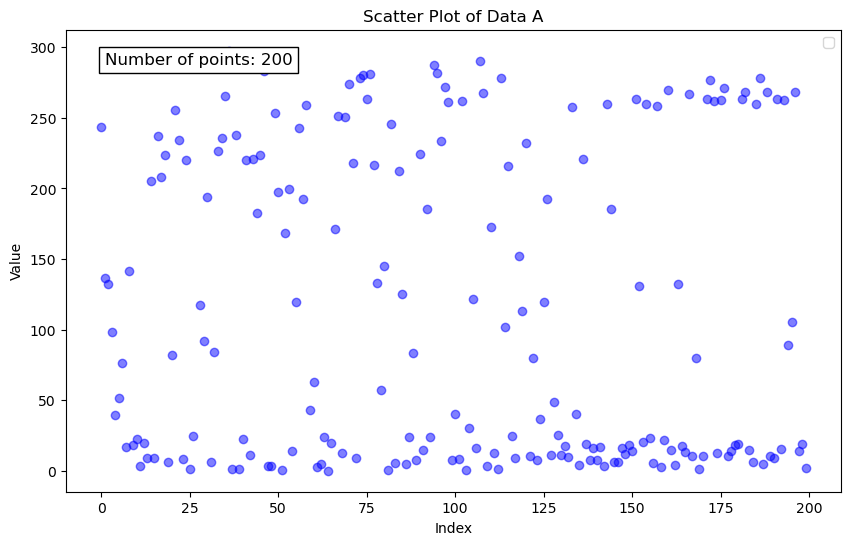

In [8]:
print(X_f_train.shape)
# 绘制散点图
plt.figure(figsize=(10, 6))
plt.scatter(np.arange(len(X_f_train)), X_f_train, alpha=0.5, color='blue')
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Scatter Plot of Data A')
# 在图中添加点的数量
plt.text(0.05, 0.95, f'Number of points: {len(X_f_train)}', transform=plt.gca().transAxes, 
         fontsize=12, verticalalignment='top', bbox=dict(facecolor='white', alpha=1))

plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(200, 1)


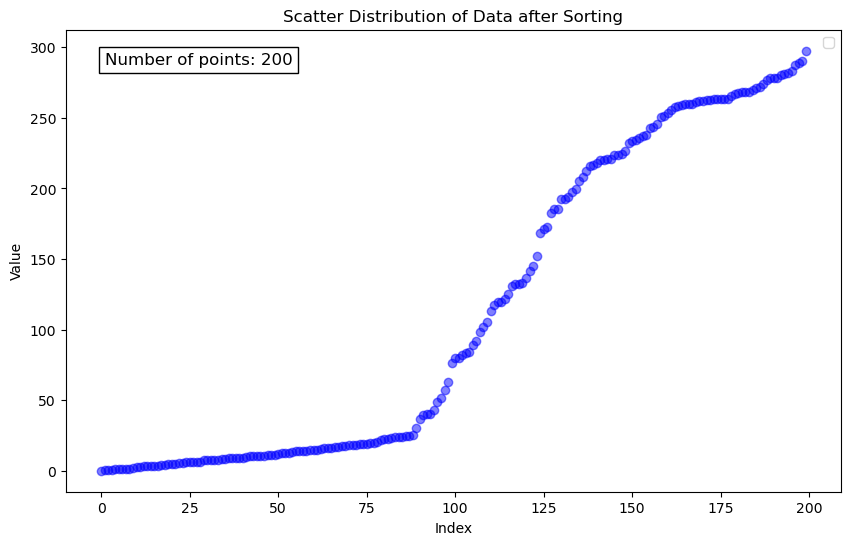

In [9]:
X = np.sort(X_f_train, axis=0)
print(X.shape)
# 绘制散点图
plt.figure(figsize=(10, 6))
plt.scatter(np.arange(len(X)), X, alpha=0.5, color='blue')
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Scatter Distribution of Data after Sorting')
# 在图中添加点的数量
plt.text(0.05, 0.95, f'Number of points: {len(X_f_train)}', transform=plt.gca().transAxes, 
         fontsize=12, verticalalignment='top', bbox=dict(facecolor='white', alpha=1))

plt.legend()
plt.show()

In [10]:
print(error_y)

error_of_u = sum(error_y)/len(error_y)

print('Error u of fuhe active learning(LHS sampling): %e' % (error_of_u)) #打印误差

print(error_mae)

error_of_mae = sum(error_mae)/len(error_mae)

print('MAE of fuhe active learning(LHS sampling): %e' % (error_of_mae)) #打印MAE

print(error_mse)

error_of_mse = sum(error_mse)/len(error_mse)

print('MSE of fuhe active learning(LHS sampling): %e' % (error_of_mse)) #打印MSE

print(chaoss)

chaos_of_u = sum(chaoss)/len(chaoss)

print('Chaos of fuhe active learning(LHS sampling): %e' % (chaos_of_u)) #打印混沌度

print(residuals)

residual_of_u = sum(residuals)/len(residuals)

print('Residual of fuhe active learning(LHS sampling): %e' % (residual_of_u)) #打印残差


[0.0004528350924455062, 0.8407448953866243, 0.0005073316166913668, 0.0006706255086192529, 0.0005211751323245998, 0.0004981754924776296, 0.0006715490108745234, 0.0009296410232842458, 0.6838702434688809, 0.0004684177092242741]
Error u of fuhe active learning(LHS sampling): 1.529335e-01
[0.00013793342903395465, 0.21779268147320638, 0.00015725036738964076, 0.0002269962212062811, 0.0001773840256204709, 0.0001542131184958625, 0.0002085367931006622, 0.00027791240526738145, 0.1809161956635521, 0.00014254565410860837]
MAE of fuhe active learning(LHS sampling): 4.001916e-02
[4.311898526615739e-08, 0.14209816505856146, 5.3395349235030445e-08, 9.576362698356582e-08, 5.7638733704252635e-08, 5.1242533633841303e-08, 9.416731017429901e-08, 1.8131189639226704e-07, 0.09450190833253867, 4.574916303484742e-08]
MSE of fuhe active learning(LHS sampling): 2.366007e-02
[0.00013644011, 7.2299745e-06, 0.00016224483, 0.009462419, 0.01708955, 8.5383566e-05, 888.905, 0.00010018681, 65.2088, 0.012808317]
Chaos of f

/tmp/ipykernel_1414704/2285129262.py:37: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(error, shade=True, color="r", alpha=0.6)


[0.0004528350924455062, 0.8407448953866243, 0.0005073316166913668, 0.0006706255086192529, 0.0005211751323245998, 0.0004981754924776296, 0.0006715490108745234, 0.0009296410232842458, 0.6838702434688809, 0.0004684177092242741]
mean Error u: 1.529335e-01
Variance Error u: 9.406469e-02


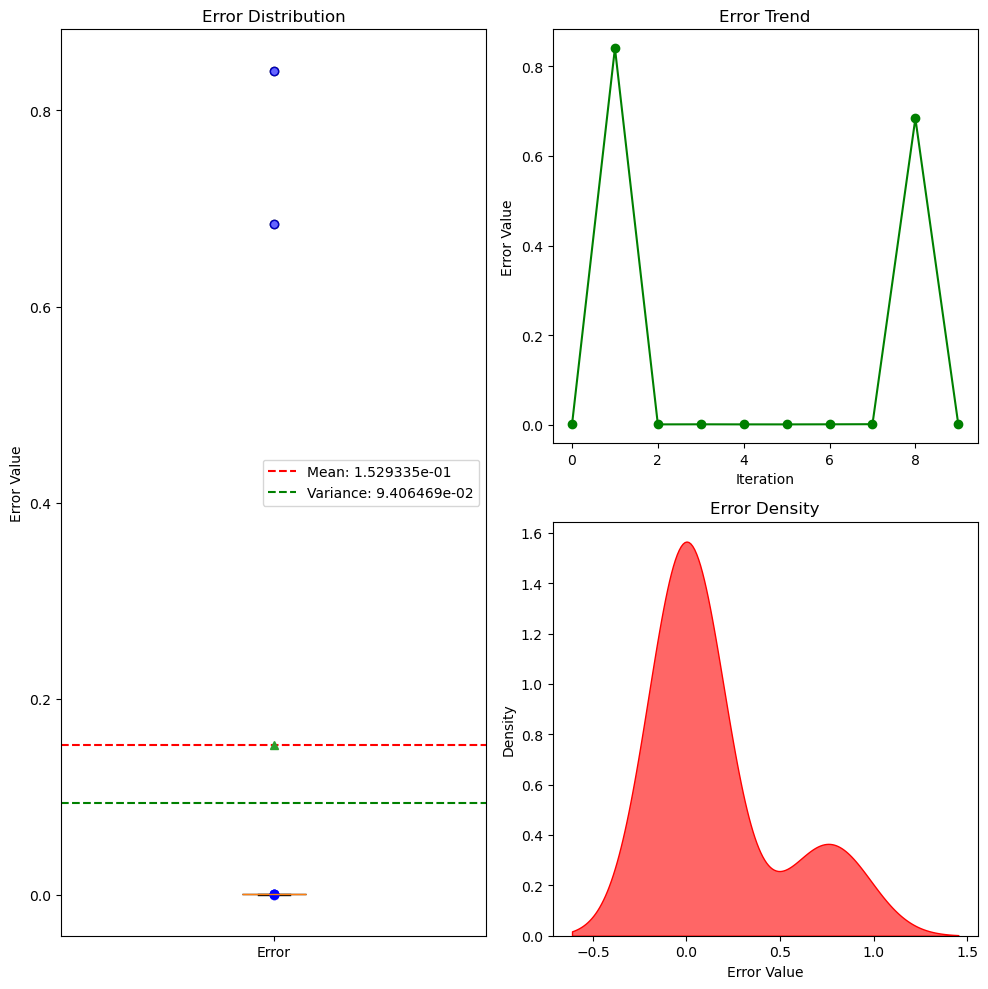

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns  # 导入seaborn库用于绘制密度图

# error = [0.5202765768338299, 0.5498189856925179, 0.8054262198745831, 0.2836623431751703, 0.7163985307835498, 0.8486951661259542, 0.45799139947295237, 1.0888879509613618, 0.18105234189218838, 0.5686642080465825]
error = error_y
print(error)

plt.figure(figsize=(10, 10))  # 调整整体图表尺寸

# 左侧子图：箱形图，占据两张图的位置，箱的上下边界为上下四分位数，箱内的横线+三角点为中位数，虚线为均值
plt.subplot(1, 2, 1)  # 第一个子图，现在布局为1行2列
mean_error = np.mean(error)
var_error = np.var(error)
print('mean Error u: %e' % (mean_error)) #打印误差
print('Variance Error u: %e' % (var_error)) #打印方差


plt.subplot(1, 2, 1)
plt.boxplot(error, patch_artist=True, showmeans=True, meanline=False, boxprops=dict(facecolor='lightblue'))
plt.axhline(mean_error, color='r', linestyle='--', label=f'Mean: {mean_error:e}')
plt.axhline(var_error, color='g', linestyle='--', label=f'Variance: {var_error:e}')  # 添加方差的水平线
for i, value in enumerate(error):
    plt.plot(1, value, 'bo', alpha=0.6)
plt.title('Error Distribution')
plt.ylabel('Error Value')
plt.xticks([1], ['Error'])
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(error, '-o', color='green')
plt.title('Error Trend')
plt.ylabel('Error Value')
plt.xlabel('Iteration')

plt.subplot(2, 2, 4)
sns.kdeplot(error, shade=True, color="r", alpha=0.6)
plt.title('Error Density')
plt.xlabel('Error Value')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

[0.00013793342903395465, 0.21779268147320638, 0.00015725036738964076, 0.0002269962212062811, 0.0001773840256204709, 0.0001542131184958625, 0.0002085367931006622, 0.00027791240526738145, 0.1809161956635521, 0.00014254565410860837]
mean MAE: 4.001916e-02
Variance MAE: 6.414928e-03


/tmp/ipykernel_1414704/3953849728.py:33: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(error, shade=True, color="r", alpha=0.6)


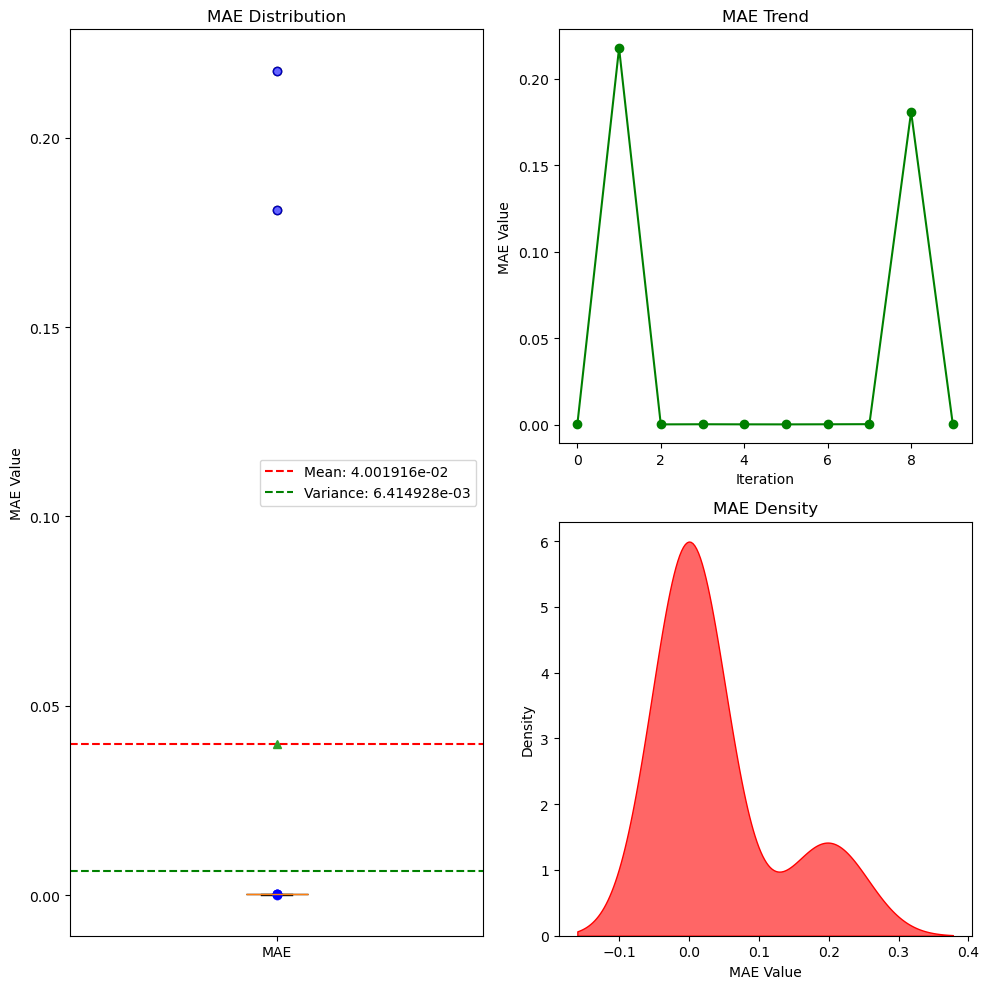

In [12]:

# error = [0.5202765768338299, 0.5498189856925179, 0.8054262198745831, 0.2836623431751703, 0.7163985307835498, 0.8486951661259542, 0.45799139947295237, 1.0888879509613618, 0.18105234189218838, 0.5686642080465825]
error = error_mae
print(error)

plt.figure(figsize=(10, 10))  # 调整整体图表尺寸

# 左侧子图：箱形图，占据两张图的位置，箱的上下边界为上下四分位数，箱内的横线+三角点为中位数，虚线为均值
plt.subplot(1, 2, 1)  # 第一个子图，现在布局为1行2列
mean_error = np.mean(error)
var_error = np.var(error)
print('mean MAE: %e' % (mean_error)) #打印误差
print('Variance MAE: %e' % (var_error)) #打印方差


plt.subplot(1, 2, 1)
plt.boxplot(error, patch_artist=True, showmeans=True, meanline=False, boxprops=dict(facecolor='lightblue'))
plt.axhline(mean_error, color='r', linestyle='--', label=f'Mean: {mean_error:e}')
plt.axhline(var_error, color='g', linestyle='--', label=f'Variance: {var_error:e}')  # 添加方差的水平线
for i, value in enumerate(error):
    plt.plot(1, value, 'bo', alpha=0.6)
plt.title('MAE Distribution')
plt.ylabel('MAE Value')
plt.xticks([1], ['MAE'])
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(error, '-o', color='green')
plt.title('MAE Trend')
plt.ylabel('MAE Value')
plt.xlabel('Iteration')

plt.subplot(2, 2, 4)
sns.kdeplot(error, shade=True, color="r", alpha=0.6)
plt.title('MAE Density')
plt.xlabel('MAE Value')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

[4.311898526615739e-08, 0.14209816505856146, 5.3395349235030445e-08, 9.576362698356582e-08, 5.7638733704252635e-08, 5.1242533633841303e-08, 9.416731017429901e-08, 1.8131189639226704e-07, 0.09450190833253867, 4.574916303484742e-08]
mean MSE: 2.366007e-02
Variance MSE: 2.352451e-03


/tmp/ipykernel_1414704/3394972535.py:33: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(error, shade=True, color="r", alpha=0.6)


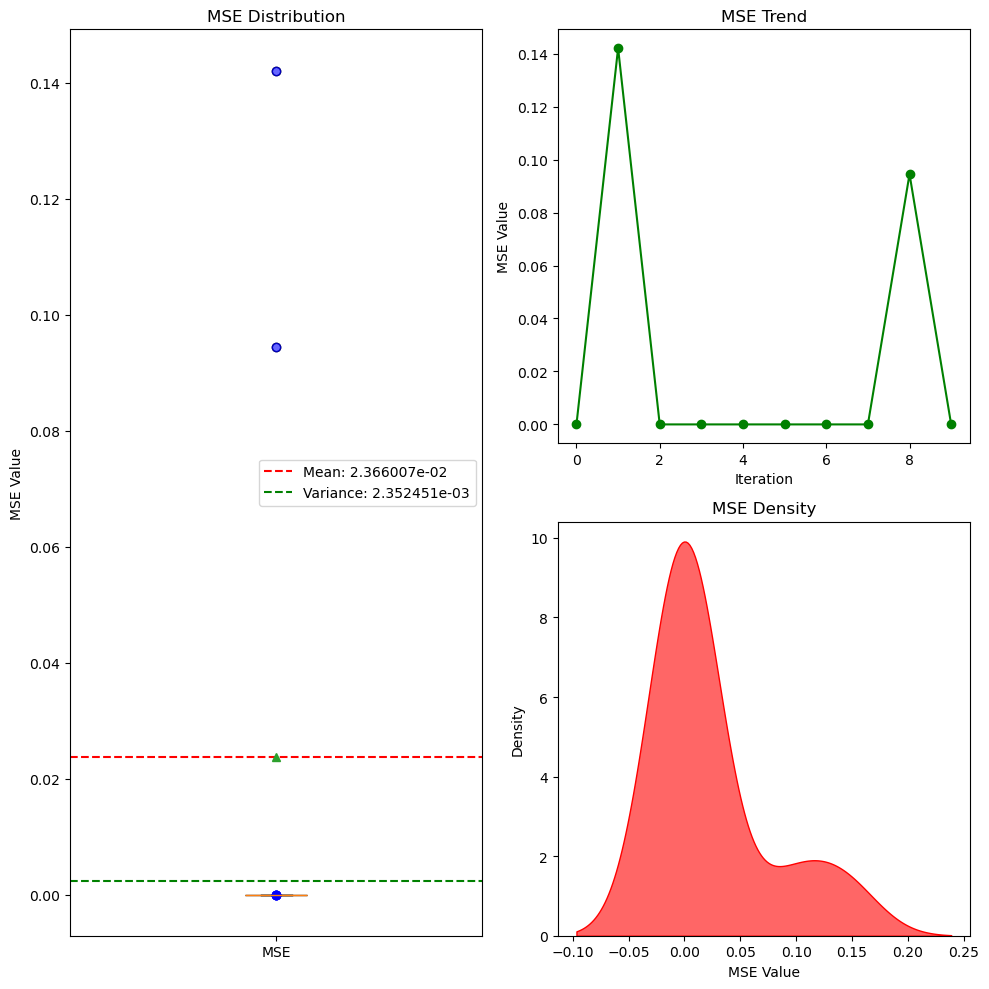

In [13]:

# error = [0.5202765768338299, 0.5498189856925179, 0.8054262198745831, 0.2836623431751703, 0.7163985307835498, 0.8486951661259542, 0.45799139947295237, 1.0888879509613618, 0.18105234189218838, 0.5686642080465825]
error = error_mse
print(error)

plt.figure(figsize=(10, 10))  # 调整整体图表尺寸

# 左侧子图：箱形图，占据两张图的位置，箱的上下边界为上下四分位数，箱内的横线+三角点为中位数，虚线为均值
plt.subplot(1, 2, 1)  # 第一个子图，现在布局为1行2列
mean_error = np.mean(error)
var_error = np.var(error)
print('mean MSE: %e' % (mean_error)) #打印误差
print('Variance MSE: %e' % (var_error)) #打印方差


plt.subplot(1, 2, 1)
plt.boxplot(error, patch_artist=True, showmeans=True, meanline=False, boxprops=dict(facecolor='lightblue'))
plt.axhline(mean_error, color='r', linestyle='--', label=f'Mean: {mean_error:e}')
plt.axhline(var_error, color='g', linestyle='--', label=f'Variance: {var_error:e}')  # 添加方差的水平线
for i, value in enumerate(error):
    plt.plot(1, value, 'bo', alpha=0.6)
plt.title('MSE Distribution')
plt.ylabel('MSE Value')
plt.xticks([1], ['MSE'])
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(error, '-o', color='green')
plt.title('MSE Trend')
plt.ylabel('MSE Value')
plt.xlabel('Iteration')

plt.subplot(2, 2, 4)
sns.kdeplot(error, shade=True, color="r", alpha=0.6)
plt.title('MSE Density')
plt.xlabel('MSE Value')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

[0.00013644011, 7.2299745e-06, 0.00016224483, 0.009462419, 0.01708955, 8.5383566e-05, 888.905, 0.00010018681, 65.2088, 0.012808317]
mean CHAOS: 9.541537e+01
Variance CHAOS: 7.033634e+04


/tmp/ipykernel_1414704/1804867946.py:33: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(error, shade=True, color="r", alpha=0.6)


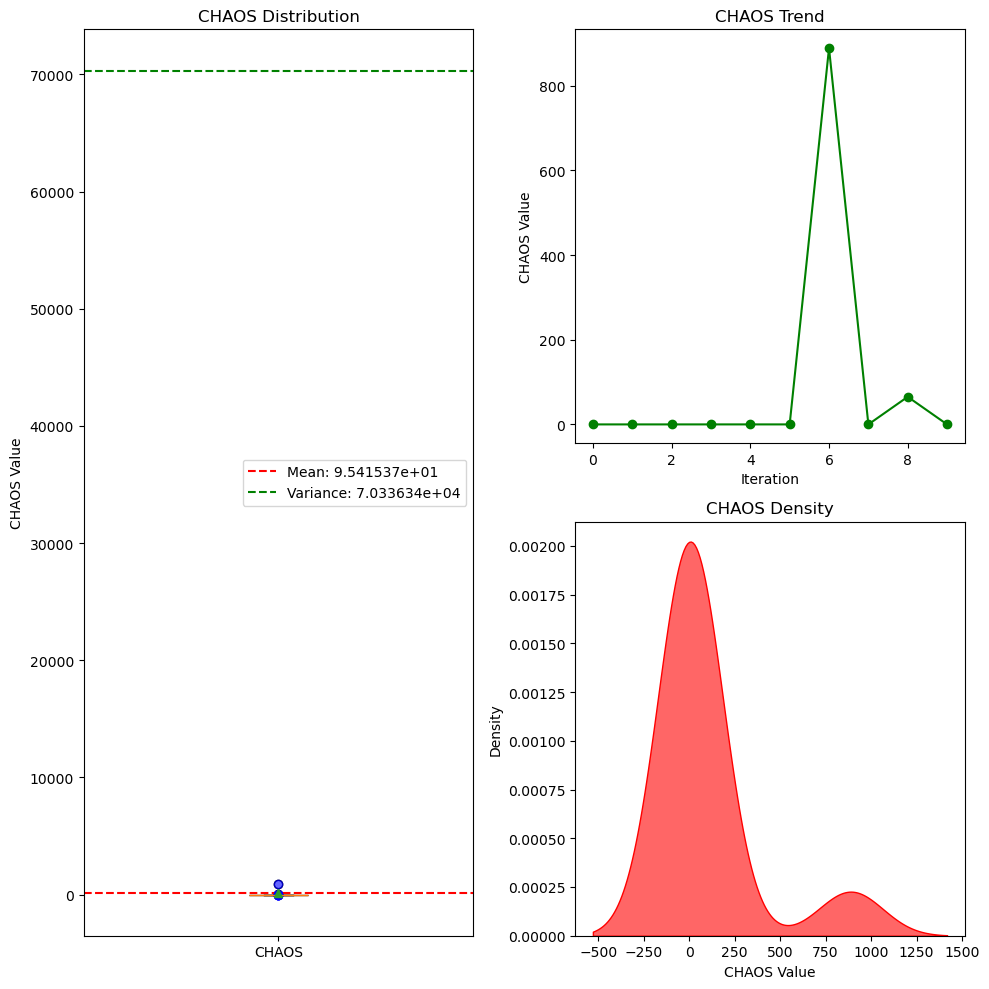

In [14]:

# error = [0.5202765768338299, 0.5498189856925179, 0.8054262198745831, 0.2836623431751703, 0.7163985307835498, 0.8486951661259542, 0.45799139947295237, 1.0888879509613618, 0.18105234189218838, 0.5686642080465825]
error = chaoss
print(error)

plt.figure(figsize=(10, 10))  # 调整整体图表尺寸

# 左侧子图：箱形图，占据两张图的位置，箱的上下边界为上下四分位数，箱内的横线+三角点为中位数，虚线为均值
plt.subplot(1, 2, 1)  # 第一个子图，现在布局为1行2列
mean_error = np.mean(error)
var_error = np.var(error)
print('mean CHAOS: %e' % (mean_error)) #打印误差
print('Variance CHAOS: %e' % (var_error)) #打印方差


plt.subplot(1, 2, 1)
plt.boxplot(error, patch_artist=True, showmeans=True, meanline=False, boxprops=dict(facecolor='lightblue'))
plt.axhline(mean_error, color='r', linestyle='--', label=f'Mean: {mean_error:e}')
plt.axhline(var_error, color='g', linestyle='--', label=f'Variance: {var_error:e}')  # 添加方差的水平线
for i, value in enumerate(error):
    plt.plot(1, value, 'bo', alpha=0.6)
plt.title('CHAOS Distribution')
plt.ylabel('CHAOS Value')
plt.xticks([1], ['CHAOS'])
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(error, '-o', color='green')
plt.title('CHAOS Trend')
plt.ylabel('CHAOS Value')
plt.xlabel('Iteration')

plt.subplot(2, 2, 4)
sns.kdeplot(error, shade=True, color="r", alpha=0.6)
plt.title('CHAOS Density')
plt.xlabel('CHAOS Value')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

[4.7163962e-07, 1.11280195e-11, 3.7176324e-07, 4.243975e-07, 4.3737236e-07, 4.518297e-07, 4.809315e-07, 5.267975e-07, 4.4237822e-08, 4.826725e-07]
mean RESIDUAL: 3.691653e-07
Variance RESIDUAL: 3.171201e-14


/tmp/ipykernel_1414704/2986457676.py:33: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(error, shade=True, color="r", alpha=0.6)


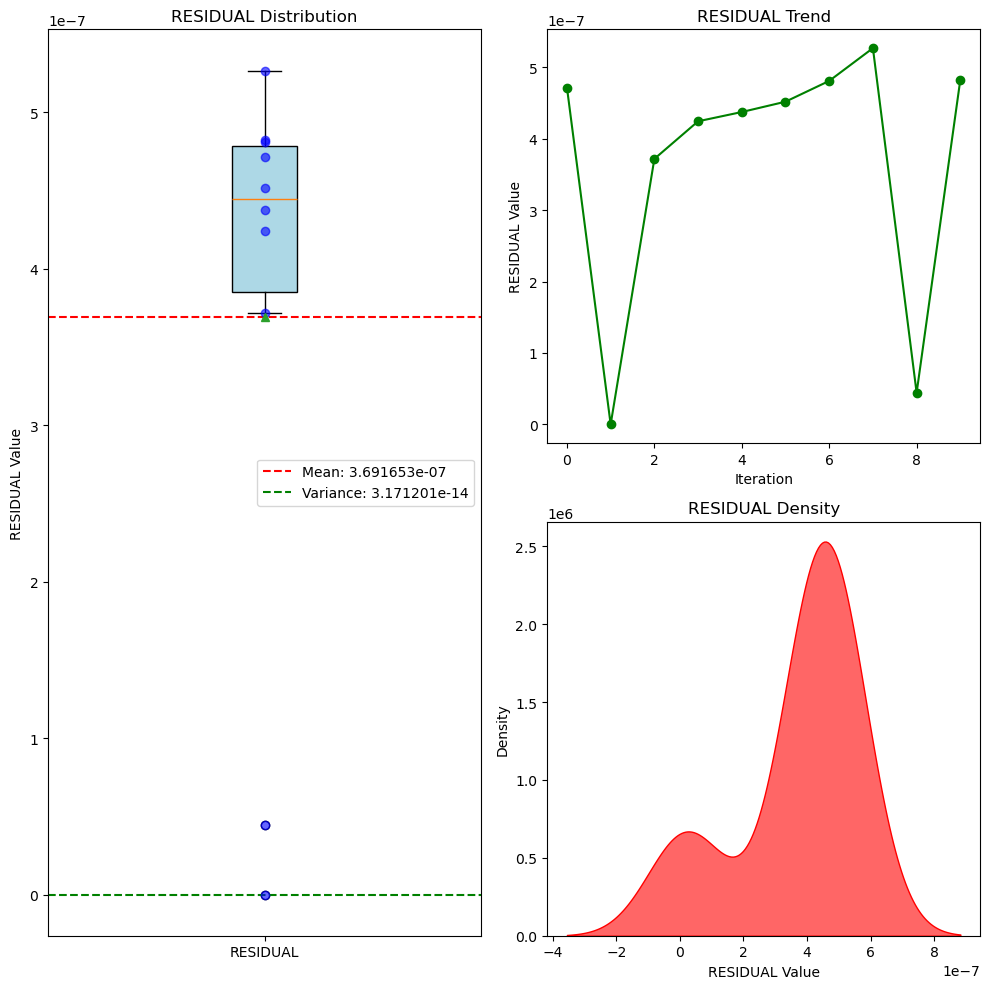

In [15]:

# error = [0.5202765768338299, 0.5498189856925179, 0.8054262198745831, 0.2836623431751703, 0.7163985307835498, 0.8486951661259542, 0.45799139947295237, 1.0888879509613618, 0.18105234189218838, 0.5686642080465825]
error = residuals
print(error)

plt.figure(figsize=(10, 10))  # 调整整体图表尺寸

# 左侧子图：箱形图，占据两张图的位置，箱的上下边界为上下四分位数，箱内的横线+三角点为中位数，虚线为均值
plt.subplot(1, 2, 1)  # 第一个子图，现在布局为1行2列
mean_error = np.mean(error)
var_error = np.var(error)
print('mean RESIDUAL: %e' % (mean_error)) #打印误差
print('Variance RESIDUAL: %e' % (var_error)) #打印方差


plt.subplot(1, 2, 1)
plt.boxplot(error, patch_artist=True, showmeans=True, meanline=False, boxprops=dict(facecolor='lightblue'))
plt.axhline(mean_error, color='r', linestyle='--', label=f'Mean: {mean_error:e}')
plt.axhline(var_error, color='g', linestyle='--', label=f'Variance: {var_error:e}')  # 添加方差的水平线
for i, value in enumerate(error):
    plt.plot(1, value, 'bo', alpha=0.6)
plt.title('RESIDUAL Distribution')
plt.ylabel('RESIDUAL Value')
plt.xticks([1], ['RESIDUAL'])
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(error, '-o', color='green')
plt.title('RESIDUAL Trend')
plt.ylabel('RESIDUAL Value')
plt.xlabel('Iteration')

plt.subplot(2, 2, 4)
sns.kdeplot(error, shade=True, color="r", alpha=0.6)
plt.title('RESIDUAL Density')
plt.xlabel('RESIDUAL Value')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

In [16]:
trainloss = torch.stack(model.loss_value).cpu().detach().numpy()

150000
[1.8831736e-01 1.5690978e-01 1.2793864e-01 ... 2.4886376e-10 2.4885755e-10
 2.4885588e-10]


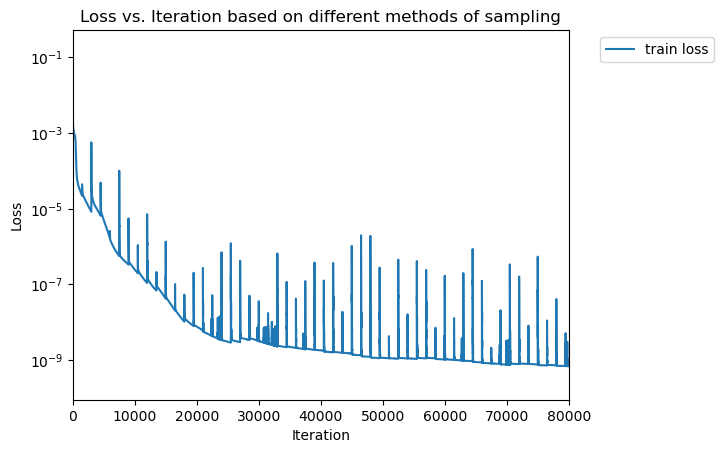

In [17]:
print(len(trainloss))
print(trainloss)
# 定义图例的标签
labels = ["Grid"]

# 创建一个新的图形
plt.figure()

# # 遍历所有的loss数据和标签
# for loss, label in zip(trainloss, labels):
#     # 绘制每个loss数据，并使用标签作为图例的条目
#     plt.plot(loss, label=label)

plt.plot(trainloss, label='train loss')

# 添加图例，放在图像外
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')


plt.xlim([0,80000]) # 设置x轴的范围
plt.yscale('log') #设置y轴为对数尺度，这样即使列表中有一些非常大的值，也不会影响其他值的可视化
plt.xlabel('Iteration') # 设置x轴的标签
plt.ylabel('Loss') # 设置y轴的标签
plt.title('Loss vs. Iteration based on different methods of sampling') # 设置图形的标题
# 显示图形
plt.show()
plt.show()

Text(0, 0.5, 'Probability')

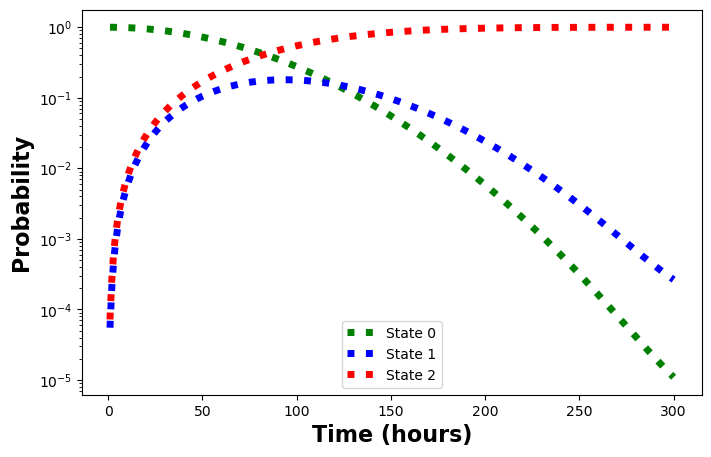

In [18]:
plt.figure(figsize=(8, 5)) #设置图形尺寸为8*5

sns.lineplot(x = x_star.flatten(), y = y_pred[:, 0], label = 'State 0', linewidth = 5, color = 'green', linestyle='dotted')
#绘制第一条折线图，横坐标为x_star，代表不同的时刻，纵坐标为exact_solution_Laplace数据的第一列，设置这条线的标签为State 0，线宽为5，颜色为绿色，线型为点线
sns.lineplot(x = x_star.flatten(), y = y_pred[:, 1], label = 'State 1', linewidth = 5, color = 'blue', linestyle='dotted')
#绘制第二条折线图，横坐标为x_star，代表不同的时刻，纵坐标为exact_solution_Laplace数据的第二列，设置这条线的标签为State 1，线宽为5，颜色为蓝色，线型为点线
sns.lineplot(x = x_star.flatten(), y = y_pred[:, 2], label = 'State 2', linewidth = 5, color = 'red', linestyle='dotted')
#绘制第三条折线图，横坐标为x_star，代表不同的时刻，纵坐标为exact_solution_Laplace数据的第三列，设置这条线的标签为State 2，线宽为5，颜色为红色，线型为点线

plt.yscale('log') #设置y轴的刻度为对数刻度
plt.xlabel("Time (hours)", fontdict=dict(weight='bold'), fontsize=16) #设置x轴标签为Time (hours)，字体加粗，字体大小为16
plt.ylabel("Probability", fontdict=dict(weight='bold'), fontsize=16) #设置y轴标签为Probability，字体加粗，字体大小为16

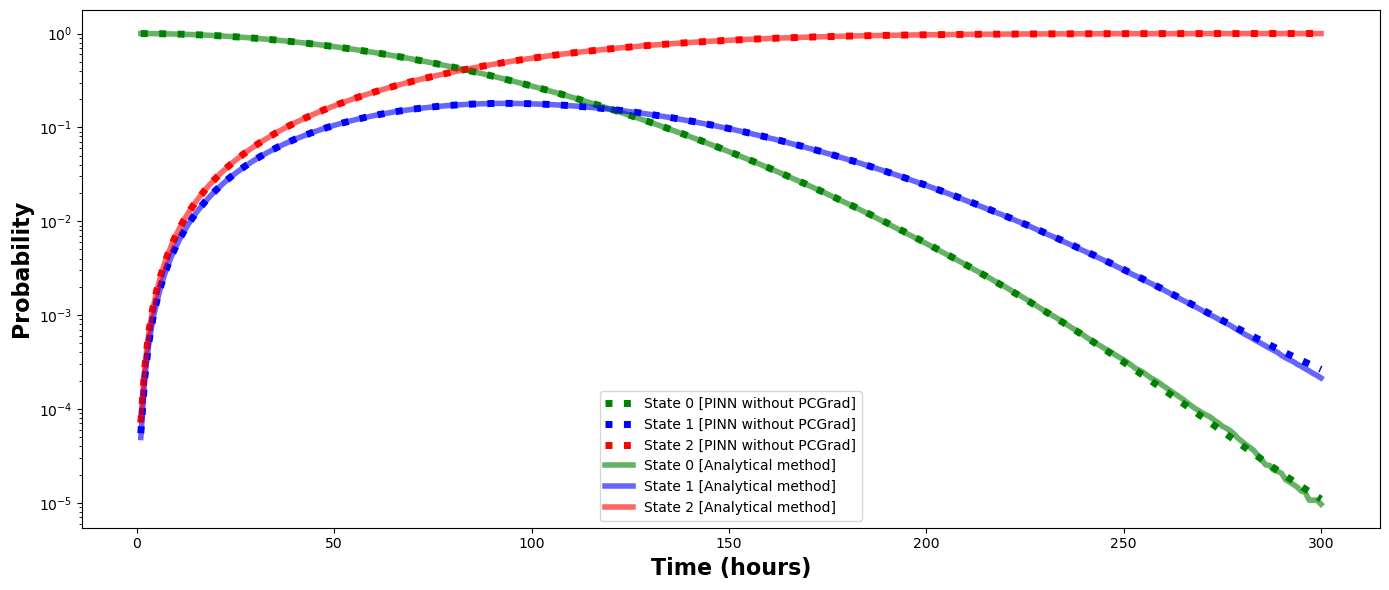

In [19]:
# 创建一个子图
f, ax = plt.subplots(1, 1, figsize=(14, 6))

# 绘制 PINN without PCGrad 方法的预测结果
sns.lineplot(x=x_star.flatten(), y=y_pred[:, 0], label='State 0 [PINN without PCGrad]', linewidth=5, color='green', linestyle='dotted', ax=ax)
sns.lineplot(x=x_star.flatten(), y=y_pred[:, 1], label='State 1 [PINN without PCGrad]', linewidth=5, color='blue', linestyle='dotted', ax=ax)
sns.lineplot(x=x_star.flatten(), y=y_pred[:, 2], label='State 2 [PINN without PCGrad]', linewidth=5, color='red', linestyle='dotted', ax=ax)

# 绘制 Runge-Kutta 方法的结果
sns.lineplot(x=x_star.flatten(), y=MCS_solution_df['state_0'], label='State 0 [Analytical method]', color='green', alpha=0.6, dashes=True, linewidth=4, ax=ax)
sns.lineplot(x=x_star.flatten(), y=MCS_solution_df['state_1'], label='State 1 [Analytical method]', color='blue', alpha=0.6, dashes=True, linewidth=4, ax=ax)
sns.lineplot(x=x_star.flatten(), y=MCS_solution_df['state_2'], label='State 2 [Analytical method]', color='red', alpha=0.6, dashes=True, linewidth=4, ax=ax)


# 设置 y 轴为对数刻度
ax.set_yscale("log")
# ax.set_ylim([1e-9, 2])
ax.set_xlabel("Time (hours)", fontdict=dict(weight='bold'), fontsize=16)
ax.set_ylabel("Probability", fontdict=dict(weight='bold'), fontsize=16)

# 自动调整子图参数
plt.tight_layout()


# 显示图形
plt.show()

### 计算RMSE

In [20]:
y_pred_df = pd.DataFrame(y_pred, columns = ['state_0', 'state_1', 'state_2'])
print(y_pred_df.head())
print(y_pred_df.tail())

    state_0   state_1   state_2
0  0.999873  0.000055  0.000072
1  0.999510  0.000213  0.000277
2  0.998849  0.000500  0.000651
3  0.997939  0.000896  0.001165
4  0.996793  0.001394  0.001813
      state_0   state_1   state_2
295  0.000014  0.000315  0.999671
296  0.000013  0.000301  0.999686
297  0.000012  0.000288  0.999699
298  0.000012  0.000276  0.999712
299  0.000011  0.000265  0.999724


In [21]:
y_diff_no_pcgrad_MCS = MCS_solution_df - y_pred_df #解析方法（特征向量）和PINN方法差值

In [22]:
### PINN和解析方法的RMSE计算
#计算MSE，对PINN和解析方法的差值的每一行应用一个匿名函数，计算三个状态的平方和，结果存储在DataFrame的新列'mse'中
y_diff_no_pcgrad_MCS['mse'] = y_diff_no_pcgrad_MCS.apply(lambda x: x['state_0']**2 + x['state_1']**2 + x['state_2']**2, axis = 1)
#计算RMSE，对'mse'列应用np.sqrt函数，结果存储在DataFrame的新列'rmse'中
y_diff_no_pcgrad_MCS['rmse'] = y_diff_no_pcgrad_MCS['mse'].apply(np.sqrt)

In [23]:
#0-80000个时间的RMSE
print ('RMSE of between PINN without PCGrad and the analytical solution is', np.mean(y_diff_no_pcgrad_MCS['rmse']))

#前60000个时间的RMSE，3749/5000=60000/80000
print ('RMSE between PINN without PCGrad and the analytical solution before 60000 is', 
       np.mean(y_diff_no_pcgrad_MCS['rmse'][:3749]))

#60000到80000的RMSE
print ('RMSE between PINN without PCGrad and the analytical solution after 60000 is', 
       np.mean(y_diff_no_pcgrad_MCS['rmse'][3749:]))

RMSE of between PINN without PCGrad and the analytical solution is 0.00026978487551439863
RMSE between PINN without PCGrad and the analytical solution before 60000 is 0.00026978487551439863
RMSE between PINN without PCGrad and the analytical solution after 60000 is nan


### 计算混沌度和残差

In [24]:
x_star.shape

(300, 1)

In [25]:
#计算chaos
y_chaos = model.hidden_predict(x_star, 100)
# print(y_chaos)
x_sss = x_star + np.random.normal(0, 0.01)
y_chaos_sss = model.hidden_predict(x_sss, 50)
chaju = np.linalg.norm(y_chaos - y_chaos_sss,axis=1)
print(chaju)
print(chaju.shape)
print(chaju.sum())

[1.3629701  1.1824595  1.1509284  1.17858    1.235938   1.3074011
 1.3694235  1.3955549  1.3835511  1.3496197  1.2771922  1.1187488
 0.95074826 0.90260726 1.0451021  1.2778889  1.5085561  1.6312255
 1.6562003  1.6555088  1.6526047  1.6509062  1.6504333  1.6507459
 1.6514637  1.6523647  1.6533043  1.6541364  1.6548228  1.6553589
 1.6557077  1.6558919  1.655925   1.6558305  1.655657   1.65537
 1.6550493  1.6546892  1.6543235  1.6539817  1.6536183  1.6532998
 1.6530056  1.6527644  1.6525654  1.6524041  1.6523306  1.6522901
 1.6522933  1.6523631  1.6524764  1.652631   1.6528233  1.6530399
 1.6532968  1.6535698  1.6538736  1.6541449  1.6544378  1.654725
 1.654984   1.6552429  1.6554824  1.6556574  1.6558334  1.6559389
 1.6560093  1.6560307  1.6560224  1.6559508  1.6558387  1.6556711
 1.6554679  1.6552157  1.6549422  1.6546168  1.6542877  1.6539211
 1.6535399  1.6531243  1.6527231  1.6522956  1.651881   1.6514721
 1.6510689  1.6506937  1.6503512  1.6500196  1.649712   1.6494684
 1.6492298  1

Text(0.5, 1.0, 'Chaos of x_star')

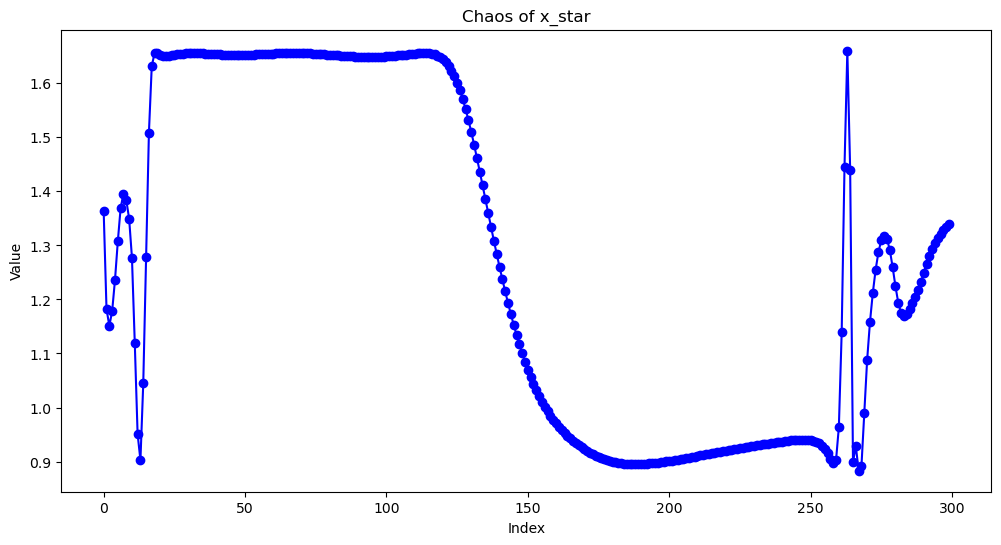

In [26]:
data = chaju
# 绘制折线图
plt.figure(figsize=(12, 6))

plt.plot(data, marker='o', linestyle='-', color='b')
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Chaos of x_star')


In [27]:
#计算残差
_, residual = model.predict(x_star)
residual = residual.flatten()
print(residual)
print(residual.shape)
print(residual.sum())

[ 6.0812454e-08  7.2323019e-09 -5.2095857e-09 -1.6618287e-08
  3.5506673e-09  7.1013346e-09 -6.9849193e-09 -3.4342520e-09
  8.0326572e-09  3.6088750e-09 -8.8475645e-09 -2.4447218e-09
 -2.3283064e-09  2.3283064e-09  1.3969839e-09  2.3283064e-10
 -6.6356733e-09  3.4924597e-10  2.3283064e-09  3.9581209e-09
  1.3969839e-09  1.3969839e-09 -2.7939677e-09  1.3969839e-09
  4.6566129e-10  1.1641532e-09 -6.9849193e-10 -4.6566129e-10
  9.3132257e-10 -1.1641532e-09  9.3132257e-10  2.5611371e-09
 -9.3132257e-10 -2.3283064e-10  6.9849193e-10  9.3132257e-10
  1.3969839e-09  6.9849193e-10 -1.1641532e-09  1.1641532e-09
 -4.6566129e-10 -1.3969839e-09 -1.1641532e-09  1.1641532e-09
 -4.6566129e-10  4.6566129e-10 -6.9849193e-10  2.3283064e-09
  1.1641532e-09 -6.9849193e-10  0.0000000e+00  1.3969839e-09
  0.0000000e+00  1.6298145e-09 -2.3283064e-10 -1.6298145e-09
  2.3283064e-10 -9.3132257e-10  6.9849193e-10  0.0000000e+00
 -9.3132257e-10  1.6298145e-09  2.3283064e-10  6.9849193e-10
  2.3283064e-10 -4.65661

Text(0.5, 1.0, 'Residual of x_star')

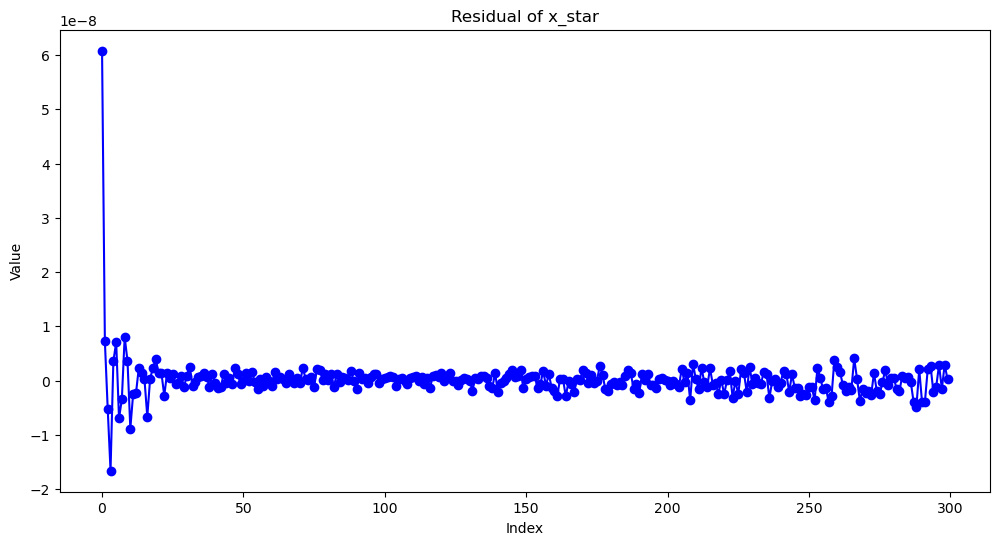

In [28]:
data = residual
# 绘制折线图
plt.figure(figsize=(12, 6))

plt.plot(data, marker='o', linestyle='-', color='b')
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Residual of x_star')
